In [1]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [4]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [5]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Trend Following Signal

In [7]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",  start_date),
            ("end_date",    end_date),
            ("ticker_list", ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("fast_mavg_log",                  fast_mavg_log),
            ("slow_mavg_log",                  slow_mavg_log),
            ("mavg_stepsize_log",              mavg_stepsize_log),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("rolling_donchian_window", rolling_donchian_window),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("vol_of_vol_window_1",          vol_of_vol_window_1),
            ("vol_of_vol_window_2",          vol_of_vol_window_2),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",   lower_r_sqr_limit),
            ("upper_r_sqr_limit",   upper_r_sqr_limit),
            ("r2_window",           r2_window),
            ("rolling_sharpe_window", rolling_sharpe_window),
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                 long_only),
            ("use_coinbase_data",         use_coinbase_data),
            ("use_specific_start_date",   use_specific_start_date),
            ("signal_start_date",         signal_start_date),
            ("price_or_returns_calc",     price_or_returns_calc),
            ("notional_threshold_pct",    notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()


In [8]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [9]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [10]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [20]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [22]:
import scipy

def create_trend_strategy_log_space(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):
    
    # ---- constants ----
    # windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, log_step).round().astype(int)   # e.g. 10,14,20,28,40,56
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x       = np.log(windows[::-1])
    xm      = x - x.mean()
    varx    = (xm**2).sum()
    
    # ---- compute MAs (vectorised) ----
    df[f'{ticker}_close_log'] = np.log(df[f'{ticker}_close'])
    for w in windows:
        df[f'{ticker}_{w}_ema'] = df[f'{ticker}_close_log'].ewm(span=w, adjust=False).mean()
    
    mavg_mat = df[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()
    
    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
    slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead
    
    # ---- z-score & rank ----
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).std())

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5              # centred 0↔±0.5
    
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df[trend_continuous_signal_col] = slope
    df[trend_continuous_signal_rank_col] = rank

    return df

In [193]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                                           donchian_signal_weight, ma_crossover_signal_weight,
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_signal_col = f'{ticker}_final_signal'
    strategy_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'

    # # Generate Trend Signal
    # df_trend = (create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize,
    #                                   slope_window=10, moving_avg_type=moving_avg_type,
    #                                   price_or_returns_calc=price_or_returns_calc)
    #             .rename(columns={
    #                 f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
    #                 f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))

    # # Calculate Ribbon Slope and Z-Score
    # mavg_cols = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize)]
    # df_trend[trend_continuous_signal_col] = df_trend[mavg_cols].apply(
    #     calc_ribbon_slope, 
    #     axis=1, 
    #     args=(ticker, fast_mavg, slow_mavg, mavg_stepsize)
    # )

    # ## Calculate Trend Rank
    # ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    # ## slope near the origin takes into account even little information
    # df_trend[trend_continuous_signal_rank_col] = pct_rank(df_trend[trend_continuous_signal_col]) - 0.5

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=126)
    df_trend[[trend_continuous_signal_rank_col]] = (df_trend[[trend_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    # # Generate Donchian Channels
    # df_donchian = calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker,
    #                                           price_or_returns_calc=price_or_returns_calc,
    #                                           rolling_donchian_window=rolling_donchian_window,
    #                                           use_coinbase_data=use_coinbase_data)

    # # Donchian Buy signal: Price crosses above upper band
    # # Donchian Sell signal: Price crosses below lower band
    # df_donchian[f't_1_close'] = df_donchian[f'close'].shift(1)
    # t_1_close_col = f't_1_close'
    # donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'
    # donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'
    # donchian_middle_band_col = f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}'
    # df_donchian[f'{donchian_upper_band_col}_t_2'] = df_donchian[donchian_upper_band_col].shift(1)
    # df_donchian[f'{donchian_lower_band_col}_t_2'] = df_donchian[donchian_lower_band_col].shift(1)
    # df_donchian[f'{donchian_middle_band_col}_t_2'] = df_donchian[donchian_middle_band_col].shift(1)
    # df_donchian[donchian_binary_signal_col] = np.where(
    #     (df_donchian[t_1_close_col] > df_donchian[f'{donchian_upper_band_col}_t_2']), 1,
    #     np.where((df_donchian[t_1_close_col] < df_donchian[f'{donchian_lower_band_col}_t_2']), -1, 0))
    # df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_middle_band_col}_t_2']) /
    #                                                (df_donchian[f'{donchian_upper_band_col}_t_2'] - df_donchian[f'{donchian_lower_band_col}_t_2']))

    # ## Calculate Donchian Channel Rank
    # ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    # ## slope near the origin takes into account even little information
    # df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # # Merging the Trend and Donchian Dataframes
    # donchian_cols = [f'{donchian_upper_band_col}_t_2', f'{donchian_lower_band_col}_t_2', f'{donchian_middle_band_col}_t_2',
    #                  donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    # df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left') 

    # Trend and Donchian Channel Signal
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

    ## Weighted Sum of Rank Columns
    ## Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    # df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
    #     df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())
    # df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
    #                                                 donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])
    df_trend[final_weighted_additive_signal_col] = ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col]

    # Activation Signal
    final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
    df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, 
                                            donchian_signal_weight, ma_crossover_signal_weight, 
                                            long_only=False, price_or_returns_calc='price', use_coinbase_data=True):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight,
                price_or_returns_calc=price_or_returns_calc,
                long_only=long_only, use_coinbase_data=use_coinbase_data)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
                ma_crossover_signal_weight=ma_crossover_signal_weight, 
                price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [26]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                mavg_stepsize, ma_crossover_signal_weight, rolling_donchian_window, donchian_signal_weight, 
                                                                long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, rolling_sharpe_window=50,
                                                                cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, 
                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       long_only=long_only, use_coinbase_data=use_coinbase_data)
    
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                              price_or_returns_calc='price', use_coinbase_data=True)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                          rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                          transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## Moving Average Ribbon Optimization

In [29]:
start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2022-12-31').date()
start_date_os = pd.to_datetime('2022-01-01').date()
end_date_os = pd.to_datetime('2025-05-30').date()
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
fast_mavg_log = 8
slow_mavg_log = 120
mavg_stepsize_log = 6
rolling_donchian_window = 20
long_only = True
use_coinbase_data = True
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 1.0
donchian_signal_weight = 0.0
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
vol_of_vol_window_1 = 20
vol_of_vol_window_2 = 15
vol_of_vol_z_score_window = 180
use_specific_start_date = True
signal_start_date = pd.Timestamp('2017-01-01').date()

In [31]:
print_strategy_params()


Strategy Parameters
----------------------------------------------------------
start_date                   : 2016-01-01
end_date                     : 2022-12-31
ticker_list                  : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                    : 35
slow_mavg                    : 60
mavg_stepsize                : 6
fast_mavg_log                : 8
slow_mavg_log                : 120
mavg_stepsize_log            : 6
moving_avg_type              : exponential
ma_crossover_signal_weight   : 1.0

rolling_donchian_window      : 20
donchian_signal_weight       : 0.0

volatility_window            : 20
annualized_target_volatility : 0.7
rolling_cov_window           : 20
rolling_atr_window           : 20
atr_multiplier               : 2.0
vol_of_vol_window_1          : 20
vol_of_vol_window_2          : 15
vol_of_vol_z_score_window    : 180

lower_r_sqr_limit            : 0.45
upper_r_sqr_limit            : 0.8
r2_window                    : 50
rolling_sharpe_

In [44]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
df_moving_avg_performance_orig = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [45]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_orig, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6974257424127859,
 'annualized_sharpe_ratio': 1.3535880424528568,
 'calmar_ratio': 1.7411985204743574,
 'annualized_std_dev': 0.8542169431420117,
 'max_drawdown': -0.40054349588051863,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.2771179730799683,
 't_statistic': 3.8668613325585945,
 'p_value': 0.00011302896091104342,
 'trade_count': 398.0}

In [78]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
df_moving_avg_performance_log_space = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [128]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_btc = ['BTC-USD']
df_moving_avg_performance_log_space_btc_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list_btc, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [96]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_eth = ['ETH-USD']
df_moving_avg_performance_log_space_eth = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_eth, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [118]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_eth = ['ETH-USD']
df_moving_avg_performance_log_space_eth_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list_eth, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [100]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_sol = ['SOL-USD']
df_moving_avg_performance_log_space_sol = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list_sol, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [124]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list_sol = ['SOL-USD']
df_moving_avg_performance_log_space_sol_os = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list_sol, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [144]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
atr_multiplier = 2.0
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
ticker_list = ['BTC-USD','ETH-USD']#,'SOL-USD','MATIC-USD','AVAX-USD']
df_moving_avg_performance_log_space_portfolio = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
    donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

In [130]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_btc_os, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.24696979345205805,
 'annualized_sharpe_ratio': 0.6878211032832419,
 'calmar_ratio': 0.5795514711765064,
 'annualized_std_dev': 0.7710065706600056,
 'max_drawdown': -0.42613953330271453,
 'max_drawdown_duration': Timedelta('614 days 00:00:00'),
 'hit_rate': 0.2571428571428571,
 't_statistic': 1.533142402179887,
 'p_value': 0.12549918850919667,
 'trade_count': 111.0}

In [126]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_sol_os, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.003349995465782074,
 'annualized_sharpe_ratio': 0.13650791360515738,
 'calmar_ratio': 0.005354593233457707,
 'annualized_std_dev': 0.8415355283835652,
 'max_drawdown': -0.6256302429939815,
 'max_drawdown_duration': Timedelta('625 days 00:00:00'),
 'hit_rate': 0.2236734693877551,
 't_statistic': 0.4401917401590783,
 'p_value': 0.6598759614781149,
 'trade_count': 254.0}

In [122]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_eth_os, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.12370672668049432,
 'annualized_sharpe_ratio': 0.36703678696778747,
 'calmar_ratio': 0.23581216995609627,
 'annualized_std_dev': 0.8282862814277765,
 'max_drawdown': -0.5245985680193103,
 'max_drawdown_duration': Timedelta('699 days 00:00:00'),
 'hit_rate': 0.23918367346938776,
 't_statistic': 0.9011148153296219,
 'p_value': 0.36770454494710125,
 'trade_count': 166.0}

In [146]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_portfolio, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.13981644899297208,
 'annualized_sharpe_ratio': 0.4081999385682171,
 'calmar_ratio': 0.2866857262521192,
 'annualized_std_dev': 0.5809329500969916,
 'max_drawdown': -0.4876993731805597,
 'max_drawdown_duration': Timedelta('654 days 00:00:00'),
 'hit_rate': 0.2742857142857143,
 't_statistic': 0.9996954338297707,
 'p_value': 0.3176555104214741,
 'trade_count': 504.0}

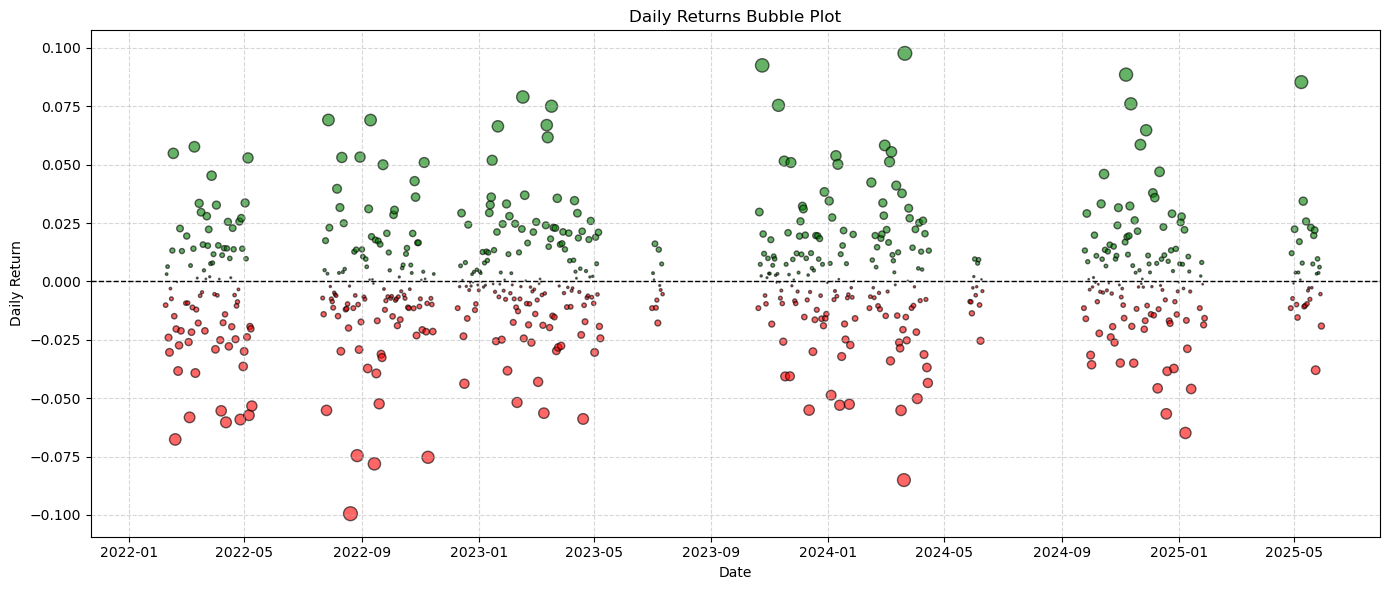

In [148]:
perf.plot_daily_returns_bubble(df_moving_avg_performance_log_space_portfolio, return_col='portfolio_daily_pct_returns')

In [102]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_sol, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.05697443905918553,
 'annualized_sharpe_ratio': 0.26520213423263483,
 'calmar_ratio': 0.09340271490731322,
 'annualized_std_dev': 0.881469540272362,
 'max_drawdown': -0.6099869700331865,
 'max_drawdown_duration': Timedelta('271 days 00:00:00'),
 'hit_rate': 0.23616236162361623,
 't_statistic': 0.4412941666790647,
 'p_value': 0.6591763594205207,
 'trade_count': 121.0}

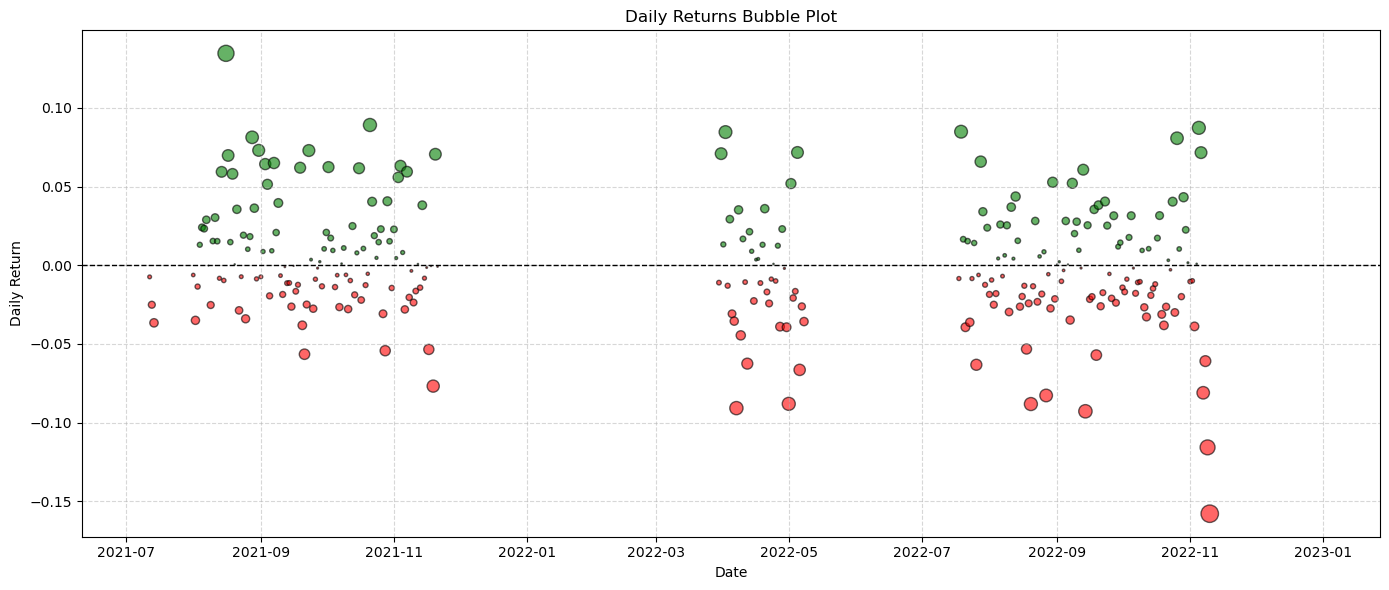

In [104]:
perf.plot_daily_returns_bubble(df_moving_avg_performance_log_space_sol, return_col='portfolio_daily_pct_returns')

In [98]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space_eth, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.48697922902681,
 'annualized_sharpe_ratio': 0.9716272955748352,
 'calmar_ratio': 0.8424854863791119,
 'annualized_std_dev': 0.9113745001009231,
 'max_drawdown': -0.5780268466342139,
 'max_drawdown_duration': Timedelta('679 days 00:00:00'),
 'hit_rate': 0.24286912751677853,
 't_statistic': 2.747880820031612,
 'p_value': 0.00604335307248447,
 'trade_count': 459.0}

In [79]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
## With Width multiplied to the slope
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6582111636418206,
 'annualized_sharpe_ratio': 1.321484003129544,
 'calmar_ratio': 1.2110044268524596,
 'annualized_std_dev': 0.848803663332553,
 'max_drawdown': -0.5435249855796048,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30796529968454256,
 't_statistic': 3.798155964754949,
 'p_value': 0.00014920125426481302,
 'trade_count': 381.0}

In [57]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 60
z_score_window = 90
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.42580338892461134,
 'annualized_sharpe_ratio': 0.9532421451224398,
 'calmar_ratio': 0.8220365132166283,
 'annualized_std_dev': 0.8539778929772243,
 'max_drawdown': -0.5179859800368757,
 'max_drawdown_duration': Timedelta('417 days 00:00:00'),
 'hit_rate': 0.2910094637223975,
 't_statistic': 2.828192433106965,
 'p_value': 0.004717938687789893,
 'trade_count': 361.0}

In [52]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 90
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6676726791604137,
 'annualized_sharpe_ratio': 1.337697235909859,
 'calmar_ratio': 1.2960851340506159,
 'annualized_std_dev': 0.8452697660537717,
 'max_drawdown': -0.5151456965436803,
 'max_drawdown_duration': Timedelta('512 days 00:00:00'),
 'hit_rate': 0.3055993690851735,
 't_statistic': 3.8416844882688377,
 'p_value': 0.00012519063344396252,
 'trade_count': 378.0}

In [47]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 120
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5620084786981654,
 'annualized_sharpe_ratio': 1.1676131222630706,
 'calmar_ratio': 1.1564919879019482,
 'annualized_std_dev': 0.8718075671561296,
 'max_drawdown': -0.4859596820188387,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.30165615141955837,
 't_statistic': 3.389221077045426,
 'p_value': 0.000711633810553895,
 'trade_count': 379.0}

In [63]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 60
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6830040169904716,
 'annualized_sharpe_ratio': 1.3577436503012106,
 'calmar_ratio': 1.2342827467319515,
 'annualized_std_dev': 0.8395080255171072,
 'max_drawdown': -0.5533610664160076,
 'max_drawdown_duration': Timedelta('544 days 00:00:00'),
 'hit_rate': 0.3032334384858044,
 't_statistic': 3.893754936930333,
 'p_value': 0.00010125339237493625,
 'trade_count': 382.0}

In [67]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 120
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.7177303189832578,
 'annualized_sharpe_ratio': 1.412434962267766,
 'calmar_ratio': 1.5102446188126237,
 'annualized_std_dev': 0.8535618257704096,
 'max_drawdown': -0.47524110335685077,
 'max_drawdown_duration': Timedelta('510 days 00:00:00'),
 'hit_rate': 0.3055993690851735,
 't_statistic': 4.039321725402911,
 'p_value': 5.5199021263409285e-05,
 'trade_count': 370.0}

In [266]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 120
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6249764079219187,
 'annualized_sharpe_ratio': 1.2738170589918798,
 'calmar_ratio': 1.1424125563440752,
 'annualized_std_dev': 0.8424255040104061,
 'max_drawdown': -0.5470671732827894,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30086750788643535,
 't_statistic': 3.673270235772455,
 'p_value': 0.0002444219232502136,
 'trade_count': 373.0}

In [262]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 14
slow_mavg = 60
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6249764079219187,
 'annualized_sharpe_ratio': 1.2738170589918798,
 'calmar_ratio': 1.1424125563440752,
 'annualized_std_dev': 0.8424255040104061,
 'max_drawdown': -0.5470671732827894,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30086750788643535,
 't_statistic': 3.673270235772455,
 'p_value': 0.0002444219232502136,
 'trade_count': 373.0}

In [241]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 96
z_score_window = 126
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6249764079219187,
 'annualized_sharpe_ratio': 1.2738170589918798,
 'calmar_ratio': 1.1424125563440752,
 'annualized_std_dev': 0.8424255040104061,
 'max_drawdown': -0.5470671732827894,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30086750788643535,
 't_statistic': 3.673270235772455,
 'p_value': 0.0002444219232502136,
 'trade_count': 373.0}

In [247]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 96
z_score_window = 252
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.5601896774222164,
 'annualized_sharpe_ratio': 1.195784675674926,
 'calmar_ratio': 1.154511617945539,
 'annualized_std_dev': 0.8535506710292751,
 'max_drawdown': -0.4852178780314723,
 'max_drawdown_duration': Timedelta('512 days 00:00:00'),
 'hit_rate': 0.2917981072555205,
 't_statistic': 3.4762539969178783,
 'p_value': 0.0005170206773485146,
 'trade_count': 363.0}

In [237]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 96
z_score_window = 180
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6814141881754403,
 'annualized_sharpe_ratio': 1.3697858916106793,
 'calmar_ratio': 1.4237354316198378,
 'annualized_std_dev': 0.8409866281300948,
 'max_drawdown': -0.4786101216854381,
 'max_drawdown_duration': Timedelta('508 days 00:00:00'),
 'hit_rate': 0.29337539432176657,
 't_statistic': 3.9301447833583967,
 'p_value': 8.716637193469062e-05,
 'trade_count': 367.0}

In [218]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
fast_mavg = 8
slow_mavg = 96
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.6249764079219187,
 'annualized_sharpe_ratio': 1.2738170589918798,
 'calmar_ratio': 1.1424125563440752,
 'annualized_std_dev': 0.8424255040104061,
 'max_drawdown': -0.5470671732827894,
 'max_drawdown_duration': Timedelta('525 days 00:00:00'),
 'hit_rate': 0.30086750788643535,
 't_statistic': 3.673270235772455,
 'p_value': 0.0002444219232502136,
 'trade_count': 373.0}

In [215]:
## This contains a percentile rank with stretching the signal and exponential smoothing (span = 3), weights of 0.8 mavg and 0.2 donchian
## Stop Loss = 2.0 * ATR
perf.calculate_risk_and_performance_metrics(df_moving_avg_performance_log_space, strategy_daily_return_col='portfolio_daily_pct_returns',strategy_trade_count_col='count_of_positions',
                                           annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.622702967574905,
 'annualized_sharpe_ratio': 1.2633326410728607,
 'calmar_ratio': 1.0249745800955936,
 'annualized_std_dev': 0.852553098199707,
 'max_drawdown': -0.6075301570082148,
 'max_drawdown_duration': Timedelta('551 days 00:00:00'),
 'hit_rate': 0.30441640378548895,
 't_statistic': 3.6430099883854843,
 'p_value': 0.00027487355988600054,
 'trade_count': 378.0}

## Run Walk Forward Analysis for Moving Average Crossover Signal

In [33]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1, 0) ## This is not entirely accurate
    return df

In [177]:
import itertools

def generate_moving_avg_ribbon_params():
    parameter_grid = {
        "fast_window": [8, 10, 12, 14, 16, 18, 20],
        "slow_fast_ratio":[4, 6, 8, 10, 12, 14, 16],
        "stepsize":[2, 4, 6, 8],
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [195]:
def run_walk_forward_moving_avg_ribbon(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(years=2)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(start_date_is, end_date_is, start_date_os, end_date_os)
        if end_date_os > end_date:
            break
    
        for params in generate_moving_avg_ribbon_params():
            print(params)
            fast_mavg = params['fast_window']
            slow_mavg = params['slow_fast_ratio'] * fast_mavg
            mavg_stepsize = params['stepsize']
            print(fast_mavg, slow_mavg, mavg_stepsize)
            
            ## In Sample Dataframe
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            df_is = calculate_asset_level_returns(df_is, end_date, ticker_list)

            ## Out of Sample Dataframe
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, 
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            df_os = calculate_asset_level_returns(df_os, end_date, ticker_list)

            ## In Sample Performance Metrics
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'fast_mavg': fast_mavg,
                'slow_mavg': slow_mavg,
                'mavg_stepsize': mavg_stepsize
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
            
            ## Out of Sample Performance Metrics
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'r2_window': r2_window,
                'lower_r_sqr_limit': lower_r_sqr_limit,
                'upper_r_sqr_limit': upper_r_sqr_limit
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
            
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)

                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_is.update(portfolio_perf_metrics_is)
            row_parameters_os.update(portfolio_perf_metrics_os)

            ## Assign in sample and out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is
            df_performance.loc[df_performance.shape[0]] = row_parameters_os
    
        start_date_is = (start_date_is + OS_LEN).date()

    return df_performance

In [197]:
df_performance = run_walk_forward_moving_avg_ribbon(start_date='2021-06-01', end_date='2025-06-30', ticker_list=ticker_list)

2021-06-01 2023-05-31 2023-06-01 2023-11-30
{'fast_window': 8, 'slow_fast_ratio': 4, 'stepsize': 2}
8 32 2
{'fast_window': 8, 'slow_fast_ratio': 4, 'stepsize': 4}
8 32 4
{'fast_window': 8, 'slow_fast_ratio': 4, 'stepsize': 6}
8 32 6
{'fast_window': 8, 'slow_fast_ratio': 4, 'stepsize': 8}
8 32 8
{'fast_window': 8, 'slow_fast_ratio': 6, 'stepsize': 2}
8 48 2
{'fast_window': 8, 'slow_fast_ratio': 6, 'stepsize': 4}
8 48 4
{'fast_window': 8, 'slow_fast_ratio': 6, 'stepsize': 6}
8 48 6
{'fast_window': 8, 'slow_fast_ratio': 6, 'stepsize': 8}
8 48 8
Connection error: HTTPSConnectionPool(host='api.coinbase.com', port=443): Max retries exceeded with url: /api/v3/brokerage/products/BTC-USD/candles?start=1622505600&end=1626134400&granularity=ONE_DAY (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x15cbd8fb0>: Failed to establish a new connection: [Errno 61] Connection refused')). Retrying in 5 seconds...
{'fast_window': 8, 'slow_fast_ratio': 8, 'stepsize': 2}
8 64 2
{

2025-07-11 20:39:29 - coinbase.RESTClient - ERROR - HTTP Error: 502 Server Error: Bad Gateway <html>
  <head>
    <title>Coinbase</title>
    <meta name="robots" content="noindex">
    <meta property="viewport" name="viewport" content="width=device-width, initial-scale=1.0" />
    <style type="text/css">html{line-height:1.15;-webkit-text-size-adjust:100%}main{display:block}h1{font-size:2em;margin:.67em 0}hr{box-sizing:content-box;height:0;overflow:visible}pre{font-family:monospace,monospace;font-size:1em}a{background-color:transparent}b,strong{font-weight:bolder}code,kbd,samp{font-family:monospace,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}img{border-style:none}button,input,optgroup,select,textarea{font-family:inherit;font-size:100%;line-height:1.15;margin:0}button,input{overflow:visible}button,select{text-transform:none}[type=button],[type=reset],[type=submit],button{-webkit-

HTTPError: 502 Server Error: Bad Gateway <html>
  <head>
    <title>Coinbase</title>
    <meta name="robots" content="noindex">
    <meta property="viewport" name="viewport" content="width=device-width, initial-scale=1.0" />
    <style type="text/css">html{line-height:1.15;-webkit-text-size-adjust:100%}main{display:block}h1{font-size:2em;margin:.67em 0}hr{box-sizing:content-box;height:0;overflow:visible}pre{font-family:monospace,monospace;font-size:1em}a{background-color:transparent}b,strong{font-weight:bolder}code,kbd,samp{font-family:monospace,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}img{border-style:none}button,input,optgroup,select,textarea{font-family:inherit;font-size:100%;line-height:1.15;margin:0}button,input{overflow:visible}button,select{text-transform:none}[type=button],[type=reset],[type=submit],button{-webkit-appearance:button}[type=button]::-moz-focus-inner,[type=reset]::-moz-focus-inner,[type=submit]::-moz-focus-inner,button::-moz-focus-inner{border-style:none;padding:0}[type=button]:-moz-focusring,[type=reset]:-moz-focusring,[type=submit]:-moz-focusring,button:-moz-focusring{outline:1px dotted ButtonText}fieldset{padding:.35em .75em .625em}legend{box-sizing:border-box;color:inherit;display:table;max-width:100%;padding:0;white-space:normal}progress{vertical-align:baseline}textarea{overflow:auto}[type=checkbox],[type=radio]{box-sizing:border-box;padding:0}[type=number]::-webkit-inner-spin-button,[type=number]::-webkit-outer-spin-button{height:auto}[type=search]{-webkit-appearance:textfield;outline-offset:-2px}[type=search]::-webkit-search-decoration{-webkit-appearance:none}::-webkit-file-upload-button{-webkit-appearance:button;font:inherit}details{display:block}summary{display:list-item}template{display:none}[hidden]{display:none}html{box-sizing:border-box;height:-webkit-fill-available;overflow-x:hidden}body{min-height:100vh;min-height:-webkit-fill-available}body,html{height:100%;margin:0;font-family:CoinbaseSans,-apple-system,BlinkMacSystemFont,"Segoe UI",Roboto,Oxygen,Ubuntu,Cantarell,"Fira Sans","Droid Sans","Helvetica Neue",sans-serif;font-weight:400;-webkit-font-smoothing:antialiased}html.lock-scroll{position:fixed;width:100%}*{box-sizing:border-box}a{color:#0667d0;text-decoration:none}</style>
    <style data-styled="true" data-styled-version="5.3.11">.iBjncv{display:-webkit-box;display:-webkit-flex;display:-ms-flexbox;display:flex;-webkit-box-pack:center;-webkit-justify-content:center;-ms-flex-pack:center;justify-content:center;-webkit-align-items:center;-webkit-box-align:center;-ms-flex-align:center;align-items:center;-webkit-flex-direction:row;-ms-flex-direction:row;flex-direction:row;}/*!sc*/
data-styled.g1[id="Flex-sc-9cfb0d13-0"]{content:"iBjncv,"}/*!sc*/
.lnzaiu{height:100vh;text-align:center;min-height:-webkit-fill-available;}/*!sc*/
data-styled.g2[id="GlobalPageFallback__FullScreenLayout-sc-246bd97a-0"]{content:"lnzaiu,"}/*!sc*/
</style>
    <style>@font-face{font-display:swap;font-family:CoinbaseDisplay;src:url(data:font/woff2;base64,d09GMgABAAAAAJ64ABAAAAAB1EgAAJ5UAAEIMQAAAAAAAAAAAAAAAAAAAAAAAAAAG4GJWhylHAZgAI5UCIFwCZdiEQgKhN1EhJpmATYCJAOZTAuMagAEIAWOfQe4fwyBPFtnq5EC1m77P5BK0U0GFOTnzNu0m16gXX4dNNN5K78EpoAckLl9gmC5HUCo+l4k+/////8XJZUYy6Rg2rsDAFB8UVH9n85tg+DhDiWFMkrTJk7F4ULXD4hRQ8YUmFPBDO3bA2ZauiO+2LGXoFPvcTo51jzT+YLzNaEgnRukjRICMVCPQGQaFT5aN0dpROeAh8gLetyHLtFcMIbxtZSMhNajnyNTJDWRkA0/BT8oVAa1mJDM7KZXaKrL7AZ04uO9ReCJ7wqNtc+qbTRHTKuV4dizd8lyyFqi/p9MC5Vt3ZaNi91WV225fEM8b+QUhlgs0ZQS7rbXN9qycpVijbvSPHb2ib0wkrDpF7/yRMmQjIWdxaoniScWDggOlBLkGflgnJooT+vdeE0p5xcNV2RSK6+oDW49oGohSj4+WW/pzYJDLPQyfsNxM9Z0SWdeK2V74M/aPgzFn48R1BuP2WVOdf8t6AzHP7tYxw7Zbmq+3vhgXGhDYKxNXfVXDf8/5t10aeey7abftCNPGBwL7BdEpCx6qLPyMo1H7xdiMdEncNDQRrjpaDc1Yc2ErY54iOdpTee9v7e3e4fKQQ4iZoQoIalGXElDHKjTiHvVnDbyLdL5X1U9JLbAKD20ZJTpE2sB7QWAQ0qSjS8KLiIY4OfWswFzIJKCDEYsio0Nxqre23urt7dsRoyUDUQwEUyMxIg4r7z76p2KdenphX3qxT89r9q48KPL96cWDmCs8ycNfcBQQDvhm5037W6FY7cpw/Pnev8vbOuHrdakPzSpOSztAKcjks/u7PI6JR7WuYP0Z0vfHns4dno59dj+46nrtmZf/XeyORslDB8vwYQQLIQARchCfpYwxfe3a3+WYmBNQcCJPIT879OWf8654b0nATPM5G57ygb/nHd2bqcVRQk5CTk1FJRofsjLtZc4UVX3m0FtssiirtyBc6oMQLL6p/p+CP/r2fveJwZrv6ZQKajkEA5jsQiPkAiLwiFDPn7M2ReOJMw+XBwV/YD4QwpFfd21EfpH2/+sKMHTnHARu9vhi+UZ+FdI0Oy3oqaot6smi/+Zs1cJG2ILTBBLMofo8yvglmh77eFwyc7Wjt+bs++rJGfgXqn7zGbPsAVskFRONO+5gx4AcLbJdgjgA8G+/VRrY6kM4G8ndfucAsHtCDxATJh/XveiNz/WkxU5SedGRQuXlqECXID5gf/+dS0/i5gPk5W5RY29sz0q0dND3TE4ty0Tm9vNHAm5wUO1bP+OGpqurbk8pCWELAzCJqGQKiqE//W3qdWOXTUq7xObUpXaS6EVWF4zBsQL8J0v10xo2xee6YoYoJaTw4V5mMiB2sGordcA/zABT2ebQpmm8d0lJ6nyk1M4HEqC3ONqef+vAgQK4J/n/7v15t+alrN6ohHkHoC1TOd9p50+J3iKBPEEYPgPAXh/TWz4nMlR6k1dYWZisOGnY1966+tq7eKcx42v5JMCyaQg3IVigH/TRj5rZe3yEfiAgjQ9sIrqp2jaTCCxyX7bA3mEQ0GCMrs2E02FXSRAc23wbT3/KQtiKGzTrJnzC8bJdvcX7X5Ff2/TZBTQGiUYeYWIs/Pfq/PbvifJGIeU/ktzpsLUZMpe9u99N60sq2557+m9+54e0pPsSLIwskyMLAOWZEyMgX9fkXmSDJEL+cYhJ5DkzBiSnAMhv5H8HAvZNJMCJPmtNPg/v/XdTF/XtjJTmV2p21J3f7Gev97MdnYDFb/X2QRUnuLc4PCoZxxS/o1aQKU0GffjaEWCFqV014VBauD/32VKde3OsoBFzIbhbCTXN38npf+ksyhddsdBoSw6ixI2MLXx8Hoh/zwYnxVIW9ql+Ac/KdBltByey8SWgU5s8Pz/qZpJeAkD+AE/vuNZnUOg1oS7bWKxpmt6qScGPV7A/u80pZFk67+EFbI/pEBcySs3ne12AxzALJ+znA77WF8ZLqC8f2/TbP+T7t+tDtch3qAc1qVoHMAOqcSKd7/Wzn6t96S1ZJDNOjRLlmllwLuTKUBUEq/sy510KIVQSrg66NICc5vpUxXpypSp0xmA0EVR/O/XerNv5s770ANBcGGVCPUneMLXyZ7X72P3DVBX0vnpEMANd4Al7K4EodABGrtGrF25UN/vqvmhttt9AqSkJJoaDYmhoLAtzAZhuO+g6qu//5JjT7k/IA2iKDuiKXVZT+qmVjaKoitEH8/f3e2baH2SXyP3Y/V+lFKOUqRIEBERkRKI3zD7jH4MQNIDCekVJIh73fKQ/pC2u0GEWiZjyfgWjpCmNjoee6c/qpaJZU0cAgccGtru94kPMefrOyTrNNgPikQwrGNO0Q3Sarp/xmZ/bF5UTdDeEIl6hPtxL5v1L9h2aVdOhZIgopEZuK9a1jQE879n0T0gStZSCeFkTRakZposf55jAlgm8WfYbj369COZNnreDMocAJ09Lz85XYZ0j1LjHNQvSoOrf98oLe5BxVE6nCv6SqjSKlPlPD0C3F/8SpjU2hIAsp7lUGSHvlAJVB8n18SefX58u/Zy2EfV3pNBOSxP7pXB9enueXNnPn5Jdk3VArLw17ZNpo/8VMXv++rgGVRbPas3beg+PbP39USb/WmQYLspmpFx5/582ckX3mtwvoaFdZAX8dq8pd5x7xnvhQ8P/6HDo6sWba1aL9/ix/xef7Y/4lf49/jr/b3+ef8Zv8vvKaURomCnImagz67H+vhEqvpO/bBwPNwWnhqeFp4ZnpeUYFo2qkHykkNEiMF0Dn+63S/fcD4FxmpVZL4lmFYMucZ6G2htyfVOO8OgKowaw6QjzNxh8XbCmj90jAl7+j2EFZpNeNGBvmYYaoWxNpjquCOk7qYyN6NZLC2syMCWDYa2GcPaeUfD29dBIzrUMaN7odPG98pgcuOY0sU9xPdRnRL6ZT5M8kxz61j3ppq+Zdtg8fbskJwd2UVFq9llm3Z7sGXd2Lq72DbvPTyzj5Ao24WQZCfZnJPd6URQvtVCSjp720/lb3vZzBr/yOOtWiIpRef9XgXSCo2QQCc9B9VArJFGk0gvk2ih0LaGzmY4C/lbllVlEuoPySoRJLfzQCpzoQ8gV8OtJ/CQILUZaSCdDDLJCtlretK/evrixl3aBJhkimlmwuwhFCn5fuChAcVvgbhC2nujtYRVqCqjMrMsCx6N1CqFmJZg/GqCKvD3PhFyge1xKLuPl6Cirkp0yCImvOZR+n/KJBKEohbgOQT1AC+QaQR4CVczwCuoWgFew9QO8AbA34OUGJCmgHwByJeAfAXINUBfQ1g76jrwv7uQdhMVRQMsLxJqYtVMoYVRGw2k2wnJtzi9slB5Rq1Mssx6WYe2Tb8lhqUYlRpKnqrlkEujmjhVf88+MQS1ZSRREoF3RJJnccNRJ/81xnPbErSPGWHEFjB9i1ks4B2IdwfeC+9fqZ5BfAPdoFqgCtbTQdcp1rKoo54GGmmimRZaaaM9dhG4EW9iusVt3LEbwR3uco/7POAN73jPh/CxEc5W4W2ZzwCCL37n+pNTAPgSSSKZFFJJi+kwo0CFFpkIQk+LICTGUgiiBGYyyRFnS5vbzoFZHoZ6sPR40Ns85R3YfgW/8Tt/8Cd/8Tf/8C9V/Mf/XOFq6zqJu42Apze23U6rqXkS/h7iU0uwXTwbZQNusapU3CfsdLnQcnmuY6sGP6F8m+U/Sj8Xi6TxCYo/6dR+KbIK1o47oEORfCXa9XqrzOpSZbMQze2e6opo9/XYS5L+IEtwm91TbRiUZgfAKtzlRUInACAkgplQYQ/DYb+/TdJrP5VuMVYR6VaWN9UrkLdNLtlFPNfwe3b5a8zNbOAbT6iJhJpMqClmda6qPIhJrTdaDLY73W2rYTkg66y7t1+BwltJXqFWWZR5lCsDnBJ1RSHmxJq51Pqw32iUWerfrWr7fBlqylLUlZTdfknyrd8im1AJhWpkNLxtwU8gaVHMJ7lqxu3Xx+PUEkqAVRBBXfdrUp5+C6ahZtWqlletjTK61ANws9taz0G4HYF17o/7OOPbg1WvklPLDVAAucbmWBn4rI2OdMUxMXVQJa/Ae08lZvetCTPrY9baZHGc4u1D0f4SN3tXPOxjDwqz1FYPQ63nYVXDB7fTctV6u/EpzSvyZrLY0/jaEJAVzMGUNFECAUkpt8wSbOTKyiHARUv1heB0m3Fas9kSE2N51hQrgWlP1dyQ+yZSR7xIZT4v6SEIkb0Jmo/mMEpy0N04mSCJuTeW3PgDA9jfzAIBhj8yap5Z5AwHP1clvQWWWJ6j0kCnkVmTKB+QaaHTxt8hLEfQWjDXjrwOIbuJDMtziBogvMgg77CQoXpfAg9eQNMIy0tQnRA8XkDWiK/Z6JWKkRdEhgYdvbASTpQZJgeFag7mNQeNrmAwcQGBiQQzUlTo7qK8dQkUHViwhkwM/lhgJoYxhBHpey1Z1wcIe+hrbj0IATgoC7hnCWECjChiBVEVkTlIV8bKAfc10fLYhlm7kBqMgN5qWma5ds6c1REvsSsWnsJvT3nRG3A9D8O0W6yqQxiWEcv/OnF1U6v1w4EQigwZFoobO+GHKKw0+1hOOOpIKX/FIezrrfANKX/hp9Z0Mf1/Kl/qhW0R1qtmWKAmVj8cgw9ny7hV71/1LnYn8eyeJG6pVt76ErMj8ZKUaGr+K3Xam2DK/5IqKYpYejCqJdoPvsXna0lEMsOsUXOOHQXnpihW4QyvxGNeOEKRN0CLmSPa9Ehx0e+9fGp9/c/vUnC0aQpeSFX/OZZOHzhPu9TRlji4vUG0+efBVmqflKPlcnyMELR49P47CxOl0Uw7yGDx1JRCo/LoSxAUJ2SxXEsFg5PLG45x+Wt5lOzjGX0/+N4zhxd5l5s/3JSr//4X+KexrRwC8jQGzbtyhEwBYRN6fcYyKgzTt5WNZNvw43TWfcuJ2vAyaB+CqwlhPWCqIYY4ruYaEL5cSvxg7UYuXmrBTN0jBWLHtK1+bMnOM/gko6nzBFW8+fBXjaghKxQHd3t8MOMFIwWVQuZeBDUeQjsbNnb1JvvuQPhLZJVG0fzrN6w6rcBopXX2+MGTt8DTv0eT/n6u6j/s/urM94E6zTVl/YD2SyhBcddjl6j+YMrm/dMQqmX9ndilN9qS4hb2YO+Arp/yv15q3PXcnYaOXmH+F8RQIVtnGliWQIbMYACJHmZRnqJ1TrWxHwycCZ9G0hTCIG1JVoPkE4At1Wlkwfk0iNdxCPrWoAQpQc+qsnEYsR3/FXKMJQw4JrqXIQIjUS/2wdj0UoqjJk0zaeJdiEbQGos5kW8nw8hUf6k/fwUhSH4sr0iWrmEPfcYZABgWNokn+LTxD2UwRGW8HYMhh47CNM2sQUj8Qfiw9UJ1O1VJTjZiDFZ2vQjqfP1TYqsVnXyn/eOT31h77+abjTtYk7SPMmvpt5JWv/xnckeOOcXitPM+5Zdfx2eEFx3CtbZNdKT0jhf/3ctg1NQ6faKq3YViZkGY0YrCDGnirN4sarRe+BIbVQ3Ji6yOZiw8shawQQ5ZpS0VO3E/RbUUKE0JCg63pFGmzYealz+n5FdfeevUHGzPlBC6L5/QMdkkfKOWX/aJmbDsOcnVO5E/S/BhtGSpwPpBI1PgQKfKhrpQOdM5XRLWK4SA5baNWF9t7DB1+49utwV68ubo1hh2WKynxO6wc1RH6J1qoT6ezKrW2cfDywGCUraSgRjlIqY1iAH2vfJ/Pv3za9+ku9OB0bke72yaog09EooM1vB7X8CNSP3xN5f5mJ8QH7ToyI6/8wfMRxZiDFD81/ijyR1LIeiOAtGUnM2uJigYw0PGq5zSHq/Qhxihl/rKj+K//L3CPqB2Ku2T1RlrnrQyLj3RXIlw6BR04itX4seNDhPkacQm2qy2oFTUuqdHQ1tkTBIOuKJsdW2CTCuxKFhyOSgNR7P0qp1xZS6Vvmj1D8o9mZzYwOM2TFIGEt7pPlRalgRGAmKebrujdjR748OXThxt3usaeXSNIXyeVd3kW+7lkFHM07ZmpGYEm/ttGz/+/WgTq7ozWJAs6NSiEUEwv5ZoytFScNzsd6jYm/i4L2l3drsqA2LUivWny9yTe/cX/XUaZ/RxW61MtoThp0G4gcmrpE9btU03vT/56yTHkZTUp6zZVkzGlvICrrFaEFhQ5Ovk29vN8f6y5UTlE6iAYwHmNQ8aE8hhV6peZ5QJh5vMPv/ncHUyzEZGcVNvNHz58/7HbjHPZuHS9rWf/PUPR/7/+A0LuHuFherZ4IHRPHCB7TLv4vtYBWi6qQZqHmX1uz33eCRzilKEO8wY1KkWDkbt56lgfQ3GulOUqfXi7tVsfjMt/fKVoLSckGGQlNaL4cxa3uz9k26KB4UTv4XBxFp2GB6kNzGIROvlD5d8apLintOjXu3woIiwSU7QIRGC1q8pB8WA9/w2hhG43J4x9IayQGFdC5Zf3eVIuU5UZQsbOYEW0c5oznB5xVO7SgjOqa1+j66K6XzxJoaYGY9G9IoKE/lCMNVUKbkesgyUE9RuWzTBtG6Q2IJTRtOaS/q2LDq2fbo5Nife/5b2wWwYSX8Cc9gNOZWulBPb1uban6XrqUMztQyvsS7ctu+wWzHULqV9iplASf5wb7Txd7wUb5+F7p50Wt6xK/osGYQJQtho5/Tpm4zMboeHQC45MK6RH5qID1pFl7Hd+YR9yXfKOX+RJfjQZvSEHoISSoiyKfoc7Ifq+8llTyEGO831Di9oRuE94NMaRLS2O0GoFG/et45lu6E5ak1vYALJfF7/BW4gUoysniaJo0VnMHRtE720aA1gqTRb9BGYbGl0MpdATZEQL8HYaGjHhApIr3Ge7qJpe+GoSdqkuzetE3TxToFZFKP8AJvwptO3/S9CODTRxTEMiTYmTWhGnvVpkn6TRzagidPqKPTX7cmFSgmyJ3DYsqzRwcsww1NHvB33YujzZiglpqITcTZgzwi6iEdhx0SMdrW1APqai2UafnRhwJbfskXvFeX+ihH/jodu7rUN+ug8ENPMdbooS+BFXqoqga4xKlxfiOmoDillmpJ5AuswilLLEAEFsyh2VKeMK3bSOnHxP9F4ExON6H16stc3tfh5WAOy3dxL9ESqjpxhLYWbEtsdgI31YlPQEejsgtH0u7F0uJI1iuWGhzzqGw3KsDWb1mZPi3mWDcpERhVksTq4oQcCG9YrREa24OyCpgd6EV8g/rFJDnuUFP03pZhbV8hGTH2GHM9rlouAB1b4sKSMip/yue+mMGEuvFxAzVWPMg9WzQg3z+LUNKtHWWdUjukCOCmEtWpykg1SGl1kIxU/jfY6+q33yaGdtDAmfI2xAZ44h8ppuFrAJsyHH/SCBdQqOk00CN50RtBU5TYFe5eUL25afWuwNuCSTrRhHibKipxzlEcObq3Wg5A8waM1enAXjlRsD6/Ml78pgZ2jQG4RWGXjlf9t2mxnvHrRR+FwQkYfJnYUxZ9Mr2WRUbsLnGOkd3BWqNSI6G9z+8JIft+iGoa6xvAs9hiUMN82KqoXcPg6cJyuGLZO4U5xLYreVUsKhwIvHRx3Zq2FC3yZU5os/hCpC9DdT6ywg9ofJ4bJ/NLCvhDcUMMaeVZewNCzR89PHQmTu+iNUsTaFl2D3kXMHWcu9oA5WjtJP2UEVyB+W/l8rlODf0LQL/BEOFJtR5xWd+rvsx9W0iF5Y6bRVqEfk7C5IzXeX4k3bjc6VXFEZTa2hGBaMC/fi39Xt0rj0Z/dP9vW2DOg9+jLEfyEyS94uoK/X0/8WYCAYxaoEpl4mo1++ncyn2vEhfKqepT2z5mn3HpTpr/hWQ3dAdNrzzx2OVV6Bmlq/BpkhD5rn/788+V/PXR6KGZohISFRE2eYiiqtwfDTpsuToZs8RpfczX5n1oqVSdfYb9Z8UtvblDDenFM8ysslv1W1Kd1bahfG4gBbcoHtr1dDepADOnI3FD+UMO60c2G92VPGtkP/Zdhyx+hWRMsvNTAuZs77xa0bgU7lGtHVlrPylfZ57l2tW9r3q1+54IO56WfqMO8UY6DELJnX5fzBKHio6GTYBBdM3qcGERdCgJKVgMo2Qkzawci4fp+NgAIUzQTG4RHjeFVYBn0nhojhbCMFcc2WSuORH1qza9yrgVm4El5fAZLDFPJkU+tQBHUUstJ8nQHGO7mPIlVVhtgtbXE1lUxwLpAbQiZjSGxaX7Ad1dljw7TOEJucdQpWmeW+3JWJV2m7+/pVbvK4JrrTGp1Gui6G0Ld5GbU7QGTh95kAL/F7p2PzD75zuqH32z+hKVTuN1GQdkSR+cs4VFeAQU6nryIqFhqUBLt6Io9EzFWHLq4oSwJZw+mRIkNjDUITS7HCk26GNNYYVbrWBeiEiE6MZgZQciEgMygZAE5K/ykY0tgdvLyyibUxJSjPF48njWOXz65aXVxZCr3kXqOcBKspXR0L7Gwr2n09YOh6TA2IDxIeAZkSgkmyhLkyFKYm9ukj3ypQpnLX1Yf9G0hgisArcIW76zovpfcpSlGFolDnUgihUgYCSfBJ8KageVbYb1LR/8Exj60WHKm+/o+kfZnezD1pa8G9ucgtO8w9gO2fsrjX4SfE/5DY/5Ljv+FiP4r1MWXRNWQt+tRylkvNbLOzH5MY6CGmBmuHbytndrFPFd7v4WZ2svSXB0cWzhDF1CjLHXnlOsdsNyplbDdp7G8wQbdQ629+wFw7dND8BzRU9Q5reeod14vQnVJ76fGgyPlh4BNzwDdYzr6PPnNN78Msl0RvkooDSQDE+o0UbBs6zW1mlAe/XQmg4CXmDMBgDkjcPVilDssIywjknQZMuFIecNuEHeAD6eV1nVD3OCJETQnXAhXJZKI4QWF8NqOoUMnlpQJCYJ8vEbyRiEjIQvmI0MbMdHpCOYr6YofYeAOPlKoKmGC+vEu0pATJ4agi5zEC0Gy5HrIukgpN/mIu1hpdGeoySstMNUShwqjpKCnI6eiLErxNVCJBqw9AZDLU6ZauWrl8lUpUKUAExtH4Tm/zOYRCR1RDI1o1gpp6Saz3IUXtdUaZ/tTrKxLUo1G2+UUWgKh4rqhcXbzjcB6eozRk0ks0Qey/sDLFAtZiFcY7bLJKNbA7p7j0LCMUbQPMqRZsK6pqyFQMCcuDA+evHjDbpBePsP6wKo4RckJhgFzTmbZhhLOXT8OgeL964ABQlLwYbCoyU31KCwYmkm/4XyOklAxsIpkYOESENOqq/CJOPMVi682PUYPIkhs/x4Vm4CUWigbByMrt6BGCd1hZfhXhfMpaDiEZDSM7KImA8MeIXFtpqpsMPjEk4qOS0ROyyRMNISdV1iTdj1VNh6ESBCMgUdMQccsnI6Zg09Esw7J6r/wJEwiMia+EEp6FhH0UE5+UQtIev/J99Dl6mQnIhbJVOeDZo0yRKSzt8qlEdhX1wW0oKma/AfaAqtXCMTipfogQNKE6ptI9SZWf/TSbF7Daosaq7as/dRWdZDKuqZpFZ1qjhE9CIvtY9ygliFwSJg1hl/zmw3AEhIQJ/e7LIBYBMXgEMAliIdPiDAxo08QcpApQ7xESZKlSBWRLe136biidOyd9ezfY7RJWnNcjuRYmvmrZDWsltet9vIuvuon8L95Htz7d9POrfXOsE7CSp8rl+qquGgBpOfMs0KUBJ764poXsO7dBxGgo9p0mXPzf7mAdDrDDNqkxE1fCkhWTLEGW93BKmrrSd+G1YyJZ1iUdMLmrW18KEjDTboBRDWkyFmtDfaOGjKVxHsIssK94URzUDNLg5GrAzD45ibi7QJZ6p7iSn+BZhq42wIYPJNCvCkwlrrXZr3gtUoBZ2tpGIL6EfFkIEvdQ0zy2Z7QYNgdYHD1MHE/QFYI7sZnvLRSgUFXgCGgi4h7B2SpQPHsuDxGg2MmwOBoH+K2gSwVJFaMSm002HcGGIzWEDcfxlIBC8dI16QF/WRpGFThJpi8PuxNFsDKbx1sokITSzUkH9Ro8lRE4743VAMhUhZZivyetbTIXpAM8BmMbn8FWDZnrZPTpMtt2+LVbeoGGTKC4ti2oxFP6cTQetrFMbgSYUiudqt8x5sqiu9oo0/AFrCiVPGFIVvaCsdRivdrtzxLNsuxo5+vewWRWYTSKYV1joJRqThPE9CrzxMJIilJTYEeB4alRFpkA26XVsTUfApwCgnnQsyht+yNK5QqtQZAhP3H9J80Abed3OPFGn0BhETEJKRk5BSUVNQ0u/3heDpf5nLAvLofzxeCYjhBUjTDcrwgSrKiarphWrbjen4wmQTmf6IkzfKirOqm7fphnN6f7w+EYATFcIKkaIbleEGUZEXVdMO0bMf1/CCM4iTN8qKs6qbt+mGc5mXd9ikpMOXu5/1+f26eF2xR07U1gVFcNgH6YiXWfX7/+tVhsauj4vOxbMRBpj3icfoMco2pr692datfw5J2ZeNhFzDsaxPA9mjWxUoYYf78bERLkjR68lQx06SNW0758eeN8UT1bCVxlM4vZM0ak8TqB0NwVRGEdxLHQfOsOvUaNGrSrEWrNu2JKjQLI2D+RamU4Oo9j+Le8Yt1DG5DQjKHZsmaLXuOnO5el6XxGqOehjWksRq3Z30xDBwUjQ9vhcVNg8+T9C8iW3a3T1BXq0UZ0CCREUdPmtSr+WIamidvvvwFChYqXMQ5EPcwGlRHUaOqAXWVKqxqajgoGnwM+tU8ouJcjwyr8eECFfp1GbigkRY88iijjjb6GGOONfY440440cQLmWTSySafYsqppp4GjHkuMq6019h17eYLEx45GqKz+60L7SniaGYcp7sx7GFFOFzFtucz76/Z98aN78RmdzhdCIgCBSEJRkZBRUPHwMTCxsHFw4eGS4LCi8cR15CWk1PQUFJR98W1PnvgO/m1+v25cT/OhS5EupAYliBSmRx1iSlwPUJJ6gOD8D0oWmUoTMotNxgtusncF119FeqvuZHLA5KvBEQZxPPwpJpNWJ2C6SCFOIl/li8meEn0m2mWETsccdRpZ1Wpdk1DanXoclO3O1feXzhvvfNJlavhJCTxkhDk0IU+DBEaxjCFOSxhlRUTojlaflMp/mOsNTfjIWPSL2pW7S0oAQXn+kKFvmA8orav/Wkdfa+9mVk/guO9A4+Hf4FN9D04nUQcuTYMgLygpx6fLFpmmhokrmvh02IaHsnVEa1fHzV6pM/9adf6dlpXP5I/+gD2hH+CTfg32KT+gKl6ttR1sCTsVesu/BlGQsH2jjziHTrykXORET7RtVRFYFRa8NqcUfiQBL5nSBaCwL1uCYTR5q3hiaN3bIQ0ivv9ywhAIkDDnjGqrn4uC2CKzR4LPy0sRKP6P8N8dxaee7fKL4BkADSgjwFEIRN8aHcVAQEEhkkv43vzAgXSqJTFiwRKJhnB+fKwqnXt7GJdPe55r/uv2dMudCPXu7d37214FfBIXOcXa8rOsqfcXx4uLydfJ3+WnxUXfRzNiuZG86O1ok2i7aKFnG6cmzkH69F6vJ6vD9SH66NrWl5+Xj/uCO66dctBUn4v3ijeeHQS+oO03o7vP370+Mmy9Nvnx3/72pduUrt21/PV3NAFeVl65Jm8kp+OombVGW/pbXb5oe4ul8tD5YXkq+SP8qN6Rx9GM6KRaLSqbus8Un35G9/KHcKtXDeeNg4ddU69hK6opp4xh/ikIMfVcieR/7+kzRfE9X//W/8e//ebxLWPf74XNfj8381dP/3v5/3in383xfYtRRYUUMaj41E8fODzb1f8Gd/lL5++eRhwriO6VSnmu7tT8TCZQnLvftz/Poxh1d/WVIb+pquM9U3mLxBBAmrdbRlHaH22n/qLYX1TMAoaDh50xOOyhCTZrNW1nG6qtBSRlc2so31Na3kz0ok4o87MKNacFl3f/gje1ra0rbyWp7qP+CW0uMRebnwn0t5vlkmNltwrYFnVgQ52qMMta2XluaK3qJ21VVNZV9pYWOG9anurWlNV9hgtDghM28IrRuEyJPP2wcLGoaGlo7dULDOUhZWtjZZJ0q5Dp9mWx7TTLrsV22NvLMecc94FF6dU73Fx3fVIj8eeeNqmeP76578giaER+bKPH/v5c0Cw48hOoDiJ6hS6M1YmwHUJTwm+UqgyAuUkXKRqyFwmd4XKdasSFkxkQ1njl0uTVuZEVidm1yncjUJEusXhtih3rElibVJx7nMyeZDMuuQGemSQrw322PoURvnJaD8b4xfj/Ga8303wh4n+NMVT8Z7ZkNL0MEwPy4zSmVkGs8pkdjgWNJGlFckwP4q8qPKj2ZxKgIOFbg9liG/MbQLlsSlcNdS3pWw/0A4pimN5fJP8JcFzmU2upIoqq660CxaVw6ImsbhckhwmVEGkklW7Yb4zLzzLI8kuuFkl6ytVb9Oa2azWdLr2OnhJFYDPv4vEL3iRiOnZ+Y8J2RAQ8c9JKpZYNp122Gm3PYrtdcx556JYrK8BwIg9eIhPEf810ERLuii8c65sbatiVlP+cucqb5cCy4Cqdns7Okx/YC+e7Bi2xYpXfrntBuRkOwFZ2GDDYIKEuDHmEk0s/k3B7+xgNwCSJKMlnWhB0/ux96W2+ne6SeuSRTVYopiSJRq5RtPoI9SV22J0sdLKouZ6VtWFqrtkIw7aMub5s0j7wS4A5+q4Dr3rEChPUPnpAiPMWENFc2sUoB+gRSPAv9MmSZOzaQBbpuMy5p5Dr/lhhMeplBdvXRsS2eE6vDqaOn1MZX6GbRm04sYB/XSeYAtCwq/eWXkDX+BkXoin/xEIPOVFkV7/w9L1GvvwKXN7n+VbPdH4wSviw38v602oObSDECN4A7L5hBSqySFclSeOoCPx/xNdfJqWKXhhcbjAjnNEedn5nKPFMH58wtu364zuLYj7+477b0UtMD4csVTcICwO/wIcgpj/i3olPX4YPSG4zdWRrsalYO+4y9ydW8s9kACjFAO3+bgURyGmLMLaB1BljbYyxhLWkgo9Cywdje0yddRMnVQKwcqBO3zpiSkXh6hRrDhXGjP9LxDtMDmT8AC2c90Kw07JVmIR3UMul4JcHO+JHANOtybkKIn2+7NjyQQsDUh9AhtYYkaOQ2IuF+rwn85q9W6hK0u1VueT3XlMbh5apJsR90F87CAHDNIYBqRyRtVirCubIKwC2MdzCVf7dAh1QbkNc/r9Cbv6aXqUYF8u3YaJoDTxKZxThn52g8VyMzoxTfKX+L6aOwmwlIj0qmsR6f2xpUKc4554v9NDpPqQlFfD85eRqGr8+oTEkjkpr/dy0+28XCbu7IeT8Xo7v94tuBTier5Ym9OwPO3v9vrdsEr0ogAhnlr0TFzglkmFW1u5aa6gPY22zUMeGUWD1dc01OXmV8R3KkpoBV2rEgI2MJMV403ZkBXZHApcTEzcvhkUrDVy7GV6lrQgtERgmDKpwup3urKOpbhJ49f/+VTLnyJcKk6fhvVbzoDGN2boEGbkUMzYoZmJwzClwzKVwzFnDo85d/jzVhjmYWyJboapg1/BMdJZV1QPXb/ubfXc9fdkfcEaV6jGXrJH7BV8E68JJOKUQCLWBBKxIZCIMwKJOCeQiAsCibgkkCQ2qHdRZpteSUvN7DuZmbGFJRs//ZTZwTbYjpw90koWbLHhviVD67XABZudg1nLcYv9qJk0WORRDEqXdwMVk6rETXQH6nbcYo0YD3DRMAaGZUFs/f+yTx3oid1vN9PgpnMb9VpB/XQCGu47d+jO9c7dZnGow6b7uEeTbOuKOq2ARcTCl+MPrZbhQfnucIAFWpruJg5O33TuA7bQfkHVZfF163jcmdSPbGwPqjR1y3ahLbXYo/j6NovuLv+Uk82r0FMUm2VJyYQnjXXLq2nLilYIdlTBuFWUEdUjQ2k4qoqLhvAl1dRl2L7nYBK6sKX9RGMeXyL+ijgMWTWTjIhWKta3OMaHzLABYAaVIS4AeJG3kiPFp6U4D9X3KmKYgmRZf995VBTHs1TuXQIHgpYij/UFhefQ7InH3Km3GK74NaBE6dtvPZf38iaOjWTqvZxVALyY84S7T2aR6l3eUD7ejO1PMXWI3dRyJ6svXdul/i3nWVGdrQJdS/P6K34O7gfFtOfhQYyDQkcBQE0mu0GrYxfOC97FIwsdK2nq1QUIpvXk/SLNm5glNzwmVp4HRYepxd/b+EHbOhQLPOklTfCqO14ORZtzKgjysq/Im4EZmBCD18mpjtsj59Wyha/RkA4/d2bx1+HeK3Psia2FqdNyBMAtAidc0c/xQE3aG0wCgHnHIo4Y9DgYLIYcBj8FgEjgiCEJRKRAMPQpwCAyOGJYAhE5EAx/CjCJAo4YkUBECQQjnwJ8RAVHjEogogaC0U8BRtHAEWMSiGiBaLNh/hFLzomf9d7pshvixRJQ7Jbx1UWgFIAg4R5CIuCKiauXUrJGkFRDSAaEyatXUrFGkFJDSAWkW801P/0J+a9rF+kWXoc63/pxPinjQQWEWKvHJmBadC+AO0mafgI0/PEqreNfgaTfAeHXgJJPc0Ahw1EbKt6YQqL1xNqHXlWX9zINTHRJllwEyEKl6mwMjxY9GfijExWxV4wrm5wE0ScMvGtr/gzrdK9JEa2F2XTfkGNUBrBIMlG1Qge6nfCM/y8LCNzOrT5zMM9P1KI4LAY2GIiyYlh1rA2xSAkQzC9UlN/5jFReztKuqdgcPIQyiBwVURhodVmJuLYHNTrZLpnxNJrBscnTlcrL+zcgo3boUJ9QGfCb3SmC4mJmsdY2nYdcKnS0XisGPXbUQ99thbRWmK3M5u3iG21ptNSllto53cxU/shbbAkjgrWHG5C9JDEIpVriwdl5gL0yg2lhbSu2IW3uQssC7eL+G9SPixM/YvnukTQfY4IACUWnE2Nchv6Cp3e9eWtPPOHiSfsTJOf2sWAVSvDxhUYKlN7eMMeLk8dT0DMwC8yamc2prPpQOslcTXVg1vrRAXNYFcS8W6L5CCmPUh2JHiMB4rXcMBhzdJQEKRrQt4R+UFQUCcQus0nNRLNApZ/+jOwbestUAlqA2quP55cm5plVg4nvjusRzaO1/ONH7b6ddgK8phSFMTHnWX6funYibpnTzEBjWqZe9h+n9ryMtmgTfIEsLOAHwcX47cDvBtRLHH3i+wQ3OFN3T9cFUR2B6aWVI27OVi5g4DCca593qFusFU46o+VGbIR3ATZwczY6Lqo3c51dEte3EKh3hgAHNJm4t3hElghKqDV06Ph5rlMCwsIT32FfS/WaF7CrtBz1hBbt/ox7TfyA9dudrB2E9QaBJp6gut0L5V7zz+7vjaD/koT/Rf4RSLiVN9/SxglHcYtsoEl++3oTVic+uia0cMvmD++4OifyLUAoTobwOFQ08AYhYHdkDeif3z772eTT0KOMpsfkDg9oTXa3jhIk47+ugsOugtmBUPmzB6zRdXTRs4HvInZv/umGYTuIMjRogaEDXUY3GN286rlYbpaLEjjiMTZNH+FGHEeTF2/OPGxyC5opTw6yX2y/Q7D5bgCcdtrQrsfCtOuTqCxjeeqbwihLrNaaoJLg5wBR2MnRmgArrTkzz9LQXYHknkDqUhOPa95fSbWbuinMIPFwg3XCMSvbMSZoEf33iZxF2dFbg0bxhNSuhBwn4gMeMdYrPY2Z5SuEsuEN2pxsn4AuKrfu9Mt2k0AVSQ2Y3p9L73vRWDljcYa0KNSDTVbpN0WlxKyJAhsf6ihHDabm6UySRAm+KlUDsAXjMApN2n1D0xeRh122DMeGHXmkaLtBacrOlijgSE4gROtSVv2D96SFhoreDsksHqdSbfxUuVCg/2frpgYNqbVJ1vBDi4yNjoXQRzg8axCW9q2A1EiMyvDUKol/iawhUXk+0vFLsJkIFYC5EASvaaWyei0SG3o1r9Rb8LXis9KOfBouHINjYuiqJQWKUw1tgMf/EQ2Uum5E1zKGbuKyky0VA6yGjrkkHgeuQ/8+QeOGaVYOEjG2CPii+PHNA62RTwDE0N4qNkjOBldZwyM2Q2kEqRvEmdO0xMSshLThkNpt5E+HNmJth3fE/Z6JabzmSz37dB+dKR5O0V8B/Bt4tB9OjgTBZF7VtsCJGl+fNiUviW+wmO3vw3DcmTPxeFXcgZCm//ucwt1hMPdsLKzaoz5+ef94PrxhKJOOwIzceNwva2GmMY1RkKb/8e0mkVsY+BFqHwHehULdqx7rvJnZgZnPRSavLVovOOkynZos7KzvoKLDjGnHjNqABwcinVosS5lqXkNrEWwTaXBM4Tnti417j7HODbcDIYH/hIwMZ8dOWsASP4en1d7ZpAy+TOnG0pqyyzazeZZ6xjZuTrd7E8/TXM2vuvTOSGr4CFfH+4i5JnX9GWE6WkfppVCgkWoeijGBmtQgJKGbCsVFJWCSbHBrGrcnMTQYmV6p14yFvGsYenoDJYAaQTQ2fJr/R5qC6ZP46tQplQoeZYJjDiIm1I1TlP0gzpvHqsPtBsUVtKbXjCbDI4PM3H4MaM0jmoF8yWy1hq4Q+nsoXsTxJjukXXGAp+8sKyZMOHZDMXwSS012d0zcJaX2dPudCLQIPap/CMGpRLXBU0SQ4uOArDs9KbvR2PLdS9ssiwzjtz8DkI92dB8N3tQ/QmH3HdGqvwuT/LHRId+Uy1MJKbsuoeKto+BAoujk3S8D8rcCjMdMV88KlXYxZHSNjEI8IrYsRanEGyujo2rAgge0wwncoqhmPURiLtfC7y3dfU2Z5NQnbQuYAdXP+oTKBT4KfKSh1d4XkqKPGFehFy8PKTxP6HuMv3BWYRJwTnCOaa6kxGf/2rgMjslasbOAuWKwdlqe8+Rr54BfE0r1op9pBdQeZ5p8nusTxoqkNNEoi6M99Y2QVIQwtdZKwyJ/POpVs0YgDdOVbez+C7Zh08a/xgPVEXMtXusJegiE5RNEha67qfJ1iL6dxnGFoSomQy9tNDHt0MsySERH4Absl29R0yBMsjRX+JNNoVLh0ZpRQDHGF4UEesrXEjmGaVhDe4lXrfAdhAORPhrpQxV6uByIB11IFajpJmT5FoGl2bhiEYvwefElBRGo9EC4c1ZsvCL1L5STfTqlt5ExlGimxUeUULNTT2GXwV8+QHtiXjZOMpqXm+87yrwcnriD3OKszlvQUMI0KEfQWHVbgNYPWUQeyeFSRF3BY7d8WjaRPYgQ05KolOgrONES3cFgNotplgDqd5NKw++dpU21sm0nFoKg7auGK7GL33Ko4b5r93q3j5fbvVB5nVA6JlQYe5FNfityONdMtNI/OgGsp0xnS3GOIZjsLG6cKeajJWzDRzeFPZezJ46KNAPGzgVV6o/9QvQjwW+TDntjdnP8jz0O6cEeGrajpVZTHff5MOd/LbBocckEp/1QHPsP4dFH+TBwK296lCfgUf6fzai4/TvxwuZiXgy2e4nRK77tGq9QDLM1SKcNIh7HZ8j0+Csnp7F3Smp6soKQLrj8dKzWtskY+DCQkPwZI/xvH75OxLMxrQZX/efG0yWmkS9dW/7AuHxvYjFkAKbBvMW7X69Vf4D4sA6FAuL3zYRbym++j03NU/id63kKTsCJaEmRqSu2H7LYd7IY+Y/CtI4JjWJTIhMvqYrF24BW3ZXPbGvv2SRa4H60U3lg5TDbfsp7pZ54m3gDd850LkfTbipHOp99ko66BPSXgE6lDRrr+uv9b+rp709qiORyQM7/XiE2LP1aJ1Yx+VOi7L3io4RUNTrovbKTseqZIkZJ+6UU093C5QJ2KxuTxUpz1v95bh4cA3ZYKuW3aHuYRlnMJevvaLq4VSn/DaVtDBrLXHMD0bf2NX3RGBEK/E0YLESEfdBGR2aR+cNg4lQjvb95WublPVNAvFsST5e4DEwrBacqHxkxBGfhUCHjXJlcIo847DkWZ3cUOEwqTVjG4/ooEsrBLCUKANVsypKrxLJ4E7MFMJDwLk7FAEedTgh+XaObBxtsAsxNKtqjpJ+YQI7wmUfIUygK30zXwcb3P7SYDK1gAv/FdbSvAfz3R6pV0N7UzxWyME737mh89o0iqTIKu6bTeqR/XWyeg4jw1LNhCEPeQkrbfVB2NMspgUO/hVolBPGmm6AG4CJvzmMFYB8TumwmgaDhVtImY0eHOLoNAXk9sMoEv83m/BzpMahL2vrsjDqcAmOYqPR24h1I92Vsmw2Z1tIn12wFs2FWgbURXMNPKavxzE1j8C3fyTBpmOF8o4GJUuR2406IkSHguDJUKPNExT6iNQ4cf0lvjnu8dUnNKMIj9W0XEG7D+F7KQ6PAcQ5T7wyP1rQ5ncCOt7y3csXHHKz/noXokl/Uw6XPLpR47yKm4M31VseTOSYpdtOjOebF3dpO5hhbmM/m7UfZV2VpVpD4BiEbs9930QT/SYjurE/ye3Z4YrkbviQ0qd3XUkySj87K53OoKJdMnXPSg+SYymQnuUAhFu3T2Ys353ePAMb+DHnzY7xYnt6yW+9t7r1rZD4689Nbb97JMGb2p0KpUQLYumtYPx6yFT/CN9XwHj5+NH2PHJvPTuMroXoYnjl7H3FrG1M2hvc4hWOIDNNz244NPNytKTTD8hJq8kwERrMy06QGbDT/TmSCDPKExdFw7p3A+7X0aEfFNbcI33IcAaYXvF+TB2mmIxfSKX1br5nK3sij2cycCHWMynU6DfOEVsit0stEoHTbmqNgIWpY2S6ToRm0lY+f7CNZI7u4EBKpSC7oTGY33ADTSb1hN/S7eSh5LV2RbJr8hnQeDCmzczNDP1KLyaEPe0w/Ul54ENy+5paFmOifFw3oRzp2qYH70R/Ij1RczmHPxUNcfyZ81pLEXNiNEoj9KQM0w25flJARZ/QJ+vFiXC7xMLo9vZ6NXirYgY/7CZpAYaDTJ6sfLzLrvgsHLNeb8cS94A+l9R2ZhE9qWUpCM2HS/pWjHXq3DFq8jJvAEVPJ9L3Lq7C+Cpm4yomqOlbkuF5G6L71h/vkl38ZPjy4l95rmP+J9zSvGo/wqqd5tfl99cyr4cPzzjFZJUKwj26c/oUfReXGy1QlKEVl8TIdj61aYgdIkQEtZz6zMJz1MJpxxSUkzg/1frz3HBOLvxaa0yrayBmXz48fVqIOmjeWoSVAB+Bk42vWyEA7ZUn/qKzg+PTq0pC3ZN1caZh49XHggHXvo0wxexS2u6V5i1RRji4GyFkQYANVsV57q9VJr1nVUIYItEA24xsVJFBZkYPyELcBXgtQ2gJq3TqtfpOLuSuIsOn5P5W9zcVw8jnnvof9siMWZ6dCzDWmPAUrcDqHLzxtAq1zbFDtui6J4AdVkqcNwC2qV/skd3Bt+GrDcrPToiAIrfQOxVfokwpM3jVSU82HfEYrjPjoMiIRFkGo1PWqtmusk4SiAjpWu4phHf7/F1vJUWQKNuUfK98MIF3q2gfTZzKyubUO9s8fZS7XZ7tBmv+OcTHZvJCaN3w3/gYsV1dgXM1PZ7RXYqvlcsuLUm4DrOVYaLKtKenR0IoHQB0UXkj9op9eKLBDK4tvTksqnw352WaNxqUtazR9t6/mtEJKGBkTfBkpgUalZrtb6vwstSZKbrIm2q2vZsL+S7n+vfA3hoZCldel5BFAuU9kGqImkrKH6yQSj63zR9DboWOHrFM4hS27Ar59z3OEhd9OKiJpOwxtZBTt1CI2YtIpX4vWElfx+fUkuz6eOwaJUSdEqv65kLtGKfCUZAdD48tXW/ZL6aLDL5KpDbKyhds7BSWCA3DAzIE8JELWZSGJOGGw1RX9GcdagGb/DHyEpNh8Remy5/tD3QQ+Drll04AkhYgThIuJ6RErol4C0kkpeZYbLRiNrVXblQ3t5OKnqWn61KqDaw2sHjFXxhQUZYGR6RaDvloFh3I7+CsGKHHk0/JHMfEXGTn0OwwCuLKSKFWlx61Z18lRRdzvueq3kFTprompanMbEmRSra79uco0pw6dUh8BG7UWsKAFLGgBq1RA1taCMAfwHWvZyl+ueq4XR+U17fqXyGqEISk+Nw3hoC+RGy/tdUadB0mL09lJ9E+eHTRYBUFX/R+gTqYQH+XVZ+r8Nz5RTQdVAuWnsMoKKHryAg/2rz8sBLQHPjx3vA90LzYl51ze10+HfBnDXy/jT+8EjR+c9bjjkFOusFgxD4weiFttWGsr47U8z1ZrJNJr969JNeLJGXiDQaW++fsttV7dGIdsAfs7zUXxsZkp66DU2sRcgJiYC61NgzJrau30okjruwGDmWsjywFyo5qtnu1ywEZuH+iFYD1nHZRYI8x5egNzyBodFFufjT8dtL1sK9defYYSknPkeM98bhzFg+ceOIfuxOyxn4cGP7DiT8965LlbzsGvgs6gKKqVrcTkRfT6A2i/DI3TF5oQ1kJbfPg9ThtLTY60XfIZLDwHWQlQ7I4cNSXuOcpzGxDq8ykW9k1LQ9dhRiJh2Slak6qJjtOS0kaB783jUSanFz3Oz+ghn63yCpRRmcHoBrV6t+FB9AtBpfesh2zG7z43Hh1/4RyaUHuna5yuTl1B3xdrd8L5VgOeUKgdX35biLkhXD4e9mK+8CBfOjEuUDs+rVGKMYfGe1ogDKziPuiUSfoTbZm/iamKn7kgnym1Orh2skIGhn3HRgVgT4IEvbb/wROMGtKLnRxMhUIVJnmF6vwuRwSr4Xef1MOrn+gg70txcUuNG4D2nXpv2o7jH13IG+xhxrTjnJ7BZCg0vavbameNmlg1rm8niWAN/N7zBtipR6plQjYpe90gNhRLBxp1TntELxXAfCCrKc+b0xsI1JBNgKixSq1prNYISfopjQI7ZLc74QaBvv5UU24gt88fjG3o85cXmPBP1xun2Pl9d1SAJ1hzgRY6BFEjkiuxdx3BmNsVijnejVyRUCIQ1EwH8CdvxLO65RMrVtMaMedk+OdebmvAbhfEdoiwW4Xhy+fie6TYXdKIrFUc/p+JO/l6NuZCdtd3rqcdsy5VYS5XdYkxwc8Ot48j2PNIYrtKFAxDL3dsdmY7lxPmO393RufbhdUsnZ+7bnfb0fBPk5yS+KJd20t3amueeftt0/5kbb31uvP1nz2+YesOe/swa7Ft7lnRRIpYEx5P0k6fb/CEB2OTRipNSCNzHr/EaQF3vWssYz5lf1Zns/vEK0K56h2vQVPieHg8mrySHEyG/WH5E65ZSe89adB4Cs3aeDSeyiYazIbCAIimMDIrNTvVlpXz2RNH9Ecbrtk9ol85tH8BCNU7Tz22QyIfn3Ke4kf5rtZJ5kGRI1Yz30xmF1dGpLCLIXa1oIUt7/IRk6SFpLbMrCrmLLJa6v46G2eKTRahgy4Bqty1l6oq3WKNndaHZs3j34/Zru25p1O+l8z1tg8j2nGM7fRtUmNrp5tTgR72kqSjthGDCRGpUZXRr3/jtjoZz7J8k4o/Tlmuo/2nMHg9uj0dJfm2Jw3MWagvWa+He+pQX81MY9K/AyWlj3+X31J9CbalLaKyqABGmfwGC6MBLouKW2xLUUIKVzsNB3X6Gn0pl/ePUl5RtUlevwWfDSmDcsDcbDPomxBbDpozfXZlVbpNfFby9XaonbIXyZmwjYYTb+UCDs9glvRRSImZ7ZOohG6WzFDZJJVWNksNbpYICCjimLj8R7orGNJoghEH3T6F95cgGJ9ZzLAHIqAYlG0O5ln7GoOKEEtlqG6SyUhNKkOIKQ9Ni+WgwY1PpWAgUpfvo6EJKECRiyU1sE2otLJJZnCxhGqfJIlRhtb96Rod1KhDETvdEYqoNcGQy19ImGQLs1TGaiAve1KT2hBiyaU+uhyqCotoy9LtgSikAKX28CT9QDB8R+lzZBpq04x2u3b4VL+5P6G8D6w1DRMHiM0nzCdO8b4LT32q7WvyWl2YHo9ILXAypFBlVCSqDEsgJ0MI+qQxTNj7oH/eUJ/ARthapusos/l9arU/YCmz+P3ThHoPjXF5oUcBAWaAjydm6soaKtAGbUgOm6GG8gJXGwOfHMKVCwjl/HJcdtsIAsQbygwxOwv+mrfBIZPyKjjVHCYO8sYePgo9Ovn599+m+QufFX/3Iy/LOLMzFKvcUhlCU+AHBDyOKM0cbsUoHVyB1CsUYIb6BWI6SEgrj+PZQgY1rOTWI1pY8WnzADwamV4fxuHnS8ugLMIkK6JGkkFTIQ+z1Ib8oCpjmBX/h+4MhwDAECHsoSgAhENMSYbtNtYUkAMit9U3QJYhVBFETL9BTFE7RAPCTn9exrUQ0aGWUwtdVoODtFwEBuRNxO0Mhokc5UHI3+VxaeYIL+ZlrRjUub1GASrlMLKIGyL5Bq5UpOUwafFHlmwwywmDhj5XoB4pCkq754yxaSdfWrwk8p7oj5DJ9xUVFi8eMHL8wiFN/PDu87Zh246cjrSJLGIs6FNe+PKTTgtDkvwtb2vnxay6cT0w4UUTv2kLN265DjpPJfdJydphSytl4b2D9wZGlG6QpRuG5XmPB0uuzmP3s/z+n97//6dzWuWz6RFzqJA+RVquNytRP+phyrKnXvkzfstyzNjyCJmIUKaWIwtfXhoZUsvvkIICmUBXL1006WR2UQOjcrQ0Azpmp3Gvsdkf0Dc4bPn5W0mVT4pnhykC6ReeVx/9p93ItwjUq7PPLTaiERC0RAwGy9tSjEZy1hFqC6gUMofAplCoBUwZJnlwVlvj1HY7v87ZgkHykQQYHulP2hDY4jQpcBEWI1RnIIlUWkGmUgnJ1ZBTjxEf3Yp5La6BpX6GAq6KiihrMRb8hOhVWrk9nKsfCAc9XYFiEyYrblrIlkxGVmYwQdwn0RcxeOVXs5U+V6ZegHU6HfLfx5hEerKy5pQKh9mqN7vd2MMLV9UJW8gWm/lsm7g6qoJDTLk8yFBB1WGRoGrcenhuukjukazClBraoit7plgCXo3G70OnmP1+jeZoJSgyBj6pjIkdWMsxltzQeT8xBQsUkRfPXcExlVyGPXJGxflXvypV59H9+f2goNErLux9WKb6uRwIh+RJ73qoMI98Z9Ymvv7zU9krfnyTYpMz5NQqtOsSKc3WG5yvFa9UIXUGnPsU+/aPJc+TUJoxJjNU9HPGq1//Fgz8MenFny8zw5ls+8y7//T9A48pG9Oax6CnSaJPesTPGQsrHwApc5S4hKjBUr0137dD2FKgw4ZYGoUMSnaSfrDU2mEtBeqrO60WeWicALVGhnbZHmYp/fY1CB2yeySLhEFtOLqAcEQLRkIPSr82zBgdMMdd9egRw5FE7A3WrSIiMze3wzt7VwUC383nwCdmbJYh8hcTIk0KeuUPEiYSU/5/YNLV3vmjA3dmLliSSi1cMvPOwMLR5KjBGrHftlkjBoMtYrttt0XQd5+csLwwMzIO0p0gGNFxhz2QmjRJrdZqVEZ92hDCkG2vO4n1DY6KsUp9jUzWgvBHQ9e2sHALbO69l3LkDoMBgcZvgrZjtrMfY+K4/qnh8PwZPVJf1f9IRkK4XociBpOts/BFBL7Ufb7P2vdS+KUnVuiZD3KrRKNHrJ5vMas89PoGG2WowicUkoJqMESTJ4Z7cf4o34RAZiQGT4TgkLFBx6uZU/pIQPWDQIgqEQVpAEgNCKW01iWvPu+8ko0JI5HrHOSzZN/G2hxOYMUWGu1IJ0LKiUDDFp03ZFbBPdNstyxQSrO0D/O9M2L0XdGkUsv6fEZn5HvMNsgjdc7raEuUrlMKeepWZvMsoFpl5rxsNQqoNeHzp+VIPCaDwW2S5BjciMFoF4mn8rYosZmWkKpaxa0GcAeOQxIzWo+Y6r6k/BHxMpeJklvSgYkWrVxtgPhU8z27oActxt6W4PAb8VUHmXxed99JCdbYmcJMgzQisVUPwUZdIVDmZzHbcU9jQ2RLmiIL+CbTAn5TRLbElcdhFNbb7tTX9dqtU2tUqjHNbq3r1WNKORilEjkKUmVFIp0EbWzaT86e2lck1frFFHI/FfQGBWuenHESzxjkFHN36gV1mRZoV7HoYWgdMlhmrDmJVx++FM96WXgaZ8kAJEAcjC+UYArfxCxj+Ofwsei3GPFbQ98VE+WQRa22uXRKq1aoLV9MZa2j44QxBtG/Ye/2T+u3l6vcdhB0OlWUUCqxxpzchNlwqFBiRr+TTeBfZzIu0CYIdrPov1jizfjNotMtNyXlolOJqZQap6SYYX/VNDjg0LfDDTV/eaCSYXK9WW1/CqPqevLwcQeOMEYijxFwtBEKeST7+oSqrxnMr6smMB8zmbdn8XZuxGIGLrYr1Vras/HAxqIZfD/iK8Bsw9BtcqOtpbxeh6U7ylC3w8JD1fGiLjX/O83KS9WuhW0O3RyDzQbDVpthjs7qgKYx93JmsfcxmfvYszh7UwN4uhfA1v5gNdi20bb9mnzmVYM7QMMIMLDRZr/XnlQTJLczJpt77IJ7CipfD6nlFu1EgNpPphSXTSBSvjTVHWllNLOIufJYRTuzxlgGko06CLboxSKtZgGmKxXId97J7j4en3mwaufBTTr7dkwKkfm6y7CcxmnSF57GvLl4ew/Nz12WDX4iIxZm32PrWNTF5VqhVavU2VxqNWSRE4u/G3pLjElnENP1zWozKik8tAGT3GROrEmFKCrnrVTrtn8H0H6hs3Z7yI12gcG8TknMX2efV+tOJUTlkpsDzTLYujAA1GCWS4IE7EaHZkWgbIRMGSkLDoZMssg+X3GbyXxcwTAZA+umnZGZpc7QRRsP9Gw0t65JdVFUrlU9Rd+PwIT5itJZ/oPmh2qWuggpKu2kH5AfVpyFzIoq6w7A8VA7SueZzaXD1HaOFwgAM4DaMWUYQabM27qCIKFskfVsfZ+lI0dvHjWlE8uXKnGhYwbSTnL3GI0mqBNxMFvYO8Q6DRsv1anFO9ktTIepEzLGTWQv96QwaWfS62k4P2LawDm4znTQJafQfuRqMse0hnNwpWmPIGxHoZ+4n3Nw/+ybSleky+dvTLpc9TD8vuauxcq/I79io/6J/YwIRvhSnVQqMvH55iOVNuhK1thw+Xw2iVzhhPkioyUILzyh8V2/imS71/IQ46u3rz1fQQXXy/X2z01kbAzM67sl57L/hTWEqP+cDXoekfdeWhkrMv4+ny5Sl9WufunqS9dajl87fpW25cFmJ/Q++zRFT/irx4wt6IUvTNdkzvle2GvIsIV9uo/epY+vGMCrMuMBl9e137h/oXch+tHsIYW+Jiaf451zwHjgtVZDLYUD+IqBil9hyxKr7PC/UUoW7uC5rOJPGuzsWbx3rM7uml6kySx4xzrOrvL/u9MgRSDRfh5XBWhAjY4UTPvOnNoidBBTRIgBKLR6wRUmjeghEt0DtVy8taVwMjnDOd871sgrtNSSoiUh0TMFM48qe4UKdnx6DlVAHW4y1XHXQV+5vQ4O9/+Get6c5kiRKLBFObVLtdHnU23pSW0BQq7V4rYmxUpPf3wWUgtwujHPLEaR2qGWSO0yMOvdjCcEgq+Ok8GyGvx6mzGsM2yq4RMI4eEcgGqsH/A6ptfCyDxRKNowYkYEQ6HA3AaTODS5pamcmrjKP916lpjBuEYVAPqXjG0P/iWpECd5b2HbcEph4NnKd5P0bAXS7K+bybXxtPGwmwOV3h2sAhGHkblyw+Dxln3fGpdXBV6Yu5XFFHLZduMOKQpIeTau8vhrawDo0N4OjLCW4xiIhJv7QxhzpEBXJxH9xuEezO2q0hUHraAIQIcwxTQN29ofCvERguy9vPCUl0Si60z6dx90V6EljVa9SIMsKsjYx+R8ye2tTt/EYtbmJs0955ybr4gwNBApIhSRw2oowlCMmtpFTlFHvCu/O18b8SF0JOJ1K2KXZEGG4ixZEmOmhIJ0qfTtKqHqiEhUHVZAQYb8w0s36iPKP3q90uL1qNVen7kS8frX4TzShElnmpTV/QJe7XSrPNelxktDq5zuqgJ2qeXLe+i9L3nK0egVWHDsFPrlNnTbl5RuR7d/Ydz2UvIuljUQpCkro5QRKBVHcPKcT6aNgSWh1qNHDx50e8GxYx5Fg+OOohPR7M+lt8yrhJ/ctz75zLPrxV0v4YwOQafywp87nX/u8M5NZpNf/0A/o1jjBUjePz9NZ7riN/QzXt1Y+WeZgcY4I6iooDjyjCAS1LJ+bPiXSC6cGPfQeOf2NH1sej60cQz9n3bdc5R1S3blbEPPvdl0lE5xyQz93xq9R33qHMH/5pve4oXUe50SN0dzSunf/M4p55bAX+ctaMX39WDtIW4ARoxuWFIPcO868lx5HR6Xsas7mrUAWTAZIZFfxIbIiNZoMEP1Qi1nhmOSO6/b6XNN62zEL4B/k6+kWblCXXlYKKoFiGBLLW0FssKUFQ1PhK6nBtmvvS4Lk3SRsClrFUxGu291GjuX88nWA1Yit85EBCo0lKD0rFgKG9UrfzV+uuVBk24/HS6+EI5oNJEoezJMp0+G2BGNT+QVuJhOMxbBw0J0xjDOE78AFVOtam9IB3uDao0vCOt8IUfm2svwZfXAC/DC04reBn4v6UPwwQH1Ofjc2pR2/NwIMkII9DW5pQrU+pnRA4VmtkWow8jw7ed4jUYuvfzwslQjm5yONxo06ivPm9V6IHsm7FF6VPMHldNVDpVX6YWH50D9cMZwW9Pzs5Lm9HiYMzW7nm4DnrTbn1zWPGlzPNmhXFHemlI0qh65ZY8+UJwS8kdXpI9sikcxRbK8dfnXCsZmO31zkWJGWevx2637Ca3JD1tnEJ6v3mnBso8Ebh7F1hz1b9CO32/siAVtdp3ie/mKvvRz4w9i2mU+uUOD2O3vxApjo4MdyhhVB3IDr7VBkYkTfBFv/DiobT83pANjNFXHomlFocY7doPOmPAVOr+Bfs308dTiEM+P0ItCe6t374Q1Z4x7tumVYJMpQnwHMexoQ/oLEzy70DS8VMkLml7yajZUKKYde7mYB4Iqxd+14cJrNhtRKHCUr6rQUEvGVhlvDX3/cIrIBAJqVMUMpTtmdXa2zWt2lR7aKVVULOeds+AsN369uXzRbn4QGPhjfce899KH3+u4yHKQmFc7Ym0G5sNOmEi7rwx0N7XqmF91UIl0rkYkKH/YklhhJFx/iBi/9aouPoy0rQB+XRFO8JZpR7x+azQDjVr6V0RIroeqxPzujbU4ZSbmURrjGEMvRV2GeqW30nT1dPGUvcz6DKtQW4dlvy5XMmVPeBFYvyl1NluVzXnegyn5p2SKwqSTf5hS8gPjmU4Jy/j1ZcbjQbJ6fuOfyiyVlZayclW/eCrp1ru1SOmuKSUAuZpMhIUr6wE6gwuxuJ2UcuLmo6VFt6s1GrukhcI0w7SxXMtCcWOjeJHFgqMx/tgsWhxHjXqoUJussztqe0HQzezOJE+rPZndibgffGLAwXGD2t7RE0oPd6YcihicBehbppEatCiEBTWogLKp+b/e2k56j2yv4yG9dzu4PKTTOHh1SKfxeoy0JSwoW0ZoYPl/DJDOkP4jnuJdaXlUQZeb+1kbU19V9RElLtQKi7D+/tDMo1LDKlVMtdLwyaLWgcpMRdu6yMjApdHrZpAz+fgXeqaugl+pY7G8AV9XwWTCmsZwBUNXr4OEQlz1fDkq6Qr0wfIViM26dNRmQ3B+dPly5OU9utRmRZavOHv8YbLzFX8Uy1970JGpq4AHExbcyMbHG7/ScWgy4cGNBdn4n1UMIkSMal0mQsSLr63SvgKYxDFYC8eMYvAVQ57mzJftTUltDx6dHk5oFFVzcW/Mvtf7v2pbxVqqtr/5DWmTR5diQL47Ho7RUxtvySSzX0Kue72mEE33+oJDm72gNy7GB0ifOr3D653ePvVwnAJSNvP/mqTXqXQHnh3Q6YBO7fjgiHYkaA0WoPhIFLlDQMfT3erCjWiHg8P0jztKYC4X8XjGDPKpK1vJUCwGoQl565VTOKLxwUIPN4CBt87DVcABuEdesufMna+gBLfCeDbxGZ1bLSKkrtg5c4K4rN9X0kv+LfmVk07+ceX/WIav468U4zLBtKKlZQXhOvN9Aj4IZ//6hYwPyU+W3X31DD44f3n59s+238EHmrqxBq1O8L7zUsaH7ycazvhkGB8J0ZE4iJE0a22wdNbqxrlrNylDvQQHN3J88ze0uiFIVpm93j+cN7QhYOQMKYfWmJjqHZhv6iUOEsOOzNCpP0/Rh7hoV3AmQ8mfnw9pbVmp/vOU1LT/X/Q/ij7/i4xehS/4jheF/hj023Lo1B+nkjb6MEzofnTlSz8FvAZf+GmtnzBG54Vmw/4vnONchSwFBnK2/ytcCEOLQxOfulyT3VnhexRiswab2S+5JksdUAUrqxz2f55t40E57KBed245WPCrT4Okrwk90/ikNh7PSGW9A6YRbdUpQ5meOjPzfwiCLBrgfeoPALaZQFzycXl/r6gd3HQG5N2DggM+U/UWRg7vTvZ5BlninsvCz0K1P9us24DoWl/6yuWSQ4fc7y6umvvQYame9Qlu4EsO8s6777RD0ublj0/v3v/pjYqK93++d8/n5dl373360/sVFW/8fP/+jJoLE5oWjxb9D/fv8ev4xk8viTOEH+7ZvHffTzdXSw4ddL8LOL2AjVdYl8rdDEoPHS6TJ/KhoGc1OBqXUZfwwUNDyDj+/Y/37/1cTk/knyKfWQ/efHD//s85vbrxV8qXSGjIda/SXML37wWo/zO6VyjbLvB70GxFScVVb6iDwT7OJONOGpceUUgNs8CmxcOd514nsX5eRAqf+urAkvXzXpw/Oja9f+nY/Bfnja5nX5qQ5yUXsvRcvtndHtjdu/xQBY9PyPGSC1iGWjez1j9q7g3MDLSZieN4kHI0bh0/PIQa99QbVpvRCRpjKGet82WqlpyjhmEdZEPTEMqgOp96mYLOoaRHpuiwcbf6Vc8N7cCfxgxevu22nbZduI5tTh9MBsNLZvTKA1U3yJPE1hnNVjNq6+a/YBZe7ruUtCSPh4//YM/4Oezp9tWvPGvt/CkjFWSJhC7KzsrJvaEEAbCRpuxc1IPzROuser3TNrlvxpBFhNbXzlF9LaAFtJowTSIJ0yfRyaiJI6//2dU9ZcLwb9k8G+Usyb+Da8k7l79Po5+e7Y60Rm8+6UTMy009Y7a/LE70j0zL+NYVNvmW9/X2LrdwJlf424w3dS6Zc0FHe/sCW0emc0lWqHbwLISg2AqAYNFcrOs1GY3edTyIyeQ5SzS3oqJruvepGwrzOytnwbB/fvK7oLC70Q1E6jrLZ0NQ+cy6LiDiJuwZsp7tx59pkMc3H5s0xGPzFfvQzeX9hvciy9ZcZtoLnyn/jWSapsazBisEldqKQRxvvcuQEX36tc1we8loQRZB4ym0VIpgtBgsqHCa+gJRUC4g3nK5gHoELUTxt741BtaFWo8dO3jADXv0aCt74KBbg5OOojnoxM+lurx6+Ol969NrSidHHKpZSS78tdP51w7vUHLo9lKeWHcBDu9fGDLGkRVsbQV5d02gWTDm6Qj3//IB3dI69HVw3VOUgRzsDvQ8m4kymbZ6w7+dHmM8iZPmk6dwtwQrshtWBL5E4w9Rwi+tlI/bSun4xTKPs1vw5rgTrueDb3KUeqmlzWu1HMxicLiHXz7M5RTcwXPWNrx46aWGEWmdGjQCOwJ5ztltMW1rHegg96hV5KTW2VKnjc5uzrOFjhtlKhpQ/gfR2kBrIFr/AOhy/xcXAdW2cEEruVOhIHVqrS1c7XXLddPck3NpYFkh0VRHryOaCsGyWrwNHUOUxykmyrgSGWPF75Ha0JWI+GQVUpXmpfx/GuZyxIgA8TrAWd2jUlN6oLDDgk1zGvOt0S06mYauLS+uMGB4Z4LldNa9JGXHddiGgUgI3gzq/av2L28/b05tznCSusjiLQokkS9yom0pb4O3Ti6HhGIZJF/lWettS7HxG1CL19KGFtRmsjtxxCl17AJXLdJZyDwCnuBQYldZho5/gDn2wZDF/RPmfz+Cp77H/MBQWdqqfxw0wGlpot7D3KcGf6raiRlHtZHXOslJlZrcAzo25MxeKc6/acVgOY1eSqZaSE5WLX7xSOyWf6PxMYulJRo9+EvR5mxOn2Tfu/skfWz5RO9603pv0L4+Qqb1eurmw+0jq1fbs8NIl3kdM4o2hcLCwj/m+Pz+x+TN2bW9kv3v7Zf0NaQisofPjDmtGIuv2CqFQETKrbmK/jTlmLJjZtTQ19whcpR3X8H4ykAxCGolTPZBnD3HPDGOWOxDjVXiYRJuYy8iD5BL6d5yPKE6J9RdvbnSxpvnmQuaLDBUcwTneufxKm2H3dVU/OJpenYXDR17jH3hsfcGSsrtGxz6ADv3qmfkGnb2Vdc+1LfwI+zIRy4SUxR3uJcrW9bfHbvbeJH4YV3rzu8wYsZxGqvuP/6oJbo9H2sdkY9bHlM8LJ9nciCnEN3/1MgBhKGV3Y1lb1+gk5Ex7QtiU7np3DfIw1Zzx0/aSxXLsCf2Vv91ozp7SgKxkxs51//MOL4UWXq+SldhGexYxQe6IKEYetZZCY80rkJdSAcWd1DrAPNwMibMyNc8znA39lbRhteflg9vuEEA3lnkfRqpHkWnILXNa6sVEypIdbo9rHDaE69tqpU/aAUOz+kikTzenvom0FaUYG0fB0sqoxIIlDJCQ48vqCG9bUUrSz1/blZadXXOspHhr+nOii+qY1WtZVo/tkJEdZxmoo2rkELT0MkhGtARLA+UqRXPkK1nLtWOuWc2379BPvf85skmRrTwIDs1BZRenUgwfw1X18J2zePg3hrN5+5yEZCo1dloKRCkJfX2Vq5ax9ZWfUWAJydLSuFPgEqtgz8cl0rFAre4CXKUCGjLij5zxdnphqPzXyp/Tx/MTMOLwh3o3cKXeEUv3WW7CQICoQfCw3qChn5NKG+o9S9uwZNxVP7f8hg0SoPAV+pMq4mIJ9AY1ApZ75Nof5T+XEr4j1KaRy1NE78MYJiTDk7+KCH/O1SxtVAImYh1P33AitQrrR1+A1/lMjGxQi1D6rIaEJtFKFbCX/ROb1oRWnZpsqH0Q+idD0nVR6mUkwpv7Q0uHaBfX7HmO92e7x3s/3Mmjc9DG5u8t5zK903UAPWE5zXQ5UFOIKS1Z50rbt+DHM8MnRbgF37jw0vZaFFeqc7vGaiifCMgB9RAgC42NssUTWUjhuNLLy2K9TZOMEVF78qD7g1zCJh/CYda4KLsqPJGZRMdpjACuYLwxOpg9xYKZWZInggsHkWz4fjRh205mI6XV9OR2CWNp1xPzbozi8e3NGNDxCwoMQgnilHHKyxzNZ3IteL5n0ruA37gksVnOaP5BVuYyXXIZa/NVpwAXsW8W0kF4BdPjQfQgCsY8QvLS7n5vCYKOaWcIgqlIN65r5TzG6Wq2q1O6mRiIxLWas1hg1gnTWpgXhXltzqvSoxpqqcDkAfjaaiVdzCvAt/SuQXGFjGF6flc//kJJrOVZ7wx6/XGgHrKV7WFtGoVCeg0CmX51d/R90x4Txv7B9JDIrqHFWhA867kCdqFbf/waAC/lsw+XsvF1FVS1ZBPrdT6NYyq9zECVanOYjaoYCn/61x2Ho+cX7OY/BdG3uHZr7wKnNC8/H5NdZ1GLT8HnKItIFa8RY+EMwoH8wsGCjPYaUH+oBzgA8xoOLPg+6yCzFdiw1wn4KUlWDqhNK+JN/vVE8CJguH5o6sO2pftH1nGk5gTQCT/53yhUMccICj4Si6m7FkViXvmA8sc/4r4Lc04OUYom087DWynTQrEY1t8ZQOmWUHiFSgrUmjEaECzJDtnrJRbTaHmeDqVQmLK65U5CkqDK5YItfJdIjEQKWIT0F5Q6/fUlx5zx6FhoBp6/VccW0aoLaghsN+q8+MKvkqAmZRiMhQC5l+k4wyaX4v3VVWIiot+nX+jmVnD0fNFco0IF5HxuIL4Z1FBb/zG/qU1XFODVGEU1hHrtX7AHxfGj+Xdy9UJncwB2ktaFj79BMBXJOrugFo2fnNhfi8fms7XOx7ZH5EI9ZDmAUb7QAU1o+4UrgehLzG6mWpSSXJr53qTIYExJoydY8ltCDoVY88i/TJxkoArE0qKVRteGGDpHZ9hbJ+BZKZw39u7hN/jKr0irH3nwGivELpkJOY6N3Huo7x47qy+uyBH76xovIfxYrrlr96BuFa+2+k1mE1j/y4pDe7uyL214emS9tzrtRcT/NmhIH9OQp3gzw0E6llOEGj21oY5wWDD3IR6oH4oEKifM0Dg7BKNzBXNnS+avxRRTRm5qLL2oUgqkoxKUUvDP92OQ88euh5LoleZnnkcOZF2braSdELDJ9xqG7JUDb3a9dYS6uBZ9NKYGlYnJL7Hhw9Rue+ifoGwJIOuJA1Eex9K4nPBxHC+mkv7lpBfzeC9j05KWmcaZZY511/VnFBXgPLYkOiQWXzuEraGr2HGvncQExvaBDDMkmTCnBsnNHblZNnUhOYbEgQlia/gzL0ysBhhnYvIdU20l2bQBcLvAHFdTzduhuFKp+Imefo8zTcIvM4bCvCWaEVTlDRoYDXos4Z8uc4ANpKPxC9PqXBCfk1nHmwShyFW9u4TneomDhlzjBGJNyG9q2+swf7IUStzglob5i4NqYQEY2w2dLyVYWor4rrBfh+Jf+F774wVLa0zY4DsicZX0THq94Gme9cd7qya3/18BzQDlICzFDfu53nmd7ZoYWhin5xOeVBJ/GAT/h4VmQ+NmUQEjo4kuLGSYhaRbhFpArkwbnuOeLgcH+j1+kdcg36tpkmcnSA8hERzR9636Gov4ETuBINMJB2Vfs+CRmA6XIjglmDlX6k94sDHFQt3XDxx8AknDzzKZMO0Lm2BZuYj7tb/LdLsbBn9xjhlr8/TIneU9HNIJ8CLTqEsWRim6LJECiaNjWgDQloNnmh5oOMGpEplyDr/lGgjvXauLNVNHOrAhtTNqzsibvQ017SFvyXCoqWxQRwCNX1bbM0c9sPVVjxtx90OPOw02mzvyqza0XNzKWY29A+7EpKOqPK2dC7GPNOCdPFIbx9lCxcK7cYOmWfyIT2qF/fCMwfTs4WP7Twy0g0qfltoQ09PNRd73O8pknX24MFUbnTxRp+i3Tm09Pns8ehtO5gEfs4WXvLuESK2DFdpCY1WeO5pSVsgdmFkRk/psZrmsT4K0ZMysU7++fUs6C0P0UvAQ/K59xC/Sjx44OeGt3ka3Yi4OqUjERVdtBCMgTJ/ots+4sJdDr4ckdyXJbJWgisNPBHzQCbSJI8RjlRW2ula8IIxglClDHoeRoARe0ep9Qx3dbs0np5ddOwH+KdgtheZuLXBcgpDZHtYdvRzLTcNmqtw1ML2Q0FkAoRAAXchHT1JEF7DAl8z0vmJR53iLvXU2UnBeDs5CpW7A6qDZuk6/35mwd3p/zIGt5Z/uOqXznQ2lwwYEAVNh8yGyAWL6GLoNTUt9LAOPEc/mkc/atf26FdoHv3vwRvJ091WphxkbcBFnYcQhXSJkPYR0glCOkNI50hMtRHP0g0ypw1kGHgaUB9HuXvrv6vZsbwDU/SLtv8fXdtKAuKBRaCdxyn5sDZpfXZA4wmsBZEpfZR81kSVQ4CaoBHwfMgoRHWwPGh1NC10t46HHf2yA5+A49/LUllSzL6lPwq4yqB/wFw1gX8yRAXSOaraNacAomqZIdfN3TVOrlZCpe+AaqBpkFngEYgcsOyuU6Pl940iJ7JqmncOZwNDHfEWq0RcWM3BphHJuiTBuUqcIGNAPYh4ED/wOEoH/AX1a8AfJfdCzc/en0NxorqwitdPAnr9R3jDAwCXd7b4w8n35v/W9CTUesKvAGpXlAkgaJAHCeW4CXp98pr4s5Ksm9dPI6y2qYk+kfmgcTXJx3LCR4xqneSPGUcbZfqQox0gDmqyb4gQ5ZgTmiGN4BYfjmhW6DuOAupKqTRx6ZzbXDuFsAXyT813B6B2S6KG6aRd/714d0y/C2HpercNlqInZ0thojhdHdrxFEBI+1VXqj9sCaaz+ru/Ra/iD4ArD30HrCujpFGLds7e8Tnyv208yEbBJzwU9tmZ+vNF9gNlE+DueTv0/ckAJHGNGm5WPhBtXylRuqpHhnUtQLnUKJoADUDzwetC1oapDkS9VXYe/fEnD66YgdVH/Wd81poG6nBSCOm+tyhH7yKAFkB1C9il0quzVk/qHYszD0BT0NqQ9SEagTVYVRxdGPlFmFfR3FHaEATekAYWtOsO1qtRPc8Nbi28SpwYsywaTkojC7KCALeDLodcDV4GUV63NYa8r4KkK20V7VxR5TKZenevGzPfN/0PKevNnAdR8druRNpP83IfUIQGBnf/AaiXAt4ULyaQLr79XRd7gPeA7AbRC6w7tD6raO3KT3tANOJyDCKvCM4l3V8pL2fQnQXkoK7JhnzORKozJTKhw8l9ig1B2GGjKYIDbUo2VCJtUUSADqDNIVuDt4VoB9am61RvnR3SNkjA5jRkXwfQFh9xYRsH+0YkO+MjcwEZE2gcZDJEGkhC4Kl0GhAL5Y2lU6TJeVY3IMBN6nInjd3OV3LH9jcAzt0OF1dMfnANKdy/Rio8UAG4XD720S10HvC/eBmgdpfOYW579A+L/fbd/9Y//nv918qSvfypt3FhtWvk1V9qr2Z+H9h1ln5eOTaR+WcAOvhz44oBSADKlHjdGkPw4//r+tlqmXuGhc5bk25BArthXND1b0/AxXgDvhOUomFsq1ObKwX9cNrmki96dJm7xui8S2+3fQz+Dmla+nZAyYu7AN7QRwofyuF6bZw5OIHk4hzKspztAsktManeiEQYzdnUzQDsZbA+VwdINcS+AIgx6y8KkPxXfHsAVS/lmkPksNkDa1upm4sF4KgG0jQZnO3A8Vz2naxVjpzKDG+KHw/HOfXxsOKCt0s8wwuVBd77d4hwMd7Q3xQtQmvpMlC3cgGppx2InnytsZFRomTp3DgioEVAJODC7rTx3WA8hnf1NvMs+FNC2NFKBnA4MHu6EcTeVYb2ZjtKk7ZpZtIu9IKabw/sG+IKLzArtALxSqmX1oMoA6CltZp6p91vIYmT+JaUoICR1BMgbKm7c9/mSfb5Ie5ZwE+HuTMfh4KrNdeCsy4wxfRiAPwDsY/2neG8Tc/sbiaU+2Gv4Jr3WVcBv9/XoxJgyuRgYPg6Tx4eHZiUxCvy0i84OhMgV96e6wDYuGfMAH+N6TI0BYnpAfhv7nMDJGNPbwLg51VfDiDoN/c/VHUGAa2n3xAcOBJzuuUFV2qO9D8HqqvSAvPz797z3Jl7GlI8EzTK71IUUsldMH6K3f2t1gISKxmI5EBTTHezHD089QCZe83AO9UIoMGk2EgoIoVaumIIyGd7DmN1scf68yxgN37aS/XZyR+HD4mDNCBD73KetS+mG+z7Pi9b0BMS0Sm2qTr5UwxAHhNhd6Mu/c5v4s7C/yHiJZXfWpa3zFo7e9tWuQNPkwj8NYCpPlfAcwz91rzny1/+zOqVXMLLla3AGyGZU1SThuN3tTke8tn888NjzbXzCkkiCV9+D8ju/ernor2Hyv5r6FkS4uKdkk2NJ9HjmohlydkLs5Zs2dwkPv/vjMKvkIkv9u25K+Y+5O25jiVWnEANsLvUGser3POenqcve+7XPSron7unhiMHD9ryKbEC83ByEFZznWyrDZklBS1lbHNBInd6Enejr+067lMGO49k+91rk5NL3oi7Aub1gZUO5XAB68ccpFLe20+RQ5HmbBdIbolJ9aZIPUiZnHe600VCIdONhTOvuwASz3RFrtFT3IszxrNfSekcAozWpnJRA7X0XC8mJeWkuywszmcjk0seweiqJmv2UwSR7HRJ9Nw/B2MuJvcXr0VoLVkGIlByc2EWiSWKU/YmIHryjSYjoyUS/ZLClQDyFw0GYU5+l3l3I+B83Kg37yx4MpE7o4OVDOTJA1PzbgRfHh9QlzpBmrRNnm8jLEDeJZHsPJQiYFQrEq9UfgUdCPLa+JE9FwBICLljVGkAuHIJ674C13DP7s05+tjNbZlai0PP5r6KHIlZ0DH3d6KrLRf0y/bp/vD2P2BDl6pLRJwjfZsTJXJbTq1sirh2FWlEV2AAQUNBOYzX6jR82r4Iv3vwfnzbJnWzDdxYu/Poxo1glgkUPMynBWAA+GmiCA5BgG0jAGLQ1Mg5patunYACzTRLA8+1UYb0ehY+lpnJywfDuUAEcd3nAGzEbMkpARmRbox6QdFmW4Zwi3lx6wWMeD6yLYrn1g1HnLrwUftCpay8YSF6u4YSBqdkM80UZnFbExV4L5SBgfadxMRhL14lZehjj3v5xIh6meIuYwjMZRMkZj3dYyBiW2dsuIQCpzZUTYtAyU6XF0/DFfz+Sy0Lahb3RPJvfVvMAQMKNT3EqJ2Ez9su4OEUbJiyhFiaciERnoEOO0oLs4kwDk7A7/igDdrPtmnHnKVsO8gsGru6ZXfCRJuPxrvz6RkwgHXezjOr5rSSSrjGQY7z9tHvrr6omQo2CDf6ZG6QNaHZtgtCuuwENZhbCFORNa1yHgRzgt98Sfp/mw7DJxYt64MmoxbMeC4lYXTq8UgcKNoOirvCj1lgEvd7UVcSjzkwkdKt90Jg8GeZ4iJT0p2An4GvTsQAAryT1oBuCSglDXZoJ6EXwblKYVo+rJd0nSFtbQt+Piyx86tDVBolNas2W+/O3L9a9hE3MwGwTPMxmuOApifJ0FmwANDLmQ+zpzINn7W9b+rsMsTxAs9dBv+jp0AHEKLfFZqImaub2VzXR4mHspXPdnd92W0RsIE1wCsXVm3Xmo+HLNJNH4z7OUx4F5pTg3JO3MgQmlD2VV0AymFTPVc6nsAEigwb6DL82vXUr9u6PnHvWBBBu5R3nNLMUdsTSVc0lSCsiswVexPYVTDA95tgG24dW+LIc04Sepf/I5Lv0Z40gAEVnHAXV52aa1UPgA741IAvRi7WXHQa9hlBcf7DZo9k4ED1ImswPbTDYuSubkjCGCwsKEi4le4Coa/3ykUUuvaj9RO2en7Co4kRoWlBjgsZqwlMUIQR07eAei0ljmt4Lg1FqWIben6EP/SR7uhjfVZcJGI3E2TRtQiNWMDPZwg7IvOa5lAeZuPKt5VHlDKT46hQh7wpR1/OMOz8ejR/wpxbTuNb7xEUA2M6IjDjUaTv8sEwz34SPadtyXb7aA/zsZPIgZYrPXzKCUlHFxsiG1wCZYMOt3UMCoJp+gXUkHuSm9iaqUpoRPWYqICtHKZpAK4roUwOo1MPthxGGBHrSBBADOSZJpYPbyTVghuZK9xvODN0vAtZgU0j3bleK6V3NJXhFNTfGPQJky4NC7yQkpiMHLv99+SUoxTpMgvxuX7aQhRR+M3NZWoyTSvSbLPFwruNfAdVcCDCCPBbcUK6TbrZVsWCwXnzT+cT6OtVfW7SVpWTyFO7kh2B8KB5ispiLshP9STiU9NNJ6gB6bBOg4JiFBV57Zog3OIt5FqEfq9ZdIiJDiW7Mql12pyZ2/DXIsYJObQLHIBGi1GBIruJLsKXnW+NfLNbWMS1ZIioPOkLB988YKPh9ow0UYsiXzbqSHITGuhhBhAjIU4kCgOUsRPnhgbBH8+lKSXKwob5GUyZko+4e5yLIzD2+k3Nibo7ZK6ZWH/xLAn8q3SA7zVpvawdC5txXxIveOGHj04+SulS1yW1tEL54vx6I/l76jEM3MInIloS/aDxIhF3i+fhS+1DMZ6RLfP+6DwiIHw3Mw29tXxsvMQQMRHpypDNHh8VqlxmBSfzcDWalwHp/NcAfEv6RTakp79c4xhOj6nBfjf5w8yGx448ZBD3BnvtV4WpUCBrqdyI7vxbN9CsjLbIcj43vknRnd3Jd+v7SsI77xYB+HnCCODXzAhky1F8WGi5CUkHxuCDw/NjoL6OAjRMW0o5GQ6so0/gNXUGLic8nyTg/UZ9IRL7LAmh7KJ5YB/uZqgQHhdMS5qBn40NaYQuyqy2Khk4bCa8M3+CG1MDIJfJbSEhT4kgv9uNZsJ4kJdnA7xyGfGY+55jEaz5WLM6aYCVQd7fRU4IcHCSlzlTag3Ic4Jlgsx8t37iSZYtm7IChAIXSrHROR2QwZh9J5PREvG3Gtmxq7oiTbhfZoV+UjR2De7VTQip+Zq6SNMzaLNFNmkFV4FKIA3h3EAym5taeUT1ze4HkhArngW5JnAF7MakS/+osuEwNZOW2Nd+TFRBQ7Kcu51hdoXZ5dnQZtg8dubynhGMG+dx1wnNLnPYv2kcJMyp7HApZQBB3uujHH10U+f3S/rAZNJwKxxLd4xGAb/IuQtzFoEAX2AJyxHkbYG1pHdeVs2EnUskd7TEDTZQ1PBdTiYMHuFHYzqX6HHMD28zyCESUJeDl6YL3w1Z4ERDJaLUWg3lxvYLeZWT7lCJ0G8GSk+X6tdQY1DyaYsMhO1W8jISAb9iDVcFLuVXv9l8vQupaOIGabycDzkfICn4ahMKCvT4mNZQDjcsgA5eU5EXcObm3BdT6xPMAK6UVYDgLiaKDUYKBOMsPYRUtongWaLDSEiElyWdoYOxjYqT6LPMneL8ANQCe6GupBjbExJDkJvuTSQTYjwG2s7DBkgOOU7kpkLwqCcDEXpOF7ihFheCzQeIQ8t9UNDJGgrSOBDFTUfZY0lYWeA56GfcI50NNJYgpfdspGDnYpIN1K/w0R5kTYVQF2Tcp6XSvtrb2X2hHfqFwy9gB7+QfjH3nssA+rne+/c27rMhMV2gZx91zoJTQKuEw+Q2E9ENMj4S3TSaofkAq2bOskAr9PRs8Pt7sms/o+J7HtsrNUu3YBRNCx1oHafFVybGgcAfUqPkY6X7jZ8+3f7269u909vzW07b/BcVtvDmGBWy/y0QeonC/prPU4+isGvgrlLHdyFk1LwmFMu/P7R1GttsrBVPvkUcxk9b35mHzMgw8Gfi81NixFpl6+xN7Twt7YFHMzXkrfGJte0lt/RCk9tEhOuG1qSstFa73M+aBFno+6k1YqyXKiYR0yKqGdQJDjFR9XIqyFSaRLogZ3Js5m3OXBC8kZQKDRjqFSyn1N9NQaUpkJuq3Ei30SksYFt3rAUhPUBhEIG6u5tYCcrQruO4hb1xZwi/pMGEDue9DhT/cdoU/Wbsl/ClAOHFdR13iMo/3W/e/qebKMZNk9mgRU/3U1US+I2tTO0YQ5WS2PCoo5LWxKBwIi6ZWWwAaq3e06v7CMWO1lWJoa4rShNV3r+ewWmbD+8up8262bW7StzL6eG6hXdQst3sbH2nUlGmDlKD65+Ta20drW3HE0xeMHYEuZH0Ob0tt4AiU+85GUQSU6QNXCYyy5CqlvpzLQOMB6KkdCo7/LCqxDPIqwIBngEA5CZzLQgZygnoNf4h4d9wb4rXRyUXsdbB51SAGrc1AReo82eA9RLiSd+oepVnsc/9bKjVApFJguGYkEPR/SQYYJwUxXum1Elkt2oCwkBbQPXKSyIzHyr3PKjRxm0JoDAf4Tzt123QtJK2dwI9yhHczGnAs0uATviylaDHNfEjB+mlmwEX5DhbFwhxOuoqUKb9igD+3qAmJEhZEdjJLh1DpktGnUddaCq24QDEroS77GkCcY8O3aufzuK+VGdYkm35154q6lmG48qxWZTz/hnd6Au3pNSiDa6j2w4ZT5o02y+C4+LFXUqtjlf1IHCTf5k7pBZgFG/BgCujfs7W43QlPbkchD0D3E4jQRJSCAQBDQNC9JmtJov0HNq6mDEONt5SuGJeRuIHo4Z7gngSqgT6gJ4bqdoCgdTdj/gYDdHtlfrbvTKKk9BW583oR3rX4q8GPB+W88cGn/trP74CBl7CJ7KyKMvSF+fg4MWHoJMgLGkzNoUDSsi7vN5tYULstU1mL862gfHiUUgy+rqaKY1VpfalrrD5Po0r6RBLvN8GBs2kbaeSGl1F9ds7D3reBxq1OtsJOmp4Pbe2+NTrBbxrpqGolXkgBQ9VqPEYVNWdxY0XPtOGJ5dXzMurqndp/Ee0IX0HuIO2MI+FksqiZWR0VdmQyPNRFNzgw3PWddV0I+jMltX5WB3ykis5wxC1bGnrtgxktteHiH1Xu37HHN2cjkiP6ap0fXYzZQq/q8sNx1oburHB8Xi/qetXX3x8TKXgGejDbdTdpmdUsmAsLRZcb1e1ZP2SAlfx4agtaSthwSSDOjrURZ/NpFOIKghU2S4MQ1S+cEyXpxYC6J/LBoXFd8dj69as6d2Ez1Ciar079LdxDpSMMs/ZaraZeq9Wqh8LdXSriPH5X63ia0QR5O792lqbylCGo1Qv1S9vRk3EkVKMNqhjtHYTuLf00qOjpP3raGQilNGPL2/fjFh3uX/33qWuPr6/fHF9YberzvV5J5VnnTVk1kfIWnJG93i1wKWduB2kYFJBzaUHI7BrbltNxbdiGwVWZmdzGHzSequyUMwd+JaQha53ZcAn/A2BKqXYMtmgHcfBdLBPF7IW70+1Kskni7dm0jJs2WMZRWawvuAlZXmiFOFJMTO5yBCo07xpH0bp7aC3zdDlRx7TGlVy3dtKDvKiGViHkWugHR+/9Lh9Fqa0qQqNCUiKiKQGMSDV/9lEpjbNPE6LeQA7/V7qFU2+oGhZlmK5I68ehlNm+prMARrNSn6BeTlSdn0I1d0Qi0/NUxdwYMog7IJocbenKgqnbK3/+SYMnuYaWuslu5Q6UKv3bSDvs7fKNlFrrBrWpggB+fa3bjLJac4tewlQmPxkC/O4hgLpkUBFFSQYsKgTqQ51UWdNYRWiEeqGf3QFuSI/aLLYpRyocZhgQfzVsMyU88OPbf4C4c2Sfns1tHo7u4RFsbQ1fItaxB4TI4lPy0HIpwKxKQnM3ULTqdRzOLKk9LO5hIVkzYNHOnFRcyJ+ZXqBaVnFJn2xX34DGyBxAkpj4If+EPZmeBbO08OJdfaNWyN5UU4AAwzK0Xb+iB0hwVuAn3NdxYfAZJ+u+oEfXmoPnGsJENz2suTCyEEfoJCwXIBjOnLGER6UDGvI+QB1QFSgZbmwH3pIS6RhsRYCktBNoPipqmrwCye4zg6ySnxxrxN6Ygq6f5umpzRFeqONbyaOpe+3MxcN3FvPfEdtgW6/ggS4vIgjVKEqfU8yK7yiuQ/LoXYXyVsnVMeXXI7okpq8J2CQD9NtZeZN9JH8DTO3GeSamqkPOLQ0MdhrNwtnzJ7NmF8Ieoa2bdKEUT0ifrVvzu05F0md1r5LYxbrWcFeIvIj9zbUMBMflJ3v7iu93x8YugeneURWVKigy3Hfy1RWCp38GDxZ8jdod86QQRBW/IBsjXn3wufXu1lLe+/n5z9+8SMv5WJ8dn0um+pj0UElHQAHI/ktloSRFoAnP3XGAIgPPaEKQMEOFThU1fa+SlEd6zsYD6Oj4HZ430mgRIHbMPRaZCE0Qx3NKFM04U8JDMYnCi6TxLtrp8wW4Jp37JtkBIxmNoBBPOi/iuDrmWRQx7DMIXBO5/9BJvRZiLtTWMD2lbTKB5SYxOpw9vf6WjLcdLDtzi3r7vGQHGtkImiYIH3AvXy3FUIb/eQeRlf4nbWjGGA3+Bqbhc8DuuVLQ0uKpqknK9GIaWJrQbIjmzPNlCqJexsY/d4CV6hEkn9VNIxB6Po+iQb6vAq4IDGaXAk3NNYGBTvPAtCy6U7+b+LPSl8/vJiMl41iBXpsrFQpA53nb9FOHrujzgJxn4cuq5lufRqLaerGCZSdKxmUEKNI9Bq2IN+4AR67It7bJlFEdB2KrJhDCAqLMv+8a0i8GZxtfcElLShYtmWgjLOVFJhVicX256EwKFBiTlQFuEHolC9VL1nYgjh1H2bxCRFX9VTwciVmDC6itLHlsMESEtwB/KzvNoAB9MjbdrlldAA/TbUT+B5QcMRC5+dCkK6IqoRn0JFtjPdlk4Db5jksMNOJc6msT4ef7rPXj818+1RcfFR8gWi2ab+4TBaV/SBUYWp1/dlpYjGqFc00wD+lNYzAx8etu3pIQ1Z06m3LsFbMyBTgz//94XsxdVabFxXXVAg31A50/OVhKYWtOrh4/TtSQwfCsaDnkVCZbL+i/1MrbMwCdsuQWkUGL6+HNkI6YiYeumh6E1Vxmc3aX+UZX3Mt6Z9VQ/Le1kCCJXlJbL+5zT+l65t1VYpst2KbYoZ6e0wQyXkxwdmhMcMEOnRqS9lExd0pJyBD23ftxEn0RJVhhde77/2uEbalwH/ZvsCd/GS86R6BAE9HnQ7iYwMUANqLXuC7OmNLzfUl+4EahPPEiAxhZvEgOxr9wyF0t68Ef9nCWyEqW0V40ieylDxRIjBjmSwfLhEQ3dubAATvrJoOH8EkjB4zKrTQQyrc47TbM8P+wj/eS/WIeDrAIQkJ7sNs015t/FtcAZo9Bg1Uu/vQNaCLlwxEQ+BVecAf0jqvGPTpNL94cn2Bx+Li8CtBBoq3QDRlfmMZOgrCQuDIq7WQAgYf6G+94HNvMNT6eZMouJGkY850aoYRNZMZQzAYoXr3tU+dmFvle0jwuRFKOKaEaQPl4lDn0M4BITRjEXb6CANwmrcJbgFt0VwHexqjpJagrjq5QdaScwJzGZQYkdbJEBt1XoVn1zPhac97mcfdGLfyX4zwszswYze+GOvWZa9eTpRDtjlOhO/eaME7OPE2QE7h4gcjfPyoGeAnK7nNt4ygmvXLrkCLKHtkhBKjyhnwjGHF84FsREdMdTmfprHrtlMWtMys302ZOPceAgvABEt2kaYfKbmgfKzHY9HEgTVSVbiqOiT1jA6xHkQcGDPu9zUdhTh3dtqo7ktetmOtizVF7Rh4t/MLgpGLMJpkhExUDT7Zcpt0ETYvT/6vBM9fRsnzo4KYOp6NxuJgYFoC1fptjmYjafPTxSp154ejPgjB6t7leNhu1qu2qauyyI85ge2LcJlBG7GfohsuwMhgLkgYRifpDhJWLLIz9yRL8kkq5H4FEtD0eH6BlyRAsu5spWdbxMR+23GRqYPjIb6F17LVXKDBiGVi9hS9f34X+j6NbhOtlZFSljQOXhW8ebyWFLRa2hyA7ra8QBC/vXXYFYqY/0+nAklUHHDpinDubb/n3d7iZleRoxshx7T9nJVJvgWpckKTvIlGI8emdg5QK1NJg8OAdwghhoNUr4DOz1fNkrUslQRCYqLvmLUHg1ZApbSR1m7GjZKRLx4Sauab8gO6cLlbh/2urWlOXPlew3qNKwN4ER+JgxMTpSDGR8H4gww1ynkMKKbkXEd0nl2G8gzo90QjRzTs2o4gAwY7dHgzKPi4JY4Q4gZBu0LgZ3vFoRpwRXfZugI04TM0Gz73amMYGe1jgBFGtaJc4leB3XBhJ/zWwkJQuMcEIh7Uk41XM/jh/oqnyC214C6HIooLOyxDzVecVBgDyCmDYaKg75qddkC4H08debpHvMTeDA1044wD+tSYAKNZwfFxW/wxvNZoQYtMjV1NsVU5XHiZoUDQIDr6IT4dYcJm1K5jsWbp0mSZb4XcclmP8DT93UwQh7FGxMNMH8Wj/QbvKdFZUhDJsrzsDMq3ivLUDLQnC6nnw/APZwihv1hyxzL89gJ5Rk8J0TUuBoaGd/Pqdnr/t/OsZ1SqV5n3+q26InF+LVl5MNEU85xH5+yckkf9AV7/G72T18vpsOZDdkljq7RLMGJeVFA9/quoCzf1Q0iFb4rDT+yzNnM791i8FbPlw00pYwHawrfHt3KfuJ4TViiL0LeELWKqSqL/m7pYyq16YGDA88jUTo98ARL5J7k+kr1VEv2thiDdIAmenMKdNbbuXFPFQfCmLmTtBkW0w9SkA/egenMAd5qEAvcr9iFD3Pt5p2XVT41Fx4qkjjyghQCACaY4Ki8o6Joaa90OZ6e2E828Tawcg6j4mnB5js1szYjMUDnMS3sxfFbcY9ee0PSWbtbKGwHPLfk66BH+DQ1d37qJWsGVIC/b6vsYFqcBWVr5CHBnrJvfGgO6hvYJjYDXUM/96G571DN4wGG3bgspMnReU0bSsxUGx1fZh7RXtyhuFFTviFfhhwdIICa4ecFIUopjwvxJP0bEye/ENdH1e27VHnWhT1wL2bwzJpKBTjeOHAK83VRyGTnUCFJ9ATfiqUwm8IvUpyYSi7bl3uzapiwEh4bCVw0v5kc2V2qhTONI6aIR8N/sU+i6qpayrca2Q0o0AVuwQRmPO3YQLs8c4Qk0SM4w7wj+RS5BBCpN+9zjUiiznE0rTbwy51YXmGylb4phhJPQVAgRzZcZDS2z195eGdagmsmh4OxH2hjqe+CgXYk6axGo1q3P5EgpNxfISRCDVchyn/jCjSz93p3dBq2xFgMqH5wHvExmT0dwy9Roqpd4Vx/TQ21lfM2KTJcAC5To0NByqFFPs2UaEXqE2pL+cDnMykxexRkZjMwWnERmBkeHiJwAHWbqJ/u9uPddCC64/Bt7FN1Pq32T2zSiVAAvCev7rf/kZ3Tdjd/27j282j7oku8jr+PqGTjwynf4iIclH9yul/Pitm2zkjxzLGvrLhkYdUuQCz0RSWaFbMEpttiRlksa74+76m1YIvVsG/v+uR8yhuiOBZGb7dVFB228j1MeZf9xt+umVmlXlvfBKlu9NjPe/47rHlzQC8yosyE/b5MUSH/lDkYODiyQkJ0sC4T9pjhWR/x1gaaxqURzvXXttBEmB98N0AOCVVGJRK2pkKWrFNW5Qn/ee9bx3r3bDQr4YYNw7/bm3e4d2mKPuJ7koqRS/WY19FtL/Tdc6HP3ehy+yEjj0Lti4bbuLDKCVKQvK4TltlqORNAC+1SDYsJ1BmOvWw9YhPlbGbXWne0ke9Z+6l9bZiXaAoX22C3DKU+Im8VHAL+hKlO1JbRRzLgbEeJ9v3fWHHem9va2ywngFrZcIECx2WYaZ6itK+j64uAcQ9yMUNvwDLthwTUTN8xyPvBVZ8NiszeEAoQPqfJ50G4zlOdgw27HOtoGLQjCy4UBFbdv/wlGcJyawTy29s0+Cwotm3w5iEtXk6jbAfpAQ10uNjwEeXgJwqJJ2mWLznE+ujMvtZ1NhrYt60obhxdcgjpcoITVTnYWKorBChWIstPYQxifFwiDjWlzRoh2mPAFCpnClokp303DEMzNz078ZUQSiRA8EgCaNDVxvEhMhd89dpH5jn4y0MzYTQS/Pgx5sPGukMSuZVRpuJpi924ITiNFWQY3RGA4EYPO3Okw9gFQaGwjS1W8fFw2RmZPXma5wFjBGoTQCNxPV7qQwFckWAiBzmlqnAGdUkIUWosHT/QyQaNAsQKGZHj71xulVRKD6z62SXTLFtzCrw0aX2VEw2NcqNtigZLl8KowKGdptI3/WogSG7YOVOJgkiWTcmhRvx0T6VkQILu2cVb7Y2PfVJYYygEE4RqA3FIgFI/ZjMtD25S57Br6pSNGNPzBbOpmqM+sgoeGcMYQVu4lMVYkrgnVTKjEEBLAgBExQ9sgoLj71aihNIF+GL1tM4R1nwKR6syBB8MNoQ0RpDNKywbWbN9S5NfRwAKP4gjfgitqfutOeTIEXHt32Sjxg5Krknp8yU/bPRr6jECAagwkNXWDTQFBhzGBo7Zt3OR0IWsR219T4nBTN0hmTECx3Y/z2Yy5hddmUUk//rCB6YUYUgtZ4j3lpsOMnWjsGoxh4IL95oVo33olKl1dKDLY1EaOtV2uPEIeofIoasRioFUPhEasfzEl9/pY/wi7/ddgQ5tU90+nrP/bnPyFETFb06xbD4eN3QGeXniJRQ/j/NT11/kwwA9i6Q/wvA6EY53wmT7HhdTgTA3kEq00JmDOgtt2JhD1xLnq71iCmKz2w0Peab4V2VyzhBlny2GQiGw1wMBieO3kTBcQFjxLQqDljmOlGCDmV+xviDQqyJ/eHh/6EwcElJPRY/Eiwwb5N7Jqbf4b+TAkhEA6AUT0xzgiIgi5+DOEItnQZdHbX28Xeab5UpbB+S58rXE0PCPxObxEDBrDlpV9aaVvq5v9JLqS3UxBK+1zhdRiAr/w3az6mc/toWaXtQuhEAb3RzBQe8eBwK4Q+RLp4UL2JTA6nHXtvg9CkEwaBsX0yqncNVLax/vizkkZIJS3Cuy3EKFOuVgmaAKqLmukgffHyyyhzXcwxALneEUkUiHVffD9+mi3VHGAJx87iGEgYNUUrZg70KXGAb3YBQ6e+upaMWsd2tXlqoosGPXJmkr4zj48BuECdzWkurqVyAfgMQYpwqkuhxLsv+rc44cELcBybEe4VubYmMLqclVFpkYJNADW6pJZG1NWXUXrCR7DiGSqlj302NqcyJzDdSuX+y8fGfuw+NIxba3dGYknjo96L/fuR2xtEY3qPKpej17jRDsdvlv72niLgpGXAE2PK49DrVV8IYeC5TEl/ovspUP3JCrtFbPUbQXCd/gFB/tdDcchM5N3QlCBSVOmRZaXiwAq4E4xBx9F7bRaghOYNQimNCpdliLKmnIDSNSoXGKO0egjGifKuBBkR6wgjk/ckYOGGjmcQ2rZmvxAcUGZ2vhyYblHFUYOb8GK0IAH6ixRCGjkJ+OicM2PixF0e3I/Orgap7PxAK9NvbW/tpjm4ylHFcNKsIsocoPoRP0x7Iw6jS0dqdOoQjTewruuntI/c2o7gnSiPJb14izwbbZ/tH7ElUHWUD3spmOFy44fj1Pdono0U/ysPqPTFE3rjudUtopLZSNIFHNgw4gHDMss7PA9znLGet3cc9c2gci3ZYGzv+UgpyQmGmAJvzR0HiMuzeuTHMLZAJJxyXeC1RVZD1ZSRfI00H+1X2/4le4r1AQaQCkHd+vyMiS84VFWr5i1BdQkrET6/XHLTyvYpoxJ5pgiSbpcnxbS1ebX/t2Akcetjsza9MK46NO949Jw1T0MDXdvqLYJLJR+sH7Euqiix6WAj2y0ZUCVxwexhA4a3ebKOthbiQZq0YDf8wWp0lAxujdgVXuudXYDvO87hXqOrLJXR8UqomuYhQqn40E3aBF3OKNaOxkNj9gPvFt0xbp0rFD00fmNVYYFgLF0P2JqK2xK6JrCA9QVh7l9Fi6CTmBIB0NEnsONMMHSBF1pWLgwl5JxIdhJaQQdGrcVc2wolIHdSGV/FwQwtqlEhlkbC2Gg5/tz0oFxO/If6/alJY090ee/3CWeOWlL9fSeHUPXdoUXAx1/uCuWKdO2gBm4YLp1HQU/sX7zZbbjfRRluB25rUPH8pi4kZqKDryexYzj49zG5wghCpksKQEAuNsgILh7mRIsiCIDgoZAXSTJsMLHzJq+wLDb90TExJTun+H5iS1bIvwvWZiv8cqXUvQgHNKXBupjFvg5IWtmpPC4hEdn6QZQI7oxJctZOcTcEnhTRPrkj04ErgoVfhKIV9WJv+PqYlFomGCN7JbzoSoPOfGLku+8uDD0xmOaDLrWzWX4SrbgVd5vH3OGOI5lWcAGcmalZkbc8Wcms3mZg8HD7UimXFARDkABKSf3f22fy5oXEK5NYhYB5Ant9cEQOfIGrlAd3Sjr8wJCtaQW3w1go5rg6dinsKLusqN/OB5UwyrPutxP79djtvA5LGOOmIx9D7lAgfurjj5IAB7Ffhip0LNZkJgpEepEfJxbpiBTxSmrF5+Hr2ppc9BVswSom7+4ZWQscFKcxRnd3NT+kNNrVcf+odrmQB5zF5KHqua2YL+oSYl3f9SnRYNp2Tt3SrzhbAu4Z828Hiqu6llW6UMkAxdrfq8t9p6lCr5N5mKJSbfUvmVa82Mj7zWp/rNUocHNd+PChJtcan64kQeuOCKpYUwou4IRj1CF6ug8YPjJqWBEWUTl41FtQQYCDeqGLGNFlCAwFUXY9E9Mc03ySvCZCZzxdjhXC4jIhOBVubPoDfghucQheu3iU/FbHSPuzzRet6f/XomiAVa6SYQOPkRQkfJNXIeB5IHl4pfhptlfWktcI8g7WUzOCnGnbnEEBMzZc/fGQOzLK5TTbxz0bFZ7jCk7+cUxnCfqb4xZttX84psBX5o660x3BC6CHKMTn1a2nja2hpDYKU+NUjBg8QbkHhKVk3im5cQNJW1ZXbWzSO5EB/J1qFAVzqvQ/XS8H9fGZLiuuilwd3r8R/XnDQ3X/7hQBBNzvHkGwt4jc2uj28eOGmirf2SqL8TUPPYpz6gIB6CAlFdHwXkG4dokZhGAFFcohOQZhGpJP74bQOKO6haCZcxB5AwF5AOPYj+MVOjZrIhhBGRqoVraHHRrlgr8cWtkLJCDMlgu57Zgv6jJMDDNe+dOiTecbTUIKheyNIN17E26pfYt05rf45gMDW6+m8OEm1xqfriRD3LGBFcoRAIjsM3IQNAJ6oYsI0WUIDAVRdgQvkneJgefmcCB8xORCQKSSxxCFrT/aQwg569/hA6CxQ3JA5ZzBHmHxHenbnEEBLB3MxD7xwA0ZSe/OIbzRESOK8gxKE6djqdGKRi8QO4hweK5lhMIikQXovseSPZE/tbPOzhmZfMO733ctzpyYIH72qR3LxD/Y7Cwfls8+UUZ3r74iPuwgdHzlCkgIEC8pr8ZC57xX1H87bMY8x0AH//y7+6wz0rKkc/Oe08AXJRXWf7XaOI899nUE0YphH6ea5ptjSEOAXwLaIk0/gXoIU238lp/+Ks5thF62l6O+6SR5X93p6ErPfUCx3Eehm4WshutAxYQhT1qmmCpZYd0uW1abCw/gzZlFapWH4q+TmGvex+qzNKfczEtdj+seNejFe61u4Ud3lQ4cxTuGNM5JuhouF11QhcwwQtb0f2APoaaNwccax8ATDWOkTGUkK8+zPEBRw3P/l3QVZ6w+SK7jGN6WXqedDa6kdDpiDtJF4gNTlqAC02IDZ+KIdoVHZAXrTzkKpmwJS0E2q6jMoNmAD1ww6Q0R8v9oQQ0kUzaT1dv2vaHJg0IT5PTNpDrTbLrSGDa63TYpA689apKIXVPu1u49pp6BAKeL78XAofR+oNUG9Mdxf5jTQoso4EDJtd57fodjIXNwiwVa2bml4U+OCcvSyaClCYPrr8N1NzRaeo8wpYHkTZK4dRkDXiN2F1EtbTWnLT0mVGfpg7s5iOOQjgp1gYomopgRvx+Cphjd7ND4tDzcUpV84bhv/0rFEAJPIEyqIJGqIXt/xgK1qAzPnoJahYxo1/rqgmoOXoL+DlCW4j0yOvBfZugH8Vj5hJFE8y8wvdSYCtCeofcRn4yHWngRItBGl/UCbJ+kwe8L2Te0+pUXwJ6P2qPCA2uGZ7ovKjTa+RhPG9PqVJCstePvBuDaQSuDuuDmyPF00nh9qe+ZAIH8IAOJoUZZL4UagnO05FsDwvAzJgnk57poWYi7xjFkmRfoeiU7cPVQe/gkVxFW4RsnYC6UWpGxNgmIX3TtlrO7i+L+92k0EP7w/h+1aufzJXorLj0Sp8VyHQHR1r5JEQDRF8pZu27+4W5wKN4BSJW4IS02BYPa+sGiydYH5wVEd9/nsfm6K+SmS1mzr4nNMCiU2OaCdvK43dyGPL6ch357Io26rYyaTtdPilIifDZVHidJEdfgpgvA/pDDbRglD3a3E8dVp0c0K5AzxOty+zRhZB9Z5oRpPs+zNT+revAXpbwFSaBE+JAC2EQCQ4cAbWwDzphhpIV4FfKu72FAsaCGYxKHxuIpZlik3prOgjRTvB90Wf8I2vAPit0A2pjqJYws18PodH8PScy6v43odrhVMuq0Qn+Z1M9UBDHYC9skX0x05AAWapRWm9wh6VaBvs0Nd2qehH/YPBi/0aivtzvq0TUZUDr2kScoaWLwneHkDH+d8SRNvj7MoJ8E+8o5GMegb9pdDvQahBN5KMZww8gf2INvvszQL6VzlW9DLVRncF8zixBe2lwj5/dTPKXa/BbRDmYpGWq2ZxrqBc1vWbEnavF3esysHsquEMovgsYZBD8NwF7ZQvsW5lLpEItLUzunHKp47DKJWdTPA9uQN3zURKyiHuxXsvadOxg0v/vwcLHaDna+axKqJXcUpL3Ry+ZZpGlK2VrzaoXheth6IkxMdvUGKX9Q2u0kr0di9kauhDym69Vary/CKs0HF8aypOlFCXEHfLVha2XNtEJs1KOYm86TpDMX0f8PFoOz2dnNKxRYentUoLJUrJelODDMBgWZgjQbcregfWa/m5OgLNRtwSqUCJBgUiK5X2VIDAtjDOBITJRmok0II3VX+iBGe5C5P+g7gnAkIexKSEaezSiBJmCId8cHBKsJ0A7+3BJd48gDX3BI0by8KmdnBD9chEmucNmjFt+PZbOtcAgjg+cn++AEF0NSpx+jqHbfsJh6YPztHia/wbjRfFq/dp031eARfnQH5x+HxLBO1wNH8KPY03EzX3MV8bHIzfHUeyty3B3+QWLWUnQI5xZbx9+wxDQQwkNCUSxA2YCZw2FRJAZLmyDxkQKTs6Bwa4EQolkoEadvAZXm6LD8YVuxaHM1Wy5OH4lw2rH0/il+g8z3zXwQZIsB/im+fT6wX9Jd5wNh0H4XWq3O3rsiXOrnNULtVab1XY3m/3kfa8YEtjvS4Qs2JBH6YHbwufUd6Zekn/hLBTyJyBVTOcxvMuBbOc9B9uT9Y2ZkjJ7yGOkFg1VssGNj7030LIA/RhXkh0IyntBHuHT6/2+AaV/bpJfLksZ9t/3v3WZ/C3/kkDoW/vnHCYXLBoJ66aTgTsXv4CF2To50EbgjOk9+QaFJR15oOCsBhESbU4ZYJIAN2cbJEiP1ozlzLYCDaV0BZy4xQ4+SIoIne64GJCGSkuCKzuLcU5Hoxf0ICXau5hTZpYWjs4e19HPjukGY6F/yCkb+fAmJtqcBZAv9uT1gMfsDsuMSh0eYWW39D7yUI/Ooy1VubC2ALvuubGytTPj1eqevDYvmkCKCGMYZCLYROIp3INHf9u290+Jlkby14hINyi5C1KF0eVTw0juq0NsJfrEe9goUzTjjjwrG8VoC7vPsC+J82XQm2JDbFtJAPLDcHYwgVCX48y4JJMOJt9Ls6ILz8+VIsZXHyhib7qyoBtcKRxP8xJ88LEAoitCwracCBkwLeo5EhUjjgSo4YR6tU6apCmcBMWjgh1KmJqEpvgnRGKxLPJ70iAV7x0NcrDnlhCxwIIiCSEp2I/IUaKSRiPTysdDproXAzOWX7HjkMeliEcZPzQBFbWE6G2Uyhqd2rQ7JTGWRY+VyQr9195TpkrNkCat354kJWwYSzC6ydDMT4KMrWgvjIm5cAraHslZvS7KG0WnS+82FZfRI2vqFeIba+vjB1HeUr5soJfceYIKLwHSMemx3bpMdeORKHZs6h7/NqHG0uhZnEGq6Zd0X00111JridpqZ2Sqw9Om1VU3pKnM+k0z3UA9JTFilfuaBq2fpemsQLHsGWzsBr1llWdzmGmGWeaYTTiFfDKPt/Qcg7m4m19e+Ya1qEJ/PK3I8EZb1nIjDJlrnuxWtLJVrW5Na1vXeiMFGmtjm9pstJDvlbWlrW1ru7Fta6fnFDVm6fjtardX9lTsXW9ne91qX/s74DFsze9MnX2kox3rOMGsN0kwMgqq4PQlw/DRJ5999cW3TnSyU53uTGc71/kudLFLlUjHqsqfk+pc1XS5K13tWterFSnfWeeqQ5cdWCfhImJweDwDT4CLLpnUBVdd85nt9IijfFnpcvXOR2+eOViO8WAfnr2IwlQY7zE+HGWKanBFYY38+NV6JT7gYOPaYKNDVttfU8211Mqb1fJV2lQbHC2rzrocxI2+OiM0WsHhM7c9codbt1Xuuue+h5ZbZoXcbvWJXA1NLW2nPB2+M/8mMFNfiHQhMSxBpBqzTOoSU5hHgflCKUl9YEDRKsMIG4+r+wwZf1DKlxut75okF6WoReP1/e23GlSGFIKQ3bdgXfz/DHdjc2v7aW+n/0zbJ8T0wP5R8eITEBIRk5CSkVNQUlHTEAzN1dzNa+iZnpFw1cp3e0V0B+5bjZTLBh4HWMEL5x7Ogjf1bLxwxqvfg8GLwoJQXsBXRQOB9YyJ9+n2JL6ubwnv9p70Au8xqyH72X5ogGdONFqYhgb460SDAXnqPZRSwKn4WV1Q/FNCyqo4KZkqg9ZzHhrIuVhFJxsNI+22YB8TylZbyjg1w4i9tD8M5mrjCKFBYTh1g7NizQtIXRNU7WWNA240Spn99meusSeC1j8Gg01PdPYjhW9ej4FSgv71Dhs1UTqlVXY60Ll4BsyOR2hw6l2utlvr3LdF4IYLfRy2aYFQsFCZMjpKhiMnG8nQtb7bb7S9fELjUOLeYeM0ZakkKFEAlWIvwqBtPYN84v92c5LWIC/tu4WzZEJf2oFgIvM14ZvSABs58ZJDJk0qaMyiIKKVAvGSWYlXMScrsazWVjN34SZcskq5lJuqUi5VrVzK3dRrTlfV4m5dWIUurEIXVmP9z8O5Kp0eK++MJX2sNotECTXDRXXJRVVUTXXK6a4SV62/nhkardNO56pXdVd39rq9qrt6dXefruma1dN9V23Xdm3XcTsnMDyeoTsRuQm0Fi8CvDi3CGJOkAP51gfWKcLGRYW3iI2qztUtzLYxTSUs5UIWSxPaXL8rj5RRI0kwbee1VITkqzDU6ndGWqJGp5Dg5mvKpOl28FBXUTIfuRnUFmUrrLTKamusta7ia5mqpYxyzlpnvQ2WLNtoE2XcQNXBmKVlUAg/e6MRLYjw3uiREq2b5dDNMWzSFHivRsGsonQ8UgwpyF2ofVdhLsQaOJ4xESyqHG+EHSqGVTa7GyBXed6qKrtKKEooat/qShxrDJkIb9Rahv//uoRXlSeewF89iU/oNisEgpVz+MrfEt7zxpSV8qJCkJeEhjCHDOH8hnLKkOIwvn55ryA485zz8+B1Y+4QvK7QKojZLFYsOjbAEovdWhAvycEr1XS03dyMpJgYrDIFMjQHggUgygFtBKC5CeY2M+KNPp3FmreupTydlyJycZVKkzIqEi5cXZtnc7acPppmP7Jteiq5/pSsfTtIKKda6jEGJjBlNOr+vB1mFo0nhKL8g7Ajyhhrvj6qhSsmFOp+K63bG/mRoZaSqTcxhB7GMKM09DCGHsYwAw099MgwB4UfJeIU7Xd4rxpaesq4CrSdknGnDOapQXMVWaOb1amV7qhrhmvUPUNTD8hxhksgmDMKfJJZpYj5Sgcu4K+oJspRzc8dzoeukIqH36SvAIewUHPF60ji7OS8iiup2oeUarGIBsqc5LZ4LsNIulGIYe8p1KS0pY/o3/m9Qop4LHaWs0YQFMUp3OatlKMRr+1+YNsmfJ+eN0XWtx6z54U8pG2UcZUfvycWbeHxuzWwr0YK2pUAlBxgn4500X4coMHBQR/MyHieAj6CFjhkDx1lIB18SoGABICd8MV8YVP6VAkB1+0lqftuuk9norP2jg+9Xxh6Pgcq7NS+X7ezGmaNFskDUMwdEjWzSIvFYkZgM4uUWcwdyL1Bhl23H0mVI4eSp23xmJbq0qswr8l1Wx3Tet2StEwZkCHmvWGkZpZptOwsU7Wcmb8tCeZ1u4RFl65dU3CtrFZt92aLWWW4YZ0mbetdWh/f90fkjpjD/pk2cKylbpV0EFVnVHexZlawev1wflno10F1VrmycEr9+pT0pe4j5o7w2pDO3NBP+0STPuHCtFfv2yfU6hI1Ol2/DPjlXk1r09a5AqZeOFcKMLL13eimfuxhkz0z64YAfmXor2pHDq1Y2hY/2+auRei6/UkqO5MJYBLnzGa02/S3zXa47up992U599pt+8du+DX/Pg2/+M4Ouw08Ej00Vgp0noKqGnX2AtBlfCNL3gVFhMFXabgIh7MA/2vgpTiq+LxrrUeuBjoFGRxem4o9SwefKlROEIwIt4M51N0nWOVZaQm851h/vVyxKPmOc854AsfWDaVADi03gqKWoIrFYEs5BhWcGg+lK8rse6AYCDLgfPWgdOfVSAcJCFhAQAJ2zAkA/kWSlP6iDYaODufAFV6dt97t89fdHv/V8Ad34IyToS1hA6jPouV36JhJ49nxJUFSNMNCD8cLIpJkRdV0w7TsT7czjUc7WY8DRYYGs6GYS11DsYaCoihFsSENdjONZn+gMHhSEsyG6twThQD80rHHx3/t+JIgKZphoYfjBRFJsqJqumFaNvZ2Kq+yFsgg6IG5cA2wBqCAUsCGCNaIZgMYRNBD5yJ4KSqOl3nnlt8ZkdfBp+X/qvBh1hkmFF6cO7K4Tc0A9VQfBTGtnsNT1QYlowYOty+Sbsg1uMLIz8l9TuEjmY9Zj5mucLirweDzXYH/zZb1myTjcQ7O1JCKmwedLqgY9NWNa7XOHvCWg3HWFWP7DTIfBi9+F8S0eS5P43FLVg2cXt/t2jXou8/In/63jHPTunUDAAAA)format("woff2");font-weight:400}@font-face{font-display:swap;font-family:CoinbaseDisplay;src:url(data:font/woff2;base64,d09GMgABAAAAAJyMABAAAAABx0wAAJwqAAEIMQAAAAAAAAAAAAAAAAAAAAAAAAAAG4GJWhylHAZgAI5UCIFwCZdiEQgKhMI0g/5pATYCJAOZTAuMagAEIAWQEwe4fwyBPFsAnpED6mRJ3efkguB1GwKEik1r6p/vCWzdflcCerMrQ3CdM2uY57MA5C4oWSpz/wiz//////91yUJk7v6b3ufTJm0CFCiC07GiorpNUCMII2gRdGkipTjAhTkxRtUoksgYURAxYa7JUZNPbI5E7NL+4LWMuSzjsZ6wDHmAiZj8LCd4O7W4Fxwn7JtYXUQQZ1DMGHOHQWU46o6VYsS5Gi5FfEkq2ZvrqN2aiUy2+FW8TLi5fxsSiGX+jteE7Kh4pfuQEOF0My1PWa3do8qArvr+nrPyEs9va8FcOhT1oMcY7LRtoHxwBUVUKClJkccfcN1D/NQmPYX6Ffw4a6QgMT6tY7xtFpVpZ9oMwkGlnAblqS2t/7//dGdv/j4yTVJukn49VO9k0qgyzPH5b7fIiAhKt9t1JwnyXbHBrXWe9CI/hkdVLH4W5SNZVWd9joHf0C6aPbWGNCildcnBP9WLOsE0guo92D3Eu35X/5P921TrUPt3UFfq1pM1xsbQq6Ua3pAlx071yCfU83LY7L4kBwAV2EsoGtgd2aLL3f95fm5/7n2Lgo3cGEsYK9jGBqO2ET1KsAoErAT/J0wUxML4ihGNVZhU6Mdo7MJ8A7Q2ORzPAw9I9Df/8M9H8REJXzz18MAX8GSI8pIiDMXGrM1CBd0mYsV0azedC120LqxN+qcfe9A99/0QyhgTIcNVADy+itDXmPL42trKyNoaA/wCYHBNa8qQ4xxjgdPrkJ/lG/tSbyzMWznw+3JmVS154X/1+O3pRnwm7O6S3Uk0HlISh3jJvlrHMCwwXQcKIOBn+yV5UWO45bLVZbdTA7/PV3mA8dz8Blh4dMDRWS+BKIEs04R60cbxF8hYuMf/qSu3uucqlnblMhW1i9JF6yrGyF5Km7KWhSyfgBVaFE+gwGhghDQMGt0fVNn21GiDhyK6zQZ3FnD0BJElYlm4bJenC4vQ3aIEzmHVbHa25WI0LqFA/2j7nxUleJoTLmLZDl8s+wT8f0/Q7LOipqi3qyaL2/+/NquqbnhPUuMZglPLETbkZE2IXqbRJFk+XtocWIE3/37tJ/D//i48JZjZ3blv/8kqUdIJzYSoK0KsnDAzIORrJnaT9mw31XVnxoEfVgGmddM2pStNrmnL/Gbq+n9VueVHPwDogHvZUS4OWBlZDqQHyUkEDJxTZQCSlY8QoMBmm1ZXVNWbOk+QJARPPELhDJyQ2HfhfZts3c9Mbwve4JAIxMWjn235h3fs9TXnp00xJdgmUbgZbQBvAfz/mfNNDoEjNKAkS8YQtPy6QDncTpmM/6ZCgT5BKrqTFQunfuL0Qm0bw4wYZuC//vY75+77/PMSbDxPYg8kCDKcbJMUOQwYlEb4XrIvZC+0B/5NW643gKDRHugVdegHWiT7YPqk7qLjyvstk+HaKXgg//7zDC/8oPnQ/cZyFpxIE7ho0zTbVYnbLO23R59YikzO43aSCprg61JtmbSenIuMLAx00Lr+nveqiP2AM7NIt2YuweTAN+gtrkVF1UZeFJwbwA7ptfJlqn1TMBHyg3Nk0koZ9hum8j/RdH4qoXhZsSDkjDl4TPUzPDBAFCX9EOKuHEPp0qzc3Vx3WHyAhHx/svdZEBMKwEBQatdmolTYRcKmy5o5wOZNyvuLdr+iv7dpGMVWsIKxWFkO2el7ddX1PckCGTOzNkyAiTCR3gibzsYdJoRw3pAn6YX/pfeDhfQl21+yMLJMN7IMWJINyKLZry/ZrWDTxkCPoemdZujaBSaRJmTJskmme2ygQ9qF7tkqNvfMpsSkFDbEU3LvqY8b0jmk2173FuLhtrfrHo4L9f1UsUfID/mxBTzoc6YLOifM7jClsdY4kZjFUirrgASe/9Ze7dyEZWx4XL4KCYNKQOH4qoXS+5Mp8MuqL6e8CbsCGVvlFoquKwskK5SLrXIVxpaHt5WzDI9D1600CFkhKzd+/nLdvSZZoTZVpJLUc0okyiN8NUHdxuEEQgHv/9/0vn3LHhh2RmuUUNz/Tv2XesXq2BNw2Um7YQ/v4T080pXlPMujcVbXGJKsvO8kfzj573duuhYbC+AysggpY/1FhUWg/uey2SW55AmPU7+FQRiMQMjr1a6yLdcoTQHxuTel3/dc5dG5VkANWGkLNWbofnGVXKvslNZRRlAoExh4hAcFVULDQOC//0s5Z5JOW0GDIb2GW8Y2L63SCgV0AvYJcscPER4I/NZaSRY8BIjNg6/+Nv7fzsrPbjLeO7CQs8QjD0CjsC3M8sLk6KAKT/P3fXmqBv1RZiRIaDJBimzhhhBcEbk0vY+Pn+edSM+3k9D3/92WVq21VlVVVMToRYy5MUZEVS38T19+HGrilwlcoNvsjG+IOTOHOFZMi7PBj0xvTgXthgJ/y+9APRUPnCcQTsS/nugOsmn/DYVOrHe7ib2OQYCgwUoCEX3/ux/7ae1jW/vcu24BNRXNIsGkD6DD5UYAuRlhGdz1Ayk9wXHG1/LHgRAFgJS2rkxZlE6fj5Mp3rnqKfP7+HmqLPCTV8ky67aM3iZsIkyU5wYV2vRvTRoHylcAoGk6BQxEs/IshpSCZFccXsWMsYx1fTxu/B5LYIlWELOssEfJk1vYJ6z6BzWnnTRVkRgOyqbtSD7x7Wx/38vspNyhPKb8QmOlobprN203rZX2pEDuPsoIfTv9Jv0B/a8ztUbeP+2bXgunbPyzgrGXcZXxAzN0+Hjo/uGxQTasRrOmdW3z9m6QWc6sYC5jbmYeYV5lfsT85igOVirJDnFHrSHlDneH2VE7UVd6lee/+mu97lsGDoy5UA6KrAFKhIgaJiK5xD6Mp4++nAwyjIt85cQWDKXJf5YJsLI0O+iQIOcyREOGas8wt9Li7cAaF7AlRnjmBhEFZxNZ+SAhNxLzwp4fSdXcU3J11Uupqx5pZbh0OfP5A/tVKLjhnhy33q7wznuU3Peg8lWDqtVwv9TAs63C++N8GqXVOvaNqlO/f8YoK9gpX4nStnJ/u6sUyc3Byt3Gqt3F6j1cac1RHpW1R3O01h+/6bARUudkksKKbu/Vxoolxwl5ZU6lR14XVNFXDZU0XMgNuplaMvXUGpg0CtfEWzOt1pBezbWGMUkolsRZscoVG5p7wwdGls9GrayNhrG6QNlFDDzF1zAFpjKN6cwwM6c0wULNl3bA5e2GPexlH/vNgQ6Bou00HpSYkOHc4zEAgs8GSuYkBWNxkHim8WOUqVNR1Irlk2ZzrawTjQXN43YBbKIJGLoyC2E4QiPF5uEqn2l/powrgRrAPRJ1gAf8NQAesWkCPKHTAnjGrA3wAsjvUKYGagT0Cegz0Begf8DPSNZGt3Y+dp1yHXQE6nFpeP3eRlZNtJoFamVyDf3Oj0mamZHYgkJ0CoULo2Wl3KZdIb0idsUxzI41Rpiv3oU8vvzP3v10qNn4kKKLsOySo4YtJqjjih3ajD6qmwRlNtuQ5ihA1YHvxsBNc+tq2gi2nVr3fKxzFK5EuSq2RpJa6qingUaaaKaFVtrsdbH+tx3i3eAmt+xtEne4yz3u84A3vOM9H8zHkpjgEwuEsQc4OOA4mwvmeAXkhDMuuOKGu+VnToAHQisuNsVhVZLUJaXBaovPT3TYCYmaVF7C3GxhdUrq8TD7LWHvKHrPBz7yic984Svf+E4XP/jJL37X/SXZTbGo2ouspozwxPzZhZ05Lomr3Wx4XVg94SKWNCdorLj5/cfOc8aKSY6LJYPMGixQmQdkaCGSb1cEV6YRrUK7jxFMRdfLLI9HeEOeUGo6lTwVF3J3P45hl5h3wo+JbGih1Qqh3zZch6poi7gFABDXBA0l2KrHZDuX1DLrslL5hi5sWWpSVKysoNUFXFwCrus5c5fTn7eXLVZDYzU8ViNjNcqoWbEG0A993pcN4za/Wqui7QlXldIlInRF7fLB8viyNhI5DRzK7VIUp+CUVBJsbg8RFibBrwKifiKGcrymJF0Jq7edQDHJdoncwEwomzhyJ8qS8wpjemn3IMma4/FbucDInMjAYPw62IOEkjNKsKGHDJJMccG9hBDLcUV5trwaQWQ2HFbOBYwRk9zJ7PyEw0JSAHEQtfL2KkZcEnDmOQrx/GUmBApBZd1SbKVoMcly9Nu0IIiuNrzajGHsTu7+cB45dx4gzxwg1mEyP4vA81BIVvDtalwyjpm1tlz4+Jjm0MsREd7OKiRO1oVnL6Vmlq0heDzIpamSQOHIA5wlAQi2fDCtMgEKSVBSMMMHY2QARwu2MMTltxzqRIXszT6UjT0IRbeV3XQ3rkKXthQzXeANbO9nSYLgj4R47lkECA5+HotPElwcqKVXL0iDEI2iNVFpzgtbBbhGUQnXzfdw3Ibldk7rwIJBLTr1+BqEyTsS/An+mASFeu4acGkkW4b4GN0saar0VMVIIuKPiQjSsBJLsgvb9FrV9FEpvUlXCHNqDxUO3t6ACh90ToYZLjJ0cOE6/kbgUstHiSLe94pOONZ8WCUYbu02ayNBHp8r7h6JShCmcA3xyaREPmOlTu4rcMl9XfcBa6O/gFR+X75Km5XRGulGqgHD+g23Cm74PFCARszPQw9J4P4q5he+h/rh5ivLs1HTkwz+N3HD61aKvgmiZOEUp9KrycVjBnPNPsqB52LBlx/GoNYmZnpbWdi8vKM+7f+rPGEi2UiJieFpuZgmoNsjeOv32S78mOVRpdaUeG4gcjQG6wN4e2dSguvfZFbLFTTl30+UjEJXpjMGUy3ZAfAZPn4QdUmm6xQs5LrD8AyYoIPWUQ3l12xQtUHaCFMEjmhjA95uCf9c//V/v0kxuxUb9FYggVaWXncInmc+0aIt8lDp3T8fCPDc0CXu2tLl9zFCkm68f8ySDl/rdDmw/B0PTKEh8+ifIG4zIkvKQ2/O1xhIG4++/yM5+ejphz6P1X+Oy5f46Br+f934b7jRMxYK7gbytJk7qsqRA5tFvJFNBKfT79gt5cYIhuSP5jZoDryUpAfB7QlhFZBUQ3TzeAYPTvr0eJJK6lpqvuwlZ/a9kiV2jNnBAa/RUQyPZFrqfLsq2uj7hw0Z3C5SHH3a/Z0zxZUpRyW385NVjVfj0OkW9oyF9L2vyCfPmEJp+ddtSDqm0CildelpxpM3y93y2qS/b67iDzd/+p+vwF1dvqCkX46Fw0jkL8Bfl6mecdzm/WGh+0K/R+b0zmgNUcYefHcArYX8r5dLa9VJ2DJRmP8jkWRkO15M46roFyP+QyZM9CDuJpeXjFMJ1pv/jCFpws4PmNfHOu4cUOg7hiw47/rweh5cvjcop2Hbvbg61m8lIq9zHHfEgLFRubjRHOFBq3VjTCmuNW5M1SuaKkRBaU3FXCSvchgm1V/Nws2F6xJ0DLdlaG2r1zBlnA6CNcIm8QQfM/VDARjhrL9dBwccuhbCGLMGvBFpJ4Bj5tKPtoqRg1f64IlL7l3szx8usg8q3ykH8ZTWMTLWrV45M+GMAO2bcT3zXyT7w3/b7+ilA3EaeEr5/tf9p4WXjPEL5dJCUjue4zef9m5uF83mjelp5tYa2vq00uSMaGJZ7xaOaE289w1ZDcV7Z68BC55EGdowh1KlrabtxM0ZW7NMTMlLSTouYvLYclBhmWNPZv7JWHs7YXtInoY2+it0pSO9NPGXvtCXDGpO9aCEzD5sfVHKk2XNtJnJMrFr/F3tKmc6x8pQS2Qg5bItvjw/7p6xt31/qSzQQyvDO4fohmh7JqjVt8oL9A41UFwPetlO6TUJkg6cmXjRIfMl5ZLUlEwzuT/vx+N/3f0J3e1Hleo03kxGilGIKSoiBPXrD3MBxCT90jxP1RPsiRpsdh5ptHiNOHVcAqRPGX+y+RKHJNGZK0OYPEy30AApY3jgtC9okgNYh8enoEP0su96lC75J6cvRDtla7d9sKhhFMroHZNzzz4LVixUYNPbJ9WZwEXYiEUygp1S60TnJiUdknDIR8awTXHiaYJJulx2C6xvaJy10XB4Sd990Ptc531Pgqd8mN9uEhmY75224BVuaqMQ4I0XXTfdOLv+4cvPPv2oXlVrdIUkfOm0UpdWw49r01zen2hbqaal4Ngrgv55uL/b1qqvULYUdGrhkEL2VlICnbQUHDe7rSv2Rt5pSNpNbGYFQB8L6eQ/v/IiR9y0sYhwLquLsnxC50gUfxQX62wZKujDTtGxmj4Q+XU0RkMITmjb8pud6ms6t+blNpofdT2fht56uNw5PdmpRKXZUEHLLLjWPGhYQgQ5k0201Ffw8Ihd/2WSwnF6RnEjr5RoGuXbyogTF9YLl1vPfP1XP10orV63gCI7ytJsr3PHaHoptc2+gyp+bsoAo7DhuGmNIn2zVj1Gn1eUoWin8z7rQAv7wIBahj6pZJ4FCfJJI6jWLLwhSerlJyKhVQnpNpKU7g3OvmC59l8aB82DL3cEVWBtGATpECi1CpolFQEORT/1eT1ytKN4nbSFLcaGtkl0nogoMFeX47Ox+i04SexX9gx7sapFV1yqpPKb0PUni0SVt7CJs6EVDxl3+J5XuuVUieCZ1G3EdJgejUbbyLmO0WZrAfgommYiD6JPNTuRXAt0MD5rcVCvhmndILqLpwDFygt9HOsfbcSOMOFA4LJsVDkbjOgWB9u50UBejDnYWOVGi/Z1Z2euluqKacHGxa4LEYpehAulHGEJfvWmvvj/8lK8cx0Yx9KZ8oldzhfQsXPWZiPHpy6s9onZbdFgyyWHpqQeJ/dBA14lat/1c/py3Sk5Wkoswct2Rhd0GxIsbsymJDpXX1XfgYx70wHV5cUtnsucwuHiuOjdRnrmYr0VSCvBPioUru1Pa5OrOVkB7/SqzRk0k9ecfRaJ1THBYCSUrbj26gVKdmQicuR6tEtdw1jNRT1fVmOjSC5M2CHTPY7AesIaP+TkbJhJYwsJ7z5xEukwzXmqAzefYk1QOx2tNRnyspjoYBjbnxhZmVhcaHsBrY2mf8KZnLuUoPhZlNZ/cTavLhka1WHrmx3qrA2KJuqv0A+Q7hG0hXfDYilhbzdfrTsUXNLmRxsSZPkNFGGH1Ox0ohnPNgnYvQ2IRqcCmWbuoou0BNSJE9aKtMeuX51Ad+hqenoIedR03hk+7PZNSMblXM4Bgs4tV8p0oJV0grg4LhQ+iYkm9H4aGxw/MOSefco2rSuqxF4q1mWbdPhF8e0KWt+4bwpec0fLnK4wdSPy6l3IN19k76Tpvg4xrDGlaKfaNorn5JieWtGqEBer1VXQyJ5hfYKuatbvhki3dN++IPyLDnO7XFfoksJCHShpMmPgQsPcnC8vJZrmw+LJKJ1L87mEVIdQ3M3HOqrH5yuVdBz05LA1xoZr2cWoTsKZMMENlyoexZ0JAh5ZKOlc76xjQ4XfkbpDLyPZ6WczGVATd8K5MenlG2zWcPzWRszCkiRook7jjVph7ptM5VYBm4l1cf36mcHagMsuoq3hZKJSkXOO8nakgF02BGfYmLzKGh6htj3+Sx7/QBSrv4DrGxMxv9r5yvwM6ndJq/hnFzWHA2Zcw3wiLOpyRwp605nezipiTX2bhW8lHWoh/W2wnlrJnFpU3aauPr4Urxi0OKKT080r7Cyy+zYeo1qv3zFBnGntqhZmSgrnMuyseCrj1Eo43w85pcXFHzHTBVzdy0xTvAs3KqtUWispyAI5UM0WeUaVz/qIPYn8TCBh+B5enyS1vKYzdCqcveOo0okUX/sf4Kl4rcQ/rXwcahToDCExwmOhYUib4nRGQ3dPZqnA3rx7ZkRbxlDeSZsdigXe7/zflc39nrSokq2JaBdvgM/b/ROG7RJxHx6jxZ0ZkHMETUTxNbI9O9/c//utqD5zoniSNVRFEv5gImmTz9bNTK4RZ8lThj8+njw6dzXluj8QrHxlx3UJ/uujeY36Bmkoi0roRmiSfWyptQ74z6GEdiROkVPKNHmkS58PjetjpAUUmKygbHmVmbuc+58RVaVaW0/0ptaXon49Gd/y5pRA24JSmmpZaa0j09tQZrSl9XVvb/bs4EYv+Ef17uM66tM3Palfv0aaY7d4To1f7iJrmmz2+ubYQEtXth1Vb9dO1rnTO9vnze9y33ZrN/p1F3RrNHxffoIOmL0QCE80nHlx5cGbkCctERXFdcunIDT0fBhYpbMJp7xZu1SJlIelixJLLU6SdMl60+ozJKbvR7T6GUhjkGy+cgzjZ7g8OvlDqTdZIYOip1MoNpO/EqWMypRTmGs+7T3dJcFCurQqLJJusSXUlg6Z7r9UWJZ+lqdW5WZ66XrSo51MdlFa7HZAgENnHahyVuBN378zO++yIFdcFarGNRmu+1+wDreEuO2BUA+9uQH8nnDvfBTmk++suvxi8zswhMc8dyCySOQIEbeEj+Txctk58SCqJMkyOWEy7KzknCSZwOQpWFJOg9BUqWWEHwSn0856I4EUk1UbBuwcGGJjIS42xIXAqVDwCtslyHJ3rAZH2cZcbieflZRVlaQ7ypVbxawYZ10bXUD3m8qL5Bo+4UboVpOSm4njLbVKqA0Sa4e9DuFOwl1AVRHYKgZHU5FS30gC8SW1w1m4mv0htUG4VwZhc8bot6IXNC0wEs+LEKNNhGghgijIAiso+zIO34roXUr+HUL6MGa5M70w94nUnzUI7Ut/y+ifQXDfEVIXbP1QwT8JvyT8myz/oZ3/h6he19bZF2L7vO6qeS8QDe20N7OfonAonY9TzdJrBaa8q92matA8dYtO63iXgWmH0tYxjJpmjDDfVZ7ytbXC6XaeT5h+l3yGA/r5HzXPOGOb4rRz2rMj8TtY+rtMOa/k81T2AuZ3QfgiofdALCMoOY81YmHW9D2CjtA9+iO7GCTcqtkFAGZPLm0SO99hdpidHIGCiiYUHaOHmAd3dhWWbsFu+IhgNDtmUrZnubEYi2tSztqItN+XCy5T8kn87jU3bxSfGz53bAIhOCm8c+cgvnKkTMzOm1sKKcp8ymlfpcJPPSRidOGndYVPfuk0eF3cMpwhNruLJJO8C3fk9WuBIyPHKUQw0DMLpOPPVrwbWiU2XyW66qEoYMElJONJxhOPlBMpJ2q+/DjP85reMiqmcxbPJI61aJp7hsL4LrJ4tEjF3p6hBF4XbRdUAro4FPwLhJLYxyr2PnmBS509JurJDElYnzjtbyyekuDLw6sgR50hO1sTPihI4WH25HLQSXCzYJeWJRgKs5MjUFDR0DF6yCfmsU/tHDsr2WEEzH4k/m1DUe5WOQVDef02BgLIrchH509NNsPniwCy4DTk3iKhoOUviFW0RGl66i/LMGN+fCJRvo0njTE6BB2H+DoPUj58GQWziWHXTS8DDDHc2LBlMQwccSUko+THJES4WDOw2NtA2UYYB+9DwISLG09yKjoBQkWIkyxDH4PkGGn8430osOBxJ+JFTS9QmEjxUnTX12C5Rpnw+FtQYeOET8ybhoGZRZQEqXroJ5OOQ4020aQPay/eftWS07jlEjPxfMQZqCV3BuVifoDEjbhcwzDFWNzMv9IzUPwENYwrjRV/1PB3TVrxTy2vhliLV4PlP1qE9kcPcH+MiOkvNxL7YUb6QE/kZsgVvYWsg3/8Nj5hRoQa/ndbpqYE/dTJRit4wJFkGSEgHwgMAQUqNOgXaA5Y0wHHnAFC7HkQ4HLizIUrNyKe3H+OTy7WqF1d5/4e6LGewSd4dp7W8/NBfPR+rHxcfJLGOPZ0/TPALPrM9mdDnq189uCz7c9Nmxaev/mC/wtnXvjwA6T/CwMMD9UNaxpvt3cfgopNTYGFZUMDKCFQbwVWOqHDlxbnV3yuOptse2dq7UnfBsaCqRe0WATsuD46Rf4pIMFDeADI2JOjyivDm+tlxWLw9xAK1t3YaPYZEzwydgQImJEO/rZDQbOTlZSzmDzabw8IGOEK/nKhoNm1RSKGuxzabQsI6L4L/vygoNnBnEtpFz3KlwQCmneCXxcUrMFL8BDNix3K2gIB1QXgVwsFTSCrsqVsj1IkEFCcAn5roaAJYuWmEOLRqzUQEFbwy4eCJmBBNsLOB8WhgAAbYCB0r49uBiNhfdjw04vwnzRP0QvIU9FlQtN3PFABAqmMWD7ByM3CzZB6b+ms7nw5rJVZ/4JjEJqy5kb2oTQUDYbcoX2LHlXhsHqd/SIO0CSC1arut8kLdLog99reexHjB1Yal/ufkK2txmQ35E7rtz4BixmQrshv5XIRVRFyuIS1rgiDVf49U+DsEwYoSHQVNRnFwWEhpMBsgMf2GBQ+Rw9UQlSJxbEaD72hSfa/KxQtbR2HusPD9l8EA57GHVfpOTsOwMTCxsHFwycgJCImISUjp6Ckoq7l0Pj9rWdgZJInn5mFlY1dAYdCRYqVKOVUppxLhUpV3Dy8fPyq1ZhJNP5bVK9BoybNWrRq065Dpy7devRaos9Sy4AgMAQKgyOQKDQGi8MTiCQyhUqjM5gsNofL4wuEIrFEKpMrlCq1RqvTG4wms8Vqs1tSNBa6PV4fXz9GtmuPZF9teHi0rRjgX68tzd9ff/0+wuNakZ+UO9bJmAfW0GUg7sPhFB0oKat40E33DoMAh25T2JcwIknKnOrny5Awbb55pss/caYCkldSad51oz9VnaugJum8NGtSm5aqLw0EzRgQiA7hOGhq1KpTr0GjJs1atGpL9SBVmAj1l8aFEDRXRKlse1vNpq9n+gwZM5VXfuYsWZf7HL67sehkGpXBfMHCGniWc4U3wUQZvFI3rAtL35jr/b+DCWTIYYcuRjQ1aN6WblPurFp9+5WuxWjYTsIxAghEbFBBE57lTDG0aO5dn+Z9KrPUa2L9oezpG4AIJAqNweIgPIFIozOYLDaHy+MLhKINpRIn/Npr87ePF9lbobrfdqBTdzVy4tqPnY5r4UTurfVw85ft9ejWXV1DU0tbnbr16jcIRkRGRcfExoXiExKTklPCBfXHixMySrMLuXlF+QWFMXe8ld47yC/X/7r5u8rVN+DxBUJDSAQbGSNiE4kUNcXMZHj4XnLXAJEktIVcQUVRSTnmrFtFgMgriG5ouDQCvCLqOjxoZBMxheLES/4Rp9ivymfDuTomK1KsxFq77HZQlXPOu6JGu+s63Han8X5k3nrnky6/i0AsxEW8+AVmLqjgQgotLEtWUWXlznOmknsl1RqaUHgs9iRNdBI6PIILsqS9UKQvCM6p6et7cnvfp3X0Efb3DrbVn/DofQ/LiYeiP3MntImiJj4rSNGO9JVtzIVTr5DX5VnSHFF6EtW7q8/vyVf6Nvl6XcGu/oAL6g94VH/BY+g3TFey0F9YvI+dXC54ixAr3E/hnHfkyxPnbEXY5GpXOQzmFm7N6YWvFmqZMUSBQMCuw0EQjukvVCiet76APu8Da7xe8YDzMAgCYxrOy3xgmmGvnT8SHQ1Axf/gRS/uMWqfz0936aOcF1eDy5w+IKbdlYUAyByL+I3vyDIjAZvMQIPHIJQnTEtJ/w68iZaidegYuo6+Rd+jn9Fr7MQQW0Vq1hV8n1hD7HKMePDpTZ/C4ir0TdAPgYm8yYBIJmZWNhSY2cuQMWsIHOlzp0+XecqPeZx7utLT/O2nRPXCJUv/+q/5XaEhPPyF2VgCmvM7iprQN+gx+gk9V6rojxtexp/B91A/tBdTyhWjLoGO3KdnhMf4xTgYv/+Sh4s96bvJ7uaaVWpforyfN5S7/rZl74sm+v91pLca+A9duAAf5uDXq9fkYRjvrunxfXSP84/dtq4/VsLsWDvKpjyaH00PPwBjs92sQmujeXyAHvIsvVliBma4Gdx7fXdUr3fPtefcc7y73HqyRcdvIYuB2+gC/sEF+sZHMZm86zQf7nK+h89rVtFgZHRCUsqKxdlqWf7uWenhqvr9/LhRW49ecKycsMIpclrW1LL29ivxq668+uzzpe6V/mFzDj8084js/Vo5Yu6RVUL7xW2333HneRc+vfqt/92w9c7Vl343YuRh0ysufm540YKo6JjShpFaJmn8iSEhJWMSIJDZXGopUqXpJv0KK/iNNMpoUywots5W22y3w84Se5ww46RTlup/3d7mrq9941vfefT7Xv74i0SvVHTmYIsYW8XaJtleKfZJtV+aAzIcMt6H3HFoJ2Q6CeMUrNNyVCO4gOgikkuorpqoFKQRWxOOZlwteFUWVQt3jcT/bxftBrmbFG6ZrLWkr0T3aCW5/y5L62R4xuI5qxem6vX3XokPBvposM8yfZHlqyG+yfXDUD8tazAmMjY2LmF8igmpJqb5J9vULqaZVWB2D6WFVvTHsx1fK5uXmtPNCfGk9C7r5ZUHnOxQnsz8vGX7bphfppfYic50tvOd7Kh/g0BB0VBYDDjbSekMlbOs2vT2Wl5gmJGbmbk3vsZaaqq51rrraVUHa6sdTV2AXHy/6HvmiyNJ1fkPCN6IQPjL40YiQbrR1ltng0022myPIw6TmNVNCDSyTizYU9jfGXfeOV1g3qwLW1JF4i4UvtjhTrdemXlgmLamte3U/g+7asoksjpJXpU2qw1AR1oHNLPO+mHosOhGuUBDqiwULtnBrgMqbFoj7Wty7f3W+4qbPKcbsgAmUgxkxJwVTXz1An2ZevoRZXesk50izfPYuY52vuMGNm8FI+fNBH745QSt9nvA/ZIjsYSdg16AuIhdb/aeeBKQOCNPW3wD5gY6VRBIq71fuberR1v4o3M+ZMAN5bWO9Q1t9wPxxYW7uazSHZSsYLR/8+APuCEOQOro1ZYbq034nOmZgQxHEARPaZqlt/+Yf2+xD58SlzvsvpWNhs9fkd7/T6tehPpLWzjv4Q1kk5HUVGJAwFreBCRaif/30M2ncTctNF1OsVfJozwffE7evBu+OuSj2+8R/s2J20/L7VtWDfT3K3aFm6ni9JuT0yDwP1MnMe/KIfltKjthbV3IP4ZrcD2nZBUxGoeInA1u0zrngEIoRqG9XwmjvYSxiLUoQmxG5IDGWIrUqppeVCVmVnLE8SEWk6dLVNfX1ElDhv+eop6OWQ5HsZ/KnusPcrLss/APqVpwfHGkBwsYSHRnpFYSs+XLYtEEFntkb4PoIzKmG0gQnR0KLf/pqqe7G/E51ytlku0pZUxmKk3jba/2PjLMIOUIwkQYSOSIoumwWUxCVOVkR50qazsU8tM2KLd+Ar87RV8HW3f0YoevhBUoMTf+sZge0fRldebzbR+oqLK+4tcyCdQgskSpN33RudliprqC97CKDjSIVh5MwrM+yRcatYqGHw+pLVqg5e1RqnowyVephvYj0PF2P709vOFwfmkczjigsmDHtmb2jyiRJjII6bGWe1gFEesmETx7qUouiPY4mBbjXKLrDVG+JdeE2yvSNywLweass3mFjp5S0d6wlSrBJgjByShSWr8YDNmqahwlGouaUlgkN0yOKojyu13cRvPtIg4//g/GO34LdyUHRlRW7gTGVHECE4MEU4MCM4MGc4MBC4MFzpCAJUMKlg3Z3D1M5So2KzfC1CC+vKN/YL9m/KTkt/LB+O2Sv6fpFbZ4IUSDq3AfrmEClq2DYRtg2CYYtgWG9WDYNhi2A4btggkcojYjbBQchRfarM7KYqfHRpE5dNPXm2M4Co66gROkuQzYaP1DS4apNyIbbAic6rWQWOekW01am6YohrnLOFNKkrrAObrH6k5csEVXGM4eEZhxVSPrv/h6/VE8s4f1PInbgUvUas7qGxKofxi4ornQBq7b+RFatt3PDVVW69fUaA4WEAteD+9uLNVe6ekwyoywOF4nZ+3s7cAtsI7230l9QTLdWQ/HJrUDmrS7OkXNvFloix32Kn68TcLfpZ/ycFe6GabZjXKMJlJp2Oy4gzYraPlgSxEiHhUFpMrKUOpXdX6p3n0LJXXpdo/tTUI3NjMfM+T+GdKPhMBqi3LBALNKVk5+jPeFbguEDAsjOgXoIO0lRw2Zxhy4J75N4cM0IMrah4H7t/ykFqttMzAmbCjxgbww9ZwyY3lMjVrz7ge/RJA08nZYv8p4/RCnWkrqvJxREHu+wEPi1dKLUJ7yuvzxemx+hKlR2AuaHSS1uanHid8JPL41214W3zF58xN+ArcBMewp3MWAFVsKYjRJtge0Go4j8My5eMViywqaWjUeQmE9bT+npqMe7fA6MXc8TDtOLY7W4ofW1G6f2RNeSIIX3fDS7W3KiWDlF76S1jzTORKCz5EzDZfdwOuqBW+opJeDq9z/Fm6OIMSyPjU1mg0McDPne9iig0D9Yen93mfUCJRkFpTFC2fJdSwvqFlBWS0SgUEukCgUXSQOBteCHDeKKRIPBu+Clgsotkh8GPwLNAGUYJGocmM+D/EobxQ/3or3qCg9vhHXPy/d0UioTqyCH5jUAIjalCIC0CerDgmS+mdANMQU0QjFakLCpPkZEC0xRbRCeUQb8UQEJXSn6wdkhKPgoUcXKfI7q19PHhq1i0Dpfxdut2j6F2ZNAX4H6n0nA+1+D4V/DnmegRm/vNuwEafhjQvQ7EVO/z81KKiOpYmi7DJCUe4VGqW9Shzt0hCTBp+8MxM/C1Q1G8PDSd8ctRk+bZ46s0C5qHqeE/6lfJA14VPKFSzkctItfmUBIPpGUx6L6vSiMbNfy42+hXwWvnBsLdyt7PRxRvmXJ5TSRjHr2suikyk+huAyY4AmVEkqiLreIcp6nYnZ86XCcWY0SWk5fo3TlUOBMEoJ2KfuQ0h+UYxmZVMwTJOhnVVWNBTb6UEl2zzlinmTvrpcvNBGnRFJjcrpThtr0Y6JRYAsZcz9FMJzoUjGBNGYciUG3thoA5gDfWWNNPWshNB2/2XM52jiy2iPTKOoJ9pHDoKQkWGuKP/y+5XmmS7xF4+8YrZP/AgN56poo0mGtDlN0MikPvlhe21X6FeRtABrZTtNVbtAF70ucAXVDtNKUE3qa8ADekEBsymE5kHoHMTk4CmBjoVitHYyaZAY2ZE/onzLTODJRBsZLaYmUiMw7PebCL+QswooE/qFoG2JWyqMajU1RTD4ZtgZSK3KrJ+fnUwDAMdGo0LWNr5Ydj7fIIhoUG10RFq0QSVX+uexuVkvcwub6AM9qgRfCv2evox+g9iZY3DHFROsJmZzmKJVMQMgfXytgRZ/pfJ7EqxdBzLALcUK1zq9i0HVUmBupyw8ngIDGu8UjisALyKj4EGc43gLmjyAQHIOzWKe9SaoFK4MhEVgyHRR+lVTxYt9NFWq6oFomhQCbLfpCp0SkrG0jCXwoJ39yMdZVh2zTfIIoDOeJmTZZf0pyf8R8v6ESFXAmNu21xyy5zsDYEz+fB5+54A+Oi3Jwq6SOm3f8nXBzhVyFSg2yhEXyzUS1ywFelkIs3t4rTOUA7iQdPdGcOzc/jFqaveOrJdKHvmPHXToK64gm+3SaLju7wqt3jV0vmCJIgtrXsSRrlcOsQ2aNeLQkSxgS/S2rbRcWl4h+OHsccDMijBswhaU185lwthoO8oRSY7lNMVsAgNYOsLu/DSya5WRpPdTUUSkEz8Q1rOMlaVX8SoPG1FOJHRSviyWA8V4/NJsUriEhfYF/GOhE0C8fzs3s+GmBuDCQvEhauQhI4314MrLYlg9aO3My5y2lfbFHUJ9qaIv2CG32LxQFl6nEUULoays4jV022/MWo4vhl+7DRbbE/LEZLe3QhnIX/c9fOWEbgZ8USiNNFmEnxaV4guBHGJTx/Si18rUPj0mwW5CmpUqA9wBOM4WXP1LEj+bPFw2aVRhddH8PxS12aA0cSMCBeyd5M7tHVYKVMSew60qqQ3/X9wO+iGVauhIoVS64Vpi8wSMlNwANqfEL0diJgoRH6gB3XUp9JNfU0RQ8ryoJ37Kxr7IITjXrfs7fsxqe4ptgCwipe4tmmOuzgNLz7XuRBPRVLbUs+CSZXBIdO1VzV2rm6HK5Sq4Y4t4zfJAuSSMK32QbeCJPVtASAJdUItDPyllPIkG4yBMAA6KG28FFjOBSF4dB0ywxKLF02M5Ub0wCmHHKNip06xCHDAiWnchEBua+TlaxHl6fSZk06UJg6RhnqkVW23hJij/XhzaJ4T/EoX4mfOcEwaly9JDrPiNFwv5DoWkHekvi+htjQGxHwZwu/wy2XyPqA2ULkurr3biFsXBYsESik+gzPk6e5TKcPDq+rjMKQgtCWG0Ks16WlgY6gL9vM7LklhDX1QNxC2Wgx3mIM7klBZxkw/9/yNDSj/NSqemlSV9MNiXNLP0zxJZ/V3nJr8ZDsx/RbQ7S8yOGyXPdIFmypTIkZCmaqF+hYN8cQBOq2qtA+4ExSqseosEO6fumcUXOMdn1W6RCv1tUW0Slgn62fiaXRjouqHafsoWl9vz4cc+8RUhT17T9altqOw6nb5liJOb8FyPg86T+6BPoSbV8UXsptbbWSVUAixx2P1PjxI906f02ejHu4WOnfNhI2Ff6VKVvmylFivSpg5eogk89NZKMSms1lgjxk6jP3fw8rzfagcANB07/PqsYJ6FDefqXCmumkYGOUHTb+q8ssB4xVk7S+q+3v7XjuKqi9bkSdFGhG/GMJERp2dMA2dnbWP3jgp4kfr9tnQUCDQJC+RixMHJl2PsNMWLjSHWyfN2W030qDHw9A6jXmgLe7O+ra3YmVOrb3Oo7YH2mPYsTmJMSEHRQwGGE2u69VI9lYPZ5em6194egWnTPouuo49UU+HGA/RjEwivGqRg+vNZLuHZCXd2zxMs4bg+2Tu45TrEejkF5DCmLunaTRdF4ASadgmU7voZP0VkvVSzUqLps0hxD/ML13lqLkoSYrQThEBdwwF1ZC+rRoeB/5KIhRTJSmG505VVsHJqkvPlywOQXaQ79SvP9cxKIS4gheQMoETWkJR5nXvCH5003yVQMoPebndRgWEkXaQFnrZorTozcfRLLgfJKX+2QywgEFZHeoVOnzPTCAksZxFN/exPIPpl4htlpafzTRhlmkMD8gHshJpWwiAUJF28zq9TqFQoghkFEAlWwkE/CoGMrWyTSK26C6JuuZ80MoQP5vKwKzmcB4pAWQiZ0aQrt+9rBbQHh3Z5VgoO4nWkKWUQw/3a4RuDcP2u5f4zOdA+XqGTZEfOTB27L3PZS5VPnrtQu6gbfwBRDszcenwEa25j/NhR5jbwwyW+cryZ6xovKCnVqFL2oN60q5Ap7Wj87RsdHf4+jNZtqXlaXpIZU8CvhIU0nf38yZqRH2++xWFMlIEoeAXDj7j5CJQJcD9vI9OQZ5R8b07OrOthpxGPoqb34U5CuorrRI7KT9LjPtKDyelxoLCtMWxYIyOzLeBScUvGEHMMsNQ+SQj8sJBqWsfEYDGkpLFURDfw9ZtiM39zx1mLdNwG1BKZjQQk3Rwj2ieRTgb1qDHKItbd8faGlp63IvsOdpw84HA9dQ14x6EF1+BgAzRyi3HvUPafHcFrr/EoMObW13gbXuM/VrNe7PxmolHC0VCAC0wheupg5pS/dv1egH707RrJkYEMOXuHvGJF27IHuL67dVIuO43UrPxQF8oLohnmwwcFEY1hZbLo/6nJlOA0vYMbTN/UQXk3Ud5hHqx8vfgVV9zoZvW9Z47BL7kEOS00Xn0tkbIjfRHT34+ik7GP4DbcjporQvxyPZNY0h9rLzJf4xXahtSLYVYHial2w6+IGe7tQLP25SuspVb8IiHzZZXnRT2X6CXOx3YUsbt36W6ZHzU7r663uMD23GS2XkF3Sj2n/SwcxGDuLJcnwNAz2/pxlHGWmLo497/IhW+epc9Fuz8PHVUgV9BB90sVsdIyKOp9IWi7LMnUJy4vwcZ0JksrGqOu60+atVLWBoAIhVr1ySIhUf/CqzwJQQToNJCvZUHNGSfS/hxHfxEjlMUQ3A3gZXEWVoRk54Qhlislx9uRWKxcVsJZoYhlSexcN3zVqQbEeETs3j2nd2mi4O6FKPYGhIpMvAKOjlYSJRxhj9WCg2JGR4HDsNiQaRDtNQSkXZmSSIH2SNmCK4FpacFiA6oQ8MFGRS/25OhTXR4uZcyNGl49ld9rWALlqSvkKpOU19V//iYK5kNdQgs+NfdQrxJfR645um2DZK+YJbh/Tv3pZ+pRfblfw8FLGks1cCSLTCnljYq8kwnrH5Y5HZxCAof97avPtCGxFdvC1bgWo6fc+kM1Y38GNBGpOTErxDF8vbHBhB/NzG4IO9RhTYD2jLyQdF1Qi8aBn2/Y6BNVY0Wljo4i3RJt90pHgyyGw1LZ7ZAtWY13/7SIvvIN25jOS4s4fWMCo4Q2lpV122kppxXjHJmYbnmJWlmxhoRuHOnc3/zyn2mm6iRTUtdDK5MJwu4euTMF1Asciz7wOuhEWZ1kZPWq68ZnL6C5FVZcyj5W1t5L4QehWMq2XMS6Sn7/kg/V0FxrefBxghTYjOZPYEnG9fAE0bC4sFgwRM3Kriqs1PsQGcnod3k2C1a1oU1tkI0hD1mD2uM0ikmo5solFUpqhaxG1ugLuaWDQPqaEjsoBIoiZ6vJ5mkkF75PBJPF0fZ+3l/u39OzwjsrRuNtcxHGOPIh3WkMbHfCA87vr6IlFOpSrpbqcH609AwWF678SagQ1QWxZb+29kob3UeqxNEFmYfrkO2yiq5xShSDqhPTq1Vx1g1MSqpzxMVk7t5WkmTS0Q6mUHLnS8GPK+m1krKrThG/ckUk4qcHj8FKLnPYR8Gx9jjd1aAnOpxOQSYMU2cR6+oIU4FPBVudmksJ7Uw6p0j+VNqUpF6Z44oy476kezVH6eoWcIvwvOMzQqvFJDrV6uZ81y1H+5FcsHw2XZJoGoofHlFRGUJk8o9oyMSKKjA8oiIxVS5qfESv+0BLiNUjGngpIvoiySOqXgkanDc8z4SKqCmIaWxErTvsTqphcuXCE1FFJGtv0tSPLvIVg3kX9HnM/1KSVPior3EmSjtdEjy66KjRVYnp0SUYGKrCxJ6VMIqgFiVpNYOO2Lly9jzm6hwqnC0S9DSidl1kkQsAHBPG3500Zjg6hZpKpsq6h6bm+9kp1MfpOwEeUsY7cc21H7ikuf34aWzmDsafh2TuAH/cZM6UPiXCKXEv3S8s/xXvR6a0ldT+ZxGBgIab5QfOWWBi3YYPRlEr5VvuoJWy+pKApbUQLHQvwo1+UheBJoFXqT85koXc7O/MPaBCvDJtj4EYWVoMsN6BgpKdacPMegAdfQqxx0Fe0TCnJbjPsNiQFTh2PWFh2i+WVNMLqTgGdOs6G6rReaBnH9Ur9LluBdCoHCTtEaVkGHoFo7bquAJYuOSWtTNpQMKFKYDqF8BkZahcXsaaB07KmG9mSiW4sdXwIb3bnsaqNzrgpp/Z5pbrdQ4AZ+/c3PRaZyrIML4BohtooQC5RzfCVRMzGd2Ec474EYwTPNAyo0re/pqG9l3aGGoSm+wF/aEj81Yyh4NtZX9XuXFXTeFz3aQmJQTPiUY0XvemaaJon0Q64fdN1/T2X30UB3YJqDc2RI42glfVxi9VPbcUFyPd9rb+qyxjAB/SPiLP0twtmIyTgJuzxiamO4nZdcj6oWfaJ9whXoBifsu+ex2l1u8AQFp7lyloe4+CxpQeXfqxK1arLOasJqte2VlO3ZKy6rSdMIf0yP7YFatbLm2ZrzKuKivAQzEweJPfn/c7QElzIKWL+tkzyuW2aSz5WMGA0Kks3kQy9rHbwdmsrPu1L3guAJ7URXRDZfIFcM9YFp8TWjNRNly60ZZ5HuHJBubAwnkPkkw9fHO1oDVNBlJmrHCD2RAZTcAA9PtwOBGcuSiywHlvnIIwyXWaxVA8pokeOjWb5zO0RH7XvPLVzpb1THo+yAaeJIAPYuRZR5CT148/17/rSbJ16tIaUtzhuig8q45qw19Fx1aeo0o+JkA78FvevrJ31YbN4FsahcKisjQ8xepRNAqyS4+4xYy0rB4Ua/3YDWhJiJ+98ZO8F73/ubmQEs3+T6wESrbncYzqWjkaiLu9aPjNpg26PTFDbefohcSG1ZW/aDDt3KIPmQ8A2LTQDB/QDB/QrHedsX+4DTjXCjifLQf4yUZoaL7BsJBJgkm+lLaaUbL77npaRqYa2doaWJp1E8ng/O6CNLO2Mbai/EYPV7aIqSn6L19ONKu24VrR1HKeeS6NObc27J0z/l+mZDGr7uf8fupnXSoxp3x7smyjPTN/N/G9X2TPG+386uPc92GZM++V8c+rmBe5yb7H+3196rkX1S+Oyzm1HHBm7moiY/VYxPk1kecH0apzPg/kZIG/rgn8ea2r223jCgwIYFuiTUZB6Y5bMmjqJ6wsCPnM0TNkSMJrIkhfuHSBUcX1eDUG1Zsr46un+zvMPRxLZc6gwVCWa4Q9XHP79NK4qolJo1CWrYThYFYWjdWNOCWMjyOf+lx+L8taRlim1a6RWcp6WeboeUjL0GdDOFWGEm6iM+h+cRSqDBKYd+5p/piDxmbjO4HWpxoaLznv3G+tvlldqw45nEnpAZ7XpDmM7dy8Styg3kAYslX0nqPSO92dULV6o0asxGlgGoSVlcuCWzUaGD5HAn27FHGyjtPVgYTFzQcchiqhQ/NDVCV1GFVumB9OIDICWIygHCORoIuY0mGhWKzgcmqB+JPhe8x/o5ZIyjAE8Plz88PzJ84RAmmWPdB8ej0h7u6r1OBofZAGjovnz18+9itw9O2l+X4qcJVadoUIELP581vYz4Dny+bXCCOBKAz5mNpocy/XUkGQnaVmsFb2cvPz3dbKa8xLRCtOBdPAFYgE2EwFw+HUZctvOkl77wfF/BLk54g8StmS7o7ZaMXDKPJq9sztGfYUgcArRo31cD7p5Afbpg5N5kfiYTzk5YISBDCNsrupZXF2yjsZiUnYr6KoU5yZD2Y4axiiHAl2zMD63pDKEXBPvkaj55KJM/ud0aXR7eUuIsao5HpRUnlddgUHY4gY5cRwNRopN4v0iaM4+pP8jG0oNZ2ON+s41Qg7uaRxT/SPWjWtXxuGMsBxthhFNU6jxFZwLw2d1+SbVSr2rDk/dImbVaFW1uAw4K+rKjyEUv3mu+jQd7xGXlajws4tHHmCx75MrfgXD34tuTwfXP0cT/6YKm/3Qvq35rlteusvwJY36x5Z/x699nAoOohXSF9GPzu++iAl9IBh8nlVtDfMwu/mLWlFtAY+rWoFtWZfWz1p8Dmt8+IDFc1M1dnofFFAAcHWqa18aLSTP2tUSMbQ/nWt695x9BUEifn1O4hDRs2cD6MwlWmo0TPNTZOEIb0VXIh8RkFyrt7PXJ0VK/ksuqXeBJ3WXIjT2WuA/e1qVLOTJAUL5oerZx3hxrsxHcNRwrx8+7BdaR+yC73CMMe3zAiylBVKPjgi8l6vFqYfTpzT9Yq9Y8nRz7NUi1sPX9HDnCuHn2DcUBylhi8HxxruR8SYkwLLMOI0CIreIb83cSs338SvQcvMfSy7izSUl0cedrjO+evriGp4IlSRNJicrnwSJ5ErMnLqvZb6q8sPyvMIDxzsqb/D5M+nNkzPJBc7A1YSPO9GMZq/tKGV+4LCUpKkxvLNM5EZ3IjAA+tKHbPAhYBo6xmwMbBmUQLCttqjJnTmF7RRdZo2isVO7FB7bVNq5KI1YyI2xKZo2kuq3D32gspud8l6EVekbACpW8K1bSVeUl7iNFpJ/zwZGofwaFj3QWEAuZAjNXutOkONsQTyXMFMS++kk0HI97bRvf9nD98bDwchLuC4ctVshPFxMAvw51MFHDuRo4dVsdlQN1f3cSwkNlYZUBj9K1lpMLBYRqOCrDAaWSyDoWs6g6zQGVlUaWMfxN7jrZBWEMQ6hJvDqUsh0bkI0ooeH8TWt1RKZelM1KzuQqDMzhLDnsrVQd0VVVx9IX4+1Q9kBUf+jUv9MBigobDRoHTGo6NlVUSJDtnxmoKskugriBJxWY5QhShj0PpCFEYDj2bkBiFJy5zuywy1tPilp1wi793ZVNNkkatUmp2ewWRriuFYzZGdlGXLjGNMqVwTowB8eRQB24bnqKBluXRoKVv1fSmkFmYxYO35smN0qK+hxx0YS5XpNSyWXis9Q+0RU587zsgNPl6GAYotRKa1vr5KE+RxpZwcgpKXDW7XgNH3Eagv0eB6KaEQ972CIKRE3XmjsYMfVND0k2iZvzJZQTn+6HHw8a+ff/jj96gdD2Dv/0qJoI6WBjXpG9Ictb1alSoNHBFPg/QYAWI+KZdjZ0iA/EIGO7+6pswclDNPZOM+4QgnQgFl3wZIsQ2Q2KmcgRQRqGhpJVGqR1ZJ0CHVfzulFdeKmyVRCwVlr3Qqg4HNMRiVJLW/AA7bYMBRo3oKAaeNLdHVJFgVxyAAEOVLlSPUmxQkk3XQq5zYqJtBiP1A/j1x9dApYjvbOUPMbySVUe80GEgIJvP+TlkXDbKkFJiM4yslHYWyQC42OyJmujR8i55kRiByBvQRz0rj9DjYGUsSxdviDFUsj31KInyTkVGSoI/E/PXGlWyc+Et7Mt0XdJZFREY1TwWndtbsjOYrkjuq12pUKnlqMz4+YuyGZI5lYtT56KH66MnpzUBfM2pR1GiOG6h291RXARVVPZujS0bVA7X1faiws8zDaPn4PaET9qye+f8MZPm/R0P1iyxLgofnO+WmhupqRNj5V9dfTS6tBpZUL0dD/bF8sH9bdQwvy08l+4pVLFFuHk3UFTXMcpaRUIdACDjoj6WdJ5IllPYEGTk6xpaRtjt2WHk6PeX8ruDqxYsWu5MRqtdHzXLcwUAOEpkTOIi7vHgi1kCzRhDwjVgodhMcMYqj/1s/a1ljbWfASiGbMYBxscovdi7vbHJ4lWKVhBbOVfF5hKoMMicnHD9AZgvUsr+DTx0Bmkt5SkFpjlCNKMulBAPpLSugl3P7IclLy0oKqu0pMgCiaLfmRY4JaV1vXcvC7c0lFbIS+g0SXSOteW0rJbzvUslP0KkIZnmYJEggnQ0YNIxXpycokhK41qA9Xc1EusSaihyJpAIvViJLGTSYgystyOIIbPx64Jkm17jMlSDVqlgsnUacINZpWCytKvegojQJ7eFY79LZ0sXvyYrv3yiRgNiBimTsxKr60//cCI935UJgIimpqv7UPx3geIfuAT+9bSKp+93hefeZUeulPrHEuEof1MuMspHy6CW0++TLykQz0vTL9LuNu1emDZVJi0oTl8wFHvXhP98n7rgfc/vV+5Agx9cyuvPX2l/zgnErpLWy30wIWbO8XFiWTMoH/T53cjW8Z17444bQncPUWqFmr89ntDL5VPtDV3bIIC4nSmJCQVSVWO8iivQ+9cPUFEqMqXKuk0Wp4HKNqtxoOp/e8CDjE0+rt7nGxzbz7vTslPnZQEYR1O9uLS49UFLj9kMVV1eWHnO3ZvlF5JRHGPwOTotPi+eXhH67e2y863bPypVdnRMre253jY93+sUys/ymrGcUi+Vm2U35/zBJVz99q/6tnsH5zEy/XFamJfQa4CBoFF7Hpv8A7ieGDbX5OYXIT5EGgljmz6OtLEiaRfgbyGuuRFFlAkF52YkT1PqL9cePA4MjGuuLy1Z0d/JLkc8yDRkDOLZEKuJLBAlbahinp2fq6uu2Lt96sx64nQXQuYQ1C/WmBWBLBppU1T4YYGU65TIXVli9oiXCOcz9iSUS64WRAoGGRzj1NN7wiJlVpBRXYHjcCqxSmlXMlGR5Rw//tXLuJXpWK6RY0F9lFq0gQrgak4CvMvIgXIVeyNVr8cLcvIrG32py7dhtzYA0Kq9MScg0yFmVSJGoAilnZRoIyrwyaRSwOdYiMA/UNzbVJTMLFBbMaJRawmQwpExcFO5bFvPbxWUQilokFNqrDAqEpBSLRSoxBfo5Rdf0EVS0V+PVOraCfFEynG9Wk3MOHgtKPgrPgMfYYGalSKHXMbBLIRZqxEcxd7WgRRtoHkiUUOiteFsTq/G4gAKJJJdjUWtVJk1CQdJ5DPoP0HNXT95IVdkAXaejuaqMN2K7NjmBM99Kq4IUMOr9OB6PHTDqSQGFHLhDYxk6k7lo2q6MjcZ1zKpFusF2ONQohm8+PT//IHrRXa0MC3PJ5etCRQmEnoq3zGrjN2d70t1MdMiqd4nrTyqPvt58IzTiIkdRQAM07ADSEX5qeE3ln46aheoXnekctVEisdm0IqtcU5iEgKHYaBAag0h+Y/lAHEfg3VFRUb5SWWQRZ9c2uSfcNZNAXm4MK8/0iBuOHEUiupAb+M7sdYZ4VbwrtqrHTR1OeaxQBOlY+VhA+2Ucw6LW661qBu6xF0huzKQapUqFSUrNbDyQF55EhGYQk8KT06GwdPC18DQzGl2R5qDysWxRkJ7fFy4qVhkIjBu/Qb7pMaw+pRwmnVFXuXaZWvhard2q6WjVotUUtg7eKqzqykwBpi1TmJlpzGzDGKTPs3phqMruqxvQ3H89jRZooMFhzFxauNsE7LBBpGOrQ5sAelbWbtSvla29uyj6g+cWf8ibPgy9TiE2K2G2mDB/hdueDIqFn1PnzHbg3ChGTTiQFoLWu0n2BKNGrbWoObkSSQHgcQXyc+8tT4VQgKKmiT9V2JV5r0S++Qr3n/fg6wO7bhuwaXzjHTH/5qUsf8MdgQmzD2BsFAyRVKixykVam00iURs56d+8qL6oiVEgGN3NTZI8EysmtwWomXS7J5pqs8VFll1Y/iM5ah0iqPzhyC6Eq/SMg+QV7Aek81ihEqe7SW7nxKjD4FYmqUJpLJQMeB/jGFa1Xm8JkgKX24cdyekwaHpycJgzoDOBD3tY0OjKNFBxzsxpdbDPFc2Q5Itzg/GmwOTi/MfQYajOW5sSbYtGYvLwfnzqsJkKiB9yo0n/5F4eLiYUYGpTB/PyUgcwgfOOMa4PmVOICaQMmEwpyzGBHAcqLXl18m6N36N9+0/s96Oh3I1vn2TKflKt/IG8Vas3qJb4rOjXpWtgZZS7qeDUu5Qy2JrM1yVW/xKV3qjdRv6BuaIYLp+HOtPtXpM1Pubeg61Z4vjTCq3uiazxQfe2vx4rXep41vi49kuBwxMoLvY1OBzehuJif2Cd4Lmza0jByyHfBwVtyvmBSruHz7lHo15dfNDhrS8uLtXh8LxYyFPgxP1Epf6Ew9+bs+beByiCvK8POXzReF+2vwoFSlycE5cD0ltKOIS/Dp6LkbpiEWnN8/Xi9P6EiT3PSrwlcianP7VKibjLP/lplo8c+7QBe/rnjzvKOmJvfMvLDDEbQjt9oixpLc8ts8AnDu0yqJVfjJXW8Nzi+fzirO/5vq2CXsFWKzTQO5B9q6R/q3frhi9qX28fYBtAkX5mfDDCJxeLZfzee2768skmKXIgNSLi8rmnkjs66/9UXpfUnxFMC9zwa8lXoS3w97YQBVsnpffhcRIaowMWBAYGW2rZDtgJhAovEijUtMtsPDoEvYd/9Gdj0oK1THqWNYaPWIRJOjHS/9iYAsgxL6364/b8eM6nDmlhTzGNHzeSnv/1LWtMb3Q2insHZUVxrNLNwsY6ycbiQtF0U/N2mcuxmlPj5k/YO/xL82lS0kagSx/AktlkXL5DoAMzL+xNSP4dl9UHrq116WxYyeKnc/hViBtJSZHOd9BKcoPF1Jwj1/YyCovpvVodvauooJuiZtsTJLWR6Z4VwDHXmuRFyXgEufg1Khr87Xaixh9ADcTRjzRzdDRLxnG0msDTeuzUwhwjWV3jclJ0aRkHkVLAv9TqnLq6hnUTh3/QtCTfGT2wgEIdxmbOKUdIV8hYBYa3duq+5vydJuD4HTwxU3XHnkb3BytCzEORc4wkR2bO1hs1sNQbn+3FMnn6eGDmLYGIVty2pNB8rZWh6uWhXRTSzyj0KnwAypWnsV7k5HL0a1OxG5DZ+260IZJqEJlXiqr3nGtripFV5sjUyHJmLqpcqq7Kkc5V16S0phQGBTHCGI5RIyGJjWqqaNm70gq8RIUsZ7FqaxJVBV76dV3Rw3eV6z+AvLszcIVBy2Lr9TK4TK9jswwabINP5YuO+G19hPe9+1vQqooKdYS6vEKF3vLuPUQcJSJw727g7r0nRvwyDRkAUfyB8cD4PeD4XP7XCCH3FOIs4jc85MAdBr2TPgzrpOv1MW/fvu3bx1KWS/MRA/IfCMADsL//vNoUGj3y+9rIH7vGdo/tAaU23IzIeDFiU17E5kJXiasUQARCA2DjRbOVftu6Ply9eeHS0EAomObCIvLO4vGHHx7OwHwFcevz/CbcYaAxHf1+ZOXvOo3Xij/09aHvY7MSpK6z2bjDoRcjmI8E94DYQ8sDR7mjPwVSOMOtqpsKzL/CXoxRsYdAXR1huDBwF/OyedrvD7/ehUAiELsePgRtgh/164e7QgJWFf6dcKfQc0fkz2WD7qiO5hBrMDyFJ5UpuERCf5cx2hHbWFSir22sgAwOH+oj6G0AVMHIlxLxNSxxCqeLOpWcXodQUG0t9eWQwbif+ONsE42uTiuh0+t8GGojjT3mHdNDyisjNapRu0KLepSjtOUVOsh4fmag9pDP4+uiZ+ZfscNpjHzYaqQyexkLQSDuZfV95/nukDkgqpDL8p8rLy8pLit76YhGx7y88pSUuFxHvkKj77xt7uKSuL2+KMssLi4vP/cVqoGpNXK5JTODoS0hI9z5Lu78dmft3kwLwbtzX2alc/153IxzZkTOn38n6AtGZ3Z7Cpl8PdKKdtTS+n397z+JxMWSj84dJcck/BdJaWXM3p7LtUe2Se0mO+1MMbWU1kR7PwbSuQpJiRQ0ka59OEc2/E39WxHT+MdG0e+T7N9PCX5/U/z7DtPKZEebycX7oiX3i/PML8bGdk6XsY77RbmpNdkx9toQSySwJcmZjYmOTV85JhMc3o8dH8vUckIzV2vvrfVRr9U5+fN/1OTXuBh1SNYhTr8t7tz87zVtX0E9nN5n664ylUK9dSDOs2pJk7gSLf6GFZwIlJaD//VkRyEhorwkcIFSoBZVokVNkz2Ly4cm1UKxyCqFLZTcDhcDb+jKjsoCzCp14WouiAIQmUWlqfNUJLcyRd4yf9PiyiiZVaWZ8gyfHIXFpUdzCsfopobu7thsLpchDeunSKQ77DAOtzDjDkKCTSCiR+fRkkOHE4jXeCwpPaQfFQzX1TeNemzJU31UE93AP1cXV3cNe/0pz/VNS2jIiXWBvWE68htuUZtR2HdF8EKOKj0b/6cPpWPwjGUCeJFWnYHD31E9TMc6Cbmhj0Z9q9zI3x/JsNzvnuzpR0v8qxzPlizxrirEXrR2yi0gqcXftqofJ330aUT4J9YUm13gQSIRSADh5tsK9LY+snD7tT0JyaVwCUjAlzMBuOfeycSkEpgkTCCUsjbU3ki0JSL/K6NACzKgNui+pG5ohjf7pTHAKGGxjFJGrkHKYhkkgrT/oND/0tKiv45dNHfrV2xHkiEhAY7AEtOk6m6WCp9FlRPotRg4IsuWGNsCVdk9HB8GZ5Zj18amDnEqKzhDRmPNqaw884zGQc7FfbVVeH6DUhIgG/IIAaGIUOcW8kqktWRjXk6dSJRTi4Ujve4HV5SsQq901LUULyoOtBaqXIa3Xfr3kVSWhhXKYakpqAX3G+EUG/p+poVKqWW+tKEpFCv6y2cOhYrtPiP5GivJ+D9DisVmSF5jYPU+j55rhLdbaTHlcR804blIaP7OQmvD2yQOafFX0dH3A3u59Albm22cfn1oxPOUVvW0fMj7ilbzMrTmX+oz8M88vBZuQ2gIOWazwfBfgNucQwDuPLgKwn4SaR8h5/TsZZa7rqKo0OkUtzSHrL/v1iKQpsLpFN2O9SH7HRA7nSDND0l3Zt3LefyTD2qSe+7w4Effvjtgj/ZdAoG4Hx/s890BP0dAUEBB2ftjFFBwDElhhccZL9dTisjrf2Icr0x3HOuPLW4oqo3SdbtqE7PD3qI9a3/Y/GYR4Co6OJ7UcXJqxdKFYrKnmGSWzX23+i6482GzB2DeO697tbXImmcttJJTWrrqbba6BC0b89KK0laHfYsiTbLX3l7L2i3kz3cEHUGTLTVoiqhw6e33eRx1/oLwYJ9+Uz+5s4z4+5kEM6Bd6Lmb02iFy6UAcejpm3MgkfbBMR+oA1BOLwOJlcXKmXDZXDdtuQA/aKX9ve46a6cTXsL5tQ30oV5QxH+PZrWLBY5eWrj9UNnaUc8a6DXcVTW4DKWs7yiCK4ri3z+7cgm4vOj8FwPPlc6CS+U+SNl1z56dChFcfVS29/ZeL7gWNFOCQWKBv2qoxj3kw6LVDdYYKuLaWxqAuoau2sDcXK/Ud8etp0+ItkU5r2iMZG+VBplKrVnpaUi2pSirIMHNX+009ga9v/7cJvUE5Glf7eT+3P17hkPWgzKHT62e/U8UWb8x2qFZs5qdjWm6slqMYP2C7b+Vvlavm8UmN/b5hLnBAjf+mGPR9eg5oO/U3bcAQU7JpozAWZX2pGvTqmyHruS7+Xvm75fqx81skD3hWBp7Zs2iHW0pNW9PNPBJDG80T9X21HHaw7NzVAcHOQtnIulw7c2o1p6IMklT/Q93qrwlg19Nv2TG1qN6yHxbLvajVvk1yZjL5FbMtk5gW5xAOWcBXOUDpmFwuU0DTbJAbibPQJnj+2ozvv+0ds0sPdwb4obRhPHxutnZudm6ifEEAmwJzjw7t5YTiajf0B4DCwvXDIbwcIPh+sIF3K7x9MLCeVAOMhhP5oIq74tvyqS52bmTm+C03IqeinoQSG+4dmg8lXjrQtMBqKf6tGehDNmTnVO4Nj9dXZAw0TVLfFfXjY/nFvYV+AWJExN1s3N34L42e/5oXLhwfXQfy9fKrqd9dOz+wsIfBiNo59DU9R6Y+EMxN9daVjUbgB6CHscLC/RA+Rg7G9F0t3CmXyhsVW3shMlBM3nGRNAPffr7X5P60hncaf3c5/4//75qDBLf7l452XOxb3wCKs9E38We8ckIhz0fDVaotuC2Pw7l7s85XYGz0//TovNKuU382kyy1s9XG1KPwIDlZD1B4pdrXUb8Sh0/EhqV0y1gKYRR/W5ZNimvBM4qD/JflDl15joLaZO9LRUxZHgH8EdUMnuaX3+9/tTMosyw5oaisrHuboHlk7AzDekD2dtkYqEdBfx0DXxu92lfnW/z8s3vNYUtkEB0K37drfqSi2F9tkyKp2d3MBinQlaFFdeON0eUDnMkXK5MFs0q1ghI/76h0j4uVUkAD6hAyWiw3o1Hn678LAGMXZ9FNKHfRheP78y6vAlq014MIr5eh+9j5/U2gmtYtve51jBphNmpImAMCpYbKRZ7nYKFYWaV2SmNCJuLt04fqW9tHZmistJW3ErJZLGU8+QMDgcWfXcrnUgs1k3TiKVSzWOD+Vmd8r16yFQ4GQHkUo3G33Ey6hRO5lCutIzaAFuqUsP6qPVSJzMtOJA85OXvjb6PTnzkN0Jnx94cogZVs/HZQ1K+5Vt+0+X+t5TfOc+YsX64VtUREVh7liD2ZZZlB0lWN8vQAyBmhOrpxOALxDOI+yjMCOQzRt2nHKpD1sV+dNL5wCQuX7l7ZW9rw6f0GABCH2hRAMf/ZgOSLgosQu/9dVIniDPcH3ibO/pDIIk91Kq6tYEFr3s1RvOpmUmMCIB1T/p8x5ttpub4TlAzvvUfdeuS+8YVD4y4961/7iv403X5mhnBMaWYfTYVDbEZ4PBV7LxAkYW1HSyuytwwtiGzKvbjiMzLuC3T2/AbuIxSwTV3X2zRQJ1b6aeozJmNEjGmUWmppiqqBuuirUvbv2aKi8oceEcTd+V8UKPcT1LnYWqFohqB2uQnyR+ZvvPV9dVJnA4zKd9fHRKYbdzrJw8mehOnyP69jsrHgG3c6c9ZFe+P/7Uz814VcMsh0UjcFJkls1EswTaqLX6KvHrAH2tb7lrOlTnLHEQHg8jQLAwidbUrXOSgvB+2sfMX8C+dps6XjJed8s+9TJ3gaL+AMMyIdqieyOnMZahI5CzGSOdKIlTfno8ggI+kmjpNdcanxm8zph6nvsglxOUs+BjmX5sGjtMZux5D3y4/x3RsfGLlxDFT621gZ7N1x3XgejbHNPZq9XSLKbhoN9rjobwPbpTCT1FbMA0SMbZRhac5cnmpKgu2C2WYBo9fWoovS1dLXzVeyctwTDGemuq8vDo0z7ovf5mM8PmUtHr3atJnBGGUopqiKlLA4KKOqpA7KuPVaRQXqiZl2A3H3uyacC0OR2uSXUYexxTrqfGb8ryuSuD3x/u/+/a7X9+MUP1AnNo/RfzRB/mSx0Dqh6pDrF3RcgqPdwuDifrHwDJGefItWQjp9oIMNncd9Ha4ZFH3G04+zwjHkE5pI42RtXqHbcg74Jcw7v1Hc/5f/Gced2WA47AQbhHqC6SZ2tPVwZNIOByOk9fR2UNFmL8oQrkdX03fhnweSzedD914ofOOCRVlXFq3JnTCusbmjaFj1rftNbV2TgP/TNftYj6izMPGls33eY+3yrhFWzn2QeYZQnz28HZdcPQ51vyZd+seOh0PeHQ413/DT1yC8Z/07+g5AHoL0/39tAGmN4a1+s8RH5eCutf+Z7At5Atf6C+PFJP1AlWmapLi0cvvfgoM1PvqpwITdmnBN/IyLrax15fDq+PviIvklBg0pFC1f0WOKv4rSRHNDtsx9SkxrSZ5FJxbHjwVwsOOTX1CjOiWgvV3rHpoDdWGnyERELuoGSNa/FYpT9GlCFd0KnilvLc7X9Jfdq0ofbghnP9qdkMY6HogFpnEavddcZepq2QW50mNR/2GRP2KQt5X/gc56ccb8pBRnV8MshqMbZ7uno+y9DM6AlgzyRQMjfqQK85ohyJh8VYkeBMi432BvoC0tFmWHo1YeN8/vv2M/1f/2e0T/okHnQ8oU/YzxE9T2TJbZRnvLbLbXHqhirWzbx1RIaUXw7iKGpLGjG2UybMbteZakqgic8OIF8YVGIvk5Re/yb0pbiktjA+Jn2BnxzembW151Vu+gcxBtkyekqoDzDnjlfS35QpdERWgHrRqO78iUb8xln5xpxUkf3jnxlz3g7/qeoxEzWBxX77RGmJqqCxx+suUubgzBPoL+CY4bCMcPgqDr/A+7Q/WMPGDLC/aNVFt7/TEiZyujLjfDqhdFKGlvlhDE9nV2X+ipVhBsSXP7DCzmSz5cbuttHvp6oV4eoInLjE7PT0TBl3Mk2NeYWFLzne0qbec/6U1+y3Ck6F/+kxq9nzWhrrpQ5hb9tC5Xe+udJz0o3bJr2b0zUFuze72fwQJbs0FHx3UR7KpNwGy65vfLoBg/cjEFMukZViuoZovcWcMaKyoYUV5LUPj6XFHGIeE/9E0hpZAJvBpmUDo6R0YbIwSSLU8lkojjOIpTFy23MjxDfnFeMHD96cyFoIqUA1yprJNpu9Kup4iDhRiCMxRPY7BqI/bchZkJ7ureMFqzt5YWFM1HtAuJ4AzhBNrApPvlbju3lLcCRmaeChiKrk9UQrtIGRKBiNlHk6Bqp9NysfcGft+4MoXaHRO9AsEMhKSjsbGXANoa8Zg2A0wxAgWhh1FwDZ09e6HYavh6deplkqtkJ99oDQHhSSUHMzma0WVFur1dHg1tTKfBlz7H4tOh0YiEZGwdDT6i0vA/l7fZWdtQMA2YlHFb8A6L4fjzgR4DsLX7OysUV02HPHgjf3SjKvRtjojix8GNYtGYqLk5X9Gx8kI+ENEtywfcpCj8im9fxr+sEkfQzEFOBxw6XomKi0iHAYLi0hDZf13lWJOUVvzDXKdQPt9NGYdDD6cuX9whuGwdU8Wnjxln7HuB2p/gNMlMu6CfRYhSk41ZXstoORbiUk3kkGJXyQl3pdC7Sw7zmsJ+8aC7Qa/mtySVxsLbLh3iPlKPuSgYfzEjH2GtKR9JHi4uudA8xiFaXXZzbH3YxgqA+lQGpeVRwLmbiPQ0TeAGyQkTShhXSl4F/oqKQkKP/uKm/K1sfKowHUoYqHiYnj2QZwsg8MdrOMhkLwnBjEFw44g4BswV3AjHDGC4zDz6MC12P4FkCnIF5Ac8HnFvl7fhmCIUSx0oIplOSuYJ+37gCufoweiHBkJbYuNvUZfsxIaVkCxG3/qdnFZZjZgWY7HmnKxMfBD2ZmlhW98k5Zyd/Hi++bL8i4yzUjnCtWsyIL45ampTTExJuDkZFk2jZbPEgjz2KMwptRmt5Upy9ZCTnHilcWks7gtUjzQd9rOyqcChzxRNKmUe6FgDiFMSS5T2JgNzKI2ZpniDqBrAiqZWZx7BeBeyedcBnIv5xez7NxbAO+WBZUU2Fy9oVJQCghLXdXr67ZUSioAaUXWvQT0frJKKYvNqWhvI5YpbgL2hlWAxium31qveBG36vA+BfXuXsQ+XW7jqMPlWlcRvCXPmX1Ru6/j+muQhZ6K57AX97Cf4UqZSglrDBwXv8eVJP5zB72VUkCrLo/u0jEVY4mrnNGntqrp/aVO+jJVGqZQxegrPx2titbvdNKWqtMoG1R9XequpaqlnepO41UBhQpO+UatUMvX7NuaKK/0CSwhQYLrALkkxXC3YiiRNlWZkb7mhFAGbn4quMvQchsOaqZgvyES5Iz7vwwON8PhX7DkOtSVbASbgG6ylXrGjTJHBgiMNv1M/m4CAhZsBMA0Qw7cZCouS/8MCkrJw/FlqD+lcVIC/mxkOAM8HSiLbZTH0ExvNPEeGvw9DBobPYsM+SlqS75BoY2mDsFh6wdbD4MPPan49FTBjG03TgxTJrWCkjxJoCT6Ey6DFrAKcL4b4D78AlOqQrJqo92GO0zKVwomN5n4eKbghqPLD01qcxUA+sDEs2kcFCufBBx4hUBFk4RIKrAbIfSVQQCuDT5r1zkjQoJ+iktp/2iHmE2VTiyn1JEPXhtySiKd+woIvwKHXyNtWaAxBwauH9HUC681S2W9jvLUyn9QBCNiXfRiqlQxhcfA/6dg+gqTylLPmxmj0FSigilQBOXQDEy3hTsktoIZ2AnKEuINIFG2Hye77CyAEoMdcTfH5nD9wvbSFIc2nGDjNZtRiag6APhfRFRa7l8fgJJJ0fGzcDFoV5Q3QRCl2PTWOlCx+vD+ozH/VZ1NMA7jKbph9FCfedVM7b5G1k2WSgX363fYebf3HWlcVbNG3EeBorP7EhEpf30O1qviKdQx6w1d9j55GXziEek+AUv+knv78zwjbbifZL6vR30RWQF3VPGTD1cHy2NMVEpMXnlwykKatrFX43QexRWQp8ccaVc//pU+DYvtcf1wvJ6fCR6ndur/zeJ//7OzyAINbRModQSmmQmoNRWKTQePmVBhDnCbAb5ug6rEw4n8AXY3wfVc0/6HXHuuTHvoaF2TPnPy7hLWOn1pRC8sqC8IgZkwUzks0YlNNBNFI40ogAkKBuhooAzl6s9ozJnoKLPbc4WEuXBQS9M21mY0aGVB83YBu7+EJmSo4PdixlTIPiXIcSrZyySX08lhBjlaGzn4Y5prmP91PCUZ9Kx3mWz9ZZ+yoIiTmKUobMyznQW7XG9Ew4SAafwGljgELP8uCOs5X0IHlpwK1EBAFxX8dGhhQiMD2mXX77BDn/goW7qrek5hXu889evBH51n3wVHvTsNo2mQK6qkVsjtvihPIzJTAs/zXdCots/hZkCpxzi+NKym4dc02G7JlYAqKliYUEwHJwNcNCjhgNK6g7+T5zBMEgrXe5Am9zB827tnFHhEwF9Fwk8qtqMJKgiVX2yHAXoKiAsHjUrqRRYsIBYEgsqImygAW2bzJm2Efo52rBbii/TS0Q75SzDmi7HtEzRPWWWfdmX8p2nvFTiyZLsO1goxCSMBfCgV7oR0wOAiXMrmWL1NRGmkyc7e6AcOE6jd4XYT8BPgB/VEef+YcgTHwb9tCzeFQqTKixhRVCmACpFeCDXMO6wyphGUYWuUK+V8pDJgmtFSI5jg31keWLvy2ErIUWYD3BeyGbKHE2Yyv1GyETPJDtPJHjPIJX1Gdu2i5jxBhfSQbH9i2+Q0rdEavdMCjuu/3wRbXdhBB4+B7J+Rub/28LtC3F4IbyJxdy7mwIQSEDJAHYL8qA3quod3GMgV8IdK4VqkEuEHU6ObQR9Mk9315N0lvqH1j6JlsLb5GvkEsKA/cH4eIBkiP6HsS9fV0xcB+WUlvZ8sx9Bikd+RiBTwhXog5XAfhArmheFd7obqbcLxpqC0aZO7jHwSX8EamSmwzgTs7UjY7BZ3HnjPSA+oE0IKcVEulhQgSR848+/V49e/l+R96muuyCpsA87r6Nnr8Ni/Q3sAkEXHZu/MxdMUeYsZ/w9Q/ShfAqhReaGAHAHoBsOQeFP/Xe5E9TPyKN+J/Z5MWh1MKnkGxpkTtU8bRm4iMDYd3lRQsLnR2VFwDJMpOHqi36smH/RzI9Ub+w1t4gWC45HKQezlK2ShaYD4Sffx/2plk13i5EfbUqPCYHEG8P9X6ebxApRN9ePNN4byMJ+hSPJNatgproqfOnShpnTFqnrsA/9/8Ddn/gBZOvMlnIWyANUFLLbjjhf/0HjnsOeOxZuXmf2nd9nOmXuJO+rofuJx7mqdBhVt861q5LLmnSU+DgTKQt5DdL0RsEJ94UFIE4YZEaotMP9AejHAjGh0dP3riqmsBs1OxpolrcRBt85Aw1FxirG1mpJedBAfIBDqjdQijDC/9Srnbwx/k7lFU5MR6C3rHYgj0qgESyqX/eVtC2SuNxUTnPNgKUbKI5kjQCW0FLkAvhixVFtFws915vEVcX5Z7UVrtR/uo23ky1pdz1KWhjMse1Nmyjlp9T6oM2XkfHLmQhT72i4iiVYgAxoBT0YmIFJhdvRemvHZ+Q+SQe0kO8wZVD2yLkUqTEWRG3MECtXqnD3gAx6yND3yKnLGrXLsIkgZe6xoMuR3t/YiDgIvBIiBmpChcBsiAmbBsOqemHEQjiwwRG3b2q4H4HeQZabALhNwvCNhvz2wRFDOUDekCOEF4SuXyVGAj3LoJSdabkaDoSiMDGYfUu+ZDV1evmEOnKjEqdLhswuDaK5dT1Z06gJOnHvP32Fpio4f0Y+u/3i63l/Iu+cro58Fk5P39eUXp//4Sp6J9vvTifmC+P3H9uLjfdP/CmD+3Gm1jYAVHJzwgx9e/YL+y1964Z/Ps9GaaL7xPKT3iX9O+VMnAJ88q6Op0vQxbUbJnNTHqr3mB0NJsMKll1u8FgUnJDrYKzXaArz9rEKunyfBVJljhn4NV8vcvPlCK7hF9i2KW9uI6w1bWMH6L3afAm6YVSrs/g/UiVmfAFU6lbcWtoRfp+ciZtwby1c5q4mvfGzp4JYHXpYa9lKqJlxyj9581uT13EpRXKrk4zxELhvlzb3ImzV9iYV77dlcNFV2d4YHiJxdhGDkPa1Mq3G+pes92qGAfe8OzJny/ps3g9qzCRbi2ZDmMy3Z1ktV/ZWfACXWEsGuoaV/185qDa+EAc9FB97Kvqy0WATcRuyVeQsBxLanj8Qi6HnTHaUZwNuvqs09BXQX7pTkqrelTJOC+Oq4J8B3OKvunhyDOSA4J/g9iyWd7mOT9MbSVrT+S/eWnj4MRAt5Xo4R4amqZ/bOHLjcNED4hZwhScTUmavRgqoszAZdvztvYZ0tLRo898QqbAQufFbfW4BTssAElE/YLQM1U6hOL7bOu87qMmsA+Lebt8pKaGHelSd7cpeBqg5B6YWr+fS/bnghLYrrTNnCrHZzKF0vU/WV1kkjOiI7n0XGnTlFNXV2t9EDhWuJENwaLNvHZenmChYNOqDdA/43XWd+J5DpnrnRYWyr0OltwAZcaJ1YsE3QJ9adZzFbp1TReMeETdRT1WDEdEr6BSIFDe+Ek79EKLpU1WhxexHQK3sn7QX3FPW7QegRz5tdIZPeqbd2T67OPv2ubi28yQ2PNoFotepoWmGYNvU+YhoGeD9cXS5vsuQtYjpkOgi7p/u1sTGC7G+7jbhMLjdyy2KUFDdqCRHruvcLzb3Guz5ae2/cHcWDBeXz/L9d5sRzNXSJ5g5auBeGrLyt6+TjRWnls9xjrDhrPxWjazmbb9292fK7lQFwbp1MZ/a+3fMnPRwLP/f0Uk2PCi33sfiNwwA84OBMGNPStJjSDiUtbyYveNOcgKxw2eVMG6DggkQHu0JbQoCbc+f0zv4DkyKbowfxNVzNa2nmCy6X37fKLoi4tY243iSBmN3wS9wd4AKoXHqnrLfAbaj2UdzJJ74Cd3/TCx9Hcu6pe9SfSJfPLR089sCB1KqXUq3h8nu2++Dzes4mQIKaiTW53aQHqYl1xwvAPfbMFk2Y7sZ4gMiZRQhGbteK64nkW3rcs0Pj1jmMB8D4lBM4zQxqCTUs0LMhKUcj2XykKm7lGUCJtUTQyEn/riSFGKbABHx3evBWdsfSYinQL7ErciSuKOVFajFdc/MNnJUG8HHPOdgqo08EAXF9nT0GlUT0Kapoun2hkXeWpHh7citi87wcPh+ZP36PkMYFfacHGQ/Q8QzpNBgncisKyDco2Xb35XWSb/cv8f/P93GsSil64PrKwyjFjQMBD/MJCRuAMJDBjUX3FIxm4lQeBb5AIwzH03yzh0nrggznAhHERf69ZyNhS7AAZkS6lEXI3bbgFM+iGw55tnzQv0g+lVMjWIadopmaw0TA/uuW2K20626dE1ZcJSQg+LR70FCYyyZI+geyx4aMrSnd13nFk7wm3H0xpM9gbgGbstVkrlI8znf7nvTgEH6nF9/9DmppyoVCeMZEGEfIpc/LJ8bUBHzzOm93akkpZdtVZNY6+hbBKl/OLW80rc0890xLTfOvc/3+hw8/Amy9Pkl575TBbKvURTC5wmCIfyBdO8i3ZFnQAJNRC2HwoySMGvGGFvJ6pWlL4iZnwXXEl/ZF0yCQg/Qi/SUfEPFqD/hNos5Bg+1GR3W/xLfJagAKEaMTpK0sfApD70pVUutc5+78GAyUKpkJHITMgCdw5gFU0rw/ekaTfKcHMXPqwPSMm6oFdCDbmGAn9JRmWQIJEF5CFzgeOfJowBvRLBP2OQmLLogUnajqCAYelNMJOTvHmIkArZp1ilGT6pdOE1sYCsYDR4wDdganWMwMZjQB6VyW+cyRL7hgF+44o3Tqbc7twkBQI3IgQQVn7HjsVlmNnZZgcnXs3tOPTiRMNCy/TohQQJW1BBJGa11RjwZJ7AtwP32b7xONEgWkBNiQSEW9xoFHRk+xu1dUtO2sgyc5dUdVuk06Xc4FSOGANYo8IoOyPxrprSgqo8zAQSInpTEAubDIYlmn/HwjYHMLBQ69czhADe5sQkg96559gBya/fEoknQighwIlAw5oSdItkkanCZwcsoxMEFi331P8YjqMTFAumJaKto8e5ekkpvMHsBKzboc/RIWEVYvXPwwNfTfjazApgx3Z1C6IFO3sty/b+m2PcEZ0VSjIYYLhebqu93DqmkkfP8k85HTGqXZULfCX5zgz0gYAb60QQJqmUtR9veaW5vKto4dJXYY4AA86BMJWWjyHqpFJ3gMz0FdNn7pRKYkHROdH7hbNRYtYuJBybZMbhmRkrm1PRCzi9AEE/vlXef78pNBQiwFf31tg1xVJUNEJTgk1gljVgAcDWpRJKlzKUhFEzJaCcN5HGBClA0wBs5gTkg+Yn8MtkRgTDznwq6tOvLFSd7IxuN403Yl8YD75EMQhCCqcDvZjcUKBdM0NtC1GEYKP57leyOjFRRxB/Tk4TiXjC22k9okRvJhA2xqRpWazPK672sO6NA/dts4F+F57777lc9fIPZQanAlGKVYt5u1hHB6cHm0z/kNzCc1eonkxhC59rvYybESNZ3XxBstiTPiFUmEgUtV4iBi3vWMHhmxLlWlZ94elK6/KqaUaHzu6DxAg3paUlwAXLfEEoI4RH1EIpChMW0Ll3RkE+qIRdIWIjNCvJWOkwjN07Uwztkdd4SJYGtWaNBjkVAMUoaC6oQgEa4h12KHs5c4UJ8CdowCIIKirHxDAxCx57gU7LTJbhdemxHQluJ17g8jiHwYy+S2UNboqckhedFrw1yzwJJz5OEgVokaP3dkBC8T1lyDGnDSzQW9DAaAGw15FhLfI34XYKogVsUZYdoKs2pMVCpxDgy7ixgKXOhio0ZW2CWowcvJaMz4p7En6NsPuwbsZ6FHN8lrvdV2RwtCat5pNs0x+uKmPFepvamIYnBxgHQDTuaSMsUWm0NDyFMmClQN8Ina+qSzh6tZSvymaxI72gkJZjVdOtjthLDzlnjI4MKbrTE7pkEwDpr5c8xgdhYkA8fEAeNsMdJJIkgcKM72qyU+WpPjReAQJhZ3jBIBSUgtTKRG52l+wQ2Q/chXOR3m2yZpVuaxhoBFfdAJsWbAHdVnymx0HlLWl3Ov+N/cOiLZSEVluWl6aOQK/SElUbS/qvRSLw0P4wMqLQlmKcgeT0iVTlTQNiZOOOv+ClOCjHRUKjEOpC2llbRXvhoRAN6JMzjLcubxifXJJ5IyNpqLxAc3+HGC56Xr8XWUziuKMvHqbOIcbqeADl6omPcAcFnvvNJhjbFMkQwWvz/TnU4zVCNRGoBX+wty0L6NpBddcSLSEppQT/BU4tObbtbXxX2QPkOqVQH1/FiK9ijjvkFlHEv+31kwOdbMkFhABpCDWjB2IjOIso4nult1siTIReV05i8jkYJspTx7EwqKAV/VojgolnA5CTJggeFIaR6y3rUc5opPVm3U6VySbUYrlEOzN0Lmed57s2nRA+L1jZf7JCbAP8mroPo0rLwzfhumOfbS2DOhZtulqaE6KTsyISGXzm+7a6iTbNUp7ldaUXQXIRXisYBvkfMR3XAbCADbu7pLGSp9q6o9rA4hyTHngGFym8koixBlgdwSx07PwTLzVDm7ItgNVH9Dewc1glLgDMs2yymxPSqmhQe0llOZlIkxBfgNBZKPBvdLLaAUwZ9F7RLtPfrJ5eXv3Zvry+frZ007+/NqUfC3C43XX+RWT16LQ7juOHHoy9w2jG6xln+BkFFzIBJ2PD/tmjwVbEQpxQljf9d/Yy38Aus1GtKTWZ4WcVtJGSst/XT0/aKasD+GNK7uo7d4ocltIgNBzTaUp/dURqibJgxhie5oqqd+fVIdgZBstlATZq2L1uSgUZApNYHwEh7k5pWvQrK+46Mwz1DThuLwqqQXBIZGIAfj3Mg1uZWNQLppSi0IYQ+oIOflU91EaUNnXZ6wI07rg7E53sIRgmfziMjIbVEkTp8R5BMxcJws6xhEPO/ji+//zFWVgzvBmqMj9v2JBwfUliyrFE2DxWy56Iro019C9yoIN4Bt8j23/ArHltZm8fG04SqBWY+mg+83377cLrttc2gP9U5YCV1wflh2ZUHXqlSUyUBqowly+dRm/jbbTOiZ3/EKchRWYzrjPIfisPvkEw2DSGKSz1HvQGXZ6DGF5EaxELdQQQQ+Cc6IFSWeQJ4LDutiAMYmcy0IGcqJva79DUz3Gl8KTttukS2qO+PTH6jpiFsNdzPYVBE7ZBGnCgDSaKsqhN/uCCcQBBsAamwRReKXQJhvDGrgeQDjWBBTiBZQnZYxt3jzFJBPAJ3wBQc9LhCEOfmm/aUqG6OaSDUz+zUEKe7OwHTJqGdiKKlVWKlDi3bupNOKhtkaUhxSSnqWUgy5bSGLclZZa0oLA3A4W4G7NOK3S2u59SUFN/lzFRdP5kL9jgnM2i5JzIEdRZhGueNLIxmEJqdzAqKthStm/TdXnGW99a5uMcIs6TbST3TyKn/RC+ve/w7wTVvae4KVtwCMCPASPlGVRVmU7RzFRRvb7toOqYSIs2haW2xN8OJRFqq3nnMz3bCq1My2f0J/8i4ccgsLAWfw+pd3Ax8cLkTgE3owywU+ang9rWnqC63+zi+KmvIcaX/nkxy2uD2/uEGRue2fJ4NdQqvaIHCpT69F8K8SQwO2MI+FTmXRkhFtvWxI5LO2zbtd6nM2soKHSli2bpgfR6JODiVdW9uuboYWuDS9faHtsp3vq5jtH/eZ7e/a7j579ICaAvd4xbUQL1eRKNLSwv7xsq8l63MaruJzDVv63njl4GHK4zxyet6WGMjlqYWE5yRIZehs+2jVhAcJbK5EAidAySjzCZuazcyclOr49mt7re3avkbsT4h1WipDQaNUR/NUHmTUBOZVqqJkj+dARiKUER3w5rqpf3y7/z5+FhzXt+ZWPrizu4RQ6BY+WxKXsSzZ/W5uCN7W+lAckogroTpuvyXQkAlisdMpC10MHQb8NEo1Dcooh4ABPQ+e0Q4hLcMW+4CXMBYhyxlyuwq17YIpbYJOKL4xP4/bCItAA8DiwAwsOWyvPNZMp2vIi2ZWiERao250QarDrUd23a56JOQDuRa6vj5hCI9TIzO9oBKX1ppmajCbTtlFND/6YsY0karOb3MiXOHAoFgtM1EE04rwNJ/Z5r6msranvzhnRlOr+VRzDxcEtdzCLHZJIj2SsM7fKnmJJ5c9sfvyG2rSwXN0AwKYvIY+vikMoiWTDmBzRLGsbbWAkqGWzTibYjigFCHXDK2BITqiJlt3DU4C/RpoNUZ/Sw0LTRYLHiT0v12F4pdLwvTSThZtDwz5yufP/Rgh8XTb8oFvGTbXLBE/NuJEeLI/CfmSF6CJmQx5WwHebR8bgFh8+4woFCb7hJ94cxP6XAKA+ITR6vVSgoOOcEhYLiDDdOSMER4pAUvJeQDzQuPGV1bZiDOEJdKwzBYAJmEJgeInmvPVvNTgIPfqJK5aoSMmi/tpaCrVx5MEcX+H11badduigOEgTdAGGwkDu4j1iOza87zHusmLUeIt0ThmGk0tzXMmfqgl1NRqYxU7/RmlX90/hRcLxTPOBbKZzEu70SZLz/Fi3ARKluUIxOgPDto8Y3TVEN/dt7fuZousyZvQpylLV6OGGnQl0LF7rTvojPm8nXqD6J5ZRtlh15bu4jUYlRNXtzYO0lEcRJd6cp1LbO5oXkPKrmO5Z5l07lLJiMTb7P6z9Oa6i68QT149ff/Z+w/v33+Nn3QX3tROb+PpTT3YrrtNaA+FP3ubeZT5a80LMvg4Sn17q0uRhre1BoGvP3amLSBpJBBazzenJIoGSCH2SpZlMRPHzgWfLrRVCYilotycLo5iKPKKtk5J1MpGIN3Vu6liKdZNv6Q7q66WDDfdYIrreWftvIiKDTIRNEyQvsF+KrwC8FGYMtUgOkxLiqYpgZVoiCmnaVJXZwYCfi8tbXO+6881BSB5XQEIIEapz6VDYzBlQJvsdN3q1lF/DcaIvrohwFc1RgpqA/OOBl3hHpIIlLrctREe2EeQO01kHOa0eklLpFMk23CCt9pHvzmCRhObRYl+ONMS5pIhh0lQgsICUoTcxJv0LZgDKhyzxX9Xctj4RUapsDAUO0HplC8bD92yWMXjwwqLj8k4N0XI/SAMPL5uKjOUir5kiyuAaO4eZ1NAXEFuCbk7DDpVLRTVBFYX4+84F/xmba8Grvj3BU1pGDYIlJlJH6WRMfPN9DR+keyt+O85oD7v931fvebfTFq8K5JANDa4kxLjVBXSoayz4ilETdZZ5OmYU4xqihgQN0bFOl2P7UfyUVdkwI3p8TmYD+SOs+2iHN5xfgzCkBUdg63DmmIhUWBGfP/7g/d2dxR6gbLWy60EUvPwYD/x81+VKcREvCWBG/0YMfGDSbV/FR+7PrA4uGmU5xRld/bSOE7IyTuvVD8b53U4OyFvdEMrxEOH/Poabq3SnErTxx8n9fgSZtIrgpHcs4U3hfRAcYDhzSFh5Yd3265RlLOe7Iu4KQkiOa/XnF5C0UAuOxmHvsi8jGygVniucizy/l1bCD4X/w61LgXrFYAFgMdkZyDiHSldxa4ZhQtfQP83iMuEz2cXbAKcTyXIkDmMKK6P/lboeRMy/uKZBBWuKDzpE1VKPtUwgaxAlrfKBii+tkrH1uxwEQ4rSCKPmVGhheahdI9jGgLSA4W/07WrhrjdxDGJAaUJsFHeWf1WHcTngiSkbE9vaQ/4xUuGLdH5tgz0KayvxaDT5KZ48GssHmmDoSkGIoivgBGNaG82CkFbE1WneN5piJyBJ+1HHKSz8cDrW+OddTA+UU1OaIYRIxMZG0swkNr21TmeXrLtFKl3nYQjaujkMa2I3gC5SEENCkUyjIGknChxOtBNMSxgCM1EhB0TVhqw+uhriyaWZcSkujfHHB8K12JRISFO0zUiBchtNj6qebQNa2cJ09yuej8CcD4db1o3PliuosseH8bOIRsmtfIva1rxZwgTbTYIMMcudAcjvNNvOfL1pTnYAyPowks4OOAS2UFQSoPjCGDRZylsiJaYDG9bsKBtt3kB6GIYyyhDRKGJlaGx/39VyxNv6L7zrndZJgLdwaAhD2bc6Wo6CvFMc3Z5yySVaKvpFEm7m57fDXRfiPCzrXLj5daUuj6j5LPxkGx83FmM1MHAVNaq9TQoyoT+XmPA82G/23ZtU1eldeNF423r5Tiq4DCCRfw2RAZzGVBfZlIRErXtQjvRlWzVeQ2CqOACc1bNC9iEdMtGP6s7oNw30zoQnGxkx3s0Ub5Pnj+MXn+4XKDBiCUnO6q5DqLEd2h0m9imjHTh9hOcixu/dzxuO6XaQv0bPtwdzHYRP76pP+CXATaRreBGyDEJLmWVyqm1n6KC+ibYD52N3lKTJWtZDAQKxMS1zNq5HxWgSzOyzWX2Oh57OnYNtcQ3exFrwJs8BO7TmGZqFN/EausBBdNFxwyHwXbNxwBLoU0TCZSjy+tKAETd0CfVm/jDj1doD9x4LAF8g8+QNtogo72jia9TQy9eRFb4VEVbkpR7if3l+RZrGrAgKKyMN77jr/k7+3LtRRDBZxEbAYS3ulCzIl0RX4sSngoAs0FQKjX8zq0xbqagxBdFGo4nfKwb33We+L5vXoXR0TegayeBcoM+Ihp0nMfCYIQfGwyEeZuuOMooON5xdO5WwdwCp8tJWOvNFDxHak05Tk5LGB6jHwq57bXHu2mamo6ea2tSJwcp2VpKfVoyrIjuHpO346gaYt+uFu2CmeYzNf+zII2xgIsZ13AizCGAKM7A93rtyT8xOPxt58WFklLyaxB9JUAdY0uNmswRtsgV/KWrlY7vdH07KtLVq91iTlOvRXvCkjZrhOtmVouamIsuGgtjXng8cuR3/v7d43497/5KqU2e8kpUNuqMBlN1P530/JUDJBCh+KWIchVXaIjlc8VSo8x5BejYKHycgeZ3z8+MqWSZH55Pn8+fzTHWpldE5gaFKEyt95953eQ7Nzi4qG32XZ6L3IsbZZ6/xlzZpbq+az9KCbEnbmhrFPc3SlKPL+0bLhhvAQKVVnePFW1n1dFBDXSY96jljaqN8w1KQRuY5VjIpMBOLUStJhw0FNS6TQsY9p1smiwxyjwI7p1PM7HiNbbNLUJn0+0KHCsI8IXFI/xvLNquaSem+r0gFqKvi01puvM476R28ipcK38V7i36GXLY7brSFArtqrck92XV+ccl4KvyLrxUrYDdfm/x6c4SBArzvJxjEPSqy2sn/nnw7J0zd93oiyvOTzXQH7SMEfSW0As3dlv2YSJY1ZnEgUOA2WFtZOJRt051BRw0EJFMIAnlliMGf9Hh5Lhrq7LQ7jn4KGLjS5sjMji6xZ2aA3yI6fpF3arkgkNpVXfCjaPUs5LjCfy3g/Acop2Bq4FghDNtDFJmjWtjOyrLSY6AsnDcFkwB5wI2ywThF7AV3QK4E0OFP5lyTYz/gI2mKk+RFHmtVxT3WZVNVVeLuKKyXqflPBW4bLSZQsVJidvMwZEul4vePs7k47rDGmeEYpx84ffrcY9eMVrB3hqktUYXlsIGbnmUSl7VQEqa7i2z+N25zluMC8Jr9RtNIaUYlRGKYnBwSeQqbY1deHig71Dv0hMl7wLfgeEnHkiHjfOkQVFjWzcWuTLz1CjCn138N2jazhlhDl2uB/CEabK/ysw1GfULWNdtUQT/52kv71/VT7L6+FYvz0HdKMwbo99AXi/8I361x+enx/12vZz3W6PxYGTAF/4JsRvHEg9BJoeplFguEimxo6xj3NpK6Oe6SMsBPh8HtNd9eL9rtdelz60Q8dRuDcEDrdnm6bjr6uoWUgV+ekPQnIgNO8UM9jJUWZJtsqiGR/InKMmZ7PphVxwWFoSGSOqe04bdzL8Fz9beSd1EdI3u7Gxb1K7d8LTnFdh+Hh2LJ3w+HnZtFYa9Z3pxuDdI4NA7Sln3SXPXmPtFqB622ad6q91dJIttzq61RaDXHJ05T/okcxfNKlXu3yXYpj1p+oLKwVRowo2zojDgKVeM1qm2nK/radp2KfivW50YbSi3Wm3LAnAGZln7sqJfMzoLTeye9kHV9wZEYZy1N/SM6uX0oLiAy0GB5pq4w/CwGl+t1eXcS5GWeBd4YlZmtAsHveF2zahcVM6EUj7GJbQrG7qcbx0b8PWuH37DzvR0aT6I2gY6E+5dZd2/gSxX85NvNZsh6fSbEkdoUWNJzcA9sN2mTGELscy0jQG7M/EUk7/slyUFAosA4EKHVhlVp/wJ7ribyYyPl8L2zk1pa8V03qbP3c0w3grjxorA7Zy6YczPwMZRlrj6JziadQDoYzdRGCbmNClmczxFpSxlWnHJ6BkqEjo3N7gsDPCRyp+yIeK7p+JOy5tC64BvttHakpTauOX0Fc8syFtxC78IrQZh3pyvgrqEuHwkltym6+xmQLgDg5jwjkSDOG9S4cMw6sZ7wsCuGqdIl4c+tsxlFzZcFewSRxdK6U9oP7yikSNozWOcQXEUoqGwh6t7Riav6tqpk5KpGT0ZOWZQcEf/TeBLaBf5QTu/JKXAo7gPDneH8Mdv2iNasSxLDsUPaK3F2DtWp85NaxVmy2Z0yXTys6vjC1yFrsJPiCPA5T5zVfSZXxAMQ1IhlenIcq9FPMiQC/TgEvQIefgrorTdzF11TCwq2cfzF6UXoG9+4Unopjmm2Zf+abd2CWaODWLx/D7xZ0Y68rAwbSFDD9DxXDL89xGWMW/E0yF2Ed5408QFHtooRRP3pxNcvO+nnG6CGusXPZkZFwXEdAL5NA2QOrFc/NJ4OKeMovxfQ3EJzM3fKBSFTZhYMIhH+T2dJ3EQTRPxLJGY6x+swua3pZsRK/SqXaTAwwNlRYvZ03l8RPGt6JvHiG5hJ/0Wx+AjmnxrfuTF2i4wMQoxwfwP7t0agnrhYYRypU9Zx16yvTZxR+S8ymr+JRbBmbJYvF+3C6uQJe15SqJtsp3pnU5NaT67KHsjQBJXT/2j/avy4Q7zsCXe5eam7U4vILKqbrcIDxBpo8WON8v9xG8qcRJBX3ked9GYRbBJUp+S1/ddWURI5Nz9T4dtW9riaPRStNJXfXHfdol13OrNr2JDQp4t3oaFTE8oirLZFD4abx3Se9ZKDb7CZKbySq+/rqajwQRW4GY3ytNkEO/0xmMzgR2GHZ3wgHuzVlr5pQAJ6g+81c0n5UCbCiBB/UZtveDN1wrpV3CxMLe8T0eDW8cCP+xc3UPU+9qb1eXajVu/0nqEp65sr3fdBXDE7f8jdqstFWDrMPUsfOut2wQdGRKv36Ddbikz5TeAUlY8HJnw0rh9r1yXRR3DUk+YBD3yeakxGc95im+rZvUHiZfGUxZgHkG2jykdxhR5FbeugAY31C12tXjjF04TE7cIenUyWT9MTTNQiDM9GgQ2tMnMMXS1Lz2BxdzYajAyhvWlpmrqEPW3HafYYZi+qq+zH6aM4Kxb/UbtjjpgHQy94mtzlKct06govDSu4H24ueL3O2Z3t/auc2Uxnn1vsAnpCM2tMn+G6uFkimGkQqB1q9d9B2pVM4Gv2/Srrd9eDIDWwf6gjGbILvy3d5izjk6zu1Od6pNn62qlm2xVDfls3HUHvWVXPu9ZQEDk7qk20evYxF3gPL7kxRm9rYJvn141kqwFnMfvqOODRrfZWQ+TGCwLe7RFtzl0VEUKqqDwialDdgRani+OnUYJZ0q/sP5biYrAJgUIIvjgMIi8jxgNVn5AgwNO6+WtTtLjrEP7jg0/tPRnV5YdOXKpzSynbts1Nzfc4zYtLJPW6KEY5vapXiLzMFjf0mjz73L4aK2LYXt2L2QZW7c5ooeRWfgahyLXXLCy1etDkvMS1v+VtlCCOg1Lxg7to414NXxZo3J79M1qeYSbFMf7H6zw1O4sgIcxX2v+4g650VEQ1dHOqgr0WF3AM+hi+79luOP4+PG3QuYsUFabw9CW4YfjHopic/ZkqMD69kdIxx+O78cdTfBbbJAyunKiCVyIENLWcO3ItHxcWGk9e4/7Y3rIKhOwuG8BPAcN8Vz02+8m3gq5BLQaQFd+kYPYLPFEeDOr6IkPP0Y+4QwNj/oqi6G4bWBukpVGaEaMefq+PBDHorm/DxcaK8B/TT1iXY9nNSHkNDeX0Quc1fMMMr4YCjp7S08wtlNu0g3Vywhaj5qREoyg4APhxciRa3srBquWy4wVMog2plbUA9BiRRExZBBppP5SYgBLr+FMHixSWxiVt8Tp3eWZ6GGmo1xzeod6Hq7TaQxmZcuWdiezypR/yzBnnfnajvpnRXIZE2d5xiHfyK9Xwiz3d5bg+0hlCPmUdi9vhaJ/XgotYMr6+UiCJWXBEeqbFjSD8mzljhngHbfZCHf8NqRS3mS/4hk8lYYJncgw15Yvl6pWFJm0IftVSIbqBJ1zbNVqMYhn/J44RGNjV6KF6wBEhs29JqW8egHnRYty0y1iTybJsTRyZlBl1uKr1Q07Pdhok2IhYzCzYONlALlSYgcjBdxXJIP8GYvlSLNQQJTAbGIRHncbQ7jnAGGu0483F6ATzAHgw64Koi/X5LFLoveuA33lpolDjfNeOuIemWftVzzvg+0V3DNfbH6sZ7SxazBTWaIXOt/nUomz3hB/4DqfSryqc5EnEJOFcFHQrPDDBCzN/MAijnvfCCdH2U1abKbuK2Qa1GXKUNwPn+HFVX4dGMyViEVOZkoSd0Zc0T/PIuxgJUQdpSEYMw3E1Bm9ycJVSTSwzbbIx/L5Ql/YrLbIpSCRYOXn26rx5MGojqTIBtXeJ3LRds1YD9xaiedcJz2XSINA5kUh+KxMyi7jW1qLRFsAWYu9hnnHSMYKh21kvR9O4MaZ/rs24prH0xr0vWP9Yy7n90SCpcmZAOtYRSqh7ra7V9RdCaIdi4QQBjp61BFzEc/CbD42F0OmrJvsOR2JrfrFtwJLEplXPO+7/qFQhNHFjtGhV9/Ig8jGTcWfncfziUfZ5npphha7WiNyr2tu9xNmtO6ceqlODd9GSBMG0u8eaPCBHNjnyLXh6OlJ7oMd8Qgg2jG1oh7AX9GeuCg+CmhEFECkI/WScgMsdqRtYai8JU5eXZ4JFRqcKgymCjhTvhFnvraj/lmRvN/w4nKQ78i9W3c5S/AxUhlCLml4eSsEUAdGEhyhvumCZlDcyh0zwDtusxEY0lJEHOwS601bfrW0L5bMioYmnSkEaBfUG7bqenGz0HgzHNvQ69hTDhrk8lCXqUIDE6iIGHQzun+Oxe/ILGroKv3fgPN8G3dbF3uKazegY4YELsr9LIgZCiJLDDmOx968B2g113O4scfifi5RK0RsiBKIPL5trjAGJYdFpLTUQJwBBSo56OmihZKCjCGhWF4yAkkge1iSOJn4BXWrwuvVzNVCnF4L1q/hZdqHBTQlN0ZcA8QDMQoRPe0ANycMxLAS6hWtD1I587A/EN/RB5fiH+it9ZNwCo9Ala4UCEA5jR+8PFDLfEnwN8Yi4gWAt98eT4vxM78GXOen8x/ge3Nifkj6n8PwU/t0YQEMyOZ/m+OD3Gi8Smm2A94ALwIqCugOfAYRvv7LWLaddPIRllOyF4y8z42kk2pZJvjjvv3I2kAXlmAKDt3EtiBJYD1JhC1NmMp6EKycYe2SwG7QZcglfrZIEuQ+53G91zGc77+7hHxdVyPiKtojzUsRngbfSw+iW5zTiK/go8AveXpnseaxD0AMZZmBYonYbmZ5cEDaM7sfvc33RJ13ZtewbBCmG6jXl246Av3692WcjCfsG9zPZUHSVYR1Fts9VQfRRT0RjMzkKalnt+tggpWBKlyHQbDqKR7iskd9fgtS/K/5M05FUTzjsHwsZYMZz+R6icDk+18MT3wNFrf2bBmjuvB2xa3r+o4L/Dv5NDasA0cevo6g+7ry4VCgAAtUOyUeVO+JphVRNuWrrS/TmUvQ16xnE0dcvwBXPqfnHPOPM09nrIDrInFoc+p51l6TXDm+01kj74YN49fy6QbyRahDuVJIslTSOXNaD2t0qcSJeTeTtjKaM5rpnAhwLWgKe1Ah4LQkDLwH78J9f2kEJEOeWfHL47NeM/Hcbs7KL1XLpTFd0GHqfPx9IjpbyJ6IGIcbZbaSCgwyVd7VCK8WIsCliyiaR0Sd/0ogWvt3nGYCmLjzkSYaaH3MUQCt7KiJDDgF0bz4jgKuw5eLToaRZR7S6SPeG55Lw/VvwicYYDnivcZWH87QEZgCjVAF02R1FE1WoTL+J4zvTrAAw0PW2bl+pYuX8t5l2pWju+jdO7zskUu3byx7xH2DONdUh/OVWNedp+yH6vBFh/dSv/4pHN0z3Xsiql+MsdiQPHiiL4pl9Bv6quT4Uo4J0vOAR7d475HRg8l+29FjsZqG8QhDIXc3UC79JtJsNdXnTzn577sIycIU7EzqE6YAJWxUzqYjLNyPICFxX265z054xlD94Gd8nvuk+Mgony5E8RJsf8LOoAA7JNiZQxWkToxPjsxwm/UETDXHa+x1xF2AZwH9fwunhPEoOEOfb/thfDdDqMAeMBLaoBaGwCA57L5xghfhLFgDx8gTInxauSWlZySba+N6dqtYvLLUdR7bfTDcNzxiViFLJlu/6b2FLA/STiFvR1+AY3IVwkYAKsxezMuR3CGRTYFbOIE/MHeD1BYGEjYmyCcXFp5sGUp7WvIxbAiS96uy0ZTlUktPVj7ZSp3Br4qFyqu95VhyHtOvFuKPdzJTBG7UqURjRQROxLTYimntSnSraCCd+/hJxpznEvKV0mSxkvPZFZyOIyT355fG8dxSyWeEZjxOK6fcpNs+MRWSRgz3gPSjW0HRH26dJciZw7BB0/jOxPn+xBl1htRvrHbLFJ4y5nLI/SiqoA3JV0WCcrxQd2nSz2JYKbRJe1kZmBkCiFuq5QuEukTv8vWalsJnQYv1xdbVyr0u1C+qmM+iKJiEMnPDuI8C/Eb3/Lbh3OtN0yaBn70uzbb+I6+0p7nackhbwrfjhb1KCIL1XqTySH/gHf54BHgvfiWUXnwvHiyIXtZCwcKcpXIggIQIHmJX1sNy/SWLEQKiqSx0+qOCMYn2L2D1c52IoYCKtcZff+5okErwpw5DZ6JArkAGfKtkEuagLNy9kgNdICcc6eRCVajc9MwlDy4dibytRj4iuj0LdubBuxCaNQhQBhOAUzMMEPo9hnEMJwTRB4GC/gxBJf+8iYbfg8gr2496GAgeczFJe+zAYufjPTbKJ1Ysjtih6eypDkx7opdTeWRPthyZE07W3wRIxlXjpjH8uv+NvZ3C4Vfcid+u5i9KiQaUVLFi1DiRMfoYOGWGCe4lJk+ZHW77HhV2l6GcWSeuXOEy4SHmsacVz1zFMnzwpvSku25nf+/8/8Co+txsKy4v+Z9K3+V+WHOUhKnj7fOM8shGLEiaKt7xuJOT84E6FqtdH/2eO3RHB8cnOzs4Wn1Syoh6DQmmVPFA2kFqJWS4UkIe/g93ysmkEVFCM1DqtXPPkmLHivqCQskmA2wduabASq3p1/m+K9Si4CX0JceJUfoiMlZZ2+ZwOo9btHxTLsjwq+OrIeSohSZ06lr0WaF6ml/urXsZV42bxvDr/jf2dqphGhp+xZ34b/CL0hpOAwrTK1ZxjFMxUZDRL9GBU/4LmSBldEye1sIdbvs1HTjEPBN581nXiSu3L4iHuLBxEQmZ+BykxkL0B2/K+r511+3s753fvQZ299KNptPN/r8LE4s/qFmWLSUhte/tc0G76EYsBNmnP9WdrPHnA3W87a1dTlW/BzyMPjo4Pvn/9Bl4EPGzqN6MHQyjChORiisOGdy1HaSmQ/fcakqd+C+SqCSRjRyhEpp09tSJz7kRYx5WhmJXQ5nnmZgVto4sEil16Sr2uHQoy6oJ1kynaF5CHw/vEJn8NDE9UhJii/PY4PzBMy1TYsDVBQG+r+ZYGA3NFJ2P8SP0DNRP6Pj2KYh1UzE09PLijKYfl0sYEYiCqKCwT50a+2XLCYToiCG76FDY4EMp158gyAFIauQoeD00VK16FUZX1CnnXHLNjYY2d12lJMiDb0J+WqR4EX1ahy5O4meIZHTJ6fNiyDtFPrs33mFlySssbnJNqzYHDA+v6wv6SXolRfvOkH9GQZkK8MuTljqqBykgRIekv8wRopCWDy9CqLAiZTXtlYXV62KdLi5Vai5SiWk9s7ik9F5aUoq36rza6SzDQQ1fVoVdAbFGzf+bjzXGOA1eYrlwpOHH+5urikKgR5USTZwrru68qnLnyZsvf9Xskqrxo9oC1UmuXorJ8v3j3xpqFHZUvKVWqbVJq103sUfRXdJlKNCuVLxXd0UKFZtqihxGLEXJwotkla2EVU+9zjp7qYJl53jl6Q85zj3vfIWmm2aG/gsuXHHRxZdc+j9F+l92+corlBjojTNXXvU3043jvPY638t6AqP5r7/BT3bc6Lcz0Gaf/ufW23wrEsrh2E30rrvvuVfOUrwbd3wCHmoYrx6Rjz757Ksvvj1z/wMPPrTq4UcefezxJ1QjmU5fnvOr79y9V7q/+IAMT5UTawUsFQ8XabAsNAxX1Z2qx5x+CJ100SWtSwMecFC0EgvLvnntxVNMYo83bIG2WbwIZ5R7IRNTmZH1LhjeIMZ7U2b9QUZKbpm19nnT7o3rG5vCzTboXeu2inCKqmzZKxTx+1NqiIXkHvjM177wuXsmfOm+Bx4as8JKy9+o7tYe7dUbzVZbSyC6Hr5/0OsPhofRSNlS5DgZn+hHRNdvLdPsbJbPXwvHXrB3QcGYriQyrDqsczLFdqVEplCliv3JV6xwTSMoDVZT0A33/xmqLs2RHp3BZLGVi1mvx4ZwMs31VZc0bNS4SdNmzVu0bNU6fD7njIlFtaxWNiR6QUF78zfEMPo4+kAp7+DQwgZOOBm4CN4rZ+CFE64OB46j0YNQWsAVxQ486wUjH8PSkbiyXSM++uVFHDiHSc0qv9vKlhllbS+9bivba5Q1nYyesZFK0eOwaef4Den/EDF3myK9hm2AYnaPbruLS3amnXFX2+16utKetjFgfHccMq4SKAnvbc6OOdY5wW0v3TBezne6hJIWkLJFKGou2bTDtd1lyNLv7Znj/JugmIejr+HROwdgisPToacYwTxbR1310qkhNSmjcjZq8qwyqf5wWzX0JWq8qvRubd6LwB03uT/u7u0JBTPl4ds78rc70jdM/HZdMb/8tf1v+rhbmOI2e9NhirrkCDk8o5liH8Kg9fYC8mn3vz4WCatkWupnDR0lg8Y2ngPzGvGqxqnOBl5rqlG9SZYySQyzZOwvCae4CY3Yq8e59qsbM46YRClppEpJnZJmPuZlujwLSASJINNcXkJXV+7q1X5MO9u81FLPwJ1hsbnZCp3Fze5Mg2++tAsKhBV6UCA4ZE9P7z5HjYyMTDEdiBsx+U7KT13wA93GahHEFCF5cnXtWYcWds4qvAes0tnZHh9V/eANRcz5Fi1il8Z2/i7eckINJL7zBydCfg6+kZOxcWukJWgY5RYs3y4PGd3LR4dyuiLN+KxHayITm4zJmpzJm0JJnFilrLUbhuBNwRRNySQmNWVTMVY061DKLLuI2hmPjkYU4WOhJ6m37H1MzsFRT73nYzZyVdNLE1F8KMm2kVoW4ditFtqfPkoeU+BdtKDsQiW3ukHWFPksUy1p7szIZtNaUrhQH6pEvKup2d3/eYl+FR+iCG51JC7iWF7OE2yc/Nerw+Ej7UxJKS0qBGmJ6MRjSBfjNzKmdA3txhfN7wUEJz42fu677MEtMW8bLBViV16kmLVdAHv1tF5z0W1w6Je9W9MuMfaBFAeGViSFOJNDSAFiOEjZCnlMwiVOVR9jlc2X99W1uc6XTwtGdrPVYh1EAyVE3FhVq7I8vR9j54/Kix+jLZ2nXDIP1oMOEJ/nuVTjoUMmE/z5J0wsGmaErFcX4kAYMWZtvaiZC4skgt+aZb8VP0ao0WCqHi0qeqqMjIoeFT1VyKioPKCbUPjpQ4zp4O9x17I3GE74VfrDiHalTB7vtBkXsQO6Z+3n6AHrZprA+pl6u0DhB4waBNOIIk9iqsjE/7RTJOBWVE92ruSPzphjU1DB6Xe6VLLvFiyuLLkicipyi8ONKu6wOpaccWVDKU7GGh4/oEvoTr4Pnzw0JSrt8aP3D3svEK+oMed5Qp8LgqIUpbU8Kzu7ePUjT7jvwo/LW4aW9fZxU80LOYi14ELJffvT74tFa3j6vXbwqIYLxBICGid4pMNNeIwTMB7hqU82on1NIathDxNoB4MMuMHGFABgR0DNbX2zYYiiHQElfW/baG08Q/sVxk7Qan0FgjYceckoo+GgAH8IQTQDrhqGKD6WCmwNQzAfzSAbCxIrmXvbV1xXaeGQgx69e0E9z0pW7+AqYVZQMMQQ4hyLVDVMEX1OTKGWS/UWzHCWbFLBPeEIUBp/bd+xLmNRpdAbsWjJt0/iZx7UrVC03806FInKhXhHCmoiuS6uhgV8zf7XS7jNcU0spSxFwif/3nl2rlBSnLhsogROFUVnsMibqeT2RRGN3lFp30Tt7IDPsOmQsC5QCiLIUrAKBIbP6ODrqz7yaRhPQMwAHNleca2Xwuz5bsYUlZx7uyYqDkIKr4aL7qLQFhWGySrnC8lyl3P76/I5ceDX9toBfk0nPcSNG43UYBXwmgK2Jr28EPCQ9hlYUgy6QhiQJvYtnG7K3f8r+i4Ols/vHhip1LK54BzaZ8usf0knn8W4i6uEhsGp0oeLsKXT5QbPR2L6dKZgVsrP26j6O0bcdpQMyQfuFUj9npZsGo6kMHphwnRpbiTto5EWoh2YWrtk02s13IAdALYDADvWO9oR0D/V+2x+a6PE4XlO7mLHWy63e/rjyPf/1vGnO+kXobc0V1wmJu+54e/RoKfNh030KZZIZXIFUqrUGi2mGZbjBZ3eYFydjtqdnZwcWhM2TOa4M+FvTJOEiewwwbaJdNtEjsZkbkwmV908mQho9koyx51pijd7CplrDT69/7cm+hRLpDK5AilVao0W0wzL8YJObzAqNmy4bjquUELAFoPgwH4CSTA4G4Oh4JSCcxAQWlBVAjiAgOAgxQmIA4ToZ0OuZuExAE30Owr8F9X203gsJDz6VEu5noMNC9FWnI8E4gVbwCIwMTwVHAauLdIIKgVpQMwwNOhi35Do99LmE+dj56MkIElIGDCvQBwRB0xfSZR/EcQewwAjGYVHJSOFf0CuIWugM+AZAFAkI1W2Qj8rejloCcQPtoElYHJ4OjgMkjMLkIO8sfBQ6C87a84FhcQqAAA=)format("woff2");font-weight:500 800}@font-face{font-display:swap;font-family:CoinbaseSans;src:url(data:font/woff2;base64,d09GMgABAAAAAJ4gABAAAAAB07wAAJ2+AAEIMQAAAAAAAAAAAAAAAAAAAAAAAAAAG4GIXhylHAZgAI5UCIFwCZdiEQgKhN1YhJpCATYCJAOZTAuMagAEIAWOXAe4fwyBPFumqpED1sa2U15UlCq9WfWsPU4OFw7gyYbUu86beYreHAPUsN3Z4HaAo9X/vw/Z//////+mpBFjuxuw3f8jAiIoaqpVVlVGJAkxLOUouS2mDXOXXLS2Dd+nIDfJhkhDVyKhojzuWpssWQaKHHua5kXhix0irBytRCKirafwZ17wuHtZXVsGT0cUEiAReTXJSDp6hrtp7P1wh0wz6jADX2o7wfViM/VwsjDunWwieDXZ5PtNTtb6tdIO9/4su3eD2yY7viV3u8O2g0FI1pjx2J7Be+Out4MdvKw1ugD09KRbhmypKa8L7IU0C6r2I5qvH3ZExM+mDJ/2ZIUva42H75wRCeTlaVcK/lR8zvZNL2lc5R7+d+um5abkmIujvDwrP/y+uydwS39/4JRKpn95qoOzav51PeKKAy2lylfd+wfaGGcgE5qMcGpQ94bmJyRz4/6xoPjRvKj+3jzCqKDmzXAlVkNeIB7bSUpKHzLMJUsWj/okiuSI/+qZB8IRwFhybEb4uD0gt90/Q0BE3GhKgICIgIqLLY5U3Lmycu3G0nKUbrSxtraXmpUrG1tzt5bZVhOLX+uriHxUBM1cTUNcA/h7AVC4NQbulD4hkSp+jH/e6jn3fUJhv3KURLEilAwywkajReNiTDSrKNoeADhw+7/N/RftFIEkgNAlCV2x1Nfvn1L6bhbLWW98xwE3ZZq02mUAQ1K35wLRtgPxAyc8jE/9x8Fu35fUAsYwDDNq2lRNn/72TNkxfuX3lC47tfiy5kASEmGThMwiWR72Jfuq62mxU2G8+21Yr40LT9giEXGkfFmmTDa1rpXP0+P7Z5nhebnXO6+r5dd7Sq9eZ2v6uB1uuCxhMUswVkAWihCywAXw7/9/Ta1774P/f5VkxwlLjVYPYHoASA2DOT5lDVVqwHDiU5YHeLOZLdBi08vY84f7897daw0MOI4WUFhICabhWBRxoNly1NSMbaOqpjIPZHFUVyUABmg6I5WQliJtKTRN2jTxWtTvche7XEwv0tQ0daR1pIgPsQlDdMwpv0HHMwdm+Hi28YMxc2Ri4f1n3kEJ61WqUJVmM7O/XIRrCRz8P7N9WlFunOaSFzGmi0+Mb1GBKPy/u3XKFDVddZh4CwQAcM5v7w56Xofl2z3L+jr5ampBQQ3wMBSAAzCfaZddJkslfeNHbIwBN2AcrRf0pT+VbAcIb+4bbpsqL9AiSYbpk7oLOKbu7n83OgtiAjD8P526ZnWOcyV0wEPq6x7R4Zy+jNNMqW1YGJnow0R3YCSkhP9qjXzdA7t8BHPEIdLALdSPMDaVgXmWPjGUAvnkboSAyWpmQQrpQNmsWcVO/fE+cGM+HI7A9HtNy6qApsz/jeGTUgWp/BnnxgCoJrG7TQ457DHnvFwzJVNZb7KLkoPv12I3fLbMctiLTbAYBJdunvrm3v20A+mnJ1nvTU/OiE54piIHqOX8fLpLhFwoJMBRUiSoLdn7zSCWIDZK6e3YT///bWrtu5L/iSYsh/AvsZyiWQDsvF2oWtT8keHN9z/KmMdasnnCY4UUIPnkmBaxxSpQLs0SQFFuty339c6/TXX9dzIGpRC6KdkJD1sBeM/U56l0INv6gkSn4JllBQQBQeisgCkIfJIcR7ZCctAuSXaI6pQYNsCpPEw0jJ0WwLnz1HEs/P935vGhfItd8ALIvK6v2h0w2G1xmVpiXUAy/6aatTMMChslp6j1Je3F3Qs9SPFyKFNRRvwwfzDzZzALDEAaAEEKpLQUCCYQJMUgyf//GVCDASiDFLVH0fI7ar3vTtKu36OsddI6UVCI9lNyCtVdfUUlrfdi6nLVURf3unV39VW+7oqidHs8fO3HPi8HyTQPKdy7mC9hZ15DNDFEvFEjoYuGRmm/5Z+CJJDI5SylkWRrJ2GFbHclBXLJX+5Vfrc/7hQVMMnnfG7nxj7WKcMFlBeer6lJFf+rupFTCy0VUJs9+AEMgfLuXl2tkn5F40lpqDf4jy00DLywAFrs++myMH8f1WYQbo1/iXA42dsnVIUsVeORAacYD9eaO33KHIbOMIZhyX1F/dxbJa9q487RVgYRi7QQcmqYWqaWYQnqWC3nuv7nTsTne6m/weZnv2aeqqqIijr9EedEnDgVUahZQ4Z79VVY4NRqEw9/rv4N2Hbth/UEJUiAEFKGNHD33PfV4IG90/Kg7ITtqFkqsYomVWWVr90km7bUZNsdMyklQawhECUKL/eyWf+CbZd25US71pIgRQoliEdm4L5qWrMS6L/PYirdAsHEPiLCm/RCVBSb0MwkWb75wgJMJcsG6Cbf+7peUI75uRIXVrCAoXN9lXlgN/zxd4DY345YAxL8SNg3QK4/FvEFkMJtkJ9ABUZgnw4c/NG/lOKC+20HMkksFORrLQgbIfINkn2xW2Va5uWfP5TOqSuT1CUf0dgw2vfMzi1ufdli7iqR5IQQTJX8zXl7SnGp1LlyotwqbTAFH7EoRw0O4Ra6jOA+t1w7ZMfsJnFf2IgdBG9FAd0Zx2Ju4RU+cW+HuviZwyL4PTEklq9CFaVpSlKGcqXVFh3SuZNQ6kJsZziGU+L8IB5r5He839/6Zx/2vz7ewELoGLgmiTKzLxdhjQflyTPkax/VFLGMxMtgIlcNGytcuWLrbeBiC8/NaZ67GzwP7TyJRzypTp7MF648Q2GAIhsocytQ5ZGSZ4kDv9LgXwYCyoKmnA8FNqvZgiqoSEhV1Qhv+SCqrYhu94diOtAhU6rtqGkd75SEzgxSakBqTQVpPeyx9L5Pb7IWuGjZm7XZ8rZ8Gyzavh1WtrpdUL3G3bRxXYPN68aW9bfa+rjPzrZn//h2PMF02AUJURdEUniNW1fIUOdRni3xuPTc4oOCAwrX70p7UPUZmUEGrQVbG552Ynd568B3j8iDQI8jI+oYQx2hOG5CF62sygSyoyuRo73NqlnUyFE3YVEVXcxiYAmKUYJSKjtEc2+i+UtWx9sR4CiO4ThO0Mm1WCg8Gw9YEIMNSolxCpjmhp7Ha0uOkh0ih03iSQodF+G9VzJNe6MtP6YBIY1o64WnpwiHMq/dkZAnIyQXxb9fLVMmmoG3GGkF3iHQDryHqQP4gKX7wEdsPAQ+AT5lFg9kRZCvQb4B+Rbk/8Ac2hC047pLoYPIPRIPiD1GDlGHuR3lEaMlJ5EeIjuFAtHKUxWcrvAMRQgqj1sObtBwY25PuVf1nh4S//cIUXggkjpZmjEjAi/DINMtLhPZ76VcbJVmVi0fzjNkzx1eUGdd+AHkIxNEhDlu0Hc78h2SzeRa0Io2tOMuOnAP9/EAD+UTHE/lM3TP8QKdsouRl+hGD3rRh8/4im8You8ObUFifYAMA1BSDcEmKlKMYAwTmMIM5tKCTTRYwkra4MQutGMUjzx7lnz0BCyEnHvQ/OhyNlVyb5C8V46/tAm+0s83YAjfMYwf+Ilf+I0/+It/GMEoxqLGGe0FDpxHW/VjVs54Tf/Xoh83BMK+sEkJTcFxRfBMKqw+ZvlhDfsXakRBClFnMyRJGJMfkFjB6YW0sKrwEG1I8wshuxaaHm8KyC6gPAItkya/6cz1XsvhI3IxDR7HqoKygwhFXw5HdjfWMTYFYJIwfV9H3AWGuga3hopxvvzqKhj8wPy5LmgP23Y4E3VAOF2Gl4i9l/uUSElHSiZSspGSY8YV5FcyroqarBohy+/MVsMXOnjImbvShIY1VeFxIflRdpTEvDORJJF1+Sj26OrQksNkBwNGcYG9ynK8bMmQmdvl05AQdWpK/KTc9uyhYYlhTo6ygSxB4g2foHBV4Q9tCNi4oRGzkJnNc/MgJMxTI0ZI+Vg6zniEDZLbTpr7sjvRtjohHuW6UL/XNgQ8okfsI+oS3O5QDQdxaZKfxrK5LoTTDGtYcrPJbl5UKQow7b1WPDQJH6IuozMx0or4qM2AR6iX9z36P0rpnrINuoZD4quhuvAwwH1YHQ+vUAW5VOTcXPLtOj8MuWl64kJSJKgpYHaabyV5OEOOuAvAOUp5GmouzprDMhQ2HidSadFky2AJQthOaTkWGixCCQ+J9j5X1YoMkf1yyLquE0bhFSLs7IYpk9U9CumsYA2WXyZnBMOZLSVMkx8Ow7uvyskRELVw0sZVO5m7fHUQuMe17H0UbuVMEbQw1oasnXsOBx0COH1xI1htrLQjuIvtMTKMNhba2erQReFuLLHDAV/hGYBP9MlpmmJnHsObXZnASRcjVISo8IgaGxyuF+DKDAQOmGKqVUflOfGIz/AP3vCR+3y8DW0/GjSo0Vi7lnIpYHEtH1q61MRfq2KUu/g8XmPlM9w1+l3kj9e+3yGDKHDjFmj9odfcsLdjHPvav5QwO5f7y3ybwvxEhM1k7JrAr28pNiysL9zMVluZV+IgDqzpfiVlAgMvuzFd9/+rVNmW0p7CssU6xQIlce398/B+2EkC4ROmSHNCgoJkwr+HpYsJFGyB21c+KLc+nltmL2AoFDiF+AmIapX9saMbf44HzWAv5T4vFM7+gUHsoVC/24qVxYwxCF2OhGirAjKMvb1c5N/jv6dYzcLQDXrVNP5vB6Rxldjb5BnSlHEIeLsMCkS3VW6mBc+d8vjQFnTAZOr9b1aaGtuspoPuWLwnLtKu8qiL2coFdwYerzbXY2PAN/sleRoKT2/68Qn/GSVe9L3p/P8wa/9+Gfy7tzvEsfx0hNkp56MIfqXI4Rd4e8m8elPZhqYNj6u57LsG5sQ7gVUIbpUJ/dhYhoMwjnvZRunT47Qmjm4jx8uKmFmz4RM7Vq2NQL7QiaCSjKXOm1RROvMLDbBxuxSnXPZqNm9vRVSKW5/UYrwfVSNM7N4F79lM8ZRcJ1Es/ypmh64qNHaVOm9ZEPL6PK3vpPL7F33x5/J/rv4R5sLMuJCdenWKB1HsnL+9GV6Wef896OxpTAYO6G1N0O0B8uDCMIOB+PDtR896zsJsgRrqV0CO1AhKg42FpSJDV2MAiZ5FzXR6TpzqkZuA1STCMcQhTMeieS03hQliV3YVSXACc/gxDjHdAiWGZ/SCKrHPgpPWWjVpFDDgeXH1iCMx0gLvbW2trkJxx8Aqy02kCrERWuNsTul3A2s4ll9m9QJkQgRqqwE/Uq/AZ5wAwbyQSYTgq6Z+WAGCkba256HOoTsQVpk0iKv/+jFcMee9cdWiUS1C6+CGlzGXfy8sufGTKx9aOXznvxTz5ewK9uUQQ+mfwc2S/vu4SYHzQmsigE+Z9P7bupp50WdqfO7R2bR2fOu/f47Gy2YNXU4umhtVKrRiYoa1stxbmj9zTeS/9K4WQ/rSWM1jxykZwAY55Ja2DvIjimuaAvej2SAS/NHC3RXssOivZO0tQvZ08cDcXacu7y/VIjD+HryqNSi9ti+Uzl/wrWihwg03iwq2+QG7VkTn6rIHwCzdsx1XUzoosktfVDJ0oZbMd/5MFuxyFGf1tbmzlEnECnqxnbXzUimH09quo6l079AUjUnrZ+kA2jKs3d29OPVvuvXDgvJqJF3UZwIVJRYSP/xi+zDc1vVf9+J19cSubxpsX1hc/aFodcyDJadrMOTMZaVyIE8BSFwQTJ7P6Q1jsBc55MxqL+yDNChgva5H8Zq8TPSDpdOs7rb2FuaDweZRYCw0HNZOUYZKhBemKptmS4Szh20vIbW2eGwwRWKSKMgNrjBHK/uOG6bwwgxzOpMW0oLHGd64QFS5lCFb2EWxIe5xQiul7vRQPeONHlcilqhgH31VlWq/t//F1bcXpstajf4eHckgBAmv6uUmQWzQtKFVHWV21Ije+t7GvNWeIUBNS2UVpCZT5vcRNEVKCpwl500v2HHDMSLL8DEa9EjEkzD5zsrkdDdDXIR2l/TpnFqQBeUX479JJu5lapk+Lw3sVNOXo/8NMqRkSR0mkcvaiY0fC3RzZmTci4OWo6y03vemVIkaR1FBl2wlOqwAKeFQcyqutmWoyeBRnOna8eRSzYhodbh/p+ry9MKrYLVwdnv1/snP6OX/T7+XL87NsZmv1SaE5tUTnKRxGb0tNZiua2+pnL6ovd9X8vS6KJ6zFJlxYJ6UwkqYCpaCZK3S+oZl+3fCtF6eH3Q1IlSS8no5uxpOnakcp4tG8+STIMtARntMiKMD2qo5s3Ql5HvyKPL1ctTdsEpSDqTSwdaGOFAl2Us4grL2BO2dsFj4h9hbSwLFJAtEp4a1PEtUczIbPYoWdORIh/kQSTtqCp4XVaoTunJfb3qjsUcoPNrAJ6Mmku2drfdAcy6kSxhGrQbQ2aBBVpGGZwVlG27ou0+f2dME6ZTalY5+oJ9oBw4nJoWcNCVeSlfcuT0bY301up6cmBfLxAZhx54jJyE5eOYb2RElE2DJ/vSkbcSQXHxiEq7eyPyWri0+C9QEVW30YvpMj4ng3lAYyKJpaLcIrKzBrkT1WS1bZbvuNJ0snSJ5wp/pI91jKZY4Lj4ENDd+Fv0I6m9ER6s+M1HGhTmF0fUwZY83Fvs3D7YQdi+DrUv2b5x+ZsRignZ0qJ/EDWREObVOkrTmOYHBpU1T6lJxkOWuo24bgcOZFsEWFbyL6vFShY0NNkyQ5O0Ds3p/tbK9b7uraHsj77aSTl6bCeoJZ8Jb0O24ELlnJk5MDTDaa40uDM0Kn3Ubtk55+y3aMC0pscleySkhp7KIZEmy9rc2gzzQXm21YvBQoSkSbAX0HvsVibUmkycdRkeCAAE/QihH9WOEI+Tyb0EJui0gaT+N+M8+6dKyAcdoOwA1zGl0MVYGjcCmHoq06HF/cNnBm1ykzJ2U4QezCaOYYhlHsGAWpU+1UsYWV9Jcdok8uvMOIhrR+yWNN9Njy5/3DMB5ix/7s9KjmerhmKSkRwJt2ttUxfo0Q1untfktVlxcF65UPBjzom91LHMoK24C2+Nc13kSWpqs1CroYjUiR7yjmvSbWuu+PJ6zCOg+vdQvEP/kpCcyzAzWfUrm7MpJHOsMo+43B4dKrPqQ4BuBLI3zN4ZrSvGA6+14p+hx4qGyPc7k6lpl9g5rjCoS3gwH4lDOpEAbHA1pN2g2ursUXXVUHlSKlZBmJNW/Va4eKr7qwiXcSmFT/ZV2Nh8b5MGVRIHyJtD/nA5bJHiDWiVr+9ItsA7htkY08xhHaMEolDeBONh3dMwebCqkEs/w6On2nI7Bh/9IBKfnYHogw5oTr9JuOGocPfxnmtThbjZtmE+hSrX0uCg3RcA2HMnHUskHu5xHC5TfzurNjVJfogpVXTE+ly0GVTLfJYVfQM7fJZ56WdPvnYkrxX1IWlddFTikeHF4ApG7FG73d0xpuvhDaVmA1X0tjlPE99egbgSTm2sheKLWffnZfImDZw/PT46E4C/QI++NosW31D70LpO5cFZ0D2hS8Uv0Mxtelfg95U/f+gD8EwIf4NcgxXpOdtrbUOnzwg2cwVdsneZKvj5tjrijcd4nvpL1ZctjFdbOyW8NAqwI4Cf28lF2WQHeXRb+sapzcbBQXdGvBDCApV/09CST7wb1WRTB46SoUgqEZosf085SXCIekzQai9k7tH3OGYprTVn9gmcvNAesrivzdOF1cuYmswnSmfmJrbPDSeudzsrhbGJnFDf7LBMmyjVnfy0Tc8k1Ru4pY5VYWvw+zLtyAqWglYoSt6TifCvjfL8qqs4fK60ouPVtKLRN2BjelodPbme7iujQxqiO6NHwO6iYnvasKQ32uql9Sff0PqPOqDlznbp58150xZuyytZNu8M1rG6XG9zVXe/HGnar3+vY80Y7MzPDo71USw9QxyAQE6qvS7OYsmTLygR81uw0o+vjQdgT4XCkEE5JhdvhmrCj5qsL58UXzySBwgWJwTfFbUTFfiJ8U8WxFy+Fg1QZBDItIJTrHi6Sp4CjwuvHKlLGSbkqzrRqsC21HL9fNoGxEhfiW2W1cGusxbPObQy3fiPbho0CGzfybaLhqZMnZmuJ1aFQ7oiTXHptCw2ccZ1rx+1Kburd4u62O+5Ta/bYZE885eGZThJd+kj1+0zeifvxqHz1ncywPxT+GqU0FgFUEe8UUEdCKODZrZtlRs1kd1hseuCVmVJtnpVttDKOHoNrzNjkcadAml08k7MfeCQUW2TBlWKSsrnLzq7BN3dMygM2SWCUFNRkoCWHRQpQolwy6RI+pZdUqsBe4WSWiIlwadqMZoroGPaci9DmIqx5Sp5P2F9QLv/yIKCF0LRIcD7BBYBLIfRTBHKWILjiBX/ii7KmgmEq76gjualinhasql7S607e4bPCgh8vgo82IXgLQrAOjEAK3Mrk5gvPvqbkbyBpaEneu7xza5jYPxRI+9kvk/s98OgPJP2Fsn8qeITgUYLHSPJ/2nkcvNJlQ/YF3wrr1Z/tAqbB75D+h70pi8NZ/HKEb8Zm4vZMv7PbnM3H24LlS/sFq8SfNm0d1VvGfsu3hsPW7ijfbeP2Em7f6YFo+3eY4+p2ktNO7SznndsF7F3cZfxdHZGvQfiug7sGJTdS2TdBsCbBtwg6B8LkYDnAF2r7rcl9HelnX9dkg4IOPJoMAKUpJkMgDd+hNFAaTBhYOHhSegiTiGXQc41V1m3Jbug6htE0iIU7XGfGYiSmhXvzIWuPPEbnMi5OsTj/xMxnYsGMBXP6aCTIRXVuziAWhIJbiOe2zGJT58Yp0oqdKRbxGmtGd4v4ruAkSMjJ626W42n02d3picUuzTqrx3/dmePYPDkSceNKyImy25beFN8yp3iX3XgBOUNWGCZgmIBqIiMTGeFxIGB8nVpJpeyYzpgfsUkU3b6lp5HxnbpbttoUTQcbf153fo2muHSz8biLoAf01BRNz15g0mCvWPd6GjrrC3kYQ+IpOgshVkfK6zQathZ0NSblCKUpJqv5SG52tKoKSoZCaTBhYOHg6SFMInXpOlpXdoOGlTRQGChNt9mLO4W7zuAcsf7VBwJMFfVH/s0iE6r9UsPQuvEVzufZ+Jy4U/AWIFSUaZJkmHn7iAC59sQsuRtChdBjEC+fpYk4HDjzoORDI0y06ZJlmuUnQi8VbJuywsAlICah4isGmo0RJ0WW2WbTYBAZMjMBkx0hF1KeJgky2RTxUmWbM2waLBIqc9ZYeERcyaj5CRYhVoI0OeYO7yxw9BmxYMOWPUdu5Lz4CxFpqkTpZphn/s+hL82Jr6/8gvi/1OYc8eqIK+ArvziT+6ahPI6T0NzxhV8+CU1zF3+lgcDmI/jCr5waUjPkC7+qNja/feU3FzM0Y+WXr7bQM7dDOHN7lDN3YHpmjqzKK0/nIwYYjgQX/taPY08cCcAX/iA9yZEYdMuVzVA4cQsceOk1KwBLEILBEUiUHvHzDj0W4iVAvGg88tChI7fdcdc9L1i7/3cPMCUzfOWsZYMbf9ZP8RJe+at9D97Ih+Aj5mPFx83P4AkXPtf2eSDO8vlDX5B8YdMXTn3h0ReLpztfuvtlpy9f+/LQLUS/I0BR4ap9HaOua70QOErNuSbrpv9fgNm5ipFvi0ue+Rk1QX4lld+aDnWtB73u9wgobby5zxeGfj/5NCMzNoShzW8ghWrKnBntoc5FSb0GMvVDgrobCs05e+4IhHcENGKHQ6Y9kMDs1MrLPuIR7I8HGqFNIVMaJDC7jgpAqL8G7JYDTa+6IZMAEpgdmnHJc3ME+VjQ8FULGX8hQfUeox++1hiQjQQNV/mQ0QIJjKd2RjZSRpCGg4atYMjYAQmMl1Yj6pIR3IaChim2jFxIYDx2pMCU8QHxTKChBbADpK8PO7NqaIY2+EohnCbmRVmAXnZuERr/poL5IZBoiWXmOmt0sg+SGJdg88RroNmS4pmdCZPFvjzjnQuFTQKUR999IrioYP8G3wNkwMca9qvhvaz39PyF8jveqZsIN0kxpvxCn2NtQ3QEyoe+jz0XSSl42fENrKFIFWGqctjQBaDQ1Nz3Cup/DweIFzXNaiYSBvrlkLimBPgZjUJ6yDgnApxDEnTk5fqzomq6YVq24w1C5T8FAtyjvyMa0zSC1JXK8XS+PDw+Pb+8vgEAGiDYaKrl8GV7IzbU7nC63B6vzx8IhsIRLBqLJ6qTNbV19Q2NTc1iEl9+i9o7OlNd3T29ff2EP2CRxZZYatCQYSNkCpVGZzBZbA6XxxcIRWKJVCZXKFVqLW0dXT19A0MjYxNTM3MLSytrjY2tnb2Do5Ozi6ubJMUXUy9vH18/f6waJ0hKHITC28y7dbE/fj9/K66K4VsRnzg/4AC+8QAbtDIQKbCtGZbjfS5gaxoYktpsD2hdCC6j+jkVrPA5mEDIiQ0xF0zl6ZF1ozzWoBdikoZH1qFalKp3BgJfKCAQzzJHsjWzHC+IkqyoWmggqzARqL+iGA0CX6uCHFL5VE1RRYVkC82eI2eu3HnWiaqgfB1qoapenZY6uCEN9iAW7T30r4GQefBy8Yl9T8f/5P9m4f+jCQlU8IIU0s+aUdA8lT6zz+0L+9K+sq/tG/vWvrPvV/Z85lSRCzJJoRQcLdmFWLS3hIiK5rTesE9Pz9Mh/WVe5F1ZSkOa0pK2dKQrPenLQIYykrFMZCorWctGtrKTSvZykKOc5CzX5DoEdpToFzdyjfn3/NsMgYM6qLqfMiF+XIpN/QM41xxMlcD+kjHe4B9fOt+35/f4bgptYUs7sEO7pXJVqFI1VFO1VFt1VFf1VF8N1FCN1FhN1FTN1Fwt/IXLexAzqY2nqkwd1FFdVyd1Vsmjc2y/i6tNk5O8X39A2Ab3aq/3Zm/3bu/3YR/3aZ/3ZV/3bUP7vuH92M/92u/92d/928hG/a2M7f/Gp3sWJhgUs6awGByGiMFj9DCE2F6SywL6ESIMnokSEGSNV4ernCl5XjST+Am6EVM0tcqHmUiPPIWKlNuhzhGnnHFDvduaPfLEM11eKu+O+eKrYX+NRURIiCFCzSLX3HLPI0nSZMlTMCiptNKvVNq/hWphHbA8FkWRpvlAeqhoGPqChX7CuKG5X7+cj/rj9azvUHlfoTI9Al2CvkHzSSA2/5cyiBOPUcKL8ttMNbFSzGx8qmeFha+OVGo4aFBdP345b/c755P+qv42BC3Q/6ALPQpdNGNQfw/TjEND/auoWyu/wIQU8c7nhq/k7E+c/lrTJ1dD1UCh3CK0uZj8uwuXZgIMIBCwa00QmPJpDRxsLVsssPXPRPbjlTuoqa81UBSPxqUmOIq1utEPLpcLNcb/CPP+XtDy1soIMDOgJkUbgAWQBT4xJTQPBDDpPjB36RpNqgauVtpJ9nvjSKq4SRW3unXt7EJPetW7PqV7Zu65zGNTN3/N63kbnnHVtT0nVfRd9L30y/Tr9A76G/qPz9+vYowYVgw6g8XgMpwYMoY3A2K4GAcYRxjHGOcYVxjXGfVMcyaLGcWMMTczt7KMWQGsBKuO3cj+hq3zybnMqec02RX/FqOoToe94amZff5olnc+dsTB+DZ+jP8SLYmH3HfSC6R0dffQL9Gv0dvor+nDnz9fjTFg0BjWDMbgLuXUuV8qNZIZZm5gbspZy06Ua5xLnBucm3YLUaQCciPHMBtM9Pw9OWD8N9453jg+BP/r2PtHTjUw8irUNzYQKh+YPqDw+4pswHfAawA7kAZi/x8GzAfM+gv69/je97mf2i/qKxfdp+rz6P7UndMd023abdxN6W52vvSt8YUyBLEGuC/XFf+7UvX93u/3/m5kY4+AaeOo0lP8bE8D0LM880d7Vo/xWI+9gRke9/HZTtrtdLaS8maX04FmtKJZ+QQWXPSLS2pJWn37XrytbWlblS3Pdff6ZVRdZqdL7Fze+6jMamnZnYGmooMd6nC1LWtlV2toQova3YMau1JTG/NM3VnbW9WabqTKuvy88s6nKsWI1jJbrh10EzGIuXDlZil/wUKEChPeZstkyZZjhsVWZGOnXXbbY6990R111jnnXZBUN7mYug0Y9Mprb9oUy3/jdAhkxtgZM7AfxQGGDjJ3jIXjaE6wdNIEp62Mg+kilktsXcZ2BcdVfA0cNBK4SaiJkztWxb3zEPFAJL+XUvfJsrM6HpXH1J5mz9tzPl7w1WlNfGtzEKCHRqDeBNYlNNlbEd6J9N76RKb5Zrohcb5L8EOin5L8kuy3NP+kG7EhRzNDYFYozA4Dc8LC3HAwLzwsTB+WZKJYRTSVWarKyuacUB26j3Z1onwwPz2obiKRW6J9vHH2tnZYTQzLs5XijwyjSjLtUte6Xn2XO29RZMjPAAqigLFaXNfYuU7hoRifLIgApZkpy7w5zW1B85pfboUVtbZTPewRfP4CU/rTJN75w5FYi/N3BG9EQPhLY4bOX7gZdtlpt7322Oeoc86SGLZecOALHAQGvgEcvxKPoLNqYl65K1vbqmxqNH2zs11tF61lwHltb0e1Uf/H0mburG2LHquqKtoN8kA7QU4vvzIoPSRhlFOUXEqiiJQldxPITIqr6Xh5Lexr3ypqzTXdEpuJaCICBhvOisR8DQLbMLXZrOy60OWukGYRu9H56rvIwj09CA5fKPgRXxmlWl7TD+c4YRGG4gXgpre2atY5kh7RF2TTCF42WwrII4nB0I7ypBzNBbLHh4Awlipj7cmiYql90pVZUa64rChxHoRYXAOoL4YDGGof+v4hEpg82f8WOHAWT/YCn6VFlp78Q3L3BPvwMXHzgM1bOVT77BXx+t9LXYVGG1s778FX4LnNJzCpxABhUg4DgvbFv2/Rzcdpk2UtNgvsVfIoz68/JW/etS9P+fAWh61e/ebE3Wudu29ZnVJe99lEfhlanCcyzlTg31CCMP6spwS3qTwIJ2RhcEVvg9vSksMeByNnAx+mg5wDCrGgtVehTBq9TBiLWIsqMDMsAY2t9LXfzTCKSAgrdtyJIxNTFhvUwBdUl1rq/itHP0+lEtrxKpWXrr7OybLPon5IZKGTy493fAEDTpcnCErQplNj0QTmsSLDQziCBTMIONTNSKE2/3QaqnYEdcnFlco8WprH5BaSFvGSx70bPmYQBwx0GAaeq6xXtGjzahISKxn6eNZnckCNUAMotzpvvkPCqhSLGl2gL1e0TxAR0sincL7d06l15vMlH4jp0rri1zoPJMAiEelxVfyitpiJM4bxMeL8QIrI9MFSnkc8fzQSFbUfT0ksWiDjydvU9XiezxBP7Ecg58mr9ORNjuf8R7w8ZEFHqnfV6bw+rJE0MniOeOzRAXEAt00qtLxMXXMB2mMzrWpznYE3WG817pkqXye+4qwEr0TnFUHWGPopLr1nswOrzaHA44k5LzNAyVYPcvU2kVrUgtAigWFKVIH1d7a6jZbTRWw//hfTNX+EO50DDTrKy4EmnWfQQgW0UQU6qAZd1IAeakEfdWCAemCI+qFbDHMaW9DVMw3wyzv6DOwK3Fsuv4es3Fcuf7P0iC1aodrDGjdq4vwUwDMAzwG8APASwCsArwG8AYBbsUejjYKDbiErmllaNOvHCBb2bvqwOcIhOAwCJ6SVDBhh9YaNhnF/ittgWODcr6a4zWnQTd5apEGMkK6ta6jEUqS4jq6KOh032CJetdB/GC0TpMpo/f9lD5/trt3o17N1KXATjVqJ+kgCz+uNwC2G42Pgdjk51KZsEnfokrbPatAKzANC+aj9eWNJV6UvBzsztDjdzr2tI5cCdwEttP8ii03i6/JBO5o0NjZt3CuqpGGuFtoihVXx420S9V36Kae7Czc2ml0vx2jCk9qcchptWdDywTpFMF4VJkRl31Cq+0VyUXU3YRm7YqRnVpPQjS3NB425fIn4ieTQ3aKJ0AAaEZZzozMYr4mwBGAGlaHeAXA0Xo6ODJ+uHLivfkiRxjRQYOONwIO8DJ5FcmgJbAkaij7UF+y8guZEfJoGjebdA/kADTH6jljPlDx6ieNecnRexShAvHTgEfew+kUvX/JC+Ug/9j7GNCD2kZavk8Y89GM2Lwee5DV56VNTOj9/8qdwNxrMewb3orUKLQUI6hCdA62BYwSeOxdBFlpW1jRq8BDc1Lv2C7rX8WiHz4uV48Guw7ElMtrwwZo67rN4+ktNENXrXsW9TRUVVHmdgNc1Tc+snRCCT8newM1B4A2p5y0dfHjcmrS+gzsnuipEa2EatGwCVMxqL9iix9Uq9B4TsBEu4/0Y6YORTPjQaaKPksDOHxMjfaIJf4oDfZYEwJ8TI32hCX+JA32VBMRfEyN9owl/iwN9lwQO/p4Y6QdN+Ecc6KckQP6ZGOkXTfhXHLp/g/vT2P29zuNxJe5Zj9faLUq2wBvi7POQ7gYHva0otEf9ozDihRuNgxap0AMK2o146SbjoLNU6IJinRqC4EbEontdL+N9diWk/92A/UP5FSwnEUKEQEZb6qm2V/l+g8mOAPU5WPanANb9VzDT7wFM/RE46wd6QBXwmudTY1xKQRYHyWg/ea+mbDEFQbhdrlBE7Szsw+zlwgjXLjEJ8LE7zYU3DZVnjhic8EdQu8MnjFPLVkaxcHp9d+x5ygF4nS8mVmjFphO6SMsCAmVWprCtnI+n9zF91GKDzO1MFZsWW85aCP0SCn8VUXIjHBm+Ckuv6mLmYK6qQflokkJAy3GlFNpbaDiyl5zxajHjbEqUMHyJ+IJIZA4OmiPDAV+9rgQTl7O9O7NxIhSD0J06rghc7I4H3tn8hBWO3aydzUUM7WrmykldmXO1Mft8BlmKzm2WYHfDVJDWkaXwrirgbm1hI5yLtErdMoY6IcTR3+P09XkfSoy6is7IDjUITJoPtaDcZ8JZ6koXWrl9YNy+m7BH5z3teTCTJpnPBl3ibj407G70alcn0wA2xM69iJU0g8sOr0QmNmUQMaAwIZIScAaxZkvo/UyfZtTMkgm0W6korN1uO2LNf6ED5VxNR8nEImQh64a5Iaj1/zG7T+ROWAW0B9Qhs4KVR00jegGnf9xNW25K5+T6eqp0CuCj6yqytsoEdyR0VYewRJGuh2Fho3At7/Wutx9LN2gT3ECSIIRWcD4+X/1jgekG2x/87XGPo358vRtQ6S2YPt6wlcXeza88WAvv6Us2usVaUaQTzZeIpWADcmKndee1y0e827o872Jwbg1RSWhK1YWqLTtmaNJzypDxCx4bE9KOfcjQalRuZITYStc2Z1D0hqPkBiKA8Xu9mjJ0NpQEygSDqdaCoWXhk3X00Iaqng3qapjriCMeHDZhzEFYI/RQI6+dzkleuvTEwnUwXkNDGhrNT4HgYwMmfAha5LjZE8BeAdJjZGp9iECfzSMeJFQ1zmx1opbe4tBBaknI7e1wGCqYXQ1t+HCiNbiWLnhW8FW09hyZrhj2oih9iavAoevBZNMVBgeLjvO9yaQgNQc8zrL5AxzDCVRZ7SAJctghqilPReSIWKehsKUOARTd9BC7DguHqu8klpAv7VVfZA+LD1tQRXA/S2RmRqgewMKuTawLNHQokDsYSFkmCrrt+pPT3m9jmEAIcsVuzBELmxHGaBB8+nTOgmzoUa1BnCA3lDqFSPunMxxZlJ59GfFlQ6W7pD87c+1d0P5Ca40v0Z0BXxRVj4ndvvThERq7J833kC4K9eCRRb5WKiUkOuWDBp4wSEFrU9vUNIkSpPZFqRqAFJLDKLRreLOm30IGbjBkIry+LosU7TUoTdnNIgUcGFEIzTQ3VP/gkrW6oqJ3krIbTlCpBs4KBbpgJrkeuZSnWZD+h86GrXi44l4cPjFMkPYEwWQEG5Lw0lFM/LQgfUQbpgsdHxF2OMFnQWadoDjNNtqgTmXCPa/u+mO4W/EgsS+TnnPLUJgILbVK6gZ39KyABabQgVKXedftEqDb/RtelTLAanDMdXU48Bj/+y6a0k6ncpBIMicdfF5m+XiqNfJHgBF0rxn0lLHCQ0HvgFWf9IJe9eHh07iHsRmBlsWhmd0YD7QtYu2FC+K+JXH09lKp57Cuw/XFj3LongT/FTzaP0ongsSUbrC3iJMy3hS3x+WFN5ht9ucsENc7yd7DcvsIXtP9w07hsTiYeVYGtixBn9m8XKz5N/Rl2gJM6LHtZVkyE41xhIw4/dS120n6lzw/Se0CIDRXvL3BYetv1lVw3ZVWcpvi+q/tVKXK+lLAA98+X/4uSeW0UCvhwYZKq9YSopRuz+laIh4k1iDy4KDCU9YZ26oOZc4SnwHBC1wrf/uNAYvHlurTH0K3ptVun8Tt3EWJBvGDMc1xU/mwbxuZuTPWjqPBRCtlR1WmJkXVvwSW/XXQfFF1+RrU7K1oAz85UPFAroKzL6YV2qcCn4R2quaXFY/JssK/4rC9h6HCwDQOhaptCB2d+E8Yqx/SGL/AWKShsMSVW1dLFRwlqlXOIY6mS2OQ5MHsHwJ4iDZCo9CImhFo/W3BAJs/ArUMfVqBfOks7Yo2EP/A5A8y3BKsFjaSxSclSBgt4bANuxGWMGq3OMJCLiu1o1ufQqBZ6FH89w88jlhm8UzhoXg7K+VPDlRYbWx4x4a2oF/69tMP7yOBjr5C4/vddydktwvq9XUfKR0cGEoNmRI1GhVWRBTcuuw4kCjVef7Zg+Q1gPFY58oDptgOmhJfT0MQj6QsiAGq86Uq8ZQasCACnXQUr2K0Ysk30nb79B9a3FeaOcJpWmh9jAI1D9PSyJt9QPCFXIu5HyNFHS0s4tdsvqEQntD1JP3YjAIkUKzgYd10o5FX/PUw6RWTfSInUWPBYN80PDvkMWWBX2vy9XG9TgqoPaVvSllmWhibsqHTtVIisUu/CV4qQkGtfZKzKB0KesuoEdiE48Iz+NULlgnDSp8yhlaBsxaf8TA9BELyaYJCl9V4ezDBd8oILgUtA+lrCYOJY4Up/T0l8CB8gvXkOjWthVHmzgr/cVOoVHg0ZhQ0mOY1RAK+4WdIWAYotabXWdEu3z4wxHtb+rCEHp4AQaMu9CKo42e8/wkERkOvcuVSIvxodF5GBCo9G58ZNybelfbPP1J7oNvcEt4npJ8GGKQuyYtOA4/YOfz2HIyOVNzPqCM9nVhKRxrvS80jyA2ntK6CilJPa+UAGoquY9RSw6L0gV5DirJf8GGMG5OVBR2ECkSqWMp/wYUd0REMRncz3i2A+D2s0GDqjDaUwqYZ9xBstHchwSviisgQuOF1+fQOJXtdwMo6IreMKDB2kTxZZ3lHTCVFdu6eDYDrgMXzpfgSF4x2HuPniilHCavwxU2hzo2khaNVHoexdWVV++MxVD9T8uuMvd6Y3AyfB6eVebBmhtVotcmQJXAqwfhZAqYtxY9Qb7ke69a/ccEF/A9wxP0LeBIu4P/XLIo/PElfWF50hOFa7bD9Z09UpZcZoGqQSJuDXLhmSPZEiscm7Ctjfnw5ksbtYe4yN61nkrT9WpO4fJ4Qkaez7elYMsZFr0rf+VTLpYaGjy7Pv2FInpKx2GQAV2OuTrM/qF6fNu9hFgZExRv5JOryq7+PjGqn8Dc38RachJPR8IhkXbkte8W7Hr4ovcBM6xvWINYlBh1KliLxcaBFh/JdbrwdmbR+EDg5pdy2vJNsK6bNnE37fXSFP+3qTCbTdioTne1+0ydlguM/A51KU2soy6+XX7SrPz9oTTB7IKz/3hNkQIxtEm4a+5mB9X7rg9SxaHDQv8lGwqJjDBhE7fYkmw4z9+awI1Ym84WmqX6uuQUpBDhpqZTX0HzmQxlgMtXXcTpQr5TP7GgPmMYGE9wgCi91TRraizYA7pJBZlZCUtjdRfQlZ5nusSJexONdRycklu+UBdS1IO3sJyX4so2CM7mPDgiCg294hfvKwQOHNOKE5yja3FHgMK41Zh6NygWIyHd3K5H1ZyVZll1E5vlOSwkgRsenNo2iHJR6Wge/zIirf1VYWZeHpXQP/H1a1OI2L3/EPPlDeYunDuZ++b4I0hd9KfgMl9DcCOZ/JLi8xOwW8VyjFBDp3zY0XPGGkVwSghu63Xq7f+zQP/tQ6kufJUMC81ZR3vBfsqHpFd4q7VpoF5ogoWi7aQ0OopATtAvAESPaJCfBg40j1HZji4cM2pUHSOuBaU5zVpP9fUINwC9547092uYKxEMfZaiVqWCqmyPL0Je0kN5QtibSRBpFx9yyht9yVuO5144gH3mS2knzTAg0CmSUKduNS6E8OKAMyng8Jp8Y10czNUEZXnEIH7eMJ7vUhCxrkn/VAsK1DW+kPDQI3MABpQA8mvaV/KJRLNvc5sJlH1Jt3ZeC4KKfl509n1ydw9/mIdbeXGdldOdjHEM7nfiYZXfUjH2MrJ7tztST5IuS1KDWcLMnZDS8S4VS8Kk31FwX5Y1gdYbzRvih0KgWeVFMYgWOVhV8+JQMIkc5+jEPycZRAtgqJlBE7e082fVW6+dzNGNfIo/fh7Kl6eGw/K36258H5oMzPz062EgwJvJrTL7RaGBHeyCyy+tkuQh6v9R7+sRkug88PtvdyxdCzZHedbbv46gJ/hqECyPsvxECoW+OBg9p6ZH/TJzsUc+ZhohOSY6+R5hr6Z+UigMQhAjLI+fiS4HRvrmgJCYX3kfSCu7sPmW4QpjJv3DGoTPelOnN1qasjF4QyCwKkSNUsd0pChG6QneLLweK4tpaJGUhbLhpl0PdBEWVunzz9gWNvIMn1YuK2IINYi5LVgCunTHgy2E+y8OWfIYuSzKN/sovltWGmJjDL7bfZMfXm4y/WJa5XbstTV3TIVI/L1uDX+zgtznZCn5bfrHiuww3XdjBB86wT5qjmLO7kfewklxDJ+jeGakT3IxpAb9S+Hcl2QluUz/ABr4tYNuHLQ9NNNPSmZbFrxSZdMvV28wfMEORm7XfkcJPZgQ+qiXJHs0ug3TXb07KuA6o+X2YAMylaHd8prBefHnltxf5RC1tTdk2GxD47nrzu/KR/wr33LXoztapZ02njlI8T6aO8vTSOx1lfE7tPC9LfAjeAbfpf/gBFLpdjoioA/WgKN6p5fFFQ8iAlWPVu3Uxr8/mmQ8pLekrafbtO+ekUP7GyOpNmpm8dPNxwQzAkMyZVo7QUTEDcKgJV2NkYGzco/+JLOBIerk0lCwtt1IYbjADM/r2v8gUu/fqYrfa1ekTzdB5LJArqIiBxtCsZZvJRt+9qlB7WFjGTMbGSYM6X+0TC1I/4ipAAANRSlUApKluydY+y4mlz2ncXoyBXcgknNhDQcqvcrHYmGYpnRrgadixU9B6ygPbJlnhtnN1EiEPGqVEOSAgWI/qSf8osyG3DWvNXhwEMehN71O43r+rwIwbOmqGf+gHUGHBm51fRJ0CoULnVW1PWysRWQV0so4Uw9L8+ye2MkLIJaBPfpvYqoGp0o4DSHWpRCeHbb38/VuRqzTZMZj8n3VITNbh910qdSMH4DS0RNul0nSJhyg5nZSebxO5NjiWk6Hd1qKgFyNWKACqoXBHyy++f8G1W5G7GLf0SxYbDMlgM6MhXcuMxs5O15Dmp4SRacHrQBKoU+q0OKRJBqmZKK3JTLTXdA2ElUuNfgv+jqBDocrrcVwQRLFPZRpSIpjZw2WSjMTVw0fM1ZHjEwWrQCobdhMDh9NjEgQfnpEE81roWdEQXs9FbFSk07gWrXX/gleNe9mDceUyTAw4oVLlr0Q80kqBpyQ7JuC+UrVgf5wWOrzTDVVQpl1c3ykUEWyBo2Yn6EMiDF4UOokThrs2ZX/iWH1oV8ahEbpiC8eFK6+/F8ph+HW4WjmaFSUXcYJwPkk1ank0hWAqcV8dOKsLQ3H1rR0JfTn2K/2IN8Nq0qFUBpkvmCljiomawORYg1bfKoJDo2n9TcOS1KUXp3tt91/wGecfYQzAU5VIKSo9Zcp6QI4q4opnql8/qdKdialqi2sTDKpanZjjz1SmT6rRP9S9AL1ayzvB8U5wvDNPsalguILwRUyOXhquk7JUTmO2xaTMZYRlUry2a0Hj4qqMxU45aafDqMsoJm3siinS/hlRLLZAsW3/A9DJlCIuxakr1OV3LppqarNCtKfBIgrs2ijXdKV3Xvh//X+W3Ww3p5zDk/3vP3AxfOHy9Jej8SVNtTz76Sm7vf3Yi3tleXfnW6Wn7fq/g/zjY//db+f/fywFhe6zv4Xfz/fdRV8qcjdrdVd/e+5p0lV3Qs6w653a/OSWxSnHgMJRw5lArJxljpoBpSO1qS8/Vv9u2GzjOmkqgFatq9C1WgU4aU1cHBB91rFI7ohxRkxmzrAjPiBzPpoeidhetIvrLH2djqkqVQhe/60YJUTO3o4cupFwJX4airztIOxSPv3stcj+L8OesDRhsKzDzQO6QmG0V4kmWcusSNkyZ7J9qz1bUvNjjeeDZjvPTdMAdMtXqaMnE3PTuCKE8XihveKqXdR6mBEkzs0mylPl8em4IWVIAOmw6QSHk/Npc+QB2pmSgFgTV5otPtBg8plvx78QUwInAjQb4fTZ6cTp4/Vogy7QD3i8Lcasug5pa/C8LSJkGWPTa1644a64rZmOD+A+j0HueHBeEJvuqVbglFuvoxbCwVru/Vgw26k/yukQn6rhqEJxJrIqhd3NdaGI0hH6WC4al+te9ummoUbUquxYlMKwstJxgeH5NkcK6+B3H7RO2h2ItnLPbPE876p4/VLuU8/9kpfLCSZa4HYOdNrT19pud5ZNWsrKPd/MlsJ6+N3HXCi9X6EMoZw9tmkgDUukAUmjxxU1KcSwUJ9VOzeQkwqHy2lWQFpN0ekTpXoJ1bQwIXZBLpcHFolNgqnknPCcnlAksbXbWlJE/Nf62SPzfNcWFxOykucAtSwIYsTkF+LvurBBdmWRate78QtyegyC6lgAYadNxZ+t/8SRptRV484q556t3SNK2ylO7JWm7ZBE3zyb8owiba8ipqRqApP9na/jlWwcZbd8433YPPe/FNyyW2T4BY8ON76BpE0HNT4+vEDN0PQG9w5Ptmc1cczzm2dSNsCj4u/x3Pde73F5oz8WePSBBVqn2Qb02Mofufq8GUbKdl07FnnsJ3efQv0lb1sn2zAsqkSpDa2t97alXvzdQOlQVZciJMgdERQ4ueBTb/sVsqHa5/xeIwp0gKdeNRUmXcEw0XmhY1FndH7KlyKXsPvn5tpsyUQylYwnbSHKc39srC9JLU01ZlF/9U+nuxMV/7H4Bb9zZ8NCUC/wTN03xFa4PxU5JYwLve2zbYtkruqKZXZyZUFJTAH72DJvHZpW/64QQeR1VB26WOpJVC532GtNvdWLZVa7xM1SABRf8XlKiU+mdzG78dQ//t3a8AvPdGsVG0dsDv84hk3jnKevsxINLb7KYvRwgKpY5Rw3WxCpzqa1hEzvTag6k4X2+6mkHGT/BO05hSP4onvSUWpoT6eZswQNdgpMcCcfDZYvtnSG9qLU9Ppl+TUVQnSuqpMWxcUwyhGJ7GwRXBSX1blWocQUXt2Dh1qC1cGUN/B7IS+/1KoS7CRkI44RFWCrdZpNNYgzB83pW1pCSdfIzsi/2uPbRN+H5MzcxsRzdnEBt38gC72HaXCdQblW4itTmktqFIqSWoXZVyYFImo3Lqn6geWNYHp9JOZmuRq/bONIcrKA7QrHABmoPBye4+iujqixMq25tEappNZozRhHFelJzEYj2/QKBRCO8SnBJC4ZVoNSb5nC3LBTFSU1SrO3TKILyjtxGmzLH964iE6PxVwsNxbT6zDMG8pjz1ZHy7SW0q6Q7P6nlSmUIbYapsRk1DXprnAcVoMKV3S2aSASv6EOuDPN3DSry2lYMdVr623QXAQ3WkfJ/eTal2wvTvE+jbZ/rXciAYcXN+yT6sQetgIqiUulJVE55GFLwKDCiYsGb/eODveJHMTVRcbmImc4qNOFwvYieyik04UDhw5xedi9sBjnDPJkHGORqBgVGTAVbINEpFxvI5swiOFJYiJJSMIXgSQiZA1gmRhnKAcInS227oYxq+Y20G7DyCt5h+6+xe6d6v/8zQx34aOCb3/gZZkWt2CJkiMlETQF/I84EKcPmhlw4DRurlgRkIhxvpBYxgKJM/oBPCdm1sEargAxwOrfPJ7AKvQLeAEyA0GcOyRUBENZHEQ51Hh05miZSoWV6c1ZD62FWf03y4NhABDtCS9XNA4ANMeWYTrocSaZ1AekdSBKmUQLNcjY5ivgGXch8UhRT6gk4804skPl0Em8ZI8jCqUUDKtqAGrag0WBqCDD4vBFeRLNDAZwzxtkIOzzW8SoopKdxdgan2GRXGqo5DCT9+zZYJYHBs093rAAKSx/Z050wQmp+AKdeu6V0GwkK2gBkUX+RF1/mJ+Vl9G3C9t12HZYTh4g99lWgBc12r6yvKzjV7SzNWd0Glf9Xmbdth24rTuoczOSF2/ELd4UHdyA61sfejozPvQEbukTUWrWOb1Tf7VUTaUtn2qcevRfYsuGtxGlmEtRkEw2DRpC/RxldvOFP9K3rMFtWROjsRB6OwlZdmQqkSpRswIUK18XzlMsn30oO1/EokwWZuCOupjcDyoqLrK2uhPz5h2lljwoWBqlixVf+F+897/rsl4jMs8sPbdCg8ZAsIIsZvt538vZTKyi0hl5lcSKfAadyrHhmgaWNApsZBcZYov47jocMs/aAEbHejsdCGT3WNV4wG4xCMw0idYgzuRqYKUO8phwsv/swr2c1MOK4FLFpfRNOHOEG7UGFcufY+qPRvyt4QIrTqxuMS3kDCk5XDm2skoyNNJL8gh+fYMxc0D1QbYm5M00idMsHrfqN0MBbfM442TQ5fdnZZUWSkYrtK+1wWmHn1jPl9TT7E7bmUZZaVwLRzgqVYSthUqjUjHF0VLiY0lVfvl6XKG5Mb6uY6E9HNDrw0F0oS0cujTvFy+2BZ8hRcVWvGQeWvQV4n/FHt5EiogcOWk1DyVes3jhUtLZzd8bCoTFLv00rGaySHs2fUfh08gAhqlsr+0b+06bojra4crB7E4/sUq9yoN5XGrXloZBjeo6Epx3l4BD7fCEPevU6/aPJRsmsWVgmVh+esbH4THc98fs978/4LDMiu7F//ewUDWvwnJHlLYRVdpA0T6W1+uu1FwCO21x16+wpMn5DT4cRguBZidiZHwcxVA7WhyFwPMhHXYVNkrMAStT2tqcd7P6Vqq8hY9o1ADG4suJxUBDFLud95W5b7LP5nf1J4+ZjzX4nrk2LQtZvKMa3ta1PgywiWcZ/NqiHUpEhepGRJgSc9SvJFLyxnyHCC51jU/231g8sTKVWrZy8Y3+icnUpNkRc113OmJmszPmvO7qf7rouw+O248vjk2DXA8IxozcUb9XR50t0Bn0OotpBuJwNOdbHrJA5CreUmIqVyrrrMJJ7LOd9vhep+/4ebLKbTYj0PRV0HnMeeZjJInvbY9Gxxd1KIKUV6kWYlRgRBGz1dlS8BwCn297o9vRfTJ68oEDeRhEfFbp5BGH/xvcej9LIHLSh8lBiYQa0YIYU9Uw1oUPJWgIYkCRBDwLMmIWoZFXPsi8J2aEQABjyKQRJgAywhIFs37lC49bb2XjPAU0vot2iRrcWpVTGl67k8nc2YJQcwBb1G4MYDYD3NHjvG6HUvpt3bjvomKW4OruVGpVd9DiiX2HOwb5FZ7R5obGkWaPAvLz12Xz7KBWW9Z52QIboNehwLyeHLnPajabd3mO1ItYLIPFX3a9K/ZZV1Ip9bJ6M7gXX0mVseuPWPl36P9wOMNlMmh16cAsu0GlM0NChu2WS9yBFqRdl+CzNxIoBzlCXlv3KXmavCWF64H0UpnDBMEWYx5QFCrjNOEfJqKUK2tiE0KrdUJYE1Ou9GZdoyDKtsdj4ne5HO3lWu1Suhz8LhOeKbeHRgPcIami/C51hkY2UaM+U8/mS3VAAZ3Wy0BMqJprm5/RmRe10tXQk3oBrZ4Thnx2Ewx50cAiS3ln3rB5TrzkeclpvD0DkANJMLlMjlvxGm41w/eGj8W/wcneGv62gKyC7Dqd02vUOAwSA2kFo2wzC89KsMmhrfuW71m/vUblc4Ggx6OlY6mGjbbO7bith/LkNvRb5Uz6ZQ77HHMm8+ky1s+GuC9+Lf903VU5STrV0N5QkykFzv9nucgNB7sLFpX/6UcWjNIENp1B1LteM4+ecOOJW6i0LUR80RidNpZ9WY/yFZvzFWVm8X0O5/oS3pW2pWGGeLmtqXpVx7YD2/InyHfuXyK4w4g+LB/YpeJ1ue1tQQbapHYelJEXdH7Zd2gOXqpqE+x0GwfNTicMO5zmQaPDDfVw9lUuqXiWw3m2YknlvlQLEW0TsKM+4kCdh+k8cjU6I6XgXtA8AHTcZLl3ag9KifLrGfNtHS7xLTVDaIJ0KrthFsDopdELimbm0e9Y+Ufq2bUs7C45VtzEKbcUgTSLEYLtJpnUoJ/AtaY8eeGdauvmCTkHKU9uaOqZt0MSD8x7XIb9NF6fvuw07rUVe2owfmqVbw2R2Qk/ewXbXMZYQTJIHAaN0enV6SC7ilzw7fBbMtwgA7sub/W0ofK8Q1txndttDRtTGF3reZUyfa5vAebPrLKnHWSmnWNzLtMbpvewzxnGqQYpSX61v5yswugHCIraRAu8BHFx3IwV4aIxGn2syDs8aNRysl8qvs7h3C/24LA7rq1pWWaWOpbztx3o2Gar35hqpWu9E/CdO87Kl/QW3vf670s1unwkv5CUw/se+T73EmTJKmV96lXpZzQXjthshaOMpsoAEAY6EqN54SiCLBxpGEmQyFjun2Dws3Tk6NWjgelk0qqKQ1g4F/MU9xmLxQq1IG5OXcVemVFfQagw6mRPVtRx3NYWyBKzyD7uKUmnKxTbItEbY4FbKw9uth50gUdgP/AaDVo3Vh5cZ33G4I2rYJq1v/Lg/qX3NN5YazBU3en11gaEgrWt45q/YiOJaX8n/sXsx4QKo0IhtQqFpqNQiIyUjQGkwSCVvZ6S2g0LpBZfjmDQSS3v9ipU9cYm5elNYNWun7p+mOZ2Nbu1vt1Un/0PLAvS4bNO6HFMOHy+yFHKDB+nVuqa9ZHnyUun7qef+ODEPc7O27VjcMcrVlbY3Ob4lWnLu+CP+/RZ/aMu2PWUaSu6jW/8EZw7mgRvKS37vUHv/tFdFlyGfrZ0uAJfzoUMBgdpbrgub5RQ3F+ctVqUWu+C/4nTsrJOns0q+ERkfWbx3/Hr0zuS76oy7x3/dPaS/u+bsUsRSLqfx9UCelBvpEZm/Avb6yRucooMsQG1wSS+wGGS/WSyTw7pr5szX/R0zneRGapiA2NB/kosF7EQ180oaWG5ez+tD1EkJ/w+hvumm1WkA+5K+e+Gbu1gbTRfFt6haW/VbgsGtTvbU7sAzLte1lSjWufvrV6CVAGVbbhHdolM59bJFS6lIetd7AMiMSio/K3EGQyanFbMaN5eLiQSoxtzAIZF0B9w91fByIg0EheP2RDxMBYeElll2Py6JInZcNZ92n+JnEH+gCEBTCc9jbf/MdMiHtq+vMbRlNrMc5Keppoq1EhtiL+Y6+QZklFfJVR4c4ACIm4LZ93WgRN1z36jWUMJHx/aVcaRcCtclr0KFFDwnFzNiZc3AtChl5txkqpKd38sWtuLzfgl4Ex8mfTXSu62OW0UY0HEAUoBdD2OydRXOPowTGAjlr83N7rwpFR6mcN6/Ho7BV2QcJikemR5bsY+TuWdku7S9K1lnKo5jevOeoZy1TG2DqLGJFJaVAfF2KpV1iapR9pc05rblgvGgggLiQV82nnnlRG2+ghZIMObBoqwFIoHqoFKY1JpaVQNRdiqz89fqE9U9dErdHvAr9MFgrYSJBAqW/MrGqxG6+yst8cJOq9P61KvDoGnLWs9PkpuRaH9zi301h0FK11suXZ8RQq9sztk9x1Ue0L2fKFp1NLI/1skIipTEZFiHqHL9E9STQIrsfqjRw8e9HnIsWP+CgPPnURnodmf5+83rwR+8L+wB5/FPPXcUyfxFrdhKTn3x07PH3sDQ51p9Mvv3/5ACZZzCAIvr09PuvpX9AfBubrkjyIzk/26uLiY7p5rAZGIoewH0T9kWt4s8932x3bNYCcsmQdt24K+atj8GKVfApeq70bPfrnpKAvix9P0v5e+vcV46IkVfv11V0Fa0HV0jR9zdQ3/pY5dfnZvTC+dqCd0d6S5ItoQjFh9sFwAcG+653rnNvu9lpa2RNYEMjEfoeY9l4bRrAaL2QYJJIbKRa7Z/rltnqC3p6WaMAFnqtYxnVUSEykqkZIrYdhRxVyLrLNmRbEc6HJqG66zrxkgxxiLWrLWw5Vo27UWS8saIc1xwEHm8q1koFhPjyjOyBSwRbfuF8vwtRi0MxJiwQXnYjGdPhavmA+zWPOhClfD8dgLcAGL2d5UNFo5H2Kx58MVUcdqLHYOKmA6dEHMCAcjOl0tHzYGMTdh0zuT3tH1n4RXnlZfcUjtf9RL4Wf7da/Br21KNU5PjwWNEcPdNT6FGnV8ZvHBV+e2Mn0UGb02ShLrVYrzd88r9MqC9GyJWa+78Piu2gRkT8B+jV87PqDp07q1AU0AHh2EeuGM0caax2fktemxgbP1Tz3cDTxoUj14U/2g0efBXs1aUn1KXa2951PeuygHNajuXVDcc6rvJdSdpPo1XynYO1ysHfnqRUX1J65n7CfWd35Yv4h4p95jT6s4Er56FC0/GtqKTd9ONCciTqdR/ZdqbXf62emeajdwId9l+M5n9YjL9U4iLzE50KxJMIwgN/xyIxSbNdOArEdKgBr3czEjmGBqm5f35GPVN1xmo6UxmOf5Bvo1Ux/ngs/BDUMf8lwNgX05G89Yntlt0oA11jj5FGLe24j05TYo3jLr6FVpXs3JgHFrsbr72PMFPADUqb/TYHkfOB1kicRNWl+sZyzYst5ybfi7uwulVlCvR7WcSJp7SUtL03Ctt/DQkwp18RrJWTvefuWXZwWWqxfD/Y+eaBp5DyuH5vy3zE0VXmpONJo5d1tgMvN/mnBrTYOR82Uzg8zi6qVi0t26hrUW4uW7CNjJQjl7N75xrf7R2ujn/gPFRwIhRzwDjdt718ao3rvKOb8F/O0epZVzlMk+xjYpUK9ZoAmUWC+dNlu4jyPIUEsM/DTKrxzmC5+xQwoKtqfOZGuzSx93YBb8vWDh328OY/1+4YLv2Y+MjrBSKChvPB6kFAib/LHIXlJiLyJpZ+tpFbtuCpHCpxYuAGilNDIsWScAWGwuVMZtoZPIO44W5l8v1etd8jo6xwYzd86xL5clqmXL7XakieTdgB1dJqtOuqXV1bDZJGCK5/JUdYHgmrrL08kzGDqFww88MBOhpEXnau7A0qMtKbcmDmcBJl8PTWRAoTRQj4oZ22uz5opc1PdpLh4PwXsX5LqQ9zh8retIY4Md9bIRJkj61/ojFtvB/0aS7KkZi9FGvD7uZ40cE4XyET0pMUjy0+YaIrOPKszrtQntOvMnyzP6SzK1qvXLLWz8UhZ/ES2TTvjFxDMWC0uMZWU0JjQWcziwbBIuZhsFRkgiobJAWHrBFBvR22tWIk7HqkmnE8HXomvWIE7n5CqnA1mzFl/7u8exN/8ernr5dk76FSPdnjlxhURIt1TFeIxm3n46QSL8o4Tgwyfz/eV8+Gx9JcXwAmCVJWADnLDIwBfMc/Wv38mu6TR0ENC+aINeTRnCv7n4Vterpc7iMYZhWe1/FLV+Y4oFBW/4Ky3+quQIrPL2M9Zwq8tqouZWd2Rihx/0J3OOATLae5sDgd6m9iNJBsjYIfpztptRazz46CBsAlqw6aYxwxhmjY27Mxqr7ZMDHsAM9zaE00YNoxjpMA1MIIlzBIL1ItrUhe0sKJGAiBFt14XLeLLl9jMbvh8H7xrBF8Nh+GU6P7n60LiaHL/GcibzspZdHomkLrgqByP4rNELmAX/LPhcPX3hD//gH4oIVbzTny32m0Tr2rq6tcTLnPsw4RJ27xPPlBBTgTL75r3XCZcrVJH2fLazk3BR5YguHZk5E3ZJCfEXSEczPikjJAL7wmqMjUs2Yf2LNyQHNx0Dl2zvWx9+Rr0xMjS+FTe4NUKk0cYhO6pRrq1LaP8Ixqxd5AFytCkTm8qZUmu+fBczVM3+Qqn1ZBptzlTrWdcKSC0YfZknlZD+74QhUvvBdPl3UrCPM5oTJ50dfHH9hh8vPIMvonSnJ0yzeNhh3v/mv7U5k8Vnf8FWvjaAqlycm/wwIFRAzuTpvAjfi7ETvJOpl6x41WPprBtLsx8qH4lBrJbDsfn7jCIKcNGcqS/33qas8zwJs11uLdHvhdF2HnuVzfeLE3qRnCnjCJZJgogkkJRJCrW0KbW5BL2g4n3Pl7zDgz3J+cgEfa/mo96s3xoX1YKz+lTawuRh73KdZ6zMQ3Ppj4vVizsivOcWusv6dFetkdfW+lqfJy66tk7hz5pvk1BymNfS2nLmahVp98iv/7p7vl3Npn2opzvie+SNd7tffmu3sbk61NNz6JW+uemI8P/S02335NVvjuI68Us35ZFt1w1myGsP+1oJYXVmjYS1IcrWpfRQXZn05tpIaJ54jl9ODebDtcNE78Tnrz3dQ+XUm78lPBr0XrunZ6igWzf5XsVmZrRKVDfXDOae7ml7qo8bFplvnb2bVAo3ySqf97p3OKLjVDnDYOGuscpHFFB0kG2/pu905hVaWbaRF9Rd6l/5xMhz45Nb+npXbRl/bmTyiYrzM+fihZIyE1do8zWFn+4StnBXRU7MzMELxWXmKl/oSr2T3oJwC21CeiKCBk06pg/fQnV46j8Op8UDWhJo5SbP8wwDLUcAw0bIic7Y4zIYnocBG3HLcKdfqW52cneFtI8N7Hb91G7wzes+52nnuctptekDnZHoykVdqjDlCs1xLt9ic9hQZ5vwuE3yZvf5TnvnieiJ7ydn/BTF+YKCdWccLT9mpCJlUomX/mSJkxx6BACrmZqW5R14f5zvMJk8Tmf1LJhdigqqBrVfiZlhgz7KlMujLGfVlIyGI6/80dq1cGbgmwqek36GGtrLNZ8ta97nsE4vtQo64g5zKGZbY+3Y4vzTrjH2Iz0Z30RFrcE13V1da8ya1Rv9JuM1o1fpmWhuapowL6XRK19LucBTEIJwBwCCBedQLGC1WAJefsRq9fcW/bVhYbXe+tQHRYUtJUtg2J85ha1Q1FftA2L8FtJSCCIt5rcCMR/xmWH/BD/+TI/cv3rfqicfG69UHL64fN7wPmR14dXWfXAv+XdqKKWOUDJQLKSEWTyA5z3hNWfEX3gtdL+8xLEDO+6KyLOXSOGEoqEgT6k7RxaThJDnTBIzjqB5KOFaU5PAZqz+2LGDB3xwjx6t5x446GPgFZNoDjrr83zDPAH88H9hD88pdYm46+KTn/tzp+fPvYHhzuHLS0E84zmkgT9BM7LT1NyqYtrpWkEb3h4jOvS/u0KXtRl9Bdz8ELUGbu5e9A1uJsrxaBSg/8R4gHEFTtlencLfcF2bLVob/gKt+RIl/lxP+6SpkEVIZ3hipJ1gS3pggRB8rVJjUtgbAw77wSx2Jffw84e5lbk3CJWbRM+dP+UyplDpQAuwNzLPs7QxYajng25ah05L6zR46viG+NLauU7shEWpZQKk38kOEVNEdvwOTFD1no2LGuq4oIPWolbXFgQddVzDZftl69CpISZYlEe28ll8sjUPLKoiuNEtiOYE3Uqf1iBbykYvpRHoOkR2ioJQZnxh+0MP7s0ECwJU8wEPtUOro3dAg7YK1gxWz3PEdxqVepaBVFBsCFs7EySxym51ojphTBP1dwUa/TIb+LPqz0BoIKcqJ0CtD7MH8vvizJ85iY2pgMjPV6kgqUwJqdb7NwUaUxWEQ6g9YG9Cc6syKC14ciG/Ilc2ll6GjBAJFfs99uETF5FjF0vsvh9xr/7gPfUd8r2dx95Y+kZQbOvVMG7h/sc2ov1uamdpDhoSpofWqdXROgxuSYif9ZIC/JQFIInJWpLMNC5P1SrC7ukz0v5PPD1ht9fF4wd/zt+RXdktf/bdA5LuiubvGSF4s4Gx90Tz+KY3zhjwECubthtFa7CoJPf3pfq//W7uyK4ak+1/76DHuEiJ7Zg7q22wHmcPFjgUEIgouOUrTJ4cS3bChpq7a5ulblLbBVywCJSBBlDOqTiId+XYZiURu2u42iY20OhK2vmg28j5dD+JkMvLkfpKD5c4eSOBIdBqh+BaKjgUGOGVOA/7ShmEXRp96EKxY/fR4/djr6LUPDQyfDFt6JJ/7AN06SXvs2hw2Ufo2EdRVKpV6BGdL6l74ub6rpT/kj/k1z/5LaJlJ1O+uP9RXWzvvLTd8+If192nN2h6udWNTCHGV3XIAYSdDfCW+OcjWwzHZVaS9ezXQXeDBqinceIsRPfnFXs2cyXn8u/iY6uQVW/YtGsaSBtTfdEYIfYDk+8g3tN784xYjn9/EwDuLokDs+fp72f4qrsoy6qvPDSPP7EDgT5vpZ1i5E9BOmfAWZUotJD2dDjM5bQ/WVVTpbodBFmkKnlT6utwqEgizs6SRi1iEIn0IqJo2MXl1LcdaEmh/48dGoem6UwFMvoV1/KhTih3A6i/f3mI9gTTypzWInnW4VPDTGAkMAKKdOpHyNbXnUP6+tbrQ/Kxf5SnnAXU8SAXIwUUXppFtH0Fl1bBLv39yL5y/ec+khRoqDI6mSkQZHaaXPVcnbHCQPmSCM/vXFAIfwKUGNzCUVHiKRD7ZDWQe4GY2ff6a8/0mY+OnzQ/NslZbH5Oshe9mXeSl3/ypoOPKCYSIV+BwOhLLOp1VZnr8399uz6YDlH9uzw2ky4SBws9M67MmD9cHTFIyt6nMn8v/KmQ+C/NmUssnHHnQ5gejE2UG5nqL+zarjwJZCXzf7xYFhNoHM0hs1DrtXLSWAa2wuswI067RKaBv+jqq1mLrT5vai78EHrnQ2rpUQb9lDpQdYXLAliX16791u+ZryIq/l85OzYXTdQErnk071jpYcZLgZdBrx95CaHuxTLJJ5li8iln03ufQZ7LxE6LCWkq+O6xbFB+0VSLzw1QeF+LaWEtEGbJLTVKdU3RmPnE5HltUnf1TGtCOqWO+LYOEnH/NPjoxF76XkogppxlQKII5InAs0qRwVV0+ipM1RBeYUUz4ITphwOhHPT51rQnNrgJ/MsT0/OcAvuWMIK9LAw5NiTZZCj6AsJpTQdyEQThp/L7gH0YBfIVs08dB7tkP098Xu5OMP+QNNOMD5aqXwJexL1LZwDwB1Y7HGACF3Cy42sKufPo9LzKwsp8Oj032fJsYeWvdEqpT9dpVMosSNRgsEXNMqOiUw/zKPRf+QGtDHfBmQVAXWDTM0pu4F4EvmFxcw3JB3m687ihN2ZabX6Y780mkyWsW/hlVR6zVEsFWiwS5bzSb1nPzHzPJ/E35AZJWf6ysAide8FQ3CRp/JvHBIRVtIoTVVzcO3SGDgrqNIaQnk15HyfWFhrtNrMWVgi/mlMxl0abV77BPEfMPbT0hReBl/TPv88v5et1qrPAFHOCXPwWKxbNyBuYl9ufl4HZ3HkDKkAIcOLRzNzmzLmZW1E05AECzIYyo0Qx94Lj0hdfAl7KHR2fXH/QtXr/2Gqe3NYAxOb9NE8iMXL6iWqhhos7/YhC5b5+MbTZL8je0k/TEsSiceZp4OQ4heHRmJpQI8JdVFCVBJoWxB3YInSaqHO2FHJLwWOcgFYJNDGKzwy/ZAlklLwrhGwC8yuIqHOrQn7BzAM3UD2APFmCYsdWE6tyPYkVV+t5SbVQK8YlUxy2Wsz5k3qCzQwZCEFKsbQg/5fxK2mc8kqTUKrSS/FAxn0b8h/5uV3JK/uXlXOtIoXaIuGTBYYQEEpKksfm3qIYJR5OP/OkoYww+BIgVI9VEUCnnF5VWNglhPqEJvc91z0qUQDpb+MMt7XQAJ1WVABCd3BaRR11Qeeulies5gacpcHSsqVzN4K24yyFrDfJs5lcpUReoN16vL/M5P4M5/wMpHEkz769x+07JuqMW9U7B6y9qqArLTF7uqbyPsqB82V13wXZ75bi6nsYB9KnevEOxE7y7Vqvqk1q+ze49Piblnudwr9Jsm59+bkG4VIsIhxs0DUIh8LhSnEDkemqFw1GIqKhBl2/YDgcFgz2Eyufko4NSYfGpeMFiLpMqKQlVXelCql8Ml/DLvpb/h0EfLMTK1JPB4dzRJd5dqmG+pJeiUXzLcbx6lmZW986Dj5cgkmR0ME6MVX596B/DO67ZD1HPC6zEVFkku5rL1WFiWfpVWYKcxqhkI7Nex9P+gzPGfMSBi+/qH5J5zUlQGzLuPgwrVh/ZYVeqOckmhN5DfWNYogD+YzBKy+pxbrZyvYG/W4aiBqqUC3pVgw4DXGzGpLtltEq/YDQOeI3QHa26SnVeNQ7idM70n/NyIBnhwQsij2cRqNHisrGspaMu7OZAAGeeyz55oHFHiiktwxhalgOlWU/+dJGtVFAo8wWMvkqZPJ2TzW77rlHF3lOpTOks11PXUCFLMc1J97KoKoS2RizawBV3el779iKYjNtwUtNL6I26idDzUn1+S2U8c1POTQDlIOj1FdO9Tjz8nYDDM3aJYdTabJUdUcz/7KKHIjYTDpCWUdqvK0kZ+16kHuN3Jl0T1z3/4rnQayvfMRjWR+M1jes20C8C0mHxr5qMVadQ5g7U6qUKia/eyf7+TZ7eMA9BuGVfcUaMFUTwnRAtC6I1AuidEKMcbng9EZeNKwaP+v5RK95kDd6iaapehf67qQ4rDWbB91QkCQnK+yNiWQ9cBgxkAakaEKsLojTCUnaId60ypO0pq2XW7mxTIK4PyAh2be1BZl2WDLc3UHo1tP2oWa740TEedJ0IWvoSk1doEuX6NBlOnX5IdelH5B7A97e9UZwI7+zHk7Z37v3r+HyHET0jRda2ZUH0RuwueAipvwWYEXAdcCQLXQHYdkFdAItS9CkwUIsHafhoAAdUJRqxgE6YbF2KNQTyozsCroNFV05epC3aElTu4gh3U9PzUzINZmU4lVWkx0ieLpHZX0SsROozQJ3Bz6hSdUkp+QhDmGtyeOUOam7GU01Oxs1mw5dkK0DZtTsTNRsDobXoQnzrhEzrwujRm5q7+QYl9dD7EXItEG/BrzfXzCYimTrCU1w0wVSnaDUBu77A+Sp3M66QTc4dQLhXUpasqW0H1A+vWxXyVt2LAU8PDuHMtNH5Ms//vmdHn5yZ90ZuOzL/PkqoI0xZdyxy4yaAEvQEGGGMrFLQlr03fQPc8P4pVUjd6avm1yPt+9ruCMwwgS4gPa2y6X4zanDeRQtuvd4Zr1rdhhwBLkoPlIId7DN2K4Q117r90MArr7NMo/sljHCTQhLu6hO0+3DVri/vlV2gHN6zI9sJetaoqaOy6o0IcqRlfNetqA521UmjewXOV51cqYoUHry+EuHPOugU49lyC47UAq4iSD3QV7eDU9XwKeSzNfe6Oam/84ZAQOuIB/hjHJEiq1LmO6Qg93W519ncF9LDI+oMDv2VOpDM1w2hgTi8Sa3Ij+gnJW/t9+fyE9LohbXLbizylhm9gyIQR5KgBAhHeHCwdWfrjvnhr6mg1q7hrciHYkJ2CzTBls1YO/+gu2GesIsXlGmINWfJIuAGR0JcyAWAIr+f0T/4gXQRD9F796/9ho3RvAQ0AXrzhVbzQ9gco+MApN5ttV6CRzNJ8z5nsJij/tVgMWrSQpM3oA8S0ADCtb4hFl4n5Nk6w7v15y6Z9bIYvcZSS44h2Thf0IzhtMoyqseXmNRUaP+YVEFJFhkEXxTwgVK1mkWMPkmqss4czAs10FNhhSDMJ5/7u9B3PLk+PJ8ABavIHb0Bib+Mj2P+StwW6IntpDzcKuDlkAy0RJ10JIQk7Alw+iQpTFC3pIfTPxhpGt/i2CyXPupzTAJWIyLkoK/PMvUbxb3nPXUxaf36v/++YT7/7U/Q7CY1gcweV7fV3+S/SOTIWf/vIdyx1r89vtZ4842i66au+e+hfuvgABkIexRdlg8JL/1sv9DQM8trpDtwQ/tywd5eWS8f+vm0ojuInCAarRvKa+pgHluEhitswDAGbRDOSBFcEHb7E+LXtPi2srckRFKZQjjFMrok+AB/fb/cM+B+xQxaiyJF0piZmUELAVLUZUILbK68qqCu7uCZLuulZ0bqqdNM36pvrHBmmb1LOdlzhg1P5CcKAck927EjD6mhlP/J0WpcCnIzIvC/R8sCED4oXyRAfBJmMGtrN34635IbqzGGMzhupTLU9U9mizPYIOKJu4Ar1uSKpl6E6lt1ipu6SE53Ma8hYNsbjZOYt11AhSgC8oDIUXK4JLBVU1Ph3UJCXKRm/YfANkWMm2wQwMO7C/YHevWDLQrSEGZIM1h1DLM5BRggCaUwjbn2IQi4lC1lw7SX787tzT19foHIJxdhgtlp65WJdnlKim7UgNcqqaVr/4ApQiht6MDWLyL96U168Bf7OSMq6/u9dfI5f8KH3ztfh5t3JyPsZ8ZYyP/Kfnr8osx+icDa+YNJf8CoPb8fIM9gBnAhS55Cp6G3ssfqPWup99ut9PPVfUCM56CD7JvJgN1w9sbxR6xQbzsV6hJDPGO1lBDw3VDkMLii27l7jOh03t7sxuQHwfq5rcbZq28CMSGIQp5PicudQ2JE6pI72lhtrTcLqrW1REVvSlJMV1+hGuD5xKZI3QwyJpI5UEWfBtO4XUso/VAZnyFh4Is6qKZJzawBtHAaxrUeBkEMSd0m1cXXXOFb5/Oi0zbm16410mR2eYWXiPzVdaZmCmJ1eaq3od3nsQesWG4hVoSndG1QH1qBe7AMFD0trufxyNMkVInrQEF1KagKOybiGtu/tvHYqPYO1hRqX83kbijlRawb6ig73x7Y3gDfVAHYCeolI6vMLkHm5ejDGU3YDke9KVH36a0QHgXu4KldFB3zKr7mmdxD1We7NzauWLQv1p3rpAacGgkFAf8h8Lc2yjelHQ2PAb1r9c8gbigmdRYTwkh34ToosMx0PG9HdDJM04PfWfMuQiJzqHqJYjHNukvMN7kbs0SO7DozA7ixUNATY/Ze9eBu3lJJuc8arx4hCWnRzsvIZfamyMS+uKphTPvLeMTe1SCVDj33pKe0PV8aew62VtNvcisLAE9a7y9Aowhue6KvWvdgL6Jx3pr1xjDUQx75CIs3ojO4dZrISorLZAakc5thR0R/FkCqEAu2luca+p1iPY3y+MRNpGiVm8PE5Av9w7xSOaIDedtFJ3izSD1pdtiGFxenGA4LRxdSb32m6UPHO5EGW8MKIOd4vhePPR3uCDvZJDtxNoOh27ebuD13rC49BR7S3GdLo3QDXL4vdrf5A6uc4UY9MKPnjmJY7vMOnpVE06v1VTkZjnEVrER2VJSYwop7FYrD828D90xZ+6nlZn7AanHqI//sXu9Bsrzak6n4RbYfNPalPFiSXxM88EkO/dezua2ep1UfjU59RmSy3n7fqmgmMRVIlpxG3yAR4jDKYdF3x3pNyKi74ycR9u47ns7Lh4yqNWeoxAJlsjuR+A9GuKiFlpDSxNDsKWw40Un3HQmfHrPMcuCjmRXSPX5IS8GwRqCIM3nxFEXmjihirSohXFvuV1Uras7VPRm3HuoXs5a1wzcA5rKOo2Wts6mma3LyOWe6HzZGIJOnzv7c0S1ehD4A09okC+c7znSnNAlksJz58kRLY0A7qfouA6P885a4YmiI6VVIdPz8MJIiARruAQtic7IWiAFs1IrIVZ5Ncft/YsUve2mU7yDjaXUoYUyBvkTxgptgeduJn2IgiVEgxFK/bOZxB2ttABpAnruPsQQiyGoe7czVErHR+gtwgH5fCSHsqx8ORl0HXmb0nqEl95kr3J+4J29MwFk6sn8Fs4GHDnLui4tl93bY9WT6HVGkDm1/aY/7MS+r/OydJ58g1DvxWuP6xou6PXq6+vuwz/Agv6YC+Ip0lmMlMhzuzTpUXHtnyEYL9CArqEUOtrn6jh8UL0L33n2uo/NyaVG3nJk69GN2zf28AgKHubjFTAAnAWK4FDZ4ZsGAGTQ+CL2uZsTEOB4EoeObVGU4uBVF977nKV05WA4Z4ggrmquwnaYzTEmoB3Stb+6L9cczxBuMS03L6DEo7ZlEmNq3XDMmQvvVu8cyk3Eb2Lq3FDCkPmZrTMz+ZCxNPEMXlUJfKKLJzFxlMarpBf6WHCRThLr6Vc8awiBuWyEnNlE9xiIOC8fZH+QAkcNU+gSSPnTEzXG4ar/yjWWizHLO28pcp6/KWd3A37Q1v1tbBqFj6o26vGTQiaXzCGWppxJhGdMR97ps9npsOudgGvebJ+0wvqlfVOWcv4RBktbXSrHEiba9K34Ok5/ggHg/T0Hc7NkpBBSuDYMh2MLn/+vXSM1LBBu9NH7v2BEs/PkfSzpXhucDYMbMRRtKo4DM6q7/J/0P8764X1DruiCJqNmzHiOkrDL1N/t2FC0PRT3uVcU6MStNOpK4h6bJkDk58Z0Xgj0+gJdXORY9ErgHPxwHwbg2UO0BrwlaChrsCMbxd8VvriJsKGPfJ0infsS3P9IYh9Ri6Q+GMWcTHTQ8771sPM9bmaCgAb7S9IKYxTfr2FFwQzAIQ7v5LRzyzysOt9UuUHThjM8bdDI3USBCqBHvyoZda8Ie/LMbRuNLIxJwpY986SPRkCbZg+vjMzSKhUfd1iOJ9MwrBcREVt5sAblHBXPj48o855zAOawMTufrMR+KIEO3MkNDV2J16Zj+u1pC2Js2B5AeytfMaZZXekNJD3L0/TYp8x05UICq+v08NrMWbkrk7Y4+YBtiT3i/4jkd/I+owcDKjjiXl9rTKY9HQAe8BGCXEbyYMj9BsUoLnK0UDjsCEloU9At7EgkKVBjkIRdJZ0vR1EW3AmBb/DKKPDn1k/8A6xKhVvSWCgz0AJJodPooAgjxl9RdcJHG1KymxxSRDErP+zghWkSBQ6vlShOmCRAWdAqslrDLD7gCn5/qbCnkpd5BeVOPhxky9yjlBmbpoRaE9mMfrzUsI/ozt6UjlJFidiD7kGRII4NAicCkh0taiM9/A30nNaSE25od4qh1C9C2u929yknxAQjLIhskPGMSrnVVlMoCKYxBlBGc4Wz6rhUDo2oHiMVyDqwbA0G6G4ok8PgVIEnNQdEyBwKMvSit3NBaxw96rIiFsklXG0iMUx9FlmBjQPdB7tdSuWoKxMxeHkp6CMkm5gQOBVl8ahtW3w+kRGGMmSbpMJP+0EFQUThY9cXsc40rUiz7RoL327kt6qvYUOEHcBMT0iE6ddtNU1ztmS6NE6g7rblscpeFqNAibqVwgCEB+VQShZ9Qc/EIRqmjtfutQGJqiH3SmKgqORrUwxwgTfItAj9oll0iJEOJbsy8nXelJnntViXEPfm0CuwARwNoBJl/piahS+Oruvz63PCLK4lQ0TlbjpG7s4mHdR3YqCJWhS5WZJIDiZU01v0IEZCHFFMamgYo7RSN2jEkUGaU6JM/9+awTRc8h3umuNABHadeLNSpLEOmWtC5k+fkMCdxD28axGXi9I2DT3uS+IljvzwrnFRTWe6EbGlFbKXop+L2O89hzBwCx+RWEaMgLLWcHROYxq+UN0V4yFZMNEvO4gwxceYaeisgpPDwSBiROKSkGr+0FijX4gkY3garsb20rLcegvAN9it8z419kmVYzg9ugbrz/SmZxO7xDUkkPIBK62ogDRZIeVoXtPu1o9dQ8uGVVmSsqn0zYqej+71mK6hJLz0MQGAizAXQFHrIpDKRm6e3+IaYg4MQay88QawmQYeamVvBJvMB1ZOJMibOQC3IPjp3Fxf0pUiLsygD2UX+QN4eJtxo7nrGyd0AudNQwJhhLScm4WwBI4SPu9PmheXBkAuk9tMQp6iQXLbbWbUeI2ngx5eGQcsZK5jm9hQfKzZ37XCUiJf7iJGBDhkkpcx4WobsHM3TTju+TFd15MsLbtkAYgCZ0qxXWZ3QAJj8m0goyvit8VBkxNridrtfhkpKmTVVlew72hCSE0PzClPf4KyXOPJzhgP1AJhCOcWkthK1xoDrB913RQYK/ECSDWBewCbli71otqOo0xPWmKpZXSUr0GZ5G6nmD2DhD6ImKGf63OyZwTjNnM7ckSzy+hX79qtQZZyyYVQBF3v0nlp8snBLjAZM9yEbemOnVPAZUxd2GgR9fADJshcQN6ssJAMvbuCOeVWKoDR4hLn2EqQIXzZmdAahF/FeK7SfUvqdxSkEFFoQwab9pE7t01gR0MuYvja8tnGc8muRuAdchGKE3A9m8gvocBg2NMTSAjPDeMNCwQ8YwkXPpfsy193Xp5FKJq4RWquokNuBTgo9urC1lPx8QdaQTncMAM6eIVFQuHS9RufzcxPlQM4VUEGgnvXJz04MRCLUz8P4tl2bEw8FiIqUd8GW0MHYdsUOzHsATjTvgC+quSFopIh7ESIDEFu004jEiI8NrTrj1ohWisDUekKVaM+E/DQc7rALbYUW2srwLLk7ZJ0Vi2I40AUt4mst4EEIkHXTiNhGulZoLIEKX1HRQKYJZIN2O9raLfzvFaQ12TcoqVuvXw4fgV8OOBxCx6v/fDax1t6XO09YoGAD9c9/pAPW1h3gZ591HkADhGtFg6T20REOUj66BynUQ+NA/gAqmVSdMXF9Gbw8yvZ9R5R8Tsa229rlm7GKJpmOtA6jrOvTOx6AjehUPJdoft1vny6/dUXj/dOz+dnRur8l+IW1+YkFR9tBYTeUrCdDvPcbRR2zbir1fHbEDJqWlJWk9+e6zIOLToUiu/1kkQSPliZzrGFK2IyI8lADtqTSYxIa55He0c1j5jdHnMt5kcoSu6rbaXU0gtNbuMKFNLaGrNV16qeKyxRkKL+HrUmtd2G13QsYzQZU0NgFxPVlEwFmfKL6BfoUh6ZeROTsQg+6lKKVgN8FrOLT+8jQaEpkNui3MjxY0i1QLZeUQtCvw0SwIOvY93ESmCIHUPuWltLW0PoJ60mRDnRPpAbqAhVFCfWT0giBJFp3nQIVv762nz4R+tSjNv2Kgdd+vqa85Q67OQq1b4hVCkejaAmMm15zAkH5KqJq0NArWV7f9WvUOxoXZo06rpVdaDU16E/wa6ql6fToVlVm3pTpHS/khquK3iCku1PD+k7lYoy9pEashjaUGvra+18uJjL2zs2x4+62qcfzSWgyNR3MhlEEqPDDTJ2Z5bB96x3R/sI5jyIdKlUwx4Oe0o8hXxmpsDHAIDcZK4ZIUM5GnxtN2EGzvfatD/Gm4iFDz4ylmrG0gRoAHP8GGiaEPcbWj/texZLLjOnbSaIQBK0y9RQCndJlcTY+4lnmqyRg7dnBMJAm43r3edAZj4UziRYwdXjCaAwbXA49uu/hkUlSP1KUKNcwO3k93uoAOiEz8sEPa5wIxXTXr+usS+DWV4gxHEzUiDNGgU2/KeCnJAgpUxgKWe1DZkuGfXU+UJdcRwbIPYJynmiDix7dOi2ETJp+qjWsCSLiqy8LynPUp+GPDKLcppv4RrvX6MykzA4C9cOw+g0fTnPgd3jgTajVsl7OhC4yX8ROmQmVExnIkBJYi4X6p5vhSOmd7CGgItpw/BCqhYhOCYALfgAV3siNYieNmY0Qw6PFa6YpoVIbSx/ZoegMAlQYgU3WdQZADf3PcSP0BBdbVnzbItpe7Ct6Tq6yN5a5mZAu9gonlt9zr/+4TIYeAkfycqiLFNZykgHT1+EWoCwpE3QDAzoodBmQ+sSGFtvHhHEeEgD48Wj0CT0+2qiNFaVWpW1hCZVilNxQMahLwKzYPq6VF12slLqzaMm3fGOhq8ecoCOGl7fWFt81tWE3NPTUNTKVBPfXRqmOYK03CGjPf9MGM/I76UX95Rv0/j7aIP5rnIDbWEeMyWVRfPA6Or7oUQ+bYRvAw+PsnPpuAYMpZviuC92hfDqdj00BS897YEBy055idh3tetvrK57sCPSY3x7uj67CTP+T1mV+rgrgmsabE7o80Z++vHrQyL4kIG63JL2Jj2pUgBjaTGB+pyqJesvKHAVr49Vo24jLIgkyMKBEepyKeyMVkGp5mGiF4KVM8d0eWomACpz1mCgSHkEmlvKeqgJH5DH6qBb9Nv4IJSMMj241WwTtaWVqcZFFm6R1L79K1TCFS2Czv2etm5KZWiYo1Qv6Z9oRk2goDKEFmQRLQM4riw/9+goCf8+GpgIZVQTTot3QubOl5/fOZXF6/Pp4/PzzbE4lsebNB+W1ppYHaFgjgnd3VafSzXxHIjBpIKaEq9FYM2ZZVYFW/N14JmJlfRh7H6lrRqcM0/ijJCFrm5l1o/5mwBLMLFrtDlrBoPx4B1PhiblX2QWgniNlzNpGTbPUKaQmVnve4lZgpQjPElnDqdhAnlWVMVDZ70X1GrRH/OTd7RSla4q281BXjRh1mHQMLAjH5lyPDELU9qYhoUEixwRSQEiQOX/DGK4MssdRrJ+AEJ/ijyhyZcoQlZW06njUL2FTJnpV2TWUNQrpRnkE0jZ1RryuxCK+OiZE6yZ2bS7IBhoT1SF48y18h83YvA019paJYWl1IFatW8Bu2/eKttIXW9VmJlBBIvveOM6FYykzPT2DBQp3WBhQU9TID3SULE4CjZYrBGVAyPk5SIzM9qIt60/ooKDotTLs9wlG1ihneCC/i0/yXHgJ+642EDzZrA7TPpWbBfmsCiWqoYUaEfMnIgYPi8FIV+pyI4oMIQLZadZ9uHCHqWaoyUsxGpBBHD0YqVIZOF4wrhspGd8t7/4BhZA4olRmgbf+pua+VnEr4442b44bpzkhV0A7qHZG9jzt20LCd4AXHDcw4XAZD8x+kEWMmkP4jcRIBT7surCwTXvoJCwnEFhOnLCER6QEteTWwE2gVCBnaRBf5giL5GGebMDUMIYgeJP5qzmvsgA99k1FokvLjqhJ8ZK97PQPTUp2RlZvsONWPr+fPKmgWsHme+hXcBdVhABL4/CAPXR77nOBK36iMY+PB11rkjeOqE6fuHlSM2hTPtENfphxizMvK48UtogK9agMtQcM0DR0s4g1x4VzphSOyF/HvQn1FUVR5SoEfGRU3WsjymPyrh05ySkoZoXS5PQHz20qGErnpWN724pvewPDN22Xr8tMypV0OVu28sVxyUrfocgggdXweasjxkShOEmCMjWEU/PPzrfzlred35+9O3H34pS3ooP56fZtO7JDmqpADg4yTNMiSRdAJ+8GYoBEG95UxmAwY4U2NNSlr6m6ZD5GkbgcQyMDi87KZQodA8WbyRnQjueaKeoog3fdGNwPjBwmSzq+f9P2l3ANM94t8mIOu1CgEDcbr4mF+s5ZJBj2GkXOKeL/yAT+qnGPaRaIPuqWhUD6lRxdSvLRV9LhpsO5t3FZT3QuS7bGpkIGkZIH3Av3uP50EZ/cg6jLCLO0jE1UBt8Tk/CRyHd+MLQkqJp7MhKNGIc2VqY8iCnUnOkyuLeBsaIt9BNopgkz6aCNYhP7FdsoJ97wBwkdq5ewpwm25xgXbMKoGx/nr/Z+KfZlQ+RkxEVKdakp3eFumVgEvEWeyroXMRZYNnnkctLZkyXxWLqu3ECjSyUjElIUCR7TZiQo9LCY08kejssioi6w5BdUwhBYdbqP3oFiTODg224Ckl9OcvxDJRxclYQ6P1eEnupLw2K5oYgqgZcIHTK51uvW9SqPPUiZvFjIp6Vi+HFvpwxNovSJpdbBlNIcA9w3nRbQQN8lJzXuZ1UAGehfwIvAYVCXNR+JQL9GbGk6AQ12UNFXx5JuD3Oie1menK6WtakE19fPb9/MP3DQ3HxtvkC0Wzb3jWYISrvTqoi1bX176aRxahWNNGAdkJr2IGG77b67CMPWdGJv2PDWjFruMD49q9vvpJTF9RpVjBFh3Clqqfjc/dzwS3ZwSXqP5kSOhCOGQ2PpMr0/Df6X7BCblYxXEJqC1lEbQ9dhHDETASy6HjQdOOGL3buMk3YlGuwe9LvU/Q2AwGSJArZiplLHvLV/a7IebJY8YyxQ1M9JojkNJpQ3PiQUQITnupJ2UilnFlJgFuWO7ciOzK7i8SQRL0XPx0rbpkS/PXqHXmeD3Q3YwMQ4Emn00d81wEJgG7/O/LOEl3L+omiy0AJwvnEiQxhZHEruxj9rTb0nDeCr1fwKERlqwlP+kiWkk+0CNKwQpa35ghYHC56ANW/LOfDK5iENWFChRa6y4V7nNR7qb9c+He3MjUiHjQNH/sEN2G52Tcb/zGXgLPBoJbqXG9lDXjxkoFsiN6UD/wtr/WKQT9e7BfP7kbGUDzq/FqQgOINkPrMb6ohURCWAidv1iKKGnxjj1PgI6fZ1/owT/huFepYMJ2bYETJDI+hMhiRhh7XO7NDZhbvdcFHWihhQwnTFsrFtq5OpwZEaMIi7OQehlBvodeCc0BPMNTBhiYpq7lSe05tUDDHlMBQBhVGtNUyxMZsPyHsPBPu90IvF/Raysz0nyJ8P2/qsRtf6qjWZa+OR8oh2+4nwm9faMG3cOE9gE7g4dcifPd20cMHtmKdrilGc86fzgZKRNldI5Qc1UgAaBJrPu3JRnTEWMbzeQq77nzMgp2Y6bsjk+I9QWACeIQxu0bSj7RcUD024b5ehJ45ULdwT7lF6iEdYr2GMDBmXPY1HYV4mllrU6ovddnJtTrUFLVnIF7jBV57jvCgmwihaGlisklNNgubl/v/u4HPLqPk070S6zoetofiYGCcA9V6FoPBSG/evFWl7oMo1NcmWN457XfrZrWsq7LIs1SwZP6i7taQNsNN0ZUzMDKYMxKGwUm5g6QV/XaaPamSwoIKeT+JAhrvxwucJAEO1j2k51gm1rHs2ZSJ3Dpe5yO8lq3mDA1GzCOzp+z9L3emL2l0G2mt7ChlDm0lle/F5zOkoNXSphC4w2QBJz5+Y7fJFS39v0lFoyA/4NgV4dt7Psnb6ejmbIGjGyHHOP+8O5OegVUVqUnJSGOTXVMvB6iJqa7AYsAXhBTDYVpnYOdfVs2StcyFBHpipO+YtQeF1kCltB2tXQ8zJVEgAg11CswEAXV4pRu77aYuSYrn4qttqCVu2iBGvMYN9kyMhhiv7SIrF9YrJ1hQTKl4LqgdOw4lDOhjqo5D7xECkzMcBjtyuDMo+bgRWwhxi6C9ETjfKlfNgD06K5c14IRP0Kz9vKDtqpHRvgvwAO25plxne5VdOLJTP3QxElTPSQT6QjVHXVaRM8WlEpxVUEQZYY8jNMLZRoUjAJ3QCnYb+o7f7APC/Qh18uurg5O4kKGBbpxwwE+s02DnVnB8t436JLbJaEGXTG11SbGsHC48rVG00qJa66E96FgSetT2R2LNnkuTa3EV8ipmGkJoKm16hltYIuJOrrbj9jKD+OpuZVICKZvGohaYZxry3ATck4X08gn4WwOD2kxceWPVfe8dFDnZDMSWuOZZaOX9AuLkWr/35argT1SqV1X3wa26BnFrLVkFSdEe03SN9VP9mN1r9PDVf4Q7ez4ddivx44g4NHMrByOWRDk14d+CunBbvsVVxKU4+u4la7NPcMHirdhd764LEQswdjzuH8U2bTUU7JJnvmtyi8fUmKT+S3WUVNztgaEB3wtjK17bBUjy34jTIsObHLHH9QRtW0fwUC/KlmH3p9f34xg4fRZyzoEi2lGm04F3sJyuX9lMwoD7TWvVIG705NTO6tyFSYYapL40oMXCX6pSqatEQjAyFNZ63m+VOkE08zayKgya4mvHy0Mc2LYciwSNM/yFqk256PlWlo2NQOdGf9UzI/LX9Fgs+8VI12HIMuC+l+UyhtUv1gHrTZAo99aB5o01q15SI+/Brkf31B9Pe179CR7w+nFVZ4InaBhId9THz4Yu6lBX3cCVUPbNTYXbBKW74Cb89n0SiAkuWTCQlJGTSL/l24gM+U48u9tG6kbrKRf6oXDI0a0xkcx2einkOuBxX4hFYBMtSPUF3IqlhjOBy1AHJBpTtUmvjnWVZ5whQ+Gzbcz6RTmsVUOZdgOliypAjt4xcj0tOxW0p4S2Q0o07LpwzydwOjbCywObOxw1M3LIO1WRFXJDRTTRQts7DbwTyiyn4yTUKDCCapzu6NQpvDINwWSZblH2I2yBZuJLKr7sVNWyd1ksyrAE1WycvMB9GvU9xNArxV4wC1TrecDsjlKud1DkwKd2WgJpKq6JwKdubRq0w6QNaIewgUfUcr6AWe6Tsifb6BKfVkPNesLV1I1LgAtKtM5oEjaYz5JFfCF0D43B7jzu50VmLONM9kZ2l5FEZscGh508DTrK5a+207j35QrOudILewrdyirKYTehRakAfrqt78+DZ7+h666D9tbP8CpPsQU/TX4/pP4EBnzrO7ziftl7l/PpOA7uaZaCZU6mPe2YgdU0B1fBEw1nVs0W7JXL7WmVpJFgyp53YYE0s27r+8cKZO2n3udEcW5Ii9bmhD6f+SD7P3O9qkqLNH5jG665lmsn4+ULpX4oYW/Xo856iZImKZD+qR3sODhwQEJOsckQHu+zfbFHbPssuM3CRsNjw0YPZnLwYpYaEKy16g7UmrZZf5aiJmcYLHToAA8PD1cUsHOD8KmbzdPmCR2wmDxIMF5QuW6/7fuVpflGifyRrVSd92tZHHpd9K/LziUjSEX+pkB476EYwSTRGgtaQT7hMoOxNy1nzcLr2x211p1uJAurPs2vXLNSzZbij7GshsOkGrds3Ab8hKpM1ebIFtHjrkPI9P3ilB9PpRaL8/kC8DHMzkCIWjUjFWeopy3pmuLcDG3cmmq19hnWQ98Vk9LOKgHwnnNhvnkrwkDH9yvzcc66acuLcGG9k237g6hAEIiutqi4ekcOsGK7kQ862NrROwkLjbTC0Yrrz4bdgB0MgNq6Yly4bvLWIoT3LKJ6UaMhhp279ELPoNu3VZkrbBxdbA7KcLsUVtsK6pflgxsqcMkhHQfh4bCo781hO3OMjVuEj1HIFDb3TKWuH4awbzI4kd2CKOARBHUDKMJr2m6nMxUR99g1XnfqtKc9bDMRfPTc5kHu3SUK56bWz/wRmLy4EhzakrIMbonAsIUGbdLj0PhRkGvywhBae2M/2UxOnvygPY61vZyOaPPo9WxqjDs1A8sg4qCKpNomwLFUYYXrIjCLKTpoFCiBwOCNUGNDQXYh0LqBHY/AwRzDLfzKYpFYIhqChmEOAwIpL4BYCZAGafQM/8KIKgsuBz+po7olkznRpQ53iP4wDJBdzzCrlVgoOYsmhjkBwmhogqtl4CpBmxmXh44rc9kVSIwjIhqylps5CM11fe+HQ7imBW/ur8dQkTR0GT5hEkNxCLMGRBcdB4Pi/r2IU9pBPXfengkWe1ohS02m6N0EJkIXYk3XlK4G1tzwnOfvo54FHsWxwL5LajLbZ3wJodmhTR5CIiBdVVU53JXG1R61fSK4oBVCTh29IC8gkDEmsNP2DHmOi9iOmDE7kjp39IJkTRfk2/dwvpkxt/BNWVQygt8dYnohQmo1S8RXcSbM2H3GnsYQBi6AcImPC25WmlTX1TyDvLZwqG331BHyiJTgrRGLwFjbVLmYf3IkLd81v3tPIPV7hq5NUATyx1YOnmP0V0wAQ9k3LbdC23YP94fz0CTrdn7zumnRD/FZ7Lk9PJp73Da3Aq2elUWWt/kGipV2GxKI08qFvuRpelA8+TOuwCh7fZ1R6LjwlhytWMKsh6QwSERuMyAANMTYkOkqFoOwdAu0q1NYGQaIDtYaMyKbcPJvtyuN/tUBFlWU+VgkKbE1f8Jg7cs/YST2Cz7kToUb/QuOnYhBKjKNo6hCuCyGug110YdGOGaZm98GurW1+5sp/gJPEYPGsHlhX1rp2+TmMomuZDdR0Er7mQ5rgMBlXsxaHwKeCDW7rF0EfljKn81A1R2HAutC8hOku8fY59DYaA60/ioMVYUpDEvqzRMFbbK07y6Lh0Y9D2F1o+h2DSaKpHxxGuoeqOVcLzS8PN5pAW2+Byz6PEU2IpkKLc6Dlwej3VBlAD753kcMPaGtjrjG4iEx6x2QSoScL++1YSWtOahrg2vc0oXRnNypJJ4PdR+DE9ZVyHMNWCEHgBkPegBSnYQSLF917t58Qhd4Hc8xqFXaiPmrDa5xS0ejCir06tqVtBbzVRuKvTlADRHD1Fo10NNrc2FzztetLK5cDhI7sPzCNHutrVlojBwZtcVW4LG8cQlFrT9eu158gwvndP5u7Wjf6eCUyB0lEdL0rtXV/tYquJBJsdVVRHyZbGV9d98vvQW1NGAFvHfrhoNlV8NxxNwknTgUaNKca5HZ5S0Aa0SP7ExxN4/qWbuS1sCdhzhwD3zKnXIrCPioYQEnafSKBYxKLg7JHitow4OyVzCiIpOLiCxPlRwYYqi0EZ8eK3c3xyjiEcwJBaTQ+hXyAAsDlVwMzvsBBN0cAo/f0gYXzKfkdoNNRJFbeCdqjmFzrHFgcQxPUY7IhzC5csUUvzjVc4zxREms4KWB51p0+5N6H7eCuGE5gM66Fc46EWMY6S7VU4niu3xMZ7mb7k0vKmuVl8oSiBQTYOuAO4zX9HfAn/rVmvWBuUeWHQaBb7OC8vVdOwXBAdEKC1ym0HwMxXQuTorwZisIKiapBVsrFh/MpcoUUcB/WtED8TJwhcpAAcZybrfOLvuFB4Ll2pW0dgGnhLlIxa9r0q/gOaZSShuGPdngpjWV7jWnVnZBTN61upLWjifJpb6+UoKNkt9DzyjX1mLLQL/4xcER67SKZlgBB3lIxYByj2cxhw4a3abcOtZZMQeq0IDTSznbUqiY2mrSvL3YIrsVnptO8Y4dq8LVlWQVUTcswBqX/WY9qJ/ZjBL9nmENd9kI7Ft2ScesWyH/Y5ObLM0LAHwZeCxt3NAsoWUmc9FIHOb2U29RdABtOugh+giDhJmXDrBLYerCJEvJxWEjulG1bQJW0kYoqYH1SHN7VaUynmMxjbQWS2ag7Ss5aMsEHEc2unoB3zKg8yb/E86NiRPBrD3e0gZadjZj3dPxqdt8EVO9DBiDfeN1w3Hsx95sfpvt6jqXbwQcB6zjG5lRLlKz0I5oZKzZ3DWvwo4lYuLekioAmXscDIL725xgRqQZ4DaE9qJRjFVfS2v2BL3u3TIUu8d0f4cQF7vWRPjPsTBZ44kvs2hM1GU6DdTE9Llgaa0LFO6WEMgW14Ja0HYobi5IIeYWwocj0nt/OLm4xVVILxBR5WTiGXm9znRRsO5217Aly7IoYrxqPdL00g5Nmr3JzWW4J1ttm26VzE9GQ1IJszOQgZzCMp8iec+gSUoKgufhzVWar6sIBcECEIDJZ49dfJFrGQFxtDOvAKB0eDPId0SQE2wh0lIIHcoIiKKR+3yrgLYQvqtjX9uKsvOa/ucNy7d9gje5H5ex/1xIYipxCOOxzzFHEMDjXqwPMkCjwh8mN0nASoSpEhBn/ENXOwVUEThf+eLxvFZJKQ50bsN4xM3v3KyoZMBZdRSneHez8PuYXg8WsX/I6q4KYts1JnsOaykNrFfxqHn3xc+pwDTaK3ZqfqHp5nmk4qu9VdwsZoXnz530Miz4yaqYvHwVdO+IxZpJraipb77gh6U8WabSl69CfCffqp0JLXO59+Gl3Mtqj6RFiaDeFIx46ipEWhLP8KtWQQh1EtVPVNUREsBrX9+JpT2JMnyoKgm76xPTshu/Gr4QAae0/TZWK4xIBL5b9doiueGHaGMLy3nnvEY/ch9xXybxtuWnk6iWwKZlNkQHnzcokKtuVIdBdIDG1Sv9RbO/1GNh6wCdXVj1WYOz42ZxBAaoi6Fx1gZGvj5DOX2KkARsthhTinJkZzDPdL0xTLPtV19Xz/R8FhxvTHcM5wAtLR1ea7ZmS1sniNMzDo1yGGBjA7Q3sSjZWEha4Q42aQVvVrMgHsgG5Ms40yTOG7b8+PU1XRiz23XNRYGHkkd/1PW8odv1v2+q/oQY716WsM9Dcy9t2caOutHWvmcqNWFinvpaaDSEBTDA1Dd7wSUQnm7mFQBMtYVBSQmEpsn/fvuA1B7NrgRLmYOYwQBzwKPCHyY3ScBGKEpAahoqJc1BTxumgQ93lJQNlKACllNag/1qHsNgau/YqfmFp1sLQeNKDgWW1Zn0ipr65gt+Ihkw38m3L0x4mcu9Dy/lg1KZYAuDmsAIrCEDvoWv78SykkQZPlSVhJ3gu/HbFPCFCRy4jBGZYECyqUXJAe3vJHrI394hOgiLHZIDLJcIci6p606bxREYwM4bGPmnAJpylCM3mGcS5tqCLItq1evq0CiHwQlkX1JsvJQVCIpEY+1KWmIg6RIy8cM3QaDQLOg9YTrKfat9AmZXH/61tj5ayPtgicU7jge/5Krat3+Oo3h33OhyhQCZwvmfqI8FJD5Q/HfFYN4DPvv1o7/FJH/+77rIY/EbBiaDehLnHaGRa/nczgLoapd3EedVbq+0NaIMAD+AOgv4G9gM1O3w4fwfE7fTxDnbxB2Vc5Ho039KnOO9uEzRqlw7Wj5DgJPi0QMQMT3RCbVwzGKIFk6yWtzWCtcSpfdK0f8zzC88cu+IYVbqeU9UZI7ggYtwgcopkSiIu3hvi7giFYh9EfVdONQK6FfOiUkvF469qNmvHn6eeoG+d4RqHJWveI/6kmbWEoM1G+uDrfrO/8BhnXduwxf5vzYNbQ9JN0XAnPBDeIaQiYhSEWAGtp6MPqFqGS8DQ6WidIqQqX6TJu5awTqFLSABQqrHGEbS8CGWxmYlhOcUJICS6t8yu53j4osgUnNIO7SozULa4m+GjU+qGg44uExnmDjz36VYWEOgNAf1KhoBiEUBynzzDrf3bzeHfWUEmyr47eDgvAUhOhptUSw2W8jmupYEMPNQvyhmHJ+vWkDFGEsUwi/43hJ1nkkjuBQVQLyIO1gquf17t5470bzxFst8/pwWznkImFmyS3oufmSwLZegogm9GOJ3IECLS3iNK7iBdjRj+/+Ghu6eY0EcW0W17Bn9/kzLkbPklGeqtGwLu8Bivzn00uz6aZpW7SRyIDFOCOnUVcJDi0KB2bX4LOm+GMyy7r3hPxr5Jh8C/mFAqWNCJMyoh1f0/IqRgDEU2H1i4cr4cl1x5Xygt4bTXhEsBmfdRJ8QiK/J3RZk/0DZBIQIOIKLQMOLWixFFRA8Nf6OUwN+v73XonHnyWlagl3kulkM6qSsdRB9KLk+CsStB2NhKDUPf+mcRsfaES799oBT5/ZHbj+lREf3S2LDAvtmPnFOHjT1g1bmHRy98rkRzhT/NbHpf1Pn/bNwI9Jx5H/y504hMipzNx2HqoRqBb3TuG8T0S9/zpkYBBNNVssymV+T/xo9cE7OJXBX7tXcW/t5lV7+2U1+8+mXcGMXa5i25j1+bifqtjDed8YfFDB+Row/LQycnNcAvE/syLGg0sT7p7TeuwaitfXvDs+iR/eZMDm+a6eSr5SakAINAuACT3jDR3ihGfvxGLNMacTIsbsH8wDiIYPEBNvA3yilZ664Y4znhUyLHiJy4RwnZIg8Oa2A5TlUFFwKGyONNlwzsgbYyMAn3UJl/4T8Ms0IIESpWMSc3oukocSDM1rFxVfM0bjq2TfuQBdsi3NeFIwv3mSBCytEaRGTxToOw6JptHUVZj935HlqAcaKCdU4Kl9eynQf5tU2HLBmYz3t+0HBeCX4m3fF4YHjE0mYXjOmjed26AejzjLLwgQN50euAQ7SYMaQ3CxN91NIwZK5V0FIWvQ4+MmcE9sT8ynaqzl4raVoJoeoHd7LwcCWdcsRXUXhEmeXzpSdej6QTk5JdZVptULPNA7H4MZjgxeWFofWOKumM0/R/nit4RoZWOVquSjPr0FvMUFfHM3JpUSBvZeEwee2XspAi37pDq+laiZBZEF/EMAGAqgghgUV5K5KsqEFNUrPtOjHsGPQIYMlJmiLlAb7AW6/NNsAw5mbDUyEI/gQwY5Ffod/6wgBvYoEeqbBQYl5WwSc/8VBGDcD87y/dAvY61KDrWKQ5RcWPZlsE83mJAys5KRktnEypp5wckLvOQVyzDglu5jTqUT//58jTM2knQhPI6fen5ZnTTCQSYgAHhvqiLDaBaIo9YAYqvUSy+pZEyf3uROP945kZmPfI5CA9iEgUeiHL0mOfKyjPu4nRZgsT6b11wyKl62VDHPi3hU4Xp3AzVW7oGdYit7+eI0xYoAaLSUYEo9YCDwbipmgCKyEo8ZMClrvweChDIkypZGsKvwA/mDMv6mvHtO1urq9ef4OhTWff1MWSOYF+Jfv8pdSZonwReTnn++BSZPhToqROBL+9lNPnjwPuCUpnfKsb9S9enT3+MnVVbOPAOsPiVASWgqYtiCdsiUqxU3yz2GZKBaph1XjAsZKJ/hNIm+J9YczNRcJUOaBOjSEXquf5xe20EkC2htfM48EtSrgw+g0NEVUad60TN6WMhLuI2vXVqQTkcB5mlv4lBcrYjBLWM8p4HjlBG6ukjODNoMloW/ZNRT3+SiACg9YJNGBzcYRZgn4daFBojzfVgiehSzSkJSvoOX3XhCD5gylpyefjIil6qXgjyCJ7Hek9ZDwcHaha3V1e/N86UeiLa/CmmTmdwEuOdC/grz3jIkI1trPFX7As0JHFIbKGucJ9WQ/9XmAtuh5qqNwSmg3IN9PfHT3+MlVvJcFTgEfKeKvpXPKIu5amstQaWfeyhTR1YyeM6LJ6GYxdq4yHD8rzug3XChjMC2iJ4y6ShXieA8UsyHVQScTuh/1YglcULOR3NVKgOwZnh2sQcmZMWeskqOj0mnfqbTqpQUragSbBor0mlMMioOxwtlVr4TdUCLsfqFRzUu0Vzl8SkERDIJFcMB2XKtmJ6RIDY/oIYRHO8CuRx84uNL8j4wYgA7WUT5bkEvXoo0F9ukaZZxJppmxx8/c3yyiZckhKwL3bXgITJfwNLCJbqSJMQhjEsXimG3sOJw4y4jbBWJZ7LEHHjopM3toHiIQi2hfieeYU87cE+di1OvOiA8UU5B4ZsxsO0sp1rQqT1Ky1M4zq+QUPuXrapPyy986FZDGW2sKLMgHawv2hYvXkMEmO4XKCyDfKfjK2eoxZ5lpNgpPlCgZsz3HeEklB7B5KQLMW3R6Lyi1tNLLKLOssmkEluNfM5rZLEHNFixProUWNae50jDLC8oVUp7QFgrThxkWCDdZPqbM8mIRChUossRinylhI8Ps6+UiRYmuosqqxKSt2pg31ZjS0pa1XKwSxUqVtaKVrWp1a1rbutabalob2timNpsuzmdX2tLWtrVdfDva6Z0zDSxlb1e7fbS3Pb72zO3zvP0d6KBXajXK6WpY15GOdsxXZmzGnAUaS55p+lj7btgPv/z0u+Od6GSnOt2Zznau813oYpcYY65XL019DTV2s6Zudbs7NfNGdcbZWkRl9qmoJUiCR3AHCc4FF6M575bb+DKzdY4wUO5mrV6LMqYNuqOw9mPZx5inaxK9Z4tIq6Y2TaprR/HNepcMYZiIaYONDlvtQHfr6F736alU5bpNPVChGfS4Jw7JRbenl2Qr+ejzwoCXOnVZpVuPXv2WW2aFip73os66ell3PfXWV38DuE08tt/0tne970Mf+9TnvlDL9If63nA/QKN4nix/+tu/RhptrP+Np3sGvKSR1Bej0Y9g8LWcm29GsmY79jh2vp++cyEXRhEOIu1xgCz+l/Finevay3WvZ73rW/8GKH0B+WZI/qIk7V704Ojk7OLBoyfPXrx6AwAgA2i95ysoaIVvANz+WMQsc8R5hYC+DRBU2LVa8d57k1EYZ8rAwBltm4hHCMWwaa3YBZM8upUhDWW5Jny2q2IEISDb94xr88toPdRzYwZ+i0LrwdZg0CC67lAoReyMZdRy4i+Q6FiVQNcpeo5r6xmDQkO/YafVyDOcs52pWCEd6hx90DmhLeo5sF48jN4d5AqPoGVJUMzpeb5lv5Fip4tNW+2Zg54LwqUuuvMGYXzbYKSUwO3m8qRpnVRU0mS3yv45G1IM61N5ZDTVve3uXuGOO/f57+a2hIqZcne60zh86oeudrj33FPebx/z2LoYvOzPvEoHygnytM1YxTMqYIeuQXf8fJhVdvaI42Hf5XVyM/a6E5kTXm3ZbT3PvycnmnIKJCsr8KyBbRCrjgYXNBho0WmjqI0ysEIgRUKgKIF079k7IvyoHVgYLAyOsvcmTYZPjgHvTQy4aDerb6PUC0DcAhGJiis5Mrwie+eUgmCu4oD4KhXVVHeVihqtesKEKTrpWWbMmHFQh258L9I9SIFC7S16cPAF4E2/7RWRE3CkcPBWrIu4SjaVdcI92fPakgDd68Jcwpxv0cCPRJHF7l27log2kcamTHLR8zb78y0BiPlDkcbJpl5xxdvX5q7j+4Y+k8lTVCcNXwzOjdhIjdwojdpojd4Q90zdvftSd2v0xmjMxmrsxtf41w+wHQx3C8UQWU4FxftPKg+vR9dUWdsY/e0XLmiP8rCj2HCX7oFKQ+V5RB1QVeJ4C2Ax05gGjU5IuKKptIYON+DcGORZ4zRs/BGY/Gpt+BXaNHRFhLRtPT+7Ej7VJp5OewhzIA0J+9sukWARjr+mNyIPXoXYiEdTAh4TEiFCQqj/jZASLjGPb5j/F1AcSFz/NndZqfuMLAsEBW1uA4bZag+sanlci/FGHnyympF2TD85MpQGpxwBEZ0BgQtASwXQTQW0doBH9lNk9t2/S7L+Wtnny7F+qqf6W/1cnzSj1KZIvslzwvab26b077Uv9K/ejLPh9LNcBQ/QmM9OKiiAirHQ9N9zkEVtOiNkm/4AHog0447pTzRLwREDTX9Xl3VB/2rUlZx8gRB4EIPTkgUexMCDGJyABR54GNYcSOXjQPurbRkfjb7LScRTtExLWg/KYJ3znRQ923x/9qLMTzQ2wwsan2FhEFR5WD+gImsKbOiQMrV4t6NOEGa0AvOUJuu6Poy1UIpApBl+RyXyQv6KL8kkXOXRTAulev3gS36SCsyx3t+ReFhj+U5RwKldqMloTa/uv2pXICU95TKT2j4hGGpVeE+emScSyY494rCqPCePdlFsMWHwMlKAdI80V1vlLFE7tCqn/jTKqxpd0VACoGrLKx3lotc4gNaUL32wovOeAj5jLjEqh75loBz8JwUCtAXg6Q8bzEjZAojqOsg1/uqfM8MUqsUqDq2v+g5UlWmZ36qloUlEyAegmAdSzQxVNBZFazNDMY15ED0Cjd3qdRB2Yg3TaA1Ta356VcVtdKtemfZbMYpUDMgQ8xF2amaqqNmbSi1LfCMjzFsNXnT0eitwK8CWFfORKVhD3HROp9r6c1j74947dwIvfyEKvlY6SnYQVY9cF2tmgdbbe7+s8tu2eguVRaT8+nuQP7FOsDq81qhngYwY3aThf5gmbh+Da/MTNVRdC14KfLkrsWYZQQWgLIJVAAjNw+Drpw79zIwnAG8AKeET636JFk97HnfoVv9BpCcSMMGZOd2OYRsThuuX3j8myz7n1u/DslS179bfuvbdtG/bYYOYbveuTFaB3lOQrTFvLwBG1GsnykNQUgWY6v5HOFxFP33OwJ/iyPJJbdu9QzVa/Wgz5tclzfYtHWysfquSKBgGD6J9SLAYw7UryoOF/ga7itkofFor5NP0GFbUDBwDN/klmHmAKZljWYQYvGJlglTPIW2//kuQQ5AC4xrEzH6vRjkIgkFgg0AGR1YMIJKR8uaskzZx5cDr7jw6WiiecGvTuTrfnrc0Szv3iLZYykDLtdBbLQc9GRV6tEoXGBbp9By2seUFkRjsJFlRjSZ788hhvd7bifKa11lKHWw0Or2rruXU6Z86WdBZWdAZoOrg2aDD9fyoM0Q9KAk2Gl2j1wOF4EaFivOWShcYFun0HLax5QWRGOwkWVGNJnvzyGEhrqJcyVISLJLelVpO0j9JFsjKAhmgEjwmXE/IEJVgkRq9EqS/jKYN8g/eiog9jSD/3JxCfmbCJL6fhsmf3RYkBkmYONjVLWdOzmAEVRQYjTiv0cJcxCEAbpUFJ/Fpnj0tG0wbDBsaaqhDD1+BGcn/kCU/Qwp2DLzobKRmHXtKXRP7B9JQrrkrhNIQXe9So2K9YU4nW03OYhTVFJkVcdHugeiqyFh5THsfoDoN8GIOAA==)format("woff2");font-weight:400}@font-face{font-display:swap;font-family:CoinbaseSans;src:url(data:font/woff2;base64,d09GMgABAAAAAJxQABAAAAAByDQAAJvtAAEIMQAAAAAAAAAAAAAAAAAAAAAAAAAAG4GIXhylHAZgAI5UCIFwCZdiEQgKhMVAhIIRATYCJAOZTAuMagAEIAWPaQe4fwyBPFsCn5EC2e42bxFSuG0A09Hl3d4GJ3Bzh0RtpTerwBvM35UlzLO+g7tVqWAwY2T//////7pkEmuWBJwkywLLqzyKX2u1vev1ysChIBVg5BpcnYEKi2WgqqZExpqqBGDUps5j0J4Z+YBxLxaH1IBPpEozM2U20eIxBBTMew/BBbRkWVYww0w4WjQ64UBOSmPh3PgeGx2Upkb9bEbDVC9Rj1W3Vv2htWZpjS4Y9Hr2hVpWzCG3FdlbyahgcWOxdAa6mAkGQAqkpCDcJmUGbKRcwUJ/j/xtE9/LUXrICNJHjnsx8accpddzEHyHTke28mUtq40/5DI78mtIB+VHKi4ZkxgKOeYXz5sKn1/1faaaKjmJCjnJJs9i3J8JvEEiMBPAwQFWVjdy2fNY2V1K8c+uln+/64dx42dp7YNnOnEVwJDP90rdiSt7gjtNrXPQFRA0DPaPb5mS3PHXremE2X964ZMGuYX4qnL+Gb0W1AYp3OuTUJRXF49N7s+sF4KEu+b9zDG9if+B3fsVdZR/d+QBE7kGTqxNhy49GuYTnudhm3/ufbRYjVFMFylrUFlU1e+I9Ruiud1vMDYYjKiNFatmwagYMSptugYSioLElDCiALtGKAZlNWWDAQat8bbZz6AVC3h4TZeEatb8cNHTBfmi/D/f2D+6z533gyTjDFlWXLRlLdj5rApHPINzypx2kJQAzixv/KWMs79ms6Kuv+jdogaekDhwtjIP/6Yt1xtA0GgP9Io69AMtkn0wfVJ3CYAO+BcAuLDNrUEp+ErBQxK132Pgsmm1e/nzu9dvf79L6RlC3BAzGzwhMcGJcS0TMGsM1uAAIwTCQgiLbQ3wc+t5KGODARa9ZpFsY+wt6q2LURsbMTYYUVKKOvoUI/HMvlD0jLsTK++81rMu9P79uijrTh56xe17Egn1IDRLLZtvd2rDKmPACWHuw/N+cO8K9PDR/w2Q6KghPAGzMPQ1ba7FdLDLSqnCA9p8fcIDtM98Hw2fIagAKiVQgceuXZZsE9CaEgRr6c0RB5BbVfexWxRKg1eBLVsqtZIZYO/23mvPPoax6NJ0GVdEmECmG9ma/14ZBOsBYQ3SAe/bZD/MzZFhwKAsOYTltTlRGgKI4mXSkXUk9lvflH1yFOfr80V4NELjwSHVbHa25U4obHM5irH/L87V4YCUvITbynSgzKMCag/97/8D5+SB0HRGWfFwQ0VAUJP22N6/kNliNJs3XQje4JAIxMWjx7YS6B9t/7OiBE9zwkUs2+GLZZ+A/+8Jmn1W1BT1dtVkcfjYT/Y/YrCYBOcQFVPau2PhdqGOf376qDfCIiIxPPg2CQXTsZRsHbvs02mAf5iACcDwXwD/1zTzRr5LUqVKlWrLvPj7qpPre95+gZXEGFjNApK9mdPvC/BuqqOlHKoLOIcVcoCH9n2aZne/8D+AGUpDimkgaXfJTdEhBDhEmR6OEwSVzBGLLFAqn04+XXzU8ey/2qxvMkSMtCLeBh5dk7fyNYfbKZVi1hfd+CyUEsJrfwlF5URk2G+YlOdt9y/cyjHoBpjI8/t0VlUt+eB/9fhdlAEH0UXH3V2ye3c1HtICgJ1a6QLzIaULqZBQEAnbNGvm/AJ2try/aPcr+nubxqOA1ijByCtEnNUx93/hrFiJi2D+S2d1/V+y2oC730C75409EW+0N/fM4YLdE1I6bgz1Q5X066sQpUKYksAgydgWot1IQjQCmykFGIGwG4fuwXYnr/vt2t7k1CFLCHCgA+BOyfYGT/bMpjQp53PvnvYY4j1fzpuve9rrdS1+v5bvDt3Etgmd9Ht7gy6mnsyjV0IhqzS30AglXQaer2XN9rsQ1QrZ7iDPCY+QK+TK8ZHwp68JuXfVFqoLNZeCwsas/DV56tTWKlIyAqExGuWRh5AOy/zrtGplS7IWsTvCov+WfQgdv/66QX1SLPLEluyEX+Ihdhb4kzyy7Mw6meSQuGioKpbag/a6zrlqy9lu6+uoaIrj4fVC/nkwPiuQtrSm+OUnBbocLQcgA5/AkonN79VZrUabtQ8YmsbOtU1mvqy8yLH1VqFjqBA7IMfdbtNd0TH8v6nZQMa3dtJXYWrECde9bZUNhK6pDp7/9kvt7L7g5MwPgg8LC3Tlnji1BLNBmjAWWPV8Oaq6sjW6qipWLmd/5oiiVSvXyZRzYQdci3thaE2YwyFfSIhaW17hUpzSH7GWf0UsRoPBEKNgNRZA3LTR41kZ+k32kXkzxe1HeysiYckFCemQBhm8ICGIXfbu2sV+fiCzRM9k32kYjjRZWql74v//Pvf9z6F7vZ//1NRUxURFRUTE7N5fmouLIblxLpxn0xiMQNdIo2MklGR/+9/7/ayasnVD5zchOrttDCAoYBHcdJ93iU7zxpAxu2mStgzJeGxk2cZL0usB39WevdNeqO5NLApkAwIVl6+NqHZ2L0EQ6U8SZFGw1xsBfIy1Cazlhx17YjDx+zMng6MFYG3sxgRoVX3RKh/ae9175sP7tEunfKSfd++Qj1NcEWtRi7E4Lgwnrgk/nj4ZxuwHkGmGA4VIxUq7lI22SnaEofFG4uMLNKa4N3VNx9nCK3N49t15Xg3+MRWSGoud5FDVM++77RpQFVN6Sxd1v0wro6yqrLHaWxfrVSPdvVvVR/pwn6fiFz01DoP43Fku8bDLvc2n/Zn5SOiVRzwG0ptFHAU0EUQEC4glGRU1TLKXqY2o3EOyLdxb0lPucHeFcjn9+ZiRjGUic7sWUCjlu6SSPErvhQhggVGhGFpez1C0eYwslsyEihpBvfGKbbSJxDaVOaO2bqrcA7XzSO29VAejUY5hQPMI4JzsAC7Jc+ZaTMC7RPApGXxLBWXpV+RXVtn8K6lMYNWphVQXiGg7RLb3iqI61BHRNXXMgk502pLOBuLTQELtB0jsYY8l9StfZuz8FiltWctWWCpbqjtZup16hgrn9D5qPalPsctHAXt8Avb64kL2FTxM+ys7HAermUtIfnjCaxVvfoPHZSWMHXNuKCYhyW8qCSsdtNGXqompLXSqmIHsywvI7mN5QKyLi25UPTj6JvU4GMr+wthbTveRRcW6zEsBaeEq2rL6zlRLV57k0FOQJCi7Y5aB5ZSzgpWqYorkXnf5x9fshLaAYxznBCfVqQVYKL1zPTAQQ8Z4CBshJRli8nq7e8zh3nOElCG3JqVGFuBLrGRazb1W3YU0MPIk/N6B4ZYhtGUMuIwzegaMzGTxz7uaKROdAC8gugfwEpEHAK9w1g3wGr5egDfIPAR4C+BtjFiA1APkK0C+BuQbQG6BDPdheBlfFyfdOHpI9RF7DO1hCBuQRcmt2KleaR/hkM2Jws5tKslRWk8Z+aqEOnhNTa1+WuQ3/mc5E1YunWx+eClbcE6CTs6hKA1DOsnKUkjrpVJMVeKqVUyb91h4bnihXp6Kk0G/hSWsqnAT3W0rd0h38nOXe9znAV1000MvfTzUTyg81c/4eM4LXupXiF7zhre84z0jfOcHP9WvQChK0iUrPQMafQyiGEIZkmSEMSaYYoa5tiDLEiw4TaCItpKJGItfbGgOn3jCh86FLz9cSVYVhwb5NWSio3B9R+8HP/nFGOP85g9/+ccEk0wxzcyz5uTuBQVt3tplJ84GDKvZBfQkhAPFV+zTfc5JJQll0y4GGg3UldIsn9W6Lh+vTWCqpBpwDItJkKRIorqpNKJmSrj6xKJNN22zgkOq23EYq2rmtuf/XTLiCMegcT4KpJLk+w4vPuqsmSFTA4gfQBpsj3OgFnMx1iar23DOsV0RPXmcfbMVNQV2FKxxivjNFW1JpdclzvMZtWvMrnG7xhdbBVc1d1L/p9Uu3oYatscdjjibqX1LWqM2eSXHJhIJFZzIR4PvNeZa0ihX1S7JISbywCmVPzvk5GpOYapE5JtLR167uSfuF/ylk6dSLkYclzTw7zAfHDjP5ufM8u8Yj0doAQXjSxco53pFCuouKVAmGbdCFNWQXU/Y+86hOWk3mlgrn5qU1WPQeffWCwi7QNZdMQjN+RxdQqzsc+uLxVvQWrXrMofOBbM98oGa3ozuyNe8tpr8tmNU1Sm1QQ+i4NGP9z08K2n/JY7BPnIg+zq1nwMn+2jZBxfzzRGMPSUrXFnY/TTNleTx7COHhOhKY2hpvrCP2TklNBUFLzecr5UJBU1phZ1jSbILmUYbyvbF3Mg6KkS9xyE7P5otEAZDZPX9XlKXNhJuT4GKsQg482+lwHkypnIbykjOfAGV39ypOCKCt8xGO6Y53iXwttvqkSMMXl4gcJ/t08HKLh66MfX4dX0kHqNVyRSSF3jhSyw84HCEQ0SEvH8iLV5i7gEMryB7zAKcl+guOq+KaCcZG5eKW3J6rkwateppZ5v81j0nSI3MrLIDZy0FCBiG1sc+NAb77Bsikm0TgYbRvmSnJJcUxlMHM3q+oqZdIFbCbbW5zNrUg3ncMOl6sDtYBuIN3hevwz9v/X3BK/v/5L8bbT+kHI0gGYdF2r9Jut/Mkl9NKDCuzHEjX+klhXBrypN1+6b79e64kAC3Jc3HkKLhcqzGZvH/qqG0FPZF1NL9UqXYR0DXH3jxEjWUns8G0bSaAsukjaSfjTA4lD7+fWB2d7aa7jUOZ2qCwscVhOrwfjn+xh9X436caoRkuwj3p2PYwsb4yXcodASq/hEORqEiaKWNBX6i8PHO/S/+jtqLmt8Nta/eBRLiXcS3MbnfT2N9GlkG4PVpUJB6G3PqiZ6t0n37EWKwvHH/zsIQt93cD3j83ReESktpo2V+9yjYGnqyyOlBMMh1f0Rupnv7pL9j9EukXP4XLf5/k/UfelqOyzg0PAH89GH+qMVHk8TNJxt5KjvLP8a3le+JokgemSMwB74FdgjB6zGhDUglRIjjGQ4NTnwvabN2m4VXvWJWn0RO3TG2YRJZuqMEQ5Kx1LlHFXv0cb5hIXGf4o60L0WLGdpJQqXE3eiK8TlsT8LGntmR1b1NMs4saBTbf0ND1bEC0yypy8YXSt6cx3orye/fe+Vv1//1wi/hr6/WVN250sN2zPIHnPskGV3VeY8OjvB9nI5t0csSdFTRB785oN/l8slP6hutLNwYjfJ/EF2Bsu8NTVnZaRxk/AtkgkQ/RPoperKe4rT3WKlwPMNpCVD9rYmIm94BDn3HSIPTaR1/4xA7rFAOEDfvfmWZm0tZXnCcJO6A8cArwTGCgZW6MROKLTONlV1hTEgTpzVmc58+XQFDqfwyq/OQP04idWt4Wem0kXecAMCG0EmU4GNjH74DgvDk6OlhOOihLTiOmTagSqQpKKxX4O17okmUQFY2nrHe26NJS/iz6Dyz/WTtforfWmvglqSJ0n8Jyc+FIy8i0/xAaf10jJxy+P6jN5kXLXfUtuovp9bxHf7u/Mx1MbIDX1010TEwoBWDGfbKjrxo3sIT6f/5pYih/5zqLePgt6yH8wR7SJW2Ev3RIDxNwfb+UCHB1xbuHmKVRW99Z28K3bOsBPIv6NCnoTBWC+On2WOcoPP0TY19kxHjJBaeYc+XIdZIbK/KSFTneE2b4Ev3Wgtm6svj7s3rbYb2kbfhR28hFDPjkSkanaOtl0FHMLCSDgyLW1vBII12bTKRLc8o+YJKIXKF1cBOwfx/z95uPEKPvPxejC1z1Zz0oeuqDKK+//tP+YTl/OfL8jDmWfKT5xaXx6tXCurgASB/w4KRzRcmhaAP3dELqqgIPudFx9Asqcrww2U2Bx9SwDF2lK6lm0JejuVFb7djdQbtBzvco2Kl6uEYQ6UOJc+TwbRxh0ZreFRzFiYnhxyWDWIRSUTgduEwO4t92yxTjGWe4jMdpI5wDOgHuC5KVaWoMTN8jl3oF3r8E9E4Hw3OjBkvumeASqMEr7pntbE4/eCV2vlOr6VZ9HOkS3CC2I/jJ/o0l36Mxq5mtR6cuBGN/PHhRz1dXzTNHn1rA1XAPCwnNnVRU1CWXG2OYK/n5AGLVVkAExNDy+N1Wdy+dmO2e4WWKd1rKYKcQH4p/CvJx/RMkfT7rYoTM31J9P44wJCSOkZffiNtqjc1GOh2Bs8KMhljW7ub0XxRtozoi2IDQdnfrGYORCBiz2BCsdTXfgZHAlz5Yr4GTYlotZ79DZo2ON2sFBuET3pvrdmBJfpeff00X+xc4EbRjS4oTQ/H2uw+aOF4VwGY572zpdU2Rf9du0jfVdVCPDQny4alsC/ggnkYrNWTJxxFfh1L7fLqMWcjCZ0krafC2TWstl+kVbjftR0sSSQ+jydSW9vizWixgKjXB1jvypHWIMi5h81zI/159uopBFi05UPZ3XMAG6yIYiZ+qz1oA+XGv3E/B9IrRFWG2fh2tDpC84iPk8knqIlwjmzvxnQrG6eLPd5D9iVollTE4CZKIx9RzUE5V8BOHeXLoeBJmwZYcjg5mHY90p+l9s4+w/OR2pHOr5pvLsbeUwfEoUsd4PmEY/t2l+ar6Ho4tCWW+i5x0b5zh17uUPEonVOqmj/w41l7koLExdu3he5E59+95xh/JdBzVrdR7KdutKUqsazE5uKWn7PeFxDeOUJiRB1jn9Of2E47QploghdvQXe6hhQKmqj6iJ8r+xF9Qp6gA3Chlqy1sGKLwi4p5+4pFd36CImanKJALs//o49tZCvqrrWMDlvuDPoiOaeO3STWljiFEde2fPadGmVCHJ5dI0j0W/MCp9SYTOPgZVU2GnZhQmrecvDNu/WENXop0UWpkA9BzKsRsZ8wHC/hmLrEIJI7NNRPKbBm9KeDYox+N7drqXGhrQd0MtSm8UxOLDkat7G2+d/F0vBSHmDeU69gnVZTpBI0Dvi04a1F2Q+rBcKJBkEJT5eDZiTuRws6WvwbUZT99wpIbX6CeG+bgH2bEdGoAZgaylx0sR8GXUDOuBQllzmdVyWQHTqlZ4dQlqXz7OCNXS+EZCLmSsmQ/XQpRpkGaqTj2EW9a3wSFU3ofRYbTK4Kmfc9ZZ3WHSaxn5p20TjlDE2pnUywteNUYJuQvuVhtyp3KXEdeDA8FPJmXuY0aSVMxy1BWGDevNxTQOmR9Cr46WqlIlLD5RRfs7jHwxmBQhc9/QvSfy3TlsOl1wCESnOsenRSVaYMYjxvHYhKrPswLcaRfg32281khogHXO8jItGjeKnUI+NqbltjFrbYxaiU472wxwRpm4+9wZsyWvqejZd9FZ11vJ3KXp83gl9GcvNbWnYovekKBfdSh83NJ9fZciToT04SBc4bdxCpyMWUbndvdUrWudPfCuvt+MRFtHBP0rGKIZSvYwHs2XxoB404a27A8fLt4S95+Z/HUfkvfB+oiH3V4NX/9zg36VJFbz1yhzsKrmF+HB51uUNBbtLc68IQM/Y2R25JQxuW30XvjUR/rlGFrq4YnuIVA2ycEtVfWXEWOXwPjm7NORdUEFGtvfIwlQQutvvThQMStRbuc6SktH/6x5/IAjT3oZCUj1M7M1ZMCryADtSaw89nAI3PetQ9o/tzFAm7TuHprKqb2lt0Kjz31hQndCkcXt8jGGpwE4nfUP7IDSieIYwusAKGMGOz03SPC33/MpHxFD8tzGnO5OP6LnW6I4fW90Xnd5b5+3s3hqNUCt6VoIA39/yasCUFb8EJeGl3x2l2rWDK12TbzoHLT5+L7VkObvnGcVRTKJxQOmP3c+LmbCkRy/KZ8H98g3UzuXdTgt9UqAqW/u2EYLr9Q5lSepGzxcVu0MXM522wyykbnQnnaIRoGcWIHTZ+Aj/JZrwJKUnSyNnmHKWYEuNcw5REjDmHlSVueeUpquCu3q2qNh8cVl9AG9tUUFugIW3zhra7PYV1RCNqSY7EHyqqpz0rusGGm99o/6UDZzijciadW3nzWGTli15VG1azo2nWvCsN7tpuND7NOvq77j1v+mJm1RD6Gf2GDspFEEI2BEkoTGFR4VjhwGOivW95G4gyAnRCTkI4c8G44FrE5EbXC+FOgcWLnxD+onBEG4XR9zkc8y3Ctlg8rgTJeFIU4FMZr0ChEkKlt9digQoilarZqKFGs1odznXZIjibcBlHo7VCrLMeywajITYqzSbl2awcW1JC9s5Hamoi1oyejlqcIrlq21Ofu9wgvXB7mMwtHWzddse8rtNjoZ54Su6Zl+y88p69fiMcL+I+xcV3vzQ15n/NTbghbCYkkVA7gsp0JY6Ky7pNBRlmsjDTAffM6NQ8nBFcyDhiZNKso3GMkQPYx4wlNHZAHp9sAtmkNcaQkyRZmLSgyBa8kgMhOzDKHgxzqGWZ44UvBwwknMPkknBPYrEl8LsqHDALoALIvqZllCnswrDlLASVC8Hl0Vk+onNBKj4VAt+KQNlSwooRVgK0ZT7oyQJAyyIIqDybT+WTnMZVMLJyYy8kN1Yzrwbgqs2hczm5ECEbZfNuC+HJmRAeBCHwgix0BSNSaOMo176Xzn4Au37maHZ1uTDUGLKNO0CTfvdHt/4GGvUPGjcB4SYZsSmETSNsBkM2iwubA1X9d2KaTygiUUb6oM53SpwL0rehLXqL0Ld46UKWsUyMK9OHMZezfKwVrDjUuWRVOKsp50tqtwZ7dVuHu/Wr5UHbvP34OzBfQLCDO0q45p0i2umdY7Pzu4i2S7uCs2sh2XUQshvAmIbOWjFubYC3dsI6EDwGRKjARqMA40CX1HBB19mX8jAI2GZRHgBglGGy/SjbHYwSjJI1OC3aEOzpQB4Q68FOpUYb5tHcYAve0JRQwdg3mDUxXabBuB7Ce3ThbbQyBnpYnN+YGWEWzKRLEyNDY/6InOb0JZ0ZYATqpDKLRsWI3u6eTI1FrIRv6LKI4wU9XnwebV1mCSfpNXcRE+uLQYtyxX/ZtDgaV0ICMlJ8Is5FLamNopTGo7TkDo4wcMiskFkxRGKExAgLF4/x3bAVrcRsdMa8iXlxKnarJzm0O7fCtlaj7HDyaevi1KqR1JbkfxRB+fZUo+zZGyYNNgTfcBKx6QO9Z/jaVK50U5SCakpvJ7Vr1tBZ4gZT7SJ59mC0ZsH0tZ1Gg4JRsganRRuCDuQBqd1hGvoYyqbUjjJUu8rZi20Ex64vOw9G+dcTBPik8lH8B4s8XL4VA7jwk8QSEQ2HiC0nHnwFibBArGSZf/gIXyr7ymC7cngIN7H2w7BI6LhsyDnzpBQs0kJxUmTJDOxNna1T4JAx8IjZcaF4GtgYZZF4qbLpx8DxEk8qK9aY+CTsufLiL1S0xRKkyTE/RgsfCczhUbAISDlw4y1AmHmWSJQu1/xeaBNDIgsEVGxCMo7c+QgUbr4YSTLkGUaC6HN1co7FLH5NdT7rr+AqYrHetZWmhcihuhNDI2iqrvRnegKsviKGWIJUP2NgsbH6G0sKpq9mWkszqprjb83J9+b0RzP2s6Wi04Ss+gNgSP1pvIMJDzGMJDwRH6WkfmWjIyQAiTi5n2QBxCIoBgdOXLjfoJm+2/QHLxByWKYM8RIlSZYiVUC2tN+ls6aQvrsb3NzBH6ez5FSeptN3ph68R9Sj/tH2DMJz33P3nwfelOePvGD3wpYXTr/w6MXyyU9iqZe6Xha9fP3ln38I0ZcvHpQE2vryume4V3sHwklYZ9IccoYA0klFKbbNZc/8zjBe3sVW3LqOdL2+hvs7pGaMNdspwIkx74ze0UCE76EGEFVJhrtYGyy6Vp/ZCm/9oMmajJ80V2qmMgpsC8DgNV3hbR9oMiSy5fFe6jNabg1g8JgUeEsETYakTdpC6lVCiy0BDG79BN54oMmQwJJiaU8x8lsDDC49C68JMlnFrfgCQrcS8loCDE6dC6+7oMkgZHeF7cMZuXCAwaEd4bULNBlEbG1Qbszo0RxgMFrMSwWaDIJFw8E1aZAdDmBQha6ga300GqgEkz9m3HuEupOh54UgvSbPVDS1HSEPhMjqyqoVPKU59jhIescSBLd/LZjszekWmAguC8fM5CHYmZYMRmbY0FSbtkSwaoPDYj8uCWCVNMMW+YEOV5H54OB5CvIPkjJQ5iLJ5vZDcR6Zg4bNT6XLUqTTylt2LZeXCCVyhDXPB0Nl7Z4roDePNiLiKYeaAuXBsqBIec7AY7QipuQIQI8QPRe62/uJmhVKlVoDIML+N8//3BN42ibs19hfKhCKxBKpTK5QqtQwYQp+qK9yqHtGL5artaYbprXh293+cDydL9fbp7Ad1/ODkKKnSdT9W5TJvCirumm7fhi/vn9+//4rKldVVdfUqlevqatvUAAYQTGcICmaYTleECVZUTXdMC3bcT0/CKM4SbO8KKu6eSZFXa5hnOZlxdh2h9PlP0VxscfL7bft5fuHr1ZxzZ+I8qTcsWLc6sFCdBv4hStye7w+vqB1AeGvt2l7g4QLixgjo9fn6xAuTtys4ieKkDhJ1lVWHfW10RuzwVFmVWl97HWbG6dWXxSCSxVBeO/gmDDPu+ue+x7o0q1Hrz4PYxryEsbB65eBgoJLN2cpG35zHU5QRP4FFFhQwYUUWljhy90OpfHqV4/GqE9jNe4BvSwG2MsYL58PhusYvFHSqyV05WgHmdZRJ8sBdROY8awOTYOaN6fIoopuXvNb0MIWtbgli/FErkwHqcgFNZJCKRhdshv2MpYcRjUPrUMRD2ule3rl0PzsZDjBFwhFYolUJlcoSZVao9XpDUZHJ2cX1x2zFh/5B3Jt/N9IyOzxoS/3W4bKV9BgeBwO6S+dXqDBgYsO2/xF9HP28nv29GxhS9uze3Y/Eo3FE/kFhUXFJaVl5RWVyVQ6I5ftH4NYVFNYn2vs2LVT5y428y2WzjbyufqTXQzu+P3BcBSEuzgicYJKjTEZLicUJqR8F6UXgDJispfLLayxtGLVZmxjefR/DgGiCwTJXwjw4LFewwM2nLnegl68+f+BmHz+Sz5LwYEoVKpMpV2atTjtrJtuua3TI08888rrL7zfMqO+G3PVzVDik3hJyCJpsmyTZ5d9DjnmJKLYEkv6NZXM22qtrptWG/OeVRPZng4JLN+QJV9eyNNvhsd09sdOfdS/0mf9ot6+g4X1Kdp5foAdJ26H3PKdoCiyhvxsrouMo694mW+cenAob8+SL45ojWX1NDdup97u79QnTQQm+kkj+iTt9GnaBWcoV1cL3qaS8HDY5aJfwcVXPEzjMd+JkypnnQF61RWVGgxtLfyluUTyVeLcZ4wIBIGkKwJhtFu/OXHo+s0D6GBzyGCROQAa089XdWlZGmC8+y6jH0WjAPL/E/Af7mu8cLWmXKWPUL8+AbzNWQtmGikAAnAOBP+jdMfmrATYaiUECYTsleritPkPYIVsl0Nyn7wjX8v38rNYzZ5k8s1f+67op2anORdX8W61w4550KNe9a2/9x9lHAqXicvDYXAEHBnHwYlxKpwG58TtJR8kHyZPkU+TPyCftc7CE/AefAC/xnojZQ7BQAgS6ogR4r+JBv2v/AMJchQo5f+F6Xfnl84n4mBfPmou7ULdDfaxr03OcmJz2zt7Af/29p1bcZo7Y4YxY/tXD93kN2mSntO0mZyY25NX3/6poH/BVvF26sjioUf/Pa3I0oZSZBJF3n/b1LoI/P99pDcZgNv/hvbck3N/7OHW08yfxu+DL//dzf/8v18GkffLLweaj79RxAOagaoBx8AG6v8PfPnOQGZ/b/9R99fnI18k9Be+j7uR7yPvBW/+88n4N73fpLyZ8yb9zUsvv4vBPzMKYivAxaQrx2Uuue9GnDBR9obtGVceO7oflJJfWFyZygQE66zq+IFZ1mjdCVouW4PdMiyTdZyw3lt4uaCFRr68/TLcdtvsUKXuqHuZL9moFO+KMXXsfbGMGJfm6NQKhx1xVJM1GlyjYaXbNn1aXdVuM1eQYzug0To3uUDpoaSiNvwFI321Lzyz7rcGEQmZmISUzGo+AgQKEiykrdZIlSZdhmXqI9htj7322e9ARMecc94FF5+p/s8ta28MGDRk2Ie2RDHrNitIYrSM6XOCASdhOMXccRZOsHQS1ilWzmiIztolFJdRXUFzFd01HBpcrXja8LUTuaMxBltd5LrZ6WGvl0NMa2Nx8Zibp7F5eM7TCwovrYtjfVy+3lLy8y6eDfGF+ijMJ+E+25jAAj8s9NNAvww2bojfhvpjmL9GmjTKlJ0JZQYxKRiTgzMlLaamzbQQzE6PRZkotypLVWFVh7M1EUNHOOoT4Yv8dFgTiUCHSF+9Z+QodWR1UcX7Z7RpSzLtcte70a2udMHS0MxNn3kZkKQJw3VMNzh5KMo3BSFZmpmKzMspt4Lyyk9VaWWt73QPewQhV4GX/9/0PeGlRZKezn9KtA29dnx9UhH5CJFhj9322m+fA44571wVs3s3BNSxQQjYB7C5Hnee+bU33tEbWl9jhFpzt3Wua+1RYw1gSne2qybjJ2z/ZIe3I2KUqlvVXkAutxuQORVXAYYbH11qzl9c8TuF92yiWwBJUp66ExVW1Pd+VNa6X6cbtkwo8iDJR2hZLm5XD6Bjoy6dGrOLXelq1VzEbnahW11yZwtGkFa/IODj2QlntVcH3IuPSCgmlV4AXmG7X9WGmQjiPdLbvDtoiYDcky1g17FXRt6HRpvLUV+SDLqaKHu2eVG0GIRvi9uLxYZTWT6CDO80wBNuEA22kvXXb8o23Dnv5kDGLQiCpzTN0tt/zHd7i334lDjbYeutbDR894r0/n9c9Xmov7SF8x7eQDYZSajEgIC1vAlItBKf9tDNp3ErbTRdTrFXyaM8H3xO3rwbfjzky9sPYe7NiatH09VbVhV6+xVbJHq6OKpd7eSICXxiAhLzshyS3qbyRV4bl9NP0wW4qCg5x+MQkbPBbVrnHFBIxDi09ythtJcwFrEWbYjNiBzQGKRwrarpRY1isHanHL/HYvJ0ier6iWppMPRVino0Zg0cx34qe64/yMmyz8I9pHHZmSWqHipgINKdkdpJzJ5fF4smsNgjextEH5Ex3UCE9GyXaflPVz2t9uFyntbKZLezmDGaqTSNt73bV5IQBnsqIESEgWwOK5oOsxIS4ionO+7UWdvRUNq3QLn1E/59yZaqzFf0Y8esuDuQY2O8YzY94unr6szn2z5QUGV9xT9lEihBZIlcb5aiY6PFTDGA97CIDFSIGg8m61lf5S8bpYqGPw4pLVqg5u1RqnowyVcphvYj0OHtfnp7eEF1/tbczNylstDi2FbNnhElUkUGIT3W/A0WAcS6yQb3XqrIBdAeh9Bima263hDlZHfX8HxN+gPLVrA5dDYfSeCnVLw3aqUysQlCcDKKlO6fDxq2qrrVUaKyqCmZRVLD5KiCKL/rxW00z0Uc/vjvjvf8F+5KDvSorNwJ9KmiBwOTBEOTAiOTBmOTAROTBa0pAkumGCybknnbmMt1bHZumKlBfCXHwMDOxOTBpN+yu5M3Jv2dpVfY4uWwDa7CfbiGEVi2Dgw2BQabAYPNgcEWwGAbwGCbwGBbwPDvoRaQGAX7oYU6q7Nz3vnRJzJ7NH2NOYD9YL8bOESaK4A+6x9aMUz9KorBusCRX3OJdQ671aS1adrEsHE9jp2SZMp/gu5B3Y5TtuhKwroRIRmP+Vj/Rfeao3hmD+tJErcDZ6jVHOprE6h/GDinudAGLuZ5EVrO3cMlVVbr19RoDpYRi14PL29MvVf6cRhnRlgcL5KzdvZ24ApYR/sLmc5Jojvr4cCkdhCTdj2lqWkbhbbIsEvxx20S7i79lIe7pZtRmt04x2giloYZ4zbarKCVgk1FiPiuyCFVVoZSv5rySvXuJJfSlZA9tjcJ3dgsfMyEe2dI/yAKVllUy1YxG2Wl92K8f004AwnD1nDXAL3b94qjQY0vB27Yb1PWYpoqwtqHgZuXvMQWx20zsCQcKH4LL6y96MxYHlOj1rz7EhG9dTgxeE9aH/S9/hbHXpKSlwTFgTcfuK08kl+88iMvNI/68fAdTI3DftXsIKnNTT1I/E7g7qWyvRzHKL9Ohp/7HlwFx5D7cB2DVBwpCGiS3U7QajiIwANySY7FkRUwtWoShPI6az+kxqMe4/DPxJx4WHdcWtTWtg9jqF0+w5MfISHZbnrs8rYXbbCaC5/Y1xLTOZKDF8iZhrNu4OnYomdU0pvKee19DpcfwMeyPjU1mg0AxMb5glhU8Q8hnzHiHkDLI3RMEHCLEECPALsAfgmAViyACQIhR7AIBCAuAVDFEpggkHIEy0AA8hIALVgBEwRKjmAVCEBdAqA1a2CCQMsRrAMB6EsARNkAEwRGjmATCBbO3KF+iuXlIxWbD/MKLb7VEiJog92hCeUDBPx8YPAL+EdwT9blxwcC/mQM/gIGeE825M8HAv5lDP4DBqib/bmb1dJfdP2QaI07mKRf0z6ee56srAWE2P9VuItM+T/QNRbQz4BavwKE/5gAkn4CiHkDmPzm1YaNqL2/+1zEewvH/m+8qJxVU5CFS1JS0dipkZFJ5fIIl4qaBPrYxFD+sFRlROLTCS1VraZPWKbqDFApZP1zwsOUxhk99kyp0ILdTxij7ywgEEemqBby9f3G0FzLDK0vDovrzi3EMYlZ3y0odXRFZl2SM6tUnN25udvwuQwpEEi5VX2qzo6EC2e5Mu7fWnGePk3MulS/gET7wcGOzAr4kfUmGB5Uo9q+cRrSFGirHiuCGtvy4KstT6XCrDLI4SBcNNBKjRJJlcI5bsIYc1AeZCkw7wWEnwlFMsaLxoKb6Pm1jdaD2dNDGIrCsRL8nD9tzP312NWYaxx9qjsqEISMnJWiPnjdS60WXeMHvpzi6bvUXRjyvMWMkQzp+CTFEKSf7LDbnCd7i3QCVjO7jKr2ACs6LsoT1YXSEqppTQc8ox7tmJ0hj428NDxt3CWoyxWjtY8fDyRG/pA3LheZ2bmDKMhIMZ1IR9Wov9xj4Z+oWAUUhA6I2ZaG0CHUdWqyaujX53JI1zLr/f2yaBDg3TA0ZO0wEM5sbiCIqFcddliRWa+yKv2+axz7mic00Qm96gQnhV6m/fhfIy7PcHzDF1x4+di8fv8EU2MOCP3ppkOzQyovR8LaNSAHthQV0bhE7ZBqyTPPBQtfMYD3BchvD/Bzs2AvVuR8ynp9EIFU7MesCs4ETe7mEBaBIbOiPFS16B1XrMxpA9HyOBdg1zFPlhJpKIUREntt3ZeLJCuPy4508GCZTEUhXNffBcn/RMipA5GqgDVctbrmkD3fIYAmOfoY/faR3jrJZGFXGDqpP7M1ro5j+QIolMUIx3LRwHmiMLeFwLun1x1SDOBK0r03gmPHD/9RE7r/p71U8iqdttGhrzgrbLbT4+HyzgJavWvofMESxRLW9Hx0p4pzUOPDoVOZQ5forVpqubB4h/iHsscBM0dCsAwrUA6di+Sx3mqUI5Ui5DQTbBwAjI581y4ku9YZSRafiSIiHfzmsJZFLN16TJ4zYT1ySxJnj8ZiCZCa4yO80rCVhvYF5mOr46qOjtVczobLmgq/CuQfokYeMtJYDwYeFsPxIWtnXma0rbQvdAj2pYr+lW2nxcZZWXifhhUthHJnta+u3H4DKzy1MfzKNlSoIuQxhreX9xgoj30nnxHuSzu+KEQjTW5CtVIp/lWmgTjUMb3otTK1J7eJiJtgkZWKAWYAToyFyv5pxNcRhTMhjYitTuHek62NBqXZGxYoYK9XOtqrVg10hI6hVpXUhv8tbhv9kEoNdLiwVPqaZ+Lw+NEQdQVcTYsfDsfUxiJuugGtuhby8ycKsZQYFfXgd1LTwwhhuHw/0PEO1GgK5UDmhVJ6c/WRqUnAwuO1y9dKDKNN2Sy4EBmikITxqme/nJqpiOQLGIqN43nigfKWANdagK3/Cx5LHJJwlzXi0FeqmaSiTjlY44eF4sKbgMbUIo63M0ALlrhpGu6xHLte7uawOgpx6jQb4W0gnOhCONbl84FYZHh6eSRq0+UarpLmeU/p2HLNN875D+HQ/lz4K1HY33PWcALQfgY9BMVrPJXwHQ45l6S/CAk3HgN2DxqIYuPR6WoO+EuRlZpRX+7szYuD+YIlFHfhHChJ9dr3UgazV5jiIfdaOJoQRi/QnFOxubnuMc2nvCxUrdGvqwhxI+W37aBwNFJqhFs/OfOHdCitoCi9MSjJbGntn+TU9Lw9j0x3LrinLcCd0eappHOg43jZ8UxunKbZJjgi1dgtOK1glp8IwGpdzRLwZhQy8SJZLAsQ55ieOfbMuW9a7bJMkc9Suom45fzznuepZ+DrxWS7vTuRbt+EW0vumBHy+CFYHl7kyoOuk8cQcWjOZePN/PS4bbGP8hScV2hIBakIaepezpVc6bDEDvrfEiV6pmHzo7QQxDnNmwCXBs/HxNgGBVHElg6KKGfCqFSN0asbjS1x69T9uwcvMW3ZXwC4HE/6V813jGF4zbaOE3EOr9agRmLebMIjWEC5/tw3S/o+/n9KlLiMu0c/FCtEeNqDszHC8gx1IHG2MnT/L4antP+pLR0FAk3CBXLxFwfBlwA7YPJUFYi3iFEboqa70Rh4ZClRlNveeXhrK1uJs4bU1Cai6875UPccqzByJai7LsBwcKa3qNRjHC5w+bGh0q50tcHeVRhdEH/Ut4WL99TrsmQ1oMAmlqPznMBjfe7wcyIIqb4Zv6nc82qEopgCikdSt7D20aYROIj23cKlrw7g9xRXY6hFKfH0SaRYw/xN5QkVLqoSCvQsW4u6xwBKZA/TXMLAP7vYCqmQ5aJrpy27YPnUKhtkaQ1qF4dSfbyhXoE3kRFQQflU0ESRnLRRFj3hd4Iy3y1cerqS3WHTAvNIepPm/LFF97o1tR9exzVVcs3Pt5sFBMLxIbxCJ0+h8v+QWc44hvr89yFaSeKpj9Kl7GNNGUTQL/JBqEVNK2EQDZLevNrfUKhUKIIZBRyJVGLAAIrkjKNsg0it2GUxtcR3EBnCzREeDhOHM0CxiIWcgSa9c9mfOCAarIvlnXdwgE1JmmgGBVydOHxJkN+sWuIvlAPtzlSc3WAUw9S++zKTvVS5d79D/Vp9bkIWA5yXjdu85uXGO0SZl8NbdlAcb+CsxgtKSjWqlD2oN+0KRKXt9VZX6daJNTpa16XGSX4uf1CBpAhzaTLc2GBN5fr0B+9ERCBEYgWGH3D3EUwRYDJvIdOQp5I81sqZdT3sApGqKZ7+648J6WZUFwqU/Znu9ZHuSk73gty6xrBhjYzM9gEu5LdkDDHHAEvtkx2eFxZSTPOYGCwGtbTGKqIr+NpNsZq/oeO0RhpuBUoDmY0IJF0ewfUTp5+GHFZjFBde8f+bFS09SiG7H2+tDLzA8U7/ugiPmv0LEARfwuMlqOwW8/3ePPzeiT17uAtYw5V7+Ab28L/VrBXrnjIaFRx1MThpRaFVB6NTaY/QM/EGqJlRkaOAGHJWDnXFkqJyBURN8/6QXbZQZgz80BaX/IkWqJyhgYjGsDTuV28EMSVbXW/Htelp6ZKxROUWPVj1ev5YK/Zxp15/FhH+lNMZGlpqR/OJQ3JJehgx0IFikLEPwRt4EzX3RPhl+m2xpP/YvOi5R1do6VYvhmkb7Cy16zZPFb23As3al8+wtrfmF/GZ3Ss7yyUv0W+4GFv7ELthvW4Q+6hZ9+mI+Tm28SazQyddJ9aM9rNxELPGHUbyGDp0btfrlF6YmHCUa/f0a+0oTM5Fh5+HahWay+mgW8QrYqllINS7Q9B2UUxTn7i4AFtDZ+Je0hj11fZJo1TKSwoQo9DoPlksxNC/xlVpzUAM6DSwrxUhzRl39gce59FTqZUwdoN4mZ/uU0Ky48YQixylkCsH7i55rORjRhELG7HTXdyanWuAe1fE3n8Ut13mU/DuQuQ9ilCTSXLA0clK4oQj+FgvOHiY2VHgMMw3ZBpE24OAdDdFSaxAR5RsgaXAtPCNxQQUIeODjR76sWdHL3C5o7Qx16t4ey6/VzIBysNXyFUoKS+4/4J5FMioRN3Dz6hfiF41Uj277LXA7hwmuGVG/ZEn2VF+hqih4DmIpcKNZIlpiTzoyFsjIf0d4qODl6DAYUvvajKNIraUTdyAuxTd+XpbZsZ+BjQRqXlh8w98TfYaYzMOXjRTOhI01G7HQGcqx+3cSqglo4qxI+ueUTR2UybYoEjXIts10EkggdGEoeyWyIKsxnfjFtNHVvW6dEZqhDcb43ASOgqpyL7TWhbG47hkS5d7Lquso4YG7WvoeKe4ss1kukwSkLbuXZKRIOzukFtVQL3AsSCBx0HZZFWSK6sxu2Z6dgGq92HJpexjZW1dCz8IxUK2xSLWVfJbFnyohuZay4O7WVJgM5qdxZK8roezRMP83HzOEDUruyK2Uj+DyERGXjPhLHixFTq/DfKf5kFrUHsopZiIcqote+Gi1shOZMNmobhwEKS/dGEHhJDiIWO7jS1JSNF/t3Ali6PV/byl3LKxZ4V3VozWrJqJMMaJD4ZSY0DdUOAusPhSFS05dBDTC7m6nx7Oju5nBvNz90tJWH2cnhN5/2Zt7VU2wm9YhSOE/h1xyHuhoFs+JYpSFWwZaVWbDYH7pNoM6E//hmeJJ4FuUCHk9KHAb2dpT0j5qlGEa+IHnz/D/gCcVz3lZ3Qr6TPLBI/0N6k4uVJKG7BQP6jCr5JXqSoSl05phUKHq6RJEq/+NRH1e/2RHdEaZZ1PGh8VnmCWB1aDifSpUSPtwnDYD/mo8mt0SQzTUOzYVlEZQmTy2+o2kUUVGLZVJKbKRY3b+sYHWkKsttX5dUT0RZJtNb8NGpw3fNO4i6gpiNTW+FJvOEyKoVyx8HF4RSRLr5R5ZzG+NZh3Qb/JHF8nMQsfdTWNxIlOT5ydRUaNrkpMO4srMFSFifxqPCiCWhRTo3nIEnk8r77JbB2jwrG0R6QNres2lFsjaEB6YPS5Ol3892yqALTNenVq3rg8m/qQPQW8qoyrx9brH4ZIC9X46dgs1Mafy2Shhj92MfdKlQLh2fE56xgp/4t3IHOiJcX+dnMaAhounzoQS4FLyiK40m3bGb8HuxDK6PToikUHjrkX4Y6+1D7g4xN4PenLMe5lZ4YYcKV4rSk3AeMeqhwwGLePGWbWg4LDP1x6gF8Ms3z3J3RemSU4Tjbr14CUyQeJl6iLFCD35uwQvOLat69A5DSWn3x2RXAqjkEGajhPUiugAewmNlZ0nVIHucdSANUqoCYPxSr2UtoUGpRS/zBTKuF6q8FVUK48QU+FdOvHQkrnI1xdNqbFt0P/37Z1aV5oaSLoU5YBvitrrwCFR+8VvoyOL1fnkBWBKX16pAFff1bD+npVDMbDrvaCN4eOsC0Z2eDTXXYWIr3Ooe8Lbly2JSifeQSNKt6YJPr6h0//0MXe8+FmRxlF4PMCystLccAKwXP+clNPT6TxBNLc3Ci/Lg6pgavM7fa53vVUcpq54JK7V8vO5exbkPVDhOuj/iGsg37+nb+hG8Wm7w5AWnXXLxr3VbmQlFU939mLzipHSTXq9C4+ZjAlKVeypsBCVqV39qJzy5Nm+UKE7dEurMNDQRdmT1t/Xz4LyjkCEvrE5PLnwW4kp+0RM77oFzi4A9rbkTy12voGEc7Kuljr4OL/B1OngvtUKJ+EoakO4+NWZZa7hHevVWUHP9tDCXwO+m7tR56W5XdUCqXmNEIKw7pcYdpBugvVVq0ah3+cVRVz7YQ7RQhyYfDqbIvJxydsAZ0N54lLsBi/P7K20aYuL2fYPRSKH3vUOxCeaYK8f2b8uuKd4RSuomtiaPJO4tLjMW3UNfymlNRZRnvREIDrwE9ycTW8K9Uww6YUUxcK88rQoIjNoYgI1p53cScYaVk36NfqsWtoyYufZ+PdWIizf5GRnAEx/49XAiUb88hAdVOO6PDQ86hvnkRzV2Mobbr2ImBU9ezPo6Xpav0RdROAQctZwZWzgitnNZplwz+YBvitMDsoW9+kq+EFhd315XO8dFDOz91GUkK2Xy1Ji3BExWtdAxpnWRWyu7474KYWuoktFX5QwoXDCqySVuPDsaTFNn+dNJ5LM80HY3a1zflJKTfUw+PZbagV9jxTtW+dtK/Rp4+OZhe1c3Phtz47MV24rZ2fj7jtl2Fcxa1iitLsbnZ+JFlvvZieOqsWNgrhhOLVPN7qNcizO3XPLuZG6XdjdDK8OxTCp43B3lqPSGJhA2/7elRsvOmoO5+r/zWFgWSdPn2Vj5z7mmjnnbt0gecWtYUNFt2KZcbRTUuWOhcIXdX04QBLC68xLhA5529aNLtm+cpAmYqiQQvRbpALbp9Qg5bIyLbkrGMB6A4wFiuNx9jCAgtAJ3IaWTD6VS1Ll6/F2Ip4RWHT/F82C+46+1tn00Fru/X9ps7faMjuIIWd/Z+q/qSp04QboYr7gedRm886X2Svpg37WxgjEaEFIkf/5r65NWvGfRVamh5dinGDxWDYDJGdRodQHy7CnsgS9XbDg6HEDDqC16JGNbUiLWfE+rxOU2Oi5OnBTpdWESGIUMZXjsgUkEYkVGgUX4y+khHKIChAZMC/PKup0Zy7xY3lunajHLxmBmL1fg3wdT7IhSOM3dOX3x2FTo/eno6LgKucwBUmwKS4pzfLnwGTi6c3uqQAejT1MUVpjgUid4iBndAsvJIdw0nVcpgpYZ1UPdqAcSCxYACVqjsfqEOzvPceUC6pwN3F2tmBhX3dJ9OIj1MFq+VTPefla7gKXjrq7QctrFPP92460bpfX84+ELunFZIK7F2sjR3oa2ufRcl+Hz8vk/QoVbRGfvzRBflaiS1j80gf3r0soVoNd0sMBouokHlx/6I0s3ZXBZlEq1YUxivVfd01QqIFMYbWiAwGpYjM+sJXnvaFI3+btb6oiOY0CaPYOPkAQ42Yv+k0dH5jGcmHI5LTNVGqQUsOiS6NtvranXqdw2k4N3LbnhzSaxuoRHi3n8DMTyuuUxI/oIxOT1vDzzaoxxLrfg9M/JVY/Wfwiia+YTJx3eQCPNNYJhp+8GzeOgLtGtn6MfyPxs2HYEBd8gbS32kTR1e3CBMPCFdOHk0rEJj7TsfCTmxn05e1nbBOytCaSENvU91RHMhr1+rOYDrtGQWk20xgd+pRyDg/bxxk/mhTnWrp+7F+fOnvjpYdjJHADMXzZfMtUTPf2bp9BJPA5gRmDSdcTc+AriIL/DbUfdX52SGLIb0+nfL9cuXjGiNpJ9vb7aZ1jypMnZms9454td5Rry6sS6L+WLSHY7UhrQSRc29BFVk1gtztsaDYRSJHJjKgWZ2Hr4Sh4srhOzh7xIjdRqVnYS19PBifg0ZZc4xYttmnvre8W+qwSRoIascA6A2yRoLthaPRwQHQ3MTSYeahNJlD5nnaXzUYtSPD13xY3HxrqAVPYW7Rpc03+e7pnJZNU2blgZibhbXfKCNIFud0if7NBrUsyFq1eUrXKcqMPXQvq4MWuxCTb72KlMXWztBjPavr9IweR0kXx2ToYru8zG592LtGj5uxLhMxqcg2zK+oqev3lFT31VY8h7gmexLB60g2dlWEWfZ5myjaortZyDnYOgP4AKYNCcqEkDPsNlkarBXI5xpEbl5PUSEM98Fem/n/c9XvnYOBYS9QRSrdSYTmaZwBlDo5EqGXKTKjagQCVK3ItA6KEPKAAaA0/X+FWqsFBC1WTaHGYgVBq6V3X36hxmQFOcrWAaS3PxxShhgKE7ZWKOx6yBRk/OXur0d6BhYpOaDJxoF37cR9pUDACyr4l5hQtSU1IvOPVuLgRAByXP0vl9Y/pzBNVcOETDjGX0VcDWQOMiFFgC7XYwPF7IEETaBFzLWK4mjTEn/tZZ5OWf4yXwGp4btrWHkgr6HNpdbpDLvqRrLU2ZZ3Gt7eKYQWW5fyVBrDGgdQb2dLBR6aUIcKFBehKgW607VQuvjlgLv/fvf4yIrm/trY0hyV2QCCZhN0hEan4azYZ8NtXnH84woiUO5i8j1NzTWGuFgECelMjYQCH/OFEx5g8fcJcMJNPPZWWBpHx1nwf9JWT4D7YQ/C3ZK4Qr/9tThSnaVhwy89eRr/OHL30x9/wO94S7j9PzZCPr4obsgbw/kaFxp0ukJ8nTXIPivAdLCKhV4eBDhKeQJHtCHgjKv5x5jUL4Syo4khlwD8UaD7PABUwhHImnLUnp+mrGYqzbgax6pK88mpDA21WtDRAjlVr1jeFotAaLFqWR4JFQosFqo6NYQP3e8VAGlxKYCc8sZ7FpuGpbVYXhxmnZ+bejOOBlId1Jqu8Ar8M/7P0lnNskUFt1XPVxrkgkpgpZdEC3WXqiqLSRQ4AknaVK2zS8ByYrH0IX/Es0qtmYo+HZbJDnf4EzWDGU9YjG/z8yvmmlOIv8/spFAV971ZRfVxf8DQ3Rqltq+JbzyQvjMtW5PVHV2H5AWszmmnzUFseo6Q2B0gy9TptJr7+mtXtAMD7XhEqjqhFojW9kdrgOqa/i1p8fRmoLF54SY8Ju1rqCloXe4eoG3P6vNzZ5Drlr6TWFecrKVhHAG1rTkawSadS7v/cu2iKDAQHSSIHpQRyZDAI9ui6WJyJFMOHWG9SQ/Kiu1ceW/qBt05qkL8IQsAaBGRuHeYhRB7xKSoMC1dkZ+3FhOuyudRzq2pPGA4Y1ZnFlb3+nh2kHUwk47D0WMHqZTbLP71hl2LJ4+RMBvpKNKbROw4S/1X8+Di3MaeJhen0EEErLN0EYV/sKfNF9YqdBA3WaSTiBk1eWwhPZk6LBBI9ao/BG1vQx8uFmullXRZ+oH41Q2wSHl20RK0eSBQ6W3wZqsApKLL7Sg4+wpCFCNyc3u5bNisxQhje0W1qrzoBqtIr2z4h+EFib8vCv9T7TuRWITAsd+iat2axiQozmCdybQYeK/eWy6EKjBGi/G9KB8XVBhCdAgK0RRaXCWPi/aJlCVkodQjaQaeGWqti4NzlUYdCJoMirkKkwEEjbriMlPpRVSAR+vhmabM88aSneayKVQlL7r3rGQZMz8xlJTSZ1dZLvzwwi8zzqvhTNZ7ifTC0x0tsFgkqvd3bYybLwa+SWtp+y4rdC/S5XWBS81xs8FqGKtapWvnX83YF1eQ3qo3LzKvsK5YVl50vjq1nIzVhJP62V+fTXa+Meh51YuuRDM6xo9EUBtrJk0c1gE2Or7cMnolFwF5cbkpHo7Uu7KiHM+59I/JxP3JeqPMt98y0CLhVYkWN6+w1ev2J07uoEVRxYQ2jNz4GoU5yJSb6/WPc3j+hK+dwutuKBGJrLraajsubXk4+4u69nB7Q+5tFN5dt1uVf4NZ5eRIbaezcntFQ/QPWx5trDxd20mOyDWF2yLR8VTOxed+D2SV3+5btqz0dv/EspKelssGbYojkMqpvqnaFZAiqlU31fzPmnX1yyPZR/qHp6n0iFoVMDIWWDB/ovRoYgHvK3gFPDzSFRGW4r7EWRgKVcTBXRqVeZIUaSnc2qknUkmlVYFjx0TNF5uPHoUCiNbm8sAbfT2SStyzgoD8IZYAUsolkDRrSzrvvZ3ns5qbtg7u6coGPiIDRRrG2tZs63lgdwihsLp7OAYW+NWqEEkWWdoB94+K7glkkFmWIpUaxIwT4zrJEz65TKcIEcWiEEmrJJfzIXJ4/MjvDSengYmKfLaL8KigbCkTKTLYpBKdVYwUacwykdlIg/j26tb/NxR7SQfzAWWqPaBlFFjUYAgnl1fj1GCBhaF1BKBUYJenS+ocbG5rHWp2SjUu4rgeVcnn8SA+NZX6HZ//W8YSJFsvl8mYmY1k6RRy+WnBJt3V6FAfs04LG8JG31YYA6+i1p800M8SM2Dm7xDzMeketFMr15hNPNIipIuD+Cz9oRE2YxsiF4eXycKhtwwZhrogUAJBxUKX3qizGeaWZJ4jEn6GTQY94rGEwFCRyURjTUA8FjG0+IE/W324hhWzmiNUsZhtsJpZMY26ciVmADqBRWJaLstQUbtP6m06ajsRZVbAFWfn55/owx8aVVJYEJfvDQcvldWFjhTorT+UvZl3CggJq94ubj6ufef15pbCV1HmK4sZgJYdgEPgx4fXVv+S7ns++uJbnFBvhSCPxyh3qw2lmVg0XkCAEYjYrJmDi2TcAh+Mu5Q5tNoyl4LS2Fa7vLZhJdBRnA7abU9EybhxMrYXd4L6E3p9IF4e78o4Gn7TRNW+WyrndLDqQWD+ZSrPpTeb3Xoe9WkYyGot4FiVWo1NySloPWBPzmSi8pmZyVl5KHQe/Foy1kkghHIDVD+NXRrVDQPJ8nKXgdhhE0c5bE9h9J7ls5jMprKNbRox65Ret6F76y6j4dXWzZuEW19dICV2FcgKCqwFXUSL8nnQK2FOkbVZQ4b1RxiMwAAtqrXgVuABkwpCqsm+rT5jAVi2wLxx/xfFeGeG/qPnYRzkCjrPbNIonFq0Jz3PX+q2m8MyiGd96CeXUmtFjJt7AJtAmN3J9M61GvRGl15YDEElQF0wky+8I3UhmRTPyVU86YQr00mJUvOl7u/wO68PTNM2YEdO64qYfx2WwZlZWGKevRcT4NHYzFKDWy03ejwQpLcK8759kXbekK4RML6uHW52G5he3AE0rKytXd7WSFGUuZ5DHE/U+PWkrPIm43qxVFk2oZCXss9k/7ulWqrpZuE8J02fB19nU2q01tAsIPyUynNnCXTluDx/1JeVh0blZWVHQT7qu8APY10EQnUuCJ0yZ24T79Ppw90c9hw10RabWu54Cn2maNZGRponDSe00yK0nEs7JcgI8rYrIyt3RXw8i1FCbMwZDrbnDNFiz1vH2QM4eikxlj0UZMsepMXoPnwubrV5ROsPhPr9x5pSCSjRxvhjTJRfo+R/FW5Vmi26hfVuwuvEtYQA+04OPOcOO4BeS32d4I4s1Jmtxm2F/+K/scAuWwtnqrR2LXmiLnEPtvziDX4nVe1y8kR14rb0GPxyJhgTDcofpb66WHl5uMXn62tfXl4fWyF97n8W6nkZ+ssve5P9Lw73Ho12j8u5ijkYHW7O5Gr2hWElfto9DseA/OXzST3WJg0dKvT2j9zDXtP0Ab4Xv58/a4ANZmBzF0y3QHlLTDYfDrQ58wtOYZ7fzAJxR3L8ucXqM8/r6O994/fGeN+xPM4qy3NaEnvq5SRlgziEqaiXf7S1JPZGFGRloziEQPH4nktStkkXSLembB1aNkR5WLFka/LWSbZXAwsGttVvm9ybvG2JbM4yFKmYROJ9voGL8ybW5SlxQ5YIRPfZcXSfCfPxb17XTAN5y7CeK/+aeZ9FFP/UlaCRm5RFAzQqxOV1o+NQZbyjUeBDHyPpaHKpRs+9LKQRZjRqBmH4b0z4WUDMZScya8I1RoKdQcw8pq748lkAamLYrMJoz5dbKdUOC6shtn3exgr+NyTQltfmb1OMVXuUz+ZXbpG1Nik2LiiVb8pr364KlqwRRmulyyO7o4scHBVrI/TMxANVHpVI4pOa4KRP15tk/UQhL0c2NFaZPCRo1oxT7FWkM2aZKf73CdrCFpetja429fPKyrkLjKai3rKSXrZeUDIXiqXk1b0BnDAtz5qRRcMWml5/aob/3zPPEInhh4yK3s4Xmriu/KMUPUNsrPNyfHQ7S98Q9LONuYyDZIXaqac3NbWsX378s29H9qONzWet8YfpBae8xlhXCklaEm3dxre+575pA46+ZjMLdB97c4si8VCCsyZl1IblK6BvfZCOzrnx1V46X2yeA0yNcpkEzYfubE6kszpRP5gIF7D+gyesYsdQInUu+IIuFZrX5ZAmyZR9DwqxmQ3Ygitl0XfPqtrSVdV0lR5XxS/GVyn1NXTlyWg0uyu7dIk0XZYushoglsKq5yh+/kC5DbxIh6sCwZ4F0oVokNIorymf/mDH/DPR4dwUUWM2CkCzWYVRmU2gwGwgtdTr6tMQ4xsQBfcebKHoQiE9QhcM6Qhbuu9jZ7MRsXt3Ynfu+YwpleJiMHbEP5E5cQ/qXc90mEx5AnuI9AnPqKLD6J/2ab7afYM56/ft27dvhBZeBh6D4AxlYmLoP75fYTa3KOWHxpQfe5furjuMsLbQmLgXETsKEJtLghXBSgAbS4zBrRdXfWWwovfLgS1IVibGEuE2QRLWfoZGO9x/3Ir4CJlotkds1MPQzTzCRynxP5kMYTft0MCx32PJc5XBMxTqYVhpDNMpyDKYYGRV5jui8a+Z2cJRVVVvzJx+C5mKUQQjiG4dY7Isdof4sn3gp8ff7CLhsNhd/f2w3eBX/+bxrjzBih5/GO6TePaQm1k8nJja3Z7grki2iFVKjYjJWFJiSSvNaC2rMMfaQqnDySMhZLgF0MVT7ioV10jMNSxz6gm/vCashuPpaK5CDnu9lDTIbdwifW5FUVFfCk9v5QqWJi81I6uqUwy7VR2aPbD7ONVYFTIhJ1SsWOOh+rr63qICxxUvhstzoFeTtZTFtlgG44TtwPd13x8KjclrtsvG+XZMVUV5IPASQyFgXwQCFRVVwbcfUVQVscEHAaQXpr/cY3lV1dlH5Ba+0SoSmazFYCj08K7EsVuLz1LP7VzctLfg6MJNOUoN+tedYx1dfHTMs2r6TGVKPC3YW1fKl5hxR+CAa5/lLUlZ8vGYLgvLeufKaT5m7t8pwiHJez1XJHUpi5Rem5d7egGnktvGTQ6C8lQIqlDClocYH58SWP5I+qNRt/68Xf7TSvlPJ5x+WuH6046gZVm+LltQ/HVH8dfn+F8vHdvZuo5Noq+rbJ1ZvqWvDbsQQi/MKmid53vzUfTKub7w5z7eplGYWLBaeW9dvEHW+fnd0z81dDUEec04cJNdPGL2WXlch+yWRHTuCei0+uXDxnUrF7YpqgmbvyElFxorA/Abmz2zTRCBitgxToleXk2Qt63on101utJbppC7lejzFbeTXWG3K8+jXcogu+G8IpaqcukMTXXBrCGZPByItM6u/lGytm50H8yqfIdevrTI1trXl0ExCou5SXEtjHJHCVooKs3/GAuR5s5C982TBYcOmzCviUGoKCFO79qmlraxOk/WYDnHVmSRnc2a3XSNdN0/uNffXM4tWL41c+/Mpr0bukQdePYHLpgygS6PQvvFNzuPSOMtdsKUGfX5VNpj8HEeyc8oTnwynrKqFvfTE9USrmyUNR/KI6tK4auW1/MKkS66e9QumNIV6Vq1hKV8IoyJ/avb4vFK63A4LA7A1ko8JWbPvmUx3mt7TLIqMRBMKlHzAUzdveOmmRVoKEkqU4KTGTfmeebh/g7MRJXkozyo85rWovLDlJdWnhUCQauSV2xRgqAFkub+jcL/nYtNOw5emmjre7kv0zJ3LgZLYuYq9X2gjkbmqBlFjUQMluyZl9GB0nnrhPVEqlNN2oixjgirQ8KRQGtXxFc/9VbrsPAlyrZQZLdooVihxc6IyeSMphDICikbC612epNcTm9E4JZe/zk2VRUya31NHeUzymOdpbqg5a2g+SMcBzSAiUJQz8afr01PFnoIDwpcHHa3ue8hsNluwv27gs3B9oCxfEOC8v/JdyeR8qHXWxbJXF9n5pAI92ldNrvoYRtNhEM5dpa6W95iCVmzHqXpv43tFRUtj+jyTBRdH1En/QZL+G1sJPkVLP2lKP2vpAn4HzHbiPFgDQz6snnQaHSpgM4AtVmoIcZ+Pmsfl/7e7OKk/WRcWanfr+hoT9iwZzeXw6whv19+qRsS2DYo/H6Y9V+m+7LxS73k+Lt0xaDdwx/r932MTDImdhg6/PhwX8rH8EmsBQXFlN6lFBQHUZ5UepT3cgO7rHDDV8nR+Dzfu0sw/S1ljammvmDjPErSEcTP8x+3rygDgmUHJ8y6j69Zs+J8eWFdOctZttqr2ffxA/35dQDnLSteuNpT5rF7Sj2FWR19zR5Pb3PnpD2nLGe19p+p/O3ytT2b5Lud3dMtcV/c1scbcibXhaxH/rOUtUfKkuLRS2xLyMw6/L+HFXA4vpdwqmsnRRMMatCBsKnrCgJlfPieDbYU0G5ajEBry7VTdNFZPTAoxQtbpvywe50Zmwwv5NK7OUUjy2CI2SdjdQUIP+jbi4q6H69aN560FnWNWimHN0QLDDAOb1aE44Mz9cvhDYx0vKj8sPIkvLEiJw2vfvbsRHJkG0RQwrf3JsNbgzrFHaDwR2pGGjiInC5aM9xw4OKIvs1t5ne0ALGWvkbqG5q728bT3NynWstCmXq3wbKc3xkwtTdJi0qnN0zUtWZpsrUDyPiB6Z3WuNP/1V3U6udQ577cKdqd8OHvGR1rfUEOGDQ8DvglCCHGBxNTobWX0cIA3jo06/+hb+r13V85LjgvLY77+J6fO80xFujbD84xvuDihd/e0y9NNOKHmwATvWUWGhdns+68OHx1kUKJPoa1qHMhkchVuL2seX7vWDdznh26GkM4EoMcjnKQt5qo5ug6ZzyNqrIKyuXB23x5oLQaogy3f9BLbQWtNKnr6LbKR78gHtFhfPeK8oh0zdxMtLemNnGu9APbvKTaj7DANZ/ITITTO1apcc+4QGy4HDARbd+zT5trB7Vwf4nbVrcgcxs2NV2+fOpkU2PDXC6vQb3g5KlNNs4L+i/tO2n77gVYdHQ6PvfPt7Nulu8//1QrXIHo+D6LbdMtyo2TctWVy6egcI/OdXa/tTwTzQhEh+feynffvO6QdIBY1pv1JIySC7Jr6tbG8R0yWZ41IX+2mxoain27GwuZLt/cdPnKvXigxeGfja/9/tF9Gt8LPJQ+efftU21/HqyIG9U3q/DA5j8XV06lliVUBuAPEafx+Taxoz0lVUYk7gIn+AXfVlRiBCaZwTMGnnzuh5tT5TtnxQHsM7RlDG5NCxXbx7Kuv2NgorG3uLFxoKN/Yh0i7dT/E0qTJERVqD3xbd9V7e7PGYNczuLIropz2qNcsW5kuZuno2bUW2DIdbyZAUXUxqCVtsxPkoJKpfdJQY0sdYkZ2aMUV2DAduP+whtTv2uTi/VmZFcOdsT0PpCMqeLke47N15tPTMGrktpbygJL+/qkKxskKLDkDTG3eShkax/QNqVjTh26lNJUv3lw1828pPMsWJGbtr47u+JiUrmngF3XfzMRol+jqiEpGifaEZWjQkgkUqmWd60wSFl/zfQ2PoUQEAMdqBgPKbzxnfHJr0zgpA0Mpo3wFqV84qbAZC/S23ZhkUvMJtqAwL6gFd4Arl2fUiUpEU6/jkG0aMBanEIR1RqQyHfVOf1KRNIVb/eMsebOzrFpOjf3ja/T8kFQW6/mCYWwtOevM8kVClOpQaFUGp4W/K/ilO3VY5nGz4vhFhkM8daT16Tx80ekygCnBb1Ip0cPcJqVfn5uvGr/sJd/sNZ/duxJqhV1su63Km9RNJufPS7tkfrBOwymHtH+zDzjYyJ8zaIKBMlLLkh6sZG9MGh1u4owhECgFE/HhFmkmCI9wFOAxZ0z/gH7UBauKeOzf7ruWBTFy3bX95e2fEpXA0h8tBkxquSHDEw5IzaDsOv/qT0w4WhF5lui8c+ZmYIRVVVvzjwf1TMx2rdGGRMRg2ueEg87djXVcGwn4jat80+qasED6xu1JcpH7l8Oe3+xej40Uf62bGfEo+OyN0NIR53A3ljmBrcj0TUFk3XbqDUZnyOoJ1hbd+7ljNlLK6XXahdmlA021WojbJ2zoBVSEFu1rihHUzPUlO5eNHLHVl4W8NF8m1g6ZxNa1RGW3k5slMl7DDpbhKV5Yvu+PjYQg/w+J8sRrwgLbrLujbCGTcJz1/Aje22cn7F+1p0R2iqjyOz/9RZ8W3PLBxmhGrbaRWhVQKRWvSvCVkWHIxmeweCgSOUP+Ji+yoCKABZjc1bHJsuJzczI+6C9/00e6bH1vEye7sV/7mfrdfY1HC1xYOejzUxhbzEPZBWCvLHiZUyUeb4Ty4Cft9p6bE3W37nD+as/Wr4o5s4+8HhPUZF1ufDf+8Vse3eiEVrWeDqo8zZwoCd8x3XoPsVsW/rqTWBTvi2eeBA6RItDe1WqJsLWu4gtxYQSLWBTN/oTZaKE2KLzqSPKyuISdrlybbBobuNvy6iLRu32fk2sW3//20oU6Uvm6kMbeF8x/HyxlKgmnu640Fi6YqUbwl9ZHNi1aIjY7OFgNfDz0+ahwe/+uwJF+Yq1umkD/y4vttc8C9kyEk1wl6ap2GLxLSLxJcw/xZZa63CRMcrtJfkCUU94OxGa0TfTLxFZMUT0CWWKNaXR7POMhEv8Ghpdf3I69X+RM0+L8+Gzi5GiMvzXOCenv6dbDEEiIS+guLunn4Nz3ijDWyy3GUr4dxZvbIXV9Sq5Y8OnWQea1wJt61vbNybGNnTts3X0bErs2tQMu37GPodeulKzYnrkltVN7rK6R2apId17/FFTfHwyMRrid7Ie2ysPejlFFLkRYSwsiByP3FhlYOiiyBLukCycDq7+FfmlLiBna+QX9aL/PtEIK4w+5cvhr7Gh5vrmNQJ7fOm36oCI1JrrS9D0cz5WlKnZW8QjumcNXTfnEVTG9aJ3bHzOy23Iyn3nloc/Lkga+t2Nz3iIPuWR7aZkjDbryCKxpleTrOnRiCvFbwm6cJyTOdmSLHmFlDjF+zaFLK8D+325JCgVYpwlZw7+/zj8//C4B5X9IT3vaI4dl9rz9bBty9qmzYTIus8YFTpdnSRZL9GeuZHC2usWROZIdpGyUtgRCtmDyMR2QYjd3pi6/GHxQ7aswn5ycHWegk5V/odwoydolunAneXrmRplUTlapGlgGZykVpWa0mp0NrLkoYJJdTJaJLWWqcMPfWF/U9FRWfrfeVbOScc3vGtdVc2R+qFSFiZLRc0B/qnAK3lveVaw06UE/zBVW/kfDv9/3qI/XLkl+z+wpenXI/BHvU9x+Ck69f5MVYItp7rCHwloi6mnuUUvMDuI6I1EzDgB80byb+WwmqafeHnebkjter9/ttwfzJ/9/wM+QbbM1Vxu4Mq9esovBHeStNxld/qcAj6oPur1VPYtWn3euGhu3ex5lLy8AjRqllhNfEUiLDzX3aXfcm64k3KE++vIn7729rqvuvCX67HGliGLt5trq33HI/gjvohRYxECv+R7h1I/RVYeksLfVM8nU1OPSdauDV8rQFL+yCeWq5QBksgSlUC1+UO+bvyooqqRZ6jrr0VYR2R/c30tHbEC4Eu/VF63YGg4N1WqNIpBnUGWKtbYRAK1VVg/QorxIOv3M5lLQQ2IgprpApvt+0m9vyQ+PHYEOaA6jeHMz9NyElCyrFU8SKpwYS6tqplwaJbj4KkyENuf8MJ7FTpQXmznKnqQI7pzVCz8IQQAHXMlcc8xC6HC+fOUhWnpkfm5uwF1d0b29K7KjaDm95P2qWgqcj9w6WsCgZ72AktOQeIIpPRrgM3aOgJpkoAdo6NJ4yT0ZMmC/WhSFJN3neOqNsoklAOL6Hgco+IgRWKUV7s41/MwUU61gwtc+4dOyUOl4LAp6DwC4etLQFPk9xTyJAm9kR5U9CTdfzmZdZogfGhTyON+FAz24cwmUv7VtIgmKyhJQjnlYwZKddUvKq2KQTvEq1U5kAfRlHpt+Bf2Tw/2KYpYQqUCl64X4HMRyQR0EgKLJ/99VejM1rsdFrVJavwhjbaegBmlns+aUSJ6/djE8YuRU+79wNV/YYoglei89yRWnpVjo4RdsKxb8zJvZMHmfZ0574ES5QW91LAraYOA7QZfSG6po9YSD/V9nkMrQR4UTpw7HznFWjh/LH48rf9A+1I23x30OjMepEt0FtYhrAi0s4BTr0iEtBvAAxaOK4PAKyUfoF5lmqEwZ9Y4Kd8TaOcA11HYOs3FZMvpNlTqwSwxFie+Y7BrCKQxEmYy53JuJGLHWEK+vQi4llG8ADkN9wLJAXdLjkZ+FyRgx+moksrH8If4xyP3AZfuEkqiGJeCaknKuFa0th7vlqBIG3/nlohApwBwDdJItmJSOuYQs6CydOa3udl3Zs164Lys7i3kWotEMj2YUjJn0DKnLT09CDheqKJwuQ5QKrMLxgl8pcfrCWgD65Cn0TptOesMa4s7DRh4zws6OMAhKzxXqRRdKDmFlWVnBTQefgu/rIsf0HwM1KGAz+KXF18B7K84hJcB6WVHOegV3QIcbrnwmbHN0clqaSUgqwxGNzRtqYZCgDJEvjeXsF+g06oy6KH5XcyA5iawXrtKCDTNpiNbFS+0Gw8fVXDu7CV0uazj9pYnuoZBlTxl3hnziY5rbyCX0hRPoVd0mGS4XJa3hFUBQgu/0wqac9c+b7mUtFXXx+/Su968hcEq3oDerS9asshftNg7l1iq4w1U/TteHXfJYj93kT6XPek90KvvXaRb1KPvsf6RQ6PDsL/Va/Tqtd/n29ivzGcUDJYbJL8eBARWF46YcsmL4TiKR52GDroO2CbET0Xt1ymKE/0zl4iZRcQsXHidTI2N6k1lWurmnB7gnUuNpLTJ/+DSBIYWnTGgXE2nNycXzM37iqSzC0fvDuB/UWqVDNqZpT6t6u4QzvKwn6IKwst59wjqjx8QSGknIbYjW+9yWDTG5eoRInrDxzYQMCNjy7+8GDXluYkUlL2kE5Z5MBOW2f5crkKVgCXU+g3qAX0tLdW7VFGr10M9zHdopYs1y5+ej1o+PnhsSVewRInfzzyDFeJBBws48JWEXy6R4TjKO4E06w4SJDYitdNO43EwTXMp9+wOaZX2RZ/tc6jXmt5ICfuiGn4e7EijxKXVgoccAv0fCa2XnGpuIr8+4zX154pIQJ2S+EqrtHgNjUj/rCIOlGbOzTk3izdOtoaOssmF1ORUtu1EH+Qp2UVPr61g3lBuve2Xmt3OGSBIezl1N2LR4yMonV+b7fvR1R7xlRM/D98ESjJIXlkV2RCLQE1pxicjs9T8Fe1NuMRr3jyyBRrfPNw091WTR4iWSBNdsNLTp18zXa9rwPU1S9GS2+YdXvHtRTNWpKszKDrZKAKlcx42+/ef0feK8wz/bvgNE2WhXoa+oEPaLyBHllzbb6dFlpJJkqlFFf6XqEoGR3He+HR1ZUy6jcNOt1fF14Q1Tcukq9uMnW1LmqdHvtzfVbqeu+Ve3eu2jn3aecyZqVfrVWu/v2Urth2ZC8a9CgvdG249lUaQjsp8dBIxicOdBAxSZkZ85TAkivCMxNyMa/0bEZLUkTmyyymu26ckdbJKB8/mA4vSMSl2WcPF7mFgwxLlAjYJng0HszQKBivQWGRKlLYoBS6wWhAO2zKDe/rmWbauLfLQWIlFeTmkJLfCk+Wsk0E3LfWaYilGWAvVEphWQLcyhtVmZsUHkXE3/F3pTVpOspiHAQzrq15UY8VGpIhVyHrYVTWz4e3WmAxqtW6zSVHAjhTXOtfKp1TIWpF0oJRYCUE1Kip0VmBShkEFrfwK3FhDVmVApQzUqiLqyFzcsZ+KHKFe2fvJF/bEl4NENsSbKS6xVTbNCRbilU25HFzFcoSEZS5BJDp48g3HFEqSlTxbCOqBoPBsBtDJ8WwePJsF3MnmVqiAtTBzVZBHkwZv5xSoWRryB+3qofAJwb9xMsoFYRsAVBww8cDAFwXnsePN5fmsG7CwLUSqnqvJ7qAx2G3XV+SVa1k3oHn+l3C0Fvl8LmN9GGxpHS6BjiF6n5GLV4G6lpvCfHDxI8mObEAhNAEeQGZgz0LkBpb558qQ+JUM09S0/2VsGDy/hDq/1ouhph1NBVqKqqtZx95RnZ2630RKdwWdlAkBjaHVkHUQIVjd+Yor7SOMx1ohzIbPvb6AoMfhaW2GNepXIQEucovXLBcQ9Gy1KcmJYMwtbKwUDOyALkOug29CbKm19auex8YxQuAaPTeJTVHXXPNO28t38l4zLJ72Rh1sGfCFlB0XQR/r2GgpPdB+mRVIIpla+jGv/aIaQ7UYaA6tAW+IrI9oDCvHVgXWw4gkdq+b+u0MHmnwjmYhzVvyl4ccGI1RXHcCw8TUBuVZubrWP6NUsdTCH4bPeAfq5lCS2kk7IAytiSyHN0I0hYWwNzRbNHX6hKdWNayvvJ7V0GC6del2DPJihV2x4FhzcsAaKg+V9shcaBqiGJLZ4YUCxAJIRfk76JNmy86IsBI8As0EnkEp5f+yF42hng8sb00CJNYUPkZtAm+0i//rYbwKuNTSBNYs8hQBU9s76L+mh7OeV8bLjunvqf+1wsJUlsI853DOc6ZxGzCtXSZvyJy2m5XWddruMfW03R3Oe8NSgj4OaFl9Ixy3nZByWG7Efvqta30BZ3+66WyBYIWwhihpwVUS2s6ENyrugompfAyj5fIk7Q0QTM56CbvorITL4p4HRSJZccXSrhPv9yfXjwMiNWp+/gjVQPjbuxR7SrwCn91nzy1wsx9i/651gqAXg7jX333NDrXYrUdJzX/3HXlUz0orbqNWtAeaQ2vAGyLrYw8hmhgrT52F0ZxM0GM9QetfrecyJ0lq504jvZlLkEOXKKARVCvNlhW+0driBykByqFFyOqIerCa8xVPHRauC4NhWRKh2qGSK5BoT6scrH1Q7d53rwdviAtqtrGLE6MtJMaTNQTshq5CboRvRWw3tllx4xD92PK4Ia7nlnLGMbi1d55DOUuzvCg5e9h53yWDckVUzgdFEWDED1tOk2bfUgk8iTLQDVoB74Bsg+gEa4etl2Hr5PY3OgA925dqsYdqUSRVyjPpoGbA1glCxWw0SXE9gT5gZjKLXLLreVXgJNZ8USQhh+3mQmyUtyCgBbQ+sgk8jKiANcPe3Gxts08HmRDYWM9w+WAFuP3z8GKFg7HgbHPSVGoePAR7aCoygCiEpGvPl9NAOipW02/Pc2gUNMZVXP5Pt6hg53cKc96+wODcHlxc1Xdtk1DvytaQd3UXcHkHP75pt56h5rd+l9biiIGjz9Gx37ONjPz3p/V/9366666hZb7ZH4slf26OPW37Ej1bs+Q7UwIA7fe8xj4AEoDV/g1pNX7cP/1VkOcfF7um1iuKKoFbnDkG9K6z01q2WsbSKmIFllc2jRTMaRahUM4Vtmu9DE6IEsCxlSPDAb14dkBp7SeBZWuGCv5uLm/pNAUXRsJr9N7MeG0bEbUpzblsp7S4JfjQL5R6pRggfQtvNqPqbL0u6FJIf0bBqbgENm2SXQ61psonEvjc3kaL5n0p9ON2oyns0k6xpnVj82giX7TKWS3KWU5vCmGty9ZhLVv7WiEBTLbOQUr4HuK1LGexvynpHhfHQOi/PpiJoUNHj5gGGrSnwExMKYFVKdjettKcKsqOAY7PxQEfyv7bSgo2dCst0EWUAFKo94oYpDtakmOr3wQHc7L2EeHScXcJG4mAPlaq9e7xBO6h96rXTLFcwPw5zV30MR3d5Z5GHJqiUyLdRztp0HWcKb0rthle0nDSwhPBgEgc5hVmauFpTp96DPl3OMJ9VJiUhCxDmbpDkMviegOvXTUhWYYcwzS0AtDis/PuAniOKiRPyLUB0prhDkoJuQZAIgTljHh99XbcpftUinH4t+FbBUhon9hceOHPeHD3pdy14tK89pErIB3OTq45In/2GJG1JQ1xFqUotK0o0hKlyJbBvnZJFN4bukd4i2C3l5Yly/W1sAu8Kfke+kNQSLfyzcSMQ7matpcxoIkbhJlojfXlk+1tiObQfe/H5cl5IUNz1G7AZ3+HjhQ4dIiO1R0LioSYU7fgmxmAfOMYQhP1nk5pzSMSeExvZA9nll91Xze8EJBNe9eIu/a7j++GGDBNprGsNo2ffh9nJ5R4Hu+er+wIKbvJcszSAkt98vZ1xgQ4He4eZiVcy4asu35W162H57SYRiju9QxOQ3pvvpuWBAP59YehWUWG1NoloVlp2mcLEvId2SB7n4sv5AjxbDu7zopS1dl1q7ux+V7kDvDShvjBI96nmoaUfB8ub+e0ef1+ZH9gvKBdDstCs6xIM4htk+UVLEgK1hZYoFAo+wpz2EIGF0QJ4KBxkz+g7XD/yZ8WWgYDfDeXR1lQwYXRx2v07sV4bZtA1Gb3ogJt8e3uDsAzoLDw9lh7grNg/UO7xbO9hHV/M5KOgR3svuZhIV02viAKgFclMAuahPC50BfKx7nnJR42/yuUJugPyBdajxLqd2lrDfbWfO/zxhqXbZG10PpqIAFMtsxBGEq3tSyh2N+UfM9DMRBWrgNgM6I2l1JtBECQfOaJk8M4bO6NTnPClF0JOD4XB3aMgf0XOiz20OieEb2xIIV6N4gdxwTkL3LQ/CYUmMyaR4RLB8ICfKbMwk/7xAIU0RpBBIc1DTaE6fsEmpG67tuX60kFIeE2fGvgDf1imL3FbmtIywV9boHDATqeIl15k4nciQCTBgVl9V5SF92xfYj/+4c9OyelKIFfbzyEMd04UPAwH5GwAWg9CW6sImswnkbLIg4DgVa4Xy+7Qwvx7JwM5wwRxG39K2dbymZvAc4W6U6GSE5zwSlepRvOeBZ2D+yD6lPpfaAaPmvavqCMU+25HIjVcrlerKcNFlwkJyD4d2QQEcxlI6T+g9ljQ2JnotOdUbzo1or7LkCJAWampWk7rWa/4nl3aifSg4N/FX69u01kacqZRnjGSBm3kPOSl0xs40rAb77WaUxNsVJ2rJymeXA1wMmXQMFbRRuz7nrQm4iv37b1z4Mg3OijxHm7DLOdchORUNn6APwr6dSz7gjDnDI0GTVTxj9Cwlaz6wUXyf3loi2JQx76lBkF5DgEcpC5yDTJBnR8Oge8RsQcMNgqIKjrYeZWAQAfo0uknQzz5JdkSobMGq+zky9DAV80ZgIHgRHIyfJ6gKUFB+KcFt2JBSYxMTDdiHt9iq7qMVeUmj/SVE+TDJCQuMx+z8Gbirei3TY44AHtu2Ej6MJYe5BxUE6SiXGMJRPgzdKYYrRQf7de+Hw4iLoOjAN2gNMsM5MZj0e6kTEeOXhbh2M0cqbp9GMeh1cG7JIiBwIqOGGX47BO8hWZYHiqq115MW50UgCl+7iNB6isWiFha6Mn4k2VJoGoHv7P+Jk10EFSEthuyI4mg4rd4CZh8zCKc7pK2G5OksxiOR0gRYJVKXVYiHIgXP/kRXnKDBwkkZCmNKIoZ1tSl5StB/O0UF0U72y6osHJBujYOVUPMHbdB5G7MXTBzksCPqGc0C+RbFMERA/gYtNb1/UJl+4+wRHVY2SBoGK81bT5CW1NJzdJ9U2qRYJatJM3G2WivPBCYrh8BFmBjQl3EmhThOk7Geuzo8x9wRlRVKH7qgcp5kAcWyirhYQv35aFa1pTNBvKQfhFK/hzpILNf3mDZE6bOxE72+3bTm1otoZJdgVAh/CgjwSy0Jgk1ItO8H1agfb0vVuTpUo11vUld4vGokWMXJRsy0jLsFjmzi5AYBejAxyIzrPvHhW6Qn95VQNX1JIhohIcCmVRn+UAXRO1KFLF6RTSwUS8EVm47gA1JcokGSEMnsEckXyLXY01RWAbzZiJrq06eKcp2rL1OT4su5J4zMdjkeF3CzpbjGBZoWAa1/SEDMLIgxevuocaTSfFOCH1S+U2j8QJs8XcqBTMo1boIyMrRVbd2k41kVj9swVHv2Mo7RHTKzL2KWpoQzDtIW6EtYjh9OCskiv+ehpIbWeFvV37M+1kceBj4hkyr46TUxLuw3si6fx3KoLyr3+4Q+8ZZitZq9XsDkivPzcEtNGOaUbnAypaT0OaBeC4VksAvRfmqAl/Qlt5LN+1ozc6jjAgTcH5QhpvZuo0RkdWHgw39sXQDFHZhj1CK0KVa5ShWMxJX4aDrRWGRLiw1HEtZi/aYH+lDzUKQIefeqUS6oCu++qd6G6L5Mzwxmg4m4ivs++tMROAGsvkNtOQp0ZOlUgzt4xncyy1Dt5QiUylXtyeEbxtsOYaXA91PvFLXxSVAlSBLscu64U3AG408tpHc5rMZz+TmjCvONmlWyxWzYlCk1yEUbeAQ4EzU2yr0QTzHuWsYjJ8if8YtoW1Yy+r337tc/QRf65T025rQ0hNF8MRsa4zO5sErVKztmuEyMMbujhA8qNIW7ua8k1mjSFkdYsAQRM4o7S10rUyL5BJp8Nek1hquT6nwHp9F0tKL2sF3TTRzm6XlN3UhDFNJT6cyuZgoMchGAct10XAMLv2EpKdrUe0TxFm+16r19bkMEj2YmDpjq0kYPBxFUYaX+um/IATIAeQr3xqbtgaCwxzW0Ng8RR0lljVpUD59aT4WgcIJ6bXiuHj1+QjbNW01hOQZmCaxniVUYCJoR+ArZQe6qcQFJJkSBuklt3TBu9IVALhZ0yM34mz625WGTLSUWiSiZC2JD/TXomcMA/wHXGKvV6uBVd8fPKdndf55iH1Q0R1TqAHzH2rsS56ZVU4rAOvyAxzuF0BOng7FdKMBHc1reMzrDbmAI3JDn/QdFRYeFspFyFC8KWlULuRiF0Zl6Y5kV01BC8t10Tsan09bgrSOaxclVDDv0kXBfLEGyiMI8n/Egarp65yWNfmeWZlyQfIEOSgUjE34WiKxY9xdcxDyo21Bi6rTj/0GKxK21z3fkwhH1BFK4qDInuKSRBGWtD0pNKcu0+g1RiWNc4Tf4mytnTtkWzDdd/jGM2+oIle9DuO+1bpBRn3NSgxxBNwnLIK5Vd+2UvzZ3DMsJ3GseAb9CeaGq53z6aCT9SR8zN3D7ckOleKu+W2l91NlcrhmsPV4O4GvYN3EB2w/eup5Cvz6ZyuYN0LP6U5BwyT20SiLqKUZGq9ohlUgaMFW+nstTcCbH0j2xPKBGaOY0q2Wa6o0z4xzVzQWo55o0xsY8Bfn5F8a7jf6QHa3ewnUTsHuw5ucHb7Z7i8uH1881HR3rZbCW2X5Adn3TFxWORd2/j5Wv4CQkZN/afbX+1Pjvq2yARz5f65xdXewoSPrf21koIv//Wse2R4EZs2LdWRk+Jhxhei+Wa7UQG2Jk/RiZJk7ry1wkYi6tjtZmHphSa3kURFVaeRn/234tQ+KlkIYr23re7y+iAjZaKI5A1xkGFUUZOZNQWZ9lHnLd6aBZ3pESrCV3mdo+oA+Sg58i4PZE2BHEzmRiKQZrYEgsZptSDkfdCBS8ML3EQbMQEKKdoUC6dg6AJ3bomQUDgx8MWVl0QlxulSIga1tl3HEHbH/a/39xyqc2hfYCtKD8cOu8EFtSnpVMo2kMBsKW/LWKk7y9wv458MTlPswnIlxpbW5qnltv4KHl5HwdA77ZdPb2/j0J66U3Mn70xlmC2ylxYYWqWijAapjRbnxVubhtPsEpO1ofA1ucq7Kb2KWUqKg5D8pcYgkhg3U1Buf2fZbB7L0UETMJbRAzHT7YAjOku8hLwR+uTVgBqbzDUjZChH42fuX28Sre6dsIOIQ5MKK3qQ0u+xGomjxOuX/Six5HLXEmgIuJ22Oq6k1ZToNwHQIKDKZkOy4+wp843hfK8HqGWVICFbsnqSpy/whsmQvwR0wmcc9LjFfSFapy3vVEx7DbFJrypYJQlS1GAwXTLqqROBtCpk3qFF+9VJlw2N0hkpDrGSnqUWU25ZyKKcflFgqC0EQOOMCVyVcZpUirWN01pwkz9zRErirnGxaUKDHCqBxR4O3JUGV1xtgMQf8/WOExVtLlwx/dZBLE9ITzM2PUY127V6DBBdzCq/5IV1530GuE1i33+CzRsBQgJewke6sijLrzhEyYuOtq20ndQJEa/c9DZfRXjxKDNNrAtuYhpWlZrb9q/o1x3yqbC82e4ZeufL5cyDw6kI/lIeHO0UjxpeFzZNff67lO0/KGrKs0oHts4vYIta9tsDEswtX+91twitW4PgWt9ciPAPmKEBW5jHzKSyaE5EW99OTuTTvtW/vTVXbSRlvyp527tRPvZFmxxyXVvbrm2mFrgwPbrRdtlO5zlMjr+RzPaPLYcHd25Ro8eeqFmtOlMiEcTS4rdOL/5asj5j4Co+tbBpsTB+RT0seZz7DuFtEYO5PDUTeDJBKrSzHaVNE83D35yLBmZBySjTrE3NZmLvnqr+8hO7zu07UqPuF2UtTWUoYJTq1ZzJi4yaUFDGOkrmuAASiVBGcImXF23z7cu7X9ED+6B5276tH5yM5BOFbuGTFXE95iW7x9lU8K5RJ31KYy6FHLjjyCwjDCKw3ZGFbmmHQWKjVNMgj2oIGOg8OKdNIi3D5t/aeCjDCL1cV+4QMm25YUobM8eV70uPoy7ABtsgkO+aWUkOG4rHmmupgbxoQkHEyxp92gllHe49YuuorUNGPrbWIWoXEWn4Amoy03M6x9La0p5ilg2n7DZoCC5bQ02kqUtrDoUVDiyK1TIJRTB2hqf5xGnOVZ2tXfr0hBlFreKs5gomArXYwgR2SJAeKVgb5hWvxqlSG/j+0XapQ01aemqnGwFuXoOvnxzOEj+mJdiYKJaxLRdoCWV6j2sRww5tETJN3AYeonmbb5u+zRP/tKZozPWmCgsJi4AEccXvELik+hInXkZhMRbAsI989tD1AYkn3VYt+Buz8uoltt86tnHwz54k8gUfQIpD+TK0lcHz1rEB6MXGc5ogmOzv7JKMguilFQHi7z2tfi8kTNjFkLCcQch05IQRHoyAhWQ9wN5g3QbSqnCxh5BEGubVIsBJ0Eqg+HfcYxUvNExwLBtx0QodMVruV76qFR93VGjwd8XqQl23ywJsVJaiHr2MQhTL+obE2n3HXuN7NXJ6SzSOiUFTS/OsFz/c7Eu12rYoO20hbb/6fsTPM7MBPghko8w729EmYxeHYqIAJfMyrhDc7m5X5IzuFsQXV93b/u1kLFtbtFFAM5btVg633CuBjt297kFmCk7q6XtEd26JsmTXlu72lejlB27b2rYbr4J7kaVluTiIV8/0UFMqbsYyZ0zsKcFzKh5R9jaSqFUCMIsvFUYflVVtlUlApUCZXWhmFG9z6h3ouriwlesA19GO/hwHvUeFv6Me8PrT6o/JuhJOUPFKhUVCxAP46/fbZROwmhoRWuXNKS0jAXzEfsgKN87EW+eBT2raigTH8dy0OH08irnIGj07pWUzWwJBZ/+mjkuxRv+FXS66WjLctNcrruEbpfMq8jZkImgYIX2D/UpQNPCbvOxVA/cKWlI0jRFWoiHGVNMwlydmF2mhbJFU18eoupKsOwEBia3UUtOyMZl2SpocZN1qVVPz2nZJ1y6w86sc0w9FMD1bQ7O5k6gE5l2uwlU+sNda7jQ143Cm0dv1hDRKso0x8tZP0IfYoNG9jSKCaypaXFUy5Sg+IijMwCemTZLFhQBzoKNjNiGJqTYZyWg1Hg3FxohO+fzkppsX6/j4CpXF30jcmBDJoyoKfb5fRGYqJSeSm7wE6KruC7iXgHgJuWvIXa3XABu5qP6vPDv+6o1Ib68HJ4PK8O6WMpqaOoFTZlJEaeSWBjM92b5Y9pvwQQb0O37p9RWr/oxkid+LRiAaG9p/JpmoqrDvTXU6X0HUZJ3GPO1TxaimqAfiwtZcQE/Hjv3pUXd4wIlZ5hNoAMYX3nbQGL9rXQQhyIouYPOwpphL1JZhv31//mJrU43nrxq17UpgKGh2s8S3X2ujxQKOk8ibxFt45g9uqr2reLyuBLNdoUHVT4PsyzaLeolL3iUTwDpaJ/E5cCVTJnpAaWiXnp6iwUo1UJn/+lNKog5230svCUZy2pFk4FkG3j5JMvKE5I+XQ98WlLNZLPIYMRNEcjpdi3oJTeNsO+hHgcj9nKS/kXitsc3zcNlpwdfwz1vrQutOMIcAL5qdwYjfyaSrWDkr99gH/O+ycSn6+H3ZCoTziYQMmcMaxbXRf+O6n8QU/7hUEpUvLzzpI11KPtEwgSRHlt/kPTC7t2iPrd7hJhRKmIQbM6FCC90G4x4XbQiILyn8d516tyCOU5yQBGibABvtmdFvVgceayRpynb2G50DXvGSgZw6n+aB/giZajHo19SmeODDXexqj6nJBwwUXwFHbUS0s1EEdU1UneJ+pgXkDPwwfnSAdtSfuT493r0OJjSqyQlOMOLIhMfGCkagtiurNc+KdDt5dsZOwjkVmnjcVkROoVxsQU0KVjKsB0kHosRmJCHDqIBDaKIi7IKy0IDVBFfit3gqw9Po3hAZHgrXbKmQEEdxDYsB403HRzWPto1RgjDF7UnvuQB3w/5h6cbHxS5d9tZmbg7ZMCjFX6xp4ecQJtpkCHAuLBsnIvxuMXfw0dGc7IkRdM5zd2ioc7IHvigNdj+AeZ/G2BAtMZqhbc5M2+7SACjRj2U0QUShiZWhsX8+OC9S/8U+n+pdl4GgTligIS3MuOxqOgrxVJMuT95IJdpsOETISxORpKD3ywifddE1Xo4S6nlGyaf9hhw8TnJXDgbGvFWtV161TMiYMej1dByHvmuburLW02i4bb07jGo4WsK94waMDOZcorVJJRUhUdsea5e6FjKfVSZEBWeYa8W85Y1jaxvcqNwDFr3fRYaCkwOWnvNYEtXcP6xef7ScocGIOZUd1VwTyPmSRreR05QtUwb7cTbdvs+vjkOmdKulhSXODu53EZLl9C/xS0tsGOvkRsgxjlymdGpXFu1F36itluPCRuyNtVmyltkgMCVGnpZZO6uxHExptpzmLhmPx17OfUstCcx3jjXg800Aq3XcZhoU3wRjdoOp6aJ9hsNgq5BQgSeh8weSUI4uqZcC0HUaYrAn8ZOdN2gbuvFCAjyDT5C2tYWM9jtNfLUxtHAtsvKnOrYl+zIv9X+lYYuVBUxIENaeN36WHqRnx3LsORrB84iNAOE3WahakZajr0IJTwTA2SCISfevVBg7jBQp8bmfpouiv2nf71tHbF45X7qRwVXQtUJQuUdijTU4kYYxFOEXhoEwCnDnrSwFx+/adu7rwtwCs2XEnesUBmlAamU8TE7LDQ3BNQLHUvuCHhZNTUfPdZikLpZSslMpJfL0MD/6etC8vQBFTxyI3fH8uDcteWp8z6T1LCDPvIaJMFWACE7A83jtzLs0HP7b1jE1JaX9r0RwRQLE2BfUyEUVYRNXwy+yWubiPtc3IgJTveIWFU0tgWjCkjZphKsnDk1qYsqyaM7Mae5+z8GP3M3r9+/eXEedUosi47Wokekes5yq/vNwgbdyIAoUUcc5K+UqLtcUS2bBUqNMaQTop0/4WwKNvz85NiaSNl+9u3y8fjRnWde+omiO0kJb5p73We3ku1Y62K8t9iUvREGtR477bcITu72e3o0fhQSfGjf0bJZ4Hk/q2wv7oRKiLkCmk9WRsaAtFx0d1NAOS/RnyajqG08phRaQprSYkgI7vRC1HHdIn6l1FwfYrG2H5gtipHkQ61iXbtjgHrtWojbBQ0UCfB4J9/g3F92i7YKiBB0UfYd34ZuiTjOruVtncDv50j1x8crdVXBjcH059pXREj3SJhJ/U4kXlzgKN/yvPUtfaq5QtAOe4o/7ShAu3OcltkG04XDko231P3Ht/bDerhlcdp+KzYp/ejCVYaGnhH6JZbnpFCbCis59IuwFpHuNKVOfem2qK+CgkAhnAoPPT0E8+hvtDg/6rq60ogLhN46xGH6pGqKUwAUp4IPHnRmljilZj6VZOQp75+palv0LfIEWFimaObgYDELMtDEkzwb6aBSd5TINgA7oxFMyBZHmdrQVgm+zLOgpQfzHVPEnS1cVwnlOhqjcWaOlx+ZadngXZVO01ZaiX71esIqWC6I3mky56FnxnefAlil3d/2d56mWp1utdsLNHYIbgaeH8xF9iN5LDW9Mas0evORp3kpBamkdA3uUdE/eqf87r3XqMAaFa7XOTYGRB92EZlA6OCRyn7bPXXjwaJ+zXdF/tG4FtQe8/0kC+17i3HGhpa8uF7asTCrLjTz8xWbTrZadD4vF4DLd4idDKMcrz2KSkTe/dd0uiMCW294dvqKLvdbyW92dgrKXmzUENwVvj9wdvuVOXz68f/f2ze16HIzKBzMDtfzexaSOVm/oyEGU4sNFWYrPKOsk3JpKWGc6ZRVBOkwE48NKnJW1uU/HnlkuSlPUGsAzUrPFy3nsm/oJUg0+rSPogSgZDv4M9cIXnSTbJKVWHuU/CZJIsvPLC9/EiQNuNRPKtGnV89fn2er7KPuwTqXlcpeiqHbDbW8isH1beizOwPV8GqMw7Z/r/d72rAGHwtHytkgaO1Vxvw2W87xzUW+2tYVwuNDZd6YJNOlJUOVJkfQcglmh6Iq3FadpL6uioONiQyFYgzDhaY+s1qg2y+taqqGtC96nW1weteFssdjlAXCHvGXd1CVxzGgltJQPdqCufEqjcJh1NO0ZVdMl4hId8QAKhgdCjpF4DbZbq0q92ENb4jng/ZxVWNuFnf7wcsoom5VN5Hy8jEOIKhum3HQdq/PRQsxMy3Nsl8azBIcE8ihZlXlbvP6kq3Y2QrPRCKFYOy2J0XGVIDEDD0G3RZnC5sayZ9UxYHKT1GJKdwPyVAcg4Ic6S8tW26pMeSPuYftlhqRt7cZEXQrivMWAe/0q6Qo7RIqB47FIGQ0JbEi55HKKONpZO4A1HjUyhwm6Zvd6Pu6slpcpOsUhoy6Uc52zaa8LA36j41FFnvC7lqDmSshoNfAbWy9tqVpjSDor80YG5c24hd+6VnxYQvd1EJYCLnZhyU28zs4I5BMelAiPC5ViEpsGV6e/QAkoVMwUl4e2W+ayW5NuHjUPFyTxCyWWBrAY3i7XCObYzTPkH+QYUczj/II2lMGSsqSKqns9mgaEw9MnvLiFPdpN51eIFXgUt8mh5IjS9uttklYsy3wAZxdUq0OcOJulVKfaZmIbrXuHVfT9q8cXDSpEEX6eIAEXmWYuuMROCJWDt9lUBq4hXxhwMzFOEMMb0BHyKJVOoV1UXF8fk0UlJ/HtW6QXECe/bo7YVQ9Is2hYR9m6IEw9NxyBpy+eVTEC1+JCNYU4eMTtViVFkkbeFu4KXhvjg5vOz6BER8bKeHI4gNdfBxmnZ+CA3llThrKOwB+nk3fRAP/S0oUJDJ4prSr/p2FwXpmbMSKm4PMmBnTtUx7I1pEYRNOIQzOYZu+pKzi81c4sWKASj3BQsiDLqTF8EsZnKf4muOqWoC9YCaCx5a+o+dn8q1HrnDCzWXDx5n/ixq4YBMVDgqL449I4EeVEq3/iRBTP+vyFbUJxiG3zfvoWXIQsac9iibahnF45yy5u/qmj7QAGO3toLp08z1eHzcNm+5d9Tdtd6ROxV70bhBWyvBHC5pt52XaNJ4opiD3n4ZLLNpFMOodDLPvklUmMIO889XIausrqwegedMqkUbr+gudIxwE3f2krYvN08I4kkh5f9Eu5cXMCGWub3ijmQuGXndR43t7Xn89dFQiQKAH79FmRXbPj/d17KywOcGZ3/oTHfBwWcyH9xYElrf7ao8VRuzzIjAQsafUbLeuIh1eCxAkcTIcW9VcFAkvVFXhWvdHPrL5kJrbupmDff70ufaJzx8tF8xdXB9LluXq3uBAUpd6fJ+UoLzkA1nbGKPavxrpCVSih0s1fVm3JoL9K0AbLcU6pcQvmDDJleW9XDFnWi0JOcbQyanVg5g4yDKabE2DlI2WDkWKbZKFLlIFbxwJ7aNG+DVj2C3o1msyeXUGoaeA805sqtJH1jhqG3VTODYmi6WQJI5fDvrVELhtEvoTpo9ocQsCZnXmHPuJH7dQw41xCxbXZb7Sc8M8yiqxpBV3yaxhtE+4T8HBzCukS7O2LLkv95sppbd/NcyXpBj/RTY8UhGDBhY9B3p6kaEckjrU2e9Ex4L2qOeC6Qr9+6euLAljr8v66nOZWeeE/uwS0dv40W5v1pbkYpadSesaSqjgXkb6uotfK7B2X9ADS3MPMkMeWKU+BedSet0z0sopM/VBrxEgLajweQAkPGt2mxjqOSuos6tAGHc+DxHNCgBxp2+wW5EOnJDJR+inrr81SEdjEgMqiD/WDnOeEUeryaQ0e8MEkvvJrLRXXtn3VBTzTzE9cWXZwrjObW069ZdfcLD/kw3FkIZuilRjm9o9s+Qur5vo8Q8OfzscklC4M5yoPCczAusI57EeGzqNLTM5o6rLWiwnKUSH5f1VzRFBXJGXgrHC+ESeQmQU8h4KrtooBrqeH+x9e42U5iYCSmhfNn7uWTs59R279zPOgCiuiP6OsFOr702w6Hl9/1GXBaLPCLRgqluBZq6eJYphtFugAfeVz68zqS+cXBR0UyBBpThgaw2kiaWt45tD5+nAnsC7vYXXMOjPrdCz3GkDn8UHIxZsdLA7QirDQW4t6+Qv1YnP6M+MvmCs88qEXzHMTNHgJ2MUZTbcSJmddMQ5z+djMYlHN0Amdw9Oj9Y2oAvTXjee7nsOgLop8jJvLsIIzmgLo+zVvQdoFHmGoXnujonBTsDoVFVCAKrFqMUTmxlBhkz1pOGmqs5yZyhLYUrhdECwqpVqrVtZbZzEzlSWgJfg9ixhAWaDPinOWAa0uo4+5xkDptqO1FrkiQPA2YXGOzbWqUzhbuxGYaJd10Q9fM0yRPa+ZnSzloxz4V4YxDNcn05s17+uPWdJbYs3rumPFo2g7UFHnGh5y3TD7HbGy1wvTpbsCGpqWWgqYJWz0eQ0wO2W6BOhMd4gBLFeRCwbDAOcZhb45boDaJXeGr3JlOY4vRAy5lnx2Ly9FRKQVZ/iyUVaLsfYcSzW/Gzl3+x+2Y1JpUyIE3WU4LDj0zPRKXm/WWHKUim498qRyzS8BmxrwLLXwqPXx7rS1EV7TyzIAFgt88QyCSHHh3kidebucDc5n11kbKRbcPFsOFxIb17F3iw0DPFgwj5bhMux0B1V5IdjAMi8W4DLQsSrs68OqnBFi5yXbF57q2cuGXaq77a0H1xjztNuMx0V9Rc0zjTba0klKOzPYyMXozVt3MrOKu+ndQnD57CpuUnNXkEBAGn5rFY13fiaBuTGusAXyxE9nho7Grs2xvh2sEGcgOzMZ+tf+M3rQFZ09g1zWsEiNmQzDkeAS1ZBFdIJlgBSUwMAYqiWGjdF7YPrsIS1bf2V8bCwP8AEHtap9E6QllPh8jdc9m5AcwnDiVnXiq6O0rc2lBy203JCzI+TSUjNKCMY8QsjH+5jNjc2f61x4SgKcVFw2jIiQtJbvtznpvimBG2f8ZzHAFvHUbk7exdUjN8M9rYViEzm6tcvD7IHN7e6cafoKnMxhIoTPg8g8Wly4ibhHmMPHpt1oI5s1FjlNFrX6LY+GNYsbZ+5o1YMzERJlR/LRyVdCEPFFVO5r9bvhuJfcRjo28Zen2p0RZdxrcpO+dgI6+bx6uEpQEV3muzRAgQfSs49hq4KdJ5LcAXIVVw5BuEW8XW0AfkV2xIl+FEAhrByCUAv8PQcDkOih6kJgpebYexV5JIgQCuy3EZgygCPZg3DkYzX4ryXG6zD38LUFKG0BZf/WHPTs8/SA39yZKrVADpRBcDB3AfZFd4QBo3DugunCHedZHwhULiwKwTbFvmnJL+/tODMmRT2RjnQYCLWBfcNS7e8OO5LUBEtHQReRpxgIsMWBz1IGCRiBFRAZaG1ofR4435Fi4UGL678BrPpuUGwt2FB8cAAyEzjgZNt9DWSCAEkTRXbnozNvA2j+S2evtC/8jV6MKnv2LDpIDhQM345LECgByDkkLAHM1BJHgADmDEC1ixSMAyBlUDAC9vL9tgAwOAHpQ+LESsUXImtlSPXnHR354kvc6GwCULGL+XFN09EcG479OAFurDT2ZA9FRWsO/GYGPYwH4lStuBSf6K35k+CebJTpRpntFyBAPPW+jXzLjol3+luFmx8A+PTnGQNtx6FWHz1Xcub2zanc7fI/vOHlhecORoC+N/8rIO/jmvrbIshTgE8AXQpICkBrQO8Fn77vDwjfVZypz4XfM0tg7MN+j3PkPz2K4rnux7IN4BX0VfqAO0UWltsIWT7OUnhGi7BdneosfFKQejYjbRqug3an3g8cKHvk7JzFpHRg7TVIgFtvFwsNpz1yX6X80eykZV6BMi/Porto6bK7Z+6TjUZf9p3Pc/D19QfE7WD/2H/8Zn3J3AmwpfE/6Li6I/8U3Mu7mIe18+vaQmYbIl08l7mjTj+2IorZYs4eFsHWe2JQSO2Mlk+ZMlEaT7HEaaGoV2DX2BXaFhsD5uAbdFSKwJMSXc/66Oucc6W4S4u4gvQFZztFTiuwf+otxAQug2BWZmcoOqefoWV/TteZI+Mx6mJMyr88E/G9JdMxten+uGkRbc2j82QQHLyw0pHU2FPxPPtQjboI5F7MfAuZrojnSo07FSj5hEYhnzNFp7m2GWlpFJT3DGDWw3gGBHFtQnEWdu1bwb49rOaPtUj0ZbCwudmLx5k506XjYTyMCKhV4FSDfTKIz2WGu0B3yEObBqfXYcC38A088ffGEtEgbs5tJ/std/gDNj1vvDqhrVML0padw9rM4iAIngf4T3npwTe2nSTPHCcLgsat+62Gc4R+UGMNvBZtLfx0Ud8o5sj9+IPuQjhSmVCswk2eBTmfGE0+2wptWqRgWjpWz1lyX2cz9uaULAv5GGI+cUWkdN7yyP+wlUREADYwCbIsa8ShUA3RccXdDS4Y8KxZItL88LYff/f4S6+B0vvErB/nkYh/6ML3HXbZcKvCXib+HFnsMVGTnjDRMU3r1l/9wtEmdG9MVSMySfr7/oF+W0DvdqQ/lh8JzgjY5wtso/j7LGtfBJk9P8ueLafh5EMokyDV2lNXzG4NJDuEff7lR6IkwTkonrTLhokhSrovK1A2LLOyn+j30VE37oFQVI3CL33r1HrZC1JqnjtIV59hdPCMHjZWuZ14OjnJDn/GHSeelrJsAe2KmEtlGsoH9KKRru/4pVUcL8b1i7fuWMkwHLpBZ4EA2kFbxWG/sYNtcBXshJlKroUfyvamVEeKLDfO53AiwUWb3x1Gmwc16f6bT0kxtYD/PZMKMayEk4I1AqEoA/RsQi3rEZzBIvyBQSF5rKWD2WCbWePgyFD+99avgkHqMeFMG/DIq8ZWFHIWRXH0sAXID2nI6JGbzvN760HXtGDw/aoRulrrIdIw73z8odbX5ay3g/1jGxkdg3K5jViVRj7nEda8JzXG8m9JCZj+czPdvvdIu9xWtOkQK88xTsAi6PynlvUIzkFRBUGZhngKR2rTMmY5hDXiMOe2gJ6D7xiLZLZPzsXANvblL9k2hhUBCUIbOLaevXYCHWsMVs7euIZTsA9pqaXcXs6YNjQWLTki8stKZj4t0stg9v+oHh2F3X7Sc8/Ejmgj66o13TWnBKTW43p9xp0YXeoQwaAPsjk7XQCJL7LYS4TFLnboIZVtm9Fy5jjhhhxe2OFNjD7+tQGBKRdLh/60UerzsBRg3YuD4OaG/Fz768/TH3C3kHLbQHEzmSFXIQcpNnLS1FEukg1wU8tvHvxSwEu1+Hz0KkIMyTXHX9fFUlHvkeDSOLwnQmg2OOLwAvfM2hBK95QSp7cYmh89DkqPDyczT854pjiH0Eu2JgziIeORwEvnRxkf5x/3xBB8Koi/totl8dMtCXDPOH9LhHb1eRUX91dxbZfh1+k3LGalZyjoK9Ss5wP8jjFigBItCfTiBswE3hmKiSAznNhFjYkU3HsPGUZKIJRIBrIqMnF4w5jggawr4ZXa4lHmarZcHBv+/5RUfmTA9aT/SRct8UmSHEfYq89vR1SHd5wNx2HkrZ/a7Y4Bz8S5Ud7phVqrzWq7m82421y9kghZ0FJAOQM3lvdQZ3F16D+ohWJGIKyYLmBctH0PHN2ZRPRlmZIyB8jXnho05Mgqf213b6FhAboYX5IbCMpSpMaAr21Mp9Kqea43pAyHf6vvnSy1YUio72YJ8aApUtf75sT9VVzbZfh1+g2L2evwoK9Qsz4F3jEeQjFAqWZYEt6LKRkwQOAfIw3F1AYzg8pIFzWOhSq494d0gMHTgNPV8y4DWbXOA29AMCN/uB7qSnh9HH9bPMpczZaLY/30yurPhGKkZvb/3aKMf0I89+Q4wiN7fqBfaBPZcTZMjqHV1e7Q8RjwTNc9jXKgrhcVXEduVtvdNvxUBs/dO8ewMOk9llQzaSH0tQl739RoSg3/J4gLGZRMgmAxnTpHbPiDU7hzwPIQ6LopD/WZCYV87SsBjuRLSEvuYSWgJrMtbJi0kXQxXhxewYnkVDG1KSmB+XioU9r2ntlV3ADrBoba984yDIe6ig5v9Vak6O44Ukmv73ndUMt1XaTpNOXreomKEYc4KXbCPZ1OipcQQtziUSPtTQwlGBLNhpZYLPsMaO7BJHfdRyTdUKOMM8k0M2yczE1kkWVY3HB4eiVhhNe194SIpiJFxs+aIAph1GjRjxZPcgwdYn6xx/o8dEpKbJYY5NkFEKTdJ0yUDdvESUz7pl2jnCU/O89Egj1TTUtLuuTKnkNuKqhdcuTkWwrX8so7H1cp35Q+Wpdf/r5YX4BRXFiUwUKdJohZgWB+Cund3zhLpmxCGI9xL42eY67Y4gK0KZ6vvD4c6IISSiyp5FJKLY2SX+kmyyizLP5lC1BIpcjScsp1KeUvSCWwQkEVCbYqRZYIEaqY3pR/mTClSpRZbpnmEUuaBM+TlcJFiGxVVVWLqqZaM75NLbrVranOPCuUW6mi+hpqbG3rWt+GNppvQZva3Ja2WmiREVfb1vb+++1gcbva7ZNKCqzO3p72+mp/+3zvBjvgeQc71GFDxinVmYpsrqVjHdc4dTRjzoIlLObxwOD98pe//esf/3Wik53qdGc627nOd6GLXeoyesly7frcSlNrbbXX0e3u1MmDobPOddfflD/CzRKxEHh4Dqeq3+fSCF7Q4TbVadBmLfRZrq17XtKeP3MQHaPFCRQHGHN1XYzPqFCspu6+drU9YMDvNrrsp3wk1jbZ7Ki1DtVVdz310mGlajdsqc8QFdHjnjjiXHxGuovTwNN7Lwx47aVXGr3x1jv96qxRr69Z4bkXXnrltTfeeue9fgMUQpTRP/jok8+++OqbEaMwp/Cffhkzzl9EeVP5Z8KkKdNmzJrz/yXY/R9gllB0htFkXVOW7UjCC048SVr2V9/zgG4GDxt8kAJ77v8zXvzlX/313/zt3/39+z8AL7Pm1uE+M2RcxZ9c7u4fHp+eX17f7pgTeG+gmTSsUYYm0zMGXqPwTq+Iafy5ryPlsoPHATbwwrmHs+BNnIlXznhVPSj2hQWhvIKvigYC6xkTH455El+3t4R3y3IdwHvM2ivZQzgZsGY6ti1qkwHrq2PLoPfle1RKAZ1aT0tF7X+EmBvVZcRNLZr97CUZZsyYmTN91jazlgbmuI4d8WbZZUTUKrIf7deKPWqBkAxaM3TtF85arHkFqVuCqr1mxg1uG63LsmZ99pi/IzR7S7Ges1rn5zDlbuMxUErQb2qHVXPR8C41uc4bHR88a2beHsnAu97gFgd2J/e7VeCGJ3q6z2YXCAULFXdonfDQnOBg5x+a3uyP2dv2OHySEYb4xHDhburSSoIS35yR4icIg7bTM8in2f926XJKg3ltNyncS75vPvp1ZL4mfFNqVAs7L3vZvTkpiouj1NAUivYKxBA3hS5GrBhrLQE6gGO4pmd4gGd6hmd5hgcGtsE10gRgaJBJBplkkEX20cukJrlmbRI9G+mz0eYYHaWVMGS5NKQpLVlWXpOa0qjsq+tKV5fV19SmMRuj0ZvyxmyMxmrAzuiMzurAwRyMwRiMERgvFXiJQFD6Lm+0If4AdJniVRBzghzIt0lgdRnsXFR4j9h4o7NVT1fvtEcSlnLxjrOVPhu/v/coM2okCaY+OPLK26FXsuh/PxlpjRqnSgT5k4rz6XbFVGGYC6iaeXUMTTLZFFNNM91MRr5kj4uP49qU3ExmNosZZjVXc9N3Z9TBuFg5JqrnHdGoFyJ8TPQonq27ZWjPGtbMBT5Go3iXVroEYx6jhCuixSrMkqrA7TlPxWEmqsKOodkGNrtxQjNTk7kbR7IyQlm0GhuxnccaHlXtPYbZ/3EJB9/b2Qn81ZP4hBO/UyDYOIevhd+Hj7wzZaW8qhDkNaES9iEh9G+oTwkJN+Ppy3sFwZky/fP6dbc+6vC2wVThG35cseg4AY5Ymq/FdOkcHNTNnPZmUxdJsWOwIAVSyoGgAEQEiLtALxLsabpcavzl/HXhW9dczr4eddIv+lVPNbWsRa9wKVyntYn4Y8rlo6n9H70tWIact3RW1wESyjKWCjSwy1iU/3wIZhaNC0LRwgtxIOoxanV9ZQtX7DEo/zZa97L/o4cqdSavEYKHGDJiwUMMHmLIwIIHj9PMiMKP3/4UN/9eK+YwrE72MmMQ6oPycabML5cGn6uEPbqZllR0x7xZIsyfRdsCzldMOQjmHsWv+SwUor/vZAv4K6qmeBDti55KrAqCxZTJk8ChWZhcTXQwcXY5W+FGwsUhT7UYDqWUmZtSll1hXLpRaMO7XVqT0p4+Wn/Ne4V0MMGS5Q4bCIKiuEramooHlZVvPIl9F77nz7qMtXzbnPBKHlIak2zkPvz4+86iLTz+PhlQ1XiDKGGonECl4ybUOMNwglWfj/lopvC+b2GHdEAZuGF0CgAuDE/Mlo2pKLswhHbySGzgmD4j+TzrTpo9MZtASGMrD60SjhWNHvsXYxqrE/aqYnEoEY7NWFvF4sAirE7oDQ2OWJAXHY9kNaeR1FvJactsL8RbL2jkTo8geB4Di9EESQxBqyrBECOMgkGNHyCvh5dE0GwqPUc6BxDEP9M15OpYFpnXG+2hufvR+c+lt64GTz9HLXbHsGffY6Y5grybZCWEiE9f5iVu27pGIVHGFgfvnkf90qphtdiZN2KBDh/tTAdbpo/wvY9GMxtV8rqdIbmbbR1OBy+ixEprbIkpYiUUaWDN9bqL8alEMyHWUwL9UdacSRef3YuyurJFQf8j1YjqQZNKViXVbl/V+lqGrsNlVzJ+NHdHfYBIHfw6HXPwKxhZEBunetTIFDBTwGqPGC8M14ybyJJF0EFhqNQNVrgcw+z/J7HFwfi2cK9HooZOq7M/bFIW1kjns58u7ai8LoPdvLtPsHXnt5OBj9zpvYqKRal8OGXRH5nEtqMUyGHhHkRqHyVE1O+JYPJmBtOiutBob0SaSDIYsrYoBrMaN3ABmAsAF5M7uzBM3ZLHYrTapHGs51zI4BOcfTy/5GT9x/9m7NKd3bJQMrU5U2lx8u+1E5qWZ2f7HC6PLxAikVgilZFyhVKl1mh1eoP0eszHlR2O3EASCjG6hkQPQiQkZiGBIYkNSQYQ44mZWHryRGKBtRJG1xDcsabAuKsTjx//W2f7X+y4nh+EFMVJmsm8KKu6abt+wK1H0684AiQUMDKIHkAkELNAYCCxgWQAGI+CpccgFgAjA9wBxk/iLcF8OeGFoPRdAGic/w7wF7Z9J/fdBPf9Ex1VZiEpKYEu/AJChuEuuBzOTM6BJyHTH2iFVcIMMH4SAZb7tv/+h7nT86YzNKluMCghCURBJeJ/GzYf8N4OT9CcIQJjoaXvQGOlH6pWk993Gr4YiHYbq/GU6jvz3/8bQkbgHjgEL0zOgyehOSeh16vQmjgDe6TZxVpYgkYBAAA=)format("woff2");font-weight:500 800}@font-face{font-display:swap;font-family:CoinbaseText;src:url(data:font/woff2;base64,d09GMgABAAAAAJjYABAAAAABx7gAAJh1AAEIMQAAAAAAAAAAAAAAAAAAAAAAAAAAG4GIHhylHAZgAI5cCIFwCZdiEQgKhMYEhIJtATYCJAOZUAuMbAAEIAWOWQe5AQyBPFucnpEElnLXZp83IoKhN6vewXLwP+sLosiltXHouW05PKmyNCXMs+yHu1UliDHTZv//////b0kWMrb/27j/bQMREEBBNasqoRiVuyEmyVaUq5qriWsv3ibVnXR/TmBwGxEn1V+S8mlUrh2eCecIjFlrXoLW5rRqoy4UUiWGXoXIb4aSUDvVbkea1XqH2/KQi3RiZUXFYnPGtaDB7g7sJpaYma95kSr5lD3J00pHM6nCKUlJI0turXrOJvOzRX1zy9Gpl+o/9mFbtl7a4Ds2Cze8ywi2j+WBCmxvjcmycdEUa11ll1aoX2LIc5JRzkGHuoFJ7fgND6lBF9wHMFq3f8qoXQZJKgFqalKlQvnCKcY3euIcK0Xf0PT+ESI27uveV9cuKw2ZOQHpVK6dkHEmtYCTXQawH30GLmeH9oj8q2bEv+BXSIm8yp+c9Kd6gU4SohAeyCL8xPhP8AGNbNwbG7SWzXPoAXND1hgbQ68WknpDlj0y1ftC/3x/fl9rn+TeByDPCFrGrPsbngLs9ugTOUO0zfsnBEQJUZEBIiKlKKJiIWLndGu7Zk1dKXPtykXqylW5Nmvlup01ZzPAr82PCw5EkVIOjrjk4OCy3r137128d++6iFTAAMRAMAqjt5lLI7+6smAu1H2na525dtufuul0+afvL/dfbgKklBqlT/vM+aO62Ph2zvD8w36CnnvfT/KTAklTtkSOZVlVqDpZ3tSUBz05Rc++V7Xq7mf+B0COM8RacY13wrpzUyqK5zA4I0qlKUiqi7ILLwk2VJifScuWpTXlEQblMfr/cThwLrlM2t0KhW1ulyI0y9Qs06gxlbuUPvkcf6tpqwBhcwbkUNwCAMIc+2+TpvSQ+vkAFY8HilA5YRzyD2th/t0MwxCGkAvLEU6cqKo6qPB1qkJXaP/4f/o9f2ufO343xmhykpoqNSmJCdXgNcA/TMDDaWvBIRza4tS/8GuM7OYX0O5LblLV/PQxt2d00icf77g6mVZP6ePXXhS9K126WmhWVZqiKAikIBgEIYCKgIF5TqhxtYmXJx7e6ZJfAAEazVkeo+yMby6jNGogPwT8XtVyBqAc/gdOzk0dQ+vnbgOAoYS743KlFR1CWLVS65gDVGv7kl8cZo87LLVaioLq2LAF0JCUM64aa7bPSwfaA0vA87OpTaXdfTbLrx7CHpR4qIdFtFx3OpaJ9uwPFIQ/SZxFu28tOTUP5V7W408IO2EJLbRPKUVIJKreCXVGXQP81xgk+H5N/94lB1y2SONrgV5hfIUypGWStsAAQHDo69dy/xFGEU7NHkwblVfng7BYPtEuakv2fnO3rMucRIFYC/w/s/VaUSZOc8mLGNPFJ8ZaVCAKu/t/Uaeo6arDxPfVvUmrVAZw7Py6PedDX45h2G7aynwILT9c6/XEUnxg8wiT0D4kT2Im6pJkkpWzP1WICgTDXFB0Q18YtKFbLspCYVPVmhpVnN++D2vasH9dFh1MIiJsClBA0HLmX6e2/h/nB8qsI87rsBwReTuQZKXRl6JnK8RuSgnLLjkugeO6ZR8BSkE5aJfQPmQcb1pv3Hm8dwTRpXqTdMG1aMCi2tr/J1iBgq2ARO0J4vcta7bqSLHkOob3mpAHr7a7SX/q0uyRZol3ucl9KSiHR+iYhjzkkfcQCmHxEqGYvtT1XbvlPPxghg3MbGI2wkb+4WZvCOm0tee9Rb3Q3ep+3Wq6W2GkljCSDYMsA5ZkG4yB6SShBCMbmDWeSNgqw09mUrQlmxDHhonxnzYfLrAhxFM8hXi4mH/amI4hXvdwuO3huFDQjUC7tWzAA5AmWk4oPAA8DAP8J6iGTt9sEkDGnUQY+68o/REXalVMZISRNOExjj+nfdK1ZfvdHbsJCmNPxZtAGBVL+estabVIsvaf13ulFhSWCayAV8ADYCYAHYSBd4TGr5+aVNb62ndJaYUguz+4DMrSV5q0vlzVJJobpbTCgtZM6VcACs/wyksDKJCcX790NjP7XgqtCYnReyccTt78TS0/6YpaXRiPPHAK34pDGJQD6vtdNT/UdrtPgJSURFOjITEUFKpDXzIsfiiq34bFmzeWpEfSH5Egi7VhEBERsSIikr89792wf5/ddfnP/mOliJQiRZxICCGEEESGqiqLU3FwEdtN2Wgn4YNsi+eBeDEbJOrIycihWIn8iv/9Tfml5lM6YS200JjcGHL2+eQnNq3vI5CKrnbXG8IgPgQZYESbcPeFQj0rF0a2DHh8+XlGALJIsAk8+XXfUDBp9yc5aaAMEgB+XQtSAznhYzcWnFf+hbIwefu3HwvLd//5sJC5BUgjGCEQ8tpAgd71RVYa4FzpAFIEEhhgjsvqA8k1k0vilq6t8j4rn1Mv3KMGiXCf2vv6pd6D1mGa7nu2O5/v9eilLoZPD/f77IN2+B7Bd9lRfFQd1ZePl8kr9xp4Db/mXKuup69NN+JNcrO5+aNxzK3c9ebblVv9ren2/cRhOKfzuWT5KRR15pyF5/bz+Hn6vH32nIPn6/Pj+f0cOmfvmljW3fQuK0O8R2F4BQyxjvBKr/9xPBSPtEfO4+Tj3OPKo/5xH8QhEFroGJj0sRhgM8RhhIuHz5GrgKCYuISklLRGTZq1mGW2Pv0GzDFornnmW2DIQmustc56G5SroLTZTrtUu+y+bo+8gF7r16qVK1VqjVaXbG5t75zePTh33tLLLr/i6Ofu/vJX7rnv/gcefPiRR//n8W9V5uYXYoLs6+cfEBgUHBIaFp6WvrnRbLU73V5/MByNJ9P5YrlaF5vtbn84ns6/cdMuVRxiwxv+CEcEElYlYCncZgRVdxSXF7dJhQsqMr6s2DDlunu3kDbIUx04uvB1k+jh7ANCfUwNKPB4WcGqWIR4h+WRwKxRWRIQqaTyDfCq2JdR0k2TKGuGhKhoU4phtRKlytKajmTujWSvW2fTs3DOeRdcTJeu6CpcmA82CQ7NGjlwClAixYxNue3SZJCSQ2vF5ipaUAxscFer2KvZvKxGGDWh9tUialuclLC97KRkL4pyuXQ5KlBg6MDXxUQ3mR7ePiDRR2aAwiemoOqi8m5cPWR6mepjY2CZ+xheWBVNStVsFme7uewW5bDF5OtUuISidSumsGF5m4FGN5psWzWb2fji3m0ZVNMCiHaVwnFGgvMMggX8EFQSZ14SOKnKOhHZICVK+UgMwvNs4ef0ok/CCMkjCwTHRu4jadVoIyHRzl6HTl269ejVp9+Ah/GEkacxiOmZ517ESySvvPbGW+/8NuSv4TRSEqwqCaeKUl/gadDsJgBGiBaEhEwLhTad0MUIlR5aMBiF88xDCp99BAghZkzmIkTmhmWXr8PIBtJ8Yp/Py3woTT8XqWQ+SsaM+2fCf5OmTJsxay6pnvqCERSPrtlj7Zj7kubPqEsK04VRuLziTHdDMVe5rM2La7xXaaJpr9bbOzA4YVUwAgupGpMtaIX+4pYHxuWKFlVBTYUKurUptVHoT75dS7WuQUuUia9W7N0SR4KSLUEqIBidhHFCI4mgWl6qOAnBcCgMurM6ODm0gJ+M2cSQVrAAU4inOZtKnFwlKE4Kyeu0nooNyN5086tgtHmn27+NTi7q6tZrGbF3j+4dNBgKt5jNJsnq0hWkgJcFk4kJSFhVuaJhRaTL/QqRrc85GU2GE1aRFU0XT3GGMQEgJUWlGC+HZcmrEb9aBpKBaGEZNe+zTsWfhpbNutnu69jZhcMGtHASROG6YL9yAkCD5RFBsKr5pPvRmwNOBy/ZVgOgJVA1nrJcC9u9y7AXSBX7PeF+SYKhkXFqpugjmYEjfE/NXrelKcY7SDV7YP08hIocJKANSsWb0qX1BYcohGjSLkCX0mK34WSLmEPclHPCoQhvQ2wKm4ECxnleIUZGZ+odx1UEKZti3ETvIV6dmInlp1CbgaP5Bt4KqWLXytQPD8QXBihsegBB4arV9cFMATkyJaa/8UHHzo1kSBDd/m2LEtliiIH5lyeDAUsHsS6Wutnp4eoDJvpYPkJHbtbNZmT4TDp9MZkQb0mQQIM5cTyG92eidsSZdJ7TMoCXcmfGf2wydcRMPNPJl1whT4U6ajxC0iMry34SsEhRUJZ5jklh1EyiABAt+aHh4mq5X9veS83tak15AGcj0zhYY4dh9ijBOwC3q7bbwi6Apf8ZDdBTWs3HLdXFkp/6xOOjLvRP8F1FG0fCEGW2a0E3dSeufBpGmr4V/uyvHx8giZDim6+FlngtCcf9yXSOZNSeCuMlUopvEi1WJLD8nw5qIp/8J0LiOu1GXDC6k13ULqK6mqJyYVYdqf8ltvObnc6qgFrZ9vHH8rFMqBDJqoOieRLA5lEcNH5DitA9YfBVmH85BUZnH5eESsNURJ4HTsdRaQiAl1npEahzvP+6cOcJhHgXKsfbomVGDYvJxMhai38+Os4Y19lcDn/Sdbt52X+NNlrHyv955eD2/nNBnd8NIo2WaA2bwA912t+MN5FlPoy4PJDBD6f+h5IWhfSvbVpzBj2dAXvN6PAoPJMs+UC1/jVM6axUJZvnrW79Cdr5WNP7//Y3ur3XLPTlRo6f/fMpyF8W43/AP88OFz82n5KegPbIEnQvLryY2Wi8/fWlzl2jbTPhT8SCoegBwsp54vDEtnwujLbFzPjrJJwqR10i3zwGrSb5ozby4seoRmMen5pyb40mzMpwArNaUWDD9a8f6PR72+Mz80hVMOW5amU69+x+/pVlbJvjhznnqDRtCnBsBbPlnXRWHhDrzNNstOK60jUkcUHF8u+flI/bpczaT3PCU3vFZgaLR10BZpCu4L7XkUQmHjsljNG/Hk5+SjeBTuhtyFSY1oUkU1322lgoprO9fiigNrPL/41WSgmWKHfzQ/CGUtsNvmK0ZQuQeSR2DR9QBqlKqDKN43FeebP4Nlw4DZQXBfM3DZGd88+PYC/BYBqfokrK6fJyN+YkvyIc9CNlYPPXQt2hUhMMQpbfPTS/uGOeunlGTazQ1RAS55m8SRfnXxTw8svXoOiWefYhBcoF5N6OYijKi/Fnvpo9YZGvgRW3ezYKW4jmX38sHWRfdm6eiQO/xpdCHNia1lFCQclHbpc2XlsoNdA1QOaRf95sD5kemXA35X1BKxig6cPWXfCOu74d3ATch4qVgV7TLznJ95QN0N3QtALFXVQ7Ftkt5R0tJhRjZWB0H3PYMFnsmSp8qPXeSlEvaTyw99EpGZFcS3OHo2u3yAWuHSB4MNlOTqLlCKRLM2w6XcZMi1530qCLY4iA4jnp2Kd1a4osmq1D6FTUfqoNHsWwSLUM2G92Z/K70trvGNZU29NhonNIOiOY0JGcqRStBqQkQkEEYpELQAFMc9Si4C78hxQzZn8lIF5u03E0ycRVVJS/AqvJw1U1X/U/u1HNZZ0eWnQ8JddQjJgW66aKSAyuhXusG8rN8Rq2W9SrcY1U1zR+dxH0wPLuB6XKifvBIt0WHMxhaeGmyB0ESCSOZnFuwKkfT7lJFpkS9FRzAbDhk7b9SkiI8ex5xJ2SlUaeoY47PPrdGKphRYEKYl/cl7o4le32YeUK7piUAOyTtTVhi6whwsj1CFeodVJVKEqJwgizKKkKBlxSpV7M9mAZ4cJROCvnV2louTQefcghPH1JrdeJs0XQiPPmQjUsFxoao7S6Sr9ISoElRK17h3q5QCFepGVXlymYAwbL0HCWu96xdzUt1rbhZt6PWfI3dshlKSkwge42h7H39UhdY6eGSCOKDOUl1pTBUarMpskjUyiUdYPAK895XMjj5MUIJgV9lyMcAFunnUzbn7VYCBnWRL+aCbGlmBFYXb8gspEjtiz0XKXE/ptmVVYpgrTmnCEVQRRwadb0Mvkw0WjN9eaS6mIFq33cpTZyFnCs1yzv3ZRHU6T+mJNeGsHDuTloL/FqbFXz3azZEkyi4bQ4yy/Btp6XutL+z/DObkU1eSnPK0puLCNjN6xwcFay3y9kSW8ovZiQF54Eh5dSxsEJMUA+MZK4Yj1VkYyiLPLTyDVFR1En0FuLWvxqFmWWsSIzbk/zXLZnrnxVxMgmEbHIvFzBwRenRFHNZCQZV+qhPirqyp+k6vxpXTJU0EagSqvS63ZM1/56kPd3iABWjclnkalMtf3B6uefuYlxi9gEw7UMRfYA8eHmpaWDXaSG8glSAF4zLTjNZwpGux7olzz1laOYs8YazYM6KdY1ROA1euFmYPNMcNeO6B025PGJPlzYkFK1i1p75MxFiB2O9SCcUTL9wMSPN/1iHVPi9eSiblXmf8rGJ+tlZn0OIyyecqhLFVxivekdPd6L4AVQt7I1giRSS3srvCZvv4Cka5F4MD0xREvSXPy4TLGAufjD/woqMYVFZtuALiLo4+FIDPOI2vuLIaBUZnUj4klsKJxpym3TwlI1icEFPt6VugGLNU45U03RpUlkmNrGF8MOSUfCQkaqJ21geaGgYOWylflDnHpxEkcTjk6wzdsJni79AEZHU0wZDaLmrZYHqWkkHB3X1dScDtyYQWCf/sIa3cPohTR0z0It/WXYNS8odv8zTKNF47/YLuqxETyMMtIrUDuLP5g/DFTP0IDsWTD2xWrUMvIhQHnsL7GOieiOAhhgisoticyPfpQo0G80jtZZ2hjZcFDwZFtt3yWHMELXYGhIqyBpyEkBA9bQ7qx7WpbysAuhWtzCKjrMqil7VANlYEs/kos0j8iplT+s6maiGf4pSzQhjeB9ZdNqLhaHYnwngXKdfVgHi+x3yam2NJ8jj6kjKi5/fbVmLlQTD2gxtWS8PqDv/Jr3mG8jlxEZ9ppVPvKazZMJURpYTqQiIMhPLMoiXr37st/q9mEQQQ+IsS8Q/uggF4JMEvseJSN8mUJKzV9i4xiWkkbLIZWA11bcPtB+D+h0+RkxS5KD3sAYMgoIh8pnR87YPPOXyWhUjtwNsJ0fak8tAFUVovNkqTfHDwgyKX3/WQ6hUe5Mp0IG4LLv1DAczh1Da5EtlI0pvDtkYsdh0CUW9p/1VYcRWM2ag2xkdFpgsX05rureXh1nzuGIG4a8BMRBDocQhK36gBpr3nQ+YmTFJMbGxuZT7oXXyzYoXUFxrcOd/nDoSvExVW7M4U4wA5nFLVfqqXJyswRx0WeAUgGOODkjA/4lFp/L4kPBWCvFx60zdDhkUCHzBBdDvw+Yckv51Gm807pimP7zWA6OMeKI4aCcM+fTBjls4u0ch2GsSWqdORVp56Wd1JRLxe6DmPJ29tBFUjzwPiKRrjyM560knAmE4AfQFSOl8Omr6PsFwbsO1eX0tEfQi/YyeSOhzvGdfPSUJI6a63AbW8yX2q8Oto5cua+fTtzjsA1s0JIQYXzzU2xiKfJyd4xIaDRmVNL8YQOIJwL44K6u5ick8Pd2yyOsBj2bjtJkXohH1kmod2zKTcPwhUPe1r1rf0kM+QnMxt7djnJC/+7AsTl/mQ7N2bssu0HIXR5iZzsMB8yvnnnmCTcCEFDRYwt7QFTLelUOuminy2lOZcSJFDdBeokypYINc4h+FsLKaqJB1slj/yZKCLfmEXGJhXnJmCuppNJcW4tq7q2XUh5t1hb5tku75d/eRQLblw7qsI4ouFMS2lkJq/HPCW9Qz7SwT/qiyIYMQKtHGrn0Wc2pzLksvJJFbIOqrMJOq8Hq7LY+2l27r7E1Wqsm1mfPNYMmoI+m56kZE4A5BwJiwXfD3s1GoccQzQJCdLwfPKrKByFgyogZmUA6clyOJDyKak4gGJcblBPGr87CRbKIqFMnUlStpdJ4orWoF2+mBjlLmi/XHAKFdYgUGSa21gbmyilxbLSJ0OZFEGwpE9pqm0Dr7MBXtUigjcKxS0zsFqE9GthA1g+nSZxB2l6diyxcTmtwxT2W7i+vlQdaSLVqY6vdY0E+9ZS1QS/YeOkdW+/9Zu/P8ityQ0bYGfWfzKQZDhLUbBiSh50nkCKu3ZFjhInIIGJatztHKeBUW7PrRCvDK3LMWCwziMM+7izYxosvqGBgnUhRU7rtNDmhEIPrY82tTWBkC1J2IGYPajLo5gBNPcD1igVmK4vhPXZu2v0Z2AHznoxSSqmCp5XOZwb4z0TALE2ziTmnXB7zwPMqeM0XLSBaCCjtoK498HqC71ID7HzF6VkPQc+B33LQqQJoKUFNL4DW6437WAQXLxGchQj0wAq4wN0IOgPH/mo6DDaNwL5RWDUmOm7Btn9NCPp/YN0kbJqCQ9M6OkN0lugcuc7zVpUJML1dAOMavnAdGP/3xKxXvdXVp+FYjehS7C5rMmdTmorTtKaraUazcZvTAm4u7AbCVlyv78puIujm7mDcqu5m0j09TtQaP2Da2p5m1rpeIu7lXmPe672J0/reJuzdEb0Hgb0Pbhs1baK7zWDSFtFWwjkQQaF3oAXmQFYlXUBo0a7XNAj4nM9rAoB5tR6/58067rJYZbGqRkBEQqaiBjOHqAS/elmj6urDDd5FDDQvhOCe30MeYkSk4K4+RPPIY/RRxmUUlNdfyH4TCjIKLQwGbGiH46sOnegSLG4Qtg2xzRHFjVHNbPEkSvgDbaCLEqEPjGISkehjXeSYnV1PyQ16JNqt0Q12pGcwH3EccmZMsVkScaErZuIkOAkJStIAgkauUlWoqlBNUClPpTxcPPUmLk9QWdbgDToN7iTcyEqQyjPYjTtF6Wa75JWTg8dYlzBNkkWak3VakmcGk1eeHdMUL5/R8sVAH/rQPp9DHFN0g1rsyjTnM1iHNbK2F5ouZLHGpO0C9NEs2Mpr1AcUzAsLAhIKmhrMHLJby7Dd6QNeQ8kLDAHmVQv64iZuXzbRBav/ikEAsqQ48iP5nUHW9KdJv6FdckfO7zmExKRknFnYeYUltej63UN4ynG0CqGHRQaEGhr6gunRZ8SYOWsOXFg5+ESktJqWjIe7FiqnoGHhMiFhQ871amBgv6i0NtPFmwcBFgLaFjDAI2LBliM3GJeAmEbtuoWbBwkOIh10bHymLNlRMLFxC4pr0qFH+HmBQh0SXQyGBMxYsefEDOcRktCsU68Zn6xMyYEvLLXymXiPgq/Ro7G4Da183pUYDzfshZCeCrdp4cu4MhruoVI6Fivhn9DCVyU1Cx7WwtcxJg2e0Mr3PjoDnt1rSTxg8FYbNMxWGzLNrTZslK0SN9peKlHZCBbIWAtc/AMfnUCYQAs/UlY6QiLovklno5MOBBqbzywXmGAx1umvLX8tQxX4TkDWooW5VtRLBhMro+nfzZIacdXRjn7s/NBHNstm7ZyegZk+TI7wY/PRdEVjbpxdd4AtuZ982Dz2PC49Hj1RouxuWz3Z85T4qbtPDf8uQn90wQBDhLKe9pXUV30HAoWD9ljFPnJoAOUshRvwjHqDxkeMSdyzIvnZnpO5m4F8zkQxMLX8SuuKgLp7QrSMlQMieKY6ADLYp8QVoRV2jolz2xHLe5DighU1eBTNEIC5IwAH1gUilqMgZQjk17qLSAS4HwngwDgKYomRqQxBh3ii2CSB20QZONTsNWIxASlDAE925TUJYA8EONB2GjGTIMV5D+A9tG0nYPUFOFCWj5gLIGXw5K/wYpQAJh3gQJovYraDlMGLV7KCjQCv3gAHwjhicmQqg8faKAQjH6BnysABGwDzZf4GP+xMKGRp+II7gZ7CfPFO2Artmlo6GuuhgHoQkCo6KyowtVl3HKRwlwV755VgVUe2hVMQ3nh2HdaR9EfUMlkaPsKmUO9pkHbto3M9HqBFxy41HBPynRqTKH3wOLQJhkconXccbj8sdSjtfxw+Qy5lyOfUt+1GAn0nQpLPsN4xMLA23vsF7P9BA8iLUKaaBMWBfl2QrBIGZX8YyHHHTOAZEmLCW349//5pICMrJ6/gf6plGmNU/pMJ8LzsE69odtUJZRyEVNpYIIgRDGFiZtFyzmZavboBQSFhEVExcQlJKWmNmgZQbFx8QmJSckrqBKzfqjMys7JzcvNW5RcUFhWvLiktU1RNN8xSuVKtTc76xbRsx/X8IIziJM3yqVrlz74IF0kK1qkez9f7M4rHNq5MTHpcLxgYNHsBe7sKVfX7968tifHtsqiP4898Aea9488jZ460uVO3t6Od7Wp3E9vbFbLGGE62F+Dm0FSFGW5I+pnKXIUxzoKIIg4jkljEIOtSHkPdGAsvn6TAB+mqCNonGCFUvzsg0IYAEBCDxDFn2nXo1KVbj159+g14GN4NqTAC9JdhSUKgbVuStg4/U6PwExbf+MU/AQlMUIITktD9CYuDidWAsTAeVoc1YcKLxvF4wE1J4vEuWaBp8HlpaZbL1bHUoqQ1HaiFYAygV6t00jRk8zMpPAsTkcgsyuIsydIsy67V7WZT5lQVolymVBEX3qy6KFlTGD98YVH+olRdC3Xn/VvSD8JOt9cfDEfjKE7SsqqbdjKdzRfLFSBviGFXkX/O5xr/X7engsR6C6n7iQHxXU7B9Ctw9lg9XBQBjsSP/O/76O/a83f8mjpb2hW7atckSi9JBpnIVGYyl4UsZZSVrGUjW9nJXg5ylJOcj5PL/EL+vp04y5M8k+fyQt7IS3klr3Xpt7H8oZDfrYd3oH86K27da/hN0IJB2EYdvEoiGrMuPz6pSHpZzmiyndotLK21YtUaXbKL1dD/TRFEADJaRoBOx9fhCXMOHLckwgSbaElCKp+0TrF89oPmGnHQGXUuueK+B1q1e+SJQS+9Mt5n98eQUZNmh4VwEAEiRjdWe6H1EpJn5Ubieiql90Gtow8SxyQUNNt6y4aIimUv1Mg/CO5rz8S66FEmlwxmFBzLXzAfmgGv+jCYTsJIzW9VUBRoQ3qSP3aajJDWNf60noZNaI5oGUuqn8n4uqg1/xc9yVRiciNgR2gavIZmwWtyDszkZd2qNSzia9DAfu0QhHDBX4u5bwi9s8C5STp1cPXLRjAwtqA1Z3V8l6DaDF0GEBDg1IVAICwk26FAWmUjZDBrnUxrgXEELBujC4bRcF3q0h2wk1ed+IazMzCo/k8R3/dLOr4ZMg1QDICVtAEgBi/w6YeyakAAiG5GmIVrFfWUwZXKjOs/HjO2SuKWkmxLVQ7lRp7kU77lV1SfVtei1o1sVtv7ZnbNmekY7+Y5Pm/gMMe4xT16K1cqO0yJZT2yaCwmi83issQsO5azsC5fsc5zXvO293wQHQO2QWji2Zh9RWZ7VrKau61/YvXYMrfmwTTXbH2b/4ZVPvs+xewc7ZFPddfVq4/6qp+aGnWSW8s2ew7LpvUo9dylq9KpREyqxnpgUVl0FusWaKs5E1i/4pCEsy57mjZ1MiRP/dyfppq1flC4/iMxCH9SjP8P/8FK/6S/+Lfx3xHA/3ez3/8fP5YMwL6+a7vvfj84jPte9unkg0ZTQfZB+0gf3Ad7/x8A+54qU8qD3z//3ei7e+9JZUFp0Xfh3wElpfXz6+SvA1+XWEVW/uvcF/vUGbchIKoAHi0NrWWW2uxof3ay053t/OAQc3tiXdZr5TkAuJLRGerQhjXs4QTOtnG4I1w2TldVGXZn7e58edfq02kFD26mQ6kFy2zuV/DPffa2S45S3iv+1uXbjk2+Sn/Fta/ccRx09nxevHfzZNU1T3/rNwO7f3Tsf9vne7YBPMG/9vpjAdocyAh3E5YbR6nltGcS39MSFixZ2ciDLz/+AgSuplKCREmSFduc4ZDDjjjqmOOZzrrqmutuSKsnXQZe++CjTz770l6xzZmnClQYJzINamhSi8AJOs7RdR7VBXouWuCyLY0YuImtnqFbOG4zcodQA2ONTDQRaSbWZmvuzERoDW3+KG31s4tnWz65xxSeJuDsGRfPuXphe6EdjXl6w4u3t5moKhLkq2DfhPhuZ1OL/LXYsCVGLDNmuXEr/LPShBhTYk3b1UxKiFLDlBZB6ZGUEUWZ0ZRXnVbXUmJdqvX1bEiztxjRyUm00xLqh6xqVFGfqRZhfs6affCeosyyqaEo/8WZUZrSLd3TfTXotm6wKp7ya1BBTSI7jesunntkHgr3S3YMldW2pk4ZZZZTVtnlTnpOqNLlGc6lgNY/QCb/TUc9q/LbESO2LP1eAjcEAP7ZaGPyECjZYYccccxRx511zVUQ850bAFj5j3Djv4Cf3+Fn/aRakPe2W1WlbWLUNHWzrumujlCuEliWHNQhnTH+w16Z6uj2Z8auXOt1FKDHdBig4ytoLTBq4AiAXGdRRTcKtmyuewEqUnKjLiivVf3VcMXt6NfNWCos+jCwMDBLJHjVAbORunVCXjd1W3ew6JpH2APdUIPqOXkll0sKW1VvGS+8VHiyY7ZwsQ3IHSQFJ1DytHalrGMCeZgtdq+aOBl6IXaA/4liiluamcf5wzYXp5Yy7L7qkrCd2bZUhtb3jQmNFJZIyh5rA/Bmm6QA/kUftX/fbz3sT73O4Uf0EjIR8GNaZOnpP7A+T5EePiU2J1Rv5VDtx1c4r/+VrKdab2ztvAcegaPNJyCZSgwQiIvD4OVDW/HXLUL+aapSycVmgbRLHt7zm8/Jm3ftl0u+uf16Gr45cXj1HN6yumesbqmIsUJi8YnKwov6i1cmg373XqLdpnITYl7QXq4dtVtR8s7GQSJnA75JBzkHeBQjJHjNakpRrxKiRSSLJQzOkCIgYHu6tl2soliYreiSw2swYrHYwG998WqulRpTnzD6on+WcBavU3nl6pucLPss8CFVC04uhvV0ARFkXZmAMxIv/XwmFk1AFitcdQipIQXiNiAjPjfTtfknZJUejoNFrtfKfHIshUmeZlrEy97sI6i4QdQIpJAw4KhyWtGiZaVLkKlUGJgzRHzCITvvA+9W5/jL0dsqsAcqYCCXaUMZUJrYpE9KSz9TZz5f9gGTznUe/LecBywghYShJ23BudtixizR39FmZsBGUH3wUp6vWb5mWCpq/7zEsmgBytN3qQvNPJ/FbO1HwOHp6/T07RXF+XWdt7RLB5vvPXafHFJG7MjAEc5jN95oMwHZN6kQfpW65hIIHptrIc0BW2+Q8lt0t+D9Guc7PivBr0TnVxUWdnJivVN2gI3NIQLuJ5Ly7XcCj50O3ONdwraoBbpFNEMsogqk/E33dmmR3cT2z393kPl/uDM54NPBuxII6KSgQhdHdVw81XUJVM8lUn2XRA1cMjV0KdTIpa6sMZOHkArjppkGyFdwjA40NU1h/W/btqmo/7tHj9nBDNXoiB7TMSz4BEHEpwgiPkMQ8QxBxOcIIr5AEPElgoivEESdEzRClJqmFmihmf0kMzvGScHET3/UzGAaTLeBOdJKDoxbvWnZ0PlNAMGOwMKuU5F95tsupt0iJTEoXcHSKDZ1nSt0TdQ7sWYHsqNw05CgDKt8EP4DhR8993t2s6/S5HJgg0atRP2xBBzrzcCW4cQY2N0HMkK0ubeCPZ3L9s9p0ArIIqLX4/Z7rzG+KvUOHmaIxWmXsDt6OXAACBH8RVeviKorB21m0tjI2FzVRWpYZgrBYgNV8c/bJPAu/eQu93euK8n3lzlGE4rUsoYX0ZYFQSGYXQSJrkKBU9kavOq2zsipum+u5K5hNresJiHktnQfNuLGJZx/6BhMtmjGGcJWiUthRPT6ytnyDkAMKkOcA/AuvsqOBjbxHLhW36OKIuYow8abgZtrMRSL1Z4lICXoKHKrL8g9Y8zB8EMaNJp3F+waYDLoW5G8VPC4E8dWsvVexilAvGjgjrlXdhFKL28pH2vH7ntMg8HOtXyTNOahz9JwJfBwrd2rItjQ/vbbfwWHwJjyGq6iUYVAAYLaTI6BoIFZBI7exRoWAithGjUECMZ1z35DV3q3CMM/FivPg7zD3KKMlj6Mrvb7LJ7wVhOs6q53fm9zRgVO3mHz+84gMFsTxOADOTKw2QY+VI19pAM5craz/k+w/6DTXAgXpkHLJsDRResLoJhz2kVfMsEE8plHOtLoeuQxT/objQsomEBHmlQEBDzIEsCQ6EhKEbDhQR4BCVPoSFoRmIYHzQiouIWOZBQBBx7kFSDwoSP5FYEiNcFjtLn+qPqbOGv5Sn5U/1rRyoC29ZIlNlB7j8Yz64CHdr4ctAvuS5q2RptN/+Ch3cJBe+BAvWt02YwPHjpTOOgsOEybXX88Bwl/1PUKiHeUEnuUwHEOPCdPkf8MCMj3tJyH84CLXzcv2CnDvgV6/g4Y+y9A0Q8HGdnvA7t/Q6jCwZgXZxMg6xj2vS30oiGMSJQgKCmLB7D0QoM40XtiTpH8/MAZx58hsuqx4yHIU2mbdVp+0TqJ8Rq4Fl37XcG3KLRIOYF2r1b65rdTuewvXXjJ9xBM7UygvXVn0F4pJmeuNuJSupWYmVh49CjellAycDW1xib00jYx+wo10eXmCml5n9Ej4hskbZl1v/gEfJ+JzX4843FWpLy0Nv8IxRoSgEUvgXn1vQhPrDO5/e6sbaYcsqnQ5TpZLHrssoe524qpVlg4OezbxTba0eqoSx21c75FeykLecrMJwWEb4RqsjaL1pHbOvGtr30Gc6ZdORaJrd6shLzEvYk9vD5PDRbNYnR6gg4EISsXnaKZx9KldlRPecfnCbh9dekcY4wDFmxkSbdrh7GUsSeHP1uiOdtK1wPRy2+Tqh/UBgxfNPJiqDoQisdAB1+89xemcGEbEjcMT6DZVHXt/enpSGJFQCoRX96K4VK0lJlie5GeUOs/3Qh/omKVOqA5SOxxw+0U6nu1AdM/nq2n0jfMeni4UlUBPsaxJe9bl3spaaTtJZpVx5mG4LPKSvmHs+5paXjlJrCBEiKkTLA/1mf/iHq9wekP/nCO+0v7+HqHubWnYLq/+VTD3MkiBd4jxuQFJ7zFXGEqZ/VRqG2ALs1yu3JF5CVodFwgVWtQ27IxqfY47amwCCzZrjwC3c3qzefJM6hf7XRB1VbiZ1VGBEBdpQAbf0U0FlBYd7sLrrXtRfdMeVXoYhNmo9CMS0i4nJde1sYpR3FtgNAlX7Vj0kWXliBco8f0+NU7kwAkW62YOAmXsfCUJUEsBqNR7q1VBehOIYwymhVmvrhBX9rzaxMliMLa74TDWMFsNlz4+Qah0XV00bOBp+E7XelXDLvRKfsxZoEt3T6cXpoGo0sXA+d7g82iBI54iHFTRziIw2jc/KWKG/tchqZ3HZaMyIpc/4TCFl4LwOjmOoIbTGHT9m4SGeWeQ/ux9rDAoUlKCX4PkwWfmGwGsNK6M/aMe9CxQG13IXkNE3dqwR81tUu6KXyFyI0zDlNOWNlOMEWL6H9O5yzKAb08aBQYJMcScpzwN8FhfFV6ulLx9UCEX9adHd32laDr6m04fdlsBtmGpPdN/jCvvPekj60L5nOGewrNkCcmSDVKpcTXCAU2Pt9RjhpMzdOZCAmW4KtSNQAbUA4bIeLjpwx9E2Vo2zKUGpplpGi3QWnKLpUo4EhMQvCnS1H1D84JCw3VeA9QfPEwlWrjhLBAV4ZZksYSfTMBxiEv0lY8Fb+eMMPTw0Rl7xPMlOQnZbznkiW++GAMuHA+2vFtYdNJtgLOjAsi2HRxof4okRp5LY+lhwmF4o3KnnJ+cg4Mhoilp/psjpFOXDu1AhExhFsodZnxrk3AuJ2ZDyYEbIgLrseBS0YwhkqHdpCHOgs38Nd+erwPNwYrjik41gxIRTS4yJju2ezHNhDmEZzepz1MzSrIVBiSgkZ8mrIV6Xw4I+aflNjGeqHWstc8YrLEF/jA8Pbw18AbonBHB0hM6nEtRByfsSaSYU10g8V06WiFJB/Iqhc9JGvo+16n7kBsMfNsnCufR3zs/2T/KrRhGJMOwVdy8NjM2pppfScoSP0/fq2T0sqGcVIH7/fM5e8e99a6YvMM1Qd8ir0y6j3r+TmoWcsk7ppBVNVgQk0jQkv00O/RdkMUpHlZTanVGfdLg3cR+kQiHFN4bvTFYDcY2QTDO0GyEv+EjAiwY5AWCcTPxRm15245k3tBvoFYGxxzxGLu7MTEyR3VtjzZkG/NaanN0IKk95vxev4vYr7X6LKXYM/9cqGlccokMG5vH4pRF2pXi5CEQOWul5SQSUSDm1Pa3sbQYGSaUiEHD0tfZwPIi+1vvhv/G9kgoqhMW+ioUqlUcPTKAXMEZza9fYqSQ9g4FMApWoxYr4kDooeE0YIIsB+HvsQZrUC2pN1qDWHg/11f3yDwNF5ArK9IH0iwRbaEaRvy4ZVY6jm/TmFXgtBAt68i0CLsUf34g9MYI54o72SoDCu62osMuVaCDNRxdiU41bdHP+ORcF/qv2QYQyEIR3v1u9b7AsGXIgrtUoHOS4gX6dHEKz4hiazu1XfHv9wqavM0u3qNbrSFNcVbKCBWYVmXolYI/8zgBDWYhhXsAWewyrjEu3Bxl3R/6GXq46RZRjlpukMegXKC5Qb3Cj7a0ur+G0nxCB9XUT78P2JhqYpaphvnEqcAbOkPPwGhKxm1mSe1PB6Bhexl0Z2jjStUfeyclvlK2VI++ZFZrZ68ZimhGRknFYpSTggLCpM/+KghKkW8em7LI76s8EEZc4IK/bmBeMzN6sh2lefro8E2ZK+8j4TmUiCf7eRBB+ghEFZPExW6nOeqAx2bVdOYF1wMjIu8lGPbYoizT0k8gTZgv3mPmgZhkqW9wj/SFCoVHq0ZBRgjfJhQLZSYHyzpHQeXGloI4hboNZF9V0/jufU3QvjYXwqSCKcZByuhcm278Tvva6M/UFXLH7G216RXU7QDNTActyUn9k5yRam07+pbAjWlGvDpHwksp6G26yNKqK9XHivU910ceLtrZTFWWFeW5hX4rCzhsve54KIuWNBQQh+UI2isuo7Ql8MzQo/EgEbYBTwOCF1578MAhoiGxCsJv4ATLeDeD74uYFogaIbx9So7VoI89LdrZdtO3QaFzn9yI19WZfFA2zf5Qd/5/tv5QWhqk1A6tqioHF7peW0rxpRrTrAyvIuYnAcsnWrytCyZ7JRknVzuqROy8PI/tiloATHT8MhPsVDZubwq/aEDxHwh9NeM060xuxn+w5uLMYUpO7wEV57aSdreC4n49wjuZ4wKou78fC7e3YLbb+etwOW85HYegdv5Tp0xceUHfY0A8V2ZgQV1Gbno/Tl5k+KWJUSgRiAbYh2akZTGKQvcldW1eTkewUf3injX3QomPpTErz7rCEQZ1xLZmBb7qvnnjIbVYrvi/VvLH/DLHhHG7AYI9YU9fEG0Vz9KQf+79s1s5MXigSq/TyfUU775e3zQ3cM3bvBCcASORMt7ZIMZsNQ7bif/tfSj8HYWryegUQwnIvclWXfxEaBVx/I73eYP3cQ7aLtTVa2tbGfbTHmjJOOvUM5w9a7OxOm7Xhyd7f4m7OQJyK8C7cUOGuuyf/Kb6/fvTy6dyByQ/v79Ism4dLBdqmTjT4pj7z0fJaSq0UGvl5CMxcAUMUo67Ik0HRfuzWGXszEJLDT3+h/V58Z0wANWSvnWnK3JX9YL8ep3bTquVyn/0oScgC4Kcg4U75JO9SZHSA+BRJlxGWFpL2XRU1hUfpkLudJKLx6al0V5YS4gwRnxJ6mM4qaLghMmHxl1CJbdYR+fKhvlHaKmQ54TZWlHgcO01pRlMqm3I6FcLVAi7lHOc1likVjmn3yOAAECfvK9onKU67QN/DIlNDc3WHGn+yQcI1UhnyFe4n01zHosuXxayQdTP/09OTDmotnBv+YZ2idAdFASteazp8lzjUmc4OsPaLy/3iLJOAntPV4v9e8VsBHFTrinMTOEMNs5pYxvlhDNelLgMNTQV0mluDfJpTHmA7cqJIAvE7o8T4YSTCGXo0aMXTvE0K0sEA0D40zzXd3m50kLwHRJuc7Nca0HIBiqNz2d2AxzPhw/BU4MkW5tWRPqRl3Uq8WZw9+SUOPJYePoKruUx9rNRDmlxRwlqXpzoooc9kp/5M5PBrGJPy0D07+Ew+tBR0ZpRhEZTd9uCeFaBjBEt9AocD2HqlfDoy1V0zMN2MkebSxc8TEHG56nEV3y87q957MLJV4/jyl4c4PVibDMNMWu31lmVtzl7XSZiYXZ7qx7J/uqXZoR3PiUpW7MfFEl08E/itRqQ5LveHGTyg780alJ7dMSionwcrXyeukrkkEbgBk9aBwb5N9pp5dk0E8lBzX4mtXf8e5E/krZHP7wF8v9ZeN6fXP9NSPz0ZnvL7/0QIYx94CkrjVOVLjpGSaPhWyFReiSGr5Ch3f6r/Ch2e5tbCGsKYZ2nX2NuryNEh/LT1gCZAmFN0vait2W85GFtLUoD+Sp5K0MPGYvDQHxCq9+tIlloWB0kHP2ucBPO+f2nAypmCUsQWgezW1U9mvY6Q06J5nZ4z402JA9UoRmhWjqqGwztlIyOkJ32l5ZDShTXW0HFkrupF42ZSu8vKDygmTH+f6fnBQWjQuDGnTiH1oBNJ25wZyP4Wdp8JgP0hWxTJMP+dqKYEiZJX5tHZNJHzaYvraicCu4Tc3x+zGRQi8Z4GvrOz/TZvRb8rWVFybccHEbj5yAz1qSKMePI9ljOaWEdpG7H0hQhqCRE/iGYl1otB3dhj7CvOcXmPBxU56jFvI6OfG+oaismy5ssTxi/IkbwW9L5g9kFj6pZZHy0Lgt7mv7B+RZI/r8VXPEDHnFZB5bCI6/zMfcxiSqC7+eyTUTNdxuP1zdTv9fCf3zyL0/aMzUM83g3fZMaz45Wc+0kC1Dt2STVKHvFaT+H7yoFMTE9mvsd2oXJ1Hv/KmOhxYtHRBQFQm3RBZJDyLzm0AVkFPmWR33tCBK19My08Ov2XlLsoL95tU+2GfOfHmQo8Vn3jDN8vfte/Qns4Cj7G11gyqs9FrzBhspLgi7NIh/vB67aTgBuAgf2P/fbfy9K1ploCXOxovtp2xeHDxojgz9p0EVYN8SFSU8mV5g3Q8eoPQGCbSCkc/ZJ/gsy1/9VIt3RzfelQ2f79riwgnzud9WXLagfbRSC4Yyu36OGvo+8NJdNuj2lToFn3LzIol8c0V7AIqL1fBsr5Lj2G4zWjipF0WBD9rpIY+PlSpEAm54BP2//5DPbg+VH69yqRBqB4lj3my8u8s6ESiqtqO9ryg8pf//V2aJSbANMP5zKla3/QdfTF0psvhJ+ecPlUjZtN2Amf2/UJ6tjGmh0ri818i5OKQ4U5fNsneKeyg62ay07MZqrZG9oyFia4HtsQjqXoBGKbwh9bt5zcnsNLZ8+X+tyXMWGWa5kPwLzNvsSxUn3n8WhVaGMT3skBuaq5zMa1NmW0LFC+81Kc+/GLFOICy/eSlFggz3HEhWmYz2KDOhucpppyvbgIHcUviw0JPtGybAyV3T6utKksiWMVgPBpcNXzAyxwcyWDy7bEssoYOBdxc5AoY0ZorlBkytaBK3+MpSJ+oL5GLzEy0CD9Asg0G83QquBpN2J1VGJRf/H3GPK9S8+37GwuEvwR52NI1zXdbWSJDwqmYHcJuJHBsU0X7js21KjN/YYttFxSwFg4WlhaxR3ZBBaC8HtZX3i0+HJhek2nrlaaoVgtUC7MD9qxxq3Syn5hQWSXCCM4HT7OpjUEjAapaDbdzG6Jgp3YnzOc18unsEyZerIlFsSb9m5TfYTh78tFf8ttPHiYmIIi0K3lFJlGr4Y2jYPXI0L5c9MxsXU+bgHTIz707ym29FNsvu/Jm5dSdpM2pSvwJA4xcAaPgCe7gH+8oioxBhs+Cnb5IdtfthWGpaC+parvCFp8dWuZptxDowuNbW3Iu4rmVqfRl6HBee4Q7lPVZHV2aFKtr9BxxahjTUqmNyCz3+YUyGNrTtVUkLq4qq1qy+kycmv9kzdnf87n8kwXlBiho8YgSONE4am1Y4Zo8PxSkjcQ7ltI1K+bsnjCsis9JerQHvIv5j85kjg22Jpr9zRQal6vKtyyqDooSYK7Xogc9/ewaYAdU82Bl2XWgqSm8a7HUMqByN3MUYyl3iaBxQO3o39BXFWy6GLTa+k6EBGSmAB8y+lqgBf9BMvLByzDFH6YhzF5ot3CFHYkDh/Gv8r+BtZdv4zuozzKimXpPsmV+tDZTWsdueBV8kXclfFnhu1wo55/FjVz3934Y9YXmS6d9MxLv2xmL4bDWe5ixBsdolzjR91dmbeotibSeCZofAzdCBzGhVDzDT5KHCl2Csv6faeVft0q5+SmESqSKTdb11ifGEsdeYpP9MHU8WMfI9Z5IywDhbGZDqEmqL1QcZLT7L7fhX0qrA4QCDR3lvbDwxfmgMbwUC/UaPv5NX8OgNOq3Vc55KKShsG1/zGUD4BFg9Ho0Qbkfsd0KEUE3beF9cQ9SGx3vSZqKFxfwohiY69Sc6HeKLjVxVRO7icrzK7jYip5UB8MSUFh2Jz3f9Ig99gx37Sxiv757TG41apfsSy/O/PDkCIBf/6ESWgzwqL89OzzE37/QHs3cdeZg1mRFWU2jUM9DjUV/ndI+vbilal8Xz/DRRjhiQi38fRINYpgeEdeLIhv6saDLLkDJ5XTGzWgKLwZym/EBebzhcx0BBeaoKMCSrDHK6aUpS4jK6XB6TWGoWvZnOD0+cFYokt8z0lluXROr62aPw/DwtUU4pmDYJbOLAMCuuvJS46I4mvb5I0n0xcUnJjMNwM4dltf4wNOJY80cestxKZYylfKxpm4r0jDq9XUvaqom9c2bsMpC2G1xNNb2J8tt/9nW/Ogl5bVLyT94/O3rOMYlvMTurCqf8ta/tLRthzNb2974pTKzKh9zbPbmeNdQlnt88NeWwiCq51/Ot91qPyxl7UOABQgtoL7IR5HHW/QX2q2b8q3bb1b2evb8AfhBt3Ned5CxCbVO6KlmFYekWd8cwdykGhJlxaNPVuKNFvFBYbOcbdr2GTOU8xX4pdJqCaIpbD+6+YKaCYDBP9lzqntMTW276hGdupYKpBTZnOpnuTSfSFpulMADIVp/bO69Xk1P7yJ9gO5N1r1v8wvcAbV7GsYk8b/7gCMMPb95eFifEgoUTfQcU7lTdEjuNV1IZVyHeGoW3GS9svijGUGUzHbAPyt3J+qUOu6fXkxpUoHaZm6MEq3wN71RV+hQGF9toTtMjP291fvziTa2S7d1Nzg9lzeOZzpPX6KmWTl99Bb4vQFetcI5YUEwO4HpryHzqGtCjqrb/0JuWl+yf4LPeyMT44jsIfvTQjh4Ldy4e7BGZkR4hHqwbtPaEduJ0gh/1j3pxqnNls7wsIUVwrkRir5EgZQlFs2slTu0lW0ZJii5PKtjrj/6/VFBUjWpE87MnoEejGoOtyY1aGu3OPDyvb0FVNUmneEN691W8XboRy8s+WEOu28EH3f6BAHQHG3k/aiB6PXpI4atToRUtGg3cVqK+OiUSNHJI03SPa/zBhNEYTHlrvJM6pyfSm2lLX2gMquXhPMeMZFwXrdOjVS0abXWL3hqt08ZnJifgkb4/tG14YWKSBqaROEEjQh4poapCOeTRe0mG6Kbf/aEEZAw9gZASFEr4Q4WSiboYD2ejZo3mVgTQSJ1aE+JqzZVpZfUoMTTQaNFBUnssD+73p74HfD6ijZ+JO7zGmHrA7jw/G5/dqPsAWo8uog2UJ1/Dj58XWAUx+7eQE/M7oiSRWw3JPFylqTKlVFQklCYPV27y6ZjEpsC9vuGhvrbeGLS13BWMgIZg1FluD8YNYDC8l6y3rilV0fthOanQK9dwTWXSClzsjloRm1FSXuhrr6Gs6CeXS6hljzLJZcYyqhFtjBZHuULZVNYAyYNWgr7ujYZ0t8EOPEhbLqCcuHc/ev+NLx48RFT3/UX73xOzHM/gzGhr5f7KiL0XvEWl5JBDxf4Q6VeHVKnxqdhETlCp4kDUjHIJ4lEfgOj4IgxGLF+mAhGKmEx+Xvd/sT9N4gSUCd52GAKcpaERYKJH43VabRlWu6pqBtAYL0mo8YWSMBy2UCdPOA3Deq4HJUUU+a3bWOnjBTRDhbmHyI5uvBnYNE97OSSkzKJPo2ySx+sC5bC5Pk8R84TjEYDjl35ApUPFgThpE6yBjH4vJnWolDWUHIx4bYKP1irlRj6X0/y9PRfK8ZiN1lmBcLojmBcjnJRLP2Az3n3NnovlBDHIPieQbB7wCyX+GmIW9Y1GR/fh+xDaAK0PXwZ9oLP11RbmnLpuKt2WLLfwWu8Vp94vbt58jLTrGL28KDVwiKRKY3MPkHIPBJ8vTsw7Sio8GsvbbpW8PelNYvLiC8QlF9pOZrYUdK79jIDp5/BUZWZch4fs/lprrulSTvOWl0hVL8UZxKUSnDunGl/yHgHgneZtb9etgERqmUmsWj3xdK6WhFM1dyqJuMXF5o/X11/hbPakJhccpFc+KZzXwZXWft18/IcSYsk1KvvsgotDGJY0Ir59MPaKaD3DiCVzt5YKCGzOb/zSht847CxuKKe9f26ryEaDaDBXLvW+QAzIs7chsZG+Hlxn300PpiVDTivSYK1UGGAZma81qwGjx5yjeOd5YkESsagCXFVk1tWDb8osf8zd6iuBiaWWpCtga8xMzyVCMrR5YvaA4Xx2CF+IMtPezn4xXQHf/WQzXbq0wXF7DVJ0Y+sqgbSRjrvRtzsV1Qk9EuFqNJEaPVwdk0urImrQy5EBftUQmWed7lo1Z6o9HDAYwkF8qi0cOg8akLIx/6aymMzPrUUO2o8m1ybUd4UBe4JO5ERFWCppRzb+WiI2VsFeScupoa3b+LAEgqvAf8lrKN7TXxHfT54nnXUGOLZ0XJ0MX/BjKzQrPFGPW+Pe1J4UxRmvBfJLJenT+DxhzzLNsr35J14WLMo37hblTfr1x1xJ3+PCu39/z4/l84YGvw/X4hrUEJ0yqLANKok5ZUyc/JCxVXcZas9IKQPlK/zeMvjvUpIO0ubFHT0GdR4m0SniavNOIUWuHJcmwtNlk+egQ8N1Gmeb9+sJ7p206ms00PNT71rmb+3DQzJv6yuWV1rCsqhpejHev7UJeW5wezyQHbcMOfM8I4BrQkD2PO6pRbQ+Y3bUl2csXtH/xeCS5b29i5cPftG/eEXPCosz7rrmnMu0WBxx5zXXv9mGT/44bz80GB9nKj0QFDfxh/0wQJ8oAowGvdWcAUYzGc7XPDSRxF2xqdJcp1Y3Y+IV0SvP1ZJnO/mvvZOncVksNujdaybnQee5T7MaCQM9kdjiOd2qQNW7dCs1Xm22YRarU1d5yAa8O/OdmfaZh2OHf3cR/4wRxV7J6D5H4B5xoZcjkjiZQxVBqYwe1kNRtqZtuJvsT1ajZthmSyATjKaIVWwS1JlU30sYIQAMsxXWJrW2sWzEcnjlO0uTvQmKOSF9TxPxbZlfRbzcZISkXsbOKn9CNQFCIxjsDRsnVIW7nmMy50Q0ShzpnuW8aod72btnEX/yxtDgypm9vatmBlFv7C/iaZNX7RnpaGuzrEdt8opX55o5IAAITwW5IjtoAHEwf1ae0o9aLD5UmSf3yUbi+BaornJ1319Dr2pRtFignWQJXVHTsh8Vfi0pzC5jM+lLWOAEu1EDWGAxy3bTJe3GS7KuKckFmyn6r3HF/J7Zp5QEZffMzBETKFM4zDCMInSIaqnjziELwZRXvbwxvliMoshsjKuXe8soBmJyOzxm4QyXY3qdXo9eLodwhhmr7k3uLS8SaXyrMDnzUpFcjWzFxPENMXFuaJdh1mnnp/FVx2SvZgeTQQWYglKLVYSlY1k4f6U+mPxfpuL8UNb1knIt7NADDo9Z6wBhI3Upm7uBk83u5tDatkSp/Db93qjW6YHqj6H5Nl6Tc5ZbhSgjxsL/V4v4dqQkK72Eo7XYIYDMXshlfcgmM9/msF94umb5an266GTz50qa/GSrnpBcryrL/5gncSGIyXISHqklSz7MEOFA/SptB0SM9UfdZOpLDMZLVHLZBiZzA+VJdtXdmpq7VdkV17jca/eox2zJ0uFy8Lom1yzX8qDCidVCAdiCzakjLpu9C03usLPFY/bZ6vhWzwe29SeY4bZPq9PpHOe2C5BjEvS6HWXWsWX5GxCH2zTf4nTCyPjYscw3Od3wLO6L9XN5L3G5J3hz649fFYJpBt26FiNODHUR2M8Bj4MT8CUnX2zkU7KgGtoJWZLEWMab/Vz8o5qqvEYstnW7pDdtLLEFBjR24wSQtYTOZJdlF0q+RoX7W2qasHhccbBiDrfOQoXoKALDDrNCZgJHMtNnBvu1eapnNl/Mfa1q4SG+eOy9uKWiV0p2v5qtIC76nyedXNrT5mfiL9M0W9ponG52NmcDl72UaoQdoNbs8AB62KEtL7meNXRekQmTED99NrzmTMtZks4qQfh2UfX/C40RRKlyO2c18fJt6LF6yKvejgrWC2zO20wy+0MWdyF7AcGX4ZfVppOtcpryc34zKc/EWc8Q2SMF4pnD8qwWUhzVMSHpj/2rIxEjlMVPJOUEEirQWE4jbSRhHczK+W1ZrsAurJ5YCAW5XM3q8nEA+h1rlM2+A3bJCe4Z7lXrgCKsqDSsdeN72L3mc7G5buXcAOv9rI7ShTZb6TCrvT4AhsFZgNUxdRjDpi70nEqIz1waXWbwDgE78PkBlKAvX2l6hZPpYr/Bf8FqReFOzM1t5u1UmAw8Cs8EKHbxmrlutBO21mXkRf4b7T2uRCoD4tOD1tXC42usz4tPe8SfWA4y27pceHyFdbvXDYR0Qnj8xOCPOm+8KxhK9Xi9no1QsKlrnu6f+F/J8P+Tf8aFI2KlSaWSoyJxSFQqialhfYyIYDAmTurkOIMHEcmtkced3PqIVaquYIPM6PZ+T72ZHREjsb3ezPI/HW8Yy51HVAx1aMwJZ8aL5p/VNLqIwsxBrVNzbgBHLx+90nz4yuHL7Odu2+viLNIvNlVkhX41Zf2A89wIMAK+9SXTF2rKhjmut0bAEeDYoJNzR2192RvwvmJ9ZUlgSc2384Zetr78qpI8PzhfGmRIVjhMYfRXLFTLeje7EGKiNCfn4liO9ieSOGKO8ELUESULi1zRky9E38hexje+DESFwfKXBXw9aIBAU0Ekwz84vVnmpvXS4BpQazRLL3HZND+N5pNO6FeUFItO5/1MbaGpMLKmFC2PKl2nZs5k6fmiBTtvjOEqQCW/yHJfd3O0+IC7XvpfA9i6uClWpAg/q50+Tf9sLKrfMX3GNkPUu1bW3qRZH+lPzcN492aQJvppFIDboFK5dEbKheK/qNR2Uf2v5U5fEHZaYybrNp6YSo2tz3Nm20WDAXd/PYItlEUS0qVOh3QkGlkgRhXR4uZ0ZV3rFehk35VKYuWHbBlo+TnWdvtfbRDzMF4sbN/Qo7UInOXPV5t5WqwpJBwUOAXGxpiv3lh6faDKaHOjteufGTyWfPF/1tVVtjNrD9bWyvgNbutOld2oErr4uqNvbIDg3W91ZMoa6t398VjT7GiGLZ5pFirkj+r5WyelVplKIg5IDuJrM43YBp6jLxoV2ah17+fHph6Vyz/lcv4+M70Kn5J0mOUGbGkB8UVu/deVM6sJW2q5DZPUa8Y8Cwq08RoApsdlckYMgOM1mpVou9wj72jsKphWAMWDGAeLB4RAxvuI1Ghvv1kFXOngCEelCnN0cHVcLq9ynzlco61+vzvBpVZ0utIe8ANAIGirxAIhQ82vmoaa0Ik5Xw9RHL0+/TB4AbCeWbze46sqkJTav76J3/xaxvUuuQI7WdKLf70d3/41MnbgO76yervqDG+XPVqjHqtRXyJ7vzQh4ZNB/+DaqP/AgT17fEo4cLDFVGp+ZQ9ZugKfgOd+qb5mAQf585bjzzv+3Ud2HyX7uKcy3HNPDnme7AwM9dDq4WP8EU7BzoEN/PluegjaR/gjiipV+aRMya45I22oYEL5KGSLGGtvSybRGFkTPL8LXi+YIY9ZNxneugF/1bjxT5x2sy7F7cTf+jQi+XFdk0Wl9qeN/SbrT09Q/OOPM0pm7IzvxOQR18TIP/J668bub/lli1soM7uzXBF9CMFQH6IUgfzr7nxvfoffa+2clsxZjC0uxuiFR7KWMFCj1WKDRTJj/RzXRH/+NE/QO6szRVmMUDTrsn0EYjN1O6i2LCY2o4Lshdh8F7kpnmt+1mvrfS58x1vTcRd59ax6fNrVDmvHqJjheMVJaxBiNLDCwIzWnlWoESuw5qH14dUArk+FOEjJuXgcMMQTvGKEwymGea4+E/FjSAmHHawUi9UXw5yaYoQXE1Tj8XNwCdsBBKMmJBgBAFePmIJRd+m095D3muadRba8H3gpQl4Zm5Gz85qCPJxmbBs/OYKNlIRnNvpUWtxxx+pDoh2It3HVMDb8yd84sUGjOvndSZVBXULItbEYgHN/NxnMYO5ixK/z6xcN6Pr0bn1AF0CG58OzEeJwW+PfZ5VNhJpzV8PuJzsMj9t1j88Dj9ugx7t0a2idvbqk7huf+pvLqm9al7Oj/Map/Sap6ynvHL0LcLY42FsKgYGyziPXOvdEq+4PO/tXedjjzKrbE/xs79TuDcUax28nO5IRp9Ok/UezeiZhbPxWyg1cSj9rR2eCr+gxl/NiJ4jLFf0dugTLZOCHT7TDibyc39nrgYBfBref4IdMhgRL27F0ZlEkddFlMVla/UXOH+GH5ElqFtkT0SPwD4WuVn8yb/1Z6wvbzTqoEU3Q3sAsO9uwvoJWT+Ml6PD9aXLj0Tp8e4V2YNuaIgEEAdqfG2KFV5wOmkzmLl9bYWAVD083fbPk9H9K5ChkMOB6biTLPbezs32oyTtl05BcV2GTjdnJ9s/+GFzKfH4+LPprc/vC94nyasfbtW66+HJHss3C/a4TobFv6cJdja0m7rcdLBqHb5BLy+81t66yUj+9h4G8ZKrG7sXaVhn+WhV7v3awYn8q5IgR8Zh99qo43XtP9s1vKbPdrUK5+9g1BzhmFe62iHSpSvTyyZKpL3JFRK3MKMyq+vB4ytQXakQErRwSPdP731xdbvXkv3sJU/6dsogjTL2/1O7X/OURIGqRCNEIBLDmJQerH5ThlZWOsnKgbzudatv1Bqx099QpIKOaQUNka0Qgp4YP1/I7meW0Zw+UFl2rNhhcymYm14aw903yX6JIpRRL7XYbUunN2d0oDVJyuMzYI3S5G2ZAUC7D5ekRGI0TuDzw+p4/LDlI2gK4OrqjhFhHr0ebRHJAc/MsusSIw1mQAZcyn2nKzzd10d9nuIQCsO/fBr4A7EkYBEKwJ5HvB6yt1Y5jlRgbKn9Khzg17FN4U7E7o/PrI14f/04b11xV9REzLTPKirLyCVDaIZVljT6pX2O5vrRlsIEkd1uXWuXkhTLhfBFZTPnNzEUqxJWm2trsR4xUcLkmV7ypokaNg2WyjBKL9M9NtR6/PboaczpWrnA6MXITPjqKOZ0rVjod2OhqcszjkPVufJxm/+rtDoZqBW5nL/4slxJrtcLJsMq+/dniXMxUVQIGDOr2r2LA4LZ3qDIeA1FFEjEiSasCOmbJN5z5ur2xx9hNwftirQZt1QLyu/Nuzni92lmxgWWc3XRK1eg39dbAwS/89VZ/Q7pZVMv4NTp+cwaq0Hhzpnr5s37In1Z8AxKm93UEAn3t0/elmRDzWfHvE2UmPbLnrz2ICdS1jbeMGEciQp6H0Jl2vsWgxK+yDONl/GHjcASOGd5nqGA1BUOfw3jz0jYGnEzCsGJsu/QmmW69PZMj92ci2xaSGUgY6TotrriSRVpsUIw8aj1bfbVzW8QlZl5y1c+PkHNmLrXyFWWUoUybptXFNe9S0dXNzaupn3LFX5SdslP6gJ6SiTZ7s0QoeWWoc69fPkPJMFNTvuPOji8o2TI2ylzJzn6zlFBKkCEfJj4ephQDU515ATE1uD6zaEN0/rrMwnXp+RvstkUXkLc2/AJp+YLNmcWbQ4u2ZK7eEhGo4YaSMWJJ3ku3wLH+F4A/XINoF62fluwsjp7PO49v9KvIv9659vZ0trzzqlDHD/h5f4oj73o8Ln4+DauuSFiQ0poYjL1Dk/MkE1cf27DuScY78BVLZx2XUY4qOtr3vMo9wMubKzo3MAp0FVO1i8HrrWzAPbj3lWdT70hbc3jv59IBfV3cSVp2CEXhxI1LcinLt+Rg3SmIcyvuE7Pg437yzh/ivey1aZHGut9UXntwuxPuswi+U1RNnqvvNuySFsg7b9raTyqX5kkuClMo5b5ydpFHc0S9ussQZlPTBmZ2sGpS4a++iJzoDt49OeD+44tQmUMlU3Sc2iflakuyneyTPyaUrhlV7t3ruzg7l769+1S82K22iJV7Gl+4eMHZvSrmL8/7f76+9eBURcV/f3lzkzt82Z69ePPGg/9WVJz65datuIcpPKsoXc33bt2UnT31YJh+hnrvZsK1/F+prVq5d4/vIujB+OY9pO1j0rOQau++TXN475UyCyazQxvr+N6zdwFMDv98/9bNX9bX4f0gPjG7ffr2rVu/8Hu04/cVbK1rtPdm6zm+b90UE/EOh5WOd+P/JiKdRbVl2uDk9ki7VS05mVcZdbkmgWQYsfVqF6svP2PU5iICOXC5f/nmhUcWrdjUN3vlpkVHFq7YzHsnOx8tktWa+WKbrz38/Ixl/5HD2Xi0SFpr8fASR85eEc6GJ2cTDYcjyGpIO8b3ddt6vfeUg2f1QNYkXr/B8x+WkZEnQhAT7MQzkCiR5fkzUCHtHOrxq7UdTv62kP7vEERtp29Qbhq70uc8Wde03PI5MzThqs8YS8eEVpvDhlNiWrawx95D3Xv6v8RI4qBozVlH5wNib6RWLvMyd1UGZTJmBIRSbF3nUmG5hNBhNnucyePA1qhdjosaTMhdCTMci6NsJVqno0YXpGdd9UQX87++pDxFCwzJfMyzVYG4Kg+yRe2IL2LMqw7Pe47FXtmJKUfR7k3O3+3WXvZ++cNGZ86YMVr/04ct7mhvX0wredeNm+DCKgcIQeYn4UMDqNUauMaPoaj/Br9Wqslu3vDBMXFn5VwEyZ87xV1wzJfygXFhZ/k8GC4fFHaBcR//haHoGT++Y8B++PwH1KA/uMgM0oYeR3/lyIvYqg9ahb6I3BhPHxP1kgGUyoEK0ZWDKwbIgs1eCzHxm4kL0gdSdXbKDlzxQnulHHV2l50qXAuco0nLRdPuu1zK2o8X4pSrPzYFN0ZbDh7c84oPyoED0sJX9vgo21gePuFLdfcEIrTanPu97e9v5pqo313EKxjaesubGe7W+5J/6wsl6hK8XleGeGwZ2m3EX4NW4w5qEzX6tw4f5mXIe3YSf/08+Y50NcVideiOtelra+nDFtqn7bT+27c9dgmajaXdiFgGfkEIAWYt1hpw4C9TePUNe4/ubagvuEapH5YcfvuIZIbKqIcs0I5wvmdeawJqFhpd9G693q6N7mYhFJ/bONkZPWxR69mG6xtru4QlKXeQDOU9t+VMrVAz32ind2i1ORtGezMf+gT9xLrg1QVskFpIQ4VsIQ0tAMvw3CLWDaj2ENPKHNNiG4SHxmLrKCp/vRKr/NfPfDKHsDVqsxtSQtBdPV0PMLphV5MQapyXmOxIrDSpDByovKTCLqkR0+wkqJxTe2mITz+MZAnf2q4gYvU/rn/sR/259bl+unMC1A+VuQmJ1u6AxC9UqxG53HOiHvWtDbR18yj/saIBtNWaX0+gdZCpUwW8gpX6eVphC6gU88aIogsPfJy1/+Mh1PML4cQvyKv3s+7XRNF22kfEj11oU/UNws1e2ydhmmBs4hzNSeQGLgsQZYPlJTRH8xVJs5eA5Ww2VE6i2Z3YUZ0hemz3twT9f7w5gdv9VozveVC0Ndd4keKlCy8pFvHSf3mEkA0Qa9vB9uH1b70wMY9wddpTbcMbw1FNyeM5OY8JT4q25IpG5C9ffFm+qKf27JdNmDavKRMPFDsURghT8uuWmd151gkJFGdenu8qk8k97V03M4JUSA5BoJLL25IdmGfLTaF254JUD+2Qt5/q/gZ6LsOvopjQ1T8Yn++fC6F2I4ILhub658cHBntm3zjD16zR/XdJ++4GP7XSadbw/MukuVcCQx+RBj/0vmgND39GHPrML8zu9w1vlzdvuEFYfyN1ruwyv2nnPcL2e6mqH7+70hTfng+r+9IPm75DkVWoB3sdM50A0JdQIWxfKTkfXQMdFFunWM9+h32501DiRebmYNDjT1pzNbkfP159YCm2dGw+G6I+bNHl/AqVaXWmGKV62looXYCXfqd3FxpDVEY3sLYVIJGD+r3BVwdz/qUk3d2uVCViXv1j7VyT3MmGPwje9Ag4HaVlsqC+BkMOv6NeSdfC2td3hpJe96Xq0/Wa7ybE23aBpTSITK4R7/p2FCHS1nP/raZKqAvZOu57dkdVif/RZo09LtLZWmzoLmerLyQpVZ6jqcGYv5dH5qOHgeCyTMApxpoFUgHTH9gzp7eL2+L0Vmzrn/4/BeYJhiY+4mL2gKWXyqnYXbiqHnEBV6MvHnn6P2RgS4PJyeqGIHa3ybVfv97Eg6q+ocLF00tKkXNgpbEkVVQTHkkRZRhBp0imiDmb3nT1mTnmw4uOtACyPekzH5DtsH5ReERQdOQLnpPKoJYtLkRcRhVLZrui853R3+3+f8ZsOU9LncdmSKTmUneGpSXmD6bCkKz2JJ31W2l+KTWj9JhBPeYrfvVjCvPaaB5PmszIqe0FKqOVZrh/uzQm0jraAxaxzovWPKwxclReuwV14DKFDvlq5kDzOv/KdwrM1CvIta/o1dvZrDc1Pv5nfA7I/nbtxhumnkdu3jf1E+P5eLIxcNVD/xBltrOP+o9BXh92HKPvuTENlMhIdhyxHSmOXpBSChMVa0zEl9GvolzW+QCfVQm+l7JCEBhlKeRRNgixwjIVq3nfsb+7rpaR/dd5fAdjJz24teHKotPq/Wz2c67peSAew82BaG16md7nMoLPT755MKPDLettC14i3eWXylD8f+ps5qc13GPsbPbztZyvKOl9sYrX35Wyw0ZDjK1UxjgFcU/Nat3/2pOu61OzAz/xBE7mWXpoJz+W3Tn6Xzbn5LxXGciRcFhCcYr4Wh1WLizRe10Q1Hj+S0R/qf+3l431dexMilghHj6Kq4hW3+2DvH7KNevzFi+ovabVV80n7gZPuaqyB3nT8Dqh52sOZEzCsD2AaqccJsgPraUKHrLZj/hU/iPtlkvP3Evlf8Oq1suAJKJSoWgCQbCEVYWougEJn876RhjR6gmHp9SmoMz5+jTxpuFHLv8Ri00QFAhs1kNB6GI2hkXdx21Ji9kSBUu+zeJ/x6XzBGCbVaKayrjHfSnnrrGNBMtgOdtfG5bY8y/lSzpkbSTBG4bqeibvSL2UcPJLNoBEAMAYBrmF2wk2umqT3WYBEIXkwWTer0xmJi9Bpreenl7/xpuGN4HjhIOT2EIQ0JwH32JvolVcqGnpIhb2F0zuLyQWLJusfhgGtYHb+jOosLWyVuloGEywW7mQXJp/SZDK7VSwYOnq9Qdcq/aNrBWAti5D4+SnRJncxG2lImqtlDB6m8EQ7CRcABj8m4rL4HuMNJW6mT1utHJTy5Zw/hQuTK1VEXZVM0vCUBW+mM1ZYeMxYCyJ8SWNwYuuEG7lFc/hO+wBvl8CF1bx9U2XCHDTLCzl/+aGElatw8+ceFcpFTQ+T4wD8J34URpR65QE70wuRyuu+4P+ak2Dz1jaV1mhnFL8zcbPmurq+GaxXANJ2VDRkwraH0VFi9LvvrySJ0ClKq1VImSpYJfBlZalj+e/yUdkHm4r+w24tmjhm2CaZGe1WtQXjruxvOIqbFfPVMN9aovzMUEvBZ2uMhoeEKAHAPiACDzQxVSQ8REBemSgV/bu6noWtXRnxW++rJ3P9OzGbP1ZeD/nA9rEEr5arpii2/Jcv9TivE9w3IcYQtm+Ky/LfpbvvfyaTPjhK2+N+fG173zuMSx5X/OW+Qpm9rUcW8lOvil5SyXQsV6Oty7csuwdxUCroXfhbcWceP3dwFvXLy3p13f81teOtIrnRSPi+a1Aq3hBOOzBrVSOq0U8PxKxZgW0iobCYdH8Vqpot3xkgXzBIvmiJY9Pp9DIK8XfyVVy5Qr1NhGoc45Kew7T5U/J+3sepsufQuouW+nyja2hyG/LtHK92ZqW1zS8Xjf9HcB0uZXrbVLbj7Qd6ZX0RaRz/c0jrbxQH20l8iYVdLkp8WUBXW7vwtHe8h2A2/UtpWSPjNv/tMP7cgBd7t4/nVY0+6jJlVs/wvIFI1+pSXRuuMZI9neyON1A0ACFTVjsrsWZGK4s4s4KniwbXHkeRK00lhesTAMHuvwAjcQ3gva3asZ6F4HmKtaNFICLG+WsID+qtPDoNeDFBgEvNKyKckvoJVPsEF2nQbQCFjxJ4EEKNxJVeQVFEnuIfjSVX5jaya5xkkSQVm+wuLGxvg4MGcIIQgbNKkLm88X7xNnnXL3H00fcfcLDp+vNx48RqN8OO1jhCrH9kt3bxCE/+kiO6WCukEEnWGv+YJbfNbT6kGJ3KlFtiTMH0iGtEIsUVPHkM19YiyP9VO9jwZ0KyRpb8EDJjXK+sEUhnsPtzlYAMnt7KJIiLdIhbP4WHgqSpV46jNYrPo8RaFvAzoFvOhiLFkdjejQwAcjaHh56IfG1oqyheF1IHp0JnuRyZ5VH58Oj81C/rl9YfZJAcgqsQqIezDxGcnOgX9biwm/OjK9J/koRr/3AFdeViecwN45ivuCGNY6HrI2nncAL2RpgO1jeP4PlXSiV5PfdA2jaCDA+j4c4RAEG4fCntIof+j5C6O3ne/gKge7vAQiYvW08CCiTGoIBbgGtBm+ArNcrB9FUsVgw7zQ+US3W/rU9clg180BUJypbqoeMx+IAOgyVehBxHOC61J2brPA4Rlcok0ENAh4FOgAZhxgBluiX22FDH08OgxzM1KTHM5MHacbRBiwxWnH37OjtFPohSGu3uc7T8UpILkDAV4KeD3kx+KUQl4/ZJdPakVwBB7jAzEvI3OiF40/GvndMGcQa9k1rzR8o+XQIV396lfmsfAM8r4qpfij9jN8XmqQIBDweNAE+BnIUxFhtHCwTtyBJAA5ZH7sGD86Ra+BWQymTNIbcGBYGv9NoxlUEVLTQIdvKAYYRFEgN8aSHVIugWhQSHlM88olnK5HMzjfAi0FnQs4DXwCxUJsb1vmVZWnw/OjxpBXMclg55zMTri+zGgSLC7WcObcmOaWIkyXcIWPBlAmxIWK4nNRyxutJN+MsAqCiBhLm9MyJ9NThiZ5B2P30O2TA1T4AhDwKESBg8NrzCqB1+QOZA7QO7xkA2rIxtgChg6A7jOu5xVSf9pQFpyT6Nfm9xQE4VeZfJQe0uWx8obilEDA/eCkUbJpoKRQsg6BQFr0gXLj4u5Img/CKDlqU4fnEOGABVCpDns/ezt+amzz+W3l+BGhLqlQYRx8EpN9TG53HedxK/P1r7lTc4PQJZEUl3mlJUJTsaQi/QpfnBH/dBKRfT9+7r23qV9dkA7QeAVpZeKbvolj2PXEl89TXlz3938cU+4e6GODqvAEobL/SAtjG+Hwzw+D68MRxx7Fiq45Lutx34CHQTvB+yF5Y+yAG+sYFT6GrER4aEdf+9eZ9KvSX5yJzjI9k4VSAToeabTCj6DXW5xr77EE2loBHgvZDDkMkweL9cgfTwu0Kjz6i+6QSnPFEFEE5nWXA5ldr3uNhG3ynyUYoi5aR0oqcXEjb+coHtuuVj5bLS9w5vwwQl1fsUoesXwx0heVwAcy8TFLm4OQBh6TlTH39jHxC47N0n3IzXzsVVd7ge9S+M1hOhTmZAdv+2kIL8LmQsyHmg82BZXEfsR2yPhfQjJSY4w532OdpXJM1iMWboVpERWv8Dk4aADeMIAo1xlUe0wXA+JjJcYcPuhzvqUQy2p2AJ4OOghwHPgFiItj42rWyTDvyrhdygFE0pbYD6Ji1uFDDmbNrkpPhm62K7aBlkNUQdSAVxmvjy7sqA1ShQW58HWoRDC8p3jo3f1QG9+3yLsTZ0RcAcO1CuHkG3D2n9jbcOR9unbex4QHgK28A2szzIlv5eOf/lz+CKvn2Xz/n7YeejkW3dj+5o9qV+G/am6j053f9vrVg37r7J+D4tQDqfrv/ZqQPZgAmWeJcvgCEf2+dFkqf6Hf/rHrz9Fv7pd0MCYL8dsvHKQLsjqnTvQI6i2rQD73S56IRV+6RNoSA0aCVFNpAvt91X/sJoPWbOn21bZ4gw+6eUxCmYjhANfaUHKjel5Wb3oaglcKIP5tCqE05hKZTs78IzY3maAGvX0IdwOtBapYsBzQFITEA9UzN+nh6TGUtQLWj3ATQwOKZaGV/2mClDN6f6g0ApZaMqJU8RKbdtrcFVEqhKjehzw4wC9X4ptgMGJf+AMfk7lijQGdRjaNKXyDrSuclGqFUUFJ4McB3E7bf1vyCaVzIoDagAbYA0mgQy7a9khEQqAadtad02f4gIA8di5dA0AH31AhoaQ1dwHZjGOjCrZ5SepYYsJHEkL4a2WTAXdn7FJEypDu7JmRyAXuyVifa9jFsoXEHepA6cQH3vbhFm6aQ4YtGLYX0mIg6R2jefyJ6ZGT7yucs5EaWHRI8oVAyZ7Pb70oSEK3epP6rABZtDxoeOibszgCN23vBwR9QXjXbViI4ldhfo9ChBPqIhqr6K1KGVU/dxgDPkEHFdKOGhwAJUd3vqxGJDoOJHLh3gev6/sVc2duObRFQmyDcVtKZuXANxCpWiO0rt0NCe02eOqHqxxVfK3SpozuPVc1RIcKCUo6JuHOE5tGEo698oUzH4iWyjJShCzqOkAvptevylqGrOs582/3s3AK/szW0NX1Yn1M60KP0AX3XIWj6mB5zZE6jCTRv55Wr7sh4tjijXKdSwEu9S9C3N7ER0NIJtP21eGIwTHv1Bpc9RQLoUwb6X8iWLjo5PU8RqTLDVefecZ47kBcda13gbo7dalp0xgZwnW2AJ0BrbpXdfenZgqa32ilsA1flQwEdFQ6Cy0DrNMaREOV+tksN9k/vSdee/Jv1MvAoKsw7vsvOd1q+w0bao8IXQIm0dVlDDJvD53ymLdexfpfU1dnWb+T+LSiKGZKYNHVPBQj3YM2rz+Z9JkAGr/aN5Uik929PQ2xx00WVZ97r/VMfONqAjR5LZIVEKNuG7HORVu6ieoeA4qCVKE6q2u9q0YUC4PUbSz0bpktk2JiRIEo/2MMDEtkjC8Del5WrW++glcKIt0ohOKQcQtOp2X6hudEcJYJseEXLAJ4ExcGLiTFjtRFRM6LVcTImhmGZgyBvC1AM5nore1Hvj7GSXhv2bKEIBwM3chmKxXMnvDilIMmN+xKG7f8zNmcxGdJxpDAwOTsWRsgKiRwl+wJZVzIvEQ0hlQrZ0DY2Q2Gg478r8B1CaPqVaftd/tcbDdCfIGn6sdcHMkdAIxGyskeGbbYA8tCxeAlEBeAaRkBLRfQAK8Aw0IVbPbKpFTNAh0vSkZ5tZ2sDLtLzFJEyPrfcpYWN4OnxMSPZaroFSiylnkEvbRQBd1Hp24eJ/VYJeYHsVsm3qsdHIakjgt7ImIHxfmx4iHTkYi5yJwHaBiXP9f3eKoW7+Zn1299zSdfb1Ua/tQ2W5ZyG0M/Hx50CNw4YPMxH5gzYABw5RHBTdEiOZrO3i0bdMPCgxZWnNdzOeLh7SoZzhgji0ez1sy1ms0sAbZHONCTdnwW+SxXnhj0cNNzKz2DvpIhjI+KomXmzGQGdfNET19t61SyDx4KLxEQx/X10LIBhLhsh+a/mHhsidjnWp4OlUlgxZowlifFYY2YjKCdw6Zi6tjO2rygVw/18hjw4+FP/9xcsgS1NOZMIzxgx4xZybvO9E9tWCjjjp4Ftox5FKbumhEXvQAqEl/i9PPp16lZMDb3QYuUPe10uvnLExgDsdR9V/3dKZLZL5kOUfEfumP+ha8qFO7qdsgKYjJoxo5chYWvUvXhJ19qqLYnbmFjfOgVWihXIQWciw2syYMdPNgO8IWicabDrLtz2IKSHBglgqNQgHSLtNOQW+GB0qrm9LvPCi+mQmd5M4CA6pGYIzyqAq2y+Ge9LCvcyJqqoAS8smHmoQ4eKiQyzsFteAwwUQayGzrr3CT218eug1j1uIsXNdkgsTprI7KZlDSjnyISBX6RQr5uRWtQy9MxegspMuHcJGQfcBV4sMXPl2ThIpxrnLqFnDt1pb+p7nF91FzN9HDg3QO4ToIIj7kxkSXsw66yAhsr1U7qyyKNmS7NbUz6j1FYDQMK2+FrGU5vhoBOgL9HLyGYrZWCXA7BDeQ3HlEIFEDhsric87s0W8Ns55opZweaDCh4ADfBmaQXlZhScWHNsOJmBgxKIccYAECde5supcPvgUNPQYdipW5cVde8AsWJYtwqg4U3f7IU8lEMznA6ZCjmhfSTbJB3GcjDZlXBdZm574iswiOoxUoGsGNeaNl39QMjkppf9vXojZgPx+knQ8rVVeMXwSkT7o8gKbOzcvUcrhRhQGjw+Od2fhYHvOambQkfllpB51ncz3hsQ3n4dRzbStALMhkUv/DAIvgdUJ8BsLRSAsTOJl/9WmaehNqkyT71cAE4A8KCPBGShMdiwlTcBt5NLoRrxZ/aOzLL1IPDpu0Vj0SJGWpRsy+jHaYrMXQlQIOwKSPTGUxUzPJ6foUvb6P0wZ2ZRMkRUgkNCdgOiKXAiALUoksXtEtLAiLxRs7Q6BBFMlI1bqmcwRyTf4t6b9kRgWwNsrncRoWdPUR3XoU/tuiuJJ7DxmadzZcJhcZTCCgXTONSwBAjvvMaoEh4baG3DI+4B2u9bVxKxh7AI1iLve3rW7llSpI4SVvlcBOPFVS8l7A2Xa+QwhjhKIyOcHpyHAOTCOGQbDFB+5usd0hhY3SkxQ6nOd5bGEKvefgVnpuUiyVMleCmWRn90UNSb3Tg0m0dCl//z+YDLIBwu1YAhEI69U8i8cIjQNrELZ3IUi+uQB+I7CAvEf6/1ftiHKX03BsdypiNWgNuwAYMmt7zZIEdqwtm2uN0lMQ/nNgxA7Ji+eDEm6xbAbghXNLoBqjjRlTMRtY96dPQrNro6lHWZjxuNTIbgMrnNZMQ9NcKUNUvQDLBzvB4Semo7TEdprxv6DtU9eoxP655Zv/Vatyjqza6P35EeiU1OYJIafzw9GsCNIU9cjm8U251ekjmePOCyKDiLxk5ZAYkCZ0qxrXEDBCyGYysZgyP+k2OcntZNmyad7ifeokxmQWzuvaMJITUdDbvueET9SP9akYYq2Pp/K2S0LGi1kImAc4AEIeNSkbf2IY8C5jh9XgbmAoBDv3MH6aTrb9a0jd00iaWWvXgDi6Le7FC50Jg4EVlu5m6HmJ1Shn/ofNTet81qOFGsYByMag+ZyOzEOaNn86i53TFwuRmZR8vtxm24lE4W/OcRSnDHVgk4caUMM1V8YB9+wRs0R5EXM/zXx/Mc049eFuTMQeLZRhhjwIUHvCdO4ge/8Ke1/YbHn0tp1Ki54G5n9myfHFgTMc8oRV+vw2432O1AQJ2gMABnIcO8KQ/ITt4JORS9u+EshA5ZzKrGo+YdJMgG8pY3nIHzLghXmgNwyg56RU7InzncfncUxsPEAam6DNuoAto9+PRJ/ClaiDuugppenMMNM6CDjzqRndjU2bWvUvfhBNcsTmNGAQDPhZDoRrWULw7lCGgOizhUFqqtBi/3bcPZytHjgjywLao8BYjMG8DJ9Tu4ZGXb4yScdrtZwDkq94oP1cKxCJBDyjT0UY/H7Pwnef2TPslZ5QZiphdOvy84EXQ9y8I3kgu1MDJLURwSUtVKAvWdNVs/SentnGChVPP7UbCRAFLap9NAFreTbNPrPl6D5kZ0bWt4GjROeg7BYUXA/ZXJhhFr81qb1z8Zrze91vT6J/V6ZXGf2LR5zfX6pKu558gWSy6jzvngxoA5Bxwmt4mIfKjjsER6kxE/euFlyuckdZp5Lx1+d0vQ3gebBkq2WdoZo2iaaUFrOc5qZY7aBLPVSb7N3M8s3m8+vDvsN9fb6z3Ok796FmQ0fVDUVfBVx2Uy6ZNPjNA2DH6tlj9AyKipRlihtfmbRVtHo8ATmO77PViVhFcyLzPCnI8IMHcH7mHQgJGEWOj7UCSUtswletIkwSbg+XM8hmXhG/PIFJxh31KbqXIJXmhyGweASaBp5pzKWpm+MmsUxP59ulrD1vmNtAgO6eU1fkEuoyYqB6MgU+oU4RidyvGZFy7TGvBFUGMEKJAVViVXHSsBAjnk3K2vM8t4r1IA2bS4FoRwA0KYac41bqK4ZbGUX1EGtz9bgekN2FhRWZYWccvMWoMOWTO97FEIyr4sOwTh9B+9LZx7XYjD0OmSxBtBbHofXana01uVopJxa6cdY+A9CFtaG7Fiyu+Apvnhb9sElQ6xTxsYts3dzW4zmzaLdlH1YMEQHOmbC7LzAl2rUlHGjNTGCFVrrc3qptl1AW71PMycF8Holidy0CAytW8YRBKjYgGs2JlZNhJdod5r14lzBAriWcXwhG4r8RDyVJiqJ4EIbjLXjJChHEWB4IULCLt7JnwBUhni+QPfs9GrLgfizmCN7Vg4ciJkxD4xALBKc1IedtFAC3UCWwAQsFmkGjo7mPkmU4fXAHiGTpm5rfxzq2sJMA5TZd4PIRE5Y0AYRnh5JKBXO7N48FnquJl89wTnFghS1JAxXTLqoUCNKpWy7NCi/VBdOa8lR1FJvi1/Uj2Lz3ikxyOELMpJes/whv6zVFn+PJGYAqH6tktccEDmphQEBPmTCj+QOXtlPiuL1C1YVcV0xZWRARrkVtFErrqdExPBDu2LcKVokPR7nmy4aosRA6txhc0lbi4bGHCFT4UXzKTQ6MVeLHykIPZfaK/iLhlVqPEIlUVZtBLMzApGnufrmRdynMAgrC1qPYD14lFmEpcP3URpWFVqbM+HwAsKYZ5Y0GQjzV+uF74GTWu89abNZEmUjPFHGN4Un2hR1dYptfinVw/3PUIo7wR9nK34cudp+YtwoQG3MI+ZksqiuYu2mjcn8mHFVm3X1SqPs2KYFSjbY3qckjI5zHRtbbs6U5v2kR51+o/ekUTbZTvRoKgpU537vnvzcOcyhjm4Knaev6NcU+gmfQ+u1JKpCwhgkylv51opVG3BRbaxcXrqaJu2d22gZJQpDfPDDTYpdnvk6YlNQ/rt158+DEe56LaT3kyJCQ5Vujw137vSCT49s3BLIlnZmnfwCdR8GTQ1m+lWcdUWlKcNcBjXuuVyW0wu84AtFba+fo15sZkwgE9LTvfEt6cga6lZZhxt4wMQsPJUd0FBqMS9datjfD2QWkUilFH6O+nbxh1TfOkLCOW2iaxxlKusc5MuxMvpO/tdXd3f7o7742JWbettC/H3qkSPgURa1DJml7l3BpLBGICKgP/tLXyKaDw6l8AgSwO/qdJ5Nh/2/SRIepzvTqaCxIzIPIAjQhZ6VEnvn3OQGSlyGiUSqLKAmCEiO3PxRDYtw2ZdGRgjKrDICcbkHGnihCltRDY8pAVq+32TPVqUlugXsCX8lCgvQ0pJ2yylKuyIgqglJirkVZNgsxTBgQzifvOraQ5SA4396PltD64e1OMzaLuw+QQ4NG2VXPZctDI0G5npX1lUmOGysEA5cMoeBasD9S22GsniY6/mROq6FRXFapnWWWp8MPA0n2iaRVx5t77q6HLz1J94S11WS06r4P9PAEGcs2DxipLpMWwXwjhiIgpOUoLYYvc1I6sGrJWaEhlQAbZ8R6episHXho4bXAp2Q0hZu9WEnHra5dmOcwF4GHU7FMs6ewVaBGtlNR7knKmxQTaNCqKzImLdsrBVPn1RGLX1EQQLWW9orbUopXiMUMoCg3znCqpKnRIZHix3Mz67zZ8xACLxgMWKgj87J+ye4/C8OITnmuWMBOJCKcdSnyesZSR4DrAL1BJwmyZLPtxGRGH0hXoMdCcQ5zGtAWJzsQuMgP2FTUWZn6kLBAockZkeiBTrZT/HRcPMJuwHgPjLUd2OFZYSiKbFBIgzHZmAOWcgSFjOoDAdOeEIj7QoLiDlGmFiQqBGRCqkB7qySTx+DrQTsA7wlVqSmwfw8JwyA0mkYa7yWU9Mmfj5l2SROLZcMAJLIRgRNbINKN4MirnQ6zlWlhcXrdARY+F+5HallgnXuUZsJjW563bTeQb8BUMOQNPDOGyk0waOgZ7cjIYw0rjsdbWy3AtaZuHseuxGruRNK1THPwRofXZdl6VaRPy0ucyzsnDSVTkFMkSjzF90MvJb8/SUsh6Os4iI3+JIkF1kuNw+1bZtorHnGhXx5otm227zbFxHda/jjryREZupbUqgY3e1u1Xf75aFqtfELLsrhva6zr4k30hStrndKFFqXd4kCUZ22V6ujbrnuJiRcBPdog2cxIHtMO7m+Hq/a4uU/W+vvzx+KT8AF9fJol3o24izPxE3ijziJwCDXVG3ZcqLcmocmYqNXv4M+xwCXxKw9iQJsstlEfRgKkCKHG6uUlWQCRCIG/lImXoIHgyBD76y49+EsNFKU6erkSAS+gYeVRX0KgWQXZVNVSdBDdelLhddLRluuiL8Rvjp1IAtmWRlIijyU66415lxg4IvITncLzwpwpLz1GkqVqIhxommiezt+kb2RdLtCfyrXD6Pvm2DHQCxVS0N7giXFQ3IH2fZFrl0aoC/+XHRXl50nliPr28zRf4xagEsu7yusR3SLl3NplWRfoaL9xulzmrbZAqzkA/8kyHv+Oj9SQR6RkUMHFc+kQ0wQWEGQcQjSKcluKBLRSGW0k+ifj6QYGgllYJkHIDplFzEjW5xsEoMLf9V489EnOaQ9PgoLfKZVWGukuevZKaBOoOVQJxD7vbYio4xeBiRQqenV3X36lGF07VLVmP64o9rjJDnrWl5kilmv9LR4/HszxOn8YvUAtEYw1/1JkYkeSq/GEjUZJ3kGJtPFKOaIorQj62uSz89HYRlJzFSkBUdxEvAmmL+aqA5SBpr8OvAvCOPlOvQROt/Ei0Ul+O/ff7ik0Iy2eZFlUILbat8/LlkWaApnIKGpPa+SzCBcMyObBogP5R3BnNoT4Fn2BJR1I0kAP+stcpJaqCCQ7TDR2+SJylvkdw/DDgYIRxb2GG8prxuqjJLqDkiOWwMVZAgktNSzMgCNUG0TQ9BrxOMw7Gz8SqhqiLsPLSb500W+Cr5G/mZdKnLlWwAAODBiO8hftVk8nYZRdLpuL5ixZ29BsD5QCFD5jByNBb9Z/+YL4BvZLzmgIpWE570kSwlH0h1qT5Flp9nHbC4upgJufi0lor3gCT8QRMqtNB1MtzjYPJS7XThv66pURF3J3TgDABPRrrRXlzxh50AOccEIiK9f7YZ4KVghs5efZEY+EvKuQgNel3kQ7/qsaGC9uJTrZEAxAsgrR0fV5tEEFZYhl+cy8hlTT+H4OtuwBm91tlFB0Mtr98y5ROMODHpsSmCkann9ZKHcJT6M/6MxtBJWIPDJFJkpgC5OHe5lLRkGBWKGWIIRasIpwREaMIi7ACz3CiLBFoKXijakWFxPxk3YELhmgsVEuI4VNMUQLNZc7Ci3/Nk/aLjpX6+3Hwb4NedwK7d+MTccC57eiuKQzYcLOYPdwLjewgTbcoE6MBedy7Cr08YoZfvbJ7PPQeOOPrTIxrMb1mmNDidQRo0tWFDtPu6PKWubXeTALhPdCfvVgiZEKD2YfCf19Oo7/Pyhuj7TEIC3YNCw2RuxmVX01GIh2Z06UYtI0SvYwfo7iIrKz3aeg3xMzVD4+XO4Fomo+TDvefYJu7NBHYwMM4a1Xrk/Mwxh4+79Wo+m07apq7KImdpwh5zN42uQnsBHA8ZkcGcT2W0l1LHIw46aYdWic3rtRiAK33LLbuB79i01NcpcXoM/w2qWetUOUODEfNEdrSgrz3jSxrdRppG+IT0s+mshfg7b1aLMobyLLH2haWDzAty+L3qPbxvj4qlDDdCjlEoWZCpHRUrAfAJ2/3JH+0N1Zrc/Q9tzgh0xEjXMmtngThLKKXZ0jRnPd6ulou2dnOnwz4Tqj/qmgHhvAxIAA2aI2SbEAad7k7P8BFOKxKEu0IO0CZsqXMB7NaeNbvu+CaUrmvACZ+g2SQ8oW3LXEb7FeAuzY7mLyG959AtV3ruTQeMARdGuTAW6hEcm8qGZFdJEMo4D8SEc/aWXqjgcQfeHgfogPHUKalrT53vCu2smMhYIbn8QISBbsxwwA9wPKKKLsevgzqg0iVGCzpECmIdYUI5XHhulFr4qfGIHqG7I+di7aqp6eix1Co5ll9U/CY7B/QKUbNZ3tg0y52RnIuYd8TNaMzqGW3Jxuo+l6IxrXQS48EcO0LwMjgB93IiDd9G8J8HJj3e0fFqgWYCblIf3XcDGAcA3/dj+AHc5B00ffh90ccyHqFUr8a7FU193JYiLGlqQg9x7USjR01M0ybWTesmib1P6Kt/LvY0+91mNW3rKhr5ZVBaaRVULTXoPxUxhUP+Mk7FNWffuWRtgju5YPGmBPG3K8YKAd7a6/U1W8ZPyd4WZTHo+VmQFdTQ6P99xtqbXffA1EDs0VEQnccBIPzXarkVi0XX+LMFkPMsBR7rmHkPmvPDLWPtw/3sjPZHh4p2vbPhoAaCylrFs84B8TPzXeiD1xosRDSqUIWuXvxpXVfrrgV4cm0N1hUdlmjJt3osn1stOrKvz3HBgwD/1WRE/psOi2W3GGlbbCxbEoYsl7FZ1MVmwPDAWXSV5/4e5oU/fWAf6K2X82lV5NkqHnZGzotoc45mu37tRembIIPZUS+sL58pQEiQDsXWZQahk/qPeXw6seDsPA+tsmO6RvXKdNahZ+tEGB7hMQbOinRSsXgYulaZ6goUwCQUxNOZwIkbiwaJ1T5vvPn5C86rBfrzWduURZZagMEXgZouz46fIIJbQ567BvhJlLUJ2wRKOivRazEIV9aFDkm88g/odzuB69if0ouauAMxbTLpmMJirYn7QWY5nGSAqS1mgcUwweWUuApn1xkyCOu1Ar3MFAxZLMpm3lQLGDlR0V1UxrqGiYcLF0xGhuxiJ7aUcnZTietYUei6/W6r/KnjEbtA779bzOBBFEbEr1gdEEU16iAhPU2rihZruVcarWhNbU3Yg0nQrWA2/kNebrkoTrIIt7mCOLUqC3y9dP6pAdej9m9j150zikwblLpFR5SIfBGbKQeI12ldt8si8Z+2PUvOlpuJG4Vr3c0tsDr5k8YjpkDff8F7+Fzi02G/21Jf180mLK0d7V133qL025egEWbgnapy9YKLe6l1VMZjkzFgvBsB540Jdl300vJBLdbGQPgk6cvDl59Pm5p2NfzskoMTgmrI0pnu2M1Wkm16oXQGLY6yRBNGfbuhBhnmeb8Fy5Kp47pe+L+U29HPYHVpjs3L5a5G/doNbXtagP/jptyQGDoownXjfr+Z1JwHB+xoRoOT7rWt7tdJa6qDD9fU5xXQC8+q1S8MV2L8LYYuwknh22yGmS1+B0DTtIdLXGDe0IAFLgsXvb/voBqtch5HY9h9O/hjXbc4PGkzyWKxmwXA29S2fEPzW5fsunOCDruRUxifjUVuiArsc0WnSIzHJMBguEN2WCyqwcVvV5onLR5Va9orxE1B9z9uFqjEH2fjtnpbVTC4RJhDv7KhlFOyvDsvNz3LtbzP18Me58ChgkSulm/WYLRTbau966PXqQt0b5066AsOgeiUjHos70hFs2eNDNdK8gxd6CwJ3ajxMMvADStP9UTnE6ptU91iMvfiO2XG9BJOKYEi+XH2/A8rlCMFRtRi9PgJO741doNlaalNRxXLfgMR2NhEo3e5mJwZUwEep/Vp2BBmYPLhmhEJTyvFWWAZzBmsZYSvPkoZIAjwBXN5UsUV+2WyhGaNntcCZzy79QzTKuYq9uZ1t9XCjjQTbuFWBW9xD6zdmxDmw4xbBTJ7c6667oJwDwVUQhUodVu3C/862IEKEMbLWpeHHFHmskeOCvbQPOh/tpiNIcTDzRKE0NDj2gylBxEqeKZw846dR2+JzK5DF3ZuJBC08zNRAE9rb1vP+2kKPIrbklk7ZDzUM3BWLMucwGSbwdMcPYvyXRs7Xq2sWgs3WG9ZGJ1epHawKlAaOQKWM+YgqvZtqBsElYi4lYyMtQiW3Rq+Bg1CHo0LgLVPp77EFZVU8Ou90gtYV99tlTU3Zc8JsvHU+aJZzdactwbo8eyTMB8YouBc4bSGOHuEzA0lhzYZxbawMa4HfWqbs19Y91uDtaZyDOGrrjsj3z3YZeJy6Bd56RG6f+xnoX+VOwtfqeLYYXOh1w+Iw0K9ZGGKy9LS17PXn+vcIacWKX8ynl3tAnuuKJeXvcme4srRxDIGY+bAvD2FgBMNwzvzRP3RLnGgl+dMqu/F9Uo+zGUJwC/+Qx09dT1t5J7njVBG5g/692CHs7H8ybw1EDSGzXNdaUrXzIprrJpbrkm0JVsQ5i8H6nSlNMrZ638CwSGf05iImm3WNq1i+OXgbxo47veBVm9Sl3ODZa88i8ewACXlLczCi+hGMRjzc5eF08yMh5K9fXJgFS5/PRbNRaTnAT74+jli04Douetc64bltXOtnojgslPFitEXWj4kvBbWBcskOdnL/+werTi9qKI93rrQ8qFzFwCseH1R+Hewgv5gdVXw1Lwub1cfoAN07vMesAonvCe+JnvQ89YHr32lBwdgP5DVgXrBn4Z8RfoD650c9vhj2wYeWsnm/nNJV5ZtDcd1RDu0Il6x4vSFsgdYFf1B6t2WS0OOXH6qXNE9S4sV1cdyXuLkOQ/v8dZHSm8RmBSUBXdXbEdWrB7rK4Iu+NT+3hZUstxdO6ZWU7Fi9rH5dHAA4Qe0x1svQ9Z2ZoB8VfYHq/fQNWzCsN/BM9uQvVqy4F1+iqxwz1ayqvrDq/crFwFXnAamBuUx0E2ONhEPHR6syj52ysK4aR5ecfr9az++EgBWQv1YFO1R60J35+2U3mFVTbxsFVkJ9CM1q+t8sFqoxjT3j+RiRR2Kjhwb0Y9tbROgdK3e6NJzzb9Yggka3aa5/qFaOJjqBXLd3UtmhYgKFMKyJP8RvKXNHq74rA+vfqiFIhjRB9Bb32km6+00TD3XwfcDDW5hKMvbvSlXvmL2wor3xNaqsIczfbn7KA5z+2vNWtg/eF/Waefvb90VnVwGDqSPWfqiFWdNKe3RXtYfe3oKYYxVWqy14QosWtDe/WuzpEmmepLxKXInrLDHW6vCfo2WxMT777M48hxP1yZbUrzH72EP+myt/G2dJtPZWJHyCHDxuwcljRRZGr1FhApFK7pXle0vt0RSraGj2A2ZtBbkqJtN0nzMioVorus1tMRJRVHeU6eni+WzuazCZAd9fcM4+/gyDnkIRPZSDgEv9xYWlBip0Ttu8n9cUNJJoZ6qWVdd/cJ6qrEtgH2987qxjIptlN5nQfTtNmZzTkvuYtufZLerzY5fsUuDFk7G69kmBRlBAGBApngw8o9cVpvKlUBgVwrCFABKKXH0CVhzBvfByt4D58rZyD9yWW4aVwKBXCE88qwMUCljMtXULeKQHxQK5Zt7PofDztBzqRXGgzrbySTTb7dyw0HIgqrHfA98wADyYF3AJPRuCJ+9iNbL2T7+ulUbBHGGfLOPP23Rlvc5WdAYGqxRfvDhZWLssaWajupvpUaCkIOR1/wciQcTw1+29Qbfy7zt0ViUrIDZc4iB7S1t7mFPMydmDKxhm0nwHq3urullhf2ouF4CT9VswYWn+r03Er3LlAEfkmPQwCDHqX807PdqgnvTyb9MGVgmeVb2gAFOtzC8e4LLnaYrLBBSMIQgYTMyMEhC/GJjQATTRWZDsQpEgLyXvzpvX2kXBRt+SSTdhc5je1c/AypxZAOvghRYnnCasKph5F/CuwYpPFrkF+FCpCAzM0vLojOseqHBmqjZW6vqyVKZxaQ7dPxAz7Q1GjVTx+ZJd/fo6+Vt3FtHBRrPrjSDY8MXihHaaA+HXBP6XQIoTHvj/HrvU0l12QOthJHv2epg0qQZe1GgaeE+AYRhenhw3xYTBQx/DSDOTWNNS/qeKuRGr0QpcNqaRj/WLGPt/qmQ5XzgnI4GQzQemuJ8coWFncp1Y/DVaP/ZgRlKY+HqUD2ENwK1o7PZqk1rNotNaB8nIGJkCdzDyE/PvqnE4MiMBl/pwheDQi2Kd0TNJ0bTJkE27e42E/Rt8JXuhYsM5dNABnJC9R5iTfPe+/nwV0yhB+/IGmDPwDwGX8mbzdAN9EoNf/vwF1a7JKOTOcfFPYt7VfxmaX1U1Bg7yB/xgztR0BACwACuXAheZRCmAOApCgO5ELSK8O7ZB6AURxOTwiFlURMG8C80Cb0bwmcvYujRELIKOv/zsqCPRWmAfVmHhJRDCSkQLluB21tIHMTmxYyBNW0zCxQaS8EDza3uYMepfzTs92k7mEzy7HNhoNMtDO+e4NEdKYUoDORBEVxUQL4hf3Xevq6LApBIugudx3b1M8AuSsGCllcEleLh16LFAxQRBcwPFa1+eXYCC1eaOKDUgMnYkPVYjJkpFh5A6ksrgMHcAURcyrFA6rtfa5oHKPQ+caTnTWNnMtXeJjYHX87ArUBwoUj/1QgDiCVHjP5k4pxJZljjupp1EinBMeJk1L8ECIAyzP/xpxiXE2T/PhGI7wB88+2+dzB0udYDBrfvVM5o0yJgznD973EY6ThrHWDQnv9xkK9ZN9TtQt0DOALYiTL4E2CqDHsSWRUm2he/RUI7ydH0o4S1UwlTt/APeZsBYHvdiMPVdfByiIE+1IIJEIlWGhhkRTWNmpoekbA6vsGzZw2QO19Va74LJ/xxvRiKtngnyWaTlW29byzbv/toTz/6/uoOul1rW2yOlECIDvMYubMO41a15j1dDm3nTKLO2nolpKmrjXgYcFTOVoMB8kGqinE+yXaIba7qfuDUFfz1JFcHfJ3IulMT61j0CF4sRhUkacBsCYaLJulCraIJ3IJUMW2oXiJhIoAmAhgAiICphaIPtyDaTCJyO4nmjZrj8YaNrZ5EjWLpOlDlds9FkQQJe+hdBvPtpIv+ztt0/v3LQxsH9IOoLNrlom03qjWvayohzHYWzRSa86RLZKPAM1FUAV+LSJqIXPNpqD7P8oSnWmgqGTWpXomh+de+LGpRQELDCiE4XVb/+uOAHQvJLtw6UzacqCmquoi6OYBSjGTSVlGHSpBi4lQwm2jKuazCTtbTCh5BO7gLz+/8hE//Nyb4eEJ9CLKVvImzcf43YsY84SRXKKGmGu9JugMD83nE+pI7u+hmk1UN80Rt09z/83OtPgHL0yBkFd5ZeVewOCvPkHdWn7xsisOKbxDAwQ8YTZh1g1aESGQl4m03zi+6h/mzg+FK2m1q2XX6ealEfc30wpAQ8rda+eQP3+aTgsOs4Abn6hJqVXNPK8YfhbqepwCbvs6picT1ArSSSZvZdRPGzKnXy/RwYDl00f2G3QCTbA3zxhKWacd1LDJhQKUz8l9OxkU9PSz/LM8o7/yVxSGJQnPGlPM4KL5+y4TSlkU8T7Hyi2Wn5HVa7LL/lPxKyVbFHaMsFrullL4F45PIu5/kCeybFXMxqGsnnxJ5P5MwM0mqndJsy31OEMAg42vm8rTmaIKAEsBy//TwbY8qDyk5a9F7CXOwgHlwNQnyy1aFAruTivwiE8gAVxPJ++IJSDxQ+i7Mozs7xvT7d2oepGUUdElF8eLJguPAxYUTO+1qPJaalWnTva9/WVO2NJRN5huLR+bAVXvdleQqZoOUiAO+TLQrqZrmia6dxlAbl9JwgbeDQp1oRqqYjjdYbHBEgv68wBbQiwaBT0xWcPVYUxMXke1kyhI8MSbXndj6trIV3PxxGA1FW2zJbLNa6FtvJu/+ldEdB4wDtVJ6FWyGzKzDOCvprOvwupUlXQ5tZ1eiDVyrNtUhGMLglGLnfHY3W61txhjwk41qpAsPxniytOqAkVbMmDByamONGjjgJWZdLqd5cu8OFvMaTZ1tLFV/yzjbLMnMYaFOT2M4wi2FHI4YKHVijpP953dy+1+069/VVlH4nXO9/CznnlMf4vzB1XEsfqSM8GyXJKkuHrCTqNLcJWGEOcT+2XPPpE8TqllnZUixm5UJVl4xVYaXAyT/LIv8rKxrAQK4uGWyWYwEjISzfhmc9cRHiOUCoOb/pesqwMpNwQUN68hqDDXijUNfmomgwRYTxc5+E0DxxISIfDcZ4KVtMuHF4HwWob8pYwmQjVYOgnNWXSzLxTFNEEARLAA8/fkRGAharxsYTes3COR9Y5DQZoFBkTNWBg1/zhg1Fs1Dg4F6GBss/oeLwXH62GHU4V5sGb9q+edpUHJ5y26IhyXatstwWB/BxbYY5AI7ltdvfsYQ0EMJmiIM0Y6YCZxVFBJBZqjZBomJBFTOQYSUO1qCSIniSFo45gDPNOd/1BaH8VxsLy8e/2eTvI8REShKZzDH3+KVYrIcQFb+/DfAIL3jrDiMAT/7i7u7R489cTbCWXkhrsXN1e3ddptur/8YElj9EBFyRE0eYw9salsgHKZB6insIoVc6bSiOo+B6k7+5GB7Yn02VVJmD3kZyKCixgu45ePEGgxHoFm5kuxIUGhBPhxPPVOpQmZN8uBAQrH3Ks9dTorhIgG8dW7jP3s4qHlYom27DIf1EVxs1cwgF9ixNIlnDDIVPRRcoymSIc7CERME7shUFNLWlTllpg0SuVQBlZP5kAdJFiHnA48jaREWguc9Med/NPu2OIznYnt58bj7rfjdyzKQXYudwWEC8prJ/SfLAY7on/83vGZ2nJWXPG4hcSeHPnrsya0bUaeQvAB9Pfjm6vZuK7ZTxuR/k5IJ7EWw/nzUuqbkfNxoKNe0tzzBOlrJaSQSmy7lZieL6tLJYSU/60JsDXKSe0iVXc/ceW4Ll0E32GWW/UdcXhY9yGuijR6hirpy8WAAoW7GiXFJNp1KJtkhZOGFuVJE5ZUDj+hzVxbMBlcK2/O8hAC8j4b4QBVYtZ9n1cXVUTtuJ+2UOM7r1O6CKNHR7bxd6JDItei/doy58O2WVGrSlLonY3XowiI9V1LktKKkTUCYjsl0o6bHOBoT/WowROl69oyYptOPRZQB09jMMoyTETFzcbkSxNoSjw146KL4AoIYbSKago9OnFnizEmTZGHG54YIu5U62RjUBxZLwCslHdmyY0A9Zedc2JP5las73XLPg0Oeeflqe+8M/GFHX38kYRv5WJBL3jBGA9bJVdJLH5oqRRoK7PzcuEs334pWBsC0UTxlXvrVzR5dTLHFFV9Cibx4TzJVciml8pnGV64ceVZNxydNllV2Ofzm8h9FwLZlfgUCBclPCziFYIUKFFmt+Gq6IyQznWwtIUKFXaf12kB4bcB5M+tLShbeqEptIkKpEmXWWB5PtVXbtF07VKWdRFrE5JrbHu1lsSV+u71a+7RfB1gqXdL4po+iNiJP4iY/HXuUob5qx3lWjWp1gk8aJo3LmikUKKCxl900VJsOXVR6csdz0Y0YNeafcROdTxbgr2y1rum6buim6nWLt9Rw9/wb1KgmNatFrWqTCO2cTXbF1XRAm2YnpxCXRAZDGxwobri5Jq9r0WpyqnpGHQ3Wakqnn5DvSgxMZyGpwXYcmaO7lvuBISzllOnSrCLdNPlrp3rDWPQZ2GW3U7apBeqlCxcv+SqhoO+T9cPZIoLvFO7+rOq3lVsw72gqTDrDUX+2orJDquq0V2v1RrPVXlxaXlmFD4L11O56b6O/GWyFBKf0Nupg7CJYf3rSmHW5SKYIn3PLLP1mkEiWnansriTsuK6yv/t6HDeDfo2ed4Cc+/8MncFksRWVlFVUmWXczA/lmWFeqZ+kWR6KsqqbNjAoY/CybAvTMzKGWf2DXhH97ENvkThv4LGtVvAq3FRHxYtzKVmE8ax4CHg5+kqJF/DF0FVB7IhJ9qH2pL6sbwmvfS189afAe2RrnuL7tklNml7fhPq2YStN1zXi401jlAIOIATLVLjyH5NSTdDEhitBu+HYt5RAUthzLLS6jeG2ds1Ts6wzIS55vOkBDWPTwbfKQ/TjpFh4AS1rgmKNoi3jnlPN7g42DetOh3YzAx4aZnG+URS65TFQStCs9CxozHNNaXGr9vq5N7kcvnXt4ZRVXmxyUbjgct//dhkIFTPloYpTrXwqlaxcubebHb/X783ju7bBC+1ldbqmtFNOkOM0ahUfqIBVX46gd1//Vz9oLt03vFTPHuPJs6H2v6LIOeGbkZZYffulxCKOdTSY5VjEqCqUq4IbnCgY63GrTaFWSkGTQIpIoBSBdBvarulm0R0sLSwtbMqG77f4Jq2lxkmINaHdnFKNrQAcZDA5xYG45htFCk8bsbNAXpOmsKBICRYWlFTREyZMqUkvXLBgwarWecQ5RM1lbbeqDn9gT2O/KCIn4EC+ckFsCLBJNpUt4j2151QeiOtCjxPmfBLPlI09b99Pd8xokTS4vItRytPDV7Lc+19EWqLFUV7R3syDocvSmLDKsltlYhzqJCpqGlo6eoS5wrO1rnvv6BkYyRQmZilR2zHMGtUhYjmNlnpQlX2nd+aobL3knn1ZyDjI3o46RRdpDnmCHPUbXDVFRfJiYOWcUHSgzwUZZdUmrdjDTaQz5KJYUH1SqOpTK3I26QSFxVzQTm2//t+WTHt6kAn82ZP6hKN9KxCswuGr/BvZeRNiI15MCXhJGAiFDWSJum+ooSwJzuNj5vcCihMr1X0euWyJe5SsK+wVxNnrDbN1O2BFb49rPnuqDtZkd6QdME6RDCuDHbZAgfZAcABEGCCbAxrb4Bke3U91e2/mo7LxVo/5uBSRk7O0bQm3oxinOC/sfm9vxvnjPjs5+cE3cd5wwlytjB005HkrtQiBNTOi/c/vhSxqcUbIJn82dkScccb0i5ulYNGA9t8qy/ZJfnDUUTXNIZYwwxp2xAgzrGGGNexghBlmpLkVVR5VMpra7/rV0MYbZtTUvBPSHZTBONkaKaprdIm6MtEVHZuhgY7PMNQNRJ02DqDInAITMjkkDd/qIBX8GS1EenCyY9foxZWQg4XiBkuVkBfaXbERTsI0axKu5Ohuh1RyhO6JJWH0sFKa03ShUMKhgy/JaEsfxb/6vUAKO8xxNutbRTBUWuhlo6SHINY98IDbpnIdrBmC2OegyclCHpIXca724/cualX1+D256lSNTHQoAag4VKd05ItO4wCBsTrrgxHpblPAt6+vJBQPXWQgH3xNgYCmAHnTnQ1mxEwB1Gqn0rV/qK9nIJ1cl6d9nTfdAqE4LHP116bD2XS4IKN6TWiPSkGlKhh1acSwAplVMGrWiEqBGAjgmEqnSscIiCaVI+X2wdx7oXBWVOmibn+pRFFmzZr4ibAtA4GFqmDWsZFBZq2GF2xemWJbqnTn1f4O0qsGqnZu+gmEp2RMIBEfrm7CWxX6T28v3Aihx7/C2KYuyCmr6k1qr2DQtttWFSw0qjDfXiJ/Nqsgq1GGiWovfFTXlx4jhFFgwYrBMOCa8ixm+wnuTA3bvTxzZe5RIa3wCa8EbdcntlwsmMhulCa397DRraLJbdxof+ddfaRPR/5U9N4RmlxguH50jnDI9SJn+RqzcswCqdVfpSvoqgKfSLWtir6KLRdbufZDYTu9m8nwaW/djTtUt1/jjqH9koN9O2x0NrDYKtBtCmprhpsXgD7diqJ8CAqrAFOhvQuHI5X/XfBeHLV8dmWtQaOqtbL0tSum1N+kg4k8TrkgspBkP1iGrj7BKk5mPMjOpf4YHwWzkfdhzARPM+K6oWbgsOeGkVoVOmjr66nBoIlr40blQtz+EKSJYALcrG5Iw2018kFTBDxFQFNMzUwBlF1SpfGuDeaOzudgJaytOZwvbH3Q47869uwO6BgdxuJsQLw9AHe/a40ho5ZLikaMVsfa6zlewAYfoiQrRpPZ8sNtnbqLnRhjS9AhwewI4RINCNEQUASzCDEkwW4ice0PhARelQSzI9J7pRCQr9T4+PivtVxSNGK0OtZez/ECNvgQJVkxmswW5rZWU8UQ6CDoQbjQAEQDUMAsEEMEa8S1AQlE0EN6EbyIBrC/go633y9D0NaPjkL/KW0P31wGahP/zE742LQEEDo+XsTHncGn/DS5UU8UxnuRcV1y9bxaXdhX4R4/8W96fdeXDU8orgoksHJH8n9kuOaKxwNcf+E05VvBS4rlEY8upnHPbmPKQBHFT9HeiPDho9lvBT7hDD0Vp+mNdqLwwr9Gtedn3/KL/qChJeYKXF8FAAA=)format("woff2");font-weight:400}@font-face{font-display:swap;font-family:CoinbaseText;src:url(data:font/woff2;base64,d09GMgABAAAAAKHUABAAAAAB5kgAAKFxAAEIMQAAAAAAAAAAAAAAAAAAAAAAAAAAG4GIHhylHAZgAI5cCIFwCZdiEQgKhYIIhL8TATYCJAOZUAuMbAAEIAWPZge5AQyBPFtPvZHh9KrOzwxG3VVFs13ODu4Fmds03qH03DJnRDQtQQ3bVJL6DuWuEJv/WBfvSfb/////a5JJjG074LbfwyMAoqqiZFWlCKhoVOaSQrtLktyKq3BtutNUGWUpwHsH2eKQUKTwyJIGRkSo0ceI6MQkgLGlFEYqBiafF3UM5e1AAqs+QtY3zppgjdJ1WUr1EzTDVvl4lp7qvEjRg1gqaIKdXLAjVmjVSN1fp1nSIOEg3QaHTkC5GrB7NleUh5gyUDYvdFmf3ZPahMhlNH17iYvveracpJOPbYC7mvGkn4csdyo73gp3HdVbzNrmvIiBheLKATWx96mK1/PWL9CphBKmtCg15fjZ2K/XiaapN+R2ZqVF26ZNWT3fq3wBkx/0xnuS38b8ob8zvIsjXqxur7bhaa+lb9L3P3xBIxu3fkKHTjbPoK340ZAXiMd2qJJSzSw5zCGX9LOf0Ad01tfrHieb9QnKnoQPk3NA27x/aAMTkBIRAYm0QGwMTIxcGHO6cK5cYeXUVbvIdq661Dl/AOamEmMjc80GG2NsbGzNIhrGGAMWLKkSJEoFq1EfZRWoPxgv7d+XdR/lo+1f6r8f8v/rWfu+T5KGwiabVUrloTzKIlxQ7kuMJKt0jLfNfgatWMBDlUAtXdNby37hcbpUvmgA+I82y/e+9AWjmTGM7QV7b71ArEMOch2uU6errig3XXQ4MQkEoL34rf6UGj2/BubLkuWWJPRDLrQUQmXFucpKU6MrtJtBdZa/tGGMv2XL+t89fVnmm7/WRkor5+OSzr0DZxxcYzB2hEBGyAI5EvybU3ySfLKcjgV4gkAxnQwVrYXg2LTHm+9/rpELRyQkqnOIJSPq6khW9yrZyAr5sh+zu9PxtcBJQZiODxZ45gs1rsAAZQB0SMDYujWIFQ9FXF/+d6yFVKmUBqGL6+bHTmz+hUcEDMyzpgm5wj4EVNgcqUR4x+X/N7f/Al6hTVKlVJO0jsnz+33EV8OMLxa79w6/EAIEqdlGy1nvC2IffyLEUPS0FC0F8O//p/PzvZEcuFfzfdLlpKnSpSgJZ+bJnt3o+5MWOWS3VrtEGMB2Afp6W9t/5pEhNsyeTCcRry5HIny1ctjXpX+BzZmO/eew9hr2fy4LT7FVUGIkKsshhcwWo9m86ULACxwSgbh49Nh205ZJrZQHDjFVN/Z6L86PAwRdmQqAq+MA+d+nat8554b3AFB2KyTSdgf9EMIkyj+J+iGpVBA7QejyKJRVEFWz2c5q7aXhP1wjX2Ynk2ThqOWUWF6FIRihfo2q9qwK/4+2b1aU4GlueCuW6fDB8g18DUjQZK2oKerpqpPBIWXJ/i8tmZMo5axlab89+sRSZHIet5NU0ARfTaZak7GQxUH8csfJl9aH/Yep0vNueyN+pEfmDNlSDhSdWGlsgByekjtRgZ9QoJicUMltD0G+Ta2/6a8pXvkjm1J13vpC7AWW18xi5BHgsExX85yjuXfZwFPESm3+e3XVb+9TALvoYBcdoHoCngiTq3vO3jAp5R91w3tPL+n5KdiW5IBkki2SJNtYNoaXbJ6eZMo2ptpA0VVU1+kP1XPOGColyXJI/LKBCvHA5Lyk+Cmm3V+5etW9m5CWP6TlLJY/rP5ulsu/WH54PtfS5hVQRbjG1e7Um4XS39wequyxTBm8yJzaqQKUOL5Q4ImgzVvtgDA3ei7woJgBWLA4wI2gGk59LEXjTniEUP8KUhrtUrvKIPEyTsToWHXT/Qt+5u3AsFvaX2gSCqSJKMkyCsD7v7n/tIGf3JKrkFVmZjKToqxyizOh3eQn6cmjEsDQ+w/+2zZZQGFK4IAsaxS+wpKxVb51NbrwX6ypTWbDZKPIqefkwSbFX3ZAshNZEHYzFeacLzz/rn3a2XmLOT9/AdB4vPI7ObiYWaQsoC+6ysjIglA9vh5Yk1F1qq737dcq93YGtdAGLWX/hUaL/3ZPZTGX9rlU0S4ikUcqVKLVBPRfu3oj1PZ2/xWkpCSaGg2JoaAQN8wVYfJlyEE08/uc6l7GFxvWCCMeimI6QihCCEcYM/h9D7ewdyL+7xI26Mh+zcxTVRERcfojzjlxIqqmBBCe/jWjs4IYQLUlS+jDp21CkY3p+b8/V78XnRpd5uzYCqFJSCcdLO/r/cSt3sPY7GNWT8iRFyV/xTGcVqq6Lb95rBohhiRwd7Rv875OezImoUCO3kzaDZYse0seCy9ND30d8T+3sfBXDAbBYrGEsShL1uM9ZwRkbDIXOu5b8Wlgv+0XZaXAggfIMd8LaQE/+oeRfOHXU9L48u8lJfB9fpASxzf6JX3c5nZ38EiERFt/M64URO8WgOaqAIP0LHseonFI7o7zVjeGb6H0va7Kt1EKAt/eizWUhtsrqKz3iK50/ufFvUoPuB/gFFe0RY2+idXiW8owtoo2G7+Q8CLsTlFaMiPLcjZxA7ErdujaHtATqSzsTbO3k3aRDpC64ncJdWazwmvg4++HCqqsrDWTvIq8gXyIfCm5kzxKXiTvki9J37CfXR3KYdyHMgow2oHqbvqO7r/FMYVOpVPZtI66hbqLeoB6DKEgnAehFgcXjzs+DwKehLyIiEmEMMmUZZDBcuXJV2CIQkMVKTPBRJNMNoVVuQqVqlSrUatOvQaNmjRr0W6OuRba6ZiLbrgveLUUhEulM5gsdmXd0OLhI0tHW8srmkyYNGWVbXZ71Wte96a37LXPAQcdcthRZy989PFNCuM4KmoaWjp6BkYmZhZhEasM07Id1/ODfhgn0/liuVpvtrv94Xg6X/7OOmKyufVUVLk/FCCaLcLAWiVaYVNUtCKlWQUqD1eyGcO1YNGe5jrKgCsk7+UcvgskLtK6JNhlnq6QuubAzQ2i5P2ihYMerQSy6XWM3jAYEW5E0BFvuRZUPayhR5CpUv6OVUAlVVRTo2pXNfZNN765TVrbDFvYyja2qx3nMFhfgAcRWvg4zbhFqMsPr4Bq/UMyImsUVKteofKH7Iscln5s8+uv/XGdQNPDOHv4Ekha9fSb4LRFzK5o2o0DvuIILsg8SeICtYuMLkl0mdYVRteY3AwhpgtoPEPhkjzuMqkrfFyjdRMjSv5dfvK4gBemf4UMDxb0jIKfmfXhy59bhfjGR9WOP/H26oqToVXbO8/Y05eH6DAMCOdVicpVhjgrKApdoqkpUtMwRlTVy21MfpMmI/C6yF24p+53kiYwL5NIOW5yjNhpL2fEnBXrHOe5wEUucZkrXOUa180tJrfNHdHuco/75gGehzziMU94yie+8JVv6nsgCh2j0iybB7bYYR+lMTAHhhxxwhkXXKELIyVMcINluEyhrhfjJREbVo1UdKWiwIzFabzU511vZOil3vrLJwr3V79ZA0RME0wLQgKlTQdGyukkIU1P0dbBhMCNKjttGnit+k+x0QE0EhqraBXJ6QVqwXjtWNyJ/WO7cNrD3N/TnCk0WxrRSpifhowC5cmvSLTweL5ywZqJuR3IrkQ8F8YFi0VWJ42cquIe5qKSJR4DM4rIQoEvtw5oSdFFp7TtN7t1gBhgzbmax5wWqIrdDH4aa6JUtJ1kJqnmi6DqoeOxf6J6DeoagZStfn8W0PQW220xRlqHwXZjWqc49tqzewoKGWtGAUozqpNVtRzid2EJtl1qtuQL6gfOTzTPifQ5XSNOG5TMkulKms4yhMeXK7IO4Mh1RkHiBUs0Pc1Ra7Lkr2aGJMRCqI4UpddchtgFqZa3dhWCNRdaTatQKNwgfpSynp/GsvGYdn7G4IKkN+juIIthitXplTHwPakZu7Fe6K89zUNEzZatZPz2jULIrtNasBsh2bdzud6Pel2yh/pJbSGHr+hHKHTyerQSl4ElV2LTegm344jVAdSla6vzVUGNUx248lgsR9KBBRtpoLfVGcxdA4JAyx7tJhX0BglK661YJkIlJ8myCh5F9AJ7C2IMAcQuy5BCXIDD2mFxs2hchCy5mjJb4Qk/Xc4ID47s9/W4ZFQIx5i/oxmhQeEcShfwc5EAlwh3GbEr+LmGzk2E1UszJBiFQXzhocbf8eCBDm2X7yaMcNRoixA5x4iJOGvwFtJmU4QlLLSSjsFKLARs8SxUOfFCYfmIoMFHAQ2aZXjSneFFGFFFenKCMYqBHhkbui4WXxkdWQx8nFEnWTVbI5atGQtbgoV7ukxC9AoL2WJNq0D3SHH112vaFY1s9b6vdgznexrurJfo5CyOaWVty26n98ywozyDS+JNUsefe3v7y7MAKUTiEpW1F787SJZ61+SGc3ZZgmEwuVBcY/Gpktf/6MAg8VhH/yT6Wdw0MkHutM6U6vXMWiCthWMhQ/KycOaK8LUK6fkL8Qm2yvEkyyiQ1ZMAdE9ToPSBZwGZVq29ZPyHk6tx7XwfqxXzI6+LwGf4+PkQoI8s94mMUoJ/oVDuKcAo4HD9RJSDe2gk6k19+xtHy+2ai/7c/PV/v/mU7e9ozTE0/efvh9T3NwrEXQNNA42sDZMhBBLtF8eb7SMe2r48IE0V9fKfSe7H5j+2ZeLqDEnAMSvEHoUfEjU7KNZ/DEvhBvPMsCEgvHsX2nj0DernGFC2r3sZVN/drmOs/edNjPB3k8BviH9pqhzC5Snhr9WbrADX9iKIlkb16hcu4oKQHjALy30ioNp1J3hAiyOCrdsu1EsdyfiFJCTnZ864oZ7JoZfEekojz/ZxKm4sYxcQUGs0QSojqf1tZawt0f0XHuBCJig+OU1625SxuYJrbNv91NNFdd1MN+Z+B43uHYKlVnDkVT69prNM0QSq1eWOLYkqKqb9vqt83l5K9ocPfvqfr6jNcTj9O7h4m8S0ir/OeVq30JeUQo7+wjC5on4P7NHbci0NN5TJ/nou5+Opd+uxxKF1c/l/o0lVwAtRuIVAeiOt7YG+hG19JcgyUrsqW1QLKsxbJ8exvixZfqsyjgH26QX+g0LoC1hj85nA1Ml/Wxd+r2yebFYVjAppO3AQLJYJOrzXOIcz3+qWWetYpmZZ9StEo6RVISLO8fWEUdp+8YaP0h5X8p3St0ngKFiPNRtbjXTCP21uJkIHr6opHnI0ClO4s7q9U1aY/bKDZaYOGE2n0x+kQYHKdOITLlnlFzS6li37F1KOe8HMI4sHr89QhiVNAYAuoDcD/cN/l5n14GQ4cSp5Tf3+16uHmgF+9Zyeq85EvaPNm1relNGwmHQGath1zHXNjbuvonYY6L2UslzSmZl/jUsJF15GaLDu0I+aXHAbAOGDZuxkxpuPYLq0tjXReay0+HuYjlxMIwVMm+nIO/NuUm0L58GUIXxV5XbCnMM+0mPobhgvRrI4o76X0Gb5jnyJ0JkUnWGs95HsUKnRg6T7p0DbuedJQAB3m6vIzeBPs4/sszVIF6ZoGCVp8HY4wzi6m/zWQ2QLmyt5qv5168j9P1AKlqpl3IKOLVVWz7bKrz8cpdZNSHhpRC2w3Sw0lCc028+tr/6IeU1MgicHqyrMfJUh6GbGxfACK20NJPUTCXRKqS4hoYcoIsCeoT1+FcgW7Zh43DolJyx9ISGvrI1eQyxiqooVoknJPyLB5OFjikMONkxKCfaR2gG4RvoUofV6A1WltSAvjCjNOJs2kNG96+LpcqhYEvjIrpz3uyFftD6pVNF8kb9xZF3wnklvRGDT/val39Zh1m52ypF1lK516T2oEs4WY8Uz8KPHNMV/onGo2aRO0oXGSJA/jz7nphoM8brZFG0I1+eHHUMfNQUR0BEzGzbmgabHTsaYTtzBGwGq4Xhgd5ZWGykip8S2gzeLeLKTJ8jH0pYi6VeFQlLEjqJfp+3I70upw1aiL2d9oo9ZytzBuU2zKhM80YK6x46bVl5TsYG9ZgooCJ9DLlWsDVr/42EQB/9rAjyjR6tTZB4SdQnC/Fzn8N9rUXWNjjezS0t8KEaBDqbtNs3e9cOsCKHDmXVYx89tBXzZOZjZjP/TqN9sdJMvZUxVizDVNEYAtOA+dZxBOGY4eJjoa0dC04ck447BDEA2RYSXwtnJbzV0UYgurkCg5pjnzweREOGqyNmiZdQZt6Uf0+3pk91LBtlCerQDtJESLfjqVBjtq0gR4zMcbOybCK7St8Yr4qt1qINWE1WaQu/eca33D/D37SJoFI3Gs7rYAiiwETpaV2y4f6mFE2BBs88kQpVuPrR3OItooDwTBaQNmhyHwHaVK0Jz6JV+r0/syXHcdVuWadtbqI+eCF93nrrVleg8qHPH9I5Z6uPZPp3aUxThELfj2LXTcHOY7la6pmwdB7Z+edc2Bug9HqQAa0Pnf9TOR+qnjp5ju1OaT/3Yl4bQkjbVOeIlHQIZUAytnlMeWTytgTnxDvJaKdYE6W16MBDNibCEUJ2itcG+2r8CrUTCGrL2qHuJ+GCc5NhORMNnaNmjfFZDPZ2fyBqUn+7GF9Qdx+amoD6mgREzOGWHaoq2alSGpm4J4/Hp9BZg6nS+ndEWGiJGmuyp5XTPglkuVuME4LMTTPUOg9+Xssep0aVoWwW5bwPMUjRImJ5kBpFpxy0tJiROTXSLGRAnFLRmFGP6h6VD6/28dEarkE77g3+7PdYan2AE+WQGj9JxB/MJhIhDiAzItRGMCbkUzH1YA4JGWL/+SZQotiS0DDjeb06YqAMVOfltTHbKLG2OtC7KyBa1Nh44IRptBaCGNGdepKMnOVZBRsRWk8Kk09WHZ0XQws90dKSpkj/+aRlKhRAs0gqRS6/83lUXjcxwjzXHoKQxve8llY3nOZNq3LRO649+cZBAu9AaqHHSMO4by5oTnu32DNY73Spx292oWnr0IN/WwB19W6bRTLbaeE0Pj29KFxAgEw6XWxdQU9SeGJY1+Nrhy+1WF5tBSOiJ0OMLzL/2ac9prPNgWnPQlvKls+ZaT5GEERWhHjlIpIFa6Bp3e8Tjax390mpWSAN93mCILpeZfDQM5OpbZu5lcjaqn+Am2BAC65MOwl7M/Fy43zz9QIhJ7tuUB+GcKqZFjhNwfT+oCaFC66NLskvtuEWVwre3NM1xCJhFo+aNRNondDu7khFlG06fKSzmWI4tuq8VxxyYPONGKC+DBthvjt9dH3TH0+7ikRpukMRzGZSFX8D3s6wzXUBxPkN9Zs+c1GOp+mc43KLNiUx7B3I9upz+MXWo6lP1t1nMY8LVAe1XcNq5LGzW+TCt/IiF0OQpgwMcUbZAdZgGQ74uHqd+J+b1rB2pD9DzJhwx1eCCTu4snmrQZBVv44eMxvSZx8kXMH15x7K6XrK7ncSUNxirDazFa1cJCfwJdAoVr6fhNCRMnqJLcXvPZz+c1GdWjBxBwwzhh/bY2NrCjZU62+7kj6MkEaotw61sn8u1vyaWpiDfj8kMLODdbUsahaNXzO/MhX93UFpHUiZCdxlHdVMA8YwCvmOv+rmzEhLch8fpSA99mwB4jWK/v31zG+f+fpW+EVJYo4GqgMCNPt3doFr/3AMU6hrL/dLRGJrQxweDsF8MRjgETw5YXk/pmd3oCkFAxOkQztx/ZrN12G6OnbGEaAJBpRVh8/Bl2RFLOQ0jazjlNILGQb6IUqSr8dHqJqcJuK4dqDbVeZykwSRpu2mquTbSLAhatyiqX2YXw3pt2qzNJ/6P5c5n1pffVX1BPR9o2dLm1OhRFlbLhLM0MNvGmr3mbahzm3aoFzuyY/3ciZ3uz67sXv/EhLgd+wkSxrUQRHNEagi4cOOJhU2KQ0z4JMvHIXSl5EXFyCJIMJEQWiz0cRZhTCQixbKIk0EqM2iURZ+RyjaQt0EKyAxRRK7YeAplIao0wRQq1s/g2UcttTqNNJq0EJqqjVR70DiOq5KabgaLmWaRmB20xRwtNFfLzdNS861lDOLuN9DaKBpok+10dkbtuNlRPo59ra/jTvFz2hl6Z92U7Jbb/N1xX4AHntJ75pNAn8NHgn3xncEPfxl1+ydIX2RGRZkE2dBQvEqUo80HbXPIOa+ZEFaW6TM7ViEeOcWLzyePhAITzYY+cRLJYQf+KYyqZHmnNIvJSIPp9hcZPXDTwzEDHAp8Y2Z8odgEe42CqboNXvk1is09F9fpMygD+TnApZJCUgoXEVczJNaCpFpNt43W9jpE1wkxdcFct9pD7QWC9oGN9oWt9kd8g9bhlG803Q1oOiwkNA56zWDVApKOBVHHXaLmi4jwWBEuBSf4QQ3RIXmGkL6a7h8Q0HcE9gO+/VR/2dD3uz+SezTwrxsB9SCoXsv0H/U59T+LtZ95fWGB0VtieM19YRoE/5fxnHkK0sXNQrisOXht8AIsCy5EtNJFiDdmbSQrW0+xtXdjpGt+PP6+ZW28175ZZJu9eeSbv1UUW+0HlFuzDVTbtB3U27k9NNu7/YQ7sEOkOzLqUbDsHYh2wnTPsXxPgnyn1NNkCN0DkRxuSTrDGco5Bl0i1MqhWQwCvZYwCwCUuV3xZ7HMfIcyQ5nx4eAREOmRkKcIR0M/zaabvXV2Qw9xjGZGC9H1UU4s5sAxRPvXsdxwE4fLRLzC5fMjJ5+ECycunHG1NUR9lD/p6DEEhShoC08WQi1RXrUwF0suSZZYjC6XpH7wSp5CO6/LKdU51EoecNJquyYPBPmdJQ3HCQVTURLwoRAhqDwrkkz5Unj+pTAQiIrJnRt3bmzw2OKxJSEjZ7drowOrJWY6O1G0IhnLu9azZOC70GI0UzL32lI0r0tal6TrZPLvVIrp02Tus3P2+vEKq9eWOKwP1+v/HHiKo05LgkJszFkyszXQhTV0C2UO+0UPnZuF2uE16QyFMuPDwSMgIiFPEbtrF7V7dpyZlcxQOChzsXf/SaI9aNot3/+qIUCmho/ui0EmwX9VC4goUoOJR0hKzY9RuBiJ0uTIU6Tk8hAxyqwoLF1K0YoQU+FfmBt3XmQ0/AWJYJYk3QD5io0KE9BTO/PXYeETkdMKEMykBnpnGKjAMKXmewZHSiX12DyIKejohYgUJ1mmQYYYbvTtewZPRhU6DgEJJR8GoaLES5FlsEIjjLn9gwWBAtUYuDx5U/EVKEy0BKmy5UqiGwLQAq35rmB71IH3N0kDqa0h6hiaBnAKvkkag03eqMWvQjgSinrvm6Co1dUQdRn+SyfhinoA3wSlHaHWqD++CSLjGsNRD79J2kY1NEc9/6qNJ5ZHR33WSNHAzxo5OvmzVhGd+VmhROd/lTrq26LhoPmjUMS1/zceRXQpfBP0ulsjRPT28U5wvHFNfACeefXbHEAfhGBnC68T5RzNop0WM/MbIF6+HTvy3LYdu/bse2HhwFT94B1iDg947X/GvbD+4IQxBkcdbgPumvc2ecto7fiuiDjTkS+kQKkb66gB03zqDuqNQtXca/NShXrriN23S4T+3YWsTWJUIdizuzLHPdxTCCEjnc23wIIRgcZ8ZJhsoQPu+JVD8qKqq7s1retI13rVn5GtySTzmwmOgr/6ik0IEeSSHZBZTo6bbWCo97iZnwixnkEcG63owQzbHS00zgVwUp8FsXZDnCqSOzht08/C/dkAJ/E6iFUIcaqoMyYh258G7sYCnNjehVhyiFNFcDUpy8MWxp0BJ7IrIaYb4tjgTnyIaCcaGLUHnND2hJhzEKcK5G62xTUWhlTACWwaxHRAnCqIO9Lkh1j4tjfguHUQUwZxqoAda+Cs5kA/GeCYwSzID37E29oA1Y8bmgS1QmufSWg34ymgRwlNPj2hNQTpCGI1iqQ0uy6GaIFPZ/OuHwnVmRkfkW1wiufIwZ+JGfBa8cod9Yz0QtBpyBzZC+/uIpFawBF1PsfkSyT+hNwdzzMfRuZlyD3xeWdno3A15E583vmOqBwIVmF5qx8lqIuQRknY3m2gmI56HhDYf0dEQUKdqElIGhS2RRpYHHp1NOSdTmWJhIRbsX1e/NWRjqJqOoAI+/M/mP4XpsAtN+I7VewDAEFgCBQGRyBRaHwCQiJiElKyXs7clVbftVY2VarZ1XCo5VTHpV6DRm4eXj5N/AKCQhdg/bO6WYtWbdp16NSlW49effotM2DQcobleEGUZEXVLs76yxlGcZJmeVFWddN2l2rlP3vwV00Kn8Wer/fna8DigqGRsTgYEWfs2Qbtle8/f+3r4G4vi/KYvnM9LHvgVvQbCGO4lImpmbmFVVesoFZAKdJtDefGSomXKMf+GXSh0mSxU6SOmzZdHtXXlGffGEvcy5WXkHRz3ruiLilVr4WIzBHideG4YJ5wznkXXHTJZVdcdc31xDfchQnQf6lMQkR2QpLqI/9cXUNZeqrUadKmS58hY6b1rIu3qtlZakUrWMkq36iMK4IWOavCt0CJZPAFaUFOVF3UGi6d7hzmEEtoMedxRFOF5s+ljKzZqqo6ezU5qs25WoplUZZYaLLA3CKLTQ/OI2eYM0mhtp/etMyfEcWqwg24+x9Jl7mOPsaYcxtr7HHGHW/u489jgoknmfekk00+xZRTTT3NtNNB8VzC+uu5Tj+1FRwSRzOsux8bwTRwzpupJQI1jzNfFYSAiKk6PPP+S3vNknSJXuElr/Sqczyncz6Xcz36MY55bsc69nGOe7xzP/55nOA8T3he4YLo+kLOe5pddvJTnPJUpzv1aU7rc/v4rC47+Zf1l0raN3u113uzt3u39/uwj/u0z/uyr/u27/uxn/u13/uzv+tez3r3b33hBf+vfxgOl5tv8cBDjzzz2BNPfc6Cr4R9A2EmIrWDgCiHpA9v1QgSMiUiRYm70FLI7vKF4kssn7tVuTodNtpkh12OOe60s2645Y4HHg7el/bZFz9064uiTJWqipHvnO1vwsHlT4LnSCX3Iqo1X4HnsTCPNOlTkKjCPCuLxwsl+g3H/c7257P6Rt3r7vQDGusr1A7/gz6j36ByEgn0/9IP8UKvSs/tGdJLLFKg5ARqlEVwhhYPRwL9nTS6sV+f1af7u/pWPa3dfYcmwr3QZ7gP+kz8h/JntrYcTFXfOmO943s4ZaHnGu73Bf8xxDlhCzbk6tBUKMYtNJrTCz8iYZ0RpCEEUZeC4La6fxAI7OhlAaZ+CmmF9ATACoktZpGVZSts4WYc8+3wcADa/MdwX74refJr1Ov3+Q7WdJ3gVKfk81QtIADhOrircHuEkwAnqxlc/59HRa8qcQOtbnZL29etXva2j2Fo8+nmv+y17v09vrm38VJ2JpkLHYPOQvdA56FvQ69Av4P+DX0CB8Gz4PlwKBwJL4IT4Uy4AC6C6+Gvwd+C74Mfg5+Cvw1fQGQjkAgTohaxHrEVmY6UIeuQbpQP9QD1IuE4eh69gD5fPPDw/D8UE+g7qhl4oRWi8ZxvL3JZL/RGH9TjTNfeXn/G7lH/XOyF0Duh90Kf5vm8mEf5V/EPxpPj0Xh8W3nmvGrlnR/8/VzO3EzE6asLF/NufIG+E30/+mHx8w7EZ78OfLkXuP/v+bNr7eXF/hP93yX8E/r+Tl9sjpTg7QzGlpd/nyd9Y2/L3KD1p0ugG+mGu4Tn/tye/Qt4a+zSHauz0v7x9PMzR0dl19sZdogdUPr0aGQps+Raci7RHlXc/8iGm19AmB3gnJ/XmMfzL+2DdXuv93l/UNvf/+ois/MXK4i6oAczWMEPQQg37lK7EIUU99kYzZiPynqRkWsFpwnLCmedUgfzq5rH3H8Qt81W241ZJXl/0Pe28O1St1f+SjW18u+Ohut5uTempaw044yzBd0r3Dh3evoruwkvbE/+1dZawAX3hEeYmgZHzaK8zfVK4h9tLR0fvqaKFi9BoiSWtmg1zHAjjFShPa6lllluhZVWxbPZbnvstU9b/dZFHh557oWXXnndggT+64chqDphTuy4hD2XonEZui0YtmLaxs12bDtNy4uH/QQO8HSQ0CFeDpPqJHOCXBeFk9TOmJ6In0v8XRbgCr2rDInNSCLYTaFu5y3cXRHuMblvZlKzkonxmFmsJ8nNTiHZGyneSvXOnJRyfDXANwN9N9hPuX7J81u+Pwr1GKrX3FRKWsp2RbF90exQDDsWy04B2L0E9itDlfqYGnLTGMuC1BysE+iaNO+NK44jcqd0SroPnnK0Xkt8bXkq8FeRf6rL7GB+qI/V2aH2mVQie5bEXiVTYwORI8SOMrouw0fjA3JgrmqjN6aW2mutrY6LniPr2nmF8ySI+hOQ8sfQUeZzCDli2KTfQfCG/Hj8XOrxRLMYaZmllltphVU222M3ibnzEwQ+uRd4cK/h+md0j+7TBebdeHqzmxG3ruIn29ORlmvSCh7rOlraRvV/7DuneRyL4yWoqYZWAN3QMqA962kYSkzGTMq1VFBDpVDNLnQzUI2qptrWxLr6vW9VtPa4btJCKLRGpg0uZwUtX6PANKb2HlZx+zvUYdI8yo63r84OcOjQ1juszVOAF7390LJjtvDhGIonZBTmA6JTdrHKPbM4QLtgpnHzAt2VEeStxq+NFwnXFPmRJZum1FSCPdzgkDY/wkfF+lLbUFy+VTh4BaNiWwRfbBNuIA8NCb/w4oZe8efPbzKXcZY+NgU+TrMsvfqH+u0r3NunxOElq+/lQsPHCfH6P2Q93frUTpz34HNw36YjCJUYIIyLi+DKoTNxu4/NP42rqahmpzPcOXmM58PPyZt3w2fizf7fU3J24vS78/Q9qwXG6hmrQi/CYveXn90gcMupk4x/vxfFcyo7frzNF1/HMTiuKXmX4mDkbOBNOs85YFCNsPXaVVHVfkIt4iweITPDImCxOVVnTauoTYRWdNnROxMtZqeYkzeypF4aKvkDo+32lwRcwkEq+64e5mTZZ5GPEp53YtG0JwooeO2OEC1x7vTZWDSBhViR6gLWsEBPAY/Y7JZ0+s9mlW6Ok0suD5RpNl1g9FNoFne83oeJmEEsCCQxDNyXOaVoNiyUJsG68mOozzDjSwaZt3YYtzrtPp/UVmHxhkEYiqX5BiUSJjamiTnQz9aZzzs+UNGk84mf6jRQAwuJUi/bwl2bxUx1Rr2jqvRAC9FWByfpuZrmdxu1iobvRG3RAm1eHadmm2leo2rtR6DDq4P06qhAcf7L2azfpaF1/7231XPDMtKKDO4jHlu5oqpWuDbJENlPTXGtWI+DaVGfnU7eYHkUXRWqHxBfcFkKbsE7t8DoDJOZwZu3AY1NocD1yET0k6BhqUEeHidaFjUjWaQwtIgqsPzdXi1jgac4fNe6gw3+2nW3cqBHQ7Mb6NO4BQOHgAmHAZMOC6YcCqYdDgwdHowcAcw4YtMapvMwrtBuiqmD394xOrBesnLg+qu+sXLZ9X+vvsMS/ZCNmqXuUGPUgZibg3DzEG4Bwi1CuCUItwzhViDcKqRlE/W42CjYSi60C03sVJgMY5wFm276x802bAVbp8AO0kIGjFu9Z8nQfCW0webA7rAW45qdU9MUzlIUQ8Jl7WnFoKxlH93m9S4csATPPZwYRs8IF8fgF37++Hnw2O61/dTfCRyiXgte/0QC9+u9wBHdtT5wXC8GdVp3jhOaZOt1dVqAhYDY8WL497FVuCpNDkvM0OJ4nBhe3gmcAgZY/4fLixK1ez5sm9QPZCxnZQF1H23CWmwwo/huP4l8kH7K3erY9Tz56nSO0USQhoWG52jzgpUP7iyCMVYUEZUzw6ielcVE1R35krp0m2dWk7C5zc3HGfHYHPENpnDEojlvwBmWK9sY6vVXtwYkhqQRnAG4FveTo4pOPAfO5fcqG9Ec0qy/F7goihEs4r1zop6QoYRLdSHmaW1m4qPUqTfvrpgv2JFK3Yrzs6wXozgZJEPnpY0C+WsMXFH3aVj4MsnriscMY9s1pk5jjzc/TOpz17ZTbzdwU7TRvk1uaFz99u/ucRodJt3b4yyGXpGlQE4Nsmmw6tiOwH3nYjSLLKvV1KvzENLVvfvBXgu9MtrhO8XC8RDrKLUovcUPtalDPvPHP1QEI7vjUcjbGy0DKy71WOx7pn9ECD4slzoOT4EnuB1P9xr4UDiax57tcbIBzzMxmJk6zQcO6Hf/iz1bVHi+SCK9yZiU3fVqrYD2gNbhFbqZVPWyKKBvNEAYZiIaCRgbTRCmmWTNBMyNFgjLTJpWAtZGG4RtJqqdgL3RAR1HKA3iecrYqSWXc6v7Mi2tidbAdStXOW/I92TxQ+3g2SvztUt+R8UfBd9enT+75N+o+E+5/POzaC91fdzboPAz4hnhdybPxnZyViAox35IGT7wx2gLsPdBz/8Bo/4INb8DKLwIjvnazw53LHdvjhYPy7FHvNUgXNTSJFGirFB07CXFKmm0a0tMGnxyZG3pa0e1ZJ4x4RSfHLUdPm2Z6GwXK4VpujTsP6obX0tNUqmSlVxP4cvPLmS/42eLbG58ZUZQ+asO7OFwE5/KbO22DZJr4SEjJEZQlDT/yzNKebOUyxabJudTsZNK61oBmlAlayXUy3GIsr2szOl0NidIs2KzlDfHrzG6iihAkpQh/S4Hu5Dsbv6yq5uCYZ4C/VuFRUOxfz2oZFtnpUqtzdO8quLKC9pKs6qkVsX5T+NW8vtlbTeJqRbZC1A5U2rJuaTWBunbWq655QSRRIs6hxDFCGlVnS5u8/A4dlhpCbm0AzQgKDk9aAzdLhYvrSF62gs5jIbz+zIeIlfVhBVmcmTzaYlca+7C4N1VVeztoFwC2Iu3ZzMOsAOvwapAa2BWhtEbgUlySWbC1vnsnO9ottTKGbQNtS3z8XEmdSplR6uW4uSyVovlaXWj6kjw4Fc8VvlEI6agWmmX+N4uh8HzOInG0ZyHia8Ptvd1HERsc3ObaBzgIeeemDPmWYViJqhaMsszJXhOplTWzW3bPHWyFCbU4SFMiIEQa3JZ+jXa7TPsv+EFh7g8dtf3J1j2bh9cb2+5b35nZn89mI+B7ouWCIVOnN5kQmNKIqsgKkdlAKEyVJ8LSS5RLtZUsnhzH0ehjaTZN3Vmgr54v6+iCkduwNaudsBFPCwrYPoI9tzHewO8M1eFFZRF6WmuLghP9gvZR7D9bL8D6X+hFPnckKqA1Vy5quaQPd8hgHr58zz/0xt9dJLIwi5LnbRbod7bcRRfAoWiAuFMLkqcJIrvrhB8fh/tkBUAniDdeyM4dvz6iZrQy4fxUsmB0c/Roa84zm2jo0vh8u1utHrX0PmCJQoSrrkIo7kieoFaHIcuzCKmRG/lUsuFxTlkn8weB8y0ScIy/IAS9y+SxSmrUI7CpONssWKriQESDv882U52bWYYEN+DIiLtvmBwe4tYIpeoxROJOIXUmDiKEcLYD8SGeAf9UexkoH2BABCNY2vo2b2Ky9lwWQNyCI/52yEjjfUAQ9TwxdCesHbmZUbbSvtyIRJ9qaIXbpv1OcbpWVn4QU0pWgjlm5WwucV+43ZXicXwotlEodKQx6chg2fHSvB9zQ8OXTgz4otCdVhEE8lGqRT/y1NAZOyMXvRamdrfiEmwnESRlaoC1AA42hqC/aMqP0E4jhk1Lao6gvfvsrYZlCZvSqCAva3UOb5iZSCM0C7ZqpLa8P/InaMfUqmmThVKpW+4JjJPC0rJFcC/JpeciulvlOK6HuBNz0B9fE8hlrIMjrr7Ir7+9hJiuIxGO17jtSOFciHzRImDC3pzhB7mg+UHW+ibqaiwOzNYcMEyaCK6Fhvo6dCR5+uYQjRfEw+UOmHWAzeg25bIA5HAMLhMPBJBdTh4HQw88Mb006wdBGqBhaLgzwKDqUUcb2eAFizxubOzx3Ksfv7ek5VRcFS/GUa45UUgm+FPddicw1tkQbOWHaZL12HB0NuztXIbDIWcagC+TCYc2jvFf4lCAyAne1ZwzKF4TH2Ql5hxHBVcCpkXpr8ICY9cXcgctBQNRIG8M/PvA/CRDBq6vc/J2wsH8wVLxEo22LlFr0YerAlyFNZ1zGhnQhi9VGZURUU19JOBXu9lQVzDXloRstnLhd6hsH9JaQg3fXTuGrmj3Px207W/49/dgNvZnJ7Ob3Yh77de7uya45aXK5eyaVE78m7HM2G/DjSLIjF1ohkSWsjX9wRgtdrW2CG2/RwvfUaEtRMrtekKn6szamdlonoQU0zClyYQTr1JjoGxmwvsKuxJsS/DlTY9U0MeH/5Re78C5vcbnRz9FXs+uSw1THH8Ui+NfbFRoQOr45PIWtliW/GYFpbY7gX7okTPNERBxjp0XJ3xHhHbmtWuHm+sTjUyDFbKMf5lbbJWTKFOf9vgJXqv+lGARGbBd4oN6HUyFodXWM7BHHc0asL/lYHoCoP2L6kTVvZ/sJdgiTY/tqx2Itx/gBMjUaJGPNCu1iP08hHJI5X7OVs6CgSahAVy8fBBK5hmTbTqiZgPH77ecgTpqSEADWcL/fj59Hu8Fa3YnF9poNM05J7kgJzexo6UOjEJM7PqgCHhbqPqErWUuVwVyuzcPXhq+Akm43fjm8PpHdjOmCbJalCK+88HHcsDj9znVfk8qYyNVwr3tB6hUUEBydlT/zQ1zxB865dObvJuzhukZqfFA38zKW7h/GcDD6mBI70Cwbkc2JvnJlgC1DKUHlwgIwJ77ygeiIrZhtQps3+0y2d1HJ6aeqPcGXhYJ0KR3rX2WKYtKA6lgAz+CA5E5KdfCPOqo1C8V9CaSO65lcIocvOT6i67NyHIzlsh5DS3W3omZojC9tRuYo5rwJjeQ+5jAYEQn+oVOtlPijY4zIRo8z/0R8hNvLjvHbdX1/iB8hRKj+8FqFFNK2EQ5CFs/Y81hUqFojajoMNGHroXYBRFdozD6a0qtWohieTaSyeBe/uHXxxS8d7PZYsIqxgTn3xm2vC7qeuee8TdZQoAXtkp/BamiZIxnB8e6/CtdkTHzHDjEai3jD3l7i8dEeqsDwEKyLbdty8z2UuVt5H3ZOW3/lyGrADYlIGrnTZlxWv205TJKyn0T3N64wUlpRpVyh7Um3YZH2u7ezg7o1snzk3LjmltkzQo03sKZhQtpsnz5SVrKi920g/CnZGGkMgffcitYlglKIONkWnI07s/086ZdT3swrjqKd7gwXTCall9KKi+bP0arL1paxDFTY1hwxoZma2jFkpbMoaYY4CldhMhMVhInBWwd0wMFkOBtBpZkdb/+KYwBP50x2lDOreCIpHZSEDS5T6CeRbo25/OTjVGmcdr/nxEEqWEt+WRtyc7hpBxgN+PniIsoUFqEHwFbz5uh9opCOfLxbyu7sCPP3InsJorfuRb+JH/qHNcrL1f5wRQwmKs3c6jSQm7J80weL3Tuh2ldtf0kAS6yV82tDQr8/EDREOf3IPttstUx/OkhNTTssCG/EQiGsPS+LXiMuiu8e1x5XJVul965UKo9GR2sMBAuGtWx7lNL75Ij3QIn/pQ4hD6R8fwlhi2pMJ022d0N4pcZj4Eb+Ft1JxjjZhrFfJYl1wg2T9aMVzfuMEwTYLAtQqa9rIu77NAs/blM1WLLX7DQ66rX31WUE2JTNFp3JoDv/7/msRmR83aT6+cn+M2/MjZ4gBdK/WM9jO6yDjIfQ7jMaTogQIX1DwEiwn7he5ck8aXYCWKshdDpQq3+3uIg26WKmKpZRihCNouSjL1iYsLsNV0JgtLGkf62gXTppTyqgQwqlRTMLuFRP2Lr1JTDAzCLYDRJaHiOQ7E1yYuRFRloADvxvEyPx0nhmQH0RQXxqWkcxPuKIFX/AFUxQVz7Danh1ZHLwhfLsR98ES7brZQ8L4kCr0SETrExdB4pLIMqDxsWIcLDg7rOwochqWGTINoPyIg9VYpMYyUo2ZrXQpMC1MuhkAfHu/c6DCIPSC+zeX2EqTepvL2iEN0sZe4dx3Z/0fKUxRiRjYF4zXo0HsLbuAs6pfKVwnTLyF7o7L3DxbcPKN+3z4YQDSP73XVY+c3S7V7B6RMjLtdGDm+UVJ/u8zowEsIHDZnryHTysQbdyc34EpjJAVutGbmz4AmIjUeN38QVsdvMDaciKGZ0hKbg912DHSmcgMqB2GkRhHrS+5+Df0R3alDcliN0uYcURDK7voDhFR239K/yGr8MGg3feW+7pjuSEPYaamxnuDSs5LKOrnK9hgclDUz5Aa1Fcs1mOt4bce3p0s39SyskoxwUi8mXiYIu21kSxdQL3ANB+QbUKDOlS/WYHW9emYAdTIsuZR9rKy9z8APQrGQbbGIdZX85gUfqqG51vKgt0EKbEazG1iS1fVwg2iYn5svGqJmZZejKvUihCsy/YIJYcFLl+qWNsibMk9Yg9phHcUk+NhyiQXVHSCT0SqXIy07kFlfUeGtQqA45Gzd4YyOpId/TfQmi6NV/by53LyhZ4V3VoxWr5yJMMaKT4QiY7DKNRR5Q/ixKlriEV7I1Sw8nB3NIoP5uU+xJFSG4Tmx2e47ra0900f7d8oE0oLV7VFYN8Tku/2UKDJVc6e3lfG2ATqZWSHc2+r6N4MrzQyjRcDzByL+fpV+DGi9zkqKj8wLlTybLoGUVDuKLjFm5k+t5H/C/JkLUcmkeX3WzjHaoNuQaq6SpCTTWKISfJskGaK1ujqkzYJYxsu93woWbFIdpFnQ6v6cbNNUdm0w8jfzVPMTuiTRNBQP9lRUhhCZ/J72mVhRBYY9FYmpclHjno75QEuI1Z72fBMRfZFkT63vggbnDZ+bviJqCmKMnUoxHTdJETQzHt5GFZEsuUbo/UV+ZzDvgn7Our9Jkgof2Tpd4lRnR6z9RUWNrkpM+0tvYKgKE/s4/SiCWpTEDL3dFjs4If6cOTtGhQPRQcdIbfW6Rl4dyHph+RudjvMDweh0+hRTPwaii9PRx0OmmyvwNII3V8VnWXRzJZ9485qUzynEMbvcPXb+n+9G5tTLyFE86HEIaLh8MpFJIFxU8sWLb1Woc/KL3Dvt11i+o+MtNa9hl3sRLlsN5Q4+I4FXj9waF7fbZQ4qxSun3mngegHV1V1P64aZ9YBy5F9W8oDuHeMfkQV1M0BTV+Wrj6qig4EbX7u8gbE76GBHXFIht2ZEjm7FR1YFGZNuX4LZHIOoe/l0gnVkDDxEyUnUWqh/qRU7NoL6PSeKowp6yXMG+Cl5f5opleD1VkMvYgtTBV/RyDj7iYjuDach+qxwEd/+Wah95pN2fQkhSysdCC7D+QLkXnvhRwTXOJc1VQ8rKLglS/O7mpefxVFex6IhIrbVXhCE5vMtkH8tyzDW4nZ3WNAJ9LzJjUuTgsmsFcoxDDlVHAXzr0C/MIctJ8PjLZOKBmOC4vMJjOqj7QRPeN/V7D5dJ/cg/fGRKdb0t9Ln2SxXm2uxnSEGHlc4EMsWWVu06hxhjyHrNz2FATxoRDVRyF+0z5T0OmPNS4uOTIcfL/UKP270nqUYuO9bh9sxoMGH/RGI9pmTXh2QcX46O6inyMFMGa9BuoBh9wWFBOgDMg/7I5DDrjj8qTwUHnInsBKcnAPFhpLcBPVf5D6Mm1GVREAAYzhcYf3FofD6LljlOD+LCWFlTc/h4CoSBBr/Wv/xYeiogo181LLOBBdzcYNlFvmUB2KIkpH1Eyz2nKii6PCdokqQGszLCzbcLl5T4tpwz9vdghtBh194u/BROs5uW6sX8WEQy9sdQsdayx6eIUL40MJf9QcT7kZuYFKBwl5Tn5IfB3kb/hzSryGwTqFlMpJ+7kZfjuelOnCVWNilShmYfTNXu1wmFISenk/3MJiUdkJhXhkaaQ2R6DA6WKOFl/M8oVg3/KssIZJ58QtcX5Ixeh0WhihSceDbK4GSuX10n/WoHHnKec/ziu0UD3hAxts9TL08W5F5sYd/nsd6mDTvdIfe/7L3JoH7O0OoMS2dFQ+9H34idLArlOVWBqfboBClD/1NdUpmVcln7gaAIT+125m9bPYoe6w50k520jnBidqZ7ZFfstmZncwBgj2OL6Ockd4gQHLidqId7LTN4qVd1tnPTPaYvFv2+ItjcpKdZGvPHi+eFdrKVzfZj/7y+NPO3l0R9AAdWFqxAUfesBK4sAO04KD5yXdDZAnw54Jc4G/BuSiv62k0sbmKmtg78QZZGUJ+xJhfLv0rXpSIP3XoFD4x4wXRSj777kmd0bXMI1NJVq9Kb9o+1KXvpxvqS8ZUKh/8eAUW2c/Qd24fTGuYWaOuFBSLIRiIkVpOnV7MzTf1Uci/oOunGmtxy+VyL85Q20/VJy7atk18PoGRFIihGhKZFE9FJClQA2sX/i4b9Za6VX0m1P63lsXvp9qFX9u9c4p2BXxcKBuL3e811ag7Gdp67JhShRs3ufoZumXbe9Lr13dLOVKsFGKDGqkVVM4ok0KwJTzwOzWw+QC7601gcmlkxh0Hi8ETixNEMXGcf9q8OI6hsnhKMtuJ4vGQVRT+RCWXJ6IzOCLupxO3KO8l83i1KBXwm+OL44tHF3DBPMMrUB0lLEm7+TtVZW2/SwampTsX39v+FL/t6ZnOWmrMeb+G86QYksC5uJPyLKZvoHMjKyk6mUM/YzhJ188wunCq85gzAq87d9XzBlFS2jFSiAyqQSzBKAxGctosgaiN99dF5yKHZYd/AdMSapf1ds0loe4nlK2jHbt6jLZeTeEPDJ/uLRV+/tNdG/Yt7kns54qMORe5LDvsC5iG4Ohtac3G557Kz1kam4v+MoG4nnb8o+O0DVZpFqdJHtvZt6SuBWBkymQqJh5/4Y2apCrYVVtXilKLGR4EX+hnL6KhlMDJeBFdJuMzivGfWqsTP7UU7EJISSSsXkFvglnK923aY+Xzdln7V6rxCmBaa7KoCSMTF7kY706clWn1UolOLzs7/i6jyCUV+zF8ky0OmL4EfzvjdBHgVNHks05D5sL0+BPiNXdN6//E+uf1ZxYb1kTFTkcNMGs/3Rj/D6YdO//EL/5zwRvjv4GOt+Ji3ozbTAMlPT4y+01itHauebLLjk20+LXxy9th7c2fedsB7eJz1pcm3tx+jftmc6tYchrSrgkpEDznYkK7HJxo6Q+OmFgw8cZU+9QZaz/AM2po2V0yrjTNeciWbIrSp6TowntKx9VucH492ZZDUfuZ69C/fWDb6qgE/6k9lzZomUUpvM+T2sKa+vyY8aa5j9e/guqa15IV45Gbx81i84RZ5BHFOv9iYsfqxC6xD4S81e8q5o8nvMTvF/euK6dHC1Sp7fveN0PN+1uuy582nmYaTtL3MwyNuCktIhdSoMbIYASlVfhg+gpZp2X5kQLdANVShx/XagkT1rrXwopQqRSaCRZljWXni/8S89o0mbrhnb7wjbG31Onpy9oZvlzrWMyNbD+WXe0IGvFQ7aVqJGsw0s54SqCK8Xy1c8exeH09LHjPuErfb8HzQc7sKaA0uD5aAjOtc0tx3TpLB1Eh6yAYzKVdUo95vRQevTEI2iLKkXXaG9x9Jkt9b6P9/FwR5WwBcMfjJB02D16buQMpJX+dnZgOc8uoh2NjAWk2OlfvsSjVfq098YnIJr+gh1SWDnn7CNPzwlD8WiYMAH8PwxBI5rxuKSDdb8MEQKWCwWWa8XR1gYdO/33mKjOeKdLx0uM8qf/gZQoNgyHXSvESuY7BUGg8R5Flh8XSynmRgURTj7eB7yrlqmAeBgPm5apiDn5DrzfBNBDmldPkOmIP3Vjdnrh0PU/47lZR6g/PVTAqAYThyccfQCfBS+XaYjJHOjNJ0IDnqeANPb5MXLULz+M6cRw51EXBDUbJFHouiUEbTpQur3Z/RJGKOf8tgYhkQ+gHYuZgi7/FKJBIZS+7p7JFOaqj/oMHCbzC5aweikAklZkBJUoKl2YqocvAzgoyuJYmPT5jkZ75P2Bg709dU5ODdEv+O2XNrbkipZxKVSoFuQKlaifI1fZ9fsNYOfzbIA4AU5GZxnC4wTwsZvDoJaUidjFwQx0QeRcGv4MEIi/DYVc80uG84ahs2VgC7vzkvOuZlgzrhRKJrMdvzxYZgDc+f6n77Zdbd79+lOy5W3j1HxVIMdU4rCmYzLcGl8kkkjwgKF2X11MFuBFfwWAZqUgA0kxl6Jr8tbXDGsrRYsxnDMkMFEWYYguH32ZejxPwj8Gf7WeJjB5jJAnrtUvBPE7iqRvwAsG5Wz2Zqh7Pj8LL5Bomy+x7WEy5BmM1vbW53d64dB1fNKA+xreHa+gcQP6Kb6QymFI2xsz9YjgfwFHQuU4gMVr8tgr1/PQ4b+o/ZT+5Vuvy+uoBw0KumNtlFToqyouBICBuwxjqcBneBEfgRpXxj2pilFjYaUM2wdNpF44k3VfgvoGAazOU8ah/Ys+KsYX82+Yckne4qlbiWSG5rePD4y/5X8rLEWV3+Tdq9GEWolux6aC9tzVFx+ZCqNzF/PGL+av7ZwBaJCIrd9I1AvCM9HmGAHVDfTvzh32rAPAvQ8Ci0t5OOQHcGDke3Xx83YnYt9M3di7G8NKL9FiorlaoCQd8sMKzP1ywX71sFNA3OsIiPi7Jny1K8e8KZApL/X7z45vqU0gplRQNiTOYuDk+nV8G358dFbMDji7/CF/GI45nkMuSkyUF+etTPD44OXfx5ZGXU2NSO7Jh4hdNl/qxex04OKK05jQGc9pRCofjHKdhmyCYHjjcXwwpalr/WujG6F6E65ZHKEbICFSCJZfr9ABdosIrrB3taTF6+DwJnxTHkFaysPW5RGZJXImnjMqUCv6jXToW01rNkbHtOLY//lnHIclpQwnSvmqnya13xuQLqrVOnduiSkRzLo+TRqx1EgftXSxVIuY8D9ozGH8wOn9LTmD9z8auFP4ojnOmXyUTPT85rYxfDZFrZO8EKPA6rsxVwuO5sFwxvIZcDrHS+eYiqsDMdgILFIHmgUAGXy6hUhUybgZXIaNS5ZKKTJn5eEFdhZWPRVDl3BTpBwqgo0OYI/um2FCNTddVfvDLv3K6y8eApfiM0z/Of+2tYDDlGhZQfuar2IvR8vaj3844/JG/P/ld89nV6tWiYZFILZr0JkFl380A/n3l0Kg1okHRlHpqW7oJN2hz08tiM2gpN7vf0V+6k3IVu/YaScUNTh2y4wJaTz6cECIH5M9jiG1RUpCn008ou9Xiiyx7vo2wrFGtYVcPrx0k4XbtrbYb3OoBQHgmG7i1+EoVVByPp+GoHXiu3q2+kxGPh2deSx+99mR/6u5pa/WH4Glts+5ZfhiOp+aQ/PWtlppXGzu84CU1tIdqzrhaS/0cXWmafEsTsyBTQ0H51d5V0z1X+6ZX9XRD2PV9V3u+Cnb7uEK98LJAoOdxWS+4LJw/f9Qff7Y1vL9vbFFA8QkFtXJcvwoKACdgFTTSj8ChaM94h49ug38GV+G4Ap+2fJUlaw7mi5jffD+BKGCxnfb5k9TwhfCJY9HO2LZIVe2K3m5WDfxRoSp/tHiQz2HxAojtftz8yydD+T/XHSM7LrXEXlXEmLUlG8+Gtedjl+mRpQ1dY0FqYY1Q4EJX+la2Amsm6F/QOFwlO4HNljJxJ/6ujP++AlUl4NWiGaomFq+xYFRmREyInAGyrLHPFa8aZz0rl6nagtjY1+1srrt/ZCycwOTLmFSJhJ3AEKkYNKHKq6RoXc2/+ivMvKPtsXyQ3iHBFaqEVBecw6mHC6mFKpxE7xCAYk9JDGz9WLilZRTUsyWGoqkEjIBSQcaMmATM31Qqj5xUm0iQciorsT4hES/hcji3soX2eeR+3K9GJHlkHrl1FlCOEGC65qQlC2UpgOxDUHByshmiF3NFKgUZvTrRQATdtL9hBsRvAeQREJXspobDshSZr35pg1BAphulMqlGmmmJvSFE/gFQ810m5mRD7ShJoWBbQy1z0oS7HcBRaJVRhA+qlT4Mk8lzUCvxQZEQQi9SonRT+xgdxaqUVN2342/YRd8wHwllgM6M+Zi+/JfUbSfEby0JYlwp12axBeXR4VejVrL8R9QbXH8kx5xvir74w40hVfN4JpOMYxRabVlQKJyKjENmwnL+Wbc6kMt9ZrLSZBCVfeNPVePqdJ02toIZskE35aP3sguiIgg0U6608AEICgzcgQDAbevWtr1IDPIP1S+nHDFeVmDEh21hTk/DQ4nu+BRD1kuVKoOUjPm+I5q6upCo5YtFfjrEwl1vaeKyVOACdlZcdgkYWhL3ISnPhUS48uI72oBE1h8NvPtgXKXRIC77JpCBBfQdVracHrKAXwM4VRntLC9XWf/ggoZBGpEAmA0Ktr5IkNwKp6J6YO4AbKPMbJR1yc0GmcxikHdhs9QXslEdhWokSl3YgVKVj4+nwbwpczQ4KmdAWVzmG6T1KNV1KGQZ2/lRcSWNwq2zVvlzxACn/P2D4ou7YvmN6KQbVAMxcTWarFKIuHoxxJycDIYeygaklC1IS+a6MHVMllz6Zt4fSNSNWEumRiqVGaV0slDQsNRX/1h/JA83NbArEYS8yDqc98HZegtr7x+QL8Y2LTHiA3uiXg3vJMl4NC5+3T8MWGZN/BshFQ6FZtmsRiFHZjLxeFI1I++vi7im87LkPh6X+epWrlzJRCMiUQXsvej8TVBbSMFk23SddbhUtf+bMpHJYGHAbWCYDQ5AdKyTpCCOMvwD8Ee447BNjFFcNvmLoyVFu2rKdSJx0dXU6I7vMWSDVKXU16Mlf9oxYcsugYJLsuOy2AVgVVbcvrx6JNLwuLkHXQikK6+J94UnArlyFRNd7owuYJ9C578GtoTkdLZV35E4EFgjNhqsi7aCoTYYANkIgaERx3BJpiQ4XYv1YXO7MtGX+No1vjUzoe6n4iyoQO6YVps7igqev7ClDcBLbKhgzqhGkzOCCpZYEVTYOvepKeofkN43jr7hQ4IZW2//kKn4rybRj2WzcqVKssxrRL6I2wCpJdzIBebeINRCNhS+iDX6lkmUavmush8pK6r9FQqW7Y+4V2C2jrhn6W0VPIG2Hk3uUczWZe4tBni/CHn6LGbrbP8DttUdrK72RKxWP/Pqam9wnP3E0e2a/Mz11xG1DfuYWH6rBHurnPgB8S2rJ+wpFLZeelgc2FtE4i3s6eZ5kcGkmZO2F1Fuj+3iuF5vc2AqMNgHQx5MhHARrGMLybC6FBi1fzHCAw/ht758DqR3IX85+LRXBeh24PHPqmLy8GfN6JM/6x+r6Iy87FaQAtOrQGMRJZrfzRx7F/FCcuCoSp7ludFdYTQ/ohQ8ZXln2f3s2S422j+q/so+NOuZ3bIOD/QPALcFSgy501eB0BVoNHn/p7kif3pdCx85mgsCXTn+N/e6Anr978jzbqNNq/LkUMGH7lc2zfh75xKRv0JAGsBinUTyBGRoSU19W4BmgRyFSbAclkhWfoKORS4RXKQgK8DpyD/cojz5KLMfk2b4YNGorKOTQ4d4zlIh6rLXUNqrPy141Y0IaEC1fNKCP/9PsLYlv8XRwl03za9Oo9TsZDeHuDucDs5sS9tufp1lPbXJzV5X3d00pMP/txufpKRQBSYBk23lKgDob97MyP4DU7QS4Pc5pSY0L/Xvee/NsDPZWQm17yAVZW0GTQtWqOgjVVWXL9doSMuqLD1lUpolne9PQIn3IU+g+nOjc9iIMv8LWHDs3lUXrS8E35Am2t3CkJcbCs4hpTimwmMi4v8y1GVSf52DoMgreAvOExnkJS2t7TvHD/wkac85u+3WNwLklSLURclU2U9EtATF2Lrl16q3f21ZeuQ2trRQct2cR/INu5bom+InyvHWwpLZS35I7qXP16EpTGX60mO/4kqRoneMOURfe32UdCQKWIb/GYFciw2CGcI86tOSCrpyYy56C7z49UsdsCw/rPD9qvOHF9pbkgX1JQIp3EmpQDj50oYS/lxTU05Hjm2InVyZzFDLeHiuWjrMO7TAd2F5EriTSoXX8SQuLJ+nCFLc4TyWc32hQ+CHkHnjJFSolFNpSoUAKlAqaVSlHNXqlXiTQH9vphTeursUKXG5pCBJnUuC3HnlontaBSh468aoG7dOXCm2DhEEVPhapkPTt0D5QnifUik9AdsL21OnlfJ9MDjpY3Vm/k6lSvnGG7t3KZS7d7/+ukpp/67degaAMhqEBaH/Hv+wCTRSwg8jE36asuqVVa8CtJHFomgX4re1xe/ocdldNVGwYHQQqL2AzTUue8+f79q2OH50MBpIrUPDtKdLsDvunyko/D2xQanxaTBnll5mIa/F1/+ukHlM2O1fnbbeqyiDX7e3+EVFLWIxHjgAoI0PBQ/Qp34IZtIn2nVZNgcvMKb+L5HRxgEkUDCuMngD9ay16vf7z1fD4DDYy/fvE3cueYa/erZaxTBU8K/Lx4Uu/IwHLh9rTOhqXWKsjVMxBXwRoxQ31KNKsqU0V9mVwRZXwphn3JXoiSyVDMd/Ecb9EF26HqNMOKHID8FERFNb2Jk4Jn7OWg2Sk4mynGoSKcdOlMnJoOWefj3I0whStuHKkube7+d4pbtRD1rZTggG9vrcvh4SUveZCUoi6SHDCHHxcioBh3uNOvCt+9u9+mBzkwH55UGn015dW/sMikTCnn6S7XZn3cEvkXY1dXUHAkguT342Z7XTufAlPEKRqxkMhbqCqng8uSHFtehY1B475hg8yevT8OyaAccPp7X7CeFqcS7OD3uHY+t63DYKSwk/KDMJCAjFEUNBefqQd+iDv6gSGP61+dfw0Iz/4lWj5P1XD5Ld8YN8s8ZcfqqaWFPeUv7w/cCfd/HsfMCMTn5/vkz1b+zvcETz77s5v62h/XaS9dtq7m97NKtyqtvVTsattopbZ31vrezLsKi7FWLccqrbcqpXvniE9XPB/dmoSHb1jvvVa7OqG29WR/Bht/uZUYVr5bc2/FmxQbHJsvj7iA5/HTkMp+6lDZvSFvAfqPY37WKRZNdYWuPavpb+1cO57pDdCcqOTwDE19nDZwlmKbsOwWlZ05PqGF8jZXMrDdzSs/arPznru4AbDYi6OuAsxMB7meA/xw0mCAwSWchdlz1K4Xhqfc1p9avKDe6J/4mk1hyyOqZJmpamppRiBr2iPHY4BsrfY4HQGbaCRRgPnREJch8MbNuRVvohk8ojLanD0hyKtEy6TVlDYYKGtKpyIZQW+rD4YjAteHHLsq7Cmc3B12JCr22+TGxDEN7mQKtokvxi7J9Wx3wUlrycDa2SSwsw2PvU+/loB64i6tep3plG+O+/hodnFype/+uAb8YGnFnm5R8W+kJtt1AL4Gt9HTNDGP6vhh8X2L9q401GlhtWBoMv4f4zTGaliVUDNV98NSO7BsYDVLIElKVQ9xfHM7PsEF4su1JA3RL4LNOcCU/9rxEPtuSDTeD1dBvB+Z7iZ1admkelqvnkChWfSlXx2Hn/gcH/5eUlje+/JMbslzRrliojAwpDl+bxpb00MbaIKMSRAigorMiUmdIGlpjddC8KoxeiX0pRj9NdLvq4Wu0JXPXjdLV6jF5fj9fUu85MKjEvWKbS4oKVHFxIpcUMPH6gTK0tCXE4JQG1Fpd704+uBEG9UmwNtVVHV4farZI61YE65TU4gSajRtGpUiL8o8bMOIIJebfQQCSMLndMSALBiLxz1RCI9N7lYr5C8wr+L+Cj0QW8FzwWWul1K/njwtMrNmi0jHstWAYcrHvJZowcwNPxqV8mJd0teYtBmjF1mmZIN8cnvAkAd8LEeGMmMJDBCKTEpQKfMLFyaCNMhiuBt5EcFgOmshIcMBXAuErm8PiTJSUne4Y5xhZXlc3h4La1Ltl8xtybA1C7HA7OVjYvUc6B63AA1D+5fTxbf9rMOn7PX/S5272fil+/DnTLH0QA9PjpyXrvdeATmA8CBFZdayNA4PuRFms7Qn62WVVVtvkB+Uh9vvXwUEpfpCqQoOitC2QWx+4H/NH5rHV11dK6qrems7qOr18xeK66zF2N18vbuPf6dvil+61uAv3M9oF1xiqj1mgzlmW394RNJj+N9i3avKq8dbEPExRr6BuubqC9EnAutg1bhzXYZ1QLanApxxwUszR7rYBh65BmyFpeDQcezHEeCAT3IOcvb0eK6upESg/k9svzALD83rYQsWupePtyAERcLe7rLiTXD4ywGQOskr+TXn9gu0uRlR9ESOP9ANB/31Vqd8HmAg8VGP5n6s21wrwBFmyccm8Af4iZ+YCBBAYPKAIwrDTW3dOrlgEDTNc9rTlWMwcMltZx4PWPH+9LARiDtGLP1dc8wGgQonmzEiYbGpc2NfY1NSz1NYz7deDb1tQw5rdbTH1D746kYX94aSDc2RZZGoz0BrjZH+5q6Wg43CsfZ1mdttus7pu8HrzrB9yND3Iob/jgs+21M/LgFzc7yN6OsOjZwRLn/D9psue6eQ5f/8/qCC8QTHS7FFF08gn00k8BIw4nCE39N/QB8dga90E2VlYOMzz1Pvsjl0hvOTXdtSYCRodTz7HPufoqj4IaRWZZ3jgfzb7zlP7oMBeL77ewmqMMed2eA2glGfL8k8IOoB/TDqQmGINOPxJmrvSKYjZDhzmu7cE1qqKaLDjhs+2XKyJOcd3b3MR+BJMM46pEnQwY/Ap+cSDyFXYmt8EzuMMyrMLgq+Bmu1HbNwCGhDzx1f7GIR8JuiH369g0JqyhEFydozkeh5v12HCUrdSmuj9Rt0xlTE+H5ubm50Iz0xlSzy5M2dz8Z3Ems/FP0O+Xnus6H6+Ki1OpLp47yT1+8ty5E1ABUKk/ql1h4UB6dK6fn5v/KGf4DVfQPaoEAJSqD7X4icwr5+MPAANW+h0igAv0ppa307b9vS0jYyZ9nvw9HpqetnN7kxxL5sxMaG7+Y7qn3at/XOo6eaGQ39wfXp+vu3n47rmuXxBqgKTIQhkIZn5hzM+nl2soFSCOAtza57py5MAn6HIJK76HN/15bkPlKdXGqG81Axj3xp//+8ZIpv6hl7pZk/f+hdWwcX2tt6bvwsD0zAwzMwMX+qbXgJJe/bP/fz5iQtPwrqMifsWYM09G/bWdTeKzYqGJe21TG8OLTavLMGo4HtbxfEJ5nRq7SsGKByeU9LKposqEoawiE59ph1IdgT9C9Nt+2JABv83ckQsbX3HmfeZOssIXqdY1K3t72QEeDa3ZJeBWAuyG0PlXTnpDXvDOEs4pAGYjdtOVsP1C7ICpkODuk4qhHCJBA5obmG4FSQvzGAyBQFkZz+bK2PhHMZUaRDnf18fiNoKBH7hvBFKNsRLKpcpVMW+89+hYKJ5VIWXHO9UfZoCm7W8G+qkr5rugVCJqI5zLjaiIigLAr5iXGN9rMtzePllhLF/xXmIKlSpOCMl0uhC9l4LD5SrWybh8vuzNTPwidoWe3/cVOchB+KBMFn/hI4dEDsp4Bb+WGIEMSqSQAWKY76BQh0fdp85774cE782jN31q8NzKGxdpk3Y+/oLE+70jbxjx7Re/jR5TUnz+dnBBaHORKPT4RWYAb12rADkKAIEITVTOElACsTg8CCWAM+gIAngS9xjsLgL2UuzR/SPuEvaG4KGUm6YYf7NS2SwV371bqWyiUuk1ACJj0CDk3+NmApcUT3f8YHbEUC+8ACIAvabOXleGYXlubx0ByAFYhSwvisXuu7+vAPVlYqNSK1XflzBi93611xoBOO3al/TivyuAPoG6MKZ+DGbRxttVvzF4jvXPS7z/1bhK6QDqvzuZ6aT/6EHAJ96d/2I6++/IV+h+im+YHh3KeFQ0tvDHpUmRrfcapaTQfAyWK2Kr/TYjZScQYizcPLW50JB6E1R4ArNz2yx2M0NkZ33R2J9iGwk1iHxlYn1hhMctbBbrfQRRw0ggyTjQeZ3KsTmsWOvkWXwL0eRCH16iQfkrK70IicaHF36r+MYT7Avyaiw6vG78XvFAo/wVb+lYujt9banvFWyEoNUP7W4vZk2qL/Xn7sKfgzFDJrGK10AQGJBhLg8dkei9BIF/xJ1iHNGsY/AdDmuptcYhQFBR0Nz1TiCra/D1HEZ59wPAg8mK7ieAnm4PY7OiOwOudGICWQftBCtK6d0VZCoeTyWPdU2VghWdWigOeMms6FYE5H8Rv85d90P2MxIujXKfrwt86/OAt+8Uk+Lwyi1RK7YcUrRej5m9btl5JfqK2KRY9XgxfnuzYuT/Tfi9qCjMokgQ+ggSPSrC5aKaJYKKCIVenGrmI4KLC7y8GoF5po93lfF58+dPkyK5scmn0TQ1NW66/WA6CP0Zbt0r63Cf41j+PrHwV36/9dh0z8waHogtx+RW4W7yLNnjdAH+/n7t198hMd9/nAYq+rx03evrSr8gR/cHE5YYGfMt0U1JFJQymFdQhc8AcQnqhEatHg3lH7SAaXRzwcHfonqW1jAZaigq6bg8wS3MzrmEM425i/xppn389UHvA+/8N90FwDR2AsOGuAXTE7q7Ohg8Hp3u6RgdXd0EmP6WDYHKi67AB6A/G9y8GKtn131NgciRDwQ2x4S3tjTviPFva39V0d6xK6ZtVxjheTH38AsFKwbORfefG38n7yJhxdQn0Vx4DPbNvSsjh6YeoS2Paq4G7hVyLf62l+X7wIfvLfIe9Rbj7ONgYoJ3oHy03J1AXfO77/caAdgHYR57Ax98G+GtsE7xFE9evB85EvQG1wYqbYLdKqylFx8R/HkwkvQvOTYhQeCgo5t5hTq3sESafp1bRTKA96y7WQJqysoB/467p4cTCzm8/tOS/F5+4fZTPDJy99pZwm4h4NBCs9P2lfaJtnQpASoAKyqBrC3jzq4VkpgO+pW5Nkj2srwjKw1xF67rEPCCJYWHw1o4qPvz4YowuB1Ow31cVKkttEd1ZUCi5lLrcGWaOy2e4g30xatCj9emcaW3fat2lYV//HZN+6bvdN8hyBNEXqLEVNgmKDgdLTc4lZUS6p6B10qFfFIVmC5qwst06IhAUNws0/nxHFfh5h43hM5W24TBZz5ff4txhuN1KH+50eA5unhTOzfU1x/yjeSypwvY69+kzMnfy98vUPy9Sj08XU74EPIAFsrTu1+ZiowPfcB7w7+DI15GYy/GtC1Rl7qqHT6HqCL3QzDpMWQrFLINopwO3epZapFHmHWD5N8j/Cntp4NpwhpnQdqvp6S1ZWx9yCYrZ5skxfeRfDTbrtdobTpaBU103mZzDnatP5dMSvemo2UFBRUQCIIpREPQ0P4bfd3Snav/KBPvx/01/idzXKv7847Ka14YpXBr105Ffb31uA8x92mz68mDvo/zhg9XAJNLPfQEar8Z/nYYgzhk8+MYJvmOUlQl4bpQTIYLLeYXVVN4RZ6p/f8suJ0FQk8WlaqRB5FVK0sTGTINmyVRMxMZQiWHoZRbI+OcKp1EXGXgFgeGGmYa+/fE7kjMIis13zHi4D1wmDwLeN8W48DIG5788u+jQfEAE0iAvRDas/XQ3wvvZQDRm7GBBnkAWT1dptCWSzWPBZGKw1IqgMQv4l9pJmQ7xVXBlsbphlftew6mqCZgfVtsAhLo8puD8jkMon4zahhs+mgSPIvvefOWA9Fza1CFuKTncPjzRFkh5ubOGNbGGVQO6y3rgX0n94zugxY1QfM/JBrqFRxW8baaUgSi1LGtmKXg1BsJpwqgfmKTlhW78yYGiUtksqQkGRK9Zi7mgPlbbPEkDDZVBClece6GcVyJw5wOlo5S/nmwt7hoqxIDg9wrXokseDfRFFBT2IkQI3IqWiD0POab+GWYM6WNAkPiqSRsk8j9mOAywb8DF3ox5TGv70ch8kBAKAQAykNg7q+MqdBCpAa9SqhgK35LRndBoVOFyagJXpHO0xtPnbbMm/bHbNuPJHH5jIvmd2Cc7BxtccgJyLqSkXUpC3DIzLgiKLSwLZiwBbhL3Qa3fzrdFXQYzNWYfXiFhJr4FmHj3LxlHt/fvWLsUFPfvtYZAtvotphT7tLKparS03k8to4c3X8VWfjiqtoJRRIredSr5vOQhKwsCGzhCpJ4S1y+LraOFj17v/BkRZfjRm+3cllaZoyAVQW1F2rXfPRBCxVMN6wpAhf3ent4fz7WvPlgzPwudEHAPC2LZdaDMVNcu6IYXPSTeLKHx9YzYgRdWJSWXPQ/9EgxzmbL+Cov91xa+l3De+QVZSQNhVEppWItKWtyc1pSU7hLT7QJMeUkPY1dqamYQrN4GoumVlS7PelUglRsL72EeYWHTRg6lbr1YmZeWDm/7EPLZVNnZztF9spIpa2zslb4VYzgKwSUVVXxeTTtCx3t8xjyZ9pqtol+P0aLNCDA4d1N21ysxqjKRmfT1tCeem4gGv+AVPR1BnKuTCIRpDJcjZ0VtcLbMYLbFmS5ePbINtFT8fLD+8XEL14bDRZSrxnKedQi0jDMkzPHd46hPL5PbB0AebIk3v7Ri29RU8vE0MPatdxRg7dWYe6tIX9vUQs5e7zes1nz7uF1w85kDZGQrHUOrzdISUM1DtJySR7aZvdKLQFIgKPQoDSPtEUy2CPpGexYt6RbjRURSaDkr6UCKX/D8dbRUGOfr2hOBheB2K6eDB8CMecd041AJ5+agmjuRA5RDxFvYR0ng4tANHeY8+JwxODgEdYtYuyNdtC8jDtpHMdTgECRSUMiArF9UAyPZxexms/lE/cs2K/F+2aPg0CX3vOY6TQfU3zw8CNBVPfg7AYJyXeIQzAF7A+gIoiAxXWAInujZCNgAgmGUGE0HUayh1E0GHsudjmDf8FqVAzwyjAi6xDV/9bfPn+SyhsyLlxCdyjPu7MZviRiFYzQNGZoqLKGw+0R58BWUOXEsSRiLnQolh3RocCwELNyMUWVc11kp8cKm2fp4eXdNtZFFGhnhNZVkg7cI0MLUlXwQ5umGLC/lMDGSdgfdKyXig3QsOGZYH2/SI0PSOZxLC8y9l9OK1+loP6GX9mnkIOYp8Kwkb/C7GVSO455GUUbVnhEwLrHJHmJ88iwxLY4hRG7EDCLBDVUaKNDMw2mUWAqO5gvvpQpJVYjcwLjTKuy+7A85zFJ0r+TsDQNyooDZUYQ+4vUEMNMhuTHJHK1yyE8+BJyLMSXx8QnVDyqi3En5UpALQnG0GESFcppUEmBKezBetbJjhxrcHvOMPEjlfd+akIXFz+694gBfhEIbuzQc1w+RCcR4xg4pNRSNEi1iwESkI5YdfVivDBC+JghVE3E1TwAXp3YetN9IVZTA7xAvztBCYFXYfvGmJbhxAMdTpcq5R9S2weApG+36AhYrmqDeykAShAHKoEL0YtgUi1e6Y3nchuBBW3/ev2anFfYYXWT6kEVi4UpBKRDDHyU9SGI7Lie3bYIF7W6S2zwTQUwgbRwAywUErgW0wGd42TJ4wALeeSW6juT45YCMoWE1cfQcGpxd8gGUZy+bGHIjomPsD9TAiwHTYPPgy6CLWmQ+TucZf86yQLPUfkU0axQy11uvfjNPQC5swPs3syilxNL7OMk9fjloVVLKQAZZY5LSuW3eXbQfX1JgBiQPzQcHgwzQULRJfRyUAli7DheIjs9+WLhktGZJkhbTEF+WIhLaKIH2MEBSzMnPaBcN90ZhVTTYUl5vmzzMsf0DWI/uRSAPFASPAOaAxsIyUKfrbuh6WvqUppqTg9oylOkXaNeS7s29lFlgA2VgP2tDluNQ+eOboZ7gwSdJgu9ILSUSoRhwSqB6KCYVvBuT+8JS2T1BUZQ+lPmFETORgCdGxIBJHe20YcA839IbUtiPvEOwNJURA/Qva7fY4QxvVYu9Sl5j2JE3jT/e71CyzWSogbZoyQrGf6mttkpftNks9/oTZPNbVonm1slxX6NV/zXB+ZK7Vf0bXOGhzFgI/H801yMWD8HeP9Txf/LgaiJAN1njFABS1bj+inAujpSvRuuiKrKT+R0KaLihSj2Gyy2jV/F3nhooqpZZEXy7AbW8qOjq4JT/eTQAIh6ADDTZR5/lDDKvig2Ad4l/g67pu/uFvuDOE8gcr4ASFz/lQxgasB85Z7p9vYiF7kwMr4Xbt+nPAMRIA00CK5HHwgL0WJIX69QkJseB2S0/xu6mt9D6XnepIaIEItFZhlQFGKC4vhqc+gvcQhKIAgkh+tgBojvWkynX8HCm/miWZvMzmBrVTuQLI/MAZJSjslPx3XiL9Sm4iQzuDCMkzwvzJQBLC8zQLMazPN5aU8XAVuiZUGAHS+XcGOZx3NR+cyi5B7cWp9GRWnP8k3GnGJpOSSm3JEJVoeWKWPkC0fORHHeqhUvxCqQDYqGpsKTYOmQZHSDNCcGdI5zJZXnmJaWu6oySZfyMTMVC017hqNQTezkAu8zsTR7pFXklpmdsUOFkLDrXCZBzpj5g9g3NggQBzLAw6CRsGhIBHqT7iwJ+xMkCxyq8vhizQWwGxISVQbYVAk42OqwPf9i6yhnEBcuhEkR3JVKzM7Z4YNIV+xq9uKUoDC6+uAPMoeDqL1zhZtqvgAP7FmA/Y04Mg2HZuLwPByc09X5HKDywTvQYukXN/xly4O/YHc9P5W/9gdCrPn543kTjfM/fvZvr8DPq9HTSeL33380s6+KkL8BsB5H98ECoIBDA/3+xxJcfvAn/uyN30PsvkkmFvxhsQ3I/0/y3WwBfi9ute+njHuFu0+eljo3Sq74AbQzF/SX5XIRtBO/1+0b0KsCYogOckecngv8TtwqpDkY4F5hN80CHV9LitejnWXJakEt7Pcqau29Dt2btLcWdxM7yQBfcZmN3ACjYOsopGp6rMBOqKWUW1XPmIZ1qAk7w1LMteUE/HoHFgCb20uAD6NIRtuDWwODRTrcmzAi1XSdG2PaS7f2It2q1j0W6nVg17x7Rb7TcoCCjy7IgpDub+U+huIzZQ9tlILuwX4N53Uc07pxnnfCBL6KYiK49JxbMhO3xtutlE1Nr/4fKNpagkzc9Yk7igmfvAIcgB8lOjCW/bQUpZFnidwR77QD4rqrDwWNTpgeYZsE+NOjOiV02WcY6K4z6+0O4jPrlImeFXOJVCnnRnUyoXvuXU9CZxbr96k7UWz8inPLz83JpBfTvW7jeyre1E/5UwzUb3DlvtwS3f7i/mX3XKlvlGIVW1ZZUas7u8kC1+3d391fFvrKAqzPrX4JwMtSo+7KX4WaQ9Wrhu/TM7xTlCNVNd/9V6UGwFEUEc7+eXmg0VQFPZlXVTvvLqXPbHldlrzfxAEtvJfFzSuVyT2muPUR1gcskdRHQSPug7qf5Pt9jqScDTmjTAvQxetG62X1qrG4O+JW+WsYgspT3dau4uzam/e6dWjLJQGr2hcqu7SHXLF8+sSuRzbxZtWlO42nK5a7vJQgX90q+uOuMaHJPZzfvUMLQTfe1OMNf9IC/UiQf5NQPeTVVx6Jx3yCt7PkPRLx7jJb+2dU8ilnFxa/bQv6N6EH3rBF93GOnd79UV+9+uHOS2tgcO+idlIBVG2Vfysqr5K2uouXhfse89JMnPdsb5tFxLjh/SLmtfzNOvk8wgj4HASMN7vIRjU5UDqZk7zXlr2TU1DqtX2k966CdHdIdOGt+agAZbO8rdfFvNcnAfB6LjdAogn7/UpTglKvH9GSEXjhPea/aaqBzT+8u8Q9bsnRr9dTbPIUYLLsydBCd0pl2KxhbGGi4+UiFdLuTCyfOP3pltoxBIi+lqeY92LLnqyOUQv7eEWtvT3o3sR4KbMp+E6RngV0L39Rw4Ir4xUnhWDWHuOF6waegmQLfYsdfexEryDUmFbLk7lvcT70Lrkyaa/HMnoTvuj1NT16G7LpPWAP1ZpgoR4HVqDuknxzcoCCjyzIgpAWtnJnovhM6Wuao4LuwcvC2cOxrRsTbAo2sJBiI+6ehIdNcUq1k7EpZvVmoGhrCTJ3D/OJG3YKTZZyAdYNHRjLnpHaowH6S2RRvNMReMsrD8Vjcbq3soLDPgbw274SALUXfNZHDf4qt6v/Pr0LHy3jI6D63X9loL655U+p/Pe2hUFxhVx/C8OVCbaCfqS/f71/8ztYsAAd10g3OTAib8uLaW0T1+YfGLoKNKDToOTd3t9fh+lQvwnf3fa69S65wfJd4FZGzZZQA9u3gW5ceQujNw5h4GE+nAc9wDGRg32Q44N9AIZBQy112RMTUKDIk8hzHQt10F6M0r4KQFo8GM4JIoiHW5Zga8KmHBIw1kiP1rktb3K2QLjF+P7EBQZxHFsmxWPnhk8476Y9/UapzGwJEz0dpYTeKVhZmMS8g2WJ4AeLgz3NXVfE9rCaD6a7ETPO8g8Q+dYOpwwgMJcNkDrLTI8ex22dU7M9FDg0UVXEBVLn547iYZrzTxtSMoZlDN0XeXXkzu2yqNw6ymVzBwsDurG1bpCOdev3sBLKmzeHWJpyohCeoS1qzU/EJsK6ewG/eWavedZ1d45Zym0Lkfe6XDbsTJhoY66/6KIzYADb+v1cmCWjhZDSQg+iO//x3/97oZgSFgg3+mB2kTag2e3ipWrcK83e2GCkE1FRKu1Q6Ix1o9+Uv4p2Nx0YuOgUNBk1EcZDBwlrp1pfig1D20BxU3hegU58MCzbkthn3w4k6vZO16ACo0OaLi4yha0FTpCrV6HvKqDWAlZTsKN0g207ad9XRJeK6J105cNqStYV0q0hePmpiY2iVsN8LwmaNeEx733yat9bFc0EjkUOJ7A0BTx7tdHvLZgAGFbZrrifYTrS12jU2qVx/Xfy5tKYi0yBCqCLbmE3YLOvdmdxfAEnJpWpfJb9a3FPRmD0zQ4+mpqlVSoRu2zS0SEYJ8w0sRGb2tCCcg505AgNqIoDHQCmw4ZqGgtdqgsQ+hSjssLfWAzdvqXtElMNdbvVh3Wh1wxp5qidEklvLW0A/8TQUy2kHdErI+GZPS6SdQZryu2MR+O68+ncNJSIQ06ME9vbmnLnST0oqOBIulDycJAPdAFYAR9qMMU46dCjXLgjsg+daVrr6DpaVE+DQNXVCUlYh1i2vAmdaRYYPtBHU3/mWJ+lH3JHa4WEm0YiTFB4OsQpbwIdFGHEcOXXNdZx/bDoS0dRakhCa8WooJ8ijsHWJUZR0XxTNiO4Ua2hR7smoR7n6Py1wkZQ0k5yUXZF32b3uZVOZrfFNaHefP0JAl+81rBRdIsigjFl9mukP+ZW+LRlyCFcMBC5+l3mwNHbMFiaYHe5jWbX609F/TgFHXiLlBM6m0S3iKyfeFQj39XObMBAMA0Y6FAfQddgRJsvh0VUj4EBnGqRAfWP071QJfvhRcGSPrzoNdY0wY+pfk/Ee3H7h5fvG/SSIKEbTpStp5AV2DDo7iWBLtSxbsMRWHxb0Iea6sqwwKVUGGlsW6ZBGGWoXco6ofi8DzX4rVLCT+/jqG80p9BsdVIJf5rkH+mXsCHCGuCXu+E0yD+KKpkP41ljEZyKdqxvyn1VgaaALCNLug/Cg+ksKgtTCMeUiu3Y8GEMeqXZY5WHzO4aVBf5xoL0yQUvkVkRullj0SIGDkq2ZdADSWNm3sZlTUZ4Zfac8smDR7tRg0Zso5P0sosv1yfTwqSqJUNE5bQ/7IjmvtFLbqZviVoUOb7NQrI24YRepQcxEuIQRyKBIrYV6KQhm5OppQkjysDL5gymVMnXpJu5uyOwbupQTmN1TshcY2zt8hkJpuOog68XURmXton1qiuJV7zTTns2zmC60LWLHK1QvGhwoSd+9x9A4RY+xFILogLKiCOHafE4vdA3wzgiL8wYwU04kEOnMPXNtZRU4LfJISaWJgwbAoWRYeiJJGNknOYTCA4mxy8FCJapwZTyGhk7FGo1P1BOVFC32DOcHjwjGOCAvzkkqbWeI+gkVxVHRkNUvarYI8lFRCy4aI675tDjAjY2Pz2glVJ0luRsrN2BSCWNYcJziRE878sp4ff5r6PJQDZ07lFd2KuTD+CcBlH6UyKH1mYJRtB2cRAWXBKBgc9dMaAWvocGBdZChEcCc3wOz62aQ4TluT6OeKRQSRt6U4DcUCV6pHjPDMbukgAZ4nSoEEXYRiHNwCn9WKG1k5aUWQi4dYbwvT+yr+YHQCmT20RBnpIhpmjqwqTpAu+OOvho5rOATV3bJFiJWHA43fUmfJdyX8dziZHRPJCU4ULwNR3VQnc5IMDeSd7nSNsFgJprMRJOJIJwqqc8RW+VShmAH1wuKqhHBhgUmFOAHiNdbO0sqwoy4o7/q5LguNWP2ZJ+n9FtGQ6f84jnQATjixXfBCGsLK3KI5AxXQEXoXdZlnU9SqVAKF1cQdZMuorFXumf8bgRhBhLaZBaAusOm0TSvVk6pWF7pNdNYktbBqNbOp5LjFi+YqSwhp3plT3S7YqwtwskOCcLc/s8AmL7E8FRZBlYT131HA+aoIJx5cx++wHN7rObdUPAzNZr0ZZlVSsG64kWDmth8EaPOl0LI4fL5gnYju5YGwVccuzDWny/hy8ohOIo8mlIujlvUZkyAqlgu1ul84y1FCf47ksSORnQR/0KHqrbRCoVudZjkn0GpBAJr8vhuGE6dTCv2z4EutdMHJrdP8jC8F2K8mK0leWiSaWsEaTJBCIE6GhlTRQYamKAu1Ph0r2oldz9g9yjDSP1PqvoLU+6sVMi4DspCMSuWWnVrE6ckeQ4gJh5vntiTbeFEAV8akLiAg13DgIY4NnHBflhm5EdzozyAb8qh9sNoIMPDYTRQY5HUcQYMaYR5NSenZzOGQnXh/qUkoHgJndb0RvLKRhXNCzWvg0EjwhEPSFif+1plfRm7zNnaOKn5iCX7B/gR+Qb0qctbl+bfZDiGekr83HZPvErBaES5GoRiSCWO4Jlndu1EI5oPUBXoBay9lvqUoGn4PQVXSdokmQzQL/Ijk+bRKdrVYiifqLEUKtuI3FVJ3toIEB8/jMGt029hGHDfuFPrvDzFpg7pqxJPDN4x7pPJFlffz9EG82OoIaZD3//Gs/byStkfGChjn7+mnxzpl0argnyaskZpMjk9N0MrddmrPOH6KI5yigyGqqsWBL5MKSX/GidUCqfnEkMsVFw5B+axrSZaLy2XQADD3doKWhPg3RwONb71X6wqRsQLgZ2Jc25ImFyG3FcC5wjEnEHlscuABobZVJ0zsca9Y0uyfaYYkgd8WsYWpPFFQuKpokDWsthj8rEuhP4mwolX1e6P3oOxU38m6mdRjML7KPdN59PJ7v7/T2jdfpGucWRbZ1hk0ZeaVjPdYy4elqmtgG6pVr+CUJGjfwgjz+KXO7WZRRYRj8VxAOdWvXMhO9pGiF4cMjQB7gjZebcK3oAi5Zo7NWOICudBzgDdyOGjGOMIQVuz/KKQ/BCOtsPe63KOETTRdfCaEemkRtGibXRA6Uno3GXI5p5H3S/SbSNuh80FScQ0cm7joqBw6umJs1cOvq6RW7DKSZZis6gra/bAZ50wJxcMm1txZoqC91SYCClx4CkeqezYIqpuabyKUe2T8/YUkGmyPIcd8FRgdoWoC0nnR9bWKTFCJYXj4geDwpLgVxV40baiXuFA5ymNbUg+B0WBl58fPBuYiW4shWvW7G2t8ow2d5jBg0GZ2HKTmPI4AB9OMZGCWbfCM712UrEilEWaQYRS/n+NXzzeytvYa6mRxWCfqiDSnioAXXnSCqF4PbYSJ5m5mcYtrQ24qCNw2a0zVvotCcMk0j6Jt6onh4Ou8W8WtWrovenSU0LDQ8wsk0QXatSUYbqddzv11yxze14QWFsTWxOtrxades/FKS4mjp55mQQSQxuUHh0S2Xp71/ybREQcLLAAyGOUFHT5d9N4hXk2zqrTDCPiJ/7buVRa/U/BQCUJnNNCBnKAd7WXRL0jvSxIF3VYyeiWclCJSwxyxLMBRUCfwpGqyYOAm04HLYctriVZ9pigrhfgCSCJcY1P7EtLXlcRn7LQR7QcQeGIAy0iW6ITIlkO1R5l1r2A88mgMI4JvfwvIu4TK2i/lpQy+zA1UbShdUqAPrs/iYy6PEA6UeTHfxjgm1ZlLEFQhzG7QXSfFAQKmQykGsSpChn5JS2kumSUddUGS6Ks9gAsQmhV5k60O/Qop0odMQfLe4dWmWKfq2ZB5ZAlui48vQsypGXr4m9fY2qEu8THE0ydmAAebAuNGSCjPC2TdNFwKkpxNxk8wDWUdg/qJJzL3MUBjCoKoQUgbxUZqJ6cTSNVHGX6wi4UCxjDi7CgCFrBRcNDrIfu73tUOlz9gCCcEVNo1Ygz6LEoKgcUEvl2UgxLwBM+MfWXOfmsn0MV3hCsn51o9iiUfYFnECOqKqrziF2UbDtU+z+WxspM/RHlkHhJXygKouyKFfQz3B0/X2QBQhL2gitgoEF611d77IwIdaVFwfST/yjs4J68SgT3bCqVCUOurvShEbiJi9whCpYOUdcTRzlBpqJq74rNQifgSDvN8ERHfwytmE5vajJ6w6vuzauf01Fz+EuW9io4dWeaZr6RrXk7lgUNeWriJDoW3fuvHEPw8Nl2Lxxo0qLjlvteT/t/lu6Smh+Ai8PlI+p/m26aCmWuIK1MI+JTmXRNBhtvd2SyOto2C7g0YVyjTtNCQDG5v222OQly9vR4BSRbm+3WJTyHk8lu7a2XdIcLam6YOiAtst2BDZjdFZ8av+ASwNzfqgw4asyyfD2nz++XFEhyikaFre11yya6FHZeAe4UkveMLAfYOTA1XpszrVLrHEUWiHPcRrz7jVKRhl90C8t4h4PQv9d6vIWZwthUU9N4GrKC6yxrW9//u6b7MlYzPLJ8VK2b10zz3R5yt1meIa3DyooVeAEWnOgdO8icsa8mW1HjElysExCU7MZ0Um7Kq1xh8Wm06RbTTzta/ro4ujUKeWr70/XtXUFtn29ZmwX2g5wtWSzsiB+oDrSCJWo1Kh/eFzSIy2qQkIwE4m28cJqygfDw72wlpplcokAjaOqMSZw+3Qg+fVgyshEKCOj3oqvOxOMLlxuCRfADbE00fSl0TNC1ubOws7JoSyeHw8fjvdX28W+3GdT7ZEWKB6ohW7hYwwwB085tkXWQUwqqBFO7dQqsBbYH1UxXsGWfOl7ZmIlBVc6EKCIvHl8GG6wLPTQYjFDQqYlNY0GZT0YQgPrcBWlGAg/OCLA9B+qNC2jtWBKv6wyk9ZrmaPsS3jSx4PqmiKQ573Kb9R/GAfUjaLrk6tnkw4mJAajV0NeNDIZ0OsLUTwaySZZB1XTJ4op88ItWYim8BW4gzym5iuGODVQUn9XTBmanDKTbM1M1KFwdgZ5B1L2cEQNli4UI0xXXRH/SeqP0hHY0+7QlKFyZwQUq2WYB4keKjzNR7bptz58NYimshnOmv7rFNrhgykYTZn5NH+jEYPm9BV1M2IzPvP4AAFVk7+kl6p8UAfNxJcZ0/XdBZQZ1HMnwhgjjtraeQZ1qWgiFCFpg9uB2rclCNW4zFtnoegX9vBNdKeIZXzKdWvcnTCwA/8WFMuu3rB+p3AQclsXVVPLeaVvHqrLMuh5u1EqV7cZSryoiH2dbL1GValjCxaysXTRc4NaixYY990FsmjUcyeyMEcc1VX/MOmb++kDWACJi1FOI/gXieCROdxfFvfC37+WyRXUc5uRvEtNNyokwIufLgI9IP4ikAGE6Mue8j5fYDBOYZwLWInvfuNRx0U6TCEwMYWYCyM9CO3XESDomZFBdwbm38AgYTkBl+nI8uD3gAQsJzcDrEosSidJheXIRVIiDZO2AzASOgkUP1OBGf7OAcn7iYs6irNW6IiBgRjRg+IUaao5m1RcSdfdbjPa0OkY8w20CbgFBSEwmwY+GmIop67EF/sZd83U6Kk0Jb0lGsdIo6ml+YodN9mUGmu19eE68SzpzPJfoQuKlAfCArmHmY8x0TG60uwOuogb4v05kPcQBhUTRDhj9MIIBw1Hnm69UUWhQdWS+PFNta/3KQ/LqJw6NDACtVPPYV0CHbvnc0eIFmWb9tpnRPdAg2WLXVu61z8Cs2zMorX1Reg4raDIQA5Ygv5GcB2ZZdIl9/1V580U9rD5gTqGHpnBRDQ67eH+++MxnZLOPr//8cOPbZMn8e54l2by/pybqjJ/5G/2mLBtUx8npODsONri1oLRVFBpNBCWjAAk9tyCTVsd3sD3uZBCwB/EbWQiPIYWHqOG4RH91ILe+KaSLm6FvP/vCcWBWT6wXzU06QA2YuckcQa5QZI1CPtsCu90RjpCwh9s2HuFA5yuQU1lqPOGnMnVbM26WjLc9GyWqm/EsCaUuyjbqUwEDQOk96RT/GwzWKNfPCKqpby3pZKmUYA+N47SsUeXHistKZqGRlaiIYaVTeMlNagUNIZQraQ3vU/FG+YSlTtiPkuKgmXo/zVuN/44AByQWJviBSl6lA0LVppZ7ZaG9/rySD6ka/4wM86MBBRRH2xcVyqtQYVhE6vveUxHvQP6XW67nZxJubYrMfnnnAbJWWyao+urgqmwCdHpbog4Yhb2KWVJVCYVmCeFEBQmYBPzw4xyvgfnQPMhbDnK2QKUcXxpFehD+fVwSjprVo3meDTpkW4DAA78vdLoRvgWWMopPT7F8baONvRQxgiExZewOCFx4mXG3A9OSkCVqwZTSHADcKr6taCpxGbdVm9KrTumBAM0Qg800G07svLSP5C3AEFaDLazRYIji3tnq5ku7g+WtQPh719vSP/w9Hc3xcffSxSIxlbzF5eJYmW6moNuIGqyMhi7ryxGNUU9f3whkjJiMT/Bzkv23QWKzYA3YCvQvnR3N7Xxt5lPoI2G7OWcD6xpzcIj/JRv/vrph2KFY7w9K5gygCgzNuaI377ngltDeEuCNrp3Agn6IOhYBBubYTBpYKqkV1h5e12YKAKEUrTqLKOxKadIzOIUwyuMfjd5cTtt0oSNWbdcH86KCo04mqJXBsNYH0ar1jQAoTvDoqH42yZAEfbyF/BE1tGUjs1WwLj0TzTov4G6e93UZaAY8qtQXEr4gQkiOfYBaTHSkD7jwPnLExJPSFjMRB750b1YygZPMTIvz3gEoiRDLgRkYE0dK7RDsi1FgiWOU4md64pbpgT/UcdbrmnMIWsCL5vs8Yi/GbqKbaNj73oD33VpmMv/X10AShDOCyMypMVFnlDHo//l+TPtheCPNNwLUdFKwpM+UKXkBY8TjCJZ/rKXQO/57NWTdU/JyfAMJqFmjKjQQpOE3eOyzQR9ofC/nbfVkjgM8YzMAGnTqCZwceHfaQNYbDpwKz/dX9wCVvGSoUjpvxgX5N+kNniDLquj99b1Ee6LiyOWggQUn4Chxqyj0S8UNJAgHKfIxRmf/Ip/1d96wHu337X6QTGyXUmvlRLc5COMyJnU6IPB8NV7U31uBhfRtxSodSfhhBKqKaiBSmegXHwCOKUkke+zRdrCWYVdF2JewCA0EhF2SVhgIYthhbcIsS4svlW0hA2FawoKaUSdaVOOCQwbkPib1BmMplqezaBrkUgfwzvL490NZqZ/O8LPTl+v3PgqUZ3LPp4NjEO2ul4L//TACv647HE7YFzqP16I8Lenix18dyOW6dIgaIELt6lAKWm+ZwslThETHQfAktedbIiWGOoIL0lh296uSQgkOqEzRKKdMwQmgBQf4jgafyywR8L+jNvacuTbPVPgB8oDUkf0CHXBoFAzbnU1HYW4VhGJqlG8/wc3c2ApaoPAOHUVeBMOQpymtwSG0ojv33uL9iQ1Xg4CqtmMktfXGqLbOIr74mBg2AvVepO9zpxf/HRSpW5waOgLEDQnh+1muZg3dVUWeZbq9cMPtOxpBa3D0xhddAEVFZxgivmAhH54caY7VtqVBwnA7TI4jHCmEdDwqavArWtgsOjDSNcyiY6t7Sd+IqsLfJh7hCabmiVpMGJamR05cRew07dodBvYpqzpMqXWrDZge3JJj2lzjh5o3CULOPGTu/ZsKBaOq37fI0jLpOzaRZjbf8bDYW9yKt/TjZBjmJVYVSnc6EQ9ABTpkQMMoHTB7uA1EeAV2VR4wGr2xEv5qD/kn2T0/ZFNlQS6xMBtmbXTPSqBujRrtnkcU3o9LEYDyQhbhQPrMXeQ3OS6pClxxDGA1VyXYn0Usg4E6vhUCi9k/QNGz7bcOLPgiEDSjqOy6/r9DAL+vaDWg+9KN3XPcBhs25WNRzNpl2ILIa4QtCkETueNpjhc4IfPqwTdeGkELIOPkLYOldH+psJTrwS9qPlj0c0y57BTbn+SyQyMWRjgYT/YaS96Y8a3zJscRF5AVj9I9IUQ/pKGUCiKq4Uh4aIQMHo0ulCR71+DTR7GMqTEN8OX8KdOtO3vMzuLcPXuYl1cutxGn3ELsP6JvuT7hIRfVhoII39gP3OC429ThWt/BjW38AkuJ3ZdLiGYkRMLuUL+oC1oSsMdPk1drV42NR0LTrtxMp9JFsgE43ecaUZDIqKjkWVe5rt46lzFURK7Qp3oT4wYGVctbYdkpVOdXjGMCLtRGUqMwPJoTmddVTr8rzMnFdCUM5FmegAfXUFFMiwznKfeD/4ESFymfejD5UKadkZdvUr/HNtUV1PYXEtWHiAaYtzS6Nyca/FrvQ5O3zycHQ+7zby9vV0UmLmVS91m9QhV//9ySaxyRRgwpKuYNidXcT1wcWMzlorENQR4jgufDtD298s9IULp8vOH9d3mTqziqqdSGM5ruMXd/ejvduiv9S1zkFdjLlIzsqJNEaAc+WlzgCaGYZr6WzkhtG0uXDmFXr/H/P3yYRUE90nI01miaTCjbc06OtS/ZLdLoXWhVQtTJWsbDjI6Z+7tq2s6T2lfNLozLWgxgwPihkJUZqanfSqs9bavFHAX0Zg3AyqNwCm8Bswm2hxbBBGJ2iJ4cR4tsuI52+aA2lnpFRczdJfyJugR/r8s2q5pB6Yum4BpOdvtot+92vdIY3hDLo7On+whuYI92Ai0GtRrHM11Rp3BBW6v53UmeIJmahAk0gzW2fCFuj1w8f3yOkH2jroI//14CYyExk/0OgZU7FPPUfxH3KHbdHhkKzcz+mQtba/lpxhRr3qnS9OZrRoRDLV0osF8gDcLEfs21YpUV3S5nGWKuon5wqudoxR9S/a3n7pgM57A3FnUVZ5xpuWBPgfw5Okt3ahSh7l26LRJmcA3YfwkJ4uJZGXw2lJCowBKd5B5YXcVRHUtPDspnCfx20e0ZgaqLIRo1IzIKpQSMKa+UrobaTBLJPdBleVqDVUsVLdZfUpzcOykgx40EUBrZrxJQ/BrLNHYMH3nkxy6KhoRJeoYDavjfp9Z6Y+i2pH4ZHuApaXmaHckXmmTQrXeuk6s6fJ4oqbVt43odi8jl2gPl48k6JezqDqU/PK0WqB1vK2HvbaEMpTmh1PGMTEJyCHuYkt2k5qk+hxQyEeEgz9ZJkSlZl/zI3YaZ9n+jgZi43Wkq45xXJd2DA4v3T4B+gn584tW1fnEjHiX6xEd90flJ9d07CBZi3XdrR+dvuS0jyt9s0/4jeg7Op2MVso+W35EqHdJkv46I0oDtteXj/CM82Jvp+PhV67bs1k0ghHOacAY8u0ZKcbvmWUiy6E22lAwWnJxJPkspXBJMoKlLQaPBurzEfI2gXW3c5NbdkBnzZDQKxI05no1r4s8UU6KWilhrY5O3MMIyfRrorucJEnWDyc+bapLSwlqkLiSKA7GxRFO75ARI7Q/LwIAzrNBqqabsVp0hrJR8v90EG96koueK7rNk3MbpWHj+43wx9HKFNKSra1bAu7T9pz2bWKqb1wf9BWLus06Jq0a7pvbR1feIaHt2s9exYODi2nj/W2k0N6BzWo5pw610+m6udaNEMXolNiIWsiuOW9x+C6t3U8+i2RfFzuTiF0FbLVAWF/lrytRPmyS0GmFfLQiDYUy9CGTVIDHQNu0V6fFxn4evmlUQRPdwTcoLmzYFH4J8BsamapNvh1Hr9qGLna72dUjaTIzm93uLwAeUAbhG+A80gSFWr91+FQNw/AMzfWKkJtOCtHDdo5EWzQGAarzsHnRwbA6TEeSCS1o45YWrLGaKZLRqaiGF9V31ZXqkqJSwCiUzqWny9tW9i2bwUY1pQ9Yj4a8RECp5bNX3CA4k5F8d9AQoMnInutoquuKuYb0/hHt4F5k71YpVdtIxi6johmoroLppIuQTFoz89BErSD0u6oXGj4gyxQ2+TFU9gMTtEBJ9xk9KvS5D4xaaDRJUhQD64X4sRHdo9CemXHVyXekRZQ6UMwGELqQSmY4nN6SjM+hcdE4I2prgjZkDMfUhqNZP3B/UAwDh22Ri0ehdwiggV5LGa+YoaOBtsLThUGk7K4DmGCmSEoilhQSt+ONyBaEusoFJaShXK26Wf7H8xMkTCy4xjNcIVBZnnUjaJoMJkZelVYNm0YHjQI1KKx5e+v1CxRCU6X6JBAVFna2CbuFK5t+nHQ9GDLytQ7X3QKp40mbhkEaxfF1fVg+lsKdw+DtproT11VMAv7IC5hcSz+p+VhywLIRGdUdyMLVh6n9WBLrqctDY8pc9iABq1H7tGUwzGZUqqtuassyT7WdX3+CFQOUubdG3xC4plTFRBUZgXgwpEdlyrMQUNz8qldQQqD2SG6VkbiM5sYjH0heI4C0CFYUX03q++8s8Ch+DY5TeZ9wucwYmpGkwtBDIzpH3lUWChSQ0hMs+yeqkx2VeMwO1wmMSBhLgR5VXoPK/WEI/fko3hMNMUZHYlOC2yBIC2dIsUNPf7FfvHXTQj9vTIBvNhYhDzP+fBTvCWA0cDCKvrUihaXiY3lf54pKKuTkmPQCdOkKgUFkSMdi6KGZKRSIiFaVRj5UOQSn1RJUhbL7cs6HiFZwuiJUVc6+qVDnvwabXh8I0lBi3ZpusrNt5rG/crD+X6Nledy4Xo0xYXdwMHECk2rpLks/l9tCYtnTt0Vs0159AvZVkGUY82C0oh21D0xJzR3yZcVe1a+GyQQ4BIr+Q8CW8n/HqcxPy+IQJj5grT6TPz2cnyk4HRFmysas9OQ7cMWnIKSCAaja/ymJ3rbeNuHI8kUow/NPKr6OCdKPWVOAs0u1pH3VmWibbEd6q1NTmi/Evm0ELt5XQWp+yr7UJjcPmw52bdN2N4NI4tbZ5cILVvLXBTdHMx153+ovQK/4h+shwUb8IPkdYJQm9H0ZCHYof2zrD/N0U3nB63MXCKc9BPlQfL1sKhWUzaGPpiiKjWegNDIc3TeBNfM3quA211LjmAHnjyEDZfaxCVnxvkvKlXtg/iSzD4prDhYaUycu7y6beHeJEegLTvh9voqCcDB2orvPSTWJYxTP51GwiuPvL6iFZx+7fl/DaWtUyyfmS8CJdl+S93nFO653lw3fB0FlkGSlBAt635HXHgwGdWUvNcNCtpeHLCc8jQv7xd4UI/XzkGlyGW2iNtDy+5EhDjywsMIdjQd+x5CPtF/9E0qZNBXi/GTlIqQwsPAuiwoz3f9j5H4Ra9sSwMnICg18XCebIy1M+uGAgrLJmbd/3u76A3CTN5DWWuziUW0O06vdMr/O7wUXgsJQR8KsyPp1AiBbWXSQ31/xUrvC6EoJFjDZt7DnDwlnDrkWhOkNsVASWOxkwbwG8CFIjgSB62v0kTaioRdwH3LPUpUP1U4ZQKETWRJOA3X16ecGxgyKLNmlt0OGU+IULegLrKFF+7XF0B9oOO6CoTVsUf0ToCa5NdnBR1M3naY7V/CDhgTp/92uyNWeFS6Jw6EbrfDznWCi06BqM5y5aNo1rUS95RNzFLjMqfeZOKnvc6td0ykqsmtgwjEndeuO4r4/Qo8mhrB9LfgG7y4xqnvmUVmL3LsNhIYltLZHm5iFsPfbaDrlisXN648b31rwzT9ow8P7PKA644svutEhxhyM26N+bIdqQeznwPTm5fkq8qjRy9HNM63bvO72aqg+x12sjvmF4f2ifh0R7vZeWDkHC7VRhdeFNESNkPAMPuEfXjOzLpZ8PwVwkvJiJV8X610TXP5wDq/Uhyyu+Z1MI1w3b8DC8NTkX2r1TLq7qHMea6vrUu0ih2Mdi6pNdlWDrdaqyoUbG7w45k6NbmNjH2xuOR5+QsK4Z/NdGXQRo+d9o2voa5tfC49Ds1DjBPEi5o3kFIG+E8jw4nq/n7UrtEOD6mimNNhjrxPdnM2+Do45Jp+6vFHSiAAMNlT/BKi57s10cJIHaZiaVKu6zjT+gqN2aBJLEL0pOEmXgF4CDxdTBI59m90aDIw06FYusgcD8CFYLZtkNSarzcGJ7qJI1E+V1hd2saMlXw4JFvqLHn1F/1oUYAdo3Y2NfOKdWGlHalDuE+hTyTvokk9FXp/jkT8KIddnvMX8jR5jmy96nJzYB/PiSBXFqPmYpMX1f4+x0rHxy2ceR4ZmnPZOlSDSRz+ZLLjkReeYL3WDhXsi7AucqvGGQWrCeFJUQD+AgODm1+cLJkRbw9ORbOlahWW/cHYW8kmUvOX1JvR3DOle1vPN8hNR9mm7g0Z8XRcdME+md1Vp2hZloA8G7+jPd4FvOM3K1zhVRoipF20s5qzitfqKWOoc24eOQeMGRcNmu2TFiCtunxnIIkeZv9+zMNKsYc4nxZCwmHm7xqiYr2t/JaMNHz8TsAI+wiXXnQho43graJsXtNlwuWEz0iBLyiU0sKQ4s4EzXZ2Yxi0zUzKSSGH63cgEEI8e8QEcNhJePjdaEp4plgCwjDqjjXAOZ7M4N0pyATyYwClyHu5Vh1uAPcDOhMeWJkiQc6f+ijvDDj6czhI/GVpSGeB955xuxz1TIeip/5q09CKDFI/KHNxC3OwR0p63Uw8sE5EtqfP7bj7/X1GZQgkrmQqB16vnb+adRWwgk/1CgnIQX+wHAqf+ebgfxON9QLyV95q0TIi2VlEygx3O73UmORJY2RSHf+q/jtg7MZnqwmF7uQdHPx6a1yDJoAqXaLV0/kAP0IjL5jVlUrDLa5LlYCWuoY6ck2pBhYdloWOfC1xCNT5LKorakNzT1GDZUT1kZfPOHlUmLKr53ZZllmzQAs69M/dTupvFmte1U31sbhO0O1X4FbbkXtLSvsTMUZxGvCFoXnKrs3qx4cpwhQbODqgwh7VwNsY1aza0himgQpZpsUj15pvJ/hNIBUtuwY2FNTyzYqHsD8F9JcWmsMixoFsKBLZmv4etCluKDKijy2hhZbyTxKfZlRh1OI54ZJQBeY0tk7xalXxm5EBzRnE2afY8auwg8f8xrltNWhaR0QPklGEZLg/NKzcgIor+wXICzgh/wzNuPu3ArcXKGYQAvicK3NISmMTGCeHlP0Sstt9ddoT/y0NLk+WUpRD9ujEY1FIFjsPaGxtOpzWdUsPQbPi/R15zid06Px68ojqNIa4Kiig4LcbpH24MqkgJp/Q11F2d0X78dbCRcUaEC9x0fGAOHOpPC3fap2sYmokXnF/n4BhnCFoipPXAsZt4yir1Z8pe5AoPDuW3aaas2CLVjOEx+R+nghXPVSensXm8JcEIEhWr+TQemXFVnq1WwtDcILV8S3w6gqhPHhmhe/5NmVS1vpaQIVACAyi0qczEYygIgi5UKSUAUdLCQGIQBFmIunGLA0x6ZHRiaPyS8BhEggHUF7q6is1sKlThEH8huPf3SgJ/82oy5Et6/fiNIIBsgZEEDUG7tBJ6KK7pkEnt0kGWw5CRJOKgnuFd2zlYLqvODdm0aXmZnADmCXdN5061tPksQRv5xfDoDuZL+ZrK7KiVyKKgCGgYUoAX4JlFYugmCwWv6nQH5GK4pchbxSBBg0uDFGPymZYkSGiksHmfDVxY/bXSiETRMXpIGAg59K3cE8G4zGKykYiZKEoL0vqeCnNhlyAFChoJQi8mQgsSj+we3QaCBAk+SMF0pGzPR5B556XOc93z89Tp00+USe/VLJ+nguZfa0NMg5ZXxZPm707M5U36VariQAAlfb/6d92jb2nsfyc4/xLAe799D8Zf2+nM60oarx8QYext6zfGuo0nv7ikjHNmnd+l62/W+2++RC8A7wI7EKgOMAHYU+wOVynZH/1FufuIn4u/yo1zrX6o7s/wEb8bjsbKVYlEclz+KIVQJ5Qb1ZHCivOBlq3gF63uMvjTmOWW376PKOOzLY5Bwe2r/tRdlOszniX7tJMxP3tfS//6HmLvn3L9em0rhy2yzkgfU0XjPe8zu2OhS/+g7F02NLptwyvSx3PYxD9Q3LtZOXtR52c1p/WuQZss9gfbv4KXJ3FVVIff8Oks09BVTafeSa5If0nqIe5aGbreyrImhKCyl6B0+atwdcBQkICqQhUL+Woinm8numGZLJ+ndnHBO9w8fZ/1Njp3CRoOHu+r7jwLRfsK41ZG/nl6hffFO6vEry+d80Wh/w5bIMf5c/40TNoCTaVoPvVabbsjVAIb2X+CwHi1YjdKvXEIw/yCJhMxldjeFtduwpWx6HF/0XUfo5kosbSBeBv0tvsF7DSmjhEtW3gkdfM4QVzcZ40MU+Cvhn96KQHJSGulbi71Taa/04fURvBQ+XAmPUZ9pD78ZnNIwMlJQoEVkrWEfpXzig90bVHkVfxaJFYx201SiHFO5PeU8tP0Keojv3bxj04awrJ+x0gxBm7fcZpLFOrVWwTi1Kew548ZR8S4TB9lYsrnk8cJFAjKL0dk6drJCN9LMTx1bxQpH1ClovXuTbqjl1wj+TkQf4qQW3KtHgvvHzFbyRcqmfKj5JRFUqjgbxVrp7sQsh0VjCNi1pWRzUK/NVS7Tfe4ePq2yN190o9CipPJ2COclWLVnK2EYoEYu0ldj04nFP8ZSsMPZVM8vMdS+ktYvyixuJy49UC/lMvsy/ut7qL4zJvq+nClp3rvjNpPEvngPyodldFdxCg/lDkbpN9kAZtBt7VkH4E1t4IyN2GDyVQF7xUtxeNGxFw1/LS9P1a72NvqZz/FPCSs1ICS8ou95l1estcXl6DvkaTzwf0we5ClfDrjuF2xmI3yaYZy26AeAj+UW/bhXHa562Z6O/cdazkH3vWFr5qy5RBHpVKhVBAlpQIoI2WgtJSG6qLqqbNUiTTGU6+rX7VTI8WXSr61JUNdpuajV9E53BVxdN/w4dLmp1tdL+2js4KCm/p4iSyXBsSd9uWlhX0RFQKJIiFQhYRlJD6yOl/aJqKUQ5LrJT77NtFJ6flckdfIZ8wl/bQe2J+9VglfXx2nS8H8Rl0SlwV/GjHNe1w2x1M3m/dxULyrg9t5jyuCJBxNyw1z75lbQmTVAzWC+t3aXvKaWbn1NHPn1l3sIgkm9JjnLKgAXFAgSGVL2AZ9dYB022S+ddC42Gr4xSjwakGCPxp3rBPactBXqprBhbXlVlBqiVDX+bnx8B/+tHUpI5cCtNDHKS5B+Zyvf5YDI+RFEvF9IZXhzol7U3CagFshTdsFfuwNaCVJc6yOVXwaU1K5jG6D9AbvyA8kah3dv+UTP333Vh8I+EB5SCxFwOgn3CTA0V95ASf1QZuaPgPVLAF6haibSCAjZntyWplAAXXmUMgw6ymi1nOK6ekXJRTVllI6p6CMeZmoQG0bTEU8TBWUu+KoorIKuLoa0ZrBoSAFbh1fItFlt8go2b/kjDgqBXS5KArZ9cIU0eleBGO+ubAVKKHJRwGlzPjopYwrP85VFeg0zswCpiLOpwr2/3SGqrA+M9yu2jHCY34k6Wf1tzbj1/U31ssaCDujEnv64C+KkTqUWLOiVz9QZgTvOCZGFlzFR0uJDZ5CAIfjEpQT68C1cbk/vnjKeObal+6DbyWQrsxys7781wx9Fx8WFf4vSTTthzV5iUDBt8+rrg5uJTuJg83fbY7HS0d3ltyY4O3a7Mx+ezgul8z7fVJM8PoiISvV3JHeIU3KNxjDAnXgP1TKMQtgUHFtR5Foa88S/Z2V93WupCwd8txzQ44zsjTMk7NrNKLgyYWS/MAopHo4dvE6xnSA39ighay+NeOku1e+2pCURqIEL/3LPxuZTtTn/HCVflZ/azN+XX9jvTxMDjujEqu3flGc1DWZOhSqalahT1M5UCsjLOmOY3oksiBnuo+WtpINnsJqBQ4hLQT2PngduDZx6fjiCbfw7L8SvnQffCuBdGWWm/WlenVc9aabhrlv/L9fsgk/GB84eYl4Nr59rsg9vZXsguThETbHteelozv7o40pYNiuoXaZ++3huNRDgl74rF4iwb8FqgunPlpzbk4nCvk2dc/PbJq6C/8SCUoGKZMgUVybT4534bkogi/A4VDsYVfmzVlwoHLuPQQiny4thYBLh5pcPVENp1M6Ty6kQxECk5xkJnsyILAwvpqN3Xl2LpTgcPVDQONXuy+EhhSKLJf5HvIF3TU/uRgY+1v7GxaU7vT7wOs5yeQKFNLBVuedtU2BIQEUK3EXCoWsPKUL/c9WFeTQOfsMLImhzrnAMCzlmFPOueTK+wu+UHeMmLmRxSJ31eOJkZrPnRtPb+7xKfKgTECVZ8K8qGkUVWQsLq110zXXbVccFvdJydFaLsmHb6rUafilTeefVy0aESHCLtxx/doNYyEmQugZgI3dBAkFMtqIvrjDRSZJKqiY5N6YWWxK780q3mej5z5elGyH5JN2drYwGTH5Z45SopTbeXGRoozWX16uljCxejHGzsN37fgaasydJ2++mpjF5tfTyIKFxBUWb4IyE00qwjos1Fpb7RLqkAhF0ti/ux4WySaH9plHCqspylWqaBmKGWEU56qTKk16IzXUKCPHz0Xr87oWmU3VWpss1arUqFUyzze9Gc1sVrObI1sOQPPC5rfAAAN9cqiFLWpxSwwyJAa8dT2CqVhq3OWDla3wpR5vlbutbk1rvXQmBux0QuLoPwELQIs9XdExMLmZmB+P47sffvrtlz9tDQPE7Rql9rS3fe3vQAfhiO4jF9/Zibo62alOd6azwjnYZXfnCIulRwk1WB4iCY8zz8O3238k9jrltHZx3I02seNgXZ33q+ynUks8m+G5hMAqTkIckesdTxQO19IFJzV3kT0/mOOAb/jceZhrnvVmWNOlLnelq0jhhNofNb9rXc8a9JPCum53R5h800R46p7nHrrvgekeeeyJZ9q0anfhHOtF46hkWrbjeqRgWPNXgmoYnYAaxC2moriJGcmw/uyk7Q5LT3mDY7f/QUZ1ZaQIH9o3rejdyQmpTCz6y1876KrKlUrtmuDD/v+MIsOREpPF5nB5gFG2loefVFVL2Hfo2Km77nvosae2mBcQxE+QsKec/GB6QcH73d8Qw9LjaAtx3iCghxWCCjs4Kl6e68ksjGclwMuV6ECJZwjFsIUodsQke88CaSjre8Jrx1oPCAHZ3CSt+uorj50xLOuwVHkky7C0xWx/h0YpIml9kIwLwX8XMXdNbQz9aBB2WiqvGQjFVNaKae6SBJuM79ols57GqGhudBMTsG4IUN40mK8cvRSeQcuaoJhztey5rLVk6xeZgPNPAWGXmGh9snMJUxxEwEgpgdvdSVy1dEiKMEI1w7NphA/lkR6Ig6v+rpDIrHDBJb4/3f5EQsVMuf9jx/tHx/PXzP1HPez+65d1/+ZRDRjc4beUachLTpCXXLeKM1TAqtsj6N3d/+qxzYB75Ln6vJAqOTS28XkROSd8NxRSt216ralm1SZZSJLkxCov8OXhBkfOuKHjThvHeclJUKhBcxo16DgNmrdmbbbpZt4BIQEhAcWR+blE6FJ27gJLBpfspoda6gUgazNkzHFZ07JDp9DN99w0mGbJ1m7ggMGGduCAETf4DTbY4jb+wAMOOODkzhSOyRz57FbHUOXgHeg0+FkROQFHClWIYn2CTbKpbAvea3uOWyrUD6VdCXM+Zb3s0sjufXCTGW0hje2yy86V8443cjIW90eaF1sGKcVjXu4NXdKHjl5+E7fUkGA9bpGQ0aBFhx4DxOQqSa3lhOAxYMSEgooZC6u67UhIshwhIjkVHY3dqrJ7vdhXla2bif9YkyXVUXY7ilTDUjJKDUraDpPqUVRmSi1IPmsoecBgw8mWXtfU4+KNvsVoq8IKTWUGrxlboVib1qBKZsM1N6//riQ3B/fIWiQI50AaEg7HaZFgFY5f3x4jO29CbMSzKQHPCbEWDS0K7JvQ1KJI0iiePwoojrYZe4xetsbdUtYVgsLdHnsNszUeaOgorUXoJI7c+NtEO2rYFjIURp4sCQK7NAhYBghkBXG0g1guAYH7LRvuzXT8TXivZ7WcjmsLcnKWDiXWUJaME2dn9/NxpU2f94v9obbaZLh8EuvUDhrz5KQr0JQIyWTAf/4FWdSWCSHb21XYMVGMHdGrm6WkmQT4t37ZPqsfCrUSUy3Rggp6MCEZVNCDCnowgQwqqPC49kSVp1U17Ed/j6/A1yzuMuPGv+xIaKIyXCa8kaLbAF2qru90xakZ7XB6RqUe4tYpQwFFVhT8K4wnkpb3OgiFcEYrkR5OmaVj8OFN+IQBpS0Hv0Ra2F/JLpKE22zruNJJmy+p5IpoJJ7xwwUzS2kVXShy2LOPJRlt6ZP9Gz4KpEjAXKdbZxXBUNuiS6ZKesAx550PfNtUrvNtfRL7zBiDzBQgXWLFlX76fYlaBU+/1xbGarzHsQTCoAOM6bgQj+MQageY9OFCaJ5T4Hewgxmuh+8ycAF5pMCAcwiW8cWGEKJzCIJ11WXlsknPHmdEu5bxg7Ol8RkoqZMT76rpFCYPWxQPEMf+gEL1OpQlxMGIvfU6lCzE/oDZtEWFdT8MPVduHAWh0zY6xiN79UrK86yj0RofHSlrJRmIIFRTL6Z6IhlDzURSDYP02ypD1dFFC79m9JKgM/7cvaf+5izDVlpQyFa+V+W8biZzR/Gz/gXWwSx92lp0MO6Zt+ui7okh9Gp6vkyK875mYq0M1NKXn5X3dddR/GK4dNnML/CyTTbx5C+mktu3STV7RRVty90A3aTtSQlq0QqAM1CsAkAImTC+frSEenqCJwArgPdz6yioYWmLv7D6Wgx19F+5PfMtAKHR7kmz3TbZtsOwPKfNITIMx7nDc12BieDX8pYefr3NOogbLFoc2mIV+DkF25rq6QVCu+ZzEeUYFFEBorx/CUcL/93/M/Qqji2fuTngUKv++qXPoP+sKXVP6fCvPOQsTtAw2EBfQ4JVHPfxKDtz/YFqwWzke1jS+AkGvm6oGTgGbgSpX6ETioIjaQztiTQeDt5I2e+JtBBqQPTqoTQ9V+MCnGMgOQack9Z0DkE5pZU0v7Qh6ng6hzeRzbbL7c6Hd3//ry0zucN29BbVYo8Q+TqI/z1qXjLAshZrkqIZlkNmXhAlWVE13WJYbXbH4Pzo1NztZDd6xBYUmFtEucgdiGoQUIh9IWqIArsR5Wx/QDTwoSQwt8j2PigEAHs1f3r/r7VYkxTNsBwy84IoyYqq6RbDarM7Bidt6So7O48Y0VFanoLyQCFZqECxlqwNqlB01q54qWHo/w//r/RG/v/iD/wbVR9+vMGf/vn77fenpQG+k/HxRv2lv+vXrU13sqU19+LX+CqexJE974T78vR/ept5m3J7c2SMZrl1/BcBat/EsTEITP+iWpIX7chHfvbXCofls0OhBpDg6uzHeVmlfVPkv7bDKq1CS9lZRVjYulmKvffnYNpOexfYpTDB9AEAAA==)format("woff2");font-weight:500 800}@font-face{font-display:swap;font-family:CoinbaseMono;src:url(data:font/woff2;base64,d09GMgABAAAAAInEAA8AAAABn0wAAIlnAAEAxQAAAAAAAAAAAAAAAAAAAAAAAAAAHKMABmAAjlQIgWwJl2IRCAqFiGCEuQIBNgIkA5Y+C4wIAAQgBY5WB7QLDIE8W2BwcQeZ9zdianDbAOLp88ruHR9AT1sLfnozgshEfnMNO2ai6M0UUSabn2H2////vyVZxLhmp5rdu7qqCIF/gH+IuUcwh+CCGyEJOdCGq5MjG3dJrKjXkB3ZjHxKpCBYUgNnbMi2eaNdjHb7w4rFdJWnjqpGYbPZI7Zadzge8tDRjg9BJe68sOhPZ1ysI0MmiKy454Qrv9SbmvuD0En013rskqvSzbqVVU2TuRchgrSrMxc/984CqiLp0RqPq/UjloQRaezNM9rVCzoT5nZAbyIjE++o5ORkLqQvL92LDbwx2IynyIyds6wUmCq9zbnaZ+gG4jENpIxjeVjF5DR/699ifhH/3CotR6rqqiWHaKu1jszz3IAvv9E/qXGPfxo0jmrIGsq4vUA0CEuHuubRJ/88v199rn1udXX9Xx0gQMmgkByhigsbwahmJsk7nj/13gtr/6QAlrUplEJJrUEd3MGqqEEuaLI02yJjrTweCMGdlNpfn+Sq/7WGvr8BRJWJSyTKqEwccCsJJIMkVCG1d/uXAqRKJHtXQkUwwM+tj40xEETojcEGrFgBW7N6721v8d7eImHFGBmCiVFYidypZ9QZCfap2GhfW5fGtXqR3/tnBCxscwMvZXgpeEhudwkAnq+/R++efZtvGY9oxMJhChS4Uq5Jibv9L/Bc2KazVGmCsGd7E97OOSh9vu1+zd48Tqc5pvJbO7n+3nJKBhyUFRg/RdfVyYHwjQ9trZ2iki/l/myzD9SpRdFkaQSvruk7fjncTp0OLDw2G98jhACrt1+ME9HpxVNUKZryQgCCOrTTbBpW8VCwNE+0VJHMLB7g+X8/ka9FOJp5f10aCwECaT3VwXX7ibm2JC5vLjS4Tm4b2G7vSAzOCzmPOIjFYwLwcN0eEabZbDeAZPkCnqbK6PpABQ+H6v+hf7T9z4oSPM0JF3yzHb5YnoF/J0GTb0VNUW9XTRb343WWbz6JyCBLZsm0Woa5bFghchfGprmuSrjNli2VEpaMRLWtu73/ted5NjMXhKpKncquQtWTAcj/V9Wv9wBqdvdewN6UijKncs52DgAeJdgj0bTN/61NeRLVSu2knLoQtbU5nis7P5uLJsViEaSbV7fBtRVy5etnt1NnyhCbcDNI2sZpI5OL/HaEudQNLbq4Zu5Q+QVLMim4yQnFiv8D0L5P1eruF/7/ACmHTMizM9JsztdobIgqF0yHgrAlShskWD5ffDT8Z0vYvNnyt95ReheeZIQhCKWalqDlhmkL3THNBHcTU4p8riLE2aXHxsn+VL9GwGCc+9v1Ya3D3pfFTwHFkGDJX0CcU5my+64sssxJFIhYePj++ulORyzQhAN8gA/v+NuL/f7cBpRxilGzHkiIzX+pq66/JIMNTDAToTfRb5/3mUnh7jCBno3pcIpBP1SVKkiyqiQbSTZtSTaNLAMKxm1jYCpJKOGWjc0Yd0gbgEkG+vUDumefAsk2NKEjzQYmpEwzIebj5mvq2dMc97zXve3lFuP1tvD6nfqvg+OC4RrKBfYmNLDdt1+rZslbPotUOqWyerZ3eBOrhMzMrP3/TyyBl8Cje4mElq/zECWZfMBbnQ9ynVPeTV4KyNXSdyoVk/rRmq/Nz8zkPnBIF9iYN0Vw7mCTJvm3H+hKwGq3xLJGVLioKkAtqnT9au3NbtemAzJCokThfgCNAizP/XGyeUEoTyhxasSEUKU8gQIHfHfS31/Tfjblsm8Gq97uvmSQki2XXF+u05rDfoXaTe6XSnJUidBIbDMOZxAK2yGbROu0ioCCSbbb+/de1G97v6+cqqF7Hp2ZDhKkcd0gUrgSxClERLI9j4/Pe42ZjeZO07op7+ewIyywLCBYfPDdjJfQGXjFWZM6FUuKzfzrbl427RdWWj/rbb17VSgRJDSB4FGY/O+HbFaf2mqveyrdkgCFgAeIQGygvBn5nT+b9onfDqoD3IiAbkpU7jiZE4QiLmxht7j/cQHnq1xj8H3v78kF4Zc+K201WCEDtiUB2BMkTpYyNTqMWGBx4MYbVyhF5Hs92ZkAh/v4cwlIfrSPFwEnH+v0IKAseSxCI0SCHBXqdBmztJwjdz54wgRjMTphkuQRNOgxYcWWEw5fgcKXsSR8REhRwKBJnylrdpx58BMkYrmR8e/vS1PEpMWAGRtsLjz5CxaJf4FCgBgZSlRpM2TOlSeVC3de/PXP/2ehywJCgN5OWphCGmdbYa0I7IU7wETUwt/+oxdQTEJAKD6K/gCOTRBzQ5LXg1hUlza3hMp2RJftiinZE64qKond3TDHgYA1RYZCXDIDBAiT/0waOINgJGQUVDR0fPgJEIwu5ECKJCEiRIkRJ0vmGxKUsERO3UzMH5LoMlr+a9O6vtrWj53Ojnty+cA+cA/Jh1fngs+tPHfy6H2+qjySAWdrz8YuFn2x86WGQofv/ckzMSJiegrufxIgY2WadSxU4ArMBNrisioT/iWaXi5Ft6XTZVTXUO+axHRROlpjMU5IBC6Wu/lHDTLo+aZYQCMgcPaF5MHRcfnPbsPfK8iwyc4WBRlnGAZ2BCx8Zyfh7zZkFInc/niGTQyP2wML/awX/uIho0jiuqNprQwPE4GFdlYKf3qQUSRskY92/E/Q7w0W6vEV/KYhw4qdXkXstxl6PcFCOYbw64KMQsiVhMUrDF0sWMjHo/C7DhmFiDsc5HcwfKHjYtJxfPqlQUYh4GJD1p4FbTGw4GMbX8gooiE2fGze0cOHGLHiITCBH+Kxr4kdCK4CQR3qrNbQpaucfwY1HtMI7vwqXFsu99AEUrVbdp01fBw5geyZ6/J1KN4g+7d1ZTeqJmTvWbdsRHMdWTPW7Z77D3SbkD193dZTfLyRPXjd9gx+arAZrPEYmq94QTwWdSTNg4jfbVumVeRVYbgj3gWYn88YNBP+lV6zc0PvoIyLMIqTNJPqLt9pY11RVnXTdvvD8XS+3D886rxWbzRb7U631x8MARCCERTDCZKiGZbjBVGSFVXTDdOyHdfzgzCKkzTLi7Kqm7brh3Gal3Xbj/O6n/f7ARCCERTDCZKiGZbjBUKRWCKVyRVKlVqj1ekNRkdEJl/5Ji8f/f7mK7AH01m+KvQxfON4uN2DO4KkQbiLcvfm/jyYjMkc526rEJjnE8n1Syn1xNLcismnnU4K6WUYKG6cSYz2tD/VjmGuZq95rR69c9q3BaH2BIKMH+fMhkrWhy7mTa2AOHnkmVfe+eSbX/7LpEMX2SJDpIh0kSYyRdaLSuXSgbwvRtnAKLXEAj22CPxd7S7JWusg21JUKJ75ocSNV2BBBRdSaGGFF3GYnJu2gb2uXYxyzIvipTnfjb+HB1fADy3dz0S5+VM935UCPSaDMfF4Zb+M/n79x+CJ0sY6H2LKpbY+5trnvs+4In9qhqrphmnZjtvJv3+pa37oxYogLijEfyvzKdD8LSlkhMX2/vrmxBlHoCDBwsVKtEGarbbZ45os2QoVq9egTYdho8Y99sRLX33z3W9T5qJTGmVTDhVnmlnmWWSZVdbZtCxWUcUV39nOdekNk7le/lpo5KSSsnW/X3+S0xRPyZRO2ZRPxVRO1VRPzdRO3dRPwzRO0zRPy7RO27RPx3RO13RPj/xEeqdv+mdgBmdohmdkRmdsHs34TMxD+7fCY4hT21qQR+K6uDB+HDSiZBG/d5fpL5DU6+gf33W4yQXj/QLs7zsc9swAvvl+wJPGS+6vL0FRaBX5uS3uuoUFi7USnTh5TDp/KZD7ndWX1R9717b+33W0qdBUP+GIZxrwzTML+BaeA2zqtPA/wOW8HP+Pyz4hlWa0zlPvO3ZMN1yoIoHeWQUdguFJYn27Lajnafc5GIrcAGtudBoFeY5PMPAQW6ins88OzDFBHUIki9o7wYvhoPd+hIMDsBEXYdK7jQpdfaPMApcBzGWnCbgmwbduZMjsWu7kqUjvd/+wkU+6gA9JRyXKkLVdOberU53tRhWN9baPfW0phTEdywmZ9dM5z9f5lX1xu6sfoCt0nSzN0Z2C9wV/lWcIOnE5Qp5QJpiEBmFE2BAOhBPhR2SoU+qMGqpOnVMXtGIGk8FlRDLOaef1fKYbM5qZoJas9oW+pP4dy1oL1gpr12TrRXhJ6asasXE712IOV15/b/rQl2aw7Jgsd++YR1T69b1GhmbpZsG7gj/K0wSNuAwhSygSxFJpbZ6sNPcdwAhlnNbO3DVeLfqBv20Za95aZm0yIV8Lz+6NAgr//41MiQ/s/y9YfPT/pv//BP/bzf/6mwLwqwtg+eZf/Pf1w8D/qye/Vm4vNYrXutfAa9zrXnt1IcCvLvc689WUV1te/vzyL69EXt3s5ZyX7pfql9JnPzxLeeZ5lvEs7VnKs+PjXwgo7L9BTgNfzmx2weHn9/NpJvE0nsXzJHpCNhb3OljuzJS/7JJeskt+EYu51AI7de2lsXTwD+C6sulqX6tK6V6pHWvldOC23D8631lUOzrQrnZ3uUtdaV9HJ9db/RI6WGJFRVY6xf6oTOpwyRXD7e9+D8oosyMdr6bG5NvUzQZrqrqWzmebXSWudqJT1bc8hTbHzj6H9v+15v+eDpCkSIkyFcZMmDJzmAsPnrx48+miI5IkS5Fqu2Mpuu6Gm2657U5KcpQoVaZcpy7deiI89cprb7z1rgsxzFuwaAmJppoYQXcJuUfYfVJyScsjI5+sAvKKHE8NoQJDJaYqqqqpqaGtkY4muprpaWGo3YnUmetloY+lflYGWKfhZJqWG2FnLC32Jjh4yNEjp9J2Oh2unnHj7nm6zqTH13t+PvD30dn0hfgh1E9hfonwR6S/ovwT7b840+LNOJeBFQG8NIRVYayOhDWRsTYKNsaPHYnbaW8y9iVrf3IuZkjEAzYGBfhkXVQcTJm+VlyfvVhfuzIcSsXRmGJMSjBrVxJVVltdDVVVZlMC2JwgtiQEMZnU1dJQZ5khPF+sj4bdSUpPqtWtaX1rW9eGtrat0xU21DBqPwGcuyTI84JvRHSv2r8kxkaAjj8ZSUpc+Eh1w3U33XbLHTlKlXQx13WHgDfuNSxw78AtPNDNt7WWwXvg453uRIo1FW+upJpuOOAIWBZc7VqZyp8Yeqc+uSspxWh/e7sJ+krXQa9vc+kw6t9HYM8Fiy6mUahlT68LoEvZ2aHySmtj3/vRtk61vg2tQKeMRoXiyArG4+oDDxnUtZPSqLyqqrvmN1l9ZTVU4ck9fQMe7cMBhXaJq9qP+7bwIVmMyAlsAIvA9LTf4LjSMbGSxYK+lQXYjlIftHYbVZVtE5/NEXks7Xk2UVNWmifyRIx5PUkQ3wkRG/D2TxN4Ew5Lgo0tke5t78NWZktrTKdwXYHsCrybFll68w/h/Q3m+SlxumT9Kqca300Irf9t51uaHtmh8x5swaPNJ5BjiQEC0+g08OSDjsX/CSr4NK29cXG0wITJIzXvfE7evBs/EG9s/TuGsxOXr+7LV1YT+usxa6I9jzj8JHEoAv9zKqTf04Bwb6kc+GmYd1+mc3DeVLKOxUGWs4E30knOAQlRz8OjtIIqqrmV0BIxEnXon6EooGD3sTpuOoliIrCiE44++qOjxRHy4hsWU6Ojf0drh+UDBY9hO5UtV3dysuyz4N3E5p1atOi9BTSweGeCQIkz/94aiSZQxYpITqEUitCXgAXJuZrHo3/KJRodgEtulss8P5CNyWo6LuJtj/swDmgQXQ5RZAYedY4pWoxVTAnGSkKJ50qmSxihHki1Op8+F2+ok3pEHkq1VLfAR8r4J69RtPStdebzbR8I0EQh5NM6D4SAIgmfr4fCry6JmaBGvUUF8YEIIjZHSP+US0U+zQhZNH4oQokWiPFmLzWVzfNVgtx+BBK82U5vdi84nb8xZ7VTNETct0Y9NRRHIsvgEaGx+e9UEIImJh28W6kZLoTSOFKL5ux18QbFv6JrQ91lofdc1oJbQedWDA07GbHetA3IsDlEcD+R93cvARnW2kyEe4lIohZ4EnEFHUUVKP4d99ZnHXeN44ctrZzx2x13JQc6aMjuBLpoVIGeSYC+SYLcpMDApEFhMqA0WWBossHI5CzZwDD3YCJ0Y0w99B0cYwM7DZW9ir+6TeWy4v9qPcYatelGTagxNUU4Lm4GgpuD4CoQXA2CW4DgliC4FQhuDSK4Cw3CcFGwF12II83sX2FmxwBF7Prpu80+2DP2LoEDSCsRGLD6wJKh8Vbeae44tGsxmnBwadqPFymKIeXSjlDRaQoeQ3eh7sQJ1piHM1w4ZDMjVgC9X3h+99E/tQft2De3A6fQoBXU9yTwWB8EztBfGALn3fwQj7pOcYEm3OSaeq1AtSCWvRqfzps9VWlzOMYMSZzO/Xx89nbgEqCH0lfcXBSHd07GfZGGkU/KVZOsvuwSSmKPg4oPt5Lg7fRT7Da3XU8TbI45RhM2NVY9d9CWBcUQ7C6CbK0oIliODcl63OQXrO6XL6lLs3//ahIqsCV9nHH3LxH6iQVstOgkWpL0KJbKj9b6ptkBckPaCCoB/BC3kqNCTCAHrvW3Sm3oIIuz4UHg5pIfWyLbugTNhIgSbs2FpKfR7I93Uq/BvPvD3MCJFOZ2Gq2lvVrFiZV0vZcmBcJrC9wJt9MufNnkNdVj7Nh1D1OP2JGWO0lD7tu+T3cCD5fqbWXgnvrtj/1Jx6VNGPVMx5WNsyJHgUB18gOg2LNvgUfvYpBFjhUyDeoDhEx19X62a3ZJoxt+Taw8D8mOUotzsPihpNrtMzz+OUMwupued3s70zqw6lIviN3AlCYswWvlTM/pJfAia9lLXQO9ODk7+V/uuPgEbX/0FqZeyxEAXUivdK7opL2PerWbAAG47xcVmRCIZyNQiZHysANpA9zPGQqRB+ECAmUD3MsVClEH4QYCbQPcxx0K0QfhAQJjA9zfEwoxB+EFAmsD3NsbFGIbhHcQvj2vyP4Zn8M/3iL/dR1XkFMv3bRCzo8jPBcIub4GuWG+c9/uefwQ8uRBXhjw3t75/BDy5UF+GPz+vFKZLP7XZY0/HHSLpISvk9QeueU6+UQfELThPQ/W2v+33wPWa8Ft3wpw/1sBnL0PHC4L3vohGLYy21tLyLu32NyxKH9e8pzIgpKcijiQUzaQivKQR8eSiPJgopE/3T4v8VCZelnH4oQMe201BiromJErFFylMa2FK5ForeQBtpPFgFpIOZGmDvbza72ZYyqzM1vDprl5cpO4ZVzna0WVk/FGn6tzJqUagfppkESyHZKiU2tVNJKgsATM+FA7eVKMKFn1o+U0qh1oE4kgEyhX9gWsAmwFW2YVnlA82QekBM5NnkUpZhURZWZVM0BTxOnN1g11RRbFsyp9HioA9SZZhClp01moqnTdk/qdbgRdm1cX2UeF1jp+thz8s3qzJKISzLZqwo6AVpwLSKysp7dzbTXQLMhazFWVhI2FraqN2S1PD33HrULkmDphLtMeOxopjgddIiNEf5q6hEXX7NCD5/elP2TyxQO3XMSctFunJXNMdrAtEntbVXGwE8uR7AB2NrC27gAtV1Uo8wiUkEsW0ES3MJjf4EOD4xJNvRuUdam2Vd3fzwKHiSAaAuXmRaSIAzi35cZMBaHTHPtj2DPXLYFCPtrAVNZyWSpKxjG5FY7y+mB7H2NnlpbLbfIp515UgbCc4/FZCKQQkFOqVxoS4qcuSdfGVmebXQpdqPYQeogEE7PPNccz7r/RfU55eez2ef/atNnPK9rcx4oY2S5jVakAAZTPjgx4geemqbOtr3j2u/9WtnRAYP/D6wAEqtXyICYUyLAjPfJHPBJikjAhX/NT50cxahTXpuhWCEyLmhJtlQC1ZYfzOi8zbk+lRcsqQZvIcznX86/zvXBWjVEil415PgJ9JO7ESA2zKUiiaGJqVLKsYLEUhGLh5ERtquxnrSQRDoSkouEFfaF+HwbYENdpolcdeuuUXm2ZttgIr7cB2UF/nBo4SXFsqoriKZyWtghJ0fpKdmt/14L/BcQHjFhCwpyHZy1nnMSNhdHMyJvGAenUlSMKN95jW0OJrOZHhuxUjfIH51gLtzmyARmtu7EDprMQRZxkNPBc3+P1qld3vihBVMZ9HB2iIgo4nRBHbt8jNbo5XfRs4IPDXyQoJ4ygoOlGyWDHLo+DTuyx+hpMzp8OPD6Zs4kSOOGUlVdRaDFDU+fO31uwn42mxdKwZXsDlwFAm+Q8ohsw0BlyFUlGWV8PG+8Ep0N9Nj+GG5SbK9OYrtsub0t1D452Nk+6hgvdFjSYD6mn0rNf6s1DznlAH8z56Q/Mgi2Gmb5yO625oz9P4izKli6DRokFdrcQCpmCN2T/LavSkz6nr4+CyMtQeK5lrym9vNH+kF7tV8quKdXRFtb7jrKLUyMUK2rvPTwGlRLfWimg7/0yyVGDqXk6kyRRgo9ouqcI7JQjTswY1Eo1AmK2OXjSnfG2zx5kU4Gbjcfab215f18ebrS3p0SXumBUROUmRlCOMegyKA2HmEQBJxWmirsoRbVMP6JaaKjYOuXI0OMq1eoxQoF+2hHLYVF5GK0lw2omn0vQKQQy/nIRs0a40SOG+riivLKnl5ZeMdTIG2eQkXM8Fx0f12FisuuC9O7UGq8/s5QvQdNNrenU6RXM7k56HrsMzcVIhysgEzppOrlLgmCqeDrv2kj8xPGAUldaOTkA6wQzr71w0BHAq9PCv7QK9Cznage9waXPwV/iXXOVEubeQBC8UDFXEB2F5VyeFPbGuij0nd1isTnNWIBCCKp65ornzZLDSz+JAIDs4AsQDKFh0Y0R6ZoQu2+EirTv5jA8NvwbeDTSF2YgEAUvcZwBZ7yxwS0RJWAhgp2DMMLee4mc8HP5uLzsTtveONB7NjSnXMWOwJcDXJQM+Pk7fiMxI5Z1xkw7dxek7qMg8C3bu3sGSB1CJeo4ynIVWbqtgG52bfNtTFSMuOYsNEpy/ud3x9nZPzk99wMQLsFmDT1mNEpXK7QfWkbKYVyr4GgWxHx0+JGz0ht30Qy8WXO4I5rYKmRXhVvCKjh/4d0xbxEE3+oXa22EnzgHytyZJwAP6TottbumuqVneaNJokxBy3Zb+ZhbnFI8ttceSn3f/bfpwZmvgU5Xb9ePneOtzwT05pCh1A/HNoVaVCMkkYuyl3Vc1cFBIvwnCMqGBhPTpKbQeMu6h6avswmSTCIYJsbZjHPU5aKASZ2LjG666JOvFDx+Y91yGDD2Xj5F6UI4zcUKp3lyu6AAn3pPkwokIjkczcEJFttArPzKuozR8VPZXOFIbH+3qVVw+zYCi56S3iEgMfmidQABpX0TBVNrGW/VccqBjgKBFqFH9YcbVipaAdHuSM8xpOUvrkZStzADc/HTMQocB5aJQ85p/R9v2u5zw+GM+HmevrWg0oNJJN2ppenYhWWx3ZiexY8Ucaiu61bJI/I+/ltTB1yZqis2bPfniHTJlSCECy8ZSMHN05V5lJvBgFunitdCDv4gawfHvnzAp1QPd4PtiQg1NOgCCIBJrTSOSNHHY2m8buX1J9TZSWWGSWdkQwEgxHKLrbKjFNdNhOPtyCVakJhoDB5f1cmt5d4pT16AvUL361Mr35CJHfVsGMV0qRlTEv1x800FQZk4esysG84ONRwlckNZulqEdg8+OPGrnlKC62QUVs5Zrz5DjENBblWfHuGo8Ignmqyeuorr1fNs1vYK3ozZPYQwJg3yDPGSdZ0RkFER3XoEX01NgzBJZzXHLgqVwr6n9kLr9PP6pXTqiXZH3hdAqSHnhQWPg7jWNhbyCh5rN0853h6NlM2CRfNVKjUX29PKrQoj7ZX/ymDLNfeVlbJIsaG419RSo94+WU6bdE5FdGMub53Zm0YcTwvKio4S6v4u27LlWr4g5Vq0ZBQv9Ved4/llLwUvGeOLbbc0MtfTOimh09p6Vt1IxEq5QWLuM7QIhwCv0Ndewsj6DAqAgCEFBAroCnky594D7ecwzRFUwbY0Gqqsscyple12b5jQjR1p5E6qHaTCWLy4yQEVKCZMRXs53qbyMTUIk5oKSroJZckWAyr31PFe+2JMecgJVl7MsNb0sVyYLCfHlQxL/zFyyNA5fq8YRiG0+fvgu+bvZG6vGu7FTmnGsy0DqMznufBxe65LKP5wh18EAvtc9sbseqz8/XWdy8On/d5ILhwcSXiHiC3tUDBfXZ/rH//FxRfzf+CS5y7mBbiYH+ZpwZ9EF0s6DpX2oBllx7Whv+We6RVBjdQJScb+zffmyrZSnTcVjdWl4FYvkZETf3T3aY3pdCxHzzVqJisnS+u0l3dMSJ6lgyWq2ylaDm+b1+cI+E7/FPbdDqWOe439NhnPXHnjekI+28FDv426AJ9ByzVu7bL90C1Svzoo0i9WqJaHNUrPBVL1Eq4EjlpttgOtui3nVJs6lBDnB3UXJdWelf1suynvFDzuj/vD/OVIe1l0804W2h+dhRYaxfzptZM2aKyr7/VjzuH0UEFHDNzN8SxKJgUpsF65zRq0LTbmZ36UkKpGB/2HhIzTgSliknQ4kWIaC0+OYUs2Jsenmjv9RMVi7Sp7rJTypr38468Q6fQttq+YV8rHBnQKaNiidPxwr7TQMHKaRyAFgSR/b7H74uhuLpbv1wzuktO9XAPDhHssSoxwCqkxcV/9SdtkOij4cp0WJgVCXHBkRspKxw6HVVeP53Rf21HgMBs4Y5lO61+QNLlAgRI4Zm4hlMjSRE403zVmYrNssNYKuUugyrr3DlZBedUT6jmflLfb5o5FKLhiAWFc5LLgY/sBbT2MpnITF+tXl93esZcJCoT/2NJ49XPOw6oEN9f8u62ntzC+5LCEK15qvwf1nlLU9n9kS/OhvMDhHyhIqDQVxKIwh2GrT8KZub7akgnLjHLg7Yhhfca5EQvPnWvnYQUFoSz71tPaGq0J0HTix9VVTo69ILKFvb1LrCNUzL0JwcDt4KvHNkswgUEaLZ0YnYWpxh+EbUGPPAO0G14OPnVzVhW/TeWVlfsdSOCQjpx65QzE1qjA2Mafz/gzXP5k0fP0VhWB1s7rR0eBcBOjIu2hFDj6R7+mDh4JBS5GFTWF3uyculJjDjbkBOI0+eP5/onPbSjxP8cxhZm5wer0aaFZivNusVBf3H/a2UJTC/1R37XIvmpJ8sEuJ1Dpxd9LSyn4yAHqH5K8nXqgnLeYC6yPor2TsrNg5wBn8xK1QHuxwmpKNw3cSBV26pAIFPusg7N66fqY/Ft8nypF/CBULPdn2/UfzT/+OjEfnflueX4rw9iV+o6xfmN6kq4QfpGQrXRn2+dqIOO5aNGtvIf90cp/KlSCniNnqzHLNrpXNPfE3aIJ0i92a2X66Fg7U9uOEpR+yzFwBFFdDJf3wV280ETKtG25yw7CiSeSYEIGiCjdFi3ggJoJuX6lWMEQRHeycFhHw8XG2npkR0MXdqkkzMUMF1sgDVOibbszRI8xliWSb3Ve9Ujm3ORLJ2OMk1KYgqywFEqhgRZsi9RFURyHKTS/cUWyafI3XoIhZZa4m9+a7PuwQ0BO4V5wu5r1x0TpugFAxm70e1JIfpd0x8V94L/2wj5rSWJOq8WOtAwlQQ093BsylH1Dob9oHsN+dDt6LUd+U2TPx10rhFSoPxjzfpF+n3XXhT1ea4HEneD3BXtPIvBJLUuxp3FO3z/GPOSmerqv8sIP2lGl7fDwtOXsuOXFTDg8Z4botP9dk57ZFMzUpjhd4aVHeAP9swp2W3MKzntKdUCX7GW+JoUM5UCMh4e9qZKj86oseMp6xXQnBJOalbPxMZelHURDJit6+uHwojfeahbnkJahcR4E3jws5aZHdUT9/l44o8J6v77hCXR7XgYeBFWxdHQQBeXEJ6LPI1DjxrnO9bZ1Qpnt2eMl07nKTTsLWDM3MjQgoNw2iGhQhtuQyKhG01YKjVlZ3nBs+XaqjxHHv7g4m3Od3zlt/0IqHZuFCEp1jCBXQPkIQTA+MUjfnBxaVzf8ncMGpn3KfefsAH9W4do5xHXvoyAO73NwGALhqMn2AinBhepCD/qeTthDA2t4hPmSt+z/noWwCfD1hI6dOErOP2pYxbSfdCsn9B2cllDyxWGxJg9+boffPWEanhd5LfthJNyy8cJyzV+vL1q37aMQbarzqwiqVuSx02cCrXVE8x7WR525JwBDji7LEpB6Ing56Gp+fRFuNPhmljs6HEFke3N4pbv8x0TAsac0g0f1uUmwUeqmP+KzSDa/MLiwIYbBRwpBl+5OR/Jt+SBYVoLhGQNjgmk7/TFN/lD/TrLqsvo8tFsDniy/yeKkzsBC8wvt04WpZ9kh6fBkB7S9aldS7ZmRXZNMtxINmXdn69LNvMuK2NZTPTsyDzxBgPAkzpE4Qih4XE4NkJJTRNV61qQL6p90benfABYvb9s591rTGDcWJXiu8MT0T5T8qs8BXBIix8cOjA7bOTC+IRA3syNIXTHLf6ngi0t3ddN54uvwzjYTYUPYe1Jf2lIawCf1Mwxl/09+SAelHyYhILsCB/zNSkp5uwv4b9bnqU2B3tzkto6MyoPsHC2ftk82D68A0W5SvHbx5t2WklDUwUUxSoF03Kbvz+1DjGff4zaqmwtxbwVvVTcnNiibHvv0ROn769CV3oBLu7yxvF3KQwMDa4uijgECAGJbJdHPqNCGYeWkp6FV+w0ub3gUaVndvKF4lcRPG1vef9IUpfhBJLR4tIVG+866Pa2evLrnWPE7IM75USnzqhpQEj+RUHHP3r6WEvIhYbwW6ZydiaJFYLiiITsA2Ab5Xh30EOCsJw8Kr8f7HSCLIkiMgqqayyyL+QbDB/HJaFWpjJacmRAWsrLN+RICXWAfCGJyLvNJrOFdgxK+CaWaz8zYfgOKrLpypHDzNUOcLbwQEEmgFHTUQaAEKReXR9IM0k1/JTra8vEc5RzvD/IImrt0b/xlkXTksv4cKTURlQsXRxcKEzBD3JcqvjAU1JO5BWB8Do1nAcMhNhPUSxxm5HKKa0DO1e3JTmpLanHRdAfjODpaOuvmnhIJ4rqJH8CwdvZJlWGJnbZmMjk7PwK90tWfDJZsEJsWvIivH/B7oeU6Plr5CRVSGKm74Vxwvv/iYkyRYLXHVRJlgLKkMphpgwhayrkHJ2VSIKQNMrDRIIVARSKDhwa/BwkNkgYDhc0LBkZ4CJyjA5yjA5znj5jzGeULvX9MLBRWukG6g6/e1MjYgzKxKrXjusvp1gFrWT2DfOhrdKIqnxwWt5vX2g6zusufgCL3NEI1ZIbOL0M+Ke1qixmrforzZeeVSfPi3CJ7WW1c/Ox2jlu/+hP/FBUSxYdrPh+d/GSUFmmKPIiTSVzzudqLBtF1IS3QG3WrAKwN/6/FYwxMa6que81vDMgVez/fqwBkWfgkqUmjPfr7sNaoVdj0epNjSl1qdPa0RmOLTB8pGrBa6+jgmmaZsXFmX2p1/VsGM2hrnDeXOxdemXuhvFHLRBkaZs42mWYTGr4PbvnwwofOieSJXJQ2gxZU8pTr5sxAaXxidPSWq+2h1WH9eaXrVknlTqx79Lqr6RnqQqWR4tcr45PBgN+hi8qACHXAatuvKVKovzs11DRPZwKszePgvHn18zDe82CateS4Na1tMlHXP5FoHo1weJzIhYiOp4sUEgudriuuYfKwrtjTawJROr4iwNCAtKBMWi222oJGxBK0flD9kYwW1IABBpd4cvRC5MJbo7JGjq+b69K0chO7RyPtPa4PScTEdORC/6RNxN5N/Re8GLFtqa9jERERIBd6yQJCqe9CV76CUEEvSSFtClwvBSIFAzZbdQE19VLYP6MGRPronWh4znzu/G1HLQe/x/oELiR2TekOBusgXfvo5T8mS/VaeM/fe+CTIzfTN80M7KSzeP75tp69eCIu51taYb2Q0jWlKxic1Nqu0nJmizg4rvSHFCkMwAdeH4AnJyzzS4AuZcbSyXHBCA7wG6yoz1ghAoSnI6mu5Fa/n0NDvglRVeog9ROqMTsiQnUoisEiMSicEk71pnRUBSKrJir74cRS275x8VzftEfyiIna8coQXQPQqiSPqu+jtipEPS30fviRhFalAUJ0eq88hQhfjTaMRAjHIjWPRwsLRivV1gTvuzWBvQkyu9Mw2hs5Sgge7WXEPQUJzY88bbvH43aOb37o/ralbaQYN1zcRE3L/n1v0xkL/rSl8eHKLs60+C7nNleqax1pqeufAJa/fSPn8Jf5ZI+cGR1xFSofjDmOgq+Wu/oaK5tO+ZpURGIa5DJwPpTlPdN9WDLx/hnXmZ/leV0VkF1RX1a01N0Te+MjOVfL3Csq6oHCAHOEyi6VN7s8xX7nj0yduGA4pL1lehe3PMV2935/kJhuQaKRKE8NIhYkXYKPJr16Oq+fp0wk/eatYdoiJceN3nAvxfCU5TEZ+qhEHcqfg6CU2ZpQjQQ2uj58OOIY+flDl8aZRc5y+Pqn8abtOK2v3HXqu6Fo+u7U8xQJI8JSTQpUJwNrChdYKe9lZYZLYIDFB2Hbhfq9LPS6s1Cqqw8c85Ttpulr6mWAlftniX2WJ8WdmulhA5/oRL1kvPoL8H3sPGVRHpAp9GJZN8ce/Wmb/Ytdn7W2pV80F9uvSZALz+2HH+REGls9vHxsr69QMdM+2WRGpVqLxowZDz0o6lIwrN93R7/rtn6M9Z2OJcqwd3BYYdU7XSbGdENlQzmobSgzVDKnmbuqNmOFuDqqb7qNOeZl9dKcah6sZ/P4ehYPvl+JZPXIMmNON2HbfFq8WnZKHIgH2lyRqm5v8P+yhhkMBCifwc0hpAeUAFbrREy1VnsyljxpZtwKazNjB5qcsIlF4LwjAJ3enoPwlLpfBoF4t1MDSj0cOZLfoFRSGhSImyODvTpmfHvFH6zAymoIqqxxs9wbWk/56uhBCssdqIFVesUif7KtLxLRhDlahNagVBU2aM1hjjoyKTIOC0yC5Bo4UFNWwD54vvZ4plcHy9xTc/4ZlIJOjTseCK7+azKpt4robScwMR0ktnFECDm6pZxixJW1JlLa6Na+pV4T9mLVGi2WxrIXazUYL7RGQ4omzNUg1HqlsrBBgwQ5SqWfrTQWROW0FXh3Za1JC4qt4RT9ZG/NN1qfB28pj8Xsbt0YfXH8dWwvtrdWfQe6gBylTMmLPMOejJVaS0PWZ5AN9dqCeNBRAUlcbLmhoEYuy6+WG1xsKexRF8fXeV9MmjOrr6k7BA3lOSoDAFAZtOdZK8OW5N+T7wvwrKIi+NIvjU93SZVsA1mUjwldQQRGIZHUZWERLZMJFBGJLKIQyDoySZc8Gbs0bT+WMHYZ05St7+LJ8Xk6ElmXdyYTkUki9GTCh5igSn0XuiejT54pUuK9Fy+DL+88xP2aTUwaT3kz2c73+TTWEss3jQX78j+2fg/doZ7ef2vKTMwUv8jC4qcexB/cwpFr7OiAcw7bRKFuKeuxAqvKu7wV/VkyvdF4pk9eMVeP6iREfwoMaVPUIU43gwaKFghxVCo/RTNTS1XjWL7KsF5fGfEMKrRawmyxa3FlSATFrVdf7YpnzPnMd8+omxnLzfg4yIh3yepd3RxFdX69fCb3Tn8yYQIhihNYm1kZjl+nV0JbvUdRiU0hZxETiZUrw8n2qj7lTVwuY5DgT9YTvUYdOs1T3dhdpQrhQI5SAXJZhX98WjUOSwogEDv/tCtL2DLTK8ufSRIVGTuXBZe9wl7BlCmU97Db4Odqy86S9MQrD9uLPg88pYyZH2XWPshs2D5C2DZSSMuo1F+KtzjrjfZ44wVPTWa30Rlvd3aylb7QtfHn8K2Lr+PydGk6FzuW1rr2E9yaT5h+RZ4B02Bd1vYSM1n3OLlh+07Clp3hoktrFIZNNWAHdKkOu+C+ZPS0pW2iFfyJY8ugcoXIIJQtSxkalyUqKVhCjIvd6GAItnK557PXu4BYN1vM+bp+5/1MfPYYiX6uWzsPQap1OrTabDYtVTBpkCR4wmD8xpfj/3r+e/U1uyWxefL0hjILBcrTs6Ui93a8LdnaBIfmTuqyojqrC1URILsZFpnpMkAvIQhURoUGchkTZeAwfuVLaclxhj6tWsGMIajSSDkLP96B11l9ekhtGsIvhg0ajcNrMJmtZzcdH6XS01h0k9CGBzCHSX5qdipH4Iy1H4l5mI5P8Oam6t92EEIsQsnmQr7I4yESNxSKB/i2L1Z4Mm69u7RUXFeIOdHLrTJatQYOspXKAEujp4WkYmpACbqZEo1P0ZnANXfULJ2aY/X7AK2/Esux+Ku0gN8n/gT1zieHJAJeotxG+d7g2Il65wWYqVOry+2UBwa7uYCyZe4vmSY6qrxHKZgsypZ5Xkp/lYeVRNfZ/SfaK449pxy+zr3iyHlGh9cp17mCLqPSuLo5lcfbc378vjlErEqry+9aqVy556hzBInfcql/vyXh+mULC8w4bhSCFczk/jztlzNiLNz3p4/2jIMaDHvCSSQb79TAvXUSqn4fG3XnLRH4F6VKzVZ8khaWsU8yDOnRCtobMriRUvblcmeiwegGFVr4b/JnrV7GfchC0htUqoxGlvkhRwrAazg8b6x9fwxM1wfPWX5eiKeo6kqWjxex1g59ofjWtHNoJzYGVw69Mr1qGIel2jUBbMFQD3x4yaYRYOnT64YPDgzVYcpKLfFDy7HykqfKCy8TSaj1LdHenbxocPbheYvXTepbsm7e4dmLB/sWWzzNgUP+zVmsav+hwLOWH7Vd2HvQenBauPs9G9fsgswRjLfGdZSuK0ouh2GD3o7FwEE83fVPUL64dVaXt0LVYhdsrNK8LqFuGn9HPr6SrHSaTCh09YHHfsZ+6eO4OtyUrkBo0dQepZ/6SZGZFCozW2wWzK4WHrRIrk680mXtOhQ69MKB/zkUL6wsX3He1voK3x0okUrcxVsKKiWS4gAI1TDUrQOdBG91mc1odNkj8Di9OWiVYuV8A/ytqNivBYMMOVJXoa4lzzUdWnZlINpbTTRWi/9UR3jXz6DGJwMNekjiKT5P9YUVydCTj1MDewK6ZJq/fwOdsaQVlS9DOtfZ//I2dzP29eJ/cIeQymUTe3rqYJWIO/QD/qzBXeGa39LcPAq6Kgxu+fKkUgcEAKN2aVK5DYSgBxjfmyz3IWZzbXmy1IsiyKVeqvi0Ui/yp9nSrud10jojGG2VEg6ypayhBy7BL7r0BLKHQd+DB/LtejWA6oTF1h/8wsP9WXE/yAirNiZQdzOF/M7eUWm8tL0ndq4eFEttBhhGYBpIauKUTCU0Ro5sPb9wIf4jR7aeM/ucyz781qztnZ243hpCflvtfjfwu7ijqKot2bwtSzPiN3BGJqPT/Fz2Ub7JVD4i6nDiAzgHTiPRRMBIvww36zz+nxRH0zzyXYL07qy4x9J8lQHTaOwuU30EBEUQaZDBO8okMGaXUJbsftPM5PeECz5X2ZwQb1ieauHU2nocCoMMgdLH0cpKLfosXHQBQ2WygFoCYyWbfo9BKB5hMLevzvEtcW7tmcgzWYnkdPTDiIXKl8UZ8FyhUw8b1leeQi7eEJe9qqjMqgEATFNWNHvEQSBdLioaIRHI24rp2xI+SKB+y2Z/S02gfMcueTAr79V9dpXdAXGHTfWj7NWw3E8l3xHT3RUDNeDL7wD6pRN8pYTtHlMbYnfDsMONtJkcHn0ne0zQKrjGLrlmFBnrq48c2XJ+YGBLBs4t58yuc/Qi2BGfcpjslN1cMqeE3bCs365+irQ1ChrFe/znXXW8L9Zn+jmyH+Izlm7xC3+wFgtRHaC26/MB/B46w0NOSNf9EiB4MMSqTlPwk8T8qSWcJhJIQ2AVsRmkYj04N7a9R4z3fLSzly9k7qbOTuD5kHJOQKGYnmmc4wDut2ln8OdndUX4Ir3vdsXuJZSS2QwC8yiPMUiCRHZQY7K7NBoDpsqXPo6bdVeaoE/iXPGnlH2xVzEWRHFZ+lJLGW1cOoQYZAqHraeWk2qRD/MgmxOU0bczGSPFBMY9OnslY2YGZ3h1v+F0VFIieyYIjn6yizm7qAyTKMrqXpUtb3cwwDd2lZ+8jV68jUwgjRQVXSYlHKU8KGF/R5GzzO1ZOc82Swwpa7WuFAPJ1X5YbrY/iGmYC9kdoLzqEt385Y2MXAAu0HZqpag0t187gA7kZmgr0Uq90GePPfqQsLVgOgzXR05hmz7kqfGA4bLWvH69Pm9aWRsY9ggWDITv98MvAfS7T79DAM2BJfYpmRXrYJwSbDebEXgHupRdz90sMwBcIteglW3h1rOXIjtgs64mOwSnmt84YhXpLTpbC3TSrzYBxIpGmK+HwkAL/SqL2T0Kwb/z6VfnT9vTD2MBBLWHYUMdPYq4Aqf6vw8/j4A/Rp6Gy0+x3xUKp7PZrSva6Bgz2ENopFkGuAxqD+mV7BahsDXk4C1vxmu7Sm2HIMCtUmndkG6e/QTtSx5/mEq9xOdtCT0T/fKDiPaCTwEBnf1Dpb9Sm2+Wxvfwaa/cuTTqcERv12jif9aUIdmNuoyx4QzNecO8WUqPnfbNSazUDt8dvtcwLfNcBvULdxHmKsdC+6gkoakHPQe9DHBrS9JFy7hL21oZ4HfEQQ8d3N76ZrX8LbSthUGuMB9xe91HutgC7wJWZv+sfeZ9x9W2Gd4ZdsQsychYk8h7W1oDJvQJCX0RcKM3AiD0ChN6T98TSc3CZtHGCPBVS5TQVwMu9TYLl8XEVCrk8WBKkegXNpKFolDCJBExwqslFkzJD1Uwdf4Ucumg24Svzk1MbCdSvJQJ1ZDLCTeyrGM0MfMjMWMTBddzGCvSZvjcE66HPzndoacegwLVS3eVCjQgCAGGtGCsd2pHg8RB6aboWaBKZxTfZjIojRTK5+tjZaZMOtrEn9L2Uxb+RpfOWBRSAzmEDLoZEUrjPh61ZjVS2kS685GTaXh8Th79d7HWcPD43qP3vvh4052l5R7S5WKbZA/ki//ZXlau93pRSyWmS4fTm+uKsIgBbpqy++zVFXsWHoM886s+HjCm33aWxZfXCxRm2yp8072UrCJUVHTpt9UFUYmGi5AdBTBXBUXtZaQSl1AXCbm4UO7NJirsdNm4U9ZWbQ3O+ZK8tvCl8sgLLjuTz4Gg7VK9rrxEx701dGy8VLdvrCVWwuc5e8PBaE8w1hKO1ZdJxR/xBLtT66hwdsAKSQFsZSyDAXBtvUF/uZnEOZMaylklFh9jM1/fqadacmswoxRAB9LwO9i8r6ktNNzuEjYvtWLvqGtmmirMAvSFYYm0KKTVh1kq+myXtL22La09DQpXokw07BOoIjcrAizV8z2rjFpqfYCpULyjaj0tLJXSQip9gKWI3HyNe1LF0bMFVp9Xq/VVWgpQX5V1MK+iHTEgKYm6gwlat0czm9xarK59dBqXh7rn+25pt+x8k4E4U5owowk+9BLRLT3cZEj42B1xZrOB7OySdfEQEMAMMGMgKM21PvnM+tkTneP5CqVbCdJu7Mkm66YnhN6xvvO1eTdCrb2URyfl9PPI4jySuGgflo4RP77rC64NNhw48O5uD9X79zdU737X04+gWIwlY+O+0t7u0nL4n+e2f156tx7eeoQgdXoKyC/9dcP1103frC4P+PX/8TcvouESrL5/Pj9deNVv2G90Vk3Bn2Q3BuucmJ9f5ExFIEtAV/JS9B+FmT7O9Jx9TkdMYeLCCfqhtdgJaO0/GOVpdabPZuyibm08xuYoCOW51v90vD6jd7oqL3///cTMLFsnXv0IbZXCr7/uSVlbe9ickPovZ2jGqPLilj97fgNxYmecIyioglHEA8vLQcEjZ6o7tcXrNre1VyfOR+dnooXph9ODQkRnNln05RIdb6ojxZva7qp097bWEOfDhcqVTFup2ESWhqa88NqvtZQ5C53pJNSFkoyvZKa4X/Z8ERlnqg/bCSt6y7Gm+w3mhmXCQttuK4VXilAK84HiYMlmiQI0a1e8ML+4b8U02hoGmDEcCADaYDAvA2QwMgByMAgAFRoGM+h0dq1gUAsEAhQQDeYFgm+C1jSyyK5yenXQrKVSub2Qbt8T07qvgdfq2kbBt8cC7wREjwXeBkfb6lgvpt0624XRuehcon9irUehwmxfmj1wcFpTOGMOOmfsNb8JqFSMPB9RgBWZuCS5CdC+9/qs1ggmhWGH2qGZO1Xdp3Fp7Go7PLdfPwnGz2mue90or/0xzlX0s246M26+QXGbs29WwvbEagOsyU96C+MEyEkVMJhYjZpUF4756yIBt8mq+kzRNvn8qL+i9hTdVrRPBusAALYuDKdGp/fUynx0LVQSGnKq0OTElJRxyajKNTSerVrQS5fVTu1IDUeGIINGE/Cmej9XPSWMTxAlpBCeqj5P9QZ8EcHq86btB4xqsBYJU64rTZsb0b60RmU+tACZ8+KUVnuEg22iqKYsXZFRCkEa1b/88Lh7djtFInbmrcwH6JlzOgxP598+miVFIBCwaNjBOGd/a2vTrDp39vxZEjXFAo1aCdZP/p7Qn1WfjvnLBYPN827i5t5suVriKBR/FamMQPTtnDhy8ekKW60/DDC25/5KVjsrFje8qG9caiblvkCH5VGImvki1LQUfH0s1Mjbnf9jTZU1FI+FrH1Lw4VrX3heFipqjJhTYWbvZbAOMIwKzGkqX1BDRc6fyc7ZwS7DqyS60jgqcvdmdvZ2VjlOJYXK3zpzK0mdRJsAdMflvMzOfpljHIQFuErhivJyWFlaple+F9JXvJHHCgpsZLJtPWsxxdeP+Gju1pxssIhalAdLN5dDTJYALhG0avMob+/PzXhAAwCHvL6YbYEZ2vGzV13Z56EvgsP1QgCoJjh8N3n2/S0wS9jSuXfN2s49LdesPWtP+dHXIF5vMYu1zvpocq2rQSNCYTwIsutJRXwYHWfmGYvzptUBqaWOwjNFjrLSZT3zlEsFvjmlZQUfMMC81DyIxcyDUpEZTMxhsl4UqswBt0fwZTObRaVeLAh7605LdJKMuNTU2I5uhSVQ8aqiyjJvIAw8ilc+Cg+AUgLwpEz3RbyQqDWy4XyowFBSUpeH4Hw2IlkGoUEvkWATmgUVnEMv1BrUYY9ZFHcXSnAf0tDZi2K2VmsI7gTeo+AktEeOf9Fi2ljti4T5nyQRF9MdkYABCV98Mj+JWECNQUAw5/cjBASTQVTdMIjIIrAOjphl0LO+Uwqce9Jc26XrJGKTQw2gijqDcL//We9xuyt/mK7rq3tPUeczTGIafQ99PHNALUBq/RK89KwXKVL7rK9i0dteyBtVTw34VcekFp9vUnPHQDQGinm7+leKuUEDz//ffNgAql0XGubq5gbH+Rbqk11hw1vrBeyRekvSfN2c4BxyI7/FPsUqIlE7tej07Y1F+khEjwFFG2+fJmjNX6wLEWBG/sQygqRKmt+zTfWLt81T4Se8Yz5fe0kxMaTUidt23gw/IZE0ihPmxS9ycAVluolMlDPHsDpqIesqCVleX7+c9DFbqK94RbYWFFjJeZpu1ij2IvcN0o8DEY6FN86uSHp09xwxDfbDs5V573z5zkNim8PFXCRxZ0LC+yIl4mIKHk06B//RHKJiI9JBGRnOypvxQWed106ouz655gaBeJ89vv76pJogCI4icN3Wndnpc+Ejrvbqa/jaax0DxIO2+fHRa53Wai5vVH04ZZRnuN83TzeFDoxdxr4e+RnXOuYbixr5okfO4x33jQ2Mlc/+c5VxLI5MzPGtbQbH6GPKCGn3jwklyn2Cb6lsVQk3+HXa58ecHo2GxaAVwbHHY8/DjdVxazyfc4qfKj/aNrCOUyFuVzrW2LR9yojZsAEhqOtxnLENe/ISgsjjusaasl732+hvHgVfBseeRVr5fKxamOk4z7iEkDmZ2VsnjZljpo/MZVzq1SVnLphs4igExs0d83i5r+PmFa0ZOwgwo2FR6vcMGHfpWGXswrs5HrtrTJbbBmczp9PqmTBmmIYz14hbpqqG/IiNYXlPnugYnXNJZFNrmenYqfTj8DulTq1oU5l8/XrPyW/b9qwfUnDvRbesSNmzx3MDWD1XlhTcM3636OX9+z+8l5P+3lP28k0yu+j+J0/fS89574f79++M5tn7ZK8xdP/Tp2fSs89iSrOhRH+0s9npZ1oI/Q/U6JC2K2+VO2ZIsX6IB6NcL448dn8fRPkGzgR5xkQ+bGB42zKYyNNE15u0/CQljhLObahwnVJSColG3SK1FlQMMVJvQsfJvaKKxpSWcUxlIiBv6xnhKUwYhxcIOCaB+FvB8j/yLgzdNk/8wJzye3XB1XAB8/qaZGck10T6jLcHgyOFXw36jGj83Bm0o8+foEu+e9wVMwcp9L3rMrKXUQU4EYsXl0/fuzMza+nZhUkFDfFlvZp+pGYpDyjncqqKx6/icJ03SN+sueZyXzcyehz6GqAXf5nJM/TqwA+pMvkgZIbLjNSaInq0AC41G3S7s1BHfwNvCGPwoQR3T8aEkXyVAhOpCsgHd96LYpiDt3yU8VqXXXTwW/2kaHjSXzeKct3cy0VQa1JNfWV9ZBwpkRRZvHKXTRtD37ghXPatjIyb2Qfc/NPIW9IoEuNpc8JCJViCO20wqtAeX1VgF5F1VrzxyEbx2fQHRB5YrthxeacCECqsGg0EtdeMd01pjEC1fMBO7QJBaifgqBVAkUm14+017wBKpam6pZneXN2q/OMEy5C9LCOdTy0oyFngFcqsec1qWMFE+KO2FHtnQxXuleArGgso4j7LyUiORPoMdG+q5xlfDXqFZ5OJbqO12qzbuAKZAx5fYo+yopiDadkUKjAbW/kGa3GrSlWW62ha+cYryBVz8/FmFkwS5iNljLL961IOk/kw74Ru80HEcVCCSM470IMlZ1LO2to21nABvREv+XvQa0LxTBpblXsxMIMakX9Y5fMbO7dBkWNQJ+xzuguBKe0bsnmIj4lI2PJfB4WkATEj8b/XHflqhVXMG2mf7AGGfr9ddN2KNV3A3H5q6Sx+7J3WZaUV0vJkfTzLvBfBTgpR4X/B4hd98cfdiEUT4Cvt+V0gROsC7FE+FOmtHm+rm/qocI6juYXVHGw2liyn/Z/2wPCf8eafuVQVb7jatvf5CTuSkYe9aGodLllo42AMw9y0cXTTDmz7MtiXc57s6NP7zcE/JP4HkWBSRlKw8OtBD+eqLB35pIuB7wxJBoK+i+46vgt5F9l9vORMzhYND2l/3UiTkMnffCEwgxpws8WCe7tHIECrf0hbHW2X71/+ZTpP2zouhxEpKzYwp30QnTOnM7QuWmUdnSEdMmBbXAEJcd1H/lkvVq7a3Eq8nwp2VuaNqhuZHweFbFz71L5AaYinNZlBvcGsnRtcEJjWx13TYK/cP/5pboQPYu0lMxJEppsLeGmU9gwSo5R7UWaWOfjGR42Qkj/qFGQCurUzbjGHp4wfmdxmT2i2T0FcT4hRwFWrJn4pCCAduMuEKy6klXA3/h59kNGmdaBspoyfznYLQ1WDEX0ncualleHTW5nKyGmdvn+048AQT2WndEEQpUtlD/FBMMz3P8oP8wAE9ja10Vu9TbDe29RKb/M28RHoCreJi7fhpSkE8xLGuXKxcwdFdrBBegb/DgNwfdjE069us8gazWDHUvze2pTmSvbX9Gl+6PNH+rQi7MFXP/IH4ZoOBSZWFeTk/trrKBPbSC2aVTEtuU1qdZftuHB3Qt0fPusg/qArEx0Kf92r9VW3IH8nd1dj1np3bNr0Kmcoifub9sr1t7W/cQkXaTS+hRRM3dzUtOzDAjqxBypCyL/kTtDS6W8oK/5jGvkP3CTlYhIfEGrfufGOFhAJM9cmR4V+NLsGI22YJpbEQp/bunG98+tisVCxS26C7XIB5+TkymRsXD2CFb886CPLFV7ypp9ifpFgKQwb5GzuNZYv2Z7UiFjtAzXK7Nqu4zFUvA0/3/i8L7+UcLrcWHrafqlgGbP7Fdyrc3ZjfF9NrHm9CjolEsV/JfFecE85s/4Q95X2ZhwhIJ/EfOc9z1PPfFp+gWNCzK3gwBW8n72USZEUvz9sacd1TOupWhJcqEJMkN5sUi0MLKma2kMPcmbryvDKe41F28M6y56u93ajoHfjtbkRcpLHK89Z3xvFZ8+gluKFbKnQAsi2Cn5ZyAFK7RqfufLLTJqZdi0kSqBcD5n1XdpZkSJ6zUWAdXEk+mjBZVywnMMpF5d/4G6Yk2gFiBdOzLqE4DGk1XZ110av5sfeqkivVhxrSLy+Q2HVEvcgmxhXQ2jpcoX2czV31RDe/2KCKTmY/GIY2rK+4/m8FRPvmaM7fydk/B66ZS4sN3tkTxNsvqCrkiB8ZgPMnZURgifSwX7SfEYAXYyQWwUm3ceO4Hv0Xm5ipD6J/Bt5TUOPcTm6+pvk+4LmnS9wO17UUdOfP6mr35eKH6G6p3XPi0lXRaqHJg7e4oT08ma5iUPA5gRRckgmOTo/qvEMdZzeZuLfFxb21WrtgwHjMAWTE552eASZi/6E9h1rR+4jrOziR09tuHaKAMUePJrxOG+7Nzhdhdi+jrn8To4qfNA8hCSJD5xGtsvPLUCDr32Y7w5JFTNsj3TN6XCfgYxLeKQVg7t9mZiJKPhHm7GVbzQ6zcY9S7ryR8r+A+iBUcNzXZUjU+rJpfYaeqW9lujTt/KNrVJ3Lq3vRlWYB3SlBaY8PTsZ2POFv/SLvKFJ3vB3XyWz713aQLH4K3BjX1y5YT1pUh+uX9YJPWwL2jL2QVgPnzReDngyUJMRzVDK30/umKKCz9BtNrXvmeRvm6FOr15Bo9SSybWU/JeCHP41q5+WGfwtS2kNdz5suO+Ykm8BhtbPU2B5rRpNNSmw+yS1IuTSwd3I7vOXUA6SeTzTbK+rZdbaa7UNf3vsP9sVT3Z2P7r/n+A/hrbjNEGB2uGCuCW5G/MyUN9oifJNZtya6llWilBbzdfYaZ0QtG6K1lHNVxnYW2oz9HhZfDoMrdClX3KOeFBz0XCEFM0WplMi8ith7Laza0z31h8WRUtPNsN0RtJufph5qDzr0EO+/cFqkeoolDrSWBFgOXOn2e+fOnFo1JlYDXADLMYapepkbmWMqTsUqW31Q5LFEGcO/fc8NokE5JHL1mXLZGavN+Kka0ivOsq/gnd+yKDqy6hbXkn/CnAqHG1eo1DjNLOeMPUlCr/V6vBgEgWqN9Pb+hyzqyafTEDJw/jpa4po/2Nr/qMO4n0qYHywY+naG4Ttbif3KS+lOhWrqfWRXIVOhL2XcSQwDAU8znj0888dYBfdO7GYbS8YS/OtmOHXASGGXB5ighDdL6mgN+478Wfbo5wE3w/cUnvx+cKqzYJkWuuyWwzmmX60MBmyVdtMVeGSTxao3A4IcrnUxf45jSvQmVvxtwU5EjP2oyKh+BmL/RE9gX6Uw4gh3h6KdOkwgfsZOXtPmtptv5tTTQfbqFKTFTx9a3C5OIGxjcP8hZhVAbxYz1efwln0rzjwFiX8tifgir09MgIcx926zACh+TFB1SArfjNevXc5SfA1nf6ET+I/fX3GRX/OIPEzGIUaibbToFCgaFivt4QRhUHRoRUJihgZZbdVatzmeDaB4oyP3sMdB57TBb8Wqz19WusJvfgXQQiU8IGfW2oymgJA1vM4wW9sRgUVaDIJFZlFL2S7Et/TjY+tlvhUMDzsbmF96u1U4RzJrNjSw7naUm4R5x2eCLfvFUOjq9JqoDpadtwmnFyVD2OoQaOXCX9M5b5hFv3MOeDnp8ybrJmTp4AR7VHcxldFpYBGcQ0Ypa8lU66xDI34tMkTJkxOw6c/nZltjZLO21HJtthOiab1drRoYeFkyckAHS8J08XtqXekccMj4Eh2/9KlQ3sdq95dtLw0BhVZxSvCE15NmCZZwm6g7pJKeDjTD9l5B6pwSF5uUSnvifyLLFHKBGPu/V8x41ONpE8DmfoxpSo5bvOEC9NrEz4OBb6mfgW/HeAJe1ii0uA3E1gMnn3ptqdY8KR4vIIcQSkFSqtuSQrzzmc/XJ1N2IzT7F2RU1oOMAoEL0a/Rh9I1fI490SWX9lQ8h1thHXcDeUOFlIbsjNxO7J6K0oE5nKZWi+mg3HxVGp2Zvranuxdb3NKUZFSgwrLdkuCdsA+IBk4UjzFWiRT2F7G8WDJghm5+halHL855lnPmJtHOaF/LJks0fdLjJ5fKNxfGJclKup/ePXzevo5XNH/5SYSC/08ruQ8yn63+53WIbOpI87cYWpb370Zwfri8hUS00t5nWVgkOizsIG3+suNnh/xrh/BolOS07eOSf6VVN26JuFrt77JPB878/GHUTsPfbbh4nlW9XxyYXz51uqPJVxc4cnDHzq4ZPUPBz5R0Nz40ccFLq3iOfc/DHDJenemvdX/FjXu2HtAN9Pp0M3ar9uvnmNzqGfvJ92174dmORzFH7im7AX2kXZslsyZIZkxp/39kn7srIhMUrDziVQiFS/6eamU9iR2UaMfZvsPz+Dob7H9tUDafQrbT6c6X5mrwKr2cdP7wk6277xCNB7G4cv7bD83Q4ed3TXshJ/sZvty3Pkk22c3tp8UCzip50u+ddGOPwgfPnzI9teLSVeoD8V9lzpXhUr656x2G3aMmTyCcV+JwsIaKKBTCrb/UudpqZU22ulZbUHnnJ9PEoSBr2pPr67vLjm0L77xbUTC9c1dIi6uh4hZtdJeeEzulI7qEQXsDsiwgZZaaaet1uBzds/7USMrPBiO6nLu+ygaEr5WLcbTWvvdkdzcokXC1iADgTWq8yHW8hEi7bTRFnRC9MZAe5c5qrrrBsiymBqsbS30lNhFuVUb/jjyMzwnaucSs84FGlV95yYa3h25l+I76+9zFNEczfE5GvgcfXwOaY7xdAh8nX3zN8etO76hDa6ZvjEU8tIDYWEbXqxLYlDxqGTnIeiz5FAkw5rGwv7fPViaH0s2USdCkviQp5V22mirtZ6FMEZ2G7DPQTMf/LR2+WmN1Wl+WvP8bWF/W4YnbRNtbbfXOigaNLunge4bT3the0AP1w4i3SNFnaQiEOxHDwOj9inWpI/C0jvtL2moEY3MBe+/BtpT8B8RhxIVGnQ4i7agkznuCpxU4OY86qEY+TjbXszFxWSX4Acq9MRUXA1GCCUqdGhRF3z02D9/a4SQ14pvOmTOkWzDOWNURt3h88nbDzv56gSvbTym06ghO48IJSp0aNDm9bQOZDdDCDkZjqmM0K3uaUdHmyppvCi3Bcb7ONIanhO1Y9mlT8rIdiIOZcAPXErpy0ozIoQSFRp0aFFjWOAI++evB3THN0m/n5ldLhnV6OYwwiH3d1n4O0LcrdkCFPhB9dIpgX2YS9SiuNo65YvEnVMC53DOnavenVPFnSOcMw5nDUVILmT39aljHAyZiO/0mI4PWSIOA5TkUhFyToEOVdVejdwA3eaqJL1f/j0V6IlJaS17QpIZbVFp6FgAp4bn4O49xvd/7Qlw/fk/Cm7QoRyA07k3SYHindn4mql/shW5Fu/O+TdOfsA6M+1JKY9OLj6ao2+c+kIbnHm7oTmJC1r5KYB9t57juld/dnLTM/Etuy4J6JS2gv99TaO0DwOcjrvsA3P9dlwRV0NvGI12ejlUC3TexK7aLx2b0PYp43AyjQHXZyKxT64ZYp2SatTZ49u4+eZpk/M5THataPpSWps3l8lrEWhKP2w/uTlfGday/2X1YG0vXNy5+/+Gl/9ufv7m463au3QZLtneY+b/Uu7N7WnDzzes/7VeyxdgawKw++YCBHBN6Iy2DNDrEJCe5+dRCxzet1Z4znzGRytKHrRwcJfinGKXL7iTrRr5JceL69u25L+MBPv0ldpgg8UAfLZRDDmphoWZu9hlmGZnknU3aJiSI31+MYoEW6Bi4WAmn3G2YizVwsSdnSjy0IRRcC3HV5Vnqj0SeoKdqIe7isuBEtpyKQqJtbU5UPrWPCxnPttqlEqpUrtHHrUGx0NZz6J1yIe8RatsoKWr2BXFCWWeuuMEDmzElQTjmrWB5TPOG8WYfSQHa3N5RAI1cIyBHTlDqUGDUCi7GJ/Jm11r8lNb8omg0qQBEu28V8OXA8Fe7tIDR9BUeI0MTn5rQy1rgopGImMk+RxlFiwvRk32LJZvP5VcgEkbZkrcypYWzmfy33RMLXl2020ffPI4jfnMgf9t9DhEnwm+TJv0vD9gtxmP9vwjfsM/Rn6KGY3RUDB3IQPiT/zL6o/FbbD/ksuEpC2P3s9pmwxvfuCCuf/KwV3YRT2G/Gf3zCJ8FpokjdQOk8vmbGaBF3lyq0+lBMnlkeafA3Ot+VdKI20y/t0hm9GcBZDaqnBF2YRe0p7bbMDceX7AVQ301lYWLE/y4gZPY3sXi0tiOCPpsWcTGNvSRBnwwCSYSZQrB0iL7Pq9XyOjrocAt33FYrntj5h5ikb+ZrBNYP/5BxFb3rnP31bmq8+2biDTCbC77zQz9TDqNn9dnr/9fZKF85jbY7UtNETF2i5ixvEZ9cXzam5smpyoob9L9Lct9bw1kmPt+ANrsbDHoZdmt6k6OBjPYrfm0GDMxuxghQpmZyPz0QP/exp7FgSHmjA1+6mDQKPTw62wZ4XnNXlXzU/M6nusO9j9aP74uFaIqumX/h+eGlXsBP2gAQ8KIMc51IXrJPKQArgNxdZ7enOdzifNVfTxb1KxFXOW6uOcoZmQ0RTq+28f6jZuHEl4mM9QmAA+d3RwMlgk0bHMp7mKQ8FQhKMvrPmogWbnogznSiCI69PTz/akXbsBEHuoG4lkz/qCUzyvbviM7lnzYXMl8UaqAKQ1T7JyrkoTyKbeNnEv2rvwltex4SYnAoL6tX8IIWAumwnKX6o8JjoOJY7nXy2ezp1gGi2bRI9BMxGgLODs9uzyQcU+RfFkPmt6yoOj/07fePIKwtKUK0J4xkwa9wSvh7x5Yt8k4AeewZle3TalHPoKFK7gfeib4zLhhaG1W8wB9FaiT/+o/GVMENzos5h9pzRmh4zbYSFUSDaRduGmSNmBX/AAeOh7c7O726WhUUVRBmKQyahVjnhQ2CsonH6yu9HqSuIRXdUeNw3EdhHIUbLIoMOgIzQDqhn2jjXYPTMfASPGcYFoyyJBvYI6SNzwo9DUM+Nmn9Kl/iyDTNBNApZXD8G0JsPKWVzaASJXPUiKTOfTBhwnSR1JhzurhEy6WUYmMxqjMCXtHTiMGDyu87zj2XHBtdDLjgd0OXjWQ3Ix0ofOVocYCpTTVeml4NZoEpEleGOdD//lbDofN9BIPTOOlAOeZzAzlWNxUP+VuM49+3wcF0nBmeTzn9BV60ZAwYd8QYMKLpQLcRijodjThEJf7l6tZ9GUoZW5U0UzoLrqBQp7c6m4z8cyi0T2ff82vWbpD8sCIIbhnASUE4+trdPP50i6JOrH6zmkMk3FRIE8iQM2S04xFsqDZExWGdevMiNHae6B4JWrWAHdWGCxLqkAdxh0V2YipdNUHHh6Jbad2dQO4Fh6kMq0XrE4EPgOckIviG02WG1bhxRHSpfm0MlbUIjqMbOAqZhvZE1be28oOXWt8FKaLHjx3jMfRGitUPJDSzN8P7ICmzvuniNP4Qa1huMLY9APBWfEUINiO9eaz0k/aaDvI3x/f5dvSdOOMBu3LfxhEL93qiDA99bCwVb2JsXzVXWpL+2+Ti4Vsjg0lQv9pll00KjnQcmuzM4ZY5N5sMUF51+BMmTJs289n0fBWbzgnQ1e0EqGiEpwjKKzu6wZuoePzoqk50CnKgJTIzrLF92dhP8uvGMUlNoe203f8JCuuCmgf1aBWhQp42UyJOJYPqWhqcUAGCJF2c6ldAZzhvI95etpdwT2NeiO4/7Es6/WebNrQo63uy+5g6Gc80EuG7k7Ym9T5H5wqoX/+qS162CmLdsEw1AOcLfaj2GFgmk+mmg6GEfe/Hg+jw9m60jiKaEXqzKPMQh+aJ6WWrcGa+nyqdOlIfO5a3p7v8Nsv7nYwd9VHgUqOXQ8wAYEA40+ovHvJwr6viC/W/nzuGgMjvrZOE0aezpuSgR7n49KXTghNxO9/Cr6eHqygapi9Pashsf0GjrSw5XoNQTwpW8Y8DHYoX3SBzfjDbabug1mhw4CBd4pRVQzmaKevWtHtoaRQO5IC6dW3MJ9lSV2ux+yjeWvW11myITv+FaWkHY5v/j+0CYm3x53sNVyLvAFdOdNghrnPK147Y5haNI7ZeFnMvomZfCdpuQrp84haMczLKIEnkRIid1v6iFKJrcVQZ6ag4MxdktamBznnaFnn0+kUSaJQ07wsmOg23syT8uvoo+7ADUOFaOnVGzIBlRqhmxd4y69/QE0KeSVW60SbpFg4xNIcxg7DGxm9V8DggLXZdD2SuHOUYYPjmClBh/8o00UbOVusPzKEXJk1sLpqDsqCKnlq2LLB7dRmcqlAcuvoo81j5oHinLga+AcCVZsugxFWcRbPeo6QgbeOOhYAIVlWmWfsrGKRsqp+w5sh/DvIETDCOpW43piq2250VK2zqFi9AbVXAFjoWIooXtYCz500LSr/2qI7fJIUFC3lIKsXQTjqORc0uCNUqC62/XW1XGZoPeQo1Loq19Yga93j5WDu2StzvXoGdyxFwR85bbC4goMVnGB7lAcQ76fEaPMWruqYt7CESD2pUgINqfAsF8VZGCwiFPtEh4a/y1sJ3fVB1aavFwAodqaokqsK4m0gBl6PXTXRmAYsGgmHGV7l/JVO4xokv+bOz8cpNGZK+9qPOd3ZLuaMuz4U963mDEO4Bt6AuRluGp31eH6z3v1JSaOUJjopSVcCZgTLV/U2ljGqoWZKsidnsMNKyAHrwuRqf3gZuWbOe2MaZ1AOcaFIPBWN2qbBEa54pWFA7dzrQTPzH2tysv+WtnrHALXIuG2KJYe6NE34CkrdqivTFTgbFTuem2CcVj2QILKgakBOWZX1WfcCtgqhrWPmQEjnaRJ0ajNj6Rlsjd4XnP6Ju0r49sa2Hs/o6A8WMEQxTEjMcmFVxVo6WlHm/YkKczIxvl+IG0AKb3otCquFFXvfhy0+wnVzWHHsOr7Ml+jqs736ny/8e9Xfq/y+w18P7/t2pk63zMdFHzaI1sFevZRxw2Dqo85Rwomt4UO7BU1L0WFltaRItCgWWhLB+uVhPMt0T0jN41GyNMmS7eSFE0rB7SO89KViX0D+Mk9pF3xG40vp3/mlxeP70/vTQ1S67PCaiktstJBBx+UZs09/MSfXTNZynX8AwEZteSIONlW/3jYNbkSbKwJ7LYZLgnfaYytYVZmuO1l1txLPQsLiU22E7aGXKurznLMsey67//mAIvqTqIceQuFutY71VZsYfBCk9s8g7E0u3U2+VslwRxTMFgaXGSrJ3y19smCC9iFzJiyqBwVBZmy7/CX8CC3VL53Sw1B3/gFgtuHTkb6NreaNAwixigKtn55YsXMwvlKciP79girgGmeVwuCvw8kSBVPlZuryqjU69/vsiLisr0OCnizjkGWUa9xZHr4wUHaCjhzFwHvrHJZtcD//2fB8/+Io4fjOFDDH+3vJgXHjlhSC2p3nyrFimShnisMEsPyKXTezOwiwA3vScV9SHa0DqUNp5vlO5APHVvuNe3Xx/Pj8dCeu3PdLPiViUx1bpDdGug7lYoyF0hN2uZVb22dboduenbmoSXf+FVpvz+bLiJTLxQGkcQs7wWVZXJdx9cASKDzwj3WzlP1Nk9hTjPS2s2AIcpkrhUiQzkbIS0/uWky0pukkdwuhQG7XUmrRzZMNqbcD+JxZ3M7um1XbLl97gkxBIjaU+bCFYB+ZfTkWk70YSHTHpuvlQ3o3ueYbxzt1mobYBxnx+g7kIhcSUAbZmwjuDsvdaPxsOMMoXa2PmghhCBFjQWms9Soc4cDHnhigh4duqLiZ0ktmGhKcu3l/epZfKUiPa4hsiiXyRDakBZu+i9fjXqCgnbIlK7lXg2O0NxEgIefuoyKNCvb3vhnq9LQ0tEqupKCA/uqwi7YZpDSQigbEJpvTYSLoGLixPpEvrorixDSMbvkAjeX9W64wpfU077vxpWe/2ahzUVMXyjH9z/Z6I70tM1pNrxjk7fz1OUpAzuTBf9oEww/0QEsSytTPvp4apTBFckkNwVrqJrTXLZxTW9iDqdZbjz/kyxh7nB+ZopHWZnGqlLHtOihQZ24Ix9dkMhkXdCUaTs5mVtfHWgMPay5wFxe87ei8hlJLzj9AbuA4523bmXgrfjCQVVXS7xnR04oOZH+mumOM1QIqGKUhBrxAhPpro8kUVl0xSeX07Hp2ovtXgF9RsWfUQ2N/JhkD1Yqi9ZOdPX3kMjCxbYJbfF7UhxCWZjHiqi9SWZCSU4DPXBklseFjY2RXEJyvdZx049oJB/3IA8+fVe7vq5s6/JOuUbo+uwWjKJWyoN2iuhUhcx3JEinlOtMSrtKrF861mcWELfEXqNZ8Px4OlDSbJH6G+z3aSiPQia8XabUkinw8JEHvJ7LU5R/rUbsqGFdtY2SURZsVW0Ox08G16/tJyO6sASJUY/AbVxbpMtTq/hgu7muwKYsYa/qhmf4LKZJijkpRBGXqch6Z8Je7IxfuqCeABwshFazLRfXVdnqyLHTIJYKeMP4N4yJdeuIS3fR3i2opWZxGvFYKz/GIFQCqYlXSPn79onBChe65uJmCFv5rFe6hIrdbhwSoUTqNcX3jXRn7rnoeidR0suCoMr53vqrMomP+/KhehgvJhzgnpqc+4EudAtfTC7DgzibwlTFep1M0yqrOF3dDG6Wm/txY1S9XdCeHpeo0JQ2j1VrVBACM4pcfVewZMfT+KljKgHzCWEKO4/ODBEscWeA+ZV5xhpRtQm4j9LWw+rRAuwxleK/S2IPKQQqQpSsCrtcS1GLrfdCXrVMA6iVIlT5YNRfezWtfv9g/1HCuKFcx4bfo6E3qORj8qHIubAuTlsZWhWZ6SKOvDRxSw9hrjxl1/5lg72rrAzBaEXpUddiUayWReYD8zWBp/mCmzrpfN1IwB20MLS5xAyd1Ff1UbE4DvSNwKIkOVrHwBzHEi3WaBRUO3LQUoJr2RYsBSzklutpXT8IcGXCd2WxBPQalfNI6UQurl7DIvdrgNgVDIplnlM1nFTslaLewoGErQOtgMGTE7AtESvGIqbktdKSMaND2yEsZMLQsbXs5U3aucMwhYbeuUFVqQuWYqv5vM+ree4P7gJEnMn7MeCfj9gf/R+ZEXy7CCIPXNQ3ED4I5GXKzyFQJ8FbgK+C3WnfpcVoPoLEYdQH6UtAl4Fwi6gNKLdOCgGTvdGZcOyHkwGQwBma6UyLXiH7c/z7PhIGcxUCCG/u+uxSQC0J0TQvACKxDk8Ax11BImG5AovpyIVCeJAithUEHCmIiQMCNUOCsJ31nh6PP/eD7QZUjplVQhcE8P//xy8okahEGtb5MkAkWIWg+AavNS4VEAhmsFVCAtrOKBqBmAiljnMddnHTCT0xG+4XHjUxxluLamx8HHjfH+ZuBl6hkCuh6RyFiXTI4DEwGSuJSpRFEvNTwy/YFyzY0OBa7NDHO6I4lhVoLW3RMviu3bNFlwypNV+vZN6YPEKtct8Ng7CBuWtvcbrk24QlgzSw2sGxQYDtm/RIkGTjb5o2fwNGkdUifnjQPnVPzshCTd4kEVVMrS7aFR1m3ll3+s/H/7Lw3Z5RwVPqYeOKNkQISyV6thqNi5dN3AuyVd/v9ci0Eif4lc9Om1rJ9SJ+/5PbJ+3N1ePP08/pUD80D6M1a1aqYmR1PbienOn+cYkAaBLICx4ACbvXtVqA1kO4U7C4gzYZ2PnVywv2rsye8dMKwaf/ud8NrkKeLGzvIAn7eACNuH8dm6fFjBYI0Nkz091UGOcru3K6thNh4S9wJwn7CKuA6Z3XqtYz4CZ4/SDVcjd7S0We5lx11/RNkYmgvgdPJuAdTZNSXFljyWHhEBVWohHzRGuB7d2FzrzgiWXGy9Wn+unp5Xw6HvZdXZWFNYwBl+iwIh25xmGL8HnxDDgaWzDZn69eBGFu6S2BiL3YJkldmiyj0GfRff1y6hNvsNbiL12Q00kxxLVclBGLdJ23m+18ZRTbxLYSU7MVa8gOdICAanz7grvrALUCQZ/3rIslHzPEgZsEH3Ug9IpqLaNzRHSGPh4idylvLu4uRXDmL4JBTHlTqhAEhRVoIq4Jeh4irm0zM29UofO0yJQTucImt7gmBJ1msoDRjYQYejGPLxmv6fhviWTPS9Ona70SM5UUXlipmGMfpIFwS/DqQPxeabegEsvzP7nk3e4F5f8rnhwIYXP8zSkRRkomtlJkUk1UmIWHTeTpNqbETRiC4ElfkFGRWnyhhG/GclS2qwoiLWUr3tawSNuNkGOMTkCfbabR+HNs2X1Td064nQw9Fd0IP8evrytngwqXZNEgv+sVVCAcq8doB0Cv7ae0fwgEdO+eyyYoQvhJaYlNSrSIynt/spPsC23CjYfMx71mGNBKCiPq9U5dWS1f8VPL5mEyFgEiuBjuemJZcpriLIsEk1wSUms8HzpuAPp+v7WCL8x/0FxRn7iJt8UKAuglM3cTfxWDcuDHjP2hQ91fmNcKc7HCloP6CYSwJXP/zjMBGTKH9W/j0f+8O+CN8AcNtAWoeLjGwRwsJc+cEKD3zfLnZQH+HbccbcmpIBr6oCRm/RZYaKFFuN3jZccE7VDhfz3i1SKedHFGMqToY+SbSX6bWUCxuZM+MEIzoIpbMnxXpJskIB+jevvUoMNdnVOfvzPGY/nmRFrGAYkfgBAvum8xZQQR7bf3ZlZMkvZR+X0AjPOun/W9ppFxhCqUI9zkCxFRk7ExGcGI1Xrg8DxUhguQUvjRSzglD+sOlIufg+TisGRSOJNhUiRRaBHKGAeYFhCEFjLCXpJ2NWCtwaG1AJpmMpfJHaIDFQrXaqjQhsK27BgbwJlEGLFNWSfulRBmeMG/ngZOX2y3Gz/LV9VlX0wmySEbL0LnH+4rx++nUa6O9gduxjsJhX/fcx1RA8FEWwoCxEuIfUj4a/Cbe6bw7NsbdypOjKCKHh/3DkMf84faKY0AUKRiRjfYiG5uLkU9uu4wBcAAaiVHs4ydYsie1v93VauUj9IPtNtb0yP0lASNUzHjtq/pKMS5wqw+v8utFnHZR+gPrAXPpTYlYKaIfJz6RHDcZM/wjPMFN4KOuVPKxQTOftX70x1UjCPhWB1Gj7P6CAZzrde2Ltl58Gg4bK+0qeNGbAcQDn6AIhacbG3rO820t7L3B+vWPUCuhMGIlRJqrt7SwjbjNpFE8q9qcVGxn5zcn9umrgqr35ePFHHkGYy98wM/o2/RUY6s/FBiJhhzlPKF+czAPfF1dKxAwdLmSP0dWwsEPGLmdszaw4SPEVPaHrebHp+OL+euoQWJ3E8Buz478gCWT7Vc+GwZPA3Grj089PkynNkpC09qO3oCuKjW1G0C+OrI5pn4jN+8Sm3KQBG+EGYdclLbW5HR/grQR78aveXNE4uvKdDZPxpQANjXQIqIpMyekYGZY2JUwlDai2aHhVso5FlKvsDbWwDiJcwTTNZ3dTf/iNtgAhMZYPpSY6AbFwpQL4Hhgdrm+OvjA8yhjRY0iNXCqQAT0uHCaaYkY4csDW8/2ZMep9vVajoGumXRZFgXkfcfgX3wZ4SbAG9ko8x1v4e53LoIRTY1ibr+CaIpTBQTp63ZdmlnDi9AeTqx2/h88D8Pdhq8oculggMDMqQJXa6jbAFcMZPxh7zXeTn0wbKJxW0x1atVuKnVWKgVsKRJgrVg8YLpVotlziN8DQivJ9T1tyP2zFqxRtfWpc6V5K7bWwh3eGdTUMf5yYZyclwkT6VrJWBxhbjesrbY//D0lub9MZwxm1TCZmdlxsYoZBK1VM0Ws1sUp4Bn4nbnZ7KyWB6StvEJ+Y4nEsVwYtWDIpswj5RJzaLOtYLe2BH6+8niwMrvAvF5PEjBM7Og54oaPz+rDPKgoTxdB0U+7V68xUGNPSqzlIVZdhG4rjlFPaDtYjH9Aza/ENXOroh71HpoAViPfSM7EuI0wAMcH4bsrLjDrj2m0ps0/FvYlxCgC8Mj/IDR9a2b2QpZhDTE3z6mRTp6B2cDS7zdjco/7G5QcA4c7h+60lmNRhglJJ91orPQkXbGtwiFO+Ym+vgoCcZCSiwBWypGpOAbdQc15N/cWnfwSlxmvCVJu20W5tfVf7sVlXzc2d6K07lwxKO/fL11UpVMBW/d6yV+HrrjJRodH0zXUx98p5Yh3YxUK9SIPw0KWFbLMuArV7WFUAdWe7fftVVpjY8keiECXLhqfYD25uo+wHfB5VsEOjvQoZQ6rVOtAUPGnV8P9f2Qs0bvVhqwbdRZJhjqzF9Y8FpUmqaCdOleBx00WYZ3DnhtyrSOatTRBq2M50Fp7wGajED9pWBQgolDe6bcLPO5QtSG2x9G7LAToklFX5ydj2gH0kQrr93CAawmjWkaopPdlrRY073En5Ix5QqFgMLgB1SoK4fDiX8x9+JuHN5WtA/E4bK9qwvoVga/JPhxEu3eJUC6CLLd4mOpw/GemE4HRAta3x/iCP3kdDf4TLpp0jZ84/uLES7tumLLcxjcFt/j2uGr15fnpyGxxZnMUey8fkJjV38FH0KNuIRWNluIk2c7CUpvmHA0Uj4Ow4XctNw+eHbtYC42mwIZuOzp0DZ3FJXh12+MhASXDooGpSpekk29GovL+HRdP53Em2QKxizg+nkYKW0Ck9pmWNJkBurBUPi7Rr34HOGKSSLfbg9Z69lNnO6/0wn+R4tIFqT78043CdP93R53N34Hx3KS/VE6XUck9zsubPaCt9zo52uE9V7dy56LVmBndekQH0Vhx++6VdMam0Y3GIj3UZv2C146tg6uJUzjXXy8NmGwcR317kiXqM1QaHsb4Iw1WuXaJceJdsdK/ttvXonAvtJmc1gC4AS1w7WmgnbezuszUiMefo6uPtMcbYAiQBctLHpDhyBI8Yj9AxlchcfsxlzeII8NFzAUwc7aJo74ue6trlfXQa0UA3l7lokp/63HkXw7bJum7S7Hw4FfwZFCwaLLtYwSDTqz2pKhiKscIR9ZytIxBxoNkpSB45SJ8s0szxrqaqhHwFHNQXPMnbQxWIiDan+RDA7Y2YFpqQ1e2qXyvowGGGFUF6LgXD4uqEgS3rmJZI465QTLq4kylR7N1RjSkmxkrGaLl5S6C0D9jBtyMfAD6H8KZbFcG0/CO1biagvbg5V2C7+GE7L2WY74eMMHMXsddtJzsEpHf8M9hUELsHxjU/HrOPXdR7aFFAheLstcHmJCmsuugQAK27hqg2MekRPNzDClWInR3zAbtshwdAgjT+KcVm9dpanp4OLM3K3a/Im/BkIIBGQv2l97k83dNwo8ip/DQjNeeRWebaxYGg2hQlRs3VmkgB3sj8oj1PLje2II2rCJh5DN8BM1BFwUnZhxNfCIqm4ha2zV8C8l+klUCHnM7EOuLSJfYIpKOqnFZukFadNvoV2bGzmvIRLZCIV8VRUzXhgKWmUolDOBOxjNoLLs2LZk0Esi0x6tgNKM+su5WB9tBYz3NG8Gnj2rUhtypLpNT8WugWGT6AmGraCHmdZ5iyBLnVO+ay3RfQcZmo+23pvMAK/SswwNE8stDNwyMC92TseuhavcBxWt3U/m50REAYYXcn2bUqWu5AapF6pj4SBLl+ds3RkJmwdrkWuWA7NJAiQj5LoWZYQ9j/uOLc+G0rOvLaSVUwcN88qmCVTw9uUUHExxjUjBPw5E8XOUuxaTIgbdX629XsTJLM5jM6ZKg8JvribnsNsUnOvGPjJg6SY5A117P4ln+fZatLxWod3i++TkkgvSX1gAJc6Dbv4ms3eCSr/REBUoZu0CJ5mEQrmZ3ZDQQ+3pGmHolva4TQRniyXrs6h1niaoaz6/AkR1VFBPVUbGuxTR2AfYFtBNVzfDm1c0LYysKFWnaGR4WFXnpLFTVHwU1lE5zuA2ZGN7gCtIT7eMUHjGNTelEPWSQOEFcNnQ3s5u5E/owuNA4ZQNkPyX7ZpYLjVliT2hZTMGCUeO6z2C168G4AiHCfVGi+qcXuq5kU/3HKbYf7GStpIqpmvIaOdJC2Oa7j5VUbLTt+hq1OIn+lGCFxqCM2wHE1MypjlgzXatkMadtAhmkXad6uhN++ZMY51q9b5+zXmWMBzUdMYVHXLUmktZUlQX8e+HYKkHBtb0brJ5E72RPPnuaX1VvvKWYZVFY0NyA2qvK1ZZVA6bSrtAtnIlUmIA3LSULO7mRQkMj+Lx0oHnOrZfKquMMq7BkshZEoZ41VPqN24dbCQGBut5uhxFm3xynu2Lwe+sjvB2oVTsswQDt9VbW2+3wYlk/lJIZdQaAoVeuzHJcML5YuTi0XRMTaq6rM9mc7uNjHyTW4Z8zPmsTH1yCsZRD7TzU5kl3wV2batHJEQKPlzvEGxMSeDxcTNTcuIXPKBZWMHtB48fN3aROOkIuc+XR7nhccLY8oTMtJdNcufsdsHZh5ve1dXDzOqePOyV+aRyaKwC2hegTqixVCVrP+42Jr+ObBltxail1XkmnHhyi474ecjsVMo2CRMgm61jWN0DIrUHd2w5v2c7gnB6uKIRUqvWPqa5uig1zUfwhJsuQ2THnDlotasMuuccAGz1/Tq1Rx74ieI7CQqPhBI4lAmuopO489PIQIXM5pLRs5cVnY864npgL5Rd9yFU1PC6Eh1hhP9yytwnQxDWfu56uriDq8FXYrQ2wFaoU5knJgnpJ2G6Ws/71o7r4rRT8xuavgqbz1dlq1Wvwmguhg6Se+iIAbIwgj/H28NdC5M5mOGfdUCn7m7Z2ECJ5MrkBEopSyNuo/eDCbulAbt9EKGy3rF4b0UrnDEtEQbSXZkPt3zXIk2crH2Q0WR9YBIOSRqDdJwuMtg21FDNPcGJlu9aYqrPax5MT/swHBsPNXJuDbGGj6cbW66G0rPjlUQaO1OIRTIVSSrk1DmiirvBP5fvWqyLM/sGFb1C/i7aKnamzZtXlRBfABD4Jul7AShQwGEVI0dXCVTi10Mwy8NBMlO+7hBWA5PTAoN1WE0QKwPXgxVTFJbIFKhuHVpnZ6pKHW27Go57dFGnJEtXXa5VGemBOWZch+0rg37R3h53KV6v+sy5KbJ4CqVecbRi10iJpj/JCiaKgpa+lR41zE/wSKmuaonVpitK81cC2WBIY3/UX8e0oqg/NKSKot7g1JPPrJw18VtSadqso4qddCNXxu5ylzpLd8/G1gZwlboM7U65sY7YSN5huiI6aB6IfmCiQHJxLGEps/eBRfc0G3LZHDfOREsh8cspaRGiuKlrYxUe3yQtoK2eDWAKLj0Awl17g0N3XOeTPJcuZrv9ib4uN4PHGfpdgnJWHcqHeZ72znDRvpzLRjWMzG87tzmS7ckQnWmn1qnCQL0CJy3OVHTlTOZpH53DUfUbJho5N9uB0SPqoT1HZ7V4k/3i/Px1+aoKeVInNTh55e2swv91NHC+t88GdLEqgAqJT0Ipdrkj7XkeV3h2xr69sWd3TuPto9hMsxxtz67NgrfjdBRBRdOuMIskHHTr5GUy3LQxWSFXABJvZpcwWRXYtT2uEKXxaI5ZftRD5q7a0JUe/i4pM1Rh0uP53Xa+vTYnd0rS5GjffthcNDTU1VJCH5wnqSdrEG+0wuZhU0XR4IDy4+/EXoJWDM5El9u5oBznOuAhBOlumsaXLCfuedCfJZVkbEPrINc5aaxCRaGvnwJe13mgxuXG3lPylzZAOUu239/v6/cg6gZOmb3zXe4bU5pyrrZ3/7HzGXnDmZqwMuhp0VTCItolAT1eBR47dG9TSpsEs92EltVQgk8j5m7IUeB6f3yx5Q6Ae9xdvWaGHwylTo8p11t9rS8yxarWpt2MQdbT8p5ZYlewRJQCNtW1HFbUt4W1KFt3LdglvYNTWPkqRWHo2DM4AVDKmwiSiKcGBlNj+M8+R3LGsPKX8OWUHA8lU7BeQLleWzMvfT/ZrFb9kb6a4FkTz1wTnJKRvccV6LDXsmSidBCu2tiiu1PKDnSgEKeUfhh39fBHxxVeqnNEshUSoQh6sFN6Jw/qsLFnuKKi/B7GfaauKPRXIrZKPogOp/F8mEScbR/Eu4Ops0+cRhvrhK6YhOs3t+FrC7NTMm6S5kCsNypOqgh7h9dNXX/YHIjEJwzBFU+Wbw0oOKDwtlrfulAATDHJbKKnrTNYgi6cUolXYadxlno25DTnOb7JVt7m3VzUHXLSKovmYubA2ig7HobDnExKk8R9WJrnWgEhEvSIDa9JiT1cioNqzmQF31wjFbJYVfYW0L2SiCU8G38m5VG97jxbCBg1KFUZEYRQuOC3sLrsGRCodTzAeFDTYwLr1jBjAq5OzPixd/1uYYq0p0ywVdu7TM17QXmxNkn37PyIbCKRaEoq07QmnyADNCQY1xa/9VSNpmj1pvXaEJRdYyv9oBhsYKQf2Uhj4GBseTRCkxdyoanGs8nTvo1/5W7GgPLdXQzwusYmK7OwegqGDAkJR6p3C7f6Xr4f3B3p4tJ9lMXmhLOuicEqFBn7WwTq7hoZUGtPndiuz0jpsswcqHZyxCy1ae7W7OWPu+PLal4QTB0rEukzH4X1FIf+32FwE8OONBQiNOdONfGvWaeJ77xLWT8+dpZNavhnlMLHe5R+73wr7a9rEKXnq6cyXjfd0/6p3TfT96MaSRxbhnf8+xYqjW4jimQ11C/WoFRSa8C7NtWB5CnWw7jGbBinPykLykhGkEojaDlHb3ocPElX9+6P6MIvk2pPhCT+D4yggka3RXO0qhWy0tOm6Jz3xBhEKKhxJGMhDQYjuB21JCnZCQey8Amt0o5N0zhIQqa3wSpHjAJrETlUW2FYvErHsuxoJznVI4jT0lMlo36ikGKPhnpZdWpBJ6bDZCXuDSEL5rJT7di36BXzc/z83O5yqeuYCid2lYCVo94MtHn+nA2PA/aetLV8gJOaBSuDa1HbX66Z8Crp0jrLMln+UO43GoI1Fe34wTQMU6TAi1+qx12HcZdxAG4w+7dFoUot5rONi922ybu9wM3MneFzzxOfo3fHHEjxZOHCTXHqlHZL5gcQXc+xgrnus/6Uy94XtVf7fPwAJPFwoL3K30gmN/y9jf8c9vRUj425BK3DMCifFlScS501CqKcEODCBd5T5M0QzI1koHCYA5oGMLNe8XQHpTP1e687M4EkTpz2zMybE8lAoTCGjIdAMMdOnXRXOx8okX9+v+dhN4QykozizX2/djya/7tPexy4Uomo/TFrIAcBpks0aCfxZoRvHmdJEtfx194GVJqYSdbxZWcDHiwadbR5djHgAcmWiWzfHkZaqSRs+6NV2dX5V8yI/UUstQ0cJ7aWBAkMXWRixDoRSj2weTNFoMU5CluF6qVSLo8i8vI484eXYz17E6DEbJ2p/Owzw/yhKwKv2Pn2JiDqmIewcIaKZUhvrgjU7vqOVBxtibGDWQlI5N4rhXqrESBEG0fWNASDBFRP6mtFupY4Ckw3KCEThxUhuQqkhT5JjSmGnjiKnGryOnQNdJquN6WAxFGdytY/rp+1TpQO78ifGSyoAIYg71v9R974wZl6b3AwqWSp1Pg37Km3lm+ZpRBhGq0HXP1MdF6wC91uX27LOK7LUkoVOG7qKvXtDdCEhUau5bb+DBUoS900dHZR86LNNrqm8FoDWm+9F7AbllvZWg8hNOCt0HCrLJwOVyVBjjy2kWZ2sIqAaH3hdA3Y6hzu5A5eXY6UI0tb7d2EnBa6wisL+NySPRF6qo8VVQh0bdl9+kTPoGB8JtppOJ6ATkyfpFKlOLDY74knMo4Ui1cWdtyhOcqIKBiogiGaxyFg0BbtaUD/eGXhNOnwRM4PM5CLqOJZK2gKFWnuIj95HmfDLmoq2wxFf9KNgUrlDj2wdd/qO0MaeXRS8UZB050WHLB7zidLUQ7kTaTrSHNcFVQiqAg5UEAUKcDFZQloGoAsVKAQKSBUFhA+PoQAcKGDSgvjwEotIidQID2iQ/BO4s0I3zzOkPCA0rIAHnixafATXrDsiGaq1JIADlBGPjIeA/NOlFIPGjNHoMU5DtsSHKiiMOIEXhJ2zuTlZ58Z5o/ddtAkEHSGi2VIb64Iancpj4MKFCIDeAgpiAeoP9TXinQjjgIoIROHFSFRBdJCTI/HIQKcBUlB5pCAuJQQsp5Lf20N8CYjhgZSDoQUBko+RBSMMIUAyh/GhxHA5AJED+PCMOQBuPmzNxU0D0g8HW79aTPypGs0LBlLqD/WO2n4/bF4DLvIcpsED/Nbf+W7wq6txgJRvN8lAAh++DvGWz1j7/xX0v3HADx/b2FAe1P967nqNe9T00xgBejDlHr8kysSTZyVD+DqPxpfH1VSDHxMDN4WmMoMp6Ob2EWRZUiRtXEPRVLmu8owMjCrFPVQkCIl04A9ywqKXMQp2hgzZNS4kEr5SNoybAI2Sq9H/KEYCuhIPSBrg6KSIWbImRjEo8hO20xF3OSsnxqSEloRM2m5Jr/83Mi92bltZc41yE+DQOrFWoLbbqUK2VXkdwTy3tECUJuNkF3g/4/Qfmoh0pJiIkGotsezyD9BhJZ2tWbIqgUBzYHyJEDR1kpOiDAJk27kJeXjM3SIDkxwwuC2pfNY7egiHb+Jesql/CB/HKFdNIMyl3+PMUAf0U6zaUJM2WPXWbXkf9ILfmI5LXPC2F0bVDouDVM9taaf/Z90nzF4TgyiJYU0nuCyGs0jo2J9xz9NE1oocuzl7GQI6Qy53w2aT1CHJoWUankCgHGfLCcai9+Rgi+vYD0YH4MwT5fTXIqrlfkYXWcH1ulAa1rea/UHFa7PbZ6Ui9IapbbJmRTsG5hdSAMsMVofu3oK2lLgmomTIG2UdbPNp4R02o7Nx4TG+ju0v+5zNJY9WUMx8lCKnPVUDC0dcwJ303Q0g1bWBEqicztl089GAKDTTstgR3XWggP52XPE2a7FUL6dbCd2cGN2sw/xm3MnHHBto8VuFGIjfTZSI799kPesFhCPhRGyQ3wjAoWNNOsRP/O2Su/GZ9k0DIQxt5yLMJwbtDffOmtlmtHe/DnILoJ9E4pYapNlKFAoU41KzVoUOnIPHJdrwxkeqQh67rmC0B1VsldPgTzHZe/FcmR6YNqg+9vX2oNsJ4bAWvBGE4YC02BhM/D24xskrARXLfCNW3zy+zjeOSGP3GoGTVLNomJ1zY6QEzUnrF2t2ZM0WnNK38eaA8EKa87RjKg5j5trzZFE16izGQWHvxi7mpGgXRrAtweWGkR+ymow4blbQ2I7z2rI5Jd8DcX6ZVZDpbUyltKErrQaOtmdVg0f7x27hl/W7mSNAI0TC04QM8KPTsiuE7mdW/MwR9t2Gb7XP2B709GgZliw2p/KrxgCeiihoQhDtCNmAmc1hUSQGWq2QWEiCZVzkGF/CSIliiM1MnIccMeBn6ktDuOW3NzcOfk4+ewn3xDZ/kBNc/c13ikmywHOzseXL8uJ7ThrDuOFD//y8PDEY0+cjXRWbcs9ub97cLi5yTXiBUMCm3cQIUdsyGPsgY2yafIf1Sn6NywihaxzTNGdxzAIznChtife16VLyuwhzwMZ1GS8ZjeXkzdgOAKttCvJjgRlKBTDImqdJEk1t5BPVyY1+/+dr50gp2GZYJVc/icP32psMIusVieD77UfsL35tm9QZrDA1G/oFQov0ciDkp3dIFEY+MwdYYiAe4jXSJDKjoyJjLcCBVnREiruJRVgCKkmUOueRyPSkONCcIevPOw559oHj4N5aEtuvkTvnCw8vFnIfDKSKTL9yQwKEN6B+BJbTwcRbY9eHlAtvsMy3ccxlh55+DLwxEM9avcZEiWPsp1Re/H7uweHXNcTXOGFonAC9kNA9LlY+RoknIslBbkacnOTTEOF8JuTECm3ZarDhdaJc4SCaCFYDJIC3aOVey4XgtfEMxtyztwLur+G9wkOloYHck1JGS6W8WRFc/zQCIF8mQgmOun4qTC9nCuV5ukZKUHDSkKPtledXggMQYrUb+c62OAFN1s7RXq2Q2AvS2vVk0hQAiVCTb5unQrEiotCyZRC2zu5dKjTEG8hAcrEEhwlBC29EnTpke49dXITSzyJJGnTScp00skkSzc5egb16TcgjXxuKKZkNuVU6EcwiMEwZqqpMWIsMfU00mRi1JBhhZLSclNSuoI+Vu+GmWeQYUYsMs7EnHeZsjT33UZWJowZlwzvW3N5tqzZZEcXfAZZhuVrjmpzyjkXy3PNzQenc4/jszN5+K6mXMWbfBUJKlkQZZCT1IPecpWVVnMor18kZy7WWCyq6AAeUAy3K9tTf70NxRZXfAklllQyd5xSzJTailbyaBVPG6XZZHOrW4PnK7++DbxK491GPqC++C18+bkwW3yAB9nub5uttttpRxZ2cv9e+tMDAnDx2hsKC+xA1HwpBHU4kRRst13S7UmlM9lcvqBQiNDOFZeUChPum6msvKJSRNeqfZQTgiO3oqbWF591fuQGD7umZm8hhk7F6bm9d3R2kcAlSVKkyZAlR54CRb/98dd//0yWV34FFVZUcSWVVlZ5FVXK/GbUnExDjTXVXEuttdVeBweiSpTW6U69frbYIkWjouvAj6JCpRDwuNq0a9AoWw4he7XU5ZXFS6YSZbnI7mG6S5ydOlE+UcXnoMN1a3WoHsJ+OqfKLwQVDOddkOmU+/XWV38DaPY7oN7FBqGDJ9FIozIaa5y9GCc4erscBoURfG5zb6wnUmEOUEiljXU+xJRLbX3MtfWAXxzeNy9RWx9z7XO/KXd3j8nUBGn+zZcffnmgCo0n2P+f4XS5PV6fX3LJxtuFHlMR8U9vSS0O+zp38mrNOuttY1s7sjt294Gl1CV52fr6hfI3NOzf8AMxnVCeqxWCMOnqJHhDU/HChFddBRg8OVwlmRYIvaGtIrcTFt7HOmQJfT0XvLs6DIAQkJpm9bHuNthmRovD1G2gFF8zmi3yXWu0XCKOlWdlxaDDxDxhQ/LGs4es+eA2nM9Mt6GICs5k3ngNIxyDEidaM/pf4Lh/vm6MJg0TZ24jEWYddlLqtID0tUBvWu1k5hYrzVI7n6YQX3Em68EYbhzyHIIpL3LAmEsBPacjrFaTNZ1hs6WD7TNkMgy3sfYVrnSdFanXInDDg29P266YUbDmOqY8thQjZj8hhct6d29xmx73EIRbzYPoFCcIrQVqqroVFIpJhKGpyxPI09U/dZsk6vmMFvW6Q9pkr3ms94n5WvDcZpIHM/i9l04e1h4pih4rTQyzWK0UB1yQ8CWHUhsgatDcCDEBCTEFxITtctuSTC12bMWyFcs2sMtfbpMmV6qTo/CSDmJzlkaZGcyamYUDVrGUpshp+alSlqxyyacihQsVXaRwCQpOPPEUTDjLzDPPvIZ1H2IvIvJI406qDl+2F98vgkgFKOagXPq/GANsXJvwlvCZaFFZnHd6XLinC9Z6oec4lDXId/uBCVvKEm3e2WrV1ckfFGwNvhDzklrymRF0F9bR5NugT2hJSdLs1YimkLCIqASJkjj3dusZo5xSlCRZipi4VGnUI9Ex6FGeJsrzdgy0ogjvoz6xd/fN0eSlKMPZE3kXo+kuZepF24tWzCtMnXVhOuMKU829VCIk1VkmoQ1x03C8iUzJ9TDpPGYqw8oZlVst7l50I3XWkWGu/smSMdqPqkC4hiyhoHfviBlWpvhe+RXeaeNMLdPSJAMtBZlxBz0S9CHpqEfOTBHL1tcOglOd0tvX9y32Gc3rCgfFiHXPNaxtGIEvOXtam7aX+pBDDIc90fbyU8oNa0M8usBMfWAYAJ7RwC4LvNBB0/Mk/7OZT+qs80GeT7o5mbP5Yr6aC9dicolQF+rqac9Ld0Gc/z9n4VO7ifPA8XO94naQWGcp1eCghilR//ObIbG0NCPUpnwbdsQtYyzX72vlTogC9T/k9+1G+NSihuqp5mhCDW3ozZRQQxtqaEMPSqihRoxdo/AXbTpjvvweLE1VX35nUW1cOLCNJRsi7xgXGByILyoQzT7OQnAuDI+a4Z3LBcXR8CUPB5BzHAZeQRzGiemBts2pv1JYqIcWl/VYzq86mSvV4cuJ6RG5iVLmvlCHF44EDvUD8Gh71Krl0BSGzoS9tRwaxtD2IBuLFluopxbXPcfapa5mzNf+UwHDL8lCnYn5c6FIHBsGFBBzY1mqlmMTGbeOjepO7F5HgrlQV1H8tVWvBiwk+uN7Y++K9ZljD6iaNnpro3Z/1kq3x7boSw0BFUbyOtUdxGtrJbtYLScwnX55tmOCy31tnTql49X40UdLvnHfY3uJR4FsbUcy3CgnP9QTJU/u3Si0/5RJJx3NGHiKZmIjz5w7Bcy74y0UYGTm9eCxvu/l1D4t55EAPmUkv3jtOa5+cat6bLX9KtFC/bU4tzZrIEicLZfldpmvy8NwtL2znUt32tLN9u1D/Fw8HOOnsnVx3HiqAWBLQmEeNRtR8x5LKxwYXhMLHYPuCEOuI/OkUM8XV/98+qmhEfwy9VKfdeqdw8NP3uQ14tQ9Z1RL51cIWZbgh8FCdA8FVnGyA5F3qvS9fXWsLdvfLGj2XjyuG0oFigeuF2nWkIdy/inl+7W4GUsPlys5/Z7/qwmZULHtJuKxBM6kA96rwMNB6bQGMVoda6nneAEbfImSrBhNVubJejFc+pp1N0w4PeTdv7BPQJI/GO5iHfNt1je7Rz4XSTufkGSErHXD0zSAIA1M8zluJMZ0KL0+rM9kD/TaoYkL7LCF0mkNYrQ61lLP8QI2+BIlWTGarMy6TWvSVdDCQCYCBA3Ex8AWAgpHQCBANgGKgAGhBPSpgGJgQNDAyTEgDhHWwOP70PXo4GKETj/pCPr3bE7xymKg3fu760LuFuoU0PEc5p6C8QffA+ugt5c9UFJ3y6zeh+5d9mY75n4yueC9fyDXJckWYR/ZezYKPgWI4f8YK9lgUpgFp2+o0eFHVRaxFwX/AvEmjVI19HRo1/WuOHcwn3vS+rjZgokH/4PtwWAvf6BkNn0fl1a0O/GN+Vvdrvg9ON0X)format("woff2");font-weight:400}@font-face{font-display:swap;font-family:CoinbaseMono;src:url(data:font/woff2;base64,d09GMgABAAAAAJLYAA8AAAABwxQAAJJ7AAEAxQAAAAAAAAAAAAAAAAAAAAAAAAAAHKMABmAAjlQIgWwJl2IRCAqFzxyE/nsBNgIkA5Y+C4wIAAQgBY9jB7QLDIE8W+aTkQLWbuvfoUpB522bVgG9kzhKmGdxH71ZIcMq6DfUsJvMD3KzFIHC3jfM/v/////8pDHG2g3aASiq2qdaVV+QJ2SUUjvWN4jkAeNk53gLVVDiKxN0pR67+7OLcaymxy2bnhTHtbcp0UHhCy24ebIJCbKbq7kVnMp9C7/xyQ4L293J6kZwuHXjdczIupbhyCgmw43O5jk3FShnz26ShAR3yBz3nskuVjiZAjb64MOzg1gHGSey4lst6HmOsZuDLq9LnUMU3sqlvD9NboWHJvt/w7MrQdX6buWHR/p0qNV0ie0K78TK5qxCRFbBX2w8fSc7IqEGpuqK8sRLXE87uzDaHXJ+RJ6O/U66fG20T6SUPdOmyD/TmM6VHGYg73kNaJFnfNnIX/gl4v9OcsRv4MMe5hPpR8sjXDE+dAw4L++km7hfyAMmcu2AaGjRpnFw16M/5Qny1/47VT1chjfAN/FoVSx1C8Ut28jcGh7fXJW+bBnihIu48XVmlvi6p9TlWtWdSQZhATGzeAAk7wnsG8PKYvkdoG3WiBkokQoiJYggCBwdio0JItqbM6cY0726zWV+be5dta7rXdXHIn/5JVZ07uT8uUBc+z7VrLtf+B+AqBgcUrwnOmzUqiBq7IUwJVIbKIzmfPHR2v9019+xHWsp1VxY4YqwaB6ewTkdCG12ez1gDLUdYAgCwIlORhb1fr3K1brBu0/N8WOSye7ckVVCVVD5PXifmGCeZS+b5k1er32mKrVih7nDV8icIaUv0gpkhBargPHkFR1z9xvhwim5AihlsjbNzHfzbo6hMCTEo8/+H90sswAh8DHFAvpv7P3d6tLYTUIK0Mk7iYrsDFyA259zm1qNEzjelZ+LNpaNRwtamzVIfiHs+5/n5/bn3gURNZDuP2RE+j/RYeUzoieOsOpteyvawsSKfcKIGgKEuB9f0zTFRx+4S3wIqgcYoSKMXvDq4H+bGn3cKQZJVFMtIVEMuLRk+t9Sc9xTjns43DIvg33vu8wZFtgbYCkoH0GRfpu3vwWHfYRuoX+0/c+KEjzNCRd8sx2+WJ6BfydBk29FTVFvV00WhyrPiJ69xLt2lJmih7VAwZr0fwqlpgACIsA0W64fAAJk+R48RR0aXR+EQ/WJxVLzkoylZbUM2IdxQ+1KLa9XGhRzOz7+NtaTiJiWDJZy/mNOv79XSgbOsdrlAC02RFsmSdeJ2kldp/W8l2GIt/Z2CPATbh+EAqpwABLmo654aNXE6BgT6QPb6z1lCs/XpXqV8NEJH+ACLn6/1kA25ymUCWYCFvAYZLxWwSCGPDwf3nxPbEB2+3gwKLAWUGDY8aZaffoaIEiZNdI6Ozo75s4HCSid9bGx6Xm8eq+70f260UI3jECQkkDI0cgAoChRHM28ft2AGk1IC1KcObnbk9ZqdI7kWmmdKFLGjdF6G57LrHbOmm9dENl8/kYb/jj9QZz8+V+ztH+OkJ8Hllf2Fe7UJDwJT24WAAOFzCJMoJMjwlniWeKkxKRWleQJfTW29lyNLWvX/5vzP9t0msynJZJr16h7h/5KcqaZTNIHTfOIuwDkNpnm/TNJ4aSfWJgFYfesA1YolF/4/1jb5wte4qaKpQKl8Bg2cRoNQhTL6iWrfOnEhbLO8ezNydcyNb4ErCBQ8oeSGSsDNnbZDQH1+Or9d++n+Vxm7H3Y6ljUYkde6lJKyA2hBLHIa1mzj+dvgAB/09+FOXSK1hOkDRZS0+13T+f9qVYc4pXRQRM3q2bJCCOBNtKGpO++bpFNydSKWIf4T4el6MW6H0NXLbrbLVfaf7QDQ0JPV6MhlDQSj5NsVh8K7dZu71V6jaAaEoJEkJm38t3rnMO1i98JS4/QBDJLu82XC3EgB9ty/aGL6iTk4d7oTliUMKG2waI2xjKlRm+y2CGnZZYLSq/jzmHnetcVvL9teQk/7zqH/96foqgxxbPlZn+63KWgY5Hn8CmRtFaJXKU14Ks9SnpZ8rtPBVlnncxX28NwvU/FIFtBZ6hquTySKtQ6o9kWKTUjq0L8CkwxRNPFenc83yajYZKjiE09QtR6BQH59/dWn4moGLb6SoM41ZWAFnD19/iZVoB6goArSep/Aiye6v8iOblToQb0wkdoRI0tUhMrVNQ6rXT7XD9YU4gxgZ8eH7QjoAUDAQWbTv8dgmADhGBwBBIFFQ1adNiw9gkc2DezZduOXceOzPlM7MFZvNgK2tl7/TLChudIGTMHd5wbH1bOq7StXWvOOm1dtR7Zydqp29mwSTggrnG7Tbt39or2tsU6EMrwMJbew9XCx3py+J8BOnZ8EhQ2JnAUXxlm20Xsnm8Ji2uiU5TZ2ZSD6cyNPMuPgrFxHevfSDRqe9pzqbaQhNsfxwBSDGq7H8gpth5TdfcqShmBpOqdTq9D6HGBDXMBg8ruOpTCgyTnqS2xhzQIvJ0NDMq7SSilDJKclxZrbfIVeDMTGJR2jVGKKyQ5j9N0KW3GCeujwcDcPEPJL0iqzmkjltRVgbWRYGBsBCgZgCTnqJFmo0XgtRoM9M0qlHAhyTlpq4z6dIHvsF1H2xSNkumQ5By0ElMyYWI1Hxjwhi0Jkpx1gANvXBcYi4in4EZmAzIam7qmajw4DoKyvLJ6Q9l1twNDUIpsAuNrfg4OO9HDwGG0sOaJnaehNejBmFh92l6D4QkmfjftjMXUi4kvT6fbUsLFhAenWXfGKZuJiYnJyn3doyIBurOmfR+nyhZi90kTa56i/hVxXhPlWX62iO4gfvRhpXz8MJxn6QyDfgZaR8K/9Jy/rQ0XIVKUaDFixYGIlwAKBg4BCQUNAwsnURI8gmREKUjIKKhoUtExpGFKx8KWgYMrEw+fAEBIRExCSkZOQUlFTUNLR8/AyMTMIks2qxy58uQrUKiITbESpcqUq2DnUMmpiku1GrXq1GvQqMkMMzWbpUWrNu06dJqtSze3Hr369JtjwKC5vjNk2Ih55ltg1EKLLLbEUssst8JKq6y2xlrrrLfBz8Mwhh2gb4G0Lfm79u1dS+5+FfmJc49YcNUDGUSCQbgBaW20yfd+8CNJtbVQ6+PlgeACC1d4SXNK8RFKLqGUKIaUaaWGqrveMH2Hrkk9FjA12jnCW0GY+dqC3N2278Nbs7+5WALbTClTpU6TNl36DBm7HIG73023e6A73e3eHVojB8DUfoj2YYxcFneQ21cw1by6DdPvePq+ppWZh/wmmbOUVXbWcsotr/wKNjmbeeClI1PSdNWtO4RdOwS5i7iOm2a6Jb/uvx0Ik7yCctmjkluOLUGycGSGeHsNW6/UbxHdO1weXyAUiSVSmVyhVKk1Wp3eYDSZLVb3e3KzO5wut8frQ47u/4GhZbTvtG1INAbd35XZm83hd0m+cyYqlze81sQklLJks8pXokKjJi1addvrsCNOOaNLt3NOueq6m26746GXXnntvZ8UwdnJfg7KkekZ0zKnZ2XPyMldtHTZLbfe+YDJPV9+E04nzlLU0l2pHxEZAD1TsvwKKixVUcWVVFpZO9vV7va0t33t79me6/le6MUO9FIvu1fnSq/2Wq93sDd6s7d6u3f6oHd7r/fV78JDSGTZrNH3RGFpMFXxlGgzxvp9dxr5iqbLhXwT3W/mx5C7+QS75j1stv0N9/Yf4IPGjp4xHYWsDBWFH5m9Fq4pS4k6ynSZsuH8JwWKfGa1P5wvqvu5fO9+Oz99f+YtbLH9Bfe2f+DeXwH7Gcz/Lxytu3R86/MOLSpiTn10ec9audWwXnNqtXO7zIHhg4T/DMFEP04DdsGQpQxG2/INA71rmgXcTFHlntITDrqhpQfGTJy6J3goZHvdWwmFHuDk/2DvV5NpoMvlD3AYoMe0FziZ+kM3U7KPrkBbd0d7vPtjo29xgBcjMGnzEKQ1CyOps3mNtro93SitrA000KXL0eA0/9j7+YEn9MQ+eAu8FS6Bd8GvwZ/Dv1r+i7VmHYGMR8KRaGQikorMQAqRYqQB+QPyKPI4UoCUIruQPShDFBplRhWiFqJ2o3XRcrQNXY51YF9gJ/oHcRJcD+5s0sLPS4GnZ+y39xSMl5hoeILdTJhreZIXeZPfjat398wLfSB1vb08uBjeCb8Mfwb/YvlP1jbrMGQcEopEdl3s6JEu8Zc3oXJR81E7nl6GtX31D+DEuG5cf9LMCCpmwG14Mmb//x0Zj3/c///r/1vjveMfAf63+vePf1UC/Ohf0H3hD/47+h+UfnTXUc78O4Y9KhoVjHqPZtTIvwF+dMRo1MiskbXD74bfjmiNXDDcPWwezhxmyl/Iq+UWeaQ8XB4s3zz8gZrZ8g6yCXhHfLsQbt6f91V/9Gv/7r8DTNOELjvWStuVCx8+DIfxMB2sYTNsDa/RqcN+OBM/gONYj3Y9zFPWr96+5tp1h4M2e/iX8wULz7/8wovuuvPuS685uP7MX37FiqcX5B9i/720X7XqGThP3fHAgw9dfV3pnqZnbjl48v79F52cf4c919+4a8iEzTnDhl/2pzX/76mPPhQGR9BS6YwB0VTUNLR0d1itkkMlpzbfNbfKPi3242ltYTMSn4DQRWecdS7SXY889sRTzy5u7V9/jZsIi8meOtS10dBOUwcDxxg6zsgJxk4yddq62GKhWBOxITaJhC0pJz2c9XLRx1U/D+etjx0/V/i7KsA1ga4Lir0NcRDillB34ijMPeHui/DAxjjZFGcx5GLF+T8uNsdVkueSvZDipS1xk+2DHB/l+iTfFwW+KvRNke+EWeqrMt9s7a4qeHyOVMdq0tSmq8swo6r2ujq4G+lprLeJJT2E+l7wZSZ/qs/U3xLpOLPnHky/t36wspW5bRT7rNzfFta7t2zn7uICM6tprm5WDeE/sjvI/pB/rrB4oaGS2fV1NViz8dRNm08759ybnnrjVaD8swCUU4LeXvK4RzzP2s8R+4ZBxb8/UTApHafVuFrw7NfqKD6yirWBAQP32mMk0J5B+2+Evtiyf+d99XU3Xd/85Px9d5TeZ7nVoLtjz70P8W8YPFK/f8tbRO29ZAvAd+YCfOJZCRjoz0dwzZXbFhcKSvbJ2g7wEB1XPn76Gd9/s/XGU09bCwzuBwHds4y2X4secLpT97e3Tx9hxJFUzVtZVwTpDuWmPWNGVRsbDwoWm7O61Mz56pgSAkpLB4ru7+UskcTOr4rtgikBeX8CwfxFpZTML6okpyfPORy7ro1T5S3GIeYprI31I/BQdayddtGWzqi+1F7wIDxkAuYWFQbnl8eXZFLbc92BH9FHkIKA57TI0pt/MLh/g/j4KTE6pPZeTjXeJ4jV/3LQe5of2aHzHngHaPMJJLDEAIJcchr46EHHYrMFjT5NNTG4OFogxskjWN75nLx5Nz6Jq61Pq7ayE/w+zN+zmmOpHlMjWSuI3sWm54Q2miIZ89Ur1LtUNnrOrKv3yARN1pacj8WBnrMBd+kk54AAkaCjQK02al7GrQTTiKjRhLEZTAIU5lXruLEsSgqNNVzlEIyFJYsjhL1XrKNGVf5Gb726auFj2E5ly9WdnCz7LLZ2k1x37ZKrXizAgMQ7E1SspInD74tGE6CxQrJTMAcT2D4gQfXcR+PRPxoyzdzPVslqp8zF5WRMUjdwEW97u0+hYDkYqoYKdANoclXRYiymy4TYyoZDe+4kd8iWhUYgmNX5/FvRiqYpzdAGh+1yPSMdWlOatE51Qb+vzny+7QMGGqnEvK7zgAkwkdD5uiiOBzVmjBHpQTJqAxaE3R0D+kdDXuUnDJNF47MwNVrAxpu91Ggxz1cxSvsRcPBmO73ZnZJ2/inq3dlFgyH3k1ZfG0wjlmeAEItN9yVjAFyYTOjZSq3jBqAWx2ULZY7aewPTgeHSILtDzNOyEdqq6dpKIlhMfhbedRsEz+YggcsJRdzfBh7WGpV4L2Fp1AJNI6rCkqgCpr/t0ToMwm0cn5vb6Phyx13JAR8NpncCARpGKBIhKBoRUCxCUTzCUCIiomREQqmIjNIRZX0dZvMCYmLdKlMPfm8cRwYaiq5Ix198s6vS8f96ncEam5smZaUTKQeRlgfQCgBaEUArAWhlAK0CoFUBtBpAuQUNdBBR1K4s2Ilm9p7N2NiPCS05/RvTAW2nvQ90Ia3EwX6rD8wY+m/U3cStHlvnwwXdfWMyXyQtBqNr6lPFo648gO7i+hoMsUaIr3B80K8MVf2w+AU//ubsPbUHbSD+7cAIGrTC9W8TwPogMEZ/YQhM2pVAHrW9xhSNhMU19VoBOiO2vRq/DpsKVck5PMYMapwmos3P3g5wAAuo/SL186LwzsnYUWkY+wmEdY763aCgGgGuKJ63ktjaTj/J2ebW9XWizTjHaEKmxiLgHG1ZoFTB4SLQbcU8hOXYEFiP60qE1b3pxXQJwcdWk6CRLfmnWe+lJcSeyQCHLcoNM5IFynIqwawWwha4N5gMMwTwk7FlHLlh+nNgNv2ksg8WZTU2PAjMy0rIGquTS+BKwCm2IBcgL1NzLDylXoN5d6YcMCSO3GnRPjS9suKUSZ7SK3MF49cXWA6eIlv04uSF41PYOLiCqafYIy13kobct454dwLrsm5bIVuA3s2/8nYHd4gVOx2hj1cFQcGYemwuA2VPxwO70qVQFgRrwDSoVxAK6/V7r2tyzaIYfl6sJA9QB9OSHkx/8LzO+oyfvk8IZeqRg6y3W3kK6nilQ2OumPYEc/DNcqZntA8cVW077hrIlWacl046ps/odCwsFqZeyxEDeWufdaKY5lROXsV5N01zgL1Yuh5B6MYyBOkmmUC3VgLsa+NEELrNEE1AQNpKgG1NJ4KQZIhmQECulQC7mpsIQooh2gQENLkS4EC7QwQhkyGaBwLyrgTY0XxEEPIzRAtA2Brsaeti/e5Qmq4kakndrFq6dQkL6QMy1uuc+g4C6xOAWeAFDV1vdPdKYOwAbARA+663un8lsOAALAKMSnFI2elPxyddlxASt4HL3zNsbz3reDIPyQNBc1rxZo8RfGjLAjAeD67YBrjhlR6w+3ywPhy8CRTfls6TMTRyFM3pysHt1H3r+XWmgMXl5SsKWzPn6+IRbn3GJIiP9zTF32ydxOigNKh8Rkfd3FpLxiQafTKSDDU8S5+n7EgmAs6VvOHLCTYuW67MUT9l4x2eeTZLar2AYhKmhVXcQmyXtuHVjCqrbE85rMoZlK8pg1EFkhH06nJ1BWWM2uXiMsvgGY9lxdMkSWNW6tEjmKgcrpl6ckxcvHJd8Elw82ots1KNZjzojSsTbm5hKFHGPJ0EcYaxGFxRaHDLeXNVRZgyHkb/LrkicNWmMAqTrpZCuZJq5hBUvYsLIU6triry3iviXB94ts/MCiZKMFPtPU0PzTKqKlqi1yWneiVZIlUjprPSNAmca+yb3Oprr+rXwWFYsPdjWoClTvucU0lU3J8negwwXKR5zHmnuh8Sz+7qcMD4OPy8bLVCbk9qllm8K7Wk7fXNZHdk3ZHdb0Nrl+QI1jPNZPkcmtW9a3KNNdhid731x6rGEyx6WuJyoZxFjo4KrDKJQQaQqufMLM2Ii1bdtHWqDPPFz8KR6Qe3NRnhD1ecKFnPRFVgvU6Vg1u92h/2bL1UTb9+DeRtKUuIlPiJfSuhgGYpmpWUvJOYLHrw13yw3Sy0q1JsYTICDAa4U+1RXnF9yr1XPvOEF0fVHu+O2S3jZXV75q5+bmspWYAAsKaXrWNmR0HbLNLZr3TW+3lu0EvPvvcqqCRd5DsFo23sPMX0UA7DIQ8TPGkQK2t9U/kFZkEMXuMtXoJnItcmKgkjMYupBUXHXuvJXmx0yaAwXHe9wpVcfX+07lpEckbWimqHjMV1yOO9jhK1NsIVVKiobGtZElwyzPUpZ2kg8zY6ZUK2ymicuqR10LxoOc/ywNRMV9y+UsXY51+8WcNu7GhX0sa2mdQ21mtyJgAuaki8NQzv6+8N9j8ZvFWPjIgFtw/WnHMaRgfaAfmnev3fDr205yThKDTttXE+4x9DNq1D9rkCCVfmOA3varIFdPboAidMcF7SNMFx/J2Ekf388VczSCVEseboEBRvZ9T5Jp4/9oV2lAa3oKPnBB4O90ml9KgrygLXgJwm5mDAoRv2sZoTTA/sF9Z7C06CVJxyxsKbGtSYY7INsFJzsMxXltvRR3kVCYAo+p/dVpIrVvCgei2JhDz8U55J7GFO6qLOd2Q+BT6UGbFM/e8tQTaYfnA/JNrFhG4KoIXCOF36jtHu5DYX3OIk3uizV5wtVKPMmWisZ+si/TwUybBo7SzIhnaVBhGAoSBILEAQTi9KTz5W+QKhHFVebhi1v2G7vdBS/CvYde2LYll3UtWLR7KFhxQLddOMFw7nm0opMgI+/oNMExWm5ulMogSpNNA0e8mAm2WXnphlpVQiQGWfg+d+OryJzlnJNgOt8I+NgOyO8w139IXjF1hbknKcYfOe0GDQoDQ6VEUKOD2ZowJAuwqDeBJAYUKl7TnKbphTqazfXSjQ/4e3C+pGpesJmaagBfrxXBzwnYYr6msLXf/h5TU/QU2f7xcMfE8BMSfwQcevRjAz2dch1UpUMUE9H8akK2Lk1Wy04HOVw5XMcikvci9+WryMqxjRSijnDnPgiJjXPdic4P/zQFlPpuaMgTPlm/gK62EKfD5ATybTEovPMz+PR6FcZ4NymHgZAl9yIxsDQSLeEYPo3sw/hqN81ye2Kmdh/qebKPEZsyo2wWqF52NXviU4SeZOmQHQNDj/QzD47sL3PI1Es+LHGUwKv+PZD6lCBt0Z8T+BpwWqbd4hAcWQEvIGEmJcM45Avk0mwvzFZsQHKXhpvJeW9O99mqZ6pdx098NB6zmBmVXNRv+rLdypC/TFb1JQcxHg7XBGbA6RswizswEzpMnoXwZZ0aowTiAsa+IAC0Nda5pO5TdZI2L4Em4k2c9NKNg0RpOrRdbw3SeR3cE3zmcP4cH17mepSmIg2e+PePp95I8zInQkV6eEocoIBnTIFtIxsIaFQkCpl1nhbDDzprkoQV7CzZAlea6E+yptsIK9FzitbNg01xeMuy21D0GR/MWVmkTmuRh06taPz5i9odG+rNtZajfFLy4ZWRbLupEozd8f79G+mSReOHCCduy8/uaZzntO9qWhPBXMS5BTtTxMZo3F84Q9Ng80zIgq06imFVtMojwIxF01jxTGsSx+R2FqctbqOiyJY9Mvurqm0i4Vc1KoUjlFU/OeGoM0c7jJphIx8uSOaNSki1c8v3IhtHFXDXIyzDH6MGmZCWVKVE5ucMNmaf9fUtWbgx7Rqdsejj8jWMY3I0VUFkpAqJzFhhrjNTs6CgSahR7F+zgyN2Tsj9D5BuOOTSvukzCq0FkLUxEQ8dz4V+mm3NWJbPZI/dczHaLZZ0SajQ8hSncRZBTzTOZKiGyrMA25iqL9rd3USG+F7z1nEK1L2pY4r2uGdNoDC0kIE/vnuDxWFpzVs3cUPeN+7ySPd/ls9n3VFrnoJeDFxjARJQyclgLE0TQwybwG8aBQ0cWJ0IxN75yCEVRl+fGukIniiNIx9GIIVvNa0B9+ehlPa3Xvm+WHBKp33Jr1SMRiCdIxehKUgCEGMHA4f6OEsyw7GuFzsliYoFsvXqaiUu/lzXL+WS5QnDVh8IDPQVZ0742BPM8ecTBgvyMCQeGhR4RVu2k/K5a/XXVjDluQs08AxwXi51hK9jPWc/IyjYLv8/ghNa2EUWLyBXosUiiiLwvRbDDmYT5B7ggygASbh1CaWrU0hdYqpPsbQn2J3AwR9SPl0/XO6mjde5sFKXcvuZ+iAHM7boTVmGBVXJtyD3FfgecNAG/SQb9upOXQLQGKXzhNooZz/JPdrkt2bJCqFE/blI11q99trgDd+k4Qw1XoTn9+SiMf13cRmxe9I65Ak79g1VTKKTSYjgKDxNt1vrlJNV625sAlDPb8mQzBsBqoL9Cvdna4B7A9bwSgosYBMrYeUCxnXC5YApuh0FAGs7jNKIX1yowrb+BkcBFsCOpVXxd1utD7ZHkf5LegDyQYmV3QrjFfsUaHwkJaLtpmY0xdirD8FEWyeC9LmdFSVE1OsPhYikNd57FbhRvFwNEL0HnRc8Pj2erbazeDRgxHgdKLwrRFQmKt8NvMtkRk3e7E7CdGZ/8gE2pM0uJIOPwL4WSZAft5Is5vo0uV4GHH+c7EbMy6QvTv2/Pv3eN46ik+Aa5411M8Bk/xP/XkcY8IY7jtQSSVukEpZMms4J3r8+O0SkIo6TWPXki+toKyrkODZOWfYJHweTGRjHF/ven8ZnTUhY214vyq88+xXz5pNH87cTUcZz/6s6eFK/rp1jNnb2ZYOZWNriNW5k35+4qTvfCIc3ceg2NRJ7gTvUszgq9XLJqf8glGBjRIiwEBxnKIPeqysnwFv9Fl0UvD6zOrSNEs0KKbci/VRhddkVzzbOJ30jL/NJKMQjft7kK77x8kB2SnWdzz4cntrnZ/qWZ399F7pN7QzRL2M0kIKeV6vj+3ffOjRB+qsoefd33rFDm/rTC301Uc7r8hDvqQVAn7HWMDH7Xbk2waMveWsBWdyXJfU6NHllm2S6UcXmlyH3cIafRfpDeHAQKvrkeRdNsU7kDjjfFPClkmtx0JpMPMuKXhWRSzvdpFeum6pY9enMciyZJXOm+snaLF/P5dH1cKaE/ayb/l5ZlNFJyo4DVTKmWMhZR1Ocosj7U54s0yLyQrHAUEZfyceZbsPsTIrpyhLNRFIkpNPIAcNYzSpMlqEiVqqpJb8YNOZ3vxD/lLpjTX6gBCaZ0Div2H4HDoGepDejudrp6zdlTbj08RfGhDw0s1L9uSizWQ7VNO4FT1fBmULRPyBysgrWEqNh+TDZ2dHlbg8BAyIgqtDydSlNuhtEj788TwM2KVkMeWRluwx8CLxkVSi6uHBo+79tYKu7bvbTCdxmag6lO4TE1hXcCValipFCwzBG2Nr423YVy2qxNNOZ6oPZLUeG7dDvrIz8ilPVQjwWtVON6bcqy0ZlMumktpQ5vsytJSKpGq7W+nbwwHAtVR39/p33cjf4RkFqh4b1+BliEcS0hReSgFjl7vN9XBIyLD5dirj6ZKrgCqR3G/zr5JlXV+L1oX58tieyW53RweWoa4423WWZl9u0uOXDQ7d7Esj9XzuyRDu9teLyYtylFkV+nwJqfKu+EnOJVTOOSQ9tBFOVrOTGNSKGzKQ854pTP9/bW85mo6aRVQBA9PWg8IgSKbsHNdKz2k/PzvhD9bag9ulocmD90/NR+c+WZ1YKOBsansoVuzMd5XK2t01i/d56mS5ebg5rJUcArznebQM2t3D6UsVIiFXbHDEV0dplmEP+m0ixA1PyVC2OsJtsdrO0ql9BuORw+/1IF4BvjK3TeeFLITOfAA2INx/YVA0fpTBflgorou8pBFHSbwNoeGolEQziksw+oR1JrIRdwqvgkVG4Y85YasI2+R+66VqhL8GKwepd2KejFseaKUh1jKVCW7ajHnLKzJrQYJcUZ60nBZM8aAZ3FZkmn0B8i9/CmJmeinDNxmYr6KP5WRmSuXNPV7GBleNwP9FAkp+Cz5pxK3R40uGN58AZ80RzE3viXBi5BcoGBE/tpCQjbGkxWawYIb1hd6s3pvzZJ9SNMRPcxMIHzN5nLtjqTJVfZzoTebNzJW3gR8LkH4qJYkT6kVDDHN7tgGetbHV5hX8ZT9yJyd/hQjtrfPtsLtuBXGJ/b563B30yxhzYHcx9XYRQo2POzAnNz8ozNPtqNOoBLH54DNnDgStbu50iz9YrX6HSiWjB8kYD1h8uC6kMilkgxhGn7zdruUQ64dcvn6e5TkI+36ZfnHRd5BUnnQIQ2ndc4pTyoB2+LEgRzaUAl1MDRflcxBbOGIAjB1YNajg0fomLz6OeTpT4YCphWM24oSreyQwpsLiRqF+7BbUT/MRPWlpQgZw9LwwmeT9y7E23P+1FevK+HC+xyd6ofgCVzR56F4A9x6NOLz8yfgDC0oVB/XesGqvPl9V9SAKwNRCR7YVmCtbJP67514EtLbuCEC5GYtbC68JG6j+pHHlTXXxMx7h+80H6gMEyuQ++00h4kfP0OiJ6R5cPZfjq5dERRc/FajK6K+m/NtqeCXBHoNbm23wqzOaI06z5Kerz6CgG2fuoj86veSfmQFKaoXCZrWwT8m0I3kB1q8lLfRipbw9cxL1QGzCnPdHtXRH+fw8GAw8dXoG0qnieom0spNzceJQ8sHMSYMw3qwGhgcCtAP/zjKRPOt65NIuf41jpyvjY2D8HcGD9oZv66VgUJDFWsoqamcOryQfRcEZA8YZ/JXzit/6SWNTk5xyMcR2dBeR5vtS2ADcqqno3sRy13XO5/TPe560l39YHjf2fpTVO7QnurwXVRwXF42zKbNooMaWmxI6FYsCXcbFhwTktDbSh3n3UkpfaBuMunI6qdaoeoeR0SqweuY/wpVCTTrSGNfCDd1SzQAVo9xpMIYO2lfX+HhNecekQToFFNqTN5T1MiroXkx4D7y6Pwj8pQakWH0kppsoEBjAd59cT1yNanIv7s7KAR+4icGH02+IRQZXuidxNIQFKPRgp3iGhjUEznYTT5LoJOO/J+EVhdzgwsrqHfca9doNZXiG+OEZPZvRnvK/Bnvml8xOiMone/Cq8LsOaP5sOA78rtnLCZ2Q0z4lz+E9bxjUtnYsp/LgS8vEfLiRYvKHRFlwx8j/xjZ+Ag6NeuVMjR79IQSk1Lbb6z52W96WJCgZvodBI/Hrloy8qURx6UTHJR10p2KUtsTUfDxOyAninSUNXo81hUChuf7ZB8vdlDmyUPtT1Lr5WF0h/2Z+7xGmwV6GSSNUkyZ/NMzS+bkhEtqc1xuVEclipTiZVSpz38FpC1ks1xSOc3aAFPBiYfLUYaL1K17QBncJJFhJhaJbOTDSyylYUQi/Tws9N55wNxMkJqx3i9QZ5MCmgByIwvDFJnxjhNwbEy2H0Mox3TRG0NNv7+E0/3TLfg/JLISV1JTGsRa2qw9S+UQTVhRWvWftwQH500I1BV4U1QSEvhmKBoiJVtCtbWEBTWOSpiKpjLN+355N4ZFTXt46zF7e908KGzcHfeSUn5RRdNR2GiV3DZpbMbWFK0aRTBW6EUmxKgnquWWodSGEZuvaV/ipCdHzJJCSidK6URlCnVZWGoqCkVN3Ao/1Ukhp6lMmGlGfqGlPgsnzb4VQpqREjZ62/rdguIn4UqvwpVehatmh/2OrYulyRXY0T+sTq36AQklbUl+PEtp4Voits3LtPe4J8jsOS7SajQD01kgbUr/GErFyzO5nW+zFrgwO1pEV/8Pwcw6tZMqiqyOUr9SZGIbm0XApYu/uDVkZ+lfE48mHy0TsYws8K3ERc9NNef85JYbk6RMI/uXkEvBF0Gc/KQAyychRa1lZq5Aqfa9oDHKySjFMWM8TfYhIDGINHfbXFJQ5HRA30BfcHKUYSpWVrAzZNrhEOdAl0tWxZTYMP06XdGSFDuZMtdAZ3DZiG11Gt9YV0erQ1CZNTVsQtXIVBfgu5RKfPeh0Zimuj95rzH7Vjbm5W/x2lR66qjEs5cacN7EnSbTZkYD45Cp6Y6OsQfdMXG1SbWP3ERG9oue9oAO6sx6fjFTYEP26wzYfpnNmSarcs8KKR3NpjD4ptp6Rr2hlo+BvXkFH6oKbf4ZnKX3Bwsm+qEfoP2T/dQP1H4ATGhsutH0460fFanyVV4G6SGZNhwgQucz+f0coUjB5gAK4aX+a0x0PiCy4dTgCxOT/ZNzJ7xdH4wrP+j8a6X+ZRNz1PlNT+lg/wjB5Ia8maDcmesnZ0D9NfkujdU/LheYXPrymc9vzZPz3n1mfOGxUSJ+sKyCISxC9huNyDnCIjtDKrXT0BzQDyqUm3iKqhm0GUvC06WammoSTZNB3DzkbYSOUtjZ2twX/OFRIHlDevel7vSNmkzfmRmirRJ88/lFJT97+XqmbZE+4WQIJw9xG6Gl5NbXOb3BcVu/xHr6xP31MJC6kOW+5mYtymbaHMKQziVtHrYBkCpDCEjYZFKT1RxsDa4vtKWgNQC7GMXjV02BdLQKPBA4BQj2J5FmxhqD9qgTZiNkqalJBimrDIGGB9b/X9X1ppSm6+p+BthfEJJZhBMA6Ny0qf7rAkDGZgtkgut9U2noXAFQiAMa5m4Dv/K4tZm3JBO8OHPg7GQGZKIFj/CT1s9UNvlh0HXMyaWGLpC+a6kwdFXfOM+bl/a/9+59P3rOdLtq2UI/71G/0fR/g1/sGF1F9XLA/Fc7grmZpnylsbUprqlqqqRpuklCu/TDFx0etAZ+njjX9F/yzzsblpAP9jc1KEXy+XHuLjA4ktLEh95H89mp9xKyf9rQtOEQoiNUrOVWCzBzs5oiRBIQOpGap0n2wL6zNLVQBqnlU0aR2ZYT9peq6DpB54QrOdOQWZKTFS9VJWDfCsDSb/lA3IEKwJeH6fj22T4Uf3D4R99pt2Ikc0I2i9uNHONEs00LIzPz0jIL4F0qFbybW5DPyLQ1TWxe17Du0ESTvhFyC8LlVdnpFUujUh/WNHa6JmSnx773SXh/uJkfLLGzhWWoQR1qIyxCE8fHpqeJVoysJuhfZqPZksrWXjHsHJnNwRRUo3lR4eLEMFCoxAveyOmpfxVJpfJbzgMx4hhSMOpFtSWsPnqkreZKz+ZKhtusLTUXC4HJt7X9uzxzC10mEkJ3PhfNqawtZP9NYUpIALOof9cTQ12C675p2A+W65iLt+YAOMW1yFuKsIyWy5JmybOcVBFQSVFY8M2yCstCGdJ7seuvZbs4LXmlpjap3Nhalve8MHYtA424E1pSyRGwLj/pDKs9RRc1hpLRn8RAw9HlqvT1RJCnlcU3VGSpNE5dXtA3caDXooyK6RL7D1EIEPIUni2Sbmt7NGRv3BRQppLNY1tI6ZqECharHtR0tYXEFhoEXn4VQR9JcoWWxZbrZCSpXM9mKbQVJ9FkqUafQZ9f2xlk7rSXi8pSADWygs1G2QH1yEVYPtseaO6s6WJkaPTU7EOwWyr8vPQC0aKlGtLMyJezNSCKu+/rOHopSSbX5SgvALdUgCJkAh5DQ0pVx4WHC5+q0ZAYbICdCalfqeJv0rYb5TwtLTUzyZBMXSqNp1YlCxaVkRiRsVjzAQM0xSRAUETkKxDFacReL7nKIKDnJLmDZF259mtMuYTn6XFJRKLO+BA8GV/jXGMSSmXyk+VjMeJY9ZTz2jjlaTenhSEUyeQWULIqjZduTmbJoUUMOrQwXWZVW6zP+B+U3/q8eXBgdnpW/BFyfUOcWKlgMpUqYZxQqdZRxb6MzXODx3e/mU30C1XT2caa6mKrW84SMJOJIk4SWGMLQN9HIO+hd6EXkIiLSJvzgOQHJ378gJPHmMM8G9i/OVjdPnzvtFNhQGWXKed+yxSC779+0/Pm042Hbz/iN/yG+fUjxf/s4D/dld7ahIH4y65PcqkUMaBXLxVi1/m5dEnk4ytBHQuIGRkWVX9dB+xeVMwj1Ay9zYVoO3RTVk6XANJSBPpoTOcIxL0dFT9YVEISqBEVLHaNIVCXkoRCuUBDN2MxvAVeqOmakaHgyxZDt9bgEecqjWuxc0MrQMIGmD4sLSi+1VMxGTKV97HibrvjQVo5i48hMTvGkor0gJefPegj+ek3rx/SVgJyi/mShc1jwmoGLQnsD9Ys6sO+p9FG0ci87/UBALhIpiJgBOcsMbTKlnwPoCcYSSOj4dBOuiGAAURFTyUlYwX/WmMYVX05hYVuihlxq/rd/fed9yGx4tgdzisKqVSEW0WI8N96u7I4/f3dZYCcgQxehczrHfbvGUbB4mYRfwIxeYP0TD/ij42a+OVpAhBPsAQn0aIdCd0LXly/26dh9+he34mIxS2TPi5/4iwCXF8k0vZWdSJER3dcjZzX0+vf3dujmkhTc1LFeOeBKrJI6ux2lndUhlggkA2hRqWEnsnQ0DI7A5cGRAoo6FW+niv4ONqGFPKbCmwq3MOKoPtt29m48Il5GmUxCNx0Ib8bv9mVgEQS8zfjv1A+SBgCWwRLyvapxMESK/d/Fis+e7qms8tFN8AaYVICPVVvAOmDlHZRYU9LvaaCw5cCqX5sWSYnpQRKyUj2S44h0tNlwv/SJSd85lQyiWcSxRH59IwPXgqcHo9oiavylRlyJSIOYPOxCYQCgTFXrlHpgKDnpvx42FIYdEOQ00dqyFbQ17VS0WipJzBHAhNd/othgSyw7v4NAULfiMckSUfB4O5QoJfIO9SuljMEKXuHyUAeXKFRHKlKQ9r48uJkgaCYwJcg8+k0WDYLsCQyhRaOHpygrKrrrIoEFNLO6iLnR/JXpkymQsrolZl3J9jSeFydoom9ITbUuGDFDKTnLqKoY25IjHmECH3mmVf/tMVi3t0vhRRpbzMUc4I1HLDk0JZ+9roxQdv1dw6ab/uaUc2o2C0WaoR99sFTPjbVemUFmjw+8WzxoGZwxYBTRKmu8oDsh0r8tgOVSfq4PoNqCtIDIV4dPDAvrcrIr0OHS+haThXSGwMIYcqw4DBfJOuBHM0xM7J9EnZk7vcJe0knnE2URZSwiO+9DEg1FsYk14A1GjM/7VyYz7s79BQBEa+KqOBwIu141T8pqS8HUAiUyEPeqYICZ6+TDCglGo1U60hapAaNvsJPRzJ+LV/VuMrZ+vZovF9+H2iBqWl4JmdVQ1H+7poZ3P9hq5vy83c4G6ROniLl/unKQXJTc9ITR4h4P3BV+Jdah+a3negcHmmZNTLSeaJteP4sB19klhyVLAlfN6fGVDNZubVma1uvcXeNXuAQKWwawpCSEwANTG7lMsWZgd3RiWYgIw/OrH87yC8oNZEvrDaSVlhmxCH6ay2HTgdShRxuUd6+vZyaczV7dnkX+TbU5hR+19rKzUcK0jHq+N6ktUJ+pqCKsNIJ379pr73avqpn1ZF632MkkMVEWHKxJu+Eb6cZQylv63MxsQViYSmOXzXc4J8/hyVgs4VCVWYAly/nkr74dGh/Z2BzhIIiHFvt4PDLoL1yE2qOuMhJl5e3Ffur+ziBNJmq0UXw+SmPyy9v7+2rDuAA8gymVMYNYIs17HSR2t6ZrmuvAzuZFsH+Jl/A31AgJWLVYmYZks8PWmImVk2UGgoAf9/9UhPXMFDT1BSUBq7URJsbiJekMZnBx+MiorNYTBFcGERR8vj8MSlBJDkfADZzFvUWc0/6HXhZ7bEyWZk8y2CXgX7CC5OWTOkJR+BhoJiHSCjfwww3SfkSrZyOwwu+5VKTI4MfyEFdq0EQPpLDcRRvlwXL7DbPUgCgM40yuUQri7BEHcWi34Fctm0bjwwO4rpt28bDmtbhqPGFbatcLpYuHAVyXuHL6toeteuitpUdVy5aKU1hzk5iWLD3A/mOTFYu6TnrKzkddvpOzPATr/u36t8MSUa2JbtU5m3f5Ps5wc9E287XodJTDu/bH+LZcjWfbzYpeSZRltWXDEcz0SAUFhGLdb/cm7vnNtdkEJKu5Yapk4u0TVkcOas6C7YYghvkxHsXhmHZclUWH4TEwaBmFAgh3xvJmh7O8L3YWLhNNyVPFY+b1oakos3xnnETTzPK1JqqCg1/c4Y3bh6GohdIJDoBBTPvF61fdB4Mpoqe34kcOIIDPukH6caguyF+cQ0YbMPOrOUq5eN1EaU8AZp2usY+rizokmZzm4cDAUiEykH2jUyfDqL8UyAzGGQz5UaDVDZR+UwqTAGaiJmBIaJV/MZK27b1RwYG1qcgX39Y8zyMR8ujd5RJZyOdfRFuW3uKzG7IkuN73cdqF/j9YB9vT5U/8A4OS86lfsMLcHStXMI3SeFmDz4U+TAGFAY/oidMLUkajlXs535x79DYo1GWCK1MIjfKmHQAKPW023B87tsdxRwOkg+pjWF7F7cXoQycviP/Vq371+hdvM53k311fvFXlW5sLAKLAuHw6w8n+1qzTCKe0mzi8+VqdvyH296OU9LQtjhmHv6SKVexsWGF3vGcQRxkMSyrWs7iZGmbipLD1LnXSEKTIYuFYEFhcgQIZd7bxiGn0Sm8zavb88dN4lT5lNkdffg9T0G6ZnoxjuM6aNSq32VHcxBwDsZSVsFgedHgn+MasJiGOE5rg8YQV6Zld9LBy2uzcDC33xJolqutrnG4JvdJigikQ9mgvPyJyJ1l+8z7kMt0Woc2rk63xrEmLlJndVgVqn8fpYkL6C7kbLm8vvvo1eKCtH4GUEithc2WymCd1BqgII05czQ487RTf2jsN3becGig+5YbvzDVfqhM/Epeo1CpJVvtPehpzCJYIeVqHDjuKqUQtggzje5xbJWoNIq15K9pobnRqMrgW7OyyhF7C7Jc8EstbFMiGLJsiL3WLPs9DZJ3G2JvW/vPnXJjrkptypfLq5pqlTn3euffBZ+Kjf8WfyzIOI/6h0R+jUK9JpPuqu/6oipVKMSowbPKMjXyFZn0Bol+QCLfm45ctC5TpBdLJMbMTLFRIpbob634ciIxGxKf3aEljhfsgKcc8fPg1mLJLboF70MaRfEVyURrPMRKTJaSrVJsd08EIypDEEzqZB0A7SZpN6qKiMNLlApVlBj+Is6+KXUZ2DXljGO9tBZK/EnaYqScZu1drVqtplrmlwT+coO3jGq55atV6y7FgVv5W4c2gOPYf+K2c3965dzb3qvxzOv+oeKHZT/Yf+hs75SQZZRSd/n4yWKyqD9aOX5VfD9ndsZHGznsfrNy9/yqLT/w1348ysdsjp8zxDMbxUZ+Zs2Y8Z0DjWX4iZ6F3YYzm/MRlLL4/jhLoiFcsRIt8YLRBiG6N87fv94f7YFBh6KlDcF4jFnK1J6Jv+BXlKz5l+hsBmua+RAKg58NtqS5+u0MDzFTKUztJBCKqPRmmNtjq6exKj0bthEhJfA4YjltTxoBjcKgL0eOQGPCy2WQ2UpGfo2Lc6CfYqN3DnQTt1hfDFZT6g6PfT5hdwhqWA+27mYdSf33XlgXX1dQx9dsPzC29/Szh+svDtGt8R8x2rSxHA3II5IIIr1Vpc9Vi6P1bF+ExJrJI6nR6Xp4b0kJpk+oK0Xz9+Wwe6RuKSX/dbIvfj2BPG9+YN/D+1FoBx+50Ss6oYzCJWkSuhEyIptfKifFYk1UWaUtnyyDJKxACtVGI6mgStLW2Xolrg0iikspw6IO4rAH2N+RKgmIzqV9i9kVX57We+64S0hBSbcZIbTyjmIPQ19AdkpyLCZ56GI+zP/C1G5cWoYqwnPTa2IKUvyLLpZSVlfiJevx2kckHESh5ycXQDNEEOm3ZAZbtTgOtwyZ9MOFCkR0LgKzJ/fY1Ymm+hBhSbJQhixKY6CKAFlpMpDVNSO2qJsbkhnC1sgFJL5G1slFTgDFBIEUWcRkIm0C6SMA6OayZkVrZ8yf+GKbbnr4XrhIpWCmq5RCuFClSmeqFNgGe1Qp2F+81B9z5+JqtNRWLPOXFRVL0asP30FseOlIVWrJRQK/RjG4yQbE2/vE2wRgyG95KKFftwQbABpD2yj+rjtXXVfvKEgKNQTpAlEc7sOu4Tsgvy26V8rk70ZcQBpCnBl5gTxWjawOvbazAZaq0uXHH9eta7jgE8XCgai9LrgL9kn+0BR+asAfVQHPW4Y2DX0PSqvd0xKd8F/R6L+qxZZny/dCuLxdYM6JeCTybXkt/qsaQYC3yxtMs+EQuoMEwtijsQTsw6Aylc6hxY95XohHXw4oeauUV5gIWx5vcccnRgK2g0n4Ma81jckAcJxmLwHP7Ipbr1n9h0ufNafJNkvi8Unzvw+N9H6Q607dOuThV7HTGjoHfvi4jZUpIzY8esRcaOEfrt5s15b4G8/aTLXvAYtCz5NQ58l9PmDW4zxSn8KDw0+dIQTE7BRid4smODu0LidP5aovDuyr6C8Oqqj1lLoDbgP8s7iUhXhV4B5lfDVCTDU31hQF9UlCOSMEDT1VDslLTYXkk6EmldBV0W7yryzzV32hKZV+9/lQBKgcZSb/75qSXWVbbOW2llSUfq8BTqVpYA0ISVIX8yEen8XsvFd+bwvgquMVIzqH8i5aubm3/kQgvp2Z8BufnzfUAUd0DOW7wVbc+roX5ERIc2gEVksRiOl0QEzW4Mq48d/KScukbtNuy5zt8u/8n1o75HMsezbpjlqOVtYLJne67e7C1nJrGkeFXCs3Cyko5Q5jAi2w29599EMAPpS8fP9yckjkfwGUJvr6SxsYlgAdoNAqaAdyqfm0eppZXmB/sSAPAI3oFY/2k9WffD/VzL4iDL36Q8RbDr8qK+D5ilgF1Kh3P1VUI+IduSDNR5TRRp48WWR32jj5VGYr3ZF3aoKGHKAQcj5oG0sLmUxhfndQpbvB7pw9EFWjU0v9YwICYwOkan10decch727LqikJ8+ZSpaIgsXb1fu9QT788vXar94eNGGWemOm8xjfFSg0SuXV5baY3jReRZGjPrzE8dReWN4f25QWlr8t2zqcqq2vrAxNYrMYgG+3DxxYnwVjsa0JkwgBLrLWxX/RuWJVeMp+DlOQ6uFueU51bf1guTm6u5OiTR2STVSHVZ9JOusKc51d1tkMjCxx/OAzhpn5NLURRb2fBtFMnkJjOp4cjkW8J7sY8eqjt9BY17VVMUhQIkP/etA+Uo4kvxY1/KFI+ut1h2MkGzzS8f5wVpxH4SyRDgToHDNHuvCdr5cWJLAK1RZzRjmCB0eGwUrZZovK7M6HW84tjozJRwhAmRxhmie8/PbuqA8Sxeb7crlC5rLdU1GWKGQYUOYDrYiHlkF9SG3iK5KAbLpGwGRqADpDDTCZagEX8h8U+h9EeVDYUw/Ts6PVkZFwBC4FAkhb06WERKqImFrFhyMSzVGhjVCppZxlx+INIhw/tGPJ0a2/gHRobX7Z+mC3C0qr1swbda4qK69cNTq/cvWq12YfoULFBAyOwvBCfSWQLlfzTJ6TUQlIAS+cPw2N2fWc70cxo+9jjFQKrvfMaAoF7rWhUMH94K70GCdI+D8BwOESBNOCeFw8Nz40QfCbBQgRJJglRp2e9aCOwEZC9RusptpfSCxS2Nvg4NeufHaGTv1crcuo7W8hnwQln2zpt0SBaRdZjLN+YWB+BkEBNyPkxGQ2mRVwAixPJp4HX5y8j0Tam5y8t6+0j5141GqNivLg1TcsX+qxKngg69GoqFnilXyFuXnwoqJA1veB31Li+4223Q+cktV9Hjy3/3gFPIg1DRCMe/7gR/sVMBwRgQKF5R+3UaDwmWL7WnfQ/1lKySEvfUHfURKfvb07tK02pypQ2Wqrikry3Qp6NPNW3YJ8T4v14FB08+aFw7OP5ZDLjQyobN0z97p/kuUgw5XzOkdNOSadyWoiP29qqTGb6z1oqtK9zHk5eutzIGlduv2SPX1TlXyyzJ3t1sYec4FQfb745/LzaPNLlSH92d3abiYG/2Z+jeNgML8Fvf/CSrTYZhPDOPTKC/tBfMWDy/lAEhyskQpKy2HCepm8fN36Hi4l0GrFkeLa7MaABQLO1Kb2t4P86ZfwK5Ujy7osJnjaVA0Dvt8u/ieocPFg+SLoWfwHCs4FpxfiFHbO/zWAJZ6SlV2c+weHOsDhklxJl/7v/CP5+8AuQ0YKX/f1KzVs8CAG90uquPRDBZi9kupdwcbVCvaBpIJ+IQ9k2LNBt89Pkj1Dvw9ki19n4Z7KvPilIhFIJVqk2gPS7FkqfNpaxn1S7M1ZJ/VJcVjJd2z8gPPzZzzbxo0v8Pc6rbjjpk9uPy3jpeN/+uWWPY1iQujty9q3e/z/cQ7OLHsM2l0wsq2H/Wwfz5r/ifvsBbMcXP6Bm94vXy7fPb4b4rb2jN8us9ocrMnCV+I1JkRiLz1q0PiDSq9iH9myC7zQLPQkh6eEbWPuMbtvmzw+jZN/lknViZs9b3rGD4AFHxwvvAZxmhPPpdHx1vD7eDEutc0NyBGfgszyVcd/vibkK5R1/zVumenZYNltVY9PAGaZQ1qy15ZYd8X4xdyF7Xqv2TzO1Hn2zTo+iMt/TTr9kLZSULdYIPnBX2VySxjECrNhZZHQlUapD63p+B+c7P+NZa9iTm593NmkyP5+B1af2b5je/XK/kidU25a9nR4uFqcx7y/esPIszL0ztyB0Xhn1Bqa7HO0n0CnRc/ECbUK2zvQ0Mo8u8P6nZNNHDmhVuOSA/XyTsVcq6emSxZt7dGuGVhhYEztpXJIlaG3sr+a3L4d2MC858/i2oqMZzdSLd6/b1/1+mEqJi1PJuxpaxiYi8iLp60b389VSTkkTdLl5ov3IhmhPOL7ZRdZmM0Brj1j8/Xg/IM3fPw0soiwR91rH+iu/fhxoqc+h55xEzWj96Dyh5PK+F8V/660zsT984na6NdT1FxyZOT4J0D9a2TGQ9B4eU1zu4/I71zxWa1DUNTG7vAoaWymL7051RMK7FwQESmN+bCdJQzNEPFyp32Kp5c5SJOlk0kyFo0mZ5HI8nTf2Kk4t4mN2U7c1PqJ2XmpDnz2VnuHbBb3m5Q2ItdLacVxflDY7RgbTSuVz9UqSZMIZTxMAyLw3k+4YUE18YDKxshEQLZsvIGjL8OA98w4duWqcPS8F9yOvqL2v7vQ0e8v7I6XFoIgkSWREFDsnzGxt4hr3nQJctD27vNJAGIggoT9ZBZAYgCmVQnKbTDJUg9DfAblYm7if3M1MWT+ajDsOL5jsAN/LPw6GJNI6l3RRwazFXmMHMZAcE6Xq1xYlgLoUbUiIaoO0JeShOVdVUGmueZUKluRm0vIXd9ynD8PUo2RhLCwb1BMEmimhZauTXDwcAXsXr83BZkanDmgtwwAg8A/uzIS3ePXa2supqRydJV4jEyhaVNWvYoUm2koNKoF3glAbJwgYZ9CgrhYAJoGM57aIlRIhaQqRa7BVfF4BZ/vwqoUyWXlpQpNm4afl6Un6fKySWc/BqfioJ3dC6uALWA7DhK2XGM2+vXRi3xUfMCaHmkQMufQmoBDd7S7n73UXnW2Vw/LiFzXnDtAnyf7yDQdd+ECbygtNo4KNRk5RHYimSDnPZ6khAUVNvAVnZUuf4i3v3gn0GIgVD4wpFPBntfNF4+IYjZjbtnPwAlBz4Bp9EzFDjt1frQj+qUb82uV33yFRMnJSeHq4bUiMapOpCtNEZa3lgeZRnjXKCyVNT8lT2FlI07tuhTbUfQf5wdPI7H6nFUb6Ue7j3OiEZneVKt2zkgOAdMU9QKfmtjcZ9VWL1gY+4reCY2fm0HhfnH7hVvp/nb7mxv1mXCCCQkjMw8do6TH2x17HCvaVtj32JuAsKWIut6+yYGJB5LQmZAXrFkTcJBr5xCUpv9nGwlx16SvwOLZTUcdEWuTPGEBEhZqkwCDikxkUwIg7VeKqcZKG0/I0wHuMGWeg8iHCSB9+bouQxBTr+vMCmTnIqaQalK6m844y0jbz+hy95KQ6qlcBHH9SNNlC2xY6PFInK9x5q8KpVtZq3hJvRO35G70ezpxJ5UGhfuJ0HECEnhcL9iXBIgXEswh7t8fR4NypYEC0lNWKuv3+YsgdnE0eBfdqJx/s9e3r0E5eGeR72LssnbYISrRVDaEaf8yprEfMp0aOUREZhfTZgn4gUIbMVMLr5OI4fU8nY0I3E6tg9eLJbA6njYjOxuwFBGKAAub9c/4JApOvVvF1BWwJOmNcxP7LIyE6s9vtquYvyy3VT8dpj+rS6zqrj2LWNqOsb2M+HndGlrqN6u42fy1eVZRs4UONj5H549zTa7KlpaJiInxrAmq3DD76e3vrt7U6F89EBJUCIHuARqdVZxpRsCQSzuzVPl33QyHVlefxrpZd2+P+OOYqU0bm1JZRMbvWDF33vvqzfOsQ16+nszvAaPyn7qZdq2iPL/Q980fPz545gX67e6wf6I8dcaPM1IV9IjStr8Si0dIDMrMI17nHnlh0Mxhu7EnUEzicl5jMUSQJtAU6NQZcEjgbS40g5ub8DDUq9erncOuhmNJN1WBffIY2V1iMlYsohTEc6L+apOrjbYyB5Lka+tcbT1RuaCaV0n2YQGkzXPYKfvRAWov09zh1M2lxX4P6cKAdnd+fDSNJk5iXlrI/0+O2UH2Y0/dCfcPUk2TchDAnpYtRWUE3qRHza2ivDTJgkC2Ff4rQpUy4O6h/0SnL6P3uAdSEKpTOXBsNRb11MzGrV5O/mzrML9xfRq3NnozBxB3OqZlpMV5iSeO55u6lMFbdtEF/Gvis6fas2sPYkKWV+dUEvclrWMYurgB4l3CQZqcSSbLE0qZjHVCy5i+MX/Exv0Rk1auWNT5ixCpIYRamn/RM7V3NHW96QKko4E8i/yddYZGnKGqoRjcsSwkorwrSKwypW8wU9qMNx59J3MHboLdyJ79ShRJ0YQ54Mcn1ImIIPihappyvpIJUjDn478kGCuQf6heP1Y3zoxfgSfix7lLrep70qGE0ZZj3s3Hhg9AzlBG+29699wcQUw/eFg1PPzFy4FDd6oeYGTPNGykzJr0xUCsDd7pV05Ev5gi/Yh0TMHffC9qNvrWI54UzdzgBaVZ9FP7GXOGWl7l9/v2fMcnh6ZVYr9vT1oFAdTaSInneVpmMroESj2C1kaobuZeuLEzfsaYb7lnhWLc/ge25/uKQfz8Dof1CTewixPIjbbu07Vvri9K40VXnnbsyMNZ8V/t7BeXJa6o9JLSy98uP9f2LLIvWqCNTO/LVUJZ+bGoJrnjGom5N0TRKXElsmu8phBz4TuqjmKCKGjjqNNfI9yX03LfnpUgSuq2v00gMPtFP76lp9ZUjrZBUxoTvSWPK3KLbhdlbh53LK75LMe6VbfVtzmsR0GheRfj5BzElsaj2RFmn0cejuGhUDwMjtznJycTttcYYEHue2vYtdaW1k11JdEjPk8Uy5zC1kCrePz6OLA0FiJLbd/eu7Bi4YLtDq49ri0uLT3LQNKnW/i2u441azX1x2rtWsfae+57FH4gUETlmRGNQmiPt5xbKKBF1w8uxom3G2BpQDFppeJdEgrRdUJ9CYlTjJj6EwT7FJhhFV39wjPZQq74XOFYFD8CHYSHQZK7avciV8nxxh7hS2DrxG+vY2ndilOwMZn7TwkM2ALp2GKdzKPzdVQWZgj+z5zhOtsA5t1OQ6K8ieTkqA4PTVtxmaOpQMwYEBKGGF9RLxDwFyj0HTjiTromC6YbcTXJ/88A5/8ZFw9EIgq48NrpN98KcKxkeYziJZaSYQJwj5GiJG6pITurSJ/OlIhUiQZTZnFr7RYQK5LwfsofGt+IQtUzJBgELiGmq2XWx5SzQFPSYeKH/s/ZDQ0VATMy+XZMH2a5e7XSVVL82YGSOQ/Eb3TieiecSYrf0xJzpIJibEZGMU4KJOalCXAVy7f9texWJBi3NDFFi/4FnTucEsRW6rgcmTYjiC1W8zgqpfpeLzdbL5FYjZlJud3l35V0rPEdexWTqtQ8ZfshWpAIB9IPmY1E9IPvbQ31y1CTdisfd1auj8i06sTIEMtbaMvraLpS+5Tlh5wlSYhXQR94PQeO1eh4+D+cFR1BS75ugDQqlf+uvD+20zLmvW8eBh3/7z8s5D//mqITb6zyyZg/BEuyIhA5iTBcDgJhbfnvZxhuOQL6nG8oUXG5+M1VRBSKWLUZz1VxSwz851DEcup1bYbPqhNJ6IBUzq+Kxszb5z1meYBLdMBjBQ6WeAG4I6lA5Iff7CL+7+d3/oqkxMHcJDj0oWfScjT0RKDJqWFw/WGlqO886SLfjzniHBL+ALFJUBq0ORjfKm7+SPkh3IT4LQEjxVN9lqzGoMD+X2Cwz2AwKvHhXF+6Nl5iMKiECo7iZTC2GQabhVE/AjOfg/YfMO80bvZdvgpFfcs6YzoCJ8bEaJJkeaDoQ5FRB6Pj/TgfFXlhS57Yua1IvPOjU8yryfONuRAZdT7G1/0zusMuPpmF35wyW1wVdCAogOO/Y6dlJ7F11mDfVkfb5oYhymcjTCFarQ+9H9IsXUDcjFjHElF82K9ioMNyrhsEwXimPFHcC3kdEDCtfUuu9/8fdjuLpS/L0jJ9ht+il8BSXhGtmO/3ZBSyIqeEu41s/JZ0Ldtn1fXEOlMqGmBVLg6amLsF33ctvWnVOlmbdBzETkPxsCo3EYrL/W284QpLz/ZJnUMwaktxb+DjSePZ2ZGe8ZAn4eGvS06ZBsk0HYPNk6fhLWHz4yHdYaFF4SebxEk0mpHJ5esYTzamWzUWTbu4fVnw5qBycQtpM369ldDaud/0cKhDoj3dfBh+vkesepZ1FqtAch/kjvlbUIvTtRFvfeJ3WeN2+ka8UeJZJc9v90HsKsatca1xLLNxS70yS4sql7rW2gROL/5ioj0S9RPZKNGGKfVFs9IKJLd8xbfM6N3in8a/F/soX2mPmMRfd1I9b2p2UsSlG38eD7dm6Wr6DNd3rMxihVtN3b1ZEW6r+EEfGmzNP08EdwozMCUCtzVrbQQAfGHBri2t0i6LxQzqt7Rltwp6jSaBuxVyOqtV0mUxS35/wjKX32My8d1zIWuXSDqaJc0dy6Lmw3fwJfC1D6V8KW/0453QOsC/Zl2OLfir3LXLcQ1/lUde2Ad/VR8j8ESwF/feLagPaBiuy/S/C0bbZViLvwo8kUaqsCmwnfcynpR1Pf/gRpvAj7hYxHYxq/FXbtT8LvxV7mzxv5MpMMpabnR45ewf5a+r/aVxDn89ex6KObwbvKt4gkzQUAT8K172GCDbiD//S6hhEguxGEtxJ5YAUcv73ZkEzID6VBb0bM/f5aUlIwf3y3rrPV27OrrT1MyEhVjmUx2TJ+avCIjZPp8lDDCJhViKJVgEZC373X6k2DHLm8O0nHPHh8R0U8ewrrqGRVi2P0zAXXVMM3VnIJB6oqBh0uKEpViMJUAUEXljgGWQCpNu76VsIpJ0cipkgHAeIuf9Uw7cIfOTw1k3jNOoCIm50TC5P+yQj0FKmavxGcHxOL4an4NqfH6q8YTjjYYFgArFsPsyGE+NHJRmpUy+aUSXxlFmn0rzonWxAEK9VyI2Y6xSLvvDTtOLJaBI1nxsZtofdkpkFXnKPkSYxEIsxWIswSLcCQQa21eCqFLGUyOHpNNjWEaxGw3zMelLq3PN1bkM4+Y6PVMyJ+Y/JKacLi6g+z8Ny3wqXZ4PNxs+6a6uxzeZkAGWV1cBe+1u7BJ74anzLU9GmSEtK4xf3guyIP6fFyskoRCKoRR2Qkkgio5x1zBQQC12TEwa7T92jqT7q45me58BKIQyQpEzj/GHCiShEEqhBIoCWTgOuy8HE6SeNnLMA+ItZtodJlMVUOTJ2szeZpe6DKFybmduxD6F7W1EkIRCKIViKGmLGi4gNkEq2h3r8cQp4bXS23ubyMjdfXI+v+aqd0+VWHsiS0Z0/1Ec2zuaIyQppX3J8f5wotvRJEhCIRRDKZRAERQEVIhh9yWAUyOH9t+H3D5SFY8NXw+WKRP5PCTnPgJh73g0FFDRSK73f9Z0eqM1yhaZHU/r3rm4ikxABVS4iuRdRVZcBUGFWWFnIIhOZPdT0IwydlkduWjciAq2aa6QD0ki7WuRswaUQuFjknOQy8cp8VnEcEj+KgRQRihiwXfdN5GsaUjDGgvOHfYuLADbbh6DxQXuLv+sPQLO7PevAJyVlQkHtjvYSsPTr3XGFD//6rammKdf77bD/vg5vtnvT5NYxN5Pv901h/35a/pWf//kW1MctkvqXgiW1h+7bmt4yczCikdNt0ezYA/QNmoG//si2Gf6y8B27Gcb6JmZf0bMBLlb7bNAk1X1sewje3VbhAXv44OZqBA4k7eLefecibIHSRRKbJ07//3YYYNkCOyBxWo8dZWPmwryYAQO/GvmzIK1OSfdVLL/XdYFBmIYPPV/x+xPjQ//bb4//cf+gxwBZZrH//ZpYsub00+730KKafb/zlonecDcAKv3DUAAJ0O7qKmgDJ7s9ro5FvSBo13FeLGxwHrbnKa7rX2uaGLJBJsqPWc0uYMCFSYBLK6YPwz0dqNNHuiVug+K8cLWE+L+JNOtbO+SCU9ndp9VHUlcpHwHaSAM9Fr40WWAnhvGQ2C9/uWmm9veIBdJwBjwm9kD0GJCatOwqhz0xlJ5LFZ7lFBiUBW2BUMFxHpwRhHjtbreBZmkzqCBcNDHQAsPJTUr+kPdZtYkULT3BqLSnE1fPaO9nEHvmCAqjeNyIoLRocJaaXUb4v8iu7kY6DOduxY9VSWPDuijSADFFL7eJvlYNyOLq0s07UmulCB37Mrh/Kmgd2gvfdAH0I6MmauDpVVKhqGlYBW1JsJ/KVkdUx2/syNdD76wncFdWQfXpeOSBmodRM4oRyVIsLqv1jtdCjkRUX8i9i1sVEifJAcdTEHEuX3jNY8G9peIfY59YB9ztuqS0S5RuwH5oLB3iHu4dDpeEWVVxRzlXCl3qhX9IA70lqMdjFiC9gCQ0IfpGLBLgp8bB0GzKutY7HerLyAZuBg0dgXoBf0lO0QCy1QfSJhPU4kjKYJOFJXmZ5rPq/v5gd6tHxAVra1WxlTYb1rNi+UjPco63S2uiY1Rs6ss598SH6LyN8d5SiEKob66h7T05gU533BBv9PuljNb0hcqwY2c5t3M/pQ+x6qwilKqpSO5LK9u0j4l3Vraq5+jP3f+c+ViG7HyshqzyCRVmpsRWxUTz782vHzvpMa0V7t77+WzvnabNM1Jx2aW2C3KO8/nj6ysMgzaACueR/sWctGeVudF39rtVV4m6Sgob4WNjqNfm09JQzZ7Og/XLHuVUk9NP2Jp3lRHzr36fH/oJFUpMnklH50PGh0Dvvg81bZLk6zjjwv6eICOW6Q7mzuRy/Acpi3qevyCgr0dbUHboCi5k39SF+Vo/q384/3voerQ8zz/0Jgpwq+P9O3IMdGN81f61XMcPMyHm6AHuDPoYJ+J+P4pAhk0fBX/pXfOkSGvCV7EUejDAD1floO3AKn5g+GcIIJY+zwGW2Bb2wJAC6QHefbQ0mU2I9xi7N95RzfISeh7jKyCG17QLrHsz79Jyo+ir2J8mJDQK9/YEpvJxfb15eRJNeEXuvbeEDtOc9oeSsYGN7JDar17xktmKMxlA2TOxpZHT8cyXaRkJwUOLpyl31Efbq8oWZTT+OVCmq6wSqHrSVeQ9sTRa0wv9ceJgujwZx1/vq475uVkHm2PXyQSu26NWppyYhCekS1poa/ZFsOiRgEP/ONFW+y+dnhFKcsnGPT52TqOJky08YN47PV3zAv0yv8kvlNPCdZIvZzR4czKP/8BBFnAB7jRBxGHmjlmy6icfNWTrffmlEzZmyiS9djubGEir7MkW+L8VJqGUjLTy+jQwdOWBH4C8378BkxGTfjtDhIWCsHxsUR75ND0WPoXdnTAtlO3JXGgrW2OjXqkEKg3ahx1kcZNHjE9ewr6vR2ZesAbYUjVBtsJ5WAylCMUhkEkciypa6Sl3OG/vyvxmPaR9vrULHpx9ag/4/FZ++h0274p3mSuiZH96AMPfcugq6TiukIAhy0OG+4xCTYKsCVgUsGlK8aPemSTANewIT1l5shfT1Hf52ix+aiJztGuQzADoZIQk8XxKuUrhrvqXXF0Lz1NzmOP+9zM2NMmQ3UALIgfkBAVqbt6UM5B1inZOSQohwioqDTLlYSYuxy4jECtC71xX5TDeRwROxpHNpk+an3xYC9SNspA+q8YFJQeH3reisFKUkdncPN4f4v+jv5tpMlLeaQ2ynPNjCNtbUG2jg0lzxeNMVDBkfJRWQvm3jdC4AEfWijlxBztchIGHvRK08AC8g5ckXQB9XjHiBSvUSBhkccTWoLIG9c9ye7xUp4mof99/1D7sVnn3hAVALdHNsQILuIIRRgxnNn+0H4nNCvHEIos0tUtrFDSAM1ifkBNcOqQl/bzD6puaNURo6PCdqyzU3L4+EzhcV5HU4CCsjfMRHOPZ50ykwuHSbdRQN7bzF0w9p4+xnTo6Q6u6zwbqtl/Dc+qmGH6LKjvebgjkuj4VZicNsJkI3tvzA6oy7nvM1NO6Ee3qjpDE0SK+FmVLg6CbbkKLFGrG70t2PVqPKJ6DByQVSAd9YH1fjDJvkUNEFBhjAjYBUIC1twu1ez4oBsehMjo0WELPHHxJWQFNjTclcTZMjihbaGA8pNBH1ryjQXHaCDQDtW+51LBhI5IN3zABB8gpkct4cP9tpg5naI0m++N8MMIfD/8AgEqLADWMkfMnv4wVtMLy5vGsgUdrc+P+tScdn3jcprcVN5BoSp0G41Fixh4KNmWYeZWrMhc5jufLZ6c/aBjgGQ7YIKJ/iiuy4UzXhr+dWlcN7VkiKhE3ghHv2ztyuRXko7NBelxfz0oAn0l6MA3uGGLUWNLQeOQY3Llxw+lPMhdibu40842ugb72qoq+1dZKFVQiyIRI+Xki1DkNmPUSIgDiAklAsRTwBl4pIrcDjlRlthszGBSLfmC8hB4RwQWxVBaCmh0QeYagd33t+a4eVRo8ros2m0beMRpupKpkJRHPSanDmtqRDpggYXJfWlgoy1nSVf4uKNMv7VhGmJwVU/x3nC/NXmgsstLNzv52dDVfkSRsUIFlyMdkQZ44xkGt/ABiGsacDSHkXCYM5dalfP56RjH0PP4CsKDPnVO2zpTopmTbOrDuVDZanYgiBi2NLD7WmdwZJJXojimjOD7PyswjpfsSxqfOJ7gTfPxTgqG112kABhoE3EqexaMSE7pSOOmCdo2FuQgWlzracwaLNuTV8eCjofEigrzt18Ur3WJvoxKkJq74fJx6pDXgoHvLhdDw9G5j7miwFEpgpWFX7XPDDq0CIJILB+2rRteYLZsoaTxexPkVZ7GsFFPI6mnNB0cFgowbO6IY72EU2UMZiYX4Xm6BBoTJtED450JzlYo4Oy0ciyC7hA1bACW+BNzWqO/vXiNTP8AshSfkkXnqBLbz1ZOQYbQPgm/BdVMrvJNJpFpU7oD+b8+IpRMbhMDeUoTKETP23TCLd6/p8lLRSoysYkCjxIz40w77rf/Vv7RmCk4dcjL+z+Ylkk5h70DvtHK5gDsFfLelq7BAVYBmwlGZxYl0nhjT7RK5VzC7zrc8LpxFSIKnCjCuJEttlBkwCHlHj03hmkL3wGWy++tfSj51LNuOQciGL8/sDKn0m8ffHYqQX3YxLrwJIWFUCZcnENKvMxTY8ryhzw9l5R6gTX4rQAwz5qUmt1HTqpd7d9b4f8TiR+Ik6rJiZlmfDS4osepQ17hWqshozRs32Z05MANb5wOxHL/Va193PAnQGRlzhZZ/eMwjS8Xwr6aYJwrBLLnwDYmxPG9NECMDLEM1mqgnmV8SpN3EkKWAbp9l3tUrhAk650IMu5YCALubRXDwnc75i9okHgE+SynVj35mpaUrqNktmM0OiHmGB1S9wyHVRV4L5aEyf7cmTsX3CcF7YegQqXkHYq3vfkmTPFjdgBMvh8QNZtZGb6HGk9FXwbudfkoA9t/42x0CmoEdsHVBjf6uCF23L6Pquc2sjOv8GGk5VEdTeCZdh5lAPwXDPq2GeHlzLwAZDpzW+NY301ZYhQ6KEPGkb1Iy0hqCng/gE1svvy6yBPaF3eiXXJReVsOtxWgg2sJUUxV5MGQANPGdIsJtfPHBxvEsmQd4lRVAfg4uc3oBTZl4npBmhjpXkqWS6kiJVL/7ByNdLlPRQjreSNfFZhBCX4PlVndOPx65T6DTl4GzD+ouqFVQ5irk/LJn2f0LvljemdnYE4OxUNK8MzaNRfdcXvDMKzGcklOf5DFQl4Y2ggwU8/uxK67dazI1a7UJtgvKxIKOVxLZzBIGfCB/VbPZGX+GB4XyNVJsonCx004ZDBdL/5oZDvuOZH+Cg2a3YF5EqPw9hEeRxjvOB4FyUfaR3QWzbBNs6su6UkhGLnnm1rlwQ986eiHADW8AbAg5wJpCnrwmx6/ITNDpiKeG5OcqOdhP7Rg3g+Q7j+q0fzlJ8WVR9+eTi1A3Aer+xCldwyvK+acUzC5jXRgEYL3SIx4iGJWALwLM+wyH8qVbv0a/0F7ghqYJf2Y5K/NwsfIlGzFA63lsGZlYlEBnpmJ5DcJ9we/wDi3t9vp9pWkabq9qmPwzfXf/3z97vr19lWwbqzF0i/XDfKOcgynhfH0WHPi/Pla2mYZYbeWP0Ak+Sn7QmieLz/v2iLz3VkhxNlej3bDhPe65ZTMRq4soxCHqhy1N8skxJ8wXHgriHiIO/HMNLZEjohda2nbQO6msYpRz2WMiSyxNvqK7V2xWNkSM+8z7ncGafR+29VkgqpLy11bElk85WrFmG3GH8tyG7r4zCDWt78+7QGJRDSDMYNjw5pmC4ZkIlkaN4dUryyRXOJqLph8ZssQaPxWUZCpTwkmWNUXHS2bAD80HX4fSpZcaCCV9T4qpkYI2mgLHl0aG0Ug58m5rb1iWLvkAGSj59SC0HcDSRtbsVnixqrd9g4mn/aS+ltHY3h1L0qwUGJB0trl65AaccKotnnTZoqHuT3ZGYQ5PXclp5OAmCl9VMQC5+MkVSlfO5BVUTpUh1tRKSv/CbobRfvwkyLlsW5gMI+h16xtIT8BSNPtLTV/4tjS2kt64bWmk3yVw2kB7X23+Ee7H9/u1/2wO3bH5lvBKmdJ0l8IJ3vMoGtVKsogaJH7ezXXpFm25xrO5igo6Q/dEqKl3/pfnPNA8keFQSQxxDblydJ/sVxbngA7sOiEC7psB6wN+hZRjnNh4Swz2dqY9aROYxVbSUhyiJ8n3g8hQznE6PlnFrlP9yEk6/8ni6DyCSR1NPSOMx4lX0HWAW7J4t1wj5Y49Oxjd0wBM85ySXVEjILYDbr/Re5sBhDXmRQJFlewctZ9wiNMrsSriK6m0bXST8BGOTmbAArj68KOawFehZdEsq4nebpV5+YF0tF4d4nQiecEPThHsOyU0h9oGipwFCW5xUhH/bFqqMvqYmi0JEhRrvBLBgmmS0bdOjLJeHSWACEez8hj0X0dwaxDi1ZQjeUFqy/FvJ4zVIqTRZyOPD2Lckz9cEkf3pFyESEU4lKjkiB4BR4K2ltJOg7eciBEwdUKNTflOrLgGB/SNpnoYZUkClJIOYIqR+PtrfrnDmP5uM2lHOQpoUrVv4XvCoA2bg/XFyRyZ9g6Dph9Zs9QhEs0VySKlYikkHBnYJ4ksqcZmgyP/Jta3uHmsj0arnBFmtZ3GWQmk+wJZCBHUm4hmJc+I7gkbYy/pVx4+0gGC/QRMm/UWzby5labzJaHH0UlKuFMB6KllZgcbxhPk58D8amElbgcFcSRbvN3ZDfplNGFeK0rSQvzjg6X/2qOmBePMrENq0pNH5KHBR4CW3sImwY64Qh1yWv12DjrSBGV+1OiyVdpbRoN2OrGquuFrNfLxAfnT4MZBAh39rrho4ZXbv+apt4RFDXlqQBz7cieSasDp4J3ymT4EK2/YPyhVySXgFcOLiOEnmk4WwhoXZ/Y5BZ+/ZmZK0MZAl2MM94xPyE4gpjd7OaLqSyrRrT1z6RIRKZTxdobA/mDoukFRo2OrwML85goXQqH7vHhTnIXnUDZXd2bSJWREPi6tMbWnM/jmeoLEB/3a6Vra9uZ0Wit/8Vtl+3YPFah7NKFrPtN+A8WtN9rdWDFM5h6foPKevnLgwOCp0Vr+R3362FgtGtCytX/5weyhDNRS/cNpZZccej9LCMPrtalcbY8sAq7qVQaL0DAraFfLzlZ8DeiYueurcxeu42SUUYW/Cw/L5DXHmFBG6HuBod3VeSnXz++VrZUuUhigaPplpB9lk0hXZ6augjxq3q2lEBF+lpqeIb3jgGJxYlLsd29ouQkc9FaQjykyTdIdwBSo8Nd0NRsxpeKq5rYGkzjk9YlaHhnUiHEhUpoP/92zrmu6bm0Ua71Fl35a1ktdwpqNvUnX4RKPIU45biUN8zUFThUaBtvYb5y8KxZr4e11CwTJWQyhOvkPqDuudcrLbFzaRuJUEZFvRxfVBSGO60uxXfIPUEuMVNKPC9id/ksFr6sNtG+ry71JRWPVpN5PLi/VIEVuoWP+X844gV5coFcJoOkghrh+He34uiPeF2/covrpPaYtW/2Fdc8nIG8nsI8PVZMoSmlnv3lmVFBPpCcnPyUUDMRHvTh051sKsjoLDTm+WJAlcTSEhwcbEOhPQCbnPwsUfYkPOnjpzsi/cZj3NnAY14ArZfTJCbnDwbMil8Kzn4LedGI8Cril6WyGMm+R4Dq4ptHmo8hEkwmu4DG7tM8XFyS7LQq/7ikMjQpMtPdrDgt+NCbbo6HfAVStnbAEkIpcjjcA5/azXWu7Bw/cGVANZqEYrUMBjDWmwpP85E0os2brwM0lc1wc4k4lfa32ZOCDahkRusS5ookzs9CosdGP52Q4E6Gqqn/UNJLLif4oCkVtoYpiEZgHGrpyzfwOT871LkTYYyRhHsQCtlrvb2ebaGfg61sdyAL1ptVCibB9Jqz4iv5XXjSMb1hHuWUx9tuMoRVh6JlFEv+ybMFqioBcluI6mqHdFNUzHV1db9jJJX9SJUze5nsTouqUmcWLGRjSZZH8t2WLBFSPwZYMurciSzMkYR7iLP6or/D01/RR0hcDrqrwF9OTyZqo9MLeP2EeEV7LGbdBgVylZh9mECAl/9YBD0gfnE0ZNOceKp/pEsC5V0BqwCC1HNbcAQYtbhBYZoiU+6KyjN+fQcAIY8ftq0EXP+MQ8JyAoXpyPJge0DSseYEGwHe1BBvQ66kYQCjIpGG6bwNUIJRAsUn3N3UKwW06Bdv9ixutEJHDCP+PU5SlHqKaWSzkmzadcslvlrzraPMH6F9wN3QMUdezLMUjnCMN5GaqvqVsA4SeXf6FW+J4hhZNLU04+TkxdZmU6vdbKGTq6DUtvUjOjOlw4AI5U4yH/KA1+shT7/JZdyTbPy8oQwqWhfJPdzwIoFORusOGsWKoY/aqomPD7tbd1Nl3hbtJmSZm1mD9u3aEujYbS0xvRPsTlM7Q3SC4VjL4a3HP+hhQxtECGMhOjY1Gn7porT3LlVfHGHTptBTw3iTJ5EYdV7Hy094+7ptsnR9fgzf/4Zvf3n79sP11+3XYWgu7WWG6d51VrvU2jbb0Fq7E7FcI/q63+002I7T5MuacovchZJ6mvM/FwqpjM4xAHE9gC1bu/2W/vwfpHbIbxS3Z610shGn6EYc+EcZvfDktBEGxJ//SufcUSgiOG/gtQCB2P0wy0Ujjzi7EPY49+j0xSVAIr+pQe+SA5Cd2pq6yNTPTsn6atdyCczUnetLuW8Sra8XZJOJoGGAnEQgJLMleKNffovKouvehfkYJx/eJix10G5QYCUaYug0jZtSkxRqPKEGKG96xLQ3rptMmU/5CsLElPi/+F7r8+vpeNgPfdfUlSpFa4I/4LwjnqrmE8uUtzMudeeqEyb75eYr8yfIl4bkFiLtRCuvZFOiX43kM+LJYUF+G8QhOXlQU31Rhif27U1DmeXFLCo3ZbMgStNymVDmPhRVRqpY3LdIKLbiEzhUK0Z9hTPmMiUAsy534lAaqh59oybvonkGzqfI6hWpNGtc9ND4B568JYspp6w10eJwAKkRBIVJrnnLGlJzaGWHy21KaIkym0EZx/OAo3M8aO+mVcJ9FmuyFMDMow/IkX9BGd3oXB6ZC7tr3NDx3xQqUGYwwuLfsCQm/UEuklmuzLoGUhmLnkDwEQi+s8mhrQ3QdN+hSFb+zlSM8F8xhAyE7VWT6IAO5r8AIAPukkdAS2aB6AWUVfk1fnBtz9Dje6epDCX5gVTQGjIqUlQi9d76L389lxJNSwllKNxw05wNwmYgLu89gV8GcHf/9tlJX26pEPVPP/xI8/HtP7Us5+ItCZtfBs8fx8tYqsrsc/GBcEyG2pxqF+UAJmhhLLCpKjMHLevveAMTm9MFtxSSYuTm+dA9znd//dr0iouhx/+FkAcQNkkgzmUFJd7p1TXfqAm2LnXwODRqgiICaeEH69/wVNLHl67eZkBX3hWEv1pj0Prph75r6zketjBzgajcJCkEiOCYcV9unDQlDK9ZEgHxHArqu8HfpNF/zRfysRBkXP1C+KVC8C+Bvp/kwg19N/VSShtOVuVkRuPHH3al7+niH1HlpeGUVOX14FVXvBDxF5GuYmcy2KGi7Xd39pG1amytzj1yKhcTjDpHzAyBCgAgWhP3dl4KyJA5Ke0Nj0X/pa+77CfgRzN+FVDRSKNBQ7mUvJztR22eLL+sNbCxtaH/o+JLRiX+hCTsMSMqtNBlqN3jqqtE9Ubhfzk9sWriyCcJTQBHQZzPEPwZe8TZZlAKt4t6wIvyGbLO9qfDoD9XjKkY9OvTc/GBrxOZ6ZtIXgg5iM+B1Irtrj4iiGmhs5w9n8E8sg0/83+Ow79GlxOvDypk6FytdCHBTT7CiJyujj4TDE+TH2qd8DJD9l4SrbaT8KqmYaLrCAFyGdpENORkmNBDh09MWjIRxHUBERpxhF1h8y1rwcMkXxMeC2nzUgu6GqQBTRndXcvrNWtbAfAooAhC6x9B41aRUNDdSJSdSb6oBC9yhac+eH7tO40bX9hZwWUvX+fOIZtf7cofHqlCIy/jJZPHPvzOY9KzOHO8Z0KArsy0C8Jf7Gs+l5q828qDOrgUXrSX7y6DZk3zfVM2FYNrRyEueFthQ7TEkIS8KpO2XfZGztKwzhNJfj/G0UNwAoKcxmJIpFtAMmbM8/MtT/ypKxP3NTagYyICvWHWzYyzrqajELdqXUUrS0nm3MbMFFGPCMq7vR3j6xDkaCORUaBkXwZNz8jDcYJfb3/VyY7hGbcrbgQdQ6MUVbLAPa3Xqv84bi2PsC4oHF+58zGiYDW3fcInupRy8woigzkhoW9RqhBEFmiHXWvSkJUMsZdgn62CE0wx1xhuVOyqAI48H6qABus8/o7R3gKbZ/oqh8j3qCOzra9O3NB0fOSvpCabmhM0GDElVhpWzGjIqtOUBVsG2651VEJfMRVR19MFF96AYxmEaV+or5QseZGlcdR5F+uuNSY/6RPtl05HkpV0j0ierFg+qd9ZZxMY0iMHGETzciRE11BFN2XN8Y8GmQAHN60XZed/rMuStUwJAh0x8LXM2plNLgBbmgVpHtpgX0SkGE96EXMkV3FkX51Px65liobyJ4dYpcQMzdvoCjf5O9veg8hN5ZapbDw3xrlivkgh5bdHzCiLCAoC+W+QjnCQ/nLfDIfBdqLGC0ywvSOBAHGOoMcAcH96vuIFvpNvfkAtuPFKANzgI6Qtsslof5GBW1dKZrKmiILud9yOvJs4FYIVNlqFQTHxQhXL4akMv5WnlYWeIa/PEX0Awi9JyOaidH5+SLgMAOpRCKF63j48E9ZMhIfj+CdbcdaPGW4uIHpJ1hiQq21xkzOgeme4miyLEn6VMBDGOYrdJQiOv0hQfhWBmVs4gZsQOz9bCEXIUiE7ZWdsUDD4iwc5Cjzm1E1Nx5l2iFHyn0sBkOcnv5Jc8+LLqOZVk7nZ6p4anbLVhBAcTCzVSEEyIts+2Eq6bWgE7uG8nF8nHP7rmLwG+npPle7OsgcjZZIvqowW228EPwASV0mf9PhFKaXjiH/BV2L1WlZU0/idLMuqWrKOKHrj6RLP6BLtxijywBfSydVVYeq7Z+ZXMigNDb33+zsWKQ0q6v11JYUY7Er1+I158P+X1xNfOScYHNhtTEuQq7jWS+ClDZbqGD0Q/Eu/cNPAlf/67TdN43uafP1y+3H/0VyFBxgjd0Xm1X6tLWA2wRTf65XRrK+CgFsznm28wi/WlsGW83bOW9rBf3b9uRSwseXHz6jKm6P5f7302GQwmngm5vmXwQZtttHRoSxpRf2avL0Et4qA6a9mJIF7tac/Ng/GZgvL21XHYl2mfWAhKtGb0vGwkWZS67JuuvIaojFvBlQZQfPgdKGVa2GjTZRKrnqMzm9iZ1ZssW0Osc7qkLGfxLzWXcYjfEnQdk3LvFBtLJyU2b4u+jWKyvT0kU/AeGD+3J40d7D3F4DaoN6SuB7Ai1QiH+2HrqL5a+GsXkqLLRwEK2pJH2QZxLwif4/4VP78LQKCBGKkvEWMdExZtyKesxgj7L4SNJuffoxW36x4bRg5L7PXPDnAoecc+ngVscnN74pjjHKmlL6Hjmbir5Od72Rwa/j35tEEvCfTgNlVqinUHP06KGCZspcB9yYGs+CC9/ns025XV6UwJYOvMgcqHdhp6QLpaE5mAfy52UDSPryI6ZRS+62oJKYOEmXmCv4gsIuOpQ5xz5vtBztXEHzLEgv0cyOblky6E+2srzUhfI0afRPlLynXS3lHnKlPSCszswD2+QTujezu1XU+blVgAYF6FHqHlaU7ZTyqK26vq9AS7KFz3D9/SF38pQ9yPk9fx87gVKdFNUpvCJHh9WCX72/HPXwp3TYaL1RznQxadJ69SkQcI0XdKPFebxXSQXAGSGUgIVea3yRVpeszvmCt78rqX2Rg9G73VCOnn9gdO5kWNVsWgTVqjGdOn0Xoo+5N9B2dsLXWf9hy5DBemXN+7cWoc1L63LO3+ZW8D1bJxy/FrsmeDReQwhtLk0bdIKNtAbNW637CP7rsl9eX++16Oe97KVIu6uII6uMNzGFeXGDG5jrcOGXc6aXR+KsZRSqSF6xsKWQy4G+HwWEM8znjTEy24++aYtkfIEYzno5D19SxspgcFnsxBaH46I2leQWRqyUiHluYoV3EIqU8nhGb53RpF6IdcPsB9S8Hf7wSjPAcx8aRb0h0upA46t8q+zsO3Uju+zYxZHHH3rUUQ9ihSBs0Yd2/diPfzK6rqEN9/zpdR6eRlN73z/hzx2q9RKmrTFViGUfqw33rwhEUSDldXoxt2ZhkT/Jn0bL8CpyPhyFzpPVRj74+iTAvJKjGPVZF9tpTh4hst/smy7RWeLM0+kSsdBRNA2KmsMfQ7eADqICoEhJtMaIN3Uvj5r+gc7s3LBZxPPrCTxrdjpsM/VKArsOcjIOG9Lroun6k7zGYqyUAhwIziuIOFk6fBd5AIKbAs9vHcJrUipZy7s4a6cW4616vMPIJ8ClU5Je3a2qVLtDxxNzvMpGmFtCCzmw1FBCyKHRAki2ZgALuNuXcUy9VX/JwBtCgzl2D4C34zFvTpVgcoxF/jTfjdajtRPNzdOnZ8t/SgAJnhiPOrIPorWEeSCi1PLmQrpLxejOdd9v2RJrtfJz2k1BbXGlvL7Eza5W/m/VSba2usCoT/UDt7bi5iUCOMz0niWELI4Y0+27rfMa/QcsUNnkx2YhcD2ghCvv/I/K09CDBJdBwTBxpUbrEN1NollSZmEQfNyOh29y6tlyxBArdekUMaxaDrP4LOEu/mAQZvPD/45ekCPSq0CN1Mst1x8GLNHjIQmuPQce9smitipYvMJNqp1H5VpYlG+cIjQJHvah6G/zfXxNyXoWZVXyP5AoLO4eJdgtf61t13oQKGMrSB4dHv6M+TBowIR+g61F8lsNa8dXzTFdTPH7o9wfdhlM7dgM21wnM4tqKr9RsuaHhXmA3Oiac2G+icSdzeWhGmcvWqrkuhdRQAaMoDHMPUWJJOLlNShtpdU4k1X4xjEABajnhQsOoC5OmqF7OQkF8/LeopPSidZuq/2VZqkt0dh91pkYOAIwoUuWW6tL67JUCj+K3Zokh9zG32pyRx3c4AhHaRkdyk8mtDGYeQRqerienafZB9ft8GWI0JRoYq1MGdU9pCYBFjcCspA1keITj31NFN4igCKzOLU6pbxL9jlBUMk1djkovQGh0goGCqCRAJRCh+UgpEp//K8xA3JbkgVtS+MBZnKWW2PqUkFtfgNUv7ov68UAcb/q0wo1zj17bfOVPYoRN7t1Twb0OwA/KwsxjZCJL2ZGg4xSduQ4deFDiEYIzYL9nHBjIUreUny5Lk9mZe6rfnHknuoqjFpOTus0JXINECAML82JV44qnyyrI/cw/a9odVp0AZ7tL9Hg6DxNspuffIXVCdTzlIUubt1w9XZbMncWNYd569pi5xwoCI2WRKJhBBLWaup9uR7Kp533sv/4vICpchN9LNXlDpWU6MSOYF3hwmphjqX+PgKG+cEOkMHLwqG3VQqeLGRVxZs8b1bftr/CoiJZH3ePP4FsjC7Xn7SNmZNSlGRpw96cxY/2YcqbGN8xFHbOjI04iZ9Otfsct4ehd9CpOHfLHj+eAiRrDzZ+kzlOWNuYihQMc+O5CKl8DUvGRfuyEDvGxT3Cb634r/pBsUMns1+WeFwjsdRQAJrUuYORURsbvEZKRL7PXwAGz9u0+wIhu3PfiEB7BEXdK/BIcsIHidPB1u8zAK7troFfFR2ZA9o0zCku05OaVzJqOfCedp1tOTHjGmg2irFAvug9oWFF/24DMeGXTHw/0VzQKJ+cCjhTBx/CTZ+pS0UluxHO1lHcVplhJm7CKaQ3AAHkwTBqEm9sis+g7PPhl8kqEN7VScGnWBqL79ownLYy6PIMYsUNY0lKTCFXTFgVmN4cHW7Y00z2G2F0Od/KdTkc3iiP0ODIOhuwNPL/HK/McLcFdVYpt3nyHqf2oeyS06Ol+oPIo0Di0pKtAOaJ7kzxzu91uLGRo5UgQq2iV9lVbHnXxYHmBsnpyXIoRsiwsYWjHTDTM1AjwRV8VeZD3CREerWCuNm1bgolWuIcXhVAT0IXP34Mw0Rata3heQpDRBh7MJ9GMlWHf4EiMdUoj1WrZ6obd4ZhooGEBTLSofWPLqhYh3xFuF8E3FuUtEvcYGej4Z/rMqmBql5mknI645FVRNCZFrQnUa+4Bze0aOrPXbR3F4nrzbkfURYwaSddMuNtIDXQYgdxBzrX06mu4N4IQevev0/cH2iH5NHHVy9f9BXr7IwsNZmImSh8T51LfqT7bjyRz349Hih1V6Bs7vkWHlrd37xHC+jy2J9q66oTDUTzId0VVEShCdNwgnDUHMIuW8aRpfJWJCMFjcMw6UKOtwDt6qYh5cNE1jjgPTpwd4OLqg9+pkVLd8BfjYLDWW2X6SRrVJnGoVtQllh8M6/tCxEfq3h3sbp7c3qCn80ZfkCCGFPuqcRCCnG+FHDkZzS+ED1aaHWiNDtE3MGyQc3XB4JzFWdvUaEwot+NKZwVh5dtu7B8Wim3B19rj2ixpscfomGNuF70G+WsjTdrLhp2BifaNAzM6XzI5am4rq5U0hIRfF8Un/E6NGKvqeGRwsJhwtL9p41Nx7Heq5PunZDzWhupdUj73NbPPhZ1BU+ZYrWXlbXJ1VFrICND1A/QJ6RzLImNWAwOgyuUFy95bqLrUwoH1bwxUqsd2ZjN9GPY3G4nybqy61EyuyFg7oIDEysXASJYtrOGzvSxKIi5mY3XLmr0baYMIOMxDtB8meZNHEc1Ese95h6HYXhajENXJ1dBbWmeK1TAi6ClDXmmd4O6fdPoY9pK+yUgnM3OaarBfp5bABqvRRURb0KaGo5M8W2GltpdFy8SnsboLA8/M+UbCrQhpGdtLd+JsOOVxtL3uCQFehvduABQ4YIYMQB4XQw4evZtC2i/MXoXtVoong47GVPjyBGJk4XjobjI3bFWxIkawdrBcXEGDe4cnCIk5qyMziamJziIZPEkrrRWrcnDLlna3RT2wCAf54EQG1WbtyLkh8YQoupMwCVeOhwFxo+CMCHMlHzmDKv7Up34FcwYpZBg1lZyxYD7J/P1nubdmEvG5KUK6gjjJGaXw6f4xhlskZv6oOYrwVOrkHeXSvrNpQVt2siJrE28fjMQXO4XpHyeTACW3ChPUbLQvWKNs1uODbz5sQgzg9HzVf29kwhkrtR7OwnOk3rO5dhJCDVIUGaUcKRa5sWvTuSGn+t8HGnSOO3IPDeIPIn43DPKNjkAAGZBHGSchQucZ/mTTbTSXtXGqnF52bEdAQ9vBBbUxpPHILG27TBO67v1UD7ceaZu1Ll3VXCmmudOPhO1KieZA0Si4fFt0QrDzBbPhtqZTfVhw+7q9KOb4fnCF/Y+oAvnFI31I4XTMLn9sP9yPP04/apUessNg64leVJTqdNVmYLpVZttWyb1sg0uPVeqBwrXln5AsiYPwsC2P8hhHTuvFGMKc+ASBcRyNKR50VHEJSeSrkhi+myo3HK+QGE8zLCRMsyRmDq7mPW+p+eWjAuSuKvptDxc493xZid/YDCygqFz7FJU6sv1MXGZ52IiDPPgYyaG1/SejhTTdC21QYkOCdOu+CMKY7jHpPjYyvh1vgOe+kOCD0zPvwh0hOwoJBibsKqCFxdoqRtKO4YzlKvSDLnNsfo7Z6I0lt1Ywhrl2ti5n8B6Hfi+oRsO3wjVeA+3YSUK/RftJQmrw47RI1iQjQITOa2NIcI9bj22RbL5PX9vXSNeoJFSpxhNo9yRDnCI7PfP7/D3oKGQDTmAHXyN2YeFXBEIIb0BodHOBhBHiVSRzFwiejIYBYtJXAQWcHRC9Qr+mTaOIp41zzOnDJwfau3+VYyDwB78XwhsEY5KbflDMBwrPih0nGilUyCuTme8WVaeXG4g0x6Akjt6yiV2Ressi1mdYYD49EpJnhC80urxgVDYa9EyI5TMyvv+7mJ/iC99cbd3vU026QQXZIPQY10l+cyJ2TrJnewPpEsOGvbudiVtdDHK9UaCUfw1qxIuGe5E0E/T5E3dcoj/4VGET/HCKfrAeEA77ea8vhGMECl941DVK9i83PWUnq2HpTin1akW5oDrpzvfRq8t7vO9xTKjzbRzlySbwnVu9PEdSanfJNtuA4grin3d0dvsLpIdnKfJo2AxBJAe6OTy/ZEd1RxFigId+HX9Cw9bCgiRzQgAErsLOny0sATiGq1tu+CLyl/tgXoTzeh35Nm4CDY7SoIxK/Ug6IjPFSndO4JZyd6EGpMq+Yskd7r3ljRqNKKJHHVjwiJttYhM6RdhYbG5BohfckFqOAANupKOjIeuu6RLDWDtnZyQl1tl9zRCVRaSfg67WJsshe0N+pFKgX/cJIDxfyPRUzheeH4rtBfArNKygXB/KMW6TvfA+MXIViXFtptU6sjKZ2JgG8hEka9prKRGG23x6Qm2+znWd9pS5bFqb7bbtFiep3K6h8qMJt69Tf7iI+nQ0iY9syVMZ2iSW1WQdldo/EgSRkioBky2MLYqjGlQJERmyqrKzRglIKkoZSzUBKQtBT2UxA+pQGGqyrpxF66z29B0Rx25qh+Gh8v1pKQQxxxesLKQrQ6MI7g4teVw8mU8koJCoh3QLj0sebDJiez3b8BuL463DfMwTYQ0ThlDnroIqz2t+Vs5yoLMtr0QZ1BVooGY0cDhmwF5xxOgVcaOfCH39iyxnKodGbJPThxqj9lbLYyZI3FS6qfb/uOtu/W3Xt20cjWoCHbDDbY3joFXDvOevvB+4t63GyJBmyCKPJc0pa1k5V0lVnQzn1AJMDVVFbWulOUtHLzkWwdOObR7wrcOHQFjERGpijeeMjMLPjXKZElx1kWSDj665SKoWar5KTn13ai4KX8CquxVU/XGoIbwTthDUkUJOMB+jInpLW3Tp+IaGt/NBpsEgMpUrj9l9jm6wr+03o80GM5qHPnNGtSDAZwCpge+BehZmFvIgMW0/55Fdq6lW1eIKGoSO02Bs1uz7qkO0QHGZhqrYMRo1z/iwihbXSHWKWoAjrs6gO2uJ2znramgQ2y8jlWkpPs5hq4n++JcS3NaW6ENe1hjjW67SSSeWuBZXAdrDyVZXE/Z+lo3Xr9B6VspJ5SYlqrhmVM/iAID/v93XcQ2koJIBBLfGMtFb/RpV/pHkLCZE4ZbfML22jgRl1KsZ2SRKvfhWCtxAWjP2H2vIX3Hvj/TnflVGcuh3T8Qg/V3TWh/wEqUQHPwzrlen4DQDSkNXPVWFMssF23IAHBYNwjnAmv3cyjvP/bIMBpw3CI75/rYIPBAKpS6UhJD5MRBggXHG5vPo3RL7btbm6eMbgOpfr3MQ9z46K2ON9f+VOQDnv80dSQXm8Oc1ibG5UY7UaD6zBjC24Kc+WQUEwGQgKtKg4KuMliU4yG7epxjut67ywMyzdZeiv/V+amWO+nODbx6o4GlAwZNoaFBtZ8cvPzSXKU8aUAcRoPjFkEGQtMsloeIgxNTMAv4NnZCF3DkvKV7SroeZrZjfWaRXb2OBhHR4650i1kCpWlHhdREs8xTUJsOVcvyPRXk0VrzMTRS6Nt/eaOFzOdDAqZMIMJctBZy+IMWgU77RUi358pKyvAgZkW8bt7jgwtBru8B3g3ZTQHETJ+SgmSWBm7qPZjZ4bVbuMwCkE5/YBQbnA55BI2N4ahPRzx44FQRLOiveI80Ko1zjnHJDdkZD8U+1TB0KKjnP9kkkmLmE8cqKTqjr5fGsk/cypF4a5ESi/owBu9mpCHxdwxTCopPzbJ8Y4ZIXQoRQxSQzR/Ctrwp2d4WSJNNQcoQ6moRtVfNUKRy21Z9JtcpzsLZF//MG6vOD2aSbVoQ2JYAJwcYeaSSDXMuU2TJwssN3wuc9b14SgnezSj6+PEdNUT0K4SmQ9fVmWd0CBtAeWLjUHSLowv2e7PGlLGVzJB2JUdSt20uHLbio6Z/BsopGY0Tf41/CikaIIkE1oUgCF5GANtvFivopKDIuRzam5efE4EiysZnt2uwCXAIBFi4KqXE36BbxvAjya8riy4f0PlPpV6ygARl19XOqZRQkMroM+V86Uv1e/5ywHsOtmcPSR5KEIVF3yBt/MgcvTSb1toraH+aR+pYk74HQK4N6nF5ASE/JXde6dm1gTswocB9NiDa/vPiem1AXF9VaV6X95pglPgtdNLD9IJ5+wnrPM3qjuI9JcAw6ZKxhPQtZkkP/lpsEvXbleu4sCX8x53nXZNGVwK5ubAzanPxpKOV0d0QyuiCmu9t/JcdON6PTqOfgfKA7s8GUCkpZyk2+OVR+Ql8jTVMEFya8ALpcxQQKZPKOK6Gl4qdMLguqqGGDFFQaKl5EaWmEqEEDFZ+HdQkUcVCxIGgCS2eFlkryX9eMEwgolsyjKeNYwNSkgTD9QcSkO745rGaMrxe6JF/NX3/K7wpSd1+TEBM4QtS+hH0CQZwq7IgN6DzDGKyagEBZkaC0k813P5pa9guFLDlhU0RgFNO2szVqFVHDvsGSJydsCgMXHgGpLSZop8rFgyVbOYpZ8h6PAsQFUIVTwuGemI/WswJhrmg97AkmIBC7AxKL4g8XgMQBFolABG74CostMWAJBVp4tCQ4ksFW/EdAHOv6weSaQTS/Y2uKronj6xE5lhQzo4A6y08jHgv5MCIAJUUtHhQV1M3QCuWRz/lDcgDjOZ9q9s8jhcpXXFAxoc9h+k+hqQcC4vzrdOeP3iuU/Tdlb9orwPdun/xV/eDf+/8J2a4YE8ACu/XzPmK+aGCbsLRO1XnvOf9UX1FCUgngu6BPBjlczdpUerEinn6YyjyvWsQ94ZtlBnw/P4ZV7nJ4C1DpnqaqunCIuLGcVXNKlcUznFQHLB9Iq9NPRz7TS7Alj5TzKgyLmN2y4KNkpkmrUvIwMU6JKSFS4sW7zRC4fiMRTE1VYrAimBsrbt6bcwCpDCImPlaAbLVOAmL5pTolnXsJlpl6leA4NM3/HS2ho4RMjmpICU5ENOfvKiUkbgHcIZfz4Tzop2JEhb8LU3C2351LCCyBXUJwCby9SuCXcKSEQ1sAz5S8XOhFPFToJXr2JT5Sgh6lwrCzrITdJTSnYvDuL2FWCRdLqCuhSVXdStDi9v7bLmtLGCphuIRGF+RkZs7kFVZ9FHN6lP5uUMLzEgYVVqvJ3fQSksteMSoRZZR59hhp9xrKELMFfOb+xLYS2nvc82+eq34l+Od+np3/724lqJbgUYK6wrfEBeewuWOpiVMCs6dXvg7Rqy0cyloIpWg0OJi2s72ERc7OElY7VAl7pFCfHmgfrnlBM+fz0bHbSrEMrhmqszslucqF2CNRfux1wzF16aqNlm2Jm281MP++zlXBaR/A3YWF+gu2n8xuC+D6MrsdD0PdsuCBdb2tK+p5LFIQkalPFWgvIqtnrBtWe7OspYuc1XMx4ZtlOfnRfjprWmGvFKCSU1caYwKRUFaI6uSLcOtji+c0qR1YUdBkYMuc0kn03nB1N4+HTeMshacQHCmivPZK2bzOTaB4Mfy1ddkyf9Rxx/AcUhGLfGf0Ejq5th1bc8Pp+4SvxQ5Z77HUB/vZIw7hOrCYA3hz/92A+jce22MIjAEJlORiwOz5mwU8e/MEjabg5Kx44O7u+jieLrW+lvWUkgYGSzNY0beVLUEOsdAzwjY3X1lTD4sdDnHlgLSkDjf0wlHvwpeyJzTXOJhG1TcfglkTNGilAuADtepAHHsbTLMKaNhDBTrHEQXD1FEPk/0YRknOijFQZvy/NFOgImE1C1WHV+eHauy3RK0OfysaFm5J0Ga6BITv0elQX5Jvzsnj4k3bRbhZbwGBKk/XBVbcLB/nCp3DAZJT5GH0ZsJIYI0kFwgiw5qNazCQALcWGC4VwFMgP5ESlm1wyY7XLZAyabimNln0DwUAn9svnHrtAJeOe55Putdn8sGwg2v6sv0psaufOEp202f++X3kfH7HnjhqYU3zSOhhkjIA9y5bdAGM/5II0aOiAX0PrL/xJvEz16XyLoQnF9OvSrIb0D0J878805PnfjiZQuQB4jKSRklvZM4uwxUVaPZAB2lTMBNB61QCNbvJOW3RvDSLl5cnJA+fpqsuUFrza8KqsfzN8KbTy/t9suZx8abtItxc34JHD+TFoVlgxc1aWaFzy8AACasUeTbyrJxwgMBOtZJcGIYiQ8ha4xo0VQrI7ByEOFjQGFnP3U+khF8tXLLjZJf2+U0arqlNo4b9wEPxYK58/HpVygThr3mUvvu9hgRjn2MsBmNphnB9n7Yb0Go7jtLFmoaCeDGPfz1gT/aiFvkrNI8gPa199uT5C9YDEjvblq4QgGBhWBTNq6Ki0JofJGhVF701YfTVs7tMzNeCGWtgKMkunOV6mgIzGTgUPvaCTKMWezYkUlhG0vTIpLugKpmNS1CZmhokrfmhlg7S8oEHoxqngWlKHvXL5nmDaBJvjpliMq4GOPRVXVoQDc0U1Z/gKbQK1e7q5VLcqNutzatqdMzHWoAvGNEQHWydcMlFJ5UoDQMxkVLrhGunCnbslfmbQKQOE3A3GuDoinIDLjdW+J7Rjk50oxd9Tpxj4FdiYhRjLjHhatBV11xvLPYjYR4LfwKPFbewuMeaR2wyKbY8eamIXezjwNttN9x0SmUcm74NuQjd2htcNr+4xyOe/OMVbwrP4iOg2cRvUaB77rirqu3EYUMyWZDghLY++X7yD7a3iSBLZKISLSQxifXCpsQl3mubM8X7hm/fzpMkOd0Ibl6btt1Fqqn7PevVaWjRdmkLRInWaDxFKQrAjVIsVnM13NPTUpLSlKU8FalMlTjxqfY7ztSmzpTU+9cM0800Kw1pbP8wxdRM81+mSwjCxDYRa86WJNnsJh5nM0+KueaYx+x0aC/hghYbP/OJi6Uys1xy6WUyLr/CmOfnyLzq6mtkma1Tl8XXXnf9DTfedPMtsuXeetvtd8iV75UDd9519z3y7831svHLYHUN7tvijfX3+3DdVvdv2L7D07Y0y50ZHunDjzz6GL2o6JjYOEh8AvS9L7767psfx5548qmnn0nmFxSmihpX3FJam+49ex997PEnnnyKUNgO/BebDl86nkAhGxCwUwL42kPUyOMSnXPSET2OOEqDW/8z/mve0xMG34JuI5sNdPmHFPoTxl+/VS85bs7LQry1kNgnLARqke0O2ajjlRdefImfXst12XGwrcq1eO11P7zzJkCxYREeuuWxu+1JfqRHyN33wCPfWWOdpe+deuvrbTuu5wdhFCdplhdlVTdt1wDkH4Zxmpd124/zup/3Iz9UXEl7wGNsU/i1r7a03cLzKA0qB/z/DCKJTKHSDNkfjfHm9VdFA8Cj9Kz3W7S4YWnFqjXWWmcbNrNN27LtvwxKbXRTLJ4mF36Dgxr4FyBVK8/ZAE6YTNYIXmgz3pjwMJkEYEgsMWY+0AauKA6ZYn1g5HtayyCupGfEj3F9EwqcQ1LzMTtm87k1z63HXInZXG/z3GrIxZlNHkP0OJ3qbH3KarQ/Ek2nRUjTWQ6FKXqYLcprXmC2qKJF0aogTZtibI3ubNOFYZxhEKz8ZHMlkYkOFpgtq2heFriUXaENpKQIRU2Zzi7ZeigNS3qtR6Z2s1CYrWRZ07Y++RDmpZLoQ4xgqvmxZQ4+1Ya2rJvXaFcvHpOlbgZma+Nb1K3rmb4omy+twIWb9fymhy8qoGAOefpWH/G3akTf8gm/Va4w37Nbj9+XD9ZnS5xvP2yTNMoQIe+vjJUiB2HQ9qwBqYtNe1FEpcnd1lZj7C5JN4/1qmM+Ij7VRUMj9z+9dOHARWjvBYE0MTZLhEu8JT648BpxrTWmDIkSQUEiyARlu7bNU5sdRgYjg7HZd5802a6TLXcZt9r8OMrMwJNhsXn4TpMn7OEtSxyxY0pKpEozKZGccmZm9pyLFhYWjnF8kA5ScsZkamC3HVc3u7lvBZEikA+utbO/G5PDk7MKnzs25LY2rs6FsEU5FDHnl7ODtKxu/V64Z4e6B/FDnDnW8+vAX1Rfp++KYdt1n50VHHxJnrS5VsyBTLojs/SJQRTDGMU4JjGNWSx15Cd1Xz7GM1OyWIrlWIl5LGI11qIdrzqU5UIZRJ3jQXFFL3xv9CQplnN0yPdcVNHr+V6NMp3r9CTwPvASjfA2T8JONgTazD4sRiwpMlrQ1LyG7m5wFMtKWqx3jGwlTD6gdjQ5bx+EC0W2adhisy7RcOGpseAOF8RFnAf38gESk/9y947wTScH0kCbSgDaIkrBQkKiX4mlhC6t4p75XwHBRXGin6YuZ+5hySnBVsGGwQ7FrP0G2Daa/VrG7NpDQ2vY046a5y4otoYOeUKk3hB8QFwZMlAhPQ/WNnOWGv3n8bn02TnrI4ju0RB9RY9o1DSntgvpJR0FbXaDO/yf/01k37vNWJecvrar5gbxeV1LBQowjKf7jz+BxKL7ipD17ttwI+kYf1q/r5kLFRzdv7aX85F971Bf7XQrhLgR4+XyuBHjRowXPG7cVA1HEv7pX89q8fvEom0mfm9/uLMjB0nImo1pox1hyFRyVMHkzA5C2GNy1oyfM2oOyUaOeWQKPcQRyCsm4E+0qSb5FWPj9iXPNn54hWKWN6e7B/wZOcmiaLcxhrtGBBba14XuaDe0qk1hSicmeZTWpjCsE+0GkXPoMBuPL8UUDJtaMefuIV8KELUibMzC3acNCouGdXE1jGfOsVZtShM7mVcaNdnTvhZFPG2sqrqvPLYBNtuolDmXDZOlLKaopumvr5/J1KndFO5kd0SnqOgattT2LnVX3mndjVebik41x6sdMl0pK6+yyiST8frnR36ppnBVY11F3hWRtrqe3RtfKHHrvdWVypdMUFRX6RzxXp0j1HEtrNJFdyYZK0UXcXSSFTb1qSLd06ZsCF00QeQjzRScxWJN8zqn3aZGNr6+tHm3LVjNxm+bbr2t1Wvtdqif4dTRMtmftbvzFGrpLst7G6Ysv8uP2W6jbPK4rxTkrJmsaty5NGZEX3UstAvqEQatur0oBM8uNiNwaUhWfGVmx+RW7enKXGVUGc3xmhG/WPOrKmOxHdyFDi5CMpak3/NNjb7HPmHWkHrvyfJFZhxOlAzkt9wewNmHIcmWpmA+Howt3HLc3VN/zMd/ss4Q3pl7BCpVYNfucMLpmmDjSArRWh1jp2cNHDba84IomcwOlnHs/thX8WPZ4e0V59EeLkCiPpqLxLe53GX2ItciSXJBkgxpdfFZRhSkJVMj3rbkmKMt+R0GQ8mhfQETGy3WTUBSiNbqGDs9a+Cw0Z4XRMlkdrDojRyprXBMgAjAyICaQGIA0gGAAgkFMhAwPHjEBeQgYGRIcQLmBpnMY8pHDNw2a3vQhrtsy39J/BqP3k7puh96TIGCifMF56GbXDuobJ20Zq9dF+M1Q3l8gYYlZ4lefFc2y83V1a/7qWM4UYJQzoazcDCo3CGdPM474fzeEPne09Gq21i3XXvgzn9QWeTMCx1YE9CK8+z7ma1q+ucN3mLFOmU9ee2+mK4Z6s4f8Zx4Bu3699a/Ycdg2QKR1wc=)format("woff2");font-weight:500 800}:root{--cds-font-fallback:-apple-system,BlinkMacSystemFont,"Segoe UI","Roboto","Helvetica","Arial",sans-serif,"Apple Color Emoji","Segoe UI Emoji","Segoe UI Symbol";--cds-font-display:CoinbaseDisplay,var(--cds-font-fallback);--cds-font-sans:CoinbaseSans,var(--cds-font-fallback);--cds-font-text:CoinbaseText,var(--cds-font-fallback);--cds-font-mono:CoinbaseMono,var(--cds-font-fallback)}@font-face{font-family:CoinbaseIcons;font-style:normal;font-weight:400;font-display:block;src:url(data:font/woff2;base64,d09GMgABAAAAAfSwAAsAAAAFVxwAAfRaAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHFQGVgCBykYKkN5Ujs50C7B8AAE2AiQDsHgEIAWEUgeCmlRb+7W0g6hBbLMPoOKJ4moSHZVOGSaJXibACu180hPKkGGKc57rHGIKLaBO75w3jiDnfmVQ6q7YYQTfKc3+///////////XJl+k30zS9iXN9XLn8VMQBAGdG0Onc18OZVard60PGsZoNzQRKo0zq+Q+X5gPBO99WZ3NV+5+K92xWeo672bq+/txK7X0XREPERH7EFu+Q97WWhvbKLX0xyLGiIiIkPq0o6jWDofDhrXymjj2x9P5qX+mVf6dDPFLRESEVoebO+0axBABEYD0bCoiR6MubUifMg4vG0/qyzuRg77qzEgHq5hrrVSN1BjMyL85uTtByaBGCldSUrp4hfvg3wexIjsgAtlq/ku+hRz5H/OpHPk3+a69aDLyAdmuDMIyA5IB8ZT+ulyC4ay3NlO2BCmNqqBKqhXMyNSgBkCZqZqa6VTN4N3ZJrkrZ52uk1hRjKe/qfgDxezTtb2/eRBGH5Xdt64nMJwJaTcsNGEQrm18osu2toGitCFDL+q+2NPHT+yR8EprdYCDnJR/8g/wFwB4FBo06W3RbWlgWygDa5pc5RZMIdekaQd+UHllSkcwqIqAeIBg8JOKANONsn4hwsRlT7+M5q3SAySnKXhUqlLXp33Ks3fSvYhsn1doMZOnXdcU0pqtMk3yXjqSSnAt5ch+CzjUu3F6pvhTbkRrbcs8/3vGoeu6gf0t71O8x8gvM7IC5wkL8d9/SYt5D+Dk9hcAhEQ4Sw2VRtJJBlNrH5sZ7cLVEz9e+fVj/daf6EfMo2goliiBUGhSIkksaWLIFjqRenffbXj+1N5PoypgAzaQmxKpvEIrB3a7iR2AjuhwGIybVfjnuXf3/saYqgPjxIYGurUTQRm++H/6G537pp9AHnMAugZrEOnWBAhdDYqlIyIqSJEm9KA0QSBI9ugaFAIEC0WaihxIt2FBARGjnVtUqg3U+Ao2eLGA9X1EUUF9S/+WYXk9/hPLI5rbCa8OdAmCIAiCoG1t121BEAQPDyB7eILJyR4EQRAEQRAEQRAEwXR4J7wYDAZBEARBEATB/L5Dm3StwAEMVguFokEuzeIxiObE7v3tsztbFvTMejwnNLmABoOeb9efVh6mVCLJ4REAh6ulXiTpQmkDZoGPPa5fM+DnvzZzZtchcWRdrq3f+/ru4CszQ6TiJ2BWoEfoEdEMNohYxEi83S+RNTnl9X+XLoz1fIXbQjKTnwvTdswFCL/2JbxLANlrt8IYlOgauJYsV13fYTTEAW8D66qQ88haI7W7x/Q6fyl4OnEXl4r4VyEJLsPUgK//r2xeTDV979gM7vKC+A/1+zWrf38tCQoKKGIZYjOdJuYNKR2Oe7h+B+i0+tynuJIAsbabB0GtszPdoM9gAHOWnqZ+dbhHe7m/wwSYU4PReUOwNg8BRUqQEMWgWjK+qnj+mwqJklZBSgEDtLFj7bQ33ew5XRhzunQI5tYRYjUWRmJRRr+Olg4letAjamwsk9hYsAELNmJrqlUUTEzUt/Kx6h1Yh22dEQ8lhQhWJzK5fhNCBlCHE/EiRXDp3IsFAuThThr01mChpIPMzGaPnl60JasQVfNTbvZIUiHWNT1/uYrYaQWoCdCuODIzb4W0N6C339OaW2Uk8iUkldP3QZjbiEiLbCVKWqmQEJM2kixRlA6J1IMS0eenXsCBczgZ0jI8rPPf3eFO5SYnooedjqPPiTpM1DnRhztVJ7pmhm8lahbMWi3a/sJfbfUFVaNAzaxcjmNiKcgXKKp/j0pmvtgoXyk9nzcCvAX8u5i035OTZOYdGsnC3JWFaoVkqYgcOyIpX/YnmxJDAff7Zl/gT5QGqbLIOwBvaoIxeJzqn+GBwLIHKqAGlFIGKaAK5JGXWkr4u5RmHrmE0YDSQQb+qz1Ky3kaeF3Spk5+6gJlgBmgB9Qhf9MDHPNvpmtQbJC2tO2HNdiDN9yXzu5te/SkT8P4DWnSFtDCAkSKDQF/8182FmqUUCKBZzCFE97zj3n+/9fMrPpQ+KFghvehdU5Ws1hlbQSBYai7rfZ/745VUndQUidLIloDSSpDyHaA/j6n/8YCQyzxb3lZXne6AiBJTth2LtgOmSQfaKz8dJe8TleEtC3bVmH18hY5ymlaLSvhI4Sg7YQXDAeCMkjaguHn9Pp4E9PsruBAcIQ/MjM1882zlf5zSelKqT9IXEmIIYIDgPYJYRsISzs/AsKAfzCHmrW24fABdmql6jB1QV9v3EuQczjO3LipwGNEYv02/f9LNb/tK4AB6u4/plrOoXtiexYrkaLbP6TJabG/77738KreqwIKBZAEAVAEAUomKdkGye7+lOSACgALgWxQUndTsZNsyzmTLdtHdv/QE0LebH5Oq9nP2c9iJ/+VPSvP7i9nsZ3dwMO/b2qVvlcFkAXKVRGgBIptgLaAWmcOODalOF7jJHavcTa6//8q1K8qkPgoQM0qACQ/AIoqQNruKlDs/QClbhQAghAAsUFS4oAOogzldw/bq3vcLxCa+aDGfJBjQJldSBpDjaXGWY51HtpNtBPNZGt8tEE44Rrno3jC2WzD2Wwm29D41JlsfZaZKF/+//cDedNLFAqtkhFCbH5mTM41r1TBhYEEYjAAlLW+ohN8oaeKLuR4CAvA1uaa/v5nmtSxLMcvUXp4kl5ub9jHSx3v3qjH5SL0I833aFf6cdqNejlOgLdlRQuI58+XDzmbvQ9Ywvr4DWEx2gS1RX1lpH6lqzfR3TdqPuBK2q3aC82czfTIwGs7S7yn19MmgsjcPS1jECEP3++XWmAXKWPlCfG14TcTi3JVJjazMkBKJK0CuiX+cuWXReMiV1bV1v//UznreIBzbgaA51MSXa2NpdXQbTeXKl6qlosFKkkfYAZIB8jin697Bsz77vmThOFaEbQTNBO55/u/7JW6NLbMiA+zV/eljOQG/4dm/wQZxvNmlV5gTlBYABrpalz2bwp0YUYpHQCWYz+NfqcAojEqI2oSCyDoXf97pZTNnJ6MgYIcpjI663tYrUlujRz1lBJsM86fhoaQkIhHJKjlahpSJCv2OhfCipnzjU9G2uNus5d6mcUEE4QxRhhhhDEhfd/lv9O4aqLs3v9z9KoUxb905uZlzv8/gaB2f7vv8AoyMggYaFGxsDP1v0Pc+u9SUljnWDFWgIoGKLbgtbSRmfZ9bQIu2oI4psDCDH6IIX/0kDnrBVc6tlW+RQgEuCyGdCwXIAbtHzLnfy9oldqpz1rbKsQwMgiC1Y7pQmYY+v+2ZLUJVa2e7pJKlBjSQKGd//3Y6f/X3pA4lww6Jr+hYnQN4nB7zyxVm8V3jkXHO5Dahyk5UYlmSI5FCyBzDBFMD+91/yKAAIi4BneBPM4iMTArvjWrQAeBgW2+9IG44o+LBlrSuBZi+IzV/KgjNvE8FUBCsh4gl7CCMu7kfCP/pgmqCjjW44RnDDzqz5/xMi5I2p4jq9OIT6EuJC8Jqds/qK3Zl0RiKAsZ0V8e9/5/aKTo3XrgMSFtsnF084ahCVQWX6LUmW2d3NV1DM2sHVw9eeckLV48ySwf8aweFklysuFGeTOuD9cXSvGK6cVFO22ON9TQxgBTrLDHBYCRrW6lMsZIhskDMalKb3a4YUl0jkxtsLJ38YQgcWQGVyTXGK0dXAnJqBlYsOXEnRd/KzZTWtSNbpBOlrvT/TVTrLUH09X+cvf88ZvIluqd4Wx9uLp/MTC1snfuxqM3n/4u34gXkljpTkjiohXbhRZUy0/Kbt6e7h+cETU7SKt+2Z0fbLDLEefc8MgbQ8ZL6ykNEEnlbAEskmuMVicKT2HyxAqtycbRzRuGJlBZfIlSZ7Z1clddHQ0101oHXRUosmjN9nwya/WjfLY+XMpkrtzojuab4/XD61c0la80e+PF9nTz+O22B5565b0vhu3s6iN2fS88CnaQnGyEs6V6LyvpTpjVw2p/eQIBCQ4yDLiIkKPBiLUuW4ZJg5W9iycEiSMzuCK5xmjt4KqqpW9iaeeMV19Y3DaJCm24gCZlN+1XRtTsIK36ZXd+fAlW0p0wq4fV/oIKmuhhjAW2OOEOIlneSG2IiCk6R4iIFVrC5oImUFkSpc5s6+TuA8cQaWyBVKW32Dl7kFDSMWPNgSvytWQ9NJrO24N4NN8cr89UvtLsjRfb083j23csXai2+pPl7nz79G5sYevkyr0X8XPx2u148SSzfMSzelgkycmGG+XNuD5cXyjFK6YXF+20Od5YY5sDTrninheCZra6lcIYIxkmD8SkKr3Z4YYl0TlCmdpgZe/iCUHiyAyuSK4xWju4qqqW+ppoqZ3OekhKrdhMaVE3ukE6We5O99dMsdYeTFf7y93zx28iW6p3hrP14er+0033PPbCW598N51cfmyU34EhoeOMqAXThWqLFlTLT8pu3p7uH+BgIEKDjQApKvRYsG3hX/uGKhNLZIkpM7Eae87caSwegIhkKh1hJQFEmFDGhVTaWMcFEGFCGRdSaWOdB8i4kEob64gtM+cTHSDES5aOhoUHgBCRUdEhWJEACMEIiuEESdEMy+ECIAQjKIYTJEUzLMcDEMMJkqIZlkNYmCypXrN2NS09gcTIzMpO4aoURElWVE03TMt2XI9XECVZUTXdMC3bcT2fkJpumJbtuJ7SyubRzFu2Pm3WvIGRRctWrZvYOjkYjsaT6Wy+WK7Wm+3O7mA4Gk+ms/liuVpvtru9YZzNF8vVerPdTbPj5SjnXXY9LSsvECkqq6pLtCaDMIqTNMuLsqqbttMNwihO0iwvyqpu2q4XYpYXZVU3bZeycUJlT17Ne599T8vKC0SKyqrqEq3JIIziJM3yoqzqpu10gzCKkzTLi7Kqm7YbOM8PfN4+Hp5evn7qrCkiRBJs/ZRrqa/+BlauWn3/x/qH6SjU71TUNLR09AyMOnTq0q1Hrz79BswCgCAwBAqDe6FV269+2tOTJE1mHQVlUyky303UieBq1bUmbjxT0MWPhZvfYul/LupV3Op+oVVrFi1Z1j2oInSqhKq6mmq3ahGjLWqIIbdijDE5OLnUMyjlpqqmHzSRkJKRx4wVc7TRx2BPS5cwUeI9X75i8ZKlefkF2z76GKHDhE2dJm0n6ql3/AkmnAU79vIxSdLKq6l2B6eb/j5pdV8ys5inDm+144zLEx5hd6ZNv/SyyxMSk+6PxdoeC6u8rj5RC6RI5cCRE5vteersc8xZsERJ+ky5ijqjRI0WPQYbKmrhWrXRqkn5Uy0OEbEGbFWqJVFRGyXAf3NTM92PjjHRxJNUmTLVRsZbHSdwiBw5K++7zKzQsPA9nHSyyfV90by7M2eZi4W9LVNP48P1Te+rXs2YY43d/gwZt3dd637Tr4mYlgzyVrnzNPC1cNVuTJ4ye2FnX+rqOw0QxU2EhYSCLjVtulRffzO7ehvXtnbPJNIWF5mgP2u8Q4fZ0MBB7Ygbr8QUKXd8+Ahj8Aja2TkKjlqE53JF64IFr6LKqraE+/DSUNFkMDDONfc8/bO80vnIo5QRPYa/29f1Te73po97/BO2fI1rmveIIw073PAjjzLqUEMPszMb2GwfMxSJMyaRimYn7LU/EDCIHbfHvpziBe8fCm2gDIy09ErJKan7m0zlDx0TBQ0js0CwGQBor1WrtU2VGmQ0o0SKHAVQDBhDw8BCRcdMTyll4eAR8AUdwWkMDonGtg44SIaohQsEGAgGqYGThaCBMTm4+Kf1hON9t00jDTf8CN7T1PaGVOmSpEjztoaWZ7Xp0Kpd56Mrqng3rnVtNdTYjr5v225OJGSExKQnr7bao4k2uqiijqqZZ5zJIgyY0NBjpBmVeg+jjPo/6ur7u3rt1u07+QYMCRwEiMhHpa3KVdjiRnlGypYrvyj1GnSjpXXd+g1v9kiP3EuXLu/1VFO3p73tK6y22ttZSqnZTkxKQESCgycSGxf/ZJ99zgKWtOS23HJrP4QTo6JjvMi2WoYsq2IKBBhAwEBhz60XhRVsuA63QTTr4cBzp0Y71WmwI7+hQPMLFv4gIwqUyMhTpF+Cws4ICMEjIsMhIP3ky24KAQkFHhG5LTQiQUQDTZ0sW+7fy439njmbj4w66Rh03LPNW9D/9+6zBCFi+AgQcQoaFgIKxvtKlNFJN7022KSUDrroyWFWdiYWthElS5UgScoOX/0qf+fGzd6uqGLg1NFAObXUjzDiSMMON3yY2KoxsFRdVsta9tKWvoz8Tk1LiiTPCxdPDY666DBhQ4MBq/tjiDG55ZY3/WNsvalSN5wajeVChYo935rWtrTGllVdTbVtK7GkIlrfypa0slU11VxLm4srviFllR0TC5syZtZ+p8fwT4d2L16iGHEScFJBFQ7KqYxtbz9/abs+SbMwik9nzlJpxsrIyCmISUj7pW7yokRCjqJGiwIVGkst06xBo6ZfO39hAwIJCYuIggcRZOBAAAn+dPoZOMMgIFMMAJQsVfqDSsqcuXDVqbfv9jjW2Pty9Jip06b/xLXXNRumz9y8885/ST2HZi81rTYqmr2zsd27aafb+Miv4q6I8o959s6cuV0aWeS7fsq19HHDRsCg4EAgYNs45FDLXvNa+vLV6z2efM2zECdeH5x08gNKKvkxHvOx+vDhI3cpUCRfoeIVrGOda10binmrAwUaDNgMIYSEjIJKRyqptLLKq8iRIkW7u4IK66iz5cQhRYYcBcqGaNIM/2h0BpNlJQcnJxeX5Ro1kZCStexLEn/fQYKMCjUatOjQY8CICTMWrDRjxoIVG3ZekFNQUlE7Lk26DJmyTJEsRao06UqUKlOuQmVGCQjVExHnBhoMWHDg2UUrbbSjQm2xFVZaZbU1/vAlXeGZv3AMOWc5EjIKqogoUMF3izToMAQEERGTkNI1terUa9BolWo1atWpd4O1cuRaJ0++AoXWK1LsNUUlZRXVq7dl5BSUVNQ0tHT0DIw65BUgGGGiBCX052ZhCBQGR8gVSpVaY2fv4Ojk7AWFwRFwPIFIIlPYHC6PDzGChrBgxYYdPCNBgwELDjx18OAjQEg9GrTo0GPAyDQ2Di4ePgEhETEJKV9weAJMdKlZi1Zt2nXo1KVbj1AZMmXJliPXy6Ji4hKS+gaGRsYmJ06e4ipESJChQF3UBBNONPEkk042eZBQ0DCwcKpUq1GrTj0SMgoqGvqchIsQKUp0w8ILP/fq1f+eCy/aljWscYMDBg4aPOTXTjr5jDPP6tmKK9nRda4ra9AxMNGwPBKJJVKZXKFUqTUrLK28KFaceAkSOYYdB05cuBUoVKRYiVKSIEKCDAUqNOgwYMKCDQcuPPgIECJCjAQpMuSFFlboPm7c1Pfr8R9D3t9HBvH1WGPbttlm3+bxJ9jlceO/oNzylClXoVKVak9Ly8jKyXde2OEkMoIIO+hVrw4ACUb0Q+v+fhnfS6n7/2hLvcyzvJqGxkZaWvkz+G4SMSsVsTMKKTOz6FnEMlZWy+cQMk5OicqVW3FVHt/QqsX01Qijq/dUORo0oGsUdZeHXz122DfRuUjRdVFebBIt2tZixPbF+/BrzoSPAHAmfl9LEUSX6iOIOdO+LtOH/nJmPcW0N68YNiXGcWJaQMwLi2URsRov1ouLzRJiKylpt4zYLysOy4njiuK0kjivLC6rievq4raGuK8tHuuI57ritVnx3pz4bF58tyTqLYtmPdHemoekB6eNKlyDCe4b9yhiE0J0k0LskH7qbijtTwx9HUiWGTFnVgTrXhaMYjhxo1jOxaPNlkXQCCJ4KyLk1n3wDufGIw+bNvHejg/Fce5+KJ5z72uH4uuOxLc79nWnPsjAefZBRs7zr12JjP0XmXftg1kk8cdBR5K8gx5SpBhQoECNEiUaVKjQ/t+H2Em6Jw7o0ePEhEkoZszCsGARHsRumEpyDNNIzmE6eaPYuamgwW4pXHjw0Bmv0B2f0CNIEDchQm5MWNw8MU9qiBOnToKE+5MWb8mQ8W6y4v3uCVLy5JFNQZBTpqxoKqJ4qqJk90XpNEQZTZrKbzwdMJHUhUmk3r3SR8SRBkQ8aUgkkCbTf56pj2QGyZGWY4/Pyod6ZJQtYo20I9bJx8QG+ZQgkM+IFfI5sUo6QBzpCBdJJ4gnXRcvPTef0CsLvQUfku+gPvkeGpCfxvM+G2k0d+U1L15a5y3a+PDRfv5e5BAgQO4CxU8hQpALFYpCmDCUF+Gx2L6Kkn0TpffDj7WL0gSJFi344ryotXhRtwRRf8meH1qKOFqqOL4MTwpkyqS4LKFELde066dJeVA2WUikk0WL2ootVAYZkuXIiPyFjMkKAk1WEhjyDzFNVuOrZA2+Rtbi62QDnCQb4RTZBBFkK35JtuFXZDv+n+wiSMhugpTsIcjI/rEX4Q34D21Qyd+IoB1U0G1U0N+YF1Q2Lqg3IWggIJAf0jvYQUHh2LS+qW5Go7ZZoR40L96xIIITWRJAPuQy8iUJyI9cg9HkOowhN06nx1i2bYuzY0e8XbsSdiAkdyikdiSkd6LQ7VTQ70ww3KWfr7vSnN9/H37BInpKgxixdCRIZCBHLh8FCgUoUSpEg0ay+21BGCRJQxRFSdNUDEPNskZXiLFzvq+rvOdmteK+RixE1KPLkYDFM53Ea5IAQoglSAizhAgRlih0ZomNrz9xH0oKkcWSJrJZMvcycnc12run6JAnT/eUPHqjTJnPVITv1MXM7ovZaQgsbdoG6dAxRJeu4XvoRQn69JUyYKCMMWPlTP4yYcrUr1mIGZYszbJiBXs2fppmtppb7Ni5fS+9qMKBg2qOHNWci6d9XLk64MbN4b3xIoW33krdO5G2jyLRJ58k+eyz5PP042Tz0v4EnPeN8kM0s/yJFlYA0coK5iBmhVymEioUyX3x/J9FiJN9Faf33Y9z74f2JxZ1Hc3FiuSL87V4kXJJXiAsWSCXIlBLF3OX4UumTPPLEUfLFcf7Kf6tQDBfoa8VCZYr9SF9VtnXyoUBCAi9VYgHqxQPr8qjjFUL2dUIudULqWvwtUYhfS1+UbtWzZ+1ib/X6YlgXWJl3WL1+jzyWb/g34AQ2LD4vxFxfVAfArDgj+E2Jr5sXETclBc9ICD0QkLqO4xHO5sWjzcj7DcnxDcvJLYgJLHhEUOspcUfWrbQKsTIWkNMrHXEzNpCnqxt5MXaQd6sfcjOOoAcrEPIyfo33ejEpFNog3UBtViXUJt1peRv6vxzAcUPESL+iBELODIvGCBHjhEFCkxH7ckcGjQs0KJliQGDuxgxuocJE/lj9eI+bNhojF1oHpfHC+MWl7shrsJuK6rcUcCjgF98CzEBxYogQY8mojmfqCA9MT/dJ0kSUyYpOdKGzFzk5mDkcrcj656OPUUThVyUJoq4KNNeFNvjKSC8BwqfQcIXCuUBg/GEw3mNEn5oNH8MRkAIr+QICqJCxRSlf6oYoNEMnumtHovFwGYznucjJOCIUR+cMfqDK8a8optYsXrFidN/iT7oY9IHQ0z+YIxpr+gCCqpHunR9l+WDHmZ/MMCcD0YI+2X+5Wv+KFDg781UbNyoBDxh6RAc3LACHoiAZ0TBAdFwQgxcEE9+IoH8RiL5HynkFlLJHaSRe8gkN5FFbiOb3MUaeAWshXdADnwC8uAFkA9vgAL4ABRRtKOYQo0NFFqUULShlEKFMgoNKpY1JdKMLYvaLeepEDmqF4zpFOj0ImMGkQXWCabYBXPshiX2wQT7YYYDsMBh8CXdRkTmRkW2eOfBGi/AFsdhjxPQBJyENl6GLl6Db8DrI9cN8A94C74Ab4/a7hhVTSOOeJ844wPiio9INT4mtfiEcPE5geAL4oQviQu+IVX4ltTgO8LBGWgAfoAW4Efo4BdY4VfY4DfY4U9qPP6iJuDve/UXN5L5NgWgCUWk+NEUUqQMkSFjhBw546Py4dMU9fNZaNCYQ49eNAYMYjFiFI8Fi6ixihhs2MSNU2Bw4TIzboHdLeG+28Jzd4T3+ITH+IXXBIQPmDAkSIkgIUp02iUBVlKSF44UKX9O1osGkxONuyuapiB2pih2KVGyB6YKPEepgRcodfASpQmepbTA85Q2eJHSQz4p2wOh4qGHVM/QCxkzErKMGZNjxowUc+ak9czCvXoEWVHW05qNSY9hFJQ9RkU9wWio5xg59QKjpF5i1JQTvkc54/uUC35AvRrffq99qDdGvYeOqA/omPqI/lHuCEV5IDTliTCUD8JSvmiO8kPzVOBQVxDwB1DB4C+gwob7hQO/A/UF/AnUN/wXFYlDqO94JRWNl1Mx+G8qFq+gEvA7VCLOSyXh/FQqfptKw3modJyPykIUVDaipHIQFZWHLql8dEUVoP9U8fjvSsB/VCk8oX5xsFC/OVgpCAcb9QdNUX8RgqpCSKp23FVnVD1YTTURbVQz0U61EB1UO+FBdRCeVCfhRfUQ0VTvYo7X5xMaBG5TQ+AuNQzuU6PgFgUDdyg4uEdNvGaY85n0AlMCKAG0AEZwCjcrbIYVtpsTdofzQRbqecv/lWdY4D9li8WZJeLsUnHuCr/StCuVHyqVn1qtXqfzab34fF88/PZEOxbJ+ydSdyYSdi6SdiFSbr/+Aw7UNSDQABxAkwADmnRYI/PDvynxYJoKD6Wp8XCaDrtJ02O3aQaMh2bGQ2gWPIxmxb/QHNgtmhO7Q3NhvPRNvJ6+hTfSt/Fmmhevo/nwBpofb6KFwD9AC4N/gRYB/9Pi4G+gJYaTJIH/gJbBKWhZnIqWw2loeZycVsApaUWcmlbBu2lVvJdWw/tpDbyL1sR7aC28j9bFJmg9bIp+gCFpA2ycNsQmaSMMQZuiD7QZ+kibo0+0FXiafjTI2pDLzlDbY+AZ2n7QM1gB/Rwrol9gJbQjlk87YYW0M1ZMuxFw+hUxRr8mxul36IR+j07pD+iM/oxgtPtUl4dJ3sA3tA/4jvYFP9AB4Gs6EHxLB4Hv6VD176CwMIVy4YLqvnpasG8Ct0ixeFGe8RMtmuBihPDiBd8ShMAShdBSBHSpArY0MSZTppFlidFlC/j99PMJl6f9ieVfp2xFmuYVi9agEmPtdPl4If0rz/ltvJSuzLqE9kdp2V/RdmE1wEO6FjxK14HH6UbwgG4Cj9DN4DG6TbvnLNYu2NYhONYtmNcjWNcr2G/AY4gNitANibCDepq2UTEzmJi9cb/odxPan9jkdQoO6cOCaNTPbg6tCduMCNysCB5WhN6Cx++GEz+2KKK2LL6OIL5tRUSCrQOv0BvgNXoTvEHvgJfpXfAqvQdepw/JjzftSNzasbi9U8G1M8G9c3Hjroh/+7/4t6/FP5s4zpEgcYEUqUswCuAtNiV4h00F3mPTgjfZdOBtNj14l10TvMDzbIOAYDsiop2jiK2jirJFiB3H8HzWxhQ2YwlbXFyh44mw8UV4BqH7JnKIHTLj1QX4Xp73PwZNoQimFsNoaIyYVuidwfNNmTtkyXJ32eKePHnWL19kr0BsWLFYuRKxCgTEanBwcRAQ4iEhJcDAKIaFVQIHpxQRUQ4SEhYZWS4amix0dGsxMKzDxpaEgyMZF1cKAYECQkKFRESKSEkRMjIMObmQ66cy3EltqE4DrAH4oAerAT4YQDLAh1KQCvDBBO8DAB/M8D4BfLDA+wLwwQ7vLwA+OOB9BPjghPcZ4EPlVPo1z6oUv1ULf3Xq+KhXz1eDBotunR+vds2arGvx431r16Tr0CFTp05rb72f2lvr0XxZr/i6ARER2l2K2Fuq2F+GWJEp0+qyxNpyxdJ+iuXlCcIKxacVic8rFu4rE+9XLj7sl/h4FZ4crVI47Y9wXrV4sRrxcrXC4Ro8blmj2F6T2FmrWF+b2Fi72Lx+z1xsQLhtULzeiHAeVLhuVLy6MT//98Y1HzchPkNAeAcJ6QMUlE/Upk3nzZg0C02y5yGAvQCJ2DhIzF6CJOxlSMomQDL2GrgK7HVwHdgb4Cawt8EVYO+Aa8DeBTeAfQDfsA/hW/YRfMc+wTrZp1g3+wzrZV9iHewrrIv9H+thiAgoQ0yMMiQEjCF/ccqhkKCUoPEN2s+cVoXuf4L+GD3twITJLmbM9o7No7WxC5txCNtxi9HdELDdFPDdEWg8eGDGK6ZPwNMrBAl6TYiQNyfqIxQYsS/ixCneXU+P7Z6wJ0/eE0qUaFCmTHMqQuvC1IHPmPvgC0YDfMVog08ZHfA5owu+ZB7KPN9Gn74dBgzsnrEfs2fix+qZKnWzECMsWYKela+z8UICW7Yk2f1ld088zvHUU/OeeWbhXvpF13PQ/oSKHG8hF/A34wohjBusYN4QeOYtscS8I5aZj1g/8wkbZD5jw4wn1sd4YQOMNzbE+EFdxh/qMQHwARMMFZgQqMiEQiXmC9pkItAW8xVtM99hGfMDljNR8BcTC8mZOEjBxENKJgmZMMnIlElBZkw6YmEyECuTidiYHI4bTC7HTeYnxy2mYJrhFfpIRSaVwu2ZMvwpU44/ZyD4E6YCf8ZU8p+/sCqhumqhthqhvnqhvAahwqsRJsE0gw1MCxhgWsGPwLSBn4BpBz8D0wF+AaYTAzBdGBHTjREzPRgJ04uRMn0YGdMv9/y2DQiRDQrRDSliGxbiGxESB/WLqhv1CwfzC4MrTzYmnm5cPNuE8N6k8NmU8D2En704pFbgF1CXgZaBkTFtTJKZGVEzsyMaBjuiZeZClXmBBQGcwKIAXmDJ4Alm+UIweJJZOVYNnmLWjnVh8D6zAT5gNsGHzBb4iNkGHzM74BNmF2Nm9s55rH37WO7A1w4F644E216mi0K1JaHestBsRWi3KnRbE/qtC8M2hHGbwrQtYb5tf2v5JxBWCDUjpAVjrYRoo1Q7Yzo4znOe978geCGKXkqSV+4GgvDrSc8QEonlUqkVFCWUpq1kGKtkMqTlgsyyKCsEdU7QVgo6hCSrhHS1kK0R8rVCsU4owXq8s3IlAG4Ewp0geBAMT0LgRaj6pxEMYzwuTEQipouF2RJhLpXqlcn0yeX6FQoDK8WgSmXoaq/AWSPi1wr8OpGg10vcIJI2isMTvkwmz2/2tUUcYVqdNlQyyE4lkxz3SoIROWFMLjAhV5iSG8zIHebkMfc9Tb1Mxnt74/TxwbWv4L6fjwIg/48CQupAel4VyMhUUVCojSr4aGgs0dHNxcBghYnJGguLDTY2WxwcUlxccXh44vHxJRAQkBESSiQisntisYeERAUpqUoyMlXk5PZSUKimpLSPikoNNbX9NDTktLQO0NG5S0/v3gzi/kpFz4yid2XiAZwJX9AMicWIOIyJx4QETEnEjCTMSX6zmepRvKAKmqALhtQyBUuwBUdwBU9WvksgO6GbSHJiN4mcSIWO0BV6Ql8YSMeChljSCCsaY00TbGiKLc2wozn2tMCBljjSCida40wbXGiLK+1woz3udMCDjvfqBE8640UXvNEV73TDB93xSQ980RPf9MIPvfFLH/zRF//0Y9D0P+u/CcYbZn/E8P0VI1YlBKsWeqsReasVG1cn8lcvCtYgCtcoitYkqtYs9q5FVK9V7FubqFm72L8O0bhO0bQu0bxu0bIecXq94sz6xNP1iz82IJ5tUPy5IdG3YfF8I6J/UPFio+LlYGJgcPFqY+L1xsXXTYhvmxTfNyV+QED4CQnp16F8qNgB8An9VOYZRthvWjhsRjhuVjgNK5w3J1w2L1y3INyGE8ItCvfhhXhLgmxZMCOIkK2I0K2KsD297wLZQ6AAMIEALhQiEJFEfGaBSCQUi0VLRLxUJLwyq1T3tIpeqFDkjVfJB14jn3idfOEN8o03yQ/eIr+Ud5M/ynvIv5K/y3v/+efKPnl5+xUUHFBUdFBJySFlZZ+flt/dq1ceHt48Pb0bhg/T9GlZvrT2TeQH8IvZbxF/4A7kkQ0p2JKKHWnYk44DGTiSiRNZBr2lb81nueUWbIXwWKjw3ErhtVXC+1Z7PgNbI6YtTBguXPy5CNG3SPH8ojwSSbRoUWLEWHKxnv8AceIcXLw4tARxWaJEv0mS5Ipkya5KkaJ9a0XHpXqkxNJE6dLFpmWIsmWK7bJk2XHZfr7Xl6NZKlcuyfI0Z5cvzq1AnKdVCK9a0TYzvd2HDiPp/nbCmi640BVXuuFGd9zpgQc98aQXXvTGmz740Bdf+uFHf/zpcUuaZ8mmFBN2qoKh0WDpdDgGA57JRGCxEM/2o985Wo1+wb0uiAEVYAJcQBgFA44chQOOGkUDjh7FA44ZJQMuO0oHXC56efJeAAVBUVASlAUVQVVQE9QFDUFT0BK0BayAE/ACQSAKJIEsUASqQBPoJt6AMya+gDPvxTL7behso99+x+H4ca6PLg4476NLAs7/WiB6L/TxAMxFHw8CuPgjlgGXvFgtFbbr+G0v6/oPrOv5rfWVBRuIhRuKRRuJcxuL85uICzf1yrGZ4G4ueLfwlNlSyLcSCmtrym2Ealuh3k6c3l6c2UGc3VGc20mc31lcuIsXll0FezfB2V1E7iEEewrhvbwOsrcY7OPzGGJImZnHHsj3cezv+4CEp2v+5aZfin7+kgFCXi0lwADz6NsN5VVeF+KkehMO+iVSOeU4MdHEEZ4neFgz9G2NfNeEVCGiYWoSrhcWa+a5HQUGUpUxoW/CApmoGVtlOniH3EjeMRXqVudkN9bL4THPhW+igxOZNaVmWgdO37Spbj0mUmHO7SrY4zoQOohCnb0kapabEXDrBKrl6goOfk0eNdkTHqTj7IGdAOK33HVwshKmdzP4Ph5aVdxa163ko1nyK10jpySOSTn3GzeHTrvWE+svyd9YTTZOu/VkMR2yHcoqcTmfUg1Zr4L0jdGEpE728RmnIOO9hNmu+/a8V118JA0ANRM7CrGI41DYTJ55PIREoSva4fmykb6uRA18YxKLlxMhkRCTimZrRk/Y31EVpsG64LmolFnFyG6O/hSeWU22l/ELXJc3bA0CYUj2a7zQPmTqTz48Y5eFivrP8BP5gVnCazt1S29plfN8IorMVR7qVGzVycu850k5PCWLoukqOexAXgwhc+sphMNWmU+iv+1mK6fiMZvM1Ca6WUaRb3WuMAuCn9xGg5T4w3rCHUJ15RlnXQ6fd0tvPDCk8SBU3soyScpUKP2tNCsKH688AZOUIeu452ZhNd66NQipipHUfW7ZucBOkWObXzpjf9vspRB1GYEnzAqhtnxYbZgTvPlrC+t76dHhTvdAL10IZobVbJez3hXKqiRyExs3ZXK1Ek62AqcFq6ToTVA+vwgl3HOhx+UMUCNbDupaWw2HWUzTVQg9gT7zz9SeGlPmddZ8DOviU2HzD9QdFgXsUdmt2ep4bTYjfVWz2C+ee/F5nOOxnyX0M1CDP1jkYHQT0F4LEhLt6yMV+UQnnhICsAahuOB5xDVszHgG0YTOggVjWkJ6SBNoC11uuLesOViwak9+uHdwuL9/eHQw7VagnmI9bZrpfnp86o8Luq7Ht5gh2NoGeOrHT+9mAJOOAEqxm6hlqvy4ShLfrdN0hH1Oh+ICQ76bHtCYldn/EHFsvL6C62u48gs+CFDbsylyy8+VevZhHHvx7en7ev4ZgIgsE2YFFthqAZOrTyv1hFPpdArYphNzs4sL98q+EtL+w39SotNkA3K66voab25QbZAsZIQyAEIIvzMnRAswaU/fJq2aa1bFYQwQ16ANmAoDtMM4xC8iODeGDJkM3dFTSlMyo8oS92BKF0oVzDOnWlpEJ1TVYWz0BidRmgyR6GLqrdLc5TCYYAyuIl4UtdBgc6ICzWxSm8OF2uCGyrMcLe9YKyuA2D5aS7TDIKVogRs5OjZ00v54TuO2W27bcbvqKQXHL704BigbBI7uAOoA9BgyYHYj2q1t7KHsoc81mq1uzKEsq3OF+gOxpCqqrToCIqk+UUL1Gx8eP0l48vgqsXtKIR+fSrmcAUbb0MsQ5KzcWsLNYJFpb9OFSmerdtTnn0g3yDFKIlsmKyHncpxw7tve1a6AeNFpeIB6ZuFa39uleZTv2LusjK1rbKFcrrLNfFHbQzGlpmQHwXBIyUM4AzJkhutkBcVFykHwjCBvWEjp0Y9jOzg1TK5lfMBqw+KReToHLeAMulgyCYG11dZhMxRd06cPNW3jhz3mqdjdKeadSjNB+WLkviTNFZHvrA0qVUqkYGitEQqKVOQC7iawMaY6CGtuN0M8LWxd5xALnqpxaU6mJDLufw8MiSkErdcMewUSKdw7gA7QStCUDAjIDkz1ydJyd393Lf+0B5vlZr1Qe1lm9nZVoldba8QyEU54Kezq+Yz0kiSOeCItWVGniSgEcQ29YD1vTLy5byMk4jkfEqSA+aWolGl4ReuYiKzY/pYEpzKQV1Gwp+0eD2Yb2F0ONl4hAUEDBcaAD5Z8KWD9ELyJFsbkUllhbS7UxtRQFUnLFahqPFswxaAV3BGsrbZyK1TGocmuuAxImI3TJDiElGLUhPQSMGyBCBtzrAWBj1IX0FQeDDLTDcCNSodVFcJIaowpLpBQhobIV4QctDY5zIK1kOc0IvrmPIpSlUIKTaOWhOwosVa4pCgxms+o3WEtyrJK3fJQz4qigAbT1Eel4puVH2IhojjKPrCaUda7lKtXcHYr5F2TkbEXEbNiU42i4Umemp5QcIRqduAxWCK498VwAfXZ+gyau8XdWDQM9PNlDvB8lgEsCZ/7gq+DkIRATFFPDF9BoBNOCRsEFN+0B4Fyk80qUl7Ec7AHAmKMBe6xhaXCnuQZzOZHFhqlx8GPWM92QpzqYMWMWJQ9lRh1l5CCH9RpCrtq6lKhkGwPCIspJ4TqAsGTWha9ErSzow1IGisTiKBa5RhyRK+FNQqHE3Ybu007Fs8Fb/2QMvFYZCLC97jg8DiRFwzuVfXqNknsUqtbi0PeIXNbBw03t7ff//4uc7v8FoiZzW7hnqmRWgMavRdZ0TDN4zt4o5Zu38C1oTVdLCCct21skFFD30/XgmMquqnD2nr+9bZ2XmSwMLCTwuXZOR0RCHM7oZ4vet74Khue3El505BH6YVhB09RHgnbq6RI9B5jK0KP1wNQRfsUEe5mQ+7uLlvbed3JJl8bTssh5HK6oUCit23brmvaCADgYtWvfC97AQbQBgiBj7RpqaF4j6/x/62mxAr4wDOqP92CaTBCuBL0DVTzwPz3jAkA88Z23s3z3Szbai8kykQ2CNyrUsYDV2FF8WliFpuaZe2qwtDJYoYK1D846VvvhR7AYXaGxVZgeYo8goxQYDth09SooKzWibVZ9uq73eKMY7sENH152KXvkYPSLzbuYNl//PHhx6sfBB11ilhMnbAuUUKGMjzJNfsS68W+CILszpxXt9Xj6tLe6Ef2XN2ox+pc36pHrqnr12e775Iy+Gl5frt4oRP9Jpf2lRX25aW1b67Y9+qsPoKDM7T0iFTfCUDTjIAOC27ziHNvPPzRUcTjeO42t8XeKi2p5EHdtFXCtG2E8UrLsasGLLUd6pMbsyS0gsGYLs8BLXkpBnSdTC2EYBLafDamvIf8gtDGT19ki58/NpZ7fdyIfrl4oGtw105eDPQO1ynygNvLfHAId8sV5gn+YZQxzpkHvOeeEYGvykaSJipZXl4KQeU3+J6VUpCs0O1Yj+32ce1nfv/w1PBy5o1QPhqxBnlBSEMCKMTzy1A514TLmCpCklXDOIxqwKEQr2cXqb2ihtJRnasgU3tchZA7yEAlQ6svn71mGsAkGxv+ZFlioSrH+IHjCuaIzaU0h7c7Kv+Uellvl+3estlCqPDJh9o3Jy8Pj/YPTvklkxYBfOYv7OoV5J++b8xWJ9vejF02dthiNalJiykqM0Du+L5zwmWcYMXrUyrHEUhz5G448fTs7EX73Npzf+9wO9X54UJvOJxug2ATW501vGBqbZpeMsUCBErz8y/sMQ0rOJr4pHhfWOKAHteKPw3QFaZ4scxOZB7qUxx73g3EXp92LF69W1f5zfv2cuxlAHki+FLckCZXbsPQIeeYjfPmfMu+2IDkb4pcaxpXUySbxpfPX8YQB2AeQvUoP7KWxvY7sHrfmv3cHGS0aKow5Ph1g988LDRjgIZIDV5pHv0JaMQug7pA9Gd0iCp/wxdVu8K/tw1j0YtXrzTdWrbSZPXk5dPyTt1lwgFn18A5FTxQJXFJYBlgLBDgxHWjUNq7tHXl6rKpklgqolZeD/vYhKOmZc7iXtMLtbzGFTK3EknCQY4i9kpvY3DySmdeFPSVwVZneMEWIiDD07ik1hkV8vKsjMEI9IrcZXnYA1YEi7IcT6wvKmzQZFdx5wUBFX+jiaxYszwYrAIXutRTKlpSs1ZWvD+GbmPCaw3NoD9nxSu2tzH8iwXTmReLgVfcYKtXI8+wpaNkjoEqsgBI0REN9+BKI3Z/kJQCNwArljsvOGcrfX+jeUQrujXL22dX4FQd1U+wWFxsDyl1iYcYMrvS0vH+EgfdQ8OPmLYkC5dxO5kGrlU6mONwdcn5qHvfXBx2D+vB6xxoImu3/2ParBrQTCkWp011/G8HA2E4ZPRVNQLyCMyWzTmzZBRrk4FzX4RnC0/m4OuBQLt5GGR4hnd9oFzuuruOh5JlqAHWqkAB6HMuUnDjBnKtOQmn3EoNJOxn6cwoZ4Pwk7M8DKUtPU2FKyz/XK3xj9qMbVnimSX0KtZTC+k1sKA1fgBzLsnR5N38uoPYztYtnJwmV8Yk0PU5QhQ3DdcgCYYjBmKJ7McUd+39O3MRg7frL59FZgajW+aUi6UL9TnhjUhS0W0RVgzEEAkfv4bRS99fOeGV1V46LGWPwFa8ZXiCWtM7wGQJrEbmCeZxn9sQIgm+5mOICiUJXuVgSFMLG1+We4r2Lw3sSourlmkmOn1v4Ihi0SPPdtQzjbyel509sGx9qC1E6soLF+fdyvY33i16R3K1RLEID0dYetFOuO34XUzlox0icx7F1Ruy4KDgFkmQo2DUinimLLtiykfr+NFSt5dhT0PRV2+X58mlzb0uufDF28lwDRhcCJ/ryr9V/ihTpRAyiCJaJTGl7hBJ4Lfx/wxVAwCzg1rF9vCUb19G2hNs1ptHPiOEk7WRV5K1Bloz/Zb4t/YX30yLugTdPS3WgMVAVUxj+Fq1oLMg6IVYNUrwu1LZiFs0WB6JoHM6y4KVEjGlAmpdLq+skS2hHerii17fdMrngsI3MSWzPdG0ZBGLRJ65kKVORDyW5hfr1ITBt/Ht8tamHbAsReKzXUJ7w0EmGurtNmWBSp2QthXL0mXWDoSmIWj4xUeIeGyrUgsA5gU9XR14pMHCMcnsGXmCcxQ5hR5CB7jpm5A3yWjDK03WCZxKC1JUPhpBNhHB3BAOxZskMqC+O+ye0pGruihgpV18OTlQNSi8lnXWF9hDfuqxBL2mMMyPGLa8imKnuPhiTzwiyIt83vBmVftWKSNzmr2pQ2Fvq6XP2bomj29myH6X6jWF8bXV6sRAIp0UUEuIfm9yPVrtLafsgvxgzjz9a2XxX9BnpLeL0GHFn65+gTzbq3QLIusKqSmchYrtugmle9KGrv3nyQftqoKATUpshgHYzMXUjSXNtq6AguwbzDlRpal8eJAkV1wZTYg4TVkPadokiTw32hD0lhHObgJ4c+ZFqOjStwqTxl1BCus42isgt3kyV+l0vWSCXkxUKTlRyKGoJgklq4xbqQ0zB2ME+iHTNP3qdYQyFekNdhe0QbxNlqdZvo47MxfF2wmndlsNfremd3TGgsLJ2ZEP8FZ4wypsuNWx8nnunWiwk4D3NAshZrchXaXy3Ccp2/VXzs3r3puuDL8xHRNMfmC5rRvU6Uu5wscCYn4M3VKtlEVcJtTAm0SVGCEBBmxiVblk0eB7YNZFnXDq4qrrpiRv0qjdYc9yIQjF6vyqi75WAasV6jfCCkf9gPPqNYxAB+OdRmYjOlhcHh0HGVZ+6aw4fu4VwKhanIGthUog/r0Cnq5kkWgR3rQe5qm4/yn0U0/LKHFMx3ItgW3D1q3V0YfM+neeJ0xYfwNcYQ/eZXT743eUjnSKMG5DwAhumjrnGNx5hupd0LYJsQVHlm7cZ+omxo44uwo0Qmxy4lCZeFh8+JNor0iz/Oejt+meyh0QM1STquUQHAdqH7JM6CxdIWbzDTCL2A1j144b4hYb7uUHh5n8fvpd3QKDs9qvPjTGtGHdPTim5OGnKggUs0aW8HHXlLFD3CEpLnlDtxPk7Dd0YR2Z4hNnIkXGOZ3Nf0dqudz3pWdzyii/1T05fniImfsA8GfVLRkGXmZAHPmRvsoY1/sU0h9pPhacuv2yYMiyOPjI47DXfLOL+T+olu84T740ODim0/T9fpekazOzuggs8KllkWLdyGkWkdSJnex/d9NpNUyKYKTyiHkZ5WLQqnr+7XQ00VYJyfMj3VmOclD1KZ8ONGqulF5OVowI6mQJv0SRvNVYBOvKfw+MttMJ2n+A8wVsmA394jPRduCyzOo0U1nlNbT2kOBlpDJKor2F7HWwmrwfgVK4BDsOqepaQP3irIlTY/JgTz6YiRYOJPKRuBb5uu3aNVCIDPTD07Ry+/SgvTZZkTeqnSTuV8tX2oU6KnjdNQsqy51UqbgDy+/FyAa7HLDa2kgMefVsJYsbUSc1+D+f2DogrLUPs4eociEeiEeIy7I/qR5jlmq9PViu6tOEwHDTKlvUhLZ0MFUEw5y25JLHGFE4q8OF5YKXNM52VSSNmaqw3OF8J6S4bX7bYPI+eF3sIEpN9pGE7EtGBelyFUjAc3nJ/SkGobIXgcXe8uDuk6vlDgpZUGIDGJ06y4hx16PuIxjdNORI6TweXsr1EzLUyL7PIq21zYyHGVV4ScZUZzIqwZVr3RwyFJ8ZgLXM4VEX5Vrxt8p7O9L8NiQhT6+MjKyZHSWfOtg4P0K2See3CcIQWjB+wI38qZsNNcbT8DhZSueSrV+fKuOg/LxxJbXJs+JWfVO6ujuUFYfcCe8NDzyF8AicnLreDbbM+0N7N2Ss5yZObvXsouWlTBR95btP1lCs0Xtb0z0UHPHuI969ZT79nNitGLypVd0ezbr6pM9ytEJew7/hg57HMB4EaPyex8C30nEPCNxUoYOeZj0E6ixgFsQji599joq81ZCpYVMoO6cVSK7EghtA91SV1IiOSNmUD89APRAcD1rLPeIyb9DsAz0FgsdQsADMlX+aMXGVgVGW8PKihrOOuHqE87ralBZGPCD0c8naqfBI1iUnTgiFSZQIhkLgrAajdiijdPW/i+6VmFMfufgJLp6x3AMrlYLu5bWN+U/dBrsQkv7WQ/zF3H3m8TbsiOU7M6Rx5XQdSV4+dJ44BFDYyjrn1HMX3O2CJbHhi7wO7GMAgvuhB4KfVZFBL50Wjppc7gAguoDc42YqCAMQvdH2QHrsBlll19JJp1m/Q/W57T6DOwMtxuscIKteCtJWiRoxENYSbuX30PEGxqtTGeQ6Jzb4NGylAaEaC8J8xUiyYDn+Lo9sDJRIxmG8CEaH7VOKQVWs8M3IrvUGozPmWaa7iCNDEaGVAArjRKKx4FZRYIpE0HZofIOSC+lPE9BtYOh6FeJJs8Ufdx/HYJ+Su++Q81lAe54oqdiRHFDLwXVA9h91QfCAcPLfHd0MUgNs0rUss+0Sb2JFW18XfYLyDJzzKLD1AT3JmblR/xnGzUtccoMrbR44eLo1ocQktcmCgGf4w31VxBG6ylFOeZspKizyeqFS2ZdynMdcw9exOrR6jIm+ff8FpRrQeJ5+fD2bmtB6T918ajBHdbFn7FnvMUYzSfNvPn3NagfV7icf3s3TjatcJ2480Wk9in0C3BDByMM4SNhX3Smxe/z+7VxmTO0+Sok+71A06gjNP7lxglKN62LvPnxJqwe13mef3syhJzWek7eembqjTPQpc8ZznNVOUJHXH79iNHqZAgkBSCRTYkkkSBCFfsmzUlzbFurjUelXpYzuxGJYlAFgdTrScs1zIoBK8S+jtuj8RpMquyIu6xzyl/CbgZunko4Bc0z61NoH8lsKJNDMHkZe/WfJ7sRJZN4FBBSUEFi80rcRAyYB5Z56Ibj+/3rMUuLI48ua99/xhbVs2QsABJoOqz9ONE7BoEVgnJKBITmDdmTHelk+rylrFPvy59XrdAdal/MpIDrMcCeu6mqCfc/PDo4uLo+BADAirwimiH5C7O/tdHu7+3x0cHZ+eHyJI0AwkH96yDZtxpZEBUQKFy4Whd5ygpI0h69Bu73uzl7/BFZ7LC8Xh6aT1Iq+f3b3pWxx0oNYqUaWlLF3UUfpS9C89036KbD+8799S0WXrfqwEGyEg+pyerMGgE2mmtw//5s3b8i02YNVRzf19P5oNNDNLpnFwPZFUYRlI1plyz8Tu+kP/SivazNokXgfINXYLrbGyxK+YbX3I45FI16woioxtAqrnAzkQoZ4eEU1yhGAeKa9zsCxOAB5q9oQi4ZmNU6wE8NtHLsNfxmrsnqIBrws6AU1Baw4THynWEvyRBahfEONc6x0/1pYcaEqj1DvP2+EMUHC9wNJNWycIMJ5Ayw4twQj+Qzimpv3ovNpFo37MZzU0rCpviHI461OfPGWWpprU7/MUOm454QLjlvJe3bLjsJb4naj0dW58uHd12yO9wSbf/fo1smrH19/cj3Qu52iv+vFQCq1Sfd3LWWsaYmUkKotEz9Rcl7BS0izAVqK+Ky6ji3dT9E8ZcFPhkGZe+ybUvR9w79Z0rdXjj/xYYIO/lefTCIQWEaKcxePGxfBTBF+Unx/LQ5NCiI8SeTCilrqWN5g7Q7uiPgG7veXXYKyKmAyJGgTmddNQrL1mjlE6DAyvkSSLMAGgwdLSbZdghXCyYvRtHdULK0jtQ1kuMAzRIB/HMBMdSZscEoJ/jzlSxbnL41tyl7WL4caTbO1h5fwfDt9yGk4SzyBAztXzV2ipugpfzRtP8bwocCzICdd1EEe7mElGeWlgej5GhEvJYwpKnhdwkhGIelYoOqxhkvGQl0N15mbt8GDcnbX23jhNGQyGzAac0ltaZBVwtCcpL6sdZqTM6Y9oFj3CCZjtLC7WCZbfJJxPBluHWzem2KCNQ7Iu731c58h+KrnaVyvi+ZT8DyWjpCNg9rLKibXNPRunDtyzrshgEcDSUj+DXv9Zl2EQFQ2eDoczO3GK15CCKngwmDkPNeiOlPDb+vwbt/6AO+mCfQt2M4hTVI3BnACOzTpu29ofCrtricNvifkxIbMuhROZnF43y85za7jR8PWIIwEqU/7ZZ5bx+kwpIh4P4GagrbZzogS+/dVM+RGcas812pe1SIUlRCH29iwNdSIkrKlVlqZ1JmSiEE/2BKR4epJN92z7G573vGktliXfU8mQsriHNMsQq1bkHUcQuJ9hNL3nGibLApGvViFMkWa9YDugWgc+hTlcCo1U+ixSWGln+PpO4DiEBJxHj9OyETKfvUnZriFZzetLDT3vRTti1V6n7SoW6hpi6giaW9A+BJwJwx3d9K0Bl5+XdowHoyms1MeDcaT4enMn20wC8tm50X9zsQaSduGGXfRjXK4e7Vlf77nxGCgwJsc6Gql66FRs61sOLvJSmxFoLCk0AoHe5PP51YoOezoOdwr6wejd789nPQkLPYDmTPgmKjBfPQbAbLia/B7E0mlINKhG0nBxa8S5Rd0jRQjJBtBWx/Qt2VZWIdzNPKhGPzxNjPDDbcEPIy+w+T/Yy/Br9uqkxGSOLAwJzfyl0UYWAKhGGU/ZBWLAIdG4n0ayEhiGEqlLjgxXXQ17S0MKhH6FTkcEgcjhqbN74otkym2qxF1CtSRFfbharHkVxFJ599Uyvr3Ujya3yxQFoGJvifg5ew3oPRuEMM33jnQXZD7LZevwU9VvR/y9ZIWvi9F9NXfeu8gXAQ0FW+FC7HfVfgjGEH8BsSreeSiEAiyg+anNcSHbkSGR77ldMDWIFLYTHDOPLraPkTtrTxN5XQ5dkgnN9eknyjt/gZF890KI5Z3K7VT09iMNuotxsQrnOrWDIYtduJrBfQtedHxAcAKgTxFIoBEa/zwq/jJe5/fZt9L9bNvLImZ59V5rtplkrRpKmsM8rWrBNKj0PqK9UiDv/w5hbegQChi0TXgm4Kywt8+M/dwpphFfDTpPgTBsVLVNJH4c4YXQwfHloM9uU+MKaBmaHfGEXputm1AMay6yYkWEFhzyGDM85E5SM7oi5V5byF5KL4pQ2JKMdoXjvS2JBkzZ095kovzv0T+kst2ZkekNxwNlyOxv1b1A/r6BBFj7XnisSv/OUiubdBAnaKEF8PRcDESB7P1QSbHUjm+9+vVRjinDHE5fxlV/3aHWRwB3bHsfaOjBVtqV9ibvnLOQkMXSR/HK3BQJRS1q5ylw2Dn4ED0uoezW4YJWHs1/MLv1H/6pGntYFKXgR9EQY44OAr02KOvTZeRQS+Tyvf369d5Q2NCUJ66oxNUlw+LbsGkTi8yw+n40YR+PS22rjGYfmrURryb0PWiLVwU96Kb+nH78Wncgf8V6rrcwfhDwQHGnUGQv8cZcGIBqHzbPYUNc2YNiM7324Sgjd5h0WiEjBWdmAmkUz5gx3QDyyRWzXGhNyCoTqTbE4dXCzZ4aOl8czRAUVUrNmlFMgk56dFyeDJNJEOZi+6uIG1JOqoOUkkc/0kN8/Xeefxe5SZpwe3l71+/bypia+L0aSuqxXtLZAQkIyaO0hK2YZnCc0kJ3z+XGg0qdQClyAI0XkTj2IIawYTEKGC1JzdArTLjrMjtlCugllFkJT4ILn+nkMhq9LWa2zWQaeObqzSd+n0UDp8fRRMvXAoqWsy39m6SeWB44BrimYvqyhIzmCKAhc7wqHYd6wI1H0dZrqOIqaD6IzdmKkvMiXMydn5z+lNRpzNs4xSG8BTZYGp4RG5KAckIirhmx+dWl+OoxfHEpXYsSaZBLw7hFDPnWCy//5DRdEd9nqPOapLA8K8ZpROVr6BUxrT6srYkAgyyUBSrUBMdBQaQElxV81XxwvYMVg02Q+YizUItIyfuhGjnnUs8PnqA+RJp4ZoVbTdCoJUihOy7rd69/KO/bNutdw0/dos7V+9dptKCIwexkdLBf/p+WwtRk0ey5M3L/r/kosjYs9Eeb8ZdII6Id9PS2rDFhzQMAiK7XLT8CmSrbkNotLP4ELv2c8SotebyKI9arU1u/QSO5SU7DtMt4fIavRkJT/UNq+Zn7hVeDghYp0BoXwLBXCcDzdkovPWMbaqftJX3ZkAKlZeVoCtTFRisdtcnd3OKYMZLXKzQXbLJ6rntvM4MGFsGxBkoP/jvsFJhNwi/0fze6oVaf3U46UiSzZL94iBMZIi8tz8lCQBkS9O2f12o1EY/zeJt7l4ZeHR3dQ+JwPpeuz24lGl2Zpb28DIXrF5OrXW2bLSUoS2d8QCy3f0L/sql72bTAAHLS/RcAst+CzhF9ZQCUPBPL45/EDsTcjo4rTcCIHodOMqeEPEkwdfYwjGv1xOuKauWs6gtbCTK64yzKscNqUlnfXebhqVaLjlWeu23g8+05d/fj7/7SykWsNgkT3xVVKk/vhl9++e1YqwSmvskKEI04tHgDlBU+19Kf303/v5vAu2XxA8xQvyStu+c/JrsOrqd3vvPb0ff/EFZpCYB5xog33fEXlu+OvvRgvGhpKKn5E+TAGNHCAcirtKKuHQLnR9jxpadCq3Dt6zzXH08GO10x10rhbJecgXdRZNiQ+O+rN682In1tULVpBTTlbLnNsS6g0qusU6QKL9lfZLGV4cOEM+SiHnWaoW/DZuo07WzfeYsECzvW7E7zMpZlbyO+3KegwIxqNNDThjRJrgXy7zIxb5/mZFIiMplRkbWb2UjUTMcmDcnctfnKh9SrrCkaV3ny2zYqqGCNLhaZZ8qCqRTNe2NXYK8IlNKXawj50h4++RRWYTadKedtz2EkJGDhqD80w13GHXVrCqPV4ItcsE7r3Vy3ra60Ht8DqMZ/uB7pLTDvYsOSiQ7ZFVOs7aETMKOVgxaetkPN77qY7GeY9AmkPKCbhCSURCQzjF1E34mY1Egszqt4aGDRviLghuIpeQEv8vheeiiy6Mzls1CT2EWmz8D2gsYyKqs+YhB1r9/i42eLmpWXiF3I9pMFOBB9BBLlayGNpBAZDyjDze3WC7LKoVJbHn2vlMhbGcHjv8RHwq+xJgUqCnitJ5cHP2mw1DkY0DHjNfO+yl8i29h4I03jYqJ7lgmeSnDnoZfsHnu/Ft7bR4G/4u0/ncYfLkuO3gxu7FTRucvR5iVXCiOeyuw6F/xECix0LBoc7aj+jPiSCqQeZIs8paLFQ/1a1EF9r27n/5gd+rBo5ELcoBrxU4/FkWsU+HoDXtIyW1xjN727/CaaBt7SijzYSVbF3+w1YqVkMCYL1C/nLUBKfQiIU2BPaYZGeip4HBDPId3lEg+xGCUsn3gIEEFunz4Hr0jMjzysRYne8QWwkhXuUh65FCNJfu0GfER8z7nS/JjKe0IBL2N7k6u6kF//8SweKocd/fDfBh4/trHgOes9cBqfLIUGSov2S3VbOX5OAQlP6g0MVRsYpeH8FMKEGz65SRiDUy5wQPZXf8T2CATShlO/7CbCA9FgmNDFao9blFMw8XWmcAi7EdiKGzFy/B9T9AqT0jjhulXq0Z7kji10HN3gsIqyHsQvB2XJ4wJXwaMEUuJm1aGouTmQdiqTi2XCW1YIcGW+0Ol6S7PHkLCL8WZB44PDGNaz3s4Aeng9awDJyieYlrLkhcsvcLmDOIDwyM+W0Eb3qi7U7E2PJihLsEWbu6euQSpyxcykzvhYG3mE059Po+3ijObI25ciibozk+xpFq0oWyG0PrsY7TkHbasHJLqCyd1JycwA6E7wkE4WT+4tfZoN2Rg0C9anK2KuV71l5S21R00v6nu8DBUxd5JLwSCC9he1GK9wyUOZMdINQPymtSskFfJBF9lJrbSYt5Y0dGPRwOSOuukohctoWwrctd5pHNDSW5OM9NmTiaXG7cyRy8sZVORJXJM8SYxGhVSwP50J5E/gsp5r0/ZQzq6TC4a8uwxFnGhT6Z7cnmaKDbiSsqRPBOlrRKtVDBYwtJWGKMIFVVBAEjH2bdBqF7ttyhNjlY2MRMh3oY5kc9ANbuvNrZQxk7SSSdkgsYIoE2UpTfJoGrtDe2MZUzA659B6xQQGKt4+TjJ4qX1vZ1GyVCuZmCxMAGbRvEJiVVlp3Cu9MdGGihNWgnkomRpWMJIsmFdLeWC5GhLnFQ0aTVMBLzNnomQ04h4iEys6CpzRuzvWl46Fk7SSZVQojqQ6owznUJKrSWKzOmutmLB0DrECh73nWbUGIlOYba0On2eOSGbN5/Txbdctu6tGjAVH/XW7/EY8BHzPcmCD1XkaH+OIgqTRU+0KmG2mQQtQ0krUPgH9p6iFxFkJMytmSzIAaZkGIDsj14Ts6u6x7RX3/icG1yg4tByDwg/3/dt1vGnuiRyXFOVDHsvZt2zS7HUP3L4MeUOtU+HiIMNIiDeZGQUvAvOo7A1e2JAIfJcLvqss7dUZs/2/Ydp1vTWokMz5B7eSkey/yynmmi8GgBcRZIEG/owZT8YjGlgm+EGppZBXLIstGjMNGQOKNrUfnt9H3RhfTXQ/oWf2c12ugpSHfyfzbT32vvbmb1Qow7hSXve73NE0TrYfMZbK78H6dvS6Xl/obRYgbbzficyozj+usxx1oi5BNzWRj8dsGXiUdbmFuxwE4UMlombLGaw2rE9hsFwTjCmjKZMKxbHoieNHR8op1XAzIBvIeknbvxDjHxATG4qGGcJlD8Ojvq11jWmFeINEe1EuRjCUSHjAS6oHTzfCsXOMZhR47RHUhbCpiHNn8BqLIJxz4PI0xDN6ZrdB4EMT6fBDxwd8uyzgnWBPMpkav7t8A0PIuPhqQDR4uIPDGBegmU50/iwFewiBYW6iYwrIEFrttgGbQb+dsOpvbdjYc/efdWicFvoNHGwouzx0PoFqHsh9wNtjwbWPZR4OW5hhDesVZMsQreHFBTEkkNVeRah6+x55jMksCXjMzNh87OEnjZcC0RS6CshCT7cXlbT+GJ20vqAE0WisqUQ77k2qS9FE8InFtX3POWxeOL2BSRsvf0Qn4sr6pkzCdA3Nne6b2zxBND0q8FGi3/2gdmE5BlB3lqRjUett9jRSYoZGDBTMqiWsuczihKpHxS0YXdxFUdzFjs03YKtKzFtP3Xio1njD4/TlukkS8MTaFp98kfXfPZW+GtplVYHk7xvfa9kZB8wkeKNPXZaxf77E4cE6faYgjasLlmcemi2eL0BOBJDXuAcjk389zHeYKT9ko2X1Ws40ftb0Zo7UWRxI3Sz+tL7J9tpk47YjfBblemLx3aiSlUzzd6m0ZsJ13gJkSH5WF/yh0dmn50rxvysS+byx5flV59+/PPdA9c/p/uzX+Nufp35fL1z48Psp1eXH2GNW2hY9druVA6jD47525d+o7ldbT9nG6CT0Iaxs6zpS3ZR2LPBFA/tTUnOHjOx5jJFu1IBK182WXE2IWoqZF7eLwB/uAf9ScK+Nd7Kmns7+bO65JqHgYeJEDAXeMHGAVmz3og6PCvqGqCWisXSBCRDgJ+0GAARaBq9qcN0FcZfDJJEmZ5268Ib04MrvNaj2UEYD4+ClJS5YEsM8RpCzdzoYe01cNPxGyea2mARYA0UJeVSksgsIq6zuG4pJIAS41zyGP8SLpeROE9D/JceJUkQPIJ8iuIwdN1UhMW/r7RS7Dj87tcXM4mezLERPr6GWluh+Ff+TcIxeuRrrWoT9E8SQuMBjUJTH1Y5BYMzCGDY8Fc9PIxYXDpc5d6Y8fy5O5kC0wwZr7xzOpBLF0nc/FfE7oldZhEDjJUTGcOO2KoV8dV9ytoKKq8vJkf029gojsm7K/kXyI3Q6tN5Uu+YyDCYIq/1JvYygZG+gTJxQ8ZGQNFFuutNGVOfwpHnDGRIwq2qrSdn/r+SEzBxlRyCrvxANHG/xBcX6MnHM38FCLFRRddTKJ2s4FFTsIKHSQ+iWVzOaIc2ieMc+ah2isYq/lbb/c+uR6al0YioozC6PmQZrIe95JPKAU+hQwD2HKzn5OMMGhhuDHz2mpiAR8/y3hMd6PeS41oyC2/Cbz96vsKsJsxdn2H78kxnhhk6s/3Ox9Rz3w2B3II3n/H8SOSs+JpD50GAKzZFa50fKgM+95wyOMFTbg8/PkEsodCyIAL33mbMkMg+FmkR113aSdAZgKhFhH371ED1tY+aOEhEiqQ0XfdJtPNx7awciQ9yIc8ebG+pJjoj3K1ekRtxDnCaR8mmBJHj5lE8Ao5q3FkwFsX8YYnQCBzCu3llMOoOvd1q78ceg8zkFYS/X10nD74k7BRlx4onT7QaDEKOiMB/Pn3D8okZApyT0KV64GniBGmLSPjEsUttYTc593ZsZMkcWXCMduiPi4GoORZWVNJlqU2sHjnhAxgO2NUPjsMN52fMhwqJTOdsCbUqNVcrXWQVRbUbTmOKSUCdS6lK/zGgrqH8Jet1GjB96DLyg/V/+YXKinmpymtGFZpUfEQesykB/SBIDHB/QlFKgfglY/V81xaLnBfFfNvCtR/gHcR4BzrvZtbG8aXbzU3WCZ/3M2fFJiisNbdGCFhRuHIyK4efBSB2ldhXl8eHIS88nI6Pt3Du/ejcfiraoNLoX0Z7FwexT69+5yg6mXvl2o0GXPOfT/qZ+5mTwh9S4n/dscxp23k27MmEP4EHsRj4sB3wwh+efmq4e/is4TLztPdVSSzcKhZPrrjWScSSNVuDB3ird36Qe+8quaxkJTtI1Unh9ykqnbZseAzCcLtF+jRhtF/AlLwDoE3u4YxmWbHGPVgmSnq2WOr7n2eg6aziC2glgNmyTkptakYt9+Wt3z1GL79lxIFroUFYOHfGogXHN/fJMfEbUPXPj390jId5+3vbPVVo1slBtlg8XAECPkF5MHxvkoKtWJJgBf3Avr6vmUddO2Tw5v6aGIjhU9KDxfvZW/scZr81Eyr5/VtbicoL1cr0Y9F6EsxSTb+wkw/9EfrfSSDgEcQ9DqPT4e8SEk28Q1seno62savNdkq3+nzBMuP4/iLfXfJkZaXl3A2dNVnqMNNag+bR03OSEGQZR5nXnnKnZv7ALLSh2ZKFEJjbqBUQHfj8dmszJw23yghHWaOtZC+sauJKEgBQAmUbSHptMxgiEloopppYQxIjggAMedrxBc5TWGV94LdP0pSCSHX6AiHWUxsg3Ohy4LH00T6HBc0zmEB7Wwqkc5Hp7OWCbg6dQTih35XvC1GU/nFIdUE13Ix1T7iYRXi6sczrCgs7i1yLotjvqgBiDPHiQP9VjpWjlgw9xnxavmRIJg77iFBYlqJPvAYDAK7d939CH+ADMZ51z6pFCzEg6cH4QfPuR8mSd6PeaVN7fOIOsz4PFqMXg8vr7Nl1ZYt3iogNAfJ1msS7gtkndpTDNjpX9ku4eBLRpvGaLBDZrN0Bw2wSgNwTXbY0lkC3yBbpJFNhzaBa+mpTu1KMsIy5NTIVAIzpLTE1AIz5npoS+sBiOvRq8qFhJO8advKRYSYf9Onap2iQ1igjJC3pym/wMqbXeEz31FQAMOa2xBTQp2xAonVUoGgSVougqU3+qSKCe1QRwz2qiOQeqNB8SCwkJ2kyJhFJkhkpSJZMSEo6ky0h+wNoBQLNVWZYKeAOvG2OfdVmzAj4Y3UZZDdO6CSfBFeLDwhhRiMZoKPEWP/GaoSqoiBbdKF70/LTKwcu30cX/5X/t1x15N/SP2/W2sS25UczNefQ9KcajNv7ta3+NdLBlJygXYeavJWAAdJEmrs4jWWEkFLri2s4MA3aH0xQOGXdBRsNHnUqY92IHE2kRuAtITXGA7KWTqSBYwAgvMxfF+9yhhI1+qB2GjOUGSqeUOJTJhziwe+j5rv8YvODJPCrbWz78dBXw4HlBiNPV/iHRWRi9QfJAxa/OkcwBkPDDseuHI9MMxpY5zALt1K3J6nJrdSt/WiiL9F8++rj7SLgzfZhDYaWH459PR7Z7scTRUayk3ECM1PzRVGMAwcIHnlFt11CiqDx+XAbqC0VDesl5uesWQDsF6ZnWxEDUdCeTcy2hNzULNqNsoXSxM54J/kI3AUNeyM++Lf6dzgWQ6/5WzCWw4SB2Iq9MbgK2HZhsqIJ/yA8gvfuN6qAxizCIvmUyERjuMhhgt5sskax2e7Swn1XYVYC6rMrkB+ZUFQ4EE7A4tvH08F9Ky9Kb9qSRrjUh3SCaIWfhnuK5EhzSCNEqOQa4K9Wxik62f61Tg3xAxQzoQYzaU+BsxFM+XL4It2Dik/+MS4JDk9g1AXJwxNm7O4FQyM3h/psOM//kGK8j4SyyUxx7L6SUdBG12PXLKdWB+8MyUjlqhRsVCpTrnVEMn1G9nKp9E5NV8ruq02uJ7wsIWq1lWsdEVs3JUkH8ncQHZ3LMoJtdor/+REGbDhBET0tCc93agDbmrBrDwwHB7zIRp6WROstDU3es2WbDa2HcqroGgCFiFU2Ym/36eRtoVbG1OK8pJg6sVmGPM++sptOjOaxgXcoxlF2FY1NZviXDga+fXnHKooFU5waJcCV5RFrL3txrnnnuVXPK1N9vLhJtcMmXgrxpJgKu3hINGNyxtLaKEE6iCkNFPXzDdKqvr/pIxMmiQexfcyikySdZm0AG2EE8IZ4cQ2Pk3bcj0BExP1oxz2xuHa5kYmzYaRNK/cCkvjb8hNXdmADKWYcMB8k/4cQTOMjH3nKszO7edYamUSCyPubGiXGtnp5XewSy6m2aH28RSsRr87EQd59Rq/0wUp09MFPt1pCzH1gO6S+PiR4LhrV/huI2E5WzlxYHTlP+SSA8d4K3IjnvZ7Us0e8eLmf3faqksvfV9MfbgYfdWP1IpNVFvZOZ6+psnwM4bj3ktlyP+YN/AU6I7sfIRBxndfqCz7hKEovDnpM+JfmK0GTq1yiF8czyPiXFitaatkBjX+MUkQ/RTOCAKbTTeF8p3rRASW7Q+7eObehmQSnEAsvAL3dZCZeCk9VZ3Ux2KzYDkb8QUVZtW4xqBFoB8Ypa0wHFGuDYP2U+2VtXZ2BhHbE855pj3C+TE3e1nCRmW7Vo2N9a+qwtAGTfGLOrJ7OzzSeSTWYYXAB3pnmYnXOliqIBbzezDwdZnKcKv5Oe5sAZnVTWrXmDu1tDGhZTXdRcD6dPuPQR5qDlbZC6wNAiNy7Znok1VUodgg3vgZF1WXRbTihRfMk+R0GquLHEAu/gIfTYZkmwmJH/NBGJAiTWwXaLiwS2DgpiEWfyD1bCDATA1Jh1goSqYM8LdBbVkbWoNiGFav8F3fgqiPPZd1nMYG6bd6dcaHY9xcCjHziLhjh9cKo7UHVZY+LO0HFVghcZCBEhYNnJ41psDTFIWjDciXUZAEVz4vPeVhiA5MF8VEgyLDFs7zQHwt8Imy1IwmhBYFomXzJmds3yqqSnP5R+TCmA4pVPXxqzgjgutu8LIxwjkAD3M/s4oTOlnmJWYxvuhBSA7PacdMgRHNk988KTxHSjguWQ4EUS12DJrEtmvDG4b45Sop6UViKFnlgwi4Kv2E3SznVJiE2Wj2AUrLQHco7dcuWLINxUNnwPSPwl79NqgdCla9iFo8Xd6G4LvIds1VFso0ucBmEe/MI8LTMZMNeXHXWQTdZa1JeL9KFj9xQhGMnHJzQzUqj8omwNEo0McIOU+r/7zdC6mr1VjwsTKU0SrrRV4HxaVXbr55d0CkurquN6OSqtuRL+oud9pCBZQcCSfmYogsG6xdGvNvcwm5pafXNJ5TPGLO0tSkUxXBdq6B6gX+9/mYt2dL0qQKVtJdb2sjI1AXeL6UL7QxFjKpxqtFR3n8Wo1y3tq7W16gmmup+bbg+nV/jW+RK4Qk+yShCYhloZDmh/UvkW1DUmTb4qiEXFuD97ZMw3f6q9zMxrXIpD8EyVRBj94U+r1Aep0JI7CE8Om6J4XQOltfWLG6hJ69aDvCYQyMlX6v6Q5OaJUcOFzDCOVeHzrJbrsQC7q5W6pZQyORQTGlU11KzBKrOwN4deM0Yx7upEmb1akg89VHYjPgKSBFIQ+EagzCQGIOXcvnNaoTjefFdVVJVUqux3756z49BtI+5KB7xvDXrdwnPSxIjGGSE3eZoAaHq7aBEUotsbhkXVPu7gmnLX99N0dk779Vq8dt7Sjp//9OlhE2caGaNEST+nH3j8X1V/uzpVa9t6QEkzw9fnCWIcrO6BTAg4haTEchYiAQth7ZApYHhORzX6laehfnPLvYtcYhBXG3a8q6xblUJVKlbXtXaG89yOQqaQXvNS+bml5ZlKbx7SBSvKGIwzkfzuENBM+mISkBN1jm1uko9X6O6FgBRxEURHtzJo1KCoLT9z6eUjXb6v/pDpgm1XyLEJtanKCcxtVr/p/5lRobQ6qZWFyC8BEqE318X6B27VWQesMSYON4OBl6YwckMBRC/xs+3rydAM9lFN3Fi9OoK2JMxl7+skhNOjQFbfMV3kv4hCC3WIKmSXE+RTrsKvIQLiQUjTER12hzJpH2NYuhQuZMEdLpFOkfKauTS7aH/ZQYHt/LXioLZDbfv2L8kyyafWfC/aK28z1E0+00MUq30ymXrD2VaHTu0xA4QVh2atMs1ewsKDPeJ8c0ieRbc1E8tjwhXDuGnsxWnHozZUDJNtATjP/4t7iJkKjz9MGz/Bw7D/PInFX4PCUnj7KAMd+IabkSm4mLT9KfjHmBi6uiGs6/Z64tYMt5UXmgJHhl+f9KOjHdiJQPiaLusN9GJNyhaBe+q9qOfudjn11/qXeO1hRTw5bTud1+gDCfHGv9NRSgttpTQ5giD6IpOPoeKJJVV2VnIDdn18y2gPZuzzuQH0oRplUOztiXYzFpTLUGjcMviMh3Ad+iOjRKIZGVkZ0EMZGXTLI52xWLkSZPjBjxYoALc/+FQcyV4g2mi9SeZa/a6YzoOxkwTUY5ECuVdWUuNHZDSMYT4FJjWWpGu5XB+oYypTTM0yMJgnwgOsGuDn1IRuR48OKvAA4OdU1QR8vE4YuGp27/8S++dTD345sakopjeo/nmyaSefMq0knVqk1pUSVdOjYpVGgUnN1WnPDdaV23GcVQMtj54hjo3UCXMMuouDRY9pb1a3BpkIBFwDCOrDYRQVDQr1vK1cFWWkAgc52KpNJEwp4CMNWi0wpcTMCxfETxDwCwzFUcZ9JE81Y90OZQ65IAWgCFXlpzqJcMe2E+m7mEKqPL/YO0Axwv5nIRe55z8xdwnfAs3dRp58rl/tMi9kZ6Tjy7VEQbvFutw7sm19chaWvKJkm+ounMlRzr2FUKPMPfx+nOKNaVzy6zsnt9ovuXCEVpzEC7kiFkpOcHtkNfAU9KzzgeNdMDYiVm483YEhPFmMp2EicxAJOzm3v5hcj9M8ocnixphnsoFdWUHN9UqSr4bRNXu+gASrdKXmNjf2RIJfTknzK2GF+7lH3+oqZIKZXSBMhRUKqtLFNrQmLdq2xk11m9NRRo1KllcTM1rqOGfkCKxuV6jEl3fy3NRED80ovqGTjLYqaqfRJOuU96GyzqU0YpMcQHZ/Me1ay4yHFJ2hp/giItErTZZzZupo8LSsstoSvISfo1omyeCdeRccKzAcDBaCs9QJw1IDwEirUaRQrJc643SbMnZNNuR+uo3zPHSc8LSz1SnPPhrRfB+Tuok18ZeVUQplZTs7vXlUTnt/qsULUQNn7w0c5KXtmL/XDB4+dmTp5R58f8/ubzxnzhZ8sDPCtqjGbJcXsEe792Jz3yPCdWpKCZ6tG9k3jIJv2Jo8pwPyGP6j6o1dA2q037JU0hqjK3ZSrHR5ftlPbiWPzRX+f03XfPfFu3zRdKBeqaMAtIEAqJmGMeU1fdr+9X9xr77WqGaLY7/R0+lOLy4IXGD7jc7XUGmJVIQxajU9uREOF1+qJpbXZpV+r6A+fdICO27ljdhmoOK2fmrGopeZc3hVD5mEoYbz0Q0ktdXFiQ4/27EE2/qRjMya5guKO8z1DysEKt2lJ6OILJgsvz3urVbksr8avRmKkynModfUYkmEBMeVpru/Fih/P3b4gV4aCXhjhrQEDMNG7g/DFqV7A2AFJ3k3Fg8VR47dOPHRVvGNGNyTnlFC+rK53LGnMKOewa3mAw61IqtIbpeI0s56d0vLI8m/CY8Hz2S8qo+zDJ428tE60Qrb9Sfvc1sb/AhpYZalD60fSB9Z2jpaMtLHW3kjj5n6LBgnHLCqHurVu1Y0bg7IqNVdNEqTL6o7kYiSIXdvhFjp0yzNcsWgN3yxOErUmmacDsoGtTveL+TGmtIUSDPrHezpgaGoV3V6flZ+7dS6OPWSE/h3sO9Z3lvU5l9391XFp+Yblxn9cTvb2lvU6qDRlv3FUrEy91CfCoj9ngsnkQqeabluMcCmgS33XyukRJfe337AQj3l3Zuk9SBTI3NInsaV4IXTmR3JtygdKNGo8nFpa9vp2KEXZe82YoEsqduj3QWY02YT0xXf2/hS+MaQv7yzulRfJxmFq5t5KqLPHS16fMumOxZn1s0TulW0XFHkvNe0BCF2+Sx2k2YlXCmtXXgG8x69eP2FYq+Ki+lLjsmTqYm0xi0BXi0sSyqliYdW0bJMyqP8Kwf8CW68B+H9bG1VoDN4waq/EhO06UnNfsa6jKE4+xlpwxicq6nXPyq2AjZ+u6Q8cFEU0TOuPvqrVWh7f4+4fo37kp2K6246EkHT9PBt/mAPXIz5Wy/s8ZPyUbDkAttV/yS2JpJtpBYwHuWnAzRBxr8bFjof5ohmvamdcfl1N3vhfZ4R+8bKqbz91fkYaZwiwUlfoaO0yjbxAbwidSlbLu7jLRUr4xHh7e1v+tPHAf3L1jFvnFWU3RRiS2RC9CcCjQZ8eslrW601qC0qkajWmKbnYst3qgQFYWilOVRsrWAvkzC/YbuWbVhr5Y28DkV8vuXTfoELKaIfisZTYlJrUcJug77YluB9/mnPoQhcatnEuyddrIOR5EnzVDZYZcf09401ApRyAqhLKmXPyV680NYkXpKqsDxc/lPyeogClHs3/UHx89ruz50zasS/iDtxVVxKXjSaJyIZs0goaxd4hCgoPyRi0t1xoEdPZp2TQORJGuFgjJokzapGxsec9ZflAw0xZNw/Q15VFZy4dcRIo+U3JtPLBnNZmr7JhaQrA1ZluCuZqx7zMmEMz+TrOy7asZSsF1GTDeCnSG7Lv4yaMkxAnDFmOoo1pFw2+yxkOsfuB5or+7NYYxlgcqO1U0d7hJFLQHbEXIlV7RzItsbkcMftRUyRKVmlw/2AuIQkqeyfXY4MVe2BUzvjwype7W0mtuWutYZJhc9bK/Oiz+YMocVqggP/Gyei/CH8tHg8Zzu9ToHHrsBnSVN46D4USzK7YNrZ/Gp+VwnvLMgd6Mr8ip40ghQro+8ITRKlN4i7JhYwasi/Gl0wlVhqPNP8JE2TvYYvf7ZHzbekg2feUUMwmChOsoF3KlEHSmnwGusf1s2SL/aEX7JNCKbhpRcGiMXrZjy9xafmDxMBE6bTBrJqdpqopsMjhT0sW2WIoqfHtdFd+LhK7r4TsRIMh0MMR/cMJ/xJxqyXKBWRZbwnqY9GNqPLLbPdTkpBRG1yVGz4KOZzmswcc7VI6xKmWFNeC3qfEEUTFYrjNLdNG7g1m2ksTgo7l18anXfsSswnh0fdNZUG2MHqYakQyF8KO+EBLpm3o42Ry3M+yGJZQud/X5JNYqgRfCdhU7NglKAH7I3SPb4HroiJTN4qX5+9wDeeL+0HQw0VQlo03edhDqUEj4Vsvpg+K54MDwXmHt5iH0T2urhVvQzYCqHyW0N5EaCY2CWX7HogeVusOptNr+I39BiDhUU566WOotjhOGWoCDAX2wedn+UN9p9m3+qmf+3lr2/83wn5/TnBZ4q5mpR6Hwh5/m7eGPnHlq3bUJFEpKZnVttYFwCju05lS/xTeJ9pDIyJ73RmxIxKs4xFWom4RqQliebHnenAVkuI1EfwAlyZemeqexpQ0I/0Mhqxd1N8XSfmyJsT+CLnVjJuxJx+pQQbQC5n+SGo1aHOIRJ95BJmllXKShBjQci0nJQ57lb8kPO3WkYHJ+ZO8xsSGZGIEMW4UdMHs1FOWioifZQFzdEG+L5db5UzTmsbjMkQJl8f/3wGNXWJyvQMht8S1RV158Pl4mLcwCAjHb6AKUrsBVLWjnYhF6hzy2aCRRmDgCYbWJ7u2UTZRsVLFe9rH+BDnQOMEafXGVKupQSbE670+XRZFVTGj6rhYPJMhfZu2L9uMeJdLNlEMBohqooStVR4eK+SwiKA2k6h5F0kll5FF0rwEZ4Ca8XMQPYCIF5E/74alkizoIwToPADMz/E27NhLtgzQXdoNyXPyx1zu0R8Kigb16+6Ck9/FwGigviEukV6/lzOaL+j6GJOA4xCyX2IiK2z1cb99rH3YCx5Qxra0OIA9Y0/EqW2VPK6O3Q2aqZtbccBx+7HbfmDjNl1wajiVWi26CMJo4SXYejxtLyMWjbFxC4EuEwVvfyhzuqTti4sG7iJcSh5FVsw1bUZMJP4Wyq5BBZk7ocbaQJkfB2+LSU52XZVqgC0qkfEh4qidyG5oGK7WpZoSFgjI/n+F0knu4SJHhyEU1SflkgtoqczY3W0bxCRbutY2wh5zPMcTrmgvnw131zcMxst8pfSbSeyYPZ5EhfoF1HTtfU8qRN8O5Es2J1lLgdjLpJ4zxTezDlVDUoeD1/taBvX4UUHHi4c+oBdipnRvMKKR0cs2o81z1xAhhuW33piKW8desRiM5XIhb4ExSovRo3EGGSDJP+kIe7YCddbNm5HE1rXt10pkgStEQmPhKqJjVdUyiRJJlkB0gGgIHp4pQ8nhkpMS72xcXkMs6zTwgH8Kj6xONgYGrywM9sCSbSeLn1U/kwHm8VY5EUQE1YiBXwHf/Fun66oVD8YjX+7hT4/LI8/2xjNv/1OvKZxbnF96bC4SqLl1azEk3+rSPMQuyAhS9yUzrI8qaVB/gb7aHUYwzWFKOLaM2lRc0T5Du/p1AtrTps3Lq34DQP86Xxi1iP7HLSA0G9WxwlaDNflHxGaTjACNelGBpjdGk0Dw69EQ7TctCRfKtSy2QJDtfcOHRtUHiIF35Fjzp5GBI+drPUzHvDiV7AuWUdZYiPtWgFlI6eHyJ7LLWBD7pOYt0KO6DZCQdotvmfQ1sEgYJJXd/mvGerD60ZLHeUVxWPb5vzWlkn9OYGaCdmUD3RH8d+Zzmtlse9/vk7LLghzLf9nCTEsBNGW6FDzubEkJXAw4ro01n7+byYGCJxIAzwi6ToC6RURBz5fkhMEL3Iku2jvCf7ZAODnyH3O+wyuTNz+TOe/k2m4j4H7hM+Yr2VPIFIkYaPSTIJgs9nrz8P1/gbEIxCdI0Yt4qDBxE0MGwzAyjeDwCmwRSrhsG4Xd2ZaPcwXMvdnXL9E5NfkZx2E4BndoF10u22nqGRIu5+rydNAovk9AvEJk9M7U7sjEcZCJUtAsOfvmzKsnfGdcYlIyWCRjk0xc9kT3xvR/ZSXtf5wreaTVHuodYF5Mfgtyf1gwvcrk8+bCB/XXSHevCI5zNwHvfsADmCkZC5+S5H80OwDodv+HCbbCJi+Vfp+T7+VqnGOg8bgOBmag56QycqElQ3Jm2NOyQ3EKbTMQ5PjBPDiYwJUD4eS77M0klDpvm7ibI3pgGRXsRbbdakm1NO1447p1eJ5Qcj0jtZkETKNUl5LfOlpDglVKMua6/gkRec5so1dUxwQEKJiZb8U0tcOldF/aDVER5KfDpUTaVeDgbsWJQAxPEbUtOJ+4dmm1TQOCKzecqkSTRXCyqvUZB1IQZNOCG7Om+TWYawZgZppq4wgUKwXeg12oaoA1IS5YYsikHSL6DpqPEvv3ptr+3e3PCPK43MSMA52O4o3CvfNt7o3qtvvXFjM31SarS6LORYL6mpRhuH33FD4sQTjbgp3JgagtFJdAErEyYYkwJ+dxICRyMDMALEiCEIyle1CIyQhvPpRBrwdSx1gXH+55NMX6mAdCKDYnuuCMpekU/BynYrhRPfsxA3IZYBe8s2nGDhlL/1YDmxc3IkSzPiBes6x5fO5mFZo9at3H6dwl7dDOFd/L/HjhEuSlE+qz6fyarnypOCP6U+GH/b2DrcrE2+K+77DawKYXN6QgQOo22rchs+dSM1oQg3Xw1LtiX5DuhdJWaZ2XjCOSGdpDjsMLlB+pT1B1tvOtE/KiCxmdFERjJS97JmCNeM9/z+8IIq3HyaEtZdk5UvHt7Wp7stFM7ZJtpMn3usSGrCzmxxQdSwL9m7I/uuIpLhqgH6RwBgDmljvVx2kiza4CSeSNmm4Hnre5KDuZ08Grk+5DOLHHs2h0joLGdY3h9rLa/1b6BrLBtWziyUAxWD627W8svZic65pDuKvt1yw+xc93mjCHs3a2/JTY8cbF4M+/hPv+3a//dB07BISn6XsXtdnexLlk/W3nrBWFNsR85VgqOpKgGFoqTOrZLT4f6cUAWYIJsz0bZo1U8O17nWj8ucvzi172EVZqzY7VkMrMzMPnWrQfwrWR9OdCyDsGY3FL+6nB9rAsnKdPC/Jw2UsJ/OEY7NFCfsKrgT3Q1TMjDxjDufZw+uuCCQjl0jL/Z9aM9mjAFx789EdMS231O7I23jbPkQw/sj6rjnSwclHX8jeaioQDH3lLdvoPO4+EF3nkbyztLd/ShdtYfdArlufBX5qajLdcpkXHx80naWV0JYJP/YOtxiPzFnZNzhFO31K/dx94v3kyLDSveB4ke7kyn1mEx1aB3m5Gbz8R8cwKlNcyBLLrpPo93RFfPA+6K43x/M4fRwxhZ/1D5DFmyzrGNGBd2MRZ1hwmhoD7tHDO1N4wys5fVg/ZXNXapdWFAPxu7M+QGoPEq1PlmHpU8jweYuRbQq17pkbNMS/ckOQxw78rEPa87/j0iIH3mMJ/62qLTRfnlLVqnxeI9279wabRTDe6y2XtrgPjm7R5t/sacb9Cga4NG2uO5ro+ThthEJbj6eHII8yCZ0AuHuMa8GS++dMeagSKctuKQqmuZdgiPVO6kas1RRgXitwOnr0Ahq2ajQvDGVYTbc7jTkP0Nd3dNxEdYSf7t9miFV83qw5liVzkunAjaOcBj8iSztG8KRKfCKI1jq1GydLnVSifsTmC7is85NKeRtXb+f0EmWI4Y6HmAttTJ62gJbc4ldO7vg0JSvww23/Fu8BXWl2IYJY29mzwIUJmoZ2DYzTq23MxBzWOHJf0ITsFg6VWT4dtc601qm5uaJxNSEaR5pfmzDfF8967XxzZ668yeSgf4tO9C1a2o7794EU/g2gw0PAAPrGG8mCZ/X8sZB6ELUq4u8oF3ZAM/jqplgvW60Tmzt617Vt1kbXb9k70bLiFtlEUlMN22I73BvQGVGmpjr2TLillieU7ZljgGLPxWASGRXLRQ1vhxhjPFVerFbkJwb2SDRiC7K3054rDBxse7R35StIjivCUKlLrSZUh4hRK5BYH25BX1FbPm0Hjfx+OlTH5InJkYv6AvVNg80wAF7tjbSiudMTxUFo8gz6PNj/LHRYEiQSHzPZkEy4qsGbalKDhry0rkLoVREkgBU1rqpBY3QvGD8vcIHWUJZzAE5aCjI5y+G0xFJ/JX7VqnwtWqq6U+IbxIDNdXp10rWwAK4+hoZaqr973S0CILH3L6aOfHLW83cExGG/13AzJMgzz2uvt6fxTErbX3FkDMtrnMf33Bm8eWf3R6pvmQDRcavVfs0pcj9XuNJwm1cs7aOopLKUhxZiav3w0vUE42Ofm58dfiIoZstJ+4lG8PaegXEn7fVwzzA9k9sAFT2wLj33/D4AuTMlmw+Fd/RBvkevU5ou2FRRnJsMZFybOjgXU2vbufZl+D2wqQbtNt/BpCpzffI0+GoJxwaWTIjhiBTwC04pu4IXD/kvrQ6reVYeGPMzEyP7Ux6hW7iDimjNeicdBD7+P6WzopgyYiI4axgGM2quloFvM1nf5ismw2TFQoCnofRS7/sh5nocJfzZiS6YoQPKAAb0GVWeBbEn+qSD1SwsNVyyxOL5WQaHCsPOLa/pdB7ikq8qHfiNngf34Jk/QLM3hpdgFJqWUrsPyFsxEqahxpmKBW6dIvVpGaWZZPufLH0u1Hblg6JY/zeaE9VJ6dCsT8nuzzzLLucIFaW2PCRK75799sLjmJZ/+fOr577nxIy2kZFVMoely+2zxcnimNn22rxaqnsRl3jmlM7ZFsCh1fy7zUz24sqi+fP9XmXl51W5ktPrT2khp/HZife24v4O9seN2/dqceDajlWTTUGIZpG4T+clQr7bhpVOWmFlb9mho3XnILU7hbCdUAhZ6wW3IJmzYZPQ5jlaKAkcUjvxOAZT2uYYr91vkNlqAX9TiNnE1sIhA2VKWmnUOB8a1BZ+FstMPpjRFa3TFUBejDO+XfWFmFYRZF0QDUR+9jCC2dJEnvfnXxEal8IBZAbsvULgWRJ+xuibF6K/VJmVWzlfFEZoQ86zYVhX86udXmzzemtLqZXOM6tKMgn/Sz0aiCR93Cuu9fexhuoEBdMVkqD4lm+slzmIDE3M61D3w/69o84hX5z5qp7phj4SdOU9nfwBi+7Am+8dKkIUnQ6zxlJO3uAqsoFGSP2aTqpkSFl6Km0IHKouwDqp0N5Qf2EDyIahjaDDEbScQprqloV8QV0jS7CgzAN/wRcsHNgOUecPqptYWsuWx98lfClN+Rp7mA9iXrdJGtnNqowaNsnJOeB2MGx3GbWoNBHFIyqLURnpQZtdbUiUDVh1St32Z2PxhtzQsGqwQEZDkypiBiHAJiaBaWZtmuCrj+Fy/MVcZnTNK5jS8Qc7l4LPD9hJoe6vTLr6tN3X7eYzMoKUV9Y7AmLIZbVKxPIkpz8U3EnXedyGZdG112K2NbN9o5EfAZWIregnxFFiF2jCxZHFeZBdnjZo6CmciE3oy+Iy5NUG3C4y8FQywzvk+7Gy+4iyskKRZSa4ZNBU135pgE7KDTwYIQY9MEaUyBtM9A1AOKtFxIaBdE4GVGgz7jyDBW+aOr5rsxyVrjpeiWt8lSVWg1tnmmNinp1LX8ovD89QSPcj+uM8h3OHBXuZRHbZaZoGNP2iqI7Zzws5wRp6QvMyuU5QxN25k8PfQ2RwckTTUWt/1+z9du8oGFWHWtip5ltq+gzv3JKFt4gr8ww0Xa9MoCdWCkU7qQWEr3u1RcbTjdRNq3cj5ifeMVz6pb/h4TmvmmR4KDJcLH+da5Pt/bTFGj1wtoo4fGFttD8kGWtOrUIRHfunfkt+7u/fqMb0OB6LG5NogwjhXkXF7tz+60+L9ktSGInTwbMwwrWa6iCtQ5isEhbYhCdFc/pbwUT7ZKvq2iakxxMw8JnacGF2TA3VdbKk3+MIL1G/O+hGbZg25SIzuMIxlVbggWABdEHR/IIHEAPOhH3Jzr5OHqk7KAEbXImNTgxQmTRgpl8p55c2Z0E6g4LbrhPV/4j/KQ/XE9sTz7iYx4C4CYrTXFJGbiHQmtbPTyoZIZp3mSXx+cHMJbVz0aBAgXC4XP5iixDmPCBGSZtAZleidVps39Uk1rFOzMUv2vKJaqTdtPgVmU4N3Vm1lnuoemchpmkz9Z+d3i7NJxZSzF2IQmHOPfP2j1UPxDuHGOlsRL5IBRDrnB9XXuCPijC4mKPOWyYHaYiP8J3hT1+/Bi8iYoJxBcqXyAE/VX7mcXOEO87AL/NlHZwLxAJensgRnbCQjozsQgizKldUsHlDXUzZW8/TZenw3NxeHF2rL4H0p/E+ZG+GA3O5AHOs7b8PmMuWQ02yqo6oJ3Gpur2rd5FnO3XpS96N40v5C85gLznzu810E0E54f/9o+e97g/uLcFD6Dq+5bCSvm2qLIeT1afTwVfuB0n/KuGCXw+xAajlFdYFAO+t3aM9aqJZGXQZALKg2ZSgdkRnb5qrKiRWTSjwOobbRI6XbZ9QIkJFD9iRcgPXk28NFjjt+zIgv+9J5BIWdCoigOr4OXaF8/EcQ6NDbaxrt5odrHSEN5l2pIs3tKYJh2PohVk9Ac8B2ozBgffC8JoPIFWES5WlSTlEkgArWYTnee1qixz6TsFhEp5kDFN3ugTb3Su4EMfzt4jQTsnQ+NI0+UojlkQ3stHkyl9zjo6UliIfRXrb/jGM53g0Kezj9iooBfxsCYsBM6k9aED80Do0S6na7KAHC82ZvpkSOIrD8G/71h9+pU+PaKtmx5QFZYeWy0djW1iDC7ebgA9U2mL4W4gV+K++2KrKcqFsHARBRg2+QcbEip161d0QG0oFk1t28sAkbZCy31KVXixAID0T/6WSLhv/QDBsKE0S5POESe2hVHQPUUjAA1EB2WUbI1G1dDI1DDP7s7B/HeDqn9xSTxEpBqDGNBwYPSHvYmdbMR5XyB2dFDAN8xyha5j2xkTmx/t7In/PIvCjWOixXbbNNlLyAvQOjPRLjxbYcBR94NyL3xjA/Fo+Yet9vWKLufxU2ihAjLFX99YXEzWu2588XuEoesgblSNqBFNDVkK5ec8dszff7Ts/72YNm24RRuJIduxk9VAfbHwJL3vuae6xcObLLfuIQdhXnCX1sjWOkISn/9E8br9jH6DEzmHYSUxp5xZbG25jzNJ9e62T2ZM7arkKtSqrIW1yYzbZp69KKB5CuH34lLkWhXJe7JA/h7WsSzfWm8fd/iFEqjHl9yD5cSeul/bx41v1WGwigHXbAb0kyyYeAN9sdYqGk3QgZyQ9OHkoGVF7GLVgNhFzEDZona5nZPofoMeWDwHxXMdjf2cNfPVilOdtt9mpmTlfH6P5sRVmGJKy9LUrCrvhjRty1I90onEPL8fLyVjUgNRMUGC/NflFSOF4ZYa4extIZD11Y9feUF/vdtvHWZn3M9KMJI535P+FRbHTYY6EXZOGPerlEBpc68jRKC7z1SVGOysvc0uOEh/tuGfP3U3Djgfa0wMG+ZcYcclehnPQaidpG23GfEj+wMuuqG2C2EY0mLZHrQOpJEhCEmpEGcpkDeCuyCg014kQSYBv+pMuB1/fXHwMGYFUZITMQVN6dnHKAdzyTUw/GS3eKO3XFlUNx0RtfkSXkP72hNStuECs7a1AWP2lhz88OXZ5qjDP8Yz8YmfDqg/24JDZV4ylWJ6sWP6F0bx/qEcrqlRD1bAUHYtUkzqK8TTLTUU/qwND5M1qX4WYBROeQiDckRVycNQDtIa/8jRMKnesB4c1qMDBKnrSkOHDzpbiPI2fJiTx8ZZQ6QIJ93u68ImbW6CEXZPMM/AuWXl9+4bV3RT61enhgxaKtdn8du8nlUljurUq7r4ChU0MUJIRdVkCVvNiZnbPOwq9+D/HirZZoZbUSWGUpO1Ej5uhxTBdprYeW/cdj9cihNGRVnFI5vpYG7HfMiUUt/j/le36dv9trFV59f5oVFZVloVC97UquoH5U4k3+rr/we8/R/PTgnAq6iigpZLqLCiz3oE8rVVVXQ0IGCi589LTbKSmLSbZrw7LKLwbbHk5mRcNJhnv6B37QpsVYKknjVO1bA3NKRAqP97KdSjdwka5N7+f5uFm9sbiaLmhWeIQDNZx89A96Ust5gSSB81G7w5xN6eYWWfazmjbTSy1Tx7Yl7O0Qd5UuQKOccFXT0ohYtgIXLppjrGNPFj3VcGb82xDCDVn2vEglZZn250AyFet7jea3Uc/1g/zcS0dinOQymmJUjEkbQ3tL/fPvbrWYGKWggZC+BphIu2s3Vlew/9jm3m0ffADbwZ8egQ+5HY8Pqk4j38cg8TOlPwJF7SNaDsOY+Ol/D+pS4usj3L9tFBEzsyOOgcXADUsW7+ZOt/fY99n9fGHzt//wQwioGvT9/BTRlUc9jv7338Bc1kGvshTrtjJ7yCTbPkJA3SuNzB8pGljun3BitC8pah/nkwXvLh9Uv7e+vmABE/3LHfkwlt+hQSs57Gz3g+IMTX/XleuZBbeydR5v7EMIWaHNlmcHYaXtF04u81gFa9noCK5nJO5qsKkXDuIHyKKiayxI8O5kk9BAOJyF5N3JY1PqRMsuPuGRGvGvWzCMUf7ljeTSZar2VmAP5TzOfF26n1ysPBSN4mPjX9TH++nHH3pPMzRWlvH4t57iIfiWmKu0aD4YRDPUaFYiLoswWtUpHSM7CFbQpPrXgMT7+QJFgUC/OQd9ZoYFZQxMhtl+kB0f0dyivXG9wwM1jzoWZ7xQX1H5g7oSVrBWvNEuFateyAWM3N8Iwo+YnVz47YtCLhlclpqp+3vawNfNZ+UjkoXFtwdb6HZpTe1qTdn/bCT1iZWEXQxalOvRhOqG4Z9KrtbOJQW8P1ozz037XXl61BPKOT1sMND7wEyG1htJQAxTAIwe74sHjmEwbvE1eDTN2VjDvAE7emwQ+Pd6oV1wIg4cjBTh7Jq3PMLXGogwTnKe4KiYYLE44iyW8rJLxMuzvSDjp50FaSICMgCmGsMMMDNGyB8beBccytpTPorCtLw+VUthiSujlKSa3ndWRd/d48t3KK2ZdaPfscNiw1dGsbGSxKnCv8+K8p1nhzcyeG83QiCW2azYVTZkzfFN2I6WFbRxDPSGFE07yms53WIobDmOgKxXgu4xn6YR5i/66W36qPAwx32A6hIhtWvWM09JFkhZB77sRz6T1bKzpfwCP6T5MKy8FVdr7sGcVYK/itGUqCtJNMmbW+N3eLeT0hQxbNzZYFODLtE7rORXNJ558k/QlrN1nPMFXhjQBBmbU9wn0DU7+2hi+OA2w7hIkiU0BKVTLJTCWKq3PhKzidU0Fv2gdixdnCI8sMJLe34gdhfavi0K71at58yyYaR5sBOM5oeZk10dFl9iw525PotE3kS3hJa1xw0qH5uOGUucV/JFlTwcWmgEAin6hPNvARWtH2tIEi7kCIUfn4GIJF3qEHKPixrihCKmSiRKZVRxIiiSDqiPpkRDGVyjdtDJSHoza2Z6KJ5+W+LH6wC5uFQwPSkT0xzUhSFoSYnKQ8y3J0k1s7WYiDxsN2o5r2DTx7AWAy83eySN4LfNu+asY2bmlZ4BtnQ7yUyIJQ8xcFDQWWSQKKmNeDW2HTP2vF7DPJjgr776novpb82DeT7/jOXE84ddSVaOt8H2EI7NLCbCEeMuKcp0NbbfpHQ/QWt22CORUVGnH73XGBP4VyWzUhHx2siK72iFDAHiSUXxHGOhyDFG67otg94uree2hd4NJ6ey//MOCVX1T6WxyA/u3oLe/+78vGgh05fu1U4bSkFnLo++9dyOprm/SWVgakwkTEM3bpx63Q3TxSIzXUiAqLyoG7hF8DaHNklXAq5pNSTwL0uRDMiCUyW5aB3i6nyVVbgxarktNThigl0cf0Dk4xW79yhs9NSxdiQOwiZHN9eGTUjRlbkUT/MREbUXCv7BhXSuvwBzSN2Jo5lSk7vRSYgjF7Midxv4IjnEW+shVSO3zclhWFwyYYW1sZWUM4vLaqQPsqYmIam9iG5G1v9+Rjksv0aZvncStgxlAbjYkfqbXhxFPC3mnEH8EAon/hxzrBUFkigra0Nc/dCiEGRw1Cki/F8mqGswlPSvBWAW70+tAxGnYVsPsgFzQO2hqBdGO+26zvj+mdzFgPIPygGCirx5Fdnr6UjC+7JFT/aeAlmNgUQIQD6gVI8l0qS/hTG4nDKQQlJ6BvpuLuWvf/H/86MXn7Mx77/fiMP+Om1WSQszHnAapu1PvEs6x5GZ1DVf1TDQHT/cQR5hgRJvxphgjkWdRcs78s3OYqzvOBUppwL87yWtCOE64Ni+eulMQQwlGP75yASirpklXnryBwwnVZi6AdUMJp6sFwmkpaKzaCCVIPxAv1DrL1BMYhdrjlJHMNi4UEKgMU8ogT/jSHDUOyyLasGrS+V1LR4qLVatnVb8hWwk6SZB1EMjPCSrEIRz89UArnkkq6ZDVj13xwwnPViJqI2gGFkbCE5P+ijopSXVQ/7DG4raOZIZ7hF01AWzOPGenpZy5tBi4thA9l5trkjCk4tSkRUMhRAIEVcMpXI3GpDJugDwhWLEzS5lPF6gRVCeHaHj0q6B5EOikqBQlj3rKKM/yQgmYJ+LFoqztYNZwvLPab13X6oBLjp6smq08pss0mdtxZIQDraO53CzfjRX4a2fGprtzRck/3+ZNcEEnrvvHqLKleoGE57M0Nb+4IydqcDzLGYRTDNEs9pD3YGQA1jkdouEtpDMuHJZNLh+0LDVbSQAI6gAwHIUfiOgmZHJuFsM8axV85eOYLiRVSuS2pYFxWte0pAXxBol5scFIm5wI8gPyMzC2Jq264JrN8kFejZlSO2IqGFdx/u6fUga1eQDa3i5BhsViVI5b/d+M9egi8gzx3pfL6pa5uFoBdNWBlS49vj6SyfD4Wjz6uUPpzl574JsaoDYFcOEaTEsOmtJU8iCapI+J8IPOGILEri4zYx4d57CHzFmSyUzchstP/I2485UoHRCrjiO4YbS9Fi51kSm5RxnZBLvF+pEzdB0d4kmh2JE1nEO9RK5MgNbqmvaPTia0TPBsrZ5CLA1qzoxIpBJKCSMhkwg+qy7NNZss4nnALw4TcYiWaTHmP0VhThilJdNT7IDGTfNBcH983rccblP4d19k7Bquc7hMmH1PXtLeISSpshPjbtOB/NrbzwnL0qEWsNCiC+hPPldM//GwpcW9Uo7ess2zYl3gs3CsWj50vp1znMtsbDr7+zrRnE1mjMd4sHWHQBG96DhrRmDBtEaHJBnQKwkgok5voamnIG9I3I8sn++4+9B9NZ10Eoq+2Bj48FR1he2fCaewxXNSnRK+z8T+dRTVKzKeCvjDuMWhGXkydL/Nto0iuHslgJiKsPUIJLRcvSxPp8nNzgrJk06y33GskkMmBhb9ee91Cvdm3Xd9/gYdSS51xHFdBNbohZNed5OW4F2MArQJahVkAqxO9+1Ryx+CSGQojq55+ZIeskkZ8KuDIa6oPw0pl5HGq2YJOmhPHSZ1R2mln8U11GCwBwyy9ojCxh1UO0H7vRZdLJmpGlOOLgFFskOOuupG9sYYVEEnOhybJhdpXHeRW2C7bneqmrglqlMWVywBNB+ceWv/hjKb3nRHhfYaVz+mhBFWcn0au0w3oldIpMjNfvk9NRMoWdkRLgzsGd6NLL4+CMTZw+q9xNA9xIxstvLQiZSnsCIhwkkZnunRJuj1Bcx2ytUw34DZGKFe9zJq8zJY/TrAwWIMvC6ozFJe53ZrdNCB1T/erUfiLe+8bndx2vj1za3XdSDbfpCrQOyrARhzSpV6Y9nrn/R4vqIl/ucDWMt2I3xCuXP0ya3MzWv84QWFBDb5MiN5QZPK4lXloQOuf1+JqLDlY4p6JN5Ua6DlkgTRuagxptzRjRkh5r3KYIPhN0hDuDyDCSRqdidm5SBPKkyeNkRZvGvOvJZ7ckMwplWyqi0lWgo+UwMgezwmeedC48LBoUUIVjufFgYVwkkZnunQY3ckERdUUx/JF3ZN3RIlF5wERTg5+TXe/cDS4c0mrF1pcKa0pmGtqbiqRVvZAh2BZgAgnaXQmZm7OBTnHAWX/9igJWCoEz7eLdHknjbmICiIB/gma/WDbvHZ+fChlOqbAn43e9sBJAy/pmvchUiNp9Chfl2WQLjrVSHYp8EzxI4H3crxZXpkb/PChFSPOPFILNUwq1R5koCljZJmnOReWXtRAPXxaU4w/+JUcqFPg295vQu9uj5bztPZXlNekUirHOmCq7HQO4K39iRrFaw1YGDUCMRAhL+vTxl5MqsoGj21xW15Gqe9oJY5FqlZHEpli6wWp5e/AXfj60dSDCVRVswYH74wkMgWrQXuoI2DhykFZKTrF9Mq9UJXxE8EIGjv4H9RSkYWyIRC2LoKru+hoEA4x8+Am2GLgaqnnH+W3XcbBsJsu26i9YG4iYev01smXmulm/dUjxzk7jtUWjHWhxuwVm8DYQhhBY/HwaU2hauZo/kXFMfHvN7Y4RsN4RH1nAdHWXKxw5RCMoLEfs2DoNGQqFoBPb+zIMSZ2RzzBTAISI4voaEkH5ADHegLbzMXdx3VKZZsNnOyJsBGFlFF/e/6773jL+NL17h0FHynAF9/yzJEu3Zeu4D+VZL1LU8u9hUAdfQBg+DQorjkVpN4H04AMbJlZQNmYAc3jWiLLr3b0lbwD4ZJJ0d7mEPIHfgMQK8aa5k/uOCwOAfxerV+P3rKfZgWDEbT/5gRP2BlG89BhQLFJqunDz0++OBK0d+meh7JY4qGbp6KjIxQ7YLCXGMFIaFcQdD1goco0AEV+nVV90y6tiWM2FNpf9OZTuswhB7el2ugYKvsbjoe324FNKhX6yp6TJftqjcEII2hsAyWrhvr31xoKDRV6Sw3YpuLdEfM3faBM61Sml2ul+Y127AwFBkjuMa2ourh+9liX2Y6mmCqTiUUEVwvobiV/6pTcj6KlA5hUE2JSkfpsuPV62U58JJEpWNnD2kzlBuf+o8UONYalBCNorNOAj+3X8YMiHM/+kWhN9p8MnCg4iB9K1z+pjp4HnbncCSk8d3JjJ6hZE3W4bk603Tymqy6qrCnK0wU5HdKKXAfAtm71ke4Xsw5c+RTDbHcz3nb9UozbHZhgXpcNinE8+4c6yEW/6KGMaqJ5XfsvkDVR9+qQOcEFpTMh5ALouaKcOjSd757N8VA4g1u8OeEKwQgae+vvti1SLkFbHDZgYeoY4zSrL+hsZeadWW9nvcvszrvQtzir5G07xFEB5oQ5yYvMyOcIRtADH6e7Simkij9Vwq2Us8/98CHXgZPJ8dSUfW6V795WCPfNX9pDdNq/6BpPGAqJUELI7HhZQzXD6okjQ1ABapghjXtv6EE4wQre2Fb2rWLnxB1VwlTIbKpwtjye5w1BTxwZMzaB+ftL427ZTAhHrVDJfM1OQezXJX+gqtYgDABbkDV4OffEwTXO8bCD8koaj9Myia1+orkCAgwcFWP+lX2Ny8qSfk38dw7BCBqbOQYIQTlINcd59T1VdExkVnrHytEXy5bo6i7dflEKlim9+EFhpogfGAFoPOR9k/vlBfqpR2vuObb4VEmDT7ffg5sEI2gsHj6tzC/ml1gFC1n+m3mqq+lD8Qa48hV1CnNMmZd30mXFy/ag04GN20t3bb7sf1P0ohyss/zFB4XBwaXRh7lyRUZfC7zof3rCxDP+FwLvcODgXvmgMDi4jgi3f8hOtig131lrvtLC/DcZ5kZJrTQzW/4NhtEMEmarLCugYVYKxirzrqQlCbnSyCoYKI1BIks5GESQpQr6Zb20x0CgR0cV3LNMoEf9nEC8o3ZM16KdbbmjLoOr1exkRLYXt5YfGCsW8Sd1uYmKfyNcfJJIlERcN6kJ/DWVEBFLXF2EK395SU9P15xrJXISvetvXxrl3NGWO+oqNPTro+fEKulZXug3HU8hkiVByAXE7N9j163r6Vn3vWey+ema6KyOc9a7/k0Agt5lH6wPW9m4MJsM/Pdl2HfF6Zc1iY+uC4x+Dx/4p9hdbrNhw4b832iXDQe6pDogorLx1lwrFmPFtb5GMIIeuJv+xuKDep7fEipTeyPRFUqqkNWjs5ZYLJS14rm1tZSWmEPZ55m11GymCanOXFJqgQSKoD26rR6zBASJsOXbABhB05POOdzScuQJwfqzPeyj2GaRLOykNf0TN/GJbdjW/bkPJfF0xCYCmDmChwEKGqYMBAQbWI1qX29IWg3r+lQkQOo7CdTy6PPcKqD9pjpLSYlFr0GxpDVXYPel5RpwbfFpZMS+fRFnaiLC9501D5xDWDSHbH6MYARtAdGIiKjZF97yh4fXyAC/GdlMNwsKCNIimj2kXN/3+K/I8H01EaeRu1/JUIE9PKOnCS0ZoIyAQgpoEIYeUl6179lfUcoGPWf8wFEmD3o+F5c6UlBoQ6QmwPiUySG1Tm11sCrIUJGO1/9KwIuLWVCdVMqjwAuHEYQCAFpTsQxE1PPQQCgEzSd4swwWUKdU8ipgIo+hWUVR0LFoL8PI5LBdWIjv4MhXqTp2HyCQuXIJsE5MuBSoL2dwpYVzrgflXEWmB45CtH6zTjQF+uIiDg3cHSDFOFk0FvA9nIDEfHp2+bVMTKXpsOyuu8CkOaCSiPmTIJKGFeVkvoigchBEqStgXibAGMNeq5gSWMG4ez9UjpfP5Iv9ZJgi+vLCDw0cQFITIPS1UN/r7eyuShqdzsKbLxDyGn3aX8XRY33DMzcFuvhDk9rhcHrGHOQEDeg3Fg/lvJUNUNeIWhcX0DU12bF3riS6KbUAgrL8cHkhOmMKxfeDmk7h3Um+3fitooH5Cqu0Mldprer3hUNV6dT+MPXLFZXmhv3d/3UvZiicuqEVBRn+ilzVB5j2z2yqMpcaqqJtW18c4ypcBNDaX9+nawnhQbK+UMpd290dFhBJ4lcPiSBG0rIrClVWRWWeyvFGrSa35ivsqnnlZbt097L4cMmACbMCMLV98uSWXLlNNRTLzcATgKUt2o+WwoV/7cs1m2C6+YU3X0rWQznBGn5x7tBFygxSBP/+0aMALXe6zMDq3+9dnaWwroMS93rEj7888tCSgwbXwYVFH07kOlJkxjYEjR3K4SCjy2XvLYneH8u1pYiug8j9HPLSk6cR9bDv7/3JoGUuHZ1AA0kA0AB80OD8PQvky+v5eQiJc5wj4PXlOhJkSn76Lxt+Lloe2T4aklWibywyuVoqQLiIJWwZvy1MwAfLxhdlOnUNhWXO7qfPuUq/ZvYBkauhBBe9w/BwgiBXwB7dHLaNK7xMMILGJirEMVeTNa4tNHQWiZ9S88Gr5z+ybaj0ZhQb3KbxxT9PZqsrnrt88+dCDA/qQltyTpY6S/QeYzNYJuAL2GMUuvHZQvb0wJDwSaqfHcsLEew3A6PetPjspeNZxqYEjpePkdoYj4WZD9tGA3xp6YQzlQJV2PtBocZr1MULILaycj7v6uqXst8ztM+wXyKWz+vSS/jiTtNMgVhQrJ/3nNzAD/kSeABPmVOxtGMPx5e00SbX9D4XdYRtj4+OqDNRfYL9GM02voI3hEyUKe3rRJzJygPDLXnIRO0h/a7Ztyu+UrL4TLPEu+OeNz4rSft5+4f+po5T9fQQysZcIcfTkyPkjGVWcq6wI3h/E7JG7P9x+8Sb9V46w/6ctbOHiQ8o7udrrQXQ1q6f2P2LqVZzCMkoWiwF06+/vKsZB68qOt5jo169E6PKcjXuafDl46eXiK17u5Gt7nPN3oa3/8soVbwPP5ngcJ1dvSRSL6Xf81/i2p9kywtg3K87R2XD/0YQcHajaxhykIwHEzhB+e3mmTgSRYjvlCre9j5kGb4/qIop9ytt+3T9bN6fO0M37NzoUOC9EMGZciGX087h/7ds7F9T+dXCnkfeF2MTPPituBmGBE8NHH2492/zeC88ivWblL26JyMYDwPEitBi/vZKkq83eDGKK24C7C1Lvczm/MOjQtdNbdif57MQVTttHMZl5wqywh8eMVFcIzj41gjI9wRT0wnzLJNvbxGyCPZU5zO7kf/fOyzYuGaR8lP1bsU3G/Zn/O5xGt7c4vyHS0cS1aP4/0YZ4nc8kSy+ztipA/MvMCMBvDRQU2tzTtvIzHbC10s+r8svBY2B7ktRP7TjTxOXaESecDwuM1wcwX+ze1NR+bptM5pNwk7LVwqkzCNv9VuRLNlP7z/nATNTbqA/Oi4FvP2lPqzx+6AGifQ9acGbaK7FbOtV+2uwBagnnrjyngxsKT6CNlYcvRgqjzGz+mVF6fhS/B9NWH6HpgurGStqRzeELzYvIhArQa++fefw/UgCjeTkryISPMDtFh4IR7aOy4RH/MSwH17mOgh5zzkagzUgHmb4QsC1jvSellaxqqUPfJiXUaqkeWwOs6og/vb3X3n0+F5xR4ZQOa4ef+NaWSWvYBkn/ZC4noLZ+9/0C7HKtSyI4CS5e9/ylTOZArqIffJ1viLJVBVaGZaW6iFCn5qLAlpAiSeUUzM3d5XAw7VG2vWQXlhFvnhPVvmnsJjCQnZo1ZB3yP9/wQyuJ3MQ/Qji8PDUyOoB7PVYRWlvcPBlVheALdV3ugr3h9ruK/nj0Gjp8L2y0fJd6xMaIk78m3q/VFUnUFOzzdAmqeQ/ogIFBuGeuUrJOhn5B1Yw2zjpqLeG2HJfEEoxUcXu1NQvJuyqvNPtR8PtiPJ7jTGn8KXIZ32QmrlC2BddtnXMpPz4dUxMvu+6BAwrMT+hiYXJ9yMpf5xNxQBOuU/s+PjNS699A3Upk4fKPXPWTU8L+BLmwigVVnflvE7+WsTuZOuuHlGxqMWxJlbp2aFEhnLyzoL1CnDBel4BwgeFwcGlYbpC3LO76KQ7ltOU1Y5NCj5S/K1ZnY+eedgk8IcbRuALAlzTfpFmBzGs0ouy0cQj9cUypkEAdb4ZAjmjMDi4NGjSYXNhSkohRi3lBXN2Vi00Ugoq12D4BcBBmv2bjh5D8HNuCFDBlyyypGw4G2NoHb2hrc+KdGKculxgu7Areg2dtxY+GQKmijFBW2GMqxtdGo7AyX/Qd8wBWtdakYtpUEYHwQgaa/2O8/0pZcND4BLaLycIrUsBHhwPVz6v+rhHJZcvGUvZXar8cwIRNPbifQd/1LlsApOrEwwpBHP5x2hBTvbU859EbsJu5obrvN/FPaH3CUbQWOuATc77TAWwKqwcx5duujruYm9PZVmazEtP1SWbl8/1JBBBYy+edervoTIJbrk9wZBsMPtlCmowZeziTZ848bT/xUA5wbGJO3et3YgKwslhgfCYgRqtAyJbx2VUDFkb1iSrcVPQHO464PXBsCrhYk5UfnnphvGClwqwsVyZg8y5p+nXAhw9pVf3S5sH2yL3UeLuCIvoeYkaTfk0lanOgwZ4HhzHogx4yMiut0uJ9BRg+oCELbikTnp/Lozm3THx6vAyE1OVUEg4sFlR6j5E3ilU5iAx7ry5tgSHaHJm9MzKrChjk7dxeglg+4K3IAw2X5AZxpyEmjgL8GNQfI8DFhLSeqIdpvkGmuMp6eQ4wQ+7yJv6GSztKzzseAdKMpUZrzjYYIATyN14zSwYGBxrYY9OZCcztgrHZ4Quafa3t+IX3pJd/QfYZgu3UO80jiEYQdulLYW3mHdWHB22VEeSua44z3Lu4nk/883ceRzSUqR/ap9dn3xGtOWYoq7jt9N9ezcmiL861B9OljqCKui8FSZ5ScdFh6bG7fugMKkwz1RLYYNL6vSRvevjh1bFC6xmKgX0wcEUM0KjaTCIIozvW4hXomeSZ/t6o1SMH65XDt6LFm7R/x1ZL4GebMv6oDDrhLBe2/Zc52OGkVW5JX9ClKzVt5qGsxM9GEALIxt1TEz1736+FcuPEoy4lt5v2RvF7mXSz+pEhohL32+vr4Eu8Cr96weNxcOntU/5FyrzOGmSHR2ff3ZVb3K462ZpB87vFGJD+CVjp1dVpVsf1JC/NGepfxZFRlH3UF1gT7nr3JaZjoa8OzbsmhMDfagzsHiZx38T7xTGtE4fKWzQTH+/qFoRd3DSIJdQYmZ4x8czf45R59uaOl6KxqQWg0FHcIpVr03LPJjoeD8zeMYhYNOcuOB/wpJPIubxCPj4zCUYNZ/qYO8NPu3Ze4wF3gnvlAo8E7+ztUMnt6AWaC20T8j4w+GUL7XmSmyKlwFG0Ft4VUmBHOD0CgjgL5wbBnxNb++9yPU3uCY9cKYjeuCXKcK+HOByssk2PwA0jpF9HsxURltLVq2lqGl/E3ckQdOcRzCRQtGswKgK7oS68XAE4Le3jQOYAeAnWOmG9CluBsM6vxSg+DW+4RsOMYd4Xth2rX16lE6yLoQTrh5gToPpozvHr+7MvoiIbe/ryRoiQRgW228zANEJd9XoWuKUiuf3ZYyr/x/hvqkMofoiwNunBi5NbTUEoVJMtzmAvih0wH5q4UIFDR9HQ2sy3Ez7VuQwAJYiwgHekgyRxF16hOSX5pU26dWw1y3M8lhSJ94w9hQz01eU0jPqGSrRAocQUmgGGLqDTjpCCoRgS9R0JM9TqRvvyVqNRBCpfH4IVhgjqIvJ3lbU1JrOLa206DDhuJlLqJGX6k1MXFmxvBYWKCWbF4ENyjFCtfNCoRb5B01AL1fz0QXdL9nC33ZuZQyT6d4IUIs7wgCDuu6Tamtnr6z7duQM8UybCB6x4qNwnzc6PixIvlI15XtMvbpl0bR6T304HDG2aBY8vF6+ASD+/fH6tw3zmXMpU/0arCr6/5+rjrvqOSMFXRzxRM5hft+aetcV+8gfqyqrwTGVAhDbev9uH9m3j+hGIE409No/AoyUcDI436E59nxriqIuYzNAnRo0A5icZSDx236YauRJPIFB5opB60Pdy3+LUdsQkqx7vPkgImbIQxf4GuVWBpqo3rocTcfbNgKkD2AhwOjbZMOcd/Sl24Dl1sjhip4K1oeuFc9iKrJxTKvMC9xlL4D9RaMJ7Gig5V5zn/VeEkC8+nTdfJSbmAQnR09SJvadAnJ5sFtHooU3c3ZFLJPh2ghQ/u1nwe37fUwKaXIVb67CEVPicmzulABlvXmu+5ZYfRgcsfr+YhY8rEG2HiB+Lpu/9F4VDHjknU/K5jsefKSc0ZjDf2leKX1uF/8iO/T8P2yTvYz8dMc657hYAxDflzqwJiefWsH6DMnVCuXHlTCA5EDCNyqNm/ftKpJXjum0rVBWrDwJ3W80VlL8qdR6gEqiI64kpkVqI8aFDtFZ2SXs6mb8Yqv26cCBwyn3vNfBB3HL6t74LslVX8SSlKl8Joce1M8cAXVwZ+7mq1cV/zw7u3ZOof2bHLlPu68TwPFJzCqTUsdM3CEPKQij+XPYmPFA0eMQ3YAsTazWI0oRX5KNSXhCtEKoQpYS0ePeMH1NDKtmVazoZ1Qn75S2i80tJSQvtx5gAq9/cGVTlk4/3WNToqqd2LKnVOaYfzzpkM8tAowwNJTJ5dfV35uH8uyS9Mqi5rJ2vLxl0jBQMpa2jPUEj3bUblqutUz9uydQ2TCZaY9VIzZczpG3muvJkOaQllIgB2UGVFiiU11JzVk1xuTmIQWoLt/FFbrfh0+czV7xPwZt0u7N55J7lbNLcEvKZzVyRTXhF7gw0NqRZNaxiTq8UH5YrN/jSW2Rlpb3YEw4cHDVYLJXGkllHn6S9xzRPg+fpqqa3hT8TPfu9L+WrvYCi7UBiUJ+XfpUxOUnlyurUE2zZuRjUqIaeciVXJYg/bBqkNLZDWMgxC05QL/As7K+7bDJuOuoXYimeTrVplJevvwCVMnnKQVDnhwrEDe1y57NX/QaUcLUCQfzd/753KJzBHE1Y7e6pSmvsEhRsaqQmCb9eeQ64otjWkvX4RdZNS/JkblT+CzB+jpK5xXJ4ZTS/LMFy+BJ9BBEwyj65pTIopYWTx8WwH9sSVxbzCCDnVMGi7rcfPNJqK13piO7bVUQ80la+omo3EYoAtKziIlcVttHo1Clt+gIaNbMGYmIil9gaS0mLhjrwAt8PDM9e0uHhzK4gtnzR1r/DIbfje/a35e5nofMxq2HN/lekYBxPhlKityWV25r4L8akOM1Sq0mtfhanIjV4sigxawdtcwjeQNFs3AkhAL60SDgkXxLAvyr1e0xQ5uJ77hgilUECwlbfdJWGfOMUCqebiLMlXn/TbMd+MKJ9DqMRbU6ctF2s2k9RE/HQ+WOnkp1lKTN1WojjzREN1KIliNIWCxJYiXnnt/tCVB9BRKpAAMRzlpMtnINB/HuoSkNku9QcUtFiujGpFXQhfBf0id1cXL2E/rubRsHx+fmgVMjMfjS/Q7t3I7NOfcBGPcpR8QQVGbXmloFq1tPz28OSGnilV8PafcgxaddO2AbP1DzGTL3DvoOIPr1sUliAIA52oWcp30x/x40NMdkd8lmfbRIrbRSMD9hPIoU8vrKPU8SzNLK/22sdqpe+PEA57vSrWKDqNcqry1K/7xpOZvBnhr41lXz08KT0x/pWHgWRGSv9QrfGR4Q5Y+EPzlqOg/B50VivQR4KkeK2CWJrI1l0s8iHpMug8G/LSrYe8g/1iczX+brn+unVJPlbAuWesijHb1s0fTN3Mhq99HlFNynOsu/o5mLjwr2rhZETJdlnF1raI5ZOFT+8wfa6gPRvTXuuM+44qzcxEvx7OOWIB909dD/H+M5L1RzM2Jw3aujFVFHXcuihTKiDB+XhFfuS7TBKBLwMqIx13KYQFGHerv8oEBovvLEr5TtbkY2J+fnyHWAAZeFEsDhnGZrGDXnK27Iqi9gShWOQCIQ0NN4FW68kkdj7VweUjlQP2c1mcikIuf7rRYUx3esskqB3D5RPW+qLobFPBp+o2DnL95Uutyz5PYduxygkfYlGXJKK5eho/dh2X2FB5D+KkP3eCmnXOFk7rYVEgfyMHomdk3qqpK+UO75EYygsYMz0hmx3eBy10W29trt0gWbeDZ89NKu2Xtw3QNo9Srjqul7uMIjPGtWpR0ih2mg/qsmuFbzQQ+sCEbQ2MF1dEZ8SFs+kTWGzFwFR/9tbvbCPprW8gMXUlz370+eJJjWAHa5v2qO7FwN/8DnMUfADs5AyP9GGPLu7T24eRSYwWMjw2WWnR9c8RGervduA5Pyb0vplPoP3WUSLT2nbkvNNpegKWAzlW1CJ07Jm1eaGTCBIGBCs/W0nWkJlJMLeypZazsrNy9seqNfmWtv7r6NmkGfqP8vZgr7Q7TNHxof4CdMMid8DijnAA3NJCusVFRt2DRgyKBhBxxy0JHdsfTnxp1w8kr1sYEsJ32HXwsNsMrIbR74fy6KDTQtZ7wf3wIMW2sOM03/nTD5RiaF1o+zXKb+JT/eDpNA76TMVl2akVJItS2FxQ8lOmaGkVANTplwAk8Q6CbI9LOHfew9WPVlMHMboz6VRMT9fiFRocYMOpWV60C7juZwZcWmPOf9csAR+gGS/slhwxDCupDa4rXwuhj/lY2C61QkBLtn/2o68goiSX/96YRfY/i0DAquhz56g/U5ky0O2ZiEwSGenI26SzeAw76Q9SqAYYx3iOtaVZFUhT/6yD5SR1EQdwSNxXMDkMVrNsu4TVxyAU3UF7ppO6cpksgUrJSFSy5evO7kfGUdyBgCpufYaYY/QMSh3nMRN17O/5YltGDLfDdTBIEJjm32xv4VFQ1TrrkmAG1DcHgJkANg+Lmb3NpDkvAGDDWFSRn14lvOFXLrf8gUrMwGHwlmwwEgaucczG+06Et63KwoghE0Nkf0xdtZoAqsvw1oH/r2twFZL2JPsZ0ioyzcvZHUJqLeZ5Qs0hABMailduyLDeMAaHeCerRyyD9binfgb8NWeCshx79xCNNjeWTRIvddKdWo9XnuAP9HGQNFSBTCsuzMkQ/ccTQKjYrm/K9eNisqVNnoCIG7gQCkFfrnHPGAU4AfjnreagYpUeNhbF8WG27WVe0ke9fH6ijxJmk/SJhBJLtwvBEWeyi7iOIpWej807KIWRj4063ezj600kfefegyODjAKugA6s+Tnb5c2u3SoHcoi7IUbZuX1oZO9dxJFxtdazXe3l0ra3JYjKt+ktvm7zAb9NS5YH/yQrWjIQsAmas+Y5AoW8eazWaktGiJybJ528frmR6ItGQh6D8bFkVO6sKKjKWgZT+bHnW0r8IGRY7U7Yr92Z8Gj3c0LAWV9PSYEWbZiDB6oBroG2QXdi6eMv48wFcFTTMXfrr+CvCxjO2YeWjOw+mfmmlpwodT8ghRpH6ZFum2e5YZbJ5vz8ef3NKTpQeBBl+LeTiDa+yKSKtaPuEHyTutHvT5BQACT5DKqR/dZ8nNq2HfDJbYucZ6ztCXlcs1jr9qDvUgcJcPe79HenPpj1H2BA56+qEYfxNl+IBx5lw6TOQdMyE7CODnZETEtV+AAL5ar1BxmR/PlCOqDxNQT/W/Qxe+vm85b+xI+KI8A5gJ9b01P2uCPmqu68EyNH+CqyUqs2Xwm1pwVHu8iTN+eklcBNO2pedx9ldY1eeAvOmz7fgYnJ92jYMIOKUDPfa6YS/Pd/noyx5KYUj6i/+4IBUyScGIk5fe+1FcoAOB75WT5xTgysGCb3fWxNj8ytH2tZ34vyTzPcJ36W39eXbu9jil4tjrN6Ntl7XBllEW0Lp0CXQdJilI91vdGeeJYv/9eNzRqyC6yi/SHYXXz4bmDeMYnSfGyj/4MP2mmsOmWcp6zN1oG520AYzU91QS1TV60g5XAo23hroS7VvdGhLz2uwb3YxEcEE8TAqHbxW5ChCLVcoR0JQZ8Z+YsTUtrrdW8k6EiCZKYLRNYSuTQu7osG5st2bbLWKuYlhULEKyNVr858IxMAkyWfFvvaZSJ9nktncuwpOJkn+iXzqkJKrkXKVkNEJkIfywBPz5DnTW3IcXK4s6mbgUCsnBJaKlCRgZdlOipxRt4rI9vpPjMfI3Gk4mm3lG3syttnP5zCpzctz2fsSVPxVIqkhfH1Ck+TLGhnBzrBZnmhzgCXbra1vED+mDWsUXNzTUC9YmOZYBQvsFyI1XtS5hZZXAWj0VFJzkspWEN5oGNfrMuWkW8uCsF6cosjC68VlnSjx6bIMZZU68gBDF+FyULHHWWQyiK0tKA+UERw5QIXy+MYCADT78IFUqX9RqKm8HwtkGE7THiMUKLdZwPI0ot8s9rt3o2MkU6O6hoLTnb78Peu+qQv1kuQgoOJHGrAiHapL2vIuX3KG4ZZJEtns5HGDCuRTe26GYaxSYm1IJHaHwEkeEi6oiUcvxzrNoh54iAg77ARSxp0YFxDB1Xo9LrhaYfBbXWBE+gzOjtcgoxJh/zTicU0XFoUa8yrQL/GLTP4cLhH9X9NFh7Xk75Th/inHMAlxxHnyBcWylHBXoU2tBnkP0N6OYnwg0h/Rkf3Pykp9LzhGzoyDPEmXi6KWwcaCinGOmccx8Ed27C2bG7qxHoCWvoo9G/S0I/yyITRcowo05Rq3FRiHGvGvGEUbsoqLQGbwZCmNhQ16k4HVL8rcgJ9uka6duWG/ZmfZZlSyXseMXBAq5bD+5LurXEiKM2WgsaO8SYUE0wy8yJZkdDTRjBI1d9pMK8uyAB4iSY01aPqCtGp6lKE66U5TdS1RhxIjwT+AvMgrVr89hUJ1eLrFlJ/0zX4JaXWK5NJgRDQcO5u73DsjtLftJLCO8b0CGXGuAhX7caH9Vhw8bME7QC3v+FgahjFhbQw4CCOC9MA2sQiu58vH+d3GYLfuWRKZgRYUqG45QnjuWi9h2rwV72LTYQuGodP8MI2gsHj6tg5OeP6I885whY8l1k4O7xzXBc8BCP+RMyh76k3J/SZ4sT0al8L30nQqhbzJZo4FMDu97FV716XVkTjZ8Rx7O6ZNh7nt0yD+vG/ZdAixDT5GlOSN/d2De6wwNb9IS4spbPZy/z9baHgTsbx8jaMv3/qGFeR8a1Xp5h5F1BQztmm+LYb719gt62FXmLvuPnMsjj5RpuiHHdTSepszgdyynTOgY5eeMkMtWQLLapkinGzuKHIdMycXTZULwkHTNpez5KQcDIVLgXLrcXjFuKwliErPYPP/YFRpF1oUTv2A33r0AvydB5KGm/3sSXUR0Ww6t77woyB0hF59KHj4ELTIhxUncHLjtbM3hkUZI5iuynNf+bsaKUd0cewLbMi1X9oDOqcVkze6G+K8iBBkLtl+LILi5acJrXCX16kTUo8TXUGL9urGsbTXSelkyjxpHxyUregjbFCG3Ul56m6pO6EwVUCmklPppZMQ0GjPKLK2RVgvMGSwiWZPop5SWQhWQzlTlgP6VEhtyK8o56URyUiaWilFF1MvgUouAmUkhJGigxFrUo7XO7vpOSErqs6BJTvYOMHR4ThK9JOaXarmiXqQHeZqwfQVlUGdxo7l9hYf8aMiGuuSSkjJNV9aAny8PynTxQTe7Y2qR2mXz8L7k/f1AInPtxrsHqEKAccM9G6lIUvU9uAO0+hjB5lFy2SxZ8cff0XzFkzzEHZxE+4DtR4y0kDXNswZMmvaYUwQ3M8hgoypeu+RkcvMQpMhMnTBmuO3+F8mGR5DMzbL7e7YevYM6LyFCcBuYdYTY5NsIR4lrlXTDss2p+s2c/aP81FmTF4Iwbg6qkaQQwnByHOJWrBMUX7VsQ+rmzfoNY/o4LjGajEyQnCrgE4d8kfgkaVjFwsSlfo92kfpRw4ZlW0SMM8ZPS6LgSFdo6PGbFmYgNQ55L84JFleehKOSDBHDuo2tSlfcMfHijPgEpUwOEiGjWl4ZzVuLKkpG3pz6AOT4V7sGgAZPajDf1Gfu60yBxpn/SO8MpUx0amSGkadYhUzO2TwC5ZlKJno0dBDUd8RqPnmUBKc9TZ4iuppDZe5m++LfPTVuu0CNB9ZEt4EkvQdbDq2LyMQr4arv04yjhOEIeUGXE1zy5qHIQ1znhAtwN4GfUNg+41qs40iR9jFOzLj+SYsVNxfpoXwkhHcoLgx5MdoNivaY0Y65dsQRvbcokrW+Uyx0X/4mNkKK5Akp+YdgurtZLklXUe4iP6GwQ8h+CnWOsWPG909YLJ+9BF0oa09SBPLygQ47o1et77xyDKshaRKATXOfbel91dllE9RGGCwMbE5JWNwgbReHKZXnJYaGMkSl6QszGEAggqHMmaLsP61j2R4sjA/i+Ae8aR2QMhK/dKCxfFVQGZ5vkpSX4pxaNGYixC/c+/ZnoHERCqTX/pEJTtOeV15Z04ehX69HPZWANNYqGYha3swTheXDuqBRcp+rIs9spYb+WyNgpAUaY970g95318v01ZTFPOqLlSF6a4B2+A8UYC3zw88T8N4GHmt3wGTW/B022fY2DXT+OwaXuRKA4CyjdMqHu3INBnC528LPPcTKKK55ddriKgZWRowOk7SNFskVnZ1QI080kS7LqQbcLzFHxuKvk+G0BbNz1f+PEjijNYO1fO+SD0jE6EZolsfX0tajT+8+HQK4vVaazF0HPyexaSyCQ10rmFBVhwDJgvOQZQXOAjCtAfl3vfMNghbWi6jkc3HUnmcpkyHvRaRDt74H3wy3sOudIxToSEZgLPhjV+prJqGCebkvg/zbz77+zq7Xu3Q8pPDIyleDBMajZh6IQm7eMZzRBToH095q1hZeI/nCY0Oz2vAmYUdB/ZtiQ15zWN/Z93Q2ibqy+o1uq7lKF/WXwTcBKTXlRQa7pz7DTDqatE3dlLKyITWc3YXKybXJ6RwC6Ztzxqx0jk1usnTFwNlD6rKq7q60JkcH5hp5NZgsshS5zXbL8yLg0qaXLuBJm5Z5xDW+FQ/Y/T2FxcTJbBS3GnnxhGTVIKYzYJbeui6ojdrcV6yxTkvy+mqDcl516WAFImNxWy/9rXL8crpvodiSS718iCeotx7hmEpsxsOm8D5f2b2/+o1avvLeU3U6PVaH6n2hm01eka+yl5N8LhvnUctKZV6KTSB/fXbhrWC+NVDZ3S2N3jX7vpGFDhbNvi32eVoHnGAEjR3cjYbKauNJBM5CWOPjiOZVIS4ekqL3p9p8p8nN5QQjrXSnPuU4Wb7R7/2xQa+SO1Jb3H5RvLic/mtL3T+HlLGLZshyWWBNvtT5edj06cJjgm2WpUpic47YIn0KAILe+EvadnSatS72Uku+IW0yMpLIFLU6v57B+s30F+ZZtfFV3edZ2FC6+hV/bMPvCvqO/AZzLwk2F0tsxOo9NxMFMp9xXF1zOtGojDF6TPoCqdbjRIlFbqvo2aCIuqzeCuVOCOm7N9hUsvWRKxAYw/FudqkyVuHrD6EdkLUHQihbZxXfHB9/JeYuNgRqcHCiYMb+LqBhc1ebSV2HzzeTPqcek7QShCH1u0FKoirsubwK7h1+cKI6jUol2j4m5RJoWLiVDIeT/GljMqUM9W3kQLkWFmD4ZiEpMYzsME2EOEZ4D9aAmGQtw50mOd8LEAmIz6RKsBQRiQFvGVCJL0IbgVlagVJVScwMyo/MitRltPmyPnGl/1sgYEx8mKzkxx/oF3UwfMq8NqpswQfhfReTPWSz7Lqb7LWvvrvqNmQgIyFPViTmlliCRSTbpDPbIduuWB1X0jzZZOySSX1z/rDt4uIpp6ebOtC3pfnH4ZX3mVSKdFy8tdV19WIy7QoJHHv7Zz/HretAiOsZtHkiLkRuLSb4lDuLJ+URSbmkBGvLGFiW/R3RB8Numh4aXYr0WcXk+Nz2PgXX1UNF+egiPoqNwmjx+hhajztBWZEv+5LmP/6021EI7KjvNVJEeIzFmBqcLtZVnCCsyBFyxO8Fad7JoaXeMlj3fYY0TLKkXFZVyN81GgN/mYjVDUZHmo1GRJcHOqQxKgxaqkMa0G5hCTKnlJ83kGR+WFJ8v/HrUMYfW8Npk0Ocigolr7jEippy1jrYlz+QjAvJhhmTbD5rxWQ1TldtzXRZAWvoIycdqqjvdGYZPBOjUB+SGKqO0WKMr7ze+4xRYXUvSx2Z8vZXjdUCW/L9dMpwbykErcHoo1wlCaKKXD5X9J6b5p0cbvAa4V0P6NPCk6VOeVUhf3Y4Dv4qMVg3FB1lNZYh17t5BDf6wiGlWpQe6xqRKCmX8HOEPM6f5OuyUQaE8YeOMLqUMKe8Us4rRtg9plw1DtaVc5JxAckgfZLNYy2fqMZpq2wZC5bDGipkJUPlDe3O9FMvVtXfizMPd5HzWiREkGh9R8ajow5lD/6LYR40G943TaVk7AmIVWH+iwPzq++GyVUgnHCNVWdrP8WIwzjEJrF1y2y0oIVvJ5QTL01XyDDqBoC1qqUv/bHJNXENMtKyUnWaOa/PzLRyFqwS5jRprIZj3X7MdpxZYBPu3iiSH2nCOXDlk6+GKGnNDlglzGi4etz69+kM0XKBM1a9/0EUzy/yW9OD9yresy+OJ6wbIANnatP3yF6TbLucpx/yRVrC7fyaFcAivl+ZhR9mlf8yresR1q/0Ijth3GAtaK+mdU/6luy2xNllL0JtBfWxfGVsg1Wa/O2hV7Y4e2b8+kO+Lfz3ymRyShKf4Gjh7jJdiOCFZlESU5JIvQfqJE+S+MWMWoB53X5pM0IH1IJiRSJHkm6te7rlxFyWGYG+/glXA72KyJoYVwHl5qe2tp+Yl9wGPqvCVRXJ5k4lX3QJFuqDRrY7fFqDkMImqUIFDFend0hVnS+/Ar87mXeCYHMyV9I8CMtEnVnW5DgJM+VUBf+BUAWQ1J5hMMfyzNjLRI0spo7Pm+1fSocKjWrtyn+OnTSpJPoh5srtx6hBek+qzIU0Fx3pokI2uB8SPMj+vse92MXqvz7d6FB+Ig+bqtPqka/VNCZ1MUKM+iUuklfGYyWzKewfFseFWG0Kp6oSIjzntu0xnzPF4Iwl9JAWwb079gOU7jixs+mDdHUOs5+SA5MUss0LpRLl6kcII2hs+pMqMaVk89xXSqF5kxR0QdDYNxLIRs/dXnHspEkn0Q4xV249QQ3SjHtLR21U6i6fk29+ECh5jN73MJyTeaDeGN2HL4+vkzexl6H7Ia1Ggpnkn7IuEsVPy9KxKv5akBtEMJQb6/oIaJSnZz/eSSZXzPc9Glai/afkgCSFbHShZKJC/YhgBI2NPHlZJKNzJZPkmrfEE0FjR4DcAuMey1q5/dixfKGkyrzqanHazQFe3NYlT0sob9zC6GgTgg6Ati7xV68ylddQ9XSflK1anxAJi0USwsLQLHplpj9TW5sp/ttTv9/w6BKHPlsm4ddKCKy6QHlOtqg420gVskRN2cKinDJ4Qu2hmbgLeTvAHrOjDN+5fbIdH7KqRu+Eev3vYjf5FvmgUyF20o82iy73x8d8rBzzMe88T4gt06Sf0PDrlLq5Ddx11Oc7RXmZzjlfFq3jvKMPV4t8UCbbTvrv8kWX/+5Q/Fs58pO88/e17T7w+K/uQj2d5HZ/zpfpXp7Cor76EVs80ABja8TpZJPFY/+p1RG/+SRTxvxbj4EmFbSyHiC2GBXPl1A5nleHJ2zGHNDTi5MKnGsb3hUyMkaqQKtGtuopE8qAQtCHGJ2jR6poLVpcsJXI0AhiDLtP4jxMteeQzwsPj7269C8VF9fF8tj4vetiSseoqgpfl7QmYftB75z6VEg7aUobpciF4ltch+2MgLDIhoQySOmTHNuUBBFSR8VYs/m9FmC7oLZT60WscLAtoy7GyIWlXMFR6Q3i3XfsBGNOkX1Vk6V+cwhxoMmaVZtkTf/Zie2YFd3Jz1u77O8acbFoeJGe01Vjzo1GGMlIEzLIcMK537vF9n03vRN2/9y88Q47TO3nTwHHpAVb0pM81FZf+S7PlWcnqalqJqn+l5ldmVstkDdsfjPTefFs1x1oeAmKIWNLsUtDOY1QEr3F8rwFnyM7zj+EsW+wo68zEAu42hGpBQcEZs7/M59lO85t+AOEkbHwYbWc4+OVunzrgE66Wy0Wzq+TTg/ITKc+TqcY69nSaj2u0mw0tsjq1AlQNNqNnbzvqO3UzQhCLNbeYbdn/2o9xJ9cGsGc7ZXgxnytwhOGM8e6w0rbeTuzDSqgj+AdX2rMw+aZTalzgytuMAYD5uw8Dada4VIY2PvLFV0owkb6mqZii8Ky7t9xUHhgNvijMN1y2mvdELU/AqWvrJawSz++3m+B24vDtRKNC02iRkeX9eyIg5Q2JEQakrZCumMG9ytrdfoMiLkB/+CbbIxXSKPFfORVglLibOTyK0fOgxFMupaNbUza8tXMw+psz582HydyryDuJs9tARgJHSLfA0NFmeJNq/3Hh5s4cFTBjiJim+voahVbfXHbIws76heaMSkp5v2FPgY1kjNeTr8luar50SHGEnZRdHfW7yXvwu9nqOB3r3YmJQLF88PGscqIWrYi3s/Yqdotq60l+fN4MI8htFwC10p59ebNox/pwnJbGUxeGUVdVgsOBJhjJRUUt6vnp59sfb31jZ23HywMPXXA2lWQCpMVaOGxauxXVROqpHR0gcNXFg0BU+++OthZKOndaavQskYcuCYRONfQVk4ZlHbFt9FgygPxbMJ5vRo2DTt3gkM50Tzw4vPz1w1Wjbbp0kgiU7CisiVN+dhvPWAfvXWWm7Q5VQy8Fv9q195xkP1hu0ok2dyRUZ236e7ay/xweoFw8plBMHTUOmlzpkr/GHMIIlm2AgWXbpWf/bqYRE2h3lye2vKI4CQffC3+zTF09gTWqhyUqT94OmLlMwNgfl9gmbb3z/9zqfaRW3PTH9k0b83VOXKl/XO06X8i3ItTvQNLnI1TRZKK4ZJAIFOw4tkLlss6sxWLP+3ub3dI9WkRZbXSM6m96o+/Yhp3LqP+424226X6tRWqbLAZ+RBrA9p1YK48TT6pqhnC+pBHkbRzDtmRn8WvYWFaryr6k9UDpCn9fP2knTaS4tv4sS3wLJ5Lpmx4+7YyxgaNtxseXEF9YykrPKonm/67oVJbpqc8uCtLiNrK2EF1HohRm45eqOLTCAqzIolMYVBmhNSj54tL1ZUiYWHmC/D48RIB6OUD9C3Yxkhf23Q9V3X+jv1bJWYnfAgJB5kHZx6qdz2Ww0vncI6OVwnlQmpR80dPqgo8W1yWAkEvVkc+epSmnll/6sNEBBUjxmfE/h8p4ZX3zXqBExCcrQG7gtw8QXgQKFvrT3AzbgDd05yHa6gk3dy+JvRgIJEpWFGhGr3ZO/xZkDhDP453a0Z0+G0Tv8hXkd4HgqZWh5+3B+Vdi2GYCQej2K42InS/1mX+eUNpdBCMoLGDF1K34OauruipqA+R77Lh9pGKMbv84zQsEUMwgsbi4dOiPVXAL01IvWqGu8Lu80mmUj9VZVNP+WjvOPnkw4EVilBdWsKGPzN+eG4kJC4Aj6sALF2PbxQL7YfIGTWzutU/JzvOjEvQyhn0YUBn4m1qwuovN24c+nNroplCVIdys33j3wsv99T2v57SsFA4UZs1L9moFO/y9avTPKPwzQxSJv4xJbpoGiujK0WFqo9NEjJY7YHm+Q98SGsaxm3EnTeISb2nJGz7x9IxzzQZg6ntJ9gYqJmNmkEEd6FKO8K7qYIR1g3V479MuE3L/Vi3tExdMlEbqmOyzmxvaBha8Di8qcecj0rmyeU0/JZGkyaZpK0sjmV/83zJMcsITvXX3TK0BRrLlv2Rcg6dG8EIGjs4ou6qJc7TNT1a86gQM6dSQQM9F0KgijoX3GQ16VcpPZlC0ky6SoOCDTlN/6MvN1C5XHdsr2KxoRpPMILGDu5PHVvnGeOQyPIeZFw5qsdpiMqvqVBxTpR6Bz8HYWXbPJNkAPPaSGcPEleObN9plHHEHK+n/WL4xM6isnpNDXnJJsIYuXbY1dIOS/jbbPtSe/UbpNR2ZOAB3X/o/Jag8cjJSCJTbKs3lUfTuYL525kn5LmbgE8FAKHJFmHhGQcd+y84BMIISYBf53zWk1n1kXzrRTXg03lChSqtiDOjbVOYIV14ORbI5K0fnvIpFcMNnjJD5mwF/Lmpkhk3YMkS5YxY5r3SGF5P8cJRBwK2vv4Tw1UoG1Duwnxy7twxTzD57fCuhXF4eMZB+/4L9mll045iH1elMzaFPycHTp9CAT9tbOun/fSMyHR45Jv3Ldm7/SlvwwBBSQAkMqupfU6RgDSNafm8l6NkHtnX78CJYNjB72CCYzhvR3ViFqwTqhcVlUPvUKi8GH0I2TdaZGlf+myusiL8ldWtoZCYM60KQbTUjEVjDxkVaWMdAYlsVuwYulCWtdzs4HeDSxx8HaG++iynIdXzPq50FvZpMLyVNYmZInpiecfc/Fr2XyMuyNhUZ1SaPe1zsAOtfoH+rAhKRJ828Ev2heZHSuLCBG6OluntcVRn1ouc4VlmSXJcQFCe6wzzcCf3CnnLJqpivbnyjujTZToNrZ72DW+PpgGmF0k6FhCzLzT7r7CoskaPniilNSIVjmprgDwnMGF1wgZiYeFnVbBffgIP+bgE0zkDbd3ZDxndEjdW24nuib9rXIta+jJNC/CBnlnX2vLx6a2VtLkghE+MqvrMNDJ3LjYWrOAsfoW67K3A9Frl2TfJ7w9PRYtJWJjIBTz1cLHCWZOzL8vwqdy/ZqAiypb7biY+yyNCYsdpcGmOY7K3p4EzG6OjUwKfEy+IUEr7RpiK1J2xN5p2vdUukq3jBa2gAKM3YZ9ELc2oyREg7hUxvn5MK4e6g0mLf/ldKDZOT95KoYkk8jpnzr+VfP8E5KdS0OMW6BlvbGUZuDc3u64O0ilpTLcMiHo27469YQ7TIY6JzQwjqoMHOE3vlc6RKiSyGRsx4nL5dwTbDs4Ri5cp7if4iaUzK2eVkMvSmsGBTpB057sJZnJfEdMkd4xy0eyqYnk0IPQ3v+SPhefc5LOmz2SKxmCDJcCYg50rgetGXP4OoMA+10oZj9as1rIFhdm5UAlFQSqJQMyb1B65XSj+mngivLBq5fcV72/84yW682lJK577e8N0Cde9vpNM7qcNei6RNv62GdF8/ezM7dXCE82vxlkjLz4oDA6on7do00MfvfSzh3325xkDc00guX9GPRdJHlEZgfALVGkTZd4zKWoRQ1ta/mnB2XzHD3ucLSBeGlwxYlaBDWjSEaJk+QvgxQeFmQoZB0pnezbmzCeIXCuIuylz1xyhm32vrSlf8AXyAlBApe/pCfJhH+Y+oCqCxWNMP0AaTmMkcTrCCUo6D5JGioCGhElVmBwxu1hO86Q6FB54KFBZhhPZW6EkuBoRCK4k5REbQQUjGLriCmfdL2ad5SFfXnjxATE4Q9xg2sXsfNCQZIaimJj1BCNRKxUMEboespSBTstjMs/DrC4xuLuRDTIr29RNJmI5RbGi1htam6oQNHbU8gY7v4R2X+MW0THe+Th96sKC60Tb9UuauXbaQlD94oPC4IC9Y27qzjKxhlDQLfT1OeYagqvn0Z1aQHKQQ3RJ3BpzHA/NVqZpdD8HgoHK0djf6NKyvYpgpJyhZ91q+LWeHYfKqvLIVDWUeTBs2tvGirXGdo6yEUbRrfbxJ9smEVwtpGZROIg5NacgBCRfmNgJpnhRi4k32wPCfhDPX20Tlo7S1KM/2RqVByrsHg43beC24iKJTDGECpupdmCrRgiR3bd93NLE9QQj7YmZYGLSgcqwtUsNNRPnyAeSYGpqjKsuiYCu2yEvY2d2eQQ/vpv3v1QWewQ5daOKIezu1CiJIW/ALBkv2U+RRC5IIqUmC2r2B03ZFt3zpkBzWuZsgYUN/fAML+s40cyyfaee2WaCwNritqgONGRVb7OJtS+KzxkLznUNtGEss6q6VU7WoHBnkZRS4+IdmqZyX3VbaXvDlS3bRozlaesm4teBTr2lP2ShT9O2jdSECc1WATkv6wvNCn40srn+xrO9mVMXOrh3ZuK0qpCuVOjQ6ddYXMLu//yC/NnI3vM32EqavaNRg1TnaPHfts3RlrS3MWR+fFCGpKRIdJAKsE5G+mgCOkjHpj2WzudmmHC5TiSw2OMYOl0JbMj2nd+PV8PyZii95lFZTZVezXVwRCVyC4oGQ2VlL94ht5bWaqXSINdsGzGWrx3VL547eL4gwJDN7wnwkh3ChGarAM8JbzIWs9DlOxA0cvPzaAWEsfqfC0HyjeYNhAnNlomfuW60Svm2EdPXDsLDxHBF06ul09hfhHsVfoSBnhih8faZL9RwX16+9A4+74S6yeTy6H33bDlwrL9yTgot700fx7aoB3m/y1rELD2TBeOVQogF8I/vlvCQvsGyrdX2lbXymtVDI0G9PJqpUEdXbBB0eLrmEQ6c30eY0GybAFF1r5bp/uhrQPZKvvjvDtzxD+UbA+PFc3ZfS1tPa2eOQtr79Zr6pFI4CvTna+lNVoqeMvVBKtK+XzwbfXy7RL3Wzrj68Lsa1WVPmNBsw6pbrv+KsR17PfpeAe/qrgtMB30+1t07d67itI2ouZ6pz6ynxc6tl6sOGgDUEGiVY1llTib4qqTHxc4dZVV1CoB0Qn1jBxXk41SFC3FiimihXXpNS3StvM9XaBDQJhmmnqSnSdQpw5DYWqtES5nXXiS1D+NiOFopvewz5pqYFk9Zf1a6PEmpRDH5lzRYiJzwRCm9FFeYfZvax1ghY8oSinuQYUR8/8V2actY53q1Yt8DTGZ8Jw9Q0WVh7PQzApzyigC6zfWINO5tcEdFSJvO9MwDBvC1+DIjImm8dJcEz1+VIESrtO2t0/EmSqq5QFpnCWpEskorVLA5KK7bXakN0SpDttkd6U5G9z5aXoa3R1jTTkj49vUd+ObztznD9p3kwKfvAFQvDcoJ87s/OziYmwd3o1OM4SNUhk2qz76U4S10Se/gjqh8QRwS4nihDnhnSCRLRfhcdhZLeTNyYsb/t0+bdvBArAFIAx9UhoPqdmq4+gl2E9wOtde2GxjsQJhzxbmJSUJKGsv7FOxo8DU5hxnOuPz93z9+LCyKKINVVYbbbntyNY02HLQKESObHfwGI4cGiB6p4uRIW5Dbjur1JAGRoNouqhFJDzgq2xqPFMNx5SNDIyLtxPP7CmAfLNTwkbLeMMVjQ1duD4UmbYTchp+5tp6AlHRKPZghQpoZoFD0XGbCJyAAkQpt2NYZITa3rY2jrOebRbVKJQc6O+8VeKt6ZSwPNf14t22sQ0KsM4UgUgmZKyQAlXZK/aLrEPDGy7ZCnDmorDcEuRJKKheazyeRKHHnCYkIp35ti4LMUTsYrbYYHUei6kONXv+3GTShcivhiGV9hhplAPH2qPth1m6U82u1IOaIlFihfbaH1ht+DoEVkzqyA8y3LNbj4w9Rnu3nCLb9KRgZPvbfsVPEwcU3bmQKVlS6hF5fGDsy9+yUcY1EZdKPOHyJ5JPI9TFq+uZNh3eM3CWmig31XR0fHNZFlwQEHWTsfd02swlKnW4X7H89FkpS/iOBLT4gfmkyq3/WE6+SP1+CkE6sAM48FPT/qCdJLy2rfTPmP0PwNXQZXP5qpTPs6xW6lZ7xxMk3lKo/8VRRR/HZF/0DZOhUGEGHGXTMFA28cC97LFhI5OufYThIhRBkwWUe+G01rFeoDnv7R8tSryqgEYu8Od58MitHNJPP1MWLrHM+gpVE4JpiRJ+/APTQB9K/MbNSju1PVTW7x+7U/Av86Yejid4aqp/XWBPblkwNg0exLWEdVEpaUTmhK8iVcOnI3l7HQItXfnHQ/iGPQcAgvSyAb/Ku1lHrM7rTq8MwiSFVywcJp49c3tvr6PfIKe/tn2cB6XdkDGfUh1OS4uuj+QxBHr41WBjiS3rxnJ5e9qoLjKVz4L1x3HXKkYWLFr95Ycm2jUUqCRn0lVvrBxRP5MkxVYGYjlVScmBcLXtD6hno0aEO/lHt4dPLBmmlgWobocmrQkepD+5KrwnNSEJVGs3nKukTrhvdVXdHs+E/SfreF39o8BFhoNWzPYhnzRkYRG2Y4Zgatr0OVGwdpiQqyajuI6fiV6ouFtdmtA5RfN3YzjY1zAQFNFdszpOS8SW48bzwhwm/kKLLqAmZRNOJiHAui1MMdyOp/AUHvCNHDzrm5daCLZrQ+vzO2FU8cZJ32+b97IGNDZuMezcZhzYkSh6vdUqJA6hOnwbrxeuRvl+B0VLasBu5BuMlrl89YDxxtyRvYBTp4wtn02+vZ2iJMgetGBSzSiPbSjiOyYzpp1XtCT0Imxzxs0EZJuvrMJOhXGVBY84wsT6bgBJvys4gyfAWH9/PbLqHa00lJRNWSeUSD4AexAdd7xqaPfy9XvBGO+/OSqfPISDFk1nKB47T9VYKp0jFsahxsRY+J4lLNjDcUAXBCY6iwKStoLmwIqYzHRRphCl7IrEk5VFgEI+sKEu244+p7Lgndc+Pf22OeZc+LzMNBASNnSouhzYCc0f+l6ZXbKJcDEsHy4XAMDtKMDOC0yEL4b3dKjAiuqugPeg6JiGnYQGP4yGpuUWCP3OKzLfAmoWR4e0nXF7201GWm9oXDDSXerOFZJaUYIK442f+VSfmNMzHGUre9Xi81t5WkkqRsqbYM8d+ioGu03kD4Amz4Y9/DBSm+PJyF9sI6iMplTxfFmvwg+H0x3jN7czgKCdzFBTxOMVrSdpz04XF4Z5wWKxHlktKeTY7TqSJwqa8pr20FyedJnySd0V+xhh0lNNRzRuRtMGVBsyl9n7TAptwskirTYJwCOujBZJ3ILwkLfF/xX19QYqIWsbwaWYIqXyVvrJYlAMjxnHVQoqK5ijYkYzI+CNOL3Iq9OkbyGu6T6KLZZsXSBD8l6yrcr6r8gCgj9yns5KsGNP84OIRrbumO3Ld6vCQn/0KUc3Z9iFcmmCQermYwlXjJWxf0Wdt6urUVXA2cmUhocq66poqaFt5nRis7u9Sw26ePXtznoCbUaaZDu+M83EQ2BWD9MDlIipPRZayvEJFielnWiIsfB9r8A49nktlG0s6LSE8zotohcjmnHcf8V9COjquoijRKqa0AGohr878aHF15PmGIEKt8ES6nqKU0HgMdRLDGE7QuNi4DXMM3PkgSY6enV3I1jB4aomRUkfrClKac9Q4G21WRekpUhHNUgANJAiUTVQStS/iADWreTBh46EIwhCKgqYKHD7PDfcO4ZNZCpyY7hSWFOCyEzkUHQ3UcXHI7PP6xQW1WcUYEVP5GvTmOLm7iOPXSzyS9Lhdcm3O7tPcYxEtaVLzQ9LnOkGDsmhBjoc92+/DYivO4HcZbruMESH5/5amV1Je43yCdRvoub9S/fktpMu0Bo6OFbDF+uTaBQdlRzmrraQZOHwOmCwpfhHdZRRiweCQnyrxU9hyUbiYkgWP3Vwks3WBry3RQiZkCDpMunx0VvyQLgBHDL/g3UqtgFB4Zak6SuSvfWz5a2/1T8NuBLcN5NAS5UIyh6b0zNCDZIXw6oavp+GJgXRCGlUXWjEo7I2EjljRdcgSB2ejnWaMs826GRqbbnA1nhPlbecLLD4x2ZMLhJfAexYsf5ofIGwiVx6ZKnC/OXczMMfLrFao5ZkoJvq7nA8kPZHj4UOyZZkbIolMwYoKVTbYZIChnC1eHCb1OKBE+Bbg+8FdIQxlBs/pkejXfzdlrtgUZeEhQM/Bg6TTHiQu1/CKsaMWKZsE0HI4LZp7ZMmWtQTxxu2vTb5O94bdwVevPxE3+3XavtrLbetvenngnd/zyrZH3itk/GSY8dRp5HwqNDaLDF9n5u9Oz9j19c9rl4MX3UgxJN0EIpvoW7wPMJd0G1/TtV3aGAGXmMvJRsSbMUZXloaKJ/MAv61q8bdWxRboQZqlV33D7q8ahiRxSFMTHzlRMLJ1DkmrZlxXKRIb788e6P3PgVDZUQin4gC98+tIAvc0QhKgDRR7WPsI3JoNu2SoU2t7N09gED69RxRBVc0ce4DjLyHizlx+RK+uUWeL7erWY7btsHQQ4HK+lR5rAD4B6undEmjryiugk4culGyvmgN8MqZNcrxwAvNQ5fE4COwd2h9lN+sdSDD4k7JKmyTBEKpPSnOhvvC5T+Cz4Q4mL7j+sLhvGMN5FXwq2bRhnYverLAl4irjI5hPbjJejk1MIMr53N6Pc89QPIM2oz8E4WSdn5N9J9W9ArRWbWMKqNHI3ffePDBDvB/se/po1VBiWrwgSy0syHAC9/55ZmK14WIwdPEQsg3d/6/Gr2aZaSCn1zyKeOC7q8UE7hBXB/e0tpEHL3xh/Io0Q/5yH4TZ/HW7Kuqlmg9X/41oiebkZ2VnZSUyBSv3oq8VOrcrD4aJQnLvzWCbCh404kIpuFgEwcbUA52aLpqXkp++2l7AdZVXvZVYJJOUyQQ1qagjc8lfa2uIOSM5L8Lvfl7uhIHhya00u7EtST5nwyObji4JlLBWA/Cxd7WxSimt+2ICUsiKZKLcu7cwjnfDMhEyvRiFG8JDfax3lGuck/njdrtLy7QnImw2vzdbIGBWux6uUvQNlP4I1L2XCf7sn4yNB3+fBAUAjyEZ4pKMGn9H+szf5tX4jKHsh5Hi1wrfH8Xp5oZONDr0LVxr3XgWApBsJkCLFZ5i9yp4XZjktzQ8dWFjA6/zSrEh+vRmRHUgbXVbrh2r5maYvgie8BhH9aL7gemGcoVzrHjINdWlt5pIgkrJ03JjAemdHxTmiEUDbmoUQtwzfOHDUdKgP1TOxZAPEvt06D5qzMEkYFUInF3eFr2sypBpjUFm+Lmqe0qtLMgIt8yfGYLttc0fcTba/dOoL3eq9BmLVGn6k0Djxy4sLWGD/dALiX9y8nSCTU4F72iRay0QFne398PIMp2yGrsbWOo//NH/Bju6IXnUKO7M30wWJlMrUoZy/EHKcYOaWGWbDLb3/mWsPtpkOd31tYzc4400dHtaeenlTwx+92O61uNhpVkew/VQjavO+8rL5t3F0Pr3N713Yc4lKCP8n4mYdR93KRvkYKaV8kmfgJ6vjONDVaVHrxfI/LGhuBC/1ZLTNWMmShfIZEq+TexgrONgsEzChjsT5QPZLtodD+0MhbvI7RnCxqIGuGaR3Eips8OD49gYGG3LllXnZ4uUyS/JVCEL72vomLo3hGh4XBWGBVulzmcp5tCNZMlpXAxOZmJu2+BfMDIYXZy53lnDEnPOVxCTOqxufbNiBRtfkGR3Y8Q0chm02ekGU8AYQoIZ3P2PNXKsyl2ByCNYeevtcZIFxZvQ1SjJEhnWNdAuwYti2iREpuvalSSmGl1bXig6vPDs6oX4ce4qRLOVYPZMFTSf7yLKWQyZXsGlrtm/NyD4UfGSrXT18ccufJYFJvDnnnnav+X406XFK6ooHYeGAvAubjytRKEbsVjGGdA27aZEtzVjUT27CtsRiuFLFutltLeDPQYTRT8J+omqXRP1Ho6OmNMMWHKn0fA3yZLyMXwdVunXigvMXS+nyuK75TRO4NqlMr4OL6gpkT7PcviSFTPJw4Bqr3Pbx3cPOCMdUzyLRje5tbp0xihgjnjGZbznVfbjVRUsO9vOLd+6v3ijAd8U2dycNavCVkO9u1DRn/7VpLQRjUaDoQQ+hudhlX5tuMDcHgVFFt+loEsLJPBwSVlwrru9HeM9dRj1OdA79JrUQcCpPHT4EbD4q0LMJIOHCo00XXk76416Csng3o4sd9kbo8OtWraDRwKsj2511ndQ4y3Cy0URRp+KVtW5O5+uA2yMg0XNyeFxJb/UBa8ViyOPSw9Ko32m6UmRfxmMt86PbOmqvH8UTx0tN6Nvn5FLwyNeSoIB8686pZ1o0E/7o5L07ipkucueGL2qs6PaXZ5RxwQPHUZ9VuuRuxX0miYOHyevrKEBlrPmI4G4EZaV4bcf2SZz/tuEvl52vK3Casr09Q0ebxivZd2QDftGyPLqvlsOuOdv4qSzqP7YV5VoaSOzaoPxZPBv4PqD7gHXySxr5gMqvv8oK8O09Z+g8WoPlT0bU98SJz14Kk6XTpuNALz2L27xkgP7Ha/2AiO+SRSIIERyGLuwwHmMjdGYQufti8UzYJxyrHys7Mrd1OeN5oExVlkoB0XrY7Zu2Rd3v+vvoLes0tSzpfA591zmHKM5twkKOFEgkpetQefjGhPLAFAyHW6o9WOLlp8XCUqLtYKABYRIyUrb6hzq4RGKNlVbXUJ8F41Xj1dEgGzYi7Gr97nPP2SLM+5fGzeeEWRFmLNgl1WfhGVXokBNy8Wd0Sjuw7FjYKmhoxr30v29eR7TrObFwzbWqIZy0miz6967xrj4bjL5ldF3Xsp/W6Za/Nn3pAMwTjTNLewObqCw4C9Gsf9ukvzS+uiVZEFbgVjPqqXYVmTV5YBDumVV0CkQsrumoqnRoFn8qIqsd7UTIi2w+TvhmZgQbOIuohn0QiUtCt9NOvW8WI9dYvJm9wZTGS5p9ebuO4kpE7DjRlvl1YXxRaZ3qPUUTfysU4hx9Ol/3XqDsIRqSkUVYXBQrERkSBAWEUuI484gLfY9RSOxAMUm8tnVfvPToJGZbH0628C9NsFPk5PO0+tq96oW/vguO4NrANPaPryslpiTRh0qbt+B3PzYJ4OZ6RK4yx5o5+z/pvSTXb/4BiB9ShfmiFaFPEhZxMp+orXQVd/sTe5mSg1lKltVPat0JfLI2R8REEfELIg8vC4C4jSHjnY5MZ5AxCCJxFOQdQiwpXy8Wq/ahc0qZ5iNMjU7lpQPyYAvk8UL4H3II1OONRAmOqvVOVJ212wcXVN8ymaHtJaUoTYMNnvM7KB35y67FTeLI1v8BDOBTG9kI/nRFzdLIiW5yTIoVUHdVxtWSohj+IglOA5NwG/wX3cyIK0or7VoaMWJmra8oaIAsLIoi2/M5JtFD3KeG/gFWULzki4MmVb3fqIeyl5xZ6Rr055sP9NStsfQXEPv4tBIvj9IFeTz3A3RK34smYlSUVgN3XoIP07phIPGdPRP3QIQAkL9U/9W9Et48yxOlAaRmaLmoX8K9TheeoXbianjsBNG6xIXxRc+3iFYfLEG6072FhIO56tJfH5GY/56UKVJb8xcn8ebfDyjIXc98K/L0P6cDM57+WWJ0cWkjLnSEzuzmj+Ooh93dg/Rc/sahmHr8EeIehfjJR28U/gT4YwERhIHhbmHwHjj0kaozeqAirxYKVh30xx3dduhRidn57SlZ8uvBFqStif9/uvnd4toPTVu0SUTMjH6gQQiaymb7iF7eBEU5J35hxiYLY2eYyr+GsU87lyvqNwa4hG8foEYm/uZcPoOg5AR8l/CmXryHKIvicpkD+nh8ZlecqeDsojiXJFJEKYLM3ivYywxZGmSXFFW7sIRHs0yZB4/W/Crd2lM+eUgS9L2xN9/G3EKJW5xoLXs3rvTS6CUDlmMKDnTvhDqPvt1YP1JQYriVNs4/CLWVtyKHXzQNn1FHqTBqZg8mObJDwmH8vNh/Lv6Hq8DK8EyqUQyMHNnjEzeiIpoaUR/3ZAwJ6r0QoydeC4D8P793zrFUpO69tWWkUNeT0ZLhfKCa03rva2g9RJc6JBX2rfBdfvCtfDw9vHy87mX5Yls8yFRk/MJyjDxEvXNmcdbxZGUSTgGMJHUgfhrl2YGMxkbBe/PbcLYX+5nB6Q4ppa0gah66iVd4o2GxDmRpRdi7cyzGsy1STGLzYWeT8bupcb1vjZwjk8ZpXABq3/t1Gz4ZxhrGxXW8I+kr2g70iqyMch4UTte8m8/iUSJELXG5+4xJbm+DpWw+uCQtGwHVAv+tMd9u+6yg4eVr/9DN6VdcaBzd/kTy9jmUm5j5pOr8pND1VbE9EbS3nw4+HZAaysNdIlAUticu+HnyKxttBLZ32gpaKhij8iRJkqAUWuTBXkB6ND/4s/VE+cRvcnUAsazU/ghupeHhLF5xUInH1+KNzq+i7dG0+XJKrUZZNRmncy+AFV/3ROcP+s9PpQRaNji/fD+r33+ODFjus0bQwezPzwcLq6TwC7XLB9tsrPTprsAKHdaYYsAiXR/coKTF5y9PYC/KUHLcsqzef7w0dIYSlmQNhVoR4FDw204QcQTQIIIAB2rrpByP7XoFQiaQU0WHip1So1ai2BK3avQUPaEqPpSWVQj/BI+40EeN8mvA8QYgXBB9XybjR3FEhXyYtAyTjXpU45l4saNlAJUinSPBGkXOnMqdMaHDKCkVxC+EDqXJpWOph0Pu28rjK6SdyOyRNW2USHqUBatvGZObaupcmjke3BDkkfzQug0S6+zQneVdO4BZlmlUxr7eC07QSJrujIrYLdlGwJd/J9YaLR1KBVAZ5fHcNpzbJ6ujg1i1pHFDa66DoxZWfKcU94+da48jPT3j49R9/0U32Z2S93ta58cMWs2voNZ8uDdndE64o3Q76kJTELCOHojZC0HiJ1Ta24Li2u1wN2Lot10bapsxojaLPO0YacjPh1yrl4HW+4e90J/9bU8O5rZjNGrUP3fAmenTwpv1esg4Wol26zTNlltw6XWU3r8DFdr6KjhvRW6jriUa5M2TDri7SEJcm2YDRt/szAm/a5COoy6v0iujU+f4RnWfVQk875qt/MyXJXhjxBneXUiDLtXYJLqp8MZURUI8ecWqJ/u6L+roieDQhPw8FMNdgzkmEwOrG7p6HiBosfMuPKcrqcs/f//0lnzsODTFQAGvwp69QYSJyUR/yovPqQ5+rlsxAbtn7SHiacqcBzhEM5alkiGN5PdztLENP6yDXNu9eAbV9ZJdwdaPqDn64Qc3Soh9qOUqxFrj9C0Qo1IV84XSu59OHBQPrLH2BvHjt4/B7S26mE31oxxR41jRssQ+UFZp981HHJyOpNPrxsI7mOFz5bj8Z12oBXUBAMvoy4KuIAHQ+7TLAp2t6XRLDw7N6aQIfJj7PKVYQ6MG5xbZ51KWztLl1q8UweotWBoXKcO6r98q0QmoxcPn+/r4+W5+G//oe3j4Xn+5Gn9F4FBzDXDs+H/9xocmQWhlmuRATL/gNrdAShaeVhxUu4ktJFtusL1B1gqroqjKeSLsR+p5ibUTEzWOyMt7XSvoFHG9OvL4RFD1lGbPlZ8UNjpc8UH0ZvIrKPX9gcOMVDMX8g8ZmUtK7fhosiGwLm50fP9GXNL5Ngz2uSghD1KKpMySpiY1Zn+LIj+57pAVtiGeWD4lh424/lQb8Gbnji9KM+yNV8m+pKkctiiJhQmzBJU/kv3JSlwhUv3W4y2Pe9FZbyG3DzRIUlPnVgw+gWBwMt78d+783l4MXMzKreoE1FwnL1z69VneT1SHGfG/VtY7P5eF8z+eM9nUXKPwqgqytvGVyb+OaqusZdidydoCCuDCNtwrUtK7QdcHb/EIQXSPZ3XHlH0Kutb3v+WsJNJE8jKeDTc2JHDvymZ8B8JeBTNPOxCPSBDtQEDx07A/RewVMqdIKw+/svmuFoxdLCkHaL7emADCzQ36pvVOPZY0AjFfXsPk0xtSbW8TIEWJJS26OR5309oD8BvPpv1+7Vi42/H6/7OVwMb650qht8ApepMuGq1PN6mrm5bUpOSiv9O4SzoQXYhcutEjVB1ZHJ3/JC4Q4HJUDF0yzYeyGtloXL6I0cinx1pSkUyOSkLz/sOKCOMEoM48/0ejR6P1dCs5tfNKoz+jWSjabEHaCz2Nl49GZTlKJq3qTuhv/vKGH6izRmwcPC0r44pKcBAJSX1mEjttE5xaUNyOU3sx57zUYe7dNWVVTk3Z1rOUdsTooUb+CzvO1uVpfZVmfvc7bemQ37tZBTtxfYLAVrn8oHXn+YxDuH7IefgiGs/woUfDaXpWxF8i9eJOH9J23cpbeZKGbNRfTphgFD7x06mfjXKM3YrT8LbsbsJqYdXZ3quDGnO8xB3CYgeF0blRaY187fps6Hpv6LZRhKzk+SZTbkdIf6cCbv2vGwaqK8yHQAOlmChUAvuyK4A857jDlbDKweg2pI2RL5ln13/wj6/ii+Hso/59+Kjlrfi0KgmP8uj1N7MQuUWmSDy5ab7Ovdad3776dj0Y+QoXonRnPKhw4G6qan/2AHmK0tqx3QD9xqo+G/Te8CSAX2WbNauh4fCSC6rfbSh7VkhgiExJ/jZWs3G4lj8TmWryuZqY5ye5PRy2wvX1USoB5S0FddWKyota5gqvDCSKzHDJ7mBh7ETm7v7Jm8H6r8Xhx9zDMqibFyLlNAogIifnnapdTmWXLym1KGlccqpyZFEJrCiQnUIp3tX6mSpsQ7Amr3Jk8l56BccaFNJaGQ9LedFY3auKgrWVAupG7UQpzai7G63xl3y3JsnbTC8HklkCvu49MQ5atNJuWncHP07ghE0dvQ9DscZVBDEtouQnqQKLDU4eWggB0Nj91+uaCuL2o+ryXt19vDi9aMXkpD7Taa0iTXaiwtglNrRtI2BDeVxIZMCNpIxi/1UOeh3Z/YSXk+N4ZEd86IRaxqLMkt2jNri0+K8bDw1oz7yqPjNum0Yl7vUOe19vDzZgjUhj46FKmAt2wlG0NjBhfRuhbFnnEOsJi8o+uP7zaN2UXPMQ/j0spGCCRGabHZHNMEfCZn241Du8bbTlvRBJC2oVocP/rodFAQqOdd0Git08sU+GeTRJQy1ZBpA79BB11ECIXb+8i419d3bgMFEgmQ+ucvSax8yCfzox8D6l48VIIXGBOEt/tjyfh8GMR/16bij19JFnI8nyMAS8ZcjbD9M9z0MvRSPJLKb8P2G1KM4E+rE+BcFnGVXqwVlOt0XiuEWHGz5vrOoXZtV5VQK1DFZIVsb9wKFWz5dgpbO8+x/kKLF08txMWuY4LSKiw4oaSrL1e5IOCejuhqk/LXvAsJ72sId9vNbjjCiI/+WdYJWm3GBMRZv9o+hQ9dKurUGy409zymsqtfQjkXaXH8rq5xb+4rd/79Ddv9bLl2csMFoBnzOVBHOTn+y0RJVGQ44oHVaIdCgGcmQI7Fa/F/dcaj7738+xuH3A5x+8B/L41wIQPSfITCB0aSDrqOK0CwySzzRs310xTxtm2hGW+5XJL/A4wKwRTNSnODpQ+mMEBuAS1wj+hVbrpkm8qfNK9btqcP3sdLSYMPF5i9loYVXh9A3RMlXWzUyoiFhZqOhckWFqvO6Ic9qtGLRbBqrwmH2eyrQgsbe955B8Vc37WlvlCxr0I0LJuMq6i9kwpIV0bx0RenyXDovWllCIG9RAwimH0vRqcvuDd/epqGHuKMjSLL1bfeBrqwA2pVu4M9rG6m3Cpi09+e3TD0wmMe177Wg/9Xk0/6zgMQlLaw9X8xAVatX2iyyXOGaS+8/gVT2xwJIJv6enYHaBJAFuFNAF6iEGAOVuaMQ+b2pVVt8LxH63X/HnsPBwoz/VrXKpNmTGoSmYQjG79/j010CI3xyBVLx/lv08PjiTTI+QnHTCL85NMV0Es6UtHS1dG+kx16wUlxyZPX5MbCPzP91eNn6YOy0Ygnu0TasWGrcRe3G43QtX8P3cl7/LVdXMMCVDe6p3/dkw8p3Re/bOnGf9ap+ipJ2dOj6LPxXNz9vpvV7d4Yl1w+YObZzeJ6THGNMtnRC0TgMW+thgpvAyNfoldFasDUPij105I5pSlvTZ0A9yBG8FQtD1i89lw3n/pyEfG6fwIz0ZHXVPojA8/b9z/03B041wypzOnkd0fdFuKD9oDPzdiMKPnYkTyeYjl2Q7S0/W36SWWWxuQc+Ut0Od/qO23pR/RlzRsKkrmXGNTLmFn8n1mb1woy7cxiJyISD2o3HaBq/Be8PePzSkhgMy7wCQfRtJNbz2q3jLJWx/pQp7uc8glv3/Rv7ynn9ri3GQbcSx6RFidqyLquJRntLA3OV1hlLe/dit22FsaH0ifcFx2BK3pacnUlX5CO63PwuQX/a3nN5rSxhwrh6TF3bhvK7fwrVx4OKJFLADLduwRAD1/T7+CGJe6O6X+qXfgjfSYlbGws9gTD1BgVaEw7HJIZU56AuiIS0uMxfp6yQbcX830JSMOc5XPCLk/8TcZvKn4pL9JTfCKo93gFPJr6l3vJfwWN909DaDgPlP5LIY8mCdEGGJ5cF4zJ3GhaE9Ay6txajnmXPc6JvMCF0uddlwtTCXtoEFTZQXCM7n+zo4qoPx1C47GrrHEj1CKkivfthGIov5UYfma0X3qgj1t07ULI+Jvo+eCXqkqcVyXQgQQShEYCHjX+hIjraDQ8CIDS6RyvkuG8maSoyyoBNTcLvNyvlGsO6wBrMlJkXuj6uEfBv2BBYyl9oR3qLiMmyTD/6oM6POjLNIexctvsVZpWgyw+NAkm1DRUYQH/gQOshD99YFWvviBaw1qG2KyoL1I4/ZjECBgHd/RO94j0TgBfybFl99PtFTU09i1seB998xXrtIFlNq/q8pcb3xnmLf76NrjisEK/WK4Z08wOy5XmjR4sfOzUrfQd8zLGYukbxA4aK7xHJ085ie0bgnstJMmQueXkVd8H4gsUFELLcfZ9bBWbzj3f+fAiFhrW5rae8T2nYPtN44hm9Z97PzrfyQSijSWuYUeoVSWCjCSXDgqDgrD7ksAaXSrHQ2clD0FB0Y5deq57BeKvcAQ+6pK0nglvT1SOB4sVbpxqozbdKr8NIDdcSXiQqhgtrLgHFK7ukxFBZxWpTXpwI5UtYbU+ETMkIF6AuVOeR8sUcZUvWdyQe1jVLl2ZbIwptTEYtS08ODZ0o5VLLoZMnh4zSE8F7Uj+RN0y0hYg51yZd3aaX7nYqdm10a1RAd4VVxs1a3X0jkTc4FmqdImrYc6zS5KousIwuRAL7T0TXmtbV++rnCUmaLkHhfLgKdrOYwrzgWH//sQLzSCJz7cY7Egv/s99I1LOD9AhJ6ulzgERJKGly1dV1bXJrSsWNro1uETcFbO87Y4hr+7X18HZOj66KVACsk/S+oD6iT165OBSckwDlpZN2bq6QARkd4k1uuu0BWRfdtyiYJruAd8H3OLKwq25p5RVRK2t4ZXu5Vs+pt8zRA9MLn04SXSmrmbqwTo0R9EptJriwq1qjq+FFl/767XHBQC6tDtDwl1A0w7mw+nTPxnuHTy1ccLgFIZmpkoWFh4uEv8mFeTu2x/nPcnVnxum0F1kLXge9/NchhueaQ607R3oGqxDYLVd0gXWECOQwp71zTajv4jjqTXqE6Mgqt3fKUu5UHgY96tEjQUoyXqetCYj1Cnaop5aZBSxorskdw9ljBAQEfQCkPjzWkvyFq77JiBS1rHR7IiqSIT+bUMlO3q6dSoS4fnT0Q+OpKmFORNr4TT/mBAc7uruK64T5mpGSSvswXx23edHAHLcvyjYy+59XMJsmob6Ly/3ZyMOpRJVxK0C5eUYO8VCo4gBVoqfthZr3oghtcDyIP8qMeh0iKQ/cJrGkmDVwCPu8arOKMDx43do50s+q1VU9flLb+3YnOE3Cg3I2KygmE937Nvs2VkAjyLj5lsTXTV0l4XO8OzIUEtFp/EzLVa9lKTuWencq0oOtVzvsmH11aUXfbXv32tRhYPgV9YjQ8VvFzmsqf97UNy6RZd0l2ECgmA22+qsED4zZ/qWmsHCK7izKLHwFrL7NU0HGHfFVeW6NGEW1cQNCFYdxidti66BYZmWJzOw2/z5oK8cnyff97mzjyk4U9/9p/GRGjGfGed/2E1u5RXeqD36hFvNeMhAdPSB5H6PVLJSXkmXR/h7L34O0Xphfk7k3vV/odNzl4o6F5EjtAQ5az8rrQR+Utn+x5QleDiAZxR11d4e771v2FgVcc1x0bk0+kHpQnvHb9jduz13vz7kb9zDBO178PPhJLyziUtNNNS6am3TifP0zLSU1rRxcMXCeu3jyK7HXelVeD/qL3WiSNctReTXO077fSpVLSHpUvdWp2PH+PYcS5632QOJyy2GLU4ne4dTtZNsp2plCL+FX7MfU1I+xvxIMgcRlc0M9BZVah+exnIPr3we6XhBePwokLrUGO4dv3dMIjQl4r7on6X5Y4Gdrq4S73AYG3HYJqxYDiUsfTnQxLXo14Apjr2A3jiv1OGfDqMQKiDLUZ/f2WIGe+09+QYGLW3FBQcI/GS6r1BL+LcBWtZUu7itBFrhTg3rAbZ9TBVzeL4l75/w7rfO73btkcLnpeHthSnNI0a6C7T5nfVp3+ZwnG2/fHJqCbDvwH/ZvQf4/bHbLSr7zSoxCLB6xf4ArRzL53uJ20aWZxhdF7cGNHcE0jGO8Kbi9MZikseiQ7XKmQuPh7Tvz77h3/VrK5XmgQmjRzoId3mcWAohqinYSlcHkcn9JrricDuTRsI5NFYze+75ucIh7f0I/YrLIfPbbH4LeMJ+FYb2RfwwBIpxMfOPMB0ZewOugi0662cGute3k2Wc8K1YSPdUT9RSfLrURvUmD60tqO8buJ5Y3jYqT+pnaK7afPJ/2By01Z83WH+9K8gSxT/E63h3+73xE/2j5fSN6s1t11Ex/o/qnN6ydbGMo517ttvv12/L5oBNefNQ1mBvXN/ODMz8/TffzC+9Z8kc/wQjh6f90sQT9UeQX0aP3BBW2boxoqakpNfVIMFM8iJPlnbheY5KEzEHK4Jx3+Ykludx7edM8Hz/QfwaHUYx0qkImURkYZiloRtI34dW89HMF81S0DKhOry50nmTq9Xqs6yTUHiJaR4guWp7AAFXW05QO7mHMkiXq2nNMcfN421s3hfouN281hVi7RLbc+lF7nZAJQi4D6J65W7rEdPUSycrZ4ebmwbHWCSbY+Ih9Ssq8d2xy8knv5WycscXeFTpidxfdl9DLsuD0IienujqHXeW4el+NpHf4dxLY35e0uHAuR5NL1pQ6NDdOOfUkkM3U0pSSCtWbaLkjurAoGfdcCe3V/6Y3YmKxYGqP+6TfnE2heP1UXSwRX47zC6esT4glN4mG0TMFudrPhmAXCBx72wsn0eNhkUSmYGUPqaVCCW9Kp5uISHSNYASNHR2QcyW7l8uu7k1y3k/YTQlL/xsr5f5+iTerp01/st+RdCkHt2BGdlLXfl4LSjjiANjRc2uEZyQjLvfdBj7bRlpQ7P5319pZNpVsJJEphtAm9Xq9PKSB3Y7o2OMgHLlgJxCP446HAnySAwI70jvGCSV908ek7Grch0nhVsntMhFRxC92RgpFxIDmOSndPJcCqhN1/QeZm64dzRSuoCFeGvf3o8Uit+/pYtHFHwHptTgmdEomvV0m2gANsbNdH3Hm6ZhetGibX6z9WqRDDALcjMKeg1MwDZ2LVQ/T6ripoXqq+fO2+OlAIlOwokL1WnvbSOEYZc9/4iEITwAb4qpPvXqZAx1rRK4+wCF9mwHD5fgW5cNXPprWnamzUjK/HLUDzT3+rg+okw8C7S57zv/lDngdulxn/3J768uos+XvPA8Hv2+rfCfWLIiHINO9gg+fvEgQ95ucyDSrtoXhu8QUjoU23iIvjGlBKb3WtAsZKP+h/bFvi/+mPWorPeF6UueX8z5iXF2rrqqLKLUlGRf783DojGx6h//CxeE1Jqa5+sUTskS1nBshoFUW/hMxutNSXVpDKTuh5B8rZ02IsAhfhrDMhgy0kYpfMjlY7PPv1GO6OM+izTKwNr8SpF5dGhiwOAlDPELMfFm1qkPvwUcsY/mu8t8Fuxy066yavhUmct6dXfd0+m7kHGo4iruBi+TAM6VM5R/qzEWpqHC31TN4nykDmyopldb0nEgWr5TU4ZtwZt+vTK8aHISc6NmuFtjCI5ZB8MU+c5+RN5at6AnBBNLSkADQFopr8kfgKsW10pP7JeCSSmwdrmnmsygtU3E9OhP1LRCloMvWVHPrGZWXbPCuh24PWONscJZMnTNYtdzILePLWUCnMCzDne9x3Jn+wodko6gYSk7i77xr+CXii8k3XEMi+3wJ3PgA893zMsLBQz3Zl+fJy9hP7+YNdvOY21IRh8/+H0Hy8rnj8BpMspyZxIAIaGF4fjL5jv7St1Y63ij+OeEL5o/HJXyX508bCKARiXKq4uYZRZIGH14YXrrgb5BVJaHHj4VbLa/WKtQpbWoKkb1FTocdxjQntBHAsffavi5HiDXYIDZKpjcI5vKMWAvOPuZCgIrCbEU5UPd5JlwCa00Zx0y2r4QOLu5HdygVqu2X6mO0xByJRbY1hO3zfBvEGk8nhRN0PS2bH1E2jfmDgAfRUAJeTFvalUbrhOZQa4jc+aaNNoiK8i8aityeV3WvZEYbOCk4NNn+z3nvAvdbZGZJLVGXFz22XlKubEMPBrd42RxcC6csmUXi/sDx9rChFTa1vekYQ2y4VWAUmkCbw/Wjez+5nSuJFlHCfzgHcteFozgoOo55s1up3FwBa4HljPz60aqUsC4QT7bILBOLhUm1ynocYby4lSsW9XKq6nkA1eLCvnQakVLEc3j9zfA9TmOLaa83v9T1c9Z7K+ShbmBg3J60ibAg238w8afyLGygVYk0QoHL51HhE8f+0Jb6mVDmu34kYtH11YJdojXmW8y85wNBxha7NaBAA+3Toqq+PL+bz0zvRgxkjGTwvohegm97f6Y7EDtinYF2opln4x1YI54nMYXZwyvGfBmkqrY7kBWoh1ITIZ4famXamc4FOadR+WjsqX8QAeaVbcUeaDAlzRjAnPq3ZVvouFDAvFPTcZF/CfGH7rfkdf5ILE5VrZ49dyWdjJBUSWuPzofxVjCqefWRZ4vB0LfBrbvCnRJFH/xP05r8Zb1qrZKEGBV6hYxXV75JXPpNFefbYoxgKsXz36rBGmj5aMCm56pn3cIOUi+VOPDxTkoKh7q5isqRqiRyojxMf+98dgbxIGTcHrO+Te+SN5TXRBfSl0Y0DUHNHheOAvwO+bm/fY9QGz1QytBQ6kDNqv8e/Zq+qAImvXBoqiPi+zJvVDKdvNHBqxcr37yUEX/7CMuS1IZDp5vCZvdD117TM4pf0JgxNaJSmL5jMIrFbQ5X8iMtG3OqWVnrynB69Pr9UJqNVg6vGAetVO4hf+HTyHv0EPW+HdDju0oIcaXtSSBnC3jQAoIfbWyv6TpfOYpGF+0v3cVjCxeEDZP/zE0QF8Xk0iRE+dOE6Q99BrkUUVXiHrMyYIAclUGNCXGx3cEsMk0kEgmK5AJZl2xneP/PhJOlvyvauzzellXh/7Rfk41P+qkZQpYo3MXzLuOQSHwenxMQRzDzJWS+K/gSVbouvADCKe4V0QQ9ocbHf2N+Rd3aHBGRufmpFq9K+JZ0Kcx3Z7EDUc0q/timj0DcXv722cEGlfZRFsF0mXead5yLGIMh5JyXIn2oke9iwnLbz217KhC1P7rfU/tQjSQ3UFHBbZ9NqZu/+cCMSuggDA8k0+lFPO/z4DcQNnteE8Y926Tq9+xA9/LuHAhTuuzXHh0tEjz5KZBrRdOP0GNEHdpwo42+MijoY9VVTcutB/RjhlpVzXyFImZr5c/X9sPxU9a0TpEkYJgNX0gkSXUhB7nsCA0VckWBECa3rlpZfrud9DEWiRn3cNpeb8SoiI8BFpTmaBEdTTj9bxqOiC+24lCw4CN1IYOzKLZW+NsLu6cDq0XJSQ9MllxqJ3RgdKg5ybHXsSiX5VtRr4r01Wv3T7LGiR6HvHq+v75F1XPny43L0L3yye5RohAt9g320Pd/tXi8ZG9diI5nMr/5apIqdqKA4u0CFSDEUfwrnzS2JCyD0xlgHVhNkggOFPJ4HJ9n05py2NK7hd0eTTa9raaD40icGZzr7tofffXDfcpruCFMz7K7x/MGhKDKbQsTkP40zMBbPweUausAD3O9g1GMy6jcaaCSerVUVCYWz+hHi8sk98gQSwSNPdKN4NpYwdOUhI6NJzhzA8YSWyV3msZBtf5NsF7VaDCUYKWEt+lOtp3NTxaR08wKRTPiSAO6WuQ/ogobKUvtOfpFEKptNCcZJJHHXNXTCGY4U+I7Np7Es9vj/OlncDvda+VrHNCKtNM1fLnieeKo0jUmntBtSiRrqYboev4qadxWmbhQZaim0Ys+k92Thenl+hWfgaTma+QAJECy5aW/MFfIHN3Qa+TZWIbUl5ToPWUg1yD2uwyyfv8IAUftgZFRyeoazklgZV6ZFDKUkWAClXXhwPCKVLOlb1Jp1RCCjOwCS8lgqdQdsmGe8x78U2SJ/zS+uF+cUaiLK6fs/lmSKEyNaJ8UKKXfxArWItPJDDpzLxgkhryutryMSrm4X8fi6vEbIJ29PuDHdASMI8A1WmeiMP1sPEUBfVyFkEiFR8xtAaMsE0zcQ7Mb5Tru4hzK6odTWaS9GaVW33jxMEpctulwWbxBxrSpLYOHTEfoFAllD2vFwCBL/yIIdV1HGA/l9gJ9PP1d4h7rvWEc//uIgiKo1miEzxem1YCa7ZtB2UajoRgrJbxLd7JtbMHCfcZyBVh9LW+KUxCxhNlVlSLgYylMSCIuLjwcFw+1LQsLB2VnRglqJhSkaBZpkdgzfC6+cZAHKWyYd2+0QTw+FBHI64CKr3h/kcUr0TkNJcV6b1njytU9lhQU8xddGYCXaQOGqg2H1Akk5E0ObIHhYdk5Ja7v+cNA4e+LV/DnjCWHR7QRBkDAQQVl5h0+ODhQS0I8O3s76DWLBeL/6D8LEKZpXPEupeemL9KpL1qdha8KDx9daEFxNowfvNgDZIMAlBLmgPAL9s7YRPXYNusQTqc8cP9iIJv+d9lWoohdLkvHqNZlqv7qpQgGadJxEfD0RLXCOdQmnc/SnIPfzZag/Nx/8Xfgovr3Uwn4npfXr7/coyO8LuMjs3PeeVSV4PP2qYhwTwT/7gy2tfhZ27wbmTj8RwvP38mngOOXurspnf2UQeqS1wbxHCAhAcDpRzOMoLF4+LQuArZ2htp0okYpW39b2KbyTAs5R+j+5NWywQh1XMyjjk5Cby+hn/TIrbXNFCmiYeOotdouB8fEeceMYFXsPVaxvkF0o8vgF2kDh8/Nozt6bgRP//Av5mBt47cYqM3RSpQyVJWNyvMrKuMI/4NnxyA7ZchWZp9t2LBQLrHB/Nl7UVn56+9/TsmSb4ZX1bTtgavqLpd8GC0LpT8Zd1B5+A1PLCp3mH6oGCBdadtcy+2na0Bg+vDmYY+wq4eiGC8BsCQFYCEhdUfBPJds1WQ3x07JpbSlgx1rGg8qu9v+y4b7Elbyr7cYRJDs7jRwDroYye++K2Fw5LF7IkCZ0rYrJqjVA8IejAQnJ4lCBO/QJwJYkRwG9c+BijxoDgZVczu446vuhDoGtTiIZz9zUsKpGd8utz/Z9eISuG4/k0h+tiNjLEH0FKbkVTVo9WhpNRBa+zDfQ8KTnH3o9TgjulSIEdsy0H49df7GpIUCFJpikTrcthxu0iXcuYNuG42G3T6jsBpFzMKXT8tMyf+omPeLWQ8TG0A5m1V9GGWSMGugtLWJupYtSSRQeKTwuClVlylFBQ/J6XKXIWRDQ0wdB7EGlLXOkqOTKdFKhSqVSkdkgpAAOUCE8LgpXbdIigqme8XpdkLuPNeFOwrs2yCTYxQnYVva1fPeyDDfEhCKrzM1lCZWIxkvk+QQXm2Pl+vXdZiLSRtTBRy7Ycezqsy24jimkoHuxOy7Tdr1N9Irrc0g4xrMf37oqjfxytTsraw1ZKLGpWomuaEYmvYqYP925KPKGvzFmrledj5roMrqlvgoibBPKEx68IRYM7UE6lGu2u5v7z7u5hYeNRruIWEQpqJBYBm53E/JP+mh5g67Mo240w7u/RB8d0oaPtJv0VZmWKJvM401dlvgwhrG5WY9rhRP1FvVYBCnk652kxCL6V9S+wzTsrc7s9o0qatq5UVSqAbcNSGfoa5+iNftof3sZ6vvu6Q+gNPD8SCJIZV8ZqaN9cTUhBvP6ZyUz7AdlrMM7710fOs69bUeptUia5w65ZZbHXk+HrZZLshYVEjH51+/CPQ51rck+GCTtfWD089ifA1/gLyU84rLeAZWE/0uXpUmlU89X7nMJKKqtMqnKKMSfKLh3y/XCDEoD8QkAD6TStAs8LFeR10ZjEgtlIh4bKIAmrJKBRvdplVIl5WQKgDKubziqkABSfKssgxsK4EwwCOE6hyDiR2txECtxL+vvHQqDYxn+JZroMfqA1o1Uded0+qdblWvjJ477bn9QSqSyDbB13/GnxBAJ0NOtxiXo1z+CZrOEI2I8nPKoqyVQJBe74hWLS8XUUnjrFwXSWQzOfNnAsZlsmS0Zd7otmBi2i8QWKLBaGSpy+0fBGwjBH9AQPXjw1Ty1tPuFVY11YiqNSX73bQalHm+9btYrt/JHxk4bc1MeJ2Ax4GhlOJF/qj98EEMc/iDqSbFfdIORAptphn6J8evmau0ibby8Mq+ra3LlIiucOuS8PHFAiKigLi5qzXy09ZkSVJYX/t6G4rjJ6HERcVM08CpclH6MXwcSg7DB4m80eis7khKZErtaEepDeyOoghSaqLWX8YBQweL4XDklQkro3ImqARCMrU2ar8TZ3Wld9oB/XerUfndZ6Gpidkh9Vew/pCj5jcyv7gkfJ631oZOQ/ZJQVDhJ3H0XS9aBSPAJHB6EBTZe3w13u/Uaeh75z2eOYutsrz6hHf/wgRhO1CLAew3z6kqvxmL0mbBA3y2W4WmXLPR379HOAcMrN1N5m9bJSgnSUj2gwNwEe8/j1THjvQ+7d/hpET5wVlOZkRTqso3IcxADce1wbcQ9U9QKbHRyGiYgTKNobgADIG7YWxCRBKvByg1t79ZMgBHANKyJmvLCaXGMb3K2Qiz7ag7AVzrzsomHd7P6h/RsV/ue1heF1s9oreXkmriq3BxnXQPuE5LJAz5zyQFChmn+3+aytcYHrariLvGOhr9x9IbadY8rXvwK93b51WZYKip1N0AYQiRZYhpxTu93Z4XNtB/aV/2V0GGt21t/YuM7Aq3Lg4bX8x/KnZ9dDEq0vL79a3hGshg10vaP1Cbb57d3q7ia1YZNLCgPCkAS4iTwRPLxyVB25P06VRdkq0+qa0/a1CBKjyn3fMod9s6aMez5iK3lnBWaMTgIfn95kHoNBLsX7qXfRLtKzz87K/6Og+kip+MXRYyH2D0f/s3GNt6B1wbGrHUKbPdOZ6Az+KS+SRh9ccY0fP//Pq18B7r92quSCjEls7YylXe8SF2AqcXlAQMnhHmIsAcq0RFN/Ro0+5pqZQhmHT7SJJNrVlxaBrWSpg68bDgKii6+HOP7AY40NIyPQtTU8TalVb+cXi89VY7TFoF/LvFhY/x3RtD0K6uigoJAC41PFJoONEVrKyuYM7wr/7GyMHACYARIhbbAbUQz1Cyy0EQApp9xXwo/bvkLLdK135BOu3GOVgUwb1VnHu32tJVjKh4Kzpe6433ZsNwRYU8kg9y4/gkqGHbuG+Tgi6XsYifq+5qN8eY2mQIlmm49UobrU0XtmUso5sXAwWt4heOPQrrwOEJnpF9y6JOq7oLqtUV2BdYZ2fddCmtvg0pERH4YcsW/3AeOGiWjedPDH0OQQoKHoMV7QT37zymBloZ+95xdLif7KyWj5brdfg0SoDvj36y0623Z9326vSaBfB1JVXZ3Z/5EYhyNe8dlqltlsvbPMpPGaqhV1o6Zw0dvNDReMApf6nKZdMg0v+QzJ42gDOnJ6nvuaR2yQCVpNgvokX0ooGubFrHyk6lG4CnlXw979z34yx2We5K5A46o16FWLVd0iAaU9qXXeIw7+9w09/ykZtex+eGbpzyxmdZiw/3klNC0hUxcIhikHQoafX/QmLC6eReERhxz2plGhSwW2Uzaa3TkaTIANYdB0gpIO8yfhI+EGlt7XG8+TYhptG+BWjM3he64bONbk88rhH9ujZuNZgq93CqJ0NQ2F3HjYnHNKFEwvb15amwWgt7XVUxWS8HWqYEhkZMQHy8qgMN8/l9Dw05jb7J/WFgrWkiZVmad/a+0RS8fXx7vOq6DCyXEqHWqxeq0+eNyKHbdmh45GRmxpo1zvSO1zRlZoaXH09IFNSahhoFfKur++ZvtMI0Z0SirETqdFaRmZGSnJGZnDyXSU7JzExJmdqli0eMM1TiY043y+40yWJPq8arxNowrejEkm31JZkMy4xgfZioONT5jLPgzNavnzNrzm3IEo+ijqKMoY2uWjeaNuZtN4pxMeFwSTYVHV0oP/qydTp5Qzvw+JJxFzclVHTXfz6euMF1+RpCd2VMXvMOdfT4+QW3J2dOS2KUly8xJ0izQ9L8pW1zz8MYU3GMQHCVKopEA12iMQL+Cfi247FgaB8h2tNZzmvegY8fh1Bcq97z7Q9IA596T30F6zgOFw7mkXwB9JB55oyr28K72WIud/pV9fdVb7rc8kqV3YEvKMh7MeCnb2NjEzFqdIYV62yURMuKxal7uCqssOz419ei/FHNO+LxkNN5Gv44mkAGPPiKhIIZvm2eOePmumiSVJXDoTidaVuOzbSatc4aG/GjOZHn8/h3ZJrRkZx/CL5QDArcEv+co0oBBx8S1OBvlUQQ7f56skvUR7HSr6EuRH50w8KtFzbsV76K3ODMmRTcjWL8+l10TD/H8K1gOjANXODnY2e5bMx0GtpDzhsdelxN5EhZPFqK6Y73kKIE3ZytOeQU+EYMxtYtWSFFFOz6fLxL2Fce6ldXq+MNBbZ5dCVrwlm6CVz4JdWd71bLTMH1y49JlUBWEEf82lXs6oCBFBVOm9QCuRGyBX1oUiRqo1Vx6MzbY/fg1+y+m2MU1zjLUcJtusRmMUV1MZNkQ/aEpu7KoA7HDGaNvBT88xmGOK//ySn0GxCsiYSqaqPYu9fUvLpYHI+nNX68+X2UCkkP0GMvVwbqCfXbSoOT9vGfiu2J22e9xr3vwHN0iah6v2d9vPnP9bvw5v3RS0zH+AteDjqHK6u1V8Ru4uaom6oIHVX1UYN1SyQMayeEghYIY7rPZEdzsN/NnLkDrbNxkLE53N+rDvj9G/9mVAIWAnR0HOu0TMGKClU22GSAIQYZ5gCHOPjMwJ8NpptAxujGB7KEcSGRzYyqyv4K1c6hvyzuG4EOMLjHP7hO4kettyoKfft2rvNTds/NEYpznGUXno8msVqMUZ3MBNmAHd/UWRnYYZtBr5GCKomezHOfKknfqt8cpsEB7cz4hmOnXNQ1L/njGxvTauWfAR7NwvnOjz86XOJkx0DTdmeekkDqd72TdWbdR4urH52K3p3x5kvJmhr1yFB6MqpDscA7wIOrifrquKAgx4Fax5uvBUT/WXE+PoBuTTsflMcdPGBg4DAqdzdw3INyEGllvgdSIEio5o3KcbB+tiPd09Mx45AD+b4fgszuzL+K5wHRcuRCC8+cGTHcfmMxEQjvRyCFLKsGFkRTuT/swMFp03wHDpwYV3XKQYNpgH0u9NzTJx8/ztuZNa8p682XUOYcYdVAgprYmDfgQKkA4t4em9bk27f7+5dU8jmbB9vMQ2x6kluLzyU/sMkiLrnVpmdURoe0JDTgGtAnAoRv0bLrL++4tq/62rXyfjut/IX5Lz4oY98+58kvdmnOyydi4h27IM/X2+GiXNNuZGhiZaljof3t2/aFjqVWBCNo7OBWuktcG8SCbSY7SEXl1auVlWSHyaEF7IJXM9lZWTFVvJMcNMkizt1pcnDuNNmBg6sfxtqR6gRYZGkPZRzsAWOLhNr5xqI9b+vWhIQlPa/d4o0NLjnxCU7h0lBQOT177tYtZ81t3+I0cREeGlMyL7+rK39eiYM5wQgaO7i57oglXZQblT3mVXS8T0aGWfKS7hMf/XZM9qgbdz6ooEaDJh1DD7B1SnrGnL3wCamo/r6bjdFSKnClu3O0fnJ6WEryx4/JKWHpyfpBO3VvvPgoKz0lRFISNOnYNLq2mrXPfD1Zka7Gd+/cCnMNR94BdvBIfRpw8Xv0DU77YJcleu9k9gsxesvGdS5aJ6XUSePyZ4KL0knQqe8u8U4q0LW/zLgEtL3oszCIV2GdHbt486T90Vi8KRsVNisjQ7WeLnPOi3FSfyYY2bLKlfkPkooKyySQm5iVAqD//ojTJ86hAJzA2CNl6HUMj0TgjAvVFcZbvIZiFce1hLChJ+o/iFnQzKZZgocLiUk4PaoQ883Bz+ykBBKCxgwmrinzqhlWOWfDsqDiidUjAtr0GKNdMdsqIk+OqbUoTQqs1jnleCyTPeAZFisB1mSg22gCXOFe5BmUaWNsndRcLR0bpeetJzdgTmd2tw9gWWlJUF6QBFrfk4v4DsoW2IawXrpzfTmVa++8arT/jGUhz8Ox5mk5btfegReP4/pjInPQPAyNnSIClWs/peKIdEaDz3YP+f8vojW5Ld+B7rW1Xmk9N+rrNlyxhjea6bKHu8eGy/3qDbQYPXnk/3k5uPCtAI4pZkz6b6KZyByWPFgt3c+RqiKN7hfo4yTVV53JiEuUnsI9f3n81YqcAN9f50l7ZdJCxtDqZ8rXtZ5Wb2eNQ7V9jix3xfEZk49MPDzx0OSjx40KVlSouqv9rcGXemto+nC+DQW+9T5UQ4P6PBuX7LUWPfJ4MJuDer/7OasPfh+T6SSZ9ln69XQnrpNdpl23f+B/To5V6WeFElycxsax1o2LbiAQHO2FgRo7RDEbYzv8mDT/a+i1YxtfzEEgkSm2nr/nvXo7qa+1UBfde8k9nw7vKwX7Cw+sutdt1GkYSWQKVlSoDuFe9VQNF/mAnh99G7sVJTYmCkLIWUsRxmJRbByr1egXhi1q8svY3P0O79+89xccLLq3cnohZ1Jd02/fW1Ww2sdvXh0+97/QXfqquDMirH6EPd5vS4Tv3rpVBiLm1wTeVghDGKCgJqKqEkYQkznx6Xo5fv565cLSbWfU/JLO5D5uzWvwWbaspsbPD7tFTq5bHrYc8ti/4OvXBfs9DsmIO4LGDi7TVeWT+kzoTmFX98vO0mr/YvK9hdXA9676VCmK9DLUq7qvXoVu0S4UWQ0rcd/gKzDXGto57G66nEL57XT13Bn5WFrt76XyV1YD86/UQOiTUiHvQml9/Epiy17+ukc6/swAf89Mq0giU2x948lPffUgtT6xt03EJ6TahcSUyBc/ZXNIS2X/q/5qlP/4OUoVJ/1fcO2nVP0LmIf6lVIA2WPZPuBrpjs2GYcLtiSMZpmSqmComJvm3mwYCooyQh1HPj5yJRjL1D4rC1M1Z1MAj5wxwNC1DMaSDFyMUbZtG9DdlmC2ZZ/gzuu3zBYcAdDOYfHZ9IeP5oTEzmECmOE+ET8291PGIaTLxGQRTULvmcoVSxORxVSpH9djKjAZ4oKlFPGKCtWkF5dI2cmoYCz3EqxfFiyK59CkttlupciisetBGswhi4qmrMccmIKNMplNJvnS/UBnG4ahEid6vaWQ1HEAoMPWM+euTOdH7iWUfAKa4Zl+Eugh5TXlNJIxVEfX00sZ9JTtkIppZMWOfTKa3PTY7wihIxjL7RSHUCyTDKQK/eM5z9C4NJ5NPHw9uhBtnd80nTI8pgj5MmkSJJ9v0kpc41LI3P9EZdrRzirADXID1EDGAX46TP7Dcq3eHKV8sSt5S1oRANGazOFK+MrGusV4MD9yHAdw4d35Y3N+jkzl1HY+YQwkLNo4kr92G7CiVEr3/nu6785GzKg2hycceWV7UqbdsjzPgLQ7OuHF6s7EGJvBEZcQUeG4ERoO3q7BReFyLG2OdaLpuD8ZuH51+/z1wDDGsvJOWVsmL79S58a3X35ZXS8SLCjd3f6NZx4Z0zvdJAg/6jMIKpCBytn6p0VsMjHlT8G2JtQuhBgTW21Hj9XNoGjl9zQir8YE32FN32xKyHHbqjh3CZxefZJyPRcR4A0IIiCkNQ7866sqhWZ79KKu860APX6iZd1dpHOVE+AYAIZDOeTqgoFEVtaWXd0u6WrJQr/XbrsqJimofuVC15U5RWAXsT2tt2sBBZUnaSrjNSwpi2JTCxvWpAx9tHUK9o5+Y6enZ2Wss31iA7RZoGkzt19yZyQp78pEZvshTQFLAe7fN3vhZJOvA6mZz8uSoiWI6DiUdHvsrgBHR9fooI4G5hgSmvMPVAQ/VcUShiK22wLyZylo8rKdSI89SaNRA7pnAmiXflKHJW5iZHTs1YVnfplJZZWbBMmVLnRj7Y7jCdRm+2Ac7WPZQNNsfcvfwB1ZWf+xGHhXYe+D5vi4XFpyUJ9lSYlZ+FpAfmS72tQJsFltgI+NnQWftxSQfav8nL+cqpz19YsL4RGY8AiVxWHcvgTKPCwTw9rinqwZrITP0l6ded16T/HgvD/URWHHQ7BI9PCxHb5kZrA19xnZB7w/LO/yqQYIny72h79uk0oUXEs3u0RgvA3Qp7kWGNJW4Fxa0m+MMzPZV257s8Dhl7xjlaXrfLU1fVStM3bK0XnuPAA9VwFAXzvKT4V2NZv1JgWc7ZTG1K89ZVmZG+J6oUfywOJzFBWy1+9ICKkrZAAAAkw6ugHJ3p0jNgnPzI0upIukCZtteikAFZDKwCQJJhf7tIyNoWN9174GtpaASaQpXsMqA4Nkv0k28P/LDdHKnmq17nX8ras1larm8SJxxUg6DwASAMCgT1cwUOhM3qlpXXVux0rin/kW9ZmnorV/AQCOG9TAmE5oPUBGHawPUbsdQIgBcyVU44VTD3300v/s+R+kQQD830yRmuhqSVChQ+mqVmT6KHlhTclvf5n1zNusPkb3SLyAedGNeXsMB8l+/F+CCZssDV0EmAAFMGB4T2Rdf5Utb79DFz7137x+xaice+aKCPFK6YCZ44av+na4v1i9Hti62Yd3Bz6qsAYusICN2F+bD7k1Jqmp8ZRldCVNJc/ccrujzqrel69zTkWeWY4y2KkM4uPf4SBQnKWyU265fXX04EFW311rwP2VEFkZ7JHQUylKv+45cRaqnfYLqU6wSMvmzeNic8qLDh9JPnHDLwT9M1Xps/2u48bHC2zvvjR/xpsuxqQnzn/I3riyBhvdge/nXQ3de3o08XQKVTv8GL6Wua1mzzfwp7jO8lsnhhhkmAMc4qDJojOle/i0aNNDH730m3rHccrenJNrw3hU+mkRe5cedfq52QvhJTBl/NYl3+LQ9RQ2g7mr3ttLEisQXckTEoiRiXhEtEDADrpEaEN6B6KMWDEmjsbY2UmAlaLbSVaGVTqWnlXGYmYyiEtES4Yx60xNgYgBPnwZmSRmwfc0N4bBAh4cZ093ZLlXOvfiukV6kdKcgey4wBHyO/jdRHGurmewOyBsflAZ31VyY5wcjCwjEGCysIVSkCm7KyeKJ4kjTMZ1i18LoP3tE5eWKiLJ0t2ZfcF/4PRjsJ116dTb7UmqPgfRA4QBhhhk2LX8rswXSJHe0YmuUryZ3Kwdy1R82NxYxggaq4S6xdaT9r6/KGuTkomZObqeHGUyzocmyVVGsJLbdDf2aSjLc1PfCoXbui/PpwvV5+ddXoMLuUXir7JHLI3Lr3Mg/xm/HALXkhmmPQ1XVnQYfmwh96puiZ169M9mLc/iG3CxwnQ1zc6yxsg2s+0cbi6HsuajlyqDYz33p7I+YFG5xc8Y75iWHHLAk7vahSo9O2eGvvGfSrqNa2q5J2UXDvRQeNNotXwlGEMvqGty6eMgg6XV+SPTFYrIEjwebmlqcym4EkgcTxBGWPuEHWjRvt/0Hc6rSfTOW0+FEYUwLOlWP4b2pjy8qwTnJPeZRv7RJkJeUj39bsfMcBdicqduW4u83ttV7oA84z4jYllbdgTRQtDojsgnCGGYWz6Q6Q7nJsbZyb3G/tS7lV8ynaCsubb7LH2nCkgSPBZubSoHBbvs0DiiMMJqXZ9oeMq4mJ/0Gjir/z42wBCqTj5bfyeUFknwz4hBu+O/AdtR/v4kNMsOMTw+KtlwNs5VfVaZJhdf8Ac3Ot5xKVQ7netsSjEoXtRIGFSU7/uenKSXqiAbZM67T7ULNrnsFNNlik+TAlV6kOC4GWkuiOWKrhQJicWERAIiViDiHI2xuliFmJiIBD7kSALhpOtylJNQYDgnWNV7cCownPduTJ+3+Lx/L64vk/xSTqZ/zWd2nVP91yiN+5xnjA9RtYNqpWQVgRL0boHuYA8NDzSFJI9w2nvHbXYt7j968fzyQiTZ7u914eep3r7Y2Ho/BADZ9sqyojvJYca0SJrMH2SYAxxyzfTadOf35itrEiW+gtxvupAp1/vXCh7NFzQWb8S727/xPyZtvQkmlxxjjJKgpqC4M8Xzdk8bxpH9s/HVBqYiVJIHzdozRq3GQQ7I+VuIrVBDFcU/a2LwFYRbg43FOAHusWscvFJjGuSrt2jN41sls+XmbwQjaCwePi0T7kx40kevi9tVfv52ws8aX7fGi5FhZWpoXvelOgZfTriNVOAWO988yMdQZmKbZJbcolueiBmkarB6ISfvMXvYp79EFy61t+DPwTwVv1ZWxi5qdPoM6iN46u7o5DswXOS9ofasv4M1JI2LVZCpC1HwSLHQRwkuge9q6xUhKWhluDZEYGTLQlHjbop4K3+FsrEeTU7vQX0E1/ngRmiRL7XGtG9hXEYobEDkvWH2LEj934LG4qXg9d5FJ26u7tXQ3cqI9VONFONv7ZEMqknE7Fo2PrQ9sYlf276fRbKocQRX1/trGkOrQst9L7DP8bI9LgL8nNiXeV7RSgxMB9Mq0VLEczpisZW4u0OMZFgR7CfPuJBKq3Gou0ln0G3fKJOtsvxMsSjLrtyxeBqSdM5+IfPz0R6krPIbyzDiRUFoVS43k96g3b5JJktl/YIRNHaqzZrBjf8s9GPGx1pZtZGUY9wk+i2liNiO1EY3RXf+tWij86hdcBlb2KwW9UO6F1fMXrtEG4qGU5sJeTrIJVxRs2pUR/rWQXR6F7riC82t041cV/7u/WehH4uWJmbaHyU6rmzfpy3uNrNs/4P1i1inoZLKsK0pFq7oLDfSw4ekm68vx97OLzT8MfzvF+0fc9wqG0oBr11zqtEKL9LiRFd+gWAsJFfjrVZC0tJl3bLS4z4JWFRMtzoehzzuG6uPy7XX0yPEpEldb3xp7HREVSDMpwGwdN9VtBvHHztuuz0j126MXA871r7xONoXPkQ39eLvxb+LxiBoNo6MVmaJj/bpBptpB9IPrLZch43KsUOGUZN4yC1R418LfyfcAfeHqFPux7/V3SvjaJ7yjlvgB9OeWsP0WL09lNYuunO2PbEASz2V3D+OnfdoL5CPWQsJrmPrEtDGZXXU+kCmYGVJa8lRhT9Ya9ekgy466WYHu9h50KtFa6JtVY3R8NAGe0E5syqhCRlr4hbXoE6e3nQfDQ57O+30me9bvc8U7ZvWnKMwNZK7F4251f300EcvgT3scx/SIIB3ZebUJ5CG1o1wepPCoSQzKiOCtZtg5ED9FzykNIxopMmIZ4uRC7lRFyRbqOd2jlCYKdflJdWCrU/vEXm/TvYKwEVsRxRlOnc/tCOn5XX32HUsPFGhesTDI7LUmzY/dthY8JRUsyHyYcRb1WuXd8FSO+x7Qu1A9P3oN/LXg4aOxB0YebnzpxQkSJ+KX3UMH0h6Yr7u9ogJGTl4SQz1Pngp+OTSLy5IlD4Rve4YOfhVuuG+x6pwX5haOiaOhE2IoZnXtIUatpuXb2F8WilGYFOJX444Y0eJUzx2LKas74qyNLd+ChyXt2nuQBSwyMjt7rXvcBd0WZi0h33stee0ZYRXoTqWEMRn0lY3D/B1ipc/LmI7sjDDpXtEXmxigfSZuiZLmC5H5JSKqy4KOLsA1dXRrGUSOpfG1hIK3Q7JxUUpLQmBkUSmYEWFKhtVh6llqPsrattW9exo9kyd2RR3Ot1SfxCw9Cif8/YspQku/NfxJU8MqGIZYzrOdgSrVOptljuRtL8v3Prvkuti1B6zJCq4Pen3OYxbPOKv7tSO4yGdpTQt2QXx15Js3H83aYH0DOrjHIEgf7lfKzbDDyHX0kp/a2fc4hF3dRahdwNer+pcyw5PiWeWr+zj02/GBibsqmhZIt+WSxXjqbul2aVFLTNh5M0nbv9aP+2BHs5IKltNLHQ5qBIXpq2T9peT3VAvbErkFsym8KHws7DUpDeGXb9vMkrCKRuGlq/HBiXMrRFXaf/NWiaZLCeCMHdC6ncePi3rdxGFTGYAV4ed+GXghjnWgSGNulQnHP3yhvJsz4vNKax/kGUFIBT4SzWeBXDiRw9ksByuNscFhA27LUu1IgTlZYnuQMClQVOrilDa0FLUI1bBZNNqvP2zUmb5eGvIIlhkfVqQHd7kX8nLhns+Eb5Irxy/J88D/VlUtatk4ye3gknax6etmWTB5QLjQiJTDBZdnj2HuWCPuWYgPB5sypaU/d4eITg3Jfe1dIn0x4Hy69pbHOaBeknYnWwpiKJoI+tRehtsGrt5D3DIJKY6rQOAg7Z02+m2Agwf+SYyk0S32OtW8MmvMZJrMuqJg+VksINd7Kz3aUkTMnyODPIWrjpgOoP2/N1wv7f5jFHstpzQ2sIughF0xBaajpf9al1XxKTrxzK97xVkW0y3pXO9E+7rI8Dql76ULbpV5H7A48d486EGpyZ20abMHLthN7jxHw6AIlckwE/8/5q91RMm2s93450p4hfcJhvvYDOXoky3ixzPg1vd6i+uALw56Ed4UijNfWWVlANirN/7N8Ec6OFWj1sxTgSHrrTCPuGndK4DMHXjzWXq1QGpsL61T431klkthzEYderE99bD++Ud0IuyZ7ezjQjfrerPe36zIVIO6vHzvn/7Pwg2cwEfHJmfJpoyE0NJzm7sMG9CisIFzL8WWsUNxqSETjkvXhWTaZjI/gnOToxjObjxNtJgr0aUPzA3km2+3Rh+Xpy988NhB3sIv2SG5eE50N8ENNAHAIapg3334qQb940oO5M7AkJv8zch+nvVYoLqWHeWC1c5OjRux/eFgS/H0hrAwxBZUfUPLNLnkHsLc0LQxw9BHZKhke/3chyJlVZ+dcwZt8eFsV4WE3LHB1IiuVJpffuUdstPYZY1L9QNh079UpY9WVr8LEiGfdHgdsNej8m3vINIZlNSn/wWn5TduejXGGhvsY/i0v1IrLEjIf4QZ2F/p91bAXZteHtBiz6rn8Dl40k2+FkfJwS63gkzHo1YU0gPmT7OhsQxsjO9HbEZ0fBg8Z7vCUexcKmlC/xXhGrC4wADLC0t9QR/AM7NuW9aRXRUiGwfqzNQs1yoojpvdMdfcZcuxf1dbNJK4JsXLWbLsWQZC7X7oZsqZK44BWnIsYoLaXmOkpuxjRlHCy0iA2a+J0YIq9m4tiWYULKK7IjYgKikuMAwXzaa0ty8HFCgiNdnqRUMPNPsqpwPtkcXOyFfa0X3QqCZwEbX35SafTAUG7Bm+owvCk7DfJxECFUeXCkXRbbTlLWOtJ0uasllFGa5MQOldJ/+5oACermm/A2ByQLN1OIXU8fUE9f0xzkRav0da0/VzJFnhLW4qlJxJPnsz8MwWIilAz16yuA0ybdpu8ZN1GsY5/0NehMbp31fzXh2u6iCJAQ7gFBMTDbIMsx4auxiZcJY7+9Vaqn3LW0VRK4hU8GxbEuZmo/IuEQibysECmKb4DWvc1VgEq2XK7s2KZDwtekVSg6vuCeXSA4YtKqMXwUuNTSeGvc3Yc2DV53ZZh7I4AAoauvRZXh+qBB1n3Jmv+jJgivVB4WBGo1W8XKL91gmbcw+OW7xn1lYhQu6pFVAmElxDQSEFEiQ8IM4uDfe1P2X2EGyFqAOtGtF96yA8uo6wYbAUpSSP5bQsjSD9wQhWk1T6iFEoSytyZQA7/UIf7GLpB1HiJ52FctvZaFYVGrlESx/A7KrAUd1kyoo59Hkt+6EjAAYLp6DHg7/OId30Srq2/xZbWM6mSqmXCxm7LNikuMgK1Vy3Bh6QK2UrKUZoIpoRPTlm7hqm1R2N/8T2qve/Du+ufrbiyHx0i8QSXCbYHtrFS2J/Lfu97fFWmYnEpnCuaTaeatD8f37xQ5bnR22OJc4XLnv02nrDNlnJrZ+f9POV6brKRmFDkMo7T8S4GBdBCyyV1icUmn9//9WlQsWMfbqakCEkzQ6k40pttrDiDR/KiLgPSPc/Fx4rUplKw/hJI3AcL2bPfzPX5TanPbbdfHi/0d0lPtvP8dDfE9TBoRwnGVmDDmnwoeyQlCwkBVCEi7cQxYXhINUNLtk7cvxZlZl/tZtOyrK768KfTCrWl0Vj7n+AmYbH98r7b3ZVjtnn5c/xanLzX6cG78+R9Fpc89f/XPRgSBKZR1kyvKZ/j7ES0atOjutlEpsWgV4g5RJr2UfMkRdLLSfJvbyrdM7C76+txEx8AYpt/ea/xeTn1vgEM1W5ij5go6BLwh+GH8fluWnT4QSi8XR3Vd/a0JC0jy3ZLtq/Nb+3C8TpHYYqmOJOkbEh336TBlCYItmFEn4aWff26bxO5faPre2zDk2CCdAaJMbAPFGatbA0n5EuIk4suHk900wTDUs00+fACVGHhNTWSuBXev2+tWeI+sffB0AzeZOusLNZPn5VZVLhxDVguRk+Kdi5m0pLBhEF1U8XF7z/bsqPwmwAE0MJ/e8h+3Swatg+czeguViBne2ZuMhhk4fVu1bbFPiWbjsw35eic9wl3dx4bKZfb0EbwsOqwyX28V/IJzzeH5SEmSUSCbNmc0OVORNiiBT0KEgH7hYfMAe3jBwhlf8EHuqbLx3dpLCV1sLh4m3wdi23hDy99e84RqdUf9lEk+hNwLUqjy/mmyl8iTU/fv/eaIeVaJFPT8vle1hp3q7uv72miaqNNYRAhA0Fg+f1u1MjtHuUh7mOITIR1lOOmHQNX3DfAr08q5cp5qS1y9yrpoMXXI9QjK7fdONFIQEKc8/RFOlGpYkYj7v6KXK+f0bJQg5UjjtloxrZjblWXw+30EE+d5x3iE6TIp9ULWLkZKB1/IQQsRcpiJJi0dAMnOWeJT80tlMJZJmckih8fFNU4EkuAyGIMEp8QNwaZh80RGQm5fCizGjnbOiPPxJ0K/2VATrn7+ludyXSjk1GKhI6So9JA9JA+ETe6C8dkUrAEmqyVEqT4HWf/+PQWZVCebgKtHtkqlzJWJsPR92I8vVzNuuCr60OxMw8frgKr11lrGkTbC+ks4Udogul6fIZhiCrl6h4GJk11gZXkxZSldIifJlHkENoxDIzvzMuDfT5sGxQrQyMyQZKekELQ8pQmwPKJG0hFCpC+wwzhMidoyFEDIHKoUxUUlQWVjsvy9OCi6HwUkISlwfAiSlMhzPb5x6ywPl1hasy+MpQkoiDCWvEm3yYGlwhg9jHLcUCAAaWjyzmlxFODUfh84ql6383MWcyJ8RFj0WDLkG2ImRj7O99QLomrHxh3/eXUC7Cl8dPeva3GsrxMUVefMMVYpBilxIkqorgqR7pOcuvSnt8gyoz1NjzIwgLqgoC1gn2AMaLEzOIIidpxK1BOQJO0lyh9Ai9QLjdQggZFBJZaakoNcjqPCB+OWNw/+4cBZ0rf8m2q02jnnV5GZt8xrj1GzLPOddnZc143UOhAIEfPX1Hv1yjE4sERNuqe4cnKm0BKnQM4OGuyJHTkbGTh7sCkoGO07DZYTsBtl3ghG3L7vcTI5lUga2xS7eBu85SFQRrrujMANoTqKr2zR2RkjrmOZoe/8wYb6/sgd5zxkLHw8wgsbiueQTje/RByS4uHw/Y23HY1ZLXteK8lnB7d9SZ5fDaYTeo3HWurbUMtWuDbbZGusfgkE0dvD/9ZB3s78pAD1/l+g90Qmrq3Yk6RXqJRMpe/TKXwhGUntSlPpXqMsrclIopIRnqUPBFLbzV2pM2Gid65WFgw8+KIzzJpthLTu9ol36x/jtZTAcwocEI0ZLl8XrWNEMDOgAoC1C0XXceUBoXf+5CLA9hRQMw8GA1Wm/VjxG3NzfAAFoBvAlbflifCO5Vu9eCpq4GwZE4JB+F5YCXJaAL+vDlIMkTadyOe3J9iXwVUukDkpQsb1qmkHmzAZwCPDFqwTIeBiTEJhT9mjVyxD5ObUCTkgLucpjBXwUA1BNoX7eTquhQuJ3oeccKPBSyV2SG7nDoQ035jbFV0p3TXvKOZxyTj/lxDnOr0tseXyFVdPMcTd6JDA9zRXjuWDYBhLgPeVqE46crrZokx2I32fyptHltFvhGTc2Td/E7bMfEMzbZmhN6mEx5QAyaHeZh4OvOsybpJUxu6c85RxPOq855VzrKGgCXv3MR8lCLwNEA9YAzxSfJoCv1aN3opPF/73kPJ7uxA636XkhUiYmY16FQ5uqySbp2TnQWvjyxr+nbsF9l7y8J08lxsJDuGnSf12+7faX7DwGkw6l1lpdM/o1qcsSnhHYWIx+n9fwjKtkafHJZba75tWMNmxd6y+/RYrVlz+LyUTU4dNroubKffPDgrNx85U/by67annRwuuPZHnaYeurM28k/y7Ek/tUygwwmIVNq/NP8It9ULR+bMO43HGG62qixPit19rcVnD+bb92f5dQh8OafyoM560Qg3QsLMUjaCwePq2PzfPKoix75zxWTIjUqGlih1uuAcJmT4+taAyOkUSCRa2xH+TQS6r4rBfdndWXfpfpmyJWhSXmODc4G+S6bHDmJWr+T3p654RXNRuFmLydzevtEGGJwKWAv9TUR1kZFlcaRO+sQHaxWGhFv/hC16UpkjXGA1M1wsoMMEsHVaRCz8sVRsBFfFCd/89RlxctR6GTDafLRUcoIFYlvZN6GiJdD/V7GCLWBU7wP5jv1RUlf40U5vPkzEBc8naxT9wqb5VuYWmoTxbucGQ/iLnXI55wHO2cm76/CHj+kSKs8h5J3gmDfpcPF1c/ssY2eA8q6+JmFA2hpqYcMsdN8J4TTl8JrGaemLqadkzOZShHe5ZxFCDxCJicYDYrFztMQgDFSdW8GS/w+tFOcb3GYnmxVO6kejT5tFWbPCy5lxLF9euT3QoUHefiEQ1tTuPBVU1aRGPpYrcDTtT9EnVDQO7I4sB5c/NEz71FfXDl/TJZdlYVGi9VbTbfWIPRLG9TWF414RW79q3oCy4vdpWloitGdMdoEvDeuuBW202BiqbMoITVb1Fg2AEvzr8h6oPQYLHvWe6sDPIK3161J+1Ws9l8y5U6au33FLnZ3US5YaMXggifrVQOWKJO1I0O7BEYJhQEsFj4PCTaM+Yaj7f2WQkclwfJhJ+FBjh+02rYyjR8JZAzylekC3wbO+HYCTtSkoILMHJcDSNSnee6TfwI2uUXJEBgEmorCPK6Nv7QpjcG/S6FrQQIplqc+lSSyrEPfV77BVWKi7j2M4FMwYoK1aVKCzpzlHGOcGy6YKXAh+VHsEZaJ1cuGfeX1ClsbddZBZPOm1avZK1ctXgsQEqreOmZKvnEIt1eoa2T6A2au3d4/F/BP88wc0IblvCBhPDvLuiBcbmi2b3N3zWgHtfNNhA5BLONi3OA+NkEpi5/r2nG6doV4cq1C3q/zK64Pbl8AviwvO+Q0clUSyb8pXSKV+zlEkP3kqJyjF9Sp9QlGaCDLq3qdRS94fYfgv/z08HOIwfmB41mqPc3HVz76LV/5XBNHmYbUY2jNgILwIajkrev/5t/9aD7TIN5rx2YiQZTXRfGOrbg/oDE2xPYrx6+mxCOwEcEYNo6hX+KAcYDQUBfElEuwWhOcZ13WcinkRHfQxb7NwrQhal5XI6B7aewCxha3o1v0pQBeS9eSzwCwJJxFru7tLNKLSbBOc8pDxe4pBBZi1e8JoZtR6f76IpUOmTA9b2RXz4/pjxayJQX5JKOGlUtovcIrrs9ReeL5SBhY44a8VyQnr6ghE56pJd6pOHNtMFYa6wJOMoBghpOF2f71V24ePjBvQowMBmUngbApvzALVKQ+BX8iqbktjszrFBoP4PhvmzSBtFco3ZL2n7FjEimRcKgWUZlexmU7jBF6oUE13quNxcy6MCOXVMSKQIOmfahOl1hnTF92GQCEDR28Fq9HhB0hPUR/b0p7p/LUl598m0/Gwtt2w1Xx4izPdAhFevZV1E07Tm1JpLIFPaS0AS5WDxzECMul35HMILG7jiJpfHfOmHRtw7rtVEVqDwUWFWqZ/MCLsQIjAiAXQMIlaP5lhjuyRTWFnMqBrCcQgAHuWUKdHyzWhfcZq+rTIChHYVBOdUC5iqHqFXjCQUK0FjAQoFPgWRLHTBAYgGFTGG6m8lNOXZuRri5QWT91aq5mLrqIOO5iTe8Rh3l0qAgWUxEeXDO7pua+a60Jlh5WcCqWPY3VRgoVSbLkOFXBXpCJl0UHbT4ekJ9oP98FIN463kbCYMdgqheOFPvgyV51r5dkiHzyY40OwulW5Llm6Bt10mVyc0eFeOA4DNqmEHTjBl9GtNzxFL3qwvEjWIZLE0TjCMmxxCsVoKd2BGygmAEjcXrJb4ZKMLAjmVZ4VGq3J28MhVgt3HtHDjMVVZKxZETIZBFL5NRK6VkNvyHTXBJeFmg36mCQSZ6kEvynn5O5/YqyjQ6kaipxibSC1pj+rB2lfTqU9PziL6UIeqxD/TUFUU7PXOp8tayO9QoLwSJqAt0Qwm2uIyxrg5J7YW9T0iCwr2Ok/y/SwJeqMFotufF1AgejIuoKELVTf6vxS8/7YPGdMabmbp3DWbd8P7IYm0Z7Z/RDFEUt3qTPJHMUYYCcEh4VaDfyYIhJnqAS/KeeU7nPqLjcEnzcHYVj0gdohz7ltJPz1iqmkuJ8p0Q5P7C7JK683vt84SC5w98ofGyBqBc5BiDJj45XpOd8fYMD9/6OYF8yfjWCYQhuuk8kqisP3pn+WxLoMAXmivfyYIBpkcvj7T3DiaY5ziCbimezacYTkL6YZBg67VVLBfndJShOF1fLDj2GUrvI817tB6wT6RV7sa2ouijpKtxRA1SHoV57e1GieI/dbLOU/8vxRoVzT6eQsMQvMCZpfTx1Ga3akOBWVgn1pxqKmcYL+/nUv1CfbXkxxjLo+fnFyGPxrzydpdrFhxaQo/z55uFvzWONIQjgCbMYD3Zw1T0kKDoZH89TVVKPfXAR6U0bD295AeLfuZoMm5V9YKasqBFZDBhfJxuJo8kKh2ttg/hzf8Fy9u7iAnh2R8xt6MUxfVo36G0PvLZKnbjvFjBW4cNyvk0UUn1aDocpdlzfU+f3SO8+5/eoKD4xMCprPoZY76FtWsvBpccWAOXXIgfoOtjK9rUzx0S2Hg5e5KwaC9qUF8QMo/nnLL1f9w0tcIG8bdi/48xldKwA5/6tCpSvVd/j3uxqOyA7SwLluzwcMq3rrY0aBG5bGFSIpj5S4lXcYDd2kLxOWKrQthirUakYqcUUlwypo5ngvaya9IKqMWjrYKrN+wg+YmJOMN/yYRLiMEsbzvS7q+4rlcKThBOkZ0F+RKnDDJ4/GTSMHLsWvLf0dw3XzrbeFxhU7IZT192qf2cPk9TctAPaJxgoKJ56ZFcHAzjCiN27V1TsLs5bE40Qh1vDOqrKy6FKiVOXTEjLDwQ2VPqoGDsjIwmBdCcS//6HZPWG+ODEFekiIRdUq3ZIaGYfddiJAsZv9ac/tgGTYPY1nheKO1YsVE4mRDX+IvQxYvneRktv8/KYbnxMHcw41ckWiM1/3hAVyM72hrvWaZVqARpJVSfcnVppBVigMPiVanRjhhM5vDhDsWNE3sLAiT0UrwfA0/iSGnB/HhGHSM0fuyXHBciqNAm5LcYPhK3ESlPXZZt1WyKyVv2bS6HmGk3LaNLh27QlN8IMF+0AukeiuVjiPh4BCbg+FjLBnBI8IrX8BNUmkQzfLihuhGOElYaIflLIm4Gbyx3VXF2x8SQI2Upkd5YLo3huCCUsjpNIupBwB8romGck4/jpOt21pjLHJ6P67oSBcRTDU9S/zf8j9rcQ2YUfPd47AJeKA5E/mowTZNZBWyENY7ch+pp1anUogwoA6FaY4q0Q0dm2ZrFOQfE4LNHzznmxnj2q8DG96fP9wVJaMS0BCwihS9jBAvTujmxXh+OzlXcYCQNSkHa32LEoldEMBOybl74xQVPsxHCWWIhHokJvXiuBk9we/EjccXiAdk8yTpUXVNdM9xZXG2CFiEkNZuV7hrevrg4cqI1BeHtInVjLD4YralLl4n7EXV96zAw7Yu3eIXGvWlWYbWJj4dPrhSQ2s7/r0uEgAe+PHhsA1my/zmb6yR3cZI2mRXN6RGzmrf6/lQmEAEqX+u4A46D3R016lxzeU2dbmaN1RRDxBDPZBNRW62tUHWSHeoz7UDBXI3XYPprTXYzYtsR24eZf5CArPS/9YHAujNdTUYZup8Iuq4u0jm/0j5Yo8Qzc2sTtXVrZlbwiBkixkQ261I01RWqw9bcYpJI3oNh5CmN1mD7HswHudb/mQmRIhv5aVn5C3WukIBzyyOTz3wXZjza/w1ZdqhMmJd2AhWxJ/i9+SrmHyS9lS2hd/5NcNhAg6YjGIIAV7YZ9mCoF5t044ZbCEbQ2MEJut3ily5FBbhm502rWiKJTGEfUcWP4Qrbx4tEiPinCUbQ2FHM25lMtRc0Bv8Ssxenln3tZZYNu/Hloj9kg7qfR9+Fsn1dhCpRJh2eK5EgVz2kilLZvGFvCZXsMQFBB1FAPm9Tm5xQc2vbUmcLr6nVbVuzboopYooTuaGitgYFpIf6s/kCot+mzucwrLzaa2dYfzTKujNFtQ9PIZud0HLaJ7ltCbRL0tau2baCW8wUMRO5uS5ZU4PEam+/+teqi5jOdfNyvcPV5bNeqakazWUZ8CfbySMStqRQLt1kAWYno5k2vf3XH/xK6yrv2yBpZ+jnz0hz+TgBvbqAiZGHu1Hxk3EWJgy6E0FY3vtdzucyOC63oE60srUrv/LHJoJZKEAuok75pWj3S8LPGnuXm5RRUuZgeZH7ff7g6q94TzjQgNnd0cyb3v1Dziqtq3pojaSfo4+ek+YLcPy6DQETIw92IxMmYy3MGFQHghDa91PO98r/XYrzayWrW7sKqn5sZP1IJ4guk4oo/+B4UYtacJM6SswcKivyuM8bivPJ3kH/YLtgbHzrtJll9ZUPrBHiWTJ/gV9ifOQzleyQhBW9P2S9L386nhZWyarW6fnkH1uZlmUvojvmOLh4szS/v/OB/YMCB5NFP2tvP96wriC09sTm2RIrf8CsWGYNPl9bB33ZPCPalCFabmoiVVnV/7BWQaSTdp4Rv4+p6OGSb0yQq/EuLZeZxUUMalFHHJKEXDyYSv+SXyOcnPbp153p3gVxCAr+fINUmXINjVagXps2L/OLJ0lbrl+X5yFVr0uaPWLTjUAsJwzHFFcAB5OFv/AFYpR4y8BrZAihrRF/UtV9nxnr+8bmxO5FaVUGq7lpiTRFdb9D4RPr3/18Jr6DKz9I745Ao/mZcB/oXr3e0kpZmTiZTi7siLtB8nsMJNO94tUIJqd9erXn2vdBHLwicr5B2qhcS6UVatamzc364pmvKTM053nIVOuSV5kXwqyW8MNgdFU1cMAteMkbhFXiLP3bEa2S5OIBdsUyY/D9xjroxy6ntKlCNDEngerXKIi0g2Nb2cOjWZooX+0JcEijXDGdUtQen7loIJX2Ja82tfr2ac+0BF5Oa9JQsrsbvqMCVCIvrm85Pr8PaE6yGLlJ12YJNxzPEFSA0Sjhl6/uniUc/nuBnpRKIOYt7NljW0AvGbNpZ7zZbwTd2EGqSb9N9agxKjF+uhFoas3dgunVqrJNjtFlKXr2InobSR/bJyZZrTslzJRgusVRVOud3BVnYoSX1MKfTpUVhkvRJMQu+kQ/SpwopzX1GLd+UhfDY3eUAQGl8OWr92e1sprfMPqS1Hxi6cKePagCTsmMTT/j849WPRu9S6pzf6P80JGQgF95eQnQ1Nr5HmZUq8t2OKbXEvQSithtNH1Cn4Rk3dU58TbYlv3tavZ2ziebWOHwOtdnFzviw2VoMtI82u1ha0micv3aTDA9Vu9aAV/8r7+Nnp72fXZU5aMljfk1rMb4oYVv4OpSnXxjZr15zOWoez26Ib+c15O1YXFerrxqFtCaBJwUSf3txQ3+0aMl5jlIz0Yufu20QlApM6ZqysdLGloNS3ATl3MtU/DYXleYfEZQ83AFoZqTtZamurH2pRy3qh+ytWYK6NsNIWMtG52Bl9MP8nvMmzTBwXnCK4YxCnoa1aQ78HJk52DuqjULO/AyML/jHxPFoQNbAsIwLsNXlep+IIN9y4+fTMI5/X3ezNTwoxDM/+8va8VDhzYE2KBchLdq7ftDdqyT3/PpG+dWVDXRN30vAO17ntUVuHd8dTxA231Mu8SvY4F6VBlOWmXv0cH9MRSdy2y/eiPXjpk5rUzmJBAgYed/pfmLn4iVTKyShQFqcT2jphl3LAGzimeBSCQ+p8oRFaPpg3NeSRgxMKc6JxdyH8foqVdJHH9MWtiqvj73u8vXU6IXZtz4CJbSHKoE6qqWZmI7MZfYt0zy+8K0e6J6dMSYXFdpPNKMAVMs3aQyz72m+e+iP6bwh7anv8/Bxuz1SgLK3kB+cPyFRnTQl9LF9TDleVRKKdezfXxeHvuDazKoTAan4tbLp67MtvLZndBZB3DpMiMcPCBev8l/2kcGi2lYobYiZt0WN5aeySXFAh+eajrnsHndP385Ofn8GQ/4I9+1rJsAGMDkgVyw71Qj6tEpB66TNQ4+TXnJdGkfnZfN/uC4rEMmjam89eSBMqP3hu9gR/9AAhaqmdV2JUm17vQ39S1jpmtlTX81wLmSYgzaydJGIO+iI2WAs/qWJZeXTG7qWtx1yU/m2QkyvmSk2uOTTjLISRCFFfb85vKKmGVSIvCKSklqclvPcgTAkQoFAb0MfwmhCOtZ1JB5rinHeAAym5lydmXgTiY1GcLTROgvTgzI6Sd9BjbZ0e2s9SfgQQbqlY2ohl9SrvsWNBG+KaYMngFe9j2nG+R46qc71MqcdfO+comiJIzgskpGmd8jdbiZaC4vlZV7KSpuNZXnHEyLIHKE8dTvXQhNZxpbA38otV4/dDBXsVqbUaDhlL1uF9Asry+SsvlfZCc0xl75i0GKb5u1ucbiVR5UWejIw99Xq1c6K54eyZVv0MI9T4E2tw5oc/giYUKO5rHwwaQYyuEj6N/3Bx6ie7vddZwKJPakish5Vvtr1H0LFEHcdfu0Pnr8FKtDxHwq9NMcxSVqaKAKpWbC7WwveagRa8HlRAgin2bwElkZkMZlaISLdV4IiiESy6lP7dQ+4yqX91A3/X6Dd1X/Ifs7LJTrqbjkgjj0H+Blv+V0gyxP9XSrWqmzZvZnLt8p+BFMVvEBENgynF5KC7d/YBWVK8L9/DhK+YymY42NgVusGz6Yo2secmjYxl/abqqX1ucLCO34F/GRToxrHbblSzPXETd+X1Uszuqnh3LlGjTEI8kK1i7YK3l/Z+PN8iK/hmUFkT3r3bQrFfC3DCWB/aKmfNh9DRSC9n+uhSx2mU11jtwwQIVUM+b2bi85tr73sEmUaQf8SSkHCg6WmMYid/bPdVCe2mi8hhDwGlw5K4Rd8fzMo+iCEPQQ8IHdPpolXat4sE4FZndOPesYToregEgr6Ge85wVi1kVd/cjEOHz1Rkwyx7qNY0iF2L52Sap/oLTUMvuS6zS9e6vkmcrUgIquf9TA0Du3Oltw94dIC97sD3oebBKj2EDipXOce+XGKlzP10WqxXbHvV1ZMgJVyZbbQBuHgTYEP7bT4nY212JNVsGoVyuBUHB0nZN6uQISfkRewXDoy7TTXS5LIAe0zrLEz37zsfJLSYrbU+T+NW37DMKNW0vOF3DAgpBpQmIYXygh/2CGuqS8QD84t8ruueDha1T2SXbTXcBvW9U6NTOWP/bVAglsbT2AHw5QkqkBQFp2oBsE+FzvDy9pCGq4tA3ZPm2dCnjZSwF4weogsLiZSZ3gJQOod6UvwU9HTfJ3pbRdalsMjiYlPpHaOD86j4BO2/2b+78D/7u7X6M/PcDkFybv3PQM5eO2uon/a3UxzeCDt26yL97yZML91BZj1cEaKMnX822Eve/0iWc1jFEpTtmU+7XAVxA7RQKMAbn6wnYtiG0DO4BDBUd4eTd9Det/T20HurgQf1xkbv3Zg+h2+8Ifr9wLE30HNRDk0Iot2uCg1eXcipxKVseS0WfPvLEKPu64FCQco8EGiI8KMJ27cUGlAt/AN6/KGCNSLcrtFddZDm550hdxNL+9uUBeBDK2pLpqwMi+ah3p/l1z9I6vf71tKmi9q6yoQZtVrlKMzDEwHpu38ebrF75N3+ibqJ6rMoGODbnqbaAmtl26dREv1ibMxAQLFNWIj/vwoGzvKM/yJNMyS40RzcT1LJmJplHsuKyxQiwr/T/vb9DesmkXVtFYb+r+AvP7P6dtc+iwKfCSAog/mG9+Yr52LdP+tmZi9nPO2edqqs/kl59rQFrr4sUFueWFypox7cxT8Ki8iPYkIBUFCG+TeFf22RfhtDM7zikffrm7dYW0uUKsiY7gpLjn27ymq1eL+JB+RTeg1Xn7t85cHnf49/THr99Fsb9OOSW8CTcft0Fjvm9gIySHMhzd8Fr8tvsTkNmsQYW8HDmL97peNuBHU4JpEoUp1NlFYv9I8Aqi4ctKtM51j3rIayCqElr+3/KA7ihy3zeUb1ob8/bCt31BQizPVIY7Wza+6sEHkVlrjwcvblQh++BV16ZC9Ksr62oP4eaI50uAIQi2HuvHxFBTVczJHJ+vwgxSkqjKw1OOY1l217pPfHY53WA1H2QOO+yDX3RO4zy/Le31Q+RjGoQhSnWgUOzfGLwoUf95JUrjsks9sLjPVw4t+2exT2cEueeL5ZWujHx9/vOeUFo099Y0V6ZkbOWNd8I7rN2u4pIGJbIXXvHNRDCysqK2Zh47Szz1/X0NBE8Y6GAciZ8xiTlnjf7b8YHxL6JZ5qrdxmQg5lLAYBUPZJbonJa9HDkb73XdOOBHU4xtEoaqNIEiSfTIMkuS4ctKlNZ1j2bIeyCqEnZYRNhtrI5+d/HrvjAhjmc63Y0VjxSes/W4bfoR5G+nQvUTKutD4Ave+7WB3uoH+63WUrKmsHzvz4pVR6aevmvYVesxoQCxDBGGq/jAqDyBIs9rv5uEF/PGZ5VnNcxdzicWYaXJXtFL4SdymWp6GCHil9ei/ImLX7mycacH8ERNKNsDWA44rfi7Al4h83aMvOvqXIsUrCKRoCDvSfKVE+KTjUA6st9KpSBJP5F0/0nb6q+ecFN+7PH0M2EFX7cZd6JQNUlQxSYQQCzW+u8r2+1HPZNxJNMvHfLoNWEJPInVy8D2CcqEIRrr9cutTKBQ6Q3aN6XKUcFtnZY6WcpQyLnvEx8PyFwbejX9ZMpRv3BsLyDwi/1084jl6ioX0fbV7yEGAXesy9GcCvZF112ZdoYlHZUAl8QiJOhVE79IG0q6NVrCIKQiXiC5fll7JyS/n13KNRsWo8YwHm7SrIVYllEsI9UaW1zGwi7lrY5Vp/UNCMt4Qt6qcA5bv3z1gv0H7VgZkKJ0mZYmV8h41/5iRfKtsInLEakwgkIvqO/V9JUzR7/k2FlAEBCV83ZSXqG+1DN5E5FUJPGKdTnrFpMm417Vq7kWpSMT4AcCqp6VEg+yGuF9A+mnvwgnw87oig1ee15118eEIMYsYHOmr+EwOcldxMINO85rjW0h9+QtOVKreEg1JZJYNgqpgrwUgih6HUbNlNFBTvSh3cF7m6a8IwaFvSmxrkCj4arM3n6qmWcy73YwWtPsiFiaPFlrGKsEl40ow67q9Rm1A5+tURmENkv5+jr7c2VL1O2wkiUun/fmpKUMNLl/wcqVKyp462oyVJ/AX0D8uuxp3rf2UCB/iY3ZIhoYURIB0OLHqOUvJO4jjZB3/SW4bmwiV5dmtO68Nek+bjq44mR6+3MdLwo/dokw3gNdS0gfhNVv9KQ8MSOXMF3gTSmv9IxcOtL6PhwcBmSpxV79KysW1IQqq5X4TCQ5mkLNDQHoKUeuoyN8y790/j3NJMFyYeLZmtRS0/S1IOzdWVOj66dqIxUejXxstK5lrMgTRiv+NNGTlTlBxFy6ei+IpFg9LxgJKoGMd7FE/ItT5gbSaKHgCxAlIhEPzRKNFQnBLYGHSBqPu33bzEgaKxJ+VSwoFeMTf/80wqc+VM+gpIXqGfqxm2tz0vsNuiAhC7b7+9BZzXt72ZHGA4hui7rRBQMxYqdA1VN07+OSbmYkjRGJvkK44obZYnFC0dloDyr36p3bHs9qoysja6kNtORMhdRpCNUzyKkrDUx9/+H1RGx7mlgTSB6JqkclVHHQB69Ayyx6wLdQ054IZ0IryJI+VOj2118EC3mcRHSd4PTheeIJIslFAKhYUuUofMJFKhJB+50uNxt/r+Wp4YqKw2pvE7/ZXlpWMGc6ic5fMJ44RyzuK0sfmGF5Cz/VHwjpsdZnkqfwJQBQcYDSJhbw//qbYCGPlYivI5gcmS/2KbgYG00W4CQpbYyGCxoi0LSUgE7124lLrbAIPmxsn1w2/DWtO1pSGTqYOE6YCtTu9uljrM8mN+HZ0wFSHePWI48emJoo46SiW2XCSunmBbuSxNIrMQ4SZTLpwwf/6qnxMvFtOqZraEMdbJONxchabeNa90410ghGdxWiYsHeOD2O0vntdEusZwdG00Rweui6owkaDBoAKqP+L8ecZzma9+ihqZEyViq8DjmI5ZLN83cmiqXQ9RgHkTKJ9OFDtENTDFKIouFp0BytcsRsZWEyAqvMLPN6fbrL+sG64jZnfvBsjBqLb/12IsKwImjDPbt+H+XlnXFMpoDEaGRj8A2xITbqxtVl1UfHcOPEWJTgp9qKRBDeM1pk0GZPHirqpBUYak+Fe2ipsIUbpWea/e4GXaa+dZSDOidS4TQAjqvw6Edq/m5iBIY861Hs7RbVSmJUg+1C8gMQgmITN3aevMybk6qZECX0iBa/TA1mHEHI0pkr/VEYou8wn5poa+V22IWx0TNjcFheS62mLB3Nf39ikNKhE+8iRounKpZOYXP3ezpo8fBp1cRMtf53J4b0wQAQ4ulp+TG+gBSMpIlwkVUrlmms+cQlI3kXu9e1ta/pUPhI0UQBwQgai4dPa8BIPUfKGqAPV4AJlwGHW61HY7uosEfD3kgXwMNYiad+jd3vRiv578MKMCZN4q3AEH23w6niGKcCfN7KaZoIYCRpMrHao+Lffys8qv13prVDstspwbhFzU4NNsNfCwb9s8Ny0/0P1vkQEtNzw7L9BwWvh9s0ODUzekTyFOLeBb4Fe1/5Y6/GwiUTKkiGxjlY8ri+Ci4ZFZW+ePYsOEayePGB+5YofFCHPTgsin0j4q1u6sKHWcSTYobDCuLrQ3QCtL8rpCPYKj24g+nqB+WwcYPNXgRqZOEEU2JTbO59q5csiZbkWKcZROtGazU/PPP005QJc8dYREkWrFRUw2DupgFDBg0fKXHSbu7HivArCkzSz3QFd1hZdQR3hWA0T8v9nkMgLIt6RJ07dP5e/HFumyYV6Xccnpw8055nnDbF3H5Yx+ZJXnO+3RPg/Eh114qj0X4fDCunQ6InAQ931u9uKh98NavfOEqywkpFtYVDILSXhgI+sVbRUv+dhDDFEIcXY/0pKDUTvdpoZjSdeXeraIGhYjFhQrM8vpa2Hn3T2d122GXnf9S1W5D09GS1Rru1qqGiNHQjtq0yqyJj1KmePRxmcgRdjxz4tKYrq4+TE9lt0hvtnlbkq9siByfybejZ32y4gtjFL1068VNAEA2MvWt4QoqDm2F9CGChlQOYT2sEKEYAtrFjJT2pNDkpybQ7V1qaKBRNFi0G3/AWI7i3sUzbdWcfLFZ0YfsHDYD1K1tQ7Y1vjD2d/AkRWEERrxC5VFOzY4deWXxq/Yqnca4+VjDmUY7sDZZ7n8uJMtiVmz58sGisIrV9lg4BulGWFN9r4XSdVGytXMjGf+UutBpWu74nw4XDZVob0o02fec2EIBwj7V8MfbOb9Le3Bg0MqxUoFQsrbmwcmRezxWA/VefgoUATQhAcoy9SzefeFvS0Mvar5zExN/emBaP2NbCgqUW0ygMYQhBGHpP/MGGSeJRy3u6w0f8d+WbXztiOLKdjS/57/8Pvw/T9VtzmmdGECRmzK67Rtb23Q5nxMFibSPnijMyqwgayZwIXZ5mxKFdTUHag2/6LT58qM2M8BlD/wf8dUrs97u8NR6/2Cr69a8zzLa3xuAf3Nqf63wg7tZY+J7+bxIkXty2adPQi6ayJ/rAh7uFIMIN0fxh8SGwc/fNnTtv7u4M/BD0Q0Awgsbi4dN6ATWhTmJF4NdtUIgAVMm5wYaWEAapmZEdxLRAQKblQBMiMiwRB9Mxb28qpEZZLwfRNwRNvHy6rECO+B6knmWpaHzctYi4/M9z8c3MOK8vYG+qG7IOFL8lyFJew3oL+U2yd/bQtBLazH59r2ojKCs6nN4hNNv46ggn1vIbAqgXywy0eHpTnH5rNovzpodCz7u8a94UvuDSfSXaokllWRYOCCsIG91To+iv/NsLPWuHAsdDNX9YfAzsLL+xa9eN8s7Aj6s/jKCxePi0LqVAf1VfTz76WsRv4BYDPSdDKYZ00dhYMfF0PY864pwbYFnhRzjoGTrizBtwzjnoKVz1HfQMRxOwdfq2ZDKliEBcUtNdE6Xg1CGqMHqfsUKEsFzGxRspq/AsUt8lMyNG410bpmi90rxG4kJRWme23Th8HJKXmoU36IbnEj99wTg7Iekt5iTyfy7khlluQtZ20cmckq5ocI3fe4+2MYaxSCx8EwXPUcg8hAU+Y3HBCJUz3aId7WasSSSSiqqXf2ECAAgw9x0HujUBrcIjGMB/eANmP7/59WlK1c4tuz+4x+xMUmo0edWTTL4zg6ll9SoprZy+hsyjtftZ3VsHObDlN/6k82/y2poaRTA25iEtslvQyowSsvkgpojx6TbTSnwCvqzfuor2eEFHpzrK6t1EtnpvbaJTebJvlNtVMoq3tjHZuDQOeQCdJilVe0gH+86khOP1Ddlw/ezEj+5Vu2WLtJVDY9Q4AAAtHm0bZCgA3CMohn9nmMooJBFX8rY34+Sr9ZgqvN5nrB4hrJYKyVbyajwnOMuMG01G778hSqaSFIrV1mRXGicvQEpSSXiTLmTuKQfkEt+5GOJ3gi7zYvKGS+NglRoTppbQiBIXl7a8SG6bb2cI45DY+DYyWaD58QnqPyYTgzGq6oxyzdbtPLwUIq2wavnV2ZxBM8f903gwp+SxPNj7C+e3rC+4gnxpLqk6/7VVNA2UhmYhaV8cslu6vmlbySaukM2c+Vb0Az+3vMAcS6vQhwPUtP1BuLqznaPtOg2OuQ+ZaZzqlepNQHfb11N37u8NG8nKF7NZ278Xfx9KZLJRy9VhAFFnw/wg/DsmiwN0LS/PO/JXoSSXskjQ58zixd/tbOi80eCc84iRxiavbN90dXspVoc+cHcIe9K41cwYEsGRc1U/OJYCj3ew8sQc1rbvJTif0RbhdI+cpN70Hl4jCYLHc5nuVFX8VfXnqZBECUkdVC/nzYD/H1r013fdgnlidWhSuf+FnioDisYBx2bSDR1q165FzqySkHlWAoCCXq692Ls5bP0o75dk9tzrxqFZ/t98QOXTvugbpu32VRNT6zT0kSWr44fQf+PNJnPaTqgxL+5iLkNuuuyz8MePhT6XC3nxQWF2CiLFWB0/K1Tb/maVOW2nUP9Aw6HUC++2ITu7oRZvEMWDDwqz1UhgbOD4iVCNKsWg7RQaoOFizkfU40HB6byWlrzTBQ88QPIffFAYHNxdDRWC0ADx7OGb4UPclNWvJFru9/bMPoiA5/Wf8EEM8ksM/gG3Gpp/3XLPUAeZQ7g+mw26Hpz+piHVRPzqn0mkwhW1vG4RDT+wsN1KsX+NUS8YC9HKhqlMHinVfnIr9FV4OAQJhDs+wl9Jw7rjjOclSm/rvm3jI25j34ZHfrthyUcERq7SH3d7WaL/Ebhh8x0JfD9U7hvEillXMRZjFm4Nz1Me9i3VA5YRJQ3hYdjPZ1ZaIEeKSgBJ6wbBtoLQ9tH4mvKpkm7Pf+DbAzSKb0Dm3XOQa//wux+Rl2so7HAMBfexjZ+GyLvrIBmMS/sr3XAYkVlF5RbHz/uXf/6U4M4DfIgA1iUWzN9RqOhbZRou7HSOfX+JmRGYM/gPSMea35y2Hyrx1SQ24QyTx4HeIKwrVeS4YKGcVVR2ZzST+cWz2LtfWPzwzvt0vnpo4K3nhvSacke5InNUSp7fueOzT6i4UzJTdmEKo1ra3lsQ1kS6j3n7zXtvdnbYJsZFF278UDC2eceT0CducEu3nOii1C6METadSBpqEnFDrcyLeh2HEAheaLkc63L4UBgTESoMK1UNtEUEOIR/Niv7ARscKgOSBGpIup3SHKH4/HIRXIQh2tgZ8c3X5YK32z6WDrNTs9WazJ/4SfY1seNU1+lSO/FHu2G2apO1JvJlnxK/nuo43fWVZWeJso56HpF6mBGeclxkWk8ZT8cMVKDAjUFpryyN7cpmtGLgTvzwqwpjy2myl31cR/1zlq1euuq/viBp4yjmVuIf7wflSf/Qq8oZ8fvUbdqrWcoqyYnV+ZFrwtYsbg+33zz/YrWKMk6sJZ63ek3U6jBbsCPs3HerLxGBiLjEGyXD8l/K/NlrzgWaBFcoHMU7rx2r/8+iATfgyzCQME4oPGRxMhh9NTbRYzGGxhJG1Mcq8rCPYQlhrbM0DEgUazXqL2Tgej1l/abrDTZRY7oxK6m1m1fGlDMVLJvdBSsqVC/PplVGnLdZUI8Mq+ppfTjHWaiSooqdES+5C0nehA74vaK8VphadvdN0I6YvspuXVZ6GLi5+7QGGh9SNnK3VGeeYUT9OyvLaVX56yrKBrqXpoAbpXf9L05uGTdXx8Ux0LC0qeW7M4XLzgvyVOlfyN82rVdP7FSEYotzFVbVQIIRvd7g4NKg2QJO7oaID/0VyIYfTWXJd89YPte5u22+OGX6V8/ah6C3tXpw8ctP/iv27JY/S62jYCGYwq3OTZRimiftOD3K1p1yrvlDcL+WPm3v6Fk6PEUwAdzJwp6mkQ7fY1YpPDL4eCd+AM7vtK1Dp6D+sPIiK+juMXmkohLTfqU9Z8p+s7WmWmgTYPBkHAEiOZSlUyGm6zOI8PIIJq9m+pCXjeNxvwtUefJzylOa6CdzqEcC6lfCcyKcYnvkMdXo4bgCpL9NZhaHLp4ZTJ7KXlxhE0cK5y6uD+YhVcX8FElCPeeW2yR/KK4LAeN/W8QaTfgO8Ftl0tb8ugYS1faiJ935xE5C6839a6J74qHkmbJxAz3WfxUNd38KfaNy9BRQbBxUDZqJnJ3GTA7cQKkrlyht0ul70tmGQzGNgWQ6sZGc5VXLPBPYF7Rqbw4RJQ9ZsKgTFppbUuOsQnQg8uqp1CUKUWMiVrl2VXmsA0U2Ua3pwRFtPGx2CNuYsnx5jYtbx1YxXDwIaOKw3zpXFcuFMdqDhP6dfKasFChyUbHva2AcrKckBmAJMEFyMn+ERHayndMUYVArhyvtwoFQOp0ioUvunpfLV5GIDFLV5m9f9dOgpUNAZ1MAT3cG7t1qqUN8evvwdV81pMoylPDsbdc8vEIH6AeUW6nzT/KlSZVJEKtInzfrZ0HTBkA5iRYfcNIf32WPRNWOfcVkKFSnhvA4GDaT9v7DDP1y1xJYhgvvGX3NOUBlyMkK2pXdAgmynEFlR8zsQGYXo2ElQeWxGSfnCrJDiy+1ZCpUqSvyU5Jh/T1aUZmqcnXdf6dDpeDydWHZYWcdxuG40uAmCjYWzq5mKctzK60y4w9lIt4DB2A0ZcgzowAvB8aeGSx1UdgZoaqWvcnaPHLmkAQdPZcEzx5/BzTPLluUnDFMFzCgOTwuUtrg0BQOOGsZ7oEOBqHFgcg0Dt3oZDtS+xkq48ZzAV7rQYrhcDU0dejSqdsOu252pWE8DiBYBh6ZxiX7VHz8EG3hocHP36nezO8CvQadQvl8KNV3+Guj3bReKbzm8g/kiXoOECDzobkl+FZPu3QwBiDYQdeU8TJU++c8sawKzj92o0W/e0uElF1ZN79dN7skplVqjxnMBRiMj1eiZJ+3e/NUsP7hGO16y5bdUrlKO4w5jHKItXPGCi2plgPajjffRGLDwUtKOBYQ9sUnI/WQVsAVrUqBsNkOQh5stH+XccUcuqoe2B4BZALQd1VaBxISEPkF8Qkgs80lje3edc4vHs0pZyWWQtxth3FYCn681nGXmVlSt+Z/T6zYfUgZI7tLzwPywendWh86sX5PYvyNRbu6hGmm+8/dmpnJZvRq/ZeC9uCZTiL8FX56QODi61ChJbzLzKzWcVeFYxQKexZQE/8UWn4txjImn/JJCuEuhF53Ns+InCP+Ty2+heQMitnZ4iWXRFrZbZPaLU7CDO3YHaDclxiVKJbPOJgaEMaaqKf5B/JBWBIhxTu+tLeq3jq4PliCERd9qdcfaNi/avkqYhl9KNUnzDJ+/2oNfkFOCrAjB+P/0FmY39TENXlnbhrXYXBlpLBpxDTVcQbR9TrqGQg6cHIvSS16kX1n2Cf5sneAaqKslr3n8YfOJr6C62B8w9We1FYk5x4ERohe61g7YayGbIJ040z377ym9hzIP/BSxAt8/vtwRdCBUDXSwzDqLEVPftCjfPDJCKoBk4J715sm58JuG8YoSnuw8del9hjSrmLtmZeO6IxBy6rLa5bovOe489zeZPznUBhlVRWqLcuPHzruKBfH+l3Ymu1ucSfjX8Fv/oO58X6GRyk0SoQSrqLNxrW+FZWrvPRg+ntRDPh+cTqCO0Pw5ppBE1W13LAR3gtPZIppiTzwa3RUY1qIVJ1Ywa+5vG3+L8SubZo1tl23UpT+p85hKc68RbBDch6nuB2GOmhrc7G7+++IW+WcGUVkLuUzjVtKFt6QxFHxryW7yblSlmQ8nqpCMKBzwe5w6/BKRGNToaVlWyhlEoEQP5HqYjlXoR1RcOZ0isN0va6yWCqbV1zn2iXXizqh3tNPUF9kiaQ4iQjNFZ4eHjr+ZhYyyOgY12LljDzlzTbbZiZnJieHla3N4n3ZDYXBawxlfxg8Dv8hWf6frvCsT9+im9jmqRhNAlXOOMIoxcjhtAcSFbDq+G0KdolZij5dhYaUgyMedzAhX3YksRpwYUiTpXfAUEWu0G6E9kKlNUbFDFTUrl8DouxpYimLmMM3Xdky/w2kRk2w+rfd4BTsvj/A4gzb5DCvC8eQBe0lYZus9SDgTo9bpaiueDIm79OCm2kGXpfEVHHOJzkrWOJM1J9IVSLoEllKTtA33L84BZNsKrRUbHuUuBNXSTCcYsAMPNspNMO/MZPUVF0hJkf/SO8jc4SjkFgBNgjWy7qiwKCVVC8hAtzC5p2kXGLSP9wmv4VejWvlx7zbkOpVKBbc1pq8WgurHJZNB6gfyCHlxCpYs2DNhOTMHTkUrMMP43+FZSTZPD72Hv9l+0/NXzJDmeqgG45HkV4zs+yZ16MJiZRgadakGe4/ccRDYLVJYAGUfJMA8Tv0QD8ATL2OJYInQuTjRUErxJE2etumhNSIZFFElK7Vyx1fAI1xjmVPmz38wzslOD8tI/rdazutL5l2kE/c+i8mAa5fy05yxsMdW+esKdyOTKs37BAkFhvMAp3rb4IRmk8qeF2dVGxlQcEOZOpiioTrUX8eSNLW1v4FDhrWVf9WgF/FRrr82moH7TUFr2uSTJZ+ROyVPMuPogviGvzzoADusKIDP73Bud7mKJh5XeNh5y/N1X2nrN0KM9TBqsPsedBVdrjPAISGBlsFG/ZVJ1TevIk/JmD9gUbaMhOUP3xAcqNKQMGpveAGWwUD+2oY9Pg468oPH0yU4/tbg3/XwZS9uR9SIPmHrmtXbP83XH2fUrCm1XLpkvvypan781l3Av5z8tn4HMJhftiUNujxkzdbx8GhTO92vaURo9djjNjboqMTN4ok1ujOBA0ncbNQzqkR29a3TeUhTAxhuMiic84uIFOYSGvc7mjchKFJH4aPrFAlEShcoyzAya0R82NHO6G7i9BLfOixgGnr6Cb8JEk9p1lvr/m6umtID4ENFbGysSC2HZm7vJXvRjeXmrfevMRXory8he8mQIWqW7dpuxhVuo4Vi6l42A64PnhpoN+9vBnBvwZmlRZJuLFsWY5chz72n515yeoc+Vmrm9+sVYgkckSRI+e2gTUKMtDpddrO7tqbMQgBw1L80sIj0cQvX4IvWFGJ0ToEgobmLltCuJygSqDyDks4ipzpjQGcvi1q/pzyPhbgFn3ex32Bbn0c4o0zvXaHLKEXIT9KPqOCtL+zN7eXkXn/s/9nE0eG3adcJbsI0jV/bie93R0bSTGzzkHhaxbpNcA1uitl1QHpX0agpYMiNkL3bgMnsTPpPYsVR7bhJxnyUogl53CyhaqXA2bGHjvrqT3NA/AUPptmRMSXRrV37Oby7yWEpWhqO1PmL06YTREayohwIlJh3GnkPCpSx7b3Eqymas5znoRTyE3ch6j6I+g1HFxbAVWVLesDT5W5EUFel77wYV7/WdHsbZ6elPy5QPex2WcwfwTFyQPnPQf51lZ64oyjgOh0Oy15DCQLTu2ORA45oUVSXB0rgtvbjnYfRWsQ04iX3s8vcBrVYmHhFNyQUgZjclbIjXf9bAq2Kg67cv2OAkLYX9oPnZzOYlfrqxEjXJe/TmahRe5h2VmqKWtAOVkp+OfT47Lkix2/rJps1Fjt18rOX2P85tP8mJnHydnxhOAqCCgnK5dMin3sEkrVy2d1gVqx+2fuWpwOKC+35oUVvflc4RyjtRPB5GVn/BISxoh74UIUu+j3f8Xwsd8LtkkC7HX8m47flTS0sWflmczExIyidXsABqQHkV0ZGi1WM9MeHDSmoLqxH1F92iDUsbf6AK5OQSN2swD/Lb4bArhmBTul8wkKM8PfZh3MaNQ4mfceJqrXuCUf5YlHEYqUKpk8IZ9gn08+jrUlypXKd8mucnl8HtExn3QCZ02QK1WYAIxySkW2zNBcQHDubXNi7fEN8rLk9bXTPAesqlyoDouY4T3+loDdTx6JBSx7Jy9dsAGD9DuEXG/TwFx7ASI6mqc13XjUJdDSXU624n+KoCt9FOEL+228f/uO98LQDJtJLxYc8oHEtShU75MMguhNAhywrgLB5soymbMLTkdACEbQ2GiBD3rlYNl7qs8/Cnm52M1RpHHxbdZ8v/Z+cjkqxnapk2GjXL8do8JwivSuNGoAdtvkIEMcFNzky4OUXd7uu7da6U2Y0GwW1JS45exw6VKVNrWI6j5DOJK1ofSqDcq5uxhqCMtVk/U5w5Q9KcNUnckPXJS5IDUqFiqMhorhv8mEi2FCGSv+OR8s32hiYBmzdCu5pm7L9tiliiq0aWAELxOOSN3dN7XO9PJl4jeT3aiqgME3xNWBY333mO20vD99CtumHuNVlqnFNfoqVhHPBKEUID+/X4qHyjOX1mrqtmwXbDv12mimwhxZsYHTBtOlL2fAmAONAonL7wgokS0777Akhwew+H4DXFhnM8r4pjpOmcgGpxejUcuc6CiGyM6tKhuR8W0dIp1+Et/PwCbDNPhzB49n2Yiih2c5SAHq1tPjOE5V4Ft3JNUnVgMR5PGvMXyz2yvW1ijLFLoVU+l7SpUfgcRlDF3ZTXcAbB8bnpcePMR8V9gwyMOD8fzhrjej4EJ2uuewp3kTQ1OAG75/P+IELlMDMuhvip1TTDgtwvBQHoTsc9qs11donNuP5NnbdP/b5Cyag7vsizOmrF2mO7Cg6d4l1jzSRJU7sb03WvZ4+4SIj9b7LFee99eqvKBL5MwLLV1AXhnZ0WHhgdWJ0dWH19dR9fDBOmx4aq9ecdIhRO/M50ZzeKkEz2a97ePQdqbh2GkrrBMz+bV+Xp7zHviheuzSvtKXMvNWN+g0cCAEBEl5fmFqLcXOhhVjCETAR+lxbk66wvRwPIdB3V1RjXGTKVPatVASxIwqo4T17rqgODACjqfdAgQIfY3cUy9nUSfDQSRFlMIl5eMWTj552j2EH9p9padN+Vp77g/zapQ2ljTQWz2kEfoVuP9WrhNd+TD8T0DPWpCRn51SsHbZpimQzAW1TlMjpNa1p8vPhcb6tlcwy1INM/gKSkH2F0FGaqtWc1BHRTSKkj/xmAcL3sO2lVVnEPP/ED1n/lPNVS5klyyvElb82JmlZTy1JLoQ0FTRLsJsruS69qIHv2yI5JnEiuGke/fm/Hkq2fyCsAp21ZkvxuOuYi8M2HG0qEqZSWyYtSfugMK0s9COLYD5othqkNZYZLB+iYB7cO8c/79FkJvJgqx3rzWbfO3/o6JyL/AGArfp+wAI3aWNkJW/qfnZUTBWVOpvL6mFEogyFdff7MwcXf/uTDk+YWmVylFOrAo85Kq4+3lDacY1QkpYU7gbDI36HYS7ZMTzuLdQCxlfGIfjUBHsXlyyWbW9BNGSACsvbIE3dplv67mydArz0W9GC1Mn/r2PlwgyhShNMsPGLbuypJahTgtzAfWHX+/uNjDtqxBdHrMuHCN6dH/FWEiu7V41PmUwhOlv+UloMMT1q+8GblH6Zv+tt9ndyMQWJDXGY5k24pw/aVbQt1ORJkWe/ObbxH2SvhgXuw3eaXdG2FGnz+1v1KpKhPkmYz1F+DQe9X/9sSagSvNe/z9kwq/jcCDag0C86X2L+5RVqv36x/h/BfOo4uJCqAapCR877Orp1uorsSLb3AY2WPgwIH8MzuvvXwA0+KP9MyIUKXVld05VPr2qHw5Z3UKEZmY0kLCZ6ZCQ1+K8/pIsZFvqWYI4ORkZbbXBQR56y3+/GODR3S0dmFXQ+JvE2RcoNRVln/yKPvn5SsdtkwtPSj3yRr/+DXJWyR+lEHn++V1l3YJoNCqSI2wmXUWxDcFbx4ZxcNT2tQVwjeFt9yz7mOyCe1EgC/6E4zPQX+avm1lglmbQpOwfq1m0Ob9VesXGahSS8gNtQuOxIzkTzD32OWJvZauYOk7heQ8TB2+NpkIyDknlvzxu/rzOzKZnh1rYpr2XB8WmCshc1lc0NNqVqpwbz8JUnM6W0JMXdqkl2QuUjh/uEpHz9d1HIhWZHNvty5Ddy3ahNlgALyG+jGiN49t8lds3Ewp9ezNjKPqSMBDqVFmZV5hPgZLTeD/wzBWSAVgH8gffRf+7J7bMte2Aqc3FKpjdrFbvQ38ur77Vjoi+EgK9oPkPaYXg3sII9lTLiKJuZzur5lIdp6NLW84rrR6iVMs6lrexJ2Kbcpy4SIXUxU0ukwotZW0UgVCbddG2jP6vtUafDXNmYFRwLp6FIOCxUBSyoCi1JJxoAqkD0fo1LmToNQ5XWN8gr7nWqj7DPOXQTS3axOVSXeYr5l8PlSHbFXFMhkJGMHJqszucPFIzuTPzcwD+oU3R4ZPeYCGSE0wjiagMsVhOc/H8ON5b2/AvS2ZcOB5HQjby7aQEDh2lIBpzGyXB47z88ASyhMHiqaWsN0f+BjqjsWwhREawxZarOiAqJHSK/KpOlZX6KoTndpI03EzxQLBYWqbAqmKbeJVjXEx1goIRBDiVKSQphC56rEhE0rKbYEwM+HPhV/aN8CkShTgfQq6Sd5452vHhmZfsSy8Uq4JxCSz4y0srPvsr3OKxT1gg00vMVqwfDpUl284dO511xGZKZ5Z5wMWH1sWHrvz8eHxRbHTB43WPa8qF57EllCeITUef1QmNe3w0SFAGg6VnCGxLKONVzRO5aDmgTCx4FhPBmmr+Kru9nVkzXsdVoinnllZpK5CfNREDlCIUEhcnILCUCoEGh6y5WpdT14GczK7E1oSmow3REvCfmS9at+IEsLiCiaqvNam/D/zjUI8bINNKzPTCwbJkmzyeQZd7WR7iC3MJuP7wQdG2f0rZwVSSUApLuH4s73Hg/pKJYJcz8BzEBLYknGRx8XBLt/8NcEYFSmSJMWWolDhEUaqOVvHVGZQRC9JcLIa2lLXcFESjvRTpvMtCkobdCKVjwYdQj6khH8msbx8tyhz65nz1BRXSyF1uiZfvKUFmziRp3gMmisrMU/zz08Xje7o7vKazyc4JER8KVHMGBhQ5Cwvnd3gFH5pf0qfe45EfoHQxAnJ20EanFfrqP6t2Kj78obhSixOMuFT/pjv2LV+/D5wp73KvKv/wxt5jXItKRbANgCur0qZTpt4+0p5/cxvgDbpZ4OUtfhsjT9NrmFDomua0X/aiZgO2iTg159ORSVrVtX2y7EDdvojAbUJIlqjXExlY0b629ypOHBhpP8hKCAPsGlbu7/tQ39oLDgQ2gwgVXYGLcUoRAywmIwD6TIkRrg5N+1Vz/Ep3w/bvZZnh18WMePcsw8YRDx2mMuRFpwSim0XNwl6zOdkzr+PWQGn6w/Sku5dEZ/0nrfQ/G3jxLgi3dR47b0PMEqlEJ3KLdqlOljB7PrN68v4ZkxuY1dnzs4SlOlu0dSKlkpgl82rn1W8F4e4GXvQ/O2nSWf9Lorubc2lVjEyZuaXUbGZa1tjYtZaYLXQ4GdJmTlceuujtM5xuChJYskR96UYK8wzL8ixFW+unwBVSc12qqCzPt1bkZyvhJougOKsM4acwUd8VRE2A6QZF+YjKR5WBNy9YtJK3RJD3U4duA7LrvcpoC7I6ViP1E0/1ooSU++rgHDPqzBuycHNq4TWwLi/PWLy0RZse+iLTivXbu9j52kdsOZE6TEUqyF/oSmb6Fcs0ZSfylVX5DrjdgHxFn4LydVXW8Jvd3WkqheqBWLE2zxEktefKO9LKCmt3FyR1Gap+AOvOMUajAz6P7TCHH9xQ1tUUVlQXhsYgh/1YLQDTDYrm8mgjNPXdMasuinAc9RB97DtANjCogrWia+N08iBJlxc9BBHVgIi0xn8VRwBiImA9Xp5hWdqiPYqb29RnzSw2v9v190HpjNt5Jm2MPqNJxdZh6oZPc/ul6PSehiEjWWYWu31zgGST7MyB+iLzmZifTzilm8zdopwrg86T1yTbyMZK8PxL67ZxWOwP+I5nwxub926vXRVvTmr3oGJu3nvz5vrtZQnJuIsGOTVEZfsv4DteEnopOdYjmFIuKSevja534vTsy20kC/wPfAhA3b2engbEXfAq7/KavkBikz/Lb8AEq81GYkDKPhrN8ix4+JlAJ+P602MmkdAo5J91hEqcsVmi7LiMQDexIIFbh8n36TsqlBJ5GwWa7q0BA9azGogXUOkJQKoI8eznpYQoSh9Vs2rRmtiAWgLUqFJLYcd6jV0/2i+dRdQ6NAYNIb+vw1VijfXQhLbW2Ca5PKPTOHDi2ISAn1vfTu7uJw6Sljw38EeECc3y+FrxfrhHn94ikbQR91U/cqRyGotzOUcT+XpXpyskp361nF2vTTvVcRYV4qdbn1XeDcKSHLnlRYXSRGiH0PYo/6VFpI9tI0Qt7JOrkSi5i9bEbHwLhf3crt6/4UNwvCc9Jh8fiCQ0CvGneaVy0dgChV6/syQJXuLaQxCcoZ7fE08yJJdRXrnFU7Mn24iRQH7EA4Kh1eUDO3x0Aa4aAA0E+aALF68f8ae5dNHYCk1/5ZGUkoooWaLAnMnW9P3R56weV14QbLOuUJFacqU2xQsAEPRVA6DeG7aDLXxBT4UhvjfLxl8c22MlcllGV6CpDS8OFWNwrmeTUnk+W/UxnUIi6lcZWT/azdNJpFVUY//x+EiSfqWRnSCv0g08EN6QPwJJeaR8M72zRlasDxFm5HaktDNUpbUbE1QrW2Xu5oz62+jtxfYjQY8tYx5I/TG2H5yU92q0NF6578Y1WqWmuWASNeHd7UQPE2QY9j18+/0IBCHnJ0ptt0zFrK3w3LhSpWprIY3bjnp2uJBDBOj6+juZO4vMEf58Vl+VtdBfY1UOyJwyGScYQWPxfpNiAPLu+fc64RtWmKqylywZs7cNydxmPOnSloRry24n6wrqcCpS8FazH9mqnqLiKdgp+SzAvPi4kDNhEkiaPk/QxjqEFDH1nPS0Ft4ez5Rz4lxpG+qSAJSdz+kQ/ShfjpDDG9ntJMaTfEkwgsbiKfHYKzs9u/j+w9t1bHTRiJWPqsvZJQoIL0bGx3UG7NTWxgXU+ltihxIAwQgai2cihsW2tBULI0G0QGUeNzzEL7Iz7rkvR2UYL7DtL7inJtjVlFvxtOgU/3BNTaT3iOi8+CEfuLSdSoc5wnxtmm+YllU3duuqLxTu3xaXFTMSaxbEI6I1gHdxzLgYrHlk14O2P1EGKoSCgB3coIc4u15IKPCn+IVra8P9qn19yUNRQOELjyHHaUNf75mwwUn97V7oxXEJCD9WgQsPSe7DDR00SK1dj72uTAQneiP7wHocM4ygsf+bYDC3sH+MZ7AVjozBhzMJng9X/uA8tkBzTkZzrHSns/mE56NSXud+QxSE+0OyvOWRpWtzf17Uj0OWzr10bpDdu5o1V2KuetZBzZqo6OCjusjpm10NJmHacI8kxsjf9iH9sD+NOzXSnqBM/K+vho7l4H2fJcFVpwoNqq5THre5LVCtq2UUuwjn32kZQn2ykQhHTxwc5t+cyBfpfoX2BkeTUkTcSwzjImxM0YDOV5Mez1P/8iP5xhdBt4vh8IV46iVzxjHlh/PlOqx9zzvJWVlrW4BdGFhC4/m0lBYWxuilQa54y9o1QLwHI83p32iuYXSpqIR7Wa/hpDBPLD7zz3D1osw3R3UyvcTJHXsIf/5E4ka76r6Dku+MXUW1TOt1uPj+emM/rLYlKxW7+VHBeGssZ1yk0SSO+LlaXsEs43ydIkZXJLO14gn7nUYZ/Uk7TxbCJ3Hd2X5/eyNGtiL0At5tIY1hEfVgxM6QSMS6Jz56RD6ewzhGNs5H+HI71B6KlGUIxYMXseKnYWP22e9HxctGr6+RoCyIlj6ys/lJPhnzqxhDMLcwEOP5xVKrZl9MOBO/+NHK7+wnFmj6yWiOUDc6u094BirjluIWvXEKvQ9Y5rQs0rA25+c5/Whk0Y5D51rZf1fT54rMlc+aqFkTZR1cVDs5dZOzwThUC+ESi0ysmTeVM/3JXMlCW4IsyB/SlKNnObjfZ4lz1al8g3zacY857gRU9WopxRbCxfOyYVjfVATCtsC7L7QnHNcKBNWhcYhnYUHxdDFFwD1PMypCxxQNaH3V6ZE81avPKZpfBN0ugoOvZ9VPl6T3Y8r35Mt1EPueN5KzshpbQE+Rdb334URfHus/z3TYJ+lsRRcnzTeE0bn0yGkoy2g+BfPGV4xv2DoQWV9VKcOEKlm6iU5ePV1lZCmVCT1MlbuJoig6ncvHKgm/VjHzcUweikGQ38tWDJUncVJUJj3dzmqpuZXBKjaPhaAQzOVhy3Lf2LenKuOHCa43a4sK+GQ+oZ3fYXcLJ/DJeyN8eYQOQYfNPYLAJ8nmU1JLkdqiYp27dPhs3Y1Sl662qNRTv+JJQNcuCCdEkvZG+vEIHfx2l1qUhLtueKNjL7w4eb4hlN5kHiUOXoy+khtrvizRj8QzPAsnV1X5RDqk+o2hSHzCvHc1QRRJo3O4OAXe3r9dBi/7LlshKZ9t01qLWSGK6Ct2Kzvd0ZA1Cms8rZ9sU6myuIH8L2kVdfQ/TvTms514ptNx7yyCUl7n7jqB6J6JBYt2k+acZBce418VKmz5CodmUH3li884ffLVjtRX0e3dgjbhLUw+5U6bK2m8WNGFSQsNIXS8FyiQP28SmJoVBbX0EtoCHoPBVoFtIct0NUkMyWBw+Lir/urX5GHpXNwXTnovS35/5Tz5arxKaH1FFnUmwy88bNq/fXuKMmEY/zq9so7ux9XD8lyn/b7TXZAMpYtOkebyBZlC9SSoImfZwX22ZUW5LUWD6ZJUx2BrxNQcsOGs0Qyd17c03NHsOorg/DygVrph9IplfnqlavqLCx+XK0qEDlUtrY8lgmlTRB1H4yHaaHGWWSG2Q/w4SarOMEQXMjQEI6ZUA0/w7vGC0wUrS2KQRwlbOK9R93xWGd2qEgmlxskSLXp2Nm1T14ee7bw/dk5ZzbC9yQf9o3Ps2asv9LMnkjVG80rwPOHGaRKEZwC/DliWP6ex1IKQg64Oe+ecIxU6e8tVJUK7sobWy6qHaUGjTqEXoTooUZZJKbZB/DjpWm1AiTSPWuS7sSyJRf2H38V9HnYjsUpoVqVA8PMhXl+mPZSrpjjYdeB0Y/iCYfuq3t2K/z0Z8+tiKnrMrStKuRFUh1IikJl7y3UEtm0+QSgWg7tE6TAsnH+4WNNJTFaotqbqVNZR++mNqmMuUedxZIgCYmtRZWJdFbpGcjq5R2GNRr9SjEqRdZ0Sa/eDqzFXKcyUbStyhN/EVI4K+PBJ+xDec+Fu0tzE9qdqDNvaDMHzhjuD3UF/BsZuL9fW12K2lsGmXoxfA5rHu7Abv0BI6kaIb/AdqQaNNkxzTaKqdLc1oaJpkdqxfhFPep/v4jXVhXde2hpQX10JUIPZX66R8ZN+tS7r25vKgSqoZ8VjcwYpPMXLr/8+3364XbjNJbz4Db4jcRYsuGITu5ZkcM4wmKgROZXmco3zU6m+FTNc45UglDrnBiTDjyyXDI23I5ZE6hcw+BFwrMOPg4v+PtUr++LQhOrSACV3TopfnseAduW4SePNsaXXO7O9s4GvQravvYzvQvwzXTgs/Uk4rWWixkAKzbIZLGBa+HONZiliwOERxxWZu/xjv06nIuyiTZB/wyE5FPaaf5t1UZCkexsype/vauXpGuIMS0GOW7bvzm1zBwnHg8cfKRbrnhwEU9uqSby5ZiUS4UhxId2oVrLFcg6ZTpff6YY8krrwpWRNjTpbbDPCGKNDsdDp151KQ7wnL6PP0OnuUO/7iv+SVGwR5YNKBTM/BC78eC8EaDAgdc8IM6mJqM54/tG5cy29qpj6ozI9EMI+FKsUIPgYPKBATnFRoKcIFKkXP5bL9WtJN/JV5Z16yHjSHNTfXP4DoaUX6V3AiyQyxXBfcwn59/C7RJ+V9d8+xRxXi9Dj/G69JCGCwzCM2TxOlNeqfXBu1+aWwlCAgEbj7V19PKugwgEoj7Z6Zvyoo/PjX55DjzgIS8fzEFdhupz2q+MMvxQeaw5Tmic8f/tNJ1k87759CatgbxYqKwwdPKFIE74EIRhBY/Hw27Bfhr65gk7hC/UDFjo4VNiUw+RE6rTuDfZH/TXjCovffpMlokFhvKRWTlJZFbP1tI0An3FlZZ0/h+tNL1y/zpVFQQpD74nT5WkJ02Ipld/rT9N7tjvDV/UW2Rx+xP+Bp8SxyTR1pt5ImaQb81BHMILG4uHfKO83liMXDehxcNdQ/FszltKPjZ+w0BHuwIZn8FW8it8HmGYZ3utOMzjdWkLjI9u+jGPDRxyMfAvgMwdYodmCNHrNaLaokuDKhHDxaV06hW5jmuNbq9XOZgktJRhx7xUU5AOiHx4eGQn+UH/A6zeLVc+tpD5Eaf5BY/HwrSA6LryjUvrGszEuXR1epS67ar0N7nHQ3zVfjeLc4eCPv5veueZo1uPXOlCEgGqY71w3Hl0EBrXBZKVO4vsF12LYXnW6qpLI/SistiHYUrGJyYWy1e5CtKY0EuOay3PyWiKqFh8BeASNxcOn9RHGb7dSXEfr5ZHmQaVMC2WbMxtW39WyQX2v26ulCwJryP3Os3IFtpzV5Wsx7ORr+yQVpvNkr5NiEzS2yq2DOgOYl5JhcuGjjlZUTSIZG1FrbciRUBOrbkmAN3KmtWFK8YxafMtqMFsiqqS2cy0IRpi32cug7JI/yyZ9LleUtu7QvwLxnBLodUZ4kdhOpbGO7/CwrsrVZM4y12Z7scneEG8UiCH/nKWUSzdSJWdwsXiZiRkXG0hs8/8yivnMsFWyinCbR2ciq6cHCZy3qkAz/JkmMOdQmyprrXU1YVXY3azmqhjriZPfDnOQ6usmtSv6jNFXRvzslyaMO8rTNixqTVT8iKbJLgscvagwXv9Yr1mwF4EtKzDYquLa42UNJnk2swleC2+IDs1XVtOQZR/HTDeWt3PrO4m7Ay9h4hghXy2RWrR2cbOKwOEIOAQZSYZ8Gr8hXsmsxT+o1e4/qh4Sl/c2BfgxbE+Eed74ARyLVfqt8/fLMAzEku8FlHLEsqIK/y+E8h1a1KlPVGbRGFe3XuzcTYNlH8KyXg4LgZY7Dhi8Xyr4wf2+dx+Yn8LUWGvmW1I8mD/aiEMHE8s/LemwXZ44hmJiZuY12sc3nsytJg80bW/lO45I9WT9IAlHxB7JcqxWICSw5+lRhHLS13/p+cAk6T8Ro4hOrxrbmuU3I/7LRF5XKV4s1irkDn2ltFNN4wmFQmI7uQ33VP5Yup7dQtpt0rO7lT/W6dGZcO2KyARXb993HvE6PejxX3rbp1ffDr4rLJbHDUcMCM7iaLsnqduSZRviJzLtzsZHZuGDPCT0gWBvcuct5xUAKAdv202yC7Y0NmpawZunNlMc1HQx1NBPFQZk0rA7jIkrcDrJ5C57gjkIztPs0m333xUWgb0FL6dsx+aqxJTKwm5v61cRJiSgY6cPDTstmzZIpuCbZOiPeFkZ+P8g7WT1LKk+LYB4sd8XjUUqxWUVxN1tdh9lzfYUcw6ETK8pvhUyQet1GWeg2MYE9h3GmEsvbYKJnirbJQYPdqCpKfwma/IZWNtf2dQoFl0LQ3HXXdYEvP13gHRHovo72DXcPAFf/rox1L5A4ywQMKLXMoypgqK0cpW9V23TVuw7XmJvU3+yW5RrhYXTMy3S4ODvpeB+khYIz/9NFuaCeh1vz9u1rUlyJroizab6ZDev0B7fZ1+idgp/PCkSMoIoWdGUQmFahcoGzL205Xn/KAKCa78h2IpSFXy24MEvk0Ru1T5lXS6sl+OaSONWJcgSpNLhSTN8kuKkKBOrh834BydDBuqhbEKCXbttvsHNsStesulC4G2FNgR1ZRFtzoFcP8PqQB1ThsxPBRTEmKZClbItIPxH54nMNDLx4QeRHwJQIcXjs5HvT16tuevrs+t2dQTisLMefcKWfTIYP0/VhP0h0+rRHwKE2i0V48JRCan3Q/k4K2k3Xm6TEusuc8vdadurwzMY2nSmnnM2w3ZOZaVzdF8ToBwEW9rpaU032mmfq2qHJVVfLNf2rcWZ7r05dB6KG4UJT985FRyps14O/fuPisU8InfauzDs4+8DxYw5P6lu/dD5Pr6X4T1myMJP9gYnlAI+79nqx8vhtWM76NjZW/flxi+VNSaeUC3HJWC0EcU7JT5aQtH4nF9u3KyHn+ZMH/XzKscFJ7OTdtnLiIEvqojnK1IPfJNazXYX3az1dF0qQ8s+icAtZKYxDdrmq/v9UkOCV+IC16ppYRatPvv4x7tfqG5WJioqK6PWjGb5Ec5Wyo7M/wL8tIBqF1OuPtrO/kkNx4/rF1bZg7XS24bHo+D4OXMWyVZ84RZkzYTCXS6ud7E9AA03xcUSQpnUoVlPwf5perb79AlNJgzHgFo5lt8b+6hhjN9psR9F767zrP1tFlJPuevPgpsET7WEx1cSRTJ1m5W0EeRKNoeMj246UGsA/ON+TMY8q8/9EHAfqPhm4hEo9vTAUy0R8Q638G0o9RvlWO8Yc4TWC/XK8Bb7XGVKY0Sk3XNWZAMXL0XMGzaX06uP93dohq3xHWofhT2vx0VnPkPwvzT2Bfd3y2zWPzjtf/8ppHCox7/4f/1DNOMaHMSP/F7moMU8wy7iTbKHGwym1ma5wgWuG8LBfcpZ/GIxsPCP0gslra0lF0r/WDiwaPDlomcLxTxfUnLeu9GFzxa9HCTqb2YYFK2yVf/j2oImmfWagGQF+3Rn/a+lp30yUd/E4/14r02oHx78eOLmBhHtgVc+qALqdD7QYub/XYsk7VJfOXpG7upRutCfiw8o8I3Q6tSLtXD/A9p5MMEIGouHT+vDkObuxIeC22mytzs+TNyd38oJRM+B0cyjjx69ThtxvNObSTsSg48+LEUpCOYEthaQanh3se/tt6MAbN/o/GnyouBVLghGpNbW2ga33xFtj77WB8F3J8JmpZAFeBZvlxfZhEJCWsJCCQKSBt6ApAEpVAUqIeWQAtmLqCSnEAS+3cmuavyEdi87pGK3L3qphtQAZyITwAZoCGRDCqgXiUKkkASEXVGuyXg1IprVuCywDKoDPskuVZCy/SHAC3gs764mJBLVAgkNO2/NgbBJoOAdD7ToadBHOBN/f3Rp1PEvsy3jTLVf+NsgyhA9UCxUBXVAxZAMsT4oi8DqSc638fO4vILDoydCmcoQXYgEyAFhgPcAsAxaj6CgN7Ss3NwCfp3mK39rSCK7wLkFLASeUAUkfZSHZ+OZp7lvJWeMftNMZhO8C5kAzsbwApmQDATQ3C17DBpGsISiDkZN46On/MLn2fJMA60sX+7wHpm7poZWTePQFywoL5TaM3qMDLB32KUBxn+7v09LjEgEBw34sA9v3XMR4gx1+x6tTLloLGm3RvGiVvzKXW0Q28GfY44cCNr07jtZBllKPBTjsZakw8S1tzrrIyKIUlIpog1ZA0FBLhqEQ81QKmoTgkDOIMpi51M8dKSuSbW2650jI6TEUnIrgoNIhZpBM9ApaBOSgFwvlVD7ZfRNd/BVY6MPmaAVgnrzjSJZpUv5PP98B/6cpxMk3LXSQS7kbH7vMDwWbbabcwmQ8MMdu9n5PFaiveHHAHu4DTmQuL3V0H6oAlIhhuD5BN49Q1Cx5A3L3pFw5Lc9sw0xiJxpsw9sAFJoCFkAX+//38NrMeqioiLxFN1CCAVjA1RP1EG7lgSQIlEWOOiDi8VvWY8dids8C7nEA/ENSKLTLFQJJYKgGxWqedLyPBv582QdifJce3aZK6u+8HeREsdUU1WqqVqxdek6AV3ASGlrpqrLVVWVe8bEWdF9WoFs+v/qsK4SXTiLaUL++d+jBK2AdYKE2IstBYa0yah69xS4dy8j4DXMqdKrtCu2pO0pVf7eKKGVzyy1SVUbQOBwzPqFeRQVSSQ4FUvtZdDceqPOElUUC2I9UgBlQ21gFZBBnVAmahJJo+SSVAJR7KleqpcXLZOoPROfFGChrEcIkdlQO3TLSgKaRJXPVB5VQRQLWfm7kfUhxD//BJJOLSYERlr73M5GqR65uxFiZAbUBUHBClCS+553HGWS7at0FxNh4T9VSfKLRPzkqqk+jiQxvAK1GcqEGkFCNSiApCNH4aVEUThsaoijRy6TyaHQ5T9F0YuIlYgRZCbUCEsD8aNcMkA1VSlcRIRj7kA5FV6ZFKoIgUzxcSaJEJXIMQgKtYBYkAA1QpnIzTePHL4c4lEUhrzwZY4iM6B10GU5YDrEvPFKTU1TXVBRU1igGZiAilFZnV2pGuYTwb/4GkyL19y6OA0ODxrNz8Zcr5K1AYqWJLbFM3acFu/HzvV0gdNSh+pkbKqyDbuzbW3a/20ybOzeoJ201l6NVWXasCvbzqr5HwTDpHoadtlD7sFtp5nLfQIMO+RntKus23wrWUW1RvXorsQNbS7FJlz1cy3A/gdQft8BYg6Qpb9Hs79TZ/2m+a962I24G92DanM5sqFGZbgUL4IcEdt8ald1g1JjmhvdgxlaMH4dkL+4hr+NLFBkfNvpOgW4duSn6XRzTNgHae3WdOtuRIpWTg3s4Mm31RnVltDEy+TRBdgnpgumo/t/5v+u/1f97yITszSpdq0Mp2xy8akGk4r4rBjMFDMVMc9dsvRx9KxA914upKesQWbe+DmOh6y15jKESFBqNJzwSnFb0WvR+IAZUvyXGU5e0NQSMVi0iyJfLmkt99HQDfIgpWsHPFnm2XPOgeqfNm/CauJA/ev328uBQg6ULDlxJRU8Orxnn6Md7w81hByT3boG5jFek9Dv090XP1k5yjcgdXjG2CN0QpLAICJBEFgeX2s1svD3IHxyD2y38WRFsDXJagmnyki0CJrkBIVkFiKBGpF87qvELCi7j7lpsx8QI1C3syA/INguhMSouhm1FXuNG3BdV/exv+k3BPSez/QLZhwZL1OFHtEJkXOsGgvGNm7MG++p9EdRiJHTfGqSTSZ9+9Ax6r76BesHBTKChKuHkNHLA/co2H1vLYTVJz4v8VKVPdK8WV54HHB24XuM3FkIhQejB1Mr1E9cvGfeFNx2JWVCt11MPo8VCvWK9grRivGzBYZE4J78HS07yZujABxVe6biKQzKVW+89018oRV+aCgQJVAg45meOhaksf6EkY1e9qR7QTPkWqBXwnafp6hIrKviLuY3AtbWuRKuPKcM5PeicpNCG/k7eSTxNjnzbsyi3IxF8XZAtMP0UnqKgFa5uoxi+Uerw0Iy9qokxFe813wzzP7dL7vmieP0+w4vNdYRtm6FJUA8h4Ur0bBsv92oaNsbSyzjmSUrFBDXyTGvcqzzCUdLacPPR6ypBxQGJznHFMSgQZ0D8PG7PZgZ7sPgsfaslwb+DBb4Wh8U0/OeyPoyZZhbqXtsDgsfi+MWirhQODSTFTr9Y9PCSJvGO4ftrN64Tf/uq7+l8pJvMwWCqQIA7G9AZ3s3r/MQ821URyrkk76g6R8f8UayCiZvWPEjKXmXWr/DcEf0UMMqFRcxbZYpwVnAMD1myj0j/F5iyWFXh+sYTSHBwVWR23TDZe3i9Va85t4jzfVxbehnWmlaqcAQHGjTc/9h5ajVoaPkcvqwyrwnV5bl1aFncVhwjtGidx6nv2BVJFyBqGDJeZYMqlqzeQWcPEz/qSBuO4haTFxR1B+Tvi0fDZjv/0dyOGyM0vGPYUBa7NIjmEKFxgc/RzL5xNgSj8XshASt5exny7nTyWQ4fVTIpnTe+1o97HenyJcFA0I1ASqmEmsv0clMCbHjD5dP1r6enQ/+7akaqe/qmhj1v6heOBQ7TNwzw+Bg98yQuNqO0XyJmoc8x39ry7gaoYa/kx8Xze5XYknKjKXP+4aSMBsTnuZPK/81LVDBpOn9YjYNt5aaU/RVEQwFZqKUtNIKfti7ekJsd2xkhJjCQIdFHJE4VIj8fB1G5mgYiOHdor7RdrR58rlBeGKORIehzwmevfk2Fbn49ielklkkKjLM64rJosIcDL6utWSzq8N0zKbQEHSlYJs2mI211uuz49EDzY2xbZ4gGafbn6PAd6n8DBZA6i2CMNSj3QqU+6UkbD3okEO5fopoO8Ey2/8vU72FMUZytYutXwBkuABdnDMzCxXEGmU9HFlXXzljf2hyx71v1dtRBWuTzkqFyOBKTKHcFF/h4dfzs74//dWWzu6z07Vvy8eVdRK7D8UMk8IaRtDYKabFcsen1NcH+Of2Kc2NEMO/yftF2P2KWZKyaOmDhhAMcUPlrz8ZFYW5uMZ/eORjZSSmyJJvIsqIjyme98YqTJT2MswtKY+HokuW1G+nd8LYHEiUYvVW9fXrGUYCq/aeLhfXnQglM04THn7E5KC1rYtj0MvDNIz6kODgH/vt2pHyDvFm+5rOq2c6jBhLcmuURvq0aNND3/1DrlixiVxK36gy68nV1EcZ4FNw1wO+lr3bLg+XphwML8Qb2qIU8k0rSskb6WYql/2IHsJEbLdk+JCX9W6iAfeEm2wFvSzOtulibl166D8m5ytUMRy360wB1BZ+O0/ha0TezNX2cGTd6BXkUvqmCp/V1iWX/zDNPk2tUS4WEOEQERUfmbN6fbgFjqe0qyujlk0+Wf2w8ePT70M1M+0z7UNDHz9t/lj90LicCD2aNl56YLVA3n3/ym6W8ia+4ljmD8mu+S0tEeElo5qFNjor1dw7NYtvy9Gk4fr0e/Vo0kp51ouqOQ0qG52a3l3bEj49/YIQ45dtyDWS5Oy5mM7lyuSkYEL4i/3JCgCcyioG6u4MnbDVAZ9yk/F+F+AtNqUS4BWCffpXI5gUR/5YFqSWKm1YfjhhWCg2CFyarUjimEtamonfMUxdWUBX9/UTw5YqTi07BpoQKNmYrZhlb3DT4LFfP1qfGmS5oX55mMjlNWsV4XPHOV91Gb3jbrU1BlQddgoai4dPK+FCPtJFJ919JCb0XX4aEJ36mxMKZW23TtirZo79LfzBL/wpebuRXqRDX1cKkFaSCRqLh08rsXTkaheddG+M+dkssFFp++yTdVPrBX55GEBH0Fg8fFrD/0dV+F5T0znBCMC5H9hd1KW1yyxdT/O273r4H93JYl529RvpXu42S5da+rBtEDmdntzlVz9vZYoCAOcBHeUYFQW0tq5SjwY1yhz9mx5NPKwmGDaMkfUzFIXGqEVZXB1GVe7zWE502HoD/qc2jWhwxaBn6PUylQSGKPeVrH/AZTnoUgK0yLpCLTjRKcCBKhIBTxcC8wBc5kam4nWCttbQZTqKSA6QU/HLQtp+E/F7Ri3O4lxhBQu3tW14TEsRLwSvAUDVtX3GeuJTp9+yqXnhmlsmbHZqGlBMIxk+jb0ZA27KjWrphEV81h6jH/Ld4F/LrdWeXQK0InLVXEclUCIS8RoN4G7YBVAHEUi4ovZJIpFiYdX2Fbo1wkDgmDn3XxWttucWUCttwb9nf18+DLmWxRIWQoQBoaWRq/YhkK3Cnb+v+s4rPiGT3sBaj1jFT26u1JQxiQlI6Q551y5RyaF81JZ/9X8+6nMFjiQIs78TbPob83/ns/yF5f5MJHh3voqpOjQsP3FtcnZkyrOrzzfk/qhX5q5Wzl7YA47iXyp41eIqMCn1VeQEBEepWSH10txKUDqk2/uL3T7fh6tHtNAjAnMefFAYnKhWfu3FenODxy3HB6lexERhJMHmIPe61uLh02qogkZfz4khPk+QUZqw468OFAoZksPrad/Dcb1+ac6c5manr4sXjCW1nPz2FZ8oWChsHwB6EhyUm/1pZ2fKOeX7Bs0g2x7GyR1U1lcZHEyPBLseslYZeOXfXj3tb+eXsVevsI6loaCAjt3LAe5CguNAWT4MD6U6/bG4vtnC4ue3gHYqplY0fCVs5QkiVTsad23Hf067fDnq4qJU8g1xVECXfRn0EtEpWDfserv3zvdjrl4ZPvzVG/+efQDfDGgw9TUa9VMxfWT2SX09CGWPXEiCVu+Z7pGhg8Ps5AtVo367ESBTsKJClQ02GWCoEwCa8EGBs47VoasE36MYj8kXh+I8tltFF6bEjWxzF5aBC0PxUxFemBo3/KxG1fDgUGbfOosh3+DgtXDKckZMvDUXAjdmnvxDEXhGskGlXeu7K8OvgmGMU6JuoyB3wrmBuM/bzaKzkwPIxZx4rj+2YGWcmZJdXa9U1t1ykHq4XU1js/2xMcNYl6cHeVtu89p062PbMiiANh2+Cdj0sukaBNbGM+cT6Tlc7KCgWtxZaJ1yYSgeuRgXp54i26D/lACw2N67ZW98cDDzqZvP6pwVc0w5w6y5kGrKuO8QjusN/s0KfKQOzWiFZO1QWASsXfpXRsuxs//1oYLLORPPIzG5vY3uybzaW/vaFq2d01xTlrHxclKuzmu/ErdDaWxBh+pYVU09QBubF4A9Zb/bZShd83XApQfNdSPdxvCBUpT/LfxLunXuA/ButfReFw30pLJc+tCcgWBuPlCMRBDsnk3xeJZLbymKrpq22Yh+h4ADYKl+GH/Jti584JeEvgIkMpXtpryxc1VrNv+HuJX7JRxEONX+hQy+pNsWfM/RlE8fflpsN42a4Z3WJAZQAahpVZJrklNBGD7SOv+BX4I+Ld9c5aip/uGvmD/JBf7tVt7d/cTaJqzHCI+Hb0btxCkzVVTceGj17ccoi5MnjlNXU4AL1EkTUgFbTEL/sz4GCftzbvY9nwN6KIbMtG2s7zTRrNghLepxsJ2cWIyRt55rqR0E/oTUnQfDcmMbvUGJMUTDRcjIUWwIa/U2nvzFB//XN+/SFqLzRccS8lPW7IV/ETp0t+ePvnLx9cs/JARIuogiLIFUaTu6xiyt+08FVo34BW3beS/JoONOYcMkCGS/1nGV8nFZonHKxyNi6EoDSHCWEEWJB0Xq96eO9HP/neXvFlKbE4m8meWcrSGiLJ7DgipOXDNybsk6ufu8K8cxnDwNCXc2CDHPOsNEs/a4JRz/Oi7s1jPaiuK2oJZHG3oIJVWEVlJOQKv+ZZZLPxAJUpy05urRGdMjuvd5/tbvUFkJ2bBTAf/UKFaqkEbBqpXZzGxCgTTvuNxjPb7QyyHhCLA0/GxOToDtBqHOoqijEtwmNWimA5cKd5Rbq1FCzIOy9hgHqZ58KUtBTJpHg3qf8q+0OVnUCTgbA9CIA0crPCy/LxiBmfDirQMRLwHL6js73haxetixCYzZahw2cpcWCfG+/i3icMFyOaykCMkolkdg4ajl0bRRmyyODbsJoYSZufVKzQkfN/RZOXG9RfIL5OXLoojGrhfdCOd50SYeceWZCAQoSVuVrvATb0n0F64ofj8HDVagqMRbCHbDlRMbk7yl08i5s223sgieAa3qnPpwq9EuPp3XSCPPab+ux/VtLGh2ZawtYiQNs2pyuzTCV7lMbZDpU0rrprLrCTuy3cGTJzKf+vm7tMHKjOWGoz0OL7OGkFl9QZhuVpWpbU6riBM+XnwCTGjxK1eQyttMmFUT22UQP8ZOCrZQTf7t6PiEu7MM2ny8ngIaleqoPRlOqmvzFiAA6EGGScOi3KVyVpawSaslBUi8gCrqaqupGypmooIuQFXod0pyCSV31gXVO+MyMJv8qKisk6rdzFPA5vKVGsltjvCKVNZUvXYMebgRSOUKcGsHhN8Y9uXCZ5+UxjiwpB7P+N0joAvLAE7QhRjDU7RJ0G5LHfTq/4pcoTx4Qc8k3Dzhs/c3QJjyTIlwyVcDqYsHNcSbweXB9CoIqE/ez1uFPAUpVxWbWisSQdRpgh8f8gc4IyubzQbHY7S2Su2tvTz0D0teup26/sNGVRsfWlw/0p9qpBLAL83IdodolBUWU9Kvswk3bM2oVFqCXqp+QDAy3Yo/1fpw5UJV9r//MdfNc+rfxn8rPgWNnj3hqqyrnHEFh/pCgkdLugOjPBdl6eIwBNPV6tZslMEKAMRJiLz+Zi/K+samjHP+ncQGBMH06uoGvLwBB+5D9LwMQ3ce2VINqrgL6vU6XV6HjaqD0cCR+YynBZ1DdYITxqgmd+UJQreyLmn3XrcJH3/oNQHccfc77gzc4kFLstdBBM7CzRDA0p0smZwrMgsw0sOLyltO1l9oG6KJCDosbttqMw2k/xFaccyKYTs6QY6tz8zIdwlkEDtdPo/irq+1KfP8KswskpGZqUfkjGZ8HG/BY2hhb8FRW76hu7bcG3WGbzc3uGBpvy+Ls7st2XVxEcQqskn+mv4kKvq5rbmQXs9F5bf8SiMDu4wvIaHl/r5KsRnNCFdFW4tlKYvI0o24bNP+jefhf/uZr1bcLaqSsnpLbQEeNxyjFqgGXwBTM1FlK0sALgFlvz6nrcuSR0+qVL6wM/AsIFP0SvwyhpwqDI4NQ+7SIvrBQVaqvkgir3rBMKQn9789uZUvJ053AAYldFbTD2XP5vsD96RE77bz/RKo49mddBm6pcAaeBiOX1gdyn2kTgmWRTp7wJZk88SRp3AA1vHs3IrUfzn/hDEbdOEqXUKo38XXtQ0QQIL+DQTqKpC41PaRNDeU5UQCnwhCW8HZdsMm+K8PiPQALeJrHcgwzBC8EQVzcPD5hIlPm+BNv7U5zcF1V47E5bHehXrDoLPgYWJzx/jjgZOEaePHuMWHpouYaXGZThIfm8sNZt9cp0/Pr7eJ84HEZQrCfVd+sdt4GMvim7CZONaDwPWf2JawDYyUWy/OMyoHRLyruyeF5vcN0k9tD7mMgCNaPAx/eojOjiUjvWOz2fqigVElNgNSwZ2kts5pYjZs5kye4pefmS9hsMLN6dzZvO64svMxZJXhNvREj/EkcsiFb+0JWCrUnqfRCyMxSYhErkcWIxSiN0c1b24BbAM7R9OdH/SQ1O3G8c0X/6hEPRQ63XYOfFva5i1j9yTopQSyc049WJTtuGexIAjuNgGQ/QQ3NjeT5biOk7WingSeCCdXAzlijL7o0nZWQhT2fVDjP7OErxDPwseBMElNxx4m66aMVEpyDaWBVrUUhPh1SIBHOEmj/35zKWcXiO/d81Pl2dECDszaSFTAtqv6fX7pbQwX06tVtJqw9WP/m3zC2W5J8hFnIOvDV0WQ19EFTtLu6vExYvXD4+GRFP+2Q6EjbD3YJ7iE/AZDbRMeYudHvvbb77jsw1/GbNaeyzNKI5SZwid5XNpAiEGM/tjPvRgm/+8iW3kBO2HY445a90s4X2zRivudRu7mr8v6q+4ik2KTVg/rCzCqA2cbC/1eUGo0LLma8+RK/i3NTe9q+6aj3mxCXK154/8bnz0dOVhIJn+ClNIstzdyOWzZGIcQ7JNf7L7MoRklPLTMzIp6LLiaY5T+8ryWrTFw3pcB9VDrL2G8j8f0tWnkS0p1OM4ZV/KzbI8My/A2qK7Nn+dyKN+2rGaR/F/ypZp6+UEhV/j3Z94oeryq9Ql1WOcrbZ88dRo1ELVnKwQsqJHd8OiB8kgiZtx3vN06F4eO2W3xWpCBQLfLD7x8WRh3CuVzswoDf6wvdM5InQJzrcTMuAS0NB4lw3Sf1TJEovU51FG/eegCVIwD05bXtyT+Q7HfuaEa42R6wbBTxYhRsbojGlQb1qrEYnw2ii9W9Vcgbjqssc7nrk/wQA/vzPL4A9j1axjXJhNPUCneP9bB9JzotzudhnTx+S6WZz9VlmPd3YUh7+5mbI5/MIB9iqoH5z8AnpYA7EpaKRxzTP8pLbT85JmLkdi7Xzd8p22YQ5EpGN58miB7809Aps0/8ZJjmZqCs8/mn3jQ7i9OTuiTj65RtDntHcXnIbfMHuHQ7E6DfsuOqSa5l//9fv8KGB9hls12ZcOhlYZqQcmyaaooh8AlL9OstBSR+UqhEt6Yuy7TkkxBZGPYGbWn/IfCXNwa/yLGFPox2Qovy5u5Q6z+nkJGU/GjW7JTWjRuBgfNoB+xUaz4C1cjlSl2t6991F+WbguC2PbH5RuhFCtDj5ZPMRIa4xrbhiKd7XPkA0+FqGgGlIYLJlOzmkZFdSdL5M2cFs7am6k5RLJrb9DALGSOMUvfEaOUhKe2lWUaTDfjGlwHf7uC7vXMUqllkF9YElJQn31KiHbFH/IwnQpmMYFaxVQV7P5H6pbYP5vCj5c1E/5RZQWbf7U6Iaz09ZT1lXO8jdqAHXj+oH7D5prOQ975T7YzRu3Dl+cWC9iOzpnc3FnSnOlzwsqfIs3UX33CCAmydD6ZdSZ2SK61O+BPUYr9lXjMRJVzzdoq1SJ4orROdqNbNwpmTl9ATCNh/3rvbydn/ClKX5ANA2GBTCWt5TFnKg1DxsG9A16WhLzvFQmNX0zmrVWvCt5wnFxAfoCVV8nkvdP/NE3+br2Ml1QZsQN9HAcaDlWprsryv4oTyzLdGP38KIK2Uj3r87gdqjMejSPeWamo2rBZFu39qDpoOAZiD/1Bctnx3o5/Lo5ediUkGFXx166KL0kmkgN5DWvhKh+QLdOgurZDG1diF3vS0+n4mac3LXUUF+Lohbmof+FeUrHQ/M4rKzRXgN3bw2KyqzaNkxfN9wUj8LVuEIFgEj+EC2YwYqKR5CkYVmIqkgCQJz8XMiG12qa5bvJ9GtbveKvJytZmHMcAeRozaMpBiJ69e7RMqL4jcvB5ycEnYlmLjWkBAwVbD/g+p+ps2OXk7JZqv9ATuTPsoGdT8jCNdDlAv/cDBU9Omx9w8X9KPCtdzkkedFL+tOf+yR5X0NMcFvMTw1niIRzs+XjB4V+YzX9sg/8jmfUfCpx2wjBxzT7HnfDE0IKBfR8+skaDxAZW+SCBtCR/bZyP/EnC9IfexlXxJ57gl6y5yy908zwn8/nsB1gjpthXmCMDAslBaVrLofO6ZFLxjFATDWgIl7sGIA19ZNZn+l5u4mXyNP0imCT4d/DEmVZIv6r0eWsgZy28bDicrT+65jPgPGw8JLy8OtJmC0ijI/Yc/v52qVbeoP0F7tsELn1eDy2fkb9/Md/Qrh65f3rzevUHK6ZzEidPSXtLO3Q19T9fyfVtatriu0xeGNKb2U3CcuvukEJCSH6qjIesjFlQMywf1GZE5G6CO8JhYnIHsli/rZ5cwLUDqMBbaFBPNe5i3KvsLOqW8r79khX9/ao2vwLqNyEzeZPs7E3EGuTKShUEDgD0/+7XvdSRnU2ecJrhbSwWdH5ie1ARP2XlD0mNSmOqDUQhUrUbtNEhFRI+oLcK1XzY1cSaUq0pu1cQGs5FmcysorrwtZuOIoqbB3muI8qxRE5TOWtItIlABI19eu2cIz+pRtfLrkydfJfas3OqJpzBZhVxw6qqZE6LThCIoC8MyM4AhNR1pLJMkRnPRVPfr9uN7Rhtyy1qTSBpaliJiPrsKBGDASNGnmQKVlSossEmAwwxyPBRyUVoHh+vPveFDVekptfUTmCelp1HxOwA/Ie46gcvJDrBhz2lPDsFOOa39qOE4en6ovrevJLYZlU6NRuBSeUKkHQknSuQaFr96dRmVYmjt6uoPhAIBA5wKANkuZpcgTvoC7vgD8C/N/pZw+hvY+Flnnf3ke7mm7eZTB8ZHwV9vdgTfOO0h+6U4jjfeo/ShnvrK+vH88ixvapcagHCL1UkwNJvJDIFKypU2WCTAYYYZJgDHGra22E35w79axVU7kMAamc2fc29A4ml7V1zEbs1u9k0mDepo+s2v6wQMVi2wFW+nRE/y71u296pKtQiT/y+AU3aDszpXaz+JGtfoTYAyOUZZ/vtzTmc5CxfWRxGWkoyEz2I+4e1Y09hZT32Fk73v5ICAN/NjB9NCuxp0aQCFLtORUkDd9LX9fGfq6imoGyXYOBJk7JGUKCkFEq5eh9UFKr5DVY0cgKomih0neLNce4K4V9xjd5UNM7+6YCJgjUNDW3h3PcHFrPfoVuFZcVCMDELcl8I5n12HP+s1g640qhNcRcBV7d4R01Eay6yW1eFt1Gf1E84RHHxFs7mIsLTEtnySHcFgQ3CSseik22yrkSuE8Br8SxGABa98zhuzxn9Ngnqvl054UnyWL9osTdOqRRahTzmRHjwZamSbDsqMHgVniuvcEdd055pMtfTQwfEo24iDRPOsZMNFcD1zMgy1G7crryAXC+/lTtX+t2MSnb+B7NGLeQtXLR2g9ekdT8EluLAEFfYuFgP9fl++yIXj8OPhpnC7Gr0kZ6YMhEzruGG44qqC+ni3EUB27QlnMadZXslu0UHHz2t9i5f4J+9aO1h6XTeFKIz8bFXT/bl+fy4FiQw9DcrY2AmZz9AwX2XZt0VGq2M+R6y9o4M2zkklx6nubYxIbNHArdZffY+pGdiz0ChXQDr2h1QsIpIta2n6mBFvQfGpgNwpMKLMBxhCGcbU+ubyWY+sw/pXYqTEVM7VXlFnmJ8eP5nhQR8t1AeD1tZr1Y4OC2ZBbL2bUFBfn4bcGbdsjUsIv0OtOGHqaVw5nt/2w23lRNavd9/obPufiYCYclBxmm9oTBLGKnVuzRIaJb3JAqk5qeqwBH9pyGkmireVXaHz9tmz/eXc0sSFXzx18Pfaka+1/98KSBX1JIboVkeX8vhvCmCNXQg4e6XwW+z0jfizDp5S+lh1Mu5wzfGsTep713Ekl25vLj4LwimZ6xuli61Abr0QsjTjW9ke3/z+SRJlUe/1L+tv5U/eMwj93KbnP/voVKopSwROIhIGaIP+z/2//k4dPCcWyq0lEWLGPs//Pn4sf+gmvusUAoy6UDY/EnpPRDfdh+fwArvdCT5eNrA5SF0CGnHCtvVjjJCi9f5F9pr7ievDk2R6Mbm0czMsaxx4z3s3F3TOTSquSFzbDRzImvXeB675f+v8ockXx3/6/o4r+x3z0Qby8d50lkmU0J64lOhQjUKd8muEhRRMZQ81beqgGUAczks4cbVG3HU1YRgSc0KBb5lJ2V6OKFYerWQzPvXHgPKEAIyC1he06EFefc+KYzZxIfQrlgKiqS8v+jFkq81UC8Y53b3FNMjitMwDolM2INTHXDX/LhgOwF1SAAmaK+f6nG32U1MmRpCkLg6NNC6k8JTcgzcfx3RYDuCX8b1zN4qPox+jKGgyYrvPV7+eKtfxPpJxv1lTkPZrxi1/kuJUk/sC4GILO4ygn5XN4GSGMYnvZt2yMoxU0+/nF3/2fU/RCBKJnR2X9uUZR5xEOpZKz6zZVqCaV6D37ghfGfzB3BPGkJiBTF+jO3qRgRlN0IHl91acFFEDZ4BGpl6X1PjwXCPudNU8UGySn797Z7P85WYI3ZnSe9lWlNC01W9FylwGTj/fzjFxKf0Xb3i1PRGmC35zvLrZl+mS+ZP6tbmcXLGJnnK7pQBjBwAI2gsHj6tKn5djnmrb8fbafyOmndxdVeEkIoAT3Bv3TumuaDmG7qP/CSbesCteacFCKAPzfpB2x2dJGdt1iLsT5mQaBRE/z66XT1pDWSN3wplShYESGwG8d5QdmcsSG7aIR3tM2ZeWFwWvIb2fm2SUH9NkXTvO6PIqBFjC32QMwC1gnNCTOaQzZXeSysgWcPR6LKBDs+20EAqQPK+A2za7bQexg3+ZPCm5zyJjXXyqNYYeeO5V4ghvHAx2AvpZzIiNBoo64YPjIAAAHn6p5i6mLumSfptzh1oFrRdw1DU6nDqgMQNa6FrQloxhej24FsSgGgACOa8Ti2LuM4bDFnzniKww+sjo0nTyivzxNLw62ks0AhZXdUeMaHHs//wgyOeNEPgGBeF0qJMZnzlDOP3AK0B/RLSY80ZPY/WzZZD0+AsP5qq0kTQBmRuODtDG9aLJYcMha6nAcTAHBhRcEe+nDrO7w5e8RomMDHVgijylPrDAmkosY9eDVDiGIRwYxjWcDuplxZJP28rZnZGNoFTkNtrWmgjpmzB3RigdW+dyJfkzAihBEviU6mQJwinJ4ZyKHsaBVQcjrffd550NWQSvRPRw5zWAmzaZ4Dk0dAA/tVd3CxkI7IAmxK2kUlneFOgA6NgeBNTja3BN0ByogjAP7lMCkViUlFQNCjlKqXu1BVE7mGjqRbs6aAtN/Bm8wLJnGOf9ixFXljmGkqJtfl7KYq1hsop6QUjWADSYPeMWnmfvet2o1HLRK5lRPIxoG3E77Ek20O+YBWUYJO27J9EWLiPUOQH6pNkMlKXvWb+FKMbQKzguVmq6cCS8sk3CkOh5JAiXFqojYHG9Umj6Ps0aGoHtwscB628fFq/AcZ+GmMItAbqPob7zepDqKcMbJqRLQLlkGI6lLhZASFsVUWRNwsYmGH8WEh3yP3wsoj7aoAt6AbDZ05yqtEdIeWY2LA6FpEwrHAm7NVVUA7zOqF2aIrOo2iUAJn0b04+TcFmgz2QcloWcbM8gLpZEUrq5VeGtxIU6Fn0RiKY4aIC886n6jWYUfKTZXSW2xUOhUOZEs1jrkwRTnX385ovN9czdFe0y1K+aIAhxWTwFHq+E4cNGw6qubqnal853J7j0E/vXdZLHRDPHxQbWO7mlsx+Rk47WdW5z+3bNSTVMEcum+ejpiiTQc40QpMdt8m7V4VHnVteKod40lxx7qM9+Xc4qCd9/zygfPt/jL67nBO91+P7qCjKwWlZoPfC8hGtU1QanJjWFJFulQTzZfhvVo8M04Hx5lXOpi3KogD3HuZ/P6XXvPlO1wxsu4uUTguKs1R80VjIgo2Mnk5lO8xtgCLcrhtfoxzZbzRLf/FS9nnLXRx/JO66+Xla8auOrdd24veOZqB6zw9UV5+/L+lWnXHDQWfZ3WI0hvZw2N78hQvYuXR21mGzMXdhcVH8Xxfvh1qP1rtGvovGTtb75q1qo5OS862EjhUEVl4Kv7srK7b9PBIT3ndJWSX1YOgx2+dQ7Re8k9YrDn4Sf28ltAYp6T3L+qk9YuvzpgwlozWkJOJV+0LGVSEdN7+aCzvh6ClYnianamvPCsheqfQmyfKC9dS6rRFDPC72y1+70z7ZeUR2RTBTSyrIfSGUSFhuyc8U7MyuYWWKyjvaEf9ogVz9w5wJ4rp7x2lb27SmCOAzaffjpU1bBlWd+wy35fY79NLnlg1Q58XWp/W7prnMXkZ/ew5ZNahy715wE7mb8dWVnHxRoadMymiynAyvOVLRN/m8WdznQ99f0iJquIgfqH56wbj+8xXLvraNuY04QgDV5tdoqW0PIy578b+iA5Uem3rlmLyyuWNwCjq+a4hzpgBXPjWlsbUfQZO/HXwc3+D0WooJSvA1Dqf/E+a4/6QnIY6gc9pCEicwZx2fVRknRh+fohsw+3iwzjzWgw9SSKH0ePUDytXKwFBfzP9EVOS0OLmN7ZEgJxYMCfxp4tjAehJTVhZlnZ44pl4Zo/SMveA4Oddj0jkDq+ZMrfpplXBorZ3XD6ZqOTxiKA/ZtoDLnbPOe0j7djwIPJPhTJpMm+yc0/txTGG8qbeNaJccqpFI0NgVqUVN6oi1nU/mKld7O4bIpdvp5cSLytpuItJvqt2FUe4SU/7u8FYyzNNkSz10pq/dAzlQpNsSdK8yxh/XGpol0iyOK+TqC/JJVqarZ7VxshYdBo+scYeOpS8pLOQg4h2xTULaUJ2puqYmzlQ35yVxR9DYwYf0EYfVNx2UOWqsrKjWQ/1mG2GCBB7oGiO9D3FzRlSd3izC1raMXpqY7bXKufDjx2W8lR4bJp9hLmVPNHpNFXuunFQbJKYKPn4odHRpZCMQ3OPSzbOMn6NOtJOYm9ZxAyHscAXhuOActQwhdSETimNfS1gWxSwKyjxsMjYt1LXmaFWzcBgJ2UuHUz+Jtm5aLRroUc432Syta4QShOB57uxjhM/JVrjxGu7gU6mrinZrUT0ktqye3Ld5e7VIYP+f3nLHaHirWuPROD3m8abwcYfWk+cmNiIjKugNcxAjKLNsohSx5dqhfStzjn/V2e5/3IJgLoy25WnFBlmAQF3tH/L+3t0p+DzVF8mgON9iVuO7yB9FeKjhl1Y4xiMah/p/TKt1ZdnO+qL7qMIsMvfA98InPWTfvvbpsSvdc34y9yc02N+Hg6xP14sgSJTk6s9mg4uS2ttcjA/J9fFuHw5wpgDOsPFdOGnvwGivksGcrFE5f/srWtehYjoTuAo9p4muxWtt7PAwPIbVC3/++8Ut8FaawM3nCFi+BAX9eM83Dc+5EtllExPslu0TfNvREUQ/eRIprpbK54/4SKjlTxBE0NjBH+kJ1Yao3tOrpIr5wz6SukzQ2MEf66NW5GexaqsaKvWBHa0pn/NeCI8kMoUhj9i2yuTzRnwlVPKnBCNo7KgVhZll/j0XeD75NmIebSG552QNeZffnfAlXiJTsOqF8xtXNZdEJM6P6o2eMaNW5GeRWm1y2z45zeijJps5eAQrRi0g0dS076jJ5t/Ul2ZDgKJp7IrAqOsQKRYFPYuqByxD0XnCTUG8gxnvngL02HXQTjudl0OixpkJpyTQUI+l/nI62xi4pMSszYe9h3tz5pNyxQCRNFWUDdRvzQL1RzyHerrgHOBz7wDwq7vB+UbVRdTtE36PoRVTwVK/NR3FDI/W5da35pFia1QJ1Hq4eypDAKNHApmCFRWqbJi5dbVjQwwyzAEOKVfty1c33DXTfH4PQeIvnmSN6rO5GQYQdd018Uo7N+4Nqg2B6wPSXr8rKcHvOPHxk7SPKx4I3cXBUZY0Vp9zplsGsBmrA4Y5oIeiL2tgoU13t6a/fldcEt/9WEN8GzkI7ibd8BzTQj02XkY/vJk43LTps2NmWK0A9Dr5W/pLv0T5ZGkxQPvIStlTo84W24w8xwALMEx6K82GB+ZUrrub7PGyc6OJI12bAdt2ujWyC16XvNjFM28dIGWhYEWFKhtsMhD3wYi9PIFJ4aRuxdrQ8D7MB2ldNVUN883Fs93PAi8dfGvgYEE2QmGepvwX6FxZlDVratTZYpsRxtQMIyqVsy1oBtXMWJLhtiHxT3wt3nUqlG06F7Mo69Vj3nGC4qymj94IlTdPmeI5mO1aOXCzss29R8CWm5hq4QaNkhkhp+sR6p8wH4hxrv8GfA605+z66C/vbrUgFDgENIaackW+6V//OQuZBF/xHGJY6KJKHByF8cbv5TPp7JE69HJzSqEiDBdMxmFxd/OUU2T26tDDiNLzrlzCcAlWYHk6h99VjA+mB/MZgtYMWiuS7W0I00n1stJCzrbRa+ElL1KT9XUrFj2Q1bGypiNIlDuQ7MRReiTrZOQtTY0EUcbAFkuqbjZVCz0my4fA8bYzKMZQpkmfmUoFFfvP2nj2ZIfixnq+yo1KagsrYZbSZBSql6hahPQuhM020m1HPFGc1Got3UJ/ep7588w7E/FSq6RjH/PhW+qDqbTgPi/COVeTjriZ4lF4WFJUeZDfxXLWHc4TrrqdVw4NvSoHljlEP5eUmkZSwwSVLVYVrM1xIs/4yOd0z41iY34Rnipg6mimF3uwiuXrr4RuIlrCNH7EcCUyEOWdH203SXQlWLDrwsYGGMlJCzRgCHu+nc4YtPdfDBTp2WyRW3gwsDHElCdwbxmCZ0WURV7ltHaqZ+Knki3YiccF3PC2Vp31JSakAmkYGk3CYnCXc5WTJfbK0P2Ilsfom6JwabjYfvGlSY5Xb0TggExKC5zprQtXSzUyfQFnbvJaeNFPa5N1dcvc78tqWFlbI3LJCyVV8r6IDOZ+j9AtdZW4ooSKLZbs+qMfpmRR9kXWUcaLkV2Kixi7CW4DZoUrxUfD/EuzQ4jzPF/lx9COiFoEPwfzGCPkFJKXYVl0KA6GWmvS2R7ge/+SRnEr2HifV09KXOQJCEwYNiTv8bni3nc/mBj9JOL6B9k/F/ITA4ofcSe0NAXpvai9QvtzhrVv4yjLJ/c+sxF6JSkzn0+LEFW3W5E5j6T7sg+SoLOYG4iiXQJjXiGaKqDrWcbiZ+81NncLQPLjmsbwtkvKUIE33pzHdE7uYWPdUEW/1eJgdL5a6EFpFTfNW1Gqbh5woUoZ15VbZhqfHx9QE4Licpwj/WNp4XreWVbdEFUN7p0CmxB/gM8OLR1xnVBghM8VhiFQOAwKO5OlmiSw2EPnED49PG5emCicb91aKQAXYtFkNJfObU8nNEBpIZ+J/SSqHMb0CJ9n6o3IeFHVtH960RBaymhpJmGykCU1RKTRd6YKfqkqEZYUkFAFgqt7ir/cyyefSH+UZjHQK7qIPkYKGSkVOOJ8sobHNsM3cZxnFM0UsU8g4Y/3v6Glisl4F7VpkZLgGjW7R6Y2i/fS5g2WreeaXSGtCZGRsxDQahSErvmH1rpuFminXgrX/JX85HBSmCzvHmNsY23glCtwsUDxXCHyjDWV6nEL+EkWfiwuMA4kB/MG15mXMNYYsBM+kwguWN4Mx4Cdj6BwaSqmLuniK7XylRwH2OLaLO8dwkJkgOKjw5iikTHTRDdq4q/EMQitm6ZhR9p/uN/W0BmDnmwIs181e38+6EampsFSAGFi2DwYfy/CKi4zC2bRenIVp6oLp+y0IxTdFApGQOvIQuj5bQEop0jR39hGurW2uE966n2AoqkA3ZMsqU8c7T6e4rBqVK+BRNhK/8BFNQ/sA0gIXMGNSxdiMu5LoFasuudaGUAc5gDU+4yPzx58fp/TcyvOjMjJNLK/3wGyklXKAglFvXad8YGCwDDG9dzW4AY4y584d8ss471IV5l0uietOXVgfu6JcwNw+03tyYavtLiHMRDQRmCcNUkiD5vFYY8u+H/Bz7TwOzJGZQQHSFxqSdBh85F7ranWyiKNu3MKkLg8AIS09QAM0qa9lJwDkpKaZuWXROgO+MwgkLjUEkK4zPmY1cynlcL/pbBUIHH5T2R8ha1NkrSOWR3EYZZ0ImPgZjti9Ijalr/SuumD3fZDlN6Inz7N5dQ/ZV04rwcsOCwr+a9Eh0sR/HNxmRKtli1evbKPRFm5FsnrUHQdJC5z4o9jsg/Zo5VDUtoMk4O4O7NA4lJ7gmw/C5FUhT/ySOGIjaLTjewGUqP3T6cMNsca6ftHTlnCuobNYDra5VsvkUJhTdMy6P75yi3bSKGwtgKkub0MXt8tgETYrQQOw8GgtSbsnlMefDlgnp+blduLnnxIcBPWZNefTQtAJnZX9jMKWtHuN8Do4fWQGsRc40a5Wf/NGY6yr6rRQ3Z6P6HO+bpX5wemKHSDslVidI3xLnZ+O6U+as1xwp5RK4KxOkpUCG3J5JcuOjWiP2vPuJH+c1DkPVklGJx5KCjt86u9TnlHvYO3xvr8cM4atGAArFDQFthEkW1L3TE1KPmfQc2vrfmTnbIoayXQhSSqz/gBVHDD3CYPdWO4V0SnXBdlpp/2CbLp9MQ87Tbym6H8MI4l0t2NMHyKc9ezYJsif2zeaq8gqsxFUZn4ptIovuVXcUP42aQ/wg810F1o2jwCZeKboV6fxDblc2qsnQ0+xf67bZgGjuj/bl8oBaCm6bnBCdhsgrh6+9lt/VJgJRcwOoOUiEuXIgmXpoGfL2cHfmNJOLBmP/zBEmicetosPZbwkHM9nZO7i0o7PWVj3ZMulIJw8niisx8rhDj4pXxHIRju8kq2LjF1sBZxMQ4te3QcYQEhKEd/L0P12+N5Iw1rdQQllcHnxcvA0nh/h6XHEi5qbn/X1O4d5d0DZWPdUy6UAgx5HMlpCSuUOPilbEchFPFr+brEzM7y4GIcZbzGOPx8AjZXv5qh/u1x4kjDWv2KioLLzJfFBGBpvK+ruTL7O6f2FpVDv1YSThlLcvaHEIeI3Vj4dI6dnUrnNMUTiKB+dzUFgp0nU/vss3jbURmNdwyATvLsJxWextuMym64Yzgndc67IdtRWY13jYBO0lzgBF0URWGePYZO0fVkVlhbR+Bd9jNlOZrq0UJlqbnA6ignn8pjIo17lbX2/JPJxzkHndVsLkb3Q9pwqNGTD3RQaWNLPvdQ67Z1ps8dAHDEL9RZYZw9eaZC15sFt7SNKFmWs2NrakYLDpRvc5aTThUuJo//Bbv6aD9KW4rQ/St9YycOAJE1KmGcQ20711m/d2hG+0U628pmj59pSuMLPyA4J4wSNlNO5i4WIpoD/SrtCglJwGrnzbWyfHv3a5/6KoRmwJrqMDXm292zK7L26zRZYoNw9PU3iE1CE+LxJ2e99LRuL1VFy00WapompB5U6KuO+H2Pnf/ZsBW+klLbDzuP/PdLt2qLBVOP1hIjW1+ji0s5z3wroivyGwQuHSjG0QmO0fZX59URLsomyCXzm/XrfTS6anEYbb+lwNxwz+z87P/Rofvi+ubU5nIr4skHZ73kjH4vRUXLSRKqm8anHlQYqo5WPPHzEYkoo9JsxdajSiKUbzBFJU/8INHwMnznTjTjiM94h1QraATzbd8eoKJfdzXfMmuuomDUt68RW4QWlJqkTtL3q1k3IeWgUl95dMn3RAuqyLUD7XpUmy3YBtEWqlgUhTxsbH9pNdJF1UTevw9jRukRV8AuWSQ/FaACRn6P1UWBl2sAIkwbJMSDSTvUxzPgo5lSQRpALe68j9TDgvvhABGpjRZ8T9LyDoTIQD14Z87VNSLrHbQT2VE5yzp5gF5ckKLUb5mR6qgoVj/Pc396KzDxHEOrLEfaaFuwYSTsCjh7hANUj6Xe/XAV7fkVgwhHhbO+ROfp+tKvg9QVt+AMagJ9IQTf/QjmwBuOQaDKdulX/TpxoZ1ua1cqRFGi/T/PI2wCks4zNOG54iZr+P/KByXWADoPRd/D6c+uGPq/8uuU8XLc9rh82Rx03TEEVI4vd3Ob5f4NCv3W0fq1L/IhEstoledKmyxlR8FmwLdHe7V/SFzyBU9H7WkkZnkr78kVH85AZ4hiePS549LeC1B6/s07EdoGw6Z51SSlDKpEJ0dShZW7Pa9hRnFjC0UbNk5F6hW/v3EIry9DV7vtwmjv/mvSQuiImX8WOYUhmiMbAZfobInXHA7I6nit1zB6B3vzTpW5i8vclqkzp8qczgcN/FleQ4nzJVAU7k+oOuYJWe84lE5g8y6kBhV3lqKUQlTopAiqqGrX4mvYUfyYh2j9hukIg+LPN47hDSF13laJKt5N6YCkS+m74Mz2Nz+1b7AvDzJG+YPGZDpY7dVD+oco9sVnajusQfPGuVVkEhUQVu1OQHHj9DoNkUalQCm6JqC79yjP6COelVCJNUEL9Gve6OjRXbGpuMgkpvnLnc75KTSwSpTf0bhgEUUExkV0Aj9vZ3QT2Eqq978CuCKWAl/v5viGj6TKvxQsFLG/v7QvGd3uyCqhvp8oU72U+W6DiX+38xGXxBhIoyq6szoNk5c833Qq6RqfXirnyFT+T33VZxGQgv9OB3DtvhT6i9YwmscpE9u+vuVN5Ixb0usFpqAJtkxlEjDJneyU3dTEtGfuNxlLZD7NcmhNsaxvVqm+ffI0VE3u0bghy405LAO9R/jqtP1BmoXzPM/ORD8s2HBpLtzPMHKAvcvofY7MEtr78XK1cT3MLLjbJXsWXLnk9TbQQ60VeeJK2byZrwO591wUdA/M9s3XipOWjAahKXCCU3ybl5ZLcUhvaaPTzYZiWZQmdNJcJGvOVHIPqi53FzEry07/+tSTg3Qz57R8T+cx/j6mSJUQ8cGveimr2CS411lEZvSfarx8yVNonSmcIzdhuXr2Z5GQ/PdnArh2R/T34UrVmhpsL/kmzKG5cAh4kgtrWIyd2pJGNsk2j3qdskJA9PI0jnua7/Nwin1v79nAQV5QF6jRIPS47GiBpIXPfszEze0xlE+EaaS/briGNFZgq9x2YbXfPzZtJXTGLTiHQmBIurBKRNPo4yhd68gHNDMKYckuYtu4IyZPpEsSWmvZrY7yk3BH5YOmFPplbS20Ohxax0u9xqNDiHRpdZU5qu8BZUFBfZBajTRU9LTaL87t1UMmw7Sy3zfdQuM4THXZR6ZtxK64hRMgscRduBaEZPQxlL7lryigEtu1jjv6vAzf+S91lXVyVjxYl8LIcrqga9J85m6Mvr7BvFNGZ/VdoHQseBOkUSOiNCeaL2krw8LN6dH/khrh6i2OarZSEGGgkXDmSmTTMfBMRti0ma/yoaD7DRCn8BKaerTHR3+ZsybltaBRKom/xkHBllVGZhnTzGJk3YcW7HEUPXCwIqZlBDzw5e9xEt8nkc4PXawIZPyCC+0eX/c+SHyWlZSaiLU90hY0SaRSSbC/aUVppD+TPbNyfQ7LsOpkSmOkZQSkwdnpe+eVD4KsxO3DD3NNQgKQQIaakvm/1gSVD4A5FmybC4kc+4rC9l856DDrnYTjU88nFIpMrxUbkAAybqYGrQ06xY2nDu7+Pd6t81UNbrtJzcEBpZd/w7otyLKoSGOqqRmpDO0VIqRSqRrmUein0WjQXFMbub7y6ZJH7WYbNpSfCLYikxbIS3fP+f1HsJ3bcrqthpKeQldfAACx1VJr3vX4QHaX+M1dRdBpyc1OS9GkUNX0f9c6qChb/Wg8zPWXzZ+WYEedTBzslflLrEcf4W677UarXrjbgw4++p/EEOYWyarUWx5ktTdZLh1HJI26cyc1fff+UQXHndEgZOoCgLcoX30SUvrA69nkcJ+DcMHbKo2qXkvRMP4780DQA1/SrWQjq2y7GLP9PLVux9yhy6RMqoZ+BGAF22sAmHSrt/+WRO7S1A8qLztpUCq++wP/EdrS3ZFEptjrshzXoMOPd5vVBWmO5Q58wvtmOEjAjgMjyKM4o7Zvt6lAeTA270R2Q0acY13gstthwoTOERizBGbRvRxPI78wW2R6SNwQNLOOdmnQTLChkZ687GX3TYABFK87mqRt+8vh9Uqb8R0WmM9VwLtaDe/dHhhdffd2iHglIjH+n01hZ8tjw8joCuyiJyv+sF4I+JeVE8pvu7/wkC8NQbxwf+ZkLqeGRb3y6Aft5S4bPAV8aQpcr9YwKPzv3Tsb17sVcRwrg8KvRAyteSHgD3EsWuYduR+ME/3afzDUlbR/+YEnePh7tgdD8BEy+uNo5IflUWG0YEd4/Q2u32fvQX2WgbPEha3YluUHQPuNH2jxTBbKs/FmYoH3n5NuakQTrihJrDD/8IYpyXfgqDjinG/+znX8LQm7Lx8DWg4gTAMAEnDMA5baJJPkKTgVscDzzyk3OaISl5JEVYj0nkSl+A5Mflhu5zc3Zz2/NWFbjLNiHFV3wJkETgPMt0+mytfitYQCL9aPKU9U484dGApZgadVnwj7xeSO+vbWuYzflbDdcfZOPFnA42JBkxJdmSq3bqMRl/JJjTpxcvAG5RLKGEqGJ/LU0mafxcsmYoNGqOCkQvEl5/zO5kkAXmLSfuWKwgH1qCw/4B2nqywJbqsUoe9MfRQOW8BzELgTQN0///qHHcWB/WpNWnRtsmpsxdIJQpOmvuLdh8Bb2LIW8XCZoNrL0why8ZPzpKwZjXPG/razAJKByuAFHhQBoEIK6oHx803wqzQhhn9iXi2EC78OKz0nfpUSNpNQBrI/zVXLlFeWS4Z8mCvxAlVdHSwk5b5dS4nQN3rQsJ/DkqM1MPkDa5DZDwD+LFp1Gjd2G2gsKZwEcx3wxatWLw4ROVZKFoFM2bnQr/Vi64Vh4lBR5TRFDfLpkRJAf1cCm1IXpI7XvYfFaf1owasIrzLUgQVyzy5qvWSysyASuT93kYKdCsMXz/5S4hljqPksUuEncscJMxymcrmdKrE9ewZo/mFmBEMPrNoypHZBbUjQOTp9fuuGKh/aQ0J0QSnVeAG+dhY9rrRaEXl7xK3taRSzYqUXOkzCEoq9PtZ1ywUBF6mVnuTjYD7e4qV0rWApmP5oE9QBaUPiLWcASHD27FEwoSRmYejruRo4jgC+HhavTIs/orsDEFGyNHYy50VjNWOzskxHWjcjc2FujsJNX1VsBKM0SBViJsmx4hpgGORt1UgUE3uvqvehGsY8b8g5JBB9SbEH1nS164suAQH1OQ+31fgYnORinF0me3YsRsXWgBY0ag5Vf/hF1CzqtXmfNdTcXPLY77ElI+KRpUGp4HGxeDFz4ENAmNAsb5vkg8Hx8xP5paJ/fbej4idPDGZyqePeqr7ah3nIQh9+Yc/UXaX2wZ2VxL1klcd1wsyr3zZKoJpUcguB64Xtto57pzL7CSq64V7fdP4mybpyesy3E7kBYAGACRh5W0uXKfC1tPXo06vfnvc4DoAcUifCl2tWrZ/eydqxg8tkLA2NuVmKhsWl4oFP1z9xyG4UlfVkr/gsq4Gu9lu3J18jOLeycf0O7lh/RGiWx9fS1qNPr3577IsjIX8ZOH6D56xtLbQ5h+HVEvDyoRhOthb4bmX2/vhW1Cfd8nGGPkqy4nmRPzsGLn9XefN4EI3EZEx+KSd+fep8ROZdnNUOJvOPvktn3bRi4LYi2QTjQNlj62SG5M7F6/lSERtZBpeguzAMcAhxWjwpD4LMcfhSrC7/X/9QAtqfv//289wlPnkYikPxZvRj/d6E5lqqxetSEUq/RUOM9eb4qlfJYwOEnIsvZmhco3ZlxVwD06EkuCgz28xx7SSr+F9vkS9D/DiNbSY2nq0fyy3mCsDf4Mpsp4hnSvYT4UlOVcXazWs3N6jlkfgmjMFznNBweJ63Yoc2DObIJFcTnUWhS3uI7FjUsZn9+p12lgSKQujLHM1e2PZB9Myg78jG6Td6jHTg3Mmtf2VixgpjVt3PN7i/Yqg46WdA+F6KGR0nxyrJ56JG9FyPFHvG0HbiALCednyz9vaaekftOhVObSqKE6Bgtfb6rKaDW7u1DCY8oQJ96K59uBY3bV6Y6qzeCdaaG9nAqUAlBm2k8NOJN/9nacF12NOc2tQlYZMiNzT1pkdXm8dzuebTwUPuOl9+RWj2Xz3StIOvUEY/V65WQP4C8xAgse7YMehNsoUeu3voqYGblykwffdjcA3PCU2C5Ivnkx8BTSQJQN/HQCvVZNWmg+UpWWvKnYZb934J7fB33rj7ScPGObqt4Bjd31339v7+e7V3PIc1OC+syqm99eBa7of7nzUsnDtTwdU5vrsZ4P3ggcZnUHFBnGkSGrj5mQLTvSJhceGNHtJPCPU5gUbhUXhfewCdD1Jyh1reygJWvOuiC+/cef16SffWWxe+D+hOhOAULg2w10QnXa+IZsBSRbe4XDZ6XHxKsB3e9blVYM4WmSUPwDAJBb0jJ0HE25bkRBbEXWws++GBktKSXvZ+JE71uP3EJziFS0PBPa3PN/0ilj9mHxb/arrPgkvj0O1gtE1IXAiTSL9d3HC3czGH6d4/VsPtpfjD2FaOuWZi8qVlmZnDYl/d0tHIlkasTn9VdwtNhNtaQ97wRxPblPs/0YL9EIwNG/8+QtjOu7cQC/NGOYWQRAVP/C1GH16UF9oXNEbuXMYg8Ja3Sxjv/mc59IbANca++Vwd7p4GGw8MkKiGZu2OJ3MKi71NOgpEg9TiA+bmTzP673E+eDXvxHe632kMOZTudrXmOT8egxmglwXJk8PJtCIgd+KJv84f1tZ+qvOGkBUnSrjzpUeHjSf1UXkoFEcHM/CHWNB4s2shj65tVfi1/j90ZcG3W5ozUEI1mmTPYsiSnDc0XgJTaahuZWeZxcAMCT6wbm5v3r2gx1uErZSFg4uwv+990c2E6sxFVlfHmDyIsejrBC9dUD/SOQuqNRVZXK0TXBogHd+hmD3Qfw5PzhdR/aw8bA6badYKOZ2t/qmG9myyS7TjrlcNUbcBycM8dF1FC4U9WV7N0woSp1VLnhyf/SGT/nzWsSI3dJ114KuTBQrOMHW6Ss7JU5Rg+pseVAfkQ8pLS6TJ9linomV60wOsTEt2yYKU9pvDl/PKsHMxuWzkmb7672wbkXVn4yfez0cI/vzhqnS1R+77teqs0HKD1tpVnUxYUBWMz18irBZ+VoRFd5J4e48gK4amDT++Kv8C6DWSBDO7aydrA/LdUofbsPjP7LV2WmEDOWcNPSPHLU3bhJLU+c4FthaQhRbI72YA7U/Jiq4GZziEZmXYA3uDFt8VtPM6UlafTholox5lwTUqLjZzDan2m0gfxiZOvavzkyerFG/beFR1dHHMe6v7vV6jcWqqakiZa4HG1Y0foXErse77WvPvrpboSuCSpznRIa79736TvRudAef/9jEypDQXAzTGdgatAtnds2UESk6aEumWgzeWaVtWVZl6GKDbzqFJiyz4ppZb33/mcZuPnBiKyU2rWpW9WOZQp8Vk0uhMzNdoYmHMLBf65F1vgBt7jfHf5JZU8tkfPvgUdzLIef7KKsvKx3QNXbLILlqAvOTPqWIinAxq8xa4XdqEZhcsMa/oMEXBc6houbZ5CaauDf4NMTm+lblwwA2wyWdrrG7muhqlPAUSpmK9+uiGhShNu5VCJa7xypIZUnrmBljXB98cnKTRh96gO1SpmCPRVy+NTRx9+FdGD4hwsqfO6BlYxbxa3YyDDGSJK4UKXN1V79mlGamTXfA3vxhBoQ61TnesDYYsSrx9HYW6/ARSuJ8sRCYG/VPixY8asMj1qBpNJeeZt3TtaW707oWxGfB86rcKwxixAccVD19kPbzniXFnahdKZbJ6mCIpzubkWpmxKCt6GM9XlQiYY3jg3kWetd71XDJ3Jdn54tnWym+NZvcP/1LsPrTKwuKlzP7FpyvAQonG3VwhF8+8/hp7lC0RUcp984sRFOry2kT9cbPEoaXazYmubIQcGY8I59S0pJQqd66yTVcbPwEinIz+TcvNrrKBqssKlfr17gCUsWrEZvoLZp/JTsiV8WoT+QLu4SSwx9l3m5Xq8Hrdo0oIBf+yXodtEvsqdZlKv24bbYSzB/+CcQa8jOUjh6Z/Y86YHIV8magWhlAg4/rHvEG2Qnqlnunxsk7yxV8ya9xtkn11aouqbN1cpu0ppNBVAZ1QW39RT5g7CAQxaEr1yzXFW/XxaXVjunN7Tb48OsLdfLL66Rzm4LdGIbbx6uthBYP6HdaHs3zLp0wHE2/Cr4vJHJjZ6sjMl+x7xan+HfV3tvrZ7Ez7eo1PHH44KSO/8oUhrtl6u2BVe0vaHikR19gzNBpZNvrlJgKs+7M+KGB0Rjc3fhhA0uGtEO9TfRvy7lasjTcI9LlfP1OJ22bBRIr7uCrH1V31mV2akTLRqea+T3j2IEEb2yPteqN8DPQVW0M4OYo978trfkaNzaq7NmvVP0bB1asGm8PWmwXQ+VRq7OlqrSIH/WH3bsHI17BJ0PjeL3os63b3X/D60Czu+fTpmrb1977DH/x5bdYV+paM185IDilcVyYvl4eiSv756mRVxONV/5P9rUtOj4DXA98wnpl3CpWr14e97WPKwXFwiD07627wkIVnFpA6YsTtnid6IVO7UCKXGa9hGZwo/yTBEd1f904kMtEx954DpABwjSAqJYX4Hzok4asgCjoijMQVXgUiCjYHt9jZ1U8j5h9cXsPW1R3jDsAirlOOBBBbaXY6U5vG1LGq/FQnPijMwfhHAaD+yigql4hnDsbslEuNm9heD5ZkwJNKeBw6BqODU9luuGRGNtBMHXh82t4H2jBpAE0zgSoFH+iyMRDlbLkLgyLMnOtWzImCgz80YN9dEzzXAB+stgxIp08o+o2/xKFju48WWHPwfLW/nuLKK6Te6fMHjD/Xwv4jjKQHB3zxGcuMB0HQtq0ljnF2pNawBYNtGrGFw/ehY2XcKKYA5p0+JOAj9bIXb3jL2VJPKJw9nknItLq8Pnn6OY6ABZ4wZFggMu4Parl1EdPUlZzW1RNxvvHVhW/6FDoNij5yOalzLNXdk88bJJhWCok+ThxHkMpHBPDNXuHNR+NquTb5LEdyPZsQ3RcICBpr7xPWW61K0xrO58KsNQQjaKxDYWU/Byedut1n3UFjbeiYIsbrAh0lExNJMQmOBhC8pGBz+IcPO8zBsMq24rMg5JrGUyx/ulHulcvjmeY37cPH4pdAt+Ey6xo4PUH6vT1Uc4PSJ+rBDJ9NbUtAQGe4ty8bu3TAK85YjF51GLwGBHw21uQktGyTQ+WhSeIOz7m68Y1zbjPcAG7laK4hhwDthvt309O/G3QO1h6OKOKs6M+q7OAGJgd0Cf9KE8otzgFDEtXitz3hv4e4Fof8Ht7TSzCCxkZ79SK3YgaOucFuY4FW5cENVTFiNAOg1i2iyfZPmkSiPzjabdRrJR+8tNQbl0Wk2Xzeg2tiUm5CTR2fyAkIjn5jQk7hot/tR+v/Goph/xxedPs3VL8wcfx3xNyfbn++V8K2z/b0Jf8z86fpifJINTPi5oz+Pz8r9j+/5FLPuRn/5KJ+7txp6hu3//f/DVpc/fMRQg+nFFOVf1/qULhqUt1ocPluPXYVLhufo4B5G41pOCvVyaVrTCxxrDTFUDs39GWFgjKvpNXj38uy83nGwxxaPyRsqC3hFd1C7J8ixDwRYgalkmYNWEQhCBaxFhy09rCWlUvqF7RjDVnnCCVqq11majrDcIpThjYx4HloZAuWqRklj5dkOtstS0ZnZktN9dQMUdn2lc6aWaniSqlDVC63eUR50AYVowqHymuHE+X29qB7McWuaKmt1xbHlKDPqgWWZHlRZs6dKbZR7qACyISRWz/gMA3UCkV19D68BgrH+q8W83vf3eJxl/KRjn7kd+DX8cjLL7PrIrBsSqCamb6iiebv1Q+/cwKXo8jnzQCNeib4VfcS0CcYRoGGS4jgIkE7ZzjLIx9p0Tm0GmzVWMUoI7w1bQXjL3XvNf+IOrlOiUokI+zxaOIU4gvJQFCWF+BCXjRAM7Gnhl7T1tesPTUgo6qxhw04oWmbeQXY2ehHcguvF7X3ZfNC6zXElfS9UVjo3Dow8tKaGY6UBSFhQGigQKdXpi+AUE7UDZk+IEOv0ffW77vWNA+tsM6zhHqdUtBneQygCh08pVuG1kD30k9xDDzeshFvqNepZWgzqoN1RlWyr8p1WTky4CT1/slbNBqK+kCTafwMavVOj1cvABaQ3PMiHTsuZEvu1YkzS5R1kbdLodzzl93ms/FHZA2WiwH2BJF6iRnaUPUmQiwR5WIfEce2Io73iDjOMvpV6dfBfs50L6feaahEq87SOOi69BjOpw8aLcHwViDMyx+ExFG7kKdzK69mUszInB/KmhvK3PBeYwsct5qqc+WYc5bFX9+MCCYR3zPFRb13rJL6X0jNvCucGZRVgssIIReegmc1htFaL69A7d3ixqO3sn9BqbNesVNPtaTzclk/x+ybXpW97E5VVjyjVdBvkV4LEzzmqyHNJXXHuRVvFeRVVMGIV6m8U5s27WqbjpqsD5TEBJJYCw7o6vpQG3qhP2GHdvcSFE0Qi7ZZgeUADSwyAUZqQTo2ugf6hxz8v957Ep3kHSv+I/OgxLTDbEa6FhkjcD7/ee1weEXGadEKK72nCnn5JHp2smoj1JB3tdHfkfnZ6O9m9+UZJSI/vYBK05SPDRo2vFVNtRChqOtOfSRdPv5CuNvSE1Qs3FiiVqE09520dIpK8kZPTX+RhABlDeA1mfCC6v51YnNexgP/He+7+4564bF7K1CXYsfe87Rjmw3jDSlwxL2oxhP05CSXNqxdfsBZLe856Qr132qNd7zxt9Uqg1Un716l21ze7xwtR3LaLPZaMptgFPk9QwbRexh+a4Pak/VqPev8h3pVVn2I3NbwO6pOx/WkG9YuGYrKQ608XUCnvdiS+VMpjtwLZ5EU6HYFFLgZWF+Bo/4Nmrxps9KtTFhbw1hjEqRAkdXgs3+61dt7n3K7dU+7nmZLCs/SuemfHGe8lF/ZNBAYmzlzlh18dMEeudL6M46pklmJUso9u0GqOYyCspoga9MoVPLZMm0wfTEhasXUp83fG6vjzQjxSxHi45zfqLLZLRp+X64zvDDNjqj7n0xoUt7idHgphMwPkLvwBl3MVktiA4vVdx2Yrod9Iz3m8qNBH9UzgcPqTw+BnhQMj1Qq00Fn6xz8xlK9vHurr6Z3WVtqhGe658FapSrqF6srTSiVVHTN9P5qwdoNoTIYtYpBK0DNQK7ZLcbIpZypmjqt6NZNLi+tb/aeAJVAbKbcKyobaCCDKdn1Vg+9lIP/GPiUD6VqYWTisd9um/EqzaiV3hL7t+ik3st1Ike9xWnlhyCpp+3P+qS1IEr1HZFqySXy7FGpo7iuKrn1MLqppUIjizxbhXNu4CtdJvBb77jdg84r9d09ABMMi5lML5ffe6T2xTygGD845+GJe9A399NK1VfVOpkWmMIVaSIEzvBeveUzFdAqmU2vQjpHSRrO0bP+LFVjmkYx9kZEO8iOu9whjYZWETzyIPKwdXOcs+k4yqVh0oiQBLJHLcLZi4FglaVBuwqiGpu929QhenrFWbdQM8stJ6/SqhZnMLPbiobcrDefOTJ7w3qtprLxykaYz5Gm0yv4104hr2oY9KPK1U0LPPk2RwUm8zkyqojpUI7gVHoYMQJ0Lx0hyqzMHaWTekwaVVKzS3DLYe+CoJb8UkPK5LYjpiZZ5x6ZSWUUy3ePx3hpyEWt/chl4MoCihC9mm3W0YwGCr6Se2vLIu+E5HmZcBbTKk5ZtVEa7dqFddZEgG+pAl2r2U6EPbjsSmVNQZbEFCAVLHddGfIu6LQDIhMVWOSEmsgY8Sjv4HwSblQW8IlzMRR29XIFxWakP2xGnKdKrb0bKsBk2nVNbT055hAI5mFnkHWeAlN3yihf1cbIM+UJwzM0W6Gda6R1U3ctZXY662pt81Sk3Z12K0G+csuqAGyz+9ya6Z2oXWNKMSot3v/DtAe+pwyS7f4k7l0Ic2+3YAvtzVtqfOMJEZ8O6WmRnhTpKTFancO7pV6lzOs4Ahpt5XhmfccuByMFV4+jNfJuIM985t4dAxTO/SlqZpdlxL3IM0WgiLbc/UwpLarN8PowF7VyUwcnWdi74+lOutg7NOMd2oD9mRXnJWOkjryiftLLrKio3FX+3XKkOXzaXUwruJy7sMmMxM07TQNjFxfzYdkl5BojuxLEpaazMFq+WjOFClze/3Engn/0Nv3vjhj0v9/NNLXQqnONDlJXq8UrmRpALcjSi/juTzStaiWNeZF322y+ara1YraQb2SMxZ9h0ku9tdQCsb8l3vr0Z3eyYys7UbvOMaT6pSa9q/h2BUEHBj5wCWWlT1dVeUse8HG7G9UKm1VEB/pJQPH5OuWtIfAuCZ+L+YRIO2jWZH4cV7HzncCPSr3vdKjhj+DZSzs0nHBf3sLLjEz2c1Fz6xNKg3AZ//UScAIwFe9MHb5i17301eCkneAfZ407gXvs58b/JQ3+PBjdf+Hezv8T9vo99EkvyG/v336CipE+PzYnpfYyZfn/LwYA7lNKVOVbAE+oLuIA6etpR44fpw/Mvw96ZOw4GJFxdQRHynm/fYJpbu9e8dhcwb8dNeRzpP0/U6jvXJs8QsJL5q6/+4PGb8MBqOeuSzNyjkcAOHJ0Mybf2XPzkwux6/stvuWyfbVy0E7Bjn20KjPOb+bCgQtuw7ijnrSI5bGh3nD53LfwZiOWHihW8LL0921MumPy37+Pfq7+8SJj9z8M0Kc5xDpD3F45t//XmLxn4+5FPH6q1enfZXifUvW/AN5xBtREBNQ3kPGDE1LaJ5QwxhkOBRcU7NKu1nHckHAFdxTcwMRFnMsLO/EAqgVAHMD/A6HiNRgHSDSxUij2kMFwgDsinozgioQz/udUV+XckuNdp9nR/IZ19hWhXxw+uHs/jWiaY9a3w8OI3p0veq81R0ReKFqfUIRoafVv5d1Op30rimUt4uCdjsrcNzCoBLFVlmXlX8A4Zsc974G77q+qvYny6kESIN2mNTvPbQ0eCqF3Xs+oyXmvqRyUhVDnlfTpf9BB965xg9OKl+65p2fdu7qdJEHApvavePpPSWc2QWzVmnUbNm2RRogVkwlEKKEyzw9CABEmlHHGCUtZTSBVCCKJYjhBmkxYqy2Eyouyqpu264dxmoUnVLU/HE/ny/V2fzwBQglkIKFyluMFUZIVVdMNVAlV+UEYxUma5UVZmU9gZgn/os12tz8cT+fLLABCMIJiOEFSNMNyvCBKsqJqumFSTCBTCqKm7ZQ2LBPESXKp2XabicIjVk03TMt2XM+nGZmcVXD6FCSd3mA0meUkEIMEAqWwFOkEwpkgwmBxeAJRqwIjT5B4fIFQJJarwAAVqh6MJrPFytrG1s7eIZK7hycACFKa0HpIFBqDxeEJRBKZQlXhU4QisUQqkyuUKrVGq9MbjCazxcraxtbO3sHRydnFLAAIAoNSIKIJRFvhLI3OYLLYMBZ2PGUKbQ2bBxwUWF+AtAGqB5Qd2Hig6GHwP7QkPTD3gNEDKwxUOoxpBxYdAH6g94H2BOgUgE8A5gEMhoQwLO4NzDdcvhn2ebkwooDcA7sOwVFI+gOiDqw6EOuAqwPOD1wz4M/A/wKaCsBBYAfBPoNA0AA+A/ENXDAoFg00NHAJgUIDGQ0YOMABQdwDdw+8P8TzIQwQ4DWg8HCj+XAvwEIA9kDmAxcQIDow+UCPAxgPmD3AxsDYA/AMmDfg1sDnAykQJD+E9CEwCywzcAZBGwTrEPQ6EOVA7gNaDtQ2sNtw0GlAm4EeCJgg0gyxdRh8DqA+oN0AeAPmEDw/0AqBPwTJD2P8gfQHICCYaBj1DOgz8ABB8wMkDQBDcPMQnocAPGD8gFsD+Q8fQC+wBkE3BJgNFDew3MDWAnQQCEAwDoGXAykQSDmA5XDIhYhIxJZCFhTBVASAC4RDwL6AQwR+DVg2jMAHZh5obWABgvgFXCIIjjgkMPALEeGGiDcQu4BHREojot5ANQTPDXxFEOTAkQM1Duw4MOVAlgOCD7AvUAcBKgQjDnhGoPmAaAMyEaBCEN4AcgQmESBE4L/AigT9D2+oG6iKYDeCWQgoI/h/gDsCIweGIgiIiEFEPiPwcGAaAggIhB8Yc0CVgVgHbh3YiwDPAQQJKh+4fiAhAtQIiBg4kuBF4plQwrfoQbDMkCyJRUqCZwZYI6iNgD4irxHLIwO8EQcdCfgkQJT4AlMJkBr4fqDhAS0IAiGofYAQgvIHVB2ojOAugmIHFB64jriIQsAAsdesY4SgneFVZag/FBJAQPArQbEEexF0QownCeIlMHf4IwchgAgTyngUJ2mWF2VVN23XD6OY5mXd9kOiGE6QFM2wHC+Ikqyomm6Ylu24nh+EUZykWV6UVd20XT+M07ys1pvtbn84ns6X6+3+eAIgBCMohhMkRTMsxwuiJCuqphumZTuu5wdhFCdplhdlVTdt1w/jNC+r9Wa72x+Op/NlFgAhGEExnCApmmE5XhAlWVE13TAt23E9PwijOEmzvCirumk7pY11PnBMkkvNimm6ukW26t6jZ6/effr265/OlJVnK3KVYVV1TW1d/ZGD5STT9g5Fjdedcv1TT76p8euY8vifta7ChJQBVG10/ugcXB6L57HveK7EAhC6Nuov8ZOUAnpj8Wz2ntBqNAJi0EbnLu4ib2PyxZbZkzkWz+7Qy+Wr62jUyq6O7DL5qDBCvaSXoCsVUnZZvN/owol3iksA/Qx2yFNO3VcNGJCujoilW3GEF0ekKBiQRUHOn/nv7oi3tT0PDzhXscaIa2DWRpcvL4KoI3/2l6/yHdbX06zdDYqcmJ1/MN2TaryFTOAVa4y4BkZFOXfwyk7+XENxu1frCYj812OHEZ+835+CkYxro/OnflvNdHcBnXpGr5tQMF38o3aORo9BVCqkDKBqo3OHnjrIzsrHjqSckogUpefYmeOa8dHDRcoIJKPKRzpTnIDcviTLciUWgFAV5P2T+KcV5STwx9NO58sWEMom3mS3N4wsV2IBCFX5hTuHhuMgpJSSiBSFE+bwDwYXli9bQChVvKOZXUpqGJUKKQNoIpdO/4Kqg+Zk/sSPXcBzVmQNf+Clyv486jW0aWQUnyI4vvqSgb4zAbxijRHXwKog544vHE1k8Yz3n8wWeQjGoPycnyNSZBCVCikDKCKnduf+ImyCzivWGHENrKLNd2whd1cqpAygqkt8kb9XhCnfH3Shap25RROz2Gjndi1zKDJGIBlVvoidHZrkyJJEiFo0YEAWufjg9Z+rh6b55oCzJXUbDGdUvj31TSUfw41kkGk1GgHRFRfVHZ8ExWXJFLgkDPUd1tfTrFm2dIxRUzbwYkS/j/B/jBlV/HjumKKv59QAr1hjxDWwKr+uly5iMiBq0YABWRRk33nk7+1hF0tX2pu0MasjjvY8QE6uLpp3m3LVbtfW0KaRWR2O66/u/Bonf00/5PouD6Sul8BLwa7SeGZ2T5RBVCqkDKAp367q0YFywhpFnaleN6FAQbhEieF/El4oEQe/P1idNuUL/7tU0+KeckoiUpSO4442suxFyggko8qkw9uJC1GrBgzIolwmF0jZOdfONc5LQGEkxhEvsJ3DBNHBm1esMeIaaKJy7sATbcYLfeRQwojtBGPKW81xnTp4yimJSNFS3jmMF9UOsf3jmQInkmka0+SpKunhXbiIZIqCXHPilwsz3bViolYNGJBJcW3H8dSXApBsjYdgDMpbzB1BrSeM2E4wpnzScFKQvwY8KhVSBtAUT0nH13VATPhkiNkiD8EYFGfEjvt04JMgajUaAdEVN50dj328yvYdz5VYAEJVbPeOHolQAUQtGjAgi/Lh4S4xqoennJKIFOXt7ATuY6l7UamQMoAm0gTHiLbwlFMSkaJ0iDpm0DTFDOdEMkX5m5/iyGUQUkpJRIrCqm/HJ1J8zYWDV60zt2hiVpQ9l7ELRqD7z8HCilx9h/X1NGt3g8o7/R4pL7e/mpFqNRoB0ZUv0Y4OneBFyggkYyLfE1y67ItCUi1fXUejVjekfBDdhQTMMOZKLAChKg4SHZObwQREpULKAJryyegdF2ZPGLGdIIhLbLk714X56BvwGyasnDrKO6yvp1m7G1Q+8Bw3eRg95ZREpCjdUPAQMPyunzkPXkM04BVrjLgGVuVd3tEbuXqRMgJBFJdMnlbNh3ShIpCMKsiFk58ZPI0obDeRfNkCQpmUd533XNh5D6SYK7EAhCoXz57Sf/N2/0kUeQjGoHyB9O3ShNsAohYNGJBBZOCZHW9mEJUKKQNoyptpGb4zA6IWDRiQRUH2nQf5CrBWutLeBOVSRxzmOyI8YcR2glHFNtpBQLI1HoJRxGX20pojK7JE1KIBA7IoX0Kf8CB3LDHDOZFMUd5A3TdrJq+uGRC1aMCATHJx/f9YQVSS7zsqX+8x1E0omE356Zyc12ZreIZzIpmiXKYwtJm8JWmrR7VqwIAsCrLvLKZQulk8HnK+bJW1QQuzaOM+Z0Iz/Kdq1YABWZQv8uc4vOlOvCU0xfLVdTRqdUMig41iSrI1HoIxKG/3J3xspQkxwzmRTFHeUU4+jzOF6tLrApheN6FgNuVdwMLrzj5BinOu652XrbI2aGFWkHdOo7C9ccDZkroNhjOIt57vvdptEGS8NEizRR6CMSjvUmfP2Lnje1GiVg0YkEXkZL8mdUQQL6nbYDiD+FJwcm2dkZiDUiBlAE35ZffL7Ch/7SAdMVvkIRiDctl5wM7tHzATtWrAgCxKxfEv30eGJPCSug2GM4o16Kc5xQzYgKhFAwZkUb7ttQsInmHMlVgAQlW+XbhzMJ4jK7Ig+bIFhDIpn2TMbtZG/thM9boJBdPF5Z0MuZ5BVCqkDKAp36C5I2v2hBHbCcaUv+053noGUamQMoCmXO740uAJI7YTjMrF0717Pyh0cEoiUpQ2+uydP4OoVEgZQJWLa7/SMs6rDZ69J1CjERBd+ZdYsy8C+TQ1gFasMeIaGEU6vhBYrychNariTK+bUDCb8gH46T9R83YQtWrAgBSRZXPHi0QQ8EyBE8k0xYmpI/zRmWUB4XU6WM/oQsBNKJgiht+d/439le9s6VZRvnRnrU4/GKcJfeSe/I69d//7TrnmjHVKm2A51tQJVxXKQssnbMm0k7I8sdDzC5EfPP3UWddIyI6im6DGepSFfj1duExmrYXGN810t9ZdXTU5ZVbd+4g+LBy3Pf7tF4Oqf9zy5E/zFJ5Y6vUHJ8Gpbf6MpLyVDv0O2w1yuDQvY7FT24iUOKUHkFhom2W8GLbGJCHUyBSG3Y/4oPLjek0mdLo9kl+UigKeO0AEEAwa5dV1TSYMmo+/a5LbfEelDVrfbqR6WxETsHDQ6NCENEONZRQ+ykF0QBTw3F51A8DpLpgt9MTiaNyE23rpI5/B8lAAQLE53FJVxFSv8Rr6zuVHxUcBafyPO6pmfQoOXYhlqNFBCpUZeD7USBBbaMLhzTvB3ebEOuphN3zEVFHQa7yIaIWsnDKrysROCEtt7P3l5VOWWqSTEp5AxeKRl1QUDPooiiQCVaNts2cmjzPoDZwl+pQpf0OnNoePMOi74LmVZGmWP8ZS41nlXzdqckpMe56Pr35+kyCmVxreLBuBmC5iS+aEpzL8ct9qYRr95FH0fof3zV+ZxnQhgtyKrlM4o4GrmzjGUucPVNjHf6KvPn2eo0/DOd9qAaxMGPRbSABLbGBe6iiDjolYsYCNdehQ6wk5g+a3fozES6qpTkDSRcYYbrT+yEZumKPLevj5fS1SYqn9O4Q120hTqadnqGrCyG90aTjWmgc/cQyU8nT52w8VI4CRU+j8zThtFTGBUqg6UHNUmuTokEWA8JSAjIJWEVObOj5ZsXWyu5tw3BM0rvagRl8kOeJ3Y6mBXlkHjE9banu1tm2GqgEF1lpoBIkxl61xUrI2tZeBa06w1HhsGhJRk1MlV5MR/7jawE/J2tDzWdOfe+saadD77SoUT9AAG85qblqWHOsbwsWRTE0mdLo/qjfAOo4sNZlY2GAVNZUmWz7uwDQAAJiQ2ASMSkIRG0djgIpGQn0rNAZ2QHgC+RJXYY+1rYCjUuTyLi7DrJTY0C5X4Z6egVqncDOpsZyCTAna3+0KT/Bt3aBlBg9w4AnvkiYX0QCj8E30uTaXUBFiAMCEK0kCVqXh4AW/wjqGVwIKjohHBlJRsNAi42fYMIGnC33FHmathd7fZBo0kzyWx9o5aSNs6nu6Ood/l8o1xqbOF36WXfg8CxWV3ZIIeHoGHxigHyF9ltXpj3Y28uG7TnMe5i8Y7QH1V+fw17CbodPzc+/U0qvLukZBOyWuTABajIklHtXArMUW9KrW9iL1wdY0PwjOSjxsaJutyMhYQXSlXfFS3OAGowFRC8bBeClSlnWNtNSuy8ljGTgvTQS51JQ4KIv3zNQEIiiCa7QYYaiTCVOwf42oq3+nifpp+ilZaE+Bn0uNCDEUCoBxpwlQ0zc0phdlNZmAdrpg8hLfdDsqCSaa3HoYBBQGaDGFA8ABh1QFRz3h0GXvshzUlr5zi1kLRQwEYmokjMFmGUP8Jrpj2rEaCTZ1TheaIHEExw9iZDrgqLSVDhM4rNNtqn4qCnB4xmqm0gY4Kg3/bkJ3pqbEgSzu6gCByFJbubmvKgRUMuOeoSImUHY1xwl1jSK57rYQiSMo1nWATLwAT/gZQZuE6L4aLykLeYcjBLGPukYatJsm47EMBH1wj1kLV07K2YKVEoNWHuBR8RMwtoydoOOgLOaBEHoSQUd3zUFTW22AWZkAgHMDKVpHpa106NBlGShTjGogUNcIAIABj2WgqnL/dok4Y/JGiV9neAko+ImOn5oSR1CQBTmeuMwdlYQtM6YA7iKOIPPrM/cqXjBoasM4Kg0VRlDE8Gw1nIAyKLTfx+TMyjd6nk7DYWQw/ZMAkQloQOddmFs1Hi5fl5pUQosEEewRg5jfa6u0YOQU/h3gR5nzsFQJqOoZnc5XM1avzMp9oZ+ShVJeT/aQKMBcfpWhJgGq0kRhUE3xg2K2c3XQGuLHAEBNqG5FxYapsuqrGIjqoBoDZ7lI0Bbm1EXApXHC2aiytapCwZEzGrOe6RJHYL71rYbiYeFEyFDYqMQBKuPUZ/iM1wAlppBzRQNRjWUUnHv61QdmrV7zzWWdW01Hpa106NBlObLuhMNjYeEBBRC/9KFnJOX12vfjiExCj2ds6NRTn2WhqVxq6W/uWYQYYML1qL2l6saGhKUmk5bUtnNC2kKLPKm0UgJ2vn5eN9+FBzDqRJFSTK+vnVB29IylxuudcNdgZEKn9Xn3nz4rXqrT/fH6ZFV4BE0FA4xl1uq1MA6+cgGJlOj1eLSc3Y0XwzIyONZMYqj1iiKoGqsQcALqfUk9PQNGKq2jjoMyOcoZQQs2iIGctgOBagFgwGM0scJBaEYUoKwYB6d2JEzAuApPpxobUthAfRWXOCh7v8xsNHESlkAlkH51RoitNB5dXEPUQsJCszLGlRPSUKuee+GMCqDFVKfxaReUh0Ku+LLoUtWM82CA0GmZkJuKTSZBAjuVAW0CIhNQFCBeKunuHZW20qG5y3IQYIgYQIQIDgAw4CbkoLlzPyX5b56esaFThz7LQl1cJ/WQKChzo220lQIC9lU1IsQ6bX/AS+yqQpDl34+Gc/2qTiho2uscyXQclMyW3klGiOGUANSnQE/P4M3enMhGZAZUpxmctee0vywaIdbpfM4CafTKUys/5bgVX15VxNs6pNtwE+7Yj7a42XPG6vXAV1hGOGFKphz1hE89QzOTx0EXOlHDVfel742YWmnZb1brJXilyxSyjUAgAWDqyNoRgL38OGgYYEgfHw89/aj7k5t6gDjSa1PX8lWF0msaAzuMhg4fBHfVrTUsT5V6vBco9yUO9OL4QfwgfhA/jB/GD9tHOAmBFj+OH8eP2ycQaPHT+Gn8tH0GgdY+h0BrX0BQ4NmZ9MGyUgzljv5F0wDG50tMKirt/vQxtXNe8jiwIyF5rMbIBNj4hDhZj3v7V1Uo99Vbtf9z0kZYaZ3atoqY2tSp9uenZOH0GBzL2rWc1mnFT58ljyKm0FmjNxVAhBhe7jKZafHzwbpGQi4KlbeuhWO2PIVrk/UvJ5UoQNVmss3akTDR6cFP1IwX463JLwVGwvpABK1GvAiuDWSY1KtLSneGnp6B0i0IpcWvqesqds4IoyXduqdn2M2AQH83FcjY0KlruM+yYD7pb2WEGE4Ao73WjviJhW54XqN40Gm+YCCJNjSNigpQpBnZaDG10HjVqKBi27ar+alt6TNfAAAAAA==) format("woff2")}*,:before,:after{box-sizing:border-box;border-style:solid;border-width:0}body{margin:0;padding:0}html{-webkit-text-size-adjust:100%;-webkit-tap-highlight-color:transparent}:root{--border-radius-rounded-none:0px;--border-radius-rounded-small:4px;--border-radius-rounded:8px;--border-radius-rounded-medium:12px;--border-radius-rounded-large:16px;--border-radius-rounded-x-large:24px;--border-radius-rounded-full:1000px;--border-width-none:0px;--border-width-button:1px;--border-width-card:1px;--border-width-checkbox:2px;--border-width-radio:2px;--border-width-sparkline:2px;--border-width-focus-ring:2px;--border-width-input:1px}.cds-roundedNone-r1jbj4y7{border-radius:var(--border-radius-rounded-none)}.cds-roundedSmall-ry3f2yl{border-radius:var(--border-radius-rounded-small)}.cds-rounded-r2fqqz3{border-radius:var(--border-radius-rounded)}.cds-roundedMedium-r11psehb{border-radius:var(--border-radius-rounded-medium)}.cds-roundedLarge-rdc2t5d{border-radius:var(--border-radius-rounded-large)}.cds-roundedXLarge-rif089s{border-radius:var(--border-radius-rounded-x-large)}.cds-roundedFull-rbuu10h{border-radius:var(--border-radius-rounded-full)}.cds-none-n1kahbb4{border-width:var(--border-width-none)}.cds-button-b18qe5go{border-width:var(--border-width-button)}.cds-card-c1uxfzzy{border-width:var(--border-width-card)}.cds-checkbox-c60tdhe{border-width:var(--border-width-checkbox)}.cds-radio-rfry6c4{border-width:var(--border-width-radio)}.cds-sparkline-s15jdd1s{border-width:var(--border-width-sparkline)}.cds-focusRing-fzql8bu{border-width:var(--border-width-focus-ring)}.cds-input-i1ykumba{border-width:var(--border-width-input)}.cds-block-b1e67903{display:block}.cds-inline-block-iy68ghq{display:inline-block}.cds-flex-f1g67tkn{display:flex}.cds-inline-flex-id0hzyq{display:inline-flex}.cds-none-n1d7owh7{display:none}.cds-contents-c1avhd66{display:contents}.cds-grid-g1mno7ew{display:grid}.cds-flex-start-frunukt{align-content:flex-start}.cds-flex-end-f1qqwkms{align-content:flex-end}.cds-center-cv8796s{align-content:center}.cds-stretch-sfw4afa{align-content:stretch}.cds-space-between-sevhv5h{align-content:space-between}.cds-space-around-s11hbwr7{align-content:space-around}.cds-flex-start-f1lnfmfd{align-items:flex-start}.cds-flex-end-f9tvb5a{align-items:flex-end}.cds-center-ca5ylan{align-items:center}.cds-stretch-s5nqxyn{align-items:stretch}.cds-baseline-b1fcn5pa{align-items:baseline}.cds-flex-start-fpd59q1{align-self:flex-start}.cds-flex-end-fb2j2v1{align-self:flex-end}.cds-center-c1yvpj9g{align-self:center}.cds-stretch-s18bbwip{align-self:stretch}.cds-baseline-b10662dz{align-self:baseline}.cds-auto-ao3sce2{align-self:auto}.cds-row-r1tfxker{flex-direction:row}.cds-column-ci8mx7v{flex-direction:column}.cds-row-reverse-r1lezl4s{flex-direction:row-reverse}.cds-column-reverse-c1skacs4{flex-direction:column-reverse}.cds-wrap-weyjhf0{flex-wrap:wrap}.cds-nowrap-n1jb5thv{flex-wrap:nowrap}.cds-wrap-reverse-wn5kp09{flex-wrap:wrap-reverse}.cds-flex-start-f1urtf06{justify-content:flex-start}.cds-flex-end-f15z3vlp{justify-content:flex-end}.cds-center-czxavit{justify-content:center}.cds-space-between-s1vbz1{justify-content:space-between}.cds-space-around-sjq70cl{justify-content:space-around}.cds-space-evenly-scvlr45{justify-content:space-evenly}.cds-1-_1ncw0nb{flex-shrink:1}.cds-2-_18fc32x{flex-shrink:2}.cds-3-_11lj67p{flex-shrink:3}.cds-1-_jm1lhd{flex-grow:1}.cds-2-_1ss4f0f{flex-grow:2}.cds-3-_1sswfz2{flex-grow:3}.cds-borderStyles-b4k4xh5.cds-avatar{border-width:2px}.cds-0-_kma6p3{margin:calc(-1*var(--spacing-0))}.cds-1-_9ut6s4{margin:calc(-1*var(--spacing-1))}.cds-2-_9m6zem{margin:calc(-1*var(--spacing-2))}.cds-3-_jpl872{margin:calc(-1*var(--spacing-3))}.cds-4-_9x4m5u{margin:calc(-1*var(--spacing-4))}.cds-5-_14f2zp1{margin:calc(-1*var(--spacing-5))}.cds-6-_7ipf1b{margin:calc(-1*var(--spacing-6))}.cds-7-_14gy4co{margin:calc(-1*var(--spacing-7))}.cds-8-_1utzrm6{margin:calc(-1*var(--spacing-8))}.cds-9-_1ld9ukn{margin:calc(-1*var(--spacing-9))}.cds-10-_6lsyo1{margin:calc(-1*var(--spacing-10))}.cds-0_5-_y3e6ro{margin:calc(-1*var(--spacing-0\.5))}.cds-1_5-_dgdhsn{margin:calc(-1*var(--spacing-1\.5))}.cds-0-_no4wln{margin-top:calc(-1*var(--spacing-0))}.cds-1-_csdm1d{margin-top:calc(-1*var(--spacing-1))}.cds-2-_ru3b5s{margin-top:calc(-1*var(--spacing-2))}.cds-3-_1tsa1mn{margin-top:calc(-1*var(--spacing-3))}.cds-4-_2d3lha{margin-top:calc(-1*var(--spacing-4))}.cds-5-_9aff6y{margin-top:calc(-1*var(--spacing-5))}.cds-6-_4ggp5x{margin-top:calc(-1*var(--spacing-6))}.cds-7-_1m4z1t8{margin-top:calc(-1*var(--spacing-7))}.cds-8-_1hjad0h{margin-top:calc(-1*var(--spacing-8))}.cds-9-_3zcb3x{margin-top:calc(-1*var(--spacing-9))}.cds-10-_kmjpoa{margin-top:calc(-1*var(--spacing-10))}.cds-0_5-_859rom{margin-top:calc(-1*var(--spacing-0\.5))}.cds-1_5-_16y5jao{margin-top:calc(-1*var(--spacing-1\.5))}.cds-0-_1yh2lxt{margin-bottom:calc(-1*var(--spacing-0))}.cds-1-_l41vbt{margin-bottom:calc(-1*var(--spacing-1))}.cds-2-_2xdpnr{margin-bottom:calc(-1*var(--spacing-2))}.cds-3-_1u7yh01{margin-bottom:calc(-1*var(--spacing-3))}.cds-4-_1bokd63{margin-bottom:calc(-1*var(--spacing-4))}.cds-5-_1ao8k3x{margin-bottom:calc(-1*var(--spacing-5))}.cds-6-_zvcqp3{margin-bottom:calc(-1*var(--spacing-6))}.cds-7-_1nqubva{margin-bottom:calc(-1*var(--spacing-7))}.cds-8-_g5v9tn{margin-bottom:calc(-1*var(--spacing-8))}.cds-9-_1qwd2hv{margin-bottom:calc(-1*var(--spacing-9))}.cds-10-_28wl5{margin-bottom:calc(-1*var(--spacing-10))}.cds-0_5-_1nwzoqb{margin-bottom:calc(-1*var(--spacing-0\.5))}.cds-1_5-_1hb21d3{margin-bottom:calc(-1*var(--spacing-1\.5))}.cds-0-_1ikkgje{margin-left:calc(-1*var(--spacing-0))}.cds-1-_1yp1yx6{margin-left:calc(-1*var(--spacing-1))}.cds-2-_jlx4gi{margin-left:calc(-1*var(--spacing-2))}.cds-3-_w36kip{margin-left:calc(-1*var(--spacing-3))}.cds-4-_rhp3r0{margin-left:calc(-1*var(--spacing-4))}.cds-5-_3h0hh7{margin-left:calc(-1*var(--spacing-5))}.cds-6-_xc26ul{margin-left:calc(-1*var(--spacing-6))}.cds-7-_remqv5{margin-left:calc(-1*var(--spacing-7))}.cds-8-_7v3skb{margin-left:calc(-1*var(--spacing-8))}.cds-9-_16mwbyl{margin-left:calc(-1*var(--spacing-9))}.cds-10-_zffjiy{margin-left:calc(-1*var(--spacing-10))}.cds-0_5-_r6uilt{margin-left:calc(-1*var(--spacing-0\.5))}.cds-1_5-_1jwa6lb{margin-left:calc(-1*var(--spacing-1\.5))}.cds-0-_58x1ji{margin-right:calc(-1*var(--spacing-0))}.cds-1-_8uqdc{margin-right:calc(-1*var(--spacing-1))}.cds-2-_oahqgk{margin-right:calc(-1*var(--spacing-2))}.cds-3-_3hlyk3{margin-right:calc(-1*var(--spacing-3))}.cds-4-_1392ee{margin-right:calc(-1*var(--spacing-4))}.cds-5-_1951drs{margin-right:calc(-1*var(--spacing-5))}.cds-6-_fmhloy{margin-right:calc(-1*var(--spacing-6))}.cds-7-_2gylru{margin-right:calc(-1*var(--spacing-7))}.cds-8-_1vhaamj{margin-right:calc(-1*var(--spacing-8))}.cds-9-_179q15c{margin-right:calc(-1*var(--spacing-9))}.cds-10-_139w8tg{margin-right:calc(-1*var(--spacing-10))}.cds-0_5-_17snmy2{margin-right:calc(-1*var(--spacing-0\.5))}.cds-1_5-_128bcf3{margin-right:calc(-1*var(--spacing-1\.5))}.cds-0-_1t4ck38{padding:var(--spacing-0)}.cds-1-_7dfei4{padding:var(--spacing-1)}.cds-2-_fbgb57{padding:var(--spacing-2)}.cds-3-_64wlqa{padding:var(--spacing-3)}.cds-4-_c5vcwt{padding:var(--spacing-4)}.cds-5-_38cxb9{padding:var(--spacing-5)}.cds-6-_wp4z0x{padding:var(--spacing-6)}.cds-7-_cd8zen{padding:var(--spacing-7)}.cds-8-_1mmgrgj{padding:var(--spacing-8)}.cds-9-_y3e495{padding:var(--spacing-9)}.cds-10-_13z95om{padding:var(--spacing-10)}.cds-0_5-_1mrjmpn{padding:var(--spacing-0\.5)}.cds-1_5-_6zp90p{padding:var(--spacing-1\.5)}.cds-0-_fibjmj{padding-top:var(--spacing-0)}.cds-1-_1xqs9y8{padding-top:var(--spacing-1)}.cds-2-_115h1mf{padding-top:var(--spacing-2)}.cds-3-_1ixgcz3{padding-top:var(--spacing-3)}.cds-4-_1w9a5m{padding-top:var(--spacing-4)}.cds-5-_dyupck{padding-top:var(--spacing-5)}.cds-6-_x0ms2s{padding-top:var(--spacing-6)}.cds-7-_1t2qdmw{padding-top:var(--spacing-7)}.cds-8-_c4xx9n{padding-top:var(--spacing-8)}.cds-9-_t4vl43{padding-top:var(--spacing-9)}.cds-10-_1oczfiq{padding-top:var(--spacing-10)}.cds-0_5-_1oy8l1i{padding-top:var(--spacing-0\.5)}.cds-1_5-_18ml2at{padding-top:var(--spacing-1\.5)}.cds-0-_vhy4ik{padding-bottom:var(--spacing-0)}.cds-1-_9w3lns{padding-bottom:var(--spacing-1)}.cds-2-_1qjdqpv{padding-bottom:var(--spacing-2)}.cds-3-_1mvq9l2{padding-bottom:var(--spacing-3)}.cds-4-_q93lq3{padding-bottom:var(--spacing-4)}.cds-5-_g0seea{padding-bottom:var(--spacing-5)}.cds-6-_k114rn{padding-bottom:var(--spacing-6)}.cds-7-_33g99c{padding-bottom:var(--spacing-7)}.cds-8-_1ij8b3o{padding-bottom:var(--spacing-8)}.cds-9-_58kcht{padding-bottom:var(--spacing-9)}.cds-10-_1jhyfz6{padding-bottom:var(--spacing-10)}.cds-0_5-_uaer6w{padding-bottom:var(--spacing-0\.5)}.cds-1_5-_rro7jr{padding-bottom:var(--spacing-1\.5)}.cds-0-_15toyjv{padding-left:var(--spacing-0)}.cds-1-_aw0v8j{padding-left:var(--spacing-1)}.cds-2-_h5hy70{padding-left:var(--spacing-2)}.cds-3-_1ol1258{padding-left:var(--spacing-3)}.cds-4-_1arbnhr{padding-left:var(--spacing-4)}.cds-5-_1fh7zw6{padding-left:var(--spacing-5)}.cds-6-_1iifjn6{padding-left:var(--spacing-6)}.cds-7-_1wg6ttf{padding-left:var(--spacing-7)}.cds-8-_sl1i61{padding-left:var(--spacing-8)}.cds-9-_x4cyln{padding-left:var(--spacing-9)}.cds-10-_qem5ui{padding-left:var(--spacing-10)}.cds-0_5-_1gzxkm{padding-left:var(--spacing-0\.5)}.cds-1_5-_1lj9szt{padding-left:var(--spacing-1\.5)}.cds-0-_1007wyr{padding-right:var(--spacing-0)}.cds-1-_7ojgr9{padding-right:var(--spacing-1)}.cds-2-_hu3zq5{padding-right:var(--spacing-2)}.cds-3-_1ti0n00{padding-right:var(--spacing-3)}.cds-4-_hd2z08{padding-right:var(--spacing-4)}.cds-5-_1yjsi5b{padding-right:var(--spacing-5)}.cds-6-_1ts70zl{padding-right:var(--spacing-6)}.cds-7-_13v6b6w{padding-right:var(--spacing-7)}.cds-8-_rts7lp{padding-right:var(--spacing-8)}.cds-9-_1saw5bv{padding-right:var(--spacing-9)}.cds-10-_16efk9b{padding-right:var(--spacing-10)}.cds-0_5-_161g670{padding-right:var(--spacing-0\.5)}.cds-1_5-_v1nhhc{padding-right:var(--spacing-1\.5)}.cds-top-t1kl5qaj{position:absolute;top:0;left:0;right:0}.cds-bottom-b1t66uwj{position:absolute;bottom:0;left:0;right:0}.cds-left-lmvakyd{position:absolute;top:0;bottom:0;left:0}.cds-right-r1fsk237{position:absolute;top:0;bottom:0;right:0}.cds-all-a1uyshm4{position:absolute;inset:0}.cds-staticPosition-si6ru8l{position:static}.cds-relative-r1fxlug{position:relative}.cds-fixed-f1v5p9l4{position:fixed}.cds-absolute-aifrgod{position:absolute}.cds-sticky-s137m7e3{position:-webkit-sticky;position:sticky}@media(min-width:1280px){.cds-0-_qbseuh.cds-responsive{gap:var(--spacing-0)}.cds-1-_1ltkcq.cds-responsive{gap:var(--spacing-1)}.cds-2-_1tn5kwy.cds-responsive{gap:var(--spacing-2)}.cds-3-_1wqqwn1.cds-responsive{gap:var(--spacing-3)}.cds-4-_1btfnsw.cds-responsive{gap:var(--spacing-4)}.cds-5-_i6exax.cds-responsive{gap:var(--spacing-5)}.cds-6-_16rpz4p.cds-responsive{gap:var(--spacing-6)}.cds-7-_bujnfp.cds-responsive{gap:var(--spacing-7)}.cds-8-_n1xdzt.cds-responsive{gap:var(--spacing-8)}.cds-9-_20ddpp.cds-responsive{gap:var(--spacing-9)}.cds-10-_7tddtv.cds-responsive{gap:var(--spacing-10)}.cds-0_5-_y84g8f.cds-responsive{gap:var(--spacing-0\.5)}.cds-1_5-_rcsga2.cds-responsive{gap:var(--spacing-1\.5)}.cds-flex-start-fod0i1h.cds-responsive{align-items:flex-start}.cds-flex-end-foz8shl.cds-responsive{align-items:flex-end}.cds-center-cddym9p.cds-responsive{align-items:center}.cds-stretch-s1z9lb5.cds-responsive{align-items:stretch}.cds-baseline-b1h9qgwl.cds-responsive{align-items:baseline}.cds-flex-start-f1qvhrz7.cds-responsive{align-content:flex-start}.cds-flex-end-fi92tho.cds-responsive{align-content:flex-end}.cds-center-c9yk1fd.cds-responsive{align-content:center}.cds-stretch-s11kcdkv.cds-responsive{align-content:stretch}.cds-space-between-sup0dia.cds-responsive{align-content:space-between}.cds-space-around-s1j6w41n.cds-responsive{align-content:space-around}.cds-flex-start-fyjea5j.cds-responsive{align-self:flex-start}.cds-flex-end-f1xkxjit.cds-responsive{align-self:flex-end}.cds-center-c10gwem.cds-responsive{align-self:center}.cds-stretch-s1txqk5c.cds-responsive{align-self:stretch}.cds-baseline-bggb8rv.cds-responsive{align-self:baseline}.cds-auto-a1cdw1do.cds-responsive{align-self:auto}.cds-flex-start-f12pg40b.cds-responsive{justify-content:flex-start}.cds-flex-end-f1nftxuo.cds-responsive{justify-content:flex-end}.cds-center-c14c9f3x.cds-responsive{justify-content:center}.cds-space-between-sly14vi.cds-responsive{justify-content:space-between}.cds-space-around-s1123dro.cds-responsive{justify-content:space-around}.cds-space-evenly-s7o46ux.cds-responsive{justify-content:space-evenly}.cds-row-r1n9hnzp.cds-responsive{flex-direction:row}.cds-column-c1a7fyeq.cds-responsive{flex-direction:column}.cds-row-reverse-rwubbg3.cds-responsive{flex-direction:row-reverse}.cds-column-reverse-cfw86wz.cds-responsive{flex-direction:column-reverse}.cds-wrap-w19d6l2d.cds-responsive{flex-wrap:wrap}.cds-nowrap-n1moli6q.cds-responsive{flex-wrap:nowrap}.cds-wrap-reverse-w10gzb1s.cds-responsive{flex-wrap:wrap-reverse}.cds-1-_14jj5pc.cds-responsive{flex-shrink:1}.cds-2-_177sb7q.cds-responsive{flex-shrink:2}.cds-3-_mtivg2.cds-responsive{flex-shrink:3}.cds-1-_1qt84vo.cds-responsive{flex-grow:1}.cds-2-_tk92g8.cds-responsive{flex-grow:2}.cds-3-_xa3x1f.cds-responsive{flex-grow:3}.cds-block-b16zei7s.cds-responsive{display:block}.cds-inline-block-i1dr8win.cds-responsive{display:inline-block}.cds-flex-fl7juw2.cds-responsive{display:flex}.cds-inline-flex-i38wgg2.cds-responsive{display:inline-flex}.cds-none-n12tcw3d.cds-responsive{display:none}.cds-contents-cu3ieg9.cds-responsive{display:contents}.cds-grid-g1tx2j7r.cds-responsive{display:grid}.cds-hidden-hgfoysy.cds-responsive{visibility:hidden}.cds-visible-vvoh761.cds-responsive{visibility:visible}.cds-columns-1-c9zrylv.cds-responsive{grid-template-columns:repeat(1,minmax(0,1fr))}.cds-columns-2-cx4exqb.cds-responsive{grid-template-columns:repeat(2,minmax(0,1fr))}.cds-columns-3-c11lxxw2.cds-responsive{grid-template-columns:repeat(3,minmax(0,1fr))}.cds-columns-4-c11ayeuu.cds-responsive{grid-template-columns:repeat(4,minmax(0,1fr))}.cds-columns-5-codst5.cds-responsive{grid-template-columns:repeat(5,minmax(0,1fr))}.cds-columns-6-ctc6muw.cds-responsive{grid-template-columns:repeat(6,minmax(0,1fr))}.cds-columns-7-c1serrh.cds-responsive{grid-template-columns:repeat(7,minmax(0,1fr))}.cds-columns-8-c1bdr1mj.cds-responsive{grid-template-columns:repeat(8,minmax(0,1fr))}.cds-columns-9-c1unktwu.cds-responsive{grid-template-columns:repeat(9,minmax(0,1fr))}.cds-columns-10-c1fuu5d4.cds-responsive{grid-template-columns:repeat(10,minmax(0,1fr))}.cds-columns-11-c140xq89.cds-responsive{grid-template-columns:repeat(11,minmax(0,1fr))}.cds-columns-12-c1fnqouk.cds-responsive{grid-template-columns:repeat(12,minmax(0,1fr))}.cds-colStart-1-cxol91m.cds-responsive{grid-column-start:1}.cds-colStart-2-cncwb4m.cds-responsive{grid-column-start:2}.cds-colStart-3-c91t3f1.cds-responsive{grid-column-start:3}.cds-colStart-4-c1yv41rq.cds-responsive{grid-column-start:4}.cds-colStart-5-c19mmy2t.cds-responsive{grid-column-start:5}.cds-colStart-6-c1d4u0ox.cds-responsive{grid-column-start:6}.cds-colStart-7-cfzswwr.cds-responsive{grid-column-start:7}.cds-colStart-8-c1va8g4k.cds-responsive{grid-column-start:8}.cds-colStart-9-c1ct9x09.cds-responsive{grid-column-start:9}.cds-colStart-10-c1gbh0b9.cds-responsive{grid-column-start:10}.cds-colStart-11-cd8f5t7.cds-responsive{grid-column-start:11}.cds-colStart-12-cvi9l1m.cds-responsive{grid-column-start:12}.cds-colEnd-1-c176chl1.cds-responsive{grid-column-end:1}.cds-colEnd-2-cgqbqe6.cds-responsive{grid-column-end:2}.cds-colEnd-3-c3fjzyq.cds-responsive{grid-column-end:3}.cds-colEnd-4-c1jwzw8p.cds-responsive{grid-column-end:4}.cds-colEnd-5-c7hg430.cds-responsive{grid-column-end:5}.cds-colEnd-6-c7lkish.cds-responsive{grid-column-end:6}.cds-colEnd-7-c1bpw1ru.cds-responsive{grid-column-end:7}.cds-colEnd-8-cvm0zm2.cds-responsive{grid-column-end:8}.cds-colEnd-9-c5sozul.cds-responsive{grid-column-end:9}.cds-colEnd-10-cyhrdlo.cds-responsive{grid-column-end:10}.cds-colEnd-11-c18lp2ee.cds-responsive{grid-column-end:11}.cds-colEnd-12-c19skoe0.cds-responsive{grid-column-end:12}.cds-colEnd-13-c5w2g0y.cds-responsive{grid-column-end:13}.cds-colEnd-auto-cs0dqre.cds-responsive{grid-column-end:auto}.cds-colEnd--1-c1iieay3.cds-responsive{grid-column-end:-1}}@media(max-width:1279px){.cds-0-_s2ex8i.cds-responsive{gap:var(--spacing-0)}.cds-1-_1vbsy7t.cds-responsive{gap:var(--spacing-1)}.cds-2-_17zmju3.cds-responsive{gap:var(--spacing-2)}.cds-3-_f2x6fe.cds-responsive{gap:var(--spacing-3)}.cds-4-_1xl3yx9.cds-responsive{gap:var(--spacing-4)}.cds-5-_g0nmx1.cds-responsive{gap:var(--spacing-5)}.cds-6-_io7fcl.cds-responsive{gap:var(--spacing-6)}.cds-7-_1is7s5.cds-responsive{gap:var(--spacing-7)}.cds-8-_ggdgmt.cds-responsive{gap:var(--spacing-8)}.cds-9-_iq2bv9.cds-responsive{gap:var(--spacing-9)}.cds-10-_1iwvdvi.cds-responsive{gap:var(--spacing-10)}.cds-0_5-_5kx5vk.cds-responsive{gap:var(--spacing-0\.5)}.cds-1_5-_4tmobe.cds-responsive{gap:var(--spacing-1\.5)}.cds-flex-start-fj84d6r.cds-responsive{align-items:flex-start}.cds-flex-end-f1a3kreb.cds-responsive{align-items:flex-end}.cds-center-c8nz0m8.cds-responsive{align-items:center}.cds-stretch-sz06npd.cds-responsive{align-items:stretch}.cds-baseline-b1am1xa6.cds-responsive{align-items:baseline}.cds-flex-start-fhht20l.cds-responsive{align-content:flex-start}.cds-flex-end-f7vd55v.cds-responsive{align-content:flex-end}.cds-center-cphp1s5.cds-responsive{align-content:center}.cds-stretch-s182fxad.cds-responsive{align-content:stretch}.cds-space-between-s2nk8l6.cds-responsive{align-content:space-between}.cds-space-around-s1gpddmu.cds-responsive{align-content:space-around}.cds-flex-start-f8fvbtg.cds-responsive{align-self:flex-start}.cds-flex-end-fyf06bp.cds-responsive{align-self:flex-end}.cds-center-cuo1hrg.cds-responsive{align-self:center}.cds-stretch-s958rd5.cds-responsive{align-self:stretch}.cds-baseline-b1gjolbl.cds-responsive{align-self:baseline}.cds-auto-a3i6u9d.cds-responsive{align-self:auto}.cds-flex-start-f1h4skw6.cds-responsive{justify-content:flex-start}.cds-flex-end-fdt5b7r.cds-responsive{justify-content:flex-end}.cds-center-cptl5c5.cds-responsive{justify-content:center}.cds-space-between-s1f2lvu1.cds-responsive{justify-content:space-between}.cds-space-around-sv0d9uy.cds-responsive{justify-content:space-around}.cds-space-evenly-s1aeifdl.cds-responsive{justify-content:space-evenly}.cds-row-r1k2w0bh.cds-responsive{flex-direction:row}.cds-column-c11n7ifr.cds-responsive{flex-direction:column}.cds-row-reverse-r1a0e4eh.cds-responsive{flex-direction:row-reverse}.cds-column-reverse-c10egzer.cds-responsive{flex-direction:column-reverse}.cds-wrap-wkg7iw8.cds-responsive{flex-wrap:wrap}.cds-nowrap-nsur8qp.cds-responsive{flex-wrap:nowrap}.cds-wrap-reverse-wsa8zin.cds-responsive{flex-wrap:wrap-reverse}.cds-1-_1gfjs00.cds-responsive{flex-shrink:1}.cds-2-_4r7poz.cds-responsive{flex-shrink:2}.cds-3-_7oxbca.cds-responsive{flex-shrink:3}.cds-1-_n2nyek.cds-responsive{flex-grow:1}.cds-2-_6tnjus.cds-responsive{flex-grow:2}.cds-3-_55yk1a.cds-responsive{flex-grow:3}.cds-block-b14mf43s.cds-responsive{display:block}.cds-inline-block-i1y9rjoj.cds-responsive{display:inline-block}.cds-flex-f1uxzdi8.cds-responsive{display:flex}.cds-inline-flex-i1f1jc09.cds-responsive{display:inline-flex}.cds-none-nfp0bx4.cds-responsive{display:none}.cds-contents-c1uyy8jp.cds-responsive{display:contents}.cds-grid-g15af5n7.cds-responsive{display:grid}.cds-hidden-huhnnqq.cds-responsive{visibility:hidden}.cds-visible-v1hfr8ma.cds-responsive{visibility:visible}.cds-columns-1-c1ye48j3.cds-responsive{grid-template-columns:repeat(1,minmax(0,1fr))}.cds-columns-2-c9r2b55.cds-responsive{grid-template-columns:repeat(2,minmax(0,1fr))}.cds-columns-3-c1era8j3.cds-responsive{grid-template-columns:repeat(3,minmax(0,1fr))}.cds-columns-4-cny55v.cds-responsive{grid-template-columns:repeat(4,minmax(0,1fr))}.cds-columns-5-chxw99o.cds-responsive{grid-template-columns:repeat(5,minmax(0,1fr))}.cds-columns-6-cguws6t.cds-responsive{grid-template-columns:repeat(6,minmax(0,1fr))}.cds-columns-7-c1ymmg01.cds-responsive{grid-template-columns:repeat(7,minmax(0,1fr))}.cds-columns-8-ciirisa.cds-responsive{grid-template-columns:repeat(8,minmax(0,1fr))}.cds-columns-9-c1ylqgyw.cds-responsive{grid-template-columns:repeat(9,minmax(0,1fr))}.cds-columns-10-cqxl9tw.cds-responsive{grid-template-columns:repeat(10,minmax(0,1fr))}.cds-columns-11-c1vo96g5.cds-responsive{grid-template-columns:repeat(11,minmax(0,1fr))}.cds-columns-12-ce9yzw4.cds-responsive{grid-template-columns:repeat(12,minmax(0,1fr))}.cds-colStart-1-c13xewsm.cds-responsive{grid-column-start:1}.cds-colStart-2-c1msrrfb.cds-responsive{grid-column-start:2}.cds-colStart-3-cgewy5c.cds-responsive{grid-column-start:3}.cds-colStart-4-c1cmwa83.cds-responsive{grid-column-start:4}.cds-colStart-5-c1pjx568.cds-responsive{grid-column-start:5}.cds-colStart-6-cprd7mu.cds-responsive{grid-column-start:6}.cds-colStart-7-c1n6wptb.cds-responsive{grid-column-start:7}.cds-colStart-8-c5k4z43.cds-responsive{grid-column-start:8}.cds-colStart-9-chie8h7.cds-responsive{grid-column-start:9}.cds-colStart-10-c181t8vz.cds-responsive{grid-column-start:10}.cds-colStart-11-c1yv9jqi.cds-responsive{grid-column-start:11}.cds-colStart-12-c1vwmn04.cds-responsive{grid-column-start:12}.cds-colEnd-1-coffum7.cds-responsive{grid-column-end:1}.cds-colEnd-2-ca0c7u5.cds-responsive{grid-column-end:2}.cds-colEnd-3-c1wnth33.cds-responsive{grid-column-end:3}.cds-colEnd-4-c1fgyrmt.cds-responsive{grid-column-end:4}.cds-colEnd-5-c1f8ikfq.cds-responsive{grid-column-end:5}.cds-colEnd-6-chxy91j.cds-responsive{grid-column-end:6}.cds-colEnd-7-c1glog3s.cds-responsive{grid-column-end:7}.cds-colEnd-8-c15xmd4g.cds-responsive{grid-column-end:8}.cds-colEnd-9-c1bejly3.cds-responsive{grid-column-end:9}.cds-colEnd-10-c1vj5nkm.cds-responsive{grid-column-end:10}.cds-colEnd-11-cawacmf.cds-responsive{grid-column-end:11}.cds-colEnd-12-cw0qvdd.cds-responsive{grid-column-end:12}.cds-colEnd-13-c1jxeydo.cds-responsive{grid-column-end:13}.cds-colEnd-auto-c1l0osoi.cds-responsive{grid-column-end:auto}.cds-colEnd--1-clvn1kn.cds-responsive{grid-column-end:-1}}@media(max-width:767px){.cds-0-_kkwtbm.cds-responsive{gap:var(--spacing-0)}.cds-1-_21l4cw.cds-responsive{gap:var(--spacing-1)}.cds-2-_1ht1v6k.cds-responsive{gap:var(--spacing-2)}.cds-3-_179is4u.cds-responsive{gap:var(--spacing-3)}.cds-4-_wv12gl.cds-responsive{gap:var(--spacing-4)}.cds-5-_16fvc73.cds-responsive{gap:var(--spacing-5)}.cds-6-_9pfzce.cds-responsive{gap:var(--spacing-6)}.cds-7-_7lspt3.cds-responsive{gap:var(--spacing-7)}.cds-8-_8j5qc1.cds-responsive{gap:var(--spacing-8)}.cds-9-_zlt1io.cds-responsive{gap:var(--spacing-9)}.cds-10-_1p2fpta.cds-responsive{gap:var(--spacing-10)}.cds-0_5-_1ur6e61.cds-responsive{gap:var(--spacing-0\.5)}.cds-1_5-_yl0bul.cds-responsive{gap:var(--spacing-1\.5)}.cds-flex-start-f1r2t00g.cds-responsive{align-items:flex-start}.cds-flex-end-f1b99bxm.cds-responsive{align-items:flex-end}.cds-center-c3b1h3p.cds-responsive{align-items:center}.cds-stretch-s1uqkpeq.cds-responsive{align-items:stretch}.cds-baseline-b1rvjz3l.cds-responsive{align-items:baseline}.cds-flex-start-f4uh2s8.cds-responsive{align-content:flex-start}.cds-flex-end-f1p8fuz7.cds-responsive{align-content:flex-end}.cds-center-c1au957f.cds-responsive{align-content:center}.cds-stretch-sadsbyi.cds-responsive{align-content:stretch}.cds-space-between-s16fcllo.cds-responsive{align-content:space-between}.cds-space-around-s1164995.cds-responsive{align-content:space-around}.cds-flex-start-f1b3cv99.cds-responsive{align-self:flex-start}.cds-flex-end-f13vuvyr.cds-responsive{align-self:flex-end}.cds-center-c1u5ct96.cds-responsive{align-self:center}.cds-stretch-sgvme1x.cds-responsive{align-self:stretch}.cds-baseline-b94rkng.cds-responsive{align-self:baseline}.cds-auto-a90ax6t.cds-responsive{align-self:auto}.cds-flex-start-felmcb3.cds-responsive{justify-content:flex-start}.cds-flex-end-fj2j90g.cds-responsive{justify-content:flex-end}.cds-center-cl0g9v5.cds-responsive{justify-content:center}.cds-space-between-s7t8bpg.cds-responsive{justify-content:space-between}.cds-space-around-s1og0i88.cds-responsive{justify-content:space-around}.cds-space-evenly-s1yhifow.cds-responsive{justify-content:space-evenly}.cds-row-r1mhv5hm.cds-responsive{flex-direction:row}.cds-column-cqnpveu.cds-responsive{flex-direction:column}.cds-row-reverse-rssix7s.cds-responsive{flex-direction:row-reverse}.cds-column-reverse-c19gl32n.cds-responsive{flex-direction:column-reverse}.cds-wrap-w1i3wopq.cds-responsive{flex-wrap:wrap}.cds-nowrap-n6szelg.cds-responsive{flex-wrap:nowrap}.cds-wrap-reverse-wt2ebf6.cds-responsive{flex-wrap:wrap-reverse}.cds-1-_1mzpt73.cds-responsive{flex-shrink:1}.cds-2-_h98im2.cds-responsive{flex-shrink:2}.cds-3-_qiu11.cds-responsive{flex-shrink:3}.cds-1-_j975fe.cds-responsive{flex-grow:1}.cds-2-_3i7lis.cds-responsive{flex-grow:2}.cds-3-_yo3ime.cds-responsive{flex-grow:3}.cds-block-bay3guk.cds-responsive{display:block}.cds-inline-block-i1ku7waj.cds-responsive{display:inline-block}.cds-flex-f171flmq.cds-responsive{display:flex}.cds-inline-flex-i19vdq5a.cds-responsive{display:inline-flex}.cds-none-n5z5yv9.cds-responsive{display:none}.cds-contents-c1t4q2zj.cds-responsive{display:contents}.cds-grid-g5uze3d.cds-responsive{display:grid}.cds-hidden-hoti1rh.cds-responsive{visibility:hidden}.cds-visible-vevkr6v.cds-responsive{visibility:visible}.cds-columns-1-c9fzzae.cds-responsive{grid-template-columns:repeat(1,minmax(0,1fr))}.cds-columns-2-c1ecd5fs.cds-responsive{grid-template-columns:repeat(2,minmax(0,1fr))}.cds-columns-3-ca4ffh.cds-responsive{grid-template-columns:repeat(3,minmax(0,1fr))}.cds-columns-4-c1931m5v.cds-responsive{grid-template-columns:repeat(4,minmax(0,1fr))}.cds-columns-5-c1mmjgkk.cds-responsive{grid-template-columns:repeat(5,minmax(0,1fr))}.cds-columns-6-ciebtwa.cds-responsive{grid-template-columns:repeat(6,minmax(0,1fr))}.cds-columns-7-c13nli2n.cds-responsive{grid-template-columns:repeat(7,minmax(0,1fr))}.cds-columns-8-czesk0h.cds-responsive{grid-template-columns:repeat(8,minmax(0,1fr))}.cds-columns-9-c2do93b.cds-responsive{grid-template-columns:repeat(9,minmax(0,1fr))}.cds-columns-10-crm0cnx.cds-responsive{grid-template-columns:repeat(10,minmax(0,1fr))}.cds-columns-11-cq2d18d.cds-responsive{grid-template-columns:repeat(11,minmax(0,1fr))}.cds-columns-12-c7h7l85.cds-responsive{grid-template-columns:repeat(12,minmax(0,1fr))}.cds-colStart-1-c15fscvo.cds-responsive{grid-column-start:1}.cds-colStart-2-c59fy7h.cds-responsive{grid-column-start:2}.cds-colStart-3-c1o0is2z.cds-responsive{grid-column-start:3}.cds-colStart-4-ci87t4q.cds-responsive{grid-column-start:4}.cds-colStart-5-cz0woh4.cds-responsive{grid-column-start:5}.cds-colStart-6-c1k2ia0o.cds-responsive{grid-column-start:6}.cds-colStart-7-c1a18j4t.cds-responsive{grid-column-start:7}.cds-colStart-8-c4g1es0.cds-responsive{grid-column-start:8}.cds-colStart-9-c1nj3nlr.cds-responsive{grid-column-start:9}.cds-colStart-10-c9nskej.cds-responsive{grid-column-start:10}.cds-colStart-11-c1alrvaz.cds-responsive{grid-column-start:11}.cds-colStart-12-cj29i79.cds-responsive{grid-column-start:12}.cds-colEnd-1-c105idsf.cds-responsive{grid-column-end:1}.cds-colEnd-2-c939pjy.cds-responsive{grid-column-end:2}.cds-colEnd-3-c1e9eosp.cds-responsive{grid-column-end:3}.cds-colEnd-4-c19klqum.cds-responsive{grid-column-end:4}.cds-colEnd-5-c1c0w7m5.cds-responsive{grid-column-end:5}.cds-colEnd-6-cyzo4gb.cds-responsive{grid-column-end:6}.cds-colEnd-7-c17wq8j7.cds-responsive{grid-column-end:7}.cds-colEnd-8-c1oa4mmm.cds-responsive{grid-column-end:8}.cds-colEnd-9-c1xu4scu.cds-responsive{grid-column-end:9}.cds-colEnd-10-c1jualvg.cds-responsive{grid-column-end:10}.cds-colEnd-11-cufke2x.cds-responsive{grid-column-end:11}.cds-colEnd-12-c569z17.cds-responsive{grid-column-end:12}.cds-colEnd-13-c11u7kq7.cds-responsive{grid-column-end:13}.cds-colEnd-auto-c1dzlcco.cds-responsive{grid-column-end:auto}.cds-colEnd--1-c3r0fpi.cds-responsive{grid-column-end:-1}}@media(min-width:1280px){.cds-0-_1acbvpz.cds-responsive{padding:var(--spacing-0)}.cds-1-_b2wzas.cds-responsive{padding:var(--spacing-1)}.cds-2-_1l2046v.cds-responsive{padding:var(--spacing-2)}.cds-3-_1b1j28n.cds-responsive{padding:var(--spacing-3)}.cds-4-_ogc320.cds-responsive{padding:var(--spacing-4)}.cds-5-_1t1fqjz.cds-responsive{padding:var(--spacing-5)}.cds-6-_xlcl.cds-responsive{padding:var(--spacing-6)}.cds-7-_1qd0kax.cds-responsive{padding:var(--spacing-7)}.cds-8-_32s066.cds-responsive{padding:var(--spacing-8)}.cds-9-_tx97ki.cds-responsive{padding:var(--spacing-9)}.cds-10-_7jllz1.cds-responsive{padding:var(--spacing-10)}.cds-0_5-_xv260o.cds-responsive{padding:var(--spacing-0\.5)}.cds-1_5-_13zpem7.cds-responsive{padding:var(--spacing-1\.5)}.cds-0-_c7bt3i.cds-responsive{padding-top:var(--spacing-0)}.cds-1-_ejs2dh.cds-responsive{padding-top:var(--spacing-1)}.cds-2-_1ww4fvs.cds-responsive{padding-top:var(--spacing-2)}.cds-3-_tuz1vp.cds-responsive{padding-top:var(--spacing-3)}.cds-4-_1p8rdij.cds-responsive{padding-top:var(--spacing-4)}.cds-5-_17gotp6.cds-responsive{padding-top:var(--spacing-5)}.cds-6-_pli9kl.cds-responsive{padding-top:var(--spacing-6)}.cds-7-_5b0ixt.cds-responsive{padding-top:var(--spacing-7)}.cds-8-_1ffyq2u.cds-responsive{padding-top:var(--spacing-8)}.cds-9-_zv9pr4.cds-responsive{padding-top:var(--spacing-9)}.cds-10-_1t3lo9e.cds-responsive{padding-top:var(--spacing-10)}.cds-0_5-_1c0hbfc.cds-responsive{padding-top:var(--spacing-0\.5)}.cds-1_5-_1gc2phe.cds-responsive{padding-top:var(--spacing-1\.5)}.cds-0-_1oyibs5.cds-responsive{padding-bottom:var(--spacing-0)}.cds-1-_1c8dsza.cds-responsive{padding-bottom:var(--spacing-1)}.cds-2-_13fada3.cds-responsive{padding-bottom:var(--spacing-2)}.cds-3-_vwpz1t.cds-responsive{padding-bottom:var(--spacing-3)}.cds-4-_19rohzt.cds-responsive{padding-bottom:var(--spacing-4)}.cds-5-_1rtg3sz.cds-responsive{padding-bottom:var(--spacing-5)}.cds-6-_1cxm0sa.cds-responsive{padding-bottom:var(--spacing-6)}.cds-7-_1verjup.cds-responsive{padding-bottom:var(--spacing-7)}.cds-8-_nra3gc.cds-responsive{padding-bottom:var(--spacing-8)}.cds-9-_hqnshd.cds-responsive{padding-bottom:var(--spacing-9)}.cds-10-_17wisxn.cds-responsive{padding-bottom:var(--spacing-10)}.cds-0_5-_lqkrqm.cds-responsive{padding-bottom:var(--spacing-0\.5)}.cds-1_5-_e1wf4x.cds-responsive{padding-bottom:var(--spacing-1\.5)}.cds-0-_1sbduhv.cds-responsive{padding-left:var(--spacing-0)}.cds-1-_ijnni2.cds-responsive{padding-left:var(--spacing-1)}.cds-2-_wzmas2.cds-responsive{padding-left:var(--spacing-2)}.cds-3-_djysov.cds-responsive{padding-left:var(--spacing-3)}.cds-4-_1bbzrm8.cds-responsive{padding-left:var(--spacing-4)}.cds-5-_7kmmbc.cds-responsive{padding-left:var(--spacing-5)}.cds-6-_lsmhjw.cds-responsive{padding-left:var(--spacing-6)}.cds-7-_1ac420c.cds-responsive{padding-left:var(--spacing-7)}.cds-8-_1m96vuo.cds-responsive{padding-left:var(--spacing-8)}.cds-9-_58lfhw.cds-responsive{padding-left:var(--spacing-9)}.cds-10-_1s82i3n.cds-responsive{padding-left:var(--spacing-10)}.cds-0_5-_1t0llfo.cds-responsive{padding-left:var(--spacing-0\.5)}.cds-1_5-_1jz5qfr.cds-responsive{padding-left:var(--spacing-1\.5)}.cds-0-_1jn5pr0.cds-responsive{padding-right:var(--spacing-0)}.cds-1-_bbolly.cds-responsive{padding-right:var(--spacing-1)}.cds-2-_1r89dtb.cds-responsive{padding-right:var(--spacing-2)}.cds-3-_19x0vp7.cds-responsive{padding-right:var(--spacing-3)}.cds-4-_ienqbu.cds-responsive{padding-right:var(--spacing-4)}.cds-5-_1wl3y26.cds-responsive{padding-right:var(--spacing-5)}.cds-6-_a2xcju.cds-responsive{padding-right:var(--spacing-6)}.cds-7-_1wqiqzy.cds-responsive{padding-right:var(--spacing-7)}.cds-8-_esj15t.cds-responsive{padding-right:var(--spacing-8)}.cds-9-_1vdanb2.cds-responsive{padding-right:var(--spacing-9)}.cds-10-_19w4da2.cds-responsive{padding-right:var(--spacing-10)}.cds-0_5-_18ki258.cds-responsive{padding-right:var(--spacing-0\.5)}.cds-1_5-_3dm2zm.cds-responsive{padding-right:var(--spacing-1\.5)}.cds-0-_14eposo{margin:calc(-1*var(--spacing-0))}.cds-1-_pr5hrz{margin:calc(-1*var(--spacing-1))}.cds-2-_1niakhc{margin:calc(-1*var(--spacing-2))}.cds-3-_yt3olx{margin:calc(-1*var(--spacing-3))}.cds-4-_6oj4oe{margin:calc(-1*var(--spacing-4))}.cds-5-_17o5wkb{margin:calc(-1*var(--spacing-5))}.cds-6-_1md2nm7{margin:calc(-1*var(--spacing-6))}.cds-7-_lgqy8a{margin:calc(-1*var(--spacing-7))}.cds-8-_1kttvu2{margin:calc(-1*var(--spacing-8))}.cds-9-_1he5g69{margin:calc(-1*var(--spacing-9))}.cds-10-_1bjferc{margin:calc(-1*var(--spacing-10))}.cds-0_5-_38nh7z{margin:calc(-1*var(--spacing-0\.5))}.cds-1_5-_9v4956{margin:calc(-1*var(--spacing-1\.5))}.cds-0-_o2fiwt{margin-top:calc(-1*var(--spacing-0))}.cds-1-_25zxs0{margin-top:calc(-1*var(--spacing-1))}.cds-2-_12ky5n4{margin-top:calc(-1*var(--spacing-2))}.cds-3-_1lx0qdq{margin-top:calc(-1*var(--spacing-3))}.cds-4-_p8qy8j{margin-top:calc(-1*var(--spacing-4))}.cds-5-_1yykoeh{margin-top:calc(-1*var(--spacing-5))}.cds-6-_34d7qu{margin-top:calc(-1*var(--spacing-6))}.cds-7-_11ds23x{margin-top:calc(-1*var(--spacing-7))}.cds-8-_nphmg9{margin-top:calc(-1*var(--spacing-8))}.cds-9-_1krje00{margin-top:calc(-1*var(--spacing-9))}.cds-10-_1rzwan2{margin-top:calc(-1*var(--spacing-10))}.cds-0_5-_1hvn5mk{margin-top:calc(-1*var(--spacing-0\.5))}.cds-1_5-_11nr3xo{margin-top:calc(-1*var(--spacing-1\.5))}.cds-0-_mpmmbl{margin-bottom:calc(-1*var(--spacing-0))}.cds-1-_1actxs1{margin-bottom:calc(-1*var(--spacing-1))}.cds-2-_yiss1p{margin-bottom:calc(-1*var(--spacing-2))}.cds-3-_4wm1gp{margin-bottom:calc(-1*var(--spacing-3))}.cds-4-_1k6txlu{margin-bottom:calc(-1*var(--spacing-4))}.cds-5-_mm4h05{margin-bottom:calc(-1*var(--spacing-5))}.cds-6-_gug4u{margin-bottom:calc(-1*var(--spacing-6))}.cds-7-_qsfz1j{margin-bottom:calc(-1*var(--spacing-7))}.cds-8-_i4e85p{margin-bottom:calc(-1*var(--spacing-8))}.cds-9-_1i251a3{margin-bottom:calc(-1*var(--spacing-9))}.cds-10-_1vblbil{margin-bottom:calc(-1*var(--spacing-10))}.cds-0_5-_ln4l8j{margin-bottom:calc(-1*var(--spacing-0\.5))}.cds-1_5-_fpkghz{margin-bottom:calc(-1*var(--spacing-1\.5))}.cds-0-_1018ibx{margin-left:calc(-1*var(--spacing-0))}.cds-1-_e2fs98{margin-left:calc(-1*var(--spacing-1))}.cds-2-_12pz5oc{margin-left:calc(-1*var(--spacing-2))}.cds-3-_im6rzf{margin-left:calc(-1*var(--spacing-3))}.cds-4-_15vajdo{margin-left:calc(-1*var(--spacing-4))}.cds-5-_jvgh1n{margin-left:calc(-1*var(--spacing-5))}.cds-6-_1lnjmw9{margin-left:calc(-1*var(--spacing-6))}.cds-7-_1xawbjt{margin-left:calc(-1*var(--spacing-7))}.cds-8-_118r59b{margin-left:calc(-1*var(--spacing-8))}.cds-9-_7a6rvi{margin-left:calc(-1*var(--spacing-9))}.cds-10-_ildpr3{margin-left:calc(-1*var(--spacing-10))}.cds-0_5-_1oug85j{margin-left:calc(-1*var(--spacing-0\.5))}.cds-1_5-_1f839h3{margin-left:calc(-1*var(--spacing-1\.5))}.cds-0-_1e3hzdk{margin-right:calc(-1*var(--spacing-0))}.cds-1-_1bssd0w{margin-right:calc(-1*var(--spacing-1))}.cds-2-_y88o7d{margin-right:calc(-1*var(--spacing-2))}.cds-3-_inescu{margin-right:calc(-1*var(--spacing-3))}.cds-4-_1me6ub6{margin-right:calc(-1*var(--spacing-4))}.cds-5-_1scq2dp{margin-right:calc(-1*var(--spacing-5))}.cds-6-_78opiy{margin-right:calc(-1*var(--spacing-6))}.cds-7-_ypvuo3{margin-right:calc(-1*var(--spacing-7))}.cds-8-_s2c2ia{margin-right:calc(-1*var(--spacing-8))}.cds-9-_8iv5q9{margin-right:calc(-1*var(--spacing-9))}.cds-10-_zr3o0s{margin-right:calc(-1*var(--spacing-10))}.cds-0_5-_1uf0ahq{margin-right:calc(-1*var(--spacing-0\.5))}.cds-1_5-_s7rnln{margin-right:calc(-1*var(--spacing-1\.5))}}@media(max-width:1279px){.cds-0-_dv53ho.cds-responsive{padding:var(--spacing-0)}.cds-1-_q3un3v.cds-responsive{padding:var(--spacing-1)}.cds-2-_1ccgzua.cds-responsive{padding:var(--spacing-2)}.cds-3-_6zuzzd.cds-responsive{padding:var(--spacing-3)}.cds-4-_ep6qdk.cds-responsive{padding:var(--spacing-4)}.cds-5-_10xrjsm.cds-responsive{padding:var(--spacing-5)}.cds-6-_1mzhr7.cds-responsive{padding:var(--spacing-6)}.cds-7-_1fjj868.cds-responsive{padding:var(--spacing-7)}.cds-8-_180t91o.cds-responsive{padding:var(--spacing-8)}.cds-9-_uc1eeq.cds-responsive{padding:var(--spacing-9)}.cds-10-_rbnrj2.cds-responsive{padding:var(--spacing-10)}.cds-0_5-_nlh06s.cds-responsive{padding:var(--spacing-0\.5)}.cds-1_5-_p1wea7.cds-responsive{padding:var(--spacing-1\.5)}.cds-0-_10q7r8s.cds-responsive{padding-top:var(--spacing-0)}.cds-1-_1nn3h9r.cds-responsive{padding-top:var(--spacing-1)}.cds-2-_1rj7sz9.cds-responsive{padding-top:var(--spacing-2)}.cds-3-_1fo8ki6.cds-responsive{padding-top:var(--spacing-3)}.cds-4-_mjtmgu.cds-responsive{padding-top:var(--spacing-4)}.cds-5-_o074f6.cds-responsive{padding-top:var(--spacing-5)}.cds-6-_1qu0bk9.cds-responsive{padding-top:var(--spacing-6)}.cds-7-_12zedwa.cds-responsive{padding-top:var(--spacing-7)}.cds-8-_umequd.cds-responsive{padding-top:var(--spacing-8)}.cds-9-_m0eloe.cds-responsive{padding-top:var(--spacing-9)}.cds-10-_3zs4qu.cds-responsive{padding-top:var(--spacing-10)}.cds-0_5-_1i80uho.cds-responsive{padding-top:var(--spacing-0\.5)}.cds-1_5-_1cebome.cds-responsive{padding-top:var(--spacing-1\.5)}.cds-0-_141a4f5.cds-responsive{padding-bottom:var(--spacing-0)}.cds-1-_izgph2.cds-responsive{padding-bottom:var(--spacing-1)}.cds-2-_12afyca.cds-responsive{padding-bottom:var(--spacing-2)}.cds-3-_1f73od0.cds-responsive{padding-bottom:var(--spacing-3)}.cds-4-_12193dw.cds-responsive{padding-bottom:var(--spacing-4)}.cds-5-_2do2sh.cds-responsive{padding-bottom:var(--spacing-5)}.cds-6-_bifpol.cds-responsive{padding-bottom:var(--spacing-6)}.cds-7-_1qfpg55.cds-responsive{padding-bottom:var(--spacing-7)}.cds-8-_1sxy46r.cds-responsive{padding-bottom:var(--spacing-8)}.cds-9-_yhey5z.cds-responsive{padding-bottom:var(--spacing-9)}.cds-10-_hbi895.cds-responsive{padding-bottom:var(--spacing-10)}.cds-0_5-_10sxo2l.cds-responsive{padding-bottom:var(--spacing-0\.5)}.cds-1_5-_isbbol.cds-responsive{padding-bottom:var(--spacing-1\.5)}.cds-0-_1j01s1c.cds-responsive{padding-left:var(--spacing-0)}.cds-1-_1m93h8.cds-responsive{padding-left:var(--spacing-1)}.cds-2-_19f3gi4.cds-responsive{padding-left:var(--spacing-2)}.cds-3-_7zb9pe.cds-responsive{padding-left:var(--spacing-3)}.cds-4-_s4d7zj.cds-responsive{padding-left:var(--spacing-4)}.cds-5-_1xd0wj2.cds-responsive{padding-left:var(--spacing-5)}.cds-6-_ngzvb0.cds-responsive{padding-left:var(--spacing-6)}.cds-7-_sk9xyf.cds-responsive{padding-left:var(--spacing-7)}.cds-8-_ce85ut.cds-responsive{padding-left:var(--spacing-8)}.cds-9-_3tp2cn.cds-responsive{padding-left:var(--spacing-9)}.cds-10-_hel3x4.cds-responsive{padding-left:var(--spacing-10)}.cds-0_5-_10wn62e.cds-responsive{padding-left:var(--spacing-0\.5)}.cds-1_5-_1bwdu25.cds-responsive{padding-left:var(--spacing-1\.5)}.cds-0-_1mcukzo.cds-responsive{padding-right:var(--spacing-0)}.cds-1-_1oi9sn1.cds-responsive{padding-right:var(--spacing-1)}.cds-2-_b5kyez.cds-responsive{padding-right:var(--spacing-2)}.cds-3-_6e1890.cds-responsive{padding-right:var(--spacing-3)}.cds-4-_d2uao5.cds-responsive{padding-right:var(--spacing-4)}.cds-5-_g3hqf0.cds-responsive{padding-right:var(--spacing-5)}.cds-6-_16fm6wf.cds-responsive{padding-right:var(--spacing-6)}.cds-7-_18kwnxt.cds-responsive{padding-right:var(--spacing-7)}.cds-8-_13nrc5j.cds-responsive{padding-right:var(--spacing-8)}.cds-9-_1r93n0e.cds-responsive{padding-right:var(--spacing-9)}.cds-10-_6n2iqc.cds-responsive{padding-right:var(--spacing-10)}.cds-0_5-_16kwbe4.cds-responsive{padding-right:var(--spacing-0\.5)}.cds-1_5-_1bcbs54.cds-responsive{padding-right:var(--spacing-1\.5)}.cds-0-_1pii2jb{margin:calc(-1*var(--spacing-0))}.cds-1-_k4k12w{margin:calc(-1*var(--spacing-1))}.cds-2-_14xnigg{margin:calc(-1*var(--spacing-2))}.cds-3-_13jy8qs{margin:calc(-1*var(--spacing-3))}.cds-4-_1kra0b0{margin:calc(-1*var(--spacing-4))}.cds-5-_15u9qhd{margin:calc(-1*var(--spacing-5))}.cds-6-_xbxum8{margin:calc(-1*var(--spacing-6))}.cds-7-_3w4hmd{margin:calc(-1*var(--spacing-7))}.cds-8-_7otfd{margin:calc(-1*var(--spacing-8))}.cds-9-_83ek8j{margin:calc(-1*var(--spacing-9))}.cds-10-_13ihp9s{margin:calc(-1*var(--spacing-10))}.cds-0_5-_1ovyl17{margin:calc(-1*var(--spacing-0\.5))}.cds-1_5-_1t5ket0{margin:calc(-1*var(--spacing-1\.5))}.cds-0-_15lgh99{margin-top:calc(-1*var(--spacing-0))}.cds-1-_1kx2552{margin-top:calc(-1*var(--spacing-1))}.cds-2-_4j19h4{margin-top:calc(-1*var(--spacing-2))}.cds-3-_1gniwym{margin-top:calc(-1*var(--spacing-3))}.cds-4-_pgk0w9{margin-top:calc(-1*var(--spacing-4))}.cds-5-_s4pcap{margin-top:calc(-1*var(--spacing-5))}.cds-6-_1rtchab{margin-top:calc(-1*var(--spacing-6))}.cds-7-_w2ygvp{margin-top:calc(-1*var(--spacing-7))}.cds-8-_1nmv67o{margin-top:calc(-1*var(--spacing-8))}.cds-9-_stuf3c{margin-top:calc(-1*var(--spacing-9))}.cds-10-_1jomr0e{margin-top:calc(-1*var(--spacing-10))}.cds-0_5-_8ldc9x{margin-top:calc(-1*var(--spacing-0\.5))}.cds-1_5-_382nlk{margin-top:calc(-1*var(--spacing-1\.5))}.cds-0-_1mil1ys{margin-bottom:calc(-1*var(--spacing-0))}.cds-1-_b32itu{margin-bottom:calc(-1*var(--spacing-1))}.cds-2-_18uvjug{margin-bottom:calc(-1*var(--spacing-2))}.cds-3-_ygcw3{margin-bottom:calc(-1*var(--spacing-3))}.cds-4-_c48s5h{margin-bottom:calc(-1*var(--spacing-4))}.cds-5-_16j1ms9{margin-bottom:calc(-1*var(--spacing-5))}.cds-6-_7je1i3{margin-bottom:calc(-1*var(--spacing-6))}.cds-7-_1u6xl7d{margin-bottom:calc(-1*var(--spacing-7))}.cds-8-_1yvoqc7{margin-bottom:calc(-1*var(--spacing-8))}.cds-9-_mv71q3{margin-bottom:calc(-1*var(--spacing-9))}.cds-10-_1p0cfmp{margin-bottom:calc(-1*var(--spacing-10))}.cds-0_5-_147aeoj{margin-bottom:calc(-1*var(--spacing-0\.5))}.cds-1_5-_1ulk76n{margin-bottom:calc(-1*var(--spacing-1\.5))}.cds-0-_1vf65pt{margin-left:calc(-1*var(--spacing-0))}.cds-1-_1q5zdnc{margin-left:calc(-1*var(--spacing-1))}.cds-2-_hj43ok{margin-left:calc(-1*var(--spacing-2))}.cds-3-_1wgaxy0{margin-left:calc(-1*var(--spacing-3))}.cds-4-_v97xgk{margin-left:calc(-1*var(--spacing-4))}.cds-5-_1y3ddwc{margin-left:calc(-1*var(--spacing-5))}.cds-6-_z1v9ff{margin-left:calc(-1*var(--spacing-6))}.cds-7-_mo8did{margin-left:calc(-1*var(--spacing-7))}.cds-8-_8ejw7q{margin-left:calc(-1*var(--spacing-8))}.cds-9-_1mnjtm8{margin-left:calc(-1*var(--spacing-9))}.cds-10-_oi79qo{margin-left:calc(-1*var(--spacing-10))}.cds-0_5-_1wttmuu{margin-left:calc(-1*var(--spacing-0\.5))}.cds-1_5-_j4j8jj{margin-left:calc(-1*var(--spacing-1\.5))}.cds-0-_1ojnxv9{margin-right:calc(-1*var(--spacing-0))}.cds-1-_8yh72b{margin-right:calc(-1*var(--spacing-1))}.cds-2-_kygyqj{margin-right:calc(-1*var(--spacing-2))}.cds-3-_l4wids{margin-right:calc(-1*var(--spacing-3))}.cds-4-_k03ve5{margin-right:calc(-1*var(--spacing-4))}.cds-5-_3lb8tb{margin-right:calc(-1*var(--spacing-5))}.cds-6-_2adojx{margin-right:calc(-1*var(--spacing-6))}.cds-7-_1hcq0fw{margin-right:calc(-1*var(--spacing-7))}.cds-8-_oi4q0y{margin-right:calc(-1*var(--spacing-8))}.cds-9-_4jfspu{margin-right:calc(-1*var(--spacing-9))}.cds-10-_v5945u{margin-right:calc(-1*var(--spacing-10))}.cds-0_5-_ujbdp2{margin-right:calc(-1*var(--spacing-0\.5))}.cds-1_5-_1x5w98q{margin-right:calc(-1*var(--spacing-1\.5))}}@media(max-width:767px){.cds-0-_11pjh8t.cds-responsive{padding:var(--spacing-0)}.cds-1-_1s90tv8.cds-responsive{padding:var(--spacing-1)}.cds-2-_1pymnsd.cds-responsive{padding:var(--spacing-2)}.cds-3-_516c3l.cds-responsive{padding:var(--spacing-3)}.cds-4-_o0h7l5.cds-responsive{padding:var(--spacing-4)}.cds-5-_1241zd9.cds-responsive{padding:var(--spacing-5)}.cds-6-_qzstru.cds-responsive{padding:var(--spacing-6)}.cds-7-_xj8zq6.cds-responsive{padding:var(--spacing-7)}.cds-8-_1o2ronq.cds-responsive{padding:var(--spacing-8)}.cds-9-_1y87ylf.cds-responsive{padding:var(--spacing-9)}.cds-10-_1w1ink7.cds-responsive{padding:var(--spacing-10)}.cds-0_5-_okb2li.cds-responsive{padding:var(--spacing-0\.5)}.cds-1_5-_1al6fw2.cds-responsive{padding:var(--spacing-1\.5)}.cds-0-_je78ut.cds-responsive{padding-top:var(--spacing-0)}.cds-1-_saahde.cds-responsive{padding-top:var(--spacing-1)}.cds-2-_1kcz1cb.cds-responsive{padding-top:var(--spacing-2)}.cds-3-_lpku4f.cds-responsive{padding-top:var(--spacing-3)}.cds-4-_twnbfv.cds-responsive{padding-top:var(--spacing-4)}.cds-5-_7porft.cds-responsive{padding-top:var(--spacing-5)}.cds-6-_pfkgl7.cds-responsive{padding-top:var(--spacing-6)}.cds-7-_133cyvm.cds-responsive{padding-top:var(--spacing-7)}.cds-8-_19mpit5.cds-responsive{padding-top:var(--spacing-8)}.cds-9-_1k18yzy.cds-responsive{padding-top:var(--spacing-9)}.cds-10-_xv2bkl.cds-responsive{padding-top:var(--spacing-10)}.cds-0_5-_1wn9qt2.cds-responsive{padding-top:var(--spacing-0\.5)}.cds-1_5-_1ddgolw.cds-responsive{padding-top:var(--spacing-1\.5)}.cds-0-_8di67o.cds-responsive{padding-bottom:var(--spacing-0)}.cds-1-_6c3m89.cds-responsive{padding-bottom:var(--spacing-1)}.cds-2-_ghid3g.cds-responsive{padding-bottom:var(--spacing-2)}.cds-3-_1t3h2lk.cds-responsive{padding-bottom:var(--spacing-3)}.cds-4-_100uoag.cds-responsive{padding-bottom:var(--spacing-4)}.cds-5-_tm5zlf.cds-responsive{padding-bottom:var(--spacing-5)}.cds-6-_77mbp4.cds-responsive{padding-bottom:var(--spacing-6)}.cds-7-_1f4wnvl.cds-responsive{padding-bottom:var(--spacing-7)}.cds-8-_znd93b.cds-responsive{padding-bottom:var(--spacing-8)}.cds-9-_ukb6p1.cds-responsive{padding-bottom:var(--spacing-9)}.cds-10-_1l6475i.cds-responsive{padding-bottom:var(--spacing-10)}.cds-0_5-_6mndlf.cds-responsive{padding-bottom:var(--spacing-0\.5)}.cds-1_5-_x8hseb.cds-responsive{padding-bottom:var(--spacing-1\.5)}.cds-0-_1r7asm2.cds-responsive{padding-left:var(--spacing-0)}.cds-1-_1n6yhyt.cds-responsive{padding-left:var(--spacing-1)}.cds-2-_1fd9dlx.cds-responsive{padding-left:var(--spacing-2)}.cds-3-_1bhqsxp.cds-responsive{padding-left:var(--spacing-3)}.cds-4-_1vkbc4y.cds-responsive{padding-left:var(--spacing-4)}.cds-5-_hda4y0.cds-responsive{padding-left:var(--spacing-5)}.cds-6-_1805wfk.cds-responsive{padding-left:var(--spacing-6)}.cds-7-_16n4s0n.cds-responsive{padding-left:var(--spacing-7)}.cds-8-_1xa0lsc.cds-responsive{padding-left:var(--spacing-8)}.cds-9-_68262u.cds-responsive{padding-left:var(--spacing-9)}.cds-10-_1idn3rt.cds-responsive{padding-left:var(--spacing-10)}.cds-0_5-_90vnii.cds-responsive{padding-left:var(--spacing-0\.5)}.cds-1_5-_93kzix.cds-responsive{padding-left:var(--spacing-1\.5)}.cds-0-_tivn5z.cds-responsive{padding-right:var(--spacing-0)}.cds-1-_1djleyr.cds-responsive{padding-right:var(--spacing-1)}.cds-2-_116h5jv.cds-responsive{padding-right:var(--spacing-2)}.cds-3-_1llo9p5.cds-responsive{padding-right:var(--spacing-3)}.cds-4-_113sywy.cds-responsive{padding-right:var(--spacing-4)}.cds-5-_am88s6.cds-responsive{padding-right:var(--spacing-5)}.cds-6-_27ma2f.cds-responsive{padding-right:var(--spacing-6)}.cds-7-_1gqqa00.cds-responsive{padding-right:var(--spacing-7)}.cds-8-_1uqtyex.cds-responsive{padding-right:var(--spacing-8)}.cds-9-_dffzhh.cds-responsive{padding-right:var(--spacing-9)}.cds-10-_namsbe.cds-responsive{padding-right:var(--spacing-10)}.cds-0_5-_1lr4d0x.cds-responsive{padding-right:var(--spacing-0\.5)}.cds-1_5-_18o14g.cds-responsive{padding-right:var(--spacing-1\.5)}.cds-0-_1s8jerx{margin:calc(-1*var(--spacing-0))}.cds-1-_1r1t9bf{margin:calc(-1*var(--spacing-1))}.cds-2-_niqgpd{margin:calc(-1*var(--spacing-2))}.cds-3-_eq4vlw{margin:calc(-1*var(--spacing-3))}.cds-4-_7wpv1n{margin:calc(-1*var(--spacing-4))}.cds-5-_1wu895r{margin:calc(-1*var(--spacing-5))}.cds-6-_r14js9{margin:calc(-1*var(--spacing-6))}.cds-7-_glj8ik{margin:calc(-1*var(--spacing-7))}.cds-8-_medayd{margin:calc(-1*var(--spacing-8))}.cds-9-_wsh1jp{margin:calc(-1*var(--spacing-9))}.cds-10-_1gyidm1{margin:calc(-1*var(--spacing-10))}.cds-0_5-_1jk6ecn{margin:calc(-1*var(--spacing-0\.5))}.cds-1_5-_7vbuoq{margin:calc(-1*var(--spacing-1\.5))}.cds-0-_1gnxd4n{margin-top:calc(-1*var(--spacing-0))}.cds-1-_1j9q57a{margin-top:calc(-1*var(--spacing-1))}.cds-2-_13pgfog{margin-top:calc(-1*var(--spacing-2))}.cds-3-_16dj99p{margin-top:calc(-1*var(--spacing-3))}.cds-4-_1jk5y57{margin-top:calc(-1*var(--spacing-4))}.cds-5-_t5n7if{margin-top:calc(-1*var(--spacing-5))}.cds-6-_1iixf00{margin-top:calc(-1*var(--spacing-6))}.cds-7-_1rrg8is{margin-top:calc(-1*var(--spacing-7))}.cds-8-_c4wv27{margin-top:calc(-1*var(--spacing-8))}.cds-9-_y5hsrk{margin-top:calc(-1*var(--spacing-9))}.cds-10-_zh6yen{margin-top:calc(-1*var(--spacing-10))}.cds-0_5-_oab6oi{margin-top:calc(-1*var(--spacing-0\.5))}.cds-1_5-_17sxydv{margin-top:calc(-1*var(--spacing-1\.5))}.cds-0-_1fy3guc{margin-bottom:calc(-1*var(--spacing-0))}.cds-1-_143wn8m{margin-bottom:calc(-1*var(--spacing-1))}.cds-2-_1kr1jkl{margin-bottom:calc(-1*var(--spacing-2))}.cds-3-_1duh94w{margin-bottom:calc(-1*var(--spacing-3))}.cds-4-_fh80xx{margin-bottom:calc(-1*var(--spacing-4))}.cds-5-_177yv4m{margin-bottom:calc(-1*var(--spacing-5))}.cds-6-_nvkke5{margin-bottom:calc(-1*var(--spacing-6))}.cds-7-_75ow8n{margin-bottom:calc(-1*var(--spacing-7))}.cds-8-_9300um{margin-bottom:calc(-1*var(--spacing-8))}.cds-9-_3hbosx{margin-bottom:calc(-1*var(--spacing-9))}.cds-10-_d3if8m{margin-bottom:calc(-1*var(--spacing-10))}.cds-0_5-_1m1q62n{margin-bottom:calc(-1*var(--spacing-0\.5))}.cds-1_5-_1by7hh9{margin-bottom:calc(-1*var(--spacing-1\.5))}.cds-0-_194j1b5{margin-left:calc(-1*var(--spacing-0))}.cds-1-_1t73hwe{margin-left:calc(-1*var(--spacing-1))}.cds-2-_1cjjjdf{margin-left:calc(-1*var(--spacing-2))}.cds-3-_64hw7s{margin-left:calc(-1*var(--spacing-3))}.cds-4-_q6yy89{margin-left:calc(-1*var(--spacing-4))}.cds-5-_1w4rjpy{margin-left:calc(-1*var(--spacing-5))}.cds-6-_m9daon{margin-left:calc(-1*var(--spacing-6))}.cds-7-_18dcekc{margin-left:calc(-1*var(--spacing-7))}.cds-8-_qyji5c{margin-left:calc(-1*var(--spacing-8))}.cds-9-_12y7xyy{margin-left:calc(-1*var(--spacing-9))}.cds-10-_768szb{margin-left:calc(-1*var(--spacing-10))}.cds-0_5-_1fjr8pm{margin-left:calc(-1*var(--spacing-0\.5))}.cds-1_5-_1tt6xla{margin-left:calc(-1*var(--spacing-1\.5))}.cds-0-_bf7f9r{margin-right:calc(-1*var(--spacing-0))}.cds-1-_6sdvrg{margin-right:calc(-1*var(--spacing-1))}.cds-2-_6xdwas{margin-right:calc(-1*var(--spacing-2))}.cds-3-_6kxkn0{margin-right:calc(-1*var(--spacing-3))}.cds-4-_mm9tss{margin-right:calc(-1*var(--spacing-4))}.cds-5-_1xcgcw5{margin-right:calc(-1*var(--spacing-5))}.cds-6-_hw1gwh{margin-right:calc(-1*var(--spacing-6))}.cds-7-_8sfkzb{margin-right:calc(-1*var(--spacing-7))}.cds-8-_1e82ub4{margin-right:calc(-1*var(--spacing-8))}.cds-9-_14yuss3{margin-right:calc(-1*var(--spacing-9))}.cds-10-_1frxax{margin-right:calc(-1*var(--spacing-10))}.cds-0_5-_1iq3kl5{margin-right:calc(-1*var(--spacing-0\.5))}.cds-1_5-_30n02c{margin-right:calc(-1*var(--spacing-1\.5))}}.cds-background-b85wjan{background-color:var(--background)}.cds-backgroundAlternate-b1o0kdmt{background-color:var(--background-alternate)}.cds-backgroundOverlay-b1sqpo3z{background-color:var(--background-overlay)}.cds-primary-pzplokk{background-color:var(--primary)}.cds-primaryWash-p120bo8c{background-color:var(--primary-wash)}.cds-secondary-s92gew2{background-color:var(--secondary)}.cds-positive-pwmx8ah{background-color:var(--positive)}.cds-negative-np4le5t{background-color:var(--negative)}.cds-transparent-t7zqpbe{background-color:var(--transparent)}.cds-warning-w1bqsxh7{background-color:var(--warning)}.cds-backgroundInverse-bvjlez6{background-color:var(--background-inverse)}.cds-negativeWash-n1ypyhwj{background-color:var(--negative-wash)}.cds-bordered-b17mbjy1{border:1px solid var(--line)}.cds-borderedOff-b1t6c2r7{border-width:0}.cds-borderedStart-b1v2nwoe{border-left:1px solid var(--line)}.cds-borderedStartOff-b8xo8xy{border-left-width:0}.cds-borderedEnd-b1s4rn7i{border-right:1px solid var(--line)}.cds-borderedEndOff-b13xych6{border-right-width:0}.cds-borderedTop-b1fsiv3z{border-top:1px solid var(--line)}.cds-borderedTopOff-b19a1ll{border-top-width:0}.cds-borderedBottom-bfptfuw{border-bottom:1px solid var(--line)}.cds-borderedBottomOff-b13rxjje{border-bottom-width:0}.cds-primary-p14ir8og{border:1px solid var(--primary)}.cds-primaryWash-pvkh26q{border:1px solid var(--primary-wash)}.cds-secondary-s13tpdt0{border:1px solid var(--secondary)}.cds-positive-p1k3nabz{border:1px solid var(--positive)}.cds-negative-n1aoh4ot{border:1px solid var(--negative)}.cds-line-lm9v2nm{border:1px solid var(--line)}.cds-lineHeavy-l1evesva{border:1px solid var(--line-heavy)}.cds-transparent-tlx9nbb{border:1px solid #0000}.cds-warning-w1tr5pg2{border:1px solid var(--warning)}.cds-warningForeground-wod52nz{border:1px solid var(--warning-foreground)}.cds-hidden-h1op4l4w{overflow:hidden}.cds-scroll-s1d7uwzn{overflow:scroll}.cds-visible-v10j5mk2{overflow:visible}.cds-auto-a2deryr{overflow:auto}.cds-clip-c1xm4zr0{overflow:clip}.cds-hidden-h14vwkni{visibility:hidden}.cds-visible-vk07kfy{visibility:visible}.cds-line-ljohrkr{background-color:var(--line)}.cds-lineHeavy-ljhkm0x{background-color:var(--line-heavy)}.cds-horizontal-h1im6ndd{height:1px;flex-grow:1}.cds-vertical-v19bzgvf{width:1px;flex-grow:1}.cds-fallback-f1lr71nc{background:rgb(var(--gray60),.05);background-image:linear-gradient(to right,rgb(var(--gray60),.05),rgb(var(--gray60),0),rgb(var(--gray60),.1),rgb(var(--gray60),0),rgb(var(--gray60),.05));background-repeat:no-repeat;animation-name:shimmer-cds-fallback-f1lr71nc;animation-duration:2s;animation-timing-function:linear;animation-iteration-count:infinite;animation-fill-mode:forwards;display:inline-block;position:relative;overflow:hidden}@keyframes shimmer-cds-fallback-f1lr71nc{0%{background-position:-600px 0}to{background-position:600px 0}}.cds-0-_1a9l7cf{gap:var(--spacing-0)}.cds-1-_obadkb{gap:var(--spacing-1)}.cds-2-_8lqlrb{gap:var(--spacing-2)}.cds-3-_zv3bp{gap:var(--spacing-3)}.cds-4-_1lzchj4{gap:var(--spacing-4)}.cds-5-_qfhthl{gap:var(--spacing-5)}.cds-6-_1le594i{gap:var(--spacing-6)}.cds-7-_s9hp40{gap:var(--spacing-7)}.cds-8-_1el9wqj{gap:var(--spacing-8)}.cds-9-_upczjs{gap:var(--spacing-9)}.cds-10-_47tqia{gap:var(--spacing-10)}.cds-0_5-_5akrcb{gap:var(--spacing-0\.5)}.cds-1_5-_j8rs45{gap:var(--spacing-1\.5)}.cds-columns-1-cim32y6{grid-template-columns:repeat(1,minmax(0,1fr))}.cds-columns-2-c1qxhbhb{grid-template-columns:repeat(2,minmax(0,1fr))}.cds-columns-3-c1qe1ekz{grid-template-columns:repeat(3,minmax(0,1fr))}.cds-columns-4-c6k037l{grid-template-columns:repeat(4,minmax(0,1fr))}.cds-columns-5-c1qwe4l3{grid-template-columns:repeat(5,minmax(0,1fr))}.cds-columns-6-c1y7a5it{grid-template-columns:repeat(6,minmax(0,1fr))}.cds-columns-7-c445aqv{grid-template-columns:repeat(7,minmax(0,1fr))}.cds-columns-8-c4w7trq{grid-template-columns:repeat(8,minmax(0,1fr))}.cds-columns-9-c1352ulv{grid-template-columns:repeat(9,minmax(0,1fr))}.cds-columns-10-c15lau3k{grid-template-columns:repeat(10,minmax(0,1fr))}.cds-columns-11-cm6e39x{grid-template-columns:repeat(11,minmax(0,1fr))}.cds-columns-12-crkct4j{grid-template-columns:repeat(12,minmax(0,1fr))}.cds-colStart-1-c10q2jgm{grid-column-start:1}.cds-colStart-2-c1yqga2t{grid-column-start:2}.cds-colStart-3-c1xcxmlu{grid-column-start:3}.cds-colStart-4-c9t0c3y{grid-column-start:4}.cds-colStart-5-cq01pv3{grid-column-start:5}.cds-colStart-6-c1loty9j{grid-column-start:6}.cds-colStart-7-c1rkqzzm{grid-column-start:7}.cds-colStart-8-c3hwj9d{grid-column-start:8}.cds-colStart-9-cu6a1by{grid-column-start:9}.cds-colStart-10-ctwcx44{grid-column-start:10}.cds-colStart-11-c1v09bvv{grid-column-start:11}.cds-colStart-12-c1829r4d{grid-column-start:12}.cds-colStart-auto-cd8bzx9{grid-column-start:auto}.cds-colEnd-1-c10kb8il{grid-column-end:1}.cds-colEnd-2-cpg8nwf{grid-column-end:2}.cds-colEnd-3-c81eipy{grid-column-end:3}.cds-colEnd-4-cxoel6h{grid-column-end:4}.cds-colEnd-5-c1iddjqs{grid-column-end:5}.cds-colEnd-6-c1n791um{grid-column-end:6}.cds-colEnd-7-ckzzwm8{grid-column-end:7}.cds-colEnd-8-cdert16{grid-column-end:8}.cds-colEnd-9-c1t4j4u3{grid-column-end:9}.cds-colEnd-10-c11ewykd{grid-column-end:10}.cds-colEnd-11-c1jjjnbx{grid-column-end:11}.cds-colEnd-12-c2lk2tr{grid-column-end:12}.cds-colEnd-13-c15hs0tc{grid-column-end:13}.cds-colEnd-auto-c10140q0{grid-column-end:auto}.cds-colEnd--1-ck8kp7d{grid-column-end:-1}.cds-link-l17zyfmx.cds-link{cursor:pointer;background:0 0;border:0;margin:0;padding:0;-webkit-text-decoration:none;text-decoration:none}.cds-link-l17zyfmx:focus-visible{outline-width:var(--border-width-focus-ring);outline-style:solid;outline-color:var(--primary);border-radius:var(--border-radius-rounded-small)}p a.cds-link span{-webkit-text-decoration:underline;text-decoration:underline}.cds-typographyResets-t1xhpuq2{margin:0}.cds-typographyResets-t1xhpuq2[data-variant=mono]{font-family:var(--cds-font-mono)}.cds-currentColor-cl6elq7{color:currentColor}.cds-textInherit-t1yzihzw{font-size:inherit;line-height:inherit;-webkit-letter-spacing:inherit;-moz-letter-spacing:inherit;-ms-letter-spacing:inherit;letter-spacing:inherit;font-weight:inherit;font-family:inherit}.cds-strikethrough-s1nthu85:before,.cds-strikethrough-s1nthu85:after{-webkit-clip-path:inset(100%);clip-path:inset(100%);-webkit-clip:rect(1px,1px,1px,1px);clip:rect(1px,1px,1px,1px);height:1px;white-space:nowrap;width:1px;position:absolute;overflow:hidden}.cds-strikethrough-s1nthu85:before{content:attr(data-strikethrough-start)}.cds-strikethrough-s1nthu85:after{content:attr(data-strikethrough-end)}.cds-disabledState-d1bw0laf{opacity:.5;cursor:default;pointer-events:none;touch-action:none;background-color:var(--interactable-disabled-background)}.cds-disabledBorder-d1auqh82.cds-disabledBorder-d1auqh82{border-color:#00000001}.cds-foreground-f1yzxzgu{color:var(--foreground)}.cds-foregroundMuted-f1vw1sy6{color:var(--foreground-muted)}.cds-primary-piuvss6{color:var(--primary)}.cds-primaryForeground-pxcz3o7{color:var(--primary-foreground)}.cds-secondary-s1cmchb1{color:var(--secondary)}.cds-secondaryForeground-s111xox1{color:var(--secondary-foreground)}.cds-positive-p1xe9yrm{color:var(--positive)}.cds-positiveForeground-p1oldv47{color:var(--positive-foreground)}.cds-negative-n10xoad3{color:var(--negative)}.cds-negativeForeground-njzyi9j{color:var(--negative-foreground)}.cds-warning-w1f3i34f{color:var(--warning)}.cds-warningForeground-w156k1tk{color:var(--warning-foreground)}.cds-transition-txjiwsi{transition:color .15s ease-out,opacity .15s ease-out}.cds-start-s1muvu8a{text-align:start}.cds-end-erobypy{text-align:end}.cds-center-c1avs9t3{text-align:center}.cds-justify-j1old27y{text-align:justify}.cds-block-bas7n4z{display:block}.cds-initial-i1nurjjs{display:initial}.cds-inline-i1b5ormu{display:inline}.cds-none-nhyi79h{-webkit-user-select:none;user-select:none}.cds-text-t4kmfzb{-webkit-user-select:text;user-select:text}.cds-all-a5opr1h{-webkit-user-select:all;user-select:all}.cds-truncate-t1dtku18{text-overflow:ellipsis;white-space:nowrap;overflow:hidden}.cds-clip-cme6mjm{overflow-wrap:break-word;text-overflow:clip}.cds-wrap-w1yty5cj{white-space:normal;overflow-wrap:break-word}.cds-break-b8plbaq{overflow-wrap:anywhere}@supports not (overflow-wrap:anywhere){.cds-break-b8plbaq{word-break:break-word;overflow-wrap:break-word}}.cds-uppercase-u1cd47hr.cds-uppercase-u1cd47hr{text-transform:uppercase}.cds-lowercase-lw5jo8.cds-lowercase-lw5jo8{text-transform:lowercase}.cds-capitalize-c196yqao.cds-capitalize-c196yqao{text-transform:capitalize}.cds-none-n1y5bxo9.cds-none-n1y5bxo9{text-transform:none}.cds-tabularNumbers-t11sqpt{font-variant-numeric:tabular-nums}.cds-slashedZero-slvs2p2{font-variant-numeric:slashed-zero}.cds-underline-u2ps6v4{-webkit-text-decoration:underline;text-decoration:underline}.cds-noUnderline-njp1bsq.cds-noUnderline-njp1bsq{-webkit-text-decoration:none;text-decoration:none}.cds-noWrap-n1er3x1v{white-space:nowrap}.cds-numberOfLines-n6pg8f8{-webkit-line-clamp:var(--typography-number-of-lines);-webkit-box-orient:vertical;display:-webkit-box;overflow:hidden}.cds-display1-du4t46c{font-size:var(--display1-font-size);line-height:var(--display1-line-height);font-weight:var(--display1-font-weight);font-family:var(--display1-font-family)}.cds-display2-d1ntbeaw{font-size:var(--display2-font-size);line-height:var(--display2-line-height);font-weight:var(--display2-font-weight);font-family:var(--display2-font-family)}.cds-display3-dynlspi{font-size:var(--display3-font-size);line-height:var(--display3-line-height);font-weight:var(--display3-font-weight);font-family:var(--display3-font-family)}.cds-title1-toujgnf{font-size:var(--title1-font-size);line-height:var(--title1-line-height);font-weight:var(--title1-font-weight);font-family:var(--title1-font-family)}.cds-title2-t16z3je5{font-size:var(--title2-font-size);line-height:var(--title2-line-height);font-weight:var(--title2-font-weight);font-family:var(--title2-font-family)}.cds-title3-t37r1y{font-size:var(--title3-font-size);line-height:var(--title3-line-height);font-weight:var(--title3-font-weight);font-family:var(--title3-font-family)}.cds-title4-tkt8qnl{font-size:var(--title4-font-size);line-height:var(--title4-line-height);font-weight:var(--title4-font-weight);font-family:var(--title4-font-family)}.cds-headline-htr1998{font-size:var(--headline-font-size);line-height:var(--headline-line-height);font-weight:var(--headline-font-weight);font-family:var(--headline-font-family)}.cds-body-bb7l4gg{font-size:var(--body-font-size);line-height:var(--body-line-height);font-weight:var(--body-font-weight);font-family:var(--body-font-family)}.cds-label1-lvviwwo{font-size:var(--label1-font-size);line-height:var(--label1-line-height);font-weight:var(--label1-font-weight);font-family:var(--label1-font-family)}.cds-label2-ln29cth{font-size:var(--label2-font-size);line-height:var(--label2-line-height);font-weight:var(--label2-font-weight);font-family:var(--label2-font-family)}.cds-caption-c5adacs{font-size:var(--caption-font-size);line-height:var(--caption-line-height);font-weight:var(--caption-font-weight);font-family:var(--caption-font-family)}.cds-legal-l7opkku{font-size:var(--legal-font-size);line-height:var(--legal-line-height);font-weight:var(--legal-font-weight);font-family:var(--legal-font-family)}.cds-hexagonStyles-h17xtxd6.cds-hexagon{-webkit-clip-path:url(data:text/css; charset=utf-8;base64,QGZvbnQtZmFjZXtmb250LWRpc3BsYXk6c3dhcDtmb250LWZhbWlseTpDb2luYmFzZURpc3BsYXk7c3JjOnVybCguL2FfQkR5QW0yeHoud29mZjIpZm9ybWF0KCJ3b2ZmMiIpO2ZvbnQtd2VpZ2h0OjQwMH1AZm9udC1mYWNle2ZvbnQtZGlzcGxheTpzd2FwO2ZvbnQtZmFtaWx5OkNvaW5iYXNlRGlzcGxheTtzcmM6dXJsKC4vYV9EZF9jRURSYS53b2ZmMilmb3JtYXQoIndvZmYyIik7Zm9udC13ZWlnaHQ6NTAwIDgwMH1AZm9udC1mYWNle2ZvbnQtZGlzcGxheTpzd2FwO2ZvbnQtZmFtaWx5OkNvaW5iYXNlU2FucztzcmM6dXJsKC4vYV9CeWJ4b2xwRi53b2ZmMilmb3JtYXQoIndvZmYyIik7Zm9udC13ZWlnaHQ6NDAwfUBmb250LWZhY2V7Zm9udC1kaXNwbGF5OnN3YXA7Zm9udC1mYW1pbHk6Q29pbmJhc2VTYW5zO3NyYzp1cmwoLi9hX0NILWFScnJELndvZmYyKWZvcm1hdCgid29mZjIiKTtmb250LXdlaWdodDo1MDAgODAwfUBmb250LWZhY2V7Zm9udC1kaXNwbGF5OnN3YXA7Zm9udC1mYW1pbHk6Q29pbmJhc2VUZXh0O3NyYzp1cmwoLi9hX0JKMS1YNkR6LndvZmYyKWZvcm1hdCgid29mZjIiKTtmb250LXdlaWdodDo0MDB9QGZvbnQtZmFjZXtmb250LWRpc3BsYXk6c3dhcDtmb250LWZhbWlseTpDb2luYmFzZVRleHQ7c3JjOnVybCguL2FfQi05MTFHcWYud29mZjIpZm9ybWF0KCJ3b2ZmMiIpO2ZvbnQtd2VpZ2h0OjUwMCA4MDB9QGZvbnQtZmFjZXtmb250LWRpc3BsYXk6c3dhcDtmb250LWZhbWlseTpDb2luYmFzZU1vbm87c3JjOnVybCguL2FfQmhqeEhhSnAud29mZjIpZm9ybWF0KCJ3b2ZmMiIpO2ZvbnQtd2VpZ2h0OjQwMH1AZm9udC1mYWNle2ZvbnQtZGlzcGxheTpzd2FwO2ZvbnQtZmFtaWx5OkNvaW5iYXNlTW9ubztzcmM6dXJsKC4vYV9CUDZMcFhERS53b2ZmMilmb3JtYXQoIndvZmYyIik7Zm9udC13ZWlnaHQ6NTAwIDgwMH06cm9vdHstLWNkcy1mb250LWZhbGxiYWNrOi1hcHBsZS1zeXN0ZW0sQmxpbmtNYWNTeXN0ZW1Gb250LCJTZWdvZSBVSSIsIlJvYm90byIsIkhlbHZldGljYSIsIkFyaWFsIixzYW5zLXNlcmlmLCJBcHBsZSBDb2xvciBFbW9qaSIsIlNlZ29lIFVJIEVtb2ppIiwiU2Vnb2UgVUkgU3ltYm9sIjstLWNkcy1mb250LWRpc3BsYXk6Q29pbmJhc2VEaXNwbGF5LHZhcigtLWNkcy1mb250LWZhbGxiYWNrKTstLWNkcy1mb250LXNhbnM6Q29pbmJhc2VTYW5zLHZhcigtLWNkcy1mb250LWZhbGxiYWNrKTstLWNkcy1mb250LXRleHQ6Q29pbmJhc2VUZXh0LHZhcigtLWNkcy1mb250LWZhbGxiYWNrKTstLWNkcy1mb250LW1vbm86Q29pbmJhc2VNb25vLHZhcigtLWNkcy1mb250LWZhbGxiYWNrKX1AZm9udC1mYWNle2ZvbnQtZmFtaWx5OkNvaW5iYXNlSWNvbnM7Zm9udC1zdHlsZTpub3JtYWw7Zm9udC13ZWlnaHQ6NDAwO2ZvbnQtZGlzcGxheTpibG9jaztzcmM6dXJsKC4vYV9DeDU1dE1pdi53b2ZmMikgZm9ybWF0KCJ3b2ZmMiIpfSosOmJlZm9yZSw6YWZ0ZXJ7Ym94LXNpemluZzpib3JkZXItYm94O2JvcmRlci1zdHlsZTpzb2xpZDtib3JkZXItd2lkdGg6MH1ib2R5e21hcmdpbjowO3BhZGRpbmc6MH1odG1sey13ZWJraXQtdGV4dC1zaXplLWFkanVzdDoxMDAlOy13ZWJraXQtdGFwLWhpZ2hsaWdodC1jb2xvcjp0cmFuc3BhcmVudH06cm9vdHstLWJvcmRlci1yYWRpdXMtcm91bmRlZC1ub25lOjBweDstLWJvcmRlci1yYWRpdXMtcm91bmRlZC1zbWFsbDo0cHg7LS1ib3JkZXItcmFkaXVzLXJvdW5kZWQ6OHB4Oy0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLW1lZGl1bToxMnB4Oy0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlOjE2cHg7LS1ib3JkZXItcmFkaXVzLXJvdW5kZWQteC1sYXJnZToyNHB4Oy0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWZ1bGw6MTAwMHB4Oy0tYm9yZGVyLXdpZHRoLW5vbmU6MHB4Oy0tYm9yZGVyLXdpZHRoLWJ1dHRvbjoxcHg7LS1ib3JkZXItd2lkdGgtY2FyZDoxcHg7LS1ib3JkZXItd2lkdGgtY2hlY2tib3g6MnB4Oy0tYm9yZGVyLXdpZHRoLXJhZGlvOjJweDstLWJvcmRlci13aWR0aC1zcGFya2xpbmU6MnB4Oy0tYm9yZGVyLXdpZHRoLWZvY3VzLXJpbmc6MnB4Oy0tYm9yZGVyLXdpZHRoLWlucHV0OjFweH0uY2RzLXJvdW5kZWROb25lLXIxamJqNHk3e2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLW5vbmUpfS5jZHMtcm91bmRlZFNtYWxsLXJ5M2YyeWx7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtc21hbGwpfS5jZHMtcm91bmRlZC1yMmZxcXoze2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKX0uY2RzLXJvdW5kZWRNZWRpdW0tcjExcHNlaGJ7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtbWVkaXVtKX0uY2RzLXJvdW5kZWRMYXJnZS1yZGMydDVke2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlKX0uY2RzLXJvdW5kZWRYTGFyZ2UtcmlmMDg5c3tib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZC14LWxhcmdlKX0uY2RzLXJvdW5kZWRGdWxsLXJidXUxMGh7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtZnVsbCl9LmNkcy1ub25lLW4xa2FoYmI0e2JvcmRlci13aWR0aDp2YXIoLS1ib3JkZXItd2lkdGgtbm9uZSl9LmNkcy1idXR0b24tYjE4cWU1Z297Ym9yZGVyLXdpZHRoOnZhcigtLWJvcmRlci13aWR0aC1idXR0b24pfS5jZHMtY2FyZC1jMXV4Znp6eXtib3JkZXItd2lkdGg6dmFyKC0tYm9yZGVyLXdpZHRoLWNhcmQpfS5jZHMtY2hlY2tib3gtYzYwdGRoZXtib3JkZXItd2lkdGg6dmFyKC0tYm9yZGVyLXdpZHRoLWNoZWNrYm94KX0uY2RzLXJhZGlvLXJmcnk2YzR7Ym9yZGVyLXdpZHRoOnZhcigtLWJvcmRlci13aWR0aC1yYWRpbyl9LmNkcy1zcGFya2xpbmUtczE1amRkMXN7Ym9yZGVyLXdpZHRoOnZhcigtLWJvcmRlci13aWR0aC1zcGFya2xpbmUpfS5jZHMtZm9jdXNSaW5nLWZ6cWw4YnV7Ym9yZGVyLXdpZHRoOnZhcigtLWJvcmRlci13aWR0aC1mb2N1cy1yaW5nKX0uY2RzLWlucHV0LWkxeWt1bWJhe2JvcmRlci13aWR0aDp2YXIoLS1ib3JkZXItd2lkdGgtaW5wdXQpfS5jZHMtYmxvY2stYjFlNjc5MDN7ZGlzcGxheTpibG9ja30uY2RzLWlubGluZS1ibG9jay1peTY4Z2hxe2Rpc3BsYXk6aW5saW5lLWJsb2NrfS5jZHMtZmxleC1mMWc2N3RrbntkaXNwbGF5OmZsZXh9LmNkcy1pbmxpbmUtZmxleC1pZDBoenlxe2Rpc3BsYXk6aW5saW5lLWZsZXh9LmNkcy1ub25lLW4xZDdvd2g3e2Rpc3BsYXk6bm9uZX0uY2RzLWNvbnRlbnRzLWMxYXZoZDY2e2Rpc3BsYXk6Y29udGVudHN9LmNkcy1ncmlkLWcxbW5vN2V3e2Rpc3BsYXk6Z3JpZH0uY2RzLWZsZXgtc3RhcnQtZnJ1bnVrdHthbGlnbi1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMXFxd2ttc3thbGlnbi1jb250ZW50OmZsZXgtZW5kfS5jZHMtY2VudGVyLWN2ODc5NnN7YWxpZ24tY29udGVudDpjZW50ZXJ9LmNkcy1zdHJldGNoLXNmdzRhZmF7YWxpZ24tY29udGVudDpzdHJldGNofS5jZHMtc3BhY2UtYmV0d2Vlbi1zZXZodjVoe2FsaWduLWNvbnRlbnQ6c3BhY2UtYmV0d2Vlbn0uY2RzLXNwYWNlLWFyb3VuZC1zMTFoYndyN3thbGlnbi1jb250ZW50OnNwYWNlLWFyb3VuZH0uY2RzLWZsZXgtc3RhcnQtZjFsbmZtZmR7YWxpZ24taXRlbXM6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWY5dHZiNWF7YWxpZ24taXRlbXM6ZmxleC1lbmR9LmNkcy1jZW50ZXItY2E1eWxhbnthbGlnbi1pdGVtczpjZW50ZXJ9LmNkcy1zdHJldGNoLXM1bnF4eW57YWxpZ24taXRlbXM6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWIxZmNuNXBhe2FsaWduLWl0ZW1zOmJhc2VsaW5lfS5jZHMtZmxleC1zdGFydC1mcGQ1OXExe2FsaWduLXNlbGY6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWZiMmoydjF7YWxpZ24tc2VsZjpmbGV4LWVuZH0uY2RzLWNlbnRlci1jMXl2cGo5Z3thbGlnbi1zZWxmOmNlbnRlcn0uY2RzLXN0cmV0Y2gtczE4YmJ3aXB7YWxpZ24tc2VsZjpzdHJldGNofS5jZHMtYmFzZWxpbmUtYjEwNjYyZHp7YWxpZ24tc2VsZjpiYXNlbGluZX0uY2RzLWF1dG8tYW8zc2NlMnthbGlnbi1zZWxmOmF1dG99LmNkcy1yb3ctcjF0ZnhrZXJ7ZmxleC1kaXJlY3Rpb246cm93fS5jZHMtY29sdW1uLWNpOG14N3Z7ZmxleC1kaXJlY3Rpb246Y29sdW1ufS5jZHMtcm93LXJldmVyc2UtcjFsZXpsNHN7ZmxleC1kaXJlY3Rpb246cm93LXJldmVyc2V9LmNkcy1jb2x1bW4tcmV2ZXJzZS1jMXNrYWNzNHtmbGV4LWRpcmVjdGlvbjpjb2x1bW4tcmV2ZXJzZX0uY2RzLXdyYXAtd2V5amhmMHtmbGV4LXdyYXA6d3JhcH0uY2RzLW5vd3JhcC1uMWpiNXRodntmbGV4LXdyYXA6bm93cmFwfS5jZHMtd3JhcC1yZXZlcnNlLXduNWtwMDl7ZmxleC13cmFwOndyYXAtcmV2ZXJzZX0uY2RzLWZsZXgtc3RhcnQtZjF1cnRmMDZ7anVzdGlmeS1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMTV6M3ZscHtqdXN0aWZ5LWNvbnRlbnQ6ZmxleC1lbmR9LmNkcy1jZW50ZXItY3p4YXZpdHtqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyfS5jZHMtc3BhY2UtYmV0d2Vlbi1zMXZiejF7anVzdGlmeS1jb250ZW50OnNwYWNlLWJldHdlZW59LmNkcy1zcGFjZS1hcm91bmQtc2pxNzBjbHtqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtYXJvdW5kfS5jZHMtc3BhY2UtZXZlbmx5LXNjdmxyNDV7anVzdGlmeS1jb250ZW50OnNwYWNlLWV2ZW5seX0uY2RzLTEtXzFuY3cwbmJ7ZmxleC1zaHJpbms6MX0uY2RzLTItXzE4ZmMzMnh7ZmxleC1zaHJpbms6Mn0uY2RzLTMtXzExbGo2N3B7ZmxleC1zaHJpbms6M30uY2RzLTEtX2ptMWxoZHtmbGV4LWdyb3c6MX0uY2RzLTItXzFzczRmMGZ7ZmxleC1ncm93OjJ9LmNkcy0zLV8xc3N3Znoye2ZsZXgtZ3JvdzozfS5jZHMtYm9yZGVyU3R5bGVzLWI0azR4aDUuY2RzLWF2YXRhcntib3JkZXItd2lkdGg6MnB4fS5jZHMtMC1fa21hNnAze21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fOXV0NnM0e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fOW02emVte21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMikpfS5jZHMtMy1fanBsODcye21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fOXg0bTV1e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctNCkpfS5jZHMtNS1fMTRmMnpwMXttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzdpcGYxYnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctXzE0Z3k0Y297bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xdXR6cm02e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fMWxkOXVrbnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV82bHN5bzF7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV95M2U2cm97bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtX2RnZGhzbnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtX25vNHdsbnttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV9jc2RtMWR7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fcnUzYjVze21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzF0c2ExbW57bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMmQzbGhhe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzlhZmY2eXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV80Z2dwNXh7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fMW00ejF0OHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xaGphZDBoe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTgpKX0uY2RzLTktXzN6Y2IzeHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fa21qcG9he21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzg1OXJvbXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzE2eTVqYW97bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfS5jZHMtMC1fMXloMmx4dHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV9sNDF2YnR7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fMnhkcG5ye21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzF1N3loMDF7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMWJva2Q2M3ttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xYW84azN4e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtX3p2Y3FwM3ttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xbnF1YnZhe21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX2c1djl0bnttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xcXdkMmh2e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8yOHdsNXttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xbnd6b3Fie21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTBcLjUpKX0uY2RzLTFfNS1fMWhiMjFkM3ttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9LmNkcy0wLV8xaWtrZ2ple21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV8xeXAxeXg2e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV9qbHg0Z2l7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX3czNmtpcHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fcmhwM3Iwe21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8zaDBoaDd7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtX3hjMjZ1bHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fcmVtcXY1e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV83djNza2J7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTgpKX0uY2RzLTktXzE2bXdieWx7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV96ZmZqaXl7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtX3I2dWlsdHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xandhNmxie21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9LmNkcy0wLV81OHgxaml7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV84dXFkY3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX29haHFna3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzNobHlrM3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtXzEzOTJlZXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzE5NTFkcnN7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV9mbWhsb3l7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8yZ3lscnV7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xdmhhYW1qe21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fMTc5cTE1Y3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xMzl3OHRne21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMTApKX0uY2RzLTBfNS1fMTdzbm15MnttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTBcLjUpKX0uY2RzLTFfNS1fMTI4YmNmM3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzF0NGNrMzh7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fN2RmZWk0e3BhZGRpbmc6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2ZiZ2I1N3twYWRkaW5nOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV82NHdscWF7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fYzV2Y3d0e3BhZGRpbmc6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzM4Y3hiOXtwYWRkaW5nOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV93cDR6MHh7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fY2Q4emVue3BhZGRpbmc6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzFtbWdyZ2p7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1feTNlNDk1e3BhZGRpbmc6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xM3o5NW9te3BhZGRpbmc6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzFtcmptcG57cGFkZGluZzp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV82enA5MHB7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fZmliam1qe3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV8xeHFzOXk4e3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xMTVoMW1me3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xaXhnY3oze3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMyl9LmNkcy00LV8xdzlhNW17cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtX2R5dXBja3twYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1feDBtczJze3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xdDJxZG13e3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV9jNHh4OW57cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktX3Q0dmw0M3twYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtXzFvY3pmaXF7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzFveThsMWl7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fMThtbDJhdHtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fdmh5NGlre3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV85dzNsbnN7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzFxamRxcHZ7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtXzFtdnE5bDJ7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtX3E5M2xxM3twYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fZzBzZWVhe3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV9rMTE0cm57cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzMzZzk5Y3twYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fMWlqOGIzb3twYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fNThrY2h0e3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMWpoeWZ6NntwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fdWFlcjZ3e3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtX3JybzdqcntwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMTV0b3lqdntwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtX2F3MHY4antwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2g1aHk3MHtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtXzFvbDEyNTh7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMyl9LmNkcy00LV8xYXJibmhye3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMWZoN3p3NntwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzFpaWZqbjZ7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xd2c2dHRme3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fc2wxaTYxe3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1feDRjeWxue3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtX3FlbTV1aXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzFnenhrbXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fMWxqOXN6dHtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtXzEwMDd3eXJ7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fN29qZ3I5e3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2h1M3pxNXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xdGkwbjAwe3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtX2hkMnowOHtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV8xeWpzaTVie3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzF0czcwemx7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fMTN2NmI2d3twYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV9ydHM3bHB7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fMXNhdzVidntwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMTZlZms5YntwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xNjFnNjcwe3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fdjFuaGhje3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLXRvcC10MWtsNXFhantwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtsZWZ0OjA7cmlnaHQ6MH0uY2RzLWJvdHRvbS1iMXQ2NnV3antwb3NpdGlvbjphYnNvbHV0ZTtib3R0b206MDtsZWZ0OjA7cmlnaHQ6MH0uY2RzLWxlZnQtbG12YWt5ZHtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtib3R0b206MDtsZWZ0OjB9LmNkcy1yaWdodC1yMWZzazIzN3twb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtib3R0b206MDtyaWdodDowfS5jZHMtYWxsLWExdXlzaG00e3Bvc2l0aW9uOmFic29sdXRlO2luc2V0OjB9LmNkcy1zdGF0aWNQb3NpdGlvbi1zaTZydThse3Bvc2l0aW9uOnN0YXRpY30uY2RzLXJlbGF0aXZlLXIxZnhsdWd7cG9zaXRpb246cmVsYXRpdmV9LmNkcy1maXhlZC1mMXY1cDlsNHtwb3NpdGlvbjpmaXhlZH0uY2RzLWFic29sdXRlLWFpZnJnb2R7cG9zaXRpb246YWJzb2x1dGV9LmNkcy1zdGlja3ktczEzN203ZTN7cG9zaXRpb246LXdlYmtpdC1zdGlja3k7cG9zaXRpb246c3RpY2t5fUBtZWRpYShtaW4td2lkdGg6MTI4MHB4KXsuY2RzLTAtX3Fic2V1aC5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzFsdGtjcS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzF0bjVrd3kuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xd3Fxd24xLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMWJ0Zm5zdy5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtX2k2ZXhheC5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzE2cnB6NHAuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctNil9LmNkcy03LV9idWpuZnAuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV9uMXhkenQuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV8yMGRkcHAuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fN3RkZHR2LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1feTg0ZzhmLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV9yY3NnYTIuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMVwuNSl9LmNkcy1mbGV4LXN0YXJ0LWZvZDBpMWguY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWZvejhzaGwuY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6ZmxleC1lbmR9LmNkcy1jZW50ZXItY2RkeW05cC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpjZW50ZXJ9LmNkcy1zdHJldGNoLXMxejlsYjUuY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWIxaDlxZ3dsLmNkcy1yZXNwb25zaXZle2FsaWduLWl0ZW1zOmJhc2VsaW5lfS5jZHMtZmxleC1zdGFydC1mMXF2aHJ6Ny5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1maTkydGhvLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6ZmxleC1lbmR9LmNkcy1jZW50ZXItYzl5azFmZC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OmNlbnRlcn0uY2RzLXN0cmV0Y2gtczExa2Nka3YuY2RzLXJlc3BvbnNpdmV7YWxpZ24tY29udGVudDpzdHJldGNofS5jZHMtc3BhY2UtYmV0d2Vlbi1zdXAwZGlhLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6c3BhY2UtYmV0d2Vlbn0uY2RzLXNwYWNlLWFyb3VuZC1zMWo2dzQxbi5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OnNwYWNlLWFyb3VuZH0uY2RzLWZsZXgtc3RhcnQtZnlqZWE1ai5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMXhreGppdC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmZsZXgtZW5kfS5jZHMtY2VudGVyLWMxMGd3ZW0uY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjpjZW50ZXJ9LmNkcy1zdHJldGNoLXMxdHhxazVjLmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWJnZ2I4cnYuY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjpiYXNlbGluZX0uY2RzLWF1dG8tYTFjZHcxZG8uY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjphdXRvfS5jZHMtZmxleC1zdGFydC1mMTJwZzQwYi5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWYxbmZ0eHVvLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpmbGV4LWVuZH0uY2RzLWNlbnRlci1jMTRjOWYzeC5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyfS5jZHMtc3BhY2UtYmV0d2Vlbi1zbHkxNHZpLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpzcGFjZS1iZXR3ZWVufS5jZHMtc3BhY2UtYXJvdW5kLXMxMTIzZHJvLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpzcGFjZS1hcm91bmR9LmNkcy1zcGFjZS1ldmVubHktczdvNDZ1eC5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtZXZlbmx5fS5jZHMtcm93LXIxbjlobnpwLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOnJvd30uY2RzLWNvbHVtbi1jMWE3ZnllcS5jZHMtcmVzcG9uc2l2ZXtmbGV4LWRpcmVjdGlvbjpjb2x1bW59LmNkcy1yb3ctcmV2ZXJzZS1yd3ViYmczLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOnJvdy1yZXZlcnNlfS5jZHMtY29sdW1uLXJldmVyc2UtY2Z3ODZ3ei5jZHMtcmVzcG9uc2l2ZXtmbGV4LWRpcmVjdGlvbjpjb2x1bW4tcmV2ZXJzZX0uY2RzLXdyYXAtdzE5ZDZsMmQuY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXB9LmNkcy1ub3dyYXAtbjFtb2xpNnEuY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOm5vd3JhcH0uY2RzLXdyYXAtcmV2ZXJzZS13MTBnemIxcy5jZHMtcmVzcG9uc2l2ZXtmbGV4LXdyYXA6d3JhcC1yZXZlcnNlfS5jZHMtMS1fMTRqajVwYy5jZHMtcmVzcG9uc2l2ZXtmbGV4LXNocmluazoxfS5jZHMtMi1fMTc3c2I3cS5jZHMtcmVzcG9uc2l2ZXtmbGV4LXNocmluazoyfS5jZHMtMy1fbXRpdmcyLmNkcy1yZXNwb25zaXZle2ZsZXgtc2hyaW5rOjN9LmNkcy0xLV8xcXQ4NHZvLmNkcy1yZXNwb25zaXZle2ZsZXgtZ3JvdzoxfS5jZHMtMi1fdGs5Mmc4LmNkcy1yZXNwb25zaXZle2ZsZXgtZ3JvdzoyfS5jZHMtMy1feGEzeDFmLmNkcy1yZXNwb25zaXZle2ZsZXgtZ3JvdzozfS5jZHMtYmxvY2stYjE2emVpN3MuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpibG9ja30uY2RzLWlubGluZS1ibG9jay1pMWRyOHdpbi5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmlubGluZS1ibG9ja30uY2RzLWZsZXgtZmw3anV3Mi5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmZsZXh9LmNkcy1pbmxpbmUtZmxleC1pMzh3Z2cyLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6aW5saW5lLWZsZXh9LmNkcy1ub25lLW4xMnRjdzNkLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6bm9uZX0uY2RzLWNvbnRlbnRzLWN1M2llZzkuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpjb250ZW50c30uY2RzLWdyaWQtZzF0eDJqN3IuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpncmlkfS5jZHMtaGlkZGVuLWhnZm95c3kuY2RzLXJlc3BvbnNpdmV7dmlzaWJpbGl0eTpoaWRkZW59LmNkcy12aXNpYmxlLXZ2b2g3NjEuY2RzLXJlc3BvbnNpdmV7dmlzaWJpbGl0eTp2aXNpYmxlfS5jZHMtY29sdW1ucy0xLWM5enJ5bHYuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0yLWN4NGV4cWIuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgyLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0zLWMxMWx4eHcyLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNC1jMTFheWV1dS5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDQsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTUtY29kc3Q1LmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNi1jdGM2bXV3LmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNixtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNy1jMXNlcnJoLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOC1jMWJkcjFtai5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDgsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTktYzF1bmt0d3UuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg5LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMC1jMWZ1dTVkNC5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEwLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMS1jMTQweHE4OS5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDExLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMi1jMWZucW91ay5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEyLG1pbm1heCgwLDFmcikpfS5jZHMtY29sU3RhcnQtMS1jeG9sOTFtLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjF9LmNkcy1jb2xTdGFydC0yLWNuY3diNG0uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6Mn0uY2RzLWNvbFN0YXJ0LTMtYzkxdDNmMS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDozfS5jZHMtY29sU3RhcnQtNC1jMXl2NDFycS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo0fS5jZHMtY29sU3RhcnQtNS1jMTltbXkydC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo1fS5jZHMtY29sU3RhcnQtNi1jMWQ0dTBveC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo2fS5jZHMtY29sU3RhcnQtNy1jZnpzd3dyLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0Ojd9LmNkcy1jb2xTdGFydC04LWMxdmE4ZzRrLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0Ojh9LmNkcy1jb2xTdGFydC05LWMxY3Q5eDA5LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0Ojl9LmNkcy1jb2xTdGFydC0xMC1jMWdiaDBiOS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxMH0uY2RzLWNvbFN0YXJ0LTExLWNkOGY1dDcuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6MTF9LmNkcy1jb2xTdGFydC0xMi1jdmk5bDFtLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjEyfS5jZHMtY29sRW5kLTEtYzE3NmNobDEuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjF9LmNkcy1jb2xFbmQtMi1jZ3FicWU2LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoyfS5jZHMtY29sRW5kLTMtYzNmanp5cS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6M30uY2RzLWNvbEVuZC00LWMxand6dzhwLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDo0fS5jZHMtY29sRW5kLTUtYzdoZzQzMC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6NX0uY2RzLWNvbEVuZC02LWM3bGtpc2guY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjZ9LmNkcy1jb2xFbmQtNy1jMWJwdzFydS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6N30uY2RzLWNvbEVuZC04LWN2bTB6bTIuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjh9LmNkcy1jb2xFbmQtOS1jNXNvenVsLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDo5fS5jZHMtY29sRW5kLTEwLWN5aHJkbG8uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEwfS5jZHMtY29sRW5kLTExLWMxOGxwMmVlLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxMX0uY2RzLWNvbEVuZC0xMi1jMTlza29lMC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6MTJ9LmNkcy1jb2xFbmQtMTMtYzV3MmcweS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6MTN9LmNkcy1jb2xFbmQtYXV0by1jczBkcXJlLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDphdXRvfS5jZHMtY29sRW5kLS0xLWMxaWllYXkzLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDotMX19QG1lZGlhKG1heC13aWR0aDoxMjc5cHgpey5jZHMtMC1fczJleDhpLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fMXZic3k3dC5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzE3em1qdTMuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV9mMng2ZmUuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMyl9LmNkcy00LV8xeGwzeXg5LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fZzBubXgxLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1faW83ZmNsLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fMWlzN3M1LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fZ2dkZ210LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1faXEyYnY5LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtXzFpd3ZkdmkuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV81a3g1dmsuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzR0bW9iZS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLWZsZXgtc3RhcnQtZmo4NGQ2ci5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpmbGV4LXN0YXJ0fS5jZHMtZmxleC1lbmQtZjFhM2tyZWIuY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6ZmxleC1lbmR9LmNkcy1jZW50ZXItYzhuejBtOC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpjZW50ZXJ9LmNkcy1zdHJldGNoLXN6MDZucGQuY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWIxYW0xeGE2LmNkcy1yZXNwb25zaXZle2FsaWduLWl0ZW1zOmJhc2VsaW5lfS5jZHMtZmxleC1zdGFydC1maGh0MjBsLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWY3dmQ1NXYuY2RzLXJlc3BvbnNpdmV7YWxpZ24tY29udGVudDpmbGV4LWVuZH0uY2RzLWNlbnRlci1jcGhwMXM1LmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6Y2VudGVyfS5jZHMtc3RyZXRjaC1zMTgyZnhhZC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OnN0cmV0Y2h9LmNkcy1zcGFjZS1iZXR3ZWVuLXMybms4bDYuY2RzLXJlc3BvbnNpdmV7YWxpZ24tY29udGVudDpzcGFjZS1iZXR3ZWVufS5jZHMtc3BhY2UtYXJvdW5kLXMxZ3BkZG11LmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6c3BhY2UtYXJvdW5kfS5jZHMtZmxleC1zdGFydC1mOGZ2YnRnLmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWZ5ZjA2YnAuY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjpmbGV4LWVuZH0uY2RzLWNlbnRlci1jdW8xaHJnLmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6Y2VudGVyfS5jZHMtc3RyZXRjaC1zOTU4cmQ1LmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWIxZ2pvbGJsLmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6YmFzZWxpbmV9LmNkcy1hdXRvLWEzaTZ1OWQuY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjphdXRvfS5jZHMtZmxleC1zdGFydC1mMWg0c2t3Ni5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWZkdDViN3IuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OmZsZXgtZW5kfS5jZHMtY2VudGVyLWNwdGw1YzUuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OmNlbnRlcn0uY2RzLXNwYWNlLWJldHdlZW4tczFmMmx2dTEuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OnNwYWNlLWJldHdlZW59LmNkcy1zcGFjZS1hcm91bmQtc3YwZDl1eS5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtYXJvdW5kfS5jZHMtc3BhY2UtZXZlbmx5LXMxYWVpZmRsLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpzcGFjZS1ldmVubHl9LmNkcy1yb3ctcjFrMncwYmguY2RzLXJlc3BvbnNpdmV7ZmxleC1kaXJlY3Rpb246cm93fS5jZHMtY29sdW1uLWMxMW43aWZyLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOmNvbHVtbn0uY2RzLXJvdy1yZXZlcnNlLXIxYTBlNGVoLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOnJvdy1yZXZlcnNlfS5jZHMtY29sdW1uLXJldmVyc2UtYzEwZWd6ZXIuY2RzLXJlc3BvbnNpdmV7ZmxleC1kaXJlY3Rpb246Y29sdW1uLXJldmVyc2V9LmNkcy13cmFwLXdrZzdpdzguY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXB9LmNkcy1ub3dyYXAtbnN1cjhxcC5jZHMtcmVzcG9uc2l2ZXtmbGV4LXdyYXA6bm93cmFwfS5jZHMtd3JhcC1yZXZlcnNlLXdzYTh6aW4uY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXAtcmV2ZXJzZX0uY2RzLTEtXzFnZmpzMDAuY2RzLXJlc3BvbnNpdmV7ZmxleC1zaHJpbms6MX0uY2RzLTItXzRyN3Bvei5jZHMtcmVzcG9uc2l2ZXtmbGV4LXNocmluazoyfS5jZHMtMy1fN294YmNhLmNkcy1yZXNwb25zaXZle2ZsZXgtc2hyaW5rOjN9LmNkcy0xLV9uMm55ZWsuY2RzLXJlc3BvbnNpdmV7ZmxleC1ncm93OjF9LmNkcy0yLV82dG5qdXMuY2RzLXJlc3BvbnNpdmV7ZmxleC1ncm93OjJ9LmNkcy0zLV81NXlrMWEuY2RzLXJlc3BvbnNpdmV7ZmxleC1ncm93OjN9LmNkcy1ibG9jay1iMTRtZjQzcy5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmJsb2NrfS5jZHMtaW5saW5lLWJsb2NrLWkxeTlyam9qLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6aW5saW5lLWJsb2NrfS5jZHMtZmxleC1mMXV4emRpOC5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmZsZXh9LmNkcy1pbmxpbmUtZmxleC1pMWYxamMwOS5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmlubGluZS1mbGV4fS5jZHMtbm9uZS1uZnAwYng0LmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6bm9uZX0uY2RzLWNvbnRlbnRzLWMxdXl5OGpwLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6Y29udGVudHN9LmNkcy1ncmlkLWcxNWFmNW43LmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6Z3JpZH0uY2RzLWhpZGRlbi1odWhubnFxLmNkcy1yZXNwb25zaXZle3Zpc2liaWxpdHk6aGlkZGVufS5jZHMtdmlzaWJsZS12MWhmcjhtYS5jZHMtcmVzcG9uc2l2ZXt2aXNpYmlsaXR5OnZpc2libGV9LmNkcy1jb2x1bW5zLTEtYzF5ZTQ4ajMuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0yLWM5cjJiNTUuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgyLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0zLWMxZXJhOGozLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNC1jbnk1NXYuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg0LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy01LWNoeHc5OW8uY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg1LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy02LWNndXdzNnQuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg2LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy03LWMxeW1tZzAxLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOC1jaWlyaXNhLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoOCxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOS1jMXlscWd5dy5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDksbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTEwLWNxeGw5dHcuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxMCxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMTEtYzF2bzk2ZzUuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxMSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMTItY2U5eXp3NC5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEyLG1pbm1heCgwLDFmcikpfS5jZHMtY29sU3RhcnQtMS1jMTN4ZXdzbS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxfS5jZHMtY29sU3RhcnQtMi1jMW1zcnJmYi5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoyfS5jZHMtY29sU3RhcnQtMy1jZ2V3eTVjLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjN9LmNkcy1jb2xTdGFydC00LWMxY213YTgzLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjR9LmNkcy1jb2xTdGFydC01LWMxcGp4NTY4LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjV9LmNkcy1jb2xTdGFydC02LWNwcmQ3bXUuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6Nn0uY2RzLWNvbFN0YXJ0LTctYzFuNndwdGIuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6N30uY2RzLWNvbFN0YXJ0LTgtYzVrNHo0My5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo4fS5jZHMtY29sU3RhcnQtOS1jaGllOGg3LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0Ojl9LmNkcy1jb2xTdGFydC0xMC1jMTgxdDh2ei5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxMH0uY2RzLWNvbFN0YXJ0LTExLWMxeXY5anFpLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjExfS5jZHMtY29sU3RhcnQtMTItYzF2d21uMDQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6MTJ9LmNkcy1jb2xFbmQtMS1jb2ZmdW03LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxfS5jZHMtY29sRW5kLTItY2EwYzd1NS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6Mn0uY2RzLWNvbEVuZC0zLWMxd250aDMzLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDozfS5jZHMtY29sRW5kLTQtYzFmZ3lybXQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjR9LmNkcy1jb2xFbmQtNS1jMWY4aWtmcS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6NX0uY2RzLWNvbEVuZC02LWNoeHk5MWouY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjZ9LmNkcy1jb2xFbmQtNy1jMWdsb2czcy5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6N30uY2RzLWNvbEVuZC04LWMxNXhtZDRnLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDo4fS5jZHMtY29sRW5kLTktYzFiZWpseTMuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjl9LmNkcy1jb2xFbmQtMTAtYzF2ajVua20uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEwfS5jZHMtY29sRW5kLTExLWNhd2FjbWYuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjExfS5jZHMtY29sRW5kLTEyLWN3MHF2ZGQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEyfS5jZHMtY29sRW5kLTEzLWMxanhleWRvLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxM30uY2RzLWNvbEVuZC1hdXRvLWMxbDBvc29pLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDphdXRvfS5jZHMtY29sRW5kLS0xLWNsdm4xa24uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOi0xfX1AbWVkaWEobWF4LXdpZHRoOjc2N3B4KXsuY2RzLTAtX2trd3RibS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzIxbDRjdy5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzFodDF2NmsuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xNzlpczR1LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fd3YxMmdsLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMTZmdmM3My5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzlwZnpjZS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzdsc3B0My5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzhqNXFjMS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktX3psdDFpby5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xcDJmcHRhLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fMXVyNmU2MS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1feWwwYnVsLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtZmxleC1zdGFydC1mMXIydDAwZy5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpmbGV4LXN0YXJ0fS5jZHMtZmxleC1lbmQtZjFiOTlieG0uY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6ZmxleC1lbmR9LmNkcy1jZW50ZXItYzNiMWgzcC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpjZW50ZXJ9LmNkcy1zdHJldGNoLXMxdXFrcGVxLmNkcy1yZXNwb25zaXZle2FsaWduLWl0ZW1zOnN0cmV0Y2h9LmNkcy1iYXNlbGluZS1iMXJ2anozbC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpiYXNlbGluZX0uY2RzLWZsZXgtc3RhcnQtZjR1aDJzOC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMXA4ZnV6Ny5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OmZsZXgtZW5kfS5jZHMtY2VudGVyLWMxYXU5NTdmLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6Y2VudGVyfS5jZHMtc3RyZXRjaC1zYWRzYnlpLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6c3RyZXRjaH0uY2RzLXNwYWNlLWJldHdlZW4tczE2ZmNsbG8uY2RzLXJlc3BvbnNpdmV7YWxpZ24tY29udGVudDpzcGFjZS1iZXR3ZWVufS5jZHMtc3BhY2UtYXJvdW5kLXMxMTY0OTk1LmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6c3BhY2UtYXJvdW5kfS5jZHMtZmxleC1zdGFydC1mMWIzY3Y5OS5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMTN2dXZ5ci5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmZsZXgtZW5kfS5jZHMtY2VudGVyLWMxdTVjdDk2LmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6Y2VudGVyfS5jZHMtc3RyZXRjaC1zZ3ZtZTF4LmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWI5NHJrbmcuY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjpiYXNlbGluZX0uY2RzLWF1dG8tYTkwYXg2dC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmF1dG99LmNkcy1mbGV4LXN0YXJ0LWZlbG1jYjMuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1majJqOTBnLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpmbGV4LWVuZH0uY2RzLWNlbnRlci1jbDBnOXY1LmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpjZW50ZXJ9LmNkcy1zcGFjZS1iZXR3ZWVuLXM3dDhicGcuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OnNwYWNlLWJldHdlZW59LmNkcy1zcGFjZS1hcm91bmQtczFvZzBpODguY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OnNwYWNlLWFyb3VuZH0uY2RzLXNwYWNlLWV2ZW5seS1zMXloaWZvdy5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtZXZlbmx5fS5jZHMtcm93LXIxbWh2NWhtLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOnJvd30uY2RzLWNvbHVtbi1jcW5wdmV1LmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOmNvbHVtbn0uY2RzLXJvdy1yZXZlcnNlLXJzc2l4N3MuY2RzLXJlc3BvbnNpdmV7ZmxleC1kaXJlY3Rpb246cm93LXJldmVyc2V9LmNkcy1jb2x1bW4tcmV2ZXJzZS1jMTlnbDMybi5jZHMtcmVzcG9uc2l2ZXtmbGV4LWRpcmVjdGlvbjpjb2x1bW4tcmV2ZXJzZX0uY2RzLXdyYXAtdzFpM3dvcHEuY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXB9LmNkcy1ub3dyYXAtbjZzemVsZy5jZHMtcmVzcG9uc2l2ZXtmbGV4LXdyYXA6bm93cmFwfS5jZHMtd3JhcC1yZXZlcnNlLXd0MmViZjYuY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXAtcmV2ZXJzZX0uY2RzLTEtXzFtenB0NzMuY2RzLXJlc3BvbnNpdmV7ZmxleC1zaHJpbms6MX0uY2RzLTItX2g5OGltMi5jZHMtcmVzcG9uc2l2ZXtmbGV4LXNocmluazoyfS5jZHMtMy1fcWl1MTEuY2RzLXJlc3BvbnNpdmV7ZmxleC1zaHJpbms6M30uY2RzLTEtX2o5NzVmZS5jZHMtcmVzcG9uc2l2ZXtmbGV4LWdyb3c6MX0uY2RzLTItXzNpN2xpcy5jZHMtcmVzcG9uc2l2ZXtmbGV4LWdyb3c6Mn0uY2RzLTMtX3lvM2ltZS5jZHMtcmVzcG9uc2l2ZXtmbGV4LWdyb3c6M30uY2RzLWJsb2NrLWJheTNndWsuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpibG9ja30uY2RzLWlubGluZS1ibG9jay1pMWt1N3dhai5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmlubGluZS1ibG9ja30uY2RzLWZsZXgtZjE3MWZsbXEuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpmbGV4fS5jZHMtaW5saW5lLWZsZXgtaTE5dmRxNWEuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTppbmxpbmUtZmxleH0uY2RzLW5vbmUtbjV6NXl2OS5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5Om5vbmV9LmNkcy1jb250ZW50cy1jMXQ0cTJ6ai5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmNvbnRlbnRzfS5jZHMtZ3JpZC1nNXV6ZTNkLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6Z3JpZH0uY2RzLWhpZGRlbi1ob3RpMXJoLmNkcy1yZXNwb25zaXZle3Zpc2liaWxpdHk6aGlkZGVufS5jZHMtdmlzaWJsZS12ZXZrcjZ2LmNkcy1yZXNwb25zaXZle3Zpc2liaWxpdHk6dmlzaWJsZX0uY2RzLWNvbHVtbnMtMS1jOWZ6emFlLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMi1jMWVjZDVmcy5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDIsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTMtY2E0ZmZoLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNC1jMTkzMW01di5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDQsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTUtYzFtbWpna2suY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg1LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy02LWNpZWJ0d2EuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg2LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy03LWMxM25saTJuLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOC1jemVzazBoLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoOCxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOS1jMmRvOTNiLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoOSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMTAtY3JtMGNueC5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEwLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMS1jcTJkMThkLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMTEsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTEyLWM3aDdsODUuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxMixtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbFN0YXJ0LTEtYzE1ZnNjdm8uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6MX0uY2RzLWNvbFN0YXJ0LTItYzU5Znk3aC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoyfS5jZHMtY29sU3RhcnQtMy1jMW8waXMyei5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDozfS5jZHMtY29sU3RhcnQtNC1jaTg3dDRxLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjR9LmNkcy1jb2xTdGFydC01LWN6MHdvaDQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6NX0uY2RzLWNvbFN0YXJ0LTYtYzFrMmlhMG8uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6Nn0uY2RzLWNvbFN0YXJ0LTctYzFhMThqNHQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6N30uY2RzLWNvbFN0YXJ0LTgtYzRnMWVzMC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo4fS5jZHMtY29sU3RhcnQtOS1jMW5qM25sci5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo5fS5jZHMtY29sU3RhcnQtMTAtYzluc2tlai5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxMH0uY2RzLWNvbFN0YXJ0LTExLWMxYWxydmF6LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjExfS5jZHMtY29sU3RhcnQtMTItY2oyOWk3OS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxMn0uY2RzLWNvbEVuZC0xLWMxMDVpZHNmLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxfS5jZHMtY29sRW5kLTItYzkzOXBqeS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6Mn0uY2RzLWNvbEVuZC0zLWMxZTllb3NwLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDozfS5jZHMtY29sRW5kLTQtYzE5a2xxdW0uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjR9LmNkcy1jb2xFbmQtNS1jMWMwdzdtNS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6NX0uY2RzLWNvbEVuZC02LWN5em80Z2IuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjZ9LmNkcy1jb2xFbmQtNy1jMTd3cThqNy5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6N30uY2RzLWNvbEVuZC04LWMxb2E0bW1tLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDo4fS5jZHMtY29sRW5kLTktYzF4dTRzY3UuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjl9LmNkcy1jb2xFbmQtMTAtYzFqdWFsdmcuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEwfS5jZHMtY29sRW5kLTExLWN1ZmtlMnguY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjExfS5jZHMtY29sRW5kLTEyLWM1Njl6MTcuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEyfS5jZHMtY29sRW5kLTEzLWMxMXU3a3E3LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxM30uY2RzLWNvbEVuZC1hdXRvLWMxZHpsY2NvLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDphdXRvfS5jZHMtY29sRW5kLS0xLWMzcjBmcGkuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOi0xfX1AbWVkaWEobWluLXdpZHRoOjEyODBweCl7LmNkcy0wLV8xYWNidnB6LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtX2Iyd3phcy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xbDIwNDZ2LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtXzFiMWoyOG4uY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fb2djMzIwLmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzF0MWZxanouY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1feGxjbC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xcWQwa2F4LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzMyczA2Ni5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV90eDk3a2kuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtXzdqbGx6MS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV94djI2MG8uY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8xM3pwZW03LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtX2M3YnQzaS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fZWpzMmRoLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xd3c0ZnZzLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV90dXoxdnAuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtXzFwOHJkaWouY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzE3Z290cDYuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtX3BsaTlrbC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fNWIwaXh0LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV8xZmZ5cTJ1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV96djlwcjQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xdDNsbzllLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xYzBoYmZjLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzFnYzJwaGUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtXzFveWliczUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzFjOGRzemEuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzEzZmFkYTMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtX3Z3cHoxdC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMTlyb2h6dC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMXJ0ZzNzei5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1fMWN4bTBzYS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fMXZlcmp1cC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fbnJhM2djLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV9ocW5zaGQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xN3dpc3huLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV9scWtycW0uY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fZTF3ZjR4LmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMVwuNSl9LmNkcy0wLV8xc2JkdWh2LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1faWpubmkyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fd3ptYXMyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fZGp5c292LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMWJienJtOC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzdrbW1iYy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtX2xzbWhqdy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzFhYzQyMGMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV8xbTk2dnVvLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fNThsZmh3LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtXzFzODJpM24uY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xdDBsbGZvLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8xano1cWZyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMWpuNXByMC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV9iYm9sbHkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMXI4OWR0Yi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xOXgwdnA3LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtX2llbnFidS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV8xd2wzeTI2LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtX2EyeGNqdS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xd3FpcXp5LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtX2VzajE1dC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV8xdmRhbmIyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xOXc0ZGEyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzE4a2kyNTguY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8zZG0yem0uY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMTRlcG9zb3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtX3ByNWhyenttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItXzFuaWFraGN7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV95dDNvbHh7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0zKSl9LmNkcy00LV82b2o0b2V7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xN281d2tie21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctNSkpfS5jZHMtNi1fMW1kMm5tN3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctX2xncXk4YXttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtXzFrdHR2dTJ7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xaGU1ZzY5e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctOSkpfS5jZHMtMTAtXzFiamZlcmN7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8zOG5oN3p7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzl2NDk1NnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtX28yZml3dHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV8yNXp4czB7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fMTJreTVuNHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV8xbHgwcWRxe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtX3A4cXk4anttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xeXlrb2Voe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzM0ZDdxdXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xMWRzMjN4e21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX25waG1nOXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xa3JqZTAwe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xcnp3YW4ye21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzFodm41bWt7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xMW5yM3hve21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtX21wbW1ibHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV8xYWN0eHMxe21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX3lpc3MxcHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV80d20xZ3B7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMWs2dHhsdXttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV9tbTRoMDV7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctNSkpfS5jZHMtNi1fZ3VnNHV7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fcXNmejFqe21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX2k0ZTg1cHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xaTI1MWEze21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xdmJsYmlse21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtX2xuNGw4anttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtX2Zwa2doenttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9LmNkcy0wLV8xMDE4aWJ4e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV9lMmZzOTh7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItXzEycHo1b2N7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX2ltNnJ6ZnttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMTV2YWpkb3ttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNCkpfS5jZHMtNS1fanZnaDFue21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV8xbG5qbXc5e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xeGF3Ymp0e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xMThyNTlie21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV83YTZydml7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV9pbGRwcjN7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzFvdWc4NWp7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTBcLjUpKX0uY2RzLTFfNS1fMWY4MzloM3ttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfS5jZHMtMC1fMWUzaHpka3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtXzFic3NkMHd7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV95ODhvN2R7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV9pbmVzY3V7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0zKSl9LmNkcy00LV8xbWU2dWI2e21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNCkpfS5jZHMtNS1fMXNjcTJkcHttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzc4b3BpeXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctX3lwdnVvM3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX3MyYzJpYXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTgpKX0uY2RzLTktXzhpdjVxOXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV96cjNvMHN7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xdWYwYWhxe21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV9zN3JubG57bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9fUBtZWRpYShtYXgtd2lkdGg6MTI3OXB4KXsuY2RzLTAtX2R2NTNoby5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV9xM3VuM3YuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMWNjZ3p1YS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV82enV6emQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fZXA2cWRrLmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzEweHJqc20uY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1fMW16aHI3LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzFmamo4NjguY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fMTgwdDkxby5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV91YzFlZXEuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtX3JibnJqMi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV9ubGgwNnMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV9wMXdlYTcuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMTBxN3I4cy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fMW5uM2g5ci5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMXJqN3N6OS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fMWZvOGtpNi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fbWp0bWd1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV9vMDc0ZjYuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzFxdTBiazkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzEyemVkd2EuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtX3VtZXF1ZC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fbTBlbG9lLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fM3pzNHF1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xaTgwdWhvLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzFjZWJvbWUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtXzE0MWE0ZjUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtX2l6Z3BoMi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMTJhZnljYS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fMWY3M29kMC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMTIxOTNkdy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMmRvMnNoLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV9iaWZwb2wuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzFxZnBnNTUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzFzeHk0NnIuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy04KX0uY2RzLTktX3loZXk1ei5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtX2hiaTg5NS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fMTBzeG8ybC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV9pc2Jib2wuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtXzFqMDFzMWMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV8xbTkzaDguY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xOWYzZ2k0LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fN3piOXBlLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fczRkN3pqLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMXhkMHdqMi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtX25nenZiMC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctX3NrOXh5Zi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtX2NlODV1dC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktXzN0cDJjbi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV9oZWwzeDQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xMHduNjJlLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8xYndkdTI1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMW1jdWt6by5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV8xb2k5c24xLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2I1a3llei5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV82ZTE4OTAuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fZDJ1YW81LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtX2czaHFmMC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV8xNmZtNndmLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzE4a3dueHQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fMTNucmM1ai5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV8xcjkzbjBlLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV82bjJpcWMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fMTZrd2JlNC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzFiY2JzNTQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMXBpaTJqYnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtX2s0azEyd3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItXzE0eG5pZ2d7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV8xM2p5OHFze21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMWtyYTBiMHttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzE1dTlxaGR7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV94Ynh1bTh7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8zdzRobWR7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV83b3RmZHttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTgpKX0uY2RzLTktXzgzZWs4anttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xM2locDlze21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMTApKX0uY2RzLTBfNS1fMW92eWwxN3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTBcLjUpKX0uY2RzLTFfNS1fMXQ1a2V0MHttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzE1bGdoOTl7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMWt4MjU1MnttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV80ajE5aDR7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMikpfS5jZHMtMy1fMWduaXd5bXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0zKSl9LmNkcy00LV9wZ2swdzl7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNCkpfS5jZHMtNS1fczRwY2Fwe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzFydGNoYWJ7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fdzJ5Z3Zwe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtXzFubXY2N297bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fc3R1ZjNje21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xam9tcjBle21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzhsZGM5eHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzM4Mm5sa3ttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9LmNkcy0wLV8xbWlsMXlze21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtX2IzMml0dXttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV8xOHV2anVne21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX3lnY3cze21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtX2M0OHM1aHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xNmoxbXM5e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzdqZTFpM3ttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xdTZ4bDdke21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtXzF5dm9xYzd7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fbXY3MXEze21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xcDBjZm1we21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzE0N2Flb2p7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xdWxrNzZue21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzF2ZjY1cHR7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtXzFxNXpkbmN7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX2hqNDNva3ttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMikpfS5jZHMtMy1fMXdnYXh5MHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fdjk3eGdre21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xeTNkZHdje21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV96MXY5ZmZ7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctX21vOGRpZHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNykpfS5jZHMtOC1fOGVqdzdxe21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xbW5qdG04e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fb2k3OXFve21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xd3R0bXV1e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtX2o0ajhqanttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfS5jZHMtMC1fMW9qbnh2OXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtXzh5aDcyYnttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX2t5Z3lxanttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX2w0d2lkc3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtX2swM3ZlNXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzNsYjh0YnttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzJhZG9qeHttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctXzFoY3EwZnd7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV9vaTRxMHl7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV80amZzcHV7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fdjU5NDV1e21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMTApKX0uY2RzLTBfNS1fdWpiZHAye21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xeDV3OThxe21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfX1AbWVkaWEobWF4LXdpZHRoOjc2N3B4KXsuY2RzLTAtXzExcGpoOHQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fMXM5MHR2OC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xcHltbnNkLmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtXzUxNmMzbC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMyl9LmNkcy00LV9vMGg3bDUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMTI0MXpkOS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV9xenN0cnUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1feGo4enE2LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzFvMnJvbnEuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fMXk4N3lsZi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMXcxaW5rNy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV9va2IybGkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8xYWw2ZncyLmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtX2plNzh1dC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fc2FhaGRlLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xa2N6MWNiLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV9scGt1NGYuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtX3R3bmJmdi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fN3BvcmZ0LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV9wZmtnbDcuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzEzM2N5dm0uY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzE5bXBpdDUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktXzFrMTh5enkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV94djJia2wuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzF3bjlxdDIuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fMWRkZ29sdy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fOGRpNjdvLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV82YzNtODkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2doaWQzZy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fMXQzaDJsay5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMTAwdW9hZy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fdG01emxmLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV83N21icDQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzFmNHdudmwuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtX3puZDkzYi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fdWtiNnAxLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMWw2NDc1aS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fNm1uZGxmLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtX3g4aHNlYi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMXI3YXNtMi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzFuNnloeXQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xZmQ5ZGx4LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fMWJocXN4cC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtXzF2a2JjNHkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV9oZGE0eTAuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV8xODA1d2ZrLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fMTZuNHMwbi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzF4YTBsc2MuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV82ODI2MnUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMWlkbjNydC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzkwdm5paS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fOTNreml4LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fdGl2bjV6LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzFkamxleXIuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMTE2aDVqdi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xbGxvOXA1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtXzExM3N5d3kuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fYW04OHM2LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzI3bWEyZi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xZ3FxYTAwLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzF1cXR5ZXguY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fZGZmemhoLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV9uYW1zYmUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fMWxyNGQweC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzE4bzE0Zy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMVwuNSl9LmNkcy0wLV8xczhqZXJ4e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMXIxdDliZnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX25pcWdwZHttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX2VxNHZsd3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtXzd3cHYxbnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzF3dTg5NXJ7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV9yMTRqczl7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV9nbGo4aWt7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV9tZWRheWR7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV93c2gxanB7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fMWd5aWRtMXttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzFqazZlY257bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzd2YnVvcXttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzFnbnhkNG57bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMWo5cTU3YXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV8xM3BnZm9ne21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzE2ZGo5OXB7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMWprNXk1N3ttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV90NW43aWZ7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNSkpfS5jZHMtNi1fMWlpeGYwMHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xcnJnOGlze21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX2M0d3YyN3ttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV95NWhzcmt7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctOSkpfS5jZHMtMTAtX3poNnllbnttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV9vYWI2b2l7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xN3N4eWR2e21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzFmeTNndWN7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMTQzd244bXttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV8xa3Ixamtse21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzFkdWg5NHd7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fZmg4MHh4e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzE3N3l2NG17bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctNSkpfS5jZHMtNi1fbnZra2U1e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctXzc1b3c4bnttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV85MzAwdW17bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fM2hib3N4e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV9kM2lmOG17bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMTApKX0uY2RzLTBfNS1fMW0xcTYybnttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzFieTdoaDl7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfS5jZHMtMC1fMTk0ajFiNXttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMXQ3M2h3ZXttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fMWNqampkZnttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMikpfS5jZHMtMy1fNjRodzdze21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0zKSl9LmNkcy00LV9xNnl5ODl7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzF3NHJqcHl7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtX205ZGFvbnttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fMThkY2VrY3ttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNykpfS5jZHMtOC1fcXlqaTVje21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xMnk3eHl5e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fNzY4c3pie21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xZmpyOHBte21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzF0dDZ4bGF7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtX2JmN2Y5cnttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtXzZzZHZyZ3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItXzZ4ZHdhc3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzZreGtuMHttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtX21tOXRzc3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzF4Y2djdzV7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV9odzFnd2h7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV84c2ZremJ7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xZTgydWI0e21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fMTR5dXNzM3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xZnJ4YXh7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xaXEza2w1e21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8zMG4wMmN7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9fS5jZHMtYmFja2dyb3VuZC1iODV3amFue2JhY2tncm91bmQtY29sb3I6dmFyKC0tYmFja2dyb3VuZCl9LmNkcy1iYWNrZ3JvdW5kQWx0ZXJuYXRlLWIxbzBrZG10e2JhY2tncm91bmQtY29sb3I6dmFyKC0tYmFja2dyb3VuZC1hbHRlcm5hdGUpfS5jZHMtYmFja2dyb3VuZE92ZXJsYXktYjFzcXBvM3p7YmFja2dyb3VuZC1jb2xvcjp2YXIoLS1iYWNrZ3JvdW5kLW92ZXJsYXkpfS5jZHMtcHJpbWFyeS1wenBsb2tre2JhY2tncm91bmQtY29sb3I6dmFyKC0tcHJpbWFyeSl9LmNkcy1wcmltYXJ5V2FzaC1wMTIwYm84Y3tiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLXByaW1hcnktd2FzaCl9LmNkcy1zZWNvbmRhcnktczkyZ2V3MntiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLXNlY29uZGFyeSl9LmNkcy1wb3NpdGl2ZS1wd214OGFoe2JhY2tncm91bmQtY29sb3I6dmFyKC0tcG9zaXRpdmUpfS5jZHMtbmVnYXRpdmUtbnA0bGU1dHtiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLW5lZ2F0aXZlKX0uY2RzLXRyYW5zcGFyZW50LXQ3enFwYmV7YmFja2dyb3VuZC1jb2xvcjp2YXIoLS10cmFuc3BhcmVudCl9LmNkcy13YXJuaW5nLXcxYnFzeGg3e2JhY2tncm91bmQtY29sb3I6dmFyKC0td2FybmluZyl9LmNkcy1iYWNrZ3JvdW5kSW52ZXJzZS1idmpsZXo2e2JhY2tncm91bmQtY29sb3I6dmFyKC0tYmFja2dyb3VuZC1pbnZlcnNlKX0uY2RzLW5lZ2F0aXZlV2FzaC1uMXlweWh3antiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLW5lZ2F0aXZlLXdhc2gpfS5jZHMtYm9yZGVyZWQtYjE3bWJqeTF7Ym9yZGVyOjFweCBzb2xpZCB2YXIoLS1saW5lKX0uY2RzLWJvcmRlcmVkT2ZmLWIxdDZjMnI3e2JvcmRlci13aWR0aDowfS5jZHMtYm9yZGVyZWRTdGFydC1iMXYybndvZXtib3JkZXItbGVmdDoxcHggc29saWQgdmFyKC0tbGluZSl9LmNkcy1ib3JkZXJlZFN0YXJ0T2ZmLWI4eG84eHl7Ym9yZGVyLWxlZnQtd2lkdGg6MH0uY2RzLWJvcmRlcmVkRW5kLWIxczRybjdpe2JvcmRlci1yaWdodDoxcHggc29saWQgdmFyKC0tbGluZSl9LmNkcy1ib3JkZXJlZEVuZE9mZi1iMTN4eWNoNntib3JkZXItcmlnaHQtd2lkdGg6MH0uY2RzLWJvcmRlcmVkVG9wLWIxZnNpdjN6e2JvcmRlci10b3A6MXB4IHNvbGlkIHZhcigtLWxpbmUpfS5jZHMtYm9yZGVyZWRUb3BPZmYtYjE5YTFsbHtib3JkZXItdG9wLXdpZHRoOjB9LmNkcy1ib3JkZXJlZEJvdHRvbS1iZnB0ZnV3e2JvcmRlci1ib3R0b206MXB4IHNvbGlkIHZhcigtLWxpbmUpfS5jZHMtYm9yZGVyZWRCb3R0b21PZmYtYjEzcnhqamV7Ym9yZGVyLWJvdHRvbS13aWR0aDowfS5jZHMtcHJpbWFyeS1wMTRpcjhvZ3tib3JkZXI6MXB4IHNvbGlkIHZhcigtLXByaW1hcnkpfS5jZHMtcHJpbWFyeVdhc2gtcHZraDI2cXtib3JkZXI6MXB4IHNvbGlkIHZhcigtLXByaW1hcnktd2FzaCl9LmNkcy1zZWNvbmRhcnktczEzdHBkdDB7Ym9yZGVyOjFweCBzb2xpZCB2YXIoLS1zZWNvbmRhcnkpfS5jZHMtcG9zaXRpdmUtcDFrM25hYnp7Ym9yZGVyOjFweCBzb2xpZCB2YXIoLS1wb3NpdGl2ZSl9LmNkcy1uZWdhdGl2ZS1uMWFvaDRvdHtib3JkZXI6MXB4IHNvbGlkIHZhcigtLW5lZ2F0aXZlKX0uY2RzLWxpbmUtbG05djJubXtib3JkZXI6MXB4IHNvbGlkIHZhcigtLWxpbmUpfS5jZHMtbGluZUhlYXZ5LWwxZXZlc3Zhe2JvcmRlcjoxcHggc29saWQgdmFyKC0tbGluZS1oZWF2eSl9LmNkcy10cmFuc3BhcmVudC10bHg5bmJie2JvcmRlcjoxcHggc29saWQgIzAwMDB9LmNkcy13YXJuaW5nLXcxdHI1cGcye2JvcmRlcjoxcHggc29saWQgdmFyKC0td2FybmluZyl9LmNkcy13YXJuaW5nRm9yZWdyb3VuZC13b2Q1Mm56e2JvcmRlcjoxcHggc29saWQgdmFyKC0td2FybmluZy1mb3JlZ3JvdW5kKX0uY2RzLWhpZGRlbi1oMW9wNGw0d3tvdmVyZmxvdzpoaWRkZW59LmNkcy1zY3JvbGwtczFkN3V3em57b3ZlcmZsb3c6c2Nyb2xsfS5jZHMtdmlzaWJsZS12MTBqNW1rMntvdmVyZmxvdzp2aXNpYmxlfS5jZHMtYXV0by1hMmRlcnlye292ZXJmbG93OmF1dG99LmNkcy1jbGlwLWMxeG00enIwe292ZXJmbG93OmNsaXB9LmNkcy1oaWRkZW4taDE0dndrbml7dmlzaWJpbGl0eTpoaWRkZW59LmNkcy12aXNpYmxlLXZrMDdrZnl7dmlzaWJpbGl0eTp2aXNpYmxlfS5jZHMtbGluZS1sam9ocmtye2JhY2tncm91bmQtY29sb3I6dmFyKC0tbGluZSl9LmNkcy1saW5lSGVhdnktbGpoa20weHtiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLWxpbmUtaGVhdnkpfS5jZHMtaG9yaXpvbnRhbC1oMWltNm5kZHtoZWlnaHQ6MXB4O2ZsZXgtZ3JvdzoxfS5jZHMtdmVydGljYWwtdjE5YnpndmZ7d2lkdGg6MXB4O2ZsZXgtZ3JvdzoxfS5jZHMtZmFsbGJhY2stZjFscjcxbmN7YmFja2dyb3VuZDpyZ2IodmFyKC0tZ3JheTYwKSwuMDUpO2JhY2tncm91bmQtaW1hZ2U6bGluZWFyLWdyYWRpZW50KHRvIHJpZ2h0LHJnYih2YXIoLS1ncmF5NjApLC4wNSkscmdiKHZhcigtLWdyYXk2MCksMCkscmdiKHZhcigtLWdyYXk2MCksLjEpLHJnYih2YXIoLS1ncmF5NjApLDApLHJnYih2YXIoLS1ncmF5NjApLC4wNSkpO2JhY2tncm91bmQtcmVwZWF0Om5vLXJlcGVhdDthbmltYXRpb24tbmFtZTpzaGltbWVyLWNkcy1mYWxsYmFjay1mMWxyNzFuYzthbmltYXRpb24tZHVyYXRpb246MnM7YW5pbWF0aW9uLXRpbWluZy1mdW5jdGlvbjpsaW5lYXI7YW5pbWF0aW9uLWl0ZXJhdGlvbi1jb3VudDppbmZpbml0ZTthbmltYXRpb24tZmlsbC1tb2RlOmZvcndhcmRzO2Rpc3BsYXk6aW5saW5lLWJsb2NrO3Bvc2l0aW9uOnJlbGF0aXZlO292ZXJmbG93OmhpZGRlbn1Aa2V5ZnJhbWVzIHNoaW1tZXItY2RzLWZhbGxiYWNrLWYxbHI3MW5jezAle2JhY2tncm91bmQtcG9zaXRpb246LTYwMHB4IDB9dG97YmFja2dyb3VuZC1wb3NpdGlvbjo2MDBweCAwfX0uY2RzLTAtXzFhOWw3Y2Z7Z2FwOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV9vYmFka2J7Z2FwOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV84bHFscmJ7Z2FwOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV96djNicHtnYXA6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtXzFsemNoajR7Z2FwOnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV9xZmh0aGx7Z2FwOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV8xbGU1OTRpe2dhcDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fczlocDQwe2dhcDp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fMWVsOXdxantnYXA6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktX3VwY3pqc3tnYXA6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV80N3RxaWF7Z2FwOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV81YWtyY2J7Z2FwOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtX2o4cnM0NXtnYXA6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLWNvbHVtbnMtMS1jaW0zMnk2e2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMi1jMXF4aGJoYntncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDIsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTMtYzFxZTFla3p7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgzLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy00LWM2azAzN2x7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg0LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy01LWMxcXdlNGwze2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNi1jMXk3YTVpdHtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDYsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTctYzQ0NWFxdntncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDcsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTgtYzR3N3RycXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDgsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTktYzEzNTJ1bHZ7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg5LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMC1jMTVsYXUza3tncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEwLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMS1jbTZlMzl4e2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMTEsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTEyLWNya2N0NGp7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxMixtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbFN0YXJ0LTEtYzEwcTJqZ217Z3JpZC1jb2x1bW4tc3RhcnQ6MX0uY2RzLWNvbFN0YXJ0LTItYzF5cWdhMnR7Z3JpZC1jb2x1bW4tc3RhcnQ6Mn0uY2RzLWNvbFN0YXJ0LTMtYzF4Y3htbHV7Z3JpZC1jb2x1bW4tc3RhcnQ6M30uY2RzLWNvbFN0YXJ0LTQtYzl0MGMzeXtncmlkLWNvbHVtbi1zdGFydDo0fS5jZHMtY29sU3RhcnQtNS1jcTAxcHYze2dyaWQtY29sdW1uLXN0YXJ0OjV9LmNkcy1jb2xTdGFydC02LWMxbG90eTlqe2dyaWQtY29sdW1uLXN0YXJ0OjZ9LmNkcy1jb2xTdGFydC03LWMxcmtxenpte2dyaWQtY29sdW1uLXN0YXJ0Ojd9LmNkcy1jb2xTdGFydC04LWMzaHdqOWR7Z3JpZC1jb2x1bW4tc3RhcnQ6OH0uY2RzLWNvbFN0YXJ0LTktY3U2YTFieXtncmlkLWNvbHVtbi1zdGFydDo5fS5jZHMtY29sU3RhcnQtMTAtY3R3Y3g0NHtncmlkLWNvbHVtbi1zdGFydDoxMH0uY2RzLWNvbFN0YXJ0LTExLWMxdjA5YnZ2e2dyaWQtY29sdW1uLXN0YXJ0OjExfS5jZHMtY29sU3RhcnQtMTItYzE4MjlyNGR7Z3JpZC1jb2x1bW4tc3RhcnQ6MTJ9LmNkcy1jb2xTdGFydC1hdXRvLWNkOGJ6eDl7Z3JpZC1jb2x1bW4tc3RhcnQ6YXV0b30uY2RzLWNvbEVuZC0xLWMxMGtiOGlse2dyaWQtY29sdW1uLWVuZDoxfS5jZHMtY29sRW5kLTItY3BnOG53ZntncmlkLWNvbHVtbi1lbmQ6Mn0uY2RzLWNvbEVuZC0zLWM4MWVpcHl7Z3JpZC1jb2x1bW4tZW5kOjN9LmNkcy1jb2xFbmQtNC1jeG9lbDZoe2dyaWQtY29sdW1uLWVuZDo0fS5jZHMtY29sRW5kLTUtYzFpZGRqcXN7Z3JpZC1jb2x1bW4tZW5kOjV9LmNkcy1jb2xFbmQtNi1jMW43OTF1bXtncmlkLWNvbHVtbi1lbmQ6Nn0uY2RzLWNvbEVuZC03LWNrenp3bTh7Z3JpZC1jb2x1bW4tZW5kOjd9LmNkcy1jb2xFbmQtOC1jZGVydDE2e2dyaWQtY29sdW1uLWVuZDo4fS5jZHMtY29sRW5kLTktYzF0NGo0dTN7Z3JpZC1jb2x1bW4tZW5kOjl9LmNkcy1jb2xFbmQtMTAtYzExZXd5a2R7Z3JpZC1jb2x1bW4tZW5kOjEwfS5jZHMtY29sRW5kLTExLWMxampqbmJ4e2dyaWQtY29sdW1uLWVuZDoxMX0uY2RzLWNvbEVuZC0xMi1jMmxrMnRye2dyaWQtY29sdW1uLWVuZDoxMn0uY2RzLWNvbEVuZC0xMy1jMTVoczB0Y3tncmlkLWNvbHVtbi1lbmQ6MTN9LmNkcy1jb2xFbmQtYXV0by1jMTAxNDBxMHtncmlkLWNvbHVtbi1lbmQ6YXV0b30uY2RzLWNvbEVuZC0tMS1jazhrcDdke2dyaWQtY29sdW1uLWVuZDotMX0uY2RzLWxpbmstbDE3enlmbXguY2RzLWxpbmt7Y3Vyc29yOnBvaW50ZXI7YmFja2dyb3VuZDowIDA7Ym9yZGVyOjA7bWFyZ2luOjA7cGFkZGluZzowOy13ZWJraXQtdGV4dC1kZWNvcmF0aW9uOm5vbmU7dGV4dC1kZWNvcmF0aW9uOm5vbmV9LmNkcy1saW5rLWwxN3p5Zm14OmZvY3VzLXZpc2libGV7b3V0bGluZS13aWR0aDp2YXIoLS1ib3JkZXItd2lkdGgtZm9jdXMtcmluZyk7b3V0bGluZS1zdHlsZTpzb2xpZDtvdXRsaW5lLWNvbG9yOnZhcigtLXByaW1hcnkpO2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLXNtYWxsKX1wIGEuY2RzLWxpbmsgc3Bhbnstd2Via2l0LXRleHQtZGVjb3JhdGlvbjp1bmRlcmxpbmU7dGV4dC1kZWNvcmF0aW9uOnVuZGVybGluZX0uY2RzLXR5cG9ncmFwaHlSZXNldHMtdDF4aHB1cTJ7bWFyZ2luOjB9LmNkcy10eXBvZ3JhcGh5UmVzZXRzLXQxeGhwdXEyW2RhdGEtdmFyaWFudD1tb25vXXtmb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1tb25vKX0uY2RzLWN1cnJlbnRDb2xvci1jbDZlbHE3e2NvbG9yOmN1cnJlbnRDb2xvcn0uY2RzLXRleHRJbmhlcml0LXQxeXppaHp3e2ZvbnQtc2l6ZTppbmhlcml0O2xpbmUtaGVpZ2h0OmluaGVyaXQ7LXdlYmtpdC1sZXR0ZXItc3BhY2luZzppbmhlcml0Oy1tb3otbGV0dGVyLXNwYWNpbmc6aW5oZXJpdDstbXMtbGV0dGVyLXNwYWNpbmc6aW5oZXJpdDtsZXR0ZXItc3BhY2luZzppbmhlcml0O2ZvbnQtd2VpZ2h0OmluaGVyaXQ7Zm9udC1mYW1pbHk6aW5oZXJpdH0uY2RzLXN0cmlrZXRocm91Z2gtczFudGh1ODU6YmVmb3JlLC5jZHMtc3RyaWtldGhyb3VnaC1zMW50aHU4NTphZnRlcnstd2Via2l0LWNsaXAtcGF0aDppbnNldCgxMDAlKTtjbGlwLXBhdGg6aW5zZXQoMTAwJSk7LXdlYmtpdC1jbGlwOnJlY3QoMXB4LDFweCwxcHgsMXB4KTtjbGlwOnJlY3QoMXB4LDFweCwxcHgsMXB4KTtoZWlnaHQ6MXB4O3doaXRlLXNwYWNlOm5vd3JhcDt3aWR0aDoxcHg7cG9zaXRpb246YWJzb2x1dGU7b3ZlcmZsb3c6aGlkZGVufS5jZHMtc3RyaWtldGhyb3VnaC1zMW50aHU4NTpiZWZvcmV7Y29udGVudDphdHRyKGRhdGEtc3RyaWtldGhyb3VnaC1zdGFydCl9LmNkcy1zdHJpa2V0aHJvdWdoLXMxbnRodTg1OmFmdGVye2NvbnRlbnQ6YXR0cihkYXRhLXN0cmlrZXRocm91Z2gtZW5kKX0uY2RzLWRpc2FibGVkU3RhdGUtZDFidzBsYWZ7b3BhY2l0eTouNTtjdXJzb3I6ZGVmYXVsdDtwb2ludGVyLWV2ZW50czpub25lO3RvdWNoLWFjdGlvbjpub25lO2JhY2tncm91bmQtY29sb3I6dmFyKC0taW50ZXJhY3RhYmxlLWRpc2FibGVkLWJhY2tncm91bmQpfS5jZHMtZGlzYWJsZWRCb3JkZXItZDFhdXFoODIuY2RzLWRpc2FibGVkQm9yZGVyLWQxYXVxaDgye2JvcmRlci1jb2xvcjojMDAwMDAwMDF9LmNkcy1mb3JlZ3JvdW5kLWYxeXp4emd1e2NvbG9yOnZhcigtLWZvcmVncm91bmQpfS5jZHMtZm9yZWdyb3VuZE11dGVkLWYxdncxc3k2e2NvbG9yOnZhcigtLWZvcmVncm91bmQtbXV0ZWQpfS5jZHMtcHJpbWFyeS1waXV2c3M2e2NvbG9yOnZhcigtLXByaW1hcnkpfS5jZHMtcHJpbWFyeUZvcmVncm91bmQtcHhjejNvN3tjb2xvcjp2YXIoLS1wcmltYXJ5LWZvcmVncm91bmQpfS5jZHMtc2Vjb25kYXJ5LXMxY21jaGIxe2NvbG9yOnZhcigtLXNlY29uZGFyeSl9LmNkcy1zZWNvbmRhcnlGb3JlZ3JvdW5kLXMxMTF4b3gxe2NvbG9yOnZhcigtLXNlY29uZGFyeS1mb3JlZ3JvdW5kKX0uY2RzLXBvc2l0aXZlLXAxeGU5eXJte2NvbG9yOnZhcigtLXBvc2l0aXZlKX0uY2RzLXBvc2l0aXZlRm9yZWdyb3VuZC1wMW9sZHY0N3tjb2xvcjp2YXIoLS1wb3NpdGl2ZS1mb3JlZ3JvdW5kKX0uY2RzLW5lZ2F0aXZlLW4xMHhvYWQze2NvbG9yOnZhcigtLW5lZ2F0aXZlKX0uY2RzLW5lZ2F0aXZlRm9yZWdyb3VuZC1uanp5aTlqe2NvbG9yOnZhcigtLW5lZ2F0aXZlLWZvcmVncm91bmQpfS5jZHMtd2FybmluZy13MWYzaTM0Zntjb2xvcjp2YXIoLS13YXJuaW5nKX0uY2RzLXdhcm5pbmdGb3JlZ3JvdW5kLXcxNTZrMXRre2NvbG9yOnZhcigtLXdhcm5pbmctZm9yZWdyb3VuZCl9LmNkcy10cmFuc2l0aW9uLXR4aml3c2l7dHJhbnNpdGlvbjpjb2xvciAuMTVzIGVhc2Utb3V0LG9wYWNpdHkgLjE1cyBlYXNlLW91dH0uY2RzLXN0YXJ0LXMxbXV2dThhe3RleHQtYWxpZ246c3RhcnR9LmNkcy1lbmQtZXJvYnlweXt0ZXh0LWFsaWduOmVuZH0uY2RzLWNlbnRlci1jMWF2czl0M3t0ZXh0LWFsaWduOmNlbnRlcn0uY2RzLWp1c3RpZnktajFvbGQyN3l7dGV4dC1hbGlnbjpqdXN0aWZ5fS5jZHMtYmxvY2stYmFzN240entkaXNwbGF5OmJsb2NrfS5jZHMtaW5pdGlhbC1pMW51cmpqc3tkaXNwbGF5OmluaXRpYWx9LmNkcy1pbmxpbmUtaTFiNW9ybXV7ZGlzcGxheTppbmxpbmV9LmNkcy1ub25lLW5oeWk3OWh7LXdlYmtpdC11c2VyLXNlbGVjdDpub25lO3VzZXItc2VsZWN0Om5vbmV9LmNkcy10ZXh0LXQ0a21memJ7LXdlYmtpdC11c2VyLXNlbGVjdDp0ZXh0O3VzZXItc2VsZWN0OnRleHR9LmNkcy1hbGwtYTVvcHIxaHstd2Via2l0LXVzZXItc2VsZWN0OmFsbDt1c2VyLXNlbGVjdDphbGx9LmNkcy10cnVuY2F0ZS10MWR0a3UxOHt0ZXh0LW92ZXJmbG93OmVsbGlwc2lzO3doaXRlLXNwYWNlOm5vd3JhcDtvdmVyZmxvdzpoaWRkZW59LmNkcy1jbGlwLWNtZTZtam17b3ZlcmZsb3ctd3JhcDpicmVhay13b3JkO3RleHQtb3ZlcmZsb3c6Y2xpcH0uY2RzLXdyYXAtdzF5dHk1Y2p7d2hpdGUtc3BhY2U6bm9ybWFsO292ZXJmbG93LXdyYXA6YnJlYWstd29yZH0uY2RzLWJyZWFrLWI4cGxiYXF7b3ZlcmZsb3ctd3JhcDphbnl3aGVyZX1Ac3VwcG9ydHMgbm90IChvdmVyZmxvdy13cmFwOmFueXdoZXJlKXsuY2RzLWJyZWFrLWI4cGxiYXF7d29yZC1icmVhazpicmVhay13b3JkO292ZXJmbG93LXdyYXA6YnJlYWstd29yZH19LmNkcy11cHBlcmNhc2UtdTFjZDQ3aHIuY2RzLXVwcGVyY2FzZS11MWNkNDdocnt0ZXh0LXRyYW5zZm9ybTp1cHBlcmNhc2V9LmNkcy1sb3dlcmNhc2UtbHc1am84LmNkcy1sb3dlcmNhc2UtbHc1am84e3RleHQtdHJhbnNmb3JtOmxvd2VyY2FzZX0uY2RzLWNhcGl0YWxpemUtYzE5NnlxYW8uY2RzLWNhcGl0YWxpemUtYzE5NnlxYW97dGV4dC10cmFuc2Zvcm06Y2FwaXRhbGl6ZX0uY2RzLW5vbmUtbjF5NWJ4bzkuY2RzLW5vbmUtbjF5NWJ4bzl7dGV4dC10cmFuc2Zvcm06bm9uZX0uY2RzLXRhYnVsYXJOdW1iZXJzLXQxMXNxcHR7Zm9udC12YXJpYW50LW51bWVyaWM6dGFidWxhci1udW1zfS5jZHMtc2xhc2hlZFplcm8tc2x2czJwMntmb250LXZhcmlhbnQtbnVtZXJpYzpzbGFzaGVkLXplcm99LmNkcy11bmRlcmxpbmUtdTJwczZ2NHstd2Via2l0LXRleHQtZGVjb3JhdGlvbjp1bmRlcmxpbmU7dGV4dC1kZWNvcmF0aW9uOnVuZGVybGluZX0uY2RzLW5vVW5kZXJsaW5lLW5qcDFic3EuY2RzLW5vVW5kZXJsaW5lLW5qcDFic3F7LXdlYmtpdC10ZXh0LWRlY29yYXRpb246bm9uZTt0ZXh0LWRlY29yYXRpb246bm9uZX0uY2RzLW5vV3JhcC1uMWVyM3gxdnt3aGl0ZS1zcGFjZTpub3dyYXB9LmNkcy1udW1iZXJPZkxpbmVzLW42cGc4Zjh7LXdlYmtpdC1saW5lLWNsYW1wOnZhcigtLXR5cG9ncmFwaHktbnVtYmVyLW9mLWxpbmVzKTstd2Via2l0LWJveC1vcmllbnQ6dmVydGljYWw7ZGlzcGxheTotd2Via2l0LWJveDtvdmVyZmxvdzpoaWRkZW59LmNkcy1kaXNwbGF5MS1kdTR0NDZje2ZvbnQtc2l6ZTp2YXIoLS1kaXNwbGF5MS1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWRpc3BsYXkxLWxpbmUtaGVpZ2h0KTtmb250LXdlaWdodDp2YXIoLS1kaXNwbGF5MS1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tZGlzcGxheTEtZm9udC1mYW1pbHkpfS5jZHMtZGlzcGxheTItZDFudGJlYXd7Zm9udC1zaXplOnZhcigtLWRpc3BsYXkyLWZvbnQtc2l6ZSk7bGluZS1oZWlnaHQ6dmFyKC0tZGlzcGxheTItbGluZS1oZWlnaHQpO2ZvbnQtd2VpZ2h0OnZhcigtLWRpc3BsYXkyLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1kaXNwbGF5Mi1mb250LWZhbWlseSl9LmNkcy1kaXNwbGF5My1keW5sc3Bpe2ZvbnQtc2l6ZTp2YXIoLS1kaXNwbGF5My1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWRpc3BsYXkzLWxpbmUtaGVpZ2h0KTtmb250LXdlaWdodDp2YXIoLS1kaXNwbGF5My1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tZGlzcGxheTMtZm9udC1mYW1pbHkpfS5jZHMtdGl0bGUxLXRvdWpnbmZ7Zm9udC1zaXplOnZhcigtLXRpdGxlMS1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLXRpdGxlMS1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tdGl0bGUxLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS10aXRsZTEtZm9udC1mYW1pbHkpfS5jZHMtdGl0bGUyLXQxNnozamU1e2ZvbnQtc2l6ZTp2YXIoLS10aXRsZTItZm9udC1zaXplKTtsaW5lLWhlaWdodDp2YXIoLS10aXRsZTItbGluZS1oZWlnaHQpO2ZvbnQtd2VpZ2h0OnZhcigtLXRpdGxlMi1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tdGl0bGUyLWZvbnQtZmFtaWx5KX0uY2RzLXRpdGxlMy10MzdyMXl7Zm9udC1zaXplOnZhcigtLXRpdGxlMy1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLXRpdGxlMy1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tdGl0bGUzLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS10aXRsZTMtZm9udC1mYW1pbHkpfS5jZHMtdGl0bGU0LXRrdDhxbmx7Zm9udC1zaXplOnZhcigtLXRpdGxlNC1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLXRpdGxlNC1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tdGl0bGU0LWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS10aXRsZTQtZm9udC1mYW1pbHkpfS5jZHMtaGVhZGxpbmUtaHRyMTk5OHtmb250LXNpemU6dmFyKC0taGVhZGxpbmUtZm9udC1zaXplKTtsaW5lLWhlaWdodDp2YXIoLS1oZWFkbGluZS1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0taGVhZGxpbmUtZm9udC13ZWlnaHQpO2ZvbnQtZmFtaWx5OnZhcigtLWhlYWRsaW5lLWZvbnQtZmFtaWx5KX0uY2RzLWJvZHktYmI3bDRnZ3tmb250LXNpemU6dmFyKC0tYm9keS1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWJvZHktbGluZS1oZWlnaHQpO2ZvbnQtd2VpZ2h0OnZhcigtLWJvZHktZm9udC13ZWlnaHQpO2ZvbnQtZmFtaWx5OnZhcigtLWJvZHktZm9udC1mYW1pbHkpfS5jZHMtbGFiZWwxLWx2dml3d297Zm9udC1zaXplOnZhcigtLWxhYmVsMS1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWxhYmVsMS1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tbGFiZWwxLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1sYWJlbDEtZm9udC1mYW1pbHkpfS5jZHMtbGFiZWwyLWxuMjljdGh7Zm9udC1zaXplOnZhcigtLWxhYmVsMi1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWxhYmVsMi1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tbGFiZWwyLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1sYWJlbDItZm9udC1mYW1pbHkpfS5jZHMtY2FwdGlvbi1jNWFkYWNze2ZvbnQtc2l6ZTp2YXIoLS1jYXB0aW9uLWZvbnQtc2l6ZSk7bGluZS1oZWlnaHQ6dmFyKC0tY2FwdGlvbi1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tY2FwdGlvbi1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tY2FwdGlvbi1mb250LWZhbWlseSl9LmNkcy1sZWdhbC1sN29wa2t1e2ZvbnQtc2l6ZTp2YXIoLS1sZWdhbC1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWxlZ2FsLWxpbmUtaGVpZ2h0KTtmb250LXdlaWdodDp2YXIoLS1sZWdhbC1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tbGVnYWwtZm9udC1mYW1pbHkpfS5jZHMtaGV4YWdvblN0eWxlcy1oMTd4dHhkNi5jZHMtaGV4YWdvbnstd2Via2l0LWNsaXAtcGF0aDp1cmwoI2Nkcy1oZXhhZ29uLWF2YXRhci1jbGlwcGVyKTtjbGlwLXBhdGg6dXJsKCNjZHMtaGV4YWdvbi1hdmF0YXItY2xpcHBlcil9LmNkcy1jb3Zlci1jMTgwZHY2dC5jZHMtY292ZXItYzE4MGR2NnR7b2JqZWN0LWZpdDpjb3Zlcn0uY2RzLWNvbnRhaW4tYzF1bjJpNHIuY2RzLWNvbnRhaW4tYzF1bjJpNHJ7b2JqZWN0LWZpdDpjb250YWlufS5jZHMtaW1hZ2UtaWF0b3VmaC5jZHMtaW1hZ2UtaWF0b3VmaHtkaXNwbGF5OmJsb2NrfS5jZHMtaGV4YWdvbk92ZXJmbG93Q2xhc3MtaDFvMnBuazcuY2RzLWhleGFnb25PdmVyZmxvd0NsYXNzLWgxbzJwbms3e292ZXJmbG93OnZpc2libGV9LmNkcy1pbWFnZVJhdGlvLWkxdW9leWFnLmNkcy1pbWFnZVJhdGlvLWkxdW9leWFne2FzcGVjdC1yYXRpbzp2YXIoLS1pbWFnZS1hc3BlY3QtcmF0aW8pfS5jZHMtaW50ZXJhY3RhYmxlLWk5eG9vYzZ7LXdlYmtpdC1hcHBlYXJhbmNlOm5vbmU7LW1vei1hcHBlYXJhbmNlOm5vbmU7YXBwZWFyYW5jZTpub25lO2N1cnNvcjpwb2ludGVyOy13ZWJraXQtdXNlci1zZWxlY3Q6bm9uZTt1c2VyLXNlbGVjdDpub25lO2JvcmRlci1yYWRpdXM6dmFyKC0taW50ZXJhY3RhYmxlLWJvcmRlci1yYWRpdXMpO2JhY2tncm91bmQtY29sb3I6dmFyKC0taW50ZXJhY3RhYmxlLWJhY2tncm91bmQpOy13ZWJraXQtdGV4dC1kZWNvcmF0aW9uOm5vbmU7dGV4dC1kZWNvcmF0aW9uOm5vbmV9LmNkcy1pbnRlcmFjdGFibGUtaTl4b29jNjo6LW1vei1mb2N1cy1pbm5lcntib3JkZXI6MDttYXJnaW46MDtwYWRkaW5nOjB9LmNkcy1pbnRlcmFjdGFibGUtaTl4b29jNjpob3ZlcntiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLWludGVyYWN0YWJsZS1ob3ZlcmVkLWJhY2tncm91bmQpfS5jZHMtaW50ZXJhY3RhYmxlLWk5eG9vYzY6aG92ZXI+KntvcGFjaXR5OnZhcigtLWludGVyYWN0YWJsZS1ob3ZlcmVkLW9wYWNpdHkpfS5jZHMtaW50ZXJhY3RhYmxlLWk5eG9vYzY6YWN0aXZle2JhY2tncm91bmQtY29sb3I6dmFyKC0taW50ZXJhY3RhYmxlLXByZXNzZWQtYmFja2dyb3VuZCl9LmNkcy1pbnRlcmFjdGFibGUtaTl4b29jNjphY3RpdmU+KntvcGFjaXR5OnZhcigtLWludGVyYWN0YWJsZS1wcmVzc2VkLW9wYWNpdHkpfS5jZHMtZnVsbFdpZHRoLWZuemdyMG97d2lkdGg6MTAwJTtkaXNwbGF5OmJsb2NrfS5jZHMtZm9jdXNSaW5nLWZkMzcxcnF7cG9zaXRpb246cmVsYXRpdmV9LmNkcy1mb2N1c1JpbmctZmQzNzFycTpmb2N1c3tvdXRsaW5lOm5vbmV9LmNkcy1mb2N1c1JpbmctZmQzNzFycS5mb2N1cy12aXNpYmxlOmJlZm9yZXtjb250ZW50OiIiO3RvcDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtYnV0dG9uKSkpO2xlZnQ6Y2FsYygtMSooNHB4ICsgdmFyKC0tYm9yZGVyLXdpZHRoLWJ1dHRvbikpKTtyaWdodDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtYnV0dG9uKSkpO2JvdHRvbTpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtYnV0dG9uKSkpO2JvcmRlcjp2YXIoLS1ib3JkZXItd2lkdGgtZm9jdXMtcmluZylzb2xpZCB2YXIoLS1wcmltYXJ5KTtib3JkZXItcmFkaXVzOmluaGVyaXQ7cG9zaXRpb246YWJzb2x1dGV9LmNkcy1pbnNldEZvY3VzUmluZy1pYjh3NGQ1e3Bvc2l0aW9uOnJlbGF0aXZlfS5jZHMtaW5zZXRGb2N1c1JpbmctaWI4dzRkNTpmb2N1c3tvdXRsaW5lOm5vbmV9LmNkcy1pbnNldEZvY3VzUmluZy1pYjh3NGQ1LmZvY3VzLXZpc2libGUrbGFiZWw6YmVmb3JlLC5jZHMtaW5zZXRGb2N1c1JpbmctaWI4dzRkNS5mb2N1cy12aXNpYmxlOmJlZm9yZXtjb250ZW50OiIiO2JvcmRlcjp2YXIoLS1ib3JkZXItd2lkdGgtZm9jdXMtcmluZylzb2xpZCB2YXIoLS1wcmltYXJ5KTtib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZC1zbWFsbCk7cG9zaXRpb246YWJzb2x1dGU7aW5zZXQ6MH0uY2RzLWluc2V0Rm9jdXNSaW5nLWliOHc0ZDUuZm9jdXMtdmlzaWJsZStsYWJlbDpiZWZvcmV7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtbm9uZSl9LmNkcy1pbnNldEZvY3VzUmluZy1pYjh3NGQ1LmZvY3VzLXZpc2libGU6Zmlyc3Qtb2YtdHlwZStsYWJlbDpiZWZvcmV7Ym9yZGVyLXRvcC1sZWZ0LXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQpO2JvcmRlci1ib3R0b20tbGVmdC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKX0uY2RzLWluc2V0Rm9jdXNSaW5nLWliOHc0ZDUuZm9jdXMtdmlzaWJsZTpsYXN0LW9mLXR5cGUrbGFiZWw6YmVmb3Jle2JvcmRlci10b3AtcmlnaHQtcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZCk7Ym9yZGVyLWJvdHRvbS1yaWdodC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKX0uY2RzLXNjYWxlZERvd25TdGF0ZS1zeHIyYmQ2e3RyYW5zZm9ybTpzY2FsZSgxKX0uY2RzLXNjYWxlZERvd25TdGF0ZS1zeHIyYmQ2OmFjdGl2ZXt0cmFuc2Zvcm06c2NhbGUoLjk4KX0uY2RzLXByZXNzYWJsZVJlc2V0U3R5bGVzLXAxeXV0ODNjLC5jZHMtcHJlc3NhYmxlUGFkZGluZ1Jlc2V0U3R5bGVzLXAxdmFkaGdpe3BhZGRpbmc6MH0uY2RzLWxvYWRpbmdTdHlsZXMtbGZvamdpaXtjdXJzb3I6ZGVmYXVsdDtwb2ludGVyLWV2ZW50czpub25lO3RvdWNoLWFjdGlvbjpub25lO2JhY2tncm91bmQtY29sb3I6dmFyKC0taW50ZXJhY3RhYmxlLXByZXNzZWQtYmFja2dyb3VuZCl9LmNkcy1sb2FkaW5nU3R5bGVzLWxmb2pnaWk+KntvcGFjaXR5OnZhcigtLWludGVyYWN0YWJsZS1wcmVzc2VkLW9wYWNpdHkpfS5jZHMtZGlzcGxheUNvbnRlbnRzLWRlMDg2Z217ZGlzcGxheTpjb250ZW50c30uY2RzLWRhcmstZDI1NXlkdXstLWJsdWUwOjAsMTYsNTE7LS1ibHVlNToxLDI5LDkxOy0tYmx1ZTEwOjEsNDIsMTMwOy0tYmx1ZTE1OjMsNTEsMTU0Oy0tYmx1ZTIwOjUsNTksMTc3Oy0tYmx1ZTMwOjEwLDcyLDIwNjstLWJsdWU0MDoxOSw4NCwyMjU7LS1ibHVlNTA6MzMsOTgsMjM4Oy0tYmx1ZTYwOjU1LDExNSwyNDU7LS1ibHVlNzA6ODcsMTM5LDI1MDstLWJsdWU4MDoxMzIsMTcwLDI1MzstLWJsdWU5MDoxODUsMjA3LDI1NTstLWJsdWUxMDA6MjQ1LDI0OCwyNTU7LS1ncmVlbjA6MCw1MSwzMDstLWdyZWVuNTowLDYxLDM2Oy0tZ3JlZW4xMDoxLDcxLDQyOy0tZ3JlZW4xNToyLDgyLDQ4Oy0tZ3JlZW4yMDoyLDkyLDU1Oy0tZ3JlZW4zMDo2LDExMiw2ODstLWdyZWVuNDA6MTEsMTMzLDgyOy0tZ3JlZW41MDoyMSwxNTMsOTg7LS1ncmVlbjYwOjM5LDE3MywxMTc7LS1ncmVlbjcwOjY4LDE5NCwxNDE7LS1ncmVlbjgwOjExMSwyMTQsMTcxOy0tZ3JlZW45MDoxNzEsMjM1LDIwODstLWdyZWVuMTAwOjI0NSwyNTUsMjUxOy0tb3JhbmdlMDo1MSwxMywwOy0tb3JhbmdlNTo3OSwyMCwwOy0tb3JhbmdlMTA6MTA3LDI4LDE7LS1vcmFuZ2UxNToxMzEsMzYsMjstLW9yYW5nZTIwOjE1NSw0NCw0Oy0tb3JhbmdlMzA6MTg5LDU5LDk7LS1vcmFuZ2U0MDoyMTMsNzYsMTg7LS1vcmFuZ2U1MDoyMzAsOTYsMzI7LS1vcmFuZ2U2MDoyNDAsMTIwLDU0Oy0tb3JhbmdlNzA6MjQ4LDE1MCw4NjstLW9yYW5nZTgwOjI1MiwxODUsMTMxOy0tb3JhbmdlOTA6MjU0LDIxOSwxODU7LS1vcmFuZ2UxMDA6MjU1LDI1MCwyNDU7LS1ncmF5MDoxMCwxMSwxMzstLWdyYXk1OjIwLDIxLDI1Oy0tZ3JheTEwOjMwLDMyLDM3Oy0tZ3JheTE1OjQwLDQzLDQ5Oy0tZ3JheTIwOjUwLDUzLDYxOy0tZ3JheTMwOjcwLDc1LDg1Oy0tZ3JheTQwOjkxLDk3LDExMDstLWdyYXk1MDoxMTQsMTIwLDEzNDstLWdyYXk2MDoxMzgsMTQ1LDE1ODstLWdyYXk3MDoxNjUsMTcwLDE4MjstLWdyYXk4MDoxOTMsMTk4LDIwNzstLWdyYXk5MDoyMjQsMjI2LDIzMTstLWdyYXkxMDA6MjU1LDI1NSwyNTU7LS1pbmRpZ28wOjgsMTUsNTE7LS1pbmRpZ281OjE0LDI3LDkxOy0taW5kaWdvMTA6MjEsMzksMTMwOy0taW5kaWdvMTU6MjcsNDcsMTU0Oy0taW5kaWdvMjA6MzMsNTYsMTc3Oy0taW5kaWdvMzA6NDgsNzMsMjA2Oy0taW5kaWdvNDA6NjgsOTIsMjI1Oy0taW5kaWdvNTA6OTIsMTEzLDIzODstLWluZGlnbzYwOjEyMSwxMzgsMjQ1Oy0taW5kaWdvNzA6MTUzLDE2NSwyNTA7LS1pbmRpZ284MDoxODcsMTk0LDI1MzstLWluZGlnbzkwOjIxOSwyMjMsMjU1Oy0taW5kaWdvMTAwOjI0NiwyNDcsMjU1Oy0tcGluazA6NTEsMTAsNDQ7LS1waW5rNTo3MCwxNCw2MTstLXBpbmsxMDo4OSwxOSw3ODstLXBpbmsxNToxMDgsMjQsOTQ7LS1waW5rMjA6MTI2LDMwLDExMTstLXBpbmszMDoxNTksNDQsMTQyOy0tcGluazQwOjE4Nyw2NCwxNzA7LS1waW5rNTA6MjA4LDg4LDE5MzstLXBpbms2MDoyMjUsMTE3LDIxNDstLXBpbms3MDoyMzcsMTQ5LDIzMDstLXBpbms4MDoyNDYsMTg0LDI0MzstLXBpbms5MDoyNTIsMjE3LDI1MTstLXBpbmsxMDA6MjU1LDI0NSwyNTU7LS1wdXJwbGUwOjI1LDEzLDUxOy0tcHVycGxlNTo0NiwyMyw5MTstLXB1cnBsZTEwOjY2LDM0LDEzMDstLXB1cnBsZTE1OjgwLDQyLDE1NDstLXB1cnBsZTIwOjkzLDUwLDE3NzstLXB1cnBsZTMwOjExNiw2NywyMDY7LS1wdXJwbGU0MDoxMzcsODYsMjI1Oy0tcHVycGxlNTA6MTU3LDEwOSwyMzg7LS1wdXJwbGU2MDoxNzksMTM2LDI0NTstLXB1cnBsZTcwOjIwMSwxNjQsMjUwOy0tcHVycGxlODA6MjIxLDE5NSwyNTM7LS1wdXJwbGU5MDoyMzgsMjIzLDI1NTstLXB1cnBsZTEwMDoyNTEsMjQ3LDI1NTstLXJlZDA6NTEsMCw0Oy0tcmVkNTo3OSwwLDc7LS1yZWQxMDoxMDcsMSwxMDstLXJlZDE1OjEzMSw0LDE0Oy0tcmVkMjA6MTU1LDcsMTk7LS1yZWQzMDoxODksMTksMzM7LS1yZWQ0MDoyMTMsMzgsNTI7LS1yZWQ1MDoyMzAsNjQsNzg7LS1yZWQ2MDoyNDAsOTcsMTA5Oy0tcmVkNzA6MjQ4LDEzNCwxNDQ7LS1yZWQ4MDoyNTIsMTc0LDE4MTstLXJlZDkwOjI1NCwyMTMsMjE2Oy0tcmVkMTAwOjI1NSwyNDUsMjQ2Oy0tdGVhbDA6MCwyMCwzODstLXRlYWw1OjAsMzIsNTk7LS10ZWFsMTA6MCw0NSw3OTstLXRlYWwxNTowLDU4LDk5Oy0tdGVhbDIwOjAsNzIsMTE4Oy0tdGVhbDMwOjAsOTksMTUzOy0tdGVhbDQwOjAsMTI1LDE4MjstLXRlYWw1MDowLDE0OSwyMDU7LS10ZWFsNjA6MCwxNzAsMjIzOy0tdGVhbDcwOjYsMTkwLDIzNjstLXRlYWw4MDo2OSwyMTcsMjQ1Oy0tdGVhbDkwOjE0OSwyMzksMjUxOy0tdGVhbDEwMDoyNDAsMjU0LDI1NTstLXllbGxvdzA6MCwwLDA7LS15ZWxsb3c1OjIyLDcsMDstLXllbGxvdzEwOjQzLDE1LDA7LS15ZWxsb3cxNTo2NSwyNywwOy0teWVsbG93MjA6ODgsNDEsMDstLXllbGxvdzMwOjEyOSw3MywwOy0teWVsbG93NDA6MTY5LDEwOSwwOy0teWVsbG93NTA6MjA0LDE0NiwwOy0teWVsbG93NjA6MjMzLDE3OSwwOy0teWVsbG93NzA6MjU1LDIxMCwwOy0teWVsbG93ODA6MjU1LDIyMyw2ODstLXllbGxvdzkwOjI1NSwyMzcsMTUwOy0teWVsbG93MTAwOjI1NSwyNTIsMjQxfS5jZHMtbGlnaHQtbDFrM3RicGV7LS1ibHVlMDoyNDUsMjQ4LDI1NTstLWJsdWU1OjIxMSwyMjUsMjU1Oy0tYmx1ZTEwOjE3NiwyMDIsMjU1Oy0tYmx1ZTE1OjE0NiwxODIsMjU1Oy0tYmx1ZTIwOjExNSwxNjIsMjU1Oy0tYmx1ZTMwOjcwLDEzMiwyNTU7LS1ibHVlNDA6MzgsMTEwLDI1NTstLWJsdWU1MDoxNiw5NCwyNTU7LS1ibHVlNjA6MCw4MiwyNTU7LS1ibHVlNzA6MCw3NSwyMzU7LS1ibHVlODA6MCw2MiwxOTM7LS1ibHVlOTA6MCw0MSwxMzA7LS1ibHVlMTAwOjAsMjQsNzc7LS1ncmVlbjA6MjQ1LDI1NSwyNTE7LS1ncmVlbjU6MjAzLDI0NSwyMjc7LS1ncmVlbjEwOjE2MywyMzUsMjA1Oy0tZ3JlZW4xNToxMzEsMjI0LDE4NjstLWdyZWVuMjA6MTAxLDIxNCwxNjc7LS1ncmVlbjMwOjYwLDE5NCwxMzg7LS1ncmVlbjQwOjM0LDE3MywxMTU7LS1ncmVlbjUwOjE4LDE1Myw5NzstLWdyZWVuNjA6OSwxMzMsODE7LS1ncmVlbjcwOjQsMTEyLDY3Oy0tZ3JlZW44MDoxLDkyLDU0Oy0tZ3JlZW45MDowLDcxLDQyOy0tZ3JlZW4xMDA6MCw1MSwzMDstLW9yYW5nZTA6MjU1LDI1MCwyNDU7LS1vcmFuZ2U1OjI1NCwyMzIsMjEwOy0tb3JhbmdlMTA6MjUzLDIxMywxNzY7LS1vcmFuZ2UxNToyNTEsMTk0LDE0NzstLW9yYW5nZTIwOjI0OSwxNzQsMTE4Oy0tb3JhbmdlMzA6MjQ0LDE0MCw3NjstLW9yYW5nZTQwOjIzNywxMTIsNDc7LS1vcmFuZ2U1MDoyMjUsODksMjc7LS1vcmFuZ2U2MDoyMDcsNzEsMTQ7LS1vcmFuZ2U3MDoxODEsNTQsNjstLW9yYW5nZTgwOjE0NSwzOSwyOy0tb3JhbmdlOTA6MTAwLDI2LDA7LS1vcmFuZ2UxMDA6NTEsMTMsMDstLWdyYXkwOjI1NSwyNTUsMjU1Oy0tZ3JheTU6MjM4LDI0MCwyNDM7LS1ncmF5MTA6MjIyLDIyNSwyMzE7LS1ncmF5MTU6MjA2LDIxMCwyMTk7LS1ncmF5MjA6MTkxLDE5NiwyMDc7LS1ncmF5MzA6MTYzLDE2OSwxODI7LS1ncmF5NDA6MTM3LDE0NCwxNTg7LS1ncmF5NTA6MTEzLDEyMCwxMzQ7LS1ncmF5NjA6OTEsOTcsMTEwOy0tZ3JheTcwOjcwLDc1LDg1Oy0tZ3JheTgwOjUwLDUzLDYxOy0tZ3JheTkwOjMwLDMyLDM3Oy0tZ3JheTEwMDoxMCwxMSwxMzstLWluZGlnbzA6MjQ2LDI0NywyNTU7LS1pbmRpZ281OjIzMCwyMzIsMjU1Oy0taW5kaWdvMTA6MjE0LDIxOCwyNTQ7LS1pbmRpZ28xNToxOTgsMjA0LDI1MzstLWluZGlnbzIwOjE4MSwxODksMjUzOy0taW5kaWdvMzA6MTQ4LDE2MSwyNTE7LS1pbmRpZ280MDoxMTYsMTM1LDI0NzstLWluZGlnbzUwOjg5LDExMSwyNDI7LS1pbmRpZ282MDo2Niw5MSwyMzM7LS1pbmRpZ283MDo0Nyw3NCwyMTU7LS1pbmRpZ284MDozMSw1NCwxNzM7LS1pbmRpZ285MDoxNywzMiwxMDc7LS1pbmRpZ28xMDA6OCwxNSw1MTstLXBpbmswOjI1NSwyNDUsMjU1Oy0tcGluazU6MjUzLDIyOCwyNTM7LS1waW5rMTA6MjUxLDIxMiwyNTA7LS1waW5rMTU6MjQ4LDE5NSwyNDU7LS1waW5rMjA6MjQ0LDE3OCwyNDA7LS1waW5rMzA6MjM1LDE0MywyMjc7LS1waW5rNDA6MjIxLDExMCwyMDk7LS1waW5rNTA6MjAzLDgxLDE4NzstLXBpbms2MDoxNzksNTgsMTYyOy0tcGluazcwOjE0OSwzOSwxMzM7LS1waW5rODA6MTE2LDI2LDEwMjstLXBpbms5MDo4MywxNyw3MjstLXBpbmsxMDA6NTEsMTAsNDQ7LS1wdXJwbGUwOjI1MSwyNDcsMjU1Oy0tcHVycGxlNToyNDQsMjMzLDI1NTstLXB1cnBsZTEwOjIzNSwyMTksMjU0Oy0tcHVycGxlMTU6MjI3LDIwNCwyNTM7LS1wdXJwbGUyMDoyMTcsMTg5LDI1MzstLXB1cnBsZTMwOjE5NywxNjAsMjUxOy0tcHVycGxlNDA6MTc3LDEzMiwyNDc7LS1wdXJwbGU1MDoxNTcsMTA3LDI0MjstLXB1cnBsZTYwOjEzOCw4NSwyMzM7LS1wdXJwbGU3MDoxMTksNjcsMjE1Oy0tcHVycGxlODA6OTAsNDgsMTczOy0tcHVycGxlOTA6NTQsMjcsMTA3Oy0tcHVycGxlMTAwOjI1LDEzLDUxOy0tcmVkMDoyNTUsMjQ1LDI0NjstLXJlZDU6MjU0LDIyNSwyMjg7LS1yZWQxMDoyNTMsMjA2LDIxMDstLXJlZDE1OjI1MSwxODYsMTkxOy0tcmVkMjA6MjQ5LDE2NiwxNzM7LS1yZWQzMDoyNDQsMTI3LDEzNjstLXJlZDQwOjIzNyw4OSwxMDI7LS1yZWQ1MDoyMjUsNTcsNzE7LS1yZWQ2MDoyMDcsMzIsNDc7LS1yZWQ3MDoxODEsMTUsMjk7LS1yZWQ4MDoxNDUsNSwxNjstLXJlZDkwOjEwMCwxLDk7LS1yZWQxMDA6NTEsMCw0Oy0tdGVhbDA6MjQwLDI1NCwyNTU7LS10ZWFsNToxODgsMjQ2LDI1MzstLXRlYWwxMDoxMzYsMjM3LDI1MTstLXRlYWwxNTo5MywyMjYsMjQ4Oy0tdGVhbDIwOjUxLDIxMywyNDQ7LS10ZWFsMzA6MCwxODgsMjM1Oy0tdGVhbDQwOjAsMTY5LDIyMTstLXRlYWw1MDowLDE0NywyMDM7LS10ZWFsNjA6MCwxMjMsMTc5Oy0tdGVhbDcwOjAsOTcsMTQ5Oy0tdGVhbDgwOjAsNzEsMTE2Oy0tdGVhbDkwOjAsNDcsODM7LS10ZWFsMTAwOjAsMjcsNTE7LS15ZWxsb3cwOjI1NSwyNTIsMjQxOy0teWVsbG93NToyNTUsMjQyLDE3ODstLXllbGxvdzEwOjI1NSwyMzMsMTE0Oy0teWVsbG93MTU6MjU1LDIyMSw1NzstLXllbGxvdzIwOjI1NSwyMTAsMDstLXllbGxvdzMwOjIzOSwxODksMDstLXllbGxvdzQwOjIxNiwxNjIsMDstLXllbGxvdzUwOjE4OCwxMzEsMDstLXllbGxvdzYwOjE1NCw5NiwwOy0teWVsbG93NzA6MTE1LDYyLDA7LS15ZWxsb3c4MDo3NCwzMywwOy0teWVsbG93OTA6MzQsMTIsMDstLXllbGxvdzEwMDowLDAsMH0uY2RzLXhTbWFsbC14MTU1YnM2cnstLWRpc3BsYXkxLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTItZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS1kaXNwbGF5My1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5My1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMS1mb250LXdlaWdodDo2MDA7LS10aXRsZTEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTItZm9udC13ZWlnaHQ6NDAwOy0tdGl0bGUyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUzLWZvbnQtd2VpZ2h0OjYwMDstLXRpdGxlNC1mb250LXdlaWdodDo0MDA7LS1oZWFkbGluZS1mb250LXdlaWdodDo2MDA7LS1oZWFkbGluZS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWJvZHktZm9udC13ZWlnaHQ6NDAwOy0tYm9keS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWxhYmVsMS1mb250LXdlaWdodDo2MDA7LS1sYWJlbDItZm9udC13ZWlnaHQ6NDAwOy0tY2FwdGlvbi1mb250LXdlaWdodDo2MDA7LS1sZWdhbC1mb250LXdlaWdodDo0MDA7LS1zcGFjaW5nLTA6MHB4Oy0tc3BhY2luZy0wXC41OjRweDstLXNwYWNpbmctMTo4cHg7LS10aXRsZTMtbGluZS1oZWlnaHQ6MjRweDstLXRpdGxlMy1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLXRpdGxlNC1saW5lLWhlaWdodDoyNHB4Oy0tdGl0bGU0LWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0taGVhZGxpbmUtbGluZS1oZWlnaHQ6MjBweDstLWJvZHktbGluZS1oZWlnaHQ6MjBweDstLWxhYmVsMS1saW5lLWhlaWdodDoxNnB4Oy0tbGFiZWwxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpOy0tbGFiZWwyLWxpbmUtaGVpZ2h0OjE2cHg7LS1sYWJlbDItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtdGV4dCk7LS1jYXB0aW9uLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpOy0tbGVnYWwtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtdGV4dCk7LS1zcGFjaW5nLTFcLjU6MTBweDstLXNwYWNpbmctMjoxMnB4Oy0tc3BhY2luZy0zOjE2cHg7LS1zcGFjaW5nLTQ6MjBweDstLXNwYWNpbmctNToyNHB4Oy0tc3BhY2luZy02OjI4cHg7LS1zcGFjaW5nLTc6MzJweDstLXNwYWNpbmctODozNnB4Oy0tc3BhY2luZy05OjQwcHg7LS1zcGFjaW5nLTEwOjQ0cHg7LS1jaGVja2JveC1zaXplOjE2cHg7LS1yYWRpby1zaXplOjE2cHg7LS1zd2l0Y2gtd2lkdGg6NDJweDstLXN3aXRjaC1oZWlnaHQ6MjRweDstLXN3aXRjaC10aHVtYi1zaXplOjIycHg7LS1kaXNwbGF5MS1mb250LXNpemU6NjFweDstLWRpc3BsYXkxLWxpbmUtaGVpZ2h0OjY4cHg7LS1kaXNwbGF5Mi1mb250LXNpemU6NDVweDstLWRpc3BsYXkyLWxpbmUtaGVpZ2h0OjUycHg7LS1kaXNwbGF5My1mb250LXNpemU6MzdweDstLWRpc3BsYXkzLWxpbmUtaGVpZ2h0OjQ0cHg7LS10aXRsZTEtZm9udC1zaXplOjI1cHg7LS10aXRsZTEtbGluZS1oZWlnaHQ6MzJweDstLXRpdGxlMi1mb250LXNpemU6MjVweDstLXRpdGxlMi1saW5lLWhlaWdodDozMnB4Oy0tdGl0bGUzLWZvbnQtc2l6ZToxN3B4Oy0tdGl0bGU0LWZvbnQtc2l6ZToxN3B4Oy0taGVhZGxpbmUtZm9udC1zaXplOjE0cHg7LS1ib2R5LWZvbnQtc2l6ZToxNHB4Oy0tbGFiZWwxLWZvbnQtc2l6ZToxMXB4Oy0tbGFiZWwyLWZvbnQtc2l6ZToxMXB4Oy0tY2FwdGlvbi1mb250LXNpemU6MTBweDstLWNhcHRpb24tbGluZS1oZWlnaHQ6MTJweDstLWxlZ2FsLWZvbnQtc2l6ZToxMHB4Oy0tbGVnYWwtbGluZS1oZWlnaHQ6MTJweH0uY2RzLXNtYWxsLXMxYmxod2E2ey0tZGlzcGxheTEtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS1kaXNwbGF5Mi1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5Mi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkzLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUxLWZvbnQtd2VpZ2h0OjYwMDstLXRpdGxlMS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMi1mb250LXdlaWdodDo0MDA7LS10aXRsZTItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTMtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGU0LWZvbnQtd2VpZ2h0OjQwMDstLWhlYWRsaW5lLWZvbnQtd2VpZ2h0OjYwMDstLWhlYWRsaW5lLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tYm9keS1mb250LXdlaWdodDo0MDA7LS1ib2R5LWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGFiZWwxLWZvbnQtd2VpZ2h0OjYwMDstLWxhYmVsMi1mb250LXdlaWdodDo0MDA7LS1jYXB0aW9uLWZvbnQtd2VpZ2h0OjYwMDstLWxlZ2FsLWZvbnQtd2VpZ2h0OjQwMDstLXNwYWNpbmctMDowcHg7LS1zcGFjaW5nLTBcLjU6NHB4Oy0tc3BhY2luZy0xOjhweDstLXRpdGxlMy1saW5lLWhlaWdodDoyNHB4Oy0tdGl0bGUzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tdGl0bGU0LWxpbmUtaGVpZ2h0OjI0cHg7LS10aXRsZTQtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1oZWFkbGluZS1saW5lLWhlaWdodDoyMHB4Oy0tYm9keS1saW5lLWhlaWdodDoyMHB4Oy0tbGFiZWwxLWxpbmUtaGVpZ2h0OjE2cHg7LS1sYWJlbDEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtdGV4dCk7LS1sYWJlbDItbGluZS1oZWlnaHQ6MTZweDstLWxhYmVsMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLWNhcHRpb24tZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtdGV4dCk7LS1sZWdhbC1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLXNwYWNpbmctMVwuNToxMHB4Oy0tc3BhY2luZy0yOjEycHg7LS1zcGFjaW5nLTM6MTZweDstLXNwYWNpbmctNDoyMHB4Oy0tc3BhY2luZy01OjI0cHg7LS1zcGFjaW5nLTY6MjhweDstLXNwYWNpbmctNzozMnB4Oy0tc3BhY2luZy04OjM2cHg7LS1zcGFjaW5nLTk6NDBweDstLXNwYWNpbmctMTA6NDRweDstLWNoZWNrYm94LXNpemU6MTZweDstLXJhZGlvLXNpemU6MTZweDstLXN3aXRjaC13aWR0aDo0MnB4Oy0tc3dpdGNoLWhlaWdodDoyNHB4Oy0tc3dpdGNoLXRodW1iLXNpemU6MjJweDstLWRpc3BsYXkxLWZvbnQtc2l6ZTo2MnB4Oy0tZGlzcGxheTEtbGluZS1oZWlnaHQ6NzJweDstLWRpc3BsYXkyLWZvbnQtc2l6ZTo0NnB4Oy0tZGlzcGxheTItbGluZS1oZWlnaHQ6NTZweDstLWRpc3BsYXkzLWZvbnQtc2l6ZTozOHB4Oy0tZGlzcGxheTMtbGluZS1oZWlnaHQ6NDhweDstLXRpdGxlMS1mb250LXNpemU6MjZweDstLXRpdGxlMS1saW5lLWhlaWdodDozMnB4Oy0tdGl0bGUyLWZvbnQtc2l6ZToyNnB4Oy0tdGl0bGUyLWxpbmUtaGVpZ2h0OjMycHg7LS10aXRsZTMtZm9udC1zaXplOjE4cHg7LS10aXRsZTQtZm9udC1zaXplOjE4cHg7LS1oZWFkbGluZS1mb250LXNpemU6MTRweDstLWJvZHktZm9udC1zaXplOjE0cHg7LS1sYWJlbDEtZm9udC1zaXplOjEycHg7LS1sYWJlbDItZm9udC1zaXplOjEycHg7LS1jYXB0aW9uLWZvbnQtc2l6ZToxMXB4Oy0tY2FwdGlvbi1saW5lLWhlaWdodDoxNnB4Oy0tbGVnYWwtZm9udC1zaXplOjExcHg7LS1sZWdhbC1saW5lLWhlaWdodDoxNnB4fS5jZHMtbWVkaXVtLW00MW50MnJ7LS1kaXNwbGF5MS1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5MS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkyLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTMtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTEtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGUxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUyLWZvbnQtd2VpZ2h0OjQwMDstLXRpdGxlMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMy1mb250LXdlaWdodDo2MDA7LS10aXRsZTQtZm9udC13ZWlnaHQ6NDAwOy0taGVhZGxpbmUtZm9udC13ZWlnaHQ6NjAwOy0taGVhZGxpbmUtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1ib2R5LWZvbnQtd2VpZ2h0OjQwMDstLWJvZHktZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sYWJlbDEtZm9udC13ZWlnaHQ6NjAwOy0tbGFiZWwyLWZvbnQtd2VpZ2h0OjQwMDstLWNhcHRpb24tZm9udC13ZWlnaHQ6NjAwOy0tbGVnYWwtZm9udC13ZWlnaHQ6NDAwOy0tc3BhY2luZy0wOjBweDstLXNwYWNpbmctMFwuNTo0cHg7LS1zcGFjaW5nLTE6OHB4Oy0tdGl0bGUzLWxpbmUtaGVpZ2h0OjI0cHg7LS10aXRsZTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS10aXRsZTQtbGluZS1oZWlnaHQ6MjRweDstLXRpdGxlNC1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWhlYWRsaW5lLWxpbmUtaGVpZ2h0OjIwcHg7LS1ib2R5LWxpbmUtaGVpZ2h0OjIwcHg7LS1sYWJlbDEtbGluZS1oZWlnaHQ6MTZweDstLWxhYmVsMS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLWxhYmVsMi1saW5lLWhlaWdodDoxNnB4Oy0tbGFiZWwyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpOy0tY2FwdGlvbi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLWxlZ2FsLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpOy0tc3BhY2luZy0xXC41OjEwcHg7LS1zcGFjaW5nLTI6MTJweDstLXNwYWNpbmctMzoxNnB4Oy0tc3BhY2luZy00OjIwcHg7LS1zcGFjaW5nLTU6MjRweDstLXNwYWNpbmctNjoyOHB4Oy0tc3BhY2luZy03OjMycHg7LS1zcGFjaW5nLTg6MzZweDstLXNwYWNpbmctOTo0MHB4Oy0tc3BhY2luZy0xMDo0NHB4Oy0tY2hlY2tib3gtc2l6ZToxNnB4Oy0tcmFkaW8tc2l6ZToxNnB4Oy0tc3dpdGNoLXdpZHRoOjQycHg7LS1zd2l0Y2gtaGVpZ2h0OjI0cHg7LS1zd2l0Y2gtdGh1bWItc2l6ZToyMnB4Oy0tZGlzcGxheTEtZm9udC1zaXplOjYzcHg7LS1kaXNwbGF5MS1saW5lLWhlaWdodDo3MnB4Oy0tZGlzcGxheTItZm9udC1zaXplOjQ3cHg7LS1kaXNwbGF5Mi1saW5lLWhlaWdodDo1NnB4Oy0tZGlzcGxheTMtZm9udC1zaXplOjM5cHg7LS1kaXNwbGF5My1saW5lLWhlaWdodDo0OHB4Oy0tdGl0bGUxLWZvbnQtc2l6ZToyN3B4Oy0tdGl0bGUxLWxpbmUtaGVpZ2h0OjM2cHg7LS10aXRsZTItZm9udC1zaXplOjI3cHg7LS10aXRsZTItbGluZS1oZWlnaHQ6MzZweDstLXRpdGxlMy1mb250LXNpemU6MTlweDstLXRpdGxlNC1mb250LXNpemU6MTlweDstLWhlYWRsaW5lLWZvbnQtc2l6ZToxNXB4Oy0tYm9keS1mb250LXNpemU6MTVweDstLWxhYmVsMS1mb250LXNpemU6MTNweDstLWxhYmVsMi1mb250LXNpemU6MTNweDstLWNhcHRpb24tZm9udC1zaXplOjEycHg7LS1jYXB0aW9uLWxpbmUtaGVpZ2h0OjE2cHg7LS1sZWdhbC1mb250LXNpemU6MTJweDstLWxlZ2FsLWxpbmUtaGVpZ2h0OjE2cHh9LmNkcy1sYXJnZS1sbGZiaGg4ey0tZGlzcGxheTEtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS1kaXNwbGF5Mi1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5Mi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkzLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUxLWZvbnQtd2VpZ2h0OjYwMDstLXRpdGxlMS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMi1mb250LXdlaWdodDo0MDA7LS10aXRsZTItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTMtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGU0LWZvbnQtd2VpZ2h0OjQwMDstLWhlYWRsaW5lLWZvbnQtd2VpZ2h0OjYwMDstLWhlYWRsaW5lLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tYm9keS1mb250LXdlaWdodDo0MDA7LS1ib2R5LWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGFiZWwxLWZvbnQtd2VpZ2h0OjYwMDstLWxhYmVsMi1mb250LXdlaWdodDo0MDA7LS1jYXB0aW9uLWZvbnQtd2VpZ2h0OjYwMDstLWxlZ2FsLWZvbnQtd2VpZ2h0OjQwMDstLXNwYWNpbmctMDowcHg7LS1zcGFjaW5nLTBcLjU6NHB4Oy0tc3BhY2luZy0xOjhweDstLWxhYmVsMS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWxhYmVsMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLXNwYWNpbmctMVwuNToxMnB4Oy0tc3BhY2luZy0yOjE2cHg7LS1zcGFjaW5nLTM6MjRweDstLXNwYWNpbmctNDozMnB4Oy0tc3BhY2luZy01OjQwcHg7LS1zcGFjaW5nLTY6NDhweDstLXNwYWNpbmctNzo1NnB4Oy0tc3BhY2luZy04OjY0cHg7LS1zcGFjaW5nLTk6NzJweDstLXNwYWNpbmctMTA6ODBweDstLWNoZWNrYm94LXNpemU6MjBweDstLXJhZGlvLXNpemU6MjBweDstLXN3aXRjaC13aWR0aDo1MnB4Oy0tc3dpdGNoLWhlaWdodDozMnB4Oy0tc3dpdGNoLXRodW1iLXNpemU6MzBweDstLWRpc3BsYXkxLWZvbnQtc2l6ZTo2NHB4Oy0tZGlzcGxheTEtbGluZS1oZWlnaHQ6NzJweDstLWRpc3BsYXkyLWZvbnQtc2l6ZTo0OHB4Oy0tZGlzcGxheTItbGluZS1oZWlnaHQ6NTZweDstLWRpc3BsYXkzLWZvbnQtc2l6ZTo0MHB4Oy0tZGlzcGxheTMtbGluZS1oZWlnaHQ6NDhweDstLXRpdGxlMS1mb250LXNpemU6MjhweDstLXRpdGxlMS1saW5lLWhlaWdodDozNnB4Oy0tdGl0bGUyLWZvbnQtc2l6ZToyOHB4Oy0tdGl0bGUyLWxpbmUtaGVpZ2h0OjM2cHg7LS10aXRsZTMtZm9udC1zaXplOjIwcHg7LS10aXRsZTMtbGluZS1oZWlnaHQ6MjhweDstLXRpdGxlMy1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLXRpdGxlNC1mb250LXNpemU6MjBweDstLXRpdGxlNC1saW5lLWhlaWdodDoyOHB4Oy0tdGl0bGU0LWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0taGVhZGxpbmUtZm9udC1zaXplOjE2cHg7LS1oZWFkbGluZS1saW5lLWhlaWdodDoyNHB4Oy0tYm9keS1mb250LXNpemU6MTZweDstLWJvZHktbGluZS1oZWlnaHQ6MjRweDstLWxhYmVsMS1mb250LXNpemU6MTRweDstLWxhYmVsMS1saW5lLWhlaWdodDoyMHB4Oy0tbGFiZWwyLWZvbnQtc2l6ZToxNHB4Oy0tbGFiZWwyLWxpbmUtaGVpZ2h0OjIwcHg7LS1jYXB0aW9uLWZvbnQtc2l6ZToxM3B4Oy0tY2FwdGlvbi1saW5lLWhlaWdodDoxNnB4Oy0tY2FwdGlvbi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLWxlZ2FsLWZvbnQtc2l6ZToxM3B4Oy0tbGVnYWwtbGluZS1oZWlnaHQ6MTZweDstLWxlZ2FsLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpfS5jZHMteExhcmdlLXg4c2Q0MTl7LS1kaXNwbGF5MS1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5MS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkyLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTMtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTEtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGUxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUyLWZvbnQtd2VpZ2h0OjQwMDstLXRpdGxlMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMy1mb250LXdlaWdodDo2MDA7LS10aXRsZTQtZm9udC13ZWlnaHQ6NDAwOy0taGVhZGxpbmUtZm9udC13ZWlnaHQ6NjAwOy0taGVhZGxpbmUtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1ib2R5LWZvbnQtd2VpZ2h0OjQwMDstLWJvZHktZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sYWJlbDEtZm9udC13ZWlnaHQ6NjAwOy0tbGFiZWwyLWZvbnQtd2VpZ2h0OjQwMDstLWNhcHRpb24tZm9udC13ZWlnaHQ6NjAwOy0tbGVnYWwtZm9udC13ZWlnaHQ6NDAwOy0tc3BhY2luZy0wOjBweDstLXNwYWNpbmctMFwuNTo0cHg7LS1zcGFjaW5nLTE6OHB4Oy0tbGFiZWwxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGFiZWwyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tc3BhY2luZy0xXC41OjEycHg7LS1zcGFjaW5nLTI6MTZweDstLXNwYWNpbmctMzoyNHB4Oy0tc3BhY2luZy00OjMycHg7LS1zcGFjaW5nLTU6NDBweDstLXNwYWNpbmctNjo0OHB4Oy0tc3BhY2luZy03OjU2cHg7LS1zcGFjaW5nLTg6NjRweDstLXNwYWNpbmctOTo3MnB4Oy0tc3BhY2luZy0xMDo4MHB4Oy0tY2hlY2tib3gtc2l6ZToyMHB4Oy0tcmFkaW8tc2l6ZToyMHB4Oy0tc3dpdGNoLXdpZHRoOjUycHg7LS1zd2l0Y2gtaGVpZ2h0OjMycHg7LS1zd2l0Y2gtdGh1bWItc2l6ZTozMHB4Oy0tZGlzcGxheTEtZm9udC1zaXplOjY2cHg7LS1kaXNwbGF5MS1saW5lLWhlaWdodDo3NnB4Oy0tZGlzcGxheTItZm9udC1zaXplOjUwcHg7LS1kaXNwbGF5Mi1saW5lLWhlaWdodDo2MHB4Oy0tZGlzcGxheTMtZm9udC1zaXplOjQycHg7LS1kaXNwbGF5My1saW5lLWhlaWdodDo1MnB4Oy0tdGl0bGUxLWZvbnQtc2l6ZTozMHB4Oy0tdGl0bGUxLWxpbmUtaGVpZ2h0OjM2cHg7LS10aXRsZTItZm9udC1zaXplOjMwcHg7LS10aXRsZTItbGluZS1oZWlnaHQ6MzZweDstLXRpdGxlMy1mb250LXNpemU6MjJweDstLXRpdGxlMy1saW5lLWhlaWdodDoyOHB4Oy0tdGl0bGUzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tdGl0bGU0LWZvbnQtc2l6ZToyMnB4Oy0tdGl0bGU0LWxpbmUtaGVpZ2h0OjI4cHg7LS10aXRsZTQtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1oZWFkbGluZS1mb250LXNpemU6MThweDstLWhlYWRsaW5lLWxpbmUtaGVpZ2h0OjI0cHg7LS1ib2R5LWZvbnQtc2l6ZToxOHB4Oy0tYm9keS1saW5lLWhlaWdodDoyNHB4Oy0tbGFiZWwxLWZvbnQtc2l6ZToxNnB4Oy0tbGFiZWwxLWxpbmUtaGVpZ2h0OjIwcHg7LS1sYWJlbDItZm9udC1zaXplOjE2cHg7LS1sYWJlbDItbGluZS1oZWlnaHQ6MjBweDstLWNhcHRpb24tZm9udC1zaXplOjE1cHg7LS1jYXB0aW9uLWxpbmUtaGVpZ2h0OjIwcHg7LS1jYXB0aW9uLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGVnYWwtZm9udC1zaXplOjE1cHg7LS1sZWdhbC1saW5lLWhlaWdodDoyMHB4Oy0tbGVnYWwtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyl9LmNkcy14eExhcmdlLXg0cWI0cnh7LS1kaXNwbGF5MS1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5MS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkyLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTMtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTEtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGUxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUyLWZvbnQtd2VpZ2h0OjQwMDstLXRpdGxlMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMy1mb250LXdlaWdodDo2MDA7LS10aXRsZTQtZm9udC13ZWlnaHQ6NDAwOy0taGVhZGxpbmUtZm9udC13ZWlnaHQ6NjAwOy0taGVhZGxpbmUtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1ib2R5LWZvbnQtd2VpZ2h0OjQwMDstLWJvZHktZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sYWJlbDEtZm9udC13ZWlnaHQ6NjAwOy0tbGFiZWwyLWZvbnQtd2VpZ2h0OjQwMDstLWNhcHRpb24tZm9udC13ZWlnaHQ6NjAwOy0tbGVnYWwtZm9udC13ZWlnaHQ6NDAwOy0tc3BhY2luZy0wOjBweDstLXNwYWNpbmctMFwuNTo0cHg7LS1zcGFjaW5nLTE6OHB4Oy0tbGFiZWwxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGFiZWwyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tc3BhY2luZy0xXC41OjEycHg7LS1zcGFjaW5nLTI6MTZweDstLXNwYWNpbmctMzoyNHB4Oy0tc3BhY2luZy00OjMycHg7LS1zcGFjaW5nLTU6NDBweDstLXNwYWNpbmctNjo0OHB4Oy0tc3BhY2luZy03OjU2cHg7LS1zcGFjaW5nLTg6NjRweDstLXNwYWNpbmctOTo3MnB4Oy0tc3BhY2luZy0xMDo4MHB4Oy0tY2hlY2tib3gtc2l6ZToyMHB4Oy0tcmFkaW8tc2l6ZToyMHB4Oy0tc3dpdGNoLXdpZHRoOjUycHg7LS1zd2l0Y2gtaGVpZ2h0OjMycHg7LS1zd2l0Y2gtdGh1bWItc2l6ZTozMHB4Oy0tZGlzcGxheTEtZm9udC1zaXplOjY4cHg7LS1kaXNwbGF5MS1saW5lLWhlaWdodDo3NnB4Oy0tZGlzcGxheTItZm9udC1zaXplOjUycHg7LS1kaXNwbGF5Mi1saW5lLWhlaWdodDo2MHB4Oy0tZGlzcGxheTMtZm9udC1zaXplOjQ0cHg7LS1kaXNwbGF5My1saW5lLWhlaWdodDo1MnB4Oy0tdGl0bGUxLWZvbnQtc2l6ZTozMnB4Oy0tdGl0bGUxLWxpbmUtaGVpZ2h0OjQwcHg7LS10aXRsZTItZm9udC1zaXplOjMycHg7LS10aXRsZTItbGluZS1oZWlnaHQ6NDBweDstLXRpdGxlMy1mb250LXNpemU6MjRweDstLXRpdGxlMy1saW5lLWhlaWdodDozMnB4Oy0tdGl0bGUzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tdGl0bGU0LWZvbnQtc2l6ZToyNHB4Oy0tdGl0bGU0LWxpbmUtaGVpZ2h0OjMycHg7LS10aXRsZTQtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1oZWFkbGluZS1mb250LXNpemU6MjBweDstLWhlYWRsaW5lLWxpbmUtaGVpZ2h0OjI4cHg7LS1ib2R5LWZvbnQtc2l6ZToyMHB4Oy0tYm9keS1saW5lLWhlaWdodDoyOHB4Oy0tbGFiZWwxLWZvbnQtc2l6ZToxOHB4Oy0tbGFiZWwxLWxpbmUtaGVpZ2h0OjI0cHg7LS1sYWJlbDItZm9udC1zaXplOjE4cHg7LS1sYWJlbDItbGluZS1oZWlnaHQ6MjRweDstLWNhcHRpb24tZm9udC1zaXplOjE3cHg7LS1jYXB0aW9uLWxpbmUtaGVpZ2h0OjIwcHg7LS1jYXB0aW9uLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGVnYWwtZm9udC1zaXplOjE3cHg7LS1sZWdhbC1saW5lLWhlaWdodDoyMHB4Oy0tbGVnYWwtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyl9LmNkcy14eHhMYXJnZS14MWwxMmY2cXstLWRpc3BsYXkxLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTItZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS1kaXNwbGF5My1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5My1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMS1mb250LXdlaWdodDo2MDA7LS10aXRsZTEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTItZm9udC13ZWlnaHQ6NDAwOy0tdGl0bGUyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUzLWZvbnQtd2VpZ2h0OjYwMDstLXRpdGxlNC1mb250LXdlaWdodDo0MDA7LS1oZWFkbGluZS1mb250LXdlaWdodDo2MDA7LS1oZWFkbGluZS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWJvZHktZm9udC13ZWlnaHQ6NDAwOy0tYm9keS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWxhYmVsMS1mb250LXdlaWdodDo2MDA7LS1sYWJlbDItZm9udC13ZWlnaHQ6NDAwOy0tY2FwdGlvbi1mb250LXdlaWdodDo2MDA7LS1sZWdhbC1mb250LXdlaWdodDo0MDA7LS1zcGFjaW5nLTA6MHB4Oy0tc3BhY2luZy0wXC41OjRweDstLXNwYWNpbmctMTo4cHg7LS1sYWJlbDEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sYWJlbDItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1zcGFjaW5nLTFcLjU6MTJweDstLXNwYWNpbmctMjoxNnB4Oy0tc3BhY2luZy0zOjI0cHg7LS1zcGFjaW5nLTQ6MzJweDstLXNwYWNpbmctNTo0MHB4Oy0tc3BhY2luZy02OjQ4cHg7LS1zcGFjaW5nLTc6NTZweDstLXNwYWNpbmctODo2NHB4Oy0tc3BhY2luZy05OjcycHg7LS1zcGFjaW5nLTEwOjgwcHg7LS1jaGVja2JveC1zaXplOjIwcHg7LS1yYWRpby1zaXplOjIwcHg7LS1zd2l0Y2gtd2lkdGg6NTJweDstLXN3aXRjaC1oZWlnaHQ6MzJweDstLXN3aXRjaC10aHVtYi1zaXplOjMwcHg7LS1kaXNwbGF5MS1mb250LXNpemU6NzBweDstLWRpc3BsYXkxLWxpbmUtaGVpZ2h0OjgwcHg7LS1kaXNwbGF5Mi1mb250LXNpemU6NTRweDstLWRpc3BsYXkyLWxpbmUtaGVpZ2h0OjY0cHg7LS1kaXNwbGF5My1mb250LXNpemU6NDZweDstLWRpc3BsYXkzLWxpbmUtaGVpZ2h0OjU2cHg7LS10aXRsZTEtZm9udC1zaXplOjM0cHg7LS10aXRsZTEtbGluZS1oZWlnaHQ6NDBweDstLXRpdGxlMi1mb250LXNpemU6MzRweDstLXRpdGxlMi1saW5lLWhlaWdodDo0MHB4Oy0tdGl0bGUzLWZvbnQtc2l6ZToyNnB4Oy0tdGl0bGUzLWxpbmUtaGVpZ2h0OjMycHg7LS10aXRsZTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTQtZm9udC1zaXplOjI2cHg7LS10aXRsZTQtbGluZS1oZWlnaHQ6MzJweDstLXRpdGxlNC1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWhlYWRsaW5lLWZvbnQtc2l6ZToyMnB4Oy0taGVhZGxpbmUtbGluZS1oZWlnaHQ6MjhweDstLWJvZHktZm9udC1zaXplOjIycHg7LS1ib2R5LWxpbmUtaGVpZ2h0OjI4cHg7LS1sYWJlbDEtZm9udC1zaXplOjIwcHg7LS1sYWJlbDEtbGluZS1oZWlnaHQ6MjRweDstLWxhYmVsMi1mb250LXNpemU6MjBweDstLWxhYmVsMi1saW5lLWhlaWdodDoyNHB4Oy0tY2FwdGlvbi1mb250LXNpemU6MTlweDstLWNhcHRpb24tbGluZS1oZWlnaHQ6MjRweDstLWNhcHRpb24tZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sZWdhbC1mb250LXNpemU6MTlweDstLWxlZ2FsLWxpbmUtaGVpZ2h0OjI0cHg7LS1sZWdhbC1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKX0uY2RzLXNwaW5uZXJMb2FkZXItc3BpaDZidntqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyO2FsaWduLWl0ZW1zOmNlbnRlcjtkaXNwbGF5OmZsZXg7cG9zaXRpb246YWJzb2x1dGU7dG9wOjUwJTtsZWZ0OjUwJTt0cmFuc2Zvcm06dHJhbnNsYXRlKC01MCUsLTUwJSl9LmNkcy1idXR0b24tYjE3a2RqOGt7dGV4dC1hbGlnbjpjZW50ZXI7dmVydGljYWwtYWxpZ246bWlkZGxlO21pbi13aWR0aDoxMDBweDt3aGl0ZS1zcGFjZTpub3dyYXA7LXdlYmtpdC1hcHBlYXJhbmNlOm5vbmU7LW1vei1hcHBlYXJhbmNlOm5vbmU7YXBwZWFyYW5jZTpub25lO3RleHQtdHJhbnNmb3JtOm5vbmU7aGVpZ2h0OnZhcigtLWludGVyYWN0YWJsZS1oZWlnaHQpO291dGxpbmU6MDtqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyO2FsaWduLWl0ZW1zOmNlbnRlcjttYXJnaW46MDtmb250LXdlaWdodDo2MDA7LXdlYmtpdC10ZXh0LWRlY29yYXRpb246bm9uZTt0ZXh0LWRlY29yYXRpb246bm9uZTtkaXNwbGF5OmlubGluZS1mbGV4O3Bvc2l0aW9uOnJlbGF0aXZlO292ZXJmbG93OnZpc2libGV9LmNkcy1idXR0b25Db21wYWN0LWI5MDE0NmQuY2RzLWJ1dHRvbkNvbXBhY3QtYjkwMTQ2ZHttaW4td2lkdGg6YXV0b30uY2RzLWJ1dHRvbkJsb2NrLWIxODA0aWRsLmNkcy1idXR0b25CbG9jay1iMTgwNGlkbHt3aWR0aDoxMDAlO21heC13aWR0aDoxMDAlO3doaXRlLXNwYWNlOm5vcm1hbDtkaXNwbGF5OmZsZXh9LmNkcy1pY29uQnV0dG9uLWliMHplM2V7d2lkdGg6dmFyKC0taW50ZXJhY3RhYmxlLWhlaWdodCk7aGVpZ2h0OnZhcigtLWludGVyYWN0YWJsZS1oZWlnaHQpO21pbi13aWR0aDp1bnNldH0uY2RzLWNlbnRlckxvYWRlci1jMXg0Z211NntoZWlnaHQ6MjRweDtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6NTAlO2xlZnQ6NTAlO3RyYW5zZm9ybTp0cmFuc2xhdGUoLTUwJSwtNTAlKX0uY2RzLXZpc2liaWxpdHlIaWRkZW4tdjEwOW1sdzd7dmlzaWJpbGl0eTpoaWRkZW59LmNkcy1wb3NpdGlvblJlbGF0aXZlLXAxbGdsNTUwe3Bvc2l0aW9uOnJlbGF0aXZlfS5jZHMtdW5zZXROb1dyYXAtdWFnYmhhcXt3aGl0ZS1zcGFjZTp1bnNldH0uY2RzLWJ1dHRvbldpdGhJY29uLWIxZW0ydXo3LmNkcy1idXR0b25XaXRoSWNvbi1iMWVtMnV6N3tqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtYmV0d2Vlbn0uY2RzLXN0YXJ0SWNvbi1zZWpiZnY5e21hcmdpbi1yaWdodDp2YXIoLS1zcGFjaW5nLTEpOy13ZWJraXQtYm94LWZsZXg6MTstbXMtZmxleC1wb3NpdGl2ZToxOy1tcy1mbGV4LW5lZ2F0aXZlOjA7ZmxleC1kaXJlY3Rpb246cm93O2ZsZXgtZ3JvdzoxO2ZsZXgtc2hyaW5rOjA7anVzdGlmeS1jb250ZW50OmZsZXgtc3RhcnQ7YWxpZ24taXRlbXM6Y2VudGVyO2Rpc3BsYXk6ZmxleH0uY2RzLWVuZEljb24tZXhtZnB3M3ttYXJnaW4tbGVmdDp2YXIoLS1zcGFjaW5nLTEpOy13ZWJraXQtYm94LWZsZXg6MTstbXMtZmxleC1wb3NpdGl2ZToxOy1tcy1mbGV4LW5lZ2F0aXZlOjA7ZmxleC1kaXJlY3Rpb246cm93O2ZsZXgtZ3JvdzoxO2ZsZXgtc2hyaW5rOjA7anVzdGlmeS1jb250ZW50OmZsZXgtZW5kO2FsaWduLWl0ZW1zOmNlbnRlcjtkaXNwbGF5OmZsZXh9LmNkcy1pY29uU3R5bGVzLWlvZ2pvenR7Zm9udC12YXJpYW50Om5vcm1hbDt0ZXh0LXJlbmRlcmluZzphdXRvO2ZsZXgtc2hyaW5rOjA7Zm9udC1mYW1pbHk6Q29pbmJhc2VJY29ucztmb250LXN0eWxlOm5vcm1hbDtmb250LXdlaWdodDo0MDA7bGluZS1oZWlnaHQ6MTstd2Via2l0LXRleHQtZGVjb3JhdGlvbjpub25lO3RleHQtZGVjb3JhdGlvbjpub25lO2Rpc3BsYXk6YmxvY2t9LmNkcy1pY29uU3R5bGVzLWlvZ2pvenQ+Knt0cmFuc2l0aW9uOmZpbGwgLjE1cyBlYXNlLWluLW91dH0uY2RzLWJhc2UtYmJlbGUwdXt3aWR0aDoxMGVtO2hlaWdodDoxMGVtO2JvcmRlcjoxLjFlbSBzb2xpZDtib3JkZXItdG9wLWNvbG9yOnZhcigtLWJhY2tncm91bmQtYWx0ZXJuYXRlKTtib3JkZXItcmlnaHQtY29sb3I6dmFyKC0tYmFja2dyb3VuZC1hbHRlcm5hdGUpO2JvcmRlci1sZWZ0LWNvbG9yOnZhcigtLWJhY2tncm91bmQtYWx0ZXJuYXRlKTtib3JkZXItcmFkaXVzOjUwJTtwb3NpdGlvbjpyZWxhdGl2ZX0uY2RzLWNpcmNsZS1jMWg1enQ2aHtzdHJva2UtZGFzaGFycmF5OjE4MDt0cmFuc2Zvcm0tb3JpZ2luOjUwJX0uY2RzLXNwaW5uZXJBbmltYXRpb24tczF2eW94N2p7YW5pbWF0aW9uOnNwaW4tY2RzLXNwaW5uZXJBbmltYXRpb24tczF2eW94N2ogMXMgbGluZWFyIGluZmluaXRlfUBrZXlmcmFtZXMgc3Bpbi1jZHMtc3Bpbm5lckFuaW1hdGlvbi1zMXZ5b3g3answJXt0cmFuc2Zvcm06cm90YXRlKDApfXRve3RyYW5zZm9ybTpyb3RhdGUoMzYwZGVnKX19LmNkcy1zcGlubmVyU3RhdHVzLXMxc24xdm1rey13ZWJraXQtY2xpcDpyZWN0KDAgMCAwIDApO2NsaXA6cmVjdCgwIDAgMCAwKTstd2Via2l0LWNsaXAtcGF0aDppbnNldCg1MCUpO2NsaXAtcGF0aDppbnNldCg1MCUpO2hlaWdodDoxcHg7d2hpdGUtc3BhY2U6bm93cmFwO3dpZHRoOjFweDtwb3NpdGlvbjphYnNvbHV0ZTtvdmVyZmxvdzpoaWRkZW59LmNkcy1saXN0LWwxZzA0cDhke21hcmdpbjowO3BhZGRpbmc6MDtsaXN0LXN0eWxlOm5vbmV9LmNkcy1pdGVtLWl6Z2h5azB7bGlzdC1zdHlsZTpub25lfS5jZHMtZmlsbC1mMXBoZG55a3tmbGV4OjF9LmNkcy1wcmVzc2FibGVTdHlsZXMtcDExOTgzZW17cGFkZGluZzowfS5jZHMtcHJlc3NhYmxlU3R5bGVzLXAxMTk4M2VtLmZvY3VzLXZpc2libGU6YmVmb3Jle2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlKX0uY2RzLWRvdENvdW50Q29udGVudExpbmFyaWEtZGU3bTAzOS5jZHMtZG90Q291bnRDb250ZW50TGluYXJpYS1kZTdtMDM5e21pbi13aWR0aDoyNHB4O2hlaWdodDoyNHB4O2JvcmRlci13aWR0aDoxcHg7Ym9yZGVyLXJhZGl1czoxNnB4O2p1c3RpZnktY29udGVudDpjZW50ZXI7YWxpZ24taXRlbXM6Y2VudGVyO3BhZGRpbmc6M3B4IDZweDtkaXNwbGF5OmZsZXh9LmNkcy1kb3RSb290Q29udGFpbmVyU3R5bGVzLWQxMWl0bmk1LmNkcy1kb3RSb290Q29udGFpbmVyU3R5bGVzLWQxMWl0bmk1e3dpZHRoOi13ZWJraXQtZml0LWNvbnRlbnQ7d2lkdGg6LW1vei1maXQtY29udGVudDt3aWR0aDpmaXQtY29udGVudDtoZWlnaHQ6LXdlYmtpdC1maXQtY29udGVudDtoZWlnaHQ6LW1vei1maXQtY29udGVudDtoZWlnaHQ6Zml0LWNvbnRlbnQ7cG9zaXRpb246cmVsYXRpdmV9LmNkcy10cnVuY2F0ZWRTdHlsZXMtdGxkbDNoant3aWR0aDoxMDAlO3RleHQtb3ZlcmZsb3c6ZWxsaXBzaXM7d2hpdGUtc3BhY2U6bm93cmFwO292ZXJmbG93OmhpZGRlbn0uY2RzLW92ZXJmbG93U3R5bGVzLW8xNnBpeXVwe3doaXRlLXNwYWNlOm5vcm1hbDstd2Via2l0LWh5cGhlbnM6YXV0bztoeXBoZW5zOmF1dG87b3ZlcmZsb3c6dmlzaWJsZX0uY2RzLW1vZGFsRGVmYXVsdC1tMWhpajV3ZS5jZHMtbW9kYWx7dG9wOnZhcigtLXNwYWNpbmctMTApO3dpZHRoOjYxMnB4O21heC1oZWlnaHQ6Y2FsYygxMDB2aCAtIHZhcigtLXNwYWNpbmctMTApKjIpO21heC1oZWlnaHQ6Y2FsYygxMDBkdmggLSB2YXIoLS1zcGFjaW5nLTEwKSoyKTt6LWluZGV4OjM7anVzdGlmeS1jb250ZW50OmNlbnRlcjtkaXNwbGF5OmZsZXg7cG9zaXRpb246YWJzb2x1dGV9LmNkcy1tb2RhbERpYWxvZ0NsYXNzTmFtZS1tZWp1Ynh2LmNkcy1tb2RhbERpYWxvZ0NsYXNzTmFtZS1tZWp1Ynh2e2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKX1AbWVkaWEgb25seSBzY3JlZW4gYW5kIChtYXgtd2lkdGg6MTAyM3B4KXsuY2RzLW1vZGFsUmVzcG9uc2l2ZS1tamxjeTl1LmNkcy1tb2RhbHttYXgtd2lkdGg6NjEycHg7d2lkdGg6YXV0bzttYXJnaW4tcmlnaHQ6dmFyKC0tc3BhY2luZy0zKTttYXJnaW4tbGVmdDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtbW9kYWxGb290ZXJEZWZhdWx0LW03a3Q4aHouY2RzLW1vZGFsLWZvb3Rlcj5idXR0b24sLmNkcy1tb2RhbEZvb3RlckRlZmF1bHQtbTdrdDhoei5jZHMtbW9kYWwtZm9vdGVyIGF7ZmxleDoxfX1AbWVkaWEgb25seSBzY3JlZW4gYW5kIChtYXgtd2lkdGg6NTU5cHgpey5jZHMtbW9kYWxSZXNwb25zaXZlLW1qbGN5OXUuY2RzLW1vZGFse21heC1oZWlnaHQ6MTAwdmg7bWF4LWhlaWdodDoxMDBkdmg7bWFyZ2luLWxlZnQ6MDttYXJnaW4tcmlnaHQ6MDtpbnNldDowfS5jZHMtbW9kYWxEaWFsb2dSZXNwb25zaXZlQ2xhc3NOYW1lLW15Nnp4MDMuY2RzLW1vZGFsRGlhbG9nUmVzcG9uc2l2ZUNsYXNzTmFtZS1teTZ6eDAze2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLW5vbmUpfS5jZHMtbW9kYWxPdmVybGF5UmVzcG9uc2l2ZS1tMWRrNGhrby5jZHMtbW9kYWwtb3ZlcmxheXtkaXNwbGF5Om5vbmV9LmNkcy1tb2RhbEZvb3RlckRlZmF1bHQtbTdrdDhoei5jZHMtbW9kYWwtZm9vdGVye2ZsZXgtZGlyZWN0aW9uOmNvbHVtbi1yZXZlcnNlfS5jZHMtbW9kYWxGb290ZXJEZWZhdWx0LW03a3Q4aHouY2RzLW1vZGFsLWZvb3Rlcj5idXR0b24sLmNkcy1tb2RhbEZvb3RlckRlZmF1bHQtbTdrdDhoei5jZHMtbW9kYWwtZm9vdGVyIGF7ZmxleDpub25lfS5jZHMtbW9kYWxGb290ZXJEZWZhdWx0LW03a3Q4aHouY2RzLW1vZGFsLWZvb3RlciBzcGFuOm50aC1jaGlsZCgyKXtoZWlnaHQ6dmFyKC0tc3BhY2luZy0yKX19LmNkcy1wcmVzc0NsYXNzTmFtZS1wMTFvcWV1NXt3aWR0aDoxMDAlO2JvcmRlci1zdHlsZTpoaWRkZW47ZmxleC1ncm93OjE7YWxpZ24taXRlbXM6c3RyZXRjaDtwYWRkaW5nOjA7ZGlzcGxheTpmbGV4fS5jZHMtYmFzZVN0eWxlcy1iMTFqa2hncy5jZHMtY2VsbHtkaXNwbGF5OmJsb2NrfS5jZHMtdHJ1bmNhdGUtdHVydHo5cC5jZHMtY2VsbHt0ZXh0LW92ZXJmbG93OmVsbGlwc2lzO3doaXRlLXNwYWNlOm5vd3JhcDttaW4td2lkdGg6MDtkaXNwbGF5OmJsb2NrO292ZXJmbG93OmhpZGRlbn0uY2RzLW92ZXJmbG93LW8xZjNmZHZnLmNkcy1jZWxse3RleHQtb3ZlcmZsb3c6dW5zZXQ7d2hpdGUtc3BhY2U6bm9ybWFsO292ZXJmbG93OmF1dG99LmNkcy1sYWJlbFN0eWxlLWwxNHRyNWJoLmNkcy1sYWJlbFN0eWxlLWwxNHRyNWJoe2Rpc3BsYXk6YmxvY2t9LmNkcy1pbnB1dEJhc2VBcmVhU3R5bGVzLWkxMndxYzguY2RzLWlucHV0QmFzZUFyZWFTdHlsZXMtaTEyd3FjOHttaW4td2lkdGg6MDtvcGFjaXR5OjE7Ym9yZGVyLWNvbG9yOnZhcigtLWJvcmRlci1jb2xvci11bmZvY3VzZWQpOy13ZWJraXQtYm94LWZsZXg6MjstbXMtZmxleC1wb3NpdGl2ZToyO2ZsZXgtZGlyZWN0aW9uOnJvdztmbGV4LWdyb3c6Mjt0cmFuc2l0aW9uOmJveC1zaGFkb3cgLjJzIGVhc2UtaW4tb3V0O2Rpc3BsYXk6ZmxleDtvdmVyZmxvdzpoaWRkZW59LmNkcy1pbnB1dEJhc2VBcmVhU3R5bGVzLWkxMndxYzguY2RzLWlucHV0QmFzZUFyZWFTdHlsZXMtaTEyd3FjODpmb2N1cy13aXRoaW57Ym9yZGVyLWNvbG9yOnZhcigtLWJvcmRlci1jb2xvci1mb2N1c2VkKTtib3gtc2hhZG93OjAgMCAwIHZhcigtLWJvcmRlci13aWR0aC1mb2N1c2VkKSB2YXIoLS1ib3JkZXItY29sb3ItZm9jdXNlZCl9LmNkcy1pbnB1dEFyZWFDb250YWluZXJTdHlsZXMtaTFzbmRnNDB7d2lkdGg6MTAwJTtwYWRkaW5nOjFweH0uY2RzLXBlcnNpc3RlZEZvY3VzU3R5bGVzLXA3NzE5aGouY2RzLXBlcnNpc3RlZEZvY3VzU3R5bGVzLXA3NzE5aGouY2RzLXBlcnNpc3RlZEZvY3VzU3R5bGVzLXA3NzE5aGouY2RzLXBlcnNpc3RlZEZvY3VzU3R5bGVzLXA3NzE5aGp7Ym9yZGVyLWNvbG9yOnZhcigtLWJvcmRlci1jb2xvci1mb2N1c2VkKTtib3gtc2hhZG93OjAgMCAwIHZhcigtLWJvcmRlci13aWR0aC1mb2N1c2VkKSB2YXIoLS1ib3JkZXItY29sb3ItZm9jdXNlZCl9LmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ3ttaW4td2lkdGg6MDtjb2xvcjp2YXIoLS1mb3JlZ3JvdW5kKTtiYWNrZ3JvdW5kLWNvbG9yOiMwMDAwO2ZsZXgtZ3JvdzoyfS5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWc6Oi13ZWJraXQtb3V0ZXItc3Bpbi1idXR0b24sLmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZzo6LXdlYmtpdC1pbm5lci1zcGluLWJ1dHRvbnstd2Via2l0LWFwcGVhcmFuY2U6bm9uZTttYXJnaW46MH0uY2RzLW5hdGl2ZUlucHV0QmFzZVN0eWxlLW4xbDh6dHFnOmZvY3Vze2JveC1zaGFkb3c6bm9uZTtib3JkZXItY29sb3I6IzAwMDA7b3V0bGluZS1zdHlsZTpub25lfS5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWc6OnBsYWNlaG9sZGVye2NvbG9yOnZhcigtLWZvcmVncm91bmQtbXV0ZWQpO29wYWNpdHk6MX0uY2RzLW5hdGl2ZUlucHV0QmFzZVN0eWxlLW4xbDh6dHFnW3R5cGU9bnVtYmVyXXstbW96LWFwcGVhcmFuY2U6dGV4dGZpZWxkfS5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWdbdHlwZT1zZWFyY2hdOjotbXMtY2xlYXJ7d2lkdGg6MDtoZWlnaHQ6MDtkaXNwbGF5Om5vbmV9LmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ1t0eXBlPXNlYXJjaF06Oi1tcy1yZXZlYWx7d2lkdGg6MDtoZWlnaHQ6MDtkaXNwbGF5Om5vbmV9LmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ1t0eXBlPXNlYXJjaF06Oi13ZWJraXQtc2VhcmNoLWRlY29yYXRpb24sLmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ1t0eXBlPXNlYXJjaF06Oi13ZWJraXQtc2VhcmNoLWNhbmNlbC1idXR0b24sLmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ1t0eXBlPXNlYXJjaF06Oi13ZWJraXQtc2VhcmNoLXJlc3VsdHMtYnV0dG9uLC5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWdbdHlwZT1zZWFyY2hdOjotd2Via2l0LXNlYXJjaC1yZXN1bHRzLWRlY29yYXRpb257ZGlzcGxheTpub25lfS5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWc6LXdlYmtpdC1hdXRvZmlsbCwuY2RzLW5hdGl2ZUlucHV0QmFzZVN0eWxlLW4xbDh6dHFnOi13ZWJraXQtYXV0b2ZpbGw6aG92ZXIsLmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZzotd2Via2l0LWF1dG9maWxsOmZvY3VzLC5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWc6LXdlYmtpdC1hdXRvZmlsbDphY3RpdmV7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQpOy13ZWJraXQtdGV4dC1maWxsLWNvbG9yOnZhcigtLWZvcmVncm91bmQpOy13ZWJraXQtdHJhbnNpdGlvbjpiYWNrZ3JvdW5kLWNvbG9yIDBzIGVhc2UtaW4tb3V0IDUwMDBzO3RyYW5zaXRpb246YmFja2dyb3VuZC1jb2xvciAwcyBlYXNlLWluLW91dCA1MDAwc30uY2RzLXdhcm5pbmdDbGFzc05hbWUtd3JjNjRqZi5jZHMtd2FybmluZ0NsYXNzTmFtZS13cmM2NGpme2JhY2tncm91bmQtY29sb3I6cmdiKHZhcigtLXJlZDApKTtib3JkZXItY29sb3I6cmdiKHZhcigtLXJlZDEwKSl9LmNkcy1wcm9tb3Rpb25hbENsYXNzTmFtZS1wN3M3aGx5LmNkcy1wcm9tb3Rpb25hbENsYXNzTmFtZS1wN3M3aGx5e2JvcmRlci1jb2xvcjpyZ2IodmFyKC0tYmx1ZTEwKSl9LmNkcy1lcnJvckNsYXNzTmFtZUxpZ2h0LWViazVoOXouY2RzLWVycm9yQ2xhc3NOYW1lTGlnaHQtZWJrNWg5entiYWNrZ3JvdW5kLWNvbG9yOnJnYih2YXIoLS15ZWxsb3c1KSk7Ym9yZGVyLWNvbG9yOnJnYih2YXIoLS15ZWxsb3cxMCkpfS5jZHMtZXJyb3JDbGFzc05hbWVEYXJrLWV5amwzdGUuY2RzLWVycm9yQ2xhc3NOYW1lRGFyay1leWpsM3Rle2JhY2tncm91bmQtY29sb3I6cmdiKHZhcigtLXllbGxvdzE1KSk7Ym9yZGVyLWNvbG9yOnJnYih2YXIoLS15ZWxsb3cxMCkpfS5jZHMtY3VzdG9tU3BhY2luZy1jMTJ0bHduNC5jZHMtY3VzdG9tU3BhY2luZy1jMTJ0bHduNHtwYWRkaW5nLXRvcDo0cHh9LmNkcy1hY3Rpb25Db250YWluZXJTdHlsZS1hMXMybWFkai5jZHMtYWN0aW9uQ29udGFpbmVyU3R5bGUtYTFzMm1hZGp7d2hpdGUtc3BhY2U6bm93cmFwfS5jZHMtdHJhY2stdDhqbTRyent3aWR0aDp2YXIoLS1zd2l0Y2gtd2lkdGgpO2hlaWdodDp2YXIoLS1zd2l0Y2gtaGVpZ2h0KTtib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZC1mdWxsKTtmbGV4LXNocmluazowO2p1c3RpZnktY29udGVudDpmbGV4LXN0YXJ0O2FsaWduLWl0ZW1zOmNlbnRlcjtwYWRkaW5nOjFweDtkaXNwbGF5OmZsZXh9LmNkcy10cmFjay10OGptNHJ6W2RhdGEtZmlsbGVkPXRydWVde2p1c3RpZnktY29udGVudDpmbGV4LWVuZH0uY2RzLXRodW1iLXR1eTJjYW57d2lkdGg6dmFyKC0tc3dpdGNoLXRodW1iLXNpemUpO2hlaWdodDp2YXIoLS1zd2l0Y2gtdGh1bWItc2l6ZSk7YmFja2dyb3VuZC1jb2xvcjp2YXIoLS1wcmltYXJ5LWZvcmVncm91bmQpO2JvcmRlcjouNSBzb2xpZCB2YXIoLS1saW5lKTtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MXB4O2xlZnQ6MXB4fS5jZHMtcHJpbWFyeUZvcmVncm91bmRUaHVtYi1wZ3FjZWVke2JhY2tncm91bmQtY29sb3I6dmFyKC0tcHJpbWFyeS1mb3JlZ3JvdW5kKX0uY2RzLWZvcmVncm91bmRUaHVtYi1mbmIxbTFoe2JhY2tncm91bmQtY29sb3I6dmFyKC0tZm9yZWdyb3VuZCl9LmNkcy1mb2N1c1JpbmctZjE4dWI3d3Q6YWZ0ZXJ7Y29udGVudDoiIjtib3JkZXI6dmFyKC0tYm9yZGVyLXdpZHRoLWZvY3VzLXJpbmcpc29saWQgdmFyKC0tcHJpbWFyeSk7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtZnVsbCk7b3BhY2l0eTowO3RyYW5zaXRpb246b3BhY2l0eSAuMXMgY3ViaWMtYmV6aWVyKDAsMCwuMTUsMSk7cG9zaXRpb246YWJzb2x1dGU7aW5zZXQ6LTRweH0uZm9jdXMtdmlzaWJsZSsuY2RzLWZvY3VzUmluZy1mMTh1Yjd3dDphZnRlcntvcGFjaXR5OjF9LmNkcy1wb2ludGVyLXAydDU3a2c6bm90KDpkaXNhYmxlZCksLmNkcy1wb2ludGVyLXAydDU3a2c6bm90KDpyZWFkLW9ubHkpe2N1cnNvcjpwb2ludGVyfS5jZHMtY29udHJvbElucHV0LWN4ajlxeXl7b3BhY2l0eTowO3dpZHRoOjEwMCU7aGVpZ2h0OjEwMCU7ei1pbmRleDoxO21hcmdpbjowO3Bvc2l0aW9uOmFic29sdXRlfS5jZHMtaW50ZXJhY3RhYmxlQ29udGFpbmVyLWkzdWxmNTl7aGVpZ2h0Oi13ZWJraXQtZml0LWNvbnRlbnQ7aGVpZ2h0Oi1tb3otZml0LWNvbnRlbnQ7aGVpZ2h0OmZpdC1jb250ZW50O3dpZHRoOi13ZWJraXQtZml0LWNvbnRlbnQ7d2lkdGg6LW1vei1maXQtY29udGVudDt3aWR0aDpmaXQtY29udGVudDtwb3NpdGlvbjpyZWxhdGl2ZX0uY2RzLWludGVyYWN0YWJsZUNvbnRhaW5lci1pM3VsZjU5OmFjdGl2ZSAuY2RzLWNvbnRyb2xJbnB1dC1jeGo5cXl5LC5jZHMtaW50ZXJhY3RhYmxlQ29udGFpbmVyLWkzdWxmNTk6dmlzaXRlZCAuY2RzLWNvbnRyb2xJbnB1dC1jeGo5cXl5LC5jZHMtaW50ZXJhY3RhYmxlQ29udGFpbmVyLWkzdWxmNTk6Zm9jdXMgLmNkcy1jb250cm9sSW5wdXQtY3hqOXF5eSwuY2RzLWludGVyYWN0YWJsZUNvbnRhaW5lci1pM3VsZjU5OmhvdmVyIC5jZHMtY29udHJvbElucHV0LWN4ajlxeXl7b3BhY2l0eTowfS5jZHMtY2hlY2tib3gtY29ucmJnMnt3aWR0aDp2YXIoLS1jaGVja2JveC1zaXplKTtoZWlnaHQ6dmFyKC0tY2hlY2tib3gtc2l6ZSk7Ym9yZGVyOnZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveClzb2xpZDtmbGV4LXNocmluazowO2p1c3RpZnktY29udGVudDpjZW50ZXI7YWxpZ24taXRlbXM6Y2VudGVyO2Rpc3BsYXk6ZmxleH0uY2RzLWZvY3VzUmluZy1mMTkzdzVqd3twb3NpdGlvbjpyZWxhdGl2ZX0uY2RzLWZvY3VzUmluZy1mMTkzdzVqdzphZnRlcntjb250ZW50OiIiO2JvcmRlcjoycHggc29saWQgdmFyKC0tcHJpbWFyeSk7bGVmdDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtY2hlY2tib3gpKSk7dG9wOmNhbGMoLTEqKDRweCArIHZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveCkpKTtyaWdodDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtY2hlY2tib3gpKSk7Ym90dG9tOmNhbGMoLTEqKDRweCArIHZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveCkpKTtvcGFjaXR5OjA7Ym9yZGVyLXJhZGl1czo0cHg7dHJhbnNpdGlvbjpvcGFjaXR5IC4xcyBjdWJpYy1iZXppZXIoMCwwLC4xNSwxKTtwb3NpdGlvbjphYnNvbHV0ZX0uZm9jdXMtdmlzaWJsZSsuY2RzLWZvY3VzUmluZy1mMTkzdzVqdzphZnRlcntvcGFjaXR5OjF9LmNkcy1jaGVja2JveFN0eWxlcy1jcXEwc3g2e21pbi13aWR0aDowO2JvcmRlci13aWR0aDowO21hcmdpbjowO3BhZGRpbmc6MH0uY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252LmNkcy1uYXRpdmVUZXh0QXJlYUJhc2VTdHlsZS1uMWMyeG9udnttaW4td2lkdGg6MDtjb2xvcjp2YXIoLS1mb3JlZ3JvdW5kKTtiYWNrZ3JvdW5kLWNvbG9yOiMwMDAwO2ZsZXgtZ3JvdzoyfS5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnYuY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252Ojotd2Via2l0LW91dGVyLXNwaW4tYnV0dG9uLC5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnYuY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252Ojotd2Via2l0LWlubmVyLXNwaW4tYnV0dG9uey13ZWJraXQtYXBwZWFyYW5jZTpub25lO21hcmdpbjowfS5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnYuY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252OmZvY3Vze2JveC1zaGFkb3c6bm9uZTtib3JkZXItY29sb3I6IzAwMDA7b3V0bGluZS1zdHlsZTpub25lfS5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnYuY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252OjpwbGFjZWhvbGRlcntjb2xvcjp2YXIoLS1mb3JlZ3JvdW5kLW11dGVkKTtvcGFjaXR5OjF9LmNkcy1uYXRpdmVUZXh0QXJlYUJhc2VTdHlsZS1uMWMyeG9udi5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnY6LXdlYmtpdC1hdXRvZmlsbHtib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZCl9LmNkcy1yYWRpby1yMTkybnlzZHt3aWR0aDp2YXIoLS1yYWRpby1zaXplKTstd2Via2l0LWFwcGVhcmFuY2U6cmFkaW87LW1vei1hcHBlYXJhbmNlOnJhZGlvO2FwcGVhcmFuY2U6cmFkaW87aGVpZ2h0OnZhcigtLXJhZGlvLXNpemUpO2JhY2tncm91bmQtY29sb3I6dmFyKC0tYmFja2dyb3VuZCk7Ym9yZGVyOnZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveClzb2xpZDtib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZC1mdWxsKTtmbGV4LXNocmluazowO2p1c3RpZnktY29udGVudDpjZW50ZXI7YWxpZ24taXRlbXM6Y2VudGVyO2Rpc3BsYXk6ZmxleH0uY2RzLWZvY3VzUmluZy1mZ3JhMG9xe3Bvc2l0aW9uOnJlbGF0aXZlfS5jZHMtZm9jdXNSaW5nLWZncmEwb3E6YWZ0ZXJ7Y29udGVudDoiIjtib3JkZXI6dmFyKC0tYm9yZGVyLXdpZHRoLWZvY3VzLXJpbmcpc29saWQgdmFyKC0tcHJpbWFyeSk7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtZnVsbCk7bGVmdDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtY2hlY2tib3gpKSk7dG9wOmNhbGMoLTEqKDRweCArIHZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveCkpKTtyaWdodDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtY2hlY2tib3gpKSk7Ym90dG9tOmNhbGMoLTEqKDRweCArIHZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveCkpKTtvcGFjaXR5OjA7dHJhbnNpdGlvbjpvcGFjaXR5IC4xcyBjdWJpYy1iZXppZXIoMCwwLC4xNSwxKTtwb3NpdGlvbjphYnNvbHV0ZX0uZm9jdXMtdmlzaWJsZSsuY2RzLWZvY3VzUmluZy1mZ3JhMG9xOmFmdGVye29wYWNpdHk6MX0uY2RzLWNvbnRhaW5lclN0eWxlLWMxMmtsY283e21heC13aWR0aDp2YXIoLS13aWR0aCk7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQpO2dyaWQtYXV0by1jb2x1bW5zOjFmcjtncmlkLWF1dG8tZmxvdzpjb2x1bW47Z2FwOjFweDtkaXNwbGF5OmlubGluZS1ncmlkO3Bvc2l0aW9uOnJlbGF0aXZlfS5jZHMtbGFiZWxTdHlsZS1sMWtnbnhsN3toZWlnaHQ6dmFyKC0taW50ZXJhY3RhYmxlLWhlaWdodCk7cGFkZGluZy1sZWZ0OjExcHg7cGFkZGluZy1yaWdodDoxMXB4O2Rpc3BsYXk6Z3JpZDtwb3NpdGlvbjpyZWxhdGl2ZX0uY2RzLWhpZGRlbkxhYmVsLWhuZHN2Mm8uY2RzLWhpZGRlbkxhYmVsLWhuZHN2Mm97b3BhY2l0eTowO3BvaW50ZXItZXZlbnRzOm5vbmU7LXdlYmtpdC11c2VyLXNlbGVjdDpub25lO3VzZXItc2VsZWN0Om5vbmU7Zm9udC1zaXplOnZhcigtLWhlYWRsaW5lLWZvbnQtc2l6ZSk7bGluZS1oZWlnaHQ6dmFyKC0taGVhZGxpbmUtbGluZS1oZWlnaHQpO2ZvbnQtd2VpZ2h0OnZhcigtLWhlYWRsaW5lLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1oZWFkbGluZS1mb250LWZhbWlseSk7cG9zaXRpb246cmVsYXRpdmV9LmNkcy1vcHRpb25TdHlsZS1vODU4ZXR2e2hlaWdodDoxMDAlO3dpZHRoOjEwMCU7Z2FwOnZhcigtLXNwYWNpbmctMSk7Y29sb3I6dmFyKC0tZm9yZWdyb3VuZC1tdXRlZCk7Zm9udC1zaXplOnZhcigtLWJvZHktZm9udC1zaXplKTtsaW5lLWhlaWdodDp2YXIoLS1ib2R5LWxpbmUtaGVpZ2h0KTtmb250LXdlaWdodDp2YXIoLS1ib2R5LWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1ib2R5LWZvbnQtZmFtaWx5KTtqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyO2FsaWduLWl0ZW1zOmNlbnRlcjtwYWRkaW5nLWxlZnQ6MTNweDtwYWRkaW5nLXJpZ2h0OjlweDtkaXNwbGF5OmZsZXg7cG9zaXRpb246YWJzb2x1dGV9LmNkcy1vcHRpb25TdHlsZS1vODU4ZXR2PjpsYXN0LWNoaWxke3Zpc2liaWxpdHk6aGlkZGVuO21hcmdpbi1yaWdodDotMTFweH0uY2RzLXJhZGlvU3R5bGUtcjFwandsY3d7cG9zaXRpb246YWJzb2x1dGU7bGVmdDotOTk5OWVtfS5jZHMtcmFkaW9TdHlsZS1yMXBqd2xjdzpmaXJzdC1vZi10eXBlK2xhYmVse2JvcmRlci10b3AtbGVmdC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKTtib3JkZXItYm90dG9tLWxlZnQtcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZCl9LmNkcy1yYWRpb1N0eWxlLXIxcGp3bGN3Omxhc3Qtb2YtdHlwZStsYWJlbHtib3JkZXItdG9wLXJpZ2h0LXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQpO2JvcmRlci1ib3R0b20tcmlnaHQtcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZCl9LmNkcy1yYWRpb1N0eWxlLXIxcGp3bGN3OmNoZWNrZWQrbGFiZWx7YmFja2dyb3VuZC1jb2xvcjp2YXIoLS1wcmltYXJ5LXdhc2gpfS5jZHMtcmFkaW9TdHlsZS1yMXBqd2xjdzpjaGVja2VkK2xhYmVsPi5jZHMtb3B0aW9uU3R5bGUtbzg1OGV0dntjb2xvcjp2YXIoLS1wcmltYXJ5KTtmb250LXNpemU6dmFyKC0taGVhZGxpbmUtZm9udC1zaXplKTtsaW5lLWhlaWdodDp2YXIoLS1oZWFkbGluZS1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0taGVhZGxpbmUtZm9udC13ZWlnaHQpO2ZvbnQtZmFtaWx5OnZhcigtLWhlYWRsaW5lLWZvbnQtZmFtaWx5KTtwYWRkaW5nLWxlZnQ6NS41cHg7cGFkZGluZy1yaWdodDoxNi41cHh9LmNkcy1yYWRpb1N0eWxlLXIxcGp3bGN3OmNoZWNrZWQrbGFiZWw+LmNkcy1vcHRpb25TdHlsZS1vODU4ZXR2PjpsYXN0LWNoaWxke3Zpc2liaWxpdHk6dmlzaWJsZX0uY2RzLXN1YmplY3RTdHlsZS1zMWl0bWVjeXtjdXJzb3I6ZGVmYXVsdDtiYWNrZ3JvdW5kLWNvbG9yOiMwMDAwO2Rpc3BsYXk6ZmxleH0uY2RzLWJsb2NrU3R5bGVzLWIxZnIwbTl4e3dpZHRoOjEwMCV9LmNkcy1kcm9wZG93blN0eWxlT3ZlcnJpZGVzLWRrYnkzazl7bWluLXdpZHRoOi13ZWJraXQtbWluLWNvbnRlbnQ7bWluLXdpZHRoOm1pbi1jb250ZW50fS5jZHMtcHJlc3NhYmxlT3ZlcnJpZGVzLXAxYXVtYjVye3BhZGRpbmc6MH0uY2RzLXByZXNzYWJsZU92ZXJyaWRlcy1wMWF1bWI1ci5mb2N1cy12aXNpYmxlOmJlZm9yZXtjb250ZW50Om5vbmV9LmNkcy1wcmVzc2FibGVTdHlsZXMtcDF0bnRjcGJ7bWF4LXdpZHRoOjk1dnc7Ym9yZGVyOm5vbmU7bWFyZ2luOjA7cGFkZGluZzowfS5jZHMtcHJlc3NhYmxlU3R5bGVzLXAxdG50Y3BiOmZpcnN0LWNoaWxkOmJlZm9yZXtib3JkZXItdG9wLXJpZ2h0LXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtbGFyZ2UpO2JvcmRlci10b3AtbGVmdC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlKX0uY2RzLXByZXNzYWJsZVN0eWxlcy1wMXRudGNwYjpsYXN0LWNoaWxkOmJlZm9yZXtib3JkZXItYm90dG9tLXJpZ2h0LXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtbGFyZ2UpO2JvcmRlci1ib3R0b20tbGVmdC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlKX0=);clip-path:url(data:text/css; charset=utf-8;base64,QGZvbnQtZmFjZXtmb250LWRpc3BsYXk6c3dhcDtmb250LWZhbWlseTpDb2luYmFzZURpc3BsYXk7c3JjOnVybCguL2FfQkR5QW0yeHoud29mZjIpZm9ybWF0KCJ3b2ZmMiIpO2ZvbnQtd2VpZ2h0OjQwMH1AZm9udC1mYWNle2ZvbnQtZGlzcGxheTpzd2FwO2ZvbnQtZmFtaWx5OkNvaW5iYXNlRGlzcGxheTtzcmM6dXJsKC4vYV9EZF9jRURSYS53b2ZmMilmb3JtYXQoIndvZmYyIik7Zm9udC13ZWlnaHQ6NTAwIDgwMH1AZm9udC1mYWNle2ZvbnQtZGlzcGxheTpzd2FwO2ZvbnQtZmFtaWx5OkNvaW5iYXNlU2FucztzcmM6dXJsKC4vYV9CeWJ4b2xwRi53b2ZmMilmb3JtYXQoIndvZmYyIik7Zm9udC13ZWlnaHQ6NDAwfUBmb250LWZhY2V7Zm9udC1kaXNwbGF5OnN3YXA7Zm9udC1mYW1pbHk6Q29pbmJhc2VTYW5zO3NyYzp1cmwoLi9hX0NILWFScnJELndvZmYyKWZvcm1hdCgid29mZjIiKTtmb250LXdlaWdodDo1MDAgODAwfUBmb250LWZhY2V7Zm9udC1kaXNwbGF5OnN3YXA7Zm9udC1mYW1pbHk6Q29pbmJhc2VUZXh0O3NyYzp1cmwoLi9hX0JKMS1YNkR6LndvZmYyKWZvcm1hdCgid29mZjIiKTtmb250LXdlaWdodDo0MDB9QGZvbnQtZmFjZXtmb250LWRpc3BsYXk6c3dhcDtmb250LWZhbWlseTpDb2luYmFzZVRleHQ7c3JjOnVybCguL2FfQi05MTFHcWYud29mZjIpZm9ybWF0KCJ3b2ZmMiIpO2ZvbnQtd2VpZ2h0OjUwMCA4MDB9QGZvbnQtZmFjZXtmb250LWRpc3BsYXk6c3dhcDtmb250LWZhbWlseTpDb2luYmFzZU1vbm87c3JjOnVybCguL2FfQmhqeEhhSnAud29mZjIpZm9ybWF0KCJ3b2ZmMiIpO2ZvbnQtd2VpZ2h0OjQwMH1AZm9udC1mYWNle2ZvbnQtZGlzcGxheTpzd2FwO2ZvbnQtZmFtaWx5OkNvaW5iYXNlTW9ubztzcmM6dXJsKC4vYV9CUDZMcFhERS53b2ZmMilmb3JtYXQoIndvZmYyIik7Zm9udC13ZWlnaHQ6NTAwIDgwMH06cm9vdHstLWNkcy1mb250LWZhbGxiYWNrOi1hcHBsZS1zeXN0ZW0sQmxpbmtNYWNTeXN0ZW1Gb250LCJTZWdvZSBVSSIsIlJvYm90byIsIkhlbHZldGljYSIsIkFyaWFsIixzYW5zLXNlcmlmLCJBcHBsZSBDb2xvciBFbW9qaSIsIlNlZ29lIFVJIEVtb2ppIiwiU2Vnb2UgVUkgU3ltYm9sIjstLWNkcy1mb250LWRpc3BsYXk6Q29pbmJhc2VEaXNwbGF5LHZhcigtLWNkcy1mb250LWZhbGxiYWNrKTstLWNkcy1mb250LXNhbnM6Q29pbmJhc2VTYW5zLHZhcigtLWNkcy1mb250LWZhbGxiYWNrKTstLWNkcy1mb250LXRleHQ6Q29pbmJhc2VUZXh0LHZhcigtLWNkcy1mb250LWZhbGxiYWNrKTstLWNkcy1mb250LW1vbm86Q29pbmJhc2VNb25vLHZhcigtLWNkcy1mb250LWZhbGxiYWNrKX1AZm9udC1mYWNle2ZvbnQtZmFtaWx5OkNvaW5iYXNlSWNvbnM7Zm9udC1zdHlsZTpub3JtYWw7Zm9udC13ZWlnaHQ6NDAwO2ZvbnQtZGlzcGxheTpibG9jaztzcmM6dXJsKC4vYV9DeDU1dE1pdi53b2ZmMikgZm9ybWF0KCJ3b2ZmMiIpfSosOmJlZm9yZSw6YWZ0ZXJ7Ym94LXNpemluZzpib3JkZXItYm94O2JvcmRlci1zdHlsZTpzb2xpZDtib3JkZXItd2lkdGg6MH1ib2R5e21hcmdpbjowO3BhZGRpbmc6MH1odG1sey13ZWJraXQtdGV4dC1zaXplLWFkanVzdDoxMDAlOy13ZWJraXQtdGFwLWhpZ2hsaWdodC1jb2xvcjp0cmFuc3BhcmVudH06cm9vdHstLWJvcmRlci1yYWRpdXMtcm91bmRlZC1ub25lOjBweDstLWJvcmRlci1yYWRpdXMtcm91bmRlZC1zbWFsbDo0cHg7LS1ib3JkZXItcmFkaXVzLXJvdW5kZWQ6OHB4Oy0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLW1lZGl1bToxMnB4Oy0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlOjE2cHg7LS1ib3JkZXItcmFkaXVzLXJvdW5kZWQteC1sYXJnZToyNHB4Oy0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWZ1bGw6MTAwMHB4Oy0tYm9yZGVyLXdpZHRoLW5vbmU6MHB4Oy0tYm9yZGVyLXdpZHRoLWJ1dHRvbjoxcHg7LS1ib3JkZXItd2lkdGgtY2FyZDoxcHg7LS1ib3JkZXItd2lkdGgtY2hlY2tib3g6MnB4Oy0tYm9yZGVyLXdpZHRoLXJhZGlvOjJweDstLWJvcmRlci13aWR0aC1zcGFya2xpbmU6MnB4Oy0tYm9yZGVyLXdpZHRoLWZvY3VzLXJpbmc6MnB4Oy0tYm9yZGVyLXdpZHRoLWlucHV0OjFweH0uY2RzLXJvdW5kZWROb25lLXIxamJqNHk3e2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLW5vbmUpfS5jZHMtcm91bmRlZFNtYWxsLXJ5M2YyeWx7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtc21hbGwpfS5jZHMtcm91bmRlZC1yMmZxcXoze2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKX0uY2RzLXJvdW5kZWRNZWRpdW0tcjExcHNlaGJ7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtbWVkaXVtKX0uY2RzLXJvdW5kZWRMYXJnZS1yZGMydDVke2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlKX0uY2RzLXJvdW5kZWRYTGFyZ2UtcmlmMDg5c3tib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZC14LWxhcmdlKX0uY2RzLXJvdW5kZWRGdWxsLXJidXUxMGh7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtZnVsbCl9LmNkcy1ub25lLW4xa2FoYmI0e2JvcmRlci13aWR0aDp2YXIoLS1ib3JkZXItd2lkdGgtbm9uZSl9LmNkcy1idXR0b24tYjE4cWU1Z297Ym9yZGVyLXdpZHRoOnZhcigtLWJvcmRlci13aWR0aC1idXR0b24pfS5jZHMtY2FyZC1jMXV4Znp6eXtib3JkZXItd2lkdGg6dmFyKC0tYm9yZGVyLXdpZHRoLWNhcmQpfS5jZHMtY2hlY2tib3gtYzYwdGRoZXtib3JkZXItd2lkdGg6dmFyKC0tYm9yZGVyLXdpZHRoLWNoZWNrYm94KX0uY2RzLXJhZGlvLXJmcnk2YzR7Ym9yZGVyLXdpZHRoOnZhcigtLWJvcmRlci13aWR0aC1yYWRpbyl9LmNkcy1zcGFya2xpbmUtczE1amRkMXN7Ym9yZGVyLXdpZHRoOnZhcigtLWJvcmRlci13aWR0aC1zcGFya2xpbmUpfS5jZHMtZm9jdXNSaW5nLWZ6cWw4YnV7Ym9yZGVyLXdpZHRoOnZhcigtLWJvcmRlci13aWR0aC1mb2N1cy1yaW5nKX0uY2RzLWlucHV0LWkxeWt1bWJhe2JvcmRlci13aWR0aDp2YXIoLS1ib3JkZXItd2lkdGgtaW5wdXQpfS5jZHMtYmxvY2stYjFlNjc5MDN7ZGlzcGxheTpibG9ja30uY2RzLWlubGluZS1ibG9jay1peTY4Z2hxe2Rpc3BsYXk6aW5saW5lLWJsb2NrfS5jZHMtZmxleC1mMWc2N3RrbntkaXNwbGF5OmZsZXh9LmNkcy1pbmxpbmUtZmxleC1pZDBoenlxe2Rpc3BsYXk6aW5saW5lLWZsZXh9LmNkcy1ub25lLW4xZDdvd2g3e2Rpc3BsYXk6bm9uZX0uY2RzLWNvbnRlbnRzLWMxYXZoZDY2e2Rpc3BsYXk6Y29udGVudHN9LmNkcy1ncmlkLWcxbW5vN2V3e2Rpc3BsYXk6Z3JpZH0uY2RzLWZsZXgtc3RhcnQtZnJ1bnVrdHthbGlnbi1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMXFxd2ttc3thbGlnbi1jb250ZW50OmZsZXgtZW5kfS5jZHMtY2VudGVyLWN2ODc5NnN7YWxpZ24tY29udGVudDpjZW50ZXJ9LmNkcy1zdHJldGNoLXNmdzRhZmF7YWxpZ24tY29udGVudDpzdHJldGNofS5jZHMtc3BhY2UtYmV0d2Vlbi1zZXZodjVoe2FsaWduLWNvbnRlbnQ6c3BhY2UtYmV0d2Vlbn0uY2RzLXNwYWNlLWFyb3VuZC1zMTFoYndyN3thbGlnbi1jb250ZW50OnNwYWNlLWFyb3VuZH0uY2RzLWZsZXgtc3RhcnQtZjFsbmZtZmR7YWxpZ24taXRlbXM6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWY5dHZiNWF7YWxpZ24taXRlbXM6ZmxleC1lbmR9LmNkcy1jZW50ZXItY2E1eWxhbnthbGlnbi1pdGVtczpjZW50ZXJ9LmNkcy1zdHJldGNoLXM1bnF4eW57YWxpZ24taXRlbXM6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWIxZmNuNXBhe2FsaWduLWl0ZW1zOmJhc2VsaW5lfS5jZHMtZmxleC1zdGFydC1mcGQ1OXExe2FsaWduLXNlbGY6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWZiMmoydjF7YWxpZ24tc2VsZjpmbGV4LWVuZH0uY2RzLWNlbnRlci1jMXl2cGo5Z3thbGlnbi1zZWxmOmNlbnRlcn0uY2RzLXN0cmV0Y2gtczE4YmJ3aXB7YWxpZ24tc2VsZjpzdHJldGNofS5jZHMtYmFzZWxpbmUtYjEwNjYyZHp7YWxpZ24tc2VsZjpiYXNlbGluZX0uY2RzLWF1dG8tYW8zc2NlMnthbGlnbi1zZWxmOmF1dG99LmNkcy1yb3ctcjF0ZnhrZXJ7ZmxleC1kaXJlY3Rpb246cm93fS5jZHMtY29sdW1uLWNpOG14N3Z7ZmxleC1kaXJlY3Rpb246Y29sdW1ufS5jZHMtcm93LXJldmVyc2UtcjFsZXpsNHN7ZmxleC1kaXJlY3Rpb246cm93LXJldmVyc2V9LmNkcy1jb2x1bW4tcmV2ZXJzZS1jMXNrYWNzNHtmbGV4LWRpcmVjdGlvbjpjb2x1bW4tcmV2ZXJzZX0uY2RzLXdyYXAtd2V5amhmMHtmbGV4LXdyYXA6d3JhcH0uY2RzLW5vd3JhcC1uMWpiNXRodntmbGV4LXdyYXA6bm93cmFwfS5jZHMtd3JhcC1yZXZlcnNlLXduNWtwMDl7ZmxleC13cmFwOndyYXAtcmV2ZXJzZX0uY2RzLWZsZXgtc3RhcnQtZjF1cnRmMDZ7anVzdGlmeS1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMTV6M3ZscHtqdXN0aWZ5LWNvbnRlbnQ6ZmxleC1lbmR9LmNkcy1jZW50ZXItY3p4YXZpdHtqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyfS5jZHMtc3BhY2UtYmV0d2Vlbi1zMXZiejF7anVzdGlmeS1jb250ZW50OnNwYWNlLWJldHdlZW59LmNkcy1zcGFjZS1hcm91bmQtc2pxNzBjbHtqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtYXJvdW5kfS5jZHMtc3BhY2UtZXZlbmx5LXNjdmxyNDV7anVzdGlmeS1jb250ZW50OnNwYWNlLWV2ZW5seX0uY2RzLTEtXzFuY3cwbmJ7ZmxleC1zaHJpbms6MX0uY2RzLTItXzE4ZmMzMnh7ZmxleC1zaHJpbms6Mn0uY2RzLTMtXzExbGo2N3B7ZmxleC1zaHJpbms6M30uY2RzLTEtX2ptMWxoZHtmbGV4LWdyb3c6MX0uY2RzLTItXzFzczRmMGZ7ZmxleC1ncm93OjJ9LmNkcy0zLV8xc3N3Znoye2ZsZXgtZ3JvdzozfS5jZHMtYm9yZGVyU3R5bGVzLWI0azR4aDUuY2RzLWF2YXRhcntib3JkZXItd2lkdGg6MnB4fS5jZHMtMC1fa21hNnAze21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fOXV0NnM0e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fOW02emVte21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMikpfS5jZHMtMy1fanBsODcye21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fOXg0bTV1e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctNCkpfS5jZHMtNS1fMTRmMnpwMXttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzdpcGYxYnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctXzE0Z3k0Y297bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xdXR6cm02e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fMWxkOXVrbnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV82bHN5bzF7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV95M2U2cm97bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtX2RnZGhzbnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtX25vNHdsbnttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV9jc2RtMWR7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fcnUzYjVze21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzF0c2ExbW57bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMmQzbGhhe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzlhZmY2eXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV80Z2dwNXh7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fMW00ejF0OHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xaGphZDBoe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTgpKX0uY2RzLTktXzN6Y2IzeHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fa21qcG9he21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzg1OXJvbXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzE2eTVqYW97bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfS5jZHMtMC1fMXloMmx4dHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV9sNDF2YnR7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fMnhkcG5ye21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzF1N3loMDF7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMWJva2Q2M3ttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xYW84azN4e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtX3p2Y3FwM3ttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xbnF1YnZhe21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX2c1djl0bnttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xcXdkMmh2e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8yOHdsNXttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xbnd6b3Fie21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTBcLjUpKX0uY2RzLTFfNS1fMWhiMjFkM3ttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9LmNkcy0wLV8xaWtrZ2ple21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV8xeXAxeXg2e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV9qbHg0Z2l7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX3czNmtpcHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fcmhwM3Iwe21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8zaDBoaDd7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtX3hjMjZ1bHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fcmVtcXY1e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV83djNza2J7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTgpKX0uY2RzLTktXzE2bXdieWx7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV96ZmZqaXl7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtX3I2dWlsdHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xandhNmxie21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9LmNkcy0wLV81OHgxaml7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV84dXFkY3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX29haHFna3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzNobHlrM3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtXzEzOTJlZXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzE5NTFkcnN7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV9mbWhsb3l7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8yZ3lscnV7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xdmhhYW1qe21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fMTc5cTE1Y3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xMzl3OHRne21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMTApKX0uY2RzLTBfNS1fMTdzbm15MnttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTBcLjUpKX0uY2RzLTFfNS1fMTI4YmNmM3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzF0NGNrMzh7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fN2RmZWk0e3BhZGRpbmc6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2ZiZ2I1N3twYWRkaW5nOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV82NHdscWF7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fYzV2Y3d0e3BhZGRpbmc6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzM4Y3hiOXtwYWRkaW5nOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV93cDR6MHh7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fY2Q4emVue3BhZGRpbmc6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzFtbWdyZ2p7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1feTNlNDk1e3BhZGRpbmc6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xM3o5NW9te3BhZGRpbmc6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzFtcmptcG57cGFkZGluZzp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV82enA5MHB7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fZmliam1qe3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV8xeHFzOXk4e3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xMTVoMW1me3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xaXhnY3oze3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMyl9LmNkcy00LV8xdzlhNW17cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtX2R5dXBja3twYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1feDBtczJze3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xdDJxZG13e3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV9jNHh4OW57cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktX3Q0dmw0M3twYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtXzFvY3pmaXF7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzFveThsMWl7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fMThtbDJhdHtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fdmh5NGlre3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV85dzNsbnN7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzFxamRxcHZ7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtXzFtdnE5bDJ7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtX3E5M2xxM3twYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fZzBzZWVhe3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV9rMTE0cm57cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzMzZzk5Y3twYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fMWlqOGIzb3twYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fNThrY2h0e3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMWpoeWZ6NntwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fdWFlcjZ3e3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtX3JybzdqcntwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMTV0b3lqdntwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtX2F3MHY4antwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2g1aHk3MHtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtXzFvbDEyNTh7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMyl9LmNkcy00LV8xYXJibmhye3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMWZoN3p3NntwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzFpaWZqbjZ7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xd2c2dHRme3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fc2wxaTYxe3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1feDRjeWxue3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtX3FlbTV1aXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzFnenhrbXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fMWxqOXN6dHtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtXzEwMDd3eXJ7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fN29qZ3I5e3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2h1M3pxNXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xdGkwbjAwe3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtX2hkMnowOHtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV8xeWpzaTVie3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzF0czcwemx7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fMTN2NmI2d3twYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV9ydHM3bHB7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fMXNhdzVidntwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMTZlZms5YntwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xNjFnNjcwe3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fdjFuaGhje3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLXRvcC10MWtsNXFhantwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtsZWZ0OjA7cmlnaHQ6MH0uY2RzLWJvdHRvbS1iMXQ2NnV3antwb3NpdGlvbjphYnNvbHV0ZTtib3R0b206MDtsZWZ0OjA7cmlnaHQ6MH0uY2RzLWxlZnQtbG12YWt5ZHtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtib3R0b206MDtsZWZ0OjB9LmNkcy1yaWdodC1yMWZzazIzN3twb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtib3R0b206MDtyaWdodDowfS5jZHMtYWxsLWExdXlzaG00e3Bvc2l0aW9uOmFic29sdXRlO2luc2V0OjB9LmNkcy1zdGF0aWNQb3NpdGlvbi1zaTZydThse3Bvc2l0aW9uOnN0YXRpY30uY2RzLXJlbGF0aXZlLXIxZnhsdWd7cG9zaXRpb246cmVsYXRpdmV9LmNkcy1maXhlZC1mMXY1cDlsNHtwb3NpdGlvbjpmaXhlZH0uY2RzLWFic29sdXRlLWFpZnJnb2R7cG9zaXRpb246YWJzb2x1dGV9LmNkcy1zdGlja3ktczEzN203ZTN7cG9zaXRpb246LXdlYmtpdC1zdGlja3k7cG9zaXRpb246c3RpY2t5fUBtZWRpYShtaW4td2lkdGg6MTI4MHB4KXsuY2RzLTAtX3Fic2V1aC5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzFsdGtjcS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzF0bjVrd3kuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xd3Fxd24xLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMWJ0Zm5zdy5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtX2k2ZXhheC5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzE2cnB6NHAuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctNil9LmNkcy03LV9idWpuZnAuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV9uMXhkenQuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV8yMGRkcHAuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fN3RkZHR2LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1feTg0ZzhmLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV9yY3NnYTIuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMVwuNSl9LmNkcy1mbGV4LXN0YXJ0LWZvZDBpMWguY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWZvejhzaGwuY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6ZmxleC1lbmR9LmNkcy1jZW50ZXItY2RkeW05cC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpjZW50ZXJ9LmNkcy1zdHJldGNoLXMxejlsYjUuY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWIxaDlxZ3dsLmNkcy1yZXNwb25zaXZle2FsaWduLWl0ZW1zOmJhc2VsaW5lfS5jZHMtZmxleC1zdGFydC1mMXF2aHJ6Ny5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1maTkydGhvLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6ZmxleC1lbmR9LmNkcy1jZW50ZXItYzl5azFmZC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OmNlbnRlcn0uY2RzLXN0cmV0Y2gtczExa2Nka3YuY2RzLXJlc3BvbnNpdmV7YWxpZ24tY29udGVudDpzdHJldGNofS5jZHMtc3BhY2UtYmV0d2Vlbi1zdXAwZGlhLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6c3BhY2UtYmV0d2Vlbn0uY2RzLXNwYWNlLWFyb3VuZC1zMWo2dzQxbi5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OnNwYWNlLWFyb3VuZH0uY2RzLWZsZXgtc3RhcnQtZnlqZWE1ai5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMXhreGppdC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmZsZXgtZW5kfS5jZHMtY2VudGVyLWMxMGd3ZW0uY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjpjZW50ZXJ9LmNkcy1zdHJldGNoLXMxdHhxazVjLmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWJnZ2I4cnYuY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjpiYXNlbGluZX0uY2RzLWF1dG8tYTFjZHcxZG8uY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjphdXRvfS5jZHMtZmxleC1zdGFydC1mMTJwZzQwYi5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWYxbmZ0eHVvLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpmbGV4LWVuZH0uY2RzLWNlbnRlci1jMTRjOWYzeC5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyfS5jZHMtc3BhY2UtYmV0d2Vlbi1zbHkxNHZpLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpzcGFjZS1iZXR3ZWVufS5jZHMtc3BhY2UtYXJvdW5kLXMxMTIzZHJvLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpzcGFjZS1hcm91bmR9LmNkcy1zcGFjZS1ldmVubHktczdvNDZ1eC5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtZXZlbmx5fS5jZHMtcm93LXIxbjlobnpwLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOnJvd30uY2RzLWNvbHVtbi1jMWE3ZnllcS5jZHMtcmVzcG9uc2l2ZXtmbGV4LWRpcmVjdGlvbjpjb2x1bW59LmNkcy1yb3ctcmV2ZXJzZS1yd3ViYmczLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOnJvdy1yZXZlcnNlfS5jZHMtY29sdW1uLXJldmVyc2UtY2Z3ODZ3ei5jZHMtcmVzcG9uc2l2ZXtmbGV4LWRpcmVjdGlvbjpjb2x1bW4tcmV2ZXJzZX0uY2RzLXdyYXAtdzE5ZDZsMmQuY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXB9LmNkcy1ub3dyYXAtbjFtb2xpNnEuY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOm5vd3JhcH0uY2RzLXdyYXAtcmV2ZXJzZS13MTBnemIxcy5jZHMtcmVzcG9uc2l2ZXtmbGV4LXdyYXA6d3JhcC1yZXZlcnNlfS5jZHMtMS1fMTRqajVwYy5jZHMtcmVzcG9uc2l2ZXtmbGV4LXNocmluazoxfS5jZHMtMi1fMTc3c2I3cS5jZHMtcmVzcG9uc2l2ZXtmbGV4LXNocmluazoyfS5jZHMtMy1fbXRpdmcyLmNkcy1yZXNwb25zaXZle2ZsZXgtc2hyaW5rOjN9LmNkcy0xLV8xcXQ4NHZvLmNkcy1yZXNwb25zaXZle2ZsZXgtZ3JvdzoxfS5jZHMtMi1fdGs5Mmc4LmNkcy1yZXNwb25zaXZle2ZsZXgtZ3JvdzoyfS5jZHMtMy1feGEzeDFmLmNkcy1yZXNwb25zaXZle2ZsZXgtZ3JvdzozfS5jZHMtYmxvY2stYjE2emVpN3MuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpibG9ja30uY2RzLWlubGluZS1ibG9jay1pMWRyOHdpbi5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmlubGluZS1ibG9ja30uY2RzLWZsZXgtZmw3anV3Mi5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmZsZXh9LmNkcy1pbmxpbmUtZmxleC1pMzh3Z2cyLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6aW5saW5lLWZsZXh9LmNkcy1ub25lLW4xMnRjdzNkLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6bm9uZX0uY2RzLWNvbnRlbnRzLWN1M2llZzkuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpjb250ZW50c30uY2RzLWdyaWQtZzF0eDJqN3IuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpncmlkfS5jZHMtaGlkZGVuLWhnZm95c3kuY2RzLXJlc3BvbnNpdmV7dmlzaWJpbGl0eTpoaWRkZW59LmNkcy12aXNpYmxlLXZ2b2g3NjEuY2RzLXJlc3BvbnNpdmV7dmlzaWJpbGl0eTp2aXNpYmxlfS5jZHMtY29sdW1ucy0xLWM5enJ5bHYuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0yLWN4NGV4cWIuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgyLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0zLWMxMWx4eHcyLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNC1jMTFheWV1dS5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDQsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTUtY29kc3Q1LmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNi1jdGM2bXV3LmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNixtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNy1jMXNlcnJoLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOC1jMWJkcjFtai5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDgsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTktYzF1bmt0d3UuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg5LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMC1jMWZ1dTVkNC5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEwLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMS1jMTQweHE4OS5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDExLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMi1jMWZucW91ay5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEyLG1pbm1heCgwLDFmcikpfS5jZHMtY29sU3RhcnQtMS1jeG9sOTFtLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjF9LmNkcy1jb2xTdGFydC0yLWNuY3diNG0uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6Mn0uY2RzLWNvbFN0YXJ0LTMtYzkxdDNmMS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDozfS5jZHMtY29sU3RhcnQtNC1jMXl2NDFycS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo0fS5jZHMtY29sU3RhcnQtNS1jMTltbXkydC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo1fS5jZHMtY29sU3RhcnQtNi1jMWQ0dTBveC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo2fS5jZHMtY29sU3RhcnQtNy1jZnpzd3dyLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0Ojd9LmNkcy1jb2xTdGFydC04LWMxdmE4ZzRrLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0Ojh9LmNkcy1jb2xTdGFydC05LWMxY3Q5eDA5LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0Ojl9LmNkcy1jb2xTdGFydC0xMC1jMWdiaDBiOS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxMH0uY2RzLWNvbFN0YXJ0LTExLWNkOGY1dDcuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6MTF9LmNkcy1jb2xTdGFydC0xMi1jdmk5bDFtLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjEyfS5jZHMtY29sRW5kLTEtYzE3NmNobDEuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjF9LmNkcy1jb2xFbmQtMi1jZ3FicWU2LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoyfS5jZHMtY29sRW5kLTMtYzNmanp5cS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6M30uY2RzLWNvbEVuZC00LWMxand6dzhwLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDo0fS5jZHMtY29sRW5kLTUtYzdoZzQzMC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6NX0uY2RzLWNvbEVuZC02LWM3bGtpc2guY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjZ9LmNkcy1jb2xFbmQtNy1jMWJwdzFydS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6N30uY2RzLWNvbEVuZC04LWN2bTB6bTIuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjh9LmNkcy1jb2xFbmQtOS1jNXNvenVsLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDo5fS5jZHMtY29sRW5kLTEwLWN5aHJkbG8uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEwfS5jZHMtY29sRW5kLTExLWMxOGxwMmVlLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxMX0uY2RzLWNvbEVuZC0xMi1jMTlza29lMC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6MTJ9LmNkcy1jb2xFbmQtMTMtYzV3MmcweS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6MTN9LmNkcy1jb2xFbmQtYXV0by1jczBkcXJlLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDphdXRvfS5jZHMtY29sRW5kLS0xLWMxaWllYXkzLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDotMX19QG1lZGlhKG1heC13aWR0aDoxMjc5cHgpey5jZHMtMC1fczJleDhpLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fMXZic3k3dC5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzE3em1qdTMuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV9mMng2ZmUuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMyl9LmNkcy00LV8xeGwzeXg5LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fZzBubXgxLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1faW83ZmNsLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fMWlzN3M1LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fZ2dkZ210LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1faXEyYnY5LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtXzFpd3ZkdmkuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV81a3g1dmsuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzR0bW9iZS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLWZsZXgtc3RhcnQtZmo4NGQ2ci5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpmbGV4LXN0YXJ0fS5jZHMtZmxleC1lbmQtZjFhM2tyZWIuY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6ZmxleC1lbmR9LmNkcy1jZW50ZXItYzhuejBtOC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpjZW50ZXJ9LmNkcy1zdHJldGNoLXN6MDZucGQuY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWIxYW0xeGE2LmNkcy1yZXNwb25zaXZle2FsaWduLWl0ZW1zOmJhc2VsaW5lfS5jZHMtZmxleC1zdGFydC1maGh0MjBsLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWY3dmQ1NXYuY2RzLXJlc3BvbnNpdmV7YWxpZ24tY29udGVudDpmbGV4LWVuZH0uY2RzLWNlbnRlci1jcGhwMXM1LmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6Y2VudGVyfS5jZHMtc3RyZXRjaC1zMTgyZnhhZC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OnN0cmV0Y2h9LmNkcy1zcGFjZS1iZXR3ZWVuLXMybms4bDYuY2RzLXJlc3BvbnNpdmV7YWxpZ24tY29udGVudDpzcGFjZS1iZXR3ZWVufS5jZHMtc3BhY2UtYXJvdW5kLXMxZ3BkZG11LmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6c3BhY2UtYXJvdW5kfS5jZHMtZmxleC1zdGFydC1mOGZ2YnRnLmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWZ5ZjA2YnAuY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjpmbGV4LWVuZH0uY2RzLWNlbnRlci1jdW8xaHJnLmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6Y2VudGVyfS5jZHMtc3RyZXRjaC1zOTU4cmQ1LmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWIxZ2pvbGJsLmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6YmFzZWxpbmV9LmNkcy1hdXRvLWEzaTZ1OWQuY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjphdXRvfS5jZHMtZmxleC1zdGFydC1mMWg0c2t3Ni5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6ZmxleC1zdGFydH0uY2RzLWZsZXgtZW5kLWZkdDViN3IuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OmZsZXgtZW5kfS5jZHMtY2VudGVyLWNwdGw1YzUuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OmNlbnRlcn0uY2RzLXNwYWNlLWJldHdlZW4tczFmMmx2dTEuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OnNwYWNlLWJldHdlZW59LmNkcy1zcGFjZS1hcm91bmQtc3YwZDl1eS5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtYXJvdW5kfS5jZHMtc3BhY2UtZXZlbmx5LXMxYWVpZmRsLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpzcGFjZS1ldmVubHl9LmNkcy1yb3ctcjFrMncwYmguY2RzLXJlc3BvbnNpdmV7ZmxleC1kaXJlY3Rpb246cm93fS5jZHMtY29sdW1uLWMxMW43aWZyLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOmNvbHVtbn0uY2RzLXJvdy1yZXZlcnNlLXIxYTBlNGVoLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOnJvdy1yZXZlcnNlfS5jZHMtY29sdW1uLXJldmVyc2UtYzEwZWd6ZXIuY2RzLXJlc3BvbnNpdmV7ZmxleC1kaXJlY3Rpb246Y29sdW1uLXJldmVyc2V9LmNkcy13cmFwLXdrZzdpdzguY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXB9LmNkcy1ub3dyYXAtbnN1cjhxcC5jZHMtcmVzcG9uc2l2ZXtmbGV4LXdyYXA6bm93cmFwfS5jZHMtd3JhcC1yZXZlcnNlLXdzYTh6aW4uY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXAtcmV2ZXJzZX0uY2RzLTEtXzFnZmpzMDAuY2RzLXJlc3BvbnNpdmV7ZmxleC1zaHJpbms6MX0uY2RzLTItXzRyN3Bvei5jZHMtcmVzcG9uc2l2ZXtmbGV4LXNocmluazoyfS5jZHMtMy1fN294YmNhLmNkcy1yZXNwb25zaXZle2ZsZXgtc2hyaW5rOjN9LmNkcy0xLV9uMm55ZWsuY2RzLXJlc3BvbnNpdmV7ZmxleC1ncm93OjF9LmNkcy0yLV82dG5qdXMuY2RzLXJlc3BvbnNpdmV7ZmxleC1ncm93OjJ9LmNkcy0zLV81NXlrMWEuY2RzLXJlc3BvbnNpdmV7ZmxleC1ncm93OjN9LmNkcy1ibG9jay1iMTRtZjQzcy5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmJsb2NrfS5jZHMtaW5saW5lLWJsb2NrLWkxeTlyam9qLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6aW5saW5lLWJsb2NrfS5jZHMtZmxleC1mMXV4emRpOC5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmZsZXh9LmNkcy1pbmxpbmUtZmxleC1pMWYxamMwOS5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmlubGluZS1mbGV4fS5jZHMtbm9uZS1uZnAwYng0LmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6bm9uZX0uY2RzLWNvbnRlbnRzLWMxdXl5OGpwLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6Y29udGVudHN9LmNkcy1ncmlkLWcxNWFmNW43LmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6Z3JpZH0uY2RzLWhpZGRlbi1odWhubnFxLmNkcy1yZXNwb25zaXZle3Zpc2liaWxpdHk6aGlkZGVufS5jZHMtdmlzaWJsZS12MWhmcjhtYS5jZHMtcmVzcG9uc2l2ZXt2aXNpYmlsaXR5OnZpc2libGV9LmNkcy1jb2x1bW5zLTEtYzF5ZTQ4ajMuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0yLWM5cjJiNTUuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgyLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0zLWMxZXJhOGozLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNC1jbnk1NXYuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg0LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy01LWNoeHc5OW8uY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg1LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy02LWNndXdzNnQuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg2LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy03LWMxeW1tZzAxLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOC1jaWlyaXNhLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoOCxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOS1jMXlscWd5dy5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDksbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTEwLWNxeGw5dHcuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxMCxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMTEtYzF2bzk2ZzUuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxMSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMTItY2U5eXp3NC5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEyLG1pbm1heCgwLDFmcikpfS5jZHMtY29sU3RhcnQtMS1jMTN4ZXdzbS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxfS5jZHMtY29sU3RhcnQtMi1jMW1zcnJmYi5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoyfS5jZHMtY29sU3RhcnQtMy1jZ2V3eTVjLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjN9LmNkcy1jb2xTdGFydC00LWMxY213YTgzLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjR9LmNkcy1jb2xTdGFydC01LWMxcGp4NTY4LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjV9LmNkcy1jb2xTdGFydC02LWNwcmQ3bXUuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6Nn0uY2RzLWNvbFN0YXJ0LTctYzFuNndwdGIuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6N30uY2RzLWNvbFN0YXJ0LTgtYzVrNHo0My5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo4fS5jZHMtY29sU3RhcnQtOS1jaGllOGg3LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0Ojl9LmNkcy1jb2xTdGFydC0xMC1jMTgxdDh2ei5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxMH0uY2RzLWNvbFN0YXJ0LTExLWMxeXY5anFpLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjExfS5jZHMtY29sU3RhcnQtMTItYzF2d21uMDQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6MTJ9LmNkcy1jb2xFbmQtMS1jb2ZmdW03LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxfS5jZHMtY29sRW5kLTItY2EwYzd1NS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6Mn0uY2RzLWNvbEVuZC0zLWMxd250aDMzLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDozfS5jZHMtY29sRW5kLTQtYzFmZ3lybXQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjR9LmNkcy1jb2xFbmQtNS1jMWY4aWtmcS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6NX0uY2RzLWNvbEVuZC02LWNoeHk5MWouY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjZ9LmNkcy1jb2xFbmQtNy1jMWdsb2czcy5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6N30uY2RzLWNvbEVuZC04LWMxNXhtZDRnLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDo4fS5jZHMtY29sRW5kLTktYzFiZWpseTMuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjl9LmNkcy1jb2xFbmQtMTAtYzF2ajVua20uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEwfS5jZHMtY29sRW5kLTExLWNhd2FjbWYuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjExfS5jZHMtY29sRW5kLTEyLWN3MHF2ZGQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEyfS5jZHMtY29sRW5kLTEzLWMxanhleWRvLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxM30uY2RzLWNvbEVuZC1hdXRvLWMxbDBvc29pLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDphdXRvfS5jZHMtY29sRW5kLS0xLWNsdm4xa24uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOi0xfX1AbWVkaWEobWF4LXdpZHRoOjc2N3B4KXsuY2RzLTAtX2trd3RibS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzIxbDRjdy5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzFodDF2NmsuY2RzLXJlc3BvbnNpdmV7Z2FwOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xNzlpczR1LmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fd3YxMmdsLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMTZmdmM3My5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzlwZnpjZS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzdsc3B0My5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzhqNXFjMS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktX3psdDFpby5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xcDJmcHRhLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fMXVyNmU2MS5jZHMtcmVzcG9uc2l2ZXtnYXA6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1feWwwYnVsLmNkcy1yZXNwb25zaXZle2dhcDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtZmxleC1zdGFydC1mMXIydDAwZy5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpmbGV4LXN0YXJ0fS5jZHMtZmxleC1lbmQtZjFiOTlieG0uY2RzLXJlc3BvbnNpdmV7YWxpZ24taXRlbXM6ZmxleC1lbmR9LmNkcy1jZW50ZXItYzNiMWgzcC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpjZW50ZXJ9LmNkcy1zdHJldGNoLXMxdXFrcGVxLmNkcy1yZXNwb25zaXZle2FsaWduLWl0ZW1zOnN0cmV0Y2h9LmNkcy1iYXNlbGluZS1iMXJ2anozbC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1pdGVtczpiYXNlbGluZX0uY2RzLWZsZXgtc3RhcnQtZjR1aDJzOC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMXA4ZnV6Ny5jZHMtcmVzcG9uc2l2ZXthbGlnbi1jb250ZW50OmZsZXgtZW5kfS5jZHMtY2VudGVyLWMxYXU5NTdmLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6Y2VudGVyfS5jZHMtc3RyZXRjaC1zYWRzYnlpLmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6c3RyZXRjaH0uY2RzLXNwYWNlLWJldHdlZW4tczE2ZmNsbG8uY2RzLXJlc3BvbnNpdmV7YWxpZ24tY29udGVudDpzcGFjZS1iZXR3ZWVufS5jZHMtc3BhY2UtYXJvdW5kLXMxMTY0OTk1LmNkcy1yZXNwb25zaXZle2FsaWduLWNvbnRlbnQ6c3BhY2UtYXJvdW5kfS5jZHMtZmxleC1zdGFydC1mMWIzY3Y5OS5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1mMTN2dXZ5ci5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmZsZXgtZW5kfS5jZHMtY2VudGVyLWMxdTVjdDk2LmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6Y2VudGVyfS5jZHMtc3RyZXRjaC1zZ3ZtZTF4LmNkcy1yZXNwb25zaXZle2FsaWduLXNlbGY6c3RyZXRjaH0uY2RzLWJhc2VsaW5lLWI5NHJrbmcuY2RzLXJlc3BvbnNpdmV7YWxpZ24tc2VsZjpiYXNlbGluZX0uY2RzLWF1dG8tYTkwYXg2dC5jZHMtcmVzcG9uc2l2ZXthbGlnbi1zZWxmOmF1dG99LmNkcy1mbGV4LXN0YXJ0LWZlbG1jYjMuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OmZsZXgtc3RhcnR9LmNkcy1mbGV4LWVuZC1majJqOTBnLmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpmbGV4LWVuZH0uY2RzLWNlbnRlci1jbDBnOXY1LmNkcy1yZXNwb25zaXZle2p1c3RpZnktY29udGVudDpjZW50ZXJ9LmNkcy1zcGFjZS1iZXR3ZWVuLXM3dDhicGcuY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OnNwYWNlLWJldHdlZW59LmNkcy1zcGFjZS1hcm91bmQtczFvZzBpODguY2RzLXJlc3BvbnNpdmV7anVzdGlmeS1jb250ZW50OnNwYWNlLWFyb3VuZH0uY2RzLXNwYWNlLWV2ZW5seS1zMXloaWZvdy5jZHMtcmVzcG9uc2l2ZXtqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtZXZlbmx5fS5jZHMtcm93LXIxbWh2NWhtLmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOnJvd30uY2RzLWNvbHVtbi1jcW5wdmV1LmNkcy1yZXNwb25zaXZle2ZsZXgtZGlyZWN0aW9uOmNvbHVtbn0uY2RzLXJvdy1yZXZlcnNlLXJzc2l4N3MuY2RzLXJlc3BvbnNpdmV7ZmxleC1kaXJlY3Rpb246cm93LXJldmVyc2V9LmNkcy1jb2x1bW4tcmV2ZXJzZS1jMTlnbDMybi5jZHMtcmVzcG9uc2l2ZXtmbGV4LWRpcmVjdGlvbjpjb2x1bW4tcmV2ZXJzZX0uY2RzLXdyYXAtdzFpM3dvcHEuY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXB9LmNkcy1ub3dyYXAtbjZzemVsZy5jZHMtcmVzcG9uc2l2ZXtmbGV4LXdyYXA6bm93cmFwfS5jZHMtd3JhcC1yZXZlcnNlLXd0MmViZjYuY2RzLXJlc3BvbnNpdmV7ZmxleC13cmFwOndyYXAtcmV2ZXJzZX0uY2RzLTEtXzFtenB0NzMuY2RzLXJlc3BvbnNpdmV7ZmxleC1zaHJpbms6MX0uY2RzLTItX2g5OGltMi5jZHMtcmVzcG9uc2l2ZXtmbGV4LXNocmluazoyfS5jZHMtMy1fcWl1MTEuY2RzLXJlc3BvbnNpdmV7ZmxleC1zaHJpbms6M30uY2RzLTEtX2o5NzVmZS5jZHMtcmVzcG9uc2l2ZXtmbGV4LWdyb3c6MX0uY2RzLTItXzNpN2xpcy5jZHMtcmVzcG9uc2l2ZXtmbGV4LWdyb3c6Mn0uY2RzLTMtX3lvM2ltZS5jZHMtcmVzcG9uc2l2ZXtmbGV4LWdyb3c6M30uY2RzLWJsb2NrLWJheTNndWsuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpibG9ja30uY2RzLWlubGluZS1ibG9jay1pMWt1N3dhai5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmlubGluZS1ibG9ja30uY2RzLWZsZXgtZjE3MWZsbXEuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTpmbGV4fS5jZHMtaW5saW5lLWZsZXgtaTE5dmRxNWEuY2RzLXJlc3BvbnNpdmV7ZGlzcGxheTppbmxpbmUtZmxleH0uY2RzLW5vbmUtbjV6NXl2OS5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5Om5vbmV9LmNkcy1jb250ZW50cy1jMXQ0cTJ6ai5jZHMtcmVzcG9uc2l2ZXtkaXNwbGF5OmNvbnRlbnRzfS5jZHMtZ3JpZC1nNXV6ZTNkLmNkcy1yZXNwb25zaXZle2Rpc3BsYXk6Z3JpZH0uY2RzLWhpZGRlbi1ob3RpMXJoLmNkcy1yZXNwb25zaXZle3Zpc2liaWxpdHk6aGlkZGVufS5jZHMtdmlzaWJsZS12ZXZrcjZ2LmNkcy1yZXNwb25zaXZle3Zpc2liaWxpdHk6dmlzaWJsZX0uY2RzLWNvbHVtbnMtMS1jOWZ6emFlLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMi1jMWVjZDVmcy5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDIsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTMtY2E0ZmZoLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNC1jMTkzMW01di5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDQsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTUtYzFtbWpna2suY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg1LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy02LWNpZWJ0d2EuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg2LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy03LWMxM25saTJuLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNyxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOC1jemVzazBoLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoOCxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtOS1jMmRvOTNiLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoOSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMTAtY3JtMGNueC5jZHMtcmVzcG9uc2l2ZXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEwLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMS1jcTJkMThkLmNkcy1yZXNwb25zaXZle2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMTEsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTEyLWM3aDdsODUuY2RzLXJlc3BvbnNpdmV7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxMixtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbFN0YXJ0LTEtYzE1ZnNjdm8uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6MX0uY2RzLWNvbFN0YXJ0LTItYzU5Znk3aC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoyfS5jZHMtY29sU3RhcnQtMy1jMW8waXMyei5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDozfS5jZHMtY29sU3RhcnQtNC1jaTg3dDRxLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjR9LmNkcy1jb2xTdGFydC01LWN6MHdvaDQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6NX0uY2RzLWNvbFN0YXJ0LTYtYzFrMmlhMG8uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6Nn0uY2RzLWNvbFN0YXJ0LTctYzFhMThqNHQuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tc3RhcnQ6N30uY2RzLWNvbFN0YXJ0LTgtYzRnMWVzMC5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo4fS5jZHMtY29sU3RhcnQtOS1jMW5qM25sci5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDo5fS5jZHMtY29sU3RhcnQtMTAtYzluc2tlai5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxMH0uY2RzLWNvbFN0YXJ0LTExLWMxYWxydmF6LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLXN0YXJ0OjExfS5jZHMtY29sU3RhcnQtMTItY2oyOWk3OS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1zdGFydDoxMn0uY2RzLWNvbEVuZC0xLWMxMDVpZHNmLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxfS5jZHMtY29sRW5kLTItYzkzOXBqeS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6Mn0uY2RzLWNvbEVuZC0zLWMxZTllb3NwLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDozfS5jZHMtY29sRW5kLTQtYzE5a2xxdW0uY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjR9LmNkcy1jb2xFbmQtNS1jMWMwdzdtNS5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6NX0uY2RzLWNvbEVuZC02LWN5em80Z2IuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjZ9LmNkcy1jb2xFbmQtNy1jMTd3cThqNy5jZHMtcmVzcG9uc2l2ZXtncmlkLWNvbHVtbi1lbmQ6N30uY2RzLWNvbEVuZC04LWMxb2E0bW1tLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDo4fS5jZHMtY29sRW5kLTktYzF4dTRzY3UuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjl9LmNkcy1jb2xFbmQtMTAtYzFqdWFsdmcuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEwfS5jZHMtY29sRW5kLTExLWN1ZmtlMnguY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjExfS5jZHMtY29sRW5kLTEyLWM1Njl6MTcuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOjEyfS5jZHMtY29sRW5kLTEzLWMxMXU3a3E3LmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDoxM30uY2RzLWNvbEVuZC1hdXRvLWMxZHpsY2NvLmNkcy1yZXNwb25zaXZle2dyaWQtY29sdW1uLWVuZDphdXRvfS5jZHMtY29sRW5kLS0xLWMzcjBmcGkuY2RzLXJlc3BvbnNpdmV7Z3JpZC1jb2x1bW4tZW5kOi0xfX1AbWVkaWEobWluLXdpZHRoOjEyODBweCl7LmNkcy0wLV8xYWNidnB6LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtX2Iyd3phcy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xbDIwNDZ2LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtXzFiMWoyOG4uY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fb2djMzIwLmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzF0MWZxanouY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1feGxjbC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xcWQwa2F4LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzMyczA2Ni5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV90eDk3a2kuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtXzdqbGx6MS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV94djI2MG8uY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8xM3pwZW03LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtX2M3YnQzaS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fZWpzMmRoLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xd3c0ZnZzLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV90dXoxdnAuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtXzFwOHJkaWouY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzE3Z290cDYuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtX3BsaTlrbC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fNWIwaXh0LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV8xZmZ5cTJ1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV96djlwcjQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xdDNsbzllLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xYzBoYmZjLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzFnYzJwaGUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtXzFveWliczUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzFjOGRzemEuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItXzEzZmFkYTMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtX3Z3cHoxdC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMTlyb2h6dC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMXJ0ZzNzei5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1fMWN4bTBzYS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fMXZlcmp1cC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fbnJhM2djLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV9ocW5zaGQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xN3dpc3huLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV9scWtycW0uY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fZTF3ZjR4LmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMVwuNSl9LmNkcy0wLV8xc2JkdWh2LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1faWpubmkyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fd3ptYXMyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fZGp5c292LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMWJienJtOC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzdrbW1iYy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtX2xzbWhqdy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzFhYzQyMGMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctNyl9LmNkcy04LV8xbTk2dnVvLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fNThsZmh3LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtXzFzODJpM24uY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xdDBsbGZvLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8xano1cWZyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMWpuNXByMC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV9iYm9sbHkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMXI4OWR0Yi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xOXgwdnA3LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtX2llbnFidS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV8xd2wzeTI2LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtX2EyeGNqdS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xd3FpcXp5LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtX2VzajE1dC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV8xdmRhbmIyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV8xOXc0ZGEyLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzE4a2kyNTguY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8zZG0yem0uY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMTRlcG9zb3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtX3ByNWhyenttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItXzFuaWFraGN7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV95dDNvbHh7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0zKSl9LmNkcy00LV82b2o0b2V7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xN281d2tie21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctNSkpfS5jZHMtNi1fMW1kMm5tN3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctX2xncXk4YXttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtXzFrdHR2dTJ7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xaGU1ZzY5e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctOSkpfS5jZHMtMTAtXzFiamZlcmN7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8zOG5oN3p7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzl2NDk1NnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtX28yZml3dHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV8yNXp4czB7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fMTJreTVuNHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV8xbHgwcWRxe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtX3A4cXk4anttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xeXlrb2Voe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzM0ZDdxdXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xMWRzMjN4e21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX25waG1nOXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xa3JqZTAwe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xcnp3YW4ye21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzFodm41bWt7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xMW5yM3hve21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtX21wbW1ibHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV8xYWN0eHMxe21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX3lpc3MxcHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV80d20xZ3B7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMWs2dHhsdXttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV9tbTRoMDV7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctNSkpfS5jZHMtNi1fZ3VnNHV7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fcXNmejFqe21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX2k0ZTg1cHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xaTI1MWEze21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xdmJsYmlse21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtX2xuNGw4anttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtX2Zwa2doenttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9LmNkcy0wLV8xMDE4aWJ4e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wKSl9LmNkcy0xLV9lMmZzOTh7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItXzEycHo1b2N7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX2ltNnJ6ZnttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMTV2YWpkb3ttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNCkpfS5jZHMtNS1fanZnaDFue21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV8xbG5qbXc5e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xeGF3Ymp0e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xMThyNTlie21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV83YTZydml7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV9pbGRwcjN7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzFvdWc4NWp7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTBcLjUpKX0uY2RzLTFfNS1fMWY4MzloM3ttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfS5jZHMtMC1fMWUzaHpka3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtXzFic3NkMHd7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV95ODhvN2R7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV9pbmVzY3V7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0zKSl9LmNkcy00LV8xbWU2dWI2e21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNCkpfS5jZHMtNS1fMXNjcTJkcHttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzc4b3BpeXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctX3lwdnVvM3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX3MyYzJpYXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTgpKX0uY2RzLTktXzhpdjVxOXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV96cjNvMHN7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xdWYwYWhxe21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV9zN3JubG57bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9fUBtZWRpYShtYXgtd2lkdGg6MTI3OXB4KXsuY2RzLTAtX2R2NTNoby5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV9xM3VuM3YuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMWNjZ3p1YS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV82enV6emQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fZXA2cWRrLmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtXzEweHJqc20uY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTUpfS5jZHMtNi1fMW16aHI3LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzFmamo4NjguY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fMTgwdDkxby5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV91YzFlZXEuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtX3JibnJqMi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV9ubGgwNnMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV9wMXdlYTcuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMTBxN3I4cy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fMW5uM2g5ci5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMXJqN3N6OS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fMWZvOGtpNi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fbWp0bWd1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV9vMDc0ZjYuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzFxdTBiazkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzEyemVkd2EuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtX3VtZXF1ZC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fbTBlbG9lLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fM3pzNHF1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xaTgwdWhvLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzFjZWJvbWUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtXzE0MWE0ZjUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtX2l6Z3BoMi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMTJhZnljYS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fMWY3M29kMC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMTIxOTNkdy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMmRvMnNoLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV9iaWZwb2wuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzFxZnBnNTUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzFzeHk0NnIuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy04KX0uY2RzLTktX3loZXk1ei5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTkpfS5jZHMtMTAtX2hiaTg5NS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fMTBzeG8ybC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV9pc2Jib2wuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtXzFqMDFzMWMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV8xbTkzaDguY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xOWYzZ2k0LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fN3piOXBlLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fczRkN3pqLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMXhkMHdqMi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtX25nenZiMC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctX3NrOXh5Zi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtX2NlODV1dC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktXzN0cDJjbi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV9oZWwzeDQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV8xMHduNjJlLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8xYndkdTI1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMW1jdWt6by5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV8xb2k5c24xLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2I1a3llei5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV82ZTE4OTAuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fZDJ1YW81LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy00KX0uY2RzLTUtX2czaHFmMC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV8xNmZtNndmLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzE4a3dueHQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fMTNucmM1ai5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV8xcjkzbjBlLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV82bjJpcWMuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fMTZrd2JlNC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzFiY2JzNTQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMXBpaTJqYnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtX2s0azEyd3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItXzE0eG5pZ2d7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0yKSl9LmNkcy0zLV8xM2p5OHFze21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMWtyYTBiMHttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzE1dTlxaGR7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV94Ynh1bTh7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8zdzRobWR7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV83b3RmZHttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTgpKX0uY2RzLTktXzgzZWs4anttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xM2locDlze21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMTApKX0uY2RzLTBfNS1fMW92eWwxN3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTBcLjUpKX0uY2RzLTFfNS1fMXQ1a2V0MHttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzE1bGdoOTl7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMWt4MjU1MnttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV80ajE5aDR7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMikpfS5jZHMtMy1fMWduaXd5bXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0zKSl9LmNkcy00LV9wZ2swdzl7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNCkpfS5jZHMtNS1fczRwY2Fwe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzFydGNoYWJ7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fdzJ5Z3Zwe21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtXzFubXY2N297bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fc3R1ZjNje21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xam9tcjBle21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzhsZGM5eHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzM4Mm5sa3ttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9LmNkcy0wLV8xbWlsMXlze21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtX2IzMml0dXttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV8xOHV2anVne21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX3lnY3cze21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtX2M0OHM1aHttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xNmoxbXM5e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzdqZTFpM3ttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xdTZ4bDdke21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtXzF5dm9xYzd7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fbXY3MXEze21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xcDBjZm1we21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzE0N2Flb2p7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xdWxrNzZue21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzF2ZjY1cHR7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtXzFxNXpkbmN7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX2hqNDNva3ttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMikpfS5jZHMtMy1fMXdnYXh5MHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fdjk3eGdre21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV8xeTNkZHdje21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV96MXY5ZmZ7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctX21vOGRpZHttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNykpfS5jZHMtOC1fOGVqdzdxe21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xbW5qdG04e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fb2k3OXFve21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xd3R0bXV1e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtX2o0ajhqanttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfS5jZHMtMC1fMW9qbnh2OXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtXzh5aDcyYnttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX2t5Z3lxanttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX2w0d2lkc3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtX2swM3ZlNXttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzNsYjh0YnttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtXzJhZG9qeHttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctXzFoY3EwZnd7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV9vaTRxMHl7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV80amZzcHV7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fdjU5NDV1e21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMTApKX0uY2RzLTBfNS1fdWpiZHAye21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xeDV3OThxe21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfX1AbWVkaWEobWF4LXdpZHRoOjc2N3B4KXsuY2RzLTAtXzExcGpoOHQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fMXM5MHR2OC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xcHltbnNkLmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0yKX0uY2RzLTMtXzUxNmMzbC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMyl9LmNkcy00LV9vMGg3bDUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fMTI0MXpkOS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV9xenN0cnUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1feGo4enE2LmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzFvMnJvbnEuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fMXk4N3lsZi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMXcxaW5rNy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV9va2IybGkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZzp2YXIoLS1zcGFjaW5nLTBcLjUpfS5jZHMtMV81LV8xYWw2ZncyLmNkcy1yZXNwb25zaXZle3BhZGRpbmc6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLTAtX2plNzh1dC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTApfS5jZHMtMS1fc2FhaGRlLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xa2N6MWNiLmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV9scGt1NGYuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtX3R3bmJmdi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fN3BvcmZ0LmNkcy1yZXNwb25zaXZle3BhZGRpbmctdG9wOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV9wZmtnbDcuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzEzM2N5dm0uY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzE5bXBpdDUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktXzFrMTh5enkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV94djJia2wuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzF3bjlxdDIuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy10b3A6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fMWRkZ29sdy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXRvcDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fOGRpNjdvLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV82YzNtODkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy0xKX0uY2RzLTItX2doaWQzZy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fMXQzaDJsay5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtNC1fMTAwdW9hZy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fdG01emxmLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV83N21icDQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy02KX0uY2RzLTctXzFmNHdudmwuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1ib3R0b206dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtX3puZDkzYi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fdWtiNnAxLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMWw2NDc1aS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fNm1uZGxmLmNkcy1yZXNwb25zaXZle3BhZGRpbmctYm90dG9tOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtX3g4aHNlYi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWJvdHRvbTp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fMXI3YXNtMi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzFuNnloeXQuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV8xZmQ5ZGx4LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTIpfS5jZHMtMy1fMWJocXN4cC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtXzF2a2JjNHkuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV9oZGE0eTAuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV8xODA1d2ZrLmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fMTZuNHMwbi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzF4YTBsc2MuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctOCl9LmNkcy05LV82ODI2MnUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1sZWZ0OnZhcigtLXNwYWNpbmctOSl9LmNkcy0xMC1fMWlkbjNydC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0xMCl9LmNkcy0wXzUtXzkwdm5paS5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLWxlZnQ6dmFyKC0tc3BhY2luZy0wXC41KX0uY2RzLTFfNS1fOTNreml4LmNkcy1yZXNwb25zaXZle3BhZGRpbmctbGVmdDp2YXIoLS1zcGFjaW5nLTFcLjUpfS5jZHMtMC1fdGl2bjV6LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0wKX0uY2RzLTEtXzFkamxleXIuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTEpfS5jZHMtMi1fMTE2aDVqdi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV8xbGxvOXA1LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtXzExM3N5d3kuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTQpfS5jZHMtNS1fYW04OHM2LmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy01KX0uY2RzLTYtXzI3bWEyZi5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctNil9LmNkcy03LV8xZ3FxYTAwLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy03KX0uY2RzLTgtXzF1cXR5ZXguY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTgpfS5jZHMtOS1fZGZmemhoLmNkcy1yZXNwb25zaXZle3BhZGRpbmctcmlnaHQ6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV9uYW1zYmUuY2RzLXJlc3BvbnNpdmV7cGFkZGluZy1yaWdodDp2YXIoLS1zcGFjaW5nLTEwKX0uY2RzLTBfNS1fMWxyNGQweC5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtXzE4bzE0Zy5jZHMtcmVzcG9uc2l2ZXtwYWRkaW5nLXJpZ2h0OnZhcigtLXNwYWNpbmctMVwuNSl9LmNkcy0wLV8xczhqZXJ4e21hcmdpbjpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMXIxdDliZnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItX25pcWdwZHttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtX2VxNHZsd3ttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtXzd3cHYxbnttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzF3dTg5NXJ7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV9yMTRqczl7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV9nbGo4aWt7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV9tZWRheWR7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV93c2gxanB7bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fMWd5aWRtMXttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEwKSl9LmNkcy0wXzUtXzFqazZlY257bWFyZ2luOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzd2YnVvcXttYXJnaW46Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzFnbnhkNG57bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMWo5cTU3YXttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV8xM3BnZm9ne21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzE2ZGo5OXB7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fMWprNXk1N3ttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy00KSl9LmNkcy01LV90NW43aWZ7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNSkpfS5jZHMtNi1fMWlpeGYwMHttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV8xcnJnOGlze21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTcpKX0uY2RzLTgtX2M0d3YyN3ttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV95NWhzcmt7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctOSkpfS5jZHMtMTAtX3poNnllbnttYXJnaW4tdG9wOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV9vYWI2b2l7bWFyZ2luLXRvcDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8xN3N4eWR2e21hcmdpbi10b3A6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtXzFmeTNndWN7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMTQzd244bXttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xKSl9LmNkcy0yLV8xa3Ixamtse21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzFkdWg5NHd7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMykpfS5jZHMtNC1fZmg4MHh4e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzE3N3l2NG17bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctNSkpfS5jZHMtNi1fbnZra2U1e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTYpKX0uY2RzLTctXzc1b3c4bnttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV85MzAwdW17bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fM2hib3N4e21hcmdpbi1ib3R0b206Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV9kM2lmOG17bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMTApKX0uY2RzLTBfNS1fMW0xcTYybnttYXJnaW4tYm90dG9tOmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzFieTdoaDl7bWFyZ2luLWJvdHRvbTpjYWxjKC0xKnZhcigtLXNwYWNpbmctMVwuNSkpfS5jZHMtMC1fMTk0ajFiNXttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMCkpfS5jZHMtMS1fMXQ3M2h3ZXttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMSkpfS5jZHMtMi1fMWNqampkZnttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMikpfS5jZHMtMy1fNjRodzdze21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0zKSl9LmNkcy00LV9xNnl5ODl7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzF3NHJqcHl7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTUpKX0uY2RzLTYtX205ZGFvbnttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNikpfS5jZHMtNy1fMThkY2VrY3ttYXJnaW4tbGVmdDpjYWxjKC0xKnZhcigtLXNwYWNpbmctNykpfS5jZHMtOC1fcXlqaTVje21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy04KSl9LmNkcy05LV8xMnk3eHl5e21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy05KSl9LmNkcy0xMC1fNzY4c3pie21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xZmpyOHBte21hcmdpbi1sZWZ0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0wXC41KSl9LmNkcy0xXzUtXzF0dDZ4bGF7bWFyZ2luLWxlZnQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTFcLjUpKX0uY2RzLTAtX2JmN2Y5cnttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTApKX0uY2RzLTEtXzZzZHZyZ3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTEpKX0uY2RzLTItXzZ4ZHdhc3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTIpKX0uY2RzLTMtXzZreGtuMHttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTMpKX0uY2RzLTQtX21tOXRzc3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTQpKX0uY2RzLTUtXzF4Y2djdzV7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy01KSl9LmNkcy02LV9odzFnd2h7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy02KSl9LmNkcy03LV84c2ZremJ7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy03KSl9LmNkcy04LV8xZTgydWI0e21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctOCkpfS5jZHMtOS1fMTR5dXNzM3ttYXJnaW4tcmlnaHQ6Y2FsYygtMSp2YXIoLS1zcGFjaW5nLTkpKX0uY2RzLTEwLV8xZnJ4YXh7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xMCkpfS5jZHMtMF81LV8xaXEza2w1e21hcmdpbi1yaWdodDpjYWxjKC0xKnZhcigtLXNwYWNpbmctMFwuNSkpfS5jZHMtMV81LV8zMG4wMmN7bWFyZ2luLXJpZ2h0OmNhbGMoLTEqdmFyKC0tc3BhY2luZy0xXC41KSl9fS5jZHMtYmFja2dyb3VuZC1iODV3amFue2JhY2tncm91bmQtY29sb3I6dmFyKC0tYmFja2dyb3VuZCl9LmNkcy1iYWNrZ3JvdW5kQWx0ZXJuYXRlLWIxbzBrZG10e2JhY2tncm91bmQtY29sb3I6dmFyKC0tYmFja2dyb3VuZC1hbHRlcm5hdGUpfS5jZHMtYmFja2dyb3VuZE92ZXJsYXktYjFzcXBvM3p7YmFja2dyb3VuZC1jb2xvcjp2YXIoLS1iYWNrZ3JvdW5kLW92ZXJsYXkpfS5jZHMtcHJpbWFyeS1wenBsb2tre2JhY2tncm91bmQtY29sb3I6dmFyKC0tcHJpbWFyeSl9LmNkcy1wcmltYXJ5V2FzaC1wMTIwYm84Y3tiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLXByaW1hcnktd2FzaCl9LmNkcy1zZWNvbmRhcnktczkyZ2V3MntiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLXNlY29uZGFyeSl9LmNkcy1wb3NpdGl2ZS1wd214OGFoe2JhY2tncm91bmQtY29sb3I6dmFyKC0tcG9zaXRpdmUpfS5jZHMtbmVnYXRpdmUtbnA0bGU1dHtiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLW5lZ2F0aXZlKX0uY2RzLXRyYW5zcGFyZW50LXQ3enFwYmV7YmFja2dyb3VuZC1jb2xvcjp2YXIoLS10cmFuc3BhcmVudCl9LmNkcy13YXJuaW5nLXcxYnFzeGg3e2JhY2tncm91bmQtY29sb3I6dmFyKC0td2FybmluZyl9LmNkcy1iYWNrZ3JvdW5kSW52ZXJzZS1idmpsZXo2e2JhY2tncm91bmQtY29sb3I6dmFyKC0tYmFja2dyb3VuZC1pbnZlcnNlKX0uY2RzLW5lZ2F0aXZlV2FzaC1uMXlweWh3antiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLW5lZ2F0aXZlLXdhc2gpfS5jZHMtYm9yZGVyZWQtYjE3bWJqeTF7Ym9yZGVyOjFweCBzb2xpZCB2YXIoLS1saW5lKX0uY2RzLWJvcmRlcmVkT2ZmLWIxdDZjMnI3e2JvcmRlci13aWR0aDowfS5jZHMtYm9yZGVyZWRTdGFydC1iMXYybndvZXtib3JkZXItbGVmdDoxcHggc29saWQgdmFyKC0tbGluZSl9LmNkcy1ib3JkZXJlZFN0YXJ0T2ZmLWI4eG84eHl7Ym9yZGVyLWxlZnQtd2lkdGg6MH0uY2RzLWJvcmRlcmVkRW5kLWIxczRybjdpe2JvcmRlci1yaWdodDoxcHggc29saWQgdmFyKC0tbGluZSl9LmNkcy1ib3JkZXJlZEVuZE9mZi1iMTN4eWNoNntib3JkZXItcmlnaHQtd2lkdGg6MH0uY2RzLWJvcmRlcmVkVG9wLWIxZnNpdjN6e2JvcmRlci10b3A6MXB4IHNvbGlkIHZhcigtLWxpbmUpfS5jZHMtYm9yZGVyZWRUb3BPZmYtYjE5YTFsbHtib3JkZXItdG9wLXdpZHRoOjB9LmNkcy1ib3JkZXJlZEJvdHRvbS1iZnB0ZnV3e2JvcmRlci1ib3R0b206MXB4IHNvbGlkIHZhcigtLWxpbmUpfS5jZHMtYm9yZGVyZWRCb3R0b21PZmYtYjEzcnhqamV7Ym9yZGVyLWJvdHRvbS13aWR0aDowfS5jZHMtcHJpbWFyeS1wMTRpcjhvZ3tib3JkZXI6MXB4IHNvbGlkIHZhcigtLXByaW1hcnkpfS5jZHMtcHJpbWFyeVdhc2gtcHZraDI2cXtib3JkZXI6MXB4IHNvbGlkIHZhcigtLXByaW1hcnktd2FzaCl9LmNkcy1zZWNvbmRhcnktczEzdHBkdDB7Ym9yZGVyOjFweCBzb2xpZCB2YXIoLS1zZWNvbmRhcnkpfS5jZHMtcG9zaXRpdmUtcDFrM25hYnp7Ym9yZGVyOjFweCBzb2xpZCB2YXIoLS1wb3NpdGl2ZSl9LmNkcy1uZWdhdGl2ZS1uMWFvaDRvdHtib3JkZXI6MXB4IHNvbGlkIHZhcigtLW5lZ2F0aXZlKX0uY2RzLWxpbmUtbG05djJubXtib3JkZXI6MXB4IHNvbGlkIHZhcigtLWxpbmUpfS5jZHMtbGluZUhlYXZ5LWwxZXZlc3Zhe2JvcmRlcjoxcHggc29saWQgdmFyKC0tbGluZS1oZWF2eSl9LmNkcy10cmFuc3BhcmVudC10bHg5bmJie2JvcmRlcjoxcHggc29saWQgIzAwMDB9LmNkcy13YXJuaW5nLXcxdHI1cGcye2JvcmRlcjoxcHggc29saWQgdmFyKC0td2FybmluZyl9LmNkcy13YXJuaW5nRm9yZWdyb3VuZC13b2Q1Mm56e2JvcmRlcjoxcHggc29saWQgdmFyKC0td2FybmluZy1mb3JlZ3JvdW5kKX0uY2RzLWhpZGRlbi1oMW9wNGw0d3tvdmVyZmxvdzpoaWRkZW59LmNkcy1zY3JvbGwtczFkN3V3em57b3ZlcmZsb3c6c2Nyb2xsfS5jZHMtdmlzaWJsZS12MTBqNW1rMntvdmVyZmxvdzp2aXNpYmxlfS5jZHMtYXV0by1hMmRlcnlye292ZXJmbG93OmF1dG99LmNkcy1jbGlwLWMxeG00enIwe292ZXJmbG93OmNsaXB9LmNkcy1oaWRkZW4taDE0dndrbml7dmlzaWJpbGl0eTpoaWRkZW59LmNkcy12aXNpYmxlLXZrMDdrZnl7dmlzaWJpbGl0eTp2aXNpYmxlfS5jZHMtbGluZS1sam9ocmtye2JhY2tncm91bmQtY29sb3I6dmFyKC0tbGluZSl9LmNkcy1saW5lSGVhdnktbGpoa20weHtiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLWxpbmUtaGVhdnkpfS5jZHMtaG9yaXpvbnRhbC1oMWltNm5kZHtoZWlnaHQ6MXB4O2ZsZXgtZ3JvdzoxfS5jZHMtdmVydGljYWwtdjE5YnpndmZ7d2lkdGg6MXB4O2ZsZXgtZ3JvdzoxfS5jZHMtZmFsbGJhY2stZjFscjcxbmN7YmFja2dyb3VuZDpyZ2IodmFyKC0tZ3JheTYwKSwuMDUpO2JhY2tncm91bmQtaW1hZ2U6bGluZWFyLWdyYWRpZW50KHRvIHJpZ2h0LHJnYih2YXIoLS1ncmF5NjApLC4wNSkscmdiKHZhcigtLWdyYXk2MCksMCkscmdiKHZhcigtLWdyYXk2MCksLjEpLHJnYih2YXIoLS1ncmF5NjApLDApLHJnYih2YXIoLS1ncmF5NjApLC4wNSkpO2JhY2tncm91bmQtcmVwZWF0Om5vLXJlcGVhdDthbmltYXRpb24tbmFtZTpzaGltbWVyLWNkcy1mYWxsYmFjay1mMWxyNzFuYzthbmltYXRpb24tZHVyYXRpb246MnM7YW5pbWF0aW9uLXRpbWluZy1mdW5jdGlvbjpsaW5lYXI7YW5pbWF0aW9uLWl0ZXJhdGlvbi1jb3VudDppbmZpbml0ZTthbmltYXRpb24tZmlsbC1tb2RlOmZvcndhcmRzO2Rpc3BsYXk6aW5saW5lLWJsb2NrO3Bvc2l0aW9uOnJlbGF0aXZlO292ZXJmbG93OmhpZGRlbn1Aa2V5ZnJhbWVzIHNoaW1tZXItY2RzLWZhbGxiYWNrLWYxbHI3MW5jezAle2JhY2tncm91bmQtcG9zaXRpb246LTYwMHB4IDB9dG97YmFja2dyb3VuZC1wb3NpdGlvbjo2MDBweCAwfX0uY2RzLTAtXzFhOWw3Y2Z7Z2FwOnZhcigtLXNwYWNpbmctMCl9LmNkcy0xLV9vYmFka2J7Z2FwOnZhcigtLXNwYWNpbmctMSl9LmNkcy0yLV84bHFscmJ7Z2FwOnZhcigtLXNwYWNpbmctMil9LmNkcy0zLV96djNicHtnYXA6dmFyKC0tc3BhY2luZy0zKX0uY2RzLTQtXzFsemNoajR7Z2FwOnZhcigtLXNwYWNpbmctNCl9LmNkcy01LV9xZmh0aGx7Z2FwOnZhcigtLXNwYWNpbmctNSl9LmNkcy02LV8xbGU1OTRpe2dhcDp2YXIoLS1zcGFjaW5nLTYpfS5jZHMtNy1fczlocDQwe2dhcDp2YXIoLS1zcGFjaW5nLTcpfS5jZHMtOC1fMWVsOXdxantnYXA6dmFyKC0tc3BhY2luZy04KX0uY2RzLTktX3VwY3pqc3tnYXA6dmFyKC0tc3BhY2luZy05KX0uY2RzLTEwLV80N3RxaWF7Z2FwOnZhcigtLXNwYWNpbmctMTApfS5jZHMtMF81LV81YWtyY2J7Z2FwOnZhcigtLXNwYWNpbmctMFwuNSl9LmNkcy0xXzUtX2o4cnM0NXtnYXA6dmFyKC0tc3BhY2luZy0xXC41KX0uY2RzLWNvbHVtbnMtMS1jaW0zMnk2e2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtMi1jMXF4aGJoYntncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDIsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTMtYzFxZTFla3p7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgzLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy00LWM2azAzN2x7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg0LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy01LWMxcXdlNGwze2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoNSxtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbHVtbnMtNi1jMXk3YTVpdHtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDYsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTctYzQ0NWFxdntncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDcsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTgtYzR3N3RycXtncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDgsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTktYzEzNTJ1bHZ7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCg5LG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMC1jMTVsYXUza3tncmlkLXRlbXBsYXRlLWNvbHVtbnM6cmVwZWF0KDEwLG1pbm1heCgwLDFmcikpfS5jZHMtY29sdW1ucy0xMS1jbTZlMzl4e2dyaWQtdGVtcGxhdGUtY29sdW1uczpyZXBlYXQoMTEsbWlubWF4KDAsMWZyKSl9LmNkcy1jb2x1bW5zLTEyLWNya2N0NGp7Z3JpZC10ZW1wbGF0ZS1jb2x1bW5zOnJlcGVhdCgxMixtaW5tYXgoMCwxZnIpKX0uY2RzLWNvbFN0YXJ0LTEtYzEwcTJqZ217Z3JpZC1jb2x1bW4tc3RhcnQ6MX0uY2RzLWNvbFN0YXJ0LTItYzF5cWdhMnR7Z3JpZC1jb2x1bW4tc3RhcnQ6Mn0uY2RzLWNvbFN0YXJ0LTMtYzF4Y3htbHV7Z3JpZC1jb2x1bW4tc3RhcnQ6M30uY2RzLWNvbFN0YXJ0LTQtYzl0MGMzeXtncmlkLWNvbHVtbi1zdGFydDo0fS5jZHMtY29sU3RhcnQtNS1jcTAxcHYze2dyaWQtY29sdW1uLXN0YXJ0OjV9LmNkcy1jb2xTdGFydC02LWMxbG90eTlqe2dyaWQtY29sdW1uLXN0YXJ0OjZ9LmNkcy1jb2xTdGFydC03LWMxcmtxenpte2dyaWQtY29sdW1uLXN0YXJ0Ojd9LmNkcy1jb2xTdGFydC04LWMzaHdqOWR7Z3JpZC1jb2x1bW4tc3RhcnQ6OH0uY2RzLWNvbFN0YXJ0LTktY3U2YTFieXtncmlkLWNvbHVtbi1zdGFydDo5fS5jZHMtY29sU3RhcnQtMTAtY3R3Y3g0NHtncmlkLWNvbHVtbi1zdGFydDoxMH0uY2RzLWNvbFN0YXJ0LTExLWMxdjA5YnZ2e2dyaWQtY29sdW1uLXN0YXJ0OjExfS5jZHMtY29sU3RhcnQtMTItYzE4MjlyNGR7Z3JpZC1jb2x1bW4tc3RhcnQ6MTJ9LmNkcy1jb2xTdGFydC1hdXRvLWNkOGJ6eDl7Z3JpZC1jb2x1bW4tc3RhcnQ6YXV0b30uY2RzLWNvbEVuZC0xLWMxMGtiOGlse2dyaWQtY29sdW1uLWVuZDoxfS5jZHMtY29sRW5kLTItY3BnOG53ZntncmlkLWNvbHVtbi1lbmQ6Mn0uY2RzLWNvbEVuZC0zLWM4MWVpcHl7Z3JpZC1jb2x1bW4tZW5kOjN9LmNkcy1jb2xFbmQtNC1jeG9lbDZoe2dyaWQtY29sdW1uLWVuZDo0fS5jZHMtY29sRW5kLTUtYzFpZGRqcXN7Z3JpZC1jb2x1bW4tZW5kOjV9LmNkcy1jb2xFbmQtNi1jMW43OTF1bXtncmlkLWNvbHVtbi1lbmQ6Nn0uY2RzLWNvbEVuZC03LWNrenp3bTh7Z3JpZC1jb2x1bW4tZW5kOjd9LmNkcy1jb2xFbmQtOC1jZGVydDE2e2dyaWQtY29sdW1uLWVuZDo4fS5jZHMtY29sRW5kLTktYzF0NGo0dTN7Z3JpZC1jb2x1bW4tZW5kOjl9LmNkcy1jb2xFbmQtMTAtYzExZXd5a2R7Z3JpZC1jb2x1bW4tZW5kOjEwfS5jZHMtY29sRW5kLTExLWMxampqbmJ4e2dyaWQtY29sdW1uLWVuZDoxMX0uY2RzLWNvbEVuZC0xMi1jMmxrMnRye2dyaWQtY29sdW1uLWVuZDoxMn0uY2RzLWNvbEVuZC0xMy1jMTVoczB0Y3tncmlkLWNvbHVtbi1lbmQ6MTN9LmNkcy1jb2xFbmQtYXV0by1jMTAxNDBxMHtncmlkLWNvbHVtbi1lbmQ6YXV0b30uY2RzLWNvbEVuZC0tMS1jazhrcDdke2dyaWQtY29sdW1uLWVuZDotMX0uY2RzLWxpbmstbDE3enlmbXguY2RzLWxpbmt7Y3Vyc29yOnBvaW50ZXI7YmFja2dyb3VuZDowIDA7Ym9yZGVyOjA7bWFyZ2luOjA7cGFkZGluZzowOy13ZWJraXQtdGV4dC1kZWNvcmF0aW9uOm5vbmU7dGV4dC1kZWNvcmF0aW9uOm5vbmV9LmNkcy1saW5rLWwxN3p5Zm14OmZvY3VzLXZpc2libGV7b3V0bGluZS13aWR0aDp2YXIoLS1ib3JkZXItd2lkdGgtZm9jdXMtcmluZyk7b3V0bGluZS1zdHlsZTpzb2xpZDtvdXRsaW5lLWNvbG9yOnZhcigtLXByaW1hcnkpO2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLXNtYWxsKX1wIGEuY2RzLWxpbmsgc3Bhbnstd2Via2l0LXRleHQtZGVjb3JhdGlvbjp1bmRlcmxpbmU7dGV4dC1kZWNvcmF0aW9uOnVuZGVybGluZX0uY2RzLXR5cG9ncmFwaHlSZXNldHMtdDF4aHB1cTJ7bWFyZ2luOjB9LmNkcy10eXBvZ3JhcGh5UmVzZXRzLXQxeGhwdXEyW2RhdGEtdmFyaWFudD1tb25vXXtmb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1tb25vKX0uY2RzLWN1cnJlbnRDb2xvci1jbDZlbHE3e2NvbG9yOmN1cnJlbnRDb2xvcn0uY2RzLXRleHRJbmhlcml0LXQxeXppaHp3e2ZvbnQtc2l6ZTppbmhlcml0O2xpbmUtaGVpZ2h0OmluaGVyaXQ7LXdlYmtpdC1sZXR0ZXItc3BhY2luZzppbmhlcml0Oy1tb3otbGV0dGVyLXNwYWNpbmc6aW5oZXJpdDstbXMtbGV0dGVyLXNwYWNpbmc6aW5oZXJpdDtsZXR0ZXItc3BhY2luZzppbmhlcml0O2ZvbnQtd2VpZ2h0OmluaGVyaXQ7Zm9udC1mYW1pbHk6aW5oZXJpdH0uY2RzLXN0cmlrZXRocm91Z2gtczFudGh1ODU6YmVmb3JlLC5jZHMtc3RyaWtldGhyb3VnaC1zMW50aHU4NTphZnRlcnstd2Via2l0LWNsaXAtcGF0aDppbnNldCgxMDAlKTtjbGlwLXBhdGg6aW5zZXQoMTAwJSk7LXdlYmtpdC1jbGlwOnJlY3QoMXB4LDFweCwxcHgsMXB4KTtjbGlwOnJlY3QoMXB4LDFweCwxcHgsMXB4KTtoZWlnaHQ6MXB4O3doaXRlLXNwYWNlOm5vd3JhcDt3aWR0aDoxcHg7cG9zaXRpb246YWJzb2x1dGU7b3ZlcmZsb3c6aGlkZGVufS5jZHMtc3RyaWtldGhyb3VnaC1zMW50aHU4NTpiZWZvcmV7Y29udGVudDphdHRyKGRhdGEtc3RyaWtldGhyb3VnaC1zdGFydCl9LmNkcy1zdHJpa2V0aHJvdWdoLXMxbnRodTg1OmFmdGVye2NvbnRlbnQ6YXR0cihkYXRhLXN0cmlrZXRocm91Z2gtZW5kKX0uY2RzLWRpc2FibGVkU3RhdGUtZDFidzBsYWZ7b3BhY2l0eTouNTtjdXJzb3I6ZGVmYXVsdDtwb2ludGVyLWV2ZW50czpub25lO3RvdWNoLWFjdGlvbjpub25lO2JhY2tncm91bmQtY29sb3I6dmFyKC0taW50ZXJhY3RhYmxlLWRpc2FibGVkLWJhY2tncm91bmQpfS5jZHMtZGlzYWJsZWRCb3JkZXItZDFhdXFoODIuY2RzLWRpc2FibGVkQm9yZGVyLWQxYXVxaDgye2JvcmRlci1jb2xvcjojMDAwMDAwMDF9LmNkcy1mb3JlZ3JvdW5kLWYxeXp4emd1e2NvbG9yOnZhcigtLWZvcmVncm91bmQpfS5jZHMtZm9yZWdyb3VuZE11dGVkLWYxdncxc3k2e2NvbG9yOnZhcigtLWZvcmVncm91bmQtbXV0ZWQpfS5jZHMtcHJpbWFyeS1waXV2c3M2e2NvbG9yOnZhcigtLXByaW1hcnkpfS5jZHMtcHJpbWFyeUZvcmVncm91bmQtcHhjejNvN3tjb2xvcjp2YXIoLS1wcmltYXJ5LWZvcmVncm91bmQpfS5jZHMtc2Vjb25kYXJ5LXMxY21jaGIxe2NvbG9yOnZhcigtLXNlY29uZGFyeSl9LmNkcy1zZWNvbmRhcnlGb3JlZ3JvdW5kLXMxMTF4b3gxe2NvbG9yOnZhcigtLXNlY29uZGFyeS1mb3JlZ3JvdW5kKX0uY2RzLXBvc2l0aXZlLXAxeGU5eXJte2NvbG9yOnZhcigtLXBvc2l0aXZlKX0uY2RzLXBvc2l0aXZlRm9yZWdyb3VuZC1wMW9sZHY0N3tjb2xvcjp2YXIoLS1wb3NpdGl2ZS1mb3JlZ3JvdW5kKX0uY2RzLW5lZ2F0aXZlLW4xMHhvYWQze2NvbG9yOnZhcigtLW5lZ2F0aXZlKX0uY2RzLW5lZ2F0aXZlRm9yZWdyb3VuZC1uanp5aTlqe2NvbG9yOnZhcigtLW5lZ2F0aXZlLWZvcmVncm91bmQpfS5jZHMtd2FybmluZy13MWYzaTM0Zntjb2xvcjp2YXIoLS13YXJuaW5nKX0uY2RzLXdhcm5pbmdGb3JlZ3JvdW5kLXcxNTZrMXRre2NvbG9yOnZhcigtLXdhcm5pbmctZm9yZWdyb3VuZCl9LmNkcy10cmFuc2l0aW9uLXR4aml3c2l7dHJhbnNpdGlvbjpjb2xvciAuMTVzIGVhc2Utb3V0LG9wYWNpdHkgLjE1cyBlYXNlLW91dH0uY2RzLXN0YXJ0LXMxbXV2dThhe3RleHQtYWxpZ246c3RhcnR9LmNkcy1lbmQtZXJvYnlweXt0ZXh0LWFsaWduOmVuZH0uY2RzLWNlbnRlci1jMWF2czl0M3t0ZXh0LWFsaWduOmNlbnRlcn0uY2RzLWp1c3RpZnktajFvbGQyN3l7dGV4dC1hbGlnbjpqdXN0aWZ5fS5jZHMtYmxvY2stYmFzN240entkaXNwbGF5OmJsb2NrfS5jZHMtaW5pdGlhbC1pMW51cmpqc3tkaXNwbGF5OmluaXRpYWx9LmNkcy1pbmxpbmUtaTFiNW9ybXV7ZGlzcGxheTppbmxpbmV9LmNkcy1ub25lLW5oeWk3OWh7LXdlYmtpdC11c2VyLXNlbGVjdDpub25lO3VzZXItc2VsZWN0Om5vbmV9LmNkcy10ZXh0LXQ0a21memJ7LXdlYmtpdC11c2VyLXNlbGVjdDp0ZXh0O3VzZXItc2VsZWN0OnRleHR9LmNkcy1hbGwtYTVvcHIxaHstd2Via2l0LXVzZXItc2VsZWN0OmFsbDt1c2VyLXNlbGVjdDphbGx9LmNkcy10cnVuY2F0ZS10MWR0a3UxOHt0ZXh0LW92ZXJmbG93OmVsbGlwc2lzO3doaXRlLXNwYWNlOm5vd3JhcDtvdmVyZmxvdzpoaWRkZW59LmNkcy1jbGlwLWNtZTZtam17b3ZlcmZsb3ctd3JhcDpicmVhay13b3JkO3RleHQtb3ZlcmZsb3c6Y2xpcH0uY2RzLXdyYXAtdzF5dHk1Y2p7d2hpdGUtc3BhY2U6bm9ybWFsO292ZXJmbG93LXdyYXA6YnJlYWstd29yZH0uY2RzLWJyZWFrLWI4cGxiYXF7b3ZlcmZsb3ctd3JhcDphbnl3aGVyZX1Ac3VwcG9ydHMgbm90IChvdmVyZmxvdy13cmFwOmFueXdoZXJlKXsuY2RzLWJyZWFrLWI4cGxiYXF7d29yZC1icmVhazpicmVhay13b3JkO292ZXJmbG93LXdyYXA6YnJlYWstd29yZH19LmNkcy11cHBlcmNhc2UtdTFjZDQ3aHIuY2RzLXVwcGVyY2FzZS11MWNkNDdocnt0ZXh0LXRyYW5zZm9ybTp1cHBlcmNhc2V9LmNkcy1sb3dlcmNhc2UtbHc1am84LmNkcy1sb3dlcmNhc2UtbHc1am84e3RleHQtdHJhbnNmb3JtOmxvd2VyY2FzZX0uY2RzLWNhcGl0YWxpemUtYzE5NnlxYW8uY2RzLWNhcGl0YWxpemUtYzE5NnlxYW97dGV4dC10cmFuc2Zvcm06Y2FwaXRhbGl6ZX0uY2RzLW5vbmUtbjF5NWJ4bzkuY2RzLW5vbmUtbjF5NWJ4bzl7dGV4dC10cmFuc2Zvcm06bm9uZX0uY2RzLXRhYnVsYXJOdW1iZXJzLXQxMXNxcHR7Zm9udC12YXJpYW50LW51bWVyaWM6dGFidWxhci1udW1zfS5jZHMtc2xhc2hlZFplcm8tc2x2czJwMntmb250LXZhcmlhbnQtbnVtZXJpYzpzbGFzaGVkLXplcm99LmNkcy11bmRlcmxpbmUtdTJwczZ2NHstd2Via2l0LXRleHQtZGVjb3JhdGlvbjp1bmRlcmxpbmU7dGV4dC1kZWNvcmF0aW9uOnVuZGVybGluZX0uY2RzLW5vVW5kZXJsaW5lLW5qcDFic3EuY2RzLW5vVW5kZXJsaW5lLW5qcDFic3F7LXdlYmtpdC10ZXh0LWRlY29yYXRpb246bm9uZTt0ZXh0LWRlY29yYXRpb246bm9uZX0uY2RzLW5vV3JhcC1uMWVyM3gxdnt3aGl0ZS1zcGFjZTpub3dyYXB9LmNkcy1udW1iZXJPZkxpbmVzLW42cGc4Zjh7LXdlYmtpdC1saW5lLWNsYW1wOnZhcigtLXR5cG9ncmFwaHktbnVtYmVyLW9mLWxpbmVzKTstd2Via2l0LWJveC1vcmllbnQ6dmVydGljYWw7ZGlzcGxheTotd2Via2l0LWJveDtvdmVyZmxvdzpoaWRkZW59LmNkcy1kaXNwbGF5MS1kdTR0NDZje2ZvbnQtc2l6ZTp2YXIoLS1kaXNwbGF5MS1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWRpc3BsYXkxLWxpbmUtaGVpZ2h0KTtmb250LXdlaWdodDp2YXIoLS1kaXNwbGF5MS1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tZGlzcGxheTEtZm9udC1mYW1pbHkpfS5jZHMtZGlzcGxheTItZDFudGJlYXd7Zm9udC1zaXplOnZhcigtLWRpc3BsYXkyLWZvbnQtc2l6ZSk7bGluZS1oZWlnaHQ6dmFyKC0tZGlzcGxheTItbGluZS1oZWlnaHQpO2ZvbnQtd2VpZ2h0OnZhcigtLWRpc3BsYXkyLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1kaXNwbGF5Mi1mb250LWZhbWlseSl9LmNkcy1kaXNwbGF5My1keW5sc3Bpe2ZvbnQtc2l6ZTp2YXIoLS1kaXNwbGF5My1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWRpc3BsYXkzLWxpbmUtaGVpZ2h0KTtmb250LXdlaWdodDp2YXIoLS1kaXNwbGF5My1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tZGlzcGxheTMtZm9udC1mYW1pbHkpfS5jZHMtdGl0bGUxLXRvdWpnbmZ7Zm9udC1zaXplOnZhcigtLXRpdGxlMS1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLXRpdGxlMS1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tdGl0bGUxLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS10aXRsZTEtZm9udC1mYW1pbHkpfS5jZHMtdGl0bGUyLXQxNnozamU1e2ZvbnQtc2l6ZTp2YXIoLS10aXRsZTItZm9udC1zaXplKTtsaW5lLWhlaWdodDp2YXIoLS10aXRsZTItbGluZS1oZWlnaHQpO2ZvbnQtd2VpZ2h0OnZhcigtLXRpdGxlMi1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tdGl0bGUyLWZvbnQtZmFtaWx5KX0uY2RzLXRpdGxlMy10MzdyMXl7Zm9udC1zaXplOnZhcigtLXRpdGxlMy1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLXRpdGxlMy1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tdGl0bGUzLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS10aXRsZTMtZm9udC1mYW1pbHkpfS5jZHMtdGl0bGU0LXRrdDhxbmx7Zm9udC1zaXplOnZhcigtLXRpdGxlNC1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLXRpdGxlNC1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tdGl0bGU0LWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS10aXRsZTQtZm9udC1mYW1pbHkpfS5jZHMtaGVhZGxpbmUtaHRyMTk5OHtmb250LXNpemU6dmFyKC0taGVhZGxpbmUtZm9udC1zaXplKTtsaW5lLWhlaWdodDp2YXIoLS1oZWFkbGluZS1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0taGVhZGxpbmUtZm9udC13ZWlnaHQpO2ZvbnQtZmFtaWx5OnZhcigtLWhlYWRsaW5lLWZvbnQtZmFtaWx5KX0uY2RzLWJvZHktYmI3bDRnZ3tmb250LXNpemU6dmFyKC0tYm9keS1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWJvZHktbGluZS1oZWlnaHQpO2ZvbnQtd2VpZ2h0OnZhcigtLWJvZHktZm9udC13ZWlnaHQpO2ZvbnQtZmFtaWx5OnZhcigtLWJvZHktZm9udC1mYW1pbHkpfS5jZHMtbGFiZWwxLWx2dml3d297Zm9udC1zaXplOnZhcigtLWxhYmVsMS1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWxhYmVsMS1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tbGFiZWwxLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1sYWJlbDEtZm9udC1mYW1pbHkpfS5jZHMtbGFiZWwyLWxuMjljdGh7Zm9udC1zaXplOnZhcigtLWxhYmVsMi1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWxhYmVsMi1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tbGFiZWwyLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1sYWJlbDItZm9udC1mYW1pbHkpfS5jZHMtY2FwdGlvbi1jNWFkYWNze2ZvbnQtc2l6ZTp2YXIoLS1jYXB0aW9uLWZvbnQtc2l6ZSk7bGluZS1oZWlnaHQ6dmFyKC0tY2FwdGlvbi1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0tY2FwdGlvbi1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tY2FwdGlvbi1mb250LWZhbWlseSl9LmNkcy1sZWdhbC1sN29wa2t1e2ZvbnQtc2l6ZTp2YXIoLS1sZWdhbC1mb250LXNpemUpO2xpbmUtaGVpZ2h0OnZhcigtLWxlZ2FsLWxpbmUtaGVpZ2h0KTtmb250LXdlaWdodDp2YXIoLS1sZWdhbC1mb250LXdlaWdodCk7Zm9udC1mYW1pbHk6dmFyKC0tbGVnYWwtZm9udC1mYW1pbHkpfS5jZHMtaGV4YWdvblN0eWxlcy1oMTd4dHhkNi5jZHMtaGV4YWdvbnstd2Via2l0LWNsaXAtcGF0aDp1cmwoI2Nkcy1oZXhhZ29uLWF2YXRhci1jbGlwcGVyKTtjbGlwLXBhdGg6dXJsKCNjZHMtaGV4YWdvbi1hdmF0YXItY2xpcHBlcil9LmNkcy1jb3Zlci1jMTgwZHY2dC5jZHMtY292ZXItYzE4MGR2NnR7b2JqZWN0LWZpdDpjb3Zlcn0uY2RzLWNvbnRhaW4tYzF1bjJpNHIuY2RzLWNvbnRhaW4tYzF1bjJpNHJ7b2JqZWN0LWZpdDpjb250YWlufS5jZHMtaW1hZ2UtaWF0b3VmaC5jZHMtaW1hZ2UtaWF0b3VmaHtkaXNwbGF5OmJsb2NrfS5jZHMtaGV4YWdvbk92ZXJmbG93Q2xhc3MtaDFvMnBuazcuY2RzLWhleGFnb25PdmVyZmxvd0NsYXNzLWgxbzJwbms3e292ZXJmbG93OnZpc2libGV9LmNkcy1pbWFnZVJhdGlvLWkxdW9leWFnLmNkcy1pbWFnZVJhdGlvLWkxdW9leWFne2FzcGVjdC1yYXRpbzp2YXIoLS1pbWFnZS1hc3BlY3QtcmF0aW8pfS5jZHMtaW50ZXJhY3RhYmxlLWk5eG9vYzZ7LXdlYmtpdC1hcHBlYXJhbmNlOm5vbmU7LW1vei1hcHBlYXJhbmNlOm5vbmU7YXBwZWFyYW5jZTpub25lO2N1cnNvcjpwb2ludGVyOy13ZWJraXQtdXNlci1zZWxlY3Q6bm9uZTt1c2VyLXNlbGVjdDpub25lO2JvcmRlci1yYWRpdXM6dmFyKC0taW50ZXJhY3RhYmxlLWJvcmRlci1yYWRpdXMpO2JhY2tncm91bmQtY29sb3I6dmFyKC0taW50ZXJhY3RhYmxlLWJhY2tncm91bmQpOy13ZWJraXQtdGV4dC1kZWNvcmF0aW9uOm5vbmU7dGV4dC1kZWNvcmF0aW9uOm5vbmV9LmNkcy1pbnRlcmFjdGFibGUtaTl4b29jNjo6LW1vei1mb2N1cy1pbm5lcntib3JkZXI6MDttYXJnaW46MDtwYWRkaW5nOjB9LmNkcy1pbnRlcmFjdGFibGUtaTl4b29jNjpob3ZlcntiYWNrZ3JvdW5kLWNvbG9yOnZhcigtLWludGVyYWN0YWJsZS1ob3ZlcmVkLWJhY2tncm91bmQpfS5jZHMtaW50ZXJhY3RhYmxlLWk5eG9vYzY6aG92ZXI+KntvcGFjaXR5OnZhcigtLWludGVyYWN0YWJsZS1ob3ZlcmVkLW9wYWNpdHkpfS5jZHMtaW50ZXJhY3RhYmxlLWk5eG9vYzY6YWN0aXZle2JhY2tncm91bmQtY29sb3I6dmFyKC0taW50ZXJhY3RhYmxlLXByZXNzZWQtYmFja2dyb3VuZCl9LmNkcy1pbnRlcmFjdGFibGUtaTl4b29jNjphY3RpdmU+KntvcGFjaXR5OnZhcigtLWludGVyYWN0YWJsZS1wcmVzc2VkLW9wYWNpdHkpfS5jZHMtZnVsbFdpZHRoLWZuemdyMG97d2lkdGg6MTAwJTtkaXNwbGF5OmJsb2NrfS5jZHMtZm9jdXNSaW5nLWZkMzcxcnF7cG9zaXRpb246cmVsYXRpdmV9LmNkcy1mb2N1c1JpbmctZmQzNzFycTpmb2N1c3tvdXRsaW5lOm5vbmV9LmNkcy1mb2N1c1JpbmctZmQzNzFycS5mb2N1cy12aXNpYmxlOmJlZm9yZXtjb250ZW50OiIiO3RvcDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtYnV0dG9uKSkpO2xlZnQ6Y2FsYygtMSooNHB4ICsgdmFyKC0tYm9yZGVyLXdpZHRoLWJ1dHRvbikpKTtyaWdodDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtYnV0dG9uKSkpO2JvdHRvbTpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtYnV0dG9uKSkpO2JvcmRlcjp2YXIoLS1ib3JkZXItd2lkdGgtZm9jdXMtcmluZylzb2xpZCB2YXIoLS1wcmltYXJ5KTtib3JkZXItcmFkaXVzOmluaGVyaXQ7cG9zaXRpb246YWJzb2x1dGV9LmNkcy1pbnNldEZvY3VzUmluZy1pYjh3NGQ1e3Bvc2l0aW9uOnJlbGF0aXZlfS5jZHMtaW5zZXRGb2N1c1JpbmctaWI4dzRkNTpmb2N1c3tvdXRsaW5lOm5vbmV9LmNkcy1pbnNldEZvY3VzUmluZy1pYjh3NGQ1LmZvY3VzLXZpc2libGUrbGFiZWw6YmVmb3JlLC5jZHMtaW5zZXRGb2N1c1JpbmctaWI4dzRkNS5mb2N1cy12aXNpYmxlOmJlZm9yZXtjb250ZW50OiIiO2JvcmRlcjp2YXIoLS1ib3JkZXItd2lkdGgtZm9jdXMtcmluZylzb2xpZCB2YXIoLS1wcmltYXJ5KTtib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZC1zbWFsbCk7cG9zaXRpb246YWJzb2x1dGU7aW5zZXQ6MH0uY2RzLWluc2V0Rm9jdXNSaW5nLWliOHc0ZDUuZm9jdXMtdmlzaWJsZStsYWJlbDpiZWZvcmV7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtbm9uZSl9LmNkcy1pbnNldEZvY3VzUmluZy1pYjh3NGQ1LmZvY3VzLXZpc2libGU6Zmlyc3Qtb2YtdHlwZStsYWJlbDpiZWZvcmV7Ym9yZGVyLXRvcC1sZWZ0LXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQpO2JvcmRlci1ib3R0b20tbGVmdC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKX0uY2RzLWluc2V0Rm9jdXNSaW5nLWliOHc0ZDUuZm9jdXMtdmlzaWJsZTpsYXN0LW9mLXR5cGUrbGFiZWw6YmVmb3Jle2JvcmRlci10b3AtcmlnaHQtcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZCk7Ym9yZGVyLWJvdHRvbS1yaWdodC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKX0uY2RzLXNjYWxlZERvd25TdGF0ZS1zeHIyYmQ2e3RyYW5zZm9ybTpzY2FsZSgxKX0uY2RzLXNjYWxlZERvd25TdGF0ZS1zeHIyYmQ2OmFjdGl2ZXt0cmFuc2Zvcm06c2NhbGUoLjk4KX0uY2RzLXByZXNzYWJsZVJlc2V0U3R5bGVzLXAxeXV0ODNjLC5jZHMtcHJlc3NhYmxlUGFkZGluZ1Jlc2V0U3R5bGVzLXAxdmFkaGdpe3BhZGRpbmc6MH0uY2RzLWxvYWRpbmdTdHlsZXMtbGZvamdpaXtjdXJzb3I6ZGVmYXVsdDtwb2ludGVyLWV2ZW50czpub25lO3RvdWNoLWFjdGlvbjpub25lO2JhY2tncm91bmQtY29sb3I6dmFyKC0taW50ZXJhY3RhYmxlLXByZXNzZWQtYmFja2dyb3VuZCl9LmNkcy1sb2FkaW5nU3R5bGVzLWxmb2pnaWk+KntvcGFjaXR5OnZhcigtLWludGVyYWN0YWJsZS1wcmVzc2VkLW9wYWNpdHkpfS5jZHMtZGlzcGxheUNvbnRlbnRzLWRlMDg2Z217ZGlzcGxheTpjb250ZW50c30uY2RzLWRhcmstZDI1NXlkdXstLWJsdWUwOjAsMTYsNTE7LS1ibHVlNToxLDI5LDkxOy0tYmx1ZTEwOjEsNDIsMTMwOy0tYmx1ZTE1OjMsNTEsMTU0Oy0tYmx1ZTIwOjUsNTksMTc3Oy0tYmx1ZTMwOjEwLDcyLDIwNjstLWJsdWU0MDoxOSw4NCwyMjU7LS1ibHVlNTA6MzMsOTgsMjM4Oy0tYmx1ZTYwOjU1LDExNSwyNDU7LS1ibHVlNzA6ODcsMTM5LDI1MDstLWJsdWU4MDoxMzIsMTcwLDI1MzstLWJsdWU5MDoxODUsMjA3LDI1NTstLWJsdWUxMDA6MjQ1LDI0OCwyNTU7LS1ncmVlbjA6MCw1MSwzMDstLWdyZWVuNTowLDYxLDM2Oy0tZ3JlZW4xMDoxLDcxLDQyOy0tZ3JlZW4xNToyLDgyLDQ4Oy0tZ3JlZW4yMDoyLDkyLDU1Oy0tZ3JlZW4zMDo2LDExMiw2ODstLWdyZWVuNDA6MTEsMTMzLDgyOy0tZ3JlZW41MDoyMSwxNTMsOTg7LS1ncmVlbjYwOjM5LDE3MywxMTc7LS1ncmVlbjcwOjY4LDE5NCwxNDE7LS1ncmVlbjgwOjExMSwyMTQsMTcxOy0tZ3JlZW45MDoxNzEsMjM1LDIwODstLWdyZWVuMTAwOjI0NSwyNTUsMjUxOy0tb3JhbmdlMDo1MSwxMywwOy0tb3JhbmdlNTo3OSwyMCwwOy0tb3JhbmdlMTA6MTA3LDI4LDE7LS1vcmFuZ2UxNToxMzEsMzYsMjstLW9yYW5nZTIwOjE1NSw0NCw0Oy0tb3JhbmdlMzA6MTg5LDU5LDk7LS1vcmFuZ2U0MDoyMTMsNzYsMTg7LS1vcmFuZ2U1MDoyMzAsOTYsMzI7LS1vcmFuZ2U2MDoyNDAsMTIwLDU0Oy0tb3JhbmdlNzA6MjQ4LDE1MCw4NjstLW9yYW5nZTgwOjI1MiwxODUsMTMxOy0tb3JhbmdlOTA6MjU0LDIxOSwxODU7LS1vcmFuZ2UxMDA6MjU1LDI1MCwyNDU7LS1ncmF5MDoxMCwxMSwxMzstLWdyYXk1OjIwLDIxLDI1Oy0tZ3JheTEwOjMwLDMyLDM3Oy0tZ3JheTE1OjQwLDQzLDQ5Oy0tZ3JheTIwOjUwLDUzLDYxOy0tZ3JheTMwOjcwLDc1LDg1Oy0tZ3JheTQwOjkxLDk3LDExMDstLWdyYXk1MDoxMTQsMTIwLDEzNDstLWdyYXk2MDoxMzgsMTQ1LDE1ODstLWdyYXk3MDoxNjUsMTcwLDE4MjstLWdyYXk4MDoxOTMsMTk4LDIwNzstLWdyYXk5MDoyMjQsMjI2LDIzMTstLWdyYXkxMDA6MjU1LDI1NSwyNTU7LS1pbmRpZ28wOjgsMTUsNTE7LS1pbmRpZ281OjE0LDI3LDkxOy0taW5kaWdvMTA6MjEsMzksMTMwOy0taW5kaWdvMTU6MjcsNDcsMTU0Oy0taW5kaWdvMjA6MzMsNTYsMTc3Oy0taW5kaWdvMzA6NDgsNzMsMjA2Oy0taW5kaWdvNDA6NjgsOTIsMjI1Oy0taW5kaWdvNTA6OTIsMTEzLDIzODstLWluZGlnbzYwOjEyMSwxMzgsMjQ1Oy0taW5kaWdvNzA6MTUzLDE2NSwyNTA7LS1pbmRpZ284MDoxODcsMTk0LDI1MzstLWluZGlnbzkwOjIxOSwyMjMsMjU1Oy0taW5kaWdvMTAwOjI0NiwyNDcsMjU1Oy0tcGluazA6NTEsMTAsNDQ7LS1waW5rNTo3MCwxNCw2MTstLXBpbmsxMDo4OSwxOSw3ODstLXBpbmsxNToxMDgsMjQsOTQ7LS1waW5rMjA6MTI2LDMwLDExMTstLXBpbmszMDoxNTksNDQsMTQyOy0tcGluazQwOjE4Nyw2NCwxNzA7LS1waW5rNTA6MjA4LDg4LDE5MzstLXBpbms2MDoyMjUsMTE3LDIxNDstLXBpbms3MDoyMzcsMTQ5LDIzMDstLXBpbms4MDoyNDYsMTg0LDI0MzstLXBpbms5MDoyNTIsMjE3LDI1MTstLXBpbmsxMDA6MjU1LDI0NSwyNTU7LS1wdXJwbGUwOjI1LDEzLDUxOy0tcHVycGxlNTo0NiwyMyw5MTstLXB1cnBsZTEwOjY2LDM0LDEzMDstLXB1cnBsZTE1OjgwLDQyLDE1NDstLXB1cnBsZTIwOjkzLDUwLDE3NzstLXB1cnBsZTMwOjExNiw2NywyMDY7LS1wdXJwbGU0MDoxMzcsODYsMjI1Oy0tcHVycGxlNTA6MTU3LDEwOSwyMzg7LS1wdXJwbGU2MDoxNzksMTM2LDI0NTstLXB1cnBsZTcwOjIwMSwxNjQsMjUwOy0tcHVycGxlODA6MjIxLDE5NSwyNTM7LS1wdXJwbGU5MDoyMzgsMjIzLDI1NTstLXB1cnBsZTEwMDoyNTEsMjQ3LDI1NTstLXJlZDA6NTEsMCw0Oy0tcmVkNTo3OSwwLDc7LS1yZWQxMDoxMDcsMSwxMDstLXJlZDE1OjEzMSw0LDE0Oy0tcmVkMjA6MTU1LDcsMTk7LS1yZWQzMDoxODksMTksMzM7LS1yZWQ0MDoyMTMsMzgsNTI7LS1yZWQ1MDoyMzAsNjQsNzg7LS1yZWQ2MDoyNDAsOTcsMTA5Oy0tcmVkNzA6MjQ4LDEzNCwxNDQ7LS1yZWQ4MDoyNTIsMTc0LDE4MTstLXJlZDkwOjI1NCwyMTMsMjE2Oy0tcmVkMTAwOjI1NSwyNDUsMjQ2Oy0tdGVhbDA6MCwyMCwzODstLXRlYWw1OjAsMzIsNTk7LS10ZWFsMTA6MCw0NSw3OTstLXRlYWwxNTowLDU4LDk5Oy0tdGVhbDIwOjAsNzIsMTE4Oy0tdGVhbDMwOjAsOTksMTUzOy0tdGVhbDQwOjAsMTI1LDE4MjstLXRlYWw1MDowLDE0OSwyMDU7LS10ZWFsNjA6MCwxNzAsMjIzOy0tdGVhbDcwOjYsMTkwLDIzNjstLXRlYWw4MDo2OSwyMTcsMjQ1Oy0tdGVhbDkwOjE0OSwyMzksMjUxOy0tdGVhbDEwMDoyNDAsMjU0LDI1NTstLXllbGxvdzA6MCwwLDA7LS15ZWxsb3c1OjIyLDcsMDstLXllbGxvdzEwOjQzLDE1LDA7LS15ZWxsb3cxNTo2NSwyNywwOy0teWVsbG93MjA6ODgsNDEsMDstLXllbGxvdzMwOjEyOSw3MywwOy0teWVsbG93NDA6MTY5LDEwOSwwOy0teWVsbG93NTA6MjA0LDE0NiwwOy0teWVsbG93NjA6MjMzLDE3OSwwOy0teWVsbG93NzA6MjU1LDIxMCwwOy0teWVsbG93ODA6MjU1LDIyMyw2ODstLXllbGxvdzkwOjI1NSwyMzcsMTUwOy0teWVsbG93MTAwOjI1NSwyNTIsMjQxfS5jZHMtbGlnaHQtbDFrM3RicGV7LS1ibHVlMDoyNDUsMjQ4LDI1NTstLWJsdWU1OjIxMSwyMjUsMjU1Oy0tYmx1ZTEwOjE3NiwyMDIsMjU1Oy0tYmx1ZTE1OjE0NiwxODIsMjU1Oy0tYmx1ZTIwOjExNSwxNjIsMjU1Oy0tYmx1ZTMwOjcwLDEzMiwyNTU7LS1ibHVlNDA6MzgsMTEwLDI1NTstLWJsdWU1MDoxNiw5NCwyNTU7LS1ibHVlNjA6MCw4MiwyNTU7LS1ibHVlNzA6MCw3NSwyMzU7LS1ibHVlODA6MCw2MiwxOTM7LS1ibHVlOTA6MCw0MSwxMzA7LS1ibHVlMTAwOjAsMjQsNzc7LS1ncmVlbjA6MjQ1LDI1NSwyNTE7LS1ncmVlbjU6MjAzLDI0NSwyMjc7LS1ncmVlbjEwOjE2MywyMzUsMjA1Oy0tZ3JlZW4xNToxMzEsMjI0LDE4NjstLWdyZWVuMjA6MTAxLDIxNCwxNjc7LS1ncmVlbjMwOjYwLDE5NCwxMzg7LS1ncmVlbjQwOjM0LDE3MywxMTU7LS1ncmVlbjUwOjE4LDE1Myw5NzstLWdyZWVuNjA6OSwxMzMsODE7LS1ncmVlbjcwOjQsMTEyLDY3Oy0tZ3JlZW44MDoxLDkyLDU0Oy0tZ3JlZW45MDowLDcxLDQyOy0tZ3JlZW4xMDA6MCw1MSwzMDstLW9yYW5nZTA6MjU1LDI1MCwyNDU7LS1vcmFuZ2U1OjI1NCwyMzIsMjEwOy0tb3JhbmdlMTA6MjUzLDIxMywxNzY7LS1vcmFuZ2UxNToyNTEsMTk0LDE0NzstLW9yYW5nZTIwOjI0OSwxNzQsMTE4Oy0tb3JhbmdlMzA6MjQ0LDE0MCw3NjstLW9yYW5nZTQwOjIzNywxMTIsNDc7LS1vcmFuZ2U1MDoyMjUsODksMjc7LS1vcmFuZ2U2MDoyMDcsNzEsMTQ7LS1vcmFuZ2U3MDoxODEsNTQsNjstLW9yYW5nZTgwOjE0NSwzOSwyOy0tb3JhbmdlOTA6MTAwLDI2LDA7LS1vcmFuZ2UxMDA6NTEsMTMsMDstLWdyYXkwOjI1NSwyNTUsMjU1Oy0tZ3JheTU6MjM4LDI0MCwyNDM7LS1ncmF5MTA6MjIyLDIyNSwyMzE7LS1ncmF5MTU6MjA2LDIxMCwyMTk7LS1ncmF5MjA6MTkxLDE5NiwyMDc7LS1ncmF5MzA6MTYzLDE2OSwxODI7LS1ncmF5NDA6MTM3LDE0NCwxNTg7LS1ncmF5NTA6MTEzLDEyMCwxMzQ7LS1ncmF5NjA6OTEsOTcsMTEwOy0tZ3JheTcwOjcwLDc1LDg1Oy0tZ3JheTgwOjUwLDUzLDYxOy0tZ3JheTkwOjMwLDMyLDM3Oy0tZ3JheTEwMDoxMCwxMSwxMzstLWluZGlnbzA6MjQ2LDI0NywyNTU7LS1pbmRpZ281OjIzMCwyMzIsMjU1Oy0taW5kaWdvMTA6MjE0LDIxOCwyNTQ7LS1pbmRpZ28xNToxOTgsMjA0LDI1MzstLWluZGlnbzIwOjE4MSwxODksMjUzOy0taW5kaWdvMzA6MTQ4LDE2MSwyNTE7LS1pbmRpZ280MDoxMTYsMTM1LDI0NzstLWluZGlnbzUwOjg5LDExMSwyNDI7LS1pbmRpZ282MDo2Niw5MSwyMzM7LS1pbmRpZ283MDo0Nyw3NCwyMTU7LS1pbmRpZ284MDozMSw1NCwxNzM7LS1pbmRpZ285MDoxNywzMiwxMDc7LS1pbmRpZ28xMDA6OCwxNSw1MTstLXBpbmswOjI1NSwyNDUsMjU1Oy0tcGluazU6MjUzLDIyOCwyNTM7LS1waW5rMTA6MjUxLDIxMiwyNTA7LS1waW5rMTU6MjQ4LDE5NSwyNDU7LS1waW5rMjA6MjQ0LDE3OCwyNDA7LS1waW5rMzA6MjM1LDE0MywyMjc7LS1waW5rNDA6MjIxLDExMCwyMDk7LS1waW5rNTA6MjAzLDgxLDE4NzstLXBpbms2MDoxNzksNTgsMTYyOy0tcGluazcwOjE0OSwzOSwxMzM7LS1waW5rODA6MTE2LDI2LDEwMjstLXBpbms5MDo4MywxNyw3MjstLXBpbmsxMDA6NTEsMTAsNDQ7LS1wdXJwbGUwOjI1MSwyNDcsMjU1Oy0tcHVycGxlNToyNDQsMjMzLDI1NTstLXB1cnBsZTEwOjIzNSwyMTksMjU0Oy0tcHVycGxlMTU6MjI3LDIwNCwyNTM7LS1wdXJwbGUyMDoyMTcsMTg5LDI1MzstLXB1cnBsZTMwOjE5NywxNjAsMjUxOy0tcHVycGxlNDA6MTc3LDEzMiwyNDc7LS1wdXJwbGU1MDoxNTcsMTA3LDI0MjstLXB1cnBsZTYwOjEzOCw4NSwyMzM7LS1wdXJwbGU3MDoxMTksNjcsMjE1Oy0tcHVycGxlODA6OTAsNDgsMTczOy0tcHVycGxlOTA6NTQsMjcsMTA3Oy0tcHVycGxlMTAwOjI1LDEzLDUxOy0tcmVkMDoyNTUsMjQ1LDI0NjstLXJlZDU6MjU0LDIyNSwyMjg7LS1yZWQxMDoyNTMsMjA2LDIxMDstLXJlZDE1OjI1MSwxODYsMTkxOy0tcmVkMjA6MjQ5LDE2NiwxNzM7LS1yZWQzMDoyNDQsMTI3LDEzNjstLXJlZDQwOjIzNyw4OSwxMDI7LS1yZWQ1MDoyMjUsNTcsNzE7LS1yZWQ2MDoyMDcsMzIsNDc7LS1yZWQ3MDoxODEsMTUsMjk7LS1yZWQ4MDoxNDUsNSwxNjstLXJlZDkwOjEwMCwxLDk7LS1yZWQxMDA6NTEsMCw0Oy0tdGVhbDA6MjQwLDI1NCwyNTU7LS10ZWFsNToxODgsMjQ2LDI1MzstLXRlYWwxMDoxMzYsMjM3LDI1MTstLXRlYWwxNTo5MywyMjYsMjQ4Oy0tdGVhbDIwOjUxLDIxMywyNDQ7LS10ZWFsMzA6MCwxODgsMjM1Oy0tdGVhbDQwOjAsMTY5LDIyMTstLXRlYWw1MDowLDE0NywyMDM7LS10ZWFsNjA6MCwxMjMsMTc5Oy0tdGVhbDcwOjAsOTcsMTQ5Oy0tdGVhbDgwOjAsNzEsMTE2Oy0tdGVhbDkwOjAsNDcsODM7LS10ZWFsMTAwOjAsMjcsNTE7LS15ZWxsb3cwOjI1NSwyNTIsMjQxOy0teWVsbG93NToyNTUsMjQyLDE3ODstLXllbGxvdzEwOjI1NSwyMzMsMTE0Oy0teWVsbG93MTU6MjU1LDIyMSw1NzstLXllbGxvdzIwOjI1NSwyMTAsMDstLXllbGxvdzMwOjIzOSwxODksMDstLXllbGxvdzQwOjIxNiwxNjIsMDstLXllbGxvdzUwOjE4OCwxMzEsMDstLXllbGxvdzYwOjE1NCw5NiwwOy0teWVsbG93NzA6MTE1LDYyLDA7LS15ZWxsb3c4MDo3NCwzMywwOy0teWVsbG93OTA6MzQsMTIsMDstLXllbGxvdzEwMDowLDAsMH0uY2RzLXhTbWFsbC14MTU1YnM2cnstLWRpc3BsYXkxLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTItZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS1kaXNwbGF5My1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5My1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMS1mb250LXdlaWdodDo2MDA7LS10aXRsZTEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTItZm9udC13ZWlnaHQ6NDAwOy0tdGl0bGUyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUzLWZvbnQtd2VpZ2h0OjYwMDstLXRpdGxlNC1mb250LXdlaWdodDo0MDA7LS1oZWFkbGluZS1mb250LXdlaWdodDo2MDA7LS1oZWFkbGluZS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWJvZHktZm9udC13ZWlnaHQ6NDAwOy0tYm9keS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWxhYmVsMS1mb250LXdlaWdodDo2MDA7LS1sYWJlbDItZm9udC13ZWlnaHQ6NDAwOy0tY2FwdGlvbi1mb250LXdlaWdodDo2MDA7LS1sZWdhbC1mb250LXdlaWdodDo0MDA7LS1zcGFjaW5nLTA6MHB4Oy0tc3BhY2luZy0wXC41OjRweDstLXNwYWNpbmctMTo4cHg7LS10aXRsZTMtbGluZS1oZWlnaHQ6MjRweDstLXRpdGxlMy1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLXRpdGxlNC1saW5lLWhlaWdodDoyNHB4Oy0tdGl0bGU0LWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0taGVhZGxpbmUtbGluZS1oZWlnaHQ6MjBweDstLWJvZHktbGluZS1oZWlnaHQ6MjBweDstLWxhYmVsMS1saW5lLWhlaWdodDoxNnB4Oy0tbGFiZWwxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpOy0tbGFiZWwyLWxpbmUtaGVpZ2h0OjE2cHg7LS1sYWJlbDItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtdGV4dCk7LS1jYXB0aW9uLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpOy0tbGVnYWwtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtdGV4dCk7LS1zcGFjaW5nLTFcLjU6MTBweDstLXNwYWNpbmctMjoxMnB4Oy0tc3BhY2luZy0zOjE2cHg7LS1zcGFjaW5nLTQ6MjBweDstLXNwYWNpbmctNToyNHB4Oy0tc3BhY2luZy02OjI4cHg7LS1zcGFjaW5nLTc6MzJweDstLXNwYWNpbmctODozNnB4Oy0tc3BhY2luZy05OjQwcHg7LS1zcGFjaW5nLTEwOjQ0cHg7LS1jaGVja2JveC1zaXplOjE2cHg7LS1yYWRpby1zaXplOjE2cHg7LS1zd2l0Y2gtd2lkdGg6NDJweDstLXN3aXRjaC1oZWlnaHQ6MjRweDstLXN3aXRjaC10aHVtYi1zaXplOjIycHg7LS1kaXNwbGF5MS1mb250LXNpemU6NjFweDstLWRpc3BsYXkxLWxpbmUtaGVpZ2h0OjY4cHg7LS1kaXNwbGF5Mi1mb250LXNpemU6NDVweDstLWRpc3BsYXkyLWxpbmUtaGVpZ2h0OjUycHg7LS1kaXNwbGF5My1mb250LXNpemU6MzdweDstLWRpc3BsYXkzLWxpbmUtaGVpZ2h0OjQ0cHg7LS10aXRsZTEtZm9udC1zaXplOjI1cHg7LS10aXRsZTEtbGluZS1oZWlnaHQ6MzJweDstLXRpdGxlMi1mb250LXNpemU6MjVweDstLXRpdGxlMi1saW5lLWhlaWdodDozMnB4Oy0tdGl0bGUzLWZvbnQtc2l6ZToxN3B4Oy0tdGl0bGU0LWZvbnQtc2l6ZToxN3B4Oy0taGVhZGxpbmUtZm9udC1zaXplOjE0cHg7LS1ib2R5LWZvbnQtc2l6ZToxNHB4Oy0tbGFiZWwxLWZvbnQtc2l6ZToxMXB4Oy0tbGFiZWwyLWZvbnQtc2l6ZToxMXB4Oy0tY2FwdGlvbi1mb250LXNpemU6MTBweDstLWNhcHRpb24tbGluZS1oZWlnaHQ6MTJweDstLWxlZ2FsLWZvbnQtc2l6ZToxMHB4Oy0tbGVnYWwtbGluZS1oZWlnaHQ6MTJweH0uY2RzLXNtYWxsLXMxYmxod2E2ey0tZGlzcGxheTEtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS1kaXNwbGF5Mi1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5Mi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkzLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUxLWZvbnQtd2VpZ2h0OjYwMDstLXRpdGxlMS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMi1mb250LXdlaWdodDo0MDA7LS10aXRsZTItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTMtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGU0LWZvbnQtd2VpZ2h0OjQwMDstLWhlYWRsaW5lLWZvbnQtd2VpZ2h0OjYwMDstLWhlYWRsaW5lLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tYm9keS1mb250LXdlaWdodDo0MDA7LS1ib2R5LWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGFiZWwxLWZvbnQtd2VpZ2h0OjYwMDstLWxhYmVsMi1mb250LXdlaWdodDo0MDA7LS1jYXB0aW9uLWZvbnQtd2VpZ2h0OjYwMDstLWxlZ2FsLWZvbnQtd2VpZ2h0OjQwMDstLXNwYWNpbmctMDowcHg7LS1zcGFjaW5nLTBcLjU6NHB4Oy0tc3BhY2luZy0xOjhweDstLXRpdGxlMy1saW5lLWhlaWdodDoyNHB4Oy0tdGl0bGUzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tdGl0bGU0LWxpbmUtaGVpZ2h0OjI0cHg7LS10aXRsZTQtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1oZWFkbGluZS1saW5lLWhlaWdodDoyMHB4Oy0tYm9keS1saW5lLWhlaWdodDoyMHB4Oy0tbGFiZWwxLWxpbmUtaGVpZ2h0OjE2cHg7LS1sYWJlbDEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtdGV4dCk7LS1sYWJlbDItbGluZS1oZWlnaHQ6MTZweDstLWxhYmVsMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLWNhcHRpb24tZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtdGV4dCk7LS1sZWdhbC1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLXNwYWNpbmctMVwuNToxMHB4Oy0tc3BhY2luZy0yOjEycHg7LS1zcGFjaW5nLTM6MTZweDstLXNwYWNpbmctNDoyMHB4Oy0tc3BhY2luZy01OjI0cHg7LS1zcGFjaW5nLTY6MjhweDstLXNwYWNpbmctNzozMnB4Oy0tc3BhY2luZy04OjM2cHg7LS1zcGFjaW5nLTk6NDBweDstLXNwYWNpbmctMTA6NDRweDstLWNoZWNrYm94LXNpemU6MTZweDstLXJhZGlvLXNpemU6MTZweDstLXN3aXRjaC13aWR0aDo0MnB4Oy0tc3dpdGNoLWhlaWdodDoyNHB4Oy0tc3dpdGNoLXRodW1iLXNpemU6MjJweDstLWRpc3BsYXkxLWZvbnQtc2l6ZTo2MnB4Oy0tZGlzcGxheTEtbGluZS1oZWlnaHQ6NzJweDstLWRpc3BsYXkyLWZvbnQtc2l6ZTo0NnB4Oy0tZGlzcGxheTItbGluZS1oZWlnaHQ6NTZweDstLWRpc3BsYXkzLWZvbnQtc2l6ZTozOHB4Oy0tZGlzcGxheTMtbGluZS1oZWlnaHQ6NDhweDstLXRpdGxlMS1mb250LXNpemU6MjZweDstLXRpdGxlMS1saW5lLWhlaWdodDozMnB4Oy0tdGl0bGUyLWZvbnQtc2l6ZToyNnB4Oy0tdGl0bGUyLWxpbmUtaGVpZ2h0OjMycHg7LS10aXRsZTMtZm9udC1zaXplOjE4cHg7LS10aXRsZTQtZm9udC1zaXplOjE4cHg7LS1oZWFkbGluZS1mb250LXNpemU6MTRweDstLWJvZHktZm9udC1zaXplOjE0cHg7LS1sYWJlbDEtZm9udC1zaXplOjEycHg7LS1sYWJlbDItZm9udC1zaXplOjEycHg7LS1jYXB0aW9uLWZvbnQtc2l6ZToxMXB4Oy0tY2FwdGlvbi1saW5lLWhlaWdodDoxNnB4Oy0tbGVnYWwtZm9udC1zaXplOjExcHg7LS1sZWdhbC1saW5lLWhlaWdodDoxNnB4fS5jZHMtbWVkaXVtLW00MW50MnJ7LS1kaXNwbGF5MS1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5MS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkyLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTMtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTEtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGUxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUyLWZvbnQtd2VpZ2h0OjQwMDstLXRpdGxlMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMy1mb250LXdlaWdodDo2MDA7LS10aXRsZTQtZm9udC13ZWlnaHQ6NDAwOy0taGVhZGxpbmUtZm9udC13ZWlnaHQ6NjAwOy0taGVhZGxpbmUtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1ib2R5LWZvbnQtd2VpZ2h0OjQwMDstLWJvZHktZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sYWJlbDEtZm9udC13ZWlnaHQ6NjAwOy0tbGFiZWwyLWZvbnQtd2VpZ2h0OjQwMDstLWNhcHRpb24tZm9udC13ZWlnaHQ6NjAwOy0tbGVnYWwtZm9udC13ZWlnaHQ6NDAwOy0tc3BhY2luZy0wOjBweDstLXNwYWNpbmctMFwuNTo0cHg7LS1zcGFjaW5nLTE6OHB4Oy0tdGl0bGUzLWxpbmUtaGVpZ2h0OjI0cHg7LS10aXRsZTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS10aXRsZTQtbGluZS1oZWlnaHQ6MjRweDstLXRpdGxlNC1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWhlYWRsaW5lLWxpbmUtaGVpZ2h0OjIwcHg7LS1ib2R5LWxpbmUtaGVpZ2h0OjIwcHg7LS1sYWJlbDEtbGluZS1oZWlnaHQ6MTZweDstLWxhYmVsMS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLWxhYmVsMi1saW5lLWhlaWdodDoxNnB4Oy0tbGFiZWwyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpOy0tY2FwdGlvbi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLWxlZ2FsLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpOy0tc3BhY2luZy0xXC41OjEwcHg7LS1zcGFjaW5nLTI6MTJweDstLXNwYWNpbmctMzoxNnB4Oy0tc3BhY2luZy00OjIwcHg7LS1zcGFjaW5nLTU6MjRweDstLXNwYWNpbmctNjoyOHB4Oy0tc3BhY2luZy03OjMycHg7LS1zcGFjaW5nLTg6MzZweDstLXNwYWNpbmctOTo0MHB4Oy0tc3BhY2luZy0xMDo0NHB4Oy0tY2hlY2tib3gtc2l6ZToxNnB4Oy0tcmFkaW8tc2l6ZToxNnB4Oy0tc3dpdGNoLXdpZHRoOjQycHg7LS1zd2l0Y2gtaGVpZ2h0OjI0cHg7LS1zd2l0Y2gtdGh1bWItc2l6ZToyMnB4Oy0tZGlzcGxheTEtZm9udC1zaXplOjYzcHg7LS1kaXNwbGF5MS1saW5lLWhlaWdodDo3MnB4Oy0tZGlzcGxheTItZm9udC1zaXplOjQ3cHg7LS1kaXNwbGF5Mi1saW5lLWhlaWdodDo1NnB4Oy0tZGlzcGxheTMtZm9udC1zaXplOjM5cHg7LS1kaXNwbGF5My1saW5lLWhlaWdodDo0OHB4Oy0tdGl0bGUxLWZvbnQtc2l6ZToyN3B4Oy0tdGl0bGUxLWxpbmUtaGVpZ2h0OjM2cHg7LS10aXRsZTItZm9udC1zaXplOjI3cHg7LS10aXRsZTItbGluZS1oZWlnaHQ6MzZweDstLXRpdGxlMy1mb250LXNpemU6MTlweDstLXRpdGxlNC1mb250LXNpemU6MTlweDstLWhlYWRsaW5lLWZvbnQtc2l6ZToxNXB4Oy0tYm9keS1mb250LXNpemU6MTVweDstLWxhYmVsMS1mb250LXNpemU6MTNweDstLWxhYmVsMi1mb250LXNpemU6MTNweDstLWNhcHRpb24tZm9udC1zaXplOjEycHg7LS1jYXB0aW9uLWxpbmUtaGVpZ2h0OjE2cHg7LS1sZWdhbC1mb250LXNpemU6MTJweDstLWxlZ2FsLWxpbmUtaGVpZ2h0OjE2cHh9LmNkcy1sYXJnZS1sbGZiaGg4ey0tZGlzcGxheTEtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS1kaXNwbGF5Mi1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5Mi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkzLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUxLWZvbnQtd2VpZ2h0OjYwMDstLXRpdGxlMS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMi1mb250LXdlaWdodDo0MDA7LS10aXRsZTItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTMtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGU0LWZvbnQtd2VpZ2h0OjQwMDstLWhlYWRsaW5lLWZvbnQtd2VpZ2h0OjYwMDstLWhlYWRsaW5lLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tYm9keS1mb250LXdlaWdodDo0MDA7LS1ib2R5LWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGFiZWwxLWZvbnQtd2VpZ2h0OjYwMDstLWxhYmVsMi1mb250LXdlaWdodDo0MDA7LS1jYXB0aW9uLWZvbnQtd2VpZ2h0OjYwMDstLWxlZ2FsLWZvbnQtd2VpZ2h0OjQwMDstLXNwYWNpbmctMDowcHg7LS1zcGFjaW5nLTBcLjU6NHB4Oy0tc3BhY2luZy0xOjhweDstLWxhYmVsMS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWxhYmVsMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLXNwYWNpbmctMVwuNToxMnB4Oy0tc3BhY2luZy0yOjE2cHg7LS1zcGFjaW5nLTM6MjRweDstLXNwYWNpbmctNDozMnB4Oy0tc3BhY2luZy01OjQwcHg7LS1zcGFjaW5nLTY6NDhweDstLXNwYWNpbmctNzo1NnB4Oy0tc3BhY2luZy04OjY0cHg7LS1zcGFjaW5nLTk6NzJweDstLXNwYWNpbmctMTA6ODBweDstLWNoZWNrYm94LXNpemU6MjBweDstLXJhZGlvLXNpemU6MjBweDstLXN3aXRjaC13aWR0aDo1MnB4Oy0tc3dpdGNoLWhlaWdodDozMnB4Oy0tc3dpdGNoLXRodW1iLXNpemU6MzBweDstLWRpc3BsYXkxLWZvbnQtc2l6ZTo2NHB4Oy0tZGlzcGxheTEtbGluZS1oZWlnaHQ6NzJweDstLWRpc3BsYXkyLWZvbnQtc2l6ZTo0OHB4Oy0tZGlzcGxheTItbGluZS1oZWlnaHQ6NTZweDstLWRpc3BsYXkzLWZvbnQtc2l6ZTo0MHB4Oy0tZGlzcGxheTMtbGluZS1oZWlnaHQ6NDhweDstLXRpdGxlMS1mb250LXNpemU6MjhweDstLXRpdGxlMS1saW5lLWhlaWdodDozNnB4Oy0tdGl0bGUyLWZvbnQtc2l6ZToyOHB4Oy0tdGl0bGUyLWxpbmUtaGVpZ2h0OjM2cHg7LS10aXRsZTMtZm9udC1zaXplOjIwcHg7LS10aXRsZTMtbGluZS1oZWlnaHQ6MjhweDstLXRpdGxlMy1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLXRpdGxlNC1mb250LXNpemU6MjBweDstLXRpdGxlNC1saW5lLWhlaWdodDoyOHB4Oy0tdGl0bGU0LWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0taGVhZGxpbmUtZm9udC1zaXplOjE2cHg7LS1oZWFkbGluZS1saW5lLWhlaWdodDoyNHB4Oy0tYm9keS1mb250LXNpemU6MTZweDstLWJvZHktbGluZS1oZWlnaHQ6MjRweDstLWxhYmVsMS1mb250LXNpemU6MTRweDstLWxhYmVsMS1saW5lLWhlaWdodDoyMHB4Oy0tbGFiZWwyLWZvbnQtc2l6ZToxNHB4Oy0tbGFiZWwyLWxpbmUtaGVpZ2h0OjIwcHg7LS1jYXB0aW9uLWZvbnQtc2l6ZToxM3B4Oy0tY2FwdGlvbi1saW5lLWhlaWdodDoxNnB4Oy0tY2FwdGlvbi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC10ZXh0KTstLWxlZ2FsLWZvbnQtc2l6ZToxM3B4Oy0tbGVnYWwtbGluZS1oZWlnaHQ6MTZweDstLWxlZ2FsLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXRleHQpfS5jZHMteExhcmdlLXg4c2Q0MTl7LS1kaXNwbGF5MS1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5MS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkyLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTMtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTEtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGUxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUyLWZvbnQtd2VpZ2h0OjQwMDstLXRpdGxlMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMy1mb250LXdlaWdodDo2MDA7LS10aXRsZTQtZm9udC13ZWlnaHQ6NDAwOy0taGVhZGxpbmUtZm9udC13ZWlnaHQ6NjAwOy0taGVhZGxpbmUtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1ib2R5LWZvbnQtd2VpZ2h0OjQwMDstLWJvZHktZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sYWJlbDEtZm9udC13ZWlnaHQ6NjAwOy0tbGFiZWwyLWZvbnQtd2VpZ2h0OjQwMDstLWNhcHRpb24tZm9udC13ZWlnaHQ6NjAwOy0tbGVnYWwtZm9udC13ZWlnaHQ6NDAwOy0tc3BhY2luZy0wOjBweDstLXNwYWNpbmctMFwuNTo0cHg7LS1zcGFjaW5nLTE6OHB4Oy0tbGFiZWwxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGFiZWwyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tc3BhY2luZy0xXC41OjEycHg7LS1zcGFjaW5nLTI6MTZweDstLXNwYWNpbmctMzoyNHB4Oy0tc3BhY2luZy00OjMycHg7LS1zcGFjaW5nLTU6NDBweDstLXNwYWNpbmctNjo0OHB4Oy0tc3BhY2luZy03OjU2cHg7LS1zcGFjaW5nLTg6NjRweDstLXNwYWNpbmctOTo3MnB4Oy0tc3BhY2luZy0xMDo4MHB4Oy0tY2hlY2tib3gtc2l6ZToyMHB4Oy0tcmFkaW8tc2l6ZToyMHB4Oy0tc3dpdGNoLXdpZHRoOjUycHg7LS1zd2l0Y2gtaGVpZ2h0OjMycHg7LS1zd2l0Y2gtdGh1bWItc2l6ZTozMHB4Oy0tZGlzcGxheTEtZm9udC1zaXplOjY2cHg7LS1kaXNwbGF5MS1saW5lLWhlaWdodDo3NnB4Oy0tZGlzcGxheTItZm9udC1zaXplOjUwcHg7LS1kaXNwbGF5Mi1saW5lLWhlaWdodDo2MHB4Oy0tZGlzcGxheTMtZm9udC1zaXplOjQycHg7LS1kaXNwbGF5My1saW5lLWhlaWdodDo1MnB4Oy0tdGl0bGUxLWZvbnQtc2l6ZTozMHB4Oy0tdGl0bGUxLWxpbmUtaGVpZ2h0OjM2cHg7LS10aXRsZTItZm9udC1zaXplOjMwcHg7LS10aXRsZTItbGluZS1oZWlnaHQ6MzZweDstLXRpdGxlMy1mb250LXNpemU6MjJweDstLXRpdGxlMy1saW5lLWhlaWdodDoyOHB4Oy0tdGl0bGUzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tdGl0bGU0LWZvbnQtc2l6ZToyMnB4Oy0tdGl0bGU0LWxpbmUtaGVpZ2h0OjI4cHg7LS10aXRsZTQtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1oZWFkbGluZS1mb250LXNpemU6MThweDstLWhlYWRsaW5lLWxpbmUtaGVpZ2h0OjI0cHg7LS1ib2R5LWZvbnQtc2l6ZToxOHB4Oy0tYm9keS1saW5lLWhlaWdodDoyNHB4Oy0tbGFiZWwxLWZvbnQtc2l6ZToxNnB4Oy0tbGFiZWwxLWxpbmUtaGVpZ2h0OjIwcHg7LS1sYWJlbDItZm9udC1zaXplOjE2cHg7LS1sYWJlbDItbGluZS1oZWlnaHQ6MjBweDstLWNhcHRpb24tZm9udC1zaXplOjE1cHg7LS1jYXB0aW9uLWxpbmUtaGVpZ2h0OjIwcHg7LS1jYXB0aW9uLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGVnYWwtZm9udC1zaXplOjE1cHg7LS1sZWdhbC1saW5lLWhlaWdodDoyMHB4Oy0tbGVnYWwtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyl9LmNkcy14eExhcmdlLXg0cWI0cnh7LS1kaXNwbGF5MS1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5MS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWRpc3BsYXkyLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTMtZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTEtZm9udC13ZWlnaHQ6NjAwOy0tdGl0bGUxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUyLWZvbnQtd2VpZ2h0OjQwMDstLXRpdGxlMi1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMy1mb250LXdlaWdodDo2MDA7LS10aXRsZTQtZm9udC13ZWlnaHQ6NDAwOy0taGVhZGxpbmUtZm9udC13ZWlnaHQ6NjAwOy0taGVhZGxpbmUtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1ib2R5LWZvbnQtd2VpZ2h0OjQwMDstLWJvZHktZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sYWJlbDEtZm9udC13ZWlnaHQ6NjAwOy0tbGFiZWwyLWZvbnQtd2VpZ2h0OjQwMDstLWNhcHRpb24tZm9udC13ZWlnaHQ6NjAwOy0tbGVnYWwtZm9udC13ZWlnaHQ6NDAwOy0tc3BhY2luZy0wOjBweDstLXNwYWNpbmctMFwuNTo0cHg7LS1zcGFjaW5nLTE6OHB4Oy0tbGFiZWwxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGFiZWwyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tc3BhY2luZy0xXC41OjEycHg7LS1zcGFjaW5nLTI6MTZweDstLXNwYWNpbmctMzoyNHB4Oy0tc3BhY2luZy00OjMycHg7LS1zcGFjaW5nLTU6NDBweDstLXNwYWNpbmctNjo0OHB4Oy0tc3BhY2luZy03OjU2cHg7LS1zcGFjaW5nLTg6NjRweDstLXNwYWNpbmctOTo3MnB4Oy0tc3BhY2luZy0xMDo4MHB4Oy0tY2hlY2tib3gtc2l6ZToyMHB4Oy0tcmFkaW8tc2l6ZToyMHB4Oy0tc3dpdGNoLXdpZHRoOjUycHg7LS1zd2l0Y2gtaGVpZ2h0OjMycHg7LS1zd2l0Y2gtdGh1bWItc2l6ZTozMHB4Oy0tZGlzcGxheTEtZm9udC1zaXplOjY4cHg7LS1kaXNwbGF5MS1saW5lLWhlaWdodDo3NnB4Oy0tZGlzcGxheTItZm9udC1zaXplOjUycHg7LS1kaXNwbGF5Mi1saW5lLWhlaWdodDo2MHB4Oy0tZGlzcGxheTMtZm9udC1zaXplOjQ0cHg7LS1kaXNwbGF5My1saW5lLWhlaWdodDo1MnB4Oy0tdGl0bGUxLWZvbnQtc2l6ZTozMnB4Oy0tdGl0bGUxLWxpbmUtaGVpZ2h0OjQwcHg7LS10aXRsZTItZm9udC1zaXplOjMycHg7LS10aXRsZTItbGluZS1oZWlnaHQ6NDBweDstLXRpdGxlMy1mb250LXNpemU6MjRweDstLXRpdGxlMy1saW5lLWhlaWdodDozMnB4Oy0tdGl0bGUzLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tdGl0bGU0LWZvbnQtc2l6ZToyNHB4Oy0tdGl0bGU0LWxpbmUtaGVpZ2h0OjMycHg7LS10aXRsZTQtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1oZWFkbGluZS1mb250LXNpemU6MjBweDstLWhlYWRsaW5lLWxpbmUtaGVpZ2h0OjI4cHg7LS1ib2R5LWZvbnQtc2l6ZToyMHB4Oy0tYm9keS1saW5lLWhlaWdodDoyOHB4Oy0tbGFiZWwxLWZvbnQtc2l6ZToxOHB4Oy0tbGFiZWwxLWxpbmUtaGVpZ2h0OjI0cHg7LS1sYWJlbDItZm9udC1zaXplOjE4cHg7LS1sYWJlbDItbGluZS1oZWlnaHQ6MjRweDstLWNhcHRpb24tZm9udC1zaXplOjE3cHg7LS1jYXB0aW9uLWxpbmUtaGVpZ2h0OjIwcHg7LS1jYXB0aW9uLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LXNhbnMpOy0tbGVnYWwtZm9udC1zaXplOjE3cHg7LS1sZWdhbC1saW5lLWhlaWdodDoyMHB4Oy0tbGVnYWwtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyl9LmNkcy14eHhMYXJnZS14MWwxMmY2cXstLWRpc3BsYXkxLWZvbnQtd2VpZ2h0OjQwMDstLWRpc3BsYXkxLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tZGlzcGxheTItZm9udC13ZWlnaHQ6NDAwOy0tZGlzcGxheTItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS1kaXNwbGF5My1mb250LXdlaWdodDo0MDA7LS1kaXNwbGF5My1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLXRpdGxlMS1mb250LXdlaWdodDo2MDA7LS10aXRsZTEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTItZm9udC13ZWlnaHQ6NDAwOy0tdGl0bGUyLWZvbnQtZmFtaWx5OnZhcigtLWNkcy1mb250LWRpc3BsYXkpOy0tdGl0bGUzLWZvbnQtd2VpZ2h0OjYwMDstLXRpdGxlNC1mb250LXdlaWdodDo0MDA7LS1oZWFkbGluZS1mb250LXdlaWdodDo2MDA7LS1oZWFkbGluZS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWJvZHktZm9udC13ZWlnaHQ6NDAwOy0tYm9keS1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKTstLWxhYmVsMS1mb250LXdlaWdodDo2MDA7LS1sYWJlbDItZm9udC13ZWlnaHQ6NDAwOy0tY2FwdGlvbi1mb250LXdlaWdodDo2MDA7LS1sZWdhbC1mb250LXdlaWdodDo0MDA7LS1zcGFjaW5nLTA6MHB4Oy0tc3BhY2luZy0wXC41OjRweDstLXNwYWNpbmctMTo4cHg7LS1sYWJlbDEtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sYWJlbDItZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1zcGFjaW5nLTFcLjU6MTJweDstLXNwYWNpbmctMjoxNnB4Oy0tc3BhY2luZy0zOjI0cHg7LS1zcGFjaW5nLTQ6MzJweDstLXNwYWNpbmctNTo0MHB4Oy0tc3BhY2luZy02OjQ4cHg7LS1zcGFjaW5nLTc6NTZweDstLXNwYWNpbmctODo2NHB4Oy0tc3BhY2luZy05OjcycHg7LS1zcGFjaW5nLTEwOjgwcHg7LS1jaGVja2JveC1zaXplOjIwcHg7LS1yYWRpby1zaXplOjIwcHg7LS1zd2l0Y2gtd2lkdGg6NTJweDstLXN3aXRjaC1oZWlnaHQ6MzJweDstLXN3aXRjaC10aHVtYi1zaXplOjMwcHg7LS1kaXNwbGF5MS1mb250LXNpemU6NzBweDstLWRpc3BsYXkxLWxpbmUtaGVpZ2h0OjgwcHg7LS1kaXNwbGF5Mi1mb250LXNpemU6NTRweDstLWRpc3BsYXkyLWxpbmUtaGVpZ2h0OjY0cHg7LS1kaXNwbGF5My1mb250LXNpemU6NDZweDstLWRpc3BsYXkzLWxpbmUtaGVpZ2h0OjU2cHg7LS10aXRsZTEtZm9udC1zaXplOjM0cHg7LS10aXRsZTEtbGluZS1oZWlnaHQ6NDBweDstLXRpdGxlMi1mb250LXNpemU6MzRweDstLXRpdGxlMi1saW5lLWhlaWdodDo0MHB4Oy0tdGl0bGUzLWZvbnQtc2l6ZToyNnB4Oy0tdGl0bGUzLWxpbmUtaGVpZ2h0OjMycHg7LS10aXRsZTMtZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtZGlzcGxheSk7LS10aXRsZTQtZm9udC1zaXplOjI2cHg7LS10aXRsZTQtbGluZS1oZWlnaHQ6MzJweDstLXRpdGxlNC1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1kaXNwbGF5KTstLWhlYWRsaW5lLWZvbnQtc2l6ZToyMnB4Oy0taGVhZGxpbmUtbGluZS1oZWlnaHQ6MjhweDstLWJvZHktZm9udC1zaXplOjIycHg7LS1ib2R5LWxpbmUtaGVpZ2h0OjI4cHg7LS1sYWJlbDEtZm9udC1zaXplOjIwcHg7LS1sYWJlbDEtbGluZS1oZWlnaHQ6MjRweDstLWxhYmVsMi1mb250LXNpemU6MjBweDstLWxhYmVsMi1saW5lLWhlaWdodDoyNHB4Oy0tY2FwdGlvbi1mb250LXNpemU6MTlweDstLWNhcHRpb24tbGluZS1oZWlnaHQ6MjRweDstLWNhcHRpb24tZm9udC1mYW1pbHk6dmFyKC0tY2RzLWZvbnQtc2Fucyk7LS1sZWdhbC1mb250LXNpemU6MTlweDstLWxlZ2FsLWxpbmUtaGVpZ2h0OjI0cHg7LS1sZWdhbC1mb250LWZhbWlseTp2YXIoLS1jZHMtZm9udC1zYW5zKX0uY2RzLXNwaW5uZXJMb2FkZXItc3BpaDZidntqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyO2FsaWduLWl0ZW1zOmNlbnRlcjtkaXNwbGF5OmZsZXg7cG9zaXRpb246YWJzb2x1dGU7dG9wOjUwJTtsZWZ0OjUwJTt0cmFuc2Zvcm06dHJhbnNsYXRlKC01MCUsLTUwJSl9LmNkcy1idXR0b24tYjE3a2RqOGt7dGV4dC1hbGlnbjpjZW50ZXI7dmVydGljYWwtYWxpZ246bWlkZGxlO21pbi13aWR0aDoxMDBweDt3aGl0ZS1zcGFjZTpub3dyYXA7LXdlYmtpdC1hcHBlYXJhbmNlOm5vbmU7LW1vei1hcHBlYXJhbmNlOm5vbmU7YXBwZWFyYW5jZTpub25lO3RleHQtdHJhbnNmb3JtOm5vbmU7aGVpZ2h0OnZhcigtLWludGVyYWN0YWJsZS1oZWlnaHQpO291dGxpbmU6MDtqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyO2FsaWduLWl0ZW1zOmNlbnRlcjttYXJnaW46MDtmb250LXdlaWdodDo2MDA7LXdlYmtpdC10ZXh0LWRlY29yYXRpb246bm9uZTt0ZXh0LWRlY29yYXRpb246bm9uZTtkaXNwbGF5OmlubGluZS1mbGV4O3Bvc2l0aW9uOnJlbGF0aXZlO292ZXJmbG93OnZpc2libGV9LmNkcy1idXR0b25Db21wYWN0LWI5MDE0NmQuY2RzLWJ1dHRvbkNvbXBhY3QtYjkwMTQ2ZHttaW4td2lkdGg6YXV0b30uY2RzLWJ1dHRvbkJsb2NrLWIxODA0aWRsLmNkcy1idXR0b25CbG9jay1iMTgwNGlkbHt3aWR0aDoxMDAlO21heC13aWR0aDoxMDAlO3doaXRlLXNwYWNlOm5vcm1hbDtkaXNwbGF5OmZsZXh9LmNkcy1pY29uQnV0dG9uLWliMHplM2V7d2lkdGg6dmFyKC0taW50ZXJhY3RhYmxlLWhlaWdodCk7aGVpZ2h0OnZhcigtLWludGVyYWN0YWJsZS1oZWlnaHQpO21pbi13aWR0aDp1bnNldH0uY2RzLWNlbnRlckxvYWRlci1jMXg0Z211NntoZWlnaHQ6MjRweDtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6NTAlO2xlZnQ6NTAlO3RyYW5zZm9ybTp0cmFuc2xhdGUoLTUwJSwtNTAlKX0uY2RzLXZpc2liaWxpdHlIaWRkZW4tdjEwOW1sdzd7dmlzaWJpbGl0eTpoaWRkZW59LmNkcy1wb3NpdGlvblJlbGF0aXZlLXAxbGdsNTUwe3Bvc2l0aW9uOnJlbGF0aXZlfS5jZHMtdW5zZXROb1dyYXAtdWFnYmhhcXt3aGl0ZS1zcGFjZTp1bnNldH0uY2RzLWJ1dHRvbldpdGhJY29uLWIxZW0ydXo3LmNkcy1idXR0b25XaXRoSWNvbi1iMWVtMnV6N3tqdXN0aWZ5LWNvbnRlbnQ6c3BhY2UtYmV0d2Vlbn0uY2RzLXN0YXJ0SWNvbi1zZWpiZnY5e21hcmdpbi1yaWdodDp2YXIoLS1zcGFjaW5nLTEpOy13ZWJraXQtYm94LWZsZXg6MTstbXMtZmxleC1wb3NpdGl2ZToxOy1tcy1mbGV4LW5lZ2F0aXZlOjA7ZmxleC1kaXJlY3Rpb246cm93O2ZsZXgtZ3JvdzoxO2ZsZXgtc2hyaW5rOjA7anVzdGlmeS1jb250ZW50OmZsZXgtc3RhcnQ7YWxpZ24taXRlbXM6Y2VudGVyO2Rpc3BsYXk6ZmxleH0uY2RzLWVuZEljb24tZXhtZnB3M3ttYXJnaW4tbGVmdDp2YXIoLS1zcGFjaW5nLTEpOy13ZWJraXQtYm94LWZsZXg6MTstbXMtZmxleC1wb3NpdGl2ZToxOy1tcy1mbGV4LW5lZ2F0aXZlOjA7ZmxleC1kaXJlY3Rpb246cm93O2ZsZXgtZ3JvdzoxO2ZsZXgtc2hyaW5rOjA7anVzdGlmeS1jb250ZW50OmZsZXgtZW5kO2FsaWduLWl0ZW1zOmNlbnRlcjtkaXNwbGF5OmZsZXh9LmNkcy1pY29uU3R5bGVzLWlvZ2pvenR7Zm9udC12YXJpYW50Om5vcm1hbDt0ZXh0LXJlbmRlcmluZzphdXRvO2ZsZXgtc2hyaW5rOjA7Zm9udC1mYW1pbHk6Q29pbmJhc2VJY29ucztmb250LXN0eWxlOm5vcm1hbDtmb250LXdlaWdodDo0MDA7bGluZS1oZWlnaHQ6MTstd2Via2l0LXRleHQtZGVjb3JhdGlvbjpub25lO3RleHQtZGVjb3JhdGlvbjpub25lO2Rpc3BsYXk6YmxvY2t9LmNkcy1pY29uU3R5bGVzLWlvZ2pvenQ+Knt0cmFuc2l0aW9uOmZpbGwgLjE1cyBlYXNlLWluLW91dH0uY2RzLWJhc2UtYmJlbGUwdXt3aWR0aDoxMGVtO2hlaWdodDoxMGVtO2JvcmRlcjoxLjFlbSBzb2xpZDtib3JkZXItdG9wLWNvbG9yOnZhcigtLWJhY2tncm91bmQtYWx0ZXJuYXRlKTtib3JkZXItcmlnaHQtY29sb3I6dmFyKC0tYmFja2dyb3VuZC1hbHRlcm5hdGUpO2JvcmRlci1sZWZ0LWNvbG9yOnZhcigtLWJhY2tncm91bmQtYWx0ZXJuYXRlKTtib3JkZXItcmFkaXVzOjUwJTtwb3NpdGlvbjpyZWxhdGl2ZX0uY2RzLWNpcmNsZS1jMWg1enQ2aHtzdHJva2UtZGFzaGFycmF5OjE4MDt0cmFuc2Zvcm0tb3JpZ2luOjUwJX0uY2RzLXNwaW5uZXJBbmltYXRpb24tczF2eW94N2p7YW5pbWF0aW9uOnNwaW4tY2RzLXNwaW5uZXJBbmltYXRpb24tczF2eW94N2ogMXMgbGluZWFyIGluZmluaXRlfUBrZXlmcmFtZXMgc3Bpbi1jZHMtc3Bpbm5lckFuaW1hdGlvbi1zMXZ5b3g3answJXt0cmFuc2Zvcm06cm90YXRlKDApfXRve3RyYW5zZm9ybTpyb3RhdGUoMzYwZGVnKX19LmNkcy1zcGlubmVyU3RhdHVzLXMxc24xdm1rey13ZWJraXQtY2xpcDpyZWN0KDAgMCAwIDApO2NsaXA6cmVjdCgwIDAgMCAwKTstd2Via2l0LWNsaXAtcGF0aDppbnNldCg1MCUpO2NsaXAtcGF0aDppbnNldCg1MCUpO2hlaWdodDoxcHg7d2hpdGUtc3BhY2U6bm93cmFwO3dpZHRoOjFweDtwb3NpdGlvbjphYnNvbHV0ZTtvdmVyZmxvdzpoaWRkZW59LmNkcy1saXN0LWwxZzA0cDhke21hcmdpbjowO3BhZGRpbmc6MDtsaXN0LXN0eWxlOm5vbmV9LmNkcy1pdGVtLWl6Z2h5azB7bGlzdC1zdHlsZTpub25lfS5jZHMtZmlsbC1mMXBoZG55a3tmbGV4OjF9LmNkcy1wcmVzc2FibGVTdHlsZXMtcDExOTgzZW17cGFkZGluZzowfS5jZHMtcHJlc3NhYmxlU3R5bGVzLXAxMTk4M2VtLmZvY3VzLXZpc2libGU6YmVmb3Jle2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlKX0uY2RzLWRvdENvdW50Q29udGVudExpbmFyaWEtZGU3bTAzOS5jZHMtZG90Q291bnRDb250ZW50TGluYXJpYS1kZTdtMDM5e21pbi13aWR0aDoyNHB4O2hlaWdodDoyNHB4O2JvcmRlci13aWR0aDoxcHg7Ym9yZGVyLXJhZGl1czoxNnB4O2p1c3RpZnktY29udGVudDpjZW50ZXI7YWxpZ24taXRlbXM6Y2VudGVyO3BhZGRpbmc6M3B4IDZweDtkaXNwbGF5OmZsZXh9LmNkcy1kb3RSb290Q29udGFpbmVyU3R5bGVzLWQxMWl0bmk1LmNkcy1kb3RSb290Q29udGFpbmVyU3R5bGVzLWQxMWl0bmk1e3dpZHRoOi13ZWJraXQtZml0LWNvbnRlbnQ7d2lkdGg6LW1vei1maXQtY29udGVudDt3aWR0aDpmaXQtY29udGVudDtoZWlnaHQ6LXdlYmtpdC1maXQtY29udGVudDtoZWlnaHQ6LW1vei1maXQtY29udGVudDtoZWlnaHQ6Zml0LWNvbnRlbnQ7cG9zaXRpb246cmVsYXRpdmV9LmNkcy10cnVuY2F0ZWRTdHlsZXMtdGxkbDNoant3aWR0aDoxMDAlO3RleHQtb3ZlcmZsb3c6ZWxsaXBzaXM7d2hpdGUtc3BhY2U6bm93cmFwO292ZXJmbG93OmhpZGRlbn0uY2RzLW92ZXJmbG93U3R5bGVzLW8xNnBpeXVwe3doaXRlLXNwYWNlOm5vcm1hbDstd2Via2l0LWh5cGhlbnM6YXV0bztoeXBoZW5zOmF1dG87b3ZlcmZsb3c6dmlzaWJsZX0uY2RzLW1vZGFsRGVmYXVsdC1tMWhpajV3ZS5jZHMtbW9kYWx7dG9wOnZhcigtLXNwYWNpbmctMTApO3dpZHRoOjYxMnB4O21heC1oZWlnaHQ6Y2FsYygxMDB2aCAtIHZhcigtLXNwYWNpbmctMTApKjIpO21heC1oZWlnaHQ6Y2FsYygxMDBkdmggLSB2YXIoLS1zcGFjaW5nLTEwKSoyKTt6LWluZGV4OjM7anVzdGlmeS1jb250ZW50OmNlbnRlcjtkaXNwbGF5OmZsZXg7cG9zaXRpb246YWJzb2x1dGV9LmNkcy1tb2RhbERpYWxvZ0NsYXNzTmFtZS1tZWp1Ynh2LmNkcy1tb2RhbERpYWxvZ0NsYXNzTmFtZS1tZWp1Ynh2e2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKX1AbWVkaWEgb25seSBzY3JlZW4gYW5kIChtYXgtd2lkdGg6MTAyM3B4KXsuY2RzLW1vZGFsUmVzcG9uc2l2ZS1tamxjeTl1LmNkcy1tb2RhbHttYXgtd2lkdGg6NjEycHg7d2lkdGg6YXV0bzttYXJnaW4tcmlnaHQ6dmFyKC0tc3BhY2luZy0zKTttYXJnaW4tbGVmdDp2YXIoLS1zcGFjaW5nLTMpfS5jZHMtbW9kYWxGb290ZXJEZWZhdWx0LW03a3Q4aHouY2RzLW1vZGFsLWZvb3Rlcj5idXR0b24sLmNkcy1tb2RhbEZvb3RlckRlZmF1bHQtbTdrdDhoei5jZHMtbW9kYWwtZm9vdGVyIGF7ZmxleDoxfX1AbWVkaWEgb25seSBzY3JlZW4gYW5kIChtYXgtd2lkdGg6NTU5cHgpey5jZHMtbW9kYWxSZXNwb25zaXZlLW1qbGN5OXUuY2RzLW1vZGFse21heC1oZWlnaHQ6MTAwdmg7bWF4LWhlaWdodDoxMDBkdmg7bWFyZ2luLWxlZnQ6MDttYXJnaW4tcmlnaHQ6MDtpbnNldDowfS5jZHMtbW9kYWxEaWFsb2dSZXNwb25zaXZlQ2xhc3NOYW1lLW15Nnp4MDMuY2RzLW1vZGFsRGlhbG9nUmVzcG9uc2l2ZUNsYXNzTmFtZS1teTZ6eDAze2JvcmRlci1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLW5vbmUpfS5jZHMtbW9kYWxPdmVybGF5UmVzcG9uc2l2ZS1tMWRrNGhrby5jZHMtbW9kYWwtb3ZlcmxheXtkaXNwbGF5Om5vbmV9LmNkcy1tb2RhbEZvb3RlckRlZmF1bHQtbTdrdDhoei5jZHMtbW9kYWwtZm9vdGVye2ZsZXgtZGlyZWN0aW9uOmNvbHVtbi1yZXZlcnNlfS5jZHMtbW9kYWxGb290ZXJEZWZhdWx0LW03a3Q4aHouY2RzLW1vZGFsLWZvb3Rlcj5idXR0b24sLmNkcy1tb2RhbEZvb3RlckRlZmF1bHQtbTdrdDhoei5jZHMtbW9kYWwtZm9vdGVyIGF7ZmxleDpub25lfS5jZHMtbW9kYWxGb290ZXJEZWZhdWx0LW03a3Q4aHouY2RzLW1vZGFsLWZvb3RlciBzcGFuOm50aC1jaGlsZCgyKXtoZWlnaHQ6dmFyKC0tc3BhY2luZy0yKX19LmNkcy1wcmVzc0NsYXNzTmFtZS1wMTFvcWV1NXt3aWR0aDoxMDAlO2JvcmRlci1zdHlsZTpoaWRkZW47ZmxleC1ncm93OjE7YWxpZ24taXRlbXM6c3RyZXRjaDtwYWRkaW5nOjA7ZGlzcGxheTpmbGV4fS5jZHMtYmFzZVN0eWxlcy1iMTFqa2hncy5jZHMtY2VsbHtkaXNwbGF5OmJsb2NrfS5jZHMtdHJ1bmNhdGUtdHVydHo5cC5jZHMtY2VsbHt0ZXh0LW92ZXJmbG93OmVsbGlwc2lzO3doaXRlLXNwYWNlOm5vd3JhcDttaW4td2lkdGg6MDtkaXNwbGF5OmJsb2NrO292ZXJmbG93OmhpZGRlbn0uY2RzLW92ZXJmbG93LW8xZjNmZHZnLmNkcy1jZWxse3RleHQtb3ZlcmZsb3c6dW5zZXQ7d2hpdGUtc3BhY2U6bm9ybWFsO292ZXJmbG93OmF1dG99LmNkcy1sYWJlbFN0eWxlLWwxNHRyNWJoLmNkcy1sYWJlbFN0eWxlLWwxNHRyNWJoe2Rpc3BsYXk6YmxvY2t9LmNkcy1pbnB1dEJhc2VBcmVhU3R5bGVzLWkxMndxYzguY2RzLWlucHV0QmFzZUFyZWFTdHlsZXMtaTEyd3FjOHttaW4td2lkdGg6MDtvcGFjaXR5OjE7Ym9yZGVyLWNvbG9yOnZhcigtLWJvcmRlci1jb2xvci11bmZvY3VzZWQpOy13ZWJraXQtYm94LWZsZXg6MjstbXMtZmxleC1wb3NpdGl2ZToyO2ZsZXgtZGlyZWN0aW9uOnJvdztmbGV4LWdyb3c6Mjt0cmFuc2l0aW9uOmJveC1zaGFkb3cgLjJzIGVhc2UtaW4tb3V0O2Rpc3BsYXk6ZmxleDtvdmVyZmxvdzpoaWRkZW59LmNkcy1pbnB1dEJhc2VBcmVhU3R5bGVzLWkxMndxYzguY2RzLWlucHV0QmFzZUFyZWFTdHlsZXMtaTEyd3FjODpmb2N1cy13aXRoaW57Ym9yZGVyLWNvbG9yOnZhcigtLWJvcmRlci1jb2xvci1mb2N1c2VkKTtib3gtc2hhZG93OjAgMCAwIHZhcigtLWJvcmRlci13aWR0aC1mb2N1c2VkKSB2YXIoLS1ib3JkZXItY29sb3ItZm9jdXNlZCl9LmNkcy1pbnB1dEFyZWFDb250YWluZXJTdHlsZXMtaTFzbmRnNDB7d2lkdGg6MTAwJTtwYWRkaW5nOjFweH0uY2RzLXBlcnNpc3RlZEZvY3VzU3R5bGVzLXA3NzE5aGouY2RzLXBlcnNpc3RlZEZvY3VzU3R5bGVzLXA3NzE5aGouY2RzLXBlcnNpc3RlZEZvY3VzU3R5bGVzLXA3NzE5aGouY2RzLXBlcnNpc3RlZEZvY3VzU3R5bGVzLXA3NzE5aGp7Ym9yZGVyLWNvbG9yOnZhcigtLWJvcmRlci1jb2xvci1mb2N1c2VkKTtib3gtc2hhZG93OjAgMCAwIHZhcigtLWJvcmRlci13aWR0aC1mb2N1c2VkKSB2YXIoLS1ib3JkZXItY29sb3ItZm9jdXNlZCl9LmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ3ttaW4td2lkdGg6MDtjb2xvcjp2YXIoLS1mb3JlZ3JvdW5kKTtiYWNrZ3JvdW5kLWNvbG9yOiMwMDAwO2ZsZXgtZ3JvdzoyfS5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWc6Oi13ZWJraXQtb3V0ZXItc3Bpbi1idXR0b24sLmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZzo6LXdlYmtpdC1pbm5lci1zcGluLWJ1dHRvbnstd2Via2l0LWFwcGVhcmFuY2U6bm9uZTttYXJnaW46MH0uY2RzLW5hdGl2ZUlucHV0QmFzZVN0eWxlLW4xbDh6dHFnOmZvY3Vze2JveC1zaGFkb3c6bm9uZTtib3JkZXItY29sb3I6IzAwMDA7b3V0bGluZS1zdHlsZTpub25lfS5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWc6OnBsYWNlaG9sZGVye2NvbG9yOnZhcigtLWZvcmVncm91bmQtbXV0ZWQpO29wYWNpdHk6MX0uY2RzLW5hdGl2ZUlucHV0QmFzZVN0eWxlLW4xbDh6dHFnW3R5cGU9bnVtYmVyXXstbW96LWFwcGVhcmFuY2U6dGV4dGZpZWxkfS5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWdbdHlwZT1zZWFyY2hdOjotbXMtY2xlYXJ7d2lkdGg6MDtoZWlnaHQ6MDtkaXNwbGF5Om5vbmV9LmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ1t0eXBlPXNlYXJjaF06Oi1tcy1yZXZlYWx7d2lkdGg6MDtoZWlnaHQ6MDtkaXNwbGF5Om5vbmV9LmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ1t0eXBlPXNlYXJjaF06Oi13ZWJraXQtc2VhcmNoLWRlY29yYXRpb24sLmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ1t0eXBlPXNlYXJjaF06Oi13ZWJraXQtc2VhcmNoLWNhbmNlbC1idXR0b24sLmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZ1t0eXBlPXNlYXJjaF06Oi13ZWJraXQtc2VhcmNoLXJlc3VsdHMtYnV0dG9uLC5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWdbdHlwZT1zZWFyY2hdOjotd2Via2l0LXNlYXJjaC1yZXN1bHRzLWRlY29yYXRpb257ZGlzcGxheTpub25lfS5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWc6LXdlYmtpdC1hdXRvZmlsbCwuY2RzLW5hdGl2ZUlucHV0QmFzZVN0eWxlLW4xbDh6dHFnOi13ZWJraXQtYXV0b2ZpbGw6aG92ZXIsLmNkcy1uYXRpdmVJbnB1dEJhc2VTdHlsZS1uMWw4enRxZzotd2Via2l0LWF1dG9maWxsOmZvY3VzLC5jZHMtbmF0aXZlSW5wdXRCYXNlU3R5bGUtbjFsOHp0cWc6LXdlYmtpdC1hdXRvZmlsbDphY3RpdmV7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQpOy13ZWJraXQtdGV4dC1maWxsLWNvbG9yOnZhcigtLWZvcmVncm91bmQpOy13ZWJraXQtdHJhbnNpdGlvbjpiYWNrZ3JvdW5kLWNvbG9yIDBzIGVhc2UtaW4tb3V0IDUwMDBzO3RyYW5zaXRpb246YmFja2dyb3VuZC1jb2xvciAwcyBlYXNlLWluLW91dCA1MDAwc30uY2RzLXdhcm5pbmdDbGFzc05hbWUtd3JjNjRqZi5jZHMtd2FybmluZ0NsYXNzTmFtZS13cmM2NGpme2JhY2tncm91bmQtY29sb3I6cmdiKHZhcigtLXJlZDApKTtib3JkZXItY29sb3I6cmdiKHZhcigtLXJlZDEwKSl9LmNkcy1wcm9tb3Rpb25hbENsYXNzTmFtZS1wN3M3aGx5LmNkcy1wcm9tb3Rpb25hbENsYXNzTmFtZS1wN3M3aGx5e2JvcmRlci1jb2xvcjpyZ2IodmFyKC0tYmx1ZTEwKSl9LmNkcy1lcnJvckNsYXNzTmFtZUxpZ2h0LWViazVoOXouY2RzLWVycm9yQ2xhc3NOYW1lTGlnaHQtZWJrNWg5entiYWNrZ3JvdW5kLWNvbG9yOnJnYih2YXIoLS15ZWxsb3c1KSk7Ym9yZGVyLWNvbG9yOnJnYih2YXIoLS15ZWxsb3cxMCkpfS5jZHMtZXJyb3JDbGFzc05hbWVEYXJrLWV5amwzdGUuY2RzLWVycm9yQ2xhc3NOYW1lRGFyay1leWpsM3Rle2JhY2tncm91bmQtY29sb3I6cmdiKHZhcigtLXllbGxvdzE1KSk7Ym9yZGVyLWNvbG9yOnJnYih2YXIoLS15ZWxsb3cxMCkpfS5jZHMtY3VzdG9tU3BhY2luZy1jMTJ0bHduNC5jZHMtY3VzdG9tU3BhY2luZy1jMTJ0bHduNHtwYWRkaW5nLXRvcDo0cHh9LmNkcy1hY3Rpb25Db250YWluZXJTdHlsZS1hMXMybWFkai5jZHMtYWN0aW9uQ29udGFpbmVyU3R5bGUtYTFzMm1hZGp7d2hpdGUtc3BhY2U6bm93cmFwfS5jZHMtdHJhY2stdDhqbTRyent3aWR0aDp2YXIoLS1zd2l0Y2gtd2lkdGgpO2hlaWdodDp2YXIoLS1zd2l0Y2gtaGVpZ2h0KTtib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZC1mdWxsKTtmbGV4LXNocmluazowO2p1c3RpZnktY29udGVudDpmbGV4LXN0YXJ0O2FsaWduLWl0ZW1zOmNlbnRlcjtwYWRkaW5nOjFweDtkaXNwbGF5OmZsZXh9LmNkcy10cmFjay10OGptNHJ6W2RhdGEtZmlsbGVkPXRydWVde2p1c3RpZnktY29udGVudDpmbGV4LWVuZH0uY2RzLXRodW1iLXR1eTJjYW57d2lkdGg6dmFyKC0tc3dpdGNoLXRodW1iLXNpemUpO2hlaWdodDp2YXIoLS1zd2l0Y2gtdGh1bWItc2l6ZSk7YmFja2dyb3VuZC1jb2xvcjp2YXIoLS1wcmltYXJ5LWZvcmVncm91bmQpO2JvcmRlcjouNSBzb2xpZCB2YXIoLS1saW5lKTtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MXB4O2xlZnQ6MXB4fS5jZHMtcHJpbWFyeUZvcmVncm91bmRUaHVtYi1wZ3FjZWVke2JhY2tncm91bmQtY29sb3I6dmFyKC0tcHJpbWFyeS1mb3JlZ3JvdW5kKX0uY2RzLWZvcmVncm91bmRUaHVtYi1mbmIxbTFoe2JhY2tncm91bmQtY29sb3I6dmFyKC0tZm9yZWdyb3VuZCl9LmNkcy1mb2N1c1JpbmctZjE4dWI3d3Q6YWZ0ZXJ7Y29udGVudDoiIjtib3JkZXI6dmFyKC0tYm9yZGVyLXdpZHRoLWZvY3VzLXJpbmcpc29saWQgdmFyKC0tcHJpbWFyeSk7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtZnVsbCk7b3BhY2l0eTowO3RyYW5zaXRpb246b3BhY2l0eSAuMXMgY3ViaWMtYmV6aWVyKDAsMCwuMTUsMSk7cG9zaXRpb246YWJzb2x1dGU7aW5zZXQ6LTRweH0uZm9jdXMtdmlzaWJsZSsuY2RzLWZvY3VzUmluZy1mMTh1Yjd3dDphZnRlcntvcGFjaXR5OjF9LmNkcy1wb2ludGVyLXAydDU3a2c6bm90KDpkaXNhYmxlZCksLmNkcy1wb2ludGVyLXAydDU3a2c6bm90KDpyZWFkLW9ubHkpe2N1cnNvcjpwb2ludGVyfS5jZHMtY29udHJvbElucHV0LWN4ajlxeXl7b3BhY2l0eTowO3dpZHRoOjEwMCU7aGVpZ2h0OjEwMCU7ei1pbmRleDoxO21hcmdpbjowO3Bvc2l0aW9uOmFic29sdXRlfS5jZHMtaW50ZXJhY3RhYmxlQ29udGFpbmVyLWkzdWxmNTl7aGVpZ2h0Oi13ZWJraXQtZml0LWNvbnRlbnQ7aGVpZ2h0Oi1tb3otZml0LWNvbnRlbnQ7aGVpZ2h0OmZpdC1jb250ZW50O3dpZHRoOi13ZWJraXQtZml0LWNvbnRlbnQ7d2lkdGg6LW1vei1maXQtY29udGVudDt3aWR0aDpmaXQtY29udGVudDtwb3NpdGlvbjpyZWxhdGl2ZX0uY2RzLWludGVyYWN0YWJsZUNvbnRhaW5lci1pM3VsZjU5OmFjdGl2ZSAuY2RzLWNvbnRyb2xJbnB1dC1jeGo5cXl5LC5jZHMtaW50ZXJhY3RhYmxlQ29udGFpbmVyLWkzdWxmNTk6dmlzaXRlZCAuY2RzLWNvbnRyb2xJbnB1dC1jeGo5cXl5LC5jZHMtaW50ZXJhY3RhYmxlQ29udGFpbmVyLWkzdWxmNTk6Zm9jdXMgLmNkcy1jb250cm9sSW5wdXQtY3hqOXF5eSwuY2RzLWludGVyYWN0YWJsZUNvbnRhaW5lci1pM3VsZjU5OmhvdmVyIC5jZHMtY29udHJvbElucHV0LWN4ajlxeXl7b3BhY2l0eTowfS5jZHMtY2hlY2tib3gtY29ucmJnMnt3aWR0aDp2YXIoLS1jaGVja2JveC1zaXplKTtoZWlnaHQ6dmFyKC0tY2hlY2tib3gtc2l6ZSk7Ym9yZGVyOnZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveClzb2xpZDtmbGV4LXNocmluazowO2p1c3RpZnktY29udGVudDpjZW50ZXI7YWxpZ24taXRlbXM6Y2VudGVyO2Rpc3BsYXk6ZmxleH0uY2RzLWZvY3VzUmluZy1mMTkzdzVqd3twb3NpdGlvbjpyZWxhdGl2ZX0uY2RzLWZvY3VzUmluZy1mMTkzdzVqdzphZnRlcntjb250ZW50OiIiO2JvcmRlcjoycHggc29saWQgdmFyKC0tcHJpbWFyeSk7bGVmdDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtY2hlY2tib3gpKSk7dG9wOmNhbGMoLTEqKDRweCArIHZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveCkpKTtyaWdodDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtY2hlY2tib3gpKSk7Ym90dG9tOmNhbGMoLTEqKDRweCArIHZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveCkpKTtvcGFjaXR5OjA7Ym9yZGVyLXJhZGl1czo0cHg7dHJhbnNpdGlvbjpvcGFjaXR5IC4xcyBjdWJpYy1iZXppZXIoMCwwLC4xNSwxKTtwb3NpdGlvbjphYnNvbHV0ZX0uZm9jdXMtdmlzaWJsZSsuY2RzLWZvY3VzUmluZy1mMTkzdzVqdzphZnRlcntvcGFjaXR5OjF9LmNkcy1jaGVja2JveFN0eWxlcy1jcXEwc3g2e21pbi13aWR0aDowO2JvcmRlci13aWR0aDowO21hcmdpbjowO3BhZGRpbmc6MH0uY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252LmNkcy1uYXRpdmVUZXh0QXJlYUJhc2VTdHlsZS1uMWMyeG9udnttaW4td2lkdGg6MDtjb2xvcjp2YXIoLS1mb3JlZ3JvdW5kKTtiYWNrZ3JvdW5kLWNvbG9yOiMwMDAwO2ZsZXgtZ3JvdzoyfS5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnYuY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252Ojotd2Via2l0LW91dGVyLXNwaW4tYnV0dG9uLC5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnYuY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252Ojotd2Via2l0LWlubmVyLXNwaW4tYnV0dG9uey13ZWJraXQtYXBwZWFyYW5jZTpub25lO21hcmdpbjowfS5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnYuY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252OmZvY3Vze2JveC1zaGFkb3c6bm9uZTtib3JkZXItY29sb3I6IzAwMDA7b3V0bGluZS1zdHlsZTpub25lfS5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnYuY2RzLW5hdGl2ZVRleHRBcmVhQmFzZVN0eWxlLW4xYzJ4b252OjpwbGFjZWhvbGRlcntjb2xvcjp2YXIoLS1mb3JlZ3JvdW5kLW11dGVkKTtvcGFjaXR5OjF9LmNkcy1uYXRpdmVUZXh0QXJlYUJhc2VTdHlsZS1uMWMyeG9udi5jZHMtbmF0aXZlVGV4dEFyZWFCYXNlU3R5bGUtbjFjMnhvbnY6LXdlYmtpdC1hdXRvZmlsbHtib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZCl9LmNkcy1yYWRpby1yMTkybnlzZHt3aWR0aDp2YXIoLS1yYWRpby1zaXplKTstd2Via2l0LWFwcGVhcmFuY2U6cmFkaW87LW1vei1hcHBlYXJhbmNlOnJhZGlvO2FwcGVhcmFuY2U6cmFkaW87aGVpZ2h0OnZhcigtLXJhZGlvLXNpemUpO2JhY2tncm91bmQtY29sb3I6dmFyKC0tYmFja2dyb3VuZCk7Ym9yZGVyOnZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveClzb2xpZDtib3JkZXItcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZC1mdWxsKTtmbGV4LXNocmluazowO2p1c3RpZnktY29udGVudDpjZW50ZXI7YWxpZ24taXRlbXM6Y2VudGVyO2Rpc3BsYXk6ZmxleH0uY2RzLWZvY3VzUmluZy1mZ3JhMG9xe3Bvc2l0aW9uOnJlbGF0aXZlfS5jZHMtZm9jdXNSaW5nLWZncmEwb3E6YWZ0ZXJ7Y29udGVudDoiIjtib3JkZXI6dmFyKC0tYm9yZGVyLXdpZHRoLWZvY3VzLXJpbmcpc29saWQgdmFyKC0tcHJpbWFyeSk7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtZnVsbCk7bGVmdDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtY2hlY2tib3gpKSk7dG9wOmNhbGMoLTEqKDRweCArIHZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveCkpKTtyaWdodDpjYWxjKC0xKig0cHggKyB2YXIoLS1ib3JkZXItd2lkdGgtY2hlY2tib3gpKSk7Ym90dG9tOmNhbGMoLTEqKDRweCArIHZhcigtLWJvcmRlci13aWR0aC1jaGVja2JveCkpKTtvcGFjaXR5OjA7dHJhbnNpdGlvbjpvcGFjaXR5IC4xcyBjdWJpYy1iZXppZXIoMCwwLC4xNSwxKTtwb3NpdGlvbjphYnNvbHV0ZX0uZm9jdXMtdmlzaWJsZSsuY2RzLWZvY3VzUmluZy1mZ3JhMG9xOmFmdGVye29wYWNpdHk6MX0uY2RzLWNvbnRhaW5lclN0eWxlLWMxMmtsY283e21heC13aWR0aDp2YXIoLS13aWR0aCk7Ym9yZGVyLXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQpO2dyaWQtYXV0by1jb2x1bW5zOjFmcjtncmlkLWF1dG8tZmxvdzpjb2x1bW47Z2FwOjFweDtkaXNwbGF5OmlubGluZS1ncmlkO3Bvc2l0aW9uOnJlbGF0aXZlfS5jZHMtbGFiZWxTdHlsZS1sMWtnbnhsN3toZWlnaHQ6dmFyKC0taW50ZXJhY3RhYmxlLWhlaWdodCk7cGFkZGluZy1sZWZ0OjExcHg7cGFkZGluZy1yaWdodDoxMXB4O2Rpc3BsYXk6Z3JpZDtwb3NpdGlvbjpyZWxhdGl2ZX0uY2RzLWhpZGRlbkxhYmVsLWhuZHN2Mm8uY2RzLWhpZGRlbkxhYmVsLWhuZHN2Mm97b3BhY2l0eTowO3BvaW50ZXItZXZlbnRzOm5vbmU7LXdlYmtpdC11c2VyLXNlbGVjdDpub25lO3VzZXItc2VsZWN0Om5vbmU7Zm9udC1zaXplOnZhcigtLWhlYWRsaW5lLWZvbnQtc2l6ZSk7bGluZS1oZWlnaHQ6dmFyKC0taGVhZGxpbmUtbGluZS1oZWlnaHQpO2ZvbnQtd2VpZ2h0OnZhcigtLWhlYWRsaW5lLWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1oZWFkbGluZS1mb250LWZhbWlseSk7cG9zaXRpb246cmVsYXRpdmV9LmNkcy1vcHRpb25TdHlsZS1vODU4ZXR2e2hlaWdodDoxMDAlO3dpZHRoOjEwMCU7Z2FwOnZhcigtLXNwYWNpbmctMSk7Y29sb3I6dmFyKC0tZm9yZWdyb3VuZC1tdXRlZCk7Zm9udC1zaXplOnZhcigtLWJvZHktZm9udC1zaXplKTtsaW5lLWhlaWdodDp2YXIoLS1ib2R5LWxpbmUtaGVpZ2h0KTtmb250LXdlaWdodDp2YXIoLS1ib2R5LWZvbnQtd2VpZ2h0KTtmb250LWZhbWlseTp2YXIoLS1ib2R5LWZvbnQtZmFtaWx5KTtqdXN0aWZ5LWNvbnRlbnQ6Y2VudGVyO2FsaWduLWl0ZW1zOmNlbnRlcjtwYWRkaW5nLWxlZnQ6MTNweDtwYWRkaW5nLXJpZ2h0OjlweDtkaXNwbGF5OmZsZXg7cG9zaXRpb246YWJzb2x1dGV9LmNkcy1vcHRpb25TdHlsZS1vODU4ZXR2PjpsYXN0LWNoaWxke3Zpc2liaWxpdHk6aGlkZGVuO21hcmdpbi1yaWdodDotMTFweH0uY2RzLXJhZGlvU3R5bGUtcjFwandsY3d7cG9zaXRpb246YWJzb2x1dGU7bGVmdDotOTk5OWVtfS5jZHMtcmFkaW9TdHlsZS1yMXBqd2xjdzpmaXJzdC1vZi10eXBlK2xhYmVse2JvcmRlci10b3AtbGVmdC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkKTtib3JkZXItYm90dG9tLWxlZnQtcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZCl9LmNkcy1yYWRpb1N0eWxlLXIxcGp3bGN3Omxhc3Qtb2YtdHlwZStsYWJlbHtib3JkZXItdG9wLXJpZ2h0LXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQpO2JvcmRlci1ib3R0b20tcmlnaHQtcmFkaXVzOnZhcigtLWJvcmRlci1yYWRpdXMtcm91bmRlZCl9LmNkcy1yYWRpb1N0eWxlLXIxcGp3bGN3OmNoZWNrZWQrbGFiZWx7YmFja2dyb3VuZC1jb2xvcjp2YXIoLS1wcmltYXJ5LXdhc2gpfS5jZHMtcmFkaW9TdHlsZS1yMXBqd2xjdzpjaGVja2VkK2xhYmVsPi5jZHMtb3B0aW9uU3R5bGUtbzg1OGV0dntjb2xvcjp2YXIoLS1wcmltYXJ5KTtmb250LXNpemU6dmFyKC0taGVhZGxpbmUtZm9udC1zaXplKTtsaW5lLWhlaWdodDp2YXIoLS1oZWFkbGluZS1saW5lLWhlaWdodCk7Zm9udC13ZWlnaHQ6dmFyKC0taGVhZGxpbmUtZm9udC13ZWlnaHQpO2ZvbnQtZmFtaWx5OnZhcigtLWhlYWRsaW5lLWZvbnQtZmFtaWx5KTtwYWRkaW5nLWxlZnQ6NS41cHg7cGFkZGluZy1yaWdodDoxNi41cHh9LmNkcy1yYWRpb1N0eWxlLXIxcGp3bGN3OmNoZWNrZWQrbGFiZWw+LmNkcy1vcHRpb25TdHlsZS1vODU4ZXR2PjpsYXN0LWNoaWxke3Zpc2liaWxpdHk6dmlzaWJsZX0uY2RzLXN1YmplY3RTdHlsZS1zMWl0bWVjeXtjdXJzb3I6ZGVmYXVsdDtiYWNrZ3JvdW5kLWNvbG9yOiMwMDAwO2Rpc3BsYXk6ZmxleH0uY2RzLWJsb2NrU3R5bGVzLWIxZnIwbTl4e3dpZHRoOjEwMCV9LmNkcy1kcm9wZG93blN0eWxlT3ZlcnJpZGVzLWRrYnkzazl7bWluLXdpZHRoOi13ZWJraXQtbWluLWNvbnRlbnQ7bWluLXdpZHRoOm1pbi1jb250ZW50fS5jZHMtcHJlc3NhYmxlT3ZlcnJpZGVzLXAxYXVtYjVye3BhZGRpbmc6MH0uY2RzLXByZXNzYWJsZU92ZXJyaWRlcy1wMWF1bWI1ci5mb2N1cy12aXNpYmxlOmJlZm9yZXtjb250ZW50Om5vbmV9LmNkcy1wcmVzc2FibGVTdHlsZXMtcDF0bnRjcGJ7bWF4LXdpZHRoOjk1dnc7Ym9yZGVyOm5vbmU7bWFyZ2luOjA7cGFkZGluZzowfS5jZHMtcHJlc3NhYmxlU3R5bGVzLXAxdG50Y3BiOmZpcnN0LWNoaWxkOmJlZm9yZXtib3JkZXItdG9wLXJpZ2h0LXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtbGFyZ2UpO2JvcmRlci10b3AtbGVmdC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlKX0uY2RzLXByZXNzYWJsZVN0eWxlcy1wMXRudGNwYjpsYXN0LWNoaWxkOmJlZm9yZXtib3JkZXItYm90dG9tLXJpZ2h0LXJhZGl1czp2YXIoLS1ib3JkZXItcmFkaXVzLXJvdW5kZWQtbGFyZ2UpO2JvcmRlci1ib3R0b20tbGVmdC1yYWRpdXM6dmFyKC0tYm9yZGVyLXJhZGl1cy1yb3VuZGVkLWxhcmdlKX0=)}.cds-cover-c180dv6t.cds-cover-c180dv6t{object-fit:cover}.cds-contain-c1un2i4r.cds-contain-c1un2i4r{object-fit:contain}.cds-image-iatoufh.cds-image-iatoufh{display:block}.cds-hexagonOverflowClass-h1o2pnk7.cds-hexagonOverflowClass-h1o2pnk7{overflow:visible}.cds-imageRatio-i1uoeyag.cds-imageRatio-i1uoeyag{aspect-ratio:var(--image-aspect-ratio)}.cds-interactable-i9xooc6{-webkit-appearance:none;-moz-appearance:none;appearance:none;cursor:pointer;-webkit-user-select:none;user-select:none;border-radius:var(--interactable-border-radius);background-color:var(--interactable-background);-webkit-text-decoration:none;text-decoration:none}.cds-interactable-i9xooc6::-moz-focus-inner{border:0;margin:0;padding:0}.cds-interactable-i9xooc6:hover{background-color:var(--interactable-hovered-background)}.cds-interactable-i9xooc6:hover>*{opacity:var(--interactable-hovered-opacity)}.cds-interactable-i9xooc6:active{background-color:var(--interactable-pressed-background)}.cds-interactable-i9xooc6:active>*{opacity:var(--interactable-pressed-opacity)}.cds-fullWidth-fnzgr0o{width:100%;display:block}.cds-focusRing-fd371rq{position:relative}.cds-focusRing-fd371rq:focus{outline:none}.cds-focusRing-fd371rq.focus-visible:before{content:"";top:calc(-1*(4px + var(--border-width-button)));left:calc(-1*(4px + var(--border-width-button)));right:calc(-1*(4px + var(--border-width-button)));bottom:calc(-1*(4px + var(--border-width-button)));border:var(--border-width-focus-ring)solid var(--primary);border-radius:inherit;position:absolute}.cds-insetFocusRing-ib8w4d5{position:relative}.cds-insetFocusRing-ib8w4d5:focus{outline:none}.cds-insetFocusRing-ib8w4d5.focus-visible+label:before,.cds-insetFocusRing-ib8w4d5.focus-visible:before{content:"";border:var(--border-width-focus-ring)solid var(--primary);border-radius:var(--border-radius-rounded-small);position:absolute;inset:0}.cds-insetFocusRing-ib8w4d5.focus-visible+label:before{border-radius:var(--border-radius-rounded-none)}.cds-insetFocusRing-ib8w4d5.focus-visible:first-of-type+label:before{border-top-left-radius:var(--border-radius-rounded);border-bottom-left-radius:var(--border-radius-rounded)}.cds-insetFocusRing-ib8w4d5.focus-visible:last-of-type+label:before{border-top-right-radius:var(--border-radius-rounded);border-bottom-right-radius:var(--border-radius-rounded)}.cds-scaledDownState-sxr2bd6{transform:scale(1)}.cds-scaledDownState-sxr2bd6:active{transform:scale(.98)}.cds-pressableResetStyles-p1yut83c,.cds-pressablePaddingResetStyles-p1vadhgi{padding:0}.cds-loadingStyles-lfojgii{cursor:default;pointer-events:none;touch-action:none;background-color:var(--interactable-pressed-background)}.cds-loadingStyles-lfojgii>*{opacity:var(--interactable-pressed-opacity)}.cds-displayContents-de086gm{display:contents}.cds-dark-d255ydu{--blue0:0,16,51;--blue5:1,29,91;--blue10:1,42,130;--blue15:3,51,154;--blue20:5,59,177;--blue30:10,72,206;--blue40:19,84,225;--blue50:33,98,238;--blue60:55,115,245;--blue70:87,139,250;--blue80:132,170,253;--blue90:185,207,255;--blue100:245,248,255;--green0:0,51,30;--green5:0,61,36;--green10:1,71,42;--green15:2,82,48;--green20:2,92,55;--green30:6,112,68;--green40:11,133,82;--green50:21,153,98;--green60:39,173,117;--green70:68,194,141;--green80:111,214,171;--green90:171,235,208;--green100:245,255,251;--orange0:51,13,0;--orange5:79,20,0;--orange10:107,28,1;--orange15:131,36,2;--orange20:155,44,4;--orange30:189,59,9;--orange40:213,76,18;--orange50:230,96,32;--orange60:240,120,54;--orange70:248,150,86;--orange80:252,185,131;--orange90:254,219,185;--orange100:255,250,245;--gray0:10,11,13;--gray5:20,21,25;--gray10:30,32,37;--gray15:40,43,49;--gray20:50,53,61;--gray30:70,75,85;--gray40:91,97,110;--gray50:114,120,134;--gray60:138,145,158;--gray70:165,170,182;--gray80:193,198,207;--gray90:224,226,231;--gray100:255,255,255;--indigo0:8,15,51;--indigo5:14,27,91;--indigo10:21,39,130;--indigo15:27,47,154;--indigo20:33,56,177;--indigo30:48,73,206;--indigo40:68,92,225;--indigo50:92,113,238;--indigo60:121,138,245;--indigo70:153,165,250;--indigo80:187,194,253;--indigo90:219,223,255;--indigo100:246,247,255;--pink0:51,10,44;--pink5:70,14,61;--pink10:89,19,78;--pink15:108,24,94;--pink20:126,30,111;--pink30:159,44,142;--pink40:187,64,170;--pink50:208,88,193;--pink60:225,117,214;--pink70:237,149,230;--pink80:246,184,243;--pink90:252,217,251;--pink100:255,245,255;--purple0:25,13,51;--purple5:46,23,91;--purple10:66,34,130;--purple15:80,42,154;--purple20:93,50,177;--purple30:116,67,206;--purple40:137,86,225;--purple50:157,109,238;--purple60:179,136,245;--purple70:201,164,250;--purple80:221,195,253;--purple90:238,223,255;--purple100:251,247,255;--red0:51,0,4;--red5:79,0,7;--red10:107,1,10;--red15:131,4,14;--red20:155,7,19;--red30:189,19,33;--red40:213,38,52;--red50:230,64,78;--red60:240,97,109;--red70:248,134,144;--red80:252,174,181;--red90:254,213,216;--red100:255,245,246;--teal0:0,20,38;--teal5:0,32,59;--teal10:0,45,79;--teal15:0,58,99;--teal20:0,72,118;--teal30:0,99,153;--teal40:0,125,182;--teal50:0,149,205;--teal60:0,170,223;--teal70:6,190,236;--teal80:69,217,245;--teal90:149,239,251;--teal100:240,254,255;--yellow0:0,0,0;--yellow5:22,7,0;--yellow10:43,15,0;--yellow15:65,27,0;--yellow20:88,41,0;--yellow30:129,73,0;--yellow40:169,109,0;--yellow50:204,146,0;--yellow60:233,179,0;--yellow70:255,210,0;--yellow80:255,223,68;--yellow90:255,237,150;--yellow100:255,252,241}.cds-light-l1k3tbpe{--blue0:245,248,255;--blue5:211,225,255;--blue10:176,202,255;--blue15:146,182,255;--blue20:115,162,255;--blue30:70,132,255;--blue40:38,110,255;--blue50:16,94,255;--blue60:0,82,255;--blue70:0,75,235;--blue80:0,62,193;--blue90:0,41,130;--blue100:0,24,77;--green0:245,255,251;--green5:203,245,227;--green10:163,235,205;--green15:131,224,186;--green20:101,214,167;--green30:60,194,138;--green40:34,173,115;--green50:18,153,97;--green60:9,133,81;--green70:4,112,67;--green80:1,92,54;--green90:0,71,42;--green100:0,51,30;--orange0:255,250,245;--orange5:254,232,210;--orange10:253,213,176;--orange15:251,194,147;--orange20:249,174,118;--orange30:244,140,76;--orange40:237,112,47;--orange50:225,89,27;--orange60:207,71,14;--orange70:181,54,6;--orange80:145,39,2;--orange90:100,26,0;--orange100:51,13,0;--gray0:255,255,255;--gray5:238,240,243;--gray10:222,225,231;--gray15:206,210,219;--gray20:191,196,207;--gray30:163,169,182;--gray40:137,144,158;--gray50:113,120,134;--gray60:91,97,110;--gray70:70,75,85;--gray80:50,53,61;--gray90:30,32,37;--gray100:10,11,13;--indigo0:246,247,255;--indigo5:230,232,255;--indigo10:214,218,254;--indigo15:198,204,253;--indigo20:181,189,253;--indigo30:148,161,251;--indigo40:116,135,247;--indigo50:89,111,242;--indigo60:66,91,233;--indigo70:47,74,215;--indigo80:31,54,173;--indigo90:17,32,107;--indigo100:8,15,51;--pink0:255,245,255;--pink5:253,228,253;--pink10:251,212,250;--pink15:248,195,245;--pink20:244,178,240;--pink30:235,143,227;--pink40:221,110,209;--pink50:203,81,187;--pink60:179,58,162;--pink70:149,39,133;--pink80:116,26,102;--pink90:83,17,72;--pink100:51,10,44;--purple0:251,247,255;--purple5:244,233,255;--purple10:235,219,254;--purple15:227,204,253;--purple20:217,189,253;--purple30:197,160,251;--purple40:177,132,247;--purple50:157,107,242;--purple60:138,85,233;--purple70:119,67,215;--purple80:90,48,173;--purple90:54,27,107;--purple100:25,13,51;--red0:255,245,246;--red5:254,225,228;--red10:253,206,210;--red15:251,186,191;--red20:249,166,173;--red30:244,127,136;--red40:237,89,102;--red50:225,57,71;--red60:207,32,47;--red70:181,15,29;--red80:145,5,16;--red90:100,1,9;--red100:51,0,4;--teal0:240,254,255;--teal5:188,246,253;--teal10:136,237,251;--teal15:93,226,248;--teal20:51,213,244;--teal30:0,188,235;--teal40:0,169,221;--teal50:0,147,203;--teal60:0,123,179;--teal70:0,97,149;--teal80:0,71,116;--teal90:0,47,83;--teal100:0,27,51;--yellow0:255,252,241;--yellow5:255,242,178;--yellow10:255,233,114;--yellow15:255,221,57;--yellow20:255,210,0;--yellow30:239,189,0;--yellow40:216,162,0;--yellow50:188,131,0;--yellow60:154,96,0;--yellow70:115,62,0;--yellow80:74,33,0;--yellow90:34,12,0;--yellow100:0,0,0}.cds-xSmall-x155bs6r{--display1-font-weight:400;--display1-font-family:var(--cds-font-display);--display2-font-weight:400;--display2-font-family:var(--cds-font-display);--display3-font-weight:400;--display3-font-family:var(--cds-font-display);--title1-font-weight:600;--title1-font-family:var(--cds-font-display);--title2-font-weight:400;--title2-font-family:var(--cds-font-display);--title3-font-weight:600;--title4-font-weight:400;--headline-font-weight:600;--headline-font-family:var(--cds-font-sans);--body-font-weight:400;--body-font-family:var(--cds-font-sans);--label1-font-weight:600;--label2-font-weight:400;--caption-font-weight:600;--legal-font-weight:400;--spacing-0:0px;--spacing-0\.5:4px;--spacing-1:8px;--title3-line-height:24px;--title3-font-family:var(--cds-font-sans);--title4-line-height:24px;--title4-font-family:var(--cds-font-sans);--headline-line-height:20px;--body-line-height:20px;--label1-line-height:16px;--label1-font-family:var(--cds-font-text);--label2-line-height:16px;--label2-font-family:var(--cds-font-text);--caption-font-family:var(--cds-font-text);--legal-font-family:var(--cds-font-text);--spacing-1\.5:10px;--spacing-2:12px;--spacing-3:16px;--spacing-4:20px;--spacing-5:24px;--spacing-6:28px;--spacing-7:32px;--spacing-8:36px;--spacing-9:40px;--spacing-10:44px;--checkbox-size:16px;--radio-size:16px;--switch-width:42px;--switch-height:24px;--switch-thumb-size:22px;--display1-font-size:61px;--display1-line-height:68px;--display2-font-size:45px;--display2-line-height:52px;--display3-font-size:37px;--display3-line-height:44px;--title1-font-size:25px;--title1-line-height:32px;--title2-font-size:25px;--title2-line-height:32px;--title3-font-size:17px;--title4-font-size:17px;--headline-font-size:14px;--body-font-size:14px;--label1-font-size:11px;--label2-font-size:11px;--caption-font-size:10px;--caption-line-height:12px;--legal-font-size:10px;--legal-line-height:12px}.cds-small-s1blhwa6{--display1-font-weight:400;--display1-font-family:var(--cds-font-display);--display2-font-weight:400;--display2-font-family:var(--cds-font-display);--display3-font-weight:400;--display3-font-family:var(--cds-font-display);--title1-font-weight:600;--title1-font-family:var(--cds-font-display);--title2-font-weight:400;--title2-font-family:var(--cds-font-display);--title3-font-weight:600;--title4-font-weight:400;--headline-font-weight:600;--headline-font-family:var(--cds-font-sans);--body-font-weight:400;--body-font-family:var(--cds-font-sans);--label1-font-weight:600;--label2-font-weight:400;--caption-font-weight:600;--legal-font-weight:400;--spacing-0:0px;--spacing-0\.5:4px;--spacing-1:8px;--title3-line-height:24px;--title3-font-family:var(--cds-font-sans);--title4-line-height:24px;--title4-font-family:var(--cds-font-sans);--headline-line-height:20px;--body-line-height:20px;--label1-line-height:16px;--label1-font-family:var(--cds-font-text);--label2-line-height:16px;--label2-font-family:var(--cds-font-text);--caption-font-family:var(--cds-font-text);--legal-font-family:var(--cds-font-text);--spacing-1\.5:10px;--spacing-2:12px;--spacing-3:16px;--spacing-4:20px;--spacing-5:24px;--spacing-6:28px;--spacing-7:32px;--spacing-8:36px;--spacing-9:40px;--spacing-10:44px;--checkbox-size:16px;--radio-size:16px;--switch-width:42px;--switch-height:24px;--switch-thumb-size:22px;--display1-font-size:62px;--display1-line-height:72px;--display2-font-size:46px;--display2-line-height:56px;--display3-font-size:38px;--display3-line-height:48px;--title1-font-size:26px;--title1-line-height:32px;--title2-font-size:26px;--title2-line-height:32px;--title3-font-size:18px;--title4-font-size:18px;--headline-font-size:14px;--body-font-size:14px;--label1-font-size:12px;--label2-font-size:12px;--caption-font-size:11px;--caption-line-height:16px;--legal-font-size:11px;--legal-line-height:16px}.cds-medium-m41nt2r{--display1-font-weight:400;--display1-font-family:var(--cds-font-display);--display2-font-weight:400;--display2-font-family:var(--cds-font-display);--display3-font-weight:400;--display3-font-family:var(--cds-font-display);--title1-font-weight:600;--title1-font-family:var(--cds-font-display);--title2-font-weight:400;--title2-font-family:var(--cds-font-display);--title3-font-weight:600;--title4-font-weight:400;--headline-font-weight:600;--headline-font-family:var(--cds-font-sans);--body-font-weight:400;--body-font-family:var(--cds-font-sans);--label1-font-weight:600;--label2-font-weight:400;--caption-font-weight:600;--legal-font-weight:400;--spacing-0:0px;--spacing-0\.5:4px;--spacing-1:8px;--title3-line-height:24px;--title3-font-family:var(--cds-font-sans);--title4-line-height:24px;--title4-font-family:var(--cds-font-sans);--headline-line-height:20px;--body-line-height:20px;--label1-line-height:16px;--label1-font-family:var(--cds-font-text);--label2-line-height:16px;--label2-font-family:var(--cds-font-text);--caption-font-family:var(--cds-font-text);--legal-font-family:var(--cds-font-text);--spacing-1\.5:10px;--spacing-2:12px;--spacing-3:16px;--spacing-4:20px;--spacing-5:24px;--spacing-6:28px;--spacing-7:32px;--spacing-8:36px;--spacing-9:40px;--spacing-10:44px;--checkbox-size:16px;--radio-size:16px;--switch-width:42px;--switch-height:24px;--switch-thumb-size:22px;--display1-font-size:63px;--display1-line-height:72px;--display2-font-size:47px;--display2-line-height:56px;--display3-font-size:39px;--display3-line-height:48px;--title1-font-size:27px;--title1-line-height:36px;--title2-font-size:27px;--title2-line-height:36px;--title3-font-size:19px;--title4-font-size:19px;--headline-font-size:15px;--body-font-size:15px;--label1-font-size:13px;--label2-font-size:13px;--caption-font-size:12px;--caption-line-height:16px;--legal-font-size:12px;--legal-line-height:16px}.cds-large-llfbhh8{--display1-font-weight:400;--display1-font-family:var(--cds-font-display);--display2-font-weight:400;--display2-font-family:var(--cds-font-display);--display3-font-weight:400;--display3-font-family:var(--cds-font-display);--title1-font-weight:600;--title1-font-family:var(--cds-font-display);--title2-font-weight:400;--title2-font-family:var(--cds-font-display);--title3-font-weight:600;--title4-font-weight:400;--headline-font-weight:600;--headline-font-family:var(--cds-font-sans);--body-font-weight:400;--body-font-family:var(--cds-font-sans);--label1-font-weight:600;--label2-font-weight:400;--caption-font-weight:600;--legal-font-weight:400;--spacing-0:0px;--spacing-0\.5:4px;--spacing-1:8px;--label1-font-family:var(--cds-font-sans);--label2-font-family:var(--cds-font-sans);--spacing-1\.5:12px;--spacing-2:16px;--spacing-3:24px;--spacing-4:32px;--spacing-5:40px;--spacing-6:48px;--spacing-7:56px;--spacing-8:64px;--spacing-9:72px;--spacing-10:80px;--checkbox-size:20px;--radio-size:20px;--switch-width:52px;--switch-height:32px;--switch-thumb-size:30px;--display1-font-size:64px;--display1-line-height:72px;--display2-font-size:48px;--display2-line-height:56px;--display3-font-size:40px;--display3-line-height:48px;--title1-font-size:28px;--title1-line-height:36px;--title2-font-size:28px;--title2-line-height:36px;--title3-font-size:20px;--title3-line-height:28px;--title3-font-family:var(--cds-font-sans);--title4-font-size:20px;--title4-line-height:28px;--title4-font-family:var(--cds-font-sans);--headline-font-size:16px;--headline-line-height:24px;--body-font-size:16px;--body-line-height:24px;--label1-font-size:14px;--label1-line-height:20px;--label2-font-size:14px;--label2-line-height:20px;--caption-font-size:13px;--caption-line-height:16px;--caption-font-family:var(--cds-font-text);--legal-font-size:13px;--legal-line-height:16px;--legal-font-family:var(--cds-font-text)}.cds-xLarge-x8sd419{--display1-font-weight:400;--display1-font-family:var(--cds-font-display);--display2-font-weight:400;--display2-font-family:var(--cds-font-display);--display3-font-weight:400;--display3-font-family:var(--cds-font-display);--title1-font-weight:600;--title1-font-family:var(--cds-font-display);--title2-font-weight:400;--title2-font-family:var(--cds-font-display);--title3-font-weight:600;--title4-font-weight:400;--headline-font-weight:600;--headline-font-family:var(--cds-font-sans);--body-font-weight:400;--body-font-family:var(--cds-font-sans);--label1-font-weight:600;--label2-font-weight:400;--caption-font-weight:600;--legal-font-weight:400;--spacing-0:0px;--spacing-0\.5:4px;--spacing-1:8px;--label1-font-family:var(--cds-font-sans);--label2-font-family:var(--cds-font-sans);--spacing-1\.5:12px;--spacing-2:16px;--spacing-3:24px;--spacing-4:32px;--spacing-5:40px;--spacing-6:48px;--spacing-7:56px;--spacing-8:64px;--spacing-9:72px;--spacing-10:80px;--checkbox-size:20px;--radio-size:20px;--switch-width:52px;--switch-height:32px;--switch-thumb-size:30px;--display1-font-size:66px;--display1-line-height:76px;--display2-font-size:50px;--display2-line-height:60px;--display3-font-size:42px;--display3-line-height:52px;--title1-font-size:30px;--title1-line-height:36px;--title2-font-size:30px;--title2-line-height:36px;--title3-font-size:22px;--title3-line-height:28px;--title3-font-family:var(--cds-font-sans);--title4-font-size:22px;--title4-line-height:28px;--title4-font-family:var(--cds-font-sans);--headline-font-size:18px;--headline-line-height:24px;--body-font-size:18px;--body-line-height:24px;--label1-font-size:16px;--label1-line-height:20px;--label2-font-size:16px;--label2-line-height:20px;--caption-font-size:15px;--caption-line-height:20px;--caption-font-family:var(--cds-font-sans);--legal-font-size:15px;--legal-line-height:20px;--legal-font-family:var(--cds-font-sans)}.cds-xxLarge-x4qb4rx{--display1-font-weight:400;--display1-font-family:var(--cds-font-display);--display2-font-weight:400;--display2-font-family:var(--cds-font-display);--display3-font-weight:400;--display3-font-family:var(--cds-font-display);--title1-font-weight:600;--title1-font-family:var(--cds-font-display);--title2-font-weight:400;--title2-font-family:var(--cds-font-display);--title3-font-weight:600;--title4-font-weight:400;--headline-font-weight:600;--headline-font-family:var(--cds-font-sans);--body-font-weight:400;--body-font-family:var(--cds-font-sans);--label1-font-weight:600;--label2-font-weight:400;--caption-font-weight:600;--legal-font-weight:400;--spacing-0:0px;--spacing-0\.5:4px;--spacing-1:8px;--label1-font-family:var(--cds-font-sans);--label2-font-family:var(--cds-font-sans);--spacing-1\.5:12px;--spacing-2:16px;--spacing-3:24px;--spacing-4:32px;--spacing-5:40px;--spacing-6:48px;--spacing-7:56px;--spacing-8:64px;--spacing-9:72px;--spacing-10:80px;--checkbox-size:20px;--radio-size:20px;--switch-width:52px;--switch-height:32px;--switch-thumb-size:30px;--display1-font-size:68px;--display1-line-height:76px;--display2-font-size:52px;--display2-line-height:60px;--display3-font-size:44px;--display3-line-height:52px;--title1-font-size:32px;--title1-line-height:40px;--title2-font-size:32px;--title2-line-height:40px;--title3-font-size:24px;--title3-line-height:32px;--title3-font-family:var(--cds-font-sans);--title4-font-size:24px;--title4-line-height:32px;--title4-font-family:var(--cds-font-sans);--headline-font-size:20px;--headline-line-height:28px;--body-font-size:20px;--body-line-height:28px;--label1-font-size:18px;--label1-line-height:24px;--label2-font-size:18px;--label2-line-height:24px;--caption-font-size:17px;--caption-line-height:20px;--caption-font-family:var(--cds-font-sans);--legal-font-size:17px;--legal-line-height:20px;--legal-font-family:var(--cds-font-sans)}.cds-xxxLarge-x1l12f6q{--display1-font-weight:400;--display1-font-family:var(--cds-font-display);--display2-font-weight:400;--display2-font-family:var(--cds-font-display);--display3-font-weight:400;--display3-font-family:var(--cds-font-display);--title1-font-weight:600;--title1-font-family:var(--cds-font-display);--title2-font-weight:400;--title2-font-family:var(--cds-font-display);--title3-font-weight:600;--title4-font-weight:400;--headline-font-weight:600;--headline-font-family:var(--cds-font-sans);--body-font-weight:400;--body-font-family:var(--cds-font-sans);--label1-font-weight:600;--label2-font-weight:400;--caption-font-weight:600;--legal-font-weight:400;--spacing-0:0px;--spacing-0\.5:4px;--spacing-1:8px;--label1-font-family:var(--cds-font-sans);--label2-font-family:var(--cds-font-sans);--spacing-1\.5:12px;--spacing-2:16px;--spacing-3:24px;--spacing-4:32px;--spacing-5:40px;--spacing-6:48px;--spacing-7:56px;--spacing-8:64px;--spacing-9:72px;--spacing-10:80px;--checkbox-size:20px;--radio-size:20px;--switch-width:52px;--switch-height:32px;--switch-thumb-size:30px;--display1-font-size:70px;--display1-line-height:80px;--display2-font-size:54px;--display2-line-height:64px;--display3-font-size:46px;--display3-line-height:56px;--title1-font-size:34px;--title1-line-height:40px;--title2-font-size:34px;--title2-line-height:40px;--title3-font-size:26px;--title3-line-height:32px;--title3-font-family:var(--cds-font-display);--title4-font-size:26px;--title4-line-height:32px;--title4-font-family:var(--cds-font-display);--headline-font-size:22px;--headline-line-height:28px;--body-font-size:22px;--body-line-height:28px;--label1-font-size:20px;--label1-line-height:24px;--label2-font-size:20px;--label2-line-height:24px;--caption-font-size:19px;--caption-line-height:24px;--caption-font-family:var(--cds-font-sans);--legal-font-size:19px;--legal-line-height:24px;--legal-font-family:var(--cds-font-sans)}.cds-spinnerLoader-spih6bv{justify-content:center;align-items:center;display:flex;position:absolute;top:50%;left:50%;transform:translate(-50%,-50%)}.cds-button-b17kdj8k{text-align:center;vertical-align:middle;min-width:100px;white-space:nowrap;-webkit-appearance:none;-moz-appearance:none;appearance:none;text-transform:none;height:var(--interactable-height);outline:0;justify-content:center;align-items:center;margin:0;font-weight:600;-webkit-text-decoration:none;text-decoration:none;display:inline-flex;position:relative;overflow:visible}.cds-buttonCompact-b90146d.cds-buttonCompact-b90146d{min-width:auto}.cds-buttonBlock-b1804idl.cds-buttonBlock-b1804idl{width:100%;max-width:100%;white-space:normal;display:flex}.cds-iconButton-ib0ze3e{width:var(--interactable-height);height:var(--interactable-height);min-width:unset}.cds-centerLoader-c1x4gmu6{height:24px;position:absolute;top:50%;left:50%;transform:translate(-50%,-50%)}.cds-visibilityHidden-v109mlw7{visibility:hidden}.cds-positionRelative-p1lgl550{position:relative}.cds-unsetNoWrap-uagbhaq{white-space:unset}.cds-buttonWithIcon-b1em2uz7.cds-buttonWithIcon-b1em2uz7{justify-content:space-between}.cds-startIcon-sejbfv9{margin-right:var(--spacing-1);-webkit-box-flex:1;-ms-flex-positive:1;-ms-flex-negative:0;flex-direction:row;flex-grow:1;flex-shrink:0;justify-content:flex-start;align-items:center;display:flex}.cds-endIcon-exmfpw3{margin-left:var(--spacing-1);-webkit-box-flex:1;-ms-flex-positive:1;-ms-flex-negative:0;flex-direction:row;flex-grow:1;flex-shrink:0;justify-content:flex-end;align-items:center;display:flex}.cds-iconStyles-iogjozt{font-variant:normal;text-rendering:auto;flex-shrink:0;font-family:CoinbaseIcons;font-style:normal;font-weight:400;line-height:1;-webkit-text-decoration:none;text-decoration:none;display:block}.cds-iconStyles-iogjozt>*{transition:fill .15s ease-in-out}.cds-base-bbele0u{width:10em;height:10em;border:1.1em solid;border-top-color:var(--background-alternate);border-right-color:var(--background-alternate);border-left-color:var(--background-alternate);border-radius:50%;position:relative}.cds-circle-c1h5zt6h{stroke-dasharray:180;transform-origin:50%}.cds-spinnerAnimation-s1vyox7j{animation:spin-cds-spinnerAnimation-s1vyox7j 1s linear infinite}@keyframes spin-cds-spinnerAnimation-s1vyox7j{0%{transform:rotate(0)}to{transform:rotate(360deg)}}.cds-spinnerStatus-s1sn1vmk{-webkit-clip:rect(0 0 0 0);clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;white-space:nowrap;width:1px;position:absolute;overflow:hidden}.cds-list-l1g04p8d{margin:0;padding:0;list-style:none}.cds-item-izghyk0{list-style:none}.cds-fill-f1phdnyk{flex:1}.cds-pressableStyles-p11983em{padding:0}.cds-pressableStyles-p11983em.focus-visible:before{border-radius:var(--border-radius-rounded-large)}.cds-dotCountContentLinaria-de7m039.cds-dotCountContentLinaria-de7m039{min-width:24px;height:24px;border-width:1px;border-radius:16px;justify-content:center;align-items:center;padding:3px 6px;display:flex}.cds-dotRootContainerStyles-d11itni5.cds-dotRootContainerStyles-d11itni5{width:-webkit-fit-content;width:-moz-fit-content;width:fit-content;height:-webkit-fit-content;height:-moz-fit-content;height:fit-content;position:relative}.cds-truncatedStyles-tldl3hj{width:100%;text-overflow:ellipsis;white-space:nowrap;overflow:hidden}.cds-overflowStyles-o16piyup{white-space:normal;-webkit-hyphens:auto;hyphens:auto;overflow:visible}.cds-modalDefault-m1hij5we.cds-modal{top:var(--spacing-10);width:612px;max-height:calc(100vh - var(--spacing-10)*2);max-height:calc(100dvh - var(--spacing-10)*2);z-index:3;justify-content:center;display:flex;position:absolute}.cds-modalDialogClassName-mejubxv.cds-modalDialogClassName-mejubxv{border-radius:var(--border-radius-rounded)}@media only screen and (max-width:1023px){.cds-modalResponsive-mjlcy9u.cds-modal{max-width:612px;width:auto;margin-right:var(--spacing-3);margin-left:var(--spacing-3)}.cds-modalFooterDefault-m7kt8hz.cds-modal-footer>button,.cds-modalFooterDefault-m7kt8hz.cds-modal-footer a{flex:1}}@media only screen and (max-width:559px){.cds-modalResponsive-mjlcy9u.cds-modal{max-height:100vh;max-height:100dvh;margin-left:0;margin-right:0;inset:0}.cds-modalDialogResponsiveClassName-my6zx03.cds-modalDialogResponsiveClassName-my6zx03{border-radius:var(--border-radius-rounded-none)}.cds-modalOverlayResponsive-m1dk4hko.cds-modal-overlay{display:none}.cds-modalFooterDefault-m7kt8hz.cds-modal-footer{flex-direction:column-reverse}.cds-modalFooterDefault-m7kt8hz.cds-modal-footer>button,.cds-modalFooterDefault-m7kt8hz.cds-modal-footer a{flex:none}.cds-modalFooterDefault-m7kt8hz.cds-modal-footer span:nth-child(2){height:var(--spacing-2)}}.cds-pressClassName-p11oqeu5{width:100%;border-style:hidden;flex-grow:1;align-items:stretch;padding:0;display:flex}.cds-baseStyles-b11jkhgs.cds-cell{display:block}.cds-truncate-turtz9p.cds-cell{text-overflow:ellipsis;white-space:nowrap;min-width:0;display:block;overflow:hidden}.cds-overflow-o1f3fdvg.cds-cell{text-overflow:unset;white-space:normal;overflow:auto}.cds-labelStyle-l14tr5bh.cds-labelStyle-l14tr5bh{display:block}.cds-inputBaseAreaStyles-i12wqc8.cds-inputBaseAreaStyles-i12wqc8{min-width:0;opacity:1;border-color:var(--border-color-unfocused);-webkit-box-flex:2;-ms-flex-positive:2;flex-direction:row;flex-grow:2;transition:box-shadow .2s ease-in-out;display:flex;overflow:hidden}.cds-inputBaseAreaStyles-i12wqc8.cds-inputBaseAreaStyles-i12wqc8:focus-within{border-color:var(--border-color-focused);box-shadow:0 0 0 var(--border-width-focused) var(--border-color-focused)}.cds-inputAreaContainerStyles-i1sndg40{width:100%;padding:1px}.cds-persistedFocusStyles-p7719hj.cds-persistedFocusStyles-p7719hj.cds-persistedFocusStyles-p7719hj.cds-persistedFocusStyles-p7719hj{border-color:var(--border-color-focused);box-shadow:0 0 0 var(--border-width-focused) var(--border-color-focused)}.cds-nativeInputBaseStyle-n1l8ztqg{min-width:0;color:var(--foreground);background-color:#0000;flex-grow:2}.cds-nativeInputBaseStyle-n1l8ztqg::-webkit-outer-spin-button,.cds-nativeInputBaseStyle-n1l8ztqg::-webkit-inner-spin-button{-webkit-appearance:none;margin:0}.cds-nativeInputBaseStyle-n1l8ztqg:focus{box-shadow:none;border-color:#0000;outline-style:none}.cds-nativeInputBaseStyle-n1l8ztqg::placeholder{color:var(--foreground-muted);opacity:1}.cds-nativeInputBaseStyle-n1l8ztqg[type=number]{-moz-appearance:textfield}.cds-nativeInputBaseStyle-n1l8ztqg[type=search]::-ms-clear{width:0;height:0;display:none}.cds-nativeInputBaseStyle-n1l8ztqg[type=search]::-ms-reveal{width:0;height:0;display:none}.cds-nativeInputBaseStyle-n1l8ztqg[type=search]::-webkit-search-decoration,.cds-nativeInputBaseStyle-n1l8ztqg[type=search]::-webkit-search-cancel-button,.cds-nativeInputBaseStyle-n1l8ztqg[type=search]::-webkit-search-results-button,.cds-nativeInputBaseStyle-n1l8ztqg[type=search]::-webkit-search-results-decoration{display:none}.cds-nativeInputBaseStyle-n1l8ztqg:-webkit-autofill,.cds-nativeInputBaseStyle-n1l8ztqg:-webkit-autofill:hover,.cds-nativeInputBaseStyle-n1l8ztqg:-webkit-autofill:focus,.cds-nativeInputBaseStyle-n1l8ztqg:-webkit-autofill:active{border-radius:var(--border-radius-rounded);-webkit-text-fill-color:var(--foreground);-webkit-transition:background-color 0s ease-in-out 5000s;transition:background-color 0s ease-in-out 5000s}.cds-warningClassName-wrc64jf.cds-warningClassName-wrc64jf{background-color:rgb(var(--red0));border-color:rgb(var(--red10))}.cds-promotionalClassName-p7s7hly.cds-promotionalClassName-p7s7hly{border-color:rgb(var(--blue10))}.cds-errorClassNameLight-ebk5h9z.cds-errorClassNameLight-ebk5h9z{background-color:rgb(var(--yellow5));border-color:rgb(var(--yellow10))}.cds-errorClassNameDark-eyjl3te.cds-errorClassNameDark-eyjl3te{background-color:rgb(var(--yellow15));border-color:rgb(var(--yellow10))}.cds-customSpacing-c12tlwn4.cds-customSpacing-c12tlwn4{padding-top:4px}.cds-actionContainerStyle-a1s2madj.cds-actionContainerStyle-a1s2madj{white-space:nowrap}.cds-track-t8jm4rz{width:var(--switch-width);height:var(--switch-height);border-radius:var(--border-radius-rounded-full);flex-shrink:0;justify-content:flex-start;align-items:center;padding:1px;display:flex}.cds-track-t8jm4rz[data-filled=true]{justify-content:flex-end}.cds-thumb-tuy2can{width:var(--switch-thumb-size);height:var(--switch-thumb-size);background-color:var(--primary-foreground);border:.5 solid var(--line);position:absolute;top:1px;left:1px}.cds-primaryForegroundThumb-pgqceed{background-color:var(--primary-foreground)}.cds-foregroundThumb-fnb1m1h{background-color:var(--foreground)}.cds-focusRing-f18ub7wt:after{content:"";border:var(--border-width-focus-ring)solid var(--primary);border-radius:var(--border-radius-rounded-full);opacity:0;transition:opacity .1s cubic-bezier(0,0,.15,1);position:absolute;inset:-4px}.focus-visible+.cds-focusRing-f18ub7wt:after{opacity:1}.cds-pointer-p2t57kg:not(:disabled),.cds-pointer-p2t57kg:not(:read-only){cursor:pointer}.cds-controlInput-cxj9qyy{opacity:0;width:100%;height:100%;z-index:1;margin:0;position:absolute}.cds-interactableContainer-i3ulf59{height:-webkit-fit-content;height:-moz-fit-content;height:fit-content;width:-webkit-fit-content;width:-moz-fit-content;width:fit-content;position:relative}.cds-interactableContainer-i3ulf59:active .cds-controlInput-cxj9qyy,.cds-interactableContainer-i3ulf59:visited .cds-controlInput-cxj9qyy,.cds-interactableContainer-i3ulf59:focus .cds-controlInput-cxj9qyy,.cds-interactableContainer-i3ulf59:hover .cds-controlInput-cxj9qyy{opacity:0}.cds-checkbox-conrbg2{width:var(--checkbox-size);height:var(--checkbox-size);border:var(--border-width-checkbox)solid;flex-shrink:0;justify-content:center;align-items:center;display:flex}.cds-focusRing-f193w5jw{position:relative}.cds-focusRing-f193w5jw:after{content:"";border:2px solid var(--primary);left:calc(-1*(4px + var(--border-width-checkbox)));top:calc(-1*(4px + var(--border-width-checkbox)));right:calc(-1*(4px + var(--border-width-checkbox)));bottom:calc(-1*(4px + var(--border-width-checkbox)));opacity:0;border-radius:4px;transition:opacity .1s cubic-bezier(0,0,.15,1);position:absolute}.focus-visible+.cds-focusRing-f193w5jw:after{opacity:1}.cds-checkboxStyles-cqq0sx6{min-width:0;border-width:0;margin:0;padding:0}.cds-nativeTextAreaBaseStyle-n1c2xonv.cds-nativeTextAreaBaseStyle-n1c2xonv{min-width:0;color:var(--foreground);background-color:#0000;flex-grow:2}.cds-nativeTextAreaBaseStyle-n1c2xonv.cds-nativeTextAreaBaseStyle-n1c2xonv::-webkit-outer-spin-button,.cds-nativeTextAreaBaseStyle-n1c2xonv.cds-nativeTextAreaBaseStyle-n1c2xonv::-webkit-inner-spin-button{-webkit-appearance:none;margin:0}.cds-nativeTextAreaBaseStyle-n1c2xonv.cds-nativeTextAreaBaseStyle-n1c2xonv:focus{box-shadow:none;border-color:#0000;outline-style:none}.cds-nativeTextAreaBaseStyle-n1c2xonv.cds-nativeTextAreaBaseStyle-n1c2xonv::placeholder{color:var(--foreground-muted);opacity:1}.cds-nativeTextAreaBaseStyle-n1c2xonv.cds-nativeTextAreaBaseStyle-n1c2xonv:-webkit-autofill{border-radius:var(--border-radius-rounded)}.cds-radio-r192nysd{width:var(--radio-size);-webkit-appearance:radio;-moz-appearance:radio;appearance:radio;height:var(--radio-size);background-color:var(--background);border:var(--border-width-checkbox)solid;border-radius:var(--border-radius-rounded-full);flex-shrink:0;justify-content:center;align-items:center;display:flex}.cds-focusRing-fgra0oq{position:relative}.cds-focusRing-fgra0oq:after{content:"";border:var(--border-width-focus-ring)solid var(--primary);border-radius:var(--border-radius-rounded-full);left:calc(-1*(4px + var(--border-width-checkbox)));top:calc(-1*(4px + var(--border-width-checkbox)));right:calc(-1*(4px + var(--border-width-checkbox)));bottom:calc(-1*(4px + var(--border-width-checkbox)));opacity:0;transition:opacity .1s cubic-bezier(0,0,.15,1);position:absolute}.focus-visible+.cds-focusRing-fgra0oq:after{opacity:1}.cds-containerStyle-c12klco7{max-width:var(--width);border-radius:var(--border-radius-rounded);grid-auto-columns:1fr;grid-auto-flow:column;gap:1px;display:inline-grid;position:relative}.cds-labelStyle-l1kgnxl7{height:var(--interactable-height);padding-left:11px;padding-right:11px;display:grid;position:relative}.cds-hiddenLabel-hndsv2o.cds-hiddenLabel-hndsv2o{opacity:0;pointer-events:none;-webkit-user-select:none;user-select:none;font-size:var(--headline-font-size);line-height:var(--headline-line-height);font-weight:var(--headline-font-weight);font-family:var(--headline-font-family);position:relative}.cds-optionStyle-o858etv{height:100%;width:100%;gap:var(--spacing-1);color:var(--foreground-muted);font-size:var(--body-font-size);line-height:var(--body-line-height);font-weight:var(--body-font-weight);font-family:var(--body-font-family);justify-content:center;align-items:center;padding-left:13px;padding-right:9px;display:flex;position:absolute}.cds-optionStyle-o858etv>:last-child{visibility:hidden;margin-right:-11px}.cds-radioStyle-r1pjwlcw{position:absolute;left:-9999em}.cds-radioStyle-r1pjwlcw:first-of-type+label{border-top-left-radius:var(--border-radius-rounded);border-bottom-left-radius:var(--border-radius-rounded)}.cds-radioStyle-r1pjwlcw:last-of-type+label{border-top-right-radius:var(--border-radius-rounded);border-bottom-right-radius:var(--border-radius-rounded)}.cds-radioStyle-r1pjwlcw:checked+label{background-color:var(--primary-wash)}.cds-radioStyle-r1pjwlcw:checked+label>.cds-optionStyle-o858etv{color:var(--primary);font-size:var(--headline-font-size);line-height:var(--headline-line-height);font-weight:var(--headline-font-weight);font-family:var(--headline-font-family);padding-left:5.5px;padding-right:16.5px}.cds-radioStyle-r1pjwlcw:checked+label>.cds-optionStyle-o858etv>:last-child{visibility:visible}.cds-subjectStyle-s1itmecy{cursor:default;background-color:#0000;display:flex}.cds-blockStyles-b1fr0m9x{width:100%}.cds-dropdownStyleOverrides-dkby3k9{min-width:-webkit-min-content;min-width:min-content}.cds-pressableOverrides-p1aumb5r{padding:0}.cds-pressableOverrides-p1aumb5r.focus-visible:before{content:none}.cds-pressableStyles-p1tntcpb{max-width:95vw;border:none;margin:0;padding:0}.cds-pressableStyles-p1tntcpb:first-child:before{border-top-right-radius:var(--border-radius-rounded-large);border-top-left-radius:var(--border-radius-rounded-large)}.cds-pressableStyles-p1tntcpb:last-child:before{border-bottom-right-radius:var(--border-radius-rounded-large);border-bottom-left-radius:var(--border-radius-rounded-large)}</style>
  

</head>
  <body>
    <div id="cloudflare-error" style="display:none;">::CAPTCHA_BOX:: ::IM_UNDER_ATTACK_BOX:: <div class="cf-error-details cf-error-502">
  <h1>Bad gateway</h1>
  <p>The web server reported a bad gateway error.</p>
  <ul>
    <li>Ray ID: 95dc7b998f2de738</li>
    <li>Your IP address: 2607:fb91:e03:8b7a:402c:5293:52f2:6b8d</li>
    <li>Error reference number: 502</li>
    <li>Cloudflare Location: Newark</li>
  </ul>
</div>
 ::CLOUDFLARE_ERROR_1000S_BOX:: ::ALWAYS_ONLINE_NO_COPY_BOX::</div>
    <div class="cds-large-llfbhh8 cds-light-l1k3tbpe" style="--foreground:rgb(var(--gray100));--foreground-muted:rgb(var(--gray60));--background:rgb(var(--gray0));--background-alternate:rgb(var(--gray5));--background-inverse:rgb(var(--gray100));--background-overlay:rgba(var(--gray80),0.33);--line:rgba(var(--gray60),0.2);--line-heavy:rgba(var(--gray60),0.66);--primary:rgb(var(--blue60));--primary-wash:rgb(var(--blue0));--primary-foreground:rgb(var(--gray0));--negative:rgb(var(--red60));--negative-foreground:rgb(var(--gray0));--negative-wash:rgb(var(--red0));--positive:rgb(var(--green60));--positive-foreground:rgb(var(--gray0));--secondary:rgb(var(--gray5));--secondary-foreground:rgb(var(--gray100));--transparent:rgba(var(--gray0),0);--warning:rgb(var(--yellow50));--warning-foreground:rgb(var(--orange40))"><div data-testid="app-level-error-page" class="Flex-sc-9cfb0d13-0 GlobalPageFallback__FullScreenLayout-sc-246bd97a-0 iBjncv lnzaiu"><div class="cds-flex-f1g67tkn cds-center-ca5ylan cds-column-ci8mx7v cds-3-_1ol1258 cds-3-_1ti0n00" style="max-width:400px"><div class="cds-flex-f1g67tkn cds-3-_1mvq9l2"><img alt="" height="240" src="data:image/svg+xml;base64,PHN2ZyB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciIGZpbGw9Im5vbmUiIHZpZXdCb3g9IjAgMCAyNDAgMjQxIj48cGF0aCBmaWxsPSIjQ0VEMkRCIiBkPSJNMTYwLjUxNSAxODBoLTgxLjA0Yy0yNC4zMzMgMC00Ni42MTUtMTQuNzE4LTU3LjcyMS0zOC4xMjRMMCA5NmgyNDBsLTIxLjc2NCA0NS44NzZDMjA3LjEzIDE2NS4yODIgMTg0Ljg0OCAxODAgMTYwLjUxNSAxODBaIi8+PHBhdGggZmlsbD0iI0NFRDJEQiIgZmlsbC1ydWxlPSJldmVub2RkIiBkPSJtMTI2LjIwNCAxMzkuNDEtMi44Ny0xMS40MWgtNi43MzFsLTIuODY5IDExLjQxLTYuMTQ4IDEuMzE4LTcuMjMzLTkuMjUxLTYuMjA2IDIuNzc2IDEuOTk1IDExLjU5Ny01LjA4NiAzLjcyMi0xMC4zNTktNS40ODQtNC41NSA1LjA3NSA2LjUxIDkuNzc3LTMuMTUgNS40ODMtMTEuNjc3LS43ODEtMi4xIDYuNDk4IDkuOTA0IDYuMjc3LS42NTMgNi4yODgtMTAuOTg5IDQuMDYuNzEyIDYuNzkgMTEuNTg0IDEuNjY4IDEuOTQ4IDYuMDItOC4zODggOC4yMDIgMy4zOTUgNS45MTUgMTEuMjU3LTMuMjA4IDQuMiA0LjcwMS00LjM0IDEwLjkyIDUuNDk1IDQuMDE0IDguOTgyLTcuNTM3IDUuNzUxIDIuNTc4LjQ0MyAxMS43NiA2LjY1IDEuNDEyIDUuMTY3LTEwLjU1OGg2LjI4OEwxMjguMzA0IDI0MGw2LjY0OS0xLjQxMi40NDMtMTEuNzYgNS43NTItMi41NzggOC45ODIgNy41MzcgNS40OTQtNC4wMTQtNC4zNTEtMTAuOTIgNC4yLTQuNzAxIDExLjI1NyAzLjIwOCAzLjM5NS01LjkxNS04LjM4OC04LjIwMiAxLjk0OC02LjAyIDExLjU4NC0xLjY2OC43MTItNi43OS0xMC45ODktNC4wNi0uNjU0LTYuMjg4IDkuOTA0LTYuMjc3LTIuMDk5LTYuNDk4LTExLjY3Ny43ODEtMy4xNS01LjQ4MyA2LjUwOS05Ljc3Ny00LjU0OS01LjA3NS0xMC4zNTkgNS40ODQtNS4wODYtMy43MjIgMS45OTQtMTEuNTk3LTYuMjE3LTIuNzc2LTcuMjMzIDkuMjUxLTYuMTQ4LTEuMzE4aC0uMDIzWk0xNTAuMzA1IDE4NGMwIDE2Ljc1My0xMy41NzkgMzAuMzMzLTMwLjMzIDMwLjMzMy0xNi43NTIgMC0zMC4zMy0xMy41OC0zMC4zMy0zMC4zMzNzMTMuNTc4LTMwLjMzMyAzMC4zMy0zMC4zMzNjMTYuNzUxIDAgMzAuMzMgMTMuNTggMzAuMzMgMzAuMzMzWiIgY2xpcC1ydWxlPSJldmVub2RkIi8+PHBhdGggZmlsbD0iIzAwNTJGRiIgZD0iTTE1MC4wNDggMTgwaDEwLjQ3YzEuNDAxIDAgMi43OTYtLjA0OSA0LjE4Mi0uMTQ1bC0uMzU4LTMuNDM4IDkuOTA0LTYuMjc3LTIuMDk5LTYuNDk4LTExLjY3Ny43ODEtMy4xNS01LjQ4MyA2LjUwOS05Ljc3Ny00LjU0OS01LjA3NS0xMC4zNTkgNS40ODQtNS4wODYtMy43MjIgMS45OTQtMTEuNTk3LTYuMjE3LTIuNzc2LTcuMjMzIDkuMjUxLTYuMTQ4LTEuMzE4aC0uMDIzbC0yLjg3LTExLjQxaC02LjczMWwtMi44NjkgMTEuNDEtNi4xNDggMS4zMTgtNy4yMzMtOS4yNTEtNi4yMDYgMi43NzYgMS45OTUgMTEuNTk3LTUuMDg2IDMuNzIyLTEwLjM1OS01LjQ4NC00LjU1IDUuMDc1IDYuNTEgOS43NzctMy4xNSA1LjQ4My0xMS42NzctLjc4MS0yLjEgNi40OTggOS45MDQgNi4yNzctLjM1NyAzLjQzN2E2MC4zMyA2MC4zMyAwIDAgMCA0LjE5Ny4xNDZIODkuOTFjMS45NTctMTQuODYzIDE0LjY3My0yNi4zMzMgMzAuMDY5LTI2LjMzMyAxNS4zOTYgMCAyOC4xMTEgMTEuNDcgMzAuMDY5IDI2LjMzM1oiLz48cGF0aCBmaWxsPSIjQ0VEMkRCIiBmaWxsLXJ1bGU9ImV2ZW5vZGQiIGQ9Ik0xODYuMzcgNzAuMTcgMTg0LjU2NyA2M2gtNC4yMTJsLTEuODAzIDcuMTctMy44NTQuODItNC41MzItNS44MS0zLjg4NCAxLjc0IDEuMjQ1IDcuMjktMy4xODcgMi4zNC02LjQ4NC0zLjQ1LTIuODQ4IDMuMTkgNC4wNzMgNi4xNS0xLjk3MiAzLjQ0LTcuMzEtLjQ5LTEuMzE1IDQuMDkgNi4xOTUgMy45NC0uNDA4IDMuOTUtNi44NzMgMi41NS40NDkgNC4yNyA3LjI1IDEuMDUgMS4yMTUgMy43OC01LjI0OCA1LjE1IDIuMTMxIDMuNzIgNy4wNTEtMi4wMiAyLjYzIDIuOTUtMi43MTkgNi44NyAzLjQzNiAyLjUyIDUuNjI3LTQuNzMgMy41OTUgMS42Mi4yNzkgNy4zOSA0LjE2My44OSAzLjIzNy02LjYzaDMuOTM0bDMuMjM3IDYuNjMgNC4xNjMtLjg5LjI3OS03LjM5IDMuNTk1LTEuNjIgNS42MjcgNC43MyAzLjQzNi0yLjUyLTIuNzE5LTYuODcgMi42My0yLjk1IDcuMDQxIDIuMDIgMi4xMzEtMy43Mi01LjI0OC01LjE1IDEuMjE1LTMuNzggNy4yNS0xLjA1LjQ0OS00LjI3LTYuODcyLTIuNTUtLjQwOS0zLjk1IDYuMTk1LTMuOTQtMS4zMTUtNC4wOS03LjMxLjQ5LTEuOTcyLTMuNDQgNC4wNzMtNi4xNS0yLjg0OC0zLjE5LTYuNDg0IDMuNDUtMy4xODctMi4zNCAxLjI0NS03LjI5LTMuODg0LTEuNzQtNC41MzEgNS44MS0zLjg1NS0uODJoLjAxWm02LjI5NSAyNi44OGMwIDUuNjgtNC41NjIgMTAuMjktMTAuMTk5IDEwLjI5cy0xMC4xODktNC42MS0xMC4xODktMTAuMjljMC01LjY4IDQuNTYyLTEwLjI5IDEwLjE4OS0xMC4yOXMxMC4xOTkgNC42MSAxMC4xOTkgMTAuMjlaTTc4LjIyOSAwbDUuNjM1LjAyNiAxLjI0MiA5LjU2NSA1LjYxLjc0NyAzLjY4My04Ljk1IDUuNDYgMS40NC0xLjE4MSA5LjYwOSA1LjI0MSAyLjExNyA1Ljc3NS03Ljc0NyA0LjkyNiAyLjc1OC0zLjUxNyA5LjAyIDQuNTUgMy4zNzMgNy41MTYtNi4wNTIgNC4wOTUgMy45MTgtNS42MzUgNy44NTIgMy41NzkgNC40IDguNzc2LTMuOTk2IDMuMDAxIDQuODEzLTcuNDAyIDYuMjAxIDIuMzcxIDUuMTU2IDkuNDk0LTEuNjcgMS43MTUgNS40Mi04LjcwNiA0LjE1NSAxLjAyMyA1LjU4NiA5LjYwOC43NTUuMzI0IDUuNjc0LTkuNDUgMS44NDQtLjM4NSA1LjY3NCA5LjEwOCAzLjEzNi0xLjA5MyA1LjU2OS05LjYxNy0uNTcxLTEuNzc2IDUuMzkyIDguMDU5IDUuMzE0LTIuNDMzIDUuMTItOS4xNy0yLjk1OS0zLjA1NCA0Ljc3OCA2LjQ4NCA3LjE2Ny0zLjYzMSA0LjM1Ny04LjE0Ni01LjE1Ni00LjEzOSAzLjg2NCA0LjUxNSA4LjU1NS00LjU4NSAzLjMxMi02LjYyNC03LjAzNi00Ljk3IDIuNzE0IDIuMjQ5IDkuNDE2LTUuMjU5IDIuMDY0LTQuNjY0LTguNDc2LTUuNDc3IDEuMzg4LS4xNCA5LjY4OC01LjYuNjc2LTIuNDMzLTkuMzcyLTUuNjUyLS4wMjYtMi41MzggOS4zNDUtNS41OS0uNzQ2LS4wMzYtOS42ODgtNS40Ni0xLjQ0MS00Ljc2OSA4LjQxNS01LjIzMi0yLjExNyAyLjM2Mi05LjM4OS00Ljk0My0yLjc2Ny02LjY5NCA2Ljk1Ni00LjU1LTMuMzY0IDQuNjExLTguNTAyLTQuMDk1LTMuOTE3LTguMjA3IDUuMDU5LTMuNTctNC4zOTIgNi41NjItNy4wNzktMy4wMDEtNC44MTMtOS4yMDUgMi44NTQtMi4zNzItNS4xNDYgOC4xMTItNS4yMTgtMS43MTUtNS40MTktOS42MjUuNDU3LTEuMDI0LTUuNTg2IDkuMTQ0LTMuMDMtLjMyNC01LjY3NC05LjQzMy0xLjk1OS4zOTQtNS42NjUgOS42MTctLjY0MSAxLjA5My01LjU3OC04LjY1NC00LjI2IDEuNzc3LTUuMzg0IDkuNDY3IDEuNzgzIDIuNDMzLTUuMTI5LTcuMzI0LTYuMjg5IDMuMDYzLTQuNzc4IDguNzMyIDQuMDg0IDMuNjMxLTQuMzU2LTUuNTM4LTcuOTE0IDQuMTM4LTMuODU2IDcuNDM4IDYuMTQ5IDQuNTg1LTMuMzEyLTMuNDEzLTkuMDU1IDQuOTctMi43MDUgNS42ODggNy44MTcgNS4yNTktMi4wNjQtMS4wNjgtOS42MjcgNS40NzgtMS4zNzkgMy41NyA4Ljk4NiA1LjYxNy0uNjc3TDc4LjIzIDBaTTQ5LjEgOTMuNDk3QTQyLjUzNCA0Mi41MzQgMCAwIDEgMzguMzIgNjcuMmwyNC4xNzYgMS4yMTJhMTguNTM5IDE4LjUzOSAwIDAgMCAyLjg5NyA3LjAxTDQ5LjEwOSA5My40ODdsLS4wMDkuMDA5Wm0xMy4zOTYtMzEuOTg4TDM4LjMzIDYyLjcyYTQyLjU3MiA0Mi41NzIgMCAwIDEgMTAuODQtMjYuMjI2bDE2LjIyMyAxNy45OTdhMTguNTk4IDE4LjU5OCAwIDAgMC0yLjg5NyA3LjAwOXYuMDA5Wk01Mi4yNDEgOTYuNjY4YzcuMDEgNi4zNjggMTYuMTQ0IDEwLjQxNyAyNi4yMDcgMTAuOTM1TDc3LjIzIDgzLjIxMmExOC4zOTIgMTguMzkyIDAgMCAxLTYuOTgyLTIuOTA3TDUyLjI0IDk2LjY1OXYuMDA5Wk03MC4yNSA0OS42MTYgNTIuMzIgMzMuMzMyYzctNi4zMjQgMTYuMS0xMC4zNDYgMjYuMTI4LTEwLjg2NWwtMS4yMDggMjQuMjVhMTguMzk0IDE4LjM5NCAwIDAgMC02Ljk4MiAyLjkwOGwtLjAxLS4wMDlabTEzLjg2OS0yLjkwN2ExOC4zOTUgMTguMzk1IDAgMCAxIDYuOTgyIDIuOTA3bDE3LjkyLTE2LjI3NWMtNi45OTEtNi4zMzMtMTYuMDkxLTEwLjM1NS0yNi4xMS0xMC44ODJMODQuMTE4IDQ2Ljd2LjAwOVptMTEuODQ3IDcuNzlhMTguNTk4IDE4LjU5OCAwIDAgMSAyLjg5NiA3LjAxbDI0LjE0MiAxLjIxMmE0Mi41NiA0Mi41NiAwIDAgMC0xMC44MjQtMjYuMjFMOTUuOTc0IDU0LjVoLS4wMDlabTAgMjAuOTMxYTE4LjU5NyAxOC41OTcgMCAwIDAgMi44OTYtNy4wMDlsMjQuMTQyLTEuMjEyYTQyLjU0NyA0Mi41NDcgMCAwIDEtMTAuNzcyIDI2LjI4TDk1Ljk1NiA3NS40M2guMDFaTTkxLjEgODAuMzA1bDE4IDE2LjM0NWMtNyA2LjM2OC0xNi4xMzUgMTAuNDI2LTI2LjE5OCAxMC45NTNsMS4yMTctMjQuMzkxYTE4LjM5MyAxOC4zOTMgMCAwIDAgNi45ODItMi45MDdabS42NzQtMTUuMzQ1YzAgNi4xNTgtNC45NyAxMS4xNDYtMTEuMTA0IDExLjE0Ni02LjEzNCAwLTExLjEwNC00Ljk4OC0xMS4xMDQtMTEuMTQ1IDAtNi4xNTcgNC45Ny0xMS4xNDYgMTEuMTA0LTExLjE0NiA2LjEzNCAwIDExLjEwNCA0Ljk4OSAxMS4xMDQgMTEuMTQ1WiIgY2xpcC1ydWxlPSJldmVub2RkIi8+PHBhdGggZmlsbD0iIzAwNTJGRiIgZD0ibTE1NC40MTIgOTYtLjE0MiAxLjM3LTYuODcyIDIuNTUuNDQ5IDQuMjcgNy4yNSAxLjA1IDEuMjE1IDMuNzgtNS4yNDkgNS4xNSAyLjEzMiAzLjcyIDcuMDUxLTIuMDIgMi42MyAyLjk1LTIuNzE5IDYuODcgMy40MzYgMi41MiA1LjYyNy00LjczIDMuNTk1IDEuNjIuMjc5IDcuMzkgNC4xNjMuODkgMy4yMzctNi42M2gzLjkzNGwzLjIzNyA2LjYzIDQuMTYzLS44OS4yNzktNy4zOSAzLjU5NS0xLjYyIDUuNjI3IDQuNzMgMy40MzYtMi41Mi0yLjcxOS02Ljg3IDIuNjMtMi45NSA3LjA0MSAyLjAyIDIuMTMxLTMuNzItNS4yNDgtNS4xNSAxLjIxNS0zLjc4IDcuMjUtMS4wNS40NDktNC4yNy02Ljg3My0yLjU1TDIxMC41IDk2aC0xNy44ODhjLjAzNS4zNDUuMDUyLjY5NS4wNTIgMS4wNSAwIDUuNjgtNC41NjEgMTAuMjktMTAuMTk4IDEwLjI5LTUuNjM3IDAtMTAuMTg5LTQuNjEtMTAuMTg5LTEwLjI5IDAtLjM1NS4wMTgtLjcwNS4wNTMtMS4wNWgtMTcuOTE4Wm0tMjcuODc4IDAtLjkzOCAxLjQ2NyA2LjQ4NCA3LjE2Ny0zLjYzMSA0LjM1Ny04LjE0Ni01LjE1Ni00LjEzOSAzLjg2NCA0LjUxNSA4LjU1NS00LjU4NSAzLjMxMi02LjYyNC03LjAzNi00Ljk3IDIuNzE0IDIuMjQ5IDkuNDE2LTUuMjU5IDIuMDY0LTQuNjY0LTguNDc2LTUuNDc3IDEuMzg4LS4xNCA5LjY4OC01LjYuNjc2LTIuNDMzLTkuMzcyLTUuNjUyLS4wMjYtMi41MzggOS4zNDUtNS41OS0uNzQ2LS4wMzYtOS42ODgtNS40Ni0xLjQ0MS00Ljc2OSA4LjQxNS01LjIzMi0yLjExNyAyLjM2Mi05LjM4OS00Ljk0NC0yLjc2Ny02LjY5MyA2Ljk1Ni00LjU1LTMuMzY0IDQuNjExLTguNTAyLTQuMDk1LTMuOTE3LTguMjA4IDUuMDU5LTMuNTctNC4zOTIgNi41NjMtNy4wNzktLjYwOC0uOTc1aDE4LjE5NWwtLjcyNi42NTl2LjAwOWM3LjAxIDYuMzY4IDE2LjE0NCAxMC40MTcgMjYuMjA3IDEwLjkzNUw3Ny44NjQgOTZoNS42MWwtLjU3OCAxMS42MDNjMTAuMDYzLS41MjcgMTkuMTk4LTQuNTg1IDI2LjE5OC0xMC45NTNsLS43MTYtLjY1aDE4LjE1NloiLz48Y2lyY2xlIGN4PSIxMTkuOTkiIGN5PSIxODQiIHI9IjM0IiBmaWxsPSIjRkZGRkZGIi8+PHBhdGggZmlsbD0iI0VENzAyRiIgZD0ibTExOS45ODkgMTU1LjgyOSAyNS45OTggNDVIOTMuOTkybDI1Ljk5Ny00NVoiLz48cGF0aCBmaWxsPSIjRkZGRkZGIiBkPSJNMTIxLjUzIDE4OC44MjloLTNsLTEuNTQ2LTE5aDZsLTEuNDU0IDE5Wk0xMTkuOTg0IDE5NmMxLjM2NCAwIDIuNS0xLjE0MyAyLjUtMi41cy0xLjEzNi0yLjUtMi41LTIuNWMtMS4zNjMgMC0yLjUgMS4xNDMtMi41IDIuNXMxLjEzNyAyLjUgMi41IDIuNVoiLz48L3N2Zz4=" width="240" /></div><h3 class="cds-typographyResets-t1xhpuq2 cds-title3-t37r1y cds-foreground-f1yzxzgu cds-transition-txjiwsi cds-center-c1avs9t3 cds-1-_9w3lns">Something&#x27;s not right</h3><p class="cds-typographyResets-t1xhpuq2 cds-body-bb7l4gg cds-foreground-f1yzxzgu cds-transition-txjiwsi cds-center-c1avs9t3 cds-3-_1mvq9l2">We&#x27;re looking into it and expect our usual service to return soon.</p><a class="cds-link cds-link-l17zyfmx" href="https://status.coinbase.com"><span class="cds-typographyResets-t1xhpuq2 cds-textInherit-t1yzihzw cds-primary-piuvss6 cds-transition-txjiwsi cds-start-s1muvu8a cds-link--container">Check status</span></a></div></div></div>
  </body>
</html>


In [163]:
row_parameters_os.update(portfolio_perf_metrics)

In [165]:
row_parameters_os

{'sampling_category': 'out_sample',
 'start_date': datetime.date(2022, 1, 1),
 'end_date': datetime.date(2025, 5, 30),
 'r2_window': 50,
 'lower_r_sqr_limit': 0.45,
 'upper_r_sqr_limit': 0.8,
 'annualized_return': 1.1255837431331108,
 'annualized_sharpe_ratio': 1.681706418914927,
 'calmar_ratio': 1.7110401859361257,
 'annualized_std_dev': 0.7181098591205769,
 'max_drawdown': -0.6578359482055611,
 'max_drawdown_duration': Timedelta('527 days 00:00:00'),
 'hit_rate': 0.3590277777777778,
 't_statistic': 3.537573822474745,
 'p_value': 0.00041665129641332035,
 'trade_count': 694.0,
 'BTC-USD_annualized_return': 0.7319740597791513,
 'BTC-USD_annualized_sharpe_ratio': 1.7469910866171905,
 'BTC-USD_annualized_std_dev': 0.4179516386320408,
 'BTC-USD_max_drawdown': -0.3529999620249798,
 'ETH-USD_annualized_return': 0.3256546062217802,
 'ETH-USD_annualized_sharpe_ratio': 0.8891738636401202,
 'ETH-USD_annualized_std_dev': 0.4545791416449342,
 'ETH-USD_max_drawdown': -0.5015634184079324}

In [167]:
df_performance.loc[df_performance.shape[0]] = row_parameters_os

In [169]:
df_performance

,sampling_category,portfolio/ticker,start_date,end_date,fast_mavg,slow_mavg,mavg_stepsize,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,BTC-USD_annualized_return,ETH-USD_annualized_return,SOL-USD_annualized_return,MATIC-USD_annualized_return,ADA-USD_annualized_return,BTC-USD_annualized_sharpe_ratio,ETH-USD_annualized_sharpe_ratio,SOL-USD_annualized_sharpe_ratio,MATIC-USD_annualized_sharpe_ratio,ADA-USD_annualized_sharpe_ratio,BTC-USD_annualized_std_dev,ETH-USD_annualized_std_dev,SOL-USD_annualized_std_dev,MATIC-USD_annualized_std_dev,ADA-USD_annualized_std_dev,BTC-USD_max_drawdown,ETH-USD_max_drawdown,SOL-USD_max_drawdown,MATIC-USD_max_drawdown,ADA-USD_max_drawdown
1,out_sample,NaN,2022-01-01,2025-05-30,NaN,NaN,NaN,1.125584,NaN,1.71104,0.71811,-0.657836,527 days,0.359028,3.537574,0.000417,694.0,0.731974,0.325655,NaN,NaN,NaN,1.746991,0.889174,NaN,NaN,NaN,0.417952,0.454579,NaN,NaN,NaN,-0.353,-0.501563,NaN,NaN,NaN


In [161]:
portfolio_perf_metrics

{'annualized_return': 1.1255837431331108,
 'annualized_sharpe_ratio': 1.681706418914927,
 'calmar_ratio': 1.7110401859361257,
 'annualized_std_dev': 0.7181098591205769,
 'max_drawdown': -0.6578359482055611,
 'max_drawdown_duration': Timedelta('527 days 00:00:00'),
 'hit_rate': 0.3590277777777778,
 't_statistic': 3.537573822474745,
 'p_value': 0.00041665129641332035,
 'trade_count': 694.0,
 'BTC-USD_annualized_return': 0.7319740597791513,
 'BTC-USD_annualized_sharpe_ratio': 1.7469910866171905,
 'BTC-USD_annualized_std_dev': 0.4179516386320408,
 'BTC-USD_max_drawdown': -0.3529999620249798,
 'ETH-USD_annualized_return': 0.3256546062217802,
 'ETH-USD_annualized_sharpe_ratio': 0.8891738636401202,
 'ETH-USD_annualized_std_dev': 0.4545791416449342,
 'ETH-USD_max_drawdown': -0.5015634184079324}

In [159]:
row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'r2_window': r2_window,
                'lower_r_sqr_limit': lower_r_sqr_limit,
                'upper_r_sqr_limit': upper_r_sqr_limit}

In [103]:
perf_cols = ['sampling_category', 'portfolio/ticker', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

In [105]:
df_performance

,sampling_category,portfolio/ticker,start_date,end_date,fast_mavg,slow_mavg,mavg_stepsize,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,BTC-USD_annualized_return,ETH-USD_annualized_return,SOL-USD_annualized_return,MATIC-USD_annualized_return,ADA-USD_annualized_return,BTC-USD_annualized_sharpe_ratio,ETH-USD_annualized_sharpe_ratio,SOL-USD_annualized_sharpe_ratio,MATIC-USD_annualized_sharpe_ratio,ADA-USD_annualized_sharpe_ratio,BTC-USD_annualized_std_dev,ETH-USD_annualized_std_dev,SOL-USD_annualized_std_dev,MATIC-USD_annualized_std_dev,ADA-USD_annualized_std_dev,BTC-USD_max_drawdown,ETH-USD_max_drawdown,SOL-USD_max_drawdown,MATIC-USD_max_drawdown,ADA-USD_max_drawdown


In [137]:
pd.Series(portfolio_perf_metrics).loc[assign_cols]

annualized_return                           1.125584
calmar_ratio                                 1.71104
annualized_std_dev                           0.71811
max_drawdown                               -0.657836
max_drawdown_duration              527 days 00:00:00
hit_rate                                    0.359028
t_statistic                                 3.537574
p_value                                     0.000417
trade_count                                    694.0
BTC-USD_annualized_return                   0.731974
ETH-USD_annualized_return                   0.325655
BTC-USD_annualized_sharpe_ratio             1.746991
ETH-USD_annualized_sharpe_ratio             0.889174
BTC-USD_annualized_std_dev                  0.417952
ETH-USD_annualized_std_dev                  0.454579
BTC-USD_max_drawdown                          -0.353
ETH-USD_max_drawdown                       -0.501563
dtype: object

In [153]:
assign_cols = df_performance.columns.intersection(portfolio_perf_metrics).tolist()
assign_vals = pd.Series(portfolio_perf_metrics).loc[assign_cols]
df_performance.loc[df_performance.shape[0] + 1, assign_cols] = assign_vals
is_param_cols = df_performance.columns.intersection(row_parameters_os).tolist()
is_param_vals = pd.Series(row_parameters_os).loc[is_param_cols]
df_performance.loc[]

In [155]:
df_performance

,sampling_category,portfolio/ticker,start_date,end_date,fast_mavg,slow_mavg,mavg_stepsize,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,BTC-USD_annualized_return,ETH-USD_annualized_return,SOL-USD_annualized_return,MATIC-USD_annualized_return,ADA-USD_annualized_return,BTC-USD_annualized_sharpe_ratio,ETH-USD_annualized_sharpe_ratio,SOL-USD_annualized_sharpe_ratio,MATIC-USD_annualized_sharpe_ratio,ADA-USD_annualized_sharpe_ratio,BTC-USD_annualized_std_dev,ETH-USD_annualized_std_dev,SOL-USD_annualized_std_dev,MATIC-USD_annualized_std_dev,ADA-USD_annualized_std_dev,BTC-USD_max_drawdown,ETH-USD_max_drawdown,SOL-USD_max_drawdown,MATIC-USD_max_drawdown,ADA-USD_max_drawdown
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.125584,NaN,1.71104,0.71811,-0.657836,527 days,0.359028,3.537574,0.000417,694.0,0.731974,0.325655,NaN,NaN,NaN,1.746991,0.889174,NaN,NaN,NaN,0.417952,0.454579,NaN,NaN,NaN,-0.353,-0.501563,NaN,NaN,NaN


In [143]:
assign_vals

annualized_return                           1.125584
calmar_ratio                                 1.71104
annualized_std_dev                           0.71811
max_drawdown                               -0.657836
max_drawdown_duration              527 days 00:00:00
hit_rate                                    0.359028
t_statistic                                 3.537574
p_value                                     0.000417
trade_count                                    694.0
BTC-USD_annualized_return                   0.731974
ETH-USD_annualized_return                   0.325655
BTC-USD_annualized_sharpe_ratio             1.746991
ETH-USD_annualized_sharpe_ratio             0.889174
BTC-USD_annualized_std_dev                  0.417952
ETH-USD_annualized_std_dev                  0.454579
BTC-USD_max_drawdown                          -0.353
ETH-USD_max_drawdown                       -0.501563
dtype: object

In [ ]:
df[df.columns.intersection(vals)] = pd.Series(vals)

In [347]:
run_walk_forward_moving_avg_ribbon(start_date='2021-06-01', end_date='2025-06-30', ticker_list=ticker_list)

2021-06-01 2023-05-31 2023-06-01 2023-11-30
2021-12-01 2023-11-30 2023-12-01 2024-05-31
2022-06-01 2024-05-31 2024-06-01 2024-11-30
2022-12-01 2024-11-30 2024-12-01 2025-05-31
2023-06-01 2025-05-31 2025-06-01 2025-11-30


,sampling_category,portfolio/ticker,start_date,end_date,fast_mavg,slow_mavg,mavg_stepsize,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count


In [191]:
df_trend_log = generate_trend_signal_with_donchian_channel_continuous(
    start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=10, slow_mavg=60,
    mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, donchian_signal_weight=donchian_signal_weight,
    ma_crossover_signal_weight=ma_crossover_signal_weight, 
    price_or_returns_calc=price_or_returns_calc, long_only=long_only, use_coinbase_data=use_coinbase_data)

In [195]:
df_trend_log.head(200)

,BTC-USD_close,BTC-USD_open,BTC-USD_close_log,BTC-USD_8_ema,BTC-USD_16_ema,BTC-USD_32_ema,BTC-USD_64_ema,BTC-USD_mavg_ribbon_slope,BTC-USD_mavg_ribbon_rank,BTC-USD_20_donchian_upper_band_price_t_2,BTC-USD_20_donchian_lower_band_price_t_2,BTC-USD_20_donchian_middle_band_price_t_2,BTC-USD_20_donchian_binary_signal,BTC-USD_donchian_continuous_signal,BTC-USD_donchian_continuous_signal_rank,BTC-USD_final_weighted_additive_signal,BTC-USD_activation,BTC-USD_final_signal
date,,,,,,,,,,,,,,,,,,
2016-01-01,435.66,430.35,6.076862,6.076862,6.076862,6.076862,6.076862,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-02,435.40,435.67,6.076265,6.076729,6.076792,6.076826,6.076844,3.263626e-15,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-03,431.91,435.40,6.068217,6.074838,6.075783,6.076304,6.076578,5.437940e-05,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.85,431.90,6.072699,6.074363,6.075420,6.076086,6.076459,8.284672e-04,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-05,433.34,433.84,6.071523,6.073731,6.074962,6.075809,6.076307,1.003357e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-06,430.87,433.32,6.065806,6.071970,6.073885,6.075203,6.075984,1.237014e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-07,459.07,430.66,6.129203,6.084689,6.080393,6.078476,6.077621,1.927333e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-08,454.44,459.07,6.119066,6.092328,6.084942,6.080936,6.078897,-3.335290e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2016-01-09,450.38,454.41,6.110092,6.096275,6.087901,6.082703,6.079857,-6.391252e-03,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [199]:
df_trend_log[f'{ticker}_mavg_ribbon_rank'].shift(1).corr(df_trend_log[f'{ticker}_close'].pct_change())

-0.036030216396306006

<Axes: xlabel='date'>

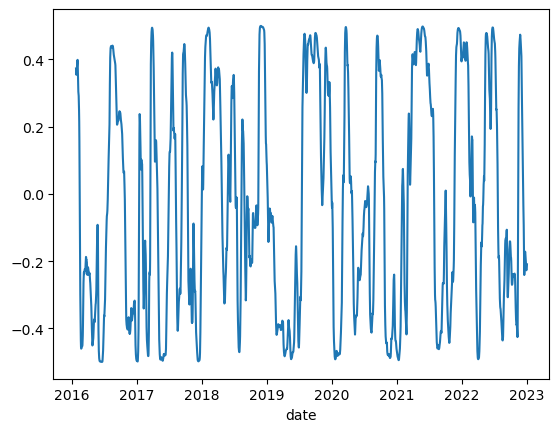

In [201]:
df_trend_log[f'{ticker}_final_weighted_additive_signal'].plot()

<Axes: xlabel='date'>

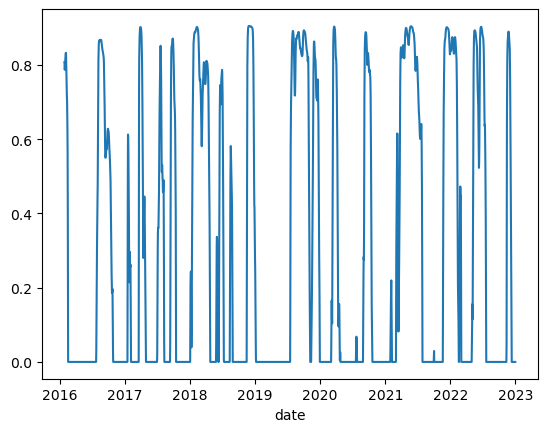

In [205]:
df_trend_log[f'{ticker}_final_signal'].plot()

<Axes: xlabel='date'>

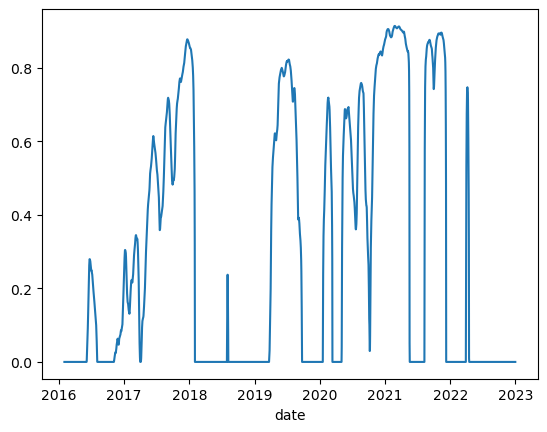

In [207]:
df_moving_avg_performance_orig[f'{ticker}_final_signal'].plot()

In [48]:
# ---- constants ----
windows = 2**np.arange(np.log2(10), np.log2(60)+0.01, 0.5).round().astype(int)   # e.g. 10,14,20,28,40,56
x       = np.log(windows)
xm      = x - x.mean()
varx    = (xm**2).sum()

In [50]:
windows

array([ 8, 16, 16, 32, 32, 64])

In [146]:
np.geomspace(fast_mavg, slow_mavg, num=6).round().astype(int)

array([10, 14, 20, 29, 42, 60])

In [52]:
x

array([2.07944154, 2.77258872, 2.77258872, 3.4657359 , 3.4657359 ,
       4.15888308])

In [56]:
# Pull Close Prices from Coinbase
ticker = ticker_list[0]
df_btc = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
df_btc = (df_btc[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
df_btc = df_btc[(df_btc.index.get_level_values('date') >= start_date) & (df_btc.index.get_level_values('date') <= end_date)]

In [118]:
mavg_start = 10
mavg_end = 60
log_step = 0.5

In [114]:
df_trend_btc = create_trend_strategy_log_space(df_btc, ticker='BTC-USD', mavg_start=10, mavg_end=60, log_step=0.5)

In [116]:
df_trend_btc.head(200)

,BTC-USD_close,BTC-USD_open,BTC-USD_8_ema,BTC-USD_16_ema,BTC-USD_32_ema,BTC-USD_64_ema,BTC-USD_mavg_ribbon_slope,BTC-USD_mavg_ribbon_rank
date,,,,,,,,
2016-01-01,435.66,430.35,435.660000,435.660000,435.660000,435.660000,NaN,NaN
2016-01-02,435.40,435.67,435.602222,435.629412,435.644242,435.652000,-7.739074e-14,NaN
2016-01-03,431.91,435.40,434.781728,435.191834,435.417925,435.536862,2.347588e-02,NaN
2016-01-04,433.85,431.90,434.574678,435.033971,435.322899,435.484958,3.564219e-01,NaN
2016-01-05,433.34,433.84,434.300305,434.834680,435.202723,435.418959,4.339492e-01,NaN
2016-01-06,430.87,433.32,433.538015,434.368247,434.940134,435.278991,5.366890e-01,NaN
2016-01-07,459.07,430.66,439.211789,437.274336,436.402550,436.011022,8.350191e-01,NaN
2016-01-08,454.44,459.07,442.595836,439.293826,437.495729,436.578068,-1.488058e+00,NaN
2016-01-09,450.38,454.41,444.325650,440.598082,438.276594,437.002743,-2.839420e+00,NaN


In [70]:
# ---- constants ----
windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, mavg_stepsize).round().astype(int)   # e.g. 10,14,20,28,40,56
x       = np.log(windows)
xm      = x - x.mean()
varx    = (xm**2).sum()

# ---- compute MAs (vectorised) ----
for w in windows:
    df_btc[f'{ticker}_{w}_ema'] = df_btc[f'{ticker}_close'].ewm(span=w, adjust=False).mean()

mavg_mat = df_btc[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()

In [82]:
mavg_mat

array([[  435.66      ,   435.66      ,   435.66      ,   435.66      ,
          435.66      ,   435.66      ],
       [  435.60222222,   435.62941176,   435.62941176,   435.64424242,
          435.64424242,   435.652     ],
       [  434.7817284 ,   435.19183391,   435.19183391,   435.4179247 ,
          435.4179247 ,   435.53686154],
       ...,
       [16730.40134281, 16814.28226198, 16814.28226198, 16975.73708353,
        16975.73708353, 17522.40553273],
       [16701.44548885, 16789.0843488 , 16789.0843488 , 16952.97119968,
        16952.97119968, 17494.02690095],
       [16663.42426911, 16758.64501365, 16758.64501365, 16927.35779364,
        16927.35779364, 17464.375304  ]])

In [74]:
x

array([2.07944154, 2.77258872, 2.77258872, 3.4657359 , 3.4657359 ,
       4.15888308])

In [76]:
xm

array([-1.03972077, -0.34657359, -0.34657359,  0.34657359,  0.34657359,
        1.03972077])

In [78]:
varx

2.6424915765501074

In [68]:
df_btc.head()

,BTC-USD_close,BTC-USD_open
date,,
2016-01-01,435.66,430.35
2016-01-02,435.40,435.67
2016-01-03,431.91,435.40
2016-01-04,433.85,431.90
2016-01-05,433.34,433.84


In [ ]:

# ---- slope (vectorised) ----
slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead

# ---- z-score & rank ----
z      = (slope - slope.rolling(252).mean()) / slope.rolling(252).std()
rank   = scipy.stats.norm.cdf(z).sub(0.5)              # centred 0↔±0.5

df_trend[trend_continuous_signal_col]      = slope
df_trend[trend_continuous_signal_rank_col] = rank